# Hubble Diagram Project

## Read Data

In [1]:
import numpy as np
import astropy.table as ast

LOWZ_table = ast.Table.read("./data/DES-SN5YR_LOWZ_HEAD.FITS")
DES_table = ast.Table.read("./data/DES-SN5YR_DES_HEAD.FITS")
Foundation_table = ast.Table.read("./data/DES-SN5YR_Foundation_HEAD.FITS")
source_table = ast.Table.read(
    "./data/DES-Dovekie_HD.csv", format="csv", delimiter=" ", comment="#"
)
num_samples = len(source_table)

LOWZ_table["SNID_str"] = [cid.strip() for cid in LOWZ_table["SNID"].astype(str)]
DES_table["SNID_str"] = [cid.strip() for cid in DES_table["SNID"].astype(str)]
Foundation_table["SNID_str"] = [
    cid.strip() for cid in Foundation_table["SNID"].astype(str)
]
source_table["CID_str"] = [cid.strip() for cid in source_table["CID"]]
source_table['ID'] = range(num_samples) # Add an ID column to keep track of original order

DES_sample = ast.join(
    source_table,
    DES_table,
    keys_left="CID_str",
    keys_right="SNID_str",
    join_type="inner",
)
LOWZ_sample = ast.vstack(
    [
        ast.join(
            source_table,
            LOWZ_table,
            keys_left="CID_str",
            keys_right="SNID_str",
            join_type="inner",
        ),
        ast.join(
            source_table,
            Foundation_table,
            keys_left="CID_str",
            keys_right="SNID_str",
            join_type="inner",
        ),
    ]
)
SN_sample = ast.vstack([DES_sample, LOWZ_sample], join_type="inner")
del SN_sample["SNID_str"], SN_sample["CID_str"]
SN_sample.sort('ID') # Sort back to original order
SN_sample

<Table length=1820>
VARNAMES:     CID     IDSURVEY ... MJD_DETECT_FIRST MJD_DETECT_LAST SEARCH_TYPE
   str3      str11     int64   ...     float32          float32        int32   
--------- ----------- -------- ... ---------------- --------------- -----------
      SN:   Gaia16agf      150 ...             -9.0            -9.0          -9
      SN:      2003it       63 ...             -9.0            -9.0          -9
      SN:      2007cq       64 ...             -9.0            -9.0          -9
      SN:   AT2017cfc      150 ...             -9.0            -9.0          -9
      SN:      2007sw       65 ...             -9.0            -9.0          -9
      SN:      2002he       63 ...             -9.0            -9.0          -9
      SN: ASASSN-16bq      150 ...             -9.0            -9.0          -9
      SN:     PS15ahs      150 ...             -9.0            -9.0          -9
      SN: PSNJ0153424      150 ...             -9.0            -9.0          -9
      ...         ...      ... ...              ...             ...         ...
      SN:     1901375       10 ...         58057.29       58071.242          -9
      SN:     1924188       10 ...        58101.203       58132.066          -9
      SN:     1311921       10 ...        56973.094        56990.13          -9
      SN:     1255169       10 ...        56575.223       56611.223          -9
      SN:     1337541       10 ...         57339.21        57387.13          -9
      SN:     1263785       10 ...         56655.05        56690.09          -9
      SN:     1842087       10 ...         58007.38         58036.3          -9
      SN:     1339609       10 ...         57355.25       57406.113          -9
      SN:     1446080       10 ...        57660.242        57668.12          -9
      SN:     1257587       10 ...        56602.273       56648.055          -9

## Hubble Diagram

### Hubble Diagram

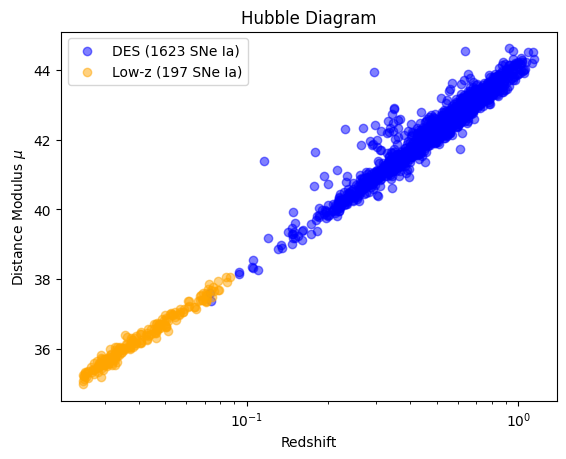

In [2]:
import matplotlib.pyplot as plt

plt.scatter(
    DES_sample["zHD"],
    DES_sample["MU"],
    c="b",
    alpha=0.5,
    marker="o",
    label="DES (1623 SNe Ia)",
)
plt.scatter(
    LOWZ_sample["zHD"],
    LOWZ_sample["MU"],
    c="orange",
    alpha=0.5,
    marker="o",
    label="Low-z (197 SNe Ia)",
)
plt.xscale("log")
plt.xlabel("Redshift")
plt.ylabel(r"Distance Modulus $\mu$")
plt.title("Hubble Diagram")
plt.legend()

### Hubble Diagram with Error

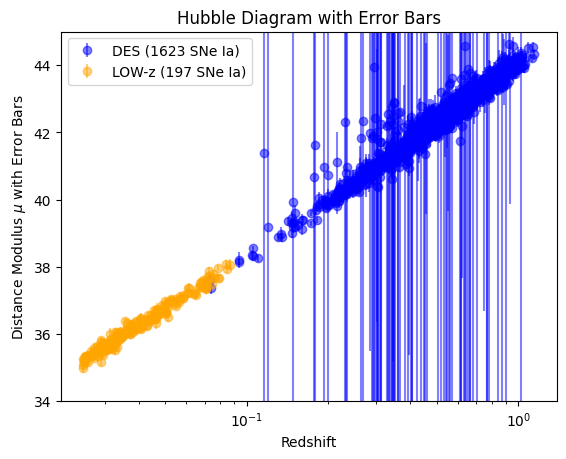

In [3]:
plt.errorbar(
    DES_sample["zHD"],
    DES_sample["MU"],
    DES_sample["MUERR"],
    c="b",
    alpha=0.5,
    fmt="o",
    label="DES (1623 SNe Ia)",
)
plt.errorbar(
    LOWZ_sample["zHD"],
    LOWZ_sample["MU"],
    LOWZ_sample["MUERR"],
    c="orange",
    alpha=0.5,
    fmt="o",
    label="LOW-z (197 SNe Ia)",
)
plt.xscale("log")
plt.xlabel("Redshift")
plt.ylabel(r"Distance Modulus $\mu$ with Error Bars")
plt.ylim(34, 45)
plt.title("Hubble Diagram with Error Bars")
plt.legend()

**CMT**: Some higher redshift samples have large uncertanties on distance modulus. We don't know why.

### Sample Distribution

1623


Text(0.5, 1.0, 'Redshift Distribution of SNe Ia Samples')

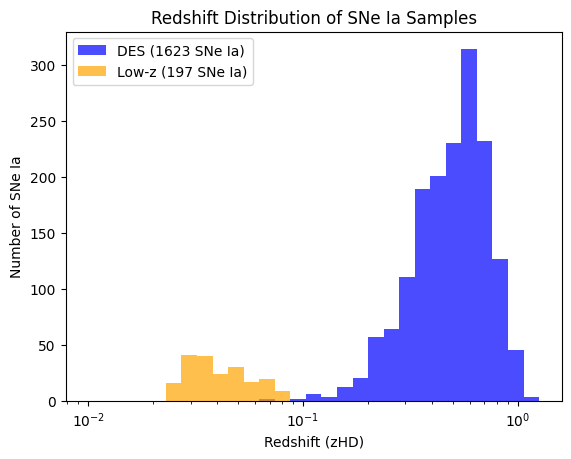

In [4]:
bins = np.logspace(-2, 0.1, 30)
plt.hist(DES_sample['zHD'], bins=bins, alpha=0.7, label='DES (1623 SNe Ia)', color='b')
plt.hist(LOWZ_sample['zHD'], bins=bins, alpha=0.7, label='Low-z (197 SNe Ia)', color='orange')
print(len(DES_sample))
plt.xscale('log')
plt.legend()
plt.xlabel('Redshift (zHD)')
plt.ylabel('Number of SNe Ia')
plt.title('Redshift Distribution of SNe Ia Samples')

## Fit Cosmology

### Define Cosmology

In [5]:
import numpy as np
import scipy.constants as const
from scipy.integrate import quad


def E_Flat_LCDM(z, Omega_m):
    """Flat ΛCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m))


def E_Open_LCDM(z, Omega_m, Omega_k):
    """Open ΛCDM: E(z) function."""
    Omega_Lambda = 1 - Omega_m - Omega_k
    return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)


def E_Flat_wCDM(z, Omega_m, w):
    """Flat wCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m) * (1 + z) ** (3 * (1 + w)))


def E_Flat_w0waCDM(z, Omega_m, w0, wa):
    """
    Flat w0waCDM: E(z) function. Using CPL paramerization: w(z) = w0 + wa * z/(1+z).
    """
    Omega_DE = 1 - Omega_m
    return np.sqrt(
        Omega_m * (1 + z) ** 3
        + Omega_DE * (1 + z) ** (3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    )


def luminosity_distance_Flat_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m = params[0]
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_LCDM(z_prime, Omega_m)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Open_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Open ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                Omega_k: Curvature density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, Omega_k = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Open_LCDM(z_prime, Omega_m, Omega_k)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)
    dC *= dH

    # Comoving transverse distance
    if Omega_k == 0:
        dM = dC
    elif Omega_k > 0:
        dM = dH / np.sqrt(Omega_k) * np.sinh(np.sqrt(Omega_k) * dC / dH)  # 开放
    else:
        dM = dH / np.sqrt(-Omega_k) * np.sin(np.sqrt(-Omega_k) * dC / dH)  # 闭合

    return (1 + z) * dM


def luminosity_distance_Flat_wCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat wCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w: Dark energy equation of state parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_wCDM(z_prime, Omega_m, w)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Flat_w0waCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat w0waCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w0: Dark energy equation of state parameter at z=0
                wa: Evolution parameter of dark energy equation of state
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w0, wa = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_w0waCDM(z_prime, Omega_m, w0, wa)

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def distance_modulus(z, params, model="Flat_LCDM"):
    """
    Distance modulus for various cosmological models.

    Parameters:
        z: Redshift
        params: Model parameters (tuple)
        model: Cosmological model. Options: "Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"
    Returns:
        Distance Modulus (mu)
    """
    model_funcs = {
        "Flat_LCDM": luminosity_distance_Flat_LCDM,
        "Open_LCDM": luminosity_distance_Open_LCDM,
        "Flat_wCDM": luminosity_distance_Flat_wCDM,
        "Flat_w0waCDM": luminosity_distance_Flat_w0waCDM,
    }

    if model not in model_funcs:
        raise ValueError(f"Invalid model: {model}. Valid models: {list(model_funcs.keys())}")

    dL = model_funcs[model](z, params, H0=70.0)

    return 5 * np.log10(dL / 10) + 25

### Setup Sampler

In [57]:
from ultranest.integrator import ReactiveNestedSampler
import scipy

# load data
z_data = SN_sample["zHD"].data
mu_data = SN_sample["MU"].data
flat_cov_total_inv = np.load("./data/STAT+SYS.npz")["cov"]
C_total_inv = np.zeros((num_samples, num_samples))
indices = np.triu_indices(num_samples)  # Indices for upper triangular part
C_total_inv[indices] = flat_cov_total_inv
C_total_inv = C_total_inv + C_total_inv.T - np.diag(np.diag(C_total_inv))
C_total = np.linalg.inv(C_total_inv)

L = np.linalg.cholesky(
    C_total
)  # Precompute Cholesky decomposition (for fast likelihood calculation)


def prior_transform(cube, param_ranges):
    """
    Transform unit cube [0,1]^d to physical parameter space.
    """
    params = np.zeros_like(cube)
    for i in range(len(param_ranges)):
        params[i] = (
            cube[i] * (param_ranges[i][1] - param_ranges[i][0]) + param_ranges[i][0]
        )
    return params


def log_likelihood(params, model="Flat_LCDM", marginalized=True):
    """
    Log likelihood function.

    Parameters:
        params : array
            Cosmological parameters (excluding M if marginalized=True)
        model : str
            Cosmological model
        marginalized : bool
            True if analytically marginalize over M
    Returns:
        log_likelihood : float
            Log likelihood
    """
    if marginalized:
        # Compute theoretical distance moduli WITHOUT M
        # distance_modulus returns 5log10(dL/10) + 25 (without absolute magnitude M)
        mu_theory_noM = np.array(
            [distance_modulus(z, params, model=model) for z in z_data]
        )

        # Check for invalid values
        if np.any(np.isinf(mu_theory_noM)) or np.any(np.isnan(mu_theory_noM)):
            return -1.0e99 * (np.sum(np.abs(params)) + 1)

        # Additional constraints for w0waCDM model
        if model == "Flat_w0waCDM" and len(params) >= 3:
            w0 = params[1]
            wa = params[2]
            if w0 + wa >= 0:
                return -1.0e99 * (np.abs(w0 + wa) + 1)  # ensure w0+wa < 0

        # Compute residuals (without M)
        residuals = mu_data - mu_theory_noM

        y = scipy.linalg.solve_triangular(L, residuals, lower=True)
        A = np.sum(y**2)
        z = scipy.linalg.solve_triangular(L, residuals, lower=True)
        w = scipy.linalg.solve_triangular(L.T, z, lower=False)
        B = np.sum(w)
        n = len(L)
        Linv = scipy.linalg.solve_triangular(L, np.eye(n), lower=True)
        C = np.sum(Linv.T @ Linv)

        chi2 = A - (B**2 / C) + np.log(C / (2.0 * np.pi))
    else:
        M = params[-1]

        # Compute theoretical distance moduli (M is the absolute magnitude term in μ = 5log10(dL/10) + 25
        mu_theory = np.array(
            [distance_modulus(z, params[:-1], model=model) + M for z in z_data]
        )

        residuals = mu_data - mu_theory
        if np.any(np.isinf(residuals)) or np.any(np.isnan(residuals)):
            return -1.0e99 * (np.abs(M) + 1)
        if model == "Flat_w0waCDM":
            w0 = params[1]
            wa = params[2]
            if w0 + wa >= 0:
                return -1.0e99 * (np.abs(w0 + wa) + 1)  # make sure w0+wa < 0
        y = scipy.linalg.solve_triangular(L, residuals, lower=True)
        chi2 = np.sum(y**2)

    return -0.5 * chi2


models = ["Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"]


def fit_cosmology(cosmology_model="Flat_LCDM", prior="wide", marginalized=True):
    """
    Use UltraNest to fit cosmological parameters for a given model.

    Parameters:
        cosmology_model: Cosmological model to fit. Options: "Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"
        prior: Which prior you want to use. Options: "wide", "Dovekie"
        marginalized: If analytically marginalize over M.
    Returns:
        UltraNest result object.
    """
    param_names = {
        "Flat_LCDM": ["Omega_m", "M"],
        "Open_LCDM": ["Omega_m", "Omega_k", "M"],
        "Flat_wCDM": ["Omega_m", "w", "M"],
        "Flat_w0waCDM": ["Omega_m", "w0", "wa", "M"],
    }

    param_names_marginalized = {
        "Flat_LCDM": ["Omega_m"],
        "Open_LCDM": ["Omega_m", "Omega_k"],
        "Flat_wCDM": ["Omega_m", "w"],
        "Flat_w0waCDM": ["Omega_m", "w0", "wa"],
    }

    # Parameter ranges for sampling
    param_ranges = {
        "wide": {
            "Flat_LCDM": [(0.25, 0.4), (-20, 10), (4, 6)],
            "Open_LCDM": [(0.1, 0.5), (-1, 1), (-20, 10), (4, 6)],
            "Flat_wCDM": [(0.1, 0.4), (-2, 0.5), (-20, 10), (4, 6)],
            "Flat_w0waCDM": [(0.0, 1.0), (-20, 10), (-20, 10), (-20, 10), (4, 6)],
        },
        "Dovekie": {
            "Flat_LCDM": [(0.1, 0.5), (4, 6)],
            "Open_LCDM": [
                (0.1, 0.5),
                (-0.15, 0.15),
                (4, 6),
            ],
            "Flat_wCDM": [
                (0.1, 0.5),
                (-3, -0.4),
                (4, 6),
            ],
            "Flat_w0waCDM": [
                (0.1, 0.5),
                (-3, -0.4),
                (-3, 2),
                (4, 6),
            ],
        },
    }
    print((
            param_names_marginalized[cosmology_model]
            if marginalized
            else param_names[cosmology_model]
        ))
    print((
                (
                    param_ranges[prior][cosmology_model][:-2]
                    if marginalized
                    else param_ranges[prior][cosmology_model]
                )
            ))

    sampler = ReactiveNestedSampler(
        (
            param_names_marginalized[cosmology_model]
            if marginalized
            else param_names[cosmology_model]
        ),
        (
            lambda params: log_likelihood(
                params, model=cosmology_model, marginalized=marginalized
            )
        ),
        lambda cube: prior_transform(
            cube,
            param_ranges=(
                (
                    param_ranges[prior][cosmology_model][:-2]
                    if marginalized
                    else param_ranges[prior][cosmology_model]
                )
            ),
        ),
    )

    # Run sampling
    result = sampler.run()
    return result

In [ ]:
def log_likelihood_marginalized(params, model="Flat_LCDM"):
    """
    Log likelihood function with analytical marginalization over M (absolute magnitude).

    Parameters:
        params : array
            Cosmological parameters (excluding M)
        model : str
            Cosmological model
    Returns:
        log_likelihood : float
            Log likelihood with M marginalized analytically
    """

    # Compute theoretical distance moduli WITHOUT M
    # distance_modulus returns 5log10(dL/10) + 25 (without absolute magnitude M)
    mu_theory_noM = np.array([distance_modulus(z, params, model=model) for z in z_data])

    # Check for invalid values
    if np.any(np.isinf(mu_theory_noM)) or np.any(np.isnan(mu_theory_noM)):
        return -1.0e99 * (np.sum(np.abs(params)) + 1)

    # Additional constraints for w0waCDM model
    if model == "Flat_w0waCDM" and len(params) >= 3:
        w0 = params[1]
        wa = params[2]
        if w0 + wa >= 0:
            return -1.0e99 * (np.abs(w0 + wa) + 1)  # ensure w0+wa < 0

    # Compute residuals (without M)
    residuals = mu_data - mu_theory_noM

    y = scipy.linalg.solve_triangular(L, residuals, lower=True)
    A = np.sum(y**2)
    z = scipy.linalg.solve_triangular(L, residuals, lower=True)
    w = scipy.linalg.solve_triangular(L.T, z, lower=False)
    B = np.sum(w)
    n = len(L)
    Linv = scipy.linalg.solve_triangular(L, np.eye(n), lower=True)
    C = np.sum(Linv.T @ Linv)

    chi2_marg = A - (B**2 / C) + np.log(C / (2.0 * np.pi))
    return -0.5 * chi2_marg


def fit_cosmology_marginalized(cosmology_model="Flat_LCDM", prior="wide"):
    """
    Use UltraNest to fit cosmological parameters for a given model with analytical marginalization over M (absolute magnitude).

    Parameters:
        cosmology_model: Cosmological model to fit. Options: "Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"
        prior: Which prior you want to use. Options: "wide", "Dovekie"
    Returns:
        UltraNest result object.
    """
    param_names = {
        "Flat_LCDM": ["Omega_m"],
        "Open_LCDM": ["Omega_m", "Omega_k"],
        "Flat_wCDM": ["Omega_m", "w"],
        "Flat_w0waCDM": ["Omega_m", "w0", "wa"],
    }

    # Parameter ranges for sampling
    param_ranges = {
        "Flat_LCDM": [(0.25, 0.4)],
        "Open_LCDM": [(0.1, 0.5), (-1, 1)],
        "Flat_wCDM": [(0.1, 0.4), (-2, 0.5)],
        "Flat_w0waCDM": [(0.0, 1.0), (-20, 10), (-20, 10)],
    }

    # Parameter ranges adjusted to match Dovekie literature constraints
    param_ranges_Dovekie = {
        "Flat_LCDM": [(0.1, 0.5)],
        "Open_LCDM": [
            (0.1, 0.5),
            (-0.15, 0.15),
        ],
        "Flat_wCDM": [
            (0.1, 0.5),
            (-3, -0.4),
        ],
        "Flat_w0waCDM": [
            (0.1, 0.5),
            (-3, -0.4),
            (-3, 2),
        ],
    }

    sampler = ReactiveNestedSampler(
        (
            param_names[cosmology_model]
            if prior == "wide"
            else param_names_Dovekie[cosmology_model]
        ),
        lambda params: log_likelihood_marginalized(params, model=cosmology_model),
        lambda cube: prior_transform(cube, param_ranges[cosmology_model]),
    )

    # Run sampling
    result = sampler.run()
    return result

### Fit Results

In [50]:
from getdist import MCSamples, plots
from ultranest.plot import cornerplot
import pickle
import os

def smooth_plot(result):
    """
    Use getdist for smoother cornerplot.
    """
    samples = result['samples']  # Shape: (n_samples, n_params)
    weights = result['weighted_samples']['weights']

    param_names_all = result['paramnames']

    # Create MCSamples object excluding the last parameter M
    samples_mcd = MCSamples(
        samples=samples,
        weights=weights,
        names=param_names_all,
        settings={'smooth_scale_2D': 0.8}
    )

    # Plot cornerplot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_mcd], filled=True)

def summary_statistics(result):
    """
    Report 1σ statistics.
    """
    print("1σ statistics:")
    print("-" * 40)
    
    samples = result['samples']
    param_names = result.get('paramnames', [f'p{i}' for i in range(samples.shape[1])])
    
    for i, name in enumerate(param_names):
        data = samples[:, i]
        mean = np.mean(data)
        std = np.std(data)
        q16, q84 = np.percentile(data, [16, 84])
        
        print(f"{name:10s}: {mean:.3f} ± {std:.3f}  [{q16:.3f}, {q84:.3f}]")
    
    return {
        'param_names': param_names,
        'means': [np.mean(samples[:, i]) for i in range(len(param_names))],
        'stds': [np.std(samples[:, i]) for i in range(len(param_names))],
        'q16s': [np.percentile(samples[:, i], 16) for i in range(len(param_names))],
        'q84s': [np.percentile(samples[:, i], 84) for i in range(len(param_names))]
    }

In [87]:
fit_dir = "fits"  # Directory to save fit results
prior = "wide" # Use wide prior. "Dovekie" for prior ranges of Dovekie.
marginalize_M = True # If analytically marginalize over M
os.makedirs(fit_dir, exist_ok=True)

**CMT**: In the Dovekie project, they use analytical marginalized M but their prior ranges are not correct. Use "wide" for wider prior ranges and maringalize_M = True for an analytical marginalization.

#### Flat LCDM

In [ ]:
# Needless to run again if the .pkl files exist in fit_dir
Flat_LCDM_result = fit_cosmology("Flat_LCDM", prior=prior, marginalized=marginalize_M)
with open(f'{fit_dir}/Flat_LCDM_{prior}{"_marg" if marginalize_M else ""}_result.pkl', 'wb') as f:
    pickle.dump(Flat_LCDM_result, f)

DEBUG:ultranest:ReactiveNestedSampler: dims=1+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


['Omega_m']
[(0.25, 0.4)]
[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(400.0)), (np.float64(inf), np.float64(400.0))]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-835.17, Lmax=-820.31


DEBUG:ultranest:iteration=1, ncalls=402, regioncalls=80, ndraw=40, logz=-841.16, remainder_fraction=100.0000%, Lmin=-834.59, Lmax=-820.31


DEBUG:ultranest:iteration=2, ncalls=403, regioncalls=120, ndraw=40, logz=-840.14, remainder_fraction=100.0000%, Lmin=-834.51, Lmax=-820.31


DEBUG:ultranest:iteration=3, ncalls=404, regioncalls=160, ndraw=40, logz=-839.61, remainder_fraction=100.0000%, Lmin=-834.33, Lmax=-820.31


DEBUG:ultranest:iteration=4, ncalls=405, regioncalls=200, ndraw=40, logz=-839.22, remainder_fraction=100.0000%, Lmin=-834.27, Lmax=-820.31


DEBUG:ultranest:iteration=5, ncalls=406, regioncalls=240, ndraw=40, logz=-838.92, remainder_fraction=100.0000%, Lmin=-834.09, Lmax=-820.31


DEBUG:ultranest:iteration=6, ncalls=408, regioncalls=320, ndraw=40, logz=-838.65, remainder_fraction=100.0000%, Lmin=-834.06, Lmax=-820.31


DEBUG:ultranest:iteration=7, ncalls=409, regioncalls=360, ndraw=40, logz=-838.43, remainder_fraction=100.0000%, Lmin=-833.97, Lmax=-820.31


DEBUG:ultranest:iteration=8, ncalls=410, regioncalls=400, ndraw=40, logz=-838.24, remainder_fraction=100.0000%, Lmin=-833.76, Lmax=-820.31


DEBUG:ultranest:iteration=9, ncalls=411, regioncalls=440, ndraw=40, logz=-838.04, remainder_fraction=100.0000%, Lmin=-833.64, Lmax=-820.31


DEBUG:ultranest:iteration=10, ncalls=412, regioncalls=480, ndraw=40, logz=-837.86, remainder_fraction=100.0000%, Lmin=-833.42, Lmax=-820.31


DEBUG:ultranest:iteration=11, ncalls=413, regioncalls=520, ndraw=40, logz=-837.67, remainder_fraction=100.0000%, Lmin=-833.28, Lmax=-820.31


DEBUG:ultranest:iteration=12, ncalls=414, regioncalls=560, ndraw=40, logz=-837.49, remainder_fraction=100.0000%, Lmin=-833.22, Lmax=-820.31


DEBUG:ultranest:iteration=13, ncalls=415, regioncalls=600, ndraw=40, logz=-837.33, remainder_fraction=100.0000%, Lmin=-833.10, Lmax=-820.31


DEBUG:ultranest:iteration=14, ncalls=416, regioncalls=640, ndraw=40, logz=-837.18, remainder_fraction=100.0000%, Lmin=-832.91, Lmax=-820.31


DEBUG:ultranest:iteration=15, ncalls=417, regioncalls=680, ndraw=40, logz=-837.02, remainder_fraction=100.0000%, Lmin=-832.66, Lmax=-820.31


DEBUG:ultranest:iteration=16, ncalls=418, regioncalls=720, ndraw=40, logz=-836.85, remainder_fraction=100.0000%, Lmin=-832.59, Lmax=-820.31


DEBUG:ultranest:iteration=17, ncalls=419, regioncalls=760, ndraw=40, logz=-836.69, remainder_fraction=100.0000%, Lmin=-832.59, Lmax=-820.31


DEBUG:ultranest:iteration=18, ncalls=420, regioncalls=800, ndraw=40, logz=-836.56, remainder_fraction=100.0000%, Lmin=-832.46, Lmax=-820.31


DEBUG:ultranest:iteration=19, ncalls=421, regioncalls=840, ndraw=40, logz=-836.42, remainder_fraction=100.0000%, Lmin=-832.37, Lmax=-820.31


DEBUG:ultranest:iteration=20, ncalls=422, regioncalls=880, ndraw=40, logz=-836.29, remainder_fraction=100.0000%, Lmin=-832.31, Lmax=-820.31


DEBUG:ultranest:iteration=21, ncalls=423, regioncalls=920, ndraw=40, logz=-836.17, remainder_fraction=100.0000%, Lmin=-832.24, Lmax=-820.31


DEBUG:ultranest:iteration=22, ncalls=424, regioncalls=960, ndraw=40, logz=-836.06, remainder_fraction=99.9999%, Lmin=-832.18, Lmax=-820.31


DEBUG:ultranest:iteration=23, ncalls=425, regioncalls=1000, ndraw=40, logz=-835.95, remainder_fraction=99.9999%, Lmin=-831.96, Lmax=-820.31


DEBUG:ultranest:iteration=24, ncalls=426, regioncalls=1040, ndraw=40, logz=-835.83, remainder_fraction=99.9999%, Lmin=-831.83, Lmax=-820.31


DEBUG:ultranest:iteration=25, ncalls=427, regioncalls=1080, ndraw=40, logz=-835.71, remainder_fraction=99.9999%, Lmin=-831.54, Lmax=-820.31


DEBUG:ultranest:iteration=26, ncalls=428, regioncalls=1120, ndraw=40, logz=-835.57, remainder_fraction=99.9999%, Lmin=-831.46, Lmax=-820.31


DEBUG:ultranest:iteration=27, ncalls=429, regioncalls=1160, ndraw=40, logz=-835.44, remainder_fraction=99.9999%, Lmin=-831.18, Lmax=-820.31


DEBUG:ultranest:iteration=28, ncalls=430, regioncalls=1200, ndraw=40, logz=-835.28, remainder_fraction=99.9999%, Lmin=-831.12, Lmax=-820.31


DEBUG:ultranest:iteration=29, ncalls=431, regioncalls=1240, ndraw=40, logz=-835.14, remainder_fraction=99.9999%, Lmin=-830.97, Lmax=-820.31


DEBUG:ultranest:iteration=30, ncalls=432, regioncalls=1280, ndraw=40, logz=-835.00, remainder_fraction=99.9999%, Lmin=-830.66, Lmax=-820.31


DEBUG:ultranest:iteration=31, ncalls=433, regioncalls=1320, ndraw=40, logz=-834.84, remainder_fraction=99.9998%, Lmin=-830.55, Lmax=-820.31


DEBUG:ultranest:iteration=32, ncalls=434, regioncalls=1360, ndraw=40, logz=-834.68, remainder_fraction=99.9998%, Lmin=-830.52, Lmax=-820.31


DEBUG:ultranest:iteration=33, ncalls=435, regioncalls=1400, ndraw=40, logz=-834.55, remainder_fraction=99.9998%, Lmin=-830.18, Lmax=-820.31


DEBUG:ultranest:iteration=34, ncalls=436, regioncalls=1440, ndraw=40, logz=-834.38, remainder_fraction=99.9997%, Lmin=-830.16, Lmax=-820.31


DEBUG:ultranest:iteration=35, ncalls=437, regioncalls=1480, ndraw=40, logz=-834.23, remainder_fraction=99.9997%, Lmin=-830.15, Lmax=-820.31


DEBUG:ultranest:iteration=36, ncalls=438, regioncalls=1520, ndraw=40, logz=-834.11, remainder_fraction=99.9996%, Lmin=-830.14, Lmax=-820.31


DEBUG:ultranest:iteration=37, ncalls=439, regioncalls=1560, ndraw=40, logz=-833.99, remainder_fraction=99.9996%, Lmin=-829.84, Lmax=-820.31


DEBUG:ultranest:iteration=38, ncalls=440, regioncalls=1600, ndraw=40, logz=-833.86, remainder_fraction=99.9995%, Lmin=-829.81, Lmax=-820.31


DEBUG:ultranest:iteration=39, ncalls=441, regioncalls=1640, ndraw=40, logz=-833.73, remainder_fraction=99.9995%, Lmin=-829.80, Lmax=-820.31


DEBUG:ultranest:iteration=40, ncalls=442, regioncalls=1680, ndraw=40, logz=-833.62, remainder_fraction=99.9994%, Lmin=-829.78, Lmax=-820.31


DEBUG:ultranest:iteration=41, ncalls=443, regioncalls=1720, ndraw=40, logz=-833.52, remainder_fraction=99.9994%, Lmin=-829.64, Lmax=-820.31


DEBUG:ultranest:iteration=42, ncalls=444, regioncalls=1760, ndraw=40, logz=-833.42, remainder_fraction=99.9993%, Lmin=-829.54, Lmax=-820.31


DEBUG:ultranest:iteration=43, ncalls=445, regioncalls=1800, ndraw=40, logz=-833.32, remainder_fraction=99.9992%, Lmin=-829.50, Lmax=-820.31


DEBUG:ultranest:iteration=44, ncalls=446, regioncalls=1840, ndraw=40, logz=-833.22, remainder_fraction=99.9991%, Lmin=-829.43, Lmax=-820.31


DEBUG:ultranest:iteration=45, ncalls=447, regioncalls=1880, ndraw=40, logz=-833.13, remainder_fraction=99.9991%, Lmin=-829.42, Lmax=-820.31


DEBUG:ultranest:iteration=46, ncalls=448, regioncalls=1920, ndraw=40, logz=-833.04, remainder_fraction=99.9990%, Lmin=-829.39, Lmax=-820.31


DEBUG:ultranest:iteration=47, ncalls=449, regioncalls=1960, ndraw=40, logz=-832.96, remainder_fraction=99.9989%, Lmin=-829.38, Lmax=-820.31


DEBUG:ultranest:iteration=48, ncalls=450, regioncalls=2000, ndraw=40, logz=-832.88, remainder_fraction=99.9988%, Lmin=-829.35, Lmax=-820.31


DEBUG:ultranest:iteration=49, ncalls=451, regioncalls=2040, ndraw=40, logz=-832.81, remainder_fraction=99.9987%, Lmin=-829.24, Lmax=-820.31


DEBUG:ultranest:iteration=50, ncalls=452, regioncalls=2080, ndraw=40, logz=-832.73, remainder_fraction=99.9986%, Lmin=-829.21, Lmax=-820.31


DEBUG:ultranest:iteration=51, ncalls=453, regioncalls=2120, ndraw=40, logz=-832.66, remainder_fraction=99.9985%, Lmin=-829.02, Lmax=-820.31


DEBUG:ultranest:iteration=52, ncalls=454, regioncalls=2160, ndraw=40, logz=-832.58, remainder_fraction=99.9984%, Lmin=-829.02, Lmax=-820.31


DEBUG:ultranest:iteration=53, ncalls=455, regioncalls=2200, ndraw=40, logz=-832.50, remainder_fraction=99.9983%, Lmin=-829.00, Lmax=-820.31


DEBUG:ultranest:iteration=54, ncalls=456, regioncalls=2240, ndraw=40, logz=-832.43, remainder_fraction=99.9981%, Lmin=-828.97, Lmax=-820.31


DEBUG:ultranest:iteration=55, ncalls=457, regioncalls=2280, ndraw=40, logz=-832.37, remainder_fraction=99.9980%, Lmin=-828.92, Lmax=-820.31


DEBUG:ultranest:iteration=56, ncalls=458, regioncalls=2320, ndraw=40, logz=-832.30, remainder_fraction=99.9979%, Lmin=-828.81, Lmax=-820.31


DEBUG:ultranest:iteration=57, ncalls=459, regioncalls=2360, ndraw=40, logz=-832.23, remainder_fraction=99.9977%, Lmin=-828.67, Lmax=-820.31


DEBUG:ultranest:iteration=58, ncalls=460, regioncalls=2400, ndraw=40, logz=-832.16, remainder_fraction=99.9975%, Lmin=-828.65, Lmax=-820.31


DEBUG:ultranest:iteration=59, ncalls=462, regioncalls=2480, ndraw=40, logz=-832.09, remainder_fraction=99.9974%, Lmin=-828.58, Lmax=-820.31


DEBUG:ultranest:iteration=60, ncalls=463, regioncalls=2520, ndraw=40, logz=-832.02, remainder_fraction=99.9972%, Lmin=-828.56, Lmax=-820.31


DEBUG:ultranest:iteration=61, ncalls=464, regioncalls=2560, ndraw=40, logz=-831.95, remainder_fraction=99.9970%, Lmin=-828.56, Lmax=-820.31


DEBUG:ultranest:iteration=62, ncalls=465, regioncalls=2600, ndraw=40, logz=-831.89, remainder_fraction=99.9968%, Lmin=-828.52, Lmax=-820.31


DEBUG:ultranest:iteration=63, ncalls=466, regioncalls=2640, ndraw=40, logz=-831.83, remainder_fraction=99.9966%, Lmin=-828.50, Lmax=-820.31


DEBUG:ultranest:iteration=64, ncalls=467, regioncalls=2680, ndraw=40, logz=-831.77, remainder_fraction=99.9964%, Lmin=-828.46, Lmax=-820.31


DEBUG:ultranest:iteration=65, ncalls=468, regioncalls=2720, ndraw=40, logz=-831.72, remainder_fraction=99.9962%, Lmin=-828.41, Lmax=-820.31


DEBUG:ultranest:iteration=66, ncalls=469, regioncalls=2760, ndraw=40, logz=-831.66, remainder_fraction=99.9959%, Lmin=-828.38, Lmax=-820.31


DEBUG:ultranest:iteration=67, ncalls=470, regioncalls=2800, ndraw=40, logz=-831.61, remainder_fraction=99.9957%, Lmin=-828.29, Lmax=-820.31


DEBUG:ultranest:iteration=68, ncalls=471, regioncalls=2840, ndraw=40, logz=-831.55, remainder_fraction=99.9955%, Lmin=-828.27, Lmax=-820.31


DEBUG:ultranest:iteration=69, ncalls=472, regioncalls=2880, ndraw=40, logz=-831.49, remainder_fraction=99.9952%, Lmin=-828.23, Lmax=-820.31


DEBUG:ultranest:iteration=70, ncalls=473, regioncalls=2920, ndraw=40, logz=-831.44, remainder_fraction=99.9949%, Lmin=-828.17, Lmax=-820.31


DEBUG:ultranest:iteration=71, ncalls=474, regioncalls=2960, ndraw=40, logz=-831.39, remainder_fraction=99.9946%, Lmin=-828.11, Lmax=-820.31


DEBUG:ultranest:iteration=72, ncalls=475, regioncalls=3000, ndraw=40, logz=-831.33, remainder_fraction=99.9943%, Lmin=-828.10, Lmax=-820.31


DEBUG:ultranest:iteration=73, ncalls=476, regioncalls=3040, ndraw=40, logz=-831.28, remainder_fraction=99.9940%, Lmin=-828.09, Lmax=-820.31


DEBUG:ultranest:iteration=74, ncalls=477, regioncalls=3080, ndraw=40, logz=-831.23, remainder_fraction=99.9937%, Lmin=-828.08, Lmax=-820.31


DEBUG:ultranest:iteration=75, ncalls=478, regioncalls=3120, ndraw=40, logz=-831.18, remainder_fraction=99.9934%, Lmin=-828.04, Lmax=-820.31


DEBUG:ultranest:iteration=76, ncalls=479, regioncalls=3160, ndraw=40, logz=-831.14, remainder_fraction=99.9931%, Lmin=-828.01, Lmax=-820.31


DEBUG:ultranest:iteration=77, ncalls=480, regioncalls=3200, ndraw=40, logz=-831.09, remainder_fraction=99.9927%, Lmin=-827.98, Lmax=-820.31


DEBUG:ultranest:iteration=78, ncalls=481, regioncalls=3240, ndraw=40, logz=-831.05, remainder_fraction=99.9924%, Lmin=-827.96, Lmax=-820.31


DEBUG:ultranest:iteration=79, ncalls=482, regioncalls=3280, ndraw=40, logz=-831.00, remainder_fraction=99.9921%, Lmin=-827.95, Lmax=-820.31


DEBUG:ultranest:iteration=80, ncalls=483, regioncalls=3320, ndraw=40, logz=-830.96, remainder_fraction=99.9917%, Lmin=-827.90, Lmax=-820.31


DEBUG:ultranest:iteration=81, ncalls=484, regioncalls=3360, ndraw=40, logz=-830.92, remainder_fraction=99.9914%, Lmin=-827.90, Lmax=-820.31


DEBUG:ultranest:iteration=82, ncalls=485, regioncalls=3400, ndraw=40, logz=-830.88, remainder_fraction=99.9910%, Lmin=-827.90, Lmax=-820.31


DEBUG:ultranest:iteration=83, ncalls=486, regioncalls=3440, ndraw=40, logz=-830.84, remainder_fraction=99.9907%, Lmin=-827.84, Lmax=-820.31


DEBUG:ultranest:iteration=84, ncalls=487, regioncalls=3480, ndraw=40, logz=-830.80, remainder_fraction=99.9903%, Lmin=-827.77, Lmax=-820.31


DEBUG:ultranest:iteration=85, ncalls=488, regioncalls=3520, ndraw=40, logz=-830.76, remainder_fraction=99.9899%, Lmin=-827.74, Lmax=-820.31


DEBUG:ultranest:iteration=86, ncalls=489, regioncalls=3560, ndraw=40, logz=-830.72, remainder_fraction=99.9895%, Lmin=-827.72, Lmax=-820.31


DEBUG:ultranest:iteration=87, ncalls=490, regioncalls=3600, ndraw=40, logz=-830.68, remainder_fraction=99.9891%, Lmin=-827.70, Lmax=-820.31


DEBUG:ultranest:iteration=88, ncalls=491, regioncalls=3640, ndraw=40, logz=-830.64, remainder_fraction=99.9886%, Lmin=-827.66, Lmax=-820.31


DEBUG:ultranest:iteration=89, ncalls=492, regioncalls=3680, ndraw=40, logz=-830.60, remainder_fraction=99.9882%, Lmin=-827.63, Lmax=-820.31


DEBUG:ultranest:iteration=90, ncalls=493, regioncalls=3720, ndraw=40, logz=-830.56, remainder_fraction=99.9877%, Lmin=-827.48, Lmax=-820.31


DEBUG:ultranest:iteration=91, ncalls=494, regioncalls=3760, ndraw=40, logz=-830.52, remainder_fraction=99.9871%, Lmin=-827.48, Lmax=-820.31


DEBUG:ultranest:iteration=92, ncalls=495, regioncalls=3800, ndraw=40, logz=-830.48, remainder_fraction=99.9866%, Lmin=-827.47, Lmax=-820.31


DEBUG:ultranest:iteration=93, ncalls=496, regioncalls=3840, ndraw=40, logz=-830.44, remainder_fraction=99.9860%, Lmin=-827.40, Lmax=-820.31


DEBUG:ultranest:iteration=94, ncalls=497, regioncalls=3880, ndraw=40, logz=-830.40, remainder_fraction=99.9855%, Lmin=-827.38, Lmax=-820.31


DEBUG:ultranest:iteration=95, ncalls=498, regioncalls=3920, ndraw=40, logz=-830.36, remainder_fraction=99.9849%, Lmin=-827.34, Lmax=-820.31


DEBUG:ultranest:iteration=96, ncalls=499, regioncalls=3960, ndraw=40, logz=-830.32, remainder_fraction=99.9843%, Lmin=-827.33, Lmax=-820.31


DEBUG:ultranest:iteration=97, ncalls=500, regioncalls=4000, ndraw=40, logz=-830.28, remainder_fraction=99.9836%, Lmin=-827.31, Lmax=-820.31


DEBUG:ultranest:iteration=98, ncalls=501, regioncalls=4040, ndraw=40, logz=-830.24, remainder_fraction=99.9830%, Lmin=-827.21, Lmax=-820.31


DEBUG:ultranest:iteration=99, ncalls=502, regioncalls=4080, ndraw=40, logz=-830.20, remainder_fraction=99.9822%, Lmin=-827.18, Lmax=-820.31


DEBUG:ultranest:iteration=100, ncalls=503, regioncalls=4120, ndraw=40, logz=-830.17, remainder_fraction=99.9816%, Lmin=-827.16, Lmax=-820.31


DEBUG:ultranest:iteration=101, ncalls=504, regioncalls=4160, ndraw=40, logz=-830.13, remainder_fraction=99.9808%, Lmin=-827.15, Lmax=-820.31


DEBUG:ultranest:iteration=102, ncalls=505, regioncalls=4200, ndraw=40, logz=-830.09, remainder_fraction=99.9801%, Lmin=-827.15, Lmax=-820.31


DEBUG:ultranest:iteration=103, ncalls=506, regioncalls=4240, ndraw=40, logz=-830.05, remainder_fraction=99.9793%, Lmin=-827.06, Lmax=-820.31


DEBUG:ultranest:iteration=104, ncalls=507, regioncalls=4280, ndraw=40, logz=-830.02, remainder_fraction=99.9786%, Lmin=-826.99, Lmax=-820.31


DEBUG:ultranest:iteration=105, ncalls=508, regioncalls=4320, ndraw=40, logz=-829.98, remainder_fraction=99.9778%, Lmin=-826.86, Lmax=-820.31


DEBUG:ultranest:iteration=106, ncalls=509, regioncalls=4360, ndraw=40, logz=-829.93, remainder_fraction=99.9769%, Lmin=-826.86, Lmax=-820.31


DEBUG:ultranest:iteration=107, ncalls=510, regioncalls=4400, ndraw=40, logz=-829.89, remainder_fraction=99.9759%, Lmin=-826.82, Lmax=-820.31


DEBUG:ultranest:iteration=108, ncalls=511, regioncalls=4440, ndraw=40, logz=-829.85, remainder_fraction=99.9750%, Lmin=-826.78, Lmax=-820.31


DEBUG:ultranest:iteration=109, ncalls=512, regioncalls=4480, ndraw=40, logz=-829.81, remainder_fraction=99.9741%, Lmin=-826.75, Lmax=-820.31


DEBUG:ultranest:iteration=110, ncalls=513, regioncalls=4520, ndraw=40, logz=-829.77, remainder_fraction=99.9730%, Lmin=-826.73, Lmax=-820.31


DEBUG:ultranest:iteration=111, ncalls=514, regioncalls=4560, ndraw=40, logz=-829.73, remainder_fraction=99.9718%, Lmin=-826.73, Lmax=-820.31


DEBUG:ultranest:iteration=112, ncalls=515, regioncalls=4600, ndraw=40, logz=-829.70, remainder_fraction=99.9707%, Lmin=-826.71, Lmax=-820.31


DEBUG:ultranest:iteration=113, ncalls=516, regioncalls=4640, ndraw=40, logz=-829.66, remainder_fraction=99.9695%, Lmin=-826.47, Lmax=-820.31


DEBUG:ultranest:iteration=114, ncalls=517, regioncalls=4680, ndraw=40, logz=-829.62, remainder_fraction=99.9681%, Lmin=-826.47, Lmax=-820.31


DEBUG:ultranest:iteration=115, ncalls=518, regioncalls=4720, ndraw=40, logz=-829.57, remainder_fraction=99.9666%, Lmin=-826.40, Lmax=-820.31


DEBUG:ultranest:iteration=116, ncalls=519, regioncalls=4760, ndraw=40, logz=-829.53, remainder_fraction=99.9651%, Lmin=-826.36, Lmax=-820.31


DEBUG:ultranest:iteration=117, ncalls=520, regioncalls=4800, ndraw=40, logz=-829.49, remainder_fraction=99.9634%, Lmin=-826.34, Lmax=-820.31


DEBUG:ultranest:iteration=118, ncalls=521, regioncalls=4840, ndraw=40, logz=-829.44, remainder_fraction=99.9618%, Lmin=-826.30, Lmax=-820.31


DEBUG:ultranest:iteration=119, ncalls=522, regioncalls=4880, ndraw=40, logz=-829.40, remainder_fraction=99.9601%, Lmin=-826.26, Lmax=-820.31


DEBUG:ultranest:iteration=120, ncalls=523, regioncalls=4920, ndraw=40, logz=-829.36, remainder_fraction=99.9583%, Lmin=-826.19, Lmax=-820.31


DEBUG:ultranest:iteration=121, ncalls=524, regioncalls=4960, ndraw=40, logz=-829.32, remainder_fraction=99.9565%, Lmin=-826.19, Lmax=-820.31


DEBUG:ultranest:iteration=122, ncalls=525, regioncalls=5000, ndraw=40, logz=-829.27, remainder_fraction=99.9548%, Lmin=-826.18, Lmax=-820.31


DEBUG:ultranest:iteration=123, ncalls=526, regioncalls=5040, ndraw=40, logz=-829.23, remainder_fraction=99.9529%, Lmin=-826.17, Lmax=-820.31


DEBUG:ultranest:iteration=124, ncalls=527, regioncalls=5080, ndraw=40, logz=-829.20, remainder_fraction=99.9512%, Lmin=-826.15, Lmax=-820.31


DEBUG:ultranest:iteration=125, ncalls=528, regioncalls=5120, ndraw=40, logz=-829.16, remainder_fraction=99.9492%, Lmin=-826.14, Lmax=-820.31


DEBUG:ultranest:iteration=126, ncalls=529, regioncalls=5160, ndraw=40, logz=-829.12, remainder_fraction=99.9472%, Lmin=-826.13, Lmax=-820.31


DEBUG:ultranest:iteration=127, ncalls=530, regioncalls=5200, ndraw=40, logz=-829.09, remainder_fraction=99.9454%, Lmin=-826.12, Lmax=-820.31


DEBUG:ultranest:iteration=128, ncalls=531, regioncalls=5240, ndraw=40, logz=-829.05, remainder_fraction=99.9435%, Lmin=-826.04, Lmax=-820.31


DEBUG:ultranest:iteration=129, ncalls=532, regioncalls=5280, ndraw=40, logz=-829.02, remainder_fraction=99.9414%, Lmin=-826.00, Lmax=-820.31


DEBUG:ultranest:iteration=130, ncalls=533, regioncalls=5320, ndraw=40, logz=-828.98, remainder_fraction=99.9391%, Lmin=-825.97, Lmax=-820.31


DEBUG:ultranest:iteration=131, ncalls=534, regioncalls=5360, ndraw=40, logz=-828.94, remainder_fraction=99.9371%, Lmin=-825.93, Lmax=-820.31


DEBUG:ultranest:iteration=132, ncalls=535, regioncalls=5400, ndraw=40, logz=-828.91, remainder_fraction=99.9350%, Lmin=-825.91, Lmax=-820.31


DEBUG:ultranest:iteration=133, ncalls=536, regioncalls=5440, ndraw=40, logz=-828.87, remainder_fraction=99.9325%, Lmin=-825.90, Lmax=-820.31


DEBUG:ultranest:iteration=134, ncalls=537, regioncalls=5480, ndraw=40, logz=-828.84, remainder_fraction=99.9300%, Lmin=-825.89, Lmax=-820.31


DEBUG:ultranest:iteration=135, ncalls=538, regioncalls=5520, ndraw=40, logz=-828.80, remainder_fraction=99.9274%, Lmin=-825.88, Lmax=-820.31


DEBUG:ultranest:iteration=136, ncalls=539, regioncalls=5560, ndraw=40, logz=-828.77, remainder_fraction=99.9253%, Lmin=-825.87, Lmax=-820.31


DEBUG:ultranest:iteration=137, ncalls=540, regioncalls=5600, ndraw=40, logz=-828.74, remainder_fraction=99.9227%, Lmin=-825.78, Lmax=-820.31


DEBUG:ultranest:iteration=138, ncalls=541, regioncalls=5640, ndraw=40, logz=-828.71, remainder_fraction=99.9198%, Lmin=-825.77, Lmax=-820.31


DEBUG:ultranest:iteration=139, ncalls=542, regioncalls=5680, ndraw=40, logz=-828.67, remainder_fraction=99.9171%, Lmin=-825.61, Lmax=-820.31


DEBUG:ultranest:iteration=140, ncalls=543, regioncalls=5720, ndraw=40, logz=-828.64, remainder_fraction=99.9142%, Lmin=-825.58, Lmax=-820.31


DEBUG:ultranest:iteration=141, ncalls=544, regioncalls=5760, ndraw=40, logz=-828.60, remainder_fraction=99.9109%, Lmin=-825.57, Lmax=-820.31


DEBUG:ultranest:iteration=142, ncalls=545, regioncalls=5800, ndraw=40, logz=-828.56, remainder_fraction=99.9074%, Lmin=-825.56, Lmax=-820.31


DEBUG:ultranest:iteration=143, ncalls=546, regioncalls=5840, ndraw=40, logz=-828.53, remainder_fraction=99.9040%, Lmin=-825.56, Lmax=-820.31


DEBUG:ultranest:iteration=144, ncalls=547, regioncalls=5880, ndraw=40, logz=-828.50, remainder_fraction=99.9009%, Lmin=-825.49, Lmax=-820.31


1σ statistics:
----------------------------------------
Omega_m   : 0.329 ± 0.015  [0.314, 0.344]
M         : 5.008 ± 0.010  [4.998, 5.018]
Removed no burn in


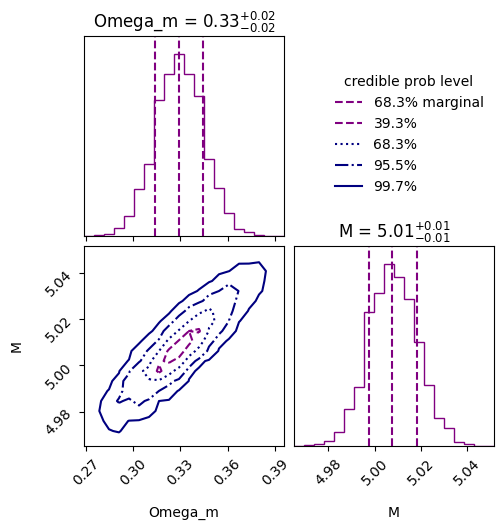

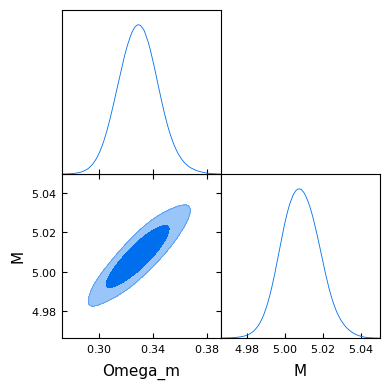

In [ ]:
with open(f'{fit_dir}/Flat_LCDM_{prior}{"_marg" if marginalize_M else ""}_result.pkl', 'rb') as f:
    Flat_LCDM_result = pickle.load(f)
summary_statistics(Flat_LCDM_result)
cornerplot(Flat_LCDM_result);
smooth_plot(Flat_LCDM_result)

#### Open LCDM

In [ ]:
# Needless to run again if the .pkl files exist in fit_dir
Open_LCDM_result = fit_cosmology("Flat_LCDM", prior=prior, marginalized=marginalize_M)
with open(f'{fit_dir}/Open_LCDM_{prior}{"_marg" if marginalize_M else ""}_result.pkl', 'wb') as f:
    pickle.dump(Open_LCDM_result, f)

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(400.0)), (np.float64(inf), np.float64(400.0))]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-2187920668670498648105225440521332210233345370458202095559323371333416622895182987590564814157512704.00, Lmax=-820.02


DEBUG:ultranest:iteration=1, ncalls=402, regioncalls=80, ndraw=40, logz=-2187920668670498648105225440521332210233345370458202095559323371333416622895182987590564814157512704.00, remainder_fraction=100.0000%, Lmin=-2110823935661586700707915555216966105678098938793951326613714926827431864510015596087944028482437120.00, Lmax=-820.02


DEBUG:ultranest:iteration=2, ncalls=403, regioncalls=120, ndraw=40, logz=-2110823935661586700707915555216966105678098938793951326613714926827431864510015596087944028482437120.00, remainder_fraction=100.0000%, Lmin=-2100218724453222072060821848431571198947115087668078905360531383169565396096931291810735703157899264.00, Lmax=-820.02


DEBUG:ultranest:iteration=3, ncalls=404, regioncalls=160, ndraw=40, logz=-2100218724453222072060821848431571198947115087668078905360531383169565396096931291810735703157899264.00, remainder_fraction=100.0000%, Lmin=-2092211588735517879333110114943216083233105493702763025855823038645107861339918337977298114737864704.00, Lmax=-820.02


DEBUG:ultranest:iteration=4, ncalls=405, regioncalls=200, ndraw=40, logz=-2092211588735517879333110114943216083233105493702763025855823038645107861339918337977298114737864704.00, remainder_fraction=100.0000%, Lmin=-2081060290981628948499353096756359031904072771853323940241863011356119421721341263433474168959533056.00, Lmax=-820.02


DEBUG:ultranest:iteration=5, ncalls=406, regioncalls=240, ndraw=40, logz=-2081060290981628948499353096756359031904072771853323940241863011356119421721341263433474168959533056.00, remainder_fraction=100.0000%, Lmin=-2049284813203989624353390025564886968417462162273059075607296432188857450312072148211414406455623680.00, Lmax=-820.02


DEBUG:ultranest:iteration=6, ncalls=407, regioncalls=280, ndraw=40, logz=-2049284813203989624353390025564886968417462162273059075607296432188857450312072148211414406455623680.00, remainder_fraction=100.0000%, Lmin=-2027324146935899617536579402822366352588722372912913947039906246362122815726300379625085771920179200.00, Lmax=-820.02


DEBUG:ultranest:iteration=7, ncalls=408, regioncalls=320, ndraw=40, logz=-2027324146935899617536579402822366352588722372912913947039906246362122815726300379625085771920179200.00, remainder_fraction=100.0000%, Lmin=-2022023042916258375593643413095463892974693814644559538059257847820222980633186463491412401688936448.00, Lmax=-820.02


DEBUG:ultranest:iteration=8, ncalls=409, regioncalls=360, ndraw=40, logz=-2022023042916258375593643413095463892974693814644559538059257847820222980633186463491412401688936448.00, remainder_fraction=100.0000%, Lmin=-2019695801234691919282254183562040083338173709511780017257215318031615328739009917581315292906127360.00, Lmax=-820.02


DEBUG:ultranest:iteration=9, ncalls=410, regioncalls=400, ndraw=40, logz=-2019695801234691919282254183562040083338173709511780017257215318031615328739009917581315292906127360.00, remainder_fraction=100.0000%, Lmin=-1960642324417304142965952284193543447175198077052923666092962626867639740981947308711570423624499200.00, Lmax=-820.02


DEBUG:ultranest:iteration=10, ncalls=411, regioncalls=440, ndraw=40, logz=-1960642324417304142965952284193543447175198077052923666092962626867639740981947308711570423624499200.00, remainder_fraction=100.0000%, Lmin=-1927127864592438691882961623086312987042309269138304903495206668762631523800964566356630740012105728.00, Lmax=-820.02


DEBUG:ultranest:iteration=11, ncalls=412, regioncalls=480, ndraw=40, logz=-1927127864592438691882961623086312987042309269138304903495206668762631523800964566356630740012105728.00, remainder_fraction=100.0000%, Lmin=-1919873470596447405106062488932805368919295642118832503737316758952035805791012238791215556107173888.00, Lmax=-820.02


DEBUG:ultranest:iteration=12, ncalls=413, regioncalls=520, ndraw=40, logz=-1919873470596447405106062488932805368919295642118832503737316758952035805791012238791215556107173888.00, remainder_fraction=100.0000%, Lmin=-1917609444735531899294967209506755213339339422515382837702975186939114547844005520374820789284765696.00, Lmax=-820.02


DEBUG:ultranest:iteration=13, ncalls=414, regioncalls=560, ndraw=40, logz=-1917609444735531899294967209506755213339339422515382837702975186939114547844005520374820789284765696.00, remainder_fraction=100.0000%, Lmin=-1843968592971081352646045927593065877918357640327332567499547172287945366393082162925767773877436416.00, Lmax=-820.02


DEBUG:ultranest:iteration=14, ncalls=415, regioncalls=600, ndraw=40, logz=-1843968592971081352646045927593065877918357640327332567499547172287945366393082162925767773877436416.00, remainder_fraction=100.0000%, Lmin=-1803135877237169218995824081851489939088033581778266493479195526526431694145874217480502155644239872.00, Lmax=-820.02


DEBUG:ultranest:iteration=15, ncalls=416, regioncalls=640, ndraw=40, logz=-1803135877237169218995824081851489939088033581778266493479195526526431694145874217480502155644239872.00, remainder_fraction=100.0000%, Lmin=-1758100016488719773175268211046692180846878723105857684808332588465187041763771328897464122445135872.00, Lmax=-820.02


DEBUG:ultranest:iteration=16, ncalls=417, regioncalls=680, ndraw=40, logz=-1758100016488719773175268211046692180846878723105857684808332588465187041763771328897464122445135872.00, remainder_fraction=100.0000%, Lmin=-2046.26, Lmax=-820.02


DEBUG:ultranest:iteration=17, ncalls=418, regioncalls=720, ndraw=40, logz=-2052.29, remainder_fraction=100.0000%, Lmin=-2004.52, Lmax=-820.02


DEBUG:ultranest:iteration=18, ncalls=419, regioncalls=760, ndraw=40, logz=-2010.56, remainder_fraction=100.0000%, Lmin=-1990.28, Lmax=-820.02


DEBUG:ultranest:iteration=19, ncalls=420, regioncalls=800, ndraw=40, logz=-1996.32, remainder_fraction=100.0000%, Lmin=-1870.42, Lmax=-820.02


DEBUG:ultranest:iteration=20, ncalls=421, regioncalls=840, ndraw=40, logz=-1876.46, remainder_fraction=100.0000%, Lmin=-1851.66, Lmax=-820.02


DEBUG:ultranest:iteration=21, ncalls=422, regioncalls=880, ndraw=40, logz=-1857.71, remainder_fraction=100.0000%, Lmin=-1746.64, Lmax=-820.02


DEBUG:ultranest:iteration=22, ncalls=423, regioncalls=920, ndraw=40, logz=-1752.69, remainder_fraction=100.0000%, Lmin=-1746.54, Lmax=-820.02


DEBUG:ultranest:iteration=23, ncalls=424, regioncalls=960, ndraw=40, logz=-1751.94, remainder_fraction=100.0000%, Lmin=-1699.67, Lmax=-820.02


DEBUG:ultranest:iteration=24, ncalls=425, regioncalls=1000, ndraw=40, logz=-1705.72, remainder_fraction=100.0000%, Lmin=-1681.49, Lmax=-820.02


DEBUG:ultranest:iteration=25, ncalls=427, regioncalls=1080, ndraw=40, logz=-1687.54, remainder_fraction=100.0000%, Lmin=-1667.75, Lmax=-820.02


DEBUG:ultranest:iteration=26, ncalls=428, regioncalls=1120, ndraw=40, logz=-1673.81, remainder_fraction=100.0000%, Lmin=-1655.17, Lmax=-820.02


DEBUG:ultranest:iteration=27, ncalls=429, regioncalls=1160, ndraw=40, logz=-1661.23, remainder_fraction=100.0000%, Lmin=-1629.19, Lmax=-820.02


DEBUG:ultranest:iteration=28, ncalls=430, regioncalls=1200, ndraw=40, logz=-1635.25, remainder_fraction=100.0000%, Lmin=-1628.86, Lmax=-820.02


DEBUG:ultranest:iteration=29, ncalls=431, regioncalls=1240, ndraw=40, logz=-1634.38, remainder_fraction=100.0000%, Lmin=-1621.03, Lmax=-820.02


DEBUG:ultranest:iteration=30, ncalls=432, regioncalls=1280, ndraw=40, logz=-1627.10, remainder_fraction=100.0000%, Lmin=-1615.24, Lmax=-820.02


DEBUG:ultranest:iteration=31, ncalls=433, regioncalls=1320, ndraw=40, logz=-1621.31, remainder_fraction=100.0000%, Lmin=-1611.17, Lmax=-820.02


DEBUG:ultranest:iteration=32, ncalls=434, regioncalls=1360, ndraw=40, logz=-1617.23, remainder_fraction=100.0000%, Lmin=-1597.03, Lmax=-820.02


DEBUG:ultranest:iteration=33, ncalls=435, regioncalls=1400, ndraw=40, logz=-1603.10, remainder_fraction=100.0000%, Lmin=-1571.09, Lmax=-820.02


DEBUG:ultranest:iteration=34, ncalls=436, regioncalls=1440, ndraw=40, logz=-1577.17, remainder_fraction=100.0000%, Lmin=-1551.72, Lmax=-820.02


DEBUG:ultranest:iteration=35, ncalls=437, regioncalls=1480, ndraw=40, logz=-1557.80, remainder_fraction=100.0000%, Lmin=-1545.05, Lmax=-820.02


DEBUG:ultranest:iteration=36, ncalls=438, regioncalls=1520, ndraw=40, logz=-1551.13, remainder_fraction=100.0000%, Lmin=-1540.87, Lmax=-820.02


DEBUG:ultranest:iteration=37, ncalls=439, regioncalls=1560, ndraw=40, logz=-1546.93, remainder_fraction=100.0000%, Lmin=-1511.48, Lmax=-820.02


DEBUG:ultranest:iteration=38, ncalls=440, regioncalls=1600, ndraw=40, logz=-1517.57, remainder_fraction=100.0000%, Lmin=-1509.47, Lmax=-820.02


DEBUG:ultranest:iteration=39, ncalls=441, regioncalls=1640, ndraw=40, logz=-1515.43, remainder_fraction=100.0000%, Lmin=-1470.02, Lmax=-820.02


DEBUG:ultranest:iteration=40, ncalls=442, regioncalls=1680, ndraw=40, logz=-1476.11, remainder_fraction=100.0000%, Lmin=-1468.53, Lmax=-820.02


DEBUG:ultranest:iteration=41, ncalls=443, regioncalls=1720, ndraw=40, logz=-1474.42, remainder_fraction=100.0000%, Lmin=-1458.57, Lmax=-820.02


DEBUG:ultranest:iteration=42, ncalls=444, regioncalls=1760, ndraw=40, logz=-1464.67, remainder_fraction=100.0000%, Lmin=-1422.01, Lmax=-820.02


DEBUG:ultranest:iteration=43, ncalls=445, regioncalls=1800, ndraw=40, logz=-1428.10, remainder_fraction=100.0000%, Lmin=-1408.75, Lmax=-820.02


DEBUG:ultranest:iteration=44, ncalls=446, regioncalls=1840, ndraw=40, logz=-1414.85, remainder_fraction=100.0000%, Lmin=-1402.44, Lmax=-820.02


DEBUG:ultranest:iteration=45, ncalls=447, regioncalls=1880, ndraw=40, logz=-1408.54, remainder_fraction=100.0000%, Lmin=-1388.08, Lmax=-820.02


DEBUG:ultranest:iteration=46, ncalls=448, regioncalls=1920, ndraw=40, logz=-1394.19, remainder_fraction=100.0000%, Lmin=-1351.82, Lmax=-820.02


DEBUG:ultranest:iteration=47, ncalls=449, regioncalls=1960, ndraw=40, logz=-1357.92, remainder_fraction=100.0000%, Lmin=-1325.27, Lmax=-820.02


DEBUG:ultranest:iteration=48, ncalls=451, regioncalls=2040, ndraw=40, logz=-1331.38, remainder_fraction=100.0000%, Lmin=-1303.39, Lmax=-820.02


DEBUG:ultranest:iteration=49, ncalls=453, regioncalls=2120, ndraw=40, logz=-1309.50, remainder_fraction=100.0000%, Lmin=-1301.96, Lmax=-820.02


DEBUG:ultranest:iteration=50, ncalls=454, regioncalls=2160, ndraw=40, logz=-1307.86, remainder_fraction=100.0000%, Lmin=-1282.67, Lmax=-820.02


DEBUG:ultranest:iteration=51, ncalls=455, regioncalls=2200, ndraw=40, logz=-1288.79, remainder_fraction=100.0000%, Lmin=-1277.20, Lmax=-820.02


DEBUG:ultranest:iteration=52, ncalls=457, regioncalls=2280, ndraw=40, logz=-1283.31, remainder_fraction=100.0000%, Lmin=-1267.26, Lmax=-820.02


DEBUG:ultranest:iteration=53, ncalls=458, regioncalls=2320, ndraw=40, logz=-1273.38, remainder_fraction=100.0000%, Lmin=-1258.16, Lmax=-820.02


DEBUG:ultranest:iteration=54, ncalls=459, regioncalls=2360, ndraw=40, logz=-1264.29, remainder_fraction=100.0000%, Lmin=-1254.96, Lmax=-820.02


DEBUG:ultranest:iteration=55, ncalls=461, regioncalls=2440, ndraw=40, logz=-1261.05, remainder_fraction=100.0000%, Lmin=-1252.98, Lmax=-820.02


DEBUG:ultranest:iteration=56, ncalls=462, regioncalls=2480, ndraw=40, logz=-1258.98, remainder_fraction=100.0000%, Lmin=-1231.20, Lmax=-820.02


DEBUG:ultranest:iteration=57, ncalls=463, regioncalls=2520, ndraw=40, logz=-1237.33, remainder_fraction=100.0000%, Lmin=-1226.30, Lmax=-820.02


DEBUG:ultranest:iteration=58, ncalls=464, regioncalls=2560, ndraw=40, logz=-1232.43, remainder_fraction=100.0000%, Lmin=-1193.09, Lmax=-820.02


DEBUG:ultranest:iteration=59, ncalls=465, regioncalls=2600, ndraw=40, logz=-1199.23, remainder_fraction=100.0000%, Lmin=-1173.31, Lmax=-820.02


DEBUG:ultranest:iteration=60, ncalls=466, regioncalls=2640, ndraw=40, logz=-1179.45, remainder_fraction=100.0000%, Lmin=-1161.49, Lmax=-820.02


DEBUG:ultranest:iteration=61, ncalls=467, regioncalls=2680, ndraw=40, logz=-1167.63, remainder_fraction=100.0000%, Lmin=-1159.82, Lmax=-820.02


DEBUG:ultranest:iteration=62, ncalls=468, regioncalls=2720, ndraw=40, logz=-1165.79, remainder_fraction=100.0000%, Lmin=-1147.34, Lmax=-820.02


DEBUG:ultranest:iteration=63, ncalls=469, regioncalls=2760, ndraw=40, logz=-1153.49, remainder_fraction=100.0000%, Lmin=-1146.66, Lmax=-820.02


DEBUG:ultranest:iteration=64, ncalls=470, regioncalls=2800, ndraw=40, logz=-1152.40, remainder_fraction=100.0000%, Lmin=-1132.99, Lmax=-820.02


DEBUG:ultranest:iteration=65, ncalls=471, regioncalls=2840, ndraw=40, logz=-1139.14, remainder_fraction=100.0000%, Lmin=-1132.08, Lmax=-820.02


DEBUG:ultranest:iteration=66, ncalls=472, regioncalls=2880, ndraw=40, logz=-1137.90, remainder_fraction=100.0000%, Lmin=-1131.00, Lmax=-820.02


DEBUG:ultranest:iteration=67, ncalls=473, regioncalls=2920, ndraw=40, logz=-1136.77, remainder_fraction=100.0000%, Lmin=-1129.41, Lmax=-820.02


DEBUG:ultranest:iteration=68, ncalls=474, regioncalls=2960, ndraw=40, logz=-1135.31, remainder_fraction=100.0000%, Lmin=-1114.53, Lmax=-820.02


DEBUG:ultranest:iteration=69, ncalls=476, regioncalls=3040, ndraw=40, logz=-1120.70, remainder_fraction=100.0000%, Lmin=-1110.28, Lmax=-820.02


DEBUG:ultranest:iteration=70, ncalls=477, regioncalls=3080, ndraw=40, logz=-1116.44, remainder_fraction=100.0000%, Lmin=-1109.13, Lmax=-820.02


DEBUG:ultranest:iteration=71, ncalls=479, regioncalls=3160, ndraw=40, logz=-1115.02, remainder_fraction=100.0000%, Lmin=-1105.64, Lmax=-820.02


DEBUG:ultranest:iteration=72, ncalls=480, regioncalls=3200, ndraw=40, logz=-1111.77, remainder_fraction=100.0000%, Lmin=-1104.07, Lmax=-820.02


DEBUG:ultranest:iteration=73, ncalls=481, regioncalls=3240, ndraw=40, logz=-1110.05, remainder_fraction=100.0000%, Lmin=-1101.65, Lmax=-820.02


DEBUG:ultranest:iteration=74, ncalls=482, regioncalls=3280, ndraw=40, logz=-1107.72, remainder_fraction=100.0000%, Lmin=-1100.67, Lmax=-820.02


DEBUG:ultranest:iteration=75, ncalls=483, regioncalls=3320, ndraw=40, logz=-1106.50, remainder_fraction=100.0000%, Lmin=-1100.56, Lmax=-820.02


DEBUG:ultranest:iteration=76, ncalls=484, regioncalls=3360, ndraw=40, logz=-1105.92, remainder_fraction=100.0000%, Lmin=-1098.54, Lmax=-820.02


DEBUG:ultranest:iteration=77, ncalls=485, regioncalls=3400, ndraw=40, logz=-1104.46, remainder_fraction=100.0000%, Lmin=-1097.56, Lmax=-820.02


DEBUG:ultranest:iteration=78, ncalls=486, regioncalls=3440, ndraw=40, logz=-1103.35, remainder_fraction=100.0000%, Lmin=-1086.69, Lmax=-820.02


DEBUG:ultranest:iteration=79, ncalls=488, regioncalls=3520, ndraw=40, logz=-1092.88, remainder_fraction=100.0000%, Lmin=-1085.69, Lmax=-820.02


DEBUG:ultranest:iteration=80, ncalls=489, regioncalls=3560, ndraw=40, logz=-1091.57, remainder_fraction=100.0000%, Lmin=-1084.41, Lmax=-820.02


DEBUG:ultranest:iteration=81, ncalls=490, regioncalls=3600, ndraw=40, logz=-1090.28, remainder_fraction=100.0000%, Lmin=-1082.50, Lmax=-820.02


DEBUG:ultranest:iteration=82, ncalls=491, regioncalls=3640, ndraw=40, logz=-1088.50, remainder_fraction=100.0000%, Lmin=-1081.91, Lmax=-820.02


DEBUG:ultranest:iteration=83, ncalls=492, regioncalls=3680, ndraw=40, logz=-1087.60, remainder_fraction=100.0000%, Lmin=-1080.43, Lmax=-820.02


DEBUG:ultranest:iteration=84, ncalls=493, regioncalls=3720, ndraw=40, logz=-1086.31, remainder_fraction=100.0000%, Lmin=-1074.74, Lmax=-820.02


DEBUG:ultranest:iteration=85, ncalls=494, regioncalls=3760, ndraw=40, logz=-1080.94, remainder_fraction=100.0000%, Lmin=-1074.11, Lmax=-820.02


DEBUG:ultranest:iteration=86, ncalls=495, regioncalls=3800, ndraw=40, logz=-1079.89, remainder_fraction=100.0000%, Lmin=-1070.60, Lmax=-820.02


DEBUG:ultranest:iteration=87, ncalls=496, regioncalls=3840, ndraw=40, logz=-1076.76, remainder_fraction=100.0000%, Lmin=-1070.46, Lmax=-820.02


DEBUG:ultranest:iteration=88, ncalls=497, regioncalls=3880, ndraw=40, logz=-1076.02, remainder_fraction=100.0000%, Lmin=-1067.70, Lmax=-820.02


DEBUG:ultranest:iteration=89, ncalls=499, regioncalls=3960, ndraw=40, logz=-1073.79, remainder_fraction=100.0000%, Lmin=-1067.30, Lmax=-820.02


DEBUG:ultranest:iteration=90, ncalls=500, regioncalls=4000, ndraw=40, logz=-1072.95, remainder_fraction=100.0000%, Lmin=-1066.71, Lmax=-820.02


DEBUG:ultranest:iteration=91, ncalls=501, regioncalls=4040, ndraw=40, logz=-1072.24, remainder_fraction=100.0000%, Lmin=-1066.17, Lmax=-820.02


DEBUG:ultranest:iteration=92, ncalls=502, regioncalls=4080, ndraw=40, logz=-1071.62, remainder_fraction=100.0000%, Lmin=-1063.62, Lmax=-820.02


DEBUG:ultranest:iteration=93, ncalls=503, regioncalls=4120, ndraw=40, logz=-1069.68, remainder_fraction=100.0000%, Lmin=-1061.87, Lmax=-820.02


DEBUG:ultranest:iteration=94, ncalls=504, regioncalls=4160, ndraw=40, logz=-1067.91, remainder_fraction=100.0000%, Lmin=-1056.82, Lmax=-820.02


DEBUG:ultranest:iteration=95, ncalls=505, regioncalls=4200, ndraw=40, logz=-1063.04, remainder_fraction=100.0000%, Lmin=-1055.50, Lmax=-820.02


DEBUG:ultranest:iteration=96, ncalls=506, regioncalls=4240, ndraw=40, logz=-1061.49, remainder_fraction=100.0000%, Lmin=-1054.25, Lmax=-820.02


DEBUG:ultranest:iteration=97, ncalls=507, regioncalls=4280, ndraw=40, logz=-1060.17, remainder_fraction=100.0000%, Lmin=-1048.24, Lmax=-820.02


DEBUG:ultranest:iteration=98, ncalls=510, regioncalls=4400, ndraw=40, logz=-1054.47, remainder_fraction=100.0000%, Lmin=-1047.35, Lmax=-820.02


DEBUG:ultranest:iteration=99, ncalls=512, regioncalls=4480, ndraw=40, logz=-1053.24, remainder_fraction=100.0000%, Lmin=-1045.23, Lmax=-820.02


DEBUG:ultranest:iteration=100, ncalls=513, regioncalls=4520, ndraw=40, logz=-1051.32, remainder_fraction=100.0000%, Lmin=-1042.20, Lmax=-820.02


DEBUG:ultranest:iteration=101, ncalls=514, regioncalls=4560, ndraw=40, logz=-1048.39, remainder_fraction=100.0000%, Lmin=-1041.83, Lmax=-820.02


DEBUG:ultranest:iteration=102, ncalls=515, regioncalls=4600, ndraw=40, logz=-1047.53, remainder_fraction=100.0000%, Lmin=-1040.73, Lmax=-820.02


DEBUG:ultranest:iteration=103, ncalls=516, regioncalls=4640, ndraw=40, logz=-1046.52, remainder_fraction=100.0000%, Lmin=-1040.29, Lmax=-820.02


DEBUG:ultranest:iteration=104, ncalls=517, regioncalls=4680, ndraw=40, logz=-1045.84, remainder_fraction=100.0000%, Lmin=-1033.69, Lmax=-820.02


DEBUG:ultranest:iteration=105, ncalls=518, regioncalls=4720, ndraw=40, logz=-1039.94, remainder_fraction=100.0000%, Lmin=-1033.36, Lmax=-820.02


DEBUG:ultranest:iteration=106, ncalls=520, regioncalls=4800, ndraw=40, logz=-1039.07, remainder_fraction=100.0000%, Lmin=-1032.50, Lmax=-820.02


DEBUG:ultranest:iteration=107, ncalls=523, regioncalls=4920, ndraw=40, logz=-1038.21, remainder_fraction=100.0000%, Lmin=-1032.36, Lmax=-820.02


DEBUG:ultranest:iteration=108, ncalls=524, regioncalls=4960, ndraw=40, logz=-1037.70, remainder_fraction=100.0000%, Lmin=-1028.79, Lmax=-820.02


DEBUG:ultranest:iteration=109, ncalls=525, regioncalls=5000, ndraw=40, logz=-1034.98, remainder_fraction=100.0000%, Lmin=-1028.52, Lmax=-820.02


DEBUG:ultranest:iteration=110, ncalls=526, regioncalls=5040, ndraw=40, logz=-1034.19, remainder_fraction=100.0000%, Lmin=-1026.12, Lmax=-820.02


DEBUG:ultranest:iteration=111, ncalls=527, regioncalls=5080, ndraw=40, logz=-1032.24, remainder_fraction=100.0000%, Lmin=-1025.90, Lmax=-820.02


DEBUG:ultranest:iteration=112, ncalls=528, regioncalls=5120, ndraw=40, logz=-1031.51, remainder_fraction=100.0000%, Lmin=-1023.33, Lmax=-820.02


DEBUG:ultranest:iteration=113, ncalls=529, regioncalls=5160, ndraw=40, logz=-1029.46, remainder_fraction=100.0000%, Lmin=-1023.10, Lmax=-820.02


DEBUG:ultranest:iteration=114, ncalls=530, regioncalls=5200, ndraw=40, logz=-1028.72, remainder_fraction=100.0000%, Lmin=-1021.91, Lmax=-820.02


DEBUG:ultranest:iteration=115, ncalls=531, regioncalls=5240, ndraw=40, logz=-1027.73, remainder_fraction=100.0000%, Lmin=-1020.50, Lmax=-820.02


DEBUG:ultranest:iteration=116, ncalls=532, regioncalls=5280, ndraw=40, logz=-1026.45, remainder_fraction=100.0000%, Lmin=-1020.49, Lmax=-820.02


DEBUG:ultranest:iteration=117, ncalls=534, regioncalls=5360, ndraw=40, logz=-1025.91, remainder_fraction=100.0000%, Lmin=-1020.30, Lmax=-820.02


DEBUG:ultranest:iteration=118, ncalls=535, regioncalls=5400, ndraw=40, logz=-1025.49, remainder_fraction=100.0000%, Lmin=-1013.95, Lmax=-820.02


DEBUG:ultranest:iteration=119, ncalls=536, regioncalls=5440, ndraw=40, logz=-1020.23, remainder_fraction=100.0000%, Lmin=-1013.07, Lmax=-820.02


DEBUG:ultranest:iteration=120, ncalls=537, regioncalls=5480, ndraw=40, logz=-1019.01, remainder_fraction=100.0000%, Lmin=-1009.52, Lmax=-820.02


DEBUG:ultranest:iteration=121, ncalls=538, regioncalls=5520, ndraw=40, logz=-1015.77, remainder_fraction=100.0000%, Lmin=-1008.52, Lmax=-820.02


DEBUG:ultranest:iteration=122, ncalls=539, regioncalls=5560, ndraw=40, logz=-1014.49, remainder_fraction=100.0000%, Lmin=-1007.80, Lmax=-820.02


DEBUG:ultranest:iteration=123, ncalls=540, regioncalls=5600, ndraw=40, logz=-1013.58, remainder_fraction=100.0000%, Lmin=-1007.45, Lmax=-820.02


DEBUG:ultranest:iteration=124, ncalls=541, regioncalls=5640, ndraw=40, logz=-1012.97, remainder_fraction=100.0000%, Lmin=-1007.39, Lmax=-820.02


DEBUG:ultranest:iteration=125, ncalls=543, regioncalls=5720, ndraw=40, logz=-1012.57, remainder_fraction=100.0000%, Lmin=-1004.35, Lmax=-820.02


DEBUG:ultranest:iteration=126, ncalls=544, regioncalls=5760, ndraw=40, logz=-1010.52, remainder_fraction=100.0000%, Lmin=-1004.33, Lmax=-820.02


DEBUG:ultranest:iteration=127, ncalls=545, regioncalls=5800, ndraw=40, logz=-1009.88, remainder_fraction=100.0000%, Lmin=-1003.32, Lmax=-820.02


DEBUG:ultranest:iteration=128, ncalls=546, regioncalls=5840, ndraw=40, logz=-1009.05, remainder_fraction=100.0000%, Lmin=-1002.91, Lmax=-820.02


DEBUG:ultranest:iteration=129, ncalls=547, regioncalls=5880, ndraw=40, logz=-1008.44, remainder_fraction=100.0000%, Lmin=-1002.81, Lmax=-820.02


DEBUG:ultranest:iteration=130, ncalls=548, regioncalls=5920, ndraw=40, logz=-1008.03, remainder_fraction=100.0000%, Lmin=-1000.59, Lmax=-820.02


DEBUG:ultranest:iteration=131, ncalls=549, regioncalls=5960, ndraw=40, logz=-1006.63, remainder_fraction=100.0000%, Lmin=-999.19, Lmax=-820.02


DEBUG:ultranest:iteration=132, ncalls=551, regioncalls=6040, ndraw=40, logz=-1005.22, remainder_fraction=100.0000%, Lmin=-997.41, Lmax=-820.02


DEBUG:ultranest:iteration=133, ncalls=554, regioncalls=6160, ndraw=40, logz=-1003.53, remainder_fraction=100.0000%, Lmin=-997.29, Lmax=-820.02


DEBUG:ultranest:iteration=134, ncalls=555, regioncalls=6200, ndraw=40, logz=-1002.88, remainder_fraction=100.0000%, Lmin=-996.62, Lmax=-820.02


DEBUG:ultranest:iteration=135, ncalls=556, regioncalls=6240, ndraw=40, logz=-1002.22, remainder_fraction=100.0000%, Lmin=-996.33, Lmax=-820.02


DEBUG:ultranest:iteration=136, ncalls=557, regioncalls=6280, ndraw=40, logz=-1001.72, remainder_fraction=100.0000%, Lmin=-995.56, Lmax=-820.02


DEBUG:ultranest:iteration=137, ncalls=558, regioncalls=6320, ndraw=40, logz=-1001.11, remainder_fraction=100.0000%, Lmin=-995.08, Lmax=-820.02


DEBUG:ultranest:iteration=138, ncalls=559, regioncalls=6360, ndraw=40, logz=-1000.56, remainder_fraction=100.0000%, Lmin=-994.56, Lmax=-820.02


DEBUG:ultranest:iteration=139, ncalls=562, regioncalls=6480, ndraw=40, logz=-1000.02, remainder_fraction=100.0000%, Lmin=-994.41, Lmax=-820.02


DEBUG:ultranest:iteration=140, ncalls=563, regioncalls=6520, ndraw=40, logz=-999.63, remainder_fraction=100.0000%, Lmin=-993.47, Lmax=-820.02


DEBUG:ultranest:iteration=141, ncalls=565, regioncalls=6600, ndraw=40, logz=-999.02, remainder_fraction=100.0000%, Lmin=-993.14, Lmax=-820.02


DEBUG:ultranest:iteration=142, ncalls=566, regioncalls=6640, ndraw=40, logz=-998.53, remainder_fraction=100.0000%, Lmin=-991.04, Lmax=-820.02


DEBUG:ultranest:iteration=143, ncalls=567, regioncalls=6680, ndraw=40, logz=-997.11, remainder_fraction=100.0000%, Lmin=-988.53, Lmax=-820.02


DEBUG:ultranest:iteration=144, ncalls=569, regioncalls=6760, ndraw=40, logz=-994.78, remainder_fraction=100.0000%, Lmin=-986.62, Lmax=-820.02


DEBUG:ultranest:iteration=145, ncalls=570, regioncalls=6800, ndraw=40, logz=-992.83, remainder_fraction=100.0000%, Lmin=-985.06, Lmax=-820.02


DEBUG:ultranest:iteration=146, ncalls=571, regioncalls=6840, ndraw=40, logz=-991.20, remainder_fraction=100.0000%, Lmin=-982.01, Lmax=-820.02


DEBUG:ultranest:iteration=147, ncalls=572, regioncalls=6880, ndraw=40, logz=-988.31, remainder_fraction=100.0000%, Lmin=-981.00, Lmax=-820.02


DEBUG:ultranest:iteration=148, ncalls=573, regioncalls=6920, ndraw=40, logz=-987.04, remainder_fraction=100.0000%, Lmin=-980.33, Lmax=-820.02


DEBUG:ultranest:iteration=149, ncalls=574, regioncalls=6960, ndraw=40, logz=-986.15, remainder_fraction=100.0000%, Lmin=-979.75, Lmax=-820.02


DEBUG:ultranest:iteration=150, ncalls=576, regioncalls=7040, ndraw=40, logz=-985.44, remainder_fraction=100.0000%, Lmin=-979.53, Lmax=-820.02


DEBUG:ultranest:iteration=151, ncalls=577, regioncalls=7080, ndraw=40, logz=-984.95, remainder_fraction=100.0000%, Lmin=-978.84, Lmax=-820.02


DEBUG:ultranest:iteration=152, ncalls=578, regioncalls=7120, ndraw=40, logz=-984.38, remainder_fraction=100.0000%, Lmin=-975.38, Lmax=-820.02


DEBUG:ultranest:iteration=153, ncalls=579, regioncalls=7160, ndraw=40, logz=-981.68, remainder_fraction=100.0000%, Lmin=-974.94, Lmax=-820.02


DEBUG:ultranest:iteration=154, ncalls=580, regioncalls=7200, ndraw=40, logz=-980.79, remainder_fraction=100.0000%, Lmin=-973.44, Lmax=-820.02


DEBUG:ultranest:iteration=155, ncalls=581, regioncalls=7240, ndraw=40, logz=-979.50, remainder_fraction=100.0000%, Lmin=-973.26, Lmax=-820.02


DEBUG:ultranest:iteration=156, ncalls=582, regioncalls=7280, ndraw=40, logz=-978.87, remainder_fraction=100.0000%, Lmin=-971.72, Lmax=-820.02


DEBUG:ultranest:iteration=157, ncalls=583, regioncalls=7320, ndraw=40, logz=-977.72, remainder_fraction=100.0000%, Lmin=-971.60, Lmax=-820.02


DEBUG:ultranest:iteration=158, ncalls=584, regioncalls=7360, ndraw=40, logz=-977.15, remainder_fraction=100.0000%, Lmin=-970.02, Lmax=-820.02


DEBUG:ultranest:iteration=159, ncalls=586, regioncalls=7440, ndraw=40, logz=-976.02, remainder_fraction=100.0000%, Lmin=-968.24, Lmax=-820.02


DEBUG:ultranest:iteration=160, ncalls=587, regioncalls=7480, ndraw=40, logz=-974.40, remainder_fraction=100.0000%, Lmin=-966.23, Lmax=-820.02


DEBUG:ultranest:iteration=161, ncalls=588, regioncalls=7520, ndraw=40, logz=-972.47, remainder_fraction=100.0000%, Lmin=-965.76, Lmax=-820.02


DEBUG:ultranest:iteration=162, ncalls=589, regioncalls=7560, ndraw=40, logz=-971.61, remainder_fraction=100.0000%, Lmin=-962.88, Lmax=-820.02


DEBUG:ultranest:iteration=163, ncalls=590, regioncalls=7600, ndraw=40, logz=-969.19, remainder_fraction=100.0000%, Lmin=-962.26, Lmax=-820.02


DEBUG:ultranest:iteration=164, ncalls=591, regioncalls=7640, ndraw=40, logz=-968.20, remainder_fraction=100.0000%, Lmin=-962.23, Lmax=-820.02


DEBUG:ultranest:iteration=165, ncalls=592, regioncalls=7680, ndraw=40, logz=-967.70, remainder_fraction=100.0000%, Lmin=-961.74, Lmax=-820.02


DEBUG:ultranest:iteration=166, ncalls=593, regioncalls=7720, ndraw=40, logz=-967.20, remainder_fraction=100.0000%, Lmin=-961.60, Lmax=-820.02


DEBUG:ultranest:iteration=167, ncalls=594, regioncalls=7760, ndraw=40, logz=-966.83, remainder_fraction=100.0000%, Lmin=-961.56, Lmax=-820.02


DEBUG:ultranest:iteration=168, ncalls=595, regioncalls=7800, ndraw=40, logz=-966.56, remainder_fraction=100.0000%, Lmin=-960.47, Lmax=-820.02


DEBUG:ultranest:iteration=169, ncalls=596, regioncalls=7840, ndraw=40, logz=-966.01, remainder_fraction=100.0000%, Lmin=-960.25, Lmax=-820.02


DEBUG:ultranest:iteration=170, ncalls=597, regioncalls=7880, ndraw=40, logz=-965.59, remainder_fraction=100.0000%, Lmin=-960.22, Lmax=-820.02


DEBUG:ultranest:iteration=171, ncalls=598, regioncalls=7920, ndraw=40, logz=-965.29, remainder_fraction=100.0000%, Lmin=-959.87, Lmax=-820.02


DEBUG:ultranest:iteration=172, ncalls=599, regioncalls=7960, ndraw=40, logz=-964.98, remainder_fraction=100.0000%, Lmin=-959.32, Lmax=-820.02


DEBUG:ultranest:iteration=173, ncalls=600, regioncalls=8000, ndraw=40, logz=-964.60, remainder_fraction=100.0000%, Lmin=-952.14, Lmax=-820.02


DEBUG:ultranest:iteration=174, ncalls=601, regioncalls=8040, ndraw=40, logz=-958.56, remainder_fraction=100.0000%, Lmin=-951.32, Lmax=-820.02


DEBUG:ultranest:iteration=175, ncalls=602, regioncalls=8080, ndraw=40, logz=-957.38, remainder_fraction=100.0000%, Lmin=-950.16, Lmax=-820.02


DEBUG:ultranest:iteration=176, ncalls=603, regioncalls=8120, ndraw=40, logz=-956.21, remainder_fraction=100.0000%, Lmin=-949.92, Lmax=-820.02


DEBUG:ultranest:iteration=177, ncalls=604, regioncalls=8160, ndraw=40, logz=-955.59, remainder_fraction=100.0000%, Lmin=-949.76, Lmax=-820.02


DEBUG:ultranest:iteration=178, ncalls=605, regioncalls=8200, ndraw=40, logz=-955.15, remainder_fraction=100.0000%, Lmin=-948.82, Lmax=-820.02


DEBUG:ultranest:iteration=179, ncalls=606, regioncalls=8240, ndraw=40, logz=-954.51, remainder_fraction=100.0000%, Lmin=-948.40, Lmax=-820.02


DEBUG:ultranest:iteration=180, ncalls=607, regioncalls=8280, ndraw=40, logz=-953.97, remainder_fraction=100.0000%, Lmin=-948.18, Lmax=-820.02


DEBUG:ultranest:iteration=181, ncalls=608, regioncalls=8320, ndraw=40, logz=-953.55, remainder_fraction=100.0000%, Lmin=-946.95, Lmax=-820.02


DEBUG:ultranest:iteration=182, ncalls=609, regioncalls=8360, ndraw=40, logz=-952.78, remainder_fraction=100.0000%, Lmin=-945.93, Lmax=-820.02


DEBUG:ultranest:iteration=183, ncalls=610, regioncalls=8400, ndraw=40, logz=-951.86, remainder_fraction=100.0000%, Lmin=-945.57, Lmax=-820.02


DEBUG:ultranest:iteration=184, ncalls=612, regioncalls=8480, ndraw=40, logz=-951.25, remainder_fraction=100.0000%, Lmin=-944.44, Lmax=-820.02


DEBUG:ultranest:iteration=185, ncalls=613, regioncalls=8520, ndraw=40, logz=-950.36, remainder_fraction=100.0000%, Lmin=-943.05, Lmax=-820.02


DEBUG:ultranest:iteration=186, ncalls=614, regioncalls=8560, ndraw=40, logz=-949.15, remainder_fraction=100.0000%, Lmin=-942.97, Lmax=-820.02


DEBUG:ultranest:iteration=187, ncalls=615, regioncalls=8600, ndraw=40, logz=-948.59, remainder_fraction=100.0000%, Lmin=-942.78, Lmax=-820.02


DEBUG:ultranest:iteration=188, ncalls=616, regioncalls=8640, ndraw=40, logz=-948.17, remainder_fraction=100.0000%, Lmin=-941.82, Lmax=-820.02


DEBUG:ultranest:iteration=189, ncalls=617, regioncalls=8680, ndraw=40, logz=-947.53, remainder_fraction=100.0000%, Lmin=-941.74, Lmax=-820.02


DEBUG:ultranest:iteration=190, ncalls=619, regioncalls=8760, ndraw=40, logz=-947.12, remainder_fraction=100.0000%, Lmin=-941.52, Lmax=-820.02


DEBUG:ultranest:iteration=191, ncalls=620, regioncalls=8800, ndraw=40, logz=-946.77, remainder_fraction=100.0000%, Lmin=-940.21, Lmax=-820.02


DEBUG:ultranest:iteration=192, ncalls=621, regioncalls=8840, ndraw=40, logz=-946.03, remainder_fraction=100.0000%, Lmin=-940.20, Lmax=-820.02


DEBUG:ultranest:iteration=193, ncalls=622, regioncalls=8880, ndraw=40, logz=-945.61, remainder_fraction=100.0000%, Lmin=-939.96, Lmax=-820.02


DEBUG:ultranest:iteration=194, ncalls=623, regioncalls=8920, ndraw=40, logz=-945.24, remainder_fraction=100.0000%, Lmin=-939.85, Lmax=-820.02


DEBUG:ultranest:iteration=195, ncalls=624, regioncalls=8960, ndraw=40, logz=-944.95, remainder_fraction=100.0000%, Lmin=-939.81, Lmax=-820.02


DEBUG:ultranest:iteration=196, ncalls=625, regioncalls=9000, ndraw=40, logz=-944.72, remainder_fraction=100.0000%, Lmin=-939.27, Lmax=-820.02


DEBUG:ultranest:iteration=197, ncalls=626, regioncalls=9040, ndraw=40, logz=-944.42, remainder_fraction=100.0000%, Lmin=-939.07, Lmax=-820.02


DEBUG:ultranest:iteration=198, ncalls=627, regioncalls=9080, ndraw=40, logz=-944.14, remainder_fraction=100.0000%, Lmin=-936.67, Lmax=-820.02


DEBUG:ultranest:iteration=199, ncalls=628, regioncalls=9120, ndraw=40, logz=-942.84, remainder_fraction=100.0000%, Lmin=-935.52, Lmax=-820.02


DEBUG:ultranest:iteration=200, ncalls=629, regioncalls=9160, ndraw=40, logz=-941.64, remainder_fraction=100.0000%, Lmin=-934.99, Lmax=-820.02


DEBUG:ultranest:iteration=201, ncalls=630, regioncalls=9200, ndraw=40, logz=-940.87, remainder_fraction=100.0000%, Lmin=-933.31, Lmax=-820.02


DEBUG:ultranest:iteration=202, ncalls=631, regioncalls=9240, ndraw=40, logz=-939.50, remainder_fraction=100.0000%, Lmin=-932.73, Lmax=-820.02


DEBUG:ultranest:iteration=203, ncalls=632, regioncalls=9280, ndraw=40, logz=-938.66, remainder_fraction=100.0000%, Lmin=-932.52, Lmax=-820.02


DEBUG:ultranest:iteration=204, ncalls=633, regioncalls=9320, ndraw=40, logz=-938.14, remainder_fraction=100.0000%, Lmin=-932.51, Lmax=-820.02


DEBUG:ultranest:iteration=205, ncalls=634, regioncalls=9360, ndraw=40, logz=-937.79, remainder_fraction=100.0000%, Lmin=-932.42, Lmax=-820.02


DEBUG:ultranest:iteration=206, ncalls=635, regioncalls=9400, ndraw=40, logz=-937.51, remainder_fraction=100.0000%, Lmin=-930.63, Lmax=-820.02


DEBUG:ultranest:iteration=207, ncalls=637, regioncalls=9480, ndraw=40, logz=-936.61, remainder_fraction=100.0000%, Lmin=-929.52, Lmax=-820.02


DEBUG:ultranest:iteration=208, ncalls=638, regioncalls=9520, ndraw=40, logz=-935.59, remainder_fraction=100.0000%, Lmin=-928.65, Lmax=-820.02


DEBUG:ultranest:iteration=209, ncalls=639, regioncalls=9560, ndraw=40, logz=-934.66, remainder_fraction=100.0000%, Lmin=-928.41, Lmax=-820.02


DEBUG:ultranest:iteration=210, ncalls=640, regioncalls=9600, ndraw=40, logz=-934.09, remainder_fraction=100.0000%, Lmin=-928.14, Lmax=-820.02


DEBUG:ultranest:iteration=211, ncalls=641, regioncalls=9640, ndraw=40, logz=-933.64, remainder_fraction=100.0000%, Lmin=-927.13, Lmax=-820.02


DEBUG:ultranest:iteration=212, ncalls=642, regioncalls=9680, ndraw=40, logz=-932.95, remainder_fraction=100.0000%, Lmin=-926.41, Lmax=-820.02


DEBUG:ultranest:iteration=213, ncalls=643, regioncalls=9720, ndraw=40, logz=-932.25, remainder_fraction=100.0000%, Lmin=-925.58, Lmax=-820.02


DEBUG:ultranest:iteration=214, ncalls=644, regioncalls=9760, ndraw=40, logz=-931.48, remainder_fraction=100.0000%, Lmin=-923.93, Lmax=-820.02


DEBUG:ultranest:iteration=215, ncalls=645, regioncalls=9800, ndraw=40, logz=-930.15, remainder_fraction=100.0000%, Lmin=-923.92, Lmax=-820.02


DEBUG:ultranest:iteration=216, ncalls=646, regioncalls=9840, ndraw=40, logz=-929.60, remainder_fraction=100.0000%, Lmin=-922.55, Lmax=-820.02


DEBUG:ultranest:iteration=217, ncalls=647, regioncalls=9880, ndraw=40, logz=-928.61, remainder_fraction=100.0000%, Lmin=-921.62, Lmax=-820.02


DEBUG:ultranest:iteration=218, ncalls=648, regioncalls=9920, ndraw=40, logz=-927.66, remainder_fraction=100.0000%, Lmin=-920.71, Lmax=-820.02


DEBUG:ultranest:iteration=219, ncalls=649, regioncalls=9960, ndraw=40, logz=-926.74, remainder_fraction=100.0000%, Lmin=-919.57, Lmax=-820.02


DEBUG:ultranest:iteration=220, ncalls=650, regioncalls=10000, ndraw=40, logz=-925.68, remainder_fraction=100.0000%, Lmin=-919.45, Lmax=-820.02


DEBUG:ultranest:iteration=221, ncalls=651, regioncalls=10040, ndraw=40, logz=-925.13, remainder_fraction=100.0000%, Lmin=-918.86, Lmax=-820.02


DEBUG:ultranest:iteration=222, ncalls=652, regioncalls=10080, ndraw=40, logz=-924.56, remainder_fraction=100.0000%, Lmin=-918.73, Lmax=-820.02


DEBUG:ultranest:iteration=223, ncalls=653, regioncalls=10120, ndraw=40, logz=-924.17, remainder_fraction=100.0000%, Lmin=-917.64, Lmax=-820.02


DEBUG:ultranest:iteration=224, ncalls=654, regioncalls=10160, ndraw=40, logz=-923.48, remainder_fraction=100.0000%, Lmin=-916.71, Lmax=-820.02


DEBUG:ultranest:iteration=225, ncalls=655, regioncalls=10200, ndraw=40, logz=-922.68, remainder_fraction=100.0000%, Lmin=-915.07, Lmax=-820.02


DEBUG:ultranest:iteration=226, ncalls=656, regioncalls=10240, ndraw=40, logz=-921.32, remainder_fraction=100.0000%, Lmin=-914.32, Lmax=-820.02


DEBUG:ultranest:iteration=227, ncalls=657, regioncalls=10280, ndraw=40, logz=-920.38, remainder_fraction=100.0000%, Lmin=-913.49, Lmax=-820.02


DEBUG:ultranest:iteration=228, ncalls=658, regioncalls=10320, ndraw=40, logz=-919.51, remainder_fraction=100.0000%, Lmin=-912.67, Lmax=-820.02


DEBUG:ultranest:iteration=229, ncalls=659, regioncalls=10360, ndraw=40, logz=-918.67, remainder_fraction=100.0000%, Lmin=-911.09, Lmax=-820.02


DEBUG:ultranest:iteration=230, ncalls=660, regioncalls=10400, ndraw=40, logz=-917.35, remainder_fraction=100.0000%, Lmin=-911.06, Lmax=-820.02


DEBUG:ultranest:iteration=231, ncalls=661, regioncalls=10440, ndraw=40, logz=-916.78, remainder_fraction=100.0000%, Lmin=-910.72, Lmax=-820.02


DEBUG:ultranest:iteration=232, ncalls=662, regioncalls=10480, ndraw=40, logz=-916.31, remainder_fraction=100.0000%, Lmin=-910.21, Lmax=-820.02


DEBUG:ultranest:iteration=233, ncalls=663, regioncalls=10520, ndraw=40, logz=-915.83, remainder_fraction=100.0000%, Lmin=-909.73, Lmax=-820.02


DEBUG:ultranest:iteration=234, ncalls=665, regioncalls=10600, ndraw=40, logz=-915.35, remainder_fraction=100.0000%, Lmin=-909.69, Lmax=-820.02


DEBUG:ultranest:iteration=235, ncalls=666, regioncalls=10640, ndraw=40, logz=-915.01, remainder_fraction=100.0000%, Lmin=-909.48, Lmax=-820.02


DEBUG:ultranest:iteration=236, ncalls=667, regioncalls=10680, ndraw=40, logz=-914.71, remainder_fraction=100.0000%, Lmin=-908.98, Lmax=-820.02


DEBUG:ultranest:iteration=237, ncalls=668, regioncalls=10720, ndraw=40, logz=-914.35, remainder_fraction=100.0000%, Lmin=-908.94, Lmax=-820.02


DEBUG:ultranest:iteration=238, ncalls=669, regioncalls=10760, ndraw=40, logz=-914.08, remainder_fraction=100.0000%, Lmin=-908.93, Lmax=-820.02


DEBUG:ultranest:iteration=239, ncalls=671, regioncalls=10840, ndraw=40, logz=-913.87, remainder_fraction=100.0000%, Lmin=-908.39, Lmax=-820.02


DEBUG:ultranest:iteration=240, ncalls=672, regioncalls=10880, ndraw=40, logz=-913.58, remainder_fraction=100.0000%, Lmin=-907.96, Lmax=-820.02


DEBUG:ultranest:iteration=241, ncalls=673, regioncalls=10920, ndraw=40, logz=-913.26, remainder_fraction=100.0000%, Lmin=-907.49, Lmax=-820.02


DEBUG:ultranest:iteration=242, ncalls=674, regioncalls=10960, ndraw=40, logz=-912.90, remainder_fraction=100.0000%, Lmin=-907.43, Lmax=-820.02


DEBUG:ultranest:iteration=243, ncalls=675, regioncalls=11000, ndraw=40, logz=-912.62, remainder_fraction=100.0000%, Lmin=-906.17, Lmax=-820.02


DEBUG:ultranest:iteration=244, ncalls=678, regioncalls=11120, ndraw=40, logz=-912.00, remainder_fraction=100.0000%, Lmin=-906.10, Lmax=-820.02


DEBUG:ultranest:iteration=245, ncalls=679, regioncalls=11160, ndraw=40, logz=-911.60, remainder_fraction=100.0000%, Lmin=-905.88, Lmax=-820.02


DEBUG:ultranest:iteration=246, ncalls=680, regioncalls=11200, ndraw=40, logz=-911.25, remainder_fraction=100.0000%, Lmin=-903.43, Lmax=-820.02


DEBUG:ultranest:iteration=247, ncalls=682, regioncalls=11280, ndraw=40, logz=-909.78, remainder_fraction=100.0000%, Lmin=-902.79, Lmax=-820.02


DEBUG:ultranest:iteration=248, ncalls=683, regioncalls=11320, ndraw=40, logz=-908.88, remainder_fraction=100.0000%, Lmin=-902.74, Lmax=-820.02


DEBUG:ultranest:iteration=249, ncalls=684, regioncalls=11360, ndraw=40, logz=-908.40, remainder_fraction=100.0000%, Lmin=-902.39, Lmax=-820.02


DEBUG:ultranest:iteration=250, ncalls=686, regioncalls=11440, ndraw=40, logz=-907.96, remainder_fraction=100.0000%, Lmin=-901.71, Lmax=-820.02


DEBUG:ultranest:iteration=251, ncalls=687, regioncalls=11480, ndraw=40, logz=-907.44, remainder_fraction=100.0000%, Lmin=-901.07, Lmax=-820.02


DEBUG:ultranest:iteration=252, ncalls=688, regioncalls=11520, ndraw=40, logz=-906.86, remainder_fraction=100.0000%, Lmin=-900.93, Lmax=-820.02


DEBUG:ultranest:iteration=253, ncalls=689, regioncalls=11560, ndraw=40, logz=-906.46, remainder_fraction=100.0000%, Lmin=-900.93, Lmax=-820.02


DEBUG:ultranest:iteration=254, ncalls=690, regioncalls=11600, ndraw=40, logz=-906.17, remainder_fraction=100.0000%, Lmin=-900.70, Lmax=-820.02


DEBUG:ultranest:iteration=255, ncalls=691, regioncalls=11640, ndraw=40, logz=-905.90, remainder_fraction=100.0000%, Lmin=-899.93, Lmax=-820.02


DEBUG:ultranest:iteration=256, ncalls=692, regioncalls=11680, ndraw=40, logz=-905.48, remainder_fraction=100.0000%, Lmin=-899.71, Lmax=-820.02


DEBUG:ultranest:iteration=257, ncalls=694, regioncalls=11760, ndraw=40, logz=-905.13, remainder_fraction=100.0000%, Lmin=-899.45, Lmax=-820.02


DEBUG:ultranest:iteration=258, ncalls=695, regioncalls=11800, ndraw=40, logz=-904.80, remainder_fraction=100.0000%, Lmin=-899.24, Lmax=-820.02


DEBUG:ultranest:iteration=259, ncalls=696, regioncalls=11840, ndraw=40, logz=-904.51, remainder_fraction=100.0000%, Lmin=-898.73, Lmax=-820.02


DEBUG:ultranest:iteration=260, ncalls=697, regioncalls=11880, ndraw=40, logz=-904.16, remainder_fraction=100.0000%, Lmin=-898.49, Lmax=-820.02


DEBUG:ultranest:iteration=261, ncalls=698, regioncalls=11920, ndraw=40, logz=-903.84, remainder_fraction=100.0000%, Lmin=-898.42, Lmax=-820.02


DEBUG:ultranest:iteration=262, ncalls=700, regioncalls=12000, ndraw=40, logz=-903.58, remainder_fraction=100.0000%, Lmin=-897.94, Lmax=-820.02


DEBUG:ultranest:iteration=263, ncalls=702, regioncalls=12080, ndraw=40, logz=-903.27, remainder_fraction=100.0000%, Lmin=-897.79, Lmax=-820.02


DEBUG:ultranest:iteration=264, ncalls=703, regioncalls=12120, ndraw=40, logz=-903.00, remainder_fraction=100.0000%, Lmin=-897.51, Lmax=-820.02


DEBUG:ultranest:iteration=265, ncalls=704, regioncalls=12160, ndraw=40, logz=-902.73, remainder_fraction=100.0000%, Lmin=-897.42, Lmax=-820.02


DEBUG:ultranest:iteration=266, ncalls=705, regioncalls=12200, ndraw=40, logz=-902.50, remainder_fraction=100.0000%, Lmin=-896.64, Lmax=-820.02


DEBUG:ultranest:iteration=267, ncalls=706, regioncalls=12240, ndraw=40, logz=-902.13, remainder_fraction=100.0000%, Lmin=-896.25, Lmax=-820.02


DEBUG:ultranest:iteration=268, ncalls=707, regioncalls=12280, ndraw=40, logz=-901.75, remainder_fraction=100.0000%, Lmin=-895.82, Lmax=-820.02


DEBUG:ultranest:iteration=269, ncalls=708, regioncalls=12320, ndraw=40, logz=-901.36, remainder_fraction=100.0000%, Lmin=-895.70, Lmax=-820.02


DEBUG:ultranest:iteration=270, ncalls=709, regioncalls=12360, ndraw=40, logz=-901.05, remainder_fraction=100.0000%, Lmin=-895.09, Lmax=-820.02


DEBUG:ultranest:iteration=271, ncalls=710, regioncalls=12400, ndraw=40, logz=-900.65, remainder_fraction=100.0000%, Lmin=-894.39, Lmax=-820.02


DEBUG:ultranest:iteration=272, ncalls=712, regioncalls=12480, ndraw=40, logz=-900.14, remainder_fraction=100.0000%, Lmin=-894.36, Lmax=-820.02


DEBUG:ultranest:iteration=273, ncalls=714, regioncalls=12560, ndraw=40, logz=-899.80, remainder_fraction=100.0000%, Lmin=-894.10, Lmax=-820.02


DEBUG:ultranest:iteration=274, ncalls=715, regioncalls=12600, ndraw=40, logz=-899.48, remainder_fraction=100.0000%, Lmin=-894.09, Lmax=-820.02


DEBUG:ultranest:iteration=275, ncalls=716, regioncalls=12640, ndraw=40, logz=-899.23, remainder_fraction=100.0000%, Lmin=-893.60, Lmax=-820.02


DEBUG:ultranest:iteration=276, ncalls=717, regioncalls=12680, ndraw=40, logz=-898.93, remainder_fraction=100.0000%, Lmin=-892.78, Lmax=-820.02


DEBUG:ultranest:iteration=277, ncalls=719, regioncalls=12760, ndraw=40, logz=-898.47, remainder_fraction=100.0000%, Lmin=-892.37, Lmax=-820.02


DEBUG:ultranest:iteration=278, ncalls=721, regioncalls=12840, ndraw=40, logz=-898.03, remainder_fraction=100.0000%, Lmin=-891.85, Lmax=-820.02


DEBUG:ultranest:iteration=279, ncalls=722, regioncalls=12880, ndraw=40, logz=-897.56, remainder_fraction=100.0000%, Lmin=-891.85, Lmax=-820.02


DEBUG:ultranest:iteration=280, ncalls=723, regioncalls=12920, ndraw=40, logz=-897.24, remainder_fraction=100.0000%, Lmin=-891.65, Lmax=-820.02


DEBUG:ultranest:iteration=281, ncalls=724, regioncalls=12960, ndraw=40, logz=-896.95, remainder_fraction=100.0000%, Lmin=-891.52, Lmax=-820.02


DEBUG:ultranest:iteration=282, ncalls=725, regioncalls=13000, ndraw=40, logz=-896.70, remainder_fraction=100.0000%, Lmin=-891.24, Lmax=-820.02


DEBUG:ultranest:iteration=283, ncalls=727, regioncalls=13080, ndraw=40, logz=-896.45, remainder_fraction=100.0000%, Lmin=-890.31, Lmax=-820.02


DEBUG:ultranest:iteration=284, ncalls=728, regioncalls=13120, ndraw=40, logz=-896.00, remainder_fraction=100.0000%, Lmin=-890.19, Lmax=-820.02


DEBUG:ultranest:iteration=285, ncalls=729, regioncalls=13160, ndraw=40, logz=-895.65, remainder_fraction=100.0000%, Lmin=-890.08, Lmax=-820.02


DEBUG:ultranest:iteration=286, ncalls=730, regioncalls=13200, ndraw=40, logz=-895.37, remainder_fraction=100.0000%, Lmin=-888.75, Lmax=-820.02


DEBUG:ultranest:iteration=287, ncalls=731, regioncalls=13240, ndraw=40, logz=-894.72, remainder_fraction=100.0000%, Lmin=-888.56, Lmax=-820.02


DEBUG:ultranest:iteration=288, ncalls=733, regioncalls=13320, ndraw=40, logz=-894.27, remainder_fraction=100.0000%, Lmin=-888.41, Lmax=-820.02


DEBUG:ultranest:iteration=289, ncalls=734, regioncalls=13360, ndraw=40, logz=-893.91, remainder_fraction=100.0000%, Lmin=-888.16, Lmax=-820.02


DEBUG:ultranest:iteration=290, ncalls=735, regioncalls=13400, ndraw=40, logz=-893.59, remainder_fraction=100.0000%, Lmin=-888.14, Lmax=-820.02


DEBUG:ultranest:iteration=291, ncalls=736, regioncalls=13440, ndraw=40, logz=-893.34, remainder_fraction=100.0000%, Lmin=-888.11, Lmax=-820.02


DEBUG:ultranest:iteration=292, ncalls=737, regioncalls=13480, ndraw=40, logz=-893.14, remainder_fraction=100.0000%, Lmin=-887.77, Lmax=-820.02


DEBUG:ultranest:iteration=293, ncalls=738, regioncalls=13520, ndraw=40, logz=-892.91, remainder_fraction=100.0000%, Lmin=-887.30, Lmax=-820.02


DEBUG:ultranest:iteration=294, ncalls=739, regioncalls=13560, ndraw=40, logz=-892.62, remainder_fraction=100.0000%, Lmin=-887.12, Lmax=-820.02


DEBUG:ultranest:iteration=295, ncalls=740, regioncalls=13600, ndraw=40, logz=-892.37, remainder_fraction=100.0000%, Lmin=-886.62, Lmax=-820.02


DEBUG:ultranest:iteration=296, ncalls=741, regioncalls=13640, ndraw=40, logz=-892.05, remainder_fraction=100.0000%, Lmin=-885.54, Lmax=-820.02


DEBUG:ultranest:iteration=297, ncalls=742, regioncalls=13680, ndraw=40, logz=-891.46, remainder_fraction=100.0000%, Lmin=-885.39, Lmax=-820.02


DEBUG:ultranest:iteration=298, ncalls=743, regioncalls=13720, ndraw=40, logz=-891.05, remainder_fraction=100.0000%, Lmin=-885.36, Lmax=-820.02


DEBUG:ultranest:iteration=299, ncalls=744, regioncalls=13760, ndraw=40, logz=-890.75, remainder_fraction=100.0000%, Lmin=-885.16, Lmax=-820.02


DEBUG:ultranest:iteration=300, ncalls=745, regioncalls=13800, ndraw=40, logz=-890.47, remainder_fraction=100.0000%, Lmin=-885.15, Lmax=-820.02


DEBUG:ultranest:iteration=301, ncalls=747, regioncalls=13880, ndraw=40, logz=-890.25, remainder_fraction=100.0000%, Lmin=-884.77, Lmax=-820.02


DEBUG:ultranest:iteration=302, ncalls=748, regioncalls=13920, ndraw=40, logz=-890.00, remainder_fraction=100.0000%, Lmin=-884.35, Lmax=-820.02


DEBUG:ultranest:iteration=303, ncalls=750, regioncalls=14000, ndraw=40, logz=-889.72, remainder_fraction=100.0000%, Lmin=-884.14, Lmax=-820.02


DEBUG:ultranest:iteration=304, ncalls=751, regioncalls=14040, ndraw=40, logz=-889.45, remainder_fraction=100.0000%, Lmin=-884.10, Lmax=-820.02


DEBUG:ultranest:iteration=305, ncalls=752, regioncalls=14080, ndraw=40, logz=-889.23, remainder_fraction=100.0000%, Lmin=-883.97, Lmax=-820.02


DEBUG:ultranest:iteration=306, ncalls=753, regioncalls=14120, ndraw=40, logz=-889.02, remainder_fraction=100.0000%, Lmin=-883.90, Lmax=-820.02


DEBUG:ultranest:iteration=307, ncalls=756, regioncalls=14240, ndraw=40, logz=-888.85, remainder_fraction=100.0000%, Lmin=-883.78, Lmax=-820.02


DEBUG:ultranest:iteration=308, ncalls=757, regioncalls=14280, ndraw=40, logz=-888.68, remainder_fraction=100.0000%, Lmin=-883.74, Lmax=-820.02


DEBUG:ultranest:iteration=309, ncalls=758, regioncalls=14320, ndraw=40, logz=-888.53, remainder_fraction=100.0000%, Lmin=-883.44, Lmax=-820.02


DEBUG:ultranest:iteration=310, ncalls=759, regioncalls=14360, ndraw=40, logz=-888.36, remainder_fraction=100.0000%, Lmin=-883.10, Lmax=-820.02


DEBUG:ultranest:iteration=311, ncalls=761, regioncalls=14440, ndraw=40, logz=-888.16, remainder_fraction=100.0000%, Lmin=-882.87, Lmax=-820.02


DEBUG:ultranest:iteration=312, ncalls=763, regioncalls=14520, ndraw=40, logz=-887.95, remainder_fraction=100.0000%, Lmin=-882.82, Lmax=-820.02


DEBUG:ultranest:iteration=313, ncalls=764, regioncalls=14560, ndraw=40, logz=-887.77, remainder_fraction=100.0000%, Lmin=-882.67, Lmax=-820.02


DEBUG:ultranest:iteration=314, ncalls=765, regioncalls=14600, ndraw=40, logz=-887.60, remainder_fraction=100.0000%, Lmin=-881.80, Lmax=-820.02


DEBUG:ultranest:iteration=315, ncalls=766, regioncalls=14640, ndraw=40, logz=-887.28, remainder_fraction=100.0000%, Lmin=-881.28, Lmax=-820.02


DEBUG:ultranest:iteration=316, ncalls=767, regioncalls=14680, ndraw=40, logz=-886.90, remainder_fraction=100.0000%, Lmin=-881.25, Lmax=-820.02


DEBUG:ultranest:iteration=317, ncalls=768, regioncalls=14720, ndraw=40, logz=-886.62, remainder_fraction=100.0000%, Lmin=-880.82, Lmax=-820.02


DEBUG:ultranest:iteration=318, ncalls=769, regioncalls=14760, ndraw=40, logz=-886.31, remainder_fraction=100.0000%, Lmin=-880.55, Lmax=-820.02


DEBUG:ultranest:iteration=319, ncalls=770, regioncalls=14800, ndraw=40, logz=-886.00, remainder_fraction=100.0000%, Lmin=-880.51, Lmax=-820.02


DEBUG:ultranest:iteration=320, ncalls=771, regioncalls=14840, ndraw=40, logz=-885.76, remainder_fraction=100.0000%, Lmin=-880.30, Lmax=-820.02


DEBUG:ultranest:iteration=321, ncalls=774, regioncalls=14960, ndraw=40, logz=-885.53, remainder_fraction=100.0000%, Lmin=-880.27, Lmax=-820.02


DEBUG:ultranest:iteration=322, ncalls=777, regioncalls=15080, ndraw=40, logz=-885.33, remainder_fraction=100.0000%, Lmin=-880.23, Lmax=-820.02


DEBUG:ultranest:iteration=323, ncalls=778, regioncalls=15120, ndraw=40, logz=-885.16, remainder_fraction=100.0000%, Lmin=-880.09, Lmax=-820.02


DEBUG:ultranest:iteration=324, ncalls=779, regioncalls=15160, ndraw=40, logz=-885.00, remainder_fraction=100.0000%, Lmin=-879.85, Lmax=-820.02


DEBUG:ultranest:iteration=325, ncalls=780, regioncalls=15200, ndraw=40, logz=-884.82, remainder_fraction=100.0000%, Lmin=-879.75, Lmax=-820.02


DEBUG:ultranest:iteration=326, ncalls=781, regioncalls=15240, ndraw=40, logz=-884.66, remainder_fraction=100.0000%, Lmin=-879.57, Lmax=-820.02


DEBUG:ultranest:iteration=327, ncalls=783, regioncalls=15320, ndraw=40, logz=-884.50, remainder_fraction=100.0000%, Lmin=-879.17, Lmax=-820.02


DEBUG:ultranest:iteration=328, ncalls=786, regioncalls=15440, ndraw=40, logz=-884.29, remainder_fraction=100.0000%, Lmin=-878.58, Lmax=-820.02


DEBUG:ultranest:iteration=329, ncalls=788, regioncalls=15520, ndraw=40, logz=-884.00, remainder_fraction=100.0000%, Lmin=-878.50, Lmax=-820.02


DEBUG:ultranest:iteration=330, ncalls=789, regioncalls=15560, ndraw=40, logz=-883.77, remainder_fraction=100.0000%, Lmin=-878.02, Lmax=-820.02


DEBUG:ultranest:iteration=331, ncalls=790, regioncalls=15600, ndraw=40, logz=-883.47, remainder_fraction=100.0000%, Lmin=-877.66, Lmax=-820.02


DEBUG:ultranest:iteration=332, ncalls=791, regioncalls=15640, ndraw=40, logz=-883.16, remainder_fraction=100.0000%, Lmin=-877.44, Lmax=-820.02


DEBUG:ultranest:iteration=333, ncalls=793, regioncalls=15720, ndraw=40, logz=-882.87, remainder_fraction=100.0000%, Lmin=-876.73, Lmax=-820.02


DEBUG:ultranest:iteration=334, ncalls=794, regioncalls=15760, ndraw=40, logz=-882.46, remainder_fraction=100.0000%, Lmin=-876.64, Lmax=-820.02


DEBUG:ultranest:iteration=335, ncalls=795, regioncalls=15800, ndraw=40, logz=-882.15, remainder_fraction=100.0000%, Lmin=-876.61, Lmax=-820.02


DEBUG:ultranest:iteration=336, ncalls=796, regioncalls=15840, ndraw=40, logz=-881.91, remainder_fraction=100.0000%, Lmin=-876.47, Lmax=-820.02


DEBUG:ultranest:iteration=337, ncalls=797, regioncalls=15880, ndraw=40, logz=-881.69, remainder_fraction=100.0000%, Lmin=-876.04, Lmax=-820.02


DEBUG:ultranest:iteration=338, ncalls=798, regioncalls=15920, ndraw=40, logz=-881.42, remainder_fraction=100.0000%, Lmin=-875.75, Lmax=-820.02


DEBUG:ultranest:iteration=339, ncalls=799, regioncalls=15960, ndraw=40, logz=-881.15, remainder_fraction=100.0000%, Lmin=-875.26, Lmax=-820.02


DEBUG:ultranest:iteration=340, ncalls=802, regioncalls=16080, ndraw=40, logz=-880.82, remainder_fraction=100.0000%, Lmin=-874.91, Lmax=-820.02


DEBUG:ultranest:iteration=341, ncalls=803, regioncalls=16120, ndraw=40, logz=-880.49, remainder_fraction=100.0000%, Lmin=-874.65, Lmax=-820.02


DEBUG:ultranest:iteration=342, ncalls=805, regioncalls=16200, ndraw=40, logz=-880.18, remainder_fraction=100.0000%, Lmin=-874.55, Lmax=-820.02


DEBUG:ultranest:iteration=343, ncalls=806, regioncalls=16240, ndraw=40, logz=-879.92, remainder_fraction=100.0000%, Lmin=-874.51, Lmax=-820.02


DEBUG:ultranest:iteration=344, ncalls=807, regioncalls=16280, ndraw=40, logz=-879.71, remainder_fraction=100.0000%, Lmin=-873.40, Lmax=-820.02


DEBUG:ultranest:iteration=345, ncalls=808, regioncalls=16320, ndraw=40, logz=-879.25, remainder_fraction=100.0000%, Lmin=-872.96, Lmax=-820.02


DEBUG:ultranest:iteration=346, ncalls=809, regioncalls=16360, ndraw=40, logz=-878.80, remainder_fraction=100.0000%, Lmin=-872.87, Lmax=-820.02


DEBUG:ultranest:iteration=347, ncalls=810, regioncalls=16400, ndraw=40, logz=-878.47, remainder_fraction=100.0000%, Lmin=-872.52, Lmax=-820.02


DEBUG:ultranest:iteration=348, ncalls=811, regioncalls=16440, ndraw=40, logz=-878.13, remainder_fraction=100.0000%, Lmin=-872.52, Lmax=-820.02


DEBUG:ultranest:iteration=349, ncalls=812, regioncalls=16480, ndraw=40, logz=-877.88, remainder_fraction=100.0000%, Lmin=-872.29, Lmax=-820.02


DEBUG:ultranest:iteration=350, ncalls=814, regioncalls=16560, ndraw=40, logz=-877.63, remainder_fraction=100.0000%, Lmin=-872.03, Lmax=-820.02


DEBUG:ultranest:iteration=351, ncalls=815, regioncalls=16600, ndraw=40, logz=-877.38, remainder_fraction=100.0000%, Lmin=-871.76, Lmax=-820.02


DEBUG:ultranest:iteration=352, ncalls=816, regioncalls=16640, ndraw=40, logz=-877.13, remainder_fraction=100.0000%, Lmin=-871.73, Lmax=-820.02


DEBUG:ultranest:iteration=353, ncalls=817, regioncalls=16680, ndraw=40, logz=-876.92, remainder_fraction=100.0000%, Lmin=-871.41, Lmax=-820.02


DEBUG:ultranest:iteration=354, ncalls=818, regioncalls=16720, ndraw=40, logz=-876.70, remainder_fraction=100.0000%, Lmin=-871.34, Lmax=-820.02


DEBUG:ultranest:iteration=355, ncalls=822, regioncalls=16880, ndraw=40, logz=-876.50, remainder_fraction=100.0000%, Lmin=-871.29, Lmax=-820.02


DEBUG:ultranest:iteration=356, ncalls=824, regioncalls=16960, ndraw=40, logz=-876.33, remainder_fraction=100.0000%, Lmin=-871.28, Lmax=-820.02


DEBUG:ultranest:iteration=357, ncalls=827, regioncalls=17080, ndraw=40, logz=-876.18, remainder_fraction=100.0000%, Lmin=-871.21, Lmax=-820.02


DEBUG:ultranest:iteration=358, ncalls=828, regioncalls=17120, ndraw=40, logz=-876.04, remainder_fraction=100.0000%, Lmin=-871.15, Lmax=-820.02


DEBUG:ultranest:iteration=359, ncalls=829, regioncalls=17160, ndraw=40, logz=-875.91, remainder_fraction=100.0000%, Lmin=-870.95, Lmax=-820.02


DEBUG:ultranest:iteration=360, ncalls=831, regioncalls=17240, ndraw=40, logz=-875.78, remainder_fraction=100.0000%, Lmin=-870.49, Lmax=-820.02


DEBUG:ultranest:iteration=361, ncalls=832, regioncalls=17280, ndraw=40, logz=-875.59, remainder_fraction=100.0000%, Lmin=-870.37, Lmax=-820.02


DEBUG:ultranest:iteration=362, ncalls=833, regioncalls=17320, ndraw=40, logz=-875.42, remainder_fraction=100.0000%, Lmin=-870.32, Lmax=-820.02


DEBUG:ultranest:iteration=363, ncalls=835, regioncalls=17400, ndraw=40, logz=-875.27, remainder_fraction=100.0000%, Lmin=-870.29, Lmax=-820.02


DEBUG:ultranest:iteration=364, ncalls=836, regioncalls=17440, ndraw=40, logz=-875.13, remainder_fraction=100.0000%, Lmin=-870.13, Lmax=-820.02


DEBUG:ultranest:iteration=365, ncalls=837, regioncalls=17480, ndraw=40, logz=-874.99, remainder_fraction=100.0000%, Lmin=-869.93, Lmax=-820.02


DEBUG:ultranest:iteration=366, ncalls=838, regioncalls=17520, ndraw=40, logz=-874.84, remainder_fraction=100.0000%, Lmin=-869.35, Lmax=-820.02


DEBUG:ultranest:iteration=367, ncalls=840, regioncalls=17600, ndraw=40, logz=-874.63, remainder_fraction=100.0000%, Lmin=-869.02, Lmax=-820.02


DEBUG:ultranest:iteration=368, ncalls=841, regioncalls=17640, ndraw=40, logz=-874.39, remainder_fraction=100.0000%, Lmin=-868.96, Lmax=-820.02


DEBUG:ultranest:iteration=369, ncalls=842, regioncalls=17680, ndraw=40, logz=-874.18, remainder_fraction=100.0000%, Lmin=-868.69, Lmax=-820.02


DEBUG:ultranest:iteration=370, ncalls=843, regioncalls=17720, ndraw=40, logz=-873.97, remainder_fraction=100.0000%, Lmin=-868.65, Lmax=-820.02


DEBUG:ultranest:iteration=371, ncalls=845, regioncalls=17800, ndraw=40, logz=-873.78, remainder_fraction=100.0000%, Lmin=-868.61, Lmax=-820.02


DEBUG:ultranest:iteration=372, ncalls=846, regioncalls=17840, ndraw=40, logz=-873.62, remainder_fraction=100.0000%, Lmin=-868.48, Lmax=-820.02


DEBUG:ultranest:iteration=373, ncalls=847, regioncalls=17880, ndraw=40, logz=-873.47, remainder_fraction=100.0000%, Lmin=-868.30, Lmax=-820.02


DEBUG:ultranest:iteration=374, ncalls=848, regioncalls=17920, ndraw=40, logz=-873.31, remainder_fraction=100.0000%, Lmin=-868.09, Lmax=-820.02


DEBUG:ultranest:iteration=375, ncalls=849, regioncalls=17960, ndraw=40, logz=-873.14, remainder_fraction=100.0000%, Lmin=-868.06, Lmax=-820.02


DEBUG:ultranest:iteration=376, ncalls=850, regioncalls=18000, ndraw=40, logz=-873.00, remainder_fraction=100.0000%, Lmin=-867.97, Lmax=-820.02


DEBUG:ultranest:iteration=377, ncalls=851, regioncalls=18040, ndraw=40, logz=-872.86, remainder_fraction=100.0000%, Lmin=-867.78, Lmax=-820.02


DEBUG:ultranest:iteration=378, ncalls=852, regioncalls=18080, ndraw=40, logz=-872.71, remainder_fraction=100.0000%, Lmin=-867.69, Lmax=-820.02


DEBUG:ultranest:iteration=379, ncalls=853, regioncalls=18120, ndraw=40, logz=-872.57, remainder_fraction=100.0000%, Lmin=-866.83, Lmax=-820.02


DEBUG:ultranest:iteration=380, ncalls=856, regioncalls=18240, ndraw=40, logz=-872.31, remainder_fraction=100.0000%, Lmin=-866.52, Lmax=-820.02


DEBUG:ultranest:iteration=381, ncalls=857, regioncalls=18280, ndraw=40, logz=-872.04, remainder_fraction=100.0000%, Lmin=-866.52, Lmax=-820.02


DEBUG:ultranest:iteration=382, ncalls=858, regioncalls=18320, ndraw=40, logz=-871.82, remainder_fraction=100.0000%, Lmin=-865.95, Lmax=-820.02


DEBUG:ultranest:iteration=383, ncalls=859, regioncalls=18360, ndraw=40, logz=-871.53, remainder_fraction=100.0000%, Lmin=-865.88, Lmax=-820.02


DEBUG:ultranest:iteration=384, ncalls=860, regioncalls=18400, ndraw=40, logz=-871.29, remainder_fraction=100.0000%, Lmin=-865.88, Lmax=-820.02


DEBUG:ultranest:iteration=385, ncalls=861, regioncalls=18440, ndraw=40, logz=-871.10, remainder_fraction=100.0000%, Lmin=-865.71, Lmax=-820.02


DEBUG:ultranest:iteration=386, ncalls=862, regioncalls=18480, ndraw=40, logz=-870.91, remainder_fraction=100.0000%, Lmin=-865.67, Lmax=-820.02


DEBUG:ultranest:iteration=387, ncalls=863, regioncalls=18520, ndraw=40, logz=-870.74, remainder_fraction=100.0000%, Lmin=-865.52, Lmax=-820.02


DEBUG:ultranest:iteration=388, ncalls=864, regioncalls=18560, ndraw=40, logz=-870.58, remainder_fraction=100.0000%, Lmin=-865.28, Lmax=-820.02


DEBUG:ultranest:iteration=389, ncalls=865, regioncalls=18600, ndraw=40, logz=-870.41, remainder_fraction=100.0000%, Lmin=-864.32, Lmax=-820.02


DEBUG:ultranest:iteration=390, ncalls=867, regioncalls=18680, ndraw=40, logz=-870.06, remainder_fraction=100.0000%, Lmin=-863.99, Lmax=-820.02


DEBUG:ultranest:iteration=391, ncalls=868, regioncalls=18720, ndraw=40, logz=-869.72, remainder_fraction=100.0000%, Lmin=-863.84, Lmax=-820.02


DEBUG:ultranest:iteration=392, ncalls=869, regioncalls=18760, ndraw=40, logz=-869.43, remainder_fraction=100.0000%, Lmin=-863.66, Lmax=-820.02


DEBUG:ultranest:iteration=393, ncalls=870, regioncalls=18800, ndraw=40, logz=-869.16, remainder_fraction=100.0000%, Lmin=-863.60, Lmax=-820.02


DEBUG:ultranest:iteration=394, ncalls=871, regioncalls=18840, ndraw=40, logz=-868.95, remainder_fraction=100.0000%, Lmin=-863.31, Lmax=-820.02


DEBUG:ultranest:iteration=395, ncalls=872, regioncalls=18880, ndraw=40, logz=-868.71, remainder_fraction=100.0000%, Lmin=-863.21, Lmax=-820.02


DEBUG:ultranest:iteration=396, ncalls=873, regioncalls=18920, ndraw=40, logz=-868.51, remainder_fraction=100.0000%, Lmin=-863.18, Lmax=-820.02


DEBUG:ultranest:iteration=397, ncalls=874, regioncalls=18960, ndraw=40, logz=-868.33, remainder_fraction=100.0000%, Lmin=-862.99, Lmax=-820.02


DEBUG:ultranest:iteration=398, ncalls=875, regioncalls=19000, ndraw=40, logz=-868.16, remainder_fraction=100.0000%, Lmin=-862.90, Lmax=-820.02


DEBUG:ultranest:iteration=399, ncalls=879, regioncalls=19160, ndraw=40, logz=-867.99, remainder_fraction=100.0000%, Lmin=-862.49, Lmax=-820.02


DEBUG:ultranest:iteration=400, ncalls=880, regioncalls=19200, ndraw=40, logz=-867.79, remainder_fraction=100.0000%, Lmin=-862.28, Lmax=-820.02


DEBUG:ultranest:iteration=401, ncalls=881, regioncalls=19240, ndraw=40, logz=-867.59, remainder_fraction=100.0000%, Lmin=-862.23, Lmax=-820.02


DEBUG:ultranest:iteration=402, ncalls=883, regioncalls=19320, ndraw=40, logz=-867.41, remainder_fraction=100.0000%, Lmin=-861.96, Lmax=-820.02


DEBUG:ultranest:iteration=403, ncalls=884, regioncalls=19360, ndraw=40, logz=-867.22, remainder_fraction=100.0000%, Lmin=-861.83, Lmax=-820.02


DEBUG:ultranest:iteration=404, ncalls=886, regioncalls=19440, ndraw=40, logz=-867.04, remainder_fraction=100.0000%, Lmin=-861.73, Lmax=-820.02


DEBUG:ultranest:iteration=405, ncalls=887, regioncalls=19480, ndraw=40, logz=-866.87, remainder_fraction=100.0000%, Lmin=-861.08, Lmax=-820.02


DEBUG:ultranest:iteration=406, ncalls=888, regioncalls=19520, ndraw=40, logz=-866.61, remainder_fraction=100.0000%, Lmin=-860.98, Lmax=-820.02


DEBUG:ultranest:iteration=407, ncalls=889, regioncalls=19560, ndraw=40, logz=-866.38, remainder_fraction=100.0000%, Lmin=-860.88, Lmax=-820.02


DEBUG:ultranest:iteration=408, ncalls=890, regioncalls=19600, ndraw=40, logz=-866.18, remainder_fraction=100.0000%, Lmin=-860.86, Lmax=-820.02


DEBUG:ultranest:iteration=409, ncalls=892, regioncalls=19680, ndraw=40, logz=-866.01, remainder_fraction=100.0000%, Lmin=-860.75, Lmax=-820.02


DEBUG:ultranest:iteration=410, ncalls=893, regioncalls=19720, ndraw=40, logz=-865.85, remainder_fraction=100.0000%, Lmin=-860.57, Lmax=-820.02


DEBUG:ultranest:iteration=411, ncalls=894, regioncalls=19760, ndraw=40, logz=-865.69, remainder_fraction=100.0000%, Lmin=-859.85, Lmax=-820.02


DEBUG:ultranest:iteration=412, ncalls=897, regioncalls=19880, ndraw=40, logz=-865.42, remainder_fraction=100.0000%, Lmin=-859.79, Lmax=-820.02


DEBUG:ultranest:iteration=413, ncalls=899, regioncalls=19960, ndraw=40, logz=-865.20, remainder_fraction=100.0000%, Lmin=-859.54, Lmax=-820.02


DEBUG:ultranest:iteration=414, ncalls=900, regioncalls=20000, ndraw=40, logz=-864.97, remainder_fraction=100.0000%, Lmin=-858.81, Lmax=-820.02


DEBUG:ultranest:iteration=415, ncalls=901, regioncalls=20040, ndraw=40, logz=-864.62, remainder_fraction=100.0000%, Lmin=-858.76, Lmax=-820.02


DEBUG:ultranest:iteration=416, ncalls=902, regioncalls=20080, ndraw=40, logz=-864.35, remainder_fraction=100.0000%, Lmin=-858.48, Lmax=-820.02


DEBUG:ultranest:iteration=417, ncalls=903, regioncalls=20120, ndraw=40, logz=-864.08, remainder_fraction=100.0000%, Lmin=-858.18, Lmax=-820.02


DEBUG:ultranest:iteration=418, ncalls=904, regioncalls=20160, ndraw=40, logz=-863.80, remainder_fraction=100.0000%, Lmin=-857.94, Lmax=-820.02


DEBUG:ultranest:iteration=419, ncalls=906, regioncalls=20240, ndraw=40, logz=-863.53, remainder_fraction=100.0000%, Lmin=-856.97, Lmax=-820.02


DEBUG:ultranest:iteration=420, ncalls=908, regioncalls=20320, ndraw=40, logz=-863.05, remainder_fraction=100.0000%, Lmin=-856.86, Lmax=-820.02


DEBUG:ultranest:iteration=421, ncalls=910, regioncalls=20400, ndraw=40, logz=-862.70, remainder_fraction=100.0000%, Lmin=-856.79, Lmax=-820.02


DEBUG:ultranest:iteration=422, ncalls=911, regioncalls=20440, ndraw=40, logz=-862.42, remainder_fraction=100.0000%, Lmin=-856.42, Lmax=-820.02


DEBUG:ultranest:iteration=423, ncalls=912, regioncalls=20480, ndraw=40, logz=-862.12, remainder_fraction=100.0000%, Lmin=-856.33, Lmax=-820.02


DEBUG:ultranest:iteration=424, ncalls=914, regioncalls=20560, ndraw=40, logz=-861.87, remainder_fraction=100.0000%, Lmin=-856.32, Lmax=-820.02


DEBUG:ultranest:iteration=425, ncalls=916, regioncalls=20640, ndraw=40, logz=-861.67, remainder_fraction=100.0000%, Lmin=-856.28, Lmax=-820.02


DEBUG:ultranest:iteration=426, ncalls=917, regioncalls=20680, ndraw=40, logz=-861.50, remainder_fraction=100.0000%, Lmin=-856.17, Lmax=-820.02


DEBUG:ultranest:iteration=427, ncalls=920, regioncalls=20800, ndraw=40, logz=-861.33, remainder_fraction=100.0000%, Lmin=-855.96, Lmax=-820.02


DEBUG:ultranest:iteration=428, ncalls=921, regioncalls=20840, ndraw=40, logz=-861.16, remainder_fraction=100.0000%, Lmin=-855.96, Lmax=-820.02


DEBUG:ultranest:iteration=429, ncalls=922, regioncalls=20880, ndraw=40, logz=-861.02, remainder_fraction=100.0000%, Lmin=-855.12, Lmax=-820.02


DEBUG:ultranest:iteration=430, ncalls=923, regioncalls=20920, ndraw=40, logz=-860.75, remainder_fraction=100.0000%, Lmin=-855.03, Lmax=-820.02


DEBUG:ultranest:iteration=431, ncalls=927, regioncalls=21080, ndraw=40, logz=-860.52, remainder_fraction=100.0000%, Lmin=-854.76, Lmax=-820.02


DEBUG:ultranest:iteration=432, ncalls=929, regioncalls=21160, ndraw=40, logz=-860.28, remainder_fraction=100.0000%, Lmin=-854.72, Lmax=-820.02


DEBUG:ultranest:iteration=433, ncalls=930, regioncalls=21200, ndraw=40, logz=-860.08, remainder_fraction=100.0000%, Lmin=-854.71, Lmax=-820.02


DEBUG:ultranest:iteration=434, ncalls=931, regioncalls=21240, ndraw=40, logz=-859.91, remainder_fraction=100.0000%, Lmin=-854.22, Lmax=-820.02


DEBUG:ultranest:iteration=435, ncalls=932, regioncalls=21280, ndraw=40, logz=-859.69, remainder_fraction=100.0000%, Lmin=-854.19, Lmax=-820.02


DEBUG:ultranest:iteration=436, ncalls=933, regioncalls=21320, ndraw=40, logz=-859.50, remainder_fraction=100.0000%, Lmin=-853.86, Lmax=-820.02


DEBUG:ultranest:iteration=437, ncalls=934, regioncalls=21360, ndraw=40, logz=-859.29, remainder_fraction=100.0000%, Lmin=-853.85, Lmax=-820.02


DEBUG:ultranest:iteration=438, ncalls=935, regioncalls=21400, ndraw=40, logz=-859.11, remainder_fraction=100.0000%, Lmin=-853.83, Lmax=-820.02


DEBUG:ultranest:iteration=439, ncalls=936, regioncalls=21440, ndraw=40, logz=-858.96, remainder_fraction=100.0000%, Lmin=-853.77, Lmax=-820.02


DEBUG:ultranest:iteration=440, ncalls=937, regioncalls=21480, ndraw=40, logz=-858.82, remainder_fraction=100.0000%, Lmin=-853.69, Lmax=-820.02


DEBUG:ultranest:iteration=441, ncalls=938, regioncalls=21520, ndraw=40, logz=-858.69, remainder_fraction=100.0000%, Lmin=-853.66, Lmax=-820.02


DEBUG:ultranest:iteration=442, ncalls=939, regioncalls=21560, ndraw=40, logz=-858.57, remainder_fraction=100.0000%, Lmin=-853.55, Lmax=-820.02


DEBUG:ultranest:iteration=443, ncalls=940, regioncalls=21600, ndraw=40, logz=-858.45, remainder_fraction=100.0000%, Lmin=-853.55, Lmax=-820.02


DEBUG:ultranest:iteration=444, ncalls=941, regioncalls=21640, ndraw=40, logz=-858.35, remainder_fraction=100.0000%, Lmin=-853.46, Lmax=-820.02


DEBUG:ultranest:iteration=445, ncalls=942, regioncalls=21680, ndraw=40, logz=-858.24, remainder_fraction=100.0000%, Lmin=-853.39, Lmax=-820.02


DEBUG:ultranest:iteration=446, ncalls=943, regioncalls=21720, ndraw=40, logz=-858.14, remainder_fraction=100.0000%, Lmin=-853.23, Lmax=-820.02


DEBUG:ultranest:iteration=447, ncalls=944, regioncalls=21760, ndraw=40, logz=-858.04, remainder_fraction=100.0000%, Lmin=-853.11, Lmax=-820.02


DEBUG:ultranest:iteration=448, ncalls=945, regioncalls=21800, ndraw=40, logz=-857.93, remainder_fraction=100.0000%, Lmin=-853.06, Lmax=-820.02


DEBUG:ultranest:iteration=449, ncalls=946, regioncalls=21840, ndraw=40, logz=-857.83, remainder_fraction=100.0000%, Lmin=-852.76, Lmax=-820.02


DEBUG:ultranest:iteration=450, ncalls=947, regioncalls=21880, ndraw=40, logz=-857.71, remainder_fraction=100.0000%, Lmin=-852.68, Lmax=-820.02


DEBUG:ultranest:iteration=451, ncalls=948, regioncalls=21920, ndraw=40, logz=-857.59, remainder_fraction=100.0000%, Lmin=-852.51, Lmax=-820.02


DEBUG:ultranest:iteration=452, ncalls=949, regioncalls=21960, ndraw=40, logz=-857.47, remainder_fraction=100.0000%, Lmin=-852.49, Lmax=-820.02


DEBUG:ultranest:iteration=453, ncalls=951, regioncalls=22040, ndraw=40, logz=-857.36, remainder_fraction=100.0000%, Lmin=-852.34, Lmax=-820.02


DEBUG:ultranest:iteration=454, ncalls=952, regioncalls=22080, ndraw=40, logz=-857.24, remainder_fraction=100.0000%, Lmin=-852.33, Lmax=-820.02


DEBUG:ultranest:iteration=455, ncalls=953, regioncalls=22120, ndraw=40, logz=-857.14, remainder_fraction=100.0000%, Lmin=-852.25, Lmax=-820.02


DEBUG:ultranest:iteration=456, ncalls=954, regioncalls=22160, ndraw=40, logz=-857.04, remainder_fraction=100.0000%, Lmin=-852.25, Lmax=-820.02


DEBUG:ultranest:iteration=457, ncalls=955, regioncalls=22200, ndraw=40, logz=-856.95, remainder_fraction=100.0000%, Lmin=-852.09, Lmax=-820.02


DEBUG:ultranest:iteration=458, ncalls=956, regioncalls=22240, ndraw=40, logz=-856.85, remainder_fraction=100.0000%, Lmin=-852.06, Lmax=-820.02


DEBUG:ultranest:iteration=459, ncalls=957, regioncalls=22280, ndraw=40, logz=-856.76, remainder_fraction=100.0000%, Lmin=-851.45, Lmax=-820.02


DEBUG:ultranest:iteration=460, ncalls=958, regioncalls=22320, ndraw=40, logz=-856.61, remainder_fraction=100.0000%, Lmin=-851.25, Lmax=-820.02


DEBUG:ultranest:iteration=461, ncalls=959, regioncalls=22360, ndraw=40, logz=-856.45, remainder_fraction=100.0000%, Lmin=-850.96, Lmax=-820.02


DEBUG:ultranest:iteration=462, ncalls=960, regioncalls=22400, ndraw=40, logz=-856.28, remainder_fraction=100.0000%, Lmin=-850.96, Lmax=-820.02


DEBUG:ultranest:iteration=463, ncalls=961, regioncalls=22440, ndraw=40, logz=-856.13, remainder_fraction=100.0000%, Lmin=-850.90, Lmax=-820.02


DEBUG:ultranest:iteration=464, ncalls=962, regioncalls=22480, ndraw=40, logz=-855.99, remainder_fraction=100.0000%, Lmin=-850.88, Lmax=-820.02


DEBUG:ultranest:iteration=465, ncalls=964, regioncalls=22560, ndraw=40, logz=-855.87, remainder_fraction=100.0000%, Lmin=-850.43, Lmax=-820.02


DEBUG:ultranest:iteration=466, ncalls=965, regioncalls=22600, ndraw=40, logz=-855.70, remainder_fraction=100.0000%, Lmin=-850.25, Lmax=-820.02


DEBUG:ultranest:iteration=467, ncalls=966, regioncalls=22640, ndraw=40, logz=-855.54, remainder_fraction=100.0000%, Lmin=-850.21, Lmax=-820.02


DEBUG:ultranest:iteration=468, ncalls=968, regioncalls=22720, ndraw=40, logz=-855.39, remainder_fraction=100.0000%, Lmin=-850.14, Lmax=-820.02


DEBUG:ultranest:iteration=469, ncalls=969, regioncalls=22760, ndraw=40, logz=-855.25, remainder_fraction=100.0000%, Lmin=-849.55, Lmax=-820.02


DEBUG:ultranest:iteration=470, ncalls=971, regioncalls=22840, ndraw=40, logz=-855.05, remainder_fraction=100.0000%, Lmin=-849.49, Lmax=-820.02


DEBUG:ultranest:iteration=471, ncalls=973, regioncalls=22920, ndraw=40, logz=-854.86, remainder_fraction=100.0000%, Lmin=-849.37, Lmax=-820.02


DEBUG:ultranest:iteration=472, ncalls=974, regioncalls=22960, ndraw=40, logz=-854.69, remainder_fraction=100.0000%, Lmin=-849.36, Lmax=-820.02


DEBUG:ultranest:iteration=473, ncalls=975, regioncalls=23000, ndraw=40, logz=-854.54, remainder_fraction=100.0000%, Lmin=-849.23, Lmax=-820.02


DEBUG:ultranest:iteration=474, ncalls=976, regioncalls=23040, ndraw=40, logz=-854.40, remainder_fraction=100.0000%, Lmin=-849.16, Lmax=-820.02


DEBUG:ultranest:iteration=475, ncalls=978, regioncalls=23120, ndraw=40, logz=-854.26, remainder_fraction=100.0000%, Lmin=-849.13, Lmax=-820.02


DEBUG:ultranest:iteration=476, ncalls=980, regioncalls=23200, ndraw=40, logz=-854.14, remainder_fraction=100.0000%, Lmin=-849.00, Lmax=-820.02


DEBUG:ultranest:iteration=477, ncalls=981, regioncalls=23240, ndraw=40, logz=-854.02, remainder_fraction=100.0000%, Lmin=-848.99, Lmax=-820.02


DEBUG:ultranest:iteration=478, ncalls=983, regioncalls=23320, ndraw=40, logz=-853.91, remainder_fraction=100.0000%, Lmin=-848.91, Lmax=-820.02


DEBUG:ultranest:iteration=479, ncalls=984, regioncalls=23360, ndraw=40, logz=-853.80, remainder_fraction=100.0000%, Lmin=-848.91, Lmax=-820.02


DEBUG:ultranest:iteration=480, ncalls=985, regioncalls=23400, ndraw=40, logz=-853.71, remainder_fraction=100.0000%, Lmin=-848.87, Lmax=-820.02


DEBUG:ultranest:iteration=481, ncalls=987, regioncalls=23480, ndraw=40, logz=-853.62, remainder_fraction=100.0000%, Lmin=-848.79, Lmax=-820.02


DEBUG:ultranest:iteration=482, ncalls=988, regioncalls=23520, ndraw=40, logz=-853.53, remainder_fraction=100.0000%, Lmin=-848.66, Lmax=-820.02


DEBUG:ultranest:iteration=483, ncalls=989, regioncalls=23560, ndraw=40, logz=-853.44, remainder_fraction=100.0000%, Lmin=-848.59, Lmax=-820.02


DEBUG:ultranest:iteration=484, ncalls=992, regioncalls=23680, ndraw=40, logz=-853.35, remainder_fraction=100.0000%, Lmin=-848.48, Lmax=-820.02


DEBUG:ultranest:iteration=485, ncalls=993, regioncalls=23720, ndraw=40, logz=-853.25, remainder_fraction=100.0000%, Lmin=-848.39, Lmax=-820.02


DEBUG:ultranest:iteration=486, ncalls=995, regioncalls=23800, ndraw=40, logz=-853.16, remainder_fraction=100.0000%, Lmin=-848.39, Lmax=-820.02


DEBUG:ultranest:iteration=487, ncalls=996, regioncalls=23840, ndraw=40, logz=-853.08, remainder_fraction=100.0000%, Lmin=-848.14, Lmax=-820.02


DEBUG:ultranest:iteration=488, ncalls=997, regioncalls=23880, ndraw=40, logz=-852.98, remainder_fraction=100.0000%, Lmin=-847.91, Lmax=-820.02


DEBUG:ultranest:iteration=489, ncalls=998, regioncalls=23920, ndraw=40, logz=-852.87, remainder_fraction=100.0000%, Lmin=-847.66, Lmax=-820.02


DEBUG:ultranest:iteration=490, ncalls=999, regioncalls=23960, ndraw=40, logz=-852.74, remainder_fraction=100.0000%, Lmin=-847.59, Lmax=-820.02


DEBUG:ultranest:iteration=491, ncalls=1000, regioncalls=24000, ndraw=40, logz=-852.62, remainder_fraction=100.0000%, Lmin=-847.38, Lmax=-820.02


DEBUG:ultranest:iteration=492, ncalls=1002, regioncalls=24080, ndraw=40, logz=-852.49, remainder_fraction=100.0000%, Lmin=-847.21, Lmax=-820.02


DEBUG:ultranest:iteration=493, ncalls=1003, regioncalls=24120, ndraw=40, logz=-852.36, remainder_fraction=100.0000%, Lmin=-847.05, Lmax=-820.02


DEBUG:ultranest:iteration=494, ncalls=1004, regioncalls=24160, ndraw=40, logz=-852.22, remainder_fraction=100.0000%, Lmin=-846.98, Lmax=-820.02


DEBUG:ultranest:iteration=495, ncalls=1005, regioncalls=24200, ndraw=40, logz=-852.09, remainder_fraction=100.0000%, Lmin=-846.85, Lmax=-820.02


DEBUG:ultranest:iteration=496, ncalls=1008, regioncalls=24320, ndraw=40, logz=-851.96, remainder_fraction=100.0000%, Lmin=-846.79, Lmax=-820.02


DEBUG:ultranest:iteration=497, ncalls=1009, regioncalls=24360, ndraw=40, logz=-851.84, remainder_fraction=100.0000%, Lmin=-846.78, Lmax=-820.02


DEBUG:ultranest:iteration=498, ncalls=1010, regioncalls=24400, ndraw=40, logz=-851.74, remainder_fraction=100.0000%, Lmin=-846.44, Lmax=-820.02


DEBUG:ultranest:iteration=499, ncalls=1011, regioncalls=24440, ndraw=40, logz=-851.60, remainder_fraction=100.0000%, Lmin=-846.35, Lmax=-820.02


DEBUG:ultranest:iteration=500, ncalls=1012, regioncalls=24480, ndraw=40, logz=-851.47, remainder_fraction=100.0000%, Lmin=-846.15, Lmax=-820.02


DEBUG:ultranest:iteration=501, ncalls=1013, regioncalls=24520, ndraw=40, logz=-851.34, remainder_fraction=100.0000%, Lmin=-846.04, Lmax=-820.02


DEBUG:ultranest:iteration=502, ncalls=1014, regioncalls=24560, ndraw=40, logz=-851.20, remainder_fraction=100.0000%, Lmin=-846.01, Lmax=-820.02


DEBUG:ultranest:iteration=503, ncalls=1016, regioncalls=24640, ndraw=40, logz=-851.08, remainder_fraction=100.0000%, Lmin=-845.68, Lmax=-820.02


DEBUG:ultranest:iteration=504, ncalls=1017, regioncalls=24680, ndraw=40, logz=-850.94, remainder_fraction=100.0000%, Lmin=-845.62, Lmax=-820.02


DEBUG:ultranest:iteration=505, ncalls=1018, regioncalls=24720, ndraw=40, logz=-850.80, remainder_fraction=100.0000%, Lmin=-845.54, Lmax=-820.02


DEBUG:ultranest:iteration=506, ncalls=1020, regioncalls=24800, ndraw=40, logz=-850.67, remainder_fraction=100.0000%, Lmin=-845.41, Lmax=-820.02


DEBUG:ultranest:iteration=507, ncalls=1021, regioncalls=24840, ndraw=40, logz=-850.55, remainder_fraction=100.0000%, Lmin=-845.33, Lmax=-820.02


DEBUG:ultranest:iteration=508, ncalls=1024, regioncalls=24960, ndraw=40, logz=-850.42, remainder_fraction=100.0000%, Lmin=-845.22, Lmax=-820.02


DEBUG:ultranest:iteration=509, ncalls=1025, regioncalls=25000, ndraw=40, logz=-850.30, remainder_fraction=100.0000%, Lmin=-844.93, Lmax=-820.02


DEBUG:ultranest:iteration=510, ncalls=1026, regioncalls=25040, ndraw=40, logz=-850.16, remainder_fraction=100.0000%, Lmin=-844.62, Lmax=-820.02


DEBUG:ultranest:iteration=511, ncalls=1028, regioncalls=25120, ndraw=40, logz=-850.00, remainder_fraction=100.0000%, Lmin=-844.33, Lmax=-820.02


DEBUG:ultranest:iteration=512, ncalls=1029, regioncalls=25160, ndraw=40, logz=-849.82, remainder_fraction=100.0000%, Lmin=-844.03, Lmax=-820.02


DEBUG:ultranest:iteration=513, ncalls=1030, regioncalls=25200, ndraw=40, logz=-849.61, remainder_fraction=100.0000%, Lmin=-843.87, Lmax=-820.02


DEBUG:ultranest:iteration=514, ncalls=1032, regioncalls=25280, ndraw=40, logz=-849.42, remainder_fraction=100.0000%, Lmin=-843.86, Lmax=-820.02


DEBUG:ultranest:iteration=515, ncalls=1033, regioncalls=25320, ndraw=40, logz=-849.25, remainder_fraction=100.0000%, Lmin=-843.52, Lmax=-820.02


DEBUG:ultranest:iteration=516, ncalls=1035, regioncalls=25400, ndraw=40, logz=-849.06, remainder_fraction=100.0000%, Lmin=-843.48, Lmax=-820.02


DEBUG:ultranest:iteration=517, ncalls=1036, regioncalls=25440, ndraw=40, logz=-848.89, remainder_fraction=100.0000%, Lmin=-843.32, Lmax=-820.02


DEBUG:ultranest:iteration=518, ncalls=1037, regioncalls=25480, ndraw=40, logz=-848.73, remainder_fraction=100.0000%, Lmin=-843.19, Lmax=-820.02


DEBUG:ultranest:iteration=519, ncalls=1038, regioncalls=25520, ndraw=40, logz=-848.57, remainder_fraction=100.0000%, Lmin=-843.09, Lmax=-820.02


DEBUG:ultranest:iteration=520, ncalls=1040, regioncalls=25600, ndraw=40, logz=-848.41, remainder_fraction=100.0000%, Lmin=-842.65, Lmax=-820.02


DEBUG:ultranest:iteration=521, ncalls=1041, regioncalls=25640, ndraw=40, logz=-848.22, remainder_fraction=100.0000%, Lmin=-842.49, Lmax=-820.02


DEBUG:ultranest:iteration=522, ncalls=1044, regioncalls=25760, ndraw=40, logz=-848.03, remainder_fraction=100.0000%, Lmin=-842.33, Lmax=-820.02


DEBUG:ultranest:iteration=523, ncalls=1046, regioncalls=25840, ndraw=40, logz=-847.84, remainder_fraction=100.0000%, Lmin=-842.06, Lmax=-820.02


DEBUG:ultranest:iteration=524, ncalls=1047, regioncalls=25880, ndraw=40, logz=-847.65, remainder_fraction=100.0000%, Lmin=-841.96, Lmax=-820.02


DEBUG:ultranest:iteration=525, ncalls=1048, regioncalls=25920, ndraw=40, logz=-847.46, remainder_fraction=100.0000%, Lmin=-841.84, Lmax=-820.02


DEBUG:ultranest:iteration=526, ncalls=1049, regioncalls=25960, ndraw=40, logz=-847.29, remainder_fraction=100.0000%, Lmin=-841.83, Lmax=-820.02


DEBUG:ultranest:iteration=527, ncalls=1053, regioncalls=26120, ndraw=40, logz=-847.15, remainder_fraction=100.0000%, Lmin=-841.76, Lmax=-820.02


DEBUG:ultranest:iteration=528, ncalls=1056, regioncalls=26240, ndraw=40, logz=-847.01, remainder_fraction=100.0000%, Lmin=-841.66, Lmax=-820.02


DEBUG:ultranest:iteration=529, ncalls=1057, regioncalls=26280, ndraw=40, logz=-846.88, remainder_fraction=100.0000%, Lmin=-841.45, Lmax=-820.02


DEBUG:ultranest:iteration=530, ncalls=1059, regioncalls=26360, ndraw=40, logz=-846.74, remainder_fraction=100.0000%, Lmin=-841.30, Lmax=-820.02


DEBUG:ultranest:iteration=531, ncalls=1060, regioncalls=26400, ndraw=40, logz=-846.60, remainder_fraction=100.0000%, Lmin=-841.29, Lmax=-820.02


DEBUG:ultranest:iteration=532, ncalls=1061, regioncalls=26440, ndraw=40, logz=-846.47, remainder_fraction=100.0000%, Lmin=-841.09, Lmax=-820.02


DEBUG:ultranest:iteration=533, ncalls=1063, regioncalls=26520, ndraw=40, logz=-846.34, remainder_fraction=100.0000%, Lmin=-840.91, Lmax=-820.02


DEBUG:ultranest:iteration=534, ncalls=1066, regioncalls=26640, ndraw=40, logz=-846.20, remainder_fraction=100.0000%, Lmin=-840.91, Lmax=-820.02


DEBUG:ultranest:iteration=535, ncalls=1067, regioncalls=26680, ndraw=40, logz=-846.07, remainder_fraction=100.0000%, Lmin=-840.80, Lmax=-820.02


DEBUG:ultranest:iteration=536, ncalls=1068, regioncalls=26720, ndraw=40, logz=-845.95, remainder_fraction=100.0000%, Lmin=-840.43, Lmax=-820.02


DEBUG:ultranest:iteration=537, ncalls=1069, regioncalls=26760, ndraw=40, logz=-845.80, remainder_fraction=100.0000%, Lmin=-840.28, Lmax=-820.02


DEBUG:ultranest:iteration=538, ncalls=1072, regioncalls=26880, ndraw=40, logz=-845.65, remainder_fraction=100.0000%, Lmin=-840.14, Lmax=-820.02


DEBUG:ultranest:iteration=539, ncalls=1074, regioncalls=26960, ndraw=40, logz=-845.50, remainder_fraction=100.0000%, Lmin=-839.93, Lmax=-820.02


DEBUG:ultranest:iteration=540, ncalls=1076, regioncalls=27040, ndraw=40, logz=-845.34, remainder_fraction=100.0000%, Lmin=-839.92, Lmax=-820.02


DEBUG:ultranest:iteration=541, ncalls=1077, regioncalls=27080, ndraw=40, logz=-845.21, remainder_fraction=100.0000%, Lmin=-839.72, Lmax=-820.02


DEBUG:ultranest:iteration=542, ncalls=1078, regioncalls=27120, ndraw=40, logz=-845.06, remainder_fraction=100.0000%, Lmin=-839.66, Lmax=-820.02


DEBUG:ultranest:iteration=543, ncalls=1080, regioncalls=27200, ndraw=40, logz=-844.93, remainder_fraction=100.0000%, Lmin=-839.60, Lmax=-820.02


DEBUG:ultranest:iteration=544, ncalls=1081, regioncalls=27240, ndraw=40, logz=-844.80, remainder_fraction=100.0000%, Lmin=-839.55, Lmax=-820.02


DEBUG:ultranest:iteration=545, ncalls=1084, regioncalls=27360, ndraw=40, logz=-844.69, remainder_fraction=100.0000%, Lmin=-839.52, Lmax=-820.02


DEBUG:ultranest:iteration=546, ncalls=1085, regioncalls=27400, ndraw=40, logz=-844.58, remainder_fraction=100.0000%, Lmin=-839.17, Lmax=-820.02


DEBUG:ultranest:iteration=547, ncalls=1086, regioncalls=27440, ndraw=40, logz=-844.45, remainder_fraction=100.0000%, Lmin=-839.05, Lmax=-820.02


DEBUG:ultranest:iteration=548, ncalls=1087, regioncalls=27480, ndraw=40, logz=-844.32, remainder_fraction=100.0000%, Lmin=-838.88, Lmax=-820.02


DEBUG:ultranest:iteration=549, ncalls=1088, regioncalls=27520, ndraw=40, logz=-844.18, remainder_fraction=100.0000%, Lmin=-838.87, Lmax=-820.02


DEBUG:ultranest:iteration=550, ncalls=1090, regioncalls=27600, ndraw=40, logz=-844.06, remainder_fraction=100.0000%, Lmin=-838.77, Lmax=-820.02


DEBUG:ultranest:iteration=551, ncalls=1091, regioncalls=27640, ndraw=40, logz=-843.94, remainder_fraction=100.0000%, Lmin=-838.73, Lmax=-820.02


DEBUG:ultranest:iteration=552, ncalls=1092, regioncalls=27680, ndraw=40, logz=-843.83, remainder_fraction=100.0000%, Lmin=-838.59, Lmax=-820.02


DEBUG:ultranest:iteration=553, ncalls=1093, regioncalls=27720, ndraw=40, logz=-843.72, remainder_fraction=100.0000%, Lmin=-838.56, Lmax=-820.02


DEBUG:ultranest:iteration=554, ncalls=1094, regioncalls=27760, ndraw=40, logz=-843.62, remainder_fraction=100.0000%, Lmin=-838.55, Lmax=-820.02


DEBUG:ultranest:iteration=555, ncalls=1095, regioncalls=27800, ndraw=40, logz=-843.52, remainder_fraction=100.0000%, Lmin=-838.49, Lmax=-820.02


DEBUG:ultranest:iteration=556, ncalls=1096, regioncalls=27840, ndraw=40, logz=-843.43, remainder_fraction=100.0000%, Lmin=-838.48, Lmax=-820.02


DEBUG:ultranest:iteration=557, ncalls=1097, regioncalls=27880, ndraw=40, logz=-843.35, remainder_fraction=100.0000%, Lmin=-838.45, Lmax=-820.02


DEBUG:ultranest:iteration=558, ncalls=1098, regioncalls=27920, ndraw=40, logz=-843.27, remainder_fraction=100.0000%, Lmin=-838.42, Lmax=-820.02


DEBUG:ultranest:iteration=559, ncalls=1100, regioncalls=28000, ndraw=40, logz=-843.19, remainder_fraction=100.0000%, Lmin=-838.30, Lmax=-820.02


DEBUG:ultranest:iteration=560, ncalls=1102, regioncalls=28080, ndraw=40, logz=-843.11, remainder_fraction=100.0000%, Lmin=-838.27, Lmax=-820.02


DEBUG:ultranest:iteration=561, ncalls=1103, regioncalls=28120, ndraw=40, logz=-843.04, remainder_fraction=100.0000%, Lmin=-838.21, Lmax=-820.02


DEBUG:ultranest:iteration=562, ncalls=1104, regioncalls=28160, ndraw=40, logz=-842.96, remainder_fraction=100.0000%, Lmin=-838.18, Lmax=-820.02


DEBUG:ultranest:iteration=563, ncalls=1105, regioncalls=28200, ndraw=40, logz=-842.89, remainder_fraction=100.0000%, Lmin=-838.10, Lmax=-820.02


DEBUG:ultranest:iteration=564, ncalls=1106, regioncalls=28240, ndraw=40, logz=-842.82, remainder_fraction=100.0000%, Lmin=-838.10, Lmax=-820.02


DEBUG:ultranest:iteration=565, ncalls=1107, regioncalls=28280, ndraw=40, logz=-842.75, remainder_fraction=100.0000%, Lmin=-838.09, Lmax=-820.02


DEBUG:ultranest:iteration=566, ncalls=1108, regioncalls=28320, ndraw=40, logz=-842.69, remainder_fraction=100.0000%, Lmin=-838.05, Lmax=-820.02


DEBUG:ultranest:iteration=567, ncalls=1110, regioncalls=28400, ndraw=40, logz=-842.63, remainder_fraction=100.0000%, Lmin=-838.04, Lmax=-820.02


DEBUG:ultranest:iteration=568, ncalls=1111, regioncalls=28440, ndraw=40, logz=-842.57, remainder_fraction=100.0000%, Lmin=-837.98, Lmax=-820.02


DEBUG:ultranest:iteration=569, ncalls=1112, regioncalls=28480, ndraw=40, logz=-842.52, remainder_fraction=100.0000%, Lmin=-837.98, Lmax=-820.02


DEBUG:ultranest:iteration=570, ncalls=1113, regioncalls=28520, ndraw=40, logz=-842.46, remainder_fraction=100.0000%, Lmin=-837.93, Lmax=-820.02


DEBUG:ultranest:iteration=571, ncalls=1114, regioncalls=28560, ndraw=40, logz=-842.41, remainder_fraction=100.0000%, Lmin=-837.92, Lmax=-820.02


DEBUG:ultranest:iteration=572, ncalls=1115, regioncalls=28600, ndraw=40, logz=-842.35, remainder_fraction=100.0000%, Lmin=-837.88, Lmax=-820.02


DEBUG:ultranest:iteration=573, ncalls=1116, regioncalls=28640, ndraw=40, logz=-842.30, remainder_fraction=100.0000%, Lmin=-837.84, Lmax=-820.02


DEBUG:ultranest:iteration=574, ncalls=1118, regioncalls=28720, ndraw=40, logz=-842.25, remainder_fraction=100.0000%, Lmin=-837.81, Lmax=-820.02


DEBUG:ultranest:iteration=575, ncalls=1120, regioncalls=28800, ndraw=40, logz=-842.20, remainder_fraction=100.0000%, Lmin=-837.80, Lmax=-820.02


DEBUG:ultranest:iteration=576, ncalls=1121, regioncalls=28840, ndraw=40, logz=-842.16, remainder_fraction=100.0000%, Lmin=-837.74, Lmax=-820.02


DEBUG:ultranest:iteration=577, ncalls=1122, regioncalls=28880, ndraw=40, logz=-842.11, remainder_fraction=100.0000%, Lmin=-837.69, Lmax=-820.02


DEBUG:ultranest:iteration=578, ncalls=1123, regioncalls=28920, ndraw=40, logz=-842.06, remainder_fraction=100.0000%, Lmin=-837.65, Lmax=-820.02


DEBUG:ultranest:iteration=579, ncalls=1124, regioncalls=28960, ndraw=40, logz=-842.01, remainder_fraction=100.0000%, Lmin=-837.49, Lmax=-820.02


DEBUG:ultranest:iteration=580, ncalls=1125, regioncalls=29000, ndraw=40, logz=-841.96, remainder_fraction=100.0000%, Lmin=-837.33, Lmax=-820.02


DEBUG:ultranest:iteration=581, ncalls=1126, regioncalls=29040, ndraw=40, logz=-841.90, remainder_fraction=100.0000%, Lmin=-837.29, Lmax=-820.02


DEBUG:ultranest:iteration=582, ncalls=1127, regioncalls=29080, ndraw=40, logz=-841.85, remainder_fraction=100.0000%, Lmin=-837.25, Lmax=-820.02


DEBUG:ultranest:iteration=583, ncalls=1128, regioncalls=29120, ndraw=40, logz=-841.79, remainder_fraction=100.0000%, Lmin=-837.17, Lmax=-820.02


DEBUG:ultranest:iteration=584, ncalls=1129, regioncalls=29160, ndraw=40, logz=-841.73, remainder_fraction=100.0000%, Lmin=-837.10, Lmax=-820.02


DEBUG:ultranest:iteration=585, ncalls=1130, regioncalls=29200, ndraw=40, logz=-841.67, remainder_fraction=100.0000%, Lmin=-837.02, Lmax=-820.02


DEBUG:ultranest:iteration=586, ncalls=1131, regioncalls=29240, ndraw=40, logz=-841.62, remainder_fraction=100.0000%, Lmin=-836.99, Lmax=-820.02


DEBUG:ultranest:iteration=587, ncalls=1132, regioncalls=29280, ndraw=40, logz=-841.56, remainder_fraction=100.0000%, Lmin=-836.90, Lmax=-820.02


DEBUG:ultranest:iteration=588, ncalls=1133, regioncalls=29320, ndraw=40, logz=-841.50, remainder_fraction=100.0000%, Lmin=-836.84, Lmax=-820.02


DEBUG:ultranest:iteration=589, ncalls=1135, regioncalls=29400, ndraw=40, logz=-841.44, remainder_fraction=100.0000%, Lmin=-836.81, Lmax=-820.02


DEBUG:ultranest:iteration=590, ncalls=1136, regioncalls=29440, ndraw=40, logz=-841.38, remainder_fraction=100.0000%, Lmin=-836.79, Lmax=-820.02


DEBUG:ultranest:iteration=591, ncalls=1137, regioncalls=29480, ndraw=40, logz=-841.33, remainder_fraction=100.0000%, Lmin=-836.72, Lmax=-820.02


DEBUG:ultranest:iteration=592, ncalls=1139, regioncalls=29560, ndraw=40, logz=-841.27, remainder_fraction=100.0000%, Lmin=-836.71, Lmax=-820.02


DEBUG:ultranest:iteration=593, ncalls=1140, regioncalls=29600, ndraw=40, logz=-841.22, remainder_fraction=100.0000%, Lmin=-836.69, Lmax=-820.02


DEBUG:ultranest:iteration=594, ncalls=1141, regioncalls=29640, ndraw=40, logz=-841.17, remainder_fraction=100.0000%, Lmin=-836.47, Lmax=-820.02


DEBUG:ultranest:iteration=595, ncalls=1142, regioncalls=29680, ndraw=40, logz=-841.11, remainder_fraction=100.0000%, Lmin=-836.45, Lmax=-820.02


DEBUG:ultranest:iteration=596, ncalls=1143, regioncalls=29720, ndraw=40, logz=-841.05, remainder_fraction=100.0000%, Lmin=-836.42, Lmax=-820.02


DEBUG:ultranest:iteration=597, ncalls=1144, regioncalls=29760, ndraw=40, logz=-840.99, remainder_fraction=100.0000%, Lmin=-836.35, Lmax=-820.02


DEBUG:ultranest:iteration=598, ncalls=1145, regioncalls=29800, ndraw=40, logz=-840.94, remainder_fraction=100.0000%, Lmin=-836.25, Lmax=-820.02


DEBUG:ultranest:iteration=599, ncalls=1146, regioncalls=29840, ndraw=40, logz=-840.88, remainder_fraction=100.0000%, Lmin=-835.88, Lmax=-820.02


DEBUG:ultranest:iteration=600, ncalls=1147, regioncalls=29880, ndraw=40, logz=-840.80, remainder_fraction=100.0000%, Lmin=-835.78, Lmax=-820.02


DEBUG:ultranest:iteration=601, ncalls=1148, regioncalls=29920, ndraw=40, logz=-840.72, remainder_fraction=100.0000%, Lmin=-835.74, Lmax=-820.02


DEBUG:ultranest:iteration=602, ncalls=1149, regioncalls=29960, ndraw=40, logz=-840.64, remainder_fraction=100.0000%, Lmin=-835.69, Lmax=-820.02


DEBUG:ultranest:iteration=603, ncalls=1151, regioncalls=30040, ndraw=40, logz=-840.57, remainder_fraction=100.0000%, Lmin=-835.67, Lmax=-820.02


DEBUG:ultranest:iteration=604, ncalls=1152, regioncalls=30080, ndraw=40, logz=-840.49, remainder_fraction=100.0000%, Lmin=-835.46, Lmax=-820.02


DEBUG:ultranest:iteration=605, ncalls=1153, regioncalls=30120, ndraw=40, logz=-840.41, remainder_fraction=100.0000%, Lmin=-835.44, Lmax=-820.02


DEBUG:ultranest:iteration=606, ncalls=1154, regioncalls=30160, ndraw=40, logz=-840.34, remainder_fraction=100.0000%, Lmin=-835.40, Lmax=-820.02


DEBUG:ultranest:iteration=607, ncalls=1155, regioncalls=30200, ndraw=40, logz=-840.26, remainder_fraction=100.0000%, Lmin=-835.32, Lmax=-820.02


DEBUG:ultranest:iteration=608, ncalls=1156, regioncalls=30240, ndraw=40, logz=-840.19, remainder_fraction=100.0000%, Lmin=-835.21, Lmax=-820.02


DEBUG:ultranest:iteration=609, ncalls=1157, regioncalls=30280, ndraw=40, logz=-840.11, remainder_fraction=100.0000%, Lmin=-835.12, Lmax=-820.02


DEBUG:ultranest:iteration=610, ncalls=1158, regioncalls=30320, ndraw=40, logz=-840.03, remainder_fraction=100.0000%, Lmin=-834.92, Lmax=-820.02


DEBUG:ultranest:iteration=611, ncalls=1160, regioncalls=30400, ndraw=40, logz=-839.95, remainder_fraction=100.0000%, Lmin=-834.90, Lmax=-820.02


DEBUG:ultranest:iteration=612, ncalls=1161, regioncalls=30440, ndraw=40, logz=-839.87, remainder_fraction=100.0000%, Lmin=-834.84, Lmax=-820.02


DEBUG:ultranest:iteration=613, ncalls=1162, regioncalls=30480, ndraw=40, logz=-839.79, remainder_fraction=100.0000%, Lmin=-834.81, Lmax=-820.02


DEBUG:ultranest:iteration=614, ncalls=1163, regioncalls=30520, ndraw=40, logz=-839.71, remainder_fraction=100.0000%, Lmin=-834.79, Lmax=-820.02


DEBUG:ultranest:iteration=615, ncalls=1164, regioncalls=30560, ndraw=40, logz=-839.64, remainder_fraction=100.0000%, Lmin=-834.79, Lmax=-820.02


DEBUG:ultranest:iteration=616, ncalls=1165, regioncalls=30600, ndraw=40, logz=-839.57, remainder_fraction=100.0000%, Lmin=-834.61, Lmax=-820.02


DEBUG:ultranest:iteration=617, ncalls=1166, regioncalls=30640, ndraw=40, logz=-839.50, remainder_fraction=100.0000%, Lmin=-834.42, Lmax=-820.02


DEBUG:ultranest:iteration=618, ncalls=1167, regioncalls=30680, ndraw=40, logz=-839.42, remainder_fraction=100.0000%, Lmin=-834.31, Lmax=-820.02


DEBUG:ultranest:iteration=619, ncalls=1169, regioncalls=30760, ndraw=40, logz=-839.33, remainder_fraction=100.0000%, Lmin=-834.19, Lmax=-820.02


DEBUG:ultranest:iteration=620, ncalls=1170, regioncalls=30800, ndraw=40, logz=-839.25, remainder_fraction=100.0000%, Lmin=-834.18, Lmax=-820.02


DEBUG:ultranest:iteration=621, ncalls=1171, regioncalls=30840, ndraw=40, logz=-839.17, remainder_fraction=100.0000%, Lmin=-834.16, Lmax=-820.02


DEBUG:ultranest:iteration=622, ncalls=1172, regioncalls=30880, ndraw=40, logz=-839.09, remainder_fraction=100.0000%, Lmin=-834.15, Lmax=-820.02


DEBUG:ultranest:iteration=623, ncalls=1173, regioncalls=30920, ndraw=40, logz=-839.02, remainder_fraction=100.0000%, Lmin=-834.11, Lmax=-820.02


DEBUG:ultranest:iteration=624, ncalls=1174, regioncalls=30960, ndraw=40, logz=-838.95, remainder_fraction=100.0000%, Lmin=-834.00, Lmax=-820.02


DEBUG:ultranest:iteration=625, ncalls=1175, regioncalls=31000, ndraw=40, logz=-838.88, remainder_fraction=100.0000%, Lmin=-833.92, Lmax=-820.02


DEBUG:ultranest:iteration=626, ncalls=1176, regioncalls=31040, ndraw=40, logz=-838.81, remainder_fraction=100.0000%, Lmin=-833.87, Lmax=-820.02


DEBUG:ultranest:iteration=627, ncalls=1177, regioncalls=31080, ndraw=40, logz=-838.74, remainder_fraction=100.0000%, Lmin=-833.82, Lmax=-820.02


DEBUG:ultranest:iteration=628, ncalls=1178, regioncalls=31120, ndraw=40, logz=-838.67, remainder_fraction=100.0000%, Lmin=-833.79, Lmax=-820.02


DEBUG:ultranest:iteration=629, ncalls=1180, regioncalls=31200, ndraw=40, logz=-838.60, remainder_fraction=100.0000%, Lmin=-833.74, Lmax=-820.02


DEBUG:ultranest:iteration=630, ncalls=1181, regioncalls=31240, ndraw=40, logz=-838.54, remainder_fraction=99.9999%, Lmin=-833.73, Lmax=-820.02


DEBUG:ultranest:iteration=631, ncalls=1182, regioncalls=31280, ndraw=40, logz=-838.48, remainder_fraction=99.9999%, Lmin=-833.67, Lmax=-820.02


DEBUG:ultranest:iteration=632, ncalls=1183, regioncalls=31320, ndraw=40, logz=-838.41, remainder_fraction=99.9999%, Lmin=-833.64, Lmax=-820.02


DEBUG:ultranest:iteration=633, ncalls=1184, regioncalls=31360, ndraw=40, logz=-838.36, remainder_fraction=99.9999%, Lmin=-833.62, Lmax=-820.02


DEBUG:ultranest:iteration=634, ncalls=1186, regioncalls=31440, ndraw=40, logz=-838.30, remainder_fraction=99.9999%, Lmin=-833.59, Lmax=-820.02


DEBUG:ultranest:iteration=635, ncalls=1187, regioncalls=31480, ndraw=40, logz=-838.24, remainder_fraction=99.9999%, Lmin=-833.52, Lmax=-820.02


DEBUG:ultranest:iteration=636, ncalls=1189, regioncalls=31560, ndraw=40, logz=-838.19, remainder_fraction=99.9999%, Lmin=-833.51, Lmax=-820.02


DEBUG:ultranest:iteration=637, ncalls=1190, regioncalls=31600, ndraw=40, logz=-838.13, remainder_fraction=99.9999%, Lmin=-833.49, Lmax=-820.02


DEBUG:ultranest:iteration=638, ncalls=1192, regioncalls=31680, ndraw=40, logz=-838.08, remainder_fraction=99.9999%, Lmin=-833.49, Lmax=-820.02


DEBUG:ultranest:iteration=639, ncalls=1193, regioncalls=31720, ndraw=40, logz=-838.03, remainder_fraction=99.9999%, Lmin=-833.44, Lmax=-820.02


DEBUG:ultranest:iteration=640, ncalls=1196, regioncalls=31840, ndraw=40, logz=-837.98, remainder_fraction=99.9999%, Lmin=-833.36, Lmax=-820.02


DEBUG:ultranest:iteration=641, ncalls=1197, regioncalls=31880, ndraw=40, logz=-837.93, remainder_fraction=99.9999%, Lmin=-833.28, Lmax=-820.02


DEBUG:ultranest:iteration=642, ncalls=1198, regioncalls=31920, ndraw=40, logz=-837.88, remainder_fraction=99.9999%, Lmin=-833.24, Lmax=-820.02


DEBUG:ultranest:iteration=643, ncalls=1199, regioncalls=31960, ndraw=40, logz=-837.83, remainder_fraction=99.9999%, Lmin=-833.20, Lmax=-820.02


DEBUG:ultranest:iteration=644, ncalls=1200, regioncalls=32000, ndraw=40, logz=-837.78, remainder_fraction=99.9999%, Lmin=-833.17, Lmax=-820.02


DEBUG:ultranest:iteration=645, ncalls=1201, regioncalls=32040, ndraw=40, logz=-837.73, remainder_fraction=99.9999%, Lmin=-833.15, Lmax=-820.02


DEBUG:ultranest:iteration=646, ncalls=1202, regioncalls=32080, ndraw=40, logz=-837.69, remainder_fraction=99.9999%, Lmin=-833.15, Lmax=-820.02


DEBUG:ultranest:iteration=647, ncalls=1204, regioncalls=32160, ndraw=40, logz=-837.64, remainder_fraction=99.9999%, Lmin=-833.14, Lmax=-820.02


DEBUG:ultranest:iteration=648, ncalls=1205, regioncalls=32200, ndraw=40, logz=-837.60, remainder_fraction=99.9999%, Lmin=-833.05, Lmax=-820.02


DEBUG:ultranest:iteration=649, ncalls=1206, regioncalls=32240, ndraw=40, logz=-837.55, remainder_fraction=99.9999%, Lmin=-833.02, Lmax=-820.02


DEBUG:ultranest:iteration=650, ncalls=1207, regioncalls=32280, ndraw=40, logz=-837.51, remainder_fraction=99.9999%, Lmin=-832.92, Lmax=-820.02


DEBUG:ultranest:iteration=651, ncalls=1208, regioncalls=32320, ndraw=40, logz=-837.46, remainder_fraction=99.9998%, Lmin=-832.80, Lmax=-820.02


DEBUG:ultranest:iteration=652, ncalls=1209, regioncalls=32360, ndraw=40, logz=-837.41, remainder_fraction=99.9998%, Lmin=-832.80, Lmax=-820.02


DEBUG:ultranest:iteration=653, ncalls=1210, regioncalls=32400, ndraw=40, logz=-837.36, remainder_fraction=99.9998%, Lmin=-832.70, Lmax=-820.02


DEBUG:ultranest:iteration=654, ncalls=1212, regioncalls=32480, ndraw=40, logz=-837.31, remainder_fraction=99.9998%, Lmin=-832.58, Lmax=-820.02


DEBUG:ultranest:iteration=655, ncalls=1213, regioncalls=32520, ndraw=40, logz=-837.26, remainder_fraction=99.9998%, Lmin=-832.52, Lmax=-820.02


DEBUG:ultranest:iteration=656, ncalls=1214, regioncalls=32560, ndraw=40, logz=-837.20, remainder_fraction=99.9998%, Lmin=-832.51, Lmax=-820.02


DEBUG:ultranest:iteration=657, ncalls=1215, regioncalls=32600, ndraw=40, logz=-837.15, remainder_fraction=99.9998%, Lmin=-832.46, Lmax=-820.02


DEBUG:ultranest:iteration=658, ncalls=1218, regioncalls=32720, ndraw=40, logz=-837.10, remainder_fraction=99.9998%, Lmin=-832.44, Lmax=-820.02


DEBUG:ultranest:iteration=659, ncalls=1219, regioncalls=32760, ndraw=40, logz=-837.05, remainder_fraction=99.9998%, Lmin=-832.42, Lmax=-820.02


DEBUG:ultranest:iteration=660, ncalls=1223, regioncalls=32920, ndraw=40, logz=-837.00, remainder_fraction=99.9998%, Lmin=-832.31, Lmax=-820.02


DEBUG:ultranest:iteration=661, ncalls=1225, regioncalls=33000, ndraw=40, logz=-836.95, remainder_fraction=99.9997%, Lmin=-832.29, Lmax=-820.02


DEBUG:ultranest:iteration=662, ncalls=1226, regioncalls=33040, ndraw=40, logz=-836.90, remainder_fraction=99.9997%, Lmin=-832.26, Lmax=-820.02


DEBUG:ultranest:iteration=663, ncalls=1227, regioncalls=33080, ndraw=40, logz=-836.85, remainder_fraction=99.9997%, Lmin=-832.17, Lmax=-820.02


DEBUG:ultranest:iteration=664, ncalls=1228, regioncalls=33120, ndraw=40, logz=-836.80, remainder_fraction=99.9997%, Lmin=-832.16, Lmax=-820.02


DEBUG:ultranest:iteration=665, ncalls=1229, regioncalls=33160, ndraw=40, logz=-836.76, remainder_fraction=99.9997%, Lmin=-832.16, Lmax=-820.02


DEBUG:ultranest:iteration=666, ncalls=1230, regioncalls=33200, ndraw=40, logz=-836.71, remainder_fraction=99.9997%, Lmin=-832.15, Lmax=-820.02


DEBUG:ultranest:iteration=667, ncalls=1231, regioncalls=33240, ndraw=40, logz=-836.67, remainder_fraction=99.9997%, Lmin=-832.14, Lmax=-820.02


DEBUG:ultranest:iteration=668, ncalls=1232, regioncalls=33280, ndraw=40, logz=-836.62, remainder_fraction=99.9996%, Lmin=-832.11, Lmax=-820.02


DEBUG:ultranest:iteration=669, ncalls=1233, regioncalls=33320, ndraw=40, logz=-836.58, remainder_fraction=99.9996%, Lmin=-832.09, Lmax=-820.02


DEBUG:ultranest:iteration=670, ncalls=1235, regioncalls=33400, ndraw=40, logz=-836.54, remainder_fraction=99.9996%, Lmin=-832.02, Lmax=-820.02


DEBUG:ultranest:iteration=671, ncalls=1238, regioncalls=33520, ndraw=40, logz=-836.50, remainder_fraction=99.9996%, Lmin=-831.96, Lmax=-820.02


DEBUG:ultranest:iteration=672, ncalls=1239, regioncalls=33560, ndraw=40, logz=-836.45, remainder_fraction=99.9996%, Lmin=-831.91, Lmax=-820.02


DEBUG:ultranest:iteration=673, ncalls=1240, regioncalls=33600, ndraw=40, logz=-836.41, remainder_fraction=99.9996%, Lmin=-831.88, Lmax=-820.02


DEBUG:ultranest:iteration=674, ncalls=1241, regioncalls=33640, ndraw=40, logz=-836.37, remainder_fraction=99.9995%, Lmin=-831.83, Lmax=-820.02


DEBUG:ultranest:iteration=675, ncalls=1242, regioncalls=33680, ndraw=40, logz=-836.33, remainder_fraction=99.9995%, Lmin=-831.83, Lmax=-820.02


DEBUG:ultranest:iteration=676, ncalls=1243, regioncalls=33720, ndraw=40, logz=-836.29, remainder_fraction=99.9995%, Lmin=-831.82, Lmax=-820.02


DEBUG:ultranest:iteration=677, ncalls=1244, regioncalls=33760, ndraw=40, logz=-836.25, remainder_fraction=99.9995%, Lmin=-831.64, Lmax=-820.02


DEBUG:ultranest:iteration=678, ncalls=1245, regioncalls=33800, ndraw=40, logz=-836.20, remainder_fraction=99.9995%, Lmin=-831.58, Lmax=-820.02


DEBUG:ultranest:iteration=679, ncalls=1246, regioncalls=33840, ndraw=40, logz=-836.16, remainder_fraction=99.9994%, Lmin=-831.57, Lmax=-820.02


DEBUG:ultranest:iteration=680, ncalls=1247, regioncalls=33880, ndraw=40, logz=-836.11, remainder_fraction=99.9994%, Lmin=-831.52, Lmax=-820.02


DEBUG:ultranest:iteration=681, ncalls=1248, regioncalls=33920, ndraw=40, logz=-836.07, remainder_fraction=99.9994%, Lmin=-831.46, Lmax=-820.02


DEBUG:ultranest:iteration=682, ncalls=1249, regioncalls=33960, ndraw=40, logz=-836.02, remainder_fraction=99.9994%, Lmin=-831.44, Lmax=-820.02


DEBUG:ultranest:iteration=683, ncalls=1251, regioncalls=34040, ndraw=40, logz=-835.98, remainder_fraction=99.9993%, Lmin=-831.41, Lmax=-820.02


DEBUG:ultranest:iteration=684, ncalls=1252, regioncalls=34080, ndraw=40, logz=-835.94, remainder_fraction=99.9993%, Lmin=-831.32, Lmax=-820.02


DEBUG:ultranest:iteration=685, ncalls=1253, regioncalls=34120, ndraw=40, logz=-835.89, remainder_fraction=99.9993%, Lmin=-831.31, Lmax=-820.02


DEBUG:ultranest:iteration=686, ncalls=1257, regioncalls=34280, ndraw=40, logz=-835.85, remainder_fraction=99.9992%, Lmin=-831.22, Lmax=-820.02


DEBUG:ultranest:iteration=687, ncalls=1258, regioncalls=34320, ndraw=40, logz=-835.80, remainder_fraction=99.9992%, Lmin=-831.21, Lmax=-820.02


DEBUG:ultranest:iteration=688, ncalls=1260, regioncalls=34400, ndraw=40, logz=-835.76, remainder_fraction=99.9992%, Lmin=-831.10, Lmax=-820.02


DEBUG:ultranest:iteration=689, ncalls=1261, regioncalls=34440, ndraw=40, logz=-835.71, remainder_fraction=99.9991%, Lmin=-831.09, Lmax=-820.02


DEBUG:ultranest:iteration=690, ncalls=1262, regioncalls=34480, ndraw=40, logz=-835.67, remainder_fraction=99.9991%, Lmin=-831.08, Lmax=-820.02


DEBUG:ultranest:iteration=691, ncalls=1263, regioncalls=34520, ndraw=40, logz=-835.63, remainder_fraction=99.9990%, Lmin=-831.01, Lmax=-820.02


DEBUG:ultranest:iteration=692, ncalls=1264, regioncalls=34560, ndraw=40, logz=-835.58, remainder_fraction=99.9990%, Lmin=-831.00, Lmax=-820.02


DEBUG:ultranest:iteration=693, ncalls=1265, regioncalls=34600, ndraw=40, logz=-835.54, remainder_fraction=99.9990%, Lmin=-830.98, Lmax=-820.02


DEBUG:ultranest:iteration=694, ncalls=1267, regioncalls=34680, ndraw=40, logz=-835.50, remainder_fraction=99.9989%, Lmin=-830.96, Lmax=-820.02


DEBUG:ultranest:iteration=695, ncalls=1268, regioncalls=34720, ndraw=40, logz=-835.46, remainder_fraction=99.9989%, Lmin=-830.94, Lmax=-820.02


DEBUG:ultranest:iteration=696, ncalls=1269, regioncalls=34760, ndraw=40, logz=-835.42, remainder_fraction=99.9988%, Lmin=-830.94, Lmax=-820.02


DEBUG:ultranest:iteration=697, ncalls=1270, regioncalls=34800, ndraw=40, logz=-835.38, remainder_fraction=99.9988%, Lmin=-830.93, Lmax=-820.02


DEBUG:ultranest:iteration=698, ncalls=1271, regioncalls=34840, ndraw=40, logz=-835.35, remainder_fraction=99.9987%, Lmin=-830.91, Lmax=-820.02


DEBUG:ultranest:iteration=699, ncalls=1272, regioncalls=34880, ndraw=40, logz=-835.31, remainder_fraction=99.9987%, Lmin=-830.87, Lmax=-820.02


DEBUG:ultranest:iteration=700, ncalls=1273, regioncalls=34920, ndraw=40, logz=-835.27, remainder_fraction=99.9986%, Lmin=-830.83, Lmax=-820.02


DEBUG:ultranest:iteration=701, ncalls=1275, regioncalls=35000, ndraw=40, logz=-835.24, remainder_fraction=99.9986%, Lmin=-830.80, Lmax=-820.02


DEBUG:ultranest:iteration=702, ncalls=1276, regioncalls=35040, ndraw=40, logz=-835.20, remainder_fraction=99.9985%, Lmin=-830.77, Lmax=-820.02


DEBUG:ultranest:iteration=703, ncalls=1278, regioncalls=35120, ndraw=40, logz=-835.17, remainder_fraction=99.9985%, Lmin=-830.73, Lmax=-820.02


DEBUG:ultranest:iteration=704, ncalls=1279, regioncalls=35160, ndraw=40, logz=-835.13, remainder_fraction=99.9984%, Lmin=-830.72, Lmax=-820.02


DEBUG:ultranest:iteration=705, ncalls=1280, regioncalls=35200, ndraw=40, logz=-835.09, remainder_fraction=99.9984%, Lmin=-830.67, Lmax=-820.02


DEBUG:ultranest:iteration=706, ncalls=1281, regioncalls=35240, ndraw=40, logz=-835.06, remainder_fraction=99.9983%, Lmin=-830.65, Lmax=-820.02


DEBUG:ultranest:iteration=707, ncalls=1282, regioncalls=35280, ndraw=40, logz=-835.03, remainder_fraction=99.9983%, Lmin=-830.59, Lmax=-820.02


DEBUG:ultranest:iteration=708, ncalls=1283, regioncalls=35320, ndraw=40, logz=-834.99, remainder_fraction=99.9982%, Lmin=-830.55, Lmax=-820.02


DEBUG:ultranest:iteration=709, ncalls=1284, regioncalls=35360, ndraw=40, logz=-834.95, remainder_fraction=99.9981%, Lmin=-830.54, Lmax=-820.02


DEBUG:ultranest:iteration=710, ncalls=1285, regioncalls=35400, ndraw=40, logz=-834.92, remainder_fraction=99.9981%, Lmin=-830.53, Lmax=-820.02


DEBUG:ultranest:iteration=711, ncalls=1286, regioncalls=35440, ndraw=40, logz=-834.89, remainder_fraction=99.9980%, Lmin=-830.49, Lmax=-820.02


DEBUG:ultranest:iteration=712, ncalls=1287, regioncalls=35480, ndraw=40, logz=-834.85, remainder_fraction=99.9979%, Lmin=-830.43, Lmax=-820.02


DEBUG:ultranest:iteration=713, ncalls=1288, regioncalls=35520, ndraw=40, logz=-834.82, remainder_fraction=99.9979%, Lmin=-830.38, Lmax=-820.02


DEBUG:ultranest:iteration=714, ncalls=1290, regioncalls=35600, ndraw=40, logz=-834.78, remainder_fraction=99.9978%, Lmin=-830.34, Lmax=-820.02


DEBUG:ultranest:iteration=715, ncalls=1291, regioncalls=35640, ndraw=40, logz=-834.75, remainder_fraction=99.9977%, Lmin=-830.28, Lmax=-820.02


DEBUG:ultranest:iteration=716, ncalls=1292, regioncalls=35680, ndraw=40, logz=-834.71, remainder_fraction=99.9976%, Lmin=-830.27, Lmax=-820.02


DEBUG:ultranest:iteration=717, ncalls=1293, regioncalls=35720, ndraw=40, logz=-834.68, remainder_fraction=99.9975%, Lmin=-830.26, Lmax=-820.02


DEBUG:ultranest:iteration=718, ncalls=1294, regioncalls=35760, ndraw=40, logz=-834.64, remainder_fraction=99.9974%, Lmin=-830.25, Lmax=-820.02


DEBUG:ultranest:iteration=719, ncalls=1295, regioncalls=35800, ndraw=40, logz=-834.61, remainder_fraction=99.9974%, Lmin=-830.13, Lmax=-820.02


DEBUG:ultranest:iteration=720, ncalls=1296, regioncalls=35840, ndraw=40, logz=-834.58, remainder_fraction=99.9973%, Lmin=-830.12, Lmax=-820.02


DEBUG:ultranest:iteration=721, ncalls=1298, regioncalls=35920, ndraw=40, logz=-834.54, remainder_fraction=99.9972%, Lmin=-829.96, Lmax=-820.02


DEBUG:ultranest:iteration=722, ncalls=1299, regioncalls=35960, ndraw=40, logz=-834.50, remainder_fraction=99.9971%, Lmin=-829.91, Lmax=-820.02


DEBUG:ultranest:iteration=723, ncalls=1300, regioncalls=36000, ndraw=40, logz=-834.46, remainder_fraction=99.9970%, Lmin=-829.87, Lmax=-820.02


DEBUG:ultranest:iteration=724, ncalls=1301, regioncalls=36040, ndraw=40, logz=-834.42, remainder_fraction=99.9969%, Lmin=-829.84, Lmax=-820.02


DEBUG:ultranest:iteration=725, ncalls=1302, regioncalls=36080, ndraw=40, logz=-834.38, remainder_fraction=99.9968%, Lmin=-829.84, Lmax=-820.02


DEBUG:ultranest:iteration=726, ncalls=1303, regioncalls=36120, ndraw=40, logz=-834.35, remainder_fraction=99.9967%, Lmin=-829.82, Lmax=-820.02


DEBUG:ultranest:iteration=727, ncalls=1304, regioncalls=36160, ndraw=40, logz=-834.31, remainder_fraction=99.9966%, Lmin=-829.79, Lmax=-820.02


DEBUG:ultranest:iteration=728, ncalls=1305, regioncalls=36200, ndraw=40, logz=-834.27, remainder_fraction=99.9965%, Lmin=-829.77, Lmax=-820.02


DEBUG:ultranest:iteration=729, ncalls=1306, regioncalls=36240, ndraw=40, logz=-834.24, remainder_fraction=99.9963%, Lmin=-829.71, Lmax=-820.02


DEBUG:ultranest:iteration=730, ncalls=1307, regioncalls=36280, ndraw=40, logz=-834.20, remainder_fraction=99.9962%, Lmin=-829.67, Lmax=-820.02


DEBUG:ultranest:iteration=731, ncalls=1308, regioncalls=36320, ndraw=40, logz=-834.16, remainder_fraction=99.9960%, Lmin=-829.67, Lmax=-820.02


DEBUG:ultranest:iteration=732, ncalls=1309, regioncalls=36360, ndraw=40, logz=-834.13, remainder_fraction=99.9959%, Lmin=-829.62, Lmax=-820.02


DEBUG:ultranest:iteration=733, ncalls=1310, regioncalls=36400, ndraw=40, logz=-834.09, remainder_fraction=99.9957%, Lmin=-829.55, Lmax=-820.02


DEBUG:ultranest:iteration=734, ncalls=1311, regioncalls=36440, ndraw=40, logz=-834.05, remainder_fraction=99.9956%, Lmin=-829.53, Lmax=-820.02


DEBUG:ultranest:iteration=735, ncalls=1313, regioncalls=36520, ndraw=40, logz=-834.02, remainder_fraction=99.9954%, Lmin=-829.50, Lmax=-820.02


DEBUG:ultranest:iteration=736, ncalls=1314, regioncalls=36560, ndraw=40, logz=-833.98, remainder_fraction=99.9952%, Lmin=-829.38, Lmax=-820.02


DEBUG:ultranest:iteration=737, ncalls=1315, regioncalls=36600, ndraw=40, logz=-833.94, remainder_fraction=99.9950%, Lmin=-829.37, Lmax=-820.02


DEBUG:ultranest:iteration=738, ncalls=1316, regioncalls=36640, ndraw=40, logz=-833.91, remainder_fraction=99.9948%, Lmin=-829.35, Lmax=-820.02


DEBUG:ultranest:iteration=739, ncalls=1317, regioncalls=36680, ndraw=40, logz=-833.87, remainder_fraction=99.9946%, Lmin=-829.27, Lmax=-820.02


DEBUG:ultranest:iteration=740, ncalls=1319, regioncalls=36760, ndraw=40, logz=-833.83, remainder_fraction=99.9944%, Lmin=-829.25, Lmax=-820.02


DEBUG:ultranest:iteration=741, ncalls=1320, regioncalls=36800, ndraw=40, logz=-833.79, remainder_fraction=99.9942%, Lmin=-829.24, Lmax=-820.02


DEBUG:ultranest:iteration=742, ncalls=1321, regioncalls=36840, ndraw=40, logz=-833.76, remainder_fraction=99.9939%, Lmin=-829.18, Lmax=-820.02


DEBUG:ultranest:iteration=743, ncalls=1322, regioncalls=36880, ndraw=40, logz=-833.72, remainder_fraction=99.9937%, Lmin=-829.17, Lmax=-820.02


DEBUG:ultranest:iteration=744, ncalls=1323, regioncalls=36920, ndraw=40, logz=-833.68, remainder_fraction=99.9935%, Lmin=-829.14, Lmax=-820.02


DEBUG:ultranest:iteration=745, ncalls=1324, regioncalls=36960, ndraw=40, logz=-833.65, remainder_fraction=99.9933%, Lmin=-829.05, Lmax=-820.02


DEBUG:ultranest:iteration=746, ncalls=1325, regioncalls=37000, ndraw=40, logz=-833.61, remainder_fraction=99.9931%, Lmin=-829.04, Lmax=-820.02


DEBUG:ultranest:iteration=747, ncalls=1326, regioncalls=37040, ndraw=40, logz=-833.57, remainder_fraction=99.9928%, Lmin=-828.99, Lmax=-820.02


DEBUG:ultranest:iteration=748, ncalls=1327, regioncalls=37080, ndraw=40, logz=-833.54, remainder_fraction=99.9925%, Lmin=-828.99, Lmax=-820.02


DEBUG:ultranest:iteration=749, ncalls=1328, regioncalls=37120, ndraw=40, logz=-833.50, remainder_fraction=99.9923%, Lmin=-828.98, Lmax=-820.02


DEBUG:ultranest:iteration=750, ncalls=1329, regioncalls=37160, ndraw=40, logz=-833.47, remainder_fraction=99.9921%, Lmin=-828.94, Lmax=-820.02


DEBUG:ultranest:iteration=751, ncalls=1330, regioncalls=37200, ndraw=40, logz=-833.43, remainder_fraction=99.9918%, Lmin=-828.92, Lmax=-820.02


DEBUG:ultranest:iteration=752, ncalls=1331, regioncalls=37240, ndraw=40, logz=-833.40, remainder_fraction=99.9915%, Lmin=-828.90, Lmax=-820.02


DEBUG:ultranest:iteration=753, ncalls=1332, regioncalls=37280, ndraw=40, logz=-833.36, remainder_fraction=99.9912%, Lmin=-828.87, Lmax=-820.02


DEBUG:ultranest:iteration=754, ncalls=1333, regioncalls=37320, ndraw=40, logz=-833.33, remainder_fraction=99.9909%, Lmin=-828.87, Lmax=-820.02


DEBUG:ultranest:iteration=755, ncalls=1334, regioncalls=37360, ndraw=40, logz=-833.30, remainder_fraction=99.9906%, Lmin=-828.86, Lmax=-820.02


DEBUG:ultranest:iteration=756, ncalls=1335, regioncalls=37400, ndraw=40, logz=-833.27, remainder_fraction=99.9903%, Lmin=-828.85, Lmax=-820.02


DEBUG:ultranest:iteration=757, ncalls=1337, regioncalls=37480, ndraw=40, logz=-833.24, remainder_fraction=99.9900%, Lmin=-828.85, Lmax=-820.02


DEBUG:ultranest:iteration=758, ncalls=1338, regioncalls=37520, ndraw=40, logz=-833.21, remainder_fraction=99.9896%, Lmin=-828.84, Lmax=-820.02


DEBUG:ultranest:iteration=759, ncalls=1339, regioncalls=37560, ndraw=40, logz=-833.18, remainder_fraction=99.9893%, Lmin=-828.80, Lmax=-820.02


DEBUG:ultranest:iteration=760, ncalls=1340, regioncalls=37600, ndraw=40, logz=-833.15, remainder_fraction=99.9890%, Lmin=-828.79, Lmax=-820.02


DEBUG:ultranest:iteration=761, ncalls=1341, regioncalls=37640, ndraw=40, logz=-833.12, remainder_fraction=99.9886%, Lmin=-828.77, Lmax=-820.02


DEBUG:ultranest:iteration=762, ncalls=1342, regioncalls=37680, ndraw=40, logz=-833.09, remainder_fraction=99.9883%, Lmin=-828.72, Lmax=-820.02


DEBUG:ultranest:iteration=763, ncalls=1343, regioncalls=37720, ndraw=40, logz=-833.06, remainder_fraction=99.9879%, Lmin=-828.71, Lmax=-820.02


DEBUG:ultranest:iteration=764, ncalls=1344, regioncalls=37760, ndraw=40, logz=-833.03, remainder_fraction=99.9875%, Lmin=-828.70, Lmax=-820.02


DEBUG:ultranest:iteration=765, ncalls=1345, regioncalls=37800, ndraw=40, logz=-833.01, remainder_fraction=99.9872%, Lmin=-828.68, Lmax=-820.02


DEBUG:ultranest:iteration=766, ncalls=1347, regioncalls=37880, ndraw=40, logz=-832.98, remainder_fraction=99.9868%, Lmin=-828.67, Lmax=-820.02


DEBUG:ultranest:iteration=767, ncalls=1348, regioncalls=37920, ndraw=40, logz=-832.95, remainder_fraction=99.9866%, Lmin=-828.65, Lmax=-820.02


DEBUG:ultranest:iteration=768, ncalls=1351, regioncalls=38040, ndraw=40, logz=-832.92, remainder_fraction=99.9865%, Lmin=-828.60, Lmax=-820.02


DEBUG:ultranest:iteration=769, ncalls=1352, regioncalls=38080, ndraw=40, logz=-832.90, remainder_fraction=99.9861%, Lmin=-828.58, Lmax=-820.02


DEBUG:ultranest:iteration=770, ncalls=1354, regioncalls=38160, ndraw=40, logz=-832.87, remainder_fraction=99.9857%, Lmin=-828.57, Lmax=-820.02


DEBUG:ultranest:iteration=771, ncalls=1355, regioncalls=38200, ndraw=40, logz=-832.84, remainder_fraction=99.9853%, Lmin=-828.57, Lmax=-820.02


DEBUG:ultranest:iteration=772, ncalls=1356, regioncalls=38240, ndraw=40, logz=-832.82, remainder_fraction=99.9849%, Lmin=-828.56, Lmax=-820.02


DEBUG:ultranest:iteration=773, ncalls=1357, regioncalls=38280, ndraw=40, logz=-832.79, remainder_fraction=99.9845%, Lmin=-828.56, Lmax=-820.02


DEBUG:ultranest:iteration=774, ncalls=1359, regioncalls=38360, ndraw=40, logz=-832.77, remainder_fraction=99.9841%, Lmin=-828.54, Lmax=-820.02


DEBUG:ultranest:iteration=775, ncalls=1362, regioncalls=38480, ndraw=40, logz=-832.74, remainder_fraction=99.9837%, Lmin=-828.54, Lmax=-820.02


DEBUG:ultranest:iteration=776, ncalls=1363, regioncalls=38520, ndraw=40, logz=-832.72, remainder_fraction=99.9832%, Lmin=-828.52, Lmax=-820.02


DEBUG:ultranest:iteration=777, ncalls=1365, regioncalls=38600, ndraw=40, logz=-832.70, remainder_fraction=99.9829%, Lmin=-828.41, Lmax=-820.02


DEBUG:ultranest:iteration=778, ncalls=1366, regioncalls=38640, ndraw=40, logz=-832.67, remainder_fraction=99.9825%, Lmin=-828.39, Lmax=-820.02


DEBUG:ultranest:iteration=779, ncalls=1367, regioncalls=38680, ndraw=40, logz=-832.64, remainder_fraction=99.9821%, Lmin=-828.36, Lmax=-820.02


DEBUG:ultranest:iteration=780, ncalls=1369, regioncalls=38760, ndraw=40, logz=-832.62, remainder_fraction=99.9816%, Lmin=-828.35, Lmax=-820.02


DEBUG:ultranest:iteration=781, ncalls=1370, regioncalls=38800, ndraw=40, logz=-832.59, remainder_fraction=99.9811%, Lmin=-828.26, Lmax=-820.02


DEBUG:ultranest:iteration=782, ncalls=1371, regioncalls=38840, ndraw=40, logz=-832.57, remainder_fraction=99.9806%, Lmin=-828.24, Lmax=-820.02


DEBUG:ultranest:iteration=783, ncalls=1372, regioncalls=38880, ndraw=40, logz=-832.54, remainder_fraction=99.9803%, Lmin=-828.19, Lmax=-820.02


DEBUG:ultranest:iteration=784, ncalls=1373, regioncalls=38920, ndraw=40, logz=-832.51, remainder_fraction=99.9799%, Lmin=-828.18, Lmax=-820.02


DEBUG:ultranest:iteration=785, ncalls=1374, regioncalls=38960, ndraw=40, logz=-832.49, remainder_fraction=99.9793%, Lmin=-828.18, Lmax=-820.02


DEBUG:ultranest:iteration=786, ncalls=1376, regioncalls=39040, ndraw=40, logz=-832.46, remainder_fraction=99.9787%, Lmin=-828.17, Lmax=-820.02


DEBUG:ultranest:iteration=787, ncalls=1377, regioncalls=39080, ndraw=40, logz=-832.44, remainder_fraction=99.9781%, Lmin=-828.16, Lmax=-820.02


DEBUG:ultranest:iteration=788, ncalls=1379, regioncalls=39160, ndraw=40, logz=-832.41, remainder_fraction=99.9779%, Lmin=-828.16, Lmax=-820.02


DEBUG:ultranest:iteration=789, ncalls=1380, regioncalls=39200, ndraw=40, logz=-832.39, remainder_fraction=99.9773%, Lmin=-828.16, Lmax=-820.02


DEBUG:ultranest:iteration=790, ncalls=1382, regioncalls=39280, ndraw=40, logz=-832.36, remainder_fraction=99.9767%, Lmin=-828.13, Lmax=-820.02


DEBUG:ultranest:iteration=791, ncalls=1385, regioncalls=39400, ndraw=40, logz=-832.34, remainder_fraction=99.9761%, Lmin=-828.11, Lmax=-820.02


DEBUG:ultranest:iteration=792, ncalls=1386, regioncalls=39440, ndraw=40, logz=-832.32, remainder_fraction=99.9755%, Lmin=-828.11, Lmax=-820.02


DEBUG:ultranest:iteration=793, ncalls=1387, regioncalls=39480, ndraw=40, logz=-832.29, remainder_fraction=99.9750%, Lmin=-828.08, Lmax=-820.02


DEBUG:ultranest:iteration=794, ncalls=1388, regioncalls=39520, ndraw=40, logz=-832.27, remainder_fraction=99.9747%, Lmin=-828.03, Lmax=-820.02


DEBUG:ultranest:iteration=795, ncalls=1389, regioncalls=39560, ndraw=40, logz=-832.25, remainder_fraction=99.9743%, Lmin=-827.94, Lmax=-820.02


DEBUG:ultranest:iteration=796, ncalls=1390, regioncalls=39600, ndraw=40, logz=-832.22, remainder_fraction=99.9736%, Lmin=-827.94, Lmax=-820.02


DEBUG:ultranest:iteration=797, ncalls=1392, regioncalls=39680, ndraw=40, logz=-832.20, remainder_fraction=99.9730%, Lmin=-827.93, Lmax=-820.02


DEBUG:ultranest:iteration=798, ncalls=1393, regioncalls=39720, ndraw=40, logz=-832.17, remainder_fraction=99.9722%, Lmin=-827.88, Lmax=-820.02


DEBUG:ultranest:iteration=799, ncalls=1394, regioncalls=39760, ndraw=40, logz=-832.15, remainder_fraction=99.9715%, Lmin=-827.87, Lmax=-820.02


DEBUG:ultranest:iteration=800, ncalls=1395, regioncalls=39800, ndraw=40, logz=-832.12, remainder_fraction=99.9707%, Lmin=-827.86, Lmax=-820.02


DEBUG:ultranest:iteration=801, ncalls=1396, regioncalls=39840, ndraw=40, logz=-832.10, remainder_fraction=99.9700%, Lmin=-827.82, Lmax=-820.02


DEBUG:ultranest:iteration=802, ncalls=1398, regioncalls=39920, ndraw=40, logz=-832.08, remainder_fraction=99.9692%, Lmin=-827.81, Lmax=-820.02


DEBUG:ultranest:iteration=803, ncalls=1399, regioncalls=39960, ndraw=40, logz=-832.05, remainder_fraction=99.9684%, Lmin=-827.79, Lmax=-820.02


DEBUG:ultranest:iteration=804, ncalls=1400, regioncalls=40000, ndraw=40, logz=-832.03, remainder_fraction=99.9676%, Lmin=-827.79, Lmax=-820.02


DEBUG:ultranest:iteration=805, ncalls=1402, regioncalls=40080, ndraw=40, logz=-832.01, remainder_fraction=99.9669%, Lmin=-827.78, Lmax=-820.02


DEBUG:ultranest:iteration=806, ncalls=1403, regioncalls=40120, ndraw=40, logz=-831.98, remainder_fraction=99.9663%, Lmin=-827.76, Lmax=-820.02


DEBUG:ultranest:iteration=807, ncalls=1404, regioncalls=40160, ndraw=40, logz=-831.96, remainder_fraction=99.9654%, Lmin=-827.69, Lmax=-820.02


DEBUG:ultranest:iteration=808, ncalls=1405, regioncalls=40200, ndraw=40, logz=-831.94, remainder_fraction=99.9645%, Lmin=-827.60, Lmax=-820.02


DEBUG:ultranest:iteration=809, ncalls=1406, regioncalls=40240, ndraw=40, logz=-831.91, remainder_fraction=99.9636%, Lmin=-827.49, Lmax=-820.02


DEBUG:ultranest:iteration=810, ncalls=1407, regioncalls=40280, ndraw=40, logz=-831.89, remainder_fraction=99.9625%, Lmin=-827.47, Lmax=-820.02


DEBUG:ultranest:iteration=811, ncalls=1408, regioncalls=40320, ndraw=40, logz=-831.86, remainder_fraction=99.9614%, Lmin=-827.46, Lmax=-820.02


DEBUG:ultranest:iteration=812, ncalls=1409, regioncalls=40360, ndraw=40, logz=-831.83, remainder_fraction=99.9603%, Lmin=-827.46, Lmax=-820.02


DEBUG:ultranest:iteration=813, ncalls=1410, regioncalls=40400, ndraw=40, logz=-831.81, remainder_fraction=99.9592%, Lmin=-827.38, Lmax=-820.02


DEBUG:ultranest:iteration=814, ncalls=1413, regioncalls=40520, ndraw=40, logz=-831.78, remainder_fraction=99.9580%, Lmin=-827.38, Lmax=-820.02


DEBUG:ultranest:iteration=815, ncalls=1414, regioncalls=40560, ndraw=40, logz=-831.75, remainder_fraction=99.9571%, Lmin=-827.35, Lmax=-820.02


DEBUG:ultranest:iteration=816, ncalls=1415, regioncalls=40600, ndraw=40, logz=-831.73, remainder_fraction=99.9559%, Lmin=-827.34, Lmax=-820.02


DEBUG:ultranest:iteration=817, ncalls=1416, regioncalls=40640, ndraw=40, logz=-831.70, remainder_fraction=99.9549%, Lmin=-827.34, Lmax=-820.02


DEBUG:ultranest:iteration=818, ncalls=1420, regioncalls=40800, ndraw=40, logz=-831.68, remainder_fraction=99.9536%, Lmin=-827.31, Lmax=-820.02


DEBUG:ultranest:iteration=819, ncalls=1421, regioncalls=40840, ndraw=40, logz=-831.65, remainder_fraction=99.9531%, Lmin=-827.29, Lmax=-820.02


DEBUG:ultranest:iteration=820, ncalls=1422, regioncalls=40880, ndraw=40, logz=-831.63, remainder_fraction=99.9518%, Lmin=-827.26, Lmax=-820.02


DEBUG:ultranest:iteration=821, ncalls=1423, regioncalls=40920, ndraw=40, logz=-831.60, remainder_fraction=99.9508%, Lmin=-827.26, Lmax=-820.02


DEBUG:ultranest:iteration=822, ncalls=1425, regioncalls=41000, ndraw=40, logz=-831.58, remainder_fraction=99.9494%, Lmin=-827.25, Lmax=-820.02


DEBUG:ultranest:iteration=823, ncalls=1426, regioncalls=41040, ndraw=40, logz=-831.55, remainder_fraction=99.9486%, Lmin=-827.24, Lmax=-820.02


DEBUG:ultranest:iteration=824, ncalls=1428, regioncalls=41120, ndraw=40, logz=-831.53, remainder_fraction=99.9473%, Lmin=-827.22, Lmax=-820.02


DEBUG:ultranest:iteration=825, ncalls=1429, regioncalls=41160, ndraw=40, logz=-831.51, remainder_fraction=99.9459%, Lmin=-827.21, Lmax=-820.02


DEBUG:ultranest:iteration=826, ncalls=1430, regioncalls=41200, ndraw=40, logz=-831.48, remainder_fraction=99.9445%, Lmin=-827.19, Lmax=-820.02


DEBUG:ultranest:iteration=827, ncalls=1431, regioncalls=41240, ndraw=40, logz=-831.46, remainder_fraction=99.9438%, Lmin=-827.18, Lmax=-820.02


DEBUG:ultranest:iteration=828, ncalls=1434, regioncalls=41360, ndraw=40, logz=-831.44, remainder_fraction=99.9423%, Lmin=-827.14, Lmax=-820.02


DEBUG:ultranest:iteration=829, ncalls=1437, regioncalls=41480, ndraw=40, logz=-831.41, remainder_fraction=99.9409%, Lmin=-827.12, Lmax=-820.02


DEBUG:ultranest:iteration=830, ncalls=1440, regioncalls=41600, ndraw=40, logz=-831.39, remainder_fraction=99.9394%, Lmin=-827.11, Lmax=-820.02


DEBUG:ultranest:iteration=831, ncalls=1441, regioncalls=41640, ndraw=40, logz=-831.37, remainder_fraction=99.9379%, Lmin=-827.05, Lmax=-820.02


DEBUG:ultranest:iteration=832, ncalls=1442, regioncalls=41680, ndraw=40, logz=-831.35, remainder_fraction=99.9363%, Lmin=-827.05, Lmax=-820.02


DEBUG:ultranest:iteration=833, ncalls=1443, regioncalls=41720, ndraw=40, logz=-831.32, remainder_fraction=99.9346%, Lmin=-827.02, Lmax=-820.02


DEBUG:ultranest:iteration=834, ncalls=1444, regioncalls=41760, ndraw=40, logz=-831.30, remainder_fraction=99.9330%, Lmin=-826.98, Lmax=-820.02


DEBUG:ultranest:iteration=835, ncalls=1446, regioncalls=41840, ndraw=40, logz=-831.28, remainder_fraction=99.9313%, Lmin=-826.98, Lmax=-820.02


DEBUG:ultranest:iteration=836, ncalls=1447, regioncalls=41880, ndraw=40, logz=-831.26, remainder_fraction=99.9296%, Lmin=-826.95, Lmax=-820.02


DEBUG:ultranest:iteration=837, ncalls=1452, regioncalls=42080, ndraw=40, logz=-831.23, remainder_fraction=99.9282%, Lmin=-826.91, Lmax=-820.02


DEBUG:ultranest:iteration=838, ncalls=1455, regioncalls=42200, ndraw=40, logz=-831.21, remainder_fraction=99.9263%, Lmin=-826.89, Lmax=-820.02


DEBUG:ultranest:iteration=839, ncalls=1459, regioncalls=42360, ndraw=40, logz=-831.19, remainder_fraction=99.9249%, Lmin=-826.89, Lmax=-820.02


DEBUG:ultranest:iteration=840, ncalls=1461, regioncalls=42440, ndraw=40, logz=-831.16, remainder_fraction=99.9232%, Lmin=-826.84, Lmax=-820.02


DEBUG:ultranest:iteration=841, ncalls=1462, regioncalls=42480, ndraw=40, logz=-831.14, remainder_fraction=99.9212%, Lmin=-826.83, Lmax=-820.02


DEBUG:ultranest:iteration=842, ncalls=1463, regioncalls=42520, ndraw=40, logz=-831.12, remainder_fraction=99.9192%, Lmin=-826.78, Lmax=-820.02


DEBUG:ultranest:iteration=843, ncalls=1465, regioncalls=42600, ndraw=40, logz=-831.10, remainder_fraction=99.9182%, Lmin=-826.76, Lmax=-820.02


DEBUG:ultranest:iteration=844, ncalls=1466, regioncalls=42640, ndraw=40, logz=-831.07, remainder_fraction=99.9162%, Lmin=-826.74, Lmax=-820.02


DEBUG:ultranest:iteration=845, ncalls=1468, regioncalls=42720, ndraw=40, logz=-831.05, remainder_fraction=99.9150%, Lmin=-826.74, Lmax=-820.02


DEBUG:ultranest:iteration=846, ncalls=1470, regioncalls=42800, ndraw=40, logz=-831.03, remainder_fraction=99.9130%, Lmin=-826.72, Lmax=-820.02


DEBUG:ultranest:iteration=847, ncalls=1471, regioncalls=42840, ndraw=40, logz=-831.01, remainder_fraction=99.9109%, Lmin=-826.70, Lmax=-820.02


DEBUG:ultranest:iteration=848, ncalls=1476, regioncalls=43040, ndraw=40, logz=-830.98, remainder_fraction=99.9086%, Lmin=-826.67, Lmax=-820.02


DEBUG:ultranest:iteration=849, ncalls=1477, regioncalls=43080, ndraw=40, logz=-830.96, remainder_fraction=99.9064%, Lmin=-826.66, Lmax=-820.02


DEBUG:ultranest:iteration=850, ncalls=1478, regioncalls=43120, ndraw=40, logz=-830.94, remainder_fraction=99.9045%, Lmin=-826.64, Lmax=-820.02


DEBUG:ultranest:iteration=851, ncalls=1480, regioncalls=43200, ndraw=40, logz=-830.92, remainder_fraction=99.9022%, Lmin=-826.62, Lmax=-820.02


DEBUG:ultranest:iteration=852, ncalls=1481, regioncalls=43240, ndraw=40, logz=-830.90, remainder_fraction=99.9013%, Lmin=-826.59, Lmax=-820.02


DEBUG:ultranest:iteration=853, ncalls=1483, regioncalls=43320, ndraw=40, logz=-830.88, remainder_fraction=99.8989%, Lmin=-826.58, Lmax=-820.02


DEBUG:ultranest:iteration=854, ncalls=1484, regioncalls=43360, ndraw=40, logz=-830.85, remainder_fraction=99.8965%, Lmin=-826.55, Lmax=-820.02


DEBUG:ultranest:iteration=855, ncalls=1486, regioncalls=43440, ndraw=40, logz=-830.83, remainder_fraction=99.8955%, Lmin=-826.54, Lmax=-820.02


DEBUG:ultranest:iteration=856, ncalls=1487, regioncalls=43480, ndraw=40, logz=-830.81, remainder_fraction=99.8932%, Lmin=-826.53, Lmax=-820.02


DEBUG:ultranest:iteration=857, ncalls=1488, regioncalls=43520, ndraw=40, logz=-830.79, remainder_fraction=99.8906%, Lmin=-826.53, Lmax=-820.02


DEBUG:ultranest:iteration=858, ncalls=1489, regioncalls=43560, ndraw=40, logz=-830.77, remainder_fraction=99.8881%, Lmin=-826.53, Lmax=-820.02


DEBUG:ultranest:iteration=859, ncalls=1494, regioncalls=43760, ndraw=40, logz=-830.75, remainder_fraction=99.8856%, Lmin=-826.52, Lmax=-820.02


DEBUG:ultranest:iteration=860, ncalls=1495, regioncalls=43800, ndraw=40, logz=-830.73, remainder_fraction=99.8831%, Lmin=-826.50, Lmax=-820.02


DEBUG:ultranest:iteration=861, ncalls=1496, regioncalls=43840, ndraw=40, logz=-830.71, remainder_fraction=99.8816%, Lmin=-826.50, Lmax=-820.02


DEBUG:ultranest:iteration=862, ncalls=1497, regioncalls=43880, ndraw=40, logz=-830.69, remainder_fraction=99.8790%, Lmin=-826.48, Lmax=-820.02


DEBUG:ultranest:iteration=863, ncalls=1500, regioncalls=44000, ndraw=40, logz=-830.67, remainder_fraction=99.8764%, Lmin=-826.44, Lmax=-820.02


DEBUG:ultranest:iteration=864, ncalls=1501, regioncalls=44040, ndraw=40, logz=-830.65, remainder_fraction=99.8736%, Lmin=-826.43, Lmax=-820.02


DEBUG:ultranest:iteration=865, ncalls=1503, regioncalls=44120, ndraw=40, logz=-830.63, remainder_fraction=99.8708%, Lmin=-826.41, Lmax=-820.02


DEBUG:ultranest:iteration=866, ncalls=1504, regioncalls=44160, ndraw=40, logz=-830.61, remainder_fraction=99.8679%, Lmin=-826.37, Lmax=-820.02


DEBUG:ultranest:iteration=867, ncalls=1505, regioncalls=44200, ndraw=40, logz=-830.59, remainder_fraction=99.8651%, Lmin=-826.33, Lmax=-820.02


DEBUG:ultranest:iteration=868, ncalls=1507, regioncalls=44280, ndraw=40, logz=-830.57, remainder_fraction=99.8630%, Lmin=-826.31, Lmax=-820.02


DEBUG:ultranest:iteration=869, ncalls=1508, regioncalls=44320, ndraw=40, logz=-830.55, remainder_fraction=99.8599%, Lmin=-826.31, Lmax=-820.02


DEBUG:ultranest:iteration=870, ncalls=1509, regioncalls=44360, ndraw=40, logz=-830.53, remainder_fraction=99.8570%, Lmin=-826.28, Lmax=-820.02


DEBUG:ultranest:iteration=871, ncalls=1510, regioncalls=44400, ndraw=40, logz=-830.51, remainder_fraction=99.8539%, Lmin=-826.27, Lmax=-820.02


DEBUG:ultranest:iteration=872, ncalls=1511, regioncalls=44440, ndraw=40, logz=-830.49, remainder_fraction=99.8528%, Lmin=-826.26, Lmax=-820.02


DEBUG:ultranest:iteration=873, ncalls=1512, regioncalls=44480, ndraw=40, logz=-830.47, remainder_fraction=99.8495%, Lmin=-826.25, Lmax=-820.02


DEBUG:ultranest:iteration=874, ncalls=1516, regioncalls=44640, ndraw=40, logz=-830.46, remainder_fraction=99.8467%, Lmin=-826.23, Lmax=-820.02


DEBUG:ultranest:iteration=875, ncalls=1518, regioncalls=44720, ndraw=40, logz=-830.44, remainder_fraction=99.8443%, Lmin=-826.21, Lmax=-820.02


DEBUG:ultranest:iteration=876, ncalls=1519, regioncalls=44760, ndraw=40, logz=-830.42, remainder_fraction=99.8412%, Lmin=-826.19, Lmax=-820.02


DEBUG:ultranest:iteration=877, ncalls=1520, regioncalls=44800, ndraw=40, logz=-830.40, remainder_fraction=99.8398%, Lmin=-826.18, Lmax=-820.02


DEBUG:ultranest:iteration=878, ncalls=1524, regioncalls=44960, ndraw=40, logz=-830.38, remainder_fraction=99.8364%, Lmin=-826.18, Lmax=-820.02


DEBUG:ultranest:iteration=879, ncalls=1525, regioncalls=45000, ndraw=40, logz=-830.36, remainder_fraction=99.8330%, Lmin=-826.17, Lmax=-820.02


DEBUG:ultranest:iteration=880, ncalls=1526, regioncalls=45040, ndraw=40, logz=-830.34, remainder_fraction=99.8303%, Lmin=-826.08, Lmax=-820.02


DEBUG:ultranest:iteration=881, ncalls=1529, regioncalls=45160, ndraw=40, logz=-830.32, remainder_fraction=99.8268%, Lmin=-826.07, Lmax=-820.02


DEBUG:ultranest:iteration=882, ncalls=1530, regioncalls=45200, ndraw=40, logz=-830.30, remainder_fraction=99.8244%, Lmin=-826.06, Lmax=-820.02


DEBUG:ultranest:iteration=883, ncalls=1533, regioncalls=45320, ndraw=40, logz=-830.29, remainder_fraction=99.8218%, Lmin=-826.05, Lmax=-820.02


DEBUG:ultranest:iteration=884, ncalls=1537, regioncalls=45480, ndraw=40, logz=-830.27, remainder_fraction=99.8179%, Lmin=-826.02, Lmax=-820.02


DEBUG:ultranest:iteration=885, ncalls=1539, regioncalls=45560, ndraw=40, logz=-830.25, remainder_fraction=99.8141%, Lmin=-826.02, Lmax=-820.02


DEBUG:ultranest:iteration=886, ncalls=1541, regioncalls=45640, ndraw=40, logz=-830.23, remainder_fraction=99.8104%, Lmin=-826.00, Lmax=-820.02


DEBUG:ultranest:iteration=887, ncalls=1542, regioncalls=45680, ndraw=40, logz=-830.21, remainder_fraction=99.8064%, Lmin=-825.99, Lmax=-820.02


DEBUG:ultranest:iteration=888, ncalls=1543, regioncalls=45720, ndraw=40, logz=-830.19, remainder_fraction=99.8024%, Lmin=-825.99, Lmax=-820.02


DEBUG:ultranest:iteration=889, ncalls=1545, regioncalls=45800, ndraw=40, logz=-830.17, remainder_fraction=99.7983%, Lmin=-825.99, Lmax=-820.02


DEBUG:ultranest:iteration=890, ncalls=1549, regioncalls=45960, ndraw=40, logz=-830.16, remainder_fraction=99.7943%, Lmin=-825.98, Lmax=-820.02


DEBUG:ultranest:iteration=891, ncalls=1550, regioncalls=46000, ndraw=40, logz=-830.14, remainder_fraction=99.7902%, Lmin=-825.97, Lmax=-820.02


DEBUG:ultranest:iteration=892, ncalls=1551, regioncalls=46040, ndraw=40, logz=-830.12, remainder_fraction=99.7864%, Lmin=-825.96, Lmax=-820.01


DEBUG:ultranest:iteration=893, ncalls=1552, regioncalls=46080, ndraw=40, logz=-830.10, remainder_fraction=99.7824%, Lmin=-825.96, Lmax=-820.01


DEBUG:ultranest:iteration=894, ncalls=1554, regioncalls=46160, ndraw=40, logz=-830.09, remainder_fraction=99.7812%, Lmin=-825.94, Lmax=-820.01


DEBUG:ultranest:iteration=895, ncalls=1556, regioncalls=46240, ndraw=40, logz=-830.07, remainder_fraction=99.7777%, Lmin=-825.92, Lmax=-820.01


DEBUG:ultranest:iteration=896, ncalls=1557, regioncalls=46280, ndraw=40, logz=-830.05, remainder_fraction=99.7735%, Lmin=-825.91, Lmax=-820.01


DEBUG:ultranest:iteration=897, ncalls=1564, regioncalls=46560, ndraw=40, logz=-830.04, remainder_fraction=99.7704%, Lmin=-825.89, Lmax=-820.01


DEBUG:ultranest:iteration=898, ncalls=1565, regioncalls=46600, ndraw=40, logz=-830.02, remainder_fraction=99.7660%, Lmin=-825.86, Lmax=-820.01


DEBUG:ultranest:iteration=899, ncalls=1567, regioncalls=46680, ndraw=40, logz=-830.00, remainder_fraction=99.7636%, Lmin=-825.84, Lmax=-820.01


DEBUG:ultranest:iteration=900, ncalls=1568, regioncalls=46720, ndraw=40, logz=-829.99, remainder_fraction=99.7592%, Lmin=-825.84, Lmax=-820.01


DEBUG:ultranest:iteration=901, ncalls=1569, regioncalls=46760, ndraw=40, logz=-829.97, remainder_fraction=99.7561%, Lmin=-825.83, Lmax=-820.01


DEBUG:ultranest:iteration=902, ncalls=1571, regioncalls=46840, ndraw=40, logz=-829.95, remainder_fraction=99.7515%, Lmin=-825.76, Lmax=-820.01


DEBUG:ultranest:iteration=903, ncalls=1572, regioncalls=46880, ndraw=40, logz=-829.94, remainder_fraction=99.7474%, Lmin=-825.74, Lmax=-820.01


DEBUG:ultranest:iteration=904, ncalls=1573, regioncalls=46920, ndraw=40, logz=-829.92, remainder_fraction=99.7426%, Lmin=-825.73, Lmax=-820.01


DEBUG:ultranest:iteration=905, ncalls=1574, regioncalls=46960, ndraw=40, logz=-829.90, remainder_fraction=99.7378%, Lmin=-825.67, Lmax=-820.01


DEBUG:ultranest:iteration=906, ncalls=1575, regioncalls=47000, ndraw=40, logz=-829.89, remainder_fraction=99.7327%, Lmin=-825.66, Lmax=-820.01


DEBUG:ultranest:iteration=907, ncalls=1576, regioncalls=47040, ndraw=40, logz=-829.87, remainder_fraction=99.7294%, Lmin=-825.65, Lmax=-820.01


DEBUG:ultranest:iteration=908, ncalls=1577, regioncalls=47080, ndraw=40, logz=-829.85, remainder_fraction=99.7248%, Lmin=-825.63, Lmax=-820.01


DEBUG:ultranest:iteration=909, ncalls=1578, regioncalls=47120, ndraw=40, logz=-829.83, remainder_fraction=99.7193%, Lmin=-825.63, Lmax=-820.01


DEBUG:ultranest:iteration=910, ncalls=1579, regioncalls=47160, ndraw=40, logz=-829.82, remainder_fraction=99.7139%, Lmin=-825.62, Lmax=-820.01


DEBUG:ultranest:iteration=911, ncalls=1580, regioncalls=47200, ndraw=40, logz=-829.80, remainder_fraction=99.7114%, Lmin=-825.60, Lmax=-820.01


DEBUG:ultranest:iteration=912, ncalls=1582, regioncalls=47280, ndraw=40, logz=-829.78, remainder_fraction=99.7058%, Lmin=-825.59, Lmax=-820.01


DEBUG:ultranest:iteration=913, ncalls=1584, regioncalls=47360, ndraw=40, logz=-829.77, remainder_fraction=99.7006%, Lmin=-825.58, Lmax=-820.01


DEBUG:ultranest:iteration=914, ncalls=1585, regioncalls=47400, ndraw=40, logz=-829.75, remainder_fraction=99.6959%, Lmin=-825.57, Lmax=-820.01


DEBUG:ultranest:iteration=915, ncalls=1586, regioncalls=47440, ndraw=40, logz=-829.73, remainder_fraction=99.6902%, Lmin=-825.56, Lmax=-820.01


DEBUG:ultranest:iteration=916, ncalls=1587, regioncalls=47480, ndraw=40, logz=-829.72, remainder_fraction=99.6850%, Lmin=-825.55, Lmax=-820.01


DEBUG:ultranest:iteration=917, ncalls=1589, regioncalls=47560, ndraw=40, logz=-829.70, remainder_fraction=99.6793%, Lmin=-825.54, Lmax=-820.01


DEBUG:ultranest:iteration=918, ncalls=1590, regioncalls=47600, ndraw=40, logz=-829.68, remainder_fraction=99.6738%, Lmin=-825.53, Lmax=-820.01


DEBUG:ultranest:iteration=919, ncalls=1592, regioncalls=47680, ndraw=40, logz=-829.67, remainder_fraction=99.6678%, Lmin=-825.51, Lmax=-820.01


DEBUG:ultranest:iteration=920, ncalls=1593, regioncalls=47720, ndraw=40, logz=-829.65, remainder_fraction=99.6617%, Lmin=-825.51, Lmax=-820.01


DEBUG:ultranest:iteration=921, ncalls=1594, regioncalls=47760, ndraw=40, logz=-829.64, remainder_fraction=99.6558%, Lmin=-825.47, Lmax=-820.01


DEBUG:ultranest:iteration=922, ncalls=1596, regioncalls=47840, ndraw=40, logz=-829.62, remainder_fraction=99.6515%, Lmin=-825.46, Lmax=-820.01


DEBUG:ultranest:iteration=923, ncalls=1597, regioncalls=47880, ndraw=40, logz=-829.60, remainder_fraction=99.6469%, Lmin=-825.45, Lmax=-820.01


DEBUG:ultranest:iteration=924, ncalls=1598, regioncalls=47920, ndraw=40, logz=-829.59, remainder_fraction=99.6409%, Lmin=-825.42, Lmax=-820.01


DEBUG:ultranest:iteration=925, ncalls=1601, regioncalls=48040, ndraw=40, logz=-829.57, remainder_fraction=99.6354%, Lmin=-825.42, Lmax=-820.01


DEBUG:ultranest:iteration=926, ncalls=1602, regioncalls=48080, ndraw=40, logz=-829.56, remainder_fraction=99.6308%, Lmin=-825.41, Lmax=-820.01


DEBUG:ultranest:iteration=927, ncalls=1603, regioncalls=48120, ndraw=40, logz=-829.54, remainder_fraction=99.6242%, Lmin=-825.39, Lmax=-820.01


DEBUG:ultranest:iteration=928, ncalls=1604, regioncalls=48160, ndraw=40, logz=-829.53, remainder_fraction=99.6176%, Lmin=-825.39, Lmax=-820.01


DEBUG:ultranest:iteration=929, ncalls=1605, regioncalls=48200, ndraw=40, logz=-829.51, remainder_fraction=99.6110%, Lmin=-825.35, Lmax=-820.01


DEBUG:ultranest:iteration=930, ncalls=1606, regioncalls=48240, ndraw=40, logz=-829.50, remainder_fraction=99.6041%, Lmin=-825.35, Lmax=-820.01


DEBUG:ultranest:iteration=931, ncalls=1607, regioncalls=48280, ndraw=40, logz=-829.48, remainder_fraction=99.5971%, Lmin=-825.34, Lmax=-820.01


DEBUG:ultranest:iteration=932, ncalls=1608, regioncalls=48320, ndraw=40, logz=-829.47, remainder_fraction=99.5906%, Lmin=-825.33, Lmax=-820.01


DEBUG:ultranest:iteration=933, ncalls=1610, regioncalls=48400, ndraw=40, logz=-829.45, remainder_fraction=99.5858%, Lmin=-825.33, Lmax=-820.01


DEBUG:ultranest:iteration=934, ncalls=1611, regioncalls=48440, ndraw=40, logz=-829.44, remainder_fraction=99.5787%, Lmin=-825.32, Lmax=-820.01


DEBUG:ultranest:iteration=935, ncalls=1612, regioncalls=48480, ndraw=40, logz=-829.42, remainder_fraction=99.5720%, Lmin=-825.28, Lmax=-820.01


DEBUG:ultranest:iteration=936, ncalls=1613, regioncalls=48520, ndraw=40, logz=-829.41, remainder_fraction=99.5679%, Lmin=-825.28, Lmax=-820.01


DEBUG:ultranest:iteration=937, ncalls=1614, regioncalls=48560, ndraw=40, logz=-829.39, remainder_fraction=99.5605%, Lmin=-825.26, Lmax=-820.01


DEBUG:ultranest:iteration=938, ncalls=1615, regioncalls=48600, ndraw=40, logz=-829.38, remainder_fraction=99.5537%, Lmin=-825.26, Lmax=-820.01


DEBUG:ultranest:iteration=939, ncalls=1616, regioncalls=48640, ndraw=40, logz=-829.36, remainder_fraction=99.5462%, Lmin=-825.26, Lmax=-820.01


DEBUG:ultranest:iteration=940, ncalls=1617, regioncalls=48680, ndraw=40, logz=-829.35, remainder_fraction=99.5439%, Lmin=-825.25, Lmax=-820.01


DEBUG:ultranest:iteration=941, ncalls=1618, regioncalls=48720, ndraw=40, logz=-829.33, remainder_fraction=99.5378%, Lmin=-825.22, Lmax=-820.01


DEBUG:ultranest:iteration=942, ncalls=1619, regioncalls=48760, ndraw=40, logz=-829.32, remainder_fraction=99.5300%, Lmin=-825.21, Lmax=-820.01


DEBUG:ultranest:iteration=943, ncalls=1620, regioncalls=48800, ndraw=40, logz=-829.30, remainder_fraction=99.5221%, Lmin=-825.20, Lmax=-820.01


DEBUG:ultranest:iteration=944, ncalls=1621, regioncalls=48840, ndraw=40, logz=-829.29, remainder_fraction=99.5188%, Lmin=-825.19, Lmax=-820.01


DEBUG:ultranest:iteration=945, ncalls=1622, regioncalls=48880, ndraw=40, logz=-829.28, remainder_fraction=99.5112%, Lmin=-825.19, Lmax=-820.01


DEBUG:ultranest:iteration=946, ncalls=1623, regioncalls=48920, ndraw=40, logz=-829.26, remainder_fraction=99.5034%, Lmin=-825.17, Lmax=-820.01


DEBUG:ultranest:iteration=947, ncalls=1624, regioncalls=48960, ndraw=40, logz=-829.25, remainder_fraction=99.4953%, Lmin=-825.13, Lmax=-820.01


DEBUG:ultranest:iteration=948, ncalls=1625, regioncalls=49000, ndraw=40, logz=-829.23, remainder_fraction=99.4872%, Lmin=-825.12, Lmax=-820.01


DEBUG:ultranest:iteration=949, ncalls=1626, regioncalls=49040, ndraw=40, logz=-829.22, remainder_fraction=99.4796%, Lmin=-825.10, Lmax=-820.01


DEBUG:ultranest:iteration=950, ncalls=1628, regioncalls=49120, ndraw=40, logz=-829.21, remainder_fraction=99.4709%, Lmin=-825.07, Lmax=-820.01


DEBUG:ultranest:iteration=951, ncalls=1629, regioncalls=49160, ndraw=40, logz=-829.19, remainder_fraction=99.4623%, Lmin=-825.06, Lmax=-820.01


DEBUG:ultranest:iteration=952, ncalls=1630, regioncalls=49200, ndraw=40, logz=-829.18, remainder_fraction=99.4534%, Lmin=-825.06, Lmax=-820.01


DEBUG:ultranest:iteration=953, ncalls=1632, regioncalls=49280, ndraw=40, logz=-829.16, remainder_fraction=99.4443%, Lmin=-825.06, Lmax=-820.01


DEBUG:ultranest:iteration=954, ncalls=1634, regioncalls=49360, ndraw=40, logz=-829.15, remainder_fraction=99.4354%, Lmin=-825.06, Lmax=-820.01


DEBUG:ultranest:iteration=955, ncalls=1635, regioncalls=49400, ndraw=40, logz=-829.14, remainder_fraction=99.4263%, Lmin=-825.04, Lmax=-820.01


DEBUG:ultranest:iteration=956, ncalls=1636, regioncalls=49440, ndraw=40, logz=-829.12, remainder_fraction=99.4171%, Lmin=-825.03, Lmax=-820.01


DEBUG:ultranest:iteration=957, ncalls=1638, regioncalls=49520, ndraw=40, logz=-829.11, remainder_fraction=99.4077%, Lmin=-825.02, Lmax=-820.01


DEBUG:ultranest:iteration=958, ncalls=1639, regioncalls=49560, ndraw=40, logz=-829.09, remainder_fraction=99.3985%, Lmin=-825.02, Lmax=-820.01


DEBUG:ultranest:iteration=959, ncalls=1640, regioncalls=49600, ndraw=40, logz=-829.08, remainder_fraction=99.3895%, Lmin=-824.99, Lmax=-820.01


DEBUG:ultranest:iteration=960, ncalls=1641, regioncalls=49640, ndraw=40, logz=-829.07, remainder_fraction=99.3798%, Lmin=-824.93, Lmax=-820.01


DEBUG:ultranest:iteration=961, ncalls=1642, regioncalls=49680, ndraw=40, logz=-829.05, remainder_fraction=99.3696%, Lmin=-824.90, Lmax=-820.01


DEBUG:ultranest:iteration=962, ncalls=1643, regioncalls=49720, ndraw=40, logz=-829.04, remainder_fraction=99.3600%, Lmin=-824.88, Lmax=-820.01


DEBUG:ultranest:iteration=963, ncalls=1644, regioncalls=49760, ndraw=40, logz=-829.02, remainder_fraction=99.3507%, Lmin=-824.86, Lmax=-820.01


DEBUG:ultranest:iteration=964, ncalls=1645, regioncalls=49800, ndraw=40, logz=-829.01, remainder_fraction=99.3398%, Lmin=-824.86, Lmax=-820.01


DEBUG:ultranest:iteration=965, ncalls=1646, regioncalls=49840, ndraw=40, logz=-829.00, remainder_fraction=99.3311%, Lmin=-824.83, Lmax=-820.01


DEBUG:ultranest:iteration=966, ncalls=1647, regioncalls=49880, ndraw=40, logz=-828.98, remainder_fraction=99.3216%, Lmin=-824.82, Lmax=-820.01


DEBUG:ultranest:iteration=967, ncalls=1648, regioncalls=49920, ndraw=40, logz=-828.97, remainder_fraction=99.3113%, Lmin=-824.81, Lmax=-820.01


DEBUG:ultranest:iteration=968, ncalls=1649, regioncalls=49960, ndraw=40, logz=-828.95, remainder_fraction=99.3000%, Lmin=-824.81, Lmax=-820.01


DEBUG:ultranest:iteration=969, ncalls=1651, regioncalls=50040, ndraw=40, logz=-828.94, remainder_fraction=99.2902%, Lmin=-824.79, Lmax=-820.01


DEBUG:ultranest:iteration=970, ncalls=1652, regioncalls=50080, ndraw=40, logz=-828.93, remainder_fraction=99.2785%, Lmin=-824.79, Lmax=-820.01


DEBUG:ultranest:iteration=971, ncalls=1653, regioncalls=50120, ndraw=40, logz=-828.91, remainder_fraction=99.2670%, Lmin=-824.79, Lmax=-820.01


DEBUG:ultranest:iteration=972, ncalls=1654, regioncalls=50160, ndraw=40, logz=-828.90, remainder_fraction=99.2552%, Lmin=-824.78, Lmax=-820.01


DEBUG:ultranest:iteration=973, ncalls=1655, regioncalls=50200, ndraw=40, logz=-828.89, remainder_fraction=99.2440%, Lmin=-824.72, Lmax=-820.01


DEBUG:ultranest:iteration=974, ncalls=1656, regioncalls=50240, ndraw=40, logz=-828.87, remainder_fraction=99.2320%, Lmin=-824.70, Lmax=-820.01


DEBUG:ultranest:iteration=975, ncalls=1658, regioncalls=50320, ndraw=40, logz=-828.86, remainder_fraction=99.2207%, Lmin=-824.70, Lmax=-820.01


DEBUG:ultranest:iteration=976, ncalls=1659, regioncalls=50360, ndraw=40, logz=-828.84, remainder_fraction=99.2081%, Lmin=-824.69, Lmax=-820.01


DEBUG:ultranest:iteration=977, ncalls=1660, regioncalls=50400, ndraw=40, logz=-828.83, remainder_fraction=99.1959%, Lmin=-824.68, Lmax=-820.01


DEBUG:ultranest:iteration=978, ncalls=1661, regioncalls=50440, ndraw=40, logz=-828.82, remainder_fraction=99.1843%, Lmin=-824.68, Lmax=-820.01


DEBUG:ultranest:iteration=979, ncalls=1662, regioncalls=50480, ndraw=40, logz=-828.80, remainder_fraction=99.1723%, Lmin=-824.68, Lmax=-820.01


DEBUG:ultranest:iteration=980, ncalls=1664, regioncalls=50560, ndraw=40, logz=-828.79, remainder_fraction=99.1647%, Lmin=-824.66, Lmax=-820.01


DEBUG:ultranest:iteration=981, ncalls=1665, regioncalls=50600, ndraw=40, logz=-828.78, remainder_fraction=99.1515%, Lmin=-824.66, Lmax=-820.01


DEBUG:ultranest:iteration=982, ncalls=1666, regioncalls=50640, ndraw=40, logz=-828.76, remainder_fraction=99.1449%, Lmin=-824.65, Lmax=-820.01


DEBUG:ultranest:iteration=983, ncalls=1667, regioncalls=50680, ndraw=40, logz=-828.75, remainder_fraction=99.1328%, Lmin=-824.63, Lmax=-820.01


DEBUG:ultranest:iteration=984, ncalls=1668, regioncalls=50720, ndraw=40, logz=-828.74, remainder_fraction=99.1209%, Lmin=-824.59, Lmax=-820.01


DEBUG:ultranest:iteration=985, ncalls=1670, regioncalls=50800, ndraw=40, logz=-828.72, remainder_fraction=99.1103%, Lmin=-824.58, Lmax=-820.01


DEBUG:ultranest:iteration=986, ncalls=1671, regioncalls=50840, ndraw=40, logz=-828.71, remainder_fraction=99.0963%, Lmin=-824.57, Lmax=-820.01


DEBUG:ultranest:iteration=987, ncalls=1672, regioncalls=50880, ndraw=40, logz=-828.70, remainder_fraction=99.0846%, Lmin=-824.56, Lmax=-820.01


DEBUG:ultranest:iteration=988, ncalls=1673, regioncalls=50920, ndraw=40, logz=-828.68, remainder_fraction=99.0762%, Lmin=-824.54, Lmax=-820.01


DEBUG:ultranest:iteration=989, ncalls=1676, regioncalls=51040, ndraw=40, logz=-828.67, remainder_fraction=99.0619%, Lmin=-824.53, Lmax=-820.01


DEBUG:ultranest:iteration=990, ncalls=1677, regioncalls=51080, ndraw=40, logz=-828.66, remainder_fraction=99.0477%, Lmin=-824.51, Lmax=-820.01


DEBUG:ultranest:iteration=991, ncalls=1678, regioncalls=51120, ndraw=40, logz=-828.64, remainder_fraction=99.0349%, Lmin=-824.50, Lmax=-820.01


DEBUG:ultranest:iteration=992, ncalls=1679, regioncalls=51160, ndraw=40, logz=-828.63, remainder_fraction=99.0281%, Lmin=-824.50, Lmax=-820.01


DEBUG:ultranest:iteration=993, ncalls=1680, regioncalls=51200, ndraw=40, logz=-828.62, remainder_fraction=99.0136%, Lmin=-824.50, Lmax=-820.01


DEBUG:ultranest:iteration=994, ncalls=1683, regioncalls=51320, ndraw=40, logz=-828.61, remainder_fraction=99.0018%, Lmin=-824.50, Lmax=-820.01


DEBUG:ultranest:iteration=995, ncalls=1686, regioncalls=51440, ndraw=40, logz=-828.59, remainder_fraction=98.9871%, Lmin=-824.49, Lmax=-820.01


DEBUG:ultranest:iteration=996, ncalls=1688, regioncalls=51520, ndraw=40, logz=-828.58, remainder_fraction=98.9720%, Lmin=-824.49, Lmax=-820.01


DEBUG:ultranest:iteration=997, ncalls=1689, regioncalls=51560, ndraw=40, logz=-828.57, remainder_fraction=98.9582%, Lmin=-824.49, Lmax=-820.01


DEBUG:ultranest:iteration=998, ncalls=1690, regioncalls=51600, ndraw=40, logz=-828.56, remainder_fraction=98.9431%, Lmin=-824.49, Lmax=-820.01


DEBUG:ultranest:iteration=999, ncalls=1691, regioncalls=51640, ndraw=40, logz=-828.54, remainder_fraction=98.9291%, Lmin=-824.48, Lmax=-820.01


DEBUG:ultranest:iteration=1000, ncalls=1692, regioncalls=51680, ndraw=40, logz=-828.53, remainder_fraction=98.9140%, Lmin=-824.48, Lmax=-820.01


DEBUG:ultranest:iteration=1001, ncalls=1693, regioncalls=51720, ndraw=40, logz=-828.52, remainder_fraction=98.8988%, Lmin=-824.47, Lmax=-820.01


DEBUG:ultranest:iteration=1002, ncalls=1694, regioncalls=51760, ndraw=40, logz=-828.51, remainder_fraction=98.8833%, Lmin=-824.47, Lmax=-820.01


DEBUG:ultranest:iteration=1003, ncalls=1695, regioncalls=51800, ndraw=40, logz=-828.50, remainder_fraction=98.8703%, Lmin=-824.47, Lmax=-820.01


DEBUG:ultranest:iteration=1004, ncalls=1697, regioncalls=51880, ndraw=40, logz=-828.49, remainder_fraction=98.8603%, Lmin=-824.46, Lmax=-820.01


DEBUG:ultranest:iteration=1005, ncalls=1698, regioncalls=51920, ndraw=40, logz=-828.47, remainder_fraction=98.8510%, Lmin=-824.46, Lmax=-820.01


DEBUG:ultranest:iteration=1006, ncalls=1699, regioncalls=51960, ndraw=40, logz=-828.46, remainder_fraction=98.8360%, Lmin=-824.44, Lmax=-820.01


DEBUG:ultranest:iteration=1007, ncalls=1700, regioncalls=52000, ndraw=40, logz=-828.45, remainder_fraction=98.8202%, Lmin=-824.44, Lmax=-820.01


DEBUG:ultranest:iteration=1008, ncalls=1701, regioncalls=52040, ndraw=40, logz=-828.44, remainder_fraction=98.8047%, Lmin=-824.43, Lmax=-820.01


DEBUG:ultranest:iteration=1009, ncalls=1702, regioncalls=52080, ndraw=40, logz=-828.43, remainder_fraction=98.7888%, Lmin=-824.42, Lmax=-820.01


DEBUG:ultranest:iteration=1010, ncalls=1703, regioncalls=52120, ndraw=40, logz=-828.42, remainder_fraction=98.7730%, Lmin=-824.42, Lmax=-820.01


DEBUG:ultranest:iteration=1011, ncalls=1704, regioncalls=52160, ndraw=40, logz=-828.41, remainder_fraction=98.7582%, Lmin=-824.41, Lmax=-820.01


DEBUG:ultranest:iteration=1012, ncalls=1705, regioncalls=52200, ndraw=40, logz=-828.40, remainder_fraction=98.7419%, Lmin=-824.40, Lmax=-820.01


DEBUG:ultranest:iteration=1013, ncalls=1707, regioncalls=52280, ndraw=40, logz=-828.39, remainder_fraction=98.7261%, Lmin=-824.40, Lmax=-820.01


DEBUG:ultranest:iteration=1014, ncalls=1708, regioncalls=52320, ndraw=40, logz=-828.38, remainder_fraction=98.7145%, Lmin=-824.38, Lmax=-820.01


DEBUG:ultranest:iteration=1015, ncalls=1710, regioncalls=52400, ndraw=40, logz=-828.37, remainder_fraction=98.6984%, Lmin=-824.35, Lmax=-820.01


DEBUG:ultranest:iteration=1016, ncalls=1712, regioncalls=52480, ndraw=40, logz=-828.35, remainder_fraction=98.6811%, Lmin=-824.34, Lmax=-820.01


DEBUG:ultranest:iteration=1017, ncalls=1713, regioncalls=52520, ndraw=40, logz=-828.34, remainder_fraction=98.6649%, Lmin=-824.34, Lmax=-820.01


DEBUG:ultranest:iteration=1018, ncalls=1714, regioncalls=52560, ndraw=40, logz=-828.33, remainder_fraction=98.6473%, Lmin=-824.31, Lmax=-820.01


DEBUG:ultranest:iteration=1019, ncalls=1717, regioncalls=52720, ndraw=40, logz=-828.32, remainder_fraction=98.6317%, Lmin=-824.31, Lmax=-820.01


DEBUG:ultranest:iteration=1020, ncalls=1718, regioncalls=52760, ndraw=40, logz=-828.31, remainder_fraction=98.6147%, Lmin=-824.28, Lmax=-820.01


DEBUG:ultranest:iteration=1021, ncalls=1719, regioncalls=52800, ndraw=40, logz=-828.30, remainder_fraction=98.5966%, Lmin=-824.27, Lmax=-820.01


DEBUG:ultranest:iteration=1022, ncalls=1721, regioncalls=52880, ndraw=40, logz=-828.29, remainder_fraction=98.5905%, Lmin=-824.27, Lmax=-820.01


DEBUG:ultranest:iteration=1023, ncalls=1722, regioncalls=52920, ndraw=40, logz=-828.28, remainder_fraction=98.5798%, Lmin=-824.27, Lmax=-820.01


DEBUG:ultranest:iteration=1024, ncalls=1724, regioncalls=53000, ndraw=40, logz=-828.27, remainder_fraction=98.5647%, Lmin=-824.25, Lmax=-820.01


DEBUG:ultranest:iteration=1025, ncalls=1725, regioncalls=53040, ndraw=40, logz=-828.26, remainder_fraction=98.5572%, Lmin=-824.22, Lmax=-820.01


DEBUG:ultranest:iteration=1026, ncalls=1726, regioncalls=53080, ndraw=40, logz=-828.25, remainder_fraction=98.5385%, Lmin=-824.21, Lmax=-820.01


DEBUG:ultranest:iteration=1027, ncalls=1727, regioncalls=53120, ndraw=40, logz=-828.24, remainder_fraction=98.5196%, Lmin=-824.21, Lmax=-820.01


DEBUG:ultranest:iteration=1028, ncalls=1728, regioncalls=53160, ndraw=40, logz=-828.22, remainder_fraction=98.5020%, Lmin=-824.20, Lmax=-820.01


DEBUG:ultranest:iteration=1029, ncalls=1729, regioncalls=53200, ndraw=40, logz=-828.21, remainder_fraction=98.4824%, Lmin=-824.19, Lmax=-820.01


DEBUG:ultranest:iteration=1030, ncalls=1730, regioncalls=53240, ndraw=40, logz=-828.20, remainder_fraction=98.4680%, Lmin=-824.19, Lmax=-820.01


DEBUG:ultranest:iteration=1031, ncalls=1731, regioncalls=53280, ndraw=40, logz=-828.19, remainder_fraction=98.4484%, Lmin=-824.17, Lmax=-820.01


DEBUG:ultranest:iteration=1032, ncalls=1732, regioncalls=53320, ndraw=40, logz=-828.18, remainder_fraction=98.4290%, Lmin=-824.16, Lmax=-820.01


DEBUG:ultranest:iteration=1033, ncalls=1733, regioncalls=53360, ndraw=40, logz=-828.17, remainder_fraction=98.4088%, Lmin=-824.15, Lmax=-820.01


DEBUG:ultranest:iteration=1034, ncalls=1737, regioncalls=53520, ndraw=40, logz=-828.16, remainder_fraction=98.3887%, Lmin=-824.12, Lmax=-820.01


DEBUG:ultranest:iteration=1035, ncalls=1738, regioncalls=53560, ndraw=40, logz=-828.15, remainder_fraction=98.3678%, Lmin=-824.11, Lmax=-820.01


DEBUG:ultranest:iteration=1036, ncalls=1739, regioncalls=53600, ndraw=40, logz=-828.14, remainder_fraction=98.3472%, Lmin=-824.10, Lmax=-820.01


DEBUG:ultranest:iteration=1037, ncalls=1740, regioncalls=53640, ndraw=40, logz=-828.13, remainder_fraction=98.3333%, Lmin=-824.09, Lmax=-820.01


DEBUG:ultranest:iteration=1038, ncalls=1741, regioncalls=53680, ndraw=40, logz=-828.12, remainder_fraction=98.3159%, Lmin=-824.08, Lmax=-820.01


DEBUG:ultranest:iteration=1039, ncalls=1742, regioncalls=53720, ndraw=40, logz=-828.11, remainder_fraction=98.2943%, Lmin=-824.07, Lmax=-820.01


DEBUG:ultranest:iteration=1040, ncalls=1744, regioncalls=53800, ndraw=40, logz=-828.10, remainder_fraction=98.2729%, Lmin=-824.07, Lmax=-820.01


DEBUG:ultranest:iteration=1041, ncalls=1745, regioncalls=53840, ndraw=40, logz=-828.09, remainder_fraction=98.2545%, Lmin=-824.04, Lmax=-820.01


DEBUG:ultranest:iteration=1042, ncalls=1746, regioncalls=53880, ndraw=40, logz=-828.08, remainder_fraction=98.2321%, Lmin=-824.03, Lmax=-820.01


DEBUG:ultranest:iteration=1043, ncalls=1749, regioncalls=54000, ndraw=40, logz=-828.07, remainder_fraction=98.2103%, Lmin=-824.02, Lmax=-820.01


DEBUG:ultranest:iteration=1044, ncalls=1750, regioncalls=54040, ndraw=40, logz=-828.06, remainder_fraction=98.1894%, Lmin=-823.99, Lmax=-820.01


DEBUG:ultranest:iteration=1045, ncalls=1751, regioncalls=54080, ndraw=40, logz=-828.05, remainder_fraction=98.1702%, Lmin=-823.97, Lmax=-820.01


DEBUG:ultranest:iteration=1046, ncalls=1752, regioncalls=54120, ndraw=40, logz=-828.04, remainder_fraction=98.1465%, Lmin=-823.97, Lmax=-820.01


DEBUG:ultranest:iteration=1047, ncalls=1754, regioncalls=54200, ndraw=40, logz=-828.02, remainder_fraction=98.1258%, Lmin=-823.97, Lmax=-820.01


DEBUG:ultranest:iteration=1048, ncalls=1756, regioncalls=54280, ndraw=40, logz=-828.01, remainder_fraction=98.1026%, Lmin=-823.94, Lmax=-820.01


DEBUG:ultranest:iteration=1049, ncalls=1757, regioncalls=54320, ndraw=40, logz=-828.00, remainder_fraction=98.0859%, Lmin=-823.93, Lmax=-820.01


DEBUG:ultranest:iteration=1050, ncalls=1760, regioncalls=54440, ndraw=40, logz=-827.99, remainder_fraction=98.0612%, Lmin=-823.90, Lmax=-820.01


DEBUG:ultranest:iteration=1051, ncalls=1761, regioncalls=54480, ndraw=40, logz=-827.98, remainder_fraction=98.0382%, Lmin=-823.87, Lmax=-820.01


DEBUG:ultranest:iteration=1052, ncalls=1762, regioncalls=54520, ndraw=40, logz=-827.97, remainder_fraction=98.0125%, Lmin=-823.87, Lmax=-820.01


DEBUG:ultranest:iteration=1053, ncalls=1763, regioncalls=54560, ndraw=40, logz=-827.96, remainder_fraction=97.9923%, Lmin=-823.87, Lmax=-820.01


DEBUG:ultranest:iteration=1054, ncalls=1764, regioncalls=54600, ndraw=40, logz=-827.95, remainder_fraction=97.9769%, Lmin=-823.83, Lmax=-820.01


DEBUG:ultranest:iteration=1055, ncalls=1766, regioncalls=54680, ndraw=40, logz=-827.94, remainder_fraction=97.9513%, Lmin=-823.83, Lmax=-820.01


DEBUG:ultranest:iteration=1056, ncalls=1767, regioncalls=54720, ndraw=40, logz=-827.93, remainder_fraction=97.9400%, Lmin=-823.82, Lmax=-820.01


DEBUG:ultranest:iteration=1057, ncalls=1768, regioncalls=54760, ndraw=40, logz=-827.92, remainder_fraction=97.9211%, Lmin=-823.81, Lmax=-820.01


DEBUG:ultranest:iteration=1058, ncalls=1769, regioncalls=54800, ndraw=40, logz=-827.91, remainder_fraction=97.8969%, Lmin=-823.79, Lmax=-820.01


DEBUG:ultranest:iteration=1059, ncalls=1771, regioncalls=54880, ndraw=40, logz=-827.90, remainder_fraction=97.8707%, Lmin=-823.76, Lmax=-820.01


DEBUG:ultranest:iteration=1060, ncalls=1772, regioncalls=54920, ndraw=40, logz=-827.88, remainder_fraction=97.8463%, Lmin=-823.74, Lmax=-820.01


DEBUG:ultranest:iteration=1061, ncalls=1773, regioncalls=54960, ndraw=40, logz=-827.87, remainder_fraction=97.8176%, Lmin=-823.74, Lmax=-820.01


DEBUG:ultranest:iteration=1062, ncalls=1774, regioncalls=55000, ndraw=40, logz=-827.86, remainder_fraction=97.7890%, Lmin=-823.74, Lmax=-820.01


DEBUG:ultranest:iteration=1063, ncalls=1775, regioncalls=55040, ndraw=40, logz=-827.85, remainder_fraction=97.7685%, Lmin=-823.73, Lmax=-820.01


DEBUG:ultranest:iteration=1064, ncalls=1777, regioncalls=55120, ndraw=40, logz=-827.84, remainder_fraction=97.7395%, Lmin=-823.72, Lmax=-820.01


DEBUG:ultranest:iteration=1065, ncalls=1779, regioncalls=55200, ndraw=40, logz=-827.83, remainder_fraction=97.7110%, Lmin=-823.71, Lmax=-820.01


DEBUG:ultranest:iteration=1066, ncalls=1780, regioncalls=55240, ndraw=40, logz=-827.82, remainder_fraction=97.6838%, Lmin=-823.70, Lmax=-820.01


DEBUG:ultranest:iteration=1067, ncalls=1781, regioncalls=55280, ndraw=40, logz=-827.81, remainder_fraction=97.6541%, Lmin=-823.70, Lmax=-820.01


DEBUG:ultranest:iteration=1068, ncalls=1784, regioncalls=55400, ndraw=40, logz=-827.80, remainder_fraction=97.6409%, Lmin=-823.69, Lmax=-820.01


DEBUG:ultranest:iteration=1069, ncalls=1785, regioncalls=55440, ndraw=40, logz=-827.79, remainder_fraction=97.6226%, Lmin=-823.68, Lmax=-820.01


DEBUG:ultranest:iteration=1070, ncalls=1787, regioncalls=55520, ndraw=40, logz=-827.78, remainder_fraction=97.5940%, Lmin=-823.67, Lmax=-820.01


DEBUG:ultranest:iteration=1071, ncalls=1788, regioncalls=55560, ndraw=40, logz=-827.77, remainder_fraction=97.5699%, Lmin=-823.63, Lmax=-820.01


DEBUG:ultranest:iteration=1072, ncalls=1790, regioncalls=55640, ndraw=40, logz=-827.76, remainder_fraction=97.5390%, Lmin=-823.63, Lmax=-820.01


DEBUG:ultranest:iteration=1073, ncalls=1791, regioncalls=55680, ndraw=40, logz=-827.75, remainder_fraction=97.5119%, Lmin=-823.62, Lmax=-820.01


DEBUG:ultranest:iteration=1074, ncalls=1793, regioncalls=55760, ndraw=40, logz=-827.74, remainder_fraction=97.4819%, Lmin=-823.61, Lmax=-820.01


DEBUG:ultranest:iteration=1075, ncalls=1794, regioncalls=55800, ndraw=40, logz=-827.73, remainder_fraction=97.4510%, Lmin=-823.61, Lmax=-820.01


DEBUG:ultranest:iteration=1076, ncalls=1795, regioncalls=55840, ndraw=40, logz=-827.71, remainder_fraction=97.4255%, Lmin=-823.61, Lmax=-820.01


DEBUG:ultranest:iteration=1077, ncalls=1796, regioncalls=55880, ndraw=40, logz=-827.70, remainder_fraction=97.3954%, Lmin=-823.60, Lmax=-820.01


DEBUG:ultranest:iteration=1078, ncalls=1797, regioncalls=55960, ndraw=40, logz=-827.69, remainder_fraction=97.3644%, Lmin=-823.60, Lmax=-820.01


DEBUG:ultranest:iteration=1079, ncalls=1798, regioncalls=56000, ndraw=40, logz=-827.68, remainder_fraction=97.3474%, Lmin=-823.60, Lmax=-820.01


DEBUG:ultranest:iteration=1080, ncalls=1799, regioncalls=56040, ndraw=40, logz=-827.67, remainder_fraction=97.3296%, Lmin=-823.59, Lmax=-820.01


DEBUG:ultranest:iteration=1081, ncalls=1800, regioncalls=56080, ndraw=40, logz=-827.66, remainder_fraction=97.3110%, Lmin=-823.59, Lmax=-820.01


DEBUG:ultranest:iteration=1082, ncalls=1801, regioncalls=56120, ndraw=40, logz=-827.65, remainder_fraction=97.2805%, Lmin=-823.58, Lmax=-820.01


DEBUG:ultranest:iteration=1083, ncalls=1802, regioncalls=56160, ndraw=40, logz=-827.64, remainder_fraction=97.2585%, Lmin=-823.58, Lmax=-820.01


DEBUG:ultranest:iteration=1084, ncalls=1803, regioncalls=56200, ndraw=40, logz=-827.64, remainder_fraction=97.2274%, Lmin=-823.57, Lmax=-820.01


DEBUG:ultranest:iteration=1085, ncalls=1804, regioncalls=56240, ndraw=40, logz=-827.63, remainder_fraction=97.1987%, Lmin=-823.57, Lmax=-820.01


DEBUG:ultranest:iteration=1086, ncalls=1805, regioncalls=56280, ndraw=40, logz=-827.62, remainder_fraction=97.1667%, Lmin=-823.55, Lmax=-820.01


DEBUG:ultranest:iteration=1087, ncalls=1806, regioncalls=56320, ndraw=40, logz=-827.61, remainder_fraction=97.1339%, Lmin=-823.55, Lmax=-820.01


DEBUG:ultranest:iteration=1088, ncalls=1807, regioncalls=56360, ndraw=40, logz=-827.60, remainder_fraction=97.1027%, Lmin=-823.53, Lmax=-820.01


DEBUG:ultranest:iteration=1089, ncalls=1809, regioncalls=56440, ndraw=40, logz=-827.59, remainder_fraction=97.0860%, Lmin=-823.51, Lmax=-820.01


DEBUG:ultranest:iteration=1090, ncalls=1810, regioncalls=56480, ndraw=40, logz=-827.58, remainder_fraction=97.0631%, Lmin=-823.51, Lmax=-820.01


DEBUG:ultranest:iteration=1091, ncalls=1811, regioncalls=56520, ndraw=40, logz=-827.57, remainder_fraction=97.0347%, Lmin=-823.50, Lmax=-820.01


DEBUG:ultranest:iteration=1092, ncalls=1813, regioncalls=56600, ndraw=40, logz=-827.56, remainder_fraction=97.0044%, Lmin=-823.49, Lmax=-820.01


DEBUG:ultranest:iteration=1093, ncalls=1814, regioncalls=56640, ndraw=40, logz=-827.55, remainder_fraction=96.9779%, Lmin=-823.49, Lmax=-820.01


DEBUG:ultranest:iteration=1094, ncalls=1815, regioncalls=56680, ndraw=40, logz=-827.54, remainder_fraction=96.9435%, Lmin=-823.49, Lmax=-820.01


DEBUG:ultranest:iteration=1095, ncalls=1816, regioncalls=56720, ndraw=40, logz=-827.53, remainder_fraction=96.9094%, Lmin=-823.49, Lmax=-820.01


DEBUG:ultranest:iteration=1096, ncalls=1817, regioncalls=56760, ndraw=40, logz=-827.52, remainder_fraction=96.8821%, Lmin=-823.47, Lmax=-820.01


DEBUG:ultranest:iteration=1097, ncalls=1818, regioncalls=56800, ndraw=40, logz=-827.51, remainder_fraction=96.8638%, Lmin=-823.47, Lmax=-820.01


DEBUG:ultranest:iteration=1098, ncalls=1819, regioncalls=56840, ndraw=40, logz=-827.50, remainder_fraction=96.8516%, Lmin=-823.46, Lmax=-820.01


DEBUG:ultranest:iteration=1099, ncalls=1821, regioncalls=56960, ndraw=40, logz=-827.49, remainder_fraction=96.8353%, Lmin=-823.45, Lmax=-820.01


DEBUG:ultranest:iteration=1100, ncalls=1822, regioncalls=57000, ndraw=40, logz=-827.48, remainder_fraction=96.8019%, Lmin=-823.45, Lmax=-820.01


DEBUG:ultranest:iteration=1101, ncalls=1824, regioncalls=57080, ndraw=40, logz=-827.48, remainder_fraction=96.7750%, Lmin=-823.45, Lmax=-820.01


DEBUG:ultranest:iteration=1102, ncalls=1826, regioncalls=57160, ndraw=40, logz=-827.47, remainder_fraction=96.7423%, Lmin=-823.44, Lmax=-820.01


DEBUG:ultranest:iteration=1103, ncalls=1828, regioncalls=57240, ndraw=40, logz=-827.46, remainder_fraction=96.7065%, Lmin=-823.43, Lmax=-820.01


DEBUG:ultranest:iteration=1104, ncalls=1829, regioncalls=57280, ndraw=40, logz=-827.45, remainder_fraction=96.6806%, Lmin=-823.38, Lmax=-820.01


DEBUG:ultranest:iteration=1105, ncalls=1830, regioncalls=57320, ndraw=40, logz=-827.44, remainder_fraction=96.6457%, Lmin=-823.38, Lmax=-820.01


DEBUG:ultranest:iteration=1106, ncalls=1831, regioncalls=57360, ndraw=40, logz=-827.43, remainder_fraction=96.6219%, Lmin=-823.37, Lmax=-820.01


DEBUG:ultranest:iteration=1107, ncalls=1832, regioncalls=57400, ndraw=40, logz=-827.42, remainder_fraction=96.6086%, Lmin=-823.37, Lmax=-820.01


DEBUG:ultranest:iteration=1108, ncalls=1833, regioncalls=57440, ndraw=40, logz=-827.41, remainder_fraction=96.5713%, Lmin=-823.36, Lmax=-820.01


DEBUG:ultranest:iteration=1109, ncalls=1835, regioncalls=57520, ndraw=40, logz=-827.40, remainder_fraction=96.5441%, Lmin=-823.36, Lmax=-820.01


DEBUG:ultranest:iteration=1110, ncalls=1836, regioncalls=57560, ndraw=40, logz=-827.40, remainder_fraction=96.5083%, Lmin=-823.35, Lmax=-820.01


DEBUG:ultranest:iteration=1111, ncalls=1839, regioncalls=57680, ndraw=40, logz=-827.39, remainder_fraction=96.4707%, Lmin=-823.35, Lmax=-820.01


DEBUG:ultranest:iteration=1112, ncalls=1840, regioncalls=57720, ndraw=40, logz=-827.38, remainder_fraction=96.4385%, Lmin=-823.35, Lmax=-820.01


DEBUG:ultranest:iteration=1113, ncalls=1841, regioncalls=57760, ndraw=40, logz=-827.37, remainder_fraction=96.4154%, Lmin=-823.34, Lmax=-820.01


DEBUG:ultranest:iteration=1114, ncalls=1842, regioncalls=57800, ndraw=40, logz=-827.36, remainder_fraction=96.3780%, Lmin=-823.34, Lmax=-820.01


DEBUG:ultranest:iteration=1115, ncalls=1843, regioncalls=57840, ndraw=40, logz=-827.35, remainder_fraction=96.3429%, Lmin=-823.34, Lmax=-820.01


DEBUG:ultranest:iteration=1116, ncalls=1844, regioncalls=57880, ndraw=40, logz=-827.34, remainder_fraction=96.3057%, Lmin=-823.33, Lmax=-820.01


DEBUG:ultranest:iteration=1117, ncalls=1845, regioncalls=57920, ndraw=40, logz=-827.33, remainder_fraction=96.2854%, Lmin=-823.33, Lmax=-820.01


DEBUG:ultranest:iteration=1118, ncalls=1846, regioncalls=57960, ndraw=40, logz=-827.33, remainder_fraction=96.2642%, Lmin=-823.31, Lmax=-820.01


DEBUG:ultranest:iteration=1119, ncalls=1847, regioncalls=58000, ndraw=40, logz=-827.32, remainder_fraction=96.2249%, Lmin=-823.31, Lmax=-820.01


DEBUG:ultranest:iteration=1120, ncalls=1848, regioncalls=58040, ndraw=40, logz=-827.31, remainder_fraction=96.1941%, Lmin=-823.30, Lmax=-820.01


DEBUG:ultranest:iteration=1121, ncalls=1850, regioncalls=58120, ndraw=40, logz=-827.30, remainder_fraction=96.1592%, Lmin=-823.30, Lmax=-820.01


DEBUG:ultranest:iteration=1122, ncalls=1852, regioncalls=58200, ndraw=40, logz=-827.29, remainder_fraction=96.1225%, Lmin=-823.29, Lmax=-820.01


DEBUG:ultranest:iteration=1123, ncalls=1853, regioncalls=58240, ndraw=40, logz=-827.28, remainder_fraction=96.0829%, Lmin=-823.29, Lmax=-820.01


DEBUG:ultranest:iteration=1124, ncalls=1854, regioncalls=58280, ndraw=40, logz=-827.28, remainder_fraction=96.0443%, Lmin=-823.27, Lmax=-820.01


DEBUG:ultranest:iteration=1125, ncalls=1855, regioncalls=58320, ndraw=40, logz=-827.27, remainder_fraction=96.0039%, Lmin=-823.27, Lmax=-820.01


DEBUG:ultranest:iteration=1126, ncalls=1857, regioncalls=58400, ndraw=40, logz=-827.26, remainder_fraction=95.9678%, Lmin=-823.27, Lmax=-820.01


DEBUG:ultranest:iteration=1127, ncalls=1858, regioncalls=58440, ndraw=40, logz=-827.25, remainder_fraction=95.9319%, Lmin=-823.25, Lmax=-820.01


DEBUG:ultranest:iteration=1128, ncalls=1859, regioncalls=58480, ndraw=40, logz=-827.24, remainder_fraction=95.8923%, Lmin=-823.25, Lmax=-820.01


DEBUG:ultranest:iteration=1129, ncalls=1860, regioncalls=58520, ndraw=40, logz=-827.24, remainder_fraction=95.8743%, Lmin=-823.23, Lmax=-820.01


DEBUG:ultranest:iteration=1130, ncalls=1862, regioncalls=58600, ndraw=40, logz=-827.23, remainder_fraction=95.8632%, Lmin=-823.23, Lmax=-820.01


DEBUG:ultranest:iteration=1131, ncalls=1864, regioncalls=58680, ndraw=40, logz=-827.22, remainder_fraction=95.8440%, Lmin=-823.23, Lmax=-820.01


DEBUG:ultranest:iteration=1132, ncalls=1865, regioncalls=58720, ndraw=40, logz=-827.21, remainder_fraction=95.8033%, Lmin=-823.22, Lmax=-820.01


DEBUG:ultranest:iteration=1133, ncalls=1866, regioncalls=58760, ndraw=40, logz=-827.20, remainder_fraction=95.7610%, Lmin=-823.21, Lmax=-820.01


DEBUG:ultranest:iteration=1134, ncalls=1867, regioncalls=58800, ndraw=40, logz=-827.20, remainder_fraction=95.7215%, Lmin=-823.20, Lmax=-820.01


DEBUG:ultranest:iteration=1135, ncalls=1869, regioncalls=58880, ndraw=40, logz=-827.19, remainder_fraction=95.6848%, Lmin=-823.20, Lmax=-820.01


DEBUG:ultranest:iteration=1136, ncalls=1870, regioncalls=58920, ndraw=40, logz=-827.18, remainder_fraction=95.6461%, Lmin=-823.20, Lmax=-820.01


DEBUG:ultranest:iteration=1137, ncalls=1871, regioncalls=58960, ndraw=40, logz=-827.17, remainder_fraction=95.6032%, Lmin=-823.20, Lmax=-820.01


DEBUG:ultranest:iteration=1138, ncalls=1872, regioncalls=59000, ndraw=40, logz=-827.16, remainder_fraction=95.5614%, Lmin=-823.19, Lmax=-820.01


DEBUG:ultranest:iteration=1139, ncalls=1873, regioncalls=59040, ndraw=40, logz=-827.16, remainder_fraction=95.5206%, Lmin=-823.19, Lmax=-820.01


DEBUG:ultranest:iteration=1140, ncalls=1875, regioncalls=59120, ndraw=40, logz=-827.15, remainder_fraction=95.4847%, Lmin=-823.18, Lmax=-820.01


DEBUG:ultranest:iteration=1141, ncalls=1877, regioncalls=59200, ndraw=40, logz=-827.14, remainder_fraction=95.4496%, Lmin=-823.16, Lmax=-820.01


DEBUG:ultranest:iteration=1142, ncalls=1878, regioncalls=59240, ndraw=40, logz=-827.13, remainder_fraction=95.4275%, Lmin=-823.16, Lmax=-820.01


DEBUG:ultranest:iteration=1143, ncalls=1879, regioncalls=59280, ndraw=40, logz=-827.13, remainder_fraction=95.4171%, Lmin=-823.15, Lmax=-820.01


DEBUG:ultranest:iteration=1144, ncalls=1880, regioncalls=59320, ndraw=40, logz=-827.12, remainder_fraction=95.3728%, Lmin=-823.15, Lmax=-820.01


DEBUG:ultranest:iteration=1145, ncalls=1881, regioncalls=59360, ndraw=40, logz=-827.11, remainder_fraction=95.3333%, Lmin=-823.14, Lmax=-820.01


DEBUG:ultranest:iteration=1146, ncalls=1882, regioncalls=59400, ndraw=40, logz=-827.10, remainder_fraction=95.2992%, Lmin=-823.14, Lmax=-820.01


DEBUG:ultranest:iteration=1147, ncalls=1884, regioncalls=59480, ndraw=40, logz=-827.10, remainder_fraction=95.2567%, Lmin=-823.14, Lmax=-820.01


DEBUG:ultranest:iteration=1148, ncalls=1885, regioncalls=59520, ndraw=40, logz=-827.09, remainder_fraction=95.2122%, Lmin=-823.13, Lmax=-820.01


DEBUG:ultranest:iteration=1149, ncalls=1886, regioncalls=59560, ndraw=40, logz=-827.08, remainder_fraction=95.1691%, Lmin=-823.13, Lmax=-820.01


DEBUG:ultranest:iteration=1150, ncalls=1887, regioncalls=59600, ndraw=40, logz=-827.07, remainder_fraction=95.1457%, Lmin=-823.13, Lmax=-820.01


DEBUG:ultranest:iteration=1151, ncalls=1890, regioncalls=59720, ndraw=40, logz=-827.07, remainder_fraction=95.1062%, Lmin=-823.11, Lmax=-820.01


DEBUG:ultranest:iteration=1152, ncalls=1891, regioncalls=59760, ndraw=40, logz=-827.06, remainder_fraction=95.0611%, Lmin=-823.11, Lmax=-820.01


DEBUG:ultranest:iteration=1153, ncalls=1892, regioncalls=59800, ndraw=40, logz=-827.05, remainder_fraction=95.0295%, Lmin=-823.10, Lmax=-820.01


DEBUG:ultranest:iteration=1154, ncalls=1893, regioncalls=59840, ndraw=40, logz=-827.05, remainder_fraction=94.9850%, Lmin=-823.10, Lmax=-820.01


DEBUG:ultranest:iteration=1155, ncalls=1895, regioncalls=59920, ndraw=40, logz=-827.04, remainder_fraction=94.9714%, Lmin=-823.10, Lmax=-820.01


DEBUG:ultranest:iteration=1156, ncalls=1896, regioncalls=59960, ndraw=40, logz=-827.03, remainder_fraction=94.9457%, Lmin=-823.10, Lmax=-820.01


DEBUG:ultranest:iteration=1157, ncalls=1898, regioncalls=60040, ndraw=40, logz=-827.02, remainder_fraction=94.9022%, Lmin=-823.09, Lmax=-820.01


DEBUG:ultranest:iteration=1158, ncalls=1902, regioncalls=60200, ndraw=40, logz=-827.02, remainder_fraction=94.8702%, Lmin=-823.09, Lmax=-820.01


DEBUG:ultranest:iteration=1159, ncalls=1903, regioncalls=60240, ndraw=40, logz=-827.01, remainder_fraction=94.8240%, Lmin=-823.08, Lmax=-820.01


DEBUG:ultranest:iteration=1160, ncalls=1904, regioncalls=60280, ndraw=40, logz=-827.00, remainder_fraction=94.7849%, Lmin=-823.08, Lmax=-820.01


DEBUG:ultranest:iteration=1161, ncalls=1905, regioncalls=60320, ndraw=40, logz=-827.00, remainder_fraction=94.7699%, Lmin=-823.05, Lmax=-820.01


DEBUG:ultranest:iteration=1162, ncalls=1906, regioncalls=60360, ndraw=40, logz=-826.99, remainder_fraction=94.7253%, Lmin=-823.04, Lmax=-820.01


DEBUG:ultranest:iteration=1163, ncalls=1908, regioncalls=60440, ndraw=40, logz=-826.98, remainder_fraction=94.6777%, Lmin=-823.04, Lmax=-820.01


DEBUG:ultranest:iteration=1164, ncalls=1910, regioncalls=60520, ndraw=40, logz=-826.97, remainder_fraction=94.6316%, Lmin=-823.03, Lmax=-820.01


DEBUG:ultranest:iteration=1165, ncalls=1911, regioncalls=60560, ndraw=40, logz=-826.97, remainder_fraction=94.5899%, Lmin=-823.03, Lmax=-820.01


DEBUG:ultranest:iteration=1166, ncalls=1912, regioncalls=60600, ndraw=40, logz=-826.96, remainder_fraction=94.5594%, Lmin=-823.02, Lmax=-820.01


DEBUG:ultranest:iteration=1167, ncalls=1915, regioncalls=60720, ndraw=40, logz=-826.95, remainder_fraction=94.5412%, Lmin=-823.02, Lmax=-820.01


DEBUG:ultranest:iteration=1168, ncalls=1916, regioncalls=60760, ndraw=40, logz=-826.95, remainder_fraction=94.4952%, Lmin=-823.02, Lmax=-820.01


DEBUG:ultranest:iteration=1169, ncalls=1918, regioncalls=60840, ndraw=40, logz=-826.94, remainder_fraction=94.4583%, Lmin=-823.00, Lmax=-820.01


DEBUG:ultranest:iteration=1170, ncalls=1919, regioncalls=60880, ndraw=40, logz=-826.93, remainder_fraction=94.4377%, Lmin=-823.00, Lmax=-820.01


DEBUG:ultranest:iteration=1171, ncalls=1920, regioncalls=60920, ndraw=40, logz=-826.93, remainder_fraction=94.3970%, Lmin=-822.99, Lmax=-820.01


DEBUG:ultranest:iteration=1172, ncalls=1922, regioncalls=61000, ndraw=40, logz=-826.92, remainder_fraction=94.3479%, Lmin=-822.99, Lmax=-820.01


DEBUG:ultranest:iteration=1173, ncalls=1923, regioncalls=61040, ndraw=40, logz=-826.91, remainder_fraction=94.2989%, Lmin=-822.98, Lmax=-820.01


DEBUG:ultranest:iteration=1174, ncalls=1924, regioncalls=61080, ndraw=40, logz=-826.91, remainder_fraction=94.2666%, Lmin=-822.98, Lmax=-820.01


DEBUG:ultranest:iteration=1175, ncalls=1925, regioncalls=61120, ndraw=40, logz=-826.90, remainder_fraction=94.2447%, Lmin=-822.98, Lmax=-820.01


DEBUG:ultranest:iteration=1176, ncalls=1926, regioncalls=61160, ndraw=40, logz=-826.89, remainder_fraction=94.1948%, Lmin=-822.98, Lmax=-820.01


DEBUG:ultranest:iteration=1177, ncalls=1927, regioncalls=61200, ndraw=40, logz=-826.89, remainder_fraction=94.1670%, Lmin=-822.96, Lmax=-820.01


DEBUG:ultranest:iteration=1178, ncalls=1928, regioncalls=61240, ndraw=40, logz=-826.88, remainder_fraction=94.1328%, Lmin=-822.96, Lmax=-820.01


DEBUG:ultranest:iteration=1179, ncalls=1930, regioncalls=61360, ndraw=40, logz=-826.87, remainder_fraction=94.0883%, Lmin=-822.96, Lmax=-820.01


DEBUG:ultranest:iteration=1180, ncalls=1931, regioncalls=61400, ndraw=40, logz=-826.87, remainder_fraction=94.0404%, Lmin=-822.95, Lmax=-820.01


DEBUG:ultranest:iteration=1181, ncalls=1932, regioncalls=61440, ndraw=40, logz=-826.86, remainder_fraction=94.0053%, Lmin=-822.95, Lmax=-820.01


DEBUG:ultranest:iteration=1182, ncalls=1933, regioncalls=61480, ndraw=40, logz=-826.85, remainder_fraction=93.9581%, Lmin=-822.94, Lmax=-820.01


DEBUG:ultranest:iteration=1183, ncalls=1934, regioncalls=61520, ndraw=40, logz=-826.85, remainder_fraction=93.9078%, Lmin=-822.94, Lmax=-820.01


DEBUG:ultranest:iteration=1184, ncalls=1935, regioncalls=61560, ndraw=40, logz=-826.84, remainder_fraction=93.8636%, Lmin=-822.93, Lmax=-820.01


DEBUG:ultranest:iteration=1185, ncalls=1936, regioncalls=61600, ndraw=40, logz=-826.83, remainder_fraction=93.8384%, Lmin=-822.93, Lmax=-820.01


DEBUG:ultranest:iteration=1186, ncalls=1937, regioncalls=61640, ndraw=40, logz=-826.83, remainder_fraction=93.8132%, Lmin=-822.93, Lmax=-820.01


DEBUG:ultranest:iteration=1187, ncalls=1938, regioncalls=61680, ndraw=40, logz=-826.82, remainder_fraction=93.7739%, Lmin=-822.93, Lmax=-820.01


DEBUG:ultranest:iteration=1188, ncalls=1940, regioncalls=61760, ndraw=40, logz=-826.82, remainder_fraction=93.7485%, Lmin=-822.93, Lmax=-820.01


DEBUG:ultranest:iteration=1189, ncalls=1941, regioncalls=61800, ndraw=40, logz=-826.81, remainder_fraction=93.7001%, Lmin=-822.93, Lmax=-820.01


DEBUG:ultranest:iteration=1190, ncalls=1942, regioncalls=61840, ndraw=40, logz=-826.80, remainder_fraction=93.6560%, Lmin=-822.92, Lmax=-820.01


DEBUG:ultranest:iteration=1191, ncalls=1943, regioncalls=61880, ndraw=40, logz=-826.80, remainder_fraction=93.6131%, Lmin=-822.91, Lmax=-820.01


DEBUG:ultranest:iteration=1192, ncalls=1946, regioncalls=62000, ndraw=40, logz=-826.79, remainder_fraction=93.5702%, Lmin=-822.90, Lmax=-820.01


DEBUG:ultranest:iteration=1193, ncalls=1947, regioncalls=62040, ndraw=40, logz=-826.78, remainder_fraction=93.5366%, Lmin=-822.89, Lmax=-820.01


DEBUG:ultranest:iteration=1194, ncalls=1948, regioncalls=62080, ndraw=40, logz=-826.78, remainder_fraction=93.4943%, Lmin=-822.89, Lmax=-820.01


DEBUG:ultranest:iteration=1195, ncalls=1949, regioncalls=62120, ndraw=40, logz=-826.77, remainder_fraction=93.4577%, Lmin=-822.88, Lmax=-820.01


DEBUG:ultranest:iteration=1196, ncalls=1951, regioncalls=62240, ndraw=40, logz=-826.77, remainder_fraction=93.4054%, Lmin=-822.87, Lmax=-820.01


DEBUG:ultranest:iteration=1197, ncalls=1952, regioncalls=62280, ndraw=40, logz=-826.76, remainder_fraction=93.3567%, Lmin=-822.86, Lmax=-820.01


DEBUG:ultranest:iteration=1198, ncalls=1953, regioncalls=62320, ndraw=40, logz=-826.75, remainder_fraction=93.3251%, Lmin=-822.86, Lmax=-820.01


DEBUG:ultranest:iteration=1199, ncalls=1954, regioncalls=62360, ndraw=40, logz=-826.75, remainder_fraction=93.2768%, Lmin=-822.86, Lmax=-820.01


DEBUG:ultranest:iteration=1200, ncalls=1957, regioncalls=62480, ndraw=40, logz=-826.74, remainder_fraction=93.2263%, Lmin=-822.84, Lmax=-820.01


DEBUG:ultranest:iteration=1201, ncalls=1958, regioncalls=62520, ndraw=40, logz=-826.74, remainder_fraction=93.1860%, Lmin=-822.83, Lmax=-820.01


DEBUG:ultranest:iteration=1202, ncalls=1959, regioncalls=62560, ndraw=40, logz=-826.73, remainder_fraction=93.1607%, Lmin=-822.81, Lmax=-820.01


DEBUG:ultranest:iteration=1203, ncalls=1960, regioncalls=62600, ndraw=40, logz=-826.72, remainder_fraction=93.1173%, Lmin=-822.80, Lmax=-820.01


DEBUG:ultranest:iteration=1204, ncalls=1961, regioncalls=62640, ndraw=40, logz=-826.72, remainder_fraction=93.0869%, Lmin=-822.80, Lmax=-820.01


DEBUG:ultranest:iteration=1205, ncalls=1962, regioncalls=62680, ndraw=40, logz=-826.71, remainder_fraction=93.0329%, Lmin=-822.79, Lmax=-820.01


DEBUG:ultranest:iteration=1206, ncalls=1963, regioncalls=62720, ndraw=40, logz=-826.70, remainder_fraction=92.9783%, Lmin=-822.79, Lmax=-820.01


DEBUG:ultranest:iteration=1207, ncalls=1964, regioncalls=62760, ndraw=40, logz=-826.70, remainder_fraction=92.9577%, Lmin=-822.79, Lmax=-820.01


DEBUG:ultranest:iteration=1208, ncalls=1965, regioncalls=62800, ndraw=40, logz=-826.69, remainder_fraction=92.9048%, Lmin=-822.76, Lmax=-820.01


DEBUG:ultranest:iteration=1209, ncalls=1966, regioncalls=62840, ndraw=40, logz=-826.69, remainder_fraction=92.8552%, Lmin=-822.75, Lmax=-820.01


DEBUG:ultranest:iteration=1210, ncalls=1968, regioncalls=62920, ndraw=40, logz=-826.68, remainder_fraction=92.8033%, Lmin=-822.75, Lmax=-820.01


DEBUG:ultranest:iteration=1211, ncalls=1969, regioncalls=62960, ndraw=40, logz=-826.67, remainder_fraction=92.7560%, Lmin=-822.75, Lmax=-820.01


DEBUG:ultranest:iteration=1212, ncalls=1970, regioncalls=63040, ndraw=40, logz=-826.67, remainder_fraction=92.7274%, Lmin=-822.74, Lmax=-820.01


DEBUG:ultranest:iteration=1213, ncalls=1971, regioncalls=63080, ndraw=40, logz=-826.66, remainder_fraction=92.7097%, Lmin=-822.73, Lmax=-820.01


DEBUG:ultranest:iteration=1214, ncalls=1972, regioncalls=63120, ndraw=40, logz=-826.66, remainder_fraction=92.6518%, Lmin=-822.71, Lmax=-820.01


DEBUG:ultranest:iteration=1215, ncalls=1973, regioncalls=63160, ndraw=40, logz=-826.65, remainder_fraction=92.6007%, Lmin=-822.71, Lmax=-820.01


DEBUG:ultranest:iteration=1216, ncalls=1975, regioncalls=63240, ndraw=40, logz=-826.64, remainder_fraction=92.5453%, Lmin=-822.71, Lmax=-820.01


DEBUG:ultranest:iteration=1217, ncalls=1976, regioncalls=63280, ndraw=40, logz=-826.64, remainder_fraction=92.5282%, Lmin=-822.70, Lmax=-820.01


DEBUG:ultranest:iteration=1218, ncalls=1977, regioncalls=63320, ndraw=40, logz=-826.63, remainder_fraction=92.4709%, Lmin=-822.69, Lmax=-820.01


DEBUG:ultranest:iteration=1219, ncalls=1978, regioncalls=63360, ndraw=40, logz=-826.62, remainder_fraction=92.4248%, Lmin=-822.68, Lmax=-820.01


DEBUG:ultranest:iteration=1220, ncalls=1980, regioncalls=63440, ndraw=40, logz=-826.62, remainder_fraction=92.3651%, Lmin=-822.68, Lmax=-820.01


DEBUG:ultranest:iteration=1221, ncalls=1981, regioncalls=63480, ndraw=40, logz=-826.61, remainder_fraction=92.3070%, Lmin=-822.67, Lmax=-820.01


DEBUG:ultranest:iteration=1222, ncalls=1982, regioncalls=63520, ndraw=40, logz=-826.61, remainder_fraction=92.2480%, Lmin=-822.66, Lmax=-820.01


DEBUG:ultranest:iteration=1223, ncalls=1983, regioncalls=63560, ndraw=40, logz=-826.60, remainder_fraction=92.2173%, Lmin=-822.65, Lmax=-820.01


DEBUG:ultranest:iteration=1224, ncalls=1984, regioncalls=63600, ndraw=40, logz=-826.59, remainder_fraction=92.1615%, Lmin=-822.63, Lmax=-820.01


DEBUG:ultranest:iteration=1225, ncalls=1985, regioncalls=63640, ndraw=40, logz=-826.59, remainder_fraction=92.1040%, Lmin=-822.63, Lmax=-820.01


DEBUG:ultranest:iteration=1226, ncalls=1986, regioncalls=63680, ndraw=40, logz=-826.58, remainder_fraction=92.0755%, Lmin=-822.62, Lmax=-820.01


DEBUG:ultranest:iteration=1227, ncalls=1987, regioncalls=63720, ndraw=40, logz=-826.58, remainder_fraction=92.0223%, Lmin=-822.62, Lmax=-820.01


DEBUG:ultranest:iteration=1228, ncalls=1988, regioncalls=63760, ndraw=40, logz=-826.57, remainder_fraction=91.9753%, Lmin=-822.62, Lmax=-820.01


DEBUG:ultranest:iteration=1229, ncalls=1991, regioncalls=63880, ndraw=40, logz=-826.56, remainder_fraction=91.9144%, Lmin=-822.61, Lmax=-820.01


DEBUG:ultranest:iteration=1230, ncalls=1992, regioncalls=63920, ndraw=40, logz=-826.56, remainder_fraction=91.8916%, Lmin=-822.61, Lmax=-820.01


DEBUG:ultranest:iteration=1231, ncalls=1994, regioncalls=64000, ndraw=40, logz=-826.55, remainder_fraction=91.8309%, Lmin=-822.61, Lmax=-820.01


DEBUG:ultranest:iteration=1232, ncalls=1995, regioncalls=64040, ndraw=40, logz=-826.55, remainder_fraction=91.7741%, Lmin=-822.61, Lmax=-820.01


DEBUG:ultranest:iteration=1233, ncalls=1996, regioncalls=64080, ndraw=40, logz=-826.54, remainder_fraction=91.7150%, Lmin=-822.60, Lmax=-820.01


DEBUG:ultranest:iteration=1234, ncalls=1997, regioncalls=64120, ndraw=40, logz=-826.53, remainder_fraction=91.6571%, Lmin=-822.58, Lmax=-820.01


DEBUG:ultranest:iteration=1235, ncalls=1998, regioncalls=64160, ndraw=40, logz=-826.53, remainder_fraction=91.6016%, Lmin=-822.58, Lmax=-820.01


DEBUG:ultranest:iteration=1236, ncalls=1999, regioncalls=64200, ndraw=40, logz=-826.52, remainder_fraction=91.5415%, Lmin=-822.57, Lmax=-820.01


DEBUG:ultranest:iteration=1237, ncalls=2000, regioncalls=64240, ndraw=40, logz=-826.52, remainder_fraction=91.5074%, Lmin=-822.57, Lmax=-820.01


DEBUG:ultranest:iteration=1238, ncalls=2001, regioncalls=64280, ndraw=40, logz=-826.51, remainder_fraction=91.4796%, Lmin=-822.56, Lmax=-820.01


DEBUG:ultranest:iteration=1239, ncalls=2003, regioncalls=64400, ndraw=40, logz=-826.50, remainder_fraction=91.4188%, Lmin=-822.54, Lmax=-820.01


DEBUG:ultranest:iteration=1240, ncalls=2004, regioncalls=64440, ndraw=40, logz=-826.50, remainder_fraction=91.3558%, Lmin=-822.54, Lmax=-820.01


DEBUG:ultranest:iteration=1241, ncalls=2005, regioncalls=64480, ndraw=40, logz=-826.49, remainder_fraction=91.2896%, Lmin=-822.53, Lmax=-820.01


DEBUG:ultranest:iteration=1242, ncalls=2006, regioncalls=64520, ndraw=40, logz=-826.49, remainder_fraction=91.2358%, Lmin=-822.53, Lmax=-820.01


DEBUG:ultranest:iteration=1243, ncalls=2007, regioncalls=64560, ndraw=40, logz=-826.48, remainder_fraction=91.1818%, Lmin=-822.53, Lmax=-820.01


DEBUG:ultranest:iteration=1244, ncalls=2008, regioncalls=64600, ndraw=40, logz=-826.48, remainder_fraction=91.1160%, Lmin=-822.52, Lmax=-820.01


DEBUG:ultranest:iteration=1245, ncalls=2011, regioncalls=64720, ndraw=40, logz=-826.47, remainder_fraction=91.0619%, Lmin=-822.51, Lmax=-820.01


DEBUG:ultranest:iteration=1246, ncalls=2014, regioncalls=64880, ndraw=40, logz=-826.46, remainder_fraction=90.9945%, Lmin=-822.51, Lmax=-820.01


DEBUG:ultranest:iteration=1247, ncalls=2015, regioncalls=64920, ndraw=40, logz=-826.46, remainder_fraction=90.9267%, Lmin=-822.50, Lmax=-820.01


DEBUG:ultranest:iteration=1248, ncalls=2018, regioncalls=65040, ndraw=40, logz=-826.45, remainder_fraction=90.8652%, Lmin=-822.50, Lmax=-820.01


DEBUG:ultranest:iteration=1249, ncalls=2020, regioncalls=65120, ndraw=40, logz=-826.45, remainder_fraction=90.8277%, Lmin=-822.48, Lmax=-820.01


DEBUG:ultranest:iteration=1250, ncalls=2021, regioncalls=65160, ndraw=40, logz=-826.44, remainder_fraction=90.7638%, Lmin=-822.48, Lmax=-820.01


DEBUG:ultranest:iteration=1251, ncalls=2022, regioncalls=65200, ndraw=40, logz=-826.44, remainder_fraction=90.7081%, Lmin=-822.48, Lmax=-820.01


DEBUG:ultranest:iteration=1252, ncalls=2023, regioncalls=65240, ndraw=40, logz=-826.43, remainder_fraction=90.6408%, Lmin=-822.47, Lmax=-820.01


DEBUG:ultranest:iteration=1253, ncalls=2024, regioncalls=65280, ndraw=40, logz=-826.42, remainder_fraction=90.5970%, Lmin=-822.47, Lmax=-820.01


DEBUG:ultranest:iteration=1254, ncalls=2025, regioncalls=65320, ndraw=40, logz=-826.42, remainder_fraction=90.5415%, Lmin=-822.46, Lmax=-820.01


DEBUG:ultranest:iteration=1255, ncalls=2026, regioncalls=65360, ndraw=40, logz=-826.41, remainder_fraction=90.4841%, Lmin=-822.46, Lmax=-820.01


DEBUG:ultranest:iteration=1256, ncalls=2027, regioncalls=65400, ndraw=40, logz=-826.41, remainder_fraction=90.4211%, Lmin=-822.46, Lmax=-820.01


DEBUG:ultranest:iteration=1257, ncalls=2030, regioncalls=65520, ndraw=40, logz=-826.40, remainder_fraction=90.3529%, Lmin=-822.45, Lmax=-820.01


DEBUG:ultranest:iteration=1258, ncalls=2031, regioncalls=65560, ndraw=40, logz=-826.40, remainder_fraction=90.2869%, Lmin=-822.44, Lmax=-820.01


DEBUG:ultranest:iteration=1259, ncalls=2032, regioncalls=65600, ndraw=40, logz=-826.39, remainder_fraction=90.2548%, Lmin=-822.44, Lmax=-820.01


DEBUG:ultranest:iteration=1260, ncalls=2033, regioncalls=65640, ndraw=40, logz=-826.38, remainder_fraction=90.1840%, Lmin=-822.43, Lmax=-820.01


DEBUG:ultranest:iteration=1261, ncalls=2034, regioncalls=65680, ndraw=40, logz=-826.38, remainder_fraction=90.1297%, Lmin=-822.42, Lmax=-820.01


DEBUG:ultranest:iteration=1262, ncalls=2035, regioncalls=65720, ndraw=40, logz=-826.37, remainder_fraction=90.0579%, Lmin=-822.42, Lmax=-820.01


DEBUG:ultranest:iteration=1263, ncalls=2036, regioncalls=65760, ndraw=40, logz=-826.37, remainder_fraction=89.9950%, Lmin=-822.42, Lmax=-820.01


DEBUG:ultranest:iteration=1264, ncalls=2037, regioncalls=65800, ndraw=40, logz=-826.36, remainder_fraction=89.9259%, Lmin=-822.41, Lmax=-820.01


DEBUG:ultranest:iteration=1265, ncalls=2039, regioncalls=65880, ndraw=40, logz=-826.36, remainder_fraction=89.8674%, Lmin=-822.41, Lmax=-820.01


DEBUG:ultranest:iteration=1266, ncalls=2040, regioncalls=65920, ndraw=40, logz=-826.35, remainder_fraction=89.8289%, Lmin=-822.40, Lmax=-820.01


DEBUG:ultranest:iteration=1267, ncalls=2041, regioncalls=65960, ndraw=40, logz=-826.35, remainder_fraction=89.8081%, Lmin=-822.40, Lmax=-820.01


DEBUG:ultranest:iteration=1268, ncalls=2042, regioncalls=66000, ndraw=40, logz=-826.34, remainder_fraction=89.7619%, Lmin=-822.40, Lmax=-820.01


DEBUG:ultranest:iteration=1269, ncalls=2043, regioncalls=66040, ndraw=40, logz=-826.34, remainder_fraction=89.7303%, Lmin=-822.39, Lmax=-820.01


DEBUG:ultranest:iteration=1270, ncalls=2044, regioncalls=66080, ndraw=40, logz=-826.33, remainder_fraction=89.6608%, Lmin=-822.39, Lmax=-820.01


DEBUG:ultranest:iteration=1271, ncalls=2045, regioncalls=66120, ndraw=40, logz=-826.32, remainder_fraction=89.5930%, Lmin=-822.39, Lmax=-820.01


DEBUG:ultranest:iteration=1272, ncalls=2046, regioncalls=66160, ndraw=40, logz=-826.32, remainder_fraction=89.5203%, Lmin=-822.38, Lmax=-820.01


DEBUG:ultranest:iteration=1273, ncalls=2047, regioncalls=66200, ndraw=40, logz=-826.31, remainder_fraction=89.4659%, Lmin=-822.38, Lmax=-820.01


DEBUG:ultranest:iteration=1274, ncalls=2048, regioncalls=66240, ndraw=40, logz=-826.31, remainder_fraction=89.4026%, Lmin=-822.37, Lmax=-820.01


DEBUG:ultranest:iteration=1275, ncalls=2052, regioncalls=66400, ndraw=40, logz=-826.30, remainder_fraction=89.3393%, Lmin=-822.36, Lmax=-820.01


DEBUG:ultranest:iteration=1276, ncalls=2053, regioncalls=66440, ndraw=40, logz=-826.30, remainder_fraction=89.2659%, Lmin=-822.36, Lmax=-820.01


DEBUG:ultranest:iteration=1277, ncalls=2054, regioncalls=66480, ndraw=40, logz=-826.29, remainder_fraction=89.2033%, Lmin=-822.36, Lmax=-820.01


DEBUG:ultranest:iteration=1278, ncalls=2055, regioncalls=66520, ndraw=40, logz=-826.29, remainder_fraction=89.1462%, Lmin=-822.35, Lmax=-820.01


DEBUG:ultranest:iteration=1279, ncalls=2056, regioncalls=66560, ndraw=40, logz=-826.28, remainder_fraction=89.0774%, Lmin=-822.34, Lmax=-820.01


DEBUG:ultranest:iteration=1280, ncalls=2057, regioncalls=66600, ndraw=40, logz=-826.28, remainder_fraction=89.0096%, Lmin=-822.33, Lmax=-820.01


DEBUG:ultranest:iteration=1281, ncalls=2058, regioncalls=66640, ndraw=40, logz=-826.27, remainder_fraction=88.9718%, Lmin=-822.33, Lmax=-820.01


DEBUG:ultranest:iteration=1282, ncalls=2059, regioncalls=66680, ndraw=40, logz=-826.27, remainder_fraction=88.8969%, Lmin=-822.33, Lmax=-820.01


DEBUG:ultranest:iteration=1283, ncalls=2060, regioncalls=66720, ndraw=40, logz=-826.26, remainder_fraction=88.8239%, Lmin=-822.33, Lmax=-820.01


DEBUG:ultranest:iteration=1284, ncalls=2061, regioncalls=66760, ndraw=40, logz=-826.26, remainder_fraction=88.7781%, Lmin=-822.32, Lmax=-820.01


DEBUG:ultranest:iteration=1285, ncalls=2062, regioncalls=66800, ndraw=40, logz=-826.25, remainder_fraction=88.7200%, Lmin=-822.32, Lmax=-820.01


DEBUG:ultranest:iteration=1286, ncalls=2063, regioncalls=66840, ndraw=40, logz=-826.25, remainder_fraction=88.6460%, Lmin=-822.31, Lmax=-820.01


DEBUG:ultranest:iteration=1287, ncalls=2064, regioncalls=66880, ndraw=40, logz=-826.24, remainder_fraction=88.5716%, Lmin=-822.31, Lmax=-820.01


DEBUG:ultranest:iteration=1288, ncalls=2067, regioncalls=67000, ndraw=40, logz=-826.24, remainder_fraction=88.5493%, Lmin=-822.30, Lmax=-820.01


DEBUG:ultranest:iteration=1289, ncalls=2068, regioncalls=67040, ndraw=40, logz=-826.23, remainder_fraction=88.4768%, Lmin=-822.30, Lmax=-820.01


DEBUG:ultranest:iteration=1290, ncalls=2069, regioncalls=67080, ndraw=40, logz=-826.23, remainder_fraction=88.4334%, Lmin=-822.30, Lmax=-820.01


DEBUG:ultranest:iteration=1291, ncalls=2070, regioncalls=67120, ndraw=40, logz=-826.22, remainder_fraction=88.3592%, Lmin=-822.30, Lmax=-820.01


DEBUG:ultranest:iteration=1292, ncalls=2071, regioncalls=67160, ndraw=40, logz=-826.22, remainder_fraction=88.2865%, Lmin=-822.29, Lmax=-820.01


DEBUG:ultranest:iteration=1293, ncalls=2074, regioncalls=67280, ndraw=40, logz=-826.21, remainder_fraction=88.2115%, Lmin=-822.26, Lmax=-820.01


DEBUG:ultranest:iteration=1294, ncalls=2075, regioncalls=67320, ndraw=40, logz=-826.21, remainder_fraction=88.1708%, Lmin=-822.25, Lmax=-820.01


DEBUG:ultranest:iteration=1295, ncalls=2076, regioncalls=67360, ndraw=40, logz=-826.20, remainder_fraction=88.1068%, Lmin=-822.24, Lmax=-820.01


DEBUG:ultranest:iteration=1296, ncalls=2077, regioncalls=67400, ndraw=40, logz=-826.20, remainder_fraction=88.0602%, Lmin=-822.23, Lmax=-820.01


DEBUG:ultranest:iteration=1297, ncalls=2079, regioncalls=67480, ndraw=40, logz=-826.19, remainder_fraction=88.0040%, Lmin=-822.23, Lmax=-820.01


DEBUG:ultranest:iteration=1298, ncalls=2080, regioncalls=67520, ndraw=40, logz=-826.18, remainder_fraction=87.9277%, Lmin=-822.23, Lmax=-820.01


DEBUG:ultranest:iteration=1299, ncalls=2082, regioncalls=67600, ndraw=40, logz=-826.18, remainder_fraction=87.8722%, Lmin=-822.23, Lmax=-820.01


DEBUG:ultranest:iteration=1300, ncalls=2083, regioncalls=67640, ndraw=40, logz=-826.17, remainder_fraction=87.7916%, Lmin=-822.22, Lmax=-820.01


DEBUG:ultranest:iteration=1301, ncalls=2084, regioncalls=67680, ndraw=40, logz=-826.17, remainder_fraction=87.7235%, Lmin=-822.21, Lmax=-820.01


DEBUG:ultranest:iteration=1302, ncalls=2085, regioncalls=67720, ndraw=40, logz=-826.16, remainder_fraction=87.6720%, Lmin=-822.21, Lmax=-820.01


DEBUG:ultranest:iteration=1303, ncalls=2088, regioncalls=67840, ndraw=40, logz=-826.16, remainder_fraction=87.6167%, Lmin=-822.20, Lmax=-820.01


DEBUG:ultranest:iteration=1304, ncalls=2089, regioncalls=67880, ndraw=40, logz=-826.15, remainder_fraction=87.5448%, Lmin=-822.20, Lmax=-820.01


DEBUG:ultranest:iteration=1305, ncalls=2090, regioncalls=67920, ndraw=40, logz=-826.15, remainder_fraction=87.4631%, Lmin=-822.20, Lmax=-820.01


DEBUG:ultranest:iteration=1306, ncalls=2091, regioncalls=67960, ndraw=40, logz=-826.14, remainder_fraction=87.3837%, Lmin=-822.20, Lmax=-820.01


DEBUG:ultranest:iteration=1307, ncalls=2092, regioncalls=68000, ndraw=40, logz=-826.14, remainder_fraction=87.3029%, Lmin=-822.19, Lmax=-820.01


DEBUG:ultranest:iteration=1308, ncalls=2094, regioncalls=68080, ndraw=40, logz=-826.13, remainder_fraction=87.2320%, Lmin=-822.18, Lmax=-820.01


DEBUG:ultranest:iteration=1309, ncalls=2095, regioncalls=68120, ndraw=40, logz=-826.13, remainder_fraction=87.1511%, Lmin=-822.17, Lmax=-820.01


DEBUG:ultranest:iteration=1310, ncalls=2096, regioncalls=68160, ndraw=40, logz=-826.12, remainder_fraction=87.1194%, Lmin=-822.17, Lmax=-820.01


DEBUG:ultranest:iteration=1311, ncalls=2097, regioncalls=68200, ndraw=40, logz=-826.12, remainder_fraction=87.0427%, Lmin=-822.17, Lmax=-820.01


DEBUG:ultranest:iteration=1312, ncalls=2098, regioncalls=68240, ndraw=40, logz=-826.12, remainder_fraction=86.9699%, Lmin=-822.16, Lmax=-820.01


DEBUG:ultranest:iteration=1313, ncalls=2100, regioncalls=68320, ndraw=40, logz=-826.11, remainder_fraction=86.9163%, Lmin=-822.16, Lmax=-820.01


DEBUG:ultranest:iteration=1314, ncalls=2101, regioncalls=68360, ndraw=40, logz=-826.11, remainder_fraction=86.8430%, Lmin=-822.16, Lmax=-820.01


DEBUG:ultranest:iteration=1315, ncalls=2102, regioncalls=68400, ndraw=40, logz=-826.10, remainder_fraction=86.7656%, Lmin=-822.15, Lmax=-820.01


DEBUG:ultranest:iteration=1316, ncalls=2103, regioncalls=68440, ndraw=40, logz=-826.10, remainder_fraction=86.6834%, Lmin=-822.15, Lmax=-820.01


DEBUG:ultranest:iteration=1317, ncalls=2105, regioncalls=68520, ndraw=40, logz=-826.09, remainder_fraction=86.6321%, Lmin=-822.14, Lmax=-820.01


DEBUG:ultranest:iteration=1318, ncalls=2106, regioncalls=68560, ndraw=40, logz=-826.09, remainder_fraction=86.5753%, Lmin=-822.14, Lmax=-820.01


DEBUG:ultranest:iteration=1319, ncalls=2109, regioncalls=68680, ndraw=40, logz=-826.08, remainder_fraction=86.5112%, Lmin=-822.14, Lmax=-820.01


DEBUG:ultranest:iteration=1320, ncalls=2110, regioncalls=68720, ndraw=40, logz=-826.08, remainder_fraction=86.4347%, Lmin=-822.14, Lmax=-820.01


DEBUG:ultranest:iteration=1321, ncalls=2111, regioncalls=68760, ndraw=40, logz=-826.07, remainder_fraction=86.4023%, Lmin=-822.14, Lmax=-820.01


DEBUG:ultranest:iteration=1322, ncalls=2112, regioncalls=68800, ndraw=40, logz=-826.07, remainder_fraction=86.3665%, Lmin=-822.13, Lmax=-820.01


DEBUG:ultranest:iteration=1323, ncalls=2113, regioncalls=68840, ndraw=40, logz=-826.06, remainder_fraction=86.2912%, Lmin=-822.12, Lmax=-820.01


DEBUG:ultranest:iteration=1324, ncalls=2114, regioncalls=68880, ndraw=40, logz=-826.06, remainder_fraction=86.2290%, Lmin=-822.12, Lmax=-820.01


DEBUG:ultranest:iteration=1325, ncalls=2115, regioncalls=68920, ndraw=40, logz=-826.05, remainder_fraction=86.1619%, Lmin=-822.12, Lmax=-820.01


DEBUG:ultranest:iteration=1326, ncalls=2116, regioncalls=68960, ndraw=40, logz=-826.05, remainder_fraction=86.0850%, Lmin=-822.11, Lmax=-820.01


DEBUG:ultranest:iteration=1327, ncalls=2117, regioncalls=69000, ndraw=40, logz=-826.04, remainder_fraction=86.0627%, Lmin=-822.11, Lmax=-820.01


DEBUG:ultranest:iteration=1328, ncalls=2118, regioncalls=69040, ndraw=40, logz=-826.04, remainder_fraction=85.9970%, Lmin=-822.11, Lmax=-820.01


DEBUG:ultranest:iteration=1329, ncalls=2119, regioncalls=69080, ndraw=40, logz=-826.03, remainder_fraction=85.9342%, Lmin=-822.10, Lmax=-820.01


DEBUG:ultranest:iteration=1330, ncalls=2120, regioncalls=69120, ndraw=40, logz=-826.03, remainder_fraction=85.8562%, Lmin=-822.10, Lmax=-820.01


DEBUG:ultranest:iteration=1331, ncalls=2123, regioncalls=69240, ndraw=40, logz=-826.03, remainder_fraction=85.7876%, Lmin=-822.10, Lmax=-820.01


DEBUG:ultranest:iteration=1332, ncalls=2125, regioncalls=69320, ndraw=40, logz=-826.02, remainder_fraction=85.7098%, Lmin=-822.09, Lmax=-820.01


DEBUG:ultranest:iteration=1333, ncalls=2126, regioncalls=69360, ndraw=40, logz=-826.02, remainder_fraction=85.6316%, Lmin=-822.07, Lmax=-820.01


DEBUG:ultranest:iteration=1334, ncalls=2127, regioncalls=69400, ndraw=40, logz=-826.01, remainder_fraction=85.5769%, Lmin=-822.07, Lmax=-820.01


DEBUG:ultranest:iteration=1335, ncalls=2128, regioncalls=69440, ndraw=40, logz=-826.01, remainder_fraction=85.4981%, Lmin=-822.06, Lmax=-820.01


DEBUG:ultranest:iteration=1336, ncalls=2129, regioncalls=69480, ndraw=40, logz=-826.00, remainder_fraction=85.4397%, Lmin=-822.06, Lmax=-820.01


DEBUG:ultranest:iteration=1337, ncalls=2130, regioncalls=69520, ndraw=40, logz=-826.00, remainder_fraction=85.3534%, Lmin=-822.05, Lmax=-820.01


DEBUG:ultranest:iteration=1338, ncalls=2131, regioncalls=69560, ndraw=40, logz=-825.99, remainder_fraction=85.2787%, Lmin=-822.04, Lmax=-820.01


DEBUG:ultranest:iteration=1339, ncalls=2132, regioncalls=69600, ndraw=40, logz=-825.99, remainder_fraction=85.2171%, Lmin=-822.04, Lmax=-820.01


DEBUG:ultranest:iteration=1340, ncalls=2134, regioncalls=69680, ndraw=40, logz=-825.98, remainder_fraction=85.1482%, Lmin=-822.04, Lmax=-820.01


DEBUG:ultranest:iteration=1341, ncalls=2136, regioncalls=69760, ndraw=40, logz=-825.98, remainder_fraction=85.0696%, Lmin=-822.04, Lmax=-820.01


DEBUG:ultranest:iteration=1342, ncalls=2137, regioncalls=69800, ndraw=40, logz=-825.98, remainder_fraction=84.9922%, Lmin=-822.03, Lmax=-820.01


DEBUG:ultranest:iteration=1343, ncalls=2138, regioncalls=69840, ndraw=40, logz=-825.97, remainder_fraction=84.9084%, Lmin=-822.03, Lmax=-820.01


DEBUG:ultranest:iteration=1344, ncalls=2139, regioncalls=69880, ndraw=40, logz=-825.97, remainder_fraction=84.8393%, Lmin=-822.03, Lmax=-820.01


DEBUG:ultranest:iteration=1345, ncalls=2140, regioncalls=69920, ndraw=40, logz=-825.96, remainder_fraction=84.7581%, Lmin=-822.03, Lmax=-820.01


DEBUG:ultranest:iteration=1346, ncalls=2141, regioncalls=69960, ndraw=40, logz=-825.96, remainder_fraction=84.6727%, Lmin=-822.02, Lmax=-820.01


DEBUG:ultranest:iteration=1347, ncalls=2142, regioncalls=70000, ndraw=40, logz=-825.95, remainder_fraction=84.6355%, Lmin=-822.02, Lmax=-820.01


DEBUG:ultranest:iteration=1348, ncalls=2143, regioncalls=70040, ndraw=40, logz=-825.95, remainder_fraction=84.5457%, Lmin=-822.01, Lmax=-820.01


DEBUG:ultranest:iteration=1349, ncalls=2144, regioncalls=70080, ndraw=40, logz=-825.94, remainder_fraction=84.5013%, Lmin=-821.99, Lmax=-820.01


DEBUG:ultranest:iteration=1350, ncalls=2145, regioncalls=70120, ndraw=40, logz=-825.94, remainder_fraction=84.4209%, Lmin=-821.99, Lmax=-820.01


DEBUG:ultranest:iteration=1351, ncalls=2146, regioncalls=70160, ndraw=40, logz=-825.94, remainder_fraction=84.3296%, Lmin=-821.99, Lmax=-820.01


DEBUG:ultranest:iteration=1352, ncalls=2147, regioncalls=70200, ndraw=40, logz=-825.93, remainder_fraction=84.2418%, Lmin=-821.99, Lmax=-820.01


DEBUG:ultranest:iteration=1353, ncalls=2148, regioncalls=70240, ndraw=40, logz=-825.93, remainder_fraction=84.1969%, Lmin=-821.98, Lmax=-820.01


DEBUG:ultranest:iteration=1354, ncalls=2149, regioncalls=70320, ndraw=40, logz=-825.92, remainder_fraction=84.1370%, Lmin=-821.98, Lmax=-820.01


DEBUG:ultranest:iteration=1355, ncalls=2150, regioncalls=70360, ndraw=40, logz=-825.92, remainder_fraction=84.0580%, Lmin=-821.98, Lmax=-820.01


DEBUG:ultranest:iteration=1356, ncalls=2152, regioncalls=70440, ndraw=40, logz=-825.91, remainder_fraction=83.9871%, Lmin=-821.98, Lmax=-820.01


DEBUG:ultranest:iteration=1357, ncalls=2153, regioncalls=70480, ndraw=40, logz=-825.91, remainder_fraction=83.8980%, Lmin=-821.96, Lmax=-820.01


DEBUG:ultranest:iteration=1358, ncalls=2154, regioncalls=70560, ndraw=40, logz=-825.91, remainder_fraction=83.8231%, Lmin=-821.95, Lmax=-820.01


DEBUG:ultranest:iteration=1359, ncalls=2155, regioncalls=70600, ndraw=40, logz=-825.90, remainder_fraction=83.7511%, Lmin=-821.95, Lmax=-820.01


DEBUG:ultranest:iteration=1360, ncalls=2156, regioncalls=70640, ndraw=40, logz=-825.90, remainder_fraction=83.6673%, Lmin=-821.95, Lmax=-820.01


DEBUG:ultranest:iteration=1361, ncalls=2157, regioncalls=70680, ndraw=40, logz=-825.89, remainder_fraction=83.5807%, Lmin=-821.95, Lmax=-820.01


DEBUG:ultranest:iteration=1362, ncalls=2158, regioncalls=70720, ndraw=40, logz=-825.89, remainder_fraction=83.4931%, Lmin=-821.95, Lmax=-820.01


DEBUG:ultranest:iteration=1363, ncalls=2159, regioncalls=70800, ndraw=40, logz=-825.88, remainder_fraction=83.4094%, Lmin=-821.95, Lmax=-820.01


DEBUG:ultranest:iteration=1364, ncalls=2161, regioncalls=70880, ndraw=40, logz=-825.88, remainder_fraction=83.3380%, Lmin=-821.94, Lmax=-820.01


DEBUG:ultranest:iteration=1365, ncalls=2162, regioncalls=70920, ndraw=40, logz=-825.88, remainder_fraction=83.2499%, Lmin=-821.94, Lmax=-820.01


DEBUG:ultranest:iteration=1366, ncalls=2163, regioncalls=70960, ndraw=40, logz=-825.87, remainder_fraction=83.1924%, Lmin=-821.93, Lmax=-820.01


DEBUG:ultranest:iteration=1367, ncalls=2165, regioncalls=71040, ndraw=40, logz=-825.87, remainder_fraction=83.1542%, Lmin=-821.93, Lmax=-820.01


DEBUG:ultranest:iteration=1368, ncalls=2166, regioncalls=71080, ndraw=40, logz=-825.86, remainder_fraction=83.0991%, Lmin=-821.92, Lmax=-820.01


DEBUG:ultranest:iteration=1369, ncalls=2167, regioncalls=71120, ndraw=40, logz=-825.86, remainder_fraction=83.0182%, Lmin=-821.92, Lmax=-820.01


DEBUG:ultranest:iteration=1370, ncalls=2168, regioncalls=71160, ndraw=40, logz=-825.85, remainder_fraction=82.9372%, Lmin=-821.92, Lmax=-820.01


DEBUG:ultranest:iteration=1371, ncalls=2170, regioncalls=71240, ndraw=40, logz=-825.85, remainder_fraction=82.8437%, Lmin=-821.91, Lmax=-820.01


DEBUG:ultranest:iteration=1372, ncalls=2172, regioncalls=71320, ndraw=40, logz=-825.85, remainder_fraction=82.7634%, Lmin=-821.91, Lmax=-820.01


DEBUG:ultranest:iteration=1373, ncalls=2173, regioncalls=71360, ndraw=40, logz=-825.84, remainder_fraction=82.7225%, Lmin=-821.91, Lmax=-820.01


DEBUG:ultranest:iteration=1374, ncalls=2174, regioncalls=71400, ndraw=40, logz=-825.84, remainder_fraction=82.6435%, Lmin=-821.90, Lmax=-820.01


DEBUG:ultranest:iteration=1375, ncalls=2175, regioncalls=71440, ndraw=40, logz=-825.83, remainder_fraction=82.5677%, Lmin=-821.90, Lmax=-820.01


DEBUG:ultranest:iteration=1376, ncalls=2176, regioncalls=71480, ndraw=40, logz=-825.83, remainder_fraction=82.4890%, Lmin=-821.90, Lmax=-820.01


DEBUG:ultranest:iteration=1377, ncalls=2177, regioncalls=71520, ndraw=40, logz=-825.83, remainder_fraction=82.4033%, Lmin=-821.90, Lmax=-820.01


DEBUG:ultranest:iteration=1378, ncalls=2178, regioncalls=71560, ndraw=40, logz=-825.82, remainder_fraction=82.3248%, Lmin=-821.88, Lmax=-820.01


DEBUG:ultranest:iteration=1379, ncalls=2180, regioncalls=71640, ndraw=40, logz=-825.82, remainder_fraction=82.2308%, Lmin=-821.88, Lmax=-820.01


DEBUG:ultranest:iteration=1380, ncalls=2181, regioncalls=71680, ndraw=40, logz=-825.81, remainder_fraction=82.1521%, Lmin=-821.86, Lmax=-820.01


DEBUG:ultranest:iteration=1381, ncalls=2182, regioncalls=71720, ndraw=40, logz=-825.81, remainder_fraction=82.1057%, Lmin=-821.86, Lmax=-820.01


DEBUG:ultranest:iteration=1382, ncalls=2183, regioncalls=71760, ndraw=40, logz=-825.80, remainder_fraction=82.0110%, Lmin=-821.85, Lmax=-820.01


DEBUG:ultranest:iteration=1383, ncalls=2184, regioncalls=71800, ndraw=40, logz=-825.80, remainder_fraction=81.9475%, Lmin=-821.84, Lmax=-820.01


DEBUG:ultranest:iteration=1384, ncalls=2185, regioncalls=71840, ndraw=40, logz=-825.80, remainder_fraction=81.8572%, Lmin=-821.84, Lmax=-820.01


DEBUG:ultranest:iteration=1385, ncalls=2186, regioncalls=71880, ndraw=40, logz=-825.79, remainder_fraction=81.7618%, Lmin=-821.84, Lmax=-820.01


DEBUG:ultranest:iteration=1386, ncalls=2188, regioncalls=71960, ndraw=40, logz=-825.79, remainder_fraction=81.6839%, Lmin=-821.83, Lmax=-820.01


DEBUG:ultranest:iteration=1387, ncalls=2189, regioncalls=72000, ndraw=40, logz=-825.78, remainder_fraction=81.5969%, Lmin=-821.82, Lmax=-820.01


DEBUG:ultranest:iteration=1388, ncalls=2190, regioncalls=72040, ndraw=40, logz=-825.78, remainder_fraction=81.5280%, Lmin=-821.82, Lmax=-820.01


DEBUG:ultranest:iteration=1389, ncalls=2191, regioncalls=72080, ndraw=40, logz=-825.78, remainder_fraction=81.4457%, Lmin=-821.82, Lmax=-820.01


DEBUG:ultranest:iteration=1390, ncalls=2193, regioncalls=72160, ndraw=40, logz=-825.77, remainder_fraction=81.3789%, Lmin=-821.81, Lmax=-820.01


DEBUG:ultranest:iteration=1391, ncalls=2194, regioncalls=72200, ndraw=40, logz=-825.77, remainder_fraction=81.3308%, Lmin=-821.81, Lmax=-820.01


DEBUG:ultranest:iteration=1392, ncalls=2195, regioncalls=72240, ndraw=40, logz=-825.76, remainder_fraction=81.2370%, Lmin=-821.79, Lmax=-820.01


DEBUG:ultranest:iteration=1393, ncalls=2196, regioncalls=72280, ndraw=40, logz=-825.76, remainder_fraction=81.1489%, Lmin=-821.79, Lmax=-820.01


DEBUG:ultranest:iteration=1394, ncalls=2197, regioncalls=72320, ndraw=40, logz=-825.76, remainder_fraction=81.0816%, Lmin=-821.79, Lmax=-820.01


DEBUG:ultranest:iteration=1395, ncalls=2198, regioncalls=72360, ndraw=40, logz=-825.75, remainder_fraction=81.0444%, Lmin=-821.79, Lmax=-820.01


DEBUG:ultranest:iteration=1396, ncalls=2199, regioncalls=72400, ndraw=40, logz=-825.75, remainder_fraction=80.9474%, Lmin=-821.79, Lmax=-820.01


DEBUG:ultranest:iteration=1397, ncalls=2202, regioncalls=72520, ndraw=40, logz=-825.74, remainder_fraction=80.8635%, Lmin=-821.78, Lmax=-820.01


DEBUG:ultranest:iteration=1398, ncalls=2203, regioncalls=72560, ndraw=40, logz=-825.74, remainder_fraction=80.7799%, Lmin=-821.77, Lmax=-820.01


DEBUG:ultranest:iteration=1399, ncalls=2204, regioncalls=72600, ndraw=40, logz=-825.74, remainder_fraction=80.7246%, Lmin=-821.76, Lmax=-820.01


DEBUG:ultranest:iteration=1400, ncalls=2205, regioncalls=72640, ndraw=40, logz=-825.73, remainder_fraction=80.6541%, Lmin=-821.75, Lmax=-820.01


DEBUG:ultranest:iteration=1401, ncalls=2206, regioncalls=72680, ndraw=40, logz=-825.73, remainder_fraction=80.5705%, Lmin=-821.75, Lmax=-820.01


DEBUG:ultranest:iteration=1402, ncalls=2207, regioncalls=72720, ndraw=40, logz=-825.72, remainder_fraction=80.4854%, Lmin=-821.75, Lmax=-820.01


DEBUG:ultranest:iteration=1403, ncalls=2208, regioncalls=72760, ndraw=40, logz=-825.72, remainder_fraction=80.4300%, Lmin=-821.75, Lmax=-820.01


DEBUG:ultranest:iteration=1404, ncalls=2210, regioncalls=72840, ndraw=40, logz=-825.72, remainder_fraction=80.3434%, Lmin=-821.75, Lmax=-820.01


DEBUG:ultranest:iteration=1405, ncalls=2211, regioncalls=72880, ndraw=40, logz=-825.71, remainder_fraction=80.2483%, Lmin=-821.73, Lmax=-820.01


DEBUG:ultranest:iteration=1406, ncalls=2212, regioncalls=72920, ndraw=40, logz=-825.71, remainder_fraction=80.1565%, Lmin=-821.72, Lmax=-820.01


DEBUG:ultranest:iteration=1407, ncalls=2214, regioncalls=73000, ndraw=40, logz=-825.70, remainder_fraction=80.0923%, Lmin=-821.72, Lmax=-820.01


DEBUG:ultranest:iteration=1408, ncalls=2215, regioncalls=73040, ndraw=40, logz=-825.70, remainder_fraction=80.0185%, Lmin=-821.72, Lmax=-820.01


DEBUG:ultranest:iteration=1409, ncalls=2216, regioncalls=73080, ndraw=40, logz=-825.70, remainder_fraction=79.9165%, Lmin=-821.72, Lmax=-820.01


DEBUG:ultranest:iteration=1410, ncalls=2217, regioncalls=73120, ndraw=40, logz=-825.69, remainder_fraction=79.8177%, Lmin=-821.71, Lmax=-820.01


DEBUG:ultranest:iteration=1411, ncalls=2218, regioncalls=73160, ndraw=40, logz=-825.69, remainder_fraction=79.7301%, Lmin=-821.71, Lmax=-820.01


DEBUG:ultranest:iteration=1412, ncalls=2219, regioncalls=73200, ndraw=40, logz=-825.68, remainder_fraction=79.6807%, Lmin=-821.71, Lmax=-820.01


DEBUG:ultranest:iteration=1413, ncalls=2221, regioncalls=73280, ndraw=40, logz=-825.68, remainder_fraction=79.6185%, Lmin=-821.71, Lmax=-820.01


DEBUG:ultranest:iteration=1414, ncalls=2222, regioncalls=73320, ndraw=40, logz=-825.68, remainder_fraction=79.5333%, Lmin=-821.70, Lmax=-820.01


DEBUG:ultranest:iteration=1415, ncalls=2225, regioncalls=73440, ndraw=40, logz=-825.67, remainder_fraction=79.4324%, Lmin=-821.70, Lmax=-820.01


DEBUG:ultranest:iteration=1416, ncalls=2226, regioncalls=73480, ndraw=40, logz=-825.67, remainder_fraction=79.3335%, Lmin=-821.70, Lmax=-820.01


DEBUG:ultranest:iteration=1417, ncalls=2227, regioncalls=73520, ndraw=40, logz=-825.67, remainder_fraction=79.2806%, Lmin=-821.70, Lmax=-820.01


DEBUG:ultranest:iteration=1418, ncalls=2229, regioncalls=73600, ndraw=40, logz=-825.66, remainder_fraction=79.1892%, Lmin=-821.70, Lmax=-820.01


DEBUG:ultranest:iteration=1419, ncalls=2230, regioncalls=73640, ndraw=40, logz=-825.66, remainder_fraction=79.1395%, Lmin=-821.70, Lmax=-820.01


DEBUG:ultranest:iteration=1420, ncalls=2231, regioncalls=73680, ndraw=40, logz=-825.65, remainder_fraction=79.0476%, Lmin=-821.69, Lmax=-820.01


DEBUG:ultranest:iteration=1421, ncalls=2232, regioncalls=73720, ndraw=40, logz=-825.65, remainder_fraction=78.9452%, Lmin=-821.69, Lmax=-820.01


DEBUG:ultranest:iteration=1422, ncalls=2233, regioncalls=73760, ndraw=40, logz=-825.65, remainder_fraction=78.8531%, Lmin=-821.69, Lmax=-820.01


DEBUG:ultranest:iteration=1423, ncalls=2235, regioncalls=73840, ndraw=40, logz=-825.64, remainder_fraction=78.7785%, Lmin=-821.68, Lmax=-820.01


DEBUG:ultranest:iteration=1424, ncalls=2236, regioncalls=73880, ndraw=40, logz=-825.64, remainder_fraction=78.7001%, Lmin=-821.68, Lmax=-820.01


DEBUG:ultranest:iteration=1425, ncalls=2237, regioncalls=73920, ndraw=40, logz=-825.64, remainder_fraction=78.6112%, Lmin=-821.67, Lmax=-820.01


DEBUG:ultranest:iteration=1426, ncalls=2239, regioncalls=74000, ndraw=40, logz=-825.63, remainder_fraction=78.5082%, Lmin=-821.67, Lmax=-820.01


DEBUG:ultranest:iteration=1427, ncalls=2240, regioncalls=74040, ndraw=40, logz=-825.63, remainder_fraction=78.4431%, Lmin=-821.66, Lmax=-820.01


DEBUG:ultranest:iteration=1428, ncalls=2242, regioncalls=74120, ndraw=40, logz=-825.62, remainder_fraction=78.3819%, Lmin=-821.66, Lmax=-820.01


DEBUG:ultranest:iteration=1429, ncalls=2243, regioncalls=74160, ndraw=40, logz=-825.62, remainder_fraction=78.2769%, Lmin=-821.66, Lmax=-820.01


DEBUG:ultranest:iteration=1430, ncalls=2244, regioncalls=74200, ndraw=40, logz=-825.62, remainder_fraction=78.2060%, Lmin=-821.66, Lmax=-820.01


DEBUG:ultranest:iteration=1431, ncalls=2245, regioncalls=74240, ndraw=40, logz=-825.61, remainder_fraction=78.1143%, Lmin=-821.66, Lmax=-820.01


DEBUG:ultranest:iteration=1432, ncalls=2247, regioncalls=74320, ndraw=40, logz=-825.61, remainder_fraction=78.0728%, Lmin=-821.65, Lmax=-820.01


DEBUG:ultranest:iteration=1433, ncalls=2248, regioncalls=74360, ndraw=40, logz=-825.61, remainder_fraction=77.9718%, Lmin=-821.65, Lmax=-820.01


DEBUG:ultranest:iteration=1434, ncalls=2249, regioncalls=74400, ndraw=40, logz=-825.60, remainder_fraction=77.8890%, Lmin=-821.65, Lmax=-820.01


DEBUG:ultranest:iteration=1435, ncalls=2250, regioncalls=74440, ndraw=40, logz=-825.60, remainder_fraction=77.8042%, Lmin=-821.64, Lmax=-820.01


DEBUG:ultranest:iteration=1436, ncalls=2251, regioncalls=74480, ndraw=40, logz=-825.59, remainder_fraction=77.7213%, Lmin=-821.63, Lmax=-820.01


DEBUG:ultranest:iteration=1437, ncalls=2252, regioncalls=74520, ndraw=40, logz=-825.59, remainder_fraction=77.6812%, Lmin=-821.62, Lmax=-820.01


DEBUG:ultranest:iteration=1438, ncalls=2254, regioncalls=74600, ndraw=40, logz=-825.59, remainder_fraction=77.6114%, Lmin=-821.62, Lmax=-820.01


DEBUG:ultranest:iteration=1439, ncalls=2256, regioncalls=74680, ndraw=40, logz=-825.58, remainder_fraction=77.5678%, Lmin=-821.61, Lmax=-820.01


DEBUG:ultranest:iteration=1440, ncalls=2257, regioncalls=74720, ndraw=40, logz=-825.58, remainder_fraction=77.4902%, Lmin=-821.61, Lmax=-820.01


DEBUG:ultranest:iteration=1441, ncalls=2258, regioncalls=74760, ndraw=40, logz=-825.58, remainder_fraction=77.4004%, Lmin=-821.61, Lmax=-820.01


DEBUG:ultranest:iteration=1442, ncalls=2259, regioncalls=74800, ndraw=40, logz=-825.57, remainder_fraction=77.3611%, Lmin=-821.60, Lmax=-820.01


DEBUG:ultranest:iteration=1443, ncalls=2260, regioncalls=74840, ndraw=40, logz=-825.57, remainder_fraction=77.3075%, Lmin=-821.60, Lmax=-820.01


DEBUG:ultranest:iteration=1444, ncalls=2261, regioncalls=74920, ndraw=40, logz=-825.57, remainder_fraction=77.2182%, Lmin=-821.60, Lmax=-820.01


DEBUG:ultranest:iteration=1445, ncalls=2262, regioncalls=74960, ndraw=40, logz=-825.56, remainder_fraction=77.1184%, Lmin=-821.60, Lmax=-820.01


DEBUG:ultranest:iteration=1446, ncalls=2263, regioncalls=75000, ndraw=40, logz=-825.56, remainder_fraction=77.0124%, Lmin=-821.60, Lmax=-820.01


DEBUG:ultranest:iteration=1447, ncalls=2264, regioncalls=75040, ndraw=40, logz=-825.56, remainder_fraction=76.9554%, Lmin=-821.58, Lmax=-820.01


DEBUG:ultranest:iteration=1448, ncalls=2265, regioncalls=75080, ndraw=40, logz=-825.55, remainder_fraction=76.8543%, Lmin=-821.58, Lmax=-820.01


DEBUG:ultranest:iteration=1449, ncalls=2266, regioncalls=75120, ndraw=40, logz=-825.55, remainder_fraction=76.7652%, Lmin=-821.57, Lmax=-820.01


DEBUG:ultranest:iteration=1450, ncalls=2267, regioncalls=75160, ndraw=40, logz=-825.54, remainder_fraction=76.6735%, Lmin=-821.57, Lmax=-820.01


DEBUG:ultranest:iteration=1451, ncalls=2268, regioncalls=75200, ndraw=40, logz=-825.54, remainder_fraction=76.5932%, Lmin=-821.57, Lmax=-820.01


DEBUG:ultranest:iteration=1452, ncalls=2269, regioncalls=75240, ndraw=40, logz=-825.54, remainder_fraction=76.5222%, Lmin=-821.57, Lmax=-820.01


DEBUG:ultranest:iteration=1453, ncalls=2271, regioncalls=75320, ndraw=40, logz=-825.53, remainder_fraction=76.4514%, Lmin=-821.56, Lmax=-820.01


DEBUG:ultranest:iteration=1454, ncalls=2273, regioncalls=75400, ndraw=40, logz=-825.53, remainder_fraction=76.3701%, Lmin=-821.56, Lmax=-820.01


DEBUG:ultranest:iteration=1455, ncalls=2274, regioncalls=75440, ndraw=40, logz=-825.53, remainder_fraction=76.2885%, Lmin=-821.56, Lmax=-820.01


DEBUG:ultranest:iteration=1456, ncalls=2275, regioncalls=75480, ndraw=40, logz=-825.52, remainder_fraction=76.1805%, Lmin=-821.55, Lmax=-820.01


DEBUG:ultranest:iteration=1457, ncalls=2276, regioncalls=75520, ndraw=40, logz=-825.52, remainder_fraction=76.0883%, Lmin=-821.55, Lmax=-820.01


DEBUG:ultranest:iteration=1458, ncalls=2277, regioncalls=75560, ndraw=40, logz=-825.52, remainder_fraction=75.9991%, Lmin=-821.55, Lmax=-820.01


DEBUG:ultranest:iteration=1459, ncalls=2278, regioncalls=75600, ndraw=40, logz=-825.51, remainder_fraction=75.9254%, Lmin=-821.55, Lmax=-820.01


DEBUG:ultranest:iteration=1460, ncalls=2279, regioncalls=75640, ndraw=40, logz=-825.51, remainder_fraction=75.8215%, Lmin=-821.55, Lmax=-820.01


DEBUG:ultranest:iteration=1461, ncalls=2280, regioncalls=75680, ndraw=40, logz=-825.51, remainder_fraction=75.7150%, Lmin=-821.54, Lmax=-820.01


DEBUG:ultranest:iteration=1462, ncalls=2282, regioncalls=75760, ndraw=40, logz=-825.50, remainder_fraction=75.6443%, Lmin=-821.54, Lmax=-820.01


DEBUG:ultranest:iteration=1463, ncalls=2284, regioncalls=75840, ndraw=40, logz=-825.50, remainder_fraction=75.5457%, Lmin=-821.53, Lmax=-820.01


DEBUG:ultranest:iteration=1464, ncalls=2286, regioncalls=75920, ndraw=40, logz=-825.50, remainder_fraction=75.4784%, Lmin=-821.53, Lmax=-820.01


DEBUG:ultranest:iteration=1465, ncalls=2287, regioncalls=75960, ndraw=40, logz=-825.49, remainder_fraction=75.3859%, Lmin=-821.52, Lmax=-820.01


DEBUG:ultranest:iteration=1466, ncalls=2290, regioncalls=76080, ndraw=40, logz=-825.49, remainder_fraction=75.3340%, Lmin=-821.51, Lmax=-820.01


DEBUG:ultranest:iteration=1467, ncalls=2291, regioncalls=76120, ndraw=40, logz=-825.49, remainder_fraction=75.2249%, Lmin=-821.51, Lmax=-820.01


DEBUG:ultranest:iteration=1468, ncalls=2292, regioncalls=76160, ndraw=40, logz=-825.48, remainder_fraction=75.1192%, Lmin=-821.51, Lmax=-820.01


DEBUG:ultranest:iteration=1469, ncalls=2293, regioncalls=76200, ndraw=40, logz=-825.48, remainder_fraction=75.0302%, Lmin=-821.50, Lmax=-820.01


DEBUG:ultranest:iteration=1470, ncalls=2294, regioncalls=76240, ndraw=40, logz=-825.48, remainder_fraction=74.9303%, Lmin=-821.49, Lmax=-820.01


DEBUG:ultranest:iteration=1471, ncalls=2295, regioncalls=76280, ndraw=40, logz=-825.47, remainder_fraction=74.8296%, Lmin=-821.49, Lmax=-820.01


DEBUG:ultranest:iteration=1472, ncalls=2296, regioncalls=76320, ndraw=40, logz=-825.47, remainder_fraction=74.7218%, Lmin=-821.49, Lmax=-820.01


DEBUG:ultranest:iteration=1473, ncalls=2297, regioncalls=76360, ndraw=40, logz=-825.47, remainder_fraction=74.6470%, Lmin=-821.48, Lmax=-820.01


DEBUG:ultranest:iteration=1474, ncalls=2298, regioncalls=76400, ndraw=40, logz=-825.46, remainder_fraction=74.5418%, Lmin=-821.48, Lmax=-820.01


DEBUG:ultranest:iteration=1475, ncalls=2299, regioncalls=76440, ndraw=40, logz=-825.46, remainder_fraction=74.4813%, Lmin=-821.47, Lmax=-820.01


DEBUG:ultranest:iteration=1476, ncalls=2301, regioncalls=76520, ndraw=40, logz=-825.46, remainder_fraction=74.3818%, Lmin=-821.47, Lmax=-820.01


DEBUG:ultranest:iteration=1477, ncalls=2302, regioncalls=76560, ndraw=40, logz=-825.45, remainder_fraction=74.3229%, Lmin=-821.47, Lmax=-820.01


DEBUG:ultranest:iteration=1478, ncalls=2303, regioncalls=76600, ndraw=40, logz=-825.45, remainder_fraction=74.2813%, Lmin=-821.46, Lmax=-820.01


DEBUG:ultranest:iteration=1479, ncalls=2304, regioncalls=76640, ndraw=40, logz=-825.45, remainder_fraction=74.2148%, Lmin=-821.46, Lmax=-820.01


DEBUG:ultranest:iteration=1480, ncalls=2305, regioncalls=76680, ndraw=40, logz=-825.44, remainder_fraction=74.1263%, Lmin=-821.46, Lmax=-820.01


DEBUG:ultranest:iteration=1481, ncalls=2307, regioncalls=76760, ndraw=40, logz=-825.44, remainder_fraction=74.0393%, Lmin=-821.46, Lmax=-820.01


DEBUG:ultranest:iteration=1482, ncalls=2308, regioncalls=76800, ndraw=40, logz=-825.44, remainder_fraction=73.9285%, Lmin=-821.45, Lmax=-820.01


DEBUG:ultranest:iteration=1483, ncalls=2309, regioncalls=76840, ndraw=40, logz=-825.43, remainder_fraction=73.8585%, Lmin=-821.45, Lmax=-820.01


DEBUG:ultranest:iteration=1484, ncalls=2310, regioncalls=76880, ndraw=40, logz=-825.43, remainder_fraction=73.7930%, Lmin=-821.45, Lmax=-820.01


DEBUG:ultranest:iteration=1485, ncalls=2311, regioncalls=76920, ndraw=40, logz=-825.43, remainder_fraction=73.7069%, Lmin=-821.45, Lmax=-820.01


DEBUG:ultranest:iteration=1486, ncalls=2312, regioncalls=76960, ndraw=40, logz=-825.42, remainder_fraction=73.6025%, Lmin=-821.45, Lmax=-820.01


DEBUG:ultranest:iteration=1487, ncalls=2313, regioncalls=77000, ndraw=40, logz=-825.42, remainder_fraction=73.5286%, Lmin=-821.45, Lmax=-820.01


DEBUG:ultranest:iteration=1488, ncalls=2314, regioncalls=77040, ndraw=40, logz=-825.42, remainder_fraction=73.4425%, Lmin=-821.45, Lmax=-820.01


DEBUG:ultranest:iteration=1489, ncalls=2315, regioncalls=77080, ndraw=40, logz=-825.41, remainder_fraction=73.3728%, Lmin=-821.44, Lmax=-820.01


DEBUG:ultranest:iteration=1490, ncalls=2316, regioncalls=77120, ndraw=40, logz=-825.41, remainder_fraction=73.2668%, Lmin=-821.44, Lmax=-820.01


DEBUG:ultranest:iteration=1491, ncalls=2317, regioncalls=77160, ndraw=40, logz=-825.41, remainder_fraction=73.2213%, Lmin=-821.44, Lmax=-820.01


DEBUG:ultranest:iteration=1492, ncalls=2318, regioncalls=77200, ndraw=40, logz=-825.40, remainder_fraction=73.1270%, Lmin=-821.44, Lmax=-820.01


DEBUG:ultranest:iteration=1493, ncalls=2319, regioncalls=77240, ndraw=40, logz=-825.40, remainder_fraction=73.0669%, Lmin=-821.43, Lmax=-820.01


DEBUG:ultranest:iteration=1494, ncalls=2320, regioncalls=77280, ndraw=40, logz=-825.40, remainder_fraction=72.9938%, Lmin=-821.43, Lmax=-820.01


DEBUG:ultranest:iteration=1495, ncalls=2321, regioncalls=77320, ndraw=40, logz=-825.39, remainder_fraction=72.9542%, Lmin=-821.43, Lmax=-820.01


DEBUG:ultranest:iteration=1496, ncalls=2322, regioncalls=77360, ndraw=40, logz=-825.39, remainder_fraction=72.8618%, Lmin=-821.42, Lmax=-820.01


DEBUG:ultranest:iteration=1497, ncalls=2323, regioncalls=77400, ndraw=40, logz=-825.39, remainder_fraction=72.7517%, Lmin=-821.42, Lmax=-820.01


DEBUG:ultranest:iteration=1498, ncalls=2324, regioncalls=77440, ndraw=40, logz=-825.38, remainder_fraction=72.7000%, Lmin=-821.42, Lmax=-820.01


DEBUG:ultranest:iteration=1499, ncalls=2325, regioncalls=77480, ndraw=40, logz=-825.38, remainder_fraction=72.6079%, Lmin=-821.42, Lmax=-820.01


DEBUG:ultranest:iteration=1500, ncalls=2326, regioncalls=77520, ndraw=40, logz=-825.38, remainder_fraction=72.5369%, Lmin=-821.42, Lmax=-820.01


DEBUG:ultranest:iteration=1501, ncalls=2327, regioncalls=77560, ndraw=40, logz=-825.38, remainder_fraction=72.4754%, Lmin=-821.42, Lmax=-820.01


DEBUG:ultranest:iteration=1502, ncalls=2328, regioncalls=77600, ndraw=40, logz=-825.37, remainder_fraction=72.3773%, Lmin=-821.41, Lmax=-820.01


DEBUG:ultranest:iteration=1503, ncalls=2329, regioncalls=77640, ndraw=40, logz=-825.37, remainder_fraction=72.2847%, Lmin=-821.41, Lmax=-820.01


DEBUG:ultranest:iteration=1504, ncalls=2331, regioncalls=77720, ndraw=40, logz=-825.37, remainder_fraction=72.2010%, Lmin=-821.40, Lmax=-820.01


DEBUG:ultranest:iteration=1505, ncalls=2333, regioncalls=77800, ndraw=40, logz=-825.36, remainder_fraction=72.1128%, Lmin=-821.40, Lmax=-820.01


DEBUG:ultranest:iteration=1506, ncalls=2334, regioncalls=77840, ndraw=40, logz=-825.36, remainder_fraction=72.0567%, Lmin=-821.39, Lmax=-820.01


DEBUG:ultranest:iteration=1507, ncalls=2335, regioncalls=77880, ndraw=40, logz=-825.36, remainder_fraction=71.9473%, Lmin=-821.39, Lmax=-820.01


DEBUG:ultranest:iteration=1508, ncalls=2336, regioncalls=77920, ndraw=40, logz=-825.35, remainder_fraction=71.8624%, Lmin=-821.38, Lmax=-820.01


DEBUG:ultranest:iteration=1509, ncalls=2337, regioncalls=77960, ndraw=40, logz=-825.35, remainder_fraction=71.7685%, Lmin=-821.38, Lmax=-820.01


DEBUG:ultranest:iteration=1510, ncalls=2338, regioncalls=78000, ndraw=40, logz=-825.35, remainder_fraction=71.6844%, Lmin=-821.38, Lmax=-820.01


DEBUG:ultranest:iteration=1511, ncalls=2340, regioncalls=78080, ndraw=40, logz=-825.34, remainder_fraction=71.6073%, Lmin=-821.38, Lmax=-820.01


DEBUG:ultranest:iteration=1512, ncalls=2341, regioncalls=78120, ndraw=40, logz=-825.34, remainder_fraction=71.5552%, Lmin=-821.38, Lmax=-820.01


DEBUG:ultranest:iteration=1513, ncalls=2343, regioncalls=78200, ndraw=40, logz=-825.34, remainder_fraction=71.5048%, Lmin=-821.38, Lmax=-820.01


DEBUG:ultranest:iteration=1514, ncalls=2344, regioncalls=78240, ndraw=40, logz=-825.34, remainder_fraction=71.3952%, Lmin=-821.38, Lmax=-820.01


DEBUG:ultranest:iteration=1515, ncalls=2345, regioncalls=78280, ndraw=40, logz=-825.33, remainder_fraction=71.3067%, Lmin=-821.37, Lmax=-820.01


DEBUG:ultranest:iteration=1516, ncalls=2346, regioncalls=78320, ndraw=40, logz=-825.33, remainder_fraction=71.2043%, Lmin=-821.37, Lmax=-820.01


DEBUG:ultranest:iteration=1517, ncalls=2349, regioncalls=78440, ndraw=40, logz=-825.33, remainder_fraction=71.1419%, Lmin=-821.37, Lmax=-820.01


DEBUG:ultranest:iteration=1518, ncalls=2350, regioncalls=78480, ndraw=40, logz=-825.32, remainder_fraction=71.0589%, Lmin=-821.36, Lmax=-820.01


DEBUG:ultranest:iteration=1519, ncalls=2352, regioncalls=78560, ndraw=40, logz=-825.32, remainder_fraction=70.9633%, Lmin=-821.36, Lmax=-820.01


DEBUG:ultranest:iteration=1520, ncalls=2353, regioncalls=78600, ndraw=40, logz=-825.32, remainder_fraction=70.8676%, Lmin=-821.36, Lmax=-820.01


DEBUG:ultranest:iteration=1521, ncalls=2354, regioncalls=78640, ndraw=40, logz=-825.32, remainder_fraction=70.8220%, Lmin=-821.36, Lmax=-820.01


DEBUG:ultranest:iteration=1522, ncalls=2355, regioncalls=78680, ndraw=40, logz=-825.31, remainder_fraction=70.7329%, Lmin=-821.35, Lmax=-820.01


DEBUG:ultranest:iteration=1523, ncalls=2356, regioncalls=78720, ndraw=40, logz=-825.31, remainder_fraction=70.6278%, Lmin=-821.35, Lmax=-820.01


DEBUG:ultranest:iteration=1524, ncalls=2357, regioncalls=78760, ndraw=40, logz=-825.31, remainder_fraction=70.5248%, Lmin=-821.35, Lmax=-820.01


DEBUG:ultranest:iteration=1525, ncalls=2358, regioncalls=78800, ndraw=40, logz=-825.30, remainder_fraction=70.4158%, Lmin=-821.34, Lmax=-820.01


DEBUG:ultranest:iteration=1526, ncalls=2359, regioncalls=78840, ndraw=40, logz=-825.30, remainder_fraction=70.3080%, Lmin=-821.33, Lmax=-820.01


DEBUG:ultranest:iteration=1527, ncalls=2360, regioncalls=78880, ndraw=40, logz=-825.30, remainder_fraction=70.2100%, Lmin=-821.33, Lmax=-820.01


DEBUG:ultranest:iteration=1528, ncalls=2361, regioncalls=78920, ndraw=40, logz=-825.29, remainder_fraction=70.1200%, Lmin=-821.33, Lmax=-820.01


DEBUG:ultranest:iteration=1529, ncalls=2368, regioncalls=79200, ndraw=40, logz=-825.29, remainder_fraction=70.0078%, Lmin=-821.32, Lmax=-820.01


DEBUG:ultranest:iteration=1530, ncalls=2369, regioncalls=79240, ndraw=40, logz=-825.29, remainder_fraction=69.9171%, Lmin=-821.32, Lmax=-820.01


DEBUG:ultranest:iteration=1531, ncalls=2371, regioncalls=79320, ndraw=40, logz=-825.29, remainder_fraction=69.8546%, Lmin=-821.32, Lmax=-820.01


DEBUG:ultranest:iteration=1532, ncalls=2372, regioncalls=79360, ndraw=40, logz=-825.28, remainder_fraction=69.7582%, Lmin=-821.31, Lmax=-820.01


DEBUG:ultranest:iteration=1533, ncalls=2373, regioncalls=79440, ndraw=40, logz=-825.28, remainder_fraction=69.7010%, Lmin=-821.31, Lmax=-820.01


DEBUG:ultranest:iteration=1534, ncalls=2375, regioncalls=79520, ndraw=40, logz=-825.28, remainder_fraction=69.5882%, Lmin=-821.30, Lmax=-820.01


DEBUG:ultranest:iteration=1535, ncalls=2376, regioncalls=79560, ndraw=40, logz=-825.27, remainder_fraction=69.4822%, Lmin=-821.30, Lmax=-820.01


DEBUG:ultranest:iteration=1536, ncalls=2377, regioncalls=79600, ndraw=40, logz=-825.27, remainder_fraction=69.4144%, Lmin=-821.30, Lmax=-820.01


DEBUG:ultranest:iteration=1537, ncalls=2378, regioncalls=79640, ndraw=40, logz=-825.27, remainder_fraction=69.3357%, Lmin=-821.30, Lmax=-820.01


DEBUG:ultranest:iteration=1538, ncalls=2379, regioncalls=79680, ndraw=40, logz=-825.27, remainder_fraction=69.2254%, Lmin=-821.30, Lmax=-820.01


DEBUG:ultranest:iteration=1539, ncalls=2380, regioncalls=79720, ndraw=40, logz=-825.26, remainder_fraction=69.1454%, Lmin=-821.30, Lmax=-820.01


DEBUG:ultranest:iteration=1540, ncalls=2381, regioncalls=79760, ndraw=40, logz=-825.26, remainder_fraction=69.0692%, Lmin=-821.29, Lmax=-820.01


DEBUG:ultranest:iteration=1541, ncalls=2382, regioncalls=79800, ndraw=40, logz=-825.26, remainder_fraction=68.9781%, Lmin=-821.29, Lmax=-820.01


DEBUG:ultranest:iteration=1542, ncalls=2383, regioncalls=79840, ndraw=40, logz=-825.26, remainder_fraction=68.9249%, Lmin=-821.29, Lmax=-820.01


DEBUG:ultranest:iteration=1543, ncalls=2386, regioncalls=79960, ndraw=40, logz=-825.25, remainder_fraction=68.8434%, Lmin=-821.29, Lmax=-820.01


DEBUG:ultranest:iteration=1544, ncalls=2387, regioncalls=80000, ndraw=40, logz=-825.25, remainder_fraction=68.7583%, Lmin=-821.28, Lmax=-820.01


DEBUG:ultranest:iteration=1545, ncalls=2388, regioncalls=80040, ndraw=40, logz=-825.25, remainder_fraction=68.6928%, Lmin=-821.28, Lmax=-820.01


DEBUG:ultranest:iteration=1546, ncalls=2389, regioncalls=80080, ndraw=40, logz=-825.24, remainder_fraction=68.6080%, Lmin=-821.28, Lmax=-820.01


DEBUG:ultranest:iteration=1547, ncalls=2390, regioncalls=80120, ndraw=40, logz=-825.24, remainder_fraction=68.5247%, Lmin=-821.27, Lmax=-820.01


DEBUG:ultranest:iteration=1548, ncalls=2391, regioncalls=80160, ndraw=40, logz=-825.24, remainder_fraction=68.4676%, Lmin=-821.27, Lmax=-820.01


DEBUG:ultranest:iteration=1549, ncalls=2392, regioncalls=80240, ndraw=40, logz=-825.24, remainder_fraction=68.3653%, Lmin=-821.27, Lmax=-820.01


DEBUG:ultranest:iteration=1550, ncalls=2393, regioncalls=80280, ndraw=40, logz=-825.23, remainder_fraction=68.2714%, Lmin=-821.26, Lmax=-820.01


DEBUG:ultranest:iteration=1551, ncalls=2394, regioncalls=80360, ndraw=40, logz=-825.23, remainder_fraction=68.1579%, Lmin=-821.26, Lmax=-820.01


DEBUG:ultranest:iteration=1552, ncalls=2395, regioncalls=80400, ndraw=40, logz=-825.23, remainder_fraction=68.0691%, Lmin=-821.25, Lmax=-820.01


DEBUG:ultranest:iteration=1553, ncalls=2396, regioncalls=80440, ndraw=40, logz=-825.22, remainder_fraction=67.9712%, Lmin=-821.24, Lmax=-820.01


DEBUG:ultranest:iteration=1554, ncalls=2397, regioncalls=80480, ndraw=40, logz=-825.22, remainder_fraction=67.9253%, Lmin=-821.24, Lmax=-820.01


DEBUG:ultranest:iteration=1555, ncalls=2398, regioncalls=80520, ndraw=40, logz=-825.22, remainder_fraction=67.8469%, Lmin=-821.24, Lmax=-820.01


DEBUG:ultranest:iteration=1556, ncalls=2403, regioncalls=80760, ndraw=40, logz=-825.22, remainder_fraction=67.7619%, Lmin=-821.24, Lmax=-820.01


DEBUG:ultranest:iteration=1557, ncalls=2404, regioncalls=80800, ndraw=40, logz=-825.21, remainder_fraction=67.6785%, Lmin=-821.23, Lmax=-820.01


DEBUG:ultranest:iteration=1558, ncalls=2405, regioncalls=80840, ndraw=40, logz=-825.21, remainder_fraction=67.5680%, Lmin=-821.23, Lmax=-820.01


DEBUG:ultranest:iteration=1559, ncalls=2406, regioncalls=80880, ndraw=40, logz=-825.21, remainder_fraction=67.4614%, Lmin=-821.22, Lmax=-820.01


DEBUG:ultranest:iteration=1560, ncalls=2407, regioncalls=80920, ndraw=40, logz=-825.21, remainder_fraction=67.3621%, Lmin=-821.22, Lmax=-820.01


DEBUG:ultranest:iteration=1561, ncalls=2408, regioncalls=80960, ndraw=40, logz=-825.20, remainder_fraction=67.3101%, Lmin=-821.22, Lmax=-820.01


DEBUG:ultranest:iteration=1562, ncalls=2411, regioncalls=81080, ndraw=40, logz=-825.20, remainder_fraction=67.1986%, Lmin=-821.22, Lmax=-820.01


DEBUG:ultranest:iteration=1563, ncalls=2412, regioncalls=81120, ndraw=40, logz=-825.20, remainder_fraction=67.0859%, Lmin=-821.21, Lmax=-820.01


DEBUG:ultranest:iteration=1564, ncalls=2413, regioncalls=81160, ndraw=40, logz=-825.19, remainder_fraction=67.0025%, Lmin=-821.21, Lmax=-820.01


DEBUG:ultranest:iteration=1565, ncalls=2414, regioncalls=81200, ndraw=40, logz=-825.19, remainder_fraction=66.9040%, Lmin=-821.21, Lmax=-820.01


DEBUG:ultranest:iteration=1566, ncalls=2415, regioncalls=81240, ndraw=40, logz=-825.19, remainder_fraction=66.8233%, Lmin=-821.20, Lmax=-820.01


DEBUG:ultranest:iteration=1567, ncalls=2416, regioncalls=81280, ndraw=40, logz=-825.19, remainder_fraction=66.7348%, Lmin=-821.20, Lmax=-820.01


DEBUG:ultranest:iteration=1568, ncalls=2417, regioncalls=81320, ndraw=40, logz=-825.18, remainder_fraction=66.6528%, Lmin=-821.20, Lmax=-820.01


DEBUG:ultranest:iteration=1569, ncalls=2419, regioncalls=81400, ndraw=40, logz=-825.18, remainder_fraction=66.5628%, Lmin=-821.20, Lmax=-820.01


DEBUG:ultranest:iteration=1570, ncalls=2420, regioncalls=81440, ndraw=40, logz=-825.18, remainder_fraction=66.4710%, Lmin=-821.20, Lmax=-820.01


DEBUG:ultranest:iteration=1571, ncalls=2422, regioncalls=81520, ndraw=40, logz=-825.18, remainder_fraction=66.3606%, Lmin=-821.19, Lmax=-820.01


DEBUG:ultranest:iteration=1572, ncalls=2423, regioncalls=81560, ndraw=40, logz=-825.17, remainder_fraction=66.2462%, Lmin=-821.19, Lmax=-820.01


DEBUG:ultranest:iteration=1573, ncalls=2424, regioncalls=81600, ndraw=40, logz=-825.17, remainder_fraction=66.1889%, Lmin=-821.19, Lmax=-820.01


DEBUG:ultranest:iteration=1574, ncalls=2425, regioncalls=81640, ndraw=40, logz=-825.17, remainder_fraction=66.1074%, Lmin=-821.19, Lmax=-820.01


DEBUG:ultranest:iteration=1575, ncalls=2427, regioncalls=81720, ndraw=40, logz=-825.17, remainder_fraction=66.0150%, Lmin=-821.19, Lmax=-820.01


DEBUG:ultranest:iteration=1576, ncalls=2428, regioncalls=81760, ndraw=40, logz=-825.16, remainder_fraction=65.9085%, Lmin=-821.19, Lmax=-820.01


DEBUG:ultranest:iteration=1577, ncalls=2429, regioncalls=81800, ndraw=40, logz=-825.16, remainder_fraction=65.8584%, Lmin=-821.19, Lmax=-820.01


DEBUG:ultranest:iteration=1578, ncalls=2430, regioncalls=81840, ndraw=40, logz=-825.16, remainder_fraction=65.7578%, Lmin=-821.18, Lmax=-820.01


DEBUG:ultranest:iteration=1579, ncalls=2431, regioncalls=81880, ndraw=40, logz=-825.16, remainder_fraction=65.6934%, Lmin=-821.18, Lmax=-820.01


DEBUG:ultranest:iteration=1580, ncalls=2432, regioncalls=81920, ndraw=40, logz=-825.15, remainder_fraction=65.5815%, Lmin=-821.18, Lmax=-820.01


DEBUG:ultranest:iteration=1581, ncalls=2433, regioncalls=81960, ndraw=40, logz=-825.15, remainder_fraction=65.5144%, Lmin=-821.18, Lmax=-820.01


DEBUG:ultranest:iteration=1582, ncalls=2434, regioncalls=82000, ndraw=40, logz=-825.15, remainder_fraction=65.4017%, Lmin=-821.17, Lmax=-820.01


DEBUG:ultranest:iteration=1583, ncalls=2435, regioncalls=82040, ndraw=40, logz=-825.15, remainder_fraction=65.3072%, Lmin=-821.17, Lmax=-820.01


DEBUG:ultranest:iteration=1584, ncalls=2436, regioncalls=82080, ndraw=40, logz=-825.14, remainder_fraction=65.1963%, Lmin=-821.17, Lmax=-820.01


DEBUG:ultranest:iteration=1585, ncalls=2437, regioncalls=82120, ndraw=40, logz=-825.14, remainder_fraction=65.1435%, Lmin=-821.16, Lmax=-820.01


DEBUG:ultranest:iteration=1586, ncalls=2438, regioncalls=82160, ndraw=40, logz=-825.14, remainder_fraction=65.0338%, Lmin=-821.16, Lmax=-820.01


DEBUG:ultranest:iteration=1587, ncalls=2440, regioncalls=82240, ndraw=40, logz=-825.14, remainder_fraction=64.9504%, Lmin=-821.16, Lmax=-820.01


DEBUG:ultranest:iteration=1588, ncalls=2441, regioncalls=82280, ndraw=40, logz=-825.13, remainder_fraction=64.8648%, Lmin=-821.16, Lmax=-820.01


DEBUG:ultranest:iteration=1589, ncalls=2442, regioncalls=82320, ndraw=40, logz=-825.13, remainder_fraction=64.7945%, Lmin=-821.16, Lmax=-820.01


DEBUG:ultranest:iteration=1590, ncalls=2443, regioncalls=82360, ndraw=40, logz=-825.13, remainder_fraction=64.6912%, Lmin=-821.16, Lmax=-820.01


DEBUG:ultranest:iteration=1591, ncalls=2444, regioncalls=82400, ndraw=40, logz=-825.13, remainder_fraction=64.5900%, Lmin=-821.15, Lmax=-820.01


DEBUG:ultranest:iteration=1592, ncalls=2445, regioncalls=82440, ndraw=40, logz=-825.12, remainder_fraction=64.5329%, Lmin=-821.15, Lmax=-820.01


DEBUG:ultranest:iteration=1593, ncalls=2446, regioncalls=82480, ndraw=40, logz=-825.12, remainder_fraction=64.4509%, Lmin=-821.15, Lmax=-820.01


DEBUG:ultranest:iteration=1594, ncalls=2447, regioncalls=82520, ndraw=40, logz=-825.12, remainder_fraction=64.3602%, Lmin=-821.15, Lmax=-820.01


DEBUG:ultranest:iteration=1595, ncalls=2451, regioncalls=82680, ndraw=40, logz=-825.12, remainder_fraction=64.2855%, Lmin=-821.14, Lmax=-820.01


DEBUG:ultranest:iteration=1596, ncalls=2452, regioncalls=82720, ndraw=40, logz=-825.11, remainder_fraction=64.1786%, Lmin=-821.14, Lmax=-820.01


DEBUG:ultranest:iteration=1597, ncalls=2454, regioncalls=82800, ndraw=40, logz=-825.11, remainder_fraction=64.1097%, Lmin=-821.14, Lmax=-820.01


DEBUG:ultranest:iteration=1598, ncalls=2456, regioncalls=82880, ndraw=40, logz=-825.11, remainder_fraction=64.0425%, Lmin=-821.14, Lmax=-820.01


DEBUG:ultranest:iteration=1599, ncalls=2458, regioncalls=82960, ndraw=40, logz=-825.11, remainder_fraction=63.9943%, Lmin=-821.14, Lmax=-820.01


DEBUG:ultranest:iteration=1600, ncalls=2459, regioncalls=83000, ndraw=40, logz=-825.10, remainder_fraction=63.9077%, Lmin=-821.14, Lmax=-820.01


DEBUG:ultranest:iteration=1601, ncalls=2460, regioncalls=83040, ndraw=40, logz=-825.10, remainder_fraction=63.8275%, Lmin=-821.14, Lmax=-820.01


DEBUG:ultranest:iteration=1602, ncalls=2461, regioncalls=83080, ndraw=40, logz=-825.10, remainder_fraction=63.7390%, Lmin=-821.13, Lmax=-820.01


DEBUG:ultranest:iteration=1603, ncalls=2463, regioncalls=83160, ndraw=40, logz=-825.10, remainder_fraction=63.6419%, Lmin=-821.12, Lmax=-820.01


DEBUG:ultranest:iteration=1604, ncalls=2464, regioncalls=83200, ndraw=40, logz=-825.09, remainder_fraction=63.5639%, Lmin=-821.12, Lmax=-820.01


DEBUG:ultranest:iteration=1605, ncalls=2466, regioncalls=83280, ndraw=40, logz=-825.09, remainder_fraction=63.4643%, Lmin=-821.12, Lmax=-820.01


DEBUG:ultranest:iteration=1606, ncalls=2467, regioncalls=83320, ndraw=40, logz=-825.09, remainder_fraction=63.3531%, Lmin=-821.12, Lmax=-820.01


DEBUG:ultranest:iteration=1607, ncalls=2468, regioncalls=83360, ndraw=40, logz=-825.09, remainder_fraction=63.2540%, Lmin=-821.11, Lmax=-820.01


DEBUG:ultranest:iteration=1608, ncalls=2470, regioncalls=83440, ndraw=40, logz=-825.08, remainder_fraction=63.1885%, Lmin=-821.11, Lmax=-820.01


DEBUG:ultranest:iteration=1609, ncalls=2471, regioncalls=83480, ndraw=40, logz=-825.08, remainder_fraction=63.0808%, Lmin=-821.11, Lmax=-820.01


DEBUG:ultranest:iteration=1610, ncalls=2472, regioncalls=83520, ndraw=40, logz=-825.08, remainder_fraction=62.9677%, Lmin=-821.11, Lmax=-820.01


DEBUG:ultranest:iteration=1611, ncalls=2473, regioncalls=83560, ndraw=40, logz=-825.08, remainder_fraction=62.8669%, Lmin=-821.10, Lmax=-820.01


DEBUG:ultranest:iteration=1612, ncalls=2474, regioncalls=83600, ndraw=40, logz=-825.07, remainder_fraction=62.7852%, Lmin=-821.10, Lmax=-820.01


DEBUG:ultranest:iteration=1613, ncalls=2476, regioncalls=83680, ndraw=40, logz=-825.07, remainder_fraction=62.6840%, Lmin=-821.10, Lmax=-820.01


DEBUG:ultranest:iteration=1614, ncalls=2478, regioncalls=83760, ndraw=40, logz=-825.07, remainder_fraction=62.6313%, Lmin=-821.10, Lmax=-820.01


DEBUG:ultranest:iteration=1615, ncalls=2480, regioncalls=83840, ndraw=40, logz=-825.07, remainder_fraction=62.5752%, Lmin=-821.10, Lmax=-820.01


DEBUG:ultranest:iteration=1616, ncalls=2481, regioncalls=83880, ndraw=40, logz=-825.06, remainder_fraction=62.4634%, Lmin=-821.10, Lmax=-820.01


DEBUG:ultranest:iteration=1617, ncalls=2482, regioncalls=83920, ndraw=40, logz=-825.06, remainder_fraction=62.3792%, Lmin=-821.09, Lmax=-820.01


DEBUG:ultranest:iteration=1618, ncalls=2483, regioncalls=83960, ndraw=40, logz=-825.06, remainder_fraction=62.3274%, Lmin=-821.09, Lmax=-820.01


DEBUG:ultranest:iteration=1619, ncalls=2484, regioncalls=84000, ndraw=40, logz=-825.06, remainder_fraction=62.2347%, Lmin=-821.09, Lmax=-820.01


DEBUG:ultranest:iteration=1620, ncalls=2486, regioncalls=84120, ndraw=40, logz=-825.06, remainder_fraction=62.1626%, Lmin=-821.08, Lmax=-820.01


DEBUG:ultranest:iteration=1621, ncalls=2487, regioncalls=84160, ndraw=40, logz=-825.05, remainder_fraction=62.0513%, Lmin=-821.08, Lmax=-820.01


DEBUG:ultranest:iteration=1622, ncalls=2488, regioncalls=84200, ndraw=40, logz=-825.05, remainder_fraction=61.9581%, Lmin=-821.07, Lmax=-820.01


DEBUG:ultranest:iteration=1623, ncalls=2489, regioncalls=84240, ndraw=40, logz=-825.05, remainder_fraction=61.8517%, Lmin=-821.06, Lmax=-820.01


DEBUG:ultranest:iteration=1624, ncalls=2490, regioncalls=84280, ndraw=40, logz=-825.05, remainder_fraction=61.7497%, Lmin=-821.06, Lmax=-820.01


DEBUG:ultranest:iteration=1625, ncalls=2491, regioncalls=84320, ndraw=40, logz=-825.04, remainder_fraction=61.6667%, Lmin=-821.06, Lmax=-820.01


DEBUG:ultranest:iteration=1626, ncalls=2492, regioncalls=84360, ndraw=40, logz=-825.04, remainder_fraction=61.6070%, Lmin=-821.06, Lmax=-820.01


DEBUG:ultranest:iteration=1627, ncalls=2494, regioncalls=84440, ndraw=40, logz=-825.04, remainder_fraction=61.5168%, Lmin=-821.06, Lmax=-820.01


DEBUG:ultranest:iteration=1628, ncalls=2495, regioncalls=84480, ndraw=40, logz=-825.04, remainder_fraction=61.4549%, Lmin=-821.06, Lmax=-820.01


DEBUG:ultranest:iteration=1629, ncalls=2497, regioncalls=84560, ndraw=40, logz=-825.03, remainder_fraction=61.3482%, Lmin=-821.05, Lmax=-820.01


DEBUG:ultranest:iteration=1630, ncalls=2498, regioncalls=84600, ndraw=40, logz=-825.03, remainder_fraction=61.2692%, Lmin=-821.05, Lmax=-820.01


DEBUG:ultranest:iteration=1631, ncalls=2499, regioncalls=84640, ndraw=40, logz=-825.03, remainder_fraction=61.1678%, Lmin=-821.04, Lmax=-820.01


DEBUG:ultranest:iteration=1632, ncalls=2500, regioncalls=84680, ndraw=40, logz=-825.03, remainder_fraction=61.0912%, Lmin=-821.04, Lmax=-820.01


DEBUG:ultranest:iteration=1633, ncalls=2501, regioncalls=84720, ndraw=40, logz=-825.03, remainder_fraction=61.0224%, Lmin=-821.04, Lmax=-820.01


DEBUG:ultranest:iteration=1634, ncalls=2503, regioncalls=84800, ndraw=40, logz=-825.02, remainder_fraction=60.9371%, Lmin=-821.04, Lmax=-820.01


DEBUG:ultranest:iteration=1635, ncalls=2504, regioncalls=84840, ndraw=40, logz=-825.02, remainder_fraction=60.8555%, Lmin=-821.04, Lmax=-820.01


DEBUG:ultranest:iteration=1636, ncalls=2505, regioncalls=84880, ndraw=40, logz=-825.02, remainder_fraction=60.7913%, Lmin=-821.04, Lmax=-820.01


DEBUG:ultranest:iteration=1637, ncalls=2506, regioncalls=84920, ndraw=40, logz=-825.02, remainder_fraction=60.6982%, Lmin=-821.03, Lmax=-820.01


DEBUG:ultranest:iteration=1638, ncalls=2507, regioncalls=84960, ndraw=40, logz=-825.01, remainder_fraction=60.5943%, Lmin=-821.03, Lmax=-820.01


DEBUG:ultranest:iteration=1639, ncalls=2508, regioncalls=85000, ndraw=40, logz=-825.01, remainder_fraction=60.5345%, Lmin=-821.03, Lmax=-820.01


DEBUG:ultranest:iteration=1640, ncalls=2510, regioncalls=85080, ndraw=40, logz=-825.01, remainder_fraction=60.4586%, Lmin=-821.03, Lmax=-820.01


DEBUG:ultranest:iteration=1641, ncalls=2511, regioncalls=85120, ndraw=40, logz=-825.01, remainder_fraction=60.3748%, Lmin=-821.03, Lmax=-820.01


DEBUG:ultranest:iteration=1642, ncalls=2512, regioncalls=85160, ndraw=40, logz=-825.01, remainder_fraction=60.2623%, Lmin=-821.03, Lmax=-820.01


DEBUG:ultranest:iteration=1643, ncalls=2513, regioncalls=85200, ndraw=40, logz=-825.00, remainder_fraction=60.1994%, Lmin=-821.02, Lmax=-820.01


DEBUG:ultranest:iteration=1644, ncalls=2514, regioncalls=85240, ndraw=40, logz=-825.00, remainder_fraction=60.1012%, Lmin=-821.02, Lmax=-820.01


DEBUG:ultranest:iteration=1645, ncalls=2515, regioncalls=85280, ndraw=40, logz=-825.00, remainder_fraction=60.0130%, Lmin=-821.02, Lmax=-820.01


DEBUG:ultranest:iteration=1646, ncalls=2516, regioncalls=85320, ndraw=40, logz=-825.00, remainder_fraction=59.9177%, Lmin=-821.02, Lmax=-820.01


DEBUG:ultranest:iteration=1647, ncalls=2518, regioncalls=85400, ndraw=40, logz=-824.99, remainder_fraction=59.8149%, Lmin=-821.02, Lmax=-820.01


DEBUG:ultranest:iteration=1648, ncalls=2519, regioncalls=85440, ndraw=40, logz=-824.99, remainder_fraction=59.7086%, Lmin=-821.02, Lmax=-820.01


DEBUG:ultranest:iteration=1649, ncalls=2521, regioncalls=85520, ndraw=40, logz=-824.99, remainder_fraction=59.6269%, Lmin=-821.01, Lmax=-820.01


DEBUG:ultranest:iteration=1650, ncalls=2522, regioncalls=85560, ndraw=40, logz=-824.99, remainder_fraction=59.5320%, Lmin=-821.01, Lmax=-820.01


DEBUG:ultranest:iteration=1651, ncalls=2524, regioncalls=85640, ndraw=40, logz=-824.99, remainder_fraction=59.4359%, Lmin=-821.00, Lmax=-820.01


DEBUG:ultranest:iteration=1652, ncalls=2525, regioncalls=85680, ndraw=40, logz=-824.98, remainder_fraction=59.3472%, Lmin=-821.00, Lmax=-820.01


DEBUG:ultranest:iteration=1653, ncalls=2527, regioncalls=85760, ndraw=40, logz=-824.98, remainder_fraction=59.2622%, Lmin=-820.99, Lmax=-820.01


DEBUG:ultranest:iteration=1654, ncalls=2528, regioncalls=85800, ndraw=40, logz=-824.98, remainder_fraction=59.1666%, Lmin=-820.99, Lmax=-820.01


DEBUG:ultranest:iteration=1655, ncalls=2529, regioncalls=85840, ndraw=40, logz=-824.98, remainder_fraction=59.0732%, Lmin=-820.99, Lmax=-820.01


DEBUG:ultranest:iteration=1656, ncalls=2530, regioncalls=85880, ndraw=40, logz=-824.98, remainder_fraction=58.9759%, Lmin=-820.99, Lmax=-820.01


DEBUG:ultranest:iteration=1657, ncalls=2531, regioncalls=85920, ndraw=40, logz=-824.97, remainder_fraction=58.8677%, Lmin=-820.98, Lmax=-820.01


DEBUG:ultranest:iteration=1658, ncalls=2532, regioncalls=85960, ndraw=40, logz=-824.97, remainder_fraction=58.8112%, Lmin=-820.97, Lmax=-820.01


DEBUG:ultranest:iteration=1659, ncalls=2533, regioncalls=86000, ndraw=40, logz=-824.97, remainder_fraction=58.7244%, Lmin=-820.96, Lmax=-820.01


DEBUG:ultranest:iteration=1660, ncalls=2534, regioncalls=86040, ndraw=40, logz=-824.97, remainder_fraction=58.6122%, Lmin=-820.96, Lmax=-820.01


DEBUG:ultranest:iteration=1661, ncalls=2535, regioncalls=86080, ndraw=40, logz=-824.96, remainder_fraction=58.5407%, Lmin=-820.96, Lmax=-820.01


DEBUG:ultranest:iteration=1662, ncalls=2536, regioncalls=86120, ndraw=40, logz=-824.96, remainder_fraction=58.4292%, Lmin=-820.96, Lmax=-820.01


DEBUG:ultranest:iteration=1663, ncalls=2537, regioncalls=86160, ndraw=40, logz=-824.96, remainder_fraction=58.3667%, Lmin=-820.96, Lmax=-820.01


DEBUG:ultranest:iteration=1664, ncalls=2538, regioncalls=86200, ndraw=40, logz=-824.96, remainder_fraction=58.2748%, Lmin=-820.95, Lmax=-820.01


DEBUG:ultranest:iteration=1665, ncalls=2539, regioncalls=86240, ndraw=40, logz=-824.96, remainder_fraction=58.1667%, Lmin=-820.95, Lmax=-820.01


DEBUG:ultranest:iteration=1666, ncalls=2542, regioncalls=86360, ndraw=40, logz=-824.95, remainder_fraction=58.0761%, Lmin=-820.95, Lmax=-820.01


DEBUG:ultranest:iteration=1667, ncalls=2543, regioncalls=86400, ndraw=40, logz=-824.95, remainder_fraction=57.9738%, Lmin=-820.95, Lmax=-820.01


DEBUG:ultranest:iteration=1668, ncalls=2544, regioncalls=86440, ndraw=40, logz=-824.95, remainder_fraction=57.8615%, Lmin=-820.94, Lmax=-820.01


DEBUG:ultranest:iteration=1669, ncalls=2545, regioncalls=86480, ndraw=40, logz=-824.95, remainder_fraction=57.7566%, Lmin=-820.94, Lmax=-820.01


DEBUG:ultranest:iteration=1670, ncalls=2546, regioncalls=86520, ndraw=40, logz=-824.95, remainder_fraction=57.6710%, Lmin=-820.94, Lmax=-820.01


DEBUG:ultranest:iteration=1671, ncalls=2547, regioncalls=86560, ndraw=40, logz=-824.94, remainder_fraction=57.5984%, Lmin=-820.94, Lmax=-820.01


DEBUG:ultranest:iteration=1672, ncalls=2548, regioncalls=86600, ndraw=40, logz=-824.94, remainder_fraction=57.5147%, Lmin=-820.94, Lmax=-820.01


DEBUG:ultranest:iteration=1673, ncalls=2549, regioncalls=86640, ndraw=40, logz=-824.94, remainder_fraction=57.4189%, Lmin=-820.94, Lmax=-820.01


DEBUG:ultranest:iteration=1674, ncalls=2550, regioncalls=86680, ndraw=40, logz=-824.94, remainder_fraction=57.3524%, Lmin=-820.94, Lmax=-820.01


DEBUG:ultranest:iteration=1675, ncalls=2552, regioncalls=86760, ndraw=40, logz=-824.93, remainder_fraction=57.2462%, Lmin=-820.93, Lmax=-820.01


DEBUG:ultranest:iteration=1676, ncalls=2554, regioncalls=86840, ndraw=40, logz=-824.93, remainder_fraction=57.1388%, Lmin=-820.93, Lmax=-820.01


DEBUG:ultranest:iteration=1677, ncalls=2555, regioncalls=86880, ndraw=40, logz=-824.93, remainder_fraction=57.0285%, Lmin=-820.93, Lmax=-820.01


DEBUG:ultranest:iteration=1678, ncalls=2556, regioncalls=86920, ndraw=40, logz=-824.93, remainder_fraction=56.9685%, Lmin=-820.93, Lmax=-820.01


DEBUG:ultranest:iteration=1679, ncalls=2557, regioncalls=86960, ndraw=40, logz=-824.93, remainder_fraction=56.9093%, Lmin=-820.93, Lmax=-820.01


DEBUG:ultranest:iteration=1680, ncalls=2558, regioncalls=87000, ndraw=40, logz=-824.92, remainder_fraction=56.8089%, Lmin=-820.93, Lmax=-820.01


DEBUG:ultranest:iteration=1681, ncalls=2559, regioncalls=87040, ndraw=40, logz=-824.92, remainder_fraction=56.7102%, Lmin=-820.93, Lmax=-820.01


DEBUG:ultranest:iteration=1682, ncalls=2561, regioncalls=87120, ndraw=40, logz=-824.92, remainder_fraction=56.6258%, Lmin=-820.92, Lmax=-820.01


DEBUG:ultranest:iteration=1683, ncalls=2563, regioncalls=87200, ndraw=40, logz=-824.92, remainder_fraction=56.5522%, Lmin=-820.92, Lmax=-820.01


DEBUG:ultranest:iteration=1684, ncalls=2564, regioncalls=87240, ndraw=40, logz=-824.92, remainder_fraction=56.4761%, Lmin=-820.92, Lmax=-820.01


DEBUG:ultranest:iteration=1685, ncalls=2565, regioncalls=87280, ndraw=40, logz=-824.91, remainder_fraction=56.3866%, Lmin=-820.92, Lmax=-820.01


DEBUG:ultranest:iteration=1686, ncalls=2566, regioncalls=87320, ndraw=40, logz=-824.91, remainder_fraction=56.3174%, Lmin=-820.91, Lmax=-820.01


DEBUG:ultranest:iteration=1687, ncalls=2567, regioncalls=87360, ndraw=40, logz=-824.91, remainder_fraction=56.2245%, Lmin=-820.91, Lmax=-820.01


DEBUG:ultranest:iteration=1688, ncalls=2568, regioncalls=87400, ndraw=40, logz=-824.91, remainder_fraction=56.1257%, Lmin=-820.91, Lmax=-820.01


DEBUG:ultranest:iteration=1689, ncalls=2569, regioncalls=87440, ndraw=40, logz=-824.91, remainder_fraction=56.0705%, Lmin=-820.90, Lmax=-820.01


DEBUG:ultranest:iteration=1690, ncalls=2572, regioncalls=87560, ndraw=40, logz=-824.90, remainder_fraction=55.9613%, Lmin=-820.89, Lmax=-820.01


DEBUG:ultranest:iteration=1691, ncalls=2573, regioncalls=87600, ndraw=40, logz=-824.90, remainder_fraction=55.8504%, Lmin=-820.89, Lmax=-820.01


DEBUG:ultranest:iteration=1692, ncalls=2574, regioncalls=87640, ndraw=40, logz=-824.90, remainder_fraction=55.7865%, Lmin=-820.89, Lmax=-820.01


DEBUG:ultranest:iteration=1693, ncalls=2575, regioncalls=87680, ndraw=40, logz=-824.90, remainder_fraction=55.7116%, Lmin=-820.89, Lmax=-820.01


DEBUG:ultranest:iteration=1694, ncalls=2576, regioncalls=87720, ndraw=40, logz=-824.90, remainder_fraction=55.6391%, Lmin=-820.89, Lmax=-820.01


DEBUG:ultranest:iteration=1695, ncalls=2577, regioncalls=87760, ndraw=40, logz=-824.89, remainder_fraction=55.5493%, Lmin=-820.89, Lmax=-820.01


DEBUG:ultranest:iteration=1696, ncalls=2578, regioncalls=87800, ndraw=40, logz=-824.89, remainder_fraction=55.4820%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1697, ncalls=2579, regioncalls=87840, ndraw=40, logz=-824.89, remainder_fraction=55.4135%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1698, ncalls=2580, regioncalls=87880, ndraw=40, logz=-824.89, remainder_fraction=55.3085%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1699, ncalls=2581, regioncalls=87920, ndraw=40, logz=-824.89, remainder_fraction=55.2371%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1700, ncalls=2582, regioncalls=87960, ndraw=40, logz=-824.88, remainder_fraction=55.1298%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1701, ncalls=2583, regioncalls=88000, ndraw=40, logz=-824.88, remainder_fraction=55.0242%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1702, ncalls=2584, regioncalls=88040, ndraw=40, logz=-824.88, remainder_fraction=54.9230%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1703, ncalls=2585, regioncalls=88080, ndraw=40, logz=-824.88, remainder_fraction=54.8301%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1704, ncalls=2587, regioncalls=88160, ndraw=40, logz=-824.88, remainder_fraction=54.7620%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1705, ncalls=2588, regioncalls=88200, ndraw=40, logz=-824.87, remainder_fraction=54.6554%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1706, ncalls=2591, regioncalls=88320, ndraw=40, logz=-824.87, remainder_fraction=54.5668%, Lmin=-820.88, Lmax=-820.01


DEBUG:ultranest:iteration=1707, ncalls=2592, regioncalls=88360, ndraw=40, logz=-824.87, remainder_fraction=54.4684%, Lmin=-820.87, Lmax=-820.01


DEBUG:ultranest:iteration=1708, ncalls=2593, regioncalls=88400, ndraw=40, logz=-824.87, remainder_fraction=54.3748%, Lmin=-820.86, Lmax=-820.01


DEBUG:ultranest:iteration=1709, ncalls=2594, regioncalls=88440, ndraw=40, logz=-824.87, remainder_fraction=54.2747%, Lmin=-820.86, Lmax=-820.01


DEBUG:ultranest:iteration=1710, ncalls=2595, regioncalls=88480, ndraw=40, logz=-824.87, remainder_fraction=54.1757%, Lmin=-820.86, Lmax=-820.01


DEBUG:ultranest:iteration=1711, ncalls=2596, regioncalls=88520, ndraw=40, logz=-824.86, remainder_fraction=54.0863%, Lmin=-820.86, Lmax=-820.01


DEBUG:ultranest:iteration=1712, ncalls=2597, regioncalls=88560, ndraw=40, logz=-824.86, remainder_fraction=54.0062%, Lmin=-820.86, Lmax=-820.01


DEBUG:ultranest:iteration=1713, ncalls=2598, regioncalls=88600, ndraw=40, logz=-824.86, remainder_fraction=53.9084%, Lmin=-820.86, Lmax=-820.01


DEBUG:ultranest:iteration=1714, ncalls=2599, regioncalls=88640, ndraw=40, logz=-824.86, remainder_fraction=53.8436%, Lmin=-820.85, Lmax=-820.01


DEBUG:ultranest:iteration=1715, ncalls=2600, regioncalls=88680, ndraw=40, logz=-824.86, remainder_fraction=53.7370%, Lmin=-820.85, Lmax=-820.01


DEBUG:ultranest:iteration=1716, ncalls=2601, regioncalls=88720, ndraw=40, logz=-824.85, remainder_fraction=53.6311%, Lmin=-820.85, Lmax=-820.01


DEBUG:ultranest:iteration=1717, ncalls=2602, regioncalls=88760, ndraw=40, logz=-824.85, remainder_fraction=53.5316%, Lmin=-820.85, Lmax=-820.01


DEBUG:ultranest:iteration=1718, ncalls=2603, regioncalls=88800, ndraw=40, logz=-824.85, remainder_fraction=53.4568%, Lmin=-820.84, Lmax=-820.01


DEBUG:ultranest:iteration=1719, ncalls=2605, regioncalls=88880, ndraw=40, logz=-824.85, remainder_fraction=53.3645%, Lmin=-820.84, Lmax=-820.01


DEBUG:ultranest:iteration=1720, ncalls=2607, regioncalls=88960, ndraw=40, logz=-824.85, remainder_fraction=53.2811%, Lmin=-820.84, Lmax=-820.01


DEBUG:ultranest:iteration=1721, ncalls=2609, regioncalls=89040, ndraw=40, logz=-824.84, remainder_fraction=53.2162%, Lmin=-820.83, Lmax=-820.01


DEBUG:ultranest:iteration=1722, ncalls=2610, regioncalls=89080, ndraw=40, logz=-824.84, remainder_fraction=53.1236%, Lmin=-820.83, Lmax=-820.01


DEBUG:ultranest:iteration=1723, ncalls=2611, regioncalls=89120, ndraw=40, logz=-824.84, remainder_fraction=53.0302%, Lmin=-820.83, Lmax=-820.01


DEBUG:ultranest:iteration=1724, ncalls=2612, regioncalls=89160, ndraw=40, logz=-824.84, remainder_fraction=52.9409%, Lmin=-820.83, Lmax=-820.01


DEBUG:ultranest:iteration=1725, ncalls=2614, regioncalls=89240, ndraw=40, logz=-824.84, remainder_fraction=52.8524%, Lmin=-820.82, Lmax=-820.01


DEBUG:ultranest:iteration=1726, ncalls=2617, regioncalls=89360, ndraw=40, logz=-824.84, remainder_fraction=52.7520%, Lmin=-820.82, Lmax=-820.01


DEBUG:ultranest:iteration=1727, ncalls=2618, regioncalls=89400, ndraw=40, logz=-824.83, remainder_fraction=52.6626%, Lmin=-820.82, Lmax=-820.01


DEBUG:ultranest:iteration=1728, ncalls=2619, regioncalls=89440, ndraw=40, logz=-824.83, remainder_fraction=52.5791%, Lmin=-820.82, Lmax=-820.01


DEBUG:ultranest:iteration=1729, ncalls=2621, regioncalls=89520, ndraw=40, logz=-824.83, remainder_fraction=52.4797%, Lmin=-820.82, Lmax=-820.01


DEBUG:ultranest:iteration=1730, ncalls=2622, regioncalls=89560, ndraw=40, logz=-824.83, remainder_fraction=52.3757%, Lmin=-820.82, Lmax=-820.01


DEBUG:ultranest:iteration=1731, ncalls=2627, regioncalls=89760, ndraw=40, logz=-824.83, remainder_fraction=52.2944%, Lmin=-820.82, Lmax=-820.01


DEBUG:ultranest:iteration=1732, ncalls=2628, regioncalls=89800, ndraw=40, logz=-824.82, remainder_fraction=52.1870%, Lmin=-820.81, Lmax=-820.01


DEBUG:ultranest:iteration=1733, ncalls=2629, regioncalls=89840, ndraw=40, logz=-824.82, remainder_fraction=52.1167%, Lmin=-820.81, Lmax=-820.01


DEBUG:ultranest:iteration=1734, ncalls=2630, regioncalls=89880, ndraw=40, logz=-824.82, remainder_fraction=52.0284%, Lmin=-820.81, Lmax=-820.01


DEBUG:ultranest:iteration=1735, ncalls=2631, regioncalls=89920, ndraw=40, logz=-824.82, remainder_fraction=51.9714%, Lmin=-820.80, Lmax=-820.01


DEBUG:ultranest:iteration=1736, ncalls=2632, regioncalls=89960, ndraw=40, logz=-824.82, remainder_fraction=51.8939%, Lmin=-820.80, Lmax=-820.01


DEBUG:ultranest:iteration=1737, ncalls=2634, regioncalls=90040, ndraw=40, logz=-824.82, remainder_fraction=51.8051%, Lmin=-820.80, Lmax=-820.01


DEBUG:ultranest:iteration=1738, ncalls=2635, regioncalls=90080, ndraw=40, logz=-824.81, remainder_fraction=51.7366%, Lmin=-820.80, Lmax=-820.01


DEBUG:ultranest:iteration=1739, ncalls=2636, regioncalls=90120, ndraw=40, logz=-824.81, remainder_fraction=51.6423%, Lmin=-820.80, Lmax=-820.01


DEBUG:ultranest:iteration=1740, ncalls=2637, regioncalls=90160, ndraw=40, logz=-824.81, remainder_fraction=51.5451%, Lmin=-820.80, Lmax=-820.01


DEBUG:ultranest:iteration=1741, ncalls=2638, regioncalls=90200, ndraw=40, logz=-824.81, remainder_fraction=51.4802%, Lmin=-820.80, Lmax=-820.01


DEBUG:ultranest:iteration=1742, ncalls=2639, regioncalls=90240, ndraw=40, logz=-824.81, remainder_fraction=51.3760%, Lmin=-820.79, Lmax=-820.01


DEBUG:ultranest:iteration=1743, ncalls=2640, regioncalls=90280, ndraw=40, logz=-824.80, remainder_fraction=51.2853%, Lmin=-820.79, Lmax=-820.01


DEBUG:ultranest:iteration=1744, ncalls=2643, regioncalls=90400, ndraw=40, logz=-824.80, remainder_fraction=51.1896%, Lmin=-820.79, Lmax=-820.01


DEBUG:ultranest:iteration=1745, ncalls=2644, regioncalls=90440, ndraw=40, logz=-824.80, remainder_fraction=51.0991%, Lmin=-820.79, Lmax=-820.01


DEBUG:ultranest:iteration=1746, ncalls=2645, regioncalls=90480, ndraw=40, logz=-824.80, remainder_fraction=51.0087%, Lmin=-820.78, Lmax=-820.01


DEBUG:ultranest:iteration=1747, ncalls=2647, regioncalls=90560, ndraw=40, logz=-824.80, remainder_fraction=50.9215%, Lmin=-820.78, Lmax=-820.01


DEBUG:ultranest:iteration=1748, ncalls=2648, regioncalls=90600, ndraw=40, logz=-824.80, remainder_fraction=50.8618%, Lmin=-820.78, Lmax=-820.01


DEBUG:ultranest:iteration=1749, ncalls=2649, regioncalls=90640, ndraw=40, logz=-824.79, remainder_fraction=50.7884%, Lmin=-820.78, Lmax=-820.01


DEBUG:ultranest:iteration=1750, ncalls=2651, regioncalls=90720, ndraw=40, logz=-824.79, remainder_fraction=50.7241%, Lmin=-820.78, Lmax=-820.01


DEBUG:ultranest:iteration=1751, ncalls=2652, regioncalls=90760, ndraw=40, logz=-824.79, remainder_fraction=50.6653%, Lmin=-820.78, Lmax=-820.01


DEBUG:ultranest:iteration=1752, ncalls=2653, regioncalls=90800, ndraw=40, logz=-824.79, remainder_fraction=50.5763%, Lmin=-820.78, Lmax=-820.01


DEBUG:ultranest:iteration=1753, ncalls=2654, regioncalls=90840, ndraw=40, logz=-824.79, remainder_fraction=50.4748%, Lmin=-820.78, Lmax=-820.01


DEBUG:ultranest:iteration=1754, ncalls=2656, regioncalls=90920, ndraw=40, logz=-824.79, remainder_fraction=50.3935%, Lmin=-820.77, Lmax=-820.01


DEBUG:ultranest:iteration=1755, ncalls=2657, regioncalls=90960, ndraw=40, logz=-824.78, remainder_fraction=50.3103%, Lmin=-820.77, Lmax=-820.01


DEBUG:ultranest:iteration=1756, ncalls=2658, regioncalls=91000, ndraw=40, logz=-824.78, remainder_fraction=50.2288%, Lmin=-820.77, Lmax=-820.01


DEBUG:ultranest:iteration=1757, ncalls=2659, regioncalls=91040, ndraw=40, logz=-824.78, remainder_fraction=50.1401%, Lmin=-820.77, Lmax=-820.01


DEBUG:ultranest:iteration=1758, ncalls=2660, regioncalls=91080, ndraw=40, logz=-824.78, remainder_fraction=50.0693%, Lmin=-820.77, Lmax=-820.01


DEBUG:ultranest:iteration=1759, ncalls=2661, regioncalls=91120, ndraw=40, logz=-824.78, remainder_fraction=49.9743%, Lmin=-820.76, Lmax=-820.01


DEBUG:ultranest:iteration=1760, ncalls=2662, regioncalls=91160, ndraw=40, logz=-824.78, remainder_fraction=49.8879%, Lmin=-820.76, Lmax=-820.01


DEBUG:ultranest:iteration=1761, ncalls=2664, regioncalls=91240, ndraw=40, logz=-824.77, remainder_fraction=49.7835%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1762, ncalls=2666, regioncalls=91320, ndraw=40, logz=-824.77, remainder_fraction=49.6921%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1763, ncalls=2667, regioncalls=91360, ndraw=40, logz=-824.77, remainder_fraction=49.6037%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1764, ncalls=2668, regioncalls=91400, ndraw=40, logz=-824.77, remainder_fraction=49.5400%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1765, ncalls=2669, regioncalls=91440, ndraw=40, logz=-824.77, remainder_fraction=49.4582%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1766, ncalls=2670, regioncalls=91480, ndraw=40, logz=-824.76, remainder_fraction=49.3736%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1767, ncalls=2671, regioncalls=91520, ndraw=40, logz=-824.76, remainder_fraction=49.2778%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1768, ncalls=2673, regioncalls=91600, ndraw=40, logz=-824.76, remainder_fraction=49.1864%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1769, ncalls=2674, regioncalls=91640, ndraw=40, logz=-824.76, remainder_fraction=49.1112%, Lmin=-820.75, Lmax=-820.01


DEBUG:ultranest:iteration=1770, ncalls=2675, regioncalls=91680, ndraw=40, logz=-824.76, remainder_fraction=49.0151%, Lmin=-820.74, Lmax=-820.01


DEBUG:ultranest:iteration=1771, ncalls=2676, regioncalls=91720, ndraw=40, logz=-824.76, remainder_fraction=48.9216%, Lmin=-820.74, Lmax=-820.01


DEBUG:ultranest:iteration=1772, ncalls=2677, regioncalls=91760, ndraw=40, logz=-824.76, remainder_fraction=48.8320%, Lmin=-820.73, Lmax=-820.01


DEBUG:ultranest:iteration=1773, ncalls=2679, regioncalls=91840, ndraw=40, logz=-824.75, remainder_fraction=48.7671%, Lmin=-820.73, Lmax=-820.01


DEBUG:ultranest:iteration=1774, ncalls=2681, regioncalls=91920, ndraw=40, logz=-824.75, remainder_fraction=48.6634%, Lmin=-820.73, Lmax=-820.01


DEBUG:ultranest:iteration=1775, ncalls=2682, regioncalls=91960, ndraw=40, logz=-824.75, remainder_fraction=48.5719%, Lmin=-820.73, Lmax=-820.01


DEBUG:ultranest:iteration=1776, ncalls=2684, regioncalls=92040, ndraw=40, logz=-824.75, remainder_fraction=48.4781%, Lmin=-820.72, Lmax=-820.01


DEBUG:ultranest:iteration=1777, ncalls=2685, regioncalls=92080, ndraw=40, logz=-824.75, remainder_fraction=48.4161%, Lmin=-820.72, Lmax=-820.01


DEBUG:ultranest:iteration=1778, ncalls=2687, regioncalls=92160, ndraw=40, logz=-824.75, remainder_fraction=48.3159%, Lmin=-820.72, Lmax=-820.01


DEBUG:ultranest:iteration=1779, ncalls=2688, regioncalls=92200, ndraw=40, logz=-824.74, remainder_fraction=48.2133%, Lmin=-820.72, Lmax=-820.01


DEBUG:ultranest:iteration=1780, ncalls=2689, regioncalls=92240, ndraw=40, logz=-824.74, remainder_fraction=48.1229%, Lmin=-820.72, Lmax=-820.01


DEBUG:ultranest:iteration=1781, ncalls=2690, regioncalls=92280, ndraw=40, logz=-824.74, remainder_fraction=48.0390%, Lmin=-820.72, Lmax=-820.01


DEBUG:ultranest:iteration=1782, ncalls=2691, regioncalls=92320, ndraw=40, logz=-824.74, remainder_fraction=47.9388%, Lmin=-820.71, Lmax=-820.01


DEBUG:ultranest:iteration=1783, ncalls=2692, regioncalls=92360, ndraw=40, logz=-824.74, remainder_fraction=47.8740%, Lmin=-820.71, Lmax=-820.01


DEBUG:ultranest:iteration=1784, ncalls=2693, regioncalls=92400, ndraw=40, logz=-824.74, remainder_fraction=47.7902%, Lmin=-820.71, Lmax=-820.01


DEBUG:ultranest:iteration=1785, ncalls=2695, regioncalls=92480, ndraw=40, logz=-824.73, remainder_fraction=47.7063%, Lmin=-820.70, Lmax=-820.01


DEBUG:ultranest:iteration=1786, ncalls=2696, regioncalls=92520, ndraw=40, logz=-824.73, remainder_fraction=47.6040%, Lmin=-820.70, Lmax=-820.01


DEBUG:ultranest:iteration=1787, ncalls=2697, regioncalls=92560, ndraw=40, logz=-824.73, remainder_fraction=47.5015%, Lmin=-820.70, Lmax=-820.01


DEBUG:ultranest:iteration=1788, ncalls=2698, regioncalls=92600, ndraw=40, logz=-824.73, remainder_fraction=47.4255%, Lmin=-820.70, Lmax=-820.01


DEBUG:ultranest:iteration=1789, ncalls=2699, regioncalls=92640, ndraw=40, logz=-824.73, remainder_fraction=47.3328%, Lmin=-820.70, Lmax=-820.01


DEBUG:ultranest:iteration=1790, ncalls=2700, regioncalls=92680, ndraw=40, logz=-824.73, remainder_fraction=47.2717%, Lmin=-820.70, Lmax=-820.01


DEBUG:ultranest:iteration=1791, ncalls=2701, regioncalls=92720, ndraw=40, logz=-824.72, remainder_fraction=47.2004%, Lmin=-820.70, Lmax=-820.01


DEBUG:ultranest:iteration=1792, ncalls=2702, regioncalls=92760, ndraw=40, logz=-824.72, remainder_fraction=47.1394%, Lmin=-820.70, Lmax=-820.01


DEBUG:ultranest:iteration=1793, ncalls=2705, regioncalls=92880, ndraw=40, logz=-824.72, remainder_fraction=47.0683%, Lmin=-820.69, Lmax=-820.01


DEBUG:ultranest:iteration=1794, ncalls=2706, regioncalls=92920, ndraw=40, logz=-824.72, remainder_fraction=46.9674%, Lmin=-820.69, Lmax=-820.01


DEBUG:ultranest:iteration=1795, ncalls=2707, regioncalls=92960, ndraw=40, logz=-824.72, remainder_fraction=46.8694%, Lmin=-820.69, Lmax=-820.01


DEBUG:ultranest:iteration=1796, ncalls=2708, regioncalls=93000, ndraw=40, logz=-824.72, remainder_fraction=46.7698%, Lmin=-820.69, Lmax=-820.01


DEBUG:ultranest:iteration=1797, ncalls=2710, regioncalls=93080, ndraw=40, logz=-824.71, remainder_fraction=46.6766%, Lmin=-820.69, Lmax=-820.01


DEBUG:ultranest:iteration=1798, ncalls=2711, regioncalls=93120, ndraw=40, logz=-824.71, remainder_fraction=46.6051%, Lmin=-820.69, Lmax=-820.01


DEBUG:ultranest:iteration=1799, ncalls=2712, regioncalls=93160, ndraw=40, logz=-824.71, remainder_fraction=46.5220%, Lmin=-820.68, Lmax=-820.01


DEBUG:ultranest:iteration=1800, ncalls=2713, regioncalls=93280, ndraw=40, logz=-824.71, remainder_fraction=46.4502%, Lmin=-820.68, Lmax=-820.01


DEBUG:ultranest:iteration=1801, ncalls=2714, regioncalls=93320, ndraw=40, logz=-824.71, remainder_fraction=46.3581%, Lmin=-820.68, Lmax=-820.01


DEBUG:ultranest:iteration=1802, ncalls=2715, regioncalls=93360, ndraw=40, logz=-824.71, remainder_fraction=46.2720%, Lmin=-820.68, Lmax=-820.01


DEBUG:ultranest:iteration=1803, ncalls=2718, regioncalls=93480, ndraw=40, logz=-824.71, remainder_fraction=46.1807%, Lmin=-820.68, Lmax=-820.01


DEBUG:ultranest:iteration=1804, ncalls=2721, regioncalls=93600, ndraw=40, logz=-824.70, remainder_fraction=46.1118%, Lmin=-820.68, Lmax=-820.01


DEBUG:ultranest:iteration=1805, ncalls=2722, regioncalls=93640, ndraw=40, logz=-824.70, remainder_fraction=46.0398%, Lmin=-820.68, Lmax=-820.01


DEBUG:ultranest:iteration=1806, ncalls=2723, regioncalls=93680, ndraw=40, logz=-824.70, remainder_fraction=45.9667%, Lmin=-820.68, Lmax=-820.01


DEBUG:ultranest:iteration=1807, ncalls=2724, regioncalls=93720, ndraw=40, logz=-824.70, remainder_fraction=45.9088%, Lmin=-820.67, Lmax=-820.01


DEBUG:ultranest:iteration=1808, ncalls=2725, regioncalls=93760, ndraw=40, logz=-824.70, remainder_fraction=45.8185%, Lmin=-820.67, Lmax=-820.01


DEBUG:ultranest:iteration=1809, ncalls=2726, regioncalls=93800, ndraw=40, logz=-824.70, remainder_fraction=45.7534%, Lmin=-820.67, Lmax=-820.01


DEBUG:ultranest:iteration=1810, ncalls=2727, regioncalls=93840, ndraw=40, logz=-824.69, remainder_fraction=45.6844%, Lmin=-820.67, Lmax=-820.01


DEBUG:ultranest:iteration=1811, ncalls=2728, regioncalls=93880, ndraw=40, logz=-824.69, remainder_fraction=45.5952%, Lmin=-820.67, Lmax=-820.01


DEBUG:ultranest:iteration=1812, ncalls=2729, regioncalls=93920, ndraw=40, logz=-824.69, remainder_fraction=45.5152%, Lmin=-820.66, Lmax=-820.01


DEBUG:ultranest:iteration=1813, ncalls=2730, regioncalls=93960, ndraw=40, logz=-824.69, remainder_fraction=45.4191%, Lmin=-820.66, Lmax=-820.01


DEBUG:ultranest:iteration=1814, ncalls=2731, regioncalls=94000, ndraw=40, logz=-824.69, remainder_fraction=45.3235%, Lmin=-820.66, Lmax=-820.01


DEBUG:ultranest:iteration=1815, ncalls=2733, regioncalls=94080, ndraw=40, logz=-824.69, remainder_fraction=45.2307%, Lmin=-820.66, Lmax=-820.01


DEBUG:ultranest:iteration=1816, ncalls=2734, regioncalls=94120, ndraw=40, logz=-824.69, remainder_fraction=45.1337%, Lmin=-820.66, Lmax=-820.01


DEBUG:ultranest:iteration=1817, ncalls=2735, regioncalls=94160, ndraw=40, logz=-824.68, remainder_fraction=45.0616%, Lmin=-820.66, Lmax=-820.01


DEBUG:ultranest:iteration=1818, ncalls=2737, regioncalls=94240, ndraw=40, logz=-824.68, remainder_fraction=44.9692%, Lmin=-820.65, Lmax=-820.01


DEBUG:ultranest:iteration=1819, ncalls=2738, regioncalls=94280, ndraw=40, logz=-824.68, remainder_fraction=44.9062%, Lmin=-820.65, Lmax=-820.01


DEBUG:ultranest:iteration=1820, ncalls=2739, regioncalls=94320, ndraw=40, logz=-824.68, remainder_fraction=44.8234%, Lmin=-820.65, Lmax=-820.01


DEBUG:ultranest:iteration=1821, ncalls=2741, regioncalls=94400, ndraw=40, logz=-824.68, remainder_fraction=44.7465%, Lmin=-820.65, Lmax=-820.01


DEBUG:ultranest:iteration=1822, ncalls=2742, regioncalls=94440, ndraw=40, logz=-824.68, remainder_fraction=44.6885%, Lmin=-820.65, Lmax=-820.01


DEBUG:ultranest:iteration=1823, ncalls=2744, regioncalls=94520, ndraw=40, logz=-824.68, remainder_fraction=44.6290%, Lmin=-820.65, Lmax=-820.01


DEBUG:ultranest:iteration=1824, ncalls=2745, regioncalls=94560, ndraw=40, logz=-824.67, remainder_fraction=44.5644%, Lmin=-820.64, Lmax=-820.01


DEBUG:ultranest:iteration=1825, ncalls=2747, regioncalls=94640, ndraw=40, logz=-824.67, remainder_fraction=44.4796%, Lmin=-820.64, Lmax=-820.01


DEBUG:ultranest:iteration=1826, ncalls=2748, regioncalls=94680, ndraw=40, logz=-824.67, remainder_fraction=44.4095%, Lmin=-820.64, Lmax=-820.01


DEBUG:ultranest:iteration=1827, ncalls=2749, regioncalls=94720, ndraw=40, logz=-824.67, remainder_fraction=44.3287%, Lmin=-820.64, Lmax=-820.01


DEBUG:ultranest:iteration=1828, ncalls=2753, regioncalls=94880, ndraw=40, logz=-824.67, remainder_fraction=44.2657%, Lmin=-820.64, Lmax=-820.01


DEBUG:ultranest:iteration=1829, ncalls=2754, regioncalls=94920, ndraw=40, logz=-824.67, remainder_fraction=44.2072%, Lmin=-820.64, Lmax=-820.01


DEBUG:ultranest:iteration=1830, ncalls=2755, regioncalls=94960, ndraw=40, logz=-824.66, remainder_fraction=44.1321%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1831, ncalls=2757, regioncalls=95040, ndraw=40, logz=-824.66, remainder_fraction=44.0541%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1832, ncalls=2758, regioncalls=95080, ndraw=40, logz=-824.66, remainder_fraction=43.9875%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1833, ncalls=2759, regioncalls=95120, ndraw=40, logz=-824.66, remainder_fraction=43.9104%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1834, ncalls=2760, regioncalls=95160, ndraw=40, logz=-824.66, remainder_fraction=43.8288%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1835, ncalls=2762, regioncalls=95240, ndraw=40, logz=-824.66, remainder_fraction=43.7594%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1836, ncalls=2763, regioncalls=95280, ndraw=40, logz=-824.66, remainder_fraction=43.6928%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1837, ncalls=2764, regioncalls=95320, ndraw=40, logz=-824.65, remainder_fraction=43.6151%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1838, ncalls=2766, regioncalls=95400, ndraw=40, logz=-824.65, remainder_fraction=43.5265%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1839, ncalls=2767, regioncalls=95440, ndraw=40, logz=-824.65, remainder_fraction=43.4388%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1840, ncalls=2768, regioncalls=95480, ndraw=40, logz=-824.65, remainder_fraction=43.3725%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1841, ncalls=2769, regioncalls=95520, ndraw=40, logz=-824.65, remainder_fraction=43.2872%, Lmin=-820.63, Lmax=-820.01


DEBUG:ultranest:iteration=1842, ncalls=2771, regioncalls=95600, ndraw=40, logz=-824.65, remainder_fraction=43.2080%, Lmin=-820.62, Lmax=-820.01


DEBUG:ultranest:iteration=1843, ncalls=2772, regioncalls=95640, ndraw=40, logz=-824.65, remainder_fraction=43.1472%, Lmin=-820.62, Lmax=-820.01


DEBUG:ultranest:iteration=1844, ncalls=2773, regioncalls=95680, ndraw=40, logz=-824.65, remainder_fraction=43.0800%, Lmin=-820.62, Lmax=-820.01


DEBUG:ultranest:iteration=1845, ncalls=2774, regioncalls=95720, ndraw=40, logz=-824.64, remainder_fraction=43.0060%, Lmin=-820.62, Lmax=-820.01


DEBUG:ultranest:iteration=1846, ncalls=2775, regioncalls=95760, ndraw=40, logz=-824.64, remainder_fraction=42.9386%, Lmin=-820.62, Lmax=-820.01


DEBUG:ultranest:iteration=1847, ncalls=2777, regioncalls=95840, ndraw=40, logz=-824.64, remainder_fraction=42.8461%, Lmin=-820.62, Lmax=-820.01


DEBUG:ultranest:iteration=1848, ncalls=2778, regioncalls=95880, ndraw=40, logz=-824.64, remainder_fraction=42.7529%, Lmin=-820.61, Lmax=-820.01


DEBUG:ultranest:iteration=1849, ncalls=2781, regioncalls=96000, ndraw=40, logz=-824.64, remainder_fraction=42.6880%, Lmin=-820.61, Lmax=-820.01


DEBUG:ultranest:iteration=1850, ncalls=2782, regioncalls=96040, ndraw=40, logz=-824.64, remainder_fraction=42.6003%, Lmin=-820.61, Lmax=-820.01


DEBUG:ultranest:iteration=1851, ncalls=2783, regioncalls=96080, ndraw=40, logz=-824.64, remainder_fraction=42.5160%, Lmin=-820.61, Lmax=-820.01


DEBUG:ultranest:iteration=1852, ncalls=2784, regioncalls=96120, ndraw=40, logz=-824.63, remainder_fraction=42.4379%, Lmin=-820.61, Lmax=-820.01


DEBUG:ultranest:iteration=1853, ncalls=2785, regioncalls=96160, ndraw=40, logz=-824.63, remainder_fraction=42.3660%, Lmin=-820.61, Lmax=-820.01


DEBUG:ultranest:iteration=1854, ncalls=2786, regioncalls=96200, ndraw=40, logz=-824.63, remainder_fraction=42.3063%, Lmin=-820.61, Lmax=-820.01


DEBUG:ultranest:iteration=1855, ncalls=2789, regioncalls=96320, ndraw=40, logz=-824.63, remainder_fraction=42.2186%, Lmin=-820.60, Lmax=-820.01


DEBUG:ultranest:iteration=1856, ncalls=2791, regioncalls=96400, ndraw=40, logz=-824.63, remainder_fraction=42.1605%, Lmin=-820.60, Lmax=-820.01


DEBUG:ultranest:iteration=1857, ncalls=2793, regioncalls=96480, ndraw=40, logz=-824.63, remainder_fraction=42.0820%, Lmin=-820.60, Lmax=-820.01


DEBUG:ultranest:iteration=1858, ncalls=2796, regioncalls=96600, ndraw=40, logz=-824.63, remainder_fraction=41.9966%, Lmin=-820.60, Lmax=-820.01


DEBUG:ultranest:iteration=1859, ncalls=2797, regioncalls=96640, ndraw=40, logz=-824.62, remainder_fraction=41.9170%, Lmin=-820.60, Lmax=-820.01


DEBUG:ultranest:iteration=1860, ncalls=2799, regioncalls=96720, ndraw=40, logz=-824.62, remainder_fraction=41.8319%, Lmin=-820.59, Lmax=-820.01


DEBUG:ultranest:iteration=1861, ncalls=2801, regioncalls=96800, ndraw=40, logz=-824.62, remainder_fraction=41.7523%, Lmin=-820.59, Lmax=-820.01


DEBUG:ultranest:iteration=1862, ncalls=2802, regioncalls=96840, ndraw=40, logz=-824.62, remainder_fraction=41.6788%, Lmin=-820.59, Lmax=-820.01


DEBUG:ultranest:iteration=1863, ncalls=2804, regioncalls=96920, ndraw=40, logz=-824.62, remainder_fraction=41.5968%, Lmin=-820.59, Lmax=-820.01


DEBUG:ultranest:iteration=1864, ncalls=2808, regioncalls=97080, ndraw=40, logz=-824.62, remainder_fraction=41.5386%, Lmin=-820.59, Lmax=-820.01


DEBUG:ultranest:iteration=1865, ncalls=2810, regioncalls=97160, ndraw=40, logz=-824.62, remainder_fraction=41.4717%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1866, ncalls=2811, regioncalls=97200, ndraw=40, logz=-824.62, remainder_fraction=41.4008%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1867, ncalls=2812, regioncalls=97240, ndraw=40, logz=-824.61, remainder_fraction=41.3116%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1868, ncalls=2813, regioncalls=97280, ndraw=40, logz=-824.61, remainder_fraction=41.2322%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1869, ncalls=2816, regioncalls=97400, ndraw=40, logz=-824.61, remainder_fraction=41.1682%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1870, ncalls=2818, regioncalls=97480, ndraw=40, logz=-824.61, remainder_fraction=41.0800%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1871, ncalls=2820, regioncalls=97560, ndraw=40, logz=-824.61, remainder_fraction=41.0118%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1872, ncalls=2821, regioncalls=97600, ndraw=40, logz=-824.61, remainder_fraction=40.9271%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1873, ncalls=2822, regioncalls=97640, ndraw=40, logz=-824.61, remainder_fraction=40.8443%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1874, ncalls=2823, regioncalls=97680, ndraw=40, logz=-824.60, remainder_fraction=40.7654%, Lmin=-820.58, Lmax=-820.01


DEBUG:ultranest:iteration=1875, ncalls=2825, regioncalls=97760, ndraw=40, logz=-824.60, remainder_fraction=40.6822%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1876, ncalls=2827, regioncalls=97840, ndraw=40, logz=-824.60, remainder_fraction=40.6145%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1877, ncalls=2828, regioncalls=97880, ndraw=40, logz=-824.60, remainder_fraction=40.5514%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1878, ncalls=2829, regioncalls=97920, ndraw=40, logz=-824.60, remainder_fraction=40.4938%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1879, ncalls=2830, regioncalls=97960, ndraw=40, logz=-824.60, remainder_fraction=40.4133%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1880, ncalls=2831, regioncalls=98000, ndraw=40, logz=-824.60, remainder_fraction=40.3429%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1881, ncalls=2832, regioncalls=98040, ndraw=40, logz=-824.60, remainder_fraction=40.2811%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1882, ncalls=2833, regioncalls=98080, ndraw=40, logz=-824.59, remainder_fraction=40.2146%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1883, ncalls=2834, regioncalls=98120, ndraw=40, logz=-824.59, remainder_fraction=40.1362%, Lmin=-820.57, Lmax=-820.01


DEBUG:ultranest:iteration=1884, ncalls=2835, regioncalls=98160, ndraw=40, logz=-824.59, remainder_fraction=40.0702%, Lmin=-820.56, Lmax=-820.01


DEBUG:ultranest:iteration=1885, ncalls=2838, regioncalls=98280, ndraw=40, logz=-824.59, remainder_fraction=39.9826%, Lmin=-820.56, Lmax=-820.01


DEBUG:ultranest:iteration=1886, ncalls=2839, regioncalls=98320, ndraw=40, logz=-824.59, remainder_fraction=39.8951%, Lmin=-820.56, Lmax=-820.01


DEBUG:ultranest:iteration=1887, ncalls=2841, regioncalls=98400, ndraw=40, logz=-824.59, remainder_fraction=39.8295%, Lmin=-820.56, Lmax=-820.01


DEBUG:ultranest:iteration=1888, ncalls=2842, regioncalls=98440, ndraw=40, logz=-824.59, remainder_fraction=39.7546%, Lmin=-820.56, Lmax=-820.01


DEBUG:ultranest:iteration=1889, ncalls=2843, regioncalls=98480, ndraw=40, logz=-824.59, remainder_fraction=39.6747%, Lmin=-820.56, Lmax=-820.01


DEBUG:ultranest:iteration=1890, ncalls=2844, regioncalls=98560, ndraw=40, logz=-824.58, remainder_fraction=39.5977%, Lmin=-820.56, Lmax=-820.01


DEBUG:ultranest:iteration=1891, ncalls=2845, regioncalls=98600, ndraw=40, logz=-824.58, remainder_fraction=39.5114%, Lmin=-820.56, Lmax=-820.01


DEBUG:ultranest:iteration=1892, ncalls=2846, regioncalls=98640, ndraw=40, logz=-824.58, remainder_fraction=39.4374%, Lmin=-820.55, Lmax=-820.01


DEBUG:ultranest:iteration=1893, ncalls=2847, regioncalls=98680, ndraw=40, logz=-824.58, remainder_fraction=39.3484%, Lmin=-820.55, Lmax=-820.01


DEBUG:ultranest:iteration=1894, ncalls=2848, regioncalls=98720, ndraw=40, logz=-824.58, remainder_fraction=39.2724%, Lmin=-820.55, Lmax=-820.01


DEBUG:ultranest:iteration=1895, ncalls=2849, regioncalls=98760, ndraw=40, logz=-824.58, remainder_fraction=39.2138%, Lmin=-820.54, Lmax=-820.01


DEBUG:ultranest:iteration=1896, ncalls=2850, regioncalls=98800, ndraw=40, logz=-824.58, remainder_fraction=39.1315%, Lmin=-820.54, Lmax=-820.01


DEBUG:ultranest:iteration=1897, ncalls=2852, regioncalls=98880, ndraw=40, logz=-824.58, remainder_fraction=39.0625%, Lmin=-820.54, Lmax=-820.01


DEBUG:ultranest:iteration=1898, ncalls=2853, regioncalls=98920, ndraw=40, logz=-824.57, remainder_fraction=38.9913%, Lmin=-820.54, Lmax=-820.01


DEBUG:ultranest:iteration=1899, ncalls=2854, regioncalls=98960, ndraw=40, logz=-824.57, remainder_fraction=38.9310%, Lmin=-820.54, Lmax=-820.01


DEBUG:ultranest:iteration=1900, ncalls=2855, regioncalls=99000, ndraw=40, logz=-824.57, remainder_fraction=38.8528%, Lmin=-820.54, Lmax=-820.01


DEBUG:ultranest:iteration=1901, ncalls=2856, regioncalls=99040, ndraw=40, logz=-824.57, remainder_fraction=38.7723%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1902, ncalls=2857, regioncalls=99080, ndraw=40, logz=-824.57, remainder_fraction=38.6875%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1903, ncalls=2858, regioncalls=99120, ndraw=40, logz=-824.57, remainder_fraction=38.6151%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1904, ncalls=2859, regioncalls=99160, ndraw=40, logz=-824.57, remainder_fraction=38.5428%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1905, ncalls=2860, regioncalls=99200, ndraw=40, logz=-824.57, remainder_fraction=38.4691%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1906, ncalls=2861, regioncalls=99240, ndraw=40, logz=-824.56, remainder_fraction=38.3819%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1907, ncalls=2862, regioncalls=99280, ndraw=40, logz=-824.56, remainder_fraction=38.3048%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1908, ncalls=2865, regioncalls=99400, ndraw=40, logz=-824.56, remainder_fraction=38.2247%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1909, ncalls=2866, regioncalls=99440, ndraw=40, logz=-824.56, remainder_fraction=38.1490%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1910, ncalls=2867, regioncalls=99480, ndraw=40, logz=-824.56, remainder_fraction=38.0647%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1911, ncalls=2868, regioncalls=99520, ndraw=40, logz=-824.56, remainder_fraction=37.9925%, Lmin=-820.53, Lmax=-820.01


DEBUG:ultranest:iteration=1912, ncalls=2869, regioncalls=99560, ndraw=40, logz=-824.56, remainder_fraction=37.9191%, Lmin=-820.52, Lmax=-820.01


DEBUG:ultranest:iteration=1913, ncalls=2870, regioncalls=99600, ndraw=40, logz=-824.56, remainder_fraction=37.8373%, Lmin=-820.52, Lmax=-820.01


DEBUG:ultranest:iteration=1914, ncalls=2872, regioncalls=99680, ndraw=40, logz=-824.56, remainder_fraction=37.7585%, Lmin=-820.52, Lmax=-820.01


DEBUG:ultranest:iteration=1915, ncalls=2873, regioncalls=99720, ndraw=40, logz=-824.55, remainder_fraction=37.7000%, Lmin=-820.52, Lmax=-820.01


DEBUG:ultranest:iteration=1916, ncalls=2874, regioncalls=99760, ndraw=40, logz=-824.55, remainder_fraction=37.6441%, Lmin=-820.52, Lmax=-820.01


DEBUG:ultranest:iteration=1917, ncalls=2875, regioncalls=99800, ndraw=40, logz=-824.55, remainder_fraction=37.5601%, Lmin=-820.52, Lmax=-820.01


DEBUG:ultranest:iteration=1918, ncalls=2876, regioncalls=99840, ndraw=40, logz=-824.55, remainder_fraction=37.4763%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1919, ncalls=2878, regioncalls=99920, ndraw=40, logz=-824.55, remainder_fraction=37.4101%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1920, ncalls=2879, regioncalls=99960, ndraw=40, logz=-824.55, remainder_fraction=37.3540%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1921, ncalls=2881, regioncalls=100040, ndraw=40, logz=-824.55, remainder_fraction=37.2752%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1922, ncalls=2882, regioncalls=100080, ndraw=40, logz=-824.55, remainder_fraction=37.1943%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1923, ncalls=2883, regioncalls=100120, ndraw=40, logz=-824.54, remainder_fraction=37.1187%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1924, ncalls=2884, regioncalls=100160, ndraw=40, logz=-824.54, remainder_fraction=37.0598%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1925, ncalls=2886, regioncalls=100240, ndraw=40, logz=-824.54, remainder_fraction=36.9952%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1926, ncalls=2887, regioncalls=100280, ndraw=40, logz=-824.54, remainder_fraction=36.9230%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1927, ncalls=2889, regioncalls=100360, ndraw=40, logz=-824.54, remainder_fraction=36.8474%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1928, ncalls=2890, regioncalls=100400, ndraw=40, logz=-824.54, remainder_fraction=36.7889%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1929, ncalls=2893, regioncalls=100520, ndraw=40, logz=-824.54, remainder_fraction=36.7170%, Lmin=-820.51, Lmax=-820.01


DEBUG:ultranest:iteration=1930, ncalls=2894, regioncalls=100560, ndraw=40, logz=-824.54, remainder_fraction=36.6534%, Lmin=-820.50, Lmax=-820.01


DEBUG:ultranest:iteration=1931, ncalls=2895, regioncalls=100600, ndraw=40, logz=-824.54, remainder_fraction=36.5728%, Lmin=-820.50, Lmax=-820.01


DEBUG:ultranest:iteration=1932, ncalls=2896, regioncalls=100640, ndraw=40, logz=-824.53, remainder_fraction=36.5057%, Lmin=-820.50, Lmax=-820.01


DEBUG:ultranest:iteration=1933, ncalls=2897, regioncalls=100680, ndraw=40, logz=-824.53, remainder_fraction=36.4407%, Lmin=-820.50, Lmax=-820.01


DEBUG:ultranest:iteration=1934, ncalls=2898, regioncalls=100720, ndraw=40, logz=-824.53, remainder_fraction=36.3753%, Lmin=-820.50, Lmax=-820.01


DEBUG:ultranest:iteration=1935, ncalls=2899, regioncalls=100760, ndraw=40, logz=-824.53, remainder_fraction=36.3110%, Lmin=-820.50, Lmax=-820.01


DEBUG:ultranest:iteration=1936, ncalls=2900, regioncalls=100800, ndraw=40, logz=-824.53, remainder_fraction=36.2293%, Lmin=-820.50, Lmax=-820.01


DEBUG:ultranest:iteration=1937, ncalls=2901, regioncalls=100840, ndraw=40, logz=-824.53, remainder_fraction=36.1492%, Lmin=-820.50, Lmax=-820.01


DEBUG:ultranest:iteration=1938, ncalls=2902, regioncalls=100880, ndraw=40, logz=-824.53, remainder_fraction=36.0749%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1939, ncalls=2903, regioncalls=100920, ndraw=40, logz=-824.53, remainder_fraction=36.0151%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1940, ncalls=2904, regioncalls=100960, ndraw=40, logz=-824.53, remainder_fraction=35.9328%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1941, ncalls=2905, regioncalls=101000, ndraw=40, logz=-824.52, remainder_fraction=35.8709%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1942, ncalls=2906, regioncalls=101040, ndraw=40, logz=-824.52, remainder_fraction=35.8117%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1943, ncalls=2907, regioncalls=101080, ndraw=40, logz=-824.52, remainder_fraction=35.7374%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1944, ncalls=2908, regioncalls=101120, ndraw=40, logz=-824.52, remainder_fraction=35.6613%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1945, ncalls=2910, regioncalls=101200, ndraw=40, logz=-824.52, remainder_fraction=35.6042%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1946, ncalls=2911, regioncalls=101240, ndraw=40, logz=-824.52, remainder_fraction=35.5348%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1947, ncalls=2912, regioncalls=101280, ndraw=40, logz=-824.52, remainder_fraction=35.4791%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1948, ncalls=2914, regioncalls=101360, ndraw=40, logz=-824.52, remainder_fraction=35.4166%, Lmin=-820.49, Lmax=-820.01


DEBUG:ultranest:iteration=1949, ncalls=2915, regioncalls=101400, ndraw=40, logz=-824.52, remainder_fraction=35.3587%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1950, ncalls=2917, regioncalls=101480, ndraw=40, logz=-824.51, remainder_fraction=35.2949%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1951, ncalls=2919, regioncalls=101560, ndraw=40, logz=-824.51, remainder_fraction=35.2199%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1952, ncalls=2920, regioncalls=101600, ndraw=40, logz=-824.51, remainder_fraction=35.1467%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1953, ncalls=2921, regioncalls=101640, ndraw=40, logz=-824.51, remainder_fraction=35.0683%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1954, ncalls=2922, regioncalls=101680, ndraw=40, logz=-824.51, remainder_fraction=35.0117%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1955, ncalls=2923, regioncalls=101720, ndraw=40, logz=-824.51, remainder_fraction=34.9494%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1956, ncalls=2924, regioncalls=101760, ndraw=40, logz=-824.51, remainder_fraction=34.8913%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1957, ncalls=2926, regioncalls=101840, ndraw=40, logz=-824.51, remainder_fraction=34.8287%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1958, ncalls=2927, regioncalls=101880, ndraw=40, logz=-824.51, remainder_fraction=34.7642%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1959, ncalls=2928, regioncalls=101920, ndraw=40, logz=-824.51, remainder_fraction=34.7097%, Lmin=-820.48, Lmax=-820.01


DEBUG:ultranest:iteration=1960, ncalls=2929, regioncalls=101960, ndraw=40, logz=-824.50, remainder_fraction=34.6411%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1961, ncalls=2930, regioncalls=102000, ndraw=40, logz=-824.50, remainder_fraction=34.5727%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1962, ncalls=2931, regioncalls=102040, ndraw=40, logz=-824.50, remainder_fraction=34.5106%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1963, ncalls=2932, regioncalls=102080, ndraw=40, logz=-824.50, remainder_fraction=34.4544%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1964, ncalls=2933, regioncalls=102120, ndraw=40, logz=-824.50, remainder_fraction=34.3796%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1965, ncalls=2934, regioncalls=102160, ndraw=40, logz=-824.50, remainder_fraction=34.3154%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1966, ncalls=2935, regioncalls=102200, ndraw=40, logz=-824.50, remainder_fraction=34.2523%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1967, ncalls=2936, regioncalls=102240, ndraw=40, logz=-824.50, remainder_fraction=34.1916%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1968, ncalls=2937, regioncalls=102280, ndraw=40, logz=-824.50, remainder_fraction=34.1254%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1969, ncalls=2938, regioncalls=102320, ndraw=40, logz=-824.49, remainder_fraction=34.0467%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1970, ncalls=2940, regioncalls=102400, ndraw=40, logz=-824.49, remainder_fraction=33.9752%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1971, ncalls=2941, regioncalls=102440, ndraw=40, logz=-824.49, remainder_fraction=33.9179%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1972, ncalls=2942, regioncalls=102480, ndraw=40, logz=-824.49, remainder_fraction=33.8505%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1973, ncalls=2943, regioncalls=102520, ndraw=40, logz=-824.49, remainder_fraction=33.7739%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1974, ncalls=2944, regioncalls=102560, ndraw=40, logz=-824.49, remainder_fraction=33.7044%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1975, ncalls=2945, regioncalls=102600, ndraw=40, logz=-824.49, remainder_fraction=33.6330%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1976, ncalls=2946, regioncalls=102640, ndraw=40, logz=-824.49, remainder_fraction=33.5606%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1977, ncalls=2947, regioncalls=102680, ndraw=40, logz=-824.49, remainder_fraction=33.4999%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1978, ncalls=2948, regioncalls=102720, ndraw=40, logz=-824.49, remainder_fraction=33.4318%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1979, ncalls=2949, regioncalls=102760, ndraw=40, logz=-824.48, remainder_fraction=33.3571%, Lmin=-820.47, Lmax=-820.01


DEBUG:ultranest:iteration=1980, ncalls=2950, regioncalls=102840, ndraw=40, logz=-824.48, remainder_fraction=33.2825%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1981, ncalls=2951, regioncalls=102880, ndraw=40, logz=-824.48, remainder_fraction=33.2263%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1982, ncalls=2952, regioncalls=102920, ndraw=40, logz=-824.48, remainder_fraction=33.1659%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1983, ncalls=2953, regioncalls=102960, ndraw=40, logz=-824.48, remainder_fraction=33.1005%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1984, ncalls=2954, regioncalls=103000, ndraw=40, logz=-824.48, remainder_fraction=33.0366%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1985, ncalls=2955, regioncalls=103040, ndraw=40, logz=-824.48, remainder_fraction=32.9715%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1986, ncalls=2956, regioncalls=103080, ndraw=40, logz=-824.48, remainder_fraction=32.9191%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1987, ncalls=2957, regioncalls=103120, ndraw=40, logz=-824.48, remainder_fraction=32.8469%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1988, ncalls=2958, regioncalls=103160, ndraw=40, logz=-824.48, remainder_fraction=32.7826%, Lmin=-820.46, Lmax=-820.01


DEBUG:ultranest:iteration=1989, ncalls=2959, regioncalls=103200, ndraw=40, logz=-824.47, remainder_fraction=32.7191%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1990, ncalls=2960, regioncalls=103240, ndraw=40, logz=-824.47, remainder_fraction=32.6497%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1991, ncalls=2961, regioncalls=103280, ndraw=40, logz=-824.47, remainder_fraction=32.5950%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1992, ncalls=2963, regioncalls=103360, ndraw=40, logz=-824.47, remainder_fraction=32.5394%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1993, ncalls=2964, regioncalls=103400, ndraw=40, logz=-824.47, remainder_fraction=32.4786%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1994, ncalls=2965, regioncalls=103440, ndraw=40, logz=-824.47, remainder_fraction=32.4103%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1995, ncalls=2966, regioncalls=103480, ndraw=40, logz=-824.47, remainder_fraction=32.3583%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1996, ncalls=2967, regioncalls=103520, ndraw=40, logz=-824.47, remainder_fraction=32.2991%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1997, ncalls=2968, regioncalls=103560, ndraw=40, logz=-824.47, remainder_fraction=32.2404%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1998, ncalls=2969, regioncalls=103600, ndraw=40, logz=-824.47, remainder_fraction=32.1698%, Lmin=-820.45, Lmax=-820.01


DEBUG:ultranest:iteration=1999, ncalls=2970, regioncalls=103640, ndraw=40, logz=-824.47, remainder_fraction=32.0980%, Lmin=-820.44, Lmax=-820.01


DEBUG:ultranest:iteration=2000, ncalls=2971, regioncalls=103680, ndraw=40, logz=-824.46, remainder_fraction=32.0298%, Lmin=-820.44, Lmax=-820.01


DEBUG:ultranest:iteration=2001, ncalls=2972, regioncalls=103720, ndraw=40, logz=-824.46, remainder_fraction=31.9745%, Lmin=-820.44, Lmax=-820.01


DEBUG:ultranest:iteration=2002, ncalls=2974, regioncalls=103800, ndraw=40, logz=-824.46, remainder_fraction=31.9136%, Lmin=-820.44, Lmax=-820.01


DEBUG:ultranest:iteration=2003, ncalls=2975, regioncalls=103840, ndraw=40, logz=-824.46, remainder_fraction=31.8516%, Lmin=-820.44, Lmax=-820.01


DEBUG:ultranest:iteration=2004, ncalls=2976, regioncalls=103880, ndraw=40, logz=-824.46, remainder_fraction=31.7869%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2005, ncalls=2977, regioncalls=103920, ndraw=40, logz=-824.46, remainder_fraction=31.7149%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2006, ncalls=2978, regioncalls=103960, ndraw=40, logz=-824.46, remainder_fraction=31.6631%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2007, ncalls=2979, regioncalls=104000, ndraw=40, logz=-824.46, remainder_fraction=31.5999%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2008, ncalls=2980, regioncalls=104040, ndraw=40, logz=-824.46, remainder_fraction=31.5270%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2009, ncalls=2981, regioncalls=104080, ndraw=40, logz=-824.46, remainder_fraction=31.4637%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2010, ncalls=2982, regioncalls=104120, ndraw=40, logz=-824.46, remainder_fraction=31.3928%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2011, ncalls=2983, regioncalls=104160, ndraw=40, logz=-824.45, remainder_fraction=31.3269%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2012, ncalls=2984, regioncalls=104200, ndraw=40, logz=-824.45, remainder_fraction=31.2758%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2013, ncalls=2985, regioncalls=104240, ndraw=40, logz=-824.45, remainder_fraction=31.2237%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2014, ncalls=2986, regioncalls=104280, ndraw=40, logz=-824.45, remainder_fraction=31.1520%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2015, ncalls=2988, regioncalls=104360, ndraw=40, logz=-824.45, remainder_fraction=31.0867%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2016, ncalls=2989, regioncalls=104400, ndraw=40, logz=-824.45, remainder_fraction=31.0211%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2017, ncalls=2990, regioncalls=104440, ndraw=40, logz=-824.45, remainder_fraction=30.9560%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2018, ncalls=2991, regioncalls=104480, ndraw=40, logz=-824.45, remainder_fraction=30.9036%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2019, ncalls=2992, regioncalls=104520, ndraw=40, logz=-824.45, remainder_fraction=30.8507%, Lmin=-820.43, Lmax=-820.01


DEBUG:ultranest:iteration=2020, ncalls=2993, regioncalls=104560, ndraw=40, logz=-824.45, remainder_fraction=30.7835%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2021, ncalls=2994, regioncalls=104600, ndraw=40, logz=-824.45, remainder_fraction=30.7248%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2022, ncalls=2995, regioncalls=104640, ndraw=40, logz=-824.44, remainder_fraction=30.6533%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2023, ncalls=2996, regioncalls=104680, ndraw=40, logz=-824.44, remainder_fraction=30.5966%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2024, ncalls=2997, regioncalls=104720, ndraw=40, logz=-824.44, remainder_fraction=30.5367%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2025, ncalls=2998, regioncalls=104760, ndraw=40, logz=-824.44, remainder_fraction=30.4660%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2026, ncalls=2999, regioncalls=104800, ndraw=40, logz=-824.44, remainder_fraction=30.4152%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2027, ncalls=3000, regioncalls=104840, ndraw=40, logz=-824.44, remainder_fraction=30.3509%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2028, ncalls=3001, regioncalls=104880, ndraw=40, logz=-824.44, remainder_fraction=30.2836%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2029, ncalls=3002, regioncalls=104920, ndraw=40, logz=-824.44, remainder_fraction=30.2195%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2030, ncalls=3004, regioncalls=105000, ndraw=40, logz=-824.44, remainder_fraction=30.1619%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2031, ncalls=3005, regioncalls=105040, ndraw=40, logz=-824.44, remainder_fraction=30.1107%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2032, ncalls=3006, regioncalls=105080, ndraw=40, logz=-824.44, remainder_fraction=30.0471%, Lmin=-820.42, Lmax=-820.01


DEBUG:ultranest:iteration=2033, ncalls=3007, regioncalls=105120, ndraw=40, logz=-824.43, remainder_fraction=29.9802%, Lmin=-820.41, Lmax=-820.01


DEBUG:ultranest:iteration=2034, ncalls=3008, regioncalls=105160, ndraw=40, logz=-824.43, remainder_fraction=29.9220%, Lmin=-820.41, Lmax=-820.01


DEBUG:ultranest:iteration=2035, ncalls=3009, regioncalls=105200, ndraw=40, logz=-824.43, remainder_fraction=29.8620%, Lmin=-820.41, Lmax=-820.01


DEBUG:ultranest:iteration=2036, ncalls=3010, regioncalls=105240, ndraw=40, logz=-824.43, remainder_fraction=29.8002%, Lmin=-820.41, Lmax=-820.01


DEBUG:ultranest:iteration=2037, ncalls=3011, regioncalls=105280, ndraw=40, logz=-824.43, remainder_fraction=29.7313%, Lmin=-820.41, Lmax=-820.01


DEBUG:ultranest:iteration=2038, ncalls=3012, regioncalls=105320, ndraw=40, logz=-824.43, remainder_fraction=29.6772%, Lmin=-820.41, Lmax=-820.01


DEBUG:ultranest:iteration=2039, ncalls=3014, regioncalls=105400, ndraw=40, logz=-824.43, remainder_fraction=29.6106%, Lmin=-820.41, Lmax=-820.01


DEBUG:ultranest:iteration=2040, ncalls=3015, regioncalls=105440, ndraw=40, logz=-824.43, remainder_fraction=29.5508%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2041, ncalls=3016, regioncalls=105480, ndraw=40, logz=-824.43, remainder_fraction=29.4912%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2042, ncalls=3017, regioncalls=105520, ndraw=40, logz=-824.43, remainder_fraction=29.4362%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2043, ncalls=3018, regioncalls=105560, ndraw=40, logz=-824.43, remainder_fraction=29.3716%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2044, ncalls=3019, regioncalls=105600, ndraw=40, logz=-824.43, remainder_fraction=29.3154%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2045, ncalls=3020, regioncalls=105640, ndraw=40, logz=-824.42, remainder_fraction=29.2599%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2046, ncalls=3021, regioncalls=105680, ndraw=40, logz=-824.42, remainder_fraction=29.2060%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2047, ncalls=3022, regioncalls=105720, ndraw=40, logz=-824.42, remainder_fraction=29.1508%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2048, ncalls=3023, regioncalls=105760, ndraw=40, logz=-824.42, remainder_fraction=29.0982%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2049, ncalls=3024, regioncalls=105800, ndraw=40, logz=-824.42, remainder_fraction=29.0301%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2050, ncalls=3025, regioncalls=105840, ndraw=40, logz=-824.42, remainder_fraction=28.9779%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2051, ncalls=3026, regioncalls=105880, ndraw=40, logz=-824.42, remainder_fraction=28.9110%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2052, ncalls=3027, regioncalls=105920, ndraw=40, logz=-824.42, remainder_fraction=28.8511%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2053, ncalls=3028, regioncalls=105960, ndraw=40, logz=-824.42, remainder_fraction=28.8015%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2054, ncalls=3029, regioncalls=106000, ndraw=40, logz=-824.42, remainder_fraction=28.7390%, Lmin=-820.40, Lmax=-820.01


DEBUG:ultranest:iteration=2055, ncalls=3031, regioncalls=106080, ndraw=40, logz=-824.42, remainder_fraction=28.6736%, Lmin=-820.39, Lmax=-820.01


DEBUG:ultranest:iteration=2056, ncalls=3032, regioncalls=106120, ndraw=40, logz=-824.42, remainder_fraction=28.6156%, Lmin=-820.39, Lmax=-820.01


DEBUG:ultranest:iteration=2057, ncalls=3035, regioncalls=106240, ndraw=40, logz=-824.41, remainder_fraction=28.5555%, Lmin=-820.39, Lmax=-820.01


DEBUG:ultranest:iteration=2058, ncalls=3036, regioncalls=106280, ndraw=40, logz=-824.41, remainder_fraction=28.4887%, Lmin=-820.39, Lmax=-820.01


DEBUG:ultranest:iteration=2059, ncalls=3037, regioncalls=106320, ndraw=40, logz=-824.41, remainder_fraction=28.4327%, Lmin=-820.39, Lmax=-820.01


DEBUG:ultranest:iteration=2060, ncalls=3038, regioncalls=106360, ndraw=40, logz=-824.41, remainder_fraction=28.3698%, Lmin=-820.38, Lmax=-820.01


DEBUG:ultranest:iteration=2061, ncalls=3039, regioncalls=106400, ndraw=40, logz=-824.41, remainder_fraction=28.3040%, Lmin=-820.38, Lmax=-820.01


DEBUG:ultranest:iteration=2062, ncalls=3040, regioncalls=106440, ndraw=40, logz=-824.41, remainder_fraction=28.2488%, Lmin=-820.38, Lmax=-820.01


DEBUG:ultranest:iteration=2063, ncalls=3041, regioncalls=106480, ndraw=40, logz=-824.41, remainder_fraction=28.1899%, Lmin=-820.38, Lmax=-820.01


DEBUG:ultranest:iteration=2064, ncalls=3042, regioncalls=106520, ndraw=40, logz=-824.41, remainder_fraction=28.1379%, Lmin=-820.38, Lmax=-820.01


DEBUG:ultranest:iteration=2065, ncalls=3044, regioncalls=106600, ndraw=40, logz=-824.41, remainder_fraction=28.0726%, Lmin=-820.38, Lmax=-820.01


DEBUG:ultranest:iteration=2066, ncalls=3045, regioncalls=106640, ndraw=40, logz=-824.41, remainder_fraction=28.0171%, Lmin=-820.38, Lmax=-820.01


DEBUG:ultranest:iteration=2067, ncalls=3046, regioncalls=106680, ndraw=40, logz=-824.41, remainder_fraction=27.9662%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2068, ncalls=3047, regioncalls=106720, ndraw=40, logz=-824.41, remainder_fraction=27.9052%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2069, ncalls=3048, regioncalls=106760, ndraw=40, logz=-824.40, remainder_fraction=27.8444%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2070, ncalls=3049, regioncalls=106800, ndraw=40, logz=-824.40, remainder_fraction=27.7857%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2071, ncalls=3052, regioncalls=106960, ndraw=40, logz=-824.40, remainder_fraction=27.7368%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2072, ncalls=3053, regioncalls=107000, ndraw=40, logz=-824.40, remainder_fraction=27.6843%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2073, ncalls=3055, regioncalls=107080, ndraw=40, logz=-824.40, remainder_fraction=27.6306%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2074, ncalls=3056, regioncalls=107120, ndraw=40, logz=-824.40, remainder_fraction=27.5655%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2075, ncalls=3059, regioncalls=107240, ndraw=40, logz=-824.40, remainder_fraction=27.5174%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2076, ncalls=3060, regioncalls=107280, ndraw=40, logz=-824.40, remainder_fraction=27.4680%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2077, ncalls=3061, regioncalls=107320, ndraw=40, logz=-824.40, remainder_fraction=27.4055%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2078, ncalls=3062, regioncalls=107360, ndraw=40, logz=-824.40, remainder_fraction=27.3574%, Lmin=-820.37, Lmax=-820.01


DEBUG:ultranest:iteration=2079, ncalls=3063, regioncalls=107400, ndraw=40, logz=-824.40, remainder_fraction=27.3039%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2080, ncalls=3064, regioncalls=107440, ndraw=40, logz=-824.40, remainder_fraction=27.2526%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2081, ncalls=3066, regioncalls=107520, ndraw=40, logz=-824.40, remainder_fraction=27.1954%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2082, ncalls=3067, regioncalls=107560, ndraw=40, logz=-824.39, remainder_fraction=27.1393%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2083, ncalls=3069, regioncalls=107640, ndraw=40, logz=-824.39, remainder_fraction=27.0771%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2084, ncalls=3070, regioncalls=107680, ndraw=40, logz=-824.39, remainder_fraction=27.0199%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2085, ncalls=3071, regioncalls=107720, ndraw=40, logz=-824.39, remainder_fraction=26.9642%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2086, ncalls=3072, regioncalls=107760, ndraw=40, logz=-824.39, remainder_fraction=26.9003%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2087, ncalls=3073, regioncalls=107800, ndraw=40, logz=-824.39, remainder_fraction=26.8472%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2088, ncalls=3074, regioncalls=107840, ndraw=40, logz=-824.39, remainder_fraction=26.7921%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2089, ncalls=3075, regioncalls=107880, ndraw=40, logz=-824.39, remainder_fraction=26.7343%, Lmin=-820.36, Lmax=-820.01


DEBUG:ultranest:iteration=2090, ncalls=3076, regioncalls=107920, ndraw=40, logz=-824.39, remainder_fraction=26.6742%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2091, ncalls=3077, regioncalls=107960, ndraw=40, logz=-824.39, remainder_fraction=26.6173%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2092, ncalls=3079, regioncalls=108040, ndraw=40, logz=-824.39, remainder_fraction=26.5697%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2093, ncalls=3080, regioncalls=108080, ndraw=40, logz=-824.39, remainder_fraction=26.5158%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2094, ncalls=3081, regioncalls=108120, ndraw=40, logz=-824.39, remainder_fraction=26.4539%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2095, ncalls=3082, regioncalls=108160, ndraw=40, logz=-824.38, remainder_fraction=26.3977%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2096, ncalls=3083, regioncalls=108200, ndraw=40, logz=-824.38, remainder_fraction=26.3370%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2097, ncalls=3084, regioncalls=108240, ndraw=40, logz=-824.38, remainder_fraction=26.2858%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2098, ncalls=3085, regioncalls=108280, ndraw=40, logz=-824.38, remainder_fraction=26.2327%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2099, ncalls=3086, regioncalls=108320, ndraw=40, logz=-824.38, remainder_fraction=26.1747%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2100, ncalls=3088, regioncalls=108400, ndraw=40, logz=-824.38, remainder_fraction=26.1250%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2101, ncalls=3090, regioncalls=108480, ndraw=40, logz=-824.38, remainder_fraction=26.0711%, Lmin=-820.35, Lmax=-820.01


DEBUG:ultranest:iteration=2102, ncalls=3092, regioncalls=108560, ndraw=40, logz=-824.38, remainder_fraction=26.0212%, Lmin=-820.34, Lmax=-820.01


DEBUG:ultranest:iteration=2103, ncalls=3094, regioncalls=108640, ndraw=40, logz=-824.38, remainder_fraction=25.9675%, Lmin=-820.34, Lmax=-820.01


DEBUG:ultranest:iteration=2104, ncalls=3095, regioncalls=108680, ndraw=40, logz=-824.38, remainder_fraction=25.9070%, Lmin=-820.34, Lmax=-820.01


DEBUG:ultranest:iteration=2105, ncalls=3098, regioncalls=108800, ndraw=40, logz=-824.38, remainder_fraction=25.8552%, Lmin=-820.34, Lmax=-820.01


DEBUG:ultranest:iteration=2106, ncalls=3099, regioncalls=108840, ndraw=40, logz=-824.38, remainder_fraction=25.7979%, Lmin=-820.34, Lmax=-820.01


DEBUG:ultranest:iteration=2107, ncalls=3103, regioncalls=109000, ndraw=40, logz=-824.38, remainder_fraction=25.7372%, Lmin=-820.34, Lmax=-820.01


DEBUG:ultranest:iteration=2108, ncalls=3104, regioncalls=109040, ndraw=40, logz=-824.38, remainder_fraction=25.6900%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2109, ncalls=3105, regioncalls=109080, ndraw=40, logz=-824.37, remainder_fraction=25.6337%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2110, ncalls=3106, regioncalls=109120, ndraw=40, logz=-824.37, remainder_fraction=25.5766%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2111, ncalls=3108, regioncalls=109200, ndraw=40, logz=-824.37, remainder_fraction=25.5284%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2112, ncalls=3109, regioncalls=109240, ndraw=40, logz=-824.37, remainder_fraction=25.4801%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2113, ncalls=3111, regioncalls=109320, ndraw=40, logz=-824.37, remainder_fraction=25.4282%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2114, ncalls=3112, regioncalls=109360, ndraw=40, logz=-824.37, remainder_fraction=25.3752%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2115, ncalls=3113, regioncalls=109400, ndraw=40, logz=-824.37, remainder_fraction=25.3266%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2116, ncalls=3114, regioncalls=109440, ndraw=40, logz=-824.37, remainder_fraction=25.2795%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2117, ncalls=3115, regioncalls=109480, ndraw=40, logz=-824.37, remainder_fraction=25.2322%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2118, ncalls=3117, regioncalls=109560, ndraw=40, logz=-824.37, remainder_fraction=25.1864%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2119, ncalls=3118, regioncalls=109600, ndraw=40, logz=-824.37, remainder_fraction=25.1307%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2120, ncalls=3121, regioncalls=109720, ndraw=40, logz=-824.37, remainder_fraction=25.0818%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2121, ncalls=3122, regioncalls=109760, ndraw=40, logz=-824.37, remainder_fraction=25.0278%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2122, ncalls=3124, regioncalls=109840, ndraw=40, logz=-824.37, remainder_fraction=24.9707%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2123, ncalls=3125, regioncalls=109880, ndraw=40, logz=-824.36, remainder_fraction=24.9131%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2124, ncalls=3127, regioncalls=109960, ndraw=40, logz=-824.36, remainder_fraction=24.8620%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2125, ncalls=3128, regioncalls=110000, ndraw=40, logz=-824.36, remainder_fraction=24.8136%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2126, ncalls=3130, regioncalls=110080, ndraw=40, logz=-824.36, remainder_fraction=24.7623%, Lmin=-820.33, Lmax=-820.01


DEBUG:ultranest:iteration=2127, ncalls=3131, regioncalls=110120, ndraw=40, logz=-824.36, remainder_fraction=24.7115%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2128, ncalls=3132, regioncalls=110160, ndraw=40, logz=-824.36, remainder_fraction=24.6653%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2129, ncalls=3135, regioncalls=110280, ndraw=40, logz=-824.36, remainder_fraction=24.6123%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2130, ncalls=3136, regioncalls=110320, ndraw=40, logz=-824.36, remainder_fraction=24.5670%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2131, ncalls=3137, regioncalls=110360, ndraw=40, logz=-824.36, remainder_fraction=24.5152%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2132, ncalls=3141, regioncalls=110520, ndraw=40, logz=-824.36, remainder_fraction=24.4688%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2133, ncalls=3142, regioncalls=110560, ndraw=40, logz=-824.36, remainder_fraction=24.4198%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2134, ncalls=3143, regioncalls=110600, ndraw=40, logz=-824.36, remainder_fraction=24.3688%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2135, ncalls=3144, regioncalls=110640, ndraw=40, logz=-824.36, remainder_fraction=24.3168%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2136, ncalls=3145, regioncalls=110680, ndraw=40, logz=-824.36, remainder_fraction=24.2702%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2137, ncalls=3146, regioncalls=110720, ndraw=40, logz=-824.35, remainder_fraction=24.2225%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2138, ncalls=3147, regioncalls=110760, ndraw=40, logz=-824.35, remainder_fraction=24.1656%, Lmin=-820.32, Lmax=-820.01


DEBUG:ultranest:iteration=2139, ncalls=3148, regioncalls=110800, ndraw=40, logz=-824.35, remainder_fraction=24.1170%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2140, ncalls=3149, regioncalls=110840, ndraw=40, logz=-824.35, remainder_fraction=24.0601%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2141, ncalls=3150, regioncalls=110880, ndraw=40, logz=-824.35, remainder_fraction=24.0071%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2142, ncalls=3154, regioncalls=111040, ndraw=40, logz=-824.35, remainder_fraction=23.9537%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2143, ncalls=3155, regioncalls=111080, ndraw=40, logz=-824.35, remainder_fraction=23.8995%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2144, ncalls=3158, regioncalls=111200, ndraw=40, logz=-824.35, remainder_fraction=23.8455%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2145, ncalls=3162, regioncalls=111360, ndraw=40, logz=-824.35, remainder_fraction=23.8007%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2146, ncalls=3163, regioncalls=111400, ndraw=40, logz=-824.35, remainder_fraction=23.7546%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2147, ncalls=3165, regioncalls=111480, ndraw=40, logz=-824.35, remainder_fraction=23.7076%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2148, ncalls=3166, regioncalls=111520, ndraw=40, logz=-824.35, remainder_fraction=23.6549%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2149, ncalls=3167, regioncalls=111560, ndraw=40, logz=-824.35, remainder_fraction=23.6087%, Lmin=-820.31, Lmax=-820.01


DEBUG:ultranest:iteration=2150, ncalls=3168, regioncalls=111600, ndraw=40, logz=-824.35, remainder_fraction=23.5589%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2151, ncalls=3170, regioncalls=111680, ndraw=40, logz=-824.35, remainder_fraction=23.5121%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2152, ncalls=3172, regioncalls=111760, ndraw=40, logz=-824.34, remainder_fraction=23.4635%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2153, ncalls=3174, regioncalls=111840, ndraw=40, logz=-824.34, remainder_fraction=23.4094%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2154, ncalls=3175, regioncalls=111880, ndraw=40, logz=-824.34, remainder_fraction=23.3537%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2155, ncalls=3178, regioncalls=112000, ndraw=40, logz=-824.34, remainder_fraction=23.3066%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2156, ncalls=3179, regioncalls=112040, ndraw=40, logz=-824.34, remainder_fraction=23.2585%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2157, ncalls=3180, regioncalls=112080, ndraw=40, logz=-824.34, remainder_fraction=23.2099%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2158, ncalls=3181, regioncalls=112120, ndraw=40, logz=-824.34, remainder_fraction=23.1647%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2159, ncalls=3182, regioncalls=112160, ndraw=40, logz=-824.34, remainder_fraction=23.1151%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2160, ncalls=3183, regioncalls=112240, ndraw=40, logz=-824.34, remainder_fraction=23.0603%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2161, ncalls=3184, regioncalls=112320, ndraw=40, logz=-824.34, remainder_fraction=23.0134%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2162, ncalls=3185, regioncalls=112360, ndraw=40, logz=-824.34, remainder_fraction=22.9705%, Lmin=-820.30, Lmax=-820.01


DEBUG:ultranest:iteration=2163, ncalls=3186, regioncalls=112400, ndraw=40, logz=-824.34, remainder_fraction=22.9157%, Lmin=-820.29, Lmax=-820.01


DEBUG:ultranest:iteration=2164, ncalls=3187, regioncalls=112440, ndraw=40, logz=-824.34, remainder_fraction=22.8614%, Lmin=-820.29, Lmax=-820.01


DEBUG:ultranest:iteration=2165, ncalls=3188, regioncalls=112480, ndraw=40, logz=-824.34, remainder_fraction=22.8106%, Lmin=-820.29, Lmax=-820.01


DEBUG:ultranest:iteration=2166, ncalls=3189, regioncalls=112520, ndraw=40, logz=-824.34, remainder_fraction=22.7562%, Lmin=-820.29, Lmax=-820.01


DEBUG:ultranest:iteration=2167, ncalls=3190, regioncalls=112560, ndraw=40, logz=-824.34, remainder_fraction=22.7036%, Lmin=-820.29, Lmax=-820.01


DEBUG:ultranest:iteration=2168, ncalls=3191, regioncalls=112600, ndraw=40, logz=-824.33, remainder_fraction=22.6596%, Lmin=-820.29, Lmax=-820.01


DEBUG:ultranest:iteration=2169, ncalls=3192, regioncalls=112640, ndraw=40, logz=-824.33, remainder_fraction=22.6080%, Lmin=-820.29, Lmax=-820.01


DEBUG:ultranest:iteration=2170, ncalls=3193, regioncalls=112680, ndraw=40, logz=-824.33, remainder_fraction=22.5605%, Lmin=-820.29, Lmax=-820.01


DEBUG:ultranest:iteration=2171, ncalls=3194, regioncalls=112720, ndraw=40, logz=-824.33, remainder_fraction=22.5073%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2172, ncalls=3196, regioncalls=112800, ndraw=40, logz=-824.33, remainder_fraction=22.4592%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2173, ncalls=3197, regioncalls=112840, ndraw=40, logz=-824.33, remainder_fraction=22.4073%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2174, ncalls=3198, regioncalls=112880, ndraw=40, logz=-824.33, remainder_fraction=22.3579%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2175, ncalls=3199, regioncalls=112920, ndraw=40, logz=-824.33, remainder_fraction=22.3085%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2176, ncalls=3200, regioncalls=112960, ndraw=40, logz=-824.33, remainder_fraction=22.2552%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2177, ncalls=3201, regioncalls=113000, ndraw=40, logz=-824.33, remainder_fraction=22.2038%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2178, ncalls=3202, regioncalls=113040, ndraw=40, logz=-824.33, remainder_fraction=22.1596%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2179, ncalls=3203, regioncalls=113080, ndraw=40, logz=-824.33, remainder_fraction=22.1123%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2180, ncalls=3205, regioncalls=113160, ndraw=40, logz=-824.33, remainder_fraction=22.0616%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2181, ncalls=3206, regioncalls=113200, ndraw=40, logz=-824.33, remainder_fraction=22.0116%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2182, ncalls=3207, regioncalls=113240, ndraw=40, logz=-824.33, remainder_fraction=21.9582%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2183, ncalls=3208, regioncalls=113280, ndraw=40, logz=-824.33, remainder_fraction=21.9081%, Lmin=-820.28, Lmax=-820.01


DEBUG:ultranest:iteration=2184, ncalls=3209, regioncalls=113320, ndraw=40, logz=-824.32, remainder_fraction=21.8563%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2185, ncalls=3210, regioncalls=113360, ndraw=40, logz=-824.32, remainder_fraction=21.8082%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2186, ncalls=3211, regioncalls=113400, ndraw=40, logz=-824.32, remainder_fraction=21.7576%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2187, ncalls=3212, regioncalls=113440, ndraw=40, logz=-824.32, remainder_fraction=21.7093%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2188, ncalls=3213, regioncalls=113480, ndraw=40, logz=-824.32, remainder_fraction=21.6613%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2189, ncalls=3214, regioncalls=113520, ndraw=40, logz=-824.32, remainder_fraction=21.6108%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2190, ncalls=3215, regioncalls=113560, ndraw=40, logz=-824.32, remainder_fraction=21.5653%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2191, ncalls=3216, regioncalls=113600, ndraw=40, logz=-824.32, remainder_fraction=21.5181%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2192, ncalls=3217, regioncalls=113640, ndraw=40, logz=-824.32, remainder_fraction=21.4726%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2193, ncalls=3219, regioncalls=113720, ndraw=40, logz=-824.32, remainder_fraction=21.4285%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2194, ncalls=3220, regioncalls=113760, ndraw=40, logz=-824.32, remainder_fraction=21.3860%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2195, ncalls=3221, regioncalls=113800, ndraw=40, logz=-824.32, remainder_fraction=21.3417%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2196, ncalls=3223, regioncalls=113880, ndraw=40, logz=-824.32, remainder_fraction=21.2913%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2197, ncalls=3224, regioncalls=113920, ndraw=40, logz=-824.32, remainder_fraction=21.2426%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2198, ncalls=3226, regioncalls=114000, ndraw=40, logz=-824.32, remainder_fraction=21.2017%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2199, ncalls=3227, regioncalls=114040, ndraw=40, logz=-824.32, remainder_fraction=21.1522%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2200, ncalls=3228, regioncalls=114080, ndraw=40, logz=-824.31, remainder_fraction=21.1109%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2201, ncalls=3229, regioncalls=114120, ndraw=40, logz=-824.31, remainder_fraction=21.0625%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2202, ncalls=3230, regioncalls=114160, ndraw=40, logz=-824.31, remainder_fraction=21.0211%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2203, ncalls=3231, regioncalls=114200, ndraw=40, logz=-824.31, remainder_fraction=20.9730%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2204, ncalls=3232, regioncalls=114240, ndraw=40, logz=-824.31, remainder_fraction=20.9285%, Lmin=-820.27, Lmax=-820.01


DEBUG:ultranest:iteration=2205, ncalls=3233, regioncalls=114280, ndraw=40, logz=-824.31, remainder_fraction=20.8794%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2206, ncalls=3234, regioncalls=114320, ndraw=40, logz=-824.31, remainder_fraction=20.8365%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2207, ncalls=3235, regioncalls=114360, ndraw=40, logz=-824.31, remainder_fraction=20.7906%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2208, ncalls=3236, regioncalls=114400, ndraw=40, logz=-824.31, remainder_fraction=20.7421%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2209, ncalls=3240, regioncalls=114560, ndraw=40, logz=-824.31, remainder_fraction=20.6947%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2210, ncalls=3242, regioncalls=114640, ndraw=40, logz=-824.31, remainder_fraction=20.6452%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2211, ncalls=3243, regioncalls=114680, ndraw=40, logz=-824.31, remainder_fraction=20.5994%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2212, ncalls=3244, regioncalls=114720, ndraw=40, logz=-824.31, remainder_fraction=20.5516%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2213, ncalls=3245, regioncalls=114760, ndraw=40, logz=-824.31, remainder_fraction=20.5109%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2214, ncalls=3246, regioncalls=114800, ndraw=40, logz=-824.31, remainder_fraction=20.4711%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2215, ncalls=3247, regioncalls=114840, ndraw=40, logz=-824.31, remainder_fraction=20.4267%, Lmin=-820.26, Lmax=-820.01


DEBUG:ultranest:iteration=2216, ncalls=3248, regioncalls=114880, ndraw=40, logz=-824.31, remainder_fraction=20.3869%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2217, ncalls=3249, regioncalls=114920, ndraw=40, logz=-824.31, remainder_fraction=20.3387%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2218, ncalls=3250, regioncalls=114960, ndraw=40, logz=-824.30, remainder_fraction=20.2976%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2219, ncalls=3251, regioncalls=115000, ndraw=40, logz=-824.30, remainder_fraction=20.2486%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2220, ncalls=3253, regioncalls=115080, ndraw=40, logz=-824.30, remainder_fraction=20.1993%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2221, ncalls=3254, regioncalls=115120, ndraw=40, logz=-824.30, remainder_fraction=20.1584%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2222, ncalls=3255, regioncalls=115160, ndraw=40, logz=-824.30, remainder_fraction=20.1152%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2223, ncalls=3256, regioncalls=115200, ndraw=40, logz=-824.30, remainder_fraction=20.0694%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2224, ncalls=3257, regioncalls=115240, ndraw=40, logz=-824.30, remainder_fraction=20.0272%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2225, ncalls=3258, regioncalls=115280, ndraw=40, logz=-824.30, remainder_fraction=19.9802%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2226, ncalls=3259, regioncalls=115320, ndraw=40, logz=-824.30, remainder_fraction=19.9346%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2227, ncalls=3262, regioncalls=115440, ndraw=40, logz=-824.30, remainder_fraction=19.8927%, Lmin=-820.25, Lmax=-820.01


DEBUG:ultranest:iteration=2228, ncalls=3263, regioncalls=115480, ndraw=40, logz=-824.30, remainder_fraction=19.8510%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2229, ncalls=3265, regioncalls=115560, ndraw=40, logz=-824.30, remainder_fraction=19.8118%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2230, ncalls=3266, regioncalls=115600, ndraw=40, logz=-824.30, remainder_fraction=19.7640%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2231, ncalls=3267, regioncalls=115640, ndraw=40, logz=-824.30, remainder_fraction=19.7164%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2232, ncalls=3268, regioncalls=115680, ndraw=40, logz=-824.30, remainder_fraction=19.6760%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2233, ncalls=3269, regioncalls=115720, ndraw=40, logz=-824.30, remainder_fraction=19.6349%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2234, ncalls=3270, regioncalls=115760, ndraw=40, logz=-824.30, remainder_fraction=19.5944%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2235, ncalls=3273, regioncalls=115880, ndraw=40, logz=-824.30, remainder_fraction=19.5542%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2236, ncalls=3275, regioncalls=115960, ndraw=40, logz=-824.29, remainder_fraction=19.5123%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2237, ncalls=3276, regioncalls=116000, ndraw=40, logz=-824.29, remainder_fraction=19.4730%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2238, ncalls=3277, regioncalls=116040, ndraw=40, logz=-824.29, remainder_fraction=19.4276%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2239, ncalls=3278, regioncalls=116080, ndraw=40, logz=-824.29, remainder_fraction=19.3874%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2240, ncalls=3279, regioncalls=116120, ndraw=40, logz=-824.29, remainder_fraction=19.3430%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2241, ncalls=3280, regioncalls=116160, ndraw=40, logz=-824.29, remainder_fraction=19.3024%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2242, ncalls=3282, regioncalls=116240, ndraw=40, logz=-824.29, remainder_fraction=19.2556%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2243, ncalls=3283, regioncalls=116280, ndraw=40, logz=-824.29, remainder_fraction=19.2120%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2244, ncalls=3285, regioncalls=116360, ndraw=40, logz=-824.29, remainder_fraction=19.1661%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2245, ncalls=3286, regioncalls=116400, ndraw=40, logz=-824.29, remainder_fraction=19.1235%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2246, ncalls=3287, regioncalls=116440, ndraw=40, logz=-824.29, remainder_fraction=19.0835%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2247, ncalls=3288, regioncalls=116480, ndraw=40, logz=-824.29, remainder_fraction=19.0421%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2248, ncalls=3289, regioncalls=116520, ndraw=40, logz=-824.29, remainder_fraction=19.0034%, Lmin=-820.24, Lmax=-820.01


DEBUG:ultranest:iteration=2249, ncalls=3290, regioncalls=116560, ndraw=40, logz=-824.29, remainder_fraction=18.9577%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2250, ncalls=3291, regioncalls=116600, ndraw=40, logz=-824.29, remainder_fraction=18.9117%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2251, ncalls=3292, regioncalls=116640, ndraw=40, logz=-824.29, remainder_fraction=18.8730%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2252, ncalls=3293, regioncalls=116680, ndraw=40, logz=-824.29, remainder_fraction=18.8341%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2253, ncalls=3294, regioncalls=116720, ndraw=40, logz=-824.29, remainder_fraction=18.7950%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2254, ncalls=3295, regioncalls=116760, ndraw=40, logz=-824.29, remainder_fraction=18.7542%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2255, ncalls=3297, regioncalls=116840, ndraw=40, logz=-824.28, remainder_fraction=18.7161%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2256, ncalls=3298, regioncalls=116880, ndraw=40, logz=-824.28, remainder_fraction=18.6721%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2257, ncalls=3301, regioncalls=117000, ndraw=40, logz=-824.28, remainder_fraction=18.6284%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2258, ncalls=3302, regioncalls=117040, ndraw=40, logz=-824.28, remainder_fraction=18.5897%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2259, ncalls=3303, regioncalls=117080, ndraw=40, logz=-824.28, remainder_fraction=18.5446%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2260, ncalls=3304, regioncalls=117120, ndraw=40, logz=-824.28, remainder_fraction=18.5050%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2261, ncalls=3305, regioncalls=117160, ndraw=40, logz=-824.28, remainder_fraction=18.4601%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2262, ncalls=3306, regioncalls=117200, ndraw=40, logz=-824.28, remainder_fraction=18.4191%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2263, ncalls=3307, regioncalls=117240, ndraw=40, logz=-824.28, remainder_fraction=18.3785%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2264, ncalls=3308, regioncalls=117280, ndraw=40, logz=-824.28, remainder_fraction=18.3349%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2265, ncalls=3309, regioncalls=117320, ndraw=40, logz=-824.28, remainder_fraction=18.2959%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2266, ncalls=3310, regioncalls=117360, ndraw=40, logz=-824.28, remainder_fraction=18.2541%, Lmin=-820.23, Lmax=-820.01


DEBUG:ultranest:iteration=2267, ncalls=3311, regioncalls=117400, ndraw=40, logz=-824.28, remainder_fraction=18.2109%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2268, ncalls=3312, regioncalls=117440, ndraw=40, logz=-824.28, remainder_fraction=18.1673%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2269, ncalls=3313, regioncalls=117480, ndraw=40, logz=-824.28, remainder_fraction=18.1286%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2270, ncalls=3314, regioncalls=117520, ndraw=40, logz=-824.28, remainder_fraction=18.0918%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2271, ncalls=3316, regioncalls=117600, ndraw=40, logz=-824.28, remainder_fraction=18.0548%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2272, ncalls=3317, regioncalls=117640, ndraw=40, logz=-824.28, remainder_fraction=18.0110%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2273, ncalls=3318, regioncalls=117680, ndraw=40, logz=-824.28, remainder_fraction=17.9734%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2274, ncalls=3319, regioncalls=117720, ndraw=40, logz=-824.28, remainder_fraction=17.9358%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2275, ncalls=3320, regioncalls=117760, ndraw=40, logz=-824.27, remainder_fraction=17.8954%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2276, ncalls=3321, regioncalls=117800, ndraw=40, logz=-824.27, remainder_fraction=17.8530%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2277, ncalls=3322, regioncalls=117840, ndraw=40, logz=-824.27, remainder_fraction=17.8097%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2278, ncalls=3324, regioncalls=117920, ndraw=40, logz=-824.27, remainder_fraction=17.7692%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2279, ncalls=3325, regioncalls=117960, ndraw=40, logz=-824.27, remainder_fraction=17.7275%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2280, ncalls=3326, regioncalls=118000, ndraw=40, logz=-824.27, remainder_fraction=17.6892%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2281, ncalls=3327, regioncalls=118040, ndraw=40, logz=-824.27, remainder_fraction=17.6511%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2282, ncalls=3328, regioncalls=118080, ndraw=40, logz=-824.27, remainder_fraction=17.6134%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2283, ncalls=3329, regioncalls=118120, ndraw=40, logz=-824.27, remainder_fraction=17.5715%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2284, ncalls=3330, regioncalls=118160, ndraw=40, logz=-824.27, remainder_fraction=17.5341%, Lmin=-820.22, Lmax=-820.01


DEBUG:ultranest:iteration=2285, ncalls=3331, regioncalls=118200, ndraw=40, logz=-824.27, remainder_fraction=17.4921%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2286, ncalls=3332, regioncalls=118240, ndraw=40, logz=-824.27, remainder_fraction=17.4524%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2287, ncalls=3333, regioncalls=118280, ndraw=40, logz=-824.27, remainder_fraction=17.4097%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2288, ncalls=3334, regioncalls=118320, ndraw=40, logz=-824.27, remainder_fraction=17.3683%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2289, ncalls=3335, regioncalls=118360, ndraw=40, logz=-824.27, remainder_fraction=17.3292%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2290, ncalls=3339, regioncalls=118520, ndraw=40, logz=-824.27, remainder_fraction=17.2875%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2291, ncalls=3340, regioncalls=118560, ndraw=40, logz=-824.27, remainder_fraction=17.2460%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2292, ncalls=3341, regioncalls=118600, ndraw=40, logz=-824.27, remainder_fraction=17.2086%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2293, ncalls=3343, regioncalls=118680, ndraw=40, logz=-824.27, remainder_fraction=17.1694%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2294, ncalls=3344, regioncalls=118720, ndraw=40, logz=-824.27, remainder_fraction=17.1314%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2295, ncalls=3345, regioncalls=118760, ndraw=40, logz=-824.27, remainder_fraction=17.0953%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2296, ncalls=3346, regioncalls=118800, ndraw=40, logz=-824.26, remainder_fraction=17.0593%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2297, ncalls=3348, regioncalls=118880, ndraw=40, logz=-824.26, remainder_fraction=17.0224%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2298, ncalls=3349, regioncalls=118920, ndraw=40, logz=-824.26, remainder_fraction=16.9843%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2299, ncalls=3350, regioncalls=118960, ndraw=40, logz=-824.26, remainder_fraction=16.9437%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2300, ncalls=3351, regioncalls=119000, ndraw=40, logz=-824.26, remainder_fraction=16.9066%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2301, ncalls=3352, regioncalls=119040, ndraw=40, logz=-824.26, remainder_fraction=16.8687%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2302, ncalls=3353, regioncalls=119080, ndraw=40, logz=-824.26, remainder_fraction=16.8281%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2303, ncalls=3354, regioncalls=119120, ndraw=40, logz=-824.26, remainder_fraction=16.7929%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2304, ncalls=3356, regioncalls=119200, ndraw=40, logz=-824.26, remainder_fraction=16.7541%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2305, ncalls=3357, regioncalls=119240, ndraw=40, logz=-824.26, remainder_fraction=16.7194%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2306, ncalls=3360, regioncalls=119360, ndraw=40, logz=-824.26, remainder_fraction=16.6849%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2307, ncalls=3361, regioncalls=119400, ndraw=40, logz=-824.26, remainder_fraction=16.6480%, Lmin=-820.21, Lmax=-820.01


DEBUG:ultranest:iteration=2308, ncalls=3362, regioncalls=119440, ndraw=40, logz=-824.26, remainder_fraction=16.6108%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2309, ncalls=3363, regioncalls=119480, ndraw=40, logz=-824.26, remainder_fraction=16.5713%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2310, ncalls=3364, regioncalls=119520, ndraw=40, logz=-824.26, remainder_fraction=16.5344%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2311, ncalls=3366, regioncalls=119600, ndraw=40, logz=-824.26, remainder_fraction=16.4972%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2312, ncalls=3367, regioncalls=119640, ndraw=40, logz=-824.26, remainder_fraction=16.4615%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2313, ncalls=3368, regioncalls=119680, ndraw=40, logz=-824.26, remainder_fraction=16.4230%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2314, ncalls=3370, regioncalls=119760, ndraw=40, logz=-824.26, remainder_fraction=16.3842%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2315, ncalls=3372, regioncalls=119840, ndraw=40, logz=-824.26, remainder_fraction=16.3485%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2316, ncalls=3373, regioncalls=119880, ndraw=40, logz=-824.26, remainder_fraction=16.3133%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2317, ncalls=3376, regioncalls=120000, ndraw=40, logz=-824.26, remainder_fraction=16.2779%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2318, ncalls=3377, regioncalls=120040, ndraw=40, logz=-824.25, remainder_fraction=16.2415%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2319, ncalls=3378, regioncalls=120080, ndraw=40, logz=-824.25, remainder_fraction=16.2054%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2320, ncalls=3380, regioncalls=120160, ndraw=40, logz=-824.25, remainder_fraction=16.1706%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2321, ncalls=3381, regioncalls=120200, ndraw=40, logz=-824.25, remainder_fraction=16.1325%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2322, ncalls=3382, regioncalls=120240, ndraw=40, logz=-824.25, remainder_fraction=16.0935%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2323, ncalls=3383, regioncalls=120280, ndraw=40, logz=-824.25, remainder_fraction=16.0584%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2324, ncalls=3385, regioncalls=120360, ndraw=40, logz=-824.25, remainder_fraction=16.0226%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2325, ncalls=3386, regioncalls=120400, ndraw=40, logz=-824.25, remainder_fraction=15.9863%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2326, ncalls=3387, regioncalls=120440, ndraw=40, logz=-824.25, remainder_fraction=15.9475%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2327, ncalls=3390, regioncalls=120560, ndraw=40, logz=-824.25, remainder_fraction=15.9091%, Lmin=-820.20, Lmax=-820.01


DEBUG:ultranest:iteration=2328, ncalls=3393, regioncalls=120680, ndraw=40, logz=-824.25, remainder_fraction=15.8737%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2329, ncalls=3394, regioncalls=120720, ndraw=40, logz=-824.25, remainder_fraction=15.8387%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2330, ncalls=3396, regioncalls=120800, ndraw=40, logz=-824.25, remainder_fraction=15.8036%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2331, ncalls=3397, regioncalls=120840, ndraw=40, logz=-824.25, remainder_fraction=15.7680%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2332, ncalls=3398, regioncalls=120880, ndraw=40, logz=-824.25, remainder_fraction=15.7329%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2333, ncalls=3399, regioncalls=120920, ndraw=40, logz=-824.25, remainder_fraction=15.6946%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2334, ncalls=3401, regioncalls=121000, ndraw=40, logz=-824.25, remainder_fraction=15.6599%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2335, ncalls=3402, regioncalls=121040, ndraw=40, logz=-824.25, remainder_fraction=15.6230%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2336, ncalls=3404, regioncalls=121120, ndraw=40, logz=-824.25, remainder_fraction=15.5855%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2337, ncalls=3407, regioncalls=121240, ndraw=40, logz=-824.25, remainder_fraction=15.5525%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2338, ncalls=3408, regioncalls=121280, ndraw=40, logz=-824.25, remainder_fraction=15.5154%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2339, ncalls=3411, regioncalls=121400, ndraw=40, logz=-824.25, remainder_fraction=15.4792%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2340, ncalls=3412, regioncalls=121480, ndraw=40, logz=-824.25, remainder_fraction=15.4443%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2341, ncalls=3413, regioncalls=121520, ndraw=40, logz=-824.24, remainder_fraction=15.4094%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2342, ncalls=3414, regioncalls=121560, ndraw=40, logz=-824.24, remainder_fraction=15.3726%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2343, ncalls=3415, regioncalls=121600, ndraw=40, logz=-824.24, remainder_fraction=15.3358%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2344, ncalls=3416, regioncalls=121640, ndraw=40, logz=-824.24, remainder_fraction=15.2993%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2345, ncalls=3417, regioncalls=121680, ndraw=40, logz=-824.24, remainder_fraction=15.2672%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2346, ncalls=3418, regioncalls=121720, ndraw=40, logz=-824.24, remainder_fraction=15.2301%, Lmin=-820.19, Lmax=-820.01


DEBUG:ultranest:iteration=2347, ncalls=3419, regioncalls=121760, ndraw=40, logz=-824.24, remainder_fraction=15.1970%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2348, ncalls=3420, regioncalls=121800, ndraw=40, logz=-824.24, remainder_fraction=15.1626%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2349, ncalls=3421, regioncalls=121840, ndraw=40, logz=-824.24, remainder_fraction=15.1299%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2350, ncalls=3422, regioncalls=121880, ndraw=40, logz=-824.24, remainder_fraction=15.0978%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2351, ncalls=3423, regioncalls=121920, ndraw=40, logz=-824.24, remainder_fraction=15.0655%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2352, ncalls=3424, regioncalls=121960, ndraw=40, logz=-824.24, remainder_fraction=15.0328%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2353, ncalls=3425, regioncalls=122000, ndraw=40, logz=-824.24, remainder_fraction=14.9963%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2354, ncalls=3426, regioncalls=122040, ndraw=40, logz=-824.24, remainder_fraction=14.9601%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2355, ncalls=3428, regioncalls=122120, ndraw=40, logz=-824.24, remainder_fraction=14.9284%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2356, ncalls=3429, regioncalls=122160, ndraw=40, logz=-824.24, remainder_fraction=14.8961%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2357, ncalls=3430, regioncalls=122200, ndraw=40, logz=-824.24, remainder_fraction=14.8597%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2358, ncalls=3431, regioncalls=122240, ndraw=40, logz=-824.24, remainder_fraction=14.8245%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2359, ncalls=3432, regioncalls=122280, ndraw=40, logz=-824.24, remainder_fraction=14.7923%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2360, ncalls=3433, regioncalls=122320, ndraw=40, logz=-824.24, remainder_fraction=14.7584%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2361, ncalls=3434, regioncalls=122360, ndraw=40, logz=-824.24, remainder_fraction=14.7269%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2362, ncalls=3435, regioncalls=122400, ndraw=40, logz=-824.24, remainder_fraction=14.6948%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2363, ncalls=3436, regioncalls=122440, ndraw=40, logz=-824.24, remainder_fraction=14.6617%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2364, ncalls=3437, regioncalls=122480, ndraw=40, logz=-824.24, remainder_fraction=14.6260%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2365, ncalls=3438, regioncalls=122520, ndraw=40, logz=-824.24, remainder_fraction=14.5905%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2366, ncalls=3439, regioncalls=122560, ndraw=40, logz=-824.23, remainder_fraction=14.5572%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2367, ncalls=3440, regioncalls=122600, ndraw=40, logz=-824.23, remainder_fraction=14.5241%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2368, ncalls=3441, regioncalls=122640, ndraw=40, logz=-824.23, remainder_fraction=14.4898%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2369, ncalls=3442, regioncalls=122680, ndraw=40, logz=-824.23, remainder_fraction=14.4577%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2370, ncalls=3443, regioncalls=122720, ndraw=40, logz=-824.23, remainder_fraction=14.4234%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2371, ncalls=3444, regioncalls=122760, ndraw=40, logz=-824.23, remainder_fraction=14.3917%, Lmin=-820.18, Lmax=-820.01


DEBUG:ultranest:iteration=2372, ncalls=3445, regioncalls=122800, ndraw=40, logz=-824.23, remainder_fraction=14.3595%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2373, ncalls=3447, regioncalls=122880, ndraw=40, logz=-824.23, remainder_fraction=14.3271%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2374, ncalls=3448, regioncalls=122920, ndraw=40, logz=-824.23, remainder_fraction=14.2939%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2375, ncalls=3449, regioncalls=122960, ndraw=40, logz=-824.23, remainder_fraction=14.2595%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2376, ncalls=3450, regioncalls=123000, ndraw=40, logz=-824.23, remainder_fraction=14.2281%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2377, ncalls=3453, regioncalls=123120, ndraw=40, logz=-824.23, remainder_fraction=14.1950%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2378, ncalls=3455, regioncalls=123200, ndraw=40, logz=-824.23, remainder_fraction=14.1610%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2379, ncalls=3456, regioncalls=123240, ndraw=40, logz=-824.23, remainder_fraction=14.1282%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2380, ncalls=3457, regioncalls=123280, ndraw=40, logz=-824.23, remainder_fraction=14.0977%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2381, ncalls=3458, regioncalls=123320, ndraw=40, logz=-824.23, remainder_fraction=14.0637%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2382, ncalls=3459, regioncalls=123360, ndraw=40, logz=-824.23, remainder_fraction=14.0295%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2383, ncalls=3461, regioncalls=123440, ndraw=40, logz=-824.23, remainder_fraction=13.9973%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2384, ncalls=3462, regioncalls=123480, ndraw=40, logz=-824.23, remainder_fraction=13.9657%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2385, ncalls=3464, regioncalls=123560, ndraw=40, logz=-824.23, remainder_fraction=13.9324%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2386, ncalls=3465, regioncalls=123600, ndraw=40, logz=-824.23, remainder_fraction=13.9016%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2387, ncalls=3466, regioncalls=123640, ndraw=40, logz=-824.23, remainder_fraction=13.8718%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2388, ncalls=3467, regioncalls=123680, ndraw=40, logz=-824.23, remainder_fraction=13.8383%, Lmin=-820.17, Lmax=-820.01


DEBUG:ultranest:iteration=2389, ncalls=3468, regioncalls=123720, ndraw=40, logz=-824.23, remainder_fraction=13.8070%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2390, ncalls=3469, regioncalls=123760, ndraw=40, logz=-824.23, remainder_fraction=13.7744%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2391, ncalls=3470, regioncalls=123800, ndraw=40, logz=-824.23, remainder_fraction=13.7407%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2392, ncalls=3471, regioncalls=123840, ndraw=40, logz=-824.23, remainder_fraction=13.7100%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2393, ncalls=3472, regioncalls=124000, ndraw=40, logz=-824.22, remainder_fraction=13.6804%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2394, ncalls=3473, regioncalls=124040, ndraw=40, logz=-824.22, remainder_fraction=13.6495%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2395, ncalls=3475, regioncalls=124120, ndraw=40, logz=-824.22, remainder_fraction=13.6188%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2396, ncalls=3476, regioncalls=124160, ndraw=40, logz=-824.22, remainder_fraction=13.5857%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2397, ncalls=3477, regioncalls=124200, ndraw=40, logz=-824.22, remainder_fraction=13.5545%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2398, ncalls=3478, regioncalls=124240, ndraw=40, logz=-824.22, remainder_fraction=13.5220%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2399, ncalls=3479, regioncalls=124280, ndraw=40, logz=-824.22, remainder_fraction=13.4904%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2400, ncalls=3480, regioncalls=124320, ndraw=40, logz=-824.22, remainder_fraction=13.4600%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2401, ncalls=3481, regioncalls=124360, ndraw=40, logz=-824.22, remainder_fraction=13.4280%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2402, ncalls=3482, regioncalls=124400, ndraw=40, logz=-824.22, remainder_fraction=13.3974%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2403, ncalls=3484, regioncalls=124480, ndraw=40, logz=-824.22, remainder_fraction=13.3654%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2404, ncalls=3485, regioncalls=124520, ndraw=40, logz=-824.22, remainder_fraction=13.3325%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2405, ncalls=3487, regioncalls=124600, ndraw=40, logz=-824.22, remainder_fraction=13.3031%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2406, ncalls=3488, regioncalls=124640, ndraw=40, logz=-824.22, remainder_fraction=13.2735%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2407, ncalls=3489, regioncalls=124680, ndraw=40, logz=-824.22, remainder_fraction=13.2419%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2408, ncalls=3490, regioncalls=124720, ndraw=40, logz=-824.22, remainder_fraction=13.2092%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2409, ncalls=3491, regioncalls=124760, ndraw=40, logz=-824.22, remainder_fraction=13.1784%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2410, ncalls=3494, regioncalls=124880, ndraw=40, logz=-824.22, remainder_fraction=13.1495%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2411, ncalls=3495, regioncalls=124920, ndraw=40, logz=-824.22, remainder_fraction=13.1209%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2412, ncalls=3496, regioncalls=124960, ndraw=40, logz=-824.22, remainder_fraction=13.0907%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2413, ncalls=3497, regioncalls=125000, ndraw=40, logz=-824.22, remainder_fraction=13.0616%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2414, ncalls=3498, regioncalls=125040, ndraw=40, logz=-824.22, remainder_fraction=13.0303%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2415, ncalls=3499, regioncalls=125080, ndraw=40, logz=-824.22, remainder_fraction=13.0018%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2416, ncalls=3500, regioncalls=125120, ndraw=40, logz=-824.22, remainder_fraction=12.9704%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2417, ncalls=3502, regioncalls=125200, ndraw=40, logz=-824.22, remainder_fraction=12.9407%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2418, ncalls=3503, regioncalls=125240, ndraw=40, logz=-824.22, remainder_fraction=12.9123%, Lmin=-820.16, Lmax=-820.01


DEBUG:ultranest:iteration=2419, ncalls=3504, regioncalls=125280, ndraw=40, logz=-824.22, remainder_fraction=12.8830%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2420, ncalls=3505, regioncalls=125320, ndraw=40, logz=-824.22, remainder_fraction=12.8524%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2421, ncalls=3506, regioncalls=125360, ndraw=40, logz=-824.21, remainder_fraction=12.8225%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2422, ncalls=3508, regioncalls=125440, ndraw=40, logz=-824.21, remainder_fraction=12.7916%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2423, ncalls=3509, regioncalls=125480, ndraw=40, logz=-824.21, remainder_fraction=12.7610%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2424, ncalls=3510, regioncalls=125520, ndraw=40, logz=-824.21, remainder_fraction=12.7310%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2425, ncalls=3512, regioncalls=125600, ndraw=40, logz=-824.21, remainder_fraction=12.7018%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2426, ncalls=3513, regioncalls=125640, ndraw=40, logz=-824.21, remainder_fraction=12.6733%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2427, ncalls=3514, regioncalls=125680, ndraw=40, logz=-824.21, remainder_fraction=12.6432%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2428, ncalls=3515, regioncalls=125720, ndraw=40, logz=-824.21, remainder_fraction=12.6148%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2429, ncalls=3517, regioncalls=125800, ndraw=40, logz=-824.21, remainder_fraction=12.5855%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2430, ncalls=3518, regioncalls=125880, ndraw=40, logz=-824.21, remainder_fraction=12.5570%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2431, ncalls=3519, regioncalls=125920, ndraw=40, logz=-824.21, remainder_fraction=12.5263%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2432, ncalls=3520, regioncalls=125960, ndraw=40, logz=-824.21, remainder_fraction=12.4973%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2433, ncalls=3521, regioncalls=126000, ndraw=40, logz=-824.21, remainder_fraction=12.4695%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2434, ncalls=3522, regioncalls=126040, ndraw=40, logz=-824.21, remainder_fraction=12.4399%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2435, ncalls=3524, regioncalls=126120, ndraw=40, logz=-824.21, remainder_fraction=12.4109%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2436, ncalls=3525, regioncalls=126160, ndraw=40, logz=-824.21, remainder_fraction=12.3808%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2437, ncalls=3527, regioncalls=126240, ndraw=40, logz=-824.21, remainder_fraction=12.3515%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2438, ncalls=3528, regioncalls=126280, ndraw=40, logz=-824.21, remainder_fraction=12.3212%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2439, ncalls=3529, regioncalls=126320, ndraw=40, logz=-824.21, remainder_fraction=12.2926%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2440, ncalls=3531, regioncalls=126400, ndraw=40, logz=-824.21, remainder_fraction=12.2649%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2441, ncalls=3532, regioncalls=126440, ndraw=40, logz=-824.21, remainder_fraction=12.2347%, Lmin=-820.15, Lmax=-820.01


DEBUG:ultranest:iteration=2442, ncalls=3534, regioncalls=126520, ndraw=40, logz=-824.21, remainder_fraction=12.2080%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2443, ncalls=3535, regioncalls=126560, ndraw=40, logz=-824.21, remainder_fraction=12.1779%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2444, ncalls=3536, regioncalls=126600, ndraw=40, logz=-824.21, remainder_fraction=12.1505%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2445, ncalls=3537, regioncalls=126640, ndraw=40, logz=-824.21, remainder_fraction=12.1239%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2446, ncalls=3538, regioncalls=126680, ndraw=40, logz=-824.21, remainder_fraction=12.0969%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2447, ncalls=3541, regioncalls=126800, ndraw=40, logz=-824.21, remainder_fraction=12.0690%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2448, ncalls=3542, regioncalls=126840, ndraw=40, logz=-824.21, remainder_fraction=12.0409%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2449, ncalls=3543, regioncalls=126880, ndraw=40, logz=-824.21, remainder_fraction=12.0115%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2450, ncalls=3544, regioncalls=126920, ndraw=40, logz=-824.21, remainder_fraction=11.9848%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2451, ncalls=3545, regioncalls=126960, ndraw=40, logz=-824.20, remainder_fraction=11.9582%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2452, ncalls=3546, regioncalls=127000, ndraw=40, logz=-824.20, remainder_fraction=11.9317%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2453, ncalls=3547, regioncalls=127040, ndraw=40, logz=-824.20, remainder_fraction=11.9033%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2454, ncalls=3548, regioncalls=127080, ndraw=40, logz=-824.20, remainder_fraction=11.8761%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2455, ncalls=3550, regioncalls=127160, ndraw=40, logz=-824.20, remainder_fraction=11.8481%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2456, ncalls=3552, regioncalls=127240, ndraw=40, logz=-824.20, remainder_fraction=11.8211%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2457, ncalls=3554, regioncalls=127320, ndraw=40, logz=-824.20, remainder_fraction=11.7943%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2458, ncalls=3555, regioncalls=127360, ndraw=40, logz=-824.20, remainder_fraction=11.7664%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2459, ncalls=3556, regioncalls=127400, ndraw=40, logz=-824.20, remainder_fraction=11.7406%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2460, ncalls=3557, regioncalls=127440, ndraw=40, logz=-824.20, remainder_fraction=11.7128%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2461, ncalls=3558, regioncalls=127480, ndraw=40, logz=-824.20, remainder_fraction=11.6847%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2462, ncalls=3559, regioncalls=127520, ndraw=40, logz=-824.20, remainder_fraction=11.6559%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2463, ncalls=3560, regioncalls=127560, ndraw=40, logz=-824.20, remainder_fraction=11.6288%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2464, ncalls=3561, regioncalls=127600, ndraw=40, logz=-824.20, remainder_fraction=11.6013%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2465, ncalls=3562, regioncalls=127640, ndraw=40, logz=-824.20, remainder_fraction=11.5732%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2466, ncalls=3565, regioncalls=127760, ndraw=40, logz=-824.20, remainder_fraction=11.5448%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2467, ncalls=3566, regioncalls=127800, ndraw=40, logz=-824.20, remainder_fraction=11.5177%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2468, ncalls=3567, regioncalls=127840, ndraw=40, logz=-824.20, remainder_fraction=11.4905%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2469, ncalls=3568, regioncalls=127880, ndraw=40, logz=-824.20, remainder_fraction=11.4637%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2470, ncalls=3569, regioncalls=127920, ndraw=40, logz=-824.20, remainder_fraction=11.4373%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2471, ncalls=3570, regioncalls=127960, ndraw=40, logz=-824.20, remainder_fraction=11.4121%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2472, ncalls=3571, regioncalls=128000, ndraw=40, logz=-824.20, remainder_fraction=11.3866%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2473, ncalls=3574, regioncalls=128120, ndraw=40, logz=-824.20, remainder_fraction=11.3605%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2474, ncalls=3575, regioncalls=128160, ndraw=40, logz=-824.20, remainder_fraction=11.3335%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2475, ncalls=3576, regioncalls=128200, ndraw=40, logz=-824.20, remainder_fraction=11.3064%, Lmin=-820.14, Lmax=-820.01


DEBUG:ultranest:iteration=2476, ncalls=3577, regioncalls=128240, ndraw=40, logz=-824.20, remainder_fraction=11.2791%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2477, ncalls=3578, regioncalls=128280, ndraw=40, logz=-824.20, remainder_fraction=11.2537%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2478, ncalls=3579, regioncalls=128320, ndraw=40, logz=-824.20, remainder_fraction=11.2285%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2479, ncalls=3580, regioncalls=128360, ndraw=40, logz=-824.20, remainder_fraction=11.2009%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2480, ncalls=3582, regioncalls=128440, ndraw=40, logz=-824.20, remainder_fraction=11.1752%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2481, ncalls=3583, regioncalls=128480, ndraw=40, logz=-824.20, remainder_fraction=11.1483%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2482, ncalls=3584, regioncalls=128520, ndraw=40, logz=-824.20, remainder_fraction=11.1232%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2483, ncalls=3585, regioncalls=128560, ndraw=40, logz=-824.20, remainder_fraction=11.0965%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2484, ncalls=3586, regioncalls=128600, ndraw=40, logz=-824.19, remainder_fraction=11.0707%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2485, ncalls=3588, regioncalls=128680, ndraw=40, logz=-824.19, remainder_fraction=11.0457%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2486, ncalls=3589, regioncalls=128720, ndraw=40, logz=-824.19, remainder_fraction=11.0185%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2487, ncalls=3590, regioncalls=128760, ndraw=40, logz=-824.19, remainder_fraction=10.9926%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2488, ncalls=3593, regioncalls=128880, ndraw=40, logz=-824.19, remainder_fraction=10.9654%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2489, ncalls=3594, regioncalls=128920, ndraw=40, logz=-824.19, remainder_fraction=10.9389%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2490, ncalls=3595, regioncalls=128960, ndraw=40, logz=-824.19, remainder_fraction=10.9140%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2491, ncalls=3596, regioncalls=129000, ndraw=40, logz=-824.19, remainder_fraction=10.8883%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2492, ncalls=3597, regioncalls=129040, ndraw=40, logz=-824.19, remainder_fraction=10.8622%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2493, ncalls=3598, regioncalls=129080, ndraw=40, logz=-824.19, remainder_fraction=10.8378%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2494, ncalls=3600, regioncalls=129160, ndraw=40, logz=-824.19, remainder_fraction=10.8114%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2495, ncalls=3601, regioncalls=129200, ndraw=40, logz=-824.19, remainder_fraction=10.7860%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2496, ncalls=3603, regioncalls=129280, ndraw=40, logz=-824.19, remainder_fraction=10.7617%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2497, ncalls=3605, regioncalls=129360, ndraw=40, logz=-824.19, remainder_fraction=10.7374%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2498, ncalls=3606, regioncalls=129400, ndraw=40, logz=-824.19, remainder_fraction=10.7118%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2499, ncalls=3607, regioncalls=129440, ndraw=40, logz=-824.19, remainder_fraction=10.6879%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2500, ncalls=3608, regioncalls=129480, ndraw=40, logz=-824.19, remainder_fraction=10.6634%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2501, ncalls=3609, regioncalls=129520, ndraw=40, logz=-824.19, remainder_fraction=10.6395%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2502, ncalls=3610, regioncalls=129560, ndraw=40, logz=-824.19, remainder_fraction=10.6146%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2503, ncalls=3611, regioncalls=129600, ndraw=40, logz=-824.19, remainder_fraction=10.5897%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2504, ncalls=3612, regioncalls=129640, ndraw=40, logz=-824.19, remainder_fraction=10.5647%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2505, ncalls=3613, regioncalls=129680, ndraw=40, logz=-824.19, remainder_fraction=10.5386%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2506, ncalls=3614, regioncalls=129720, ndraw=40, logz=-824.19, remainder_fraction=10.5151%, Lmin=-820.13, Lmax=-820.01


DEBUG:ultranest:iteration=2507, ncalls=3616, regioncalls=129800, ndraw=40, logz=-824.19, remainder_fraction=10.4906%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2508, ncalls=3618, regioncalls=129880, ndraw=40, logz=-824.19, remainder_fraction=10.4657%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2509, ncalls=3619, regioncalls=129920, ndraw=40, logz=-824.19, remainder_fraction=10.4414%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2510, ncalls=3621, regioncalls=130000, ndraw=40, logz=-824.19, remainder_fraction=10.4162%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2511, ncalls=3622, regioncalls=130040, ndraw=40, logz=-824.19, remainder_fraction=10.3905%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2512, ncalls=3625, regioncalls=130160, ndraw=40, logz=-824.19, remainder_fraction=10.3665%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2513, ncalls=3626, regioncalls=130200, ndraw=40, logz=-824.19, remainder_fraction=10.3425%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2514, ncalls=3627, regioncalls=130240, ndraw=40, logz=-824.19, remainder_fraction=10.3186%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2515, ncalls=3628, regioncalls=130280, ndraw=40, logz=-824.19, remainder_fraction=10.2938%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2516, ncalls=3629, regioncalls=130320, ndraw=40, logz=-824.19, remainder_fraction=10.2701%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2517, ncalls=3631, regioncalls=130400, ndraw=40, logz=-824.19, remainder_fraction=10.2469%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2518, ncalls=3632, regioncalls=130440, ndraw=40, logz=-824.19, remainder_fraction=10.2219%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2519, ncalls=3633, regioncalls=130480, ndraw=40, logz=-824.19, remainder_fraction=10.1969%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2520, ncalls=3635, regioncalls=130560, ndraw=40, logz=-824.18, remainder_fraction=10.1718%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2521, ncalls=3636, regioncalls=130600, ndraw=40, logz=-824.18, remainder_fraction=10.1484%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2522, ncalls=3637, regioncalls=130640, ndraw=40, logz=-824.18, remainder_fraction=10.1238%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2523, ncalls=3638, regioncalls=130680, ndraw=40, logz=-824.18, remainder_fraction=10.1011%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2524, ncalls=3639, regioncalls=130720, ndraw=40, logz=-824.18, remainder_fraction=10.0767%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2525, ncalls=3640, regioncalls=130760, ndraw=40, logz=-824.18, remainder_fraction=10.0521%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2526, ncalls=3641, regioncalls=130800, ndraw=40, logz=-824.18, remainder_fraction=10.0287%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2527, ncalls=3642, regioncalls=130840, ndraw=40, logz=-824.18, remainder_fraction=10.0048%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2528, ncalls=3643, regioncalls=130880, ndraw=40, logz=-824.18, remainder_fraction=9.9818%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2529, ncalls=3644, regioncalls=130920, ndraw=40, logz=-824.18, remainder_fraction=9.9572%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2530, ncalls=3645, regioncalls=130960, ndraw=40, logz=-824.18, remainder_fraction=9.9340%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2531, ncalls=3646, regioncalls=131000, ndraw=40, logz=-824.18, remainder_fraction=9.9098%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2532, ncalls=3647, regioncalls=131040, ndraw=40, logz=-824.18, remainder_fraction=9.8858%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2533, ncalls=3648, regioncalls=131080, ndraw=40, logz=-824.18, remainder_fraction=9.8623%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2534, ncalls=3649, regioncalls=131120, ndraw=40, logz=-824.18, remainder_fraction=9.8393%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2535, ncalls=3651, regioncalls=131200, ndraw=40, logz=-824.18, remainder_fraction=9.8170%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2536, ncalls=3652, regioncalls=131240, ndraw=40, logz=-824.18, remainder_fraction=9.7927%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2537, ncalls=3653, regioncalls=131280, ndraw=40, logz=-824.18, remainder_fraction=9.7687%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2538, ncalls=3654, regioncalls=131320, ndraw=40, logz=-824.18, remainder_fraction=9.7459%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2539, ncalls=3655, regioncalls=131360, ndraw=40, logz=-824.18, remainder_fraction=9.7227%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2540, ncalls=3656, regioncalls=131400, ndraw=40, logz=-824.18, remainder_fraction=9.7001%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2541, ncalls=3658, regioncalls=131480, ndraw=40, logz=-824.18, remainder_fraction=9.6782%, Lmin=-820.12, Lmax=-820.01


DEBUG:ultranest:iteration=2542, ncalls=3659, regioncalls=131520, ndraw=40, logz=-824.18, remainder_fraction=9.6545%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2543, ncalls=3661, regioncalls=131600, ndraw=40, logz=-824.18, remainder_fraction=9.6315%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2544, ncalls=3662, regioncalls=131640, ndraw=40, logz=-824.18, remainder_fraction=9.6083%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2545, ncalls=3664, regioncalls=131720, ndraw=40, logz=-824.18, remainder_fraction=9.5863%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2546, ncalls=3665, regioncalls=131760, ndraw=40, logz=-824.18, remainder_fraction=9.5632%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2547, ncalls=3666, regioncalls=131800, ndraw=40, logz=-824.18, remainder_fraction=9.5399%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2548, ncalls=3667, regioncalls=131840, ndraw=40, logz=-824.18, remainder_fraction=9.5164%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2549, ncalls=3668, regioncalls=131880, ndraw=40, logz=-824.18, remainder_fraction=9.4929%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2550, ncalls=3669, regioncalls=131920, ndraw=40, logz=-824.18, remainder_fraction=9.4699%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2551, ncalls=3670, regioncalls=131960, ndraw=40, logz=-824.18, remainder_fraction=9.4467%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2552, ncalls=3671, regioncalls=132000, ndraw=40, logz=-824.18, remainder_fraction=9.4233%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2553, ncalls=3672, regioncalls=132040, ndraw=40, logz=-824.18, remainder_fraction=9.4018%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2554, ncalls=3673, regioncalls=132080, ndraw=40, logz=-824.18, remainder_fraction=9.3801%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2555, ncalls=3675, regioncalls=132160, ndraw=40, logz=-824.18, remainder_fraction=9.3583%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2556, ncalls=3677, regioncalls=132240, ndraw=40, logz=-824.18, remainder_fraction=9.3365%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2557, ncalls=3678, regioncalls=132280, ndraw=40, logz=-824.18, remainder_fraction=9.3133%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2558, ncalls=3679, regioncalls=132320, ndraw=40, logz=-824.18, remainder_fraction=9.2912%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2559, ncalls=3680, regioncalls=132360, ndraw=40, logz=-824.17, remainder_fraction=9.2690%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2560, ncalls=3681, regioncalls=132400, ndraw=40, logz=-824.17, remainder_fraction=9.2477%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2561, ncalls=3682, regioncalls=132440, ndraw=40, logz=-824.17, remainder_fraction=9.2250%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2562, ncalls=3683, regioncalls=132480, ndraw=40, logz=-824.17, remainder_fraction=9.2041%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2563, ncalls=3684, regioncalls=132520, ndraw=40, logz=-824.17, remainder_fraction=9.1825%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2564, ncalls=3685, regioncalls=132560, ndraw=40, logz=-824.17, remainder_fraction=9.1611%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2565, ncalls=3686, regioncalls=132600, ndraw=40, logz=-824.17, remainder_fraction=9.1397%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2566, ncalls=3687, regioncalls=132640, ndraw=40, logz=-824.17, remainder_fraction=9.1174%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2567, ncalls=3688, regioncalls=132680, ndraw=40, logz=-824.17, remainder_fraction=9.0959%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2568, ncalls=3689, regioncalls=132720, ndraw=40, logz=-824.17, remainder_fraction=9.0750%, Lmin=-820.11, Lmax=-820.01


DEBUG:ultranest:iteration=2569, ncalls=3690, regioncalls=132760, ndraw=40, logz=-824.17, remainder_fraction=9.0538%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2570, ncalls=3691, regioncalls=132800, ndraw=40, logz=-824.17, remainder_fraction=9.0325%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2571, ncalls=3692, regioncalls=132840, ndraw=40, logz=-824.17, remainder_fraction=9.0110%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2572, ncalls=3696, regioncalls=133000, ndraw=40, logz=-824.17, remainder_fraction=8.9886%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2573, ncalls=3698, regioncalls=133080, ndraw=40, logz=-824.17, remainder_fraction=8.9669%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2574, ncalls=3699, regioncalls=133120, ndraw=40, logz=-824.17, remainder_fraction=8.9463%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2575, ncalls=3703, regioncalls=133280, ndraw=40, logz=-824.17, remainder_fraction=8.9253%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2576, ncalls=3704, regioncalls=133320, ndraw=40, logz=-824.17, remainder_fraction=8.9042%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2577, ncalls=3705, regioncalls=133360, ndraw=40, logz=-824.17, remainder_fraction=8.8828%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2578, ncalls=3706, regioncalls=133400, ndraw=40, logz=-824.17, remainder_fraction=8.8621%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2579, ncalls=3707, regioncalls=133440, ndraw=40, logz=-824.17, remainder_fraction=8.8414%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2580, ncalls=3708, regioncalls=133480, ndraw=40, logz=-824.17, remainder_fraction=8.8209%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2581, ncalls=3709, regioncalls=133520, ndraw=40, logz=-824.17, remainder_fraction=8.7994%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2582, ncalls=3710, regioncalls=133560, ndraw=40, logz=-824.17, remainder_fraction=8.7777%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2583, ncalls=3712, regioncalls=133640, ndraw=40, logz=-824.17, remainder_fraction=8.7562%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2584, ncalls=3714, regioncalls=133720, ndraw=40, logz=-824.17, remainder_fraction=8.7355%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2585, ncalls=3716, regioncalls=133800, ndraw=40, logz=-824.17, remainder_fraction=8.7145%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2586, ncalls=3719, regioncalls=133920, ndraw=40, logz=-824.17, remainder_fraction=8.6938%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2587, ncalls=3720, regioncalls=133960, ndraw=40, logz=-824.17, remainder_fraction=8.6737%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2588, ncalls=3721, regioncalls=134000, ndraw=40, logz=-824.17, remainder_fraction=8.6534%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2589, ncalls=3723, regioncalls=134080, ndraw=40, logz=-824.17, remainder_fraction=8.6322%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2590, ncalls=3726, regioncalls=134200, ndraw=40, logz=-824.17, remainder_fraction=8.6114%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2591, ncalls=3728, regioncalls=134280, ndraw=40, logz=-824.17, remainder_fraction=8.5917%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2592, ncalls=3729, regioncalls=134320, ndraw=40, logz=-824.17, remainder_fraction=8.5713%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2593, ncalls=3730, regioncalls=134360, ndraw=40, logz=-824.17, remainder_fraction=8.5514%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2594, ncalls=3732, regioncalls=134440, ndraw=40, logz=-824.17, remainder_fraction=8.5301%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2595, ncalls=3733, regioncalls=134480, ndraw=40, logz=-824.17, remainder_fraction=8.5089%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2596, ncalls=3734, regioncalls=134520, ndraw=40, logz=-824.17, remainder_fraction=8.4893%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2597, ncalls=3735, regioncalls=134560, ndraw=40, logz=-824.17, remainder_fraction=8.4694%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2598, ncalls=3737, regioncalls=134640, ndraw=40, logz=-824.17, remainder_fraction=8.4495%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2599, ncalls=3739, regioncalls=134720, ndraw=40, logz=-824.17, remainder_fraction=8.4294%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2600, ncalls=3741, regioncalls=134800, ndraw=40, logz=-824.17, remainder_fraction=8.4090%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2601, ncalls=3742, regioncalls=134840, ndraw=40, logz=-824.17, remainder_fraction=8.3883%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2602, ncalls=3745, regioncalls=134960, ndraw=40, logz=-824.16, remainder_fraction=8.3683%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2603, ncalls=3747, regioncalls=135040, ndraw=40, logz=-824.16, remainder_fraction=8.3482%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2604, ncalls=3749, regioncalls=135120, ndraw=40, logz=-824.16, remainder_fraction=8.3281%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2605, ncalls=3750, regioncalls=135160, ndraw=40, logz=-824.16, remainder_fraction=8.3086%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2606, ncalls=3754, regioncalls=135320, ndraw=40, logz=-824.16, remainder_fraction=8.2884%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2607, ncalls=3756, regioncalls=135400, ndraw=40, logz=-824.16, remainder_fraction=8.2682%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2608, ncalls=3758, regioncalls=135480, ndraw=40, logz=-824.16, remainder_fraction=8.2488%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2609, ncalls=3759, regioncalls=135520, ndraw=40, logz=-824.16, remainder_fraction=8.2298%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2610, ncalls=3760, regioncalls=135640, ndraw=40, logz=-824.16, remainder_fraction=8.2104%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2611, ncalls=3761, regioncalls=135680, ndraw=40, logz=-824.16, remainder_fraction=8.1903%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2612, ncalls=3762, regioncalls=135720, ndraw=40, logz=-824.16, remainder_fraction=8.1705%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2613, ncalls=3763, regioncalls=135760, ndraw=40, logz=-824.16, remainder_fraction=8.1509%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2614, ncalls=3764, regioncalls=135880, ndraw=40, logz=-824.16, remainder_fraction=8.1316%, Lmin=-820.10, Lmax=-820.01


DEBUG:ultranest:iteration=2615, ncalls=3765, regioncalls=135920, ndraw=40, logz=-824.16, remainder_fraction=8.1128%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2616, ncalls=3766, regioncalls=135960, ndraw=40, logz=-824.16, remainder_fraction=8.0929%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2617, ncalls=3767, regioncalls=136000, ndraw=40, logz=-824.16, remainder_fraction=8.0734%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2618, ncalls=3768, regioncalls=136040, ndraw=40, logz=-824.16, remainder_fraction=8.0541%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2619, ncalls=3770, regioncalls=136120, ndraw=40, logz=-824.16, remainder_fraction=8.0356%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2620, ncalls=3771, regioncalls=136160, ndraw=40, logz=-824.16, remainder_fraction=8.0166%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2621, ncalls=3772, regioncalls=136200, ndraw=40, logz=-824.16, remainder_fraction=7.9981%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2622, ncalls=3773, regioncalls=136240, ndraw=40, logz=-824.16, remainder_fraction=7.9793%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2623, ncalls=3774, regioncalls=136280, ndraw=40, logz=-824.16, remainder_fraction=7.9595%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2624, ncalls=3775, regioncalls=136320, ndraw=40, logz=-824.16, remainder_fraction=7.9404%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2625, ncalls=3776, regioncalls=136360, ndraw=40, logz=-824.16, remainder_fraction=7.9207%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2626, ncalls=3777, regioncalls=136400, ndraw=40, logz=-824.16, remainder_fraction=7.9012%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2627, ncalls=3778, regioncalls=136440, ndraw=40, logz=-824.16, remainder_fraction=7.8821%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2628, ncalls=3779, regioncalls=136480, ndraw=40, logz=-824.16, remainder_fraction=7.8634%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2629, ncalls=3780, regioncalls=136520, ndraw=40, logz=-824.16, remainder_fraction=7.8442%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2630, ncalls=3782, regioncalls=136600, ndraw=40, logz=-824.16, remainder_fraction=7.8251%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2631, ncalls=3783, regioncalls=136640, ndraw=40, logz=-824.16, remainder_fraction=7.8057%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2632, ncalls=3785, regioncalls=136720, ndraw=40, logz=-824.16, remainder_fraction=7.7870%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2633, ncalls=3786, regioncalls=136760, ndraw=40, logz=-824.16, remainder_fraction=7.7677%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2634, ncalls=3787, regioncalls=136800, ndraw=40, logz=-824.16, remainder_fraction=7.7498%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2635, ncalls=3788, regioncalls=136840, ndraw=40, logz=-824.16, remainder_fraction=7.7314%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2636, ncalls=3789, regioncalls=136880, ndraw=40, logz=-824.16, remainder_fraction=7.7126%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2637, ncalls=3790, regioncalls=136920, ndraw=40, logz=-824.16, remainder_fraction=7.6934%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2638, ncalls=3791, regioncalls=136960, ndraw=40, logz=-824.16, remainder_fraction=7.6748%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2639, ncalls=3792, regioncalls=137000, ndraw=40, logz=-824.16, remainder_fraction=7.6564%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2640, ncalls=3793, regioncalls=137040, ndraw=40, logz=-824.16, remainder_fraction=7.6385%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2641, ncalls=3794, regioncalls=137080, ndraw=40, logz=-824.16, remainder_fraction=7.6204%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2642, ncalls=3795, regioncalls=137120, ndraw=40, logz=-824.16, remainder_fraction=7.6025%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2643, ncalls=3796, regioncalls=137160, ndraw=40, logz=-824.16, remainder_fraction=7.5842%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2644, ncalls=3797, regioncalls=137200, ndraw=40, logz=-824.16, remainder_fraction=7.5658%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2645, ncalls=3798, regioncalls=137240, ndraw=40, logz=-824.16, remainder_fraction=7.5475%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2646, ncalls=3799, regioncalls=137280, ndraw=40, logz=-824.16, remainder_fraction=7.5290%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2647, ncalls=3802, regioncalls=137400, ndraw=40, logz=-824.16, remainder_fraction=7.5110%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2648, ncalls=3803, regioncalls=137440, ndraw=40, logz=-824.16, remainder_fraction=7.4928%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2649, ncalls=3804, regioncalls=137480, ndraw=40, logz=-824.16, remainder_fraction=7.4750%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2650, ncalls=3805, regioncalls=137520, ndraw=40, logz=-824.16, remainder_fraction=7.4570%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2651, ncalls=3806, regioncalls=137560, ndraw=40, logz=-824.15, remainder_fraction=7.4390%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2652, ncalls=3807, regioncalls=137600, ndraw=40, logz=-824.15, remainder_fraction=7.4211%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2653, ncalls=3808, regioncalls=137640, ndraw=40, logz=-824.15, remainder_fraction=7.4037%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2654, ncalls=3809, regioncalls=137680, ndraw=40, logz=-824.15, remainder_fraction=7.3862%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2655, ncalls=3810, regioncalls=137720, ndraw=40, logz=-824.15, remainder_fraction=7.3690%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2656, ncalls=3812, regioncalls=137800, ndraw=40, logz=-824.15, remainder_fraction=7.3517%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2657, ncalls=3813, regioncalls=137840, ndraw=40, logz=-824.15, remainder_fraction=7.3334%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2658, ncalls=3814, regioncalls=137880, ndraw=40, logz=-824.15, remainder_fraction=7.3161%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2659, ncalls=3815, regioncalls=137920, ndraw=40, logz=-824.15, remainder_fraction=7.2991%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2660, ncalls=3816, regioncalls=137960, ndraw=40, logz=-824.15, remainder_fraction=7.2815%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2661, ncalls=3817, regioncalls=138000, ndraw=40, logz=-824.15, remainder_fraction=7.2635%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2662, ncalls=3818, regioncalls=138040, ndraw=40, logz=-824.15, remainder_fraction=7.2457%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2663, ncalls=3819, regioncalls=138080, ndraw=40, logz=-824.15, remainder_fraction=7.2278%, Lmin=-820.09, Lmax=-820.01


DEBUG:ultranest:iteration=2664, ncalls=3820, regioncalls=138120, ndraw=40, logz=-824.15, remainder_fraction=7.2100%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2665, ncalls=3821, regioncalls=138160, ndraw=40, logz=-824.15, remainder_fraction=7.1926%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2666, ncalls=3822, regioncalls=138200, ndraw=40, logz=-824.15, remainder_fraction=7.1756%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2667, ncalls=3823, regioncalls=138240, ndraw=40, logz=-824.15, remainder_fraction=7.1580%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2668, ncalls=3825, regioncalls=138320, ndraw=40, logz=-824.15, remainder_fraction=7.1405%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2669, ncalls=3826, regioncalls=138360, ndraw=40, logz=-824.15, remainder_fraction=7.1238%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2670, ncalls=3827, regioncalls=138400, ndraw=40, logz=-824.15, remainder_fraction=7.1064%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2671, ncalls=3828, regioncalls=138440, ndraw=40, logz=-824.15, remainder_fraction=7.0896%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2672, ncalls=3829, regioncalls=138480, ndraw=40, logz=-824.15, remainder_fraction=7.0728%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2673, ncalls=3831, regioncalls=138560, ndraw=40, logz=-824.15, remainder_fraction=7.0561%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2674, ncalls=3833, regioncalls=138640, ndraw=40, logz=-824.15, remainder_fraction=7.0390%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2675, ncalls=3834, regioncalls=138680, ndraw=40, logz=-824.15, remainder_fraction=7.0223%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2676, ncalls=3835, regioncalls=138720, ndraw=40, logz=-824.15, remainder_fraction=7.0055%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2677, ncalls=3836, regioncalls=138760, ndraw=40, logz=-824.15, remainder_fraction=6.9883%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2678, ncalls=3837, regioncalls=138800, ndraw=40, logz=-824.15, remainder_fraction=6.9717%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2679, ncalls=3838, regioncalls=138840, ndraw=40, logz=-824.15, remainder_fraction=6.9546%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2680, ncalls=3839, regioncalls=138880, ndraw=40, logz=-824.15, remainder_fraction=6.9378%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2681, ncalls=3840, regioncalls=138920, ndraw=40, logz=-824.15, remainder_fraction=6.9215%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2682, ncalls=3842, regioncalls=139000, ndraw=40, logz=-824.15, remainder_fraction=6.9050%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2683, ncalls=3843, regioncalls=139040, ndraw=40, logz=-824.15, remainder_fraction=6.8883%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2684, ncalls=3844, regioncalls=139080, ndraw=40, logz=-824.15, remainder_fraction=6.8716%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2685, ncalls=3845, regioncalls=139120, ndraw=40, logz=-824.15, remainder_fraction=6.8555%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2686, ncalls=3846, regioncalls=139160, ndraw=40, logz=-824.15, remainder_fraction=6.8390%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2687, ncalls=3847, regioncalls=139200, ndraw=40, logz=-824.15, remainder_fraction=6.8227%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2688, ncalls=3848, regioncalls=139240, ndraw=40, logz=-824.15, remainder_fraction=6.8062%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2689, ncalls=3849, regioncalls=139280, ndraw=40, logz=-824.15, remainder_fraction=6.7894%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2690, ncalls=3850, regioncalls=139320, ndraw=40, logz=-824.15, remainder_fraction=6.7731%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2691, ncalls=3851, regioncalls=139360, ndraw=40, logz=-824.15, remainder_fraction=6.7566%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2692, ncalls=3853, regioncalls=139440, ndraw=40, logz=-824.15, remainder_fraction=6.7404%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2693, ncalls=3854, regioncalls=139480, ndraw=40, logz=-824.15, remainder_fraction=6.7244%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2694, ncalls=3855, regioncalls=139520, ndraw=40, logz=-824.15, remainder_fraction=6.7078%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2695, ncalls=3857, regioncalls=139600, ndraw=40, logz=-824.15, remainder_fraction=6.6914%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2696, ncalls=3858, regioncalls=139640, ndraw=40, logz=-824.15, remainder_fraction=6.6750%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2697, ncalls=3859, regioncalls=139680, ndraw=40, logz=-824.15, remainder_fraction=6.6592%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2698, ncalls=3860, regioncalls=139720, ndraw=40, logz=-824.15, remainder_fraction=6.6427%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2699, ncalls=3861, regioncalls=139760, ndraw=40, logz=-824.15, remainder_fraction=6.6269%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2700, ncalls=3862, regioncalls=139840, ndraw=40, logz=-824.15, remainder_fraction=6.6107%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2701, ncalls=3864, regioncalls=139920, ndraw=40, logz=-824.15, remainder_fraction=6.5950%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2702, ncalls=3865, regioncalls=139960, ndraw=40, logz=-824.15, remainder_fraction=6.5788%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2703, ncalls=3866, regioncalls=140000, ndraw=40, logz=-824.15, remainder_fraction=6.5629%, Lmin=-820.08, Lmax=-820.01


DEBUG:ultranest:iteration=2704, ncalls=3869, regioncalls=140120, ndraw=40, logz=-824.15, remainder_fraction=6.5469%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2705, ncalls=3871, regioncalls=140200, ndraw=40, logz=-824.15, remainder_fraction=6.5309%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2706, ncalls=3873, regioncalls=140280, ndraw=40, logz=-824.14, remainder_fraction=6.5152%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2707, ncalls=3874, regioncalls=140320, ndraw=40, logz=-824.14, remainder_fraction=6.4998%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2708, ncalls=3875, regioncalls=140360, ndraw=40, logz=-824.14, remainder_fraction=6.4844%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2709, ncalls=3876, regioncalls=140400, ndraw=40, logz=-824.14, remainder_fraction=6.4683%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2710, ncalls=3877, regioncalls=140440, ndraw=40, logz=-824.14, remainder_fraction=6.4528%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2711, ncalls=3878, regioncalls=140480, ndraw=40, logz=-824.14, remainder_fraction=6.4371%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2712, ncalls=3879, regioncalls=140520, ndraw=40, logz=-824.14, remainder_fraction=6.4218%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2713, ncalls=3880, regioncalls=140560, ndraw=40, logz=-824.14, remainder_fraction=6.4066%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2714, ncalls=3881, regioncalls=140600, ndraw=40, logz=-824.14, remainder_fraction=6.3910%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2715, ncalls=3882, regioncalls=140640, ndraw=40, logz=-824.14, remainder_fraction=6.3758%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2716, ncalls=3883, regioncalls=140680, ndraw=40, logz=-824.14, remainder_fraction=6.3606%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2717, ncalls=3884, regioncalls=140720, ndraw=40, logz=-824.14, remainder_fraction=6.3455%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2718, ncalls=3885, regioncalls=140760, ndraw=40, logz=-824.14, remainder_fraction=6.3299%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2719, ncalls=3886, regioncalls=140800, ndraw=40, logz=-824.14, remainder_fraction=6.3144%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2720, ncalls=3887, regioncalls=140840, ndraw=40, logz=-824.14, remainder_fraction=6.2992%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2721, ncalls=3890, regioncalls=140960, ndraw=40, logz=-824.14, remainder_fraction=6.2836%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2722, ncalls=3891, regioncalls=141000, ndraw=40, logz=-824.14, remainder_fraction=6.2683%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2723, ncalls=3892, regioncalls=141040, ndraw=40, logz=-824.14, remainder_fraction=6.2527%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2724, ncalls=3894, regioncalls=141120, ndraw=40, logz=-824.14, remainder_fraction=6.2379%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2725, ncalls=3895, regioncalls=141160, ndraw=40, logz=-824.14, remainder_fraction=6.2225%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2726, ncalls=3897, regioncalls=141240, ndraw=40, logz=-824.14, remainder_fraction=6.2074%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2727, ncalls=3898, regioncalls=141280, ndraw=40, logz=-824.14, remainder_fraction=6.1923%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2728, ncalls=3899, regioncalls=141320, ndraw=40, logz=-824.14, remainder_fraction=6.1773%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2729, ncalls=3900, regioncalls=141360, ndraw=40, logz=-824.14, remainder_fraction=6.1625%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2730, ncalls=3901, regioncalls=141400, ndraw=40, logz=-824.14, remainder_fraction=6.1474%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2731, ncalls=3902, regioncalls=141440, ndraw=40, logz=-824.14, remainder_fraction=6.1326%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2732, ncalls=3904, regioncalls=141520, ndraw=40, logz=-824.14, remainder_fraction=6.1174%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2733, ncalls=3905, regioncalls=141560, ndraw=40, logz=-824.14, remainder_fraction=6.1025%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2734, ncalls=3906, regioncalls=141600, ndraw=40, logz=-824.14, remainder_fraction=6.0877%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2735, ncalls=3907, regioncalls=141640, ndraw=40, logz=-824.14, remainder_fraction=6.0733%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2736, ncalls=3908, regioncalls=141680, ndraw=40, logz=-824.14, remainder_fraction=6.0584%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2737, ncalls=3909, regioncalls=141720, ndraw=40, logz=-824.14, remainder_fraction=6.0435%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2738, ncalls=3910, regioncalls=141760, ndraw=40, logz=-824.14, remainder_fraction=6.0293%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2739, ncalls=3911, regioncalls=141800, ndraw=40, logz=-824.14, remainder_fraction=6.0148%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2740, ncalls=3912, regioncalls=141840, ndraw=40, logz=-824.14, remainder_fraction=6.0000%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2741, ncalls=3913, regioncalls=141880, ndraw=40, logz=-824.14, remainder_fraction=5.9854%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2742, ncalls=3915, regioncalls=141960, ndraw=40, logz=-824.14, remainder_fraction=5.9712%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2743, ncalls=3916, regioncalls=142000, ndraw=40, logz=-824.14, remainder_fraction=5.9568%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2744, ncalls=3917, regioncalls=142040, ndraw=40, logz=-824.14, remainder_fraction=5.9423%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2745, ncalls=3918, regioncalls=142080, ndraw=40, logz=-824.14, remainder_fraction=5.9278%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2746, ncalls=3919, regioncalls=142120, ndraw=40, logz=-824.14, remainder_fraction=5.9136%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2747, ncalls=3920, regioncalls=142160, ndraw=40, logz=-824.14, remainder_fraction=5.8995%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2748, ncalls=3921, regioncalls=142200, ndraw=40, logz=-824.14, remainder_fraction=5.8856%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2749, ncalls=3922, regioncalls=142240, ndraw=40, logz=-824.14, remainder_fraction=5.8716%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2750, ncalls=3924, regioncalls=142320, ndraw=40, logz=-824.14, remainder_fraction=5.8574%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2751, ncalls=3925, regioncalls=142360, ndraw=40, logz=-824.14, remainder_fraction=5.8430%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2752, ncalls=3927, regioncalls=142440, ndraw=40, logz=-824.14, remainder_fraction=5.8284%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2753, ncalls=3928, regioncalls=142480, ndraw=40, logz=-824.14, remainder_fraction=5.8139%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2754, ncalls=3929, regioncalls=142520, ndraw=40, logz=-824.14, remainder_fraction=5.8001%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2755, ncalls=3931, regioncalls=142600, ndraw=40, logz=-824.14, remainder_fraction=5.7859%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2756, ncalls=3933, regioncalls=142680, ndraw=40, logz=-824.14, remainder_fraction=5.7716%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2757, ncalls=3934, regioncalls=142720, ndraw=40, logz=-824.14, remainder_fraction=5.7576%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2758, ncalls=3937, regioncalls=142840, ndraw=40, logz=-824.14, remainder_fraction=5.7439%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2759, ncalls=3938, regioncalls=142880, ndraw=40, logz=-824.14, remainder_fraction=5.7300%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2760, ncalls=3939, regioncalls=142920, ndraw=40, logz=-824.14, remainder_fraction=5.7160%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2761, ncalls=3940, regioncalls=142960, ndraw=40, logz=-824.14, remainder_fraction=5.7020%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2762, ncalls=3943, regioncalls=143080, ndraw=40, logz=-824.14, remainder_fraction=5.6884%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2763, ncalls=3945, regioncalls=143160, ndraw=40, logz=-824.14, remainder_fraction=5.6743%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2764, ncalls=3946, regioncalls=143200, ndraw=40, logz=-824.14, remainder_fraction=5.6604%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2765, ncalls=3948, regioncalls=143280, ndraw=40, logz=-824.14, remainder_fraction=5.6467%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2766, ncalls=3950, regioncalls=143360, ndraw=40, logz=-824.14, remainder_fraction=5.6327%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2767, ncalls=3951, regioncalls=143400, ndraw=40, logz=-824.14, remainder_fraction=5.6189%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2768, ncalls=3953, regioncalls=143480, ndraw=40, logz=-824.14, remainder_fraction=5.6052%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2769, ncalls=3954, regioncalls=143520, ndraw=40, logz=-824.14, remainder_fraction=5.5915%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2770, ncalls=3955, regioncalls=143560, ndraw=40, logz=-824.13, remainder_fraction=5.5782%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2771, ncalls=3956, regioncalls=143600, ndraw=40, logz=-824.13, remainder_fraction=5.5646%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2772, ncalls=3957, regioncalls=143640, ndraw=40, logz=-824.13, remainder_fraction=5.5511%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2773, ncalls=3958, regioncalls=143680, ndraw=40, logz=-824.13, remainder_fraction=5.5377%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2774, ncalls=3960, regioncalls=143760, ndraw=40, logz=-824.13, remainder_fraction=5.5246%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2775, ncalls=3961, regioncalls=143800, ndraw=40, logz=-824.13, remainder_fraction=5.5115%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2776, ncalls=3963, regioncalls=143880, ndraw=40, logz=-824.13, remainder_fraction=5.4983%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2777, ncalls=3964, regioncalls=143920, ndraw=40, logz=-824.13, remainder_fraction=5.4848%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2778, ncalls=3965, regioncalls=143960, ndraw=40, logz=-824.13, remainder_fraction=5.4714%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2779, ncalls=3967, regioncalls=144040, ndraw=40, logz=-824.13, remainder_fraction=5.4579%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2780, ncalls=3968, regioncalls=144080, ndraw=40, logz=-824.13, remainder_fraction=5.4447%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2781, ncalls=3970, regioncalls=144160, ndraw=40, logz=-824.13, remainder_fraction=5.4313%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2782, ncalls=3971, regioncalls=144200, ndraw=40, logz=-824.13, remainder_fraction=5.4181%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2783, ncalls=3972, regioncalls=144240, ndraw=40, logz=-824.13, remainder_fraction=5.4052%, Lmin=-820.07, Lmax=-820.01


DEBUG:ultranest:iteration=2784, ncalls=3973, regioncalls=144280, ndraw=40, logz=-824.13, remainder_fraction=5.3920%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2785, ncalls=3974, regioncalls=144320, ndraw=40, logz=-824.13, remainder_fraction=5.3790%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2786, ncalls=3975, regioncalls=144360, ndraw=40, logz=-824.13, remainder_fraction=5.3657%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2787, ncalls=3976, regioncalls=144400, ndraw=40, logz=-824.13, remainder_fraction=5.3524%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2788, ncalls=3977, regioncalls=144440, ndraw=40, logz=-824.13, remainder_fraction=5.3391%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2789, ncalls=3979, regioncalls=144520, ndraw=40, logz=-824.13, remainder_fraction=5.3263%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2790, ncalls=3981, regioncalls=144640, ndraw=40, logz=-824.13, remainder_fraction=5.3131%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2791, ncalls=3982, regioncalls=144680, ndraw=40, logz=-824.13, remainder_fraction=5.3003%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2792, ncalls=3983, regioncalls=144720, ndraw=40, logz=-824.13, remainder_fraction=5.2874%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2793, ncalls=3984, regioncalls=144760, ndraw=40, logz=-824.13, remainder_fraction=5.2745%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2794, ncalls=3985, regioncalls=144800, ndraw=40, logz=-824.13, remainder_fraction=5.2618%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2795, ncalls=3986, regioncalls=144840, ndraw=40, logz=-824.13, remainder_fraction=5.2492%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2796, ncalls=3987, regioncalls=144880, ndraw=40, logz=-824.13, remainder_fraction=5.2365%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2797, ncalls=3988, regioncalls=144920, ndraw=40, logz=-824.13, remainder_fraction=5.2237%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2798, ncalls=3989, regioncalls=144960, ndraw=40, logz=-824.13, remainder_fraction=5.2113%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2799, ncalls=3990, regioncalls=145000, ndraw=40, logz=-824.13, remainder_fraction=5.1987%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2800, ncalls=3991, regioncalls=145040, ndraw=40, logz=-824.13, remainder_fraction=5.1859%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2801, ncalls=3993, regioncalls=145160, ndraw=40, logz=-824.13, remainder_fraction=5.1734%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2802, ncalls=3994, regioncalls=145200, ndraw=40, logz=-824.13, remainder_fraction=5.1606%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2803, ncalls=3995, regioncalls=145240, ndraw=40, logz=-824.13, remainder_fraction=5.1483%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2804, ncalls=3996, regioncalls=145280, ndraw=40, logz=-824.13, remainder_fraction=5.1357%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2805, ncalls=3997, regioncalls=145320, ndraw=40, logz=-824.13, remainder_fraction=5.1229%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2806, ncalls=3998, regioncalls=145360, ndraw=40, logz=-824.13, remainder_fraction=5.1107%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2807, ncalls=3999, regioncalls=145400, ndraw=40, logz=-824.13, remainder_fraction=5.0982%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2808, ncalls=4000, regioncalls=145440, ndraw=40, logz=-824.13, remainder_fraction=5.0856%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2809, ncalls=4001, regioncalls=145480, ndraw=40, logz=-824.13, remainder_fraction=5.0734%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2810, ncalls=4003, regioncalls=145560, ndraw=40, logz=-824.13, remainder_fraction=5.0609%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2811, ncalls=4004, regioncalls=145640, ndraw=40, logz=-824.13, remainder_fraction=5.0486%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2812, ncalls=4006, regioncalls=145720, ndraw=40, logz=-824.13, remainder_fraction=5.0363%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2813, ncalls=4007, regioncalls=145760, ndraw=40, logz=-824.13, remainder_fraction=5.0240%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2814, ncalls=4008, regioncalls=145800, ndraw=40, logz=-824.13, remainder_fraction=5.0117%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2815, ncalls=4009, regioncalls=145840, ndraw=40, logz=-824.13, remainder_fraction=4.9994%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2816, ncalls=4011, regioncalls=145920, ndraw=40, logz=-824.13, remainder_fraction=4.9873%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2817, ncalls=4013, regioncalls=146000, ndraw=40, logz=-824.13, remainder_fraction=4.9753%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2818, ncalls=4014, regioncalls=146040, ndraw=40, logz=-824.13, remainder_fraction=4.9631%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2819, ncalls=4016, regioncalls=146120, ndraw=40, logz=-824.13, remainder_fraction=4.9511%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2820, ncalls=4017, regioncalls=146160, ndraw=40, logz=-824.13, remainder_fraction=4.9389%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2821, ncalls=4019, regioncalls=146240, ndraw=40, logz=-824.13, remainder_fraction=4.9268%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2822, ncalls=4020, regioncalls=146280, ndraw=40, logz=-824.13, remainder_fraction=4.9149%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2823, ncalls=4021, regioncalls=146320, ndraw=40, logz=-824.13, remainder_fraction=4.9029%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2824, ncalls=4022, regioncalls=146360, ndraw=40, logz=-824.13, remainder_fraction=4.8912%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2825, ncalls=4023, regioncalls=146400, ndraw=40, logz=-824.13, remainder_fraction=4.8791%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2826, ncalls=4024, regioncalls=146440, ndraw=40, logz=-824.13, remainder_fraction=4.8674%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2827, ncalls=4025, regioncalls=146480, ndraw=40, logz=-824.13, remainder_fraction=4.8555%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2828, ncalls=4026, regioncalls=146520, ndraw=40, logz=-824.13, remainder_fraction=4.8436%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2829, ncalls=4027, regioncalls=146560, ndraw=40, logz=-824.13, remainder_fraction=4.8318%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2830, ncalls=4028, regioncalls=146600, ndraw=40, logz=-824.13, remainder_fraction=4.8201%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2831, ncalls=4029, regioncalls=146640, ndraw=40, logz=-824.13, remainder_fraction=4.8081%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2832, ncalls=4030, regioncalls=146680, ndraw=40, logz=-824.13, remainder_fraction=4.7966%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2833, ncalls=4031, regioncalls=146720, ndraw=40, logz=-824.13, remainder_fraction=4.7846%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2834, ncalls=4032, regioncalls=146760, ndraw=40, logz=-824.13, remainder_fraction=4.7730%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2835, ncalls=4034, regioncalls=146840, ndraw=40, logz=-824.13, remainder_fraction=4.7616%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2836, ncalls=4035, regioncalls=146880, ndraw=40, logz=-824.13, remainder_fraction=4.7501%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2837, ncalls=4037, regioncalls=146960, ndraw=40, logz=-824.13, remainder_fraction=4.7384%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2838, ncalls=4038, regioncalls=147000, ndraw=40, logz=-824.13, remainder_fraction=4.7271%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2839, ncalls=4040, regioncalls=147080, ndraw=40, logz=-824.13, remainder_fraction=4.7157%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2840, ncalls=4042, regioncalls=147160, ndraw=40, logz=-824.13, remainder_fraction=4.7043%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2841, ncalls=4043, regioncalls=147200, ndraw=40, logz=-824.13, remainder_fraction=4.6930%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2842, ncalls=4044, regioncalls=147240, ndraw=40, logz=-824.13, remainder_fraction=4.6817%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2843, ncalls=4045, regioncalls=147280, ndraw=40, logz=-824.13, remainder_fraction=4.6701%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2844, ncalls=4046, regioncalls=147320, ndraw=40, logz=-824.13, remainder_fraction=4.6589%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2845, ncalls=4048, regioncalls=147400, ndraw=40, logz=-824.13, remainder_fraction=4.6473%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2846, ncalls=4049, regioncalls=147440, ndraw=40, logz=-824.13, remainder_fraction=4.6362%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2847, ncalls=4050, regioncalls=147480, ndraw=40, logz=-824.12, remainder_fraction=4.6247%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2848, ncalls=4052, regioncalls=147560, ndraw=40, logz=-824.12, remainder_fraction=4.6136%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2849, ncalls=4053, regioncalls=147600, ndraw=40, logz=-824.12, remainder_fraction=4.6021%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2850, ncalls=4055, regioncalls=147680, ndraw=40, logz=-824.12, remainder_fraction=4.5908%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2851, ncalls=4056, regioncalls=147720, ndraw=40, logz=-824.12, remainder_fraction=4.5795%, Lmin=-820.06, Lmax=-820.01


DEBUG:ultranest:iteration=2852, ncalls=4057, regioncalls=147760, ndraw=40, logz=-824.12, remainder_fraction=4.5682%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2853, ncalls=4058, regioncalls=147800, ndraw=40, logz=-824.12, remainder_fraction=4.5572%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2854, ncalls=4059, regioncalls=147840, ndraw=40, logz=-824.12, remainder_fraction=4.5461%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2855, ncalls=4060, regioncalls=147880, ndraw=40, logz=-824.12, remainder_fraction=4.5348%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2856, ncalls=4061, regioncalls=147920, ndraw=40, logz=-824.12, remainder_fraction=4.5236%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2857, ncalls=4064, regioncalls=148040, ndraw=40, logz=-824.12, remainder_fraction=4.5127%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2858, ncalls=4065, regioncalls=148080, ndraw=40, logz=-824.12, remainder_fraction=4.5018%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2859, ncalls=4066, regioncalls=148120, ndraw=40, logz=-824.12, remainder_fraction=4.4908%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2860, ncalls=4067, regioncalls=148160, ndraw=40, logz=-824.12, remainder_fraction=4.4798%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2861, ncalls=4068, regioncalls=148200, ndraw=40, logz=-824.12, remainder_fraction=4.4690%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2862, ncalls=4071, regioncalls=148320, ndraw=40, logz=-824.12, remainder_fraction=4.4582%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2863, ncalls=4072, regioncalls=148360, ndraw=40, logz=-824.12, remainder_fraction=4.4475%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2864, ncalls=4074, regioncalls=148440, ndraw=40, logz=-824.12, remainder_fraction=4.4366%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2865, ncalls=4075, regioncalls=148480, ndraw=40, logz=-824.12, remainder_fraction=4.4260%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2866, ncalls=4077, regioncalls=148560, ndraw=40, logz=-824.12, remainder_fraction=4.4153%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2867, ncalls=4078, regioncalls=148600, ndraw=40, logz=-824.12, remainder_fraction=4.4045%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2868, ncalls=4080, regioncalls=148680, ndraw=40, logz=-824.12, remainder_fraction=4.3940%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2869, ncalls=4081, regioncalls=148720, ndraw=40, logz=-824.12, remainder_fraction=4.3830%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2870, ncalls=4083, regioncalls=148800, ndraw=40, logz=-824.12, remainder_fraction=4.3721%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2871, ncalls=4084, regioncalls=148840, ndraw=40, logz=-824.12, remainder_fraction=4.3615%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2872, ncalls=4086, regioncalls=148920, ndraw=40, logz=-824.12, remainder_fraction=4.3508%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2873, ncalls=4089, regioncalls=149040, ndraw=40, logz=-824.12, remainder_fraction=4.3402%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2874, ncalls=4090, regioncalls=149080, ndraw=40, logz=-824.12, remainder_fraction=4.3296%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2875, ncalls=4094, regioncalls=149240, ndraw=40, logz=-824.12, remainder_fraction=4.3190%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2876, ncalls=4095, regioncalls=149280, ndraw=40, logz=-824.12, remainder_fraction=4.3087%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2877, ncalls=4096, regioncalls=149320, ndraw=40, logz=-824.12, remainder_fraction=4.2982%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2878, ncalls=4097, regioncalls=149360, ndraw=40, logz=-824.12, remainder_fraction=4.2877%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2879, ncalls=4098, regioncalls=149400, ndraw=40, logz=-824.12, remainder_fraction=4.2773%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2880, ncalls=4099, regioncalls=149480, ndraw=40, logz=-824.12, remainder_fraction=4.2667%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2881, ncalls=4100, regioncalls=149520, ndraw=40, logz=-824.12, remainder_fraction=4.2563%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2882, ncalls=4102, regioncalls=149600, ndraw=40, logz=-824.12, remainder_fraction=4.2461%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2883, ncalls=4104, regioncalls=149680, ndraw=40, logz=-824.12, remainder_fraction=4.2355%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2884, ncalls=4105, regioncalls=149720, ndraw=40, logz=-824.12, remainder_fraction=4.2253%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2885, ncalls=4106, regioncalls=149760, ndraw=40, logz=-824.12, remainder_fraction=4.2152%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2886, ncalls=4107, regioncalls=149800, ndraw=40, logz=-824.12, remainder_fraction=4.2051%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2887, ncalls=4108, regioncalls=149840, ndraw=40, logz=-824.12, remainder_fraction=4.1949%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2888, ncalls=4109, regioncalls=149880, ndraw=40, logz=-824.12, remainder_fraction=4.1845%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2889, ncalls=4110, regioncalls=149920, ndraw=40, logz=-824.12, remainder_fraction=4.1741%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2890, ncalls=4113, regioncalls=150040, ndraw=40, logz=-824.12, remainder_fraction=4.1639%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2891, ncalls=4115, regioncalls=150120, ndraw=40, logz=-824.12, remainder_fraction=4.1539%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2892, ncalls=4116, regioncalls=150160, ndraw=40, logz=-824.12, remainder_fraction=4.1439%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2893, ncalls=4117, regioncalls=150200, ndraw=40, logz=-824.12, remainder_fraction=4.1338%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2894, ncalls=4119, regioncalls=150280, ndraw=40, logz=-824.12, remainder_fraction=4.1238%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2895, ncalls=4120, regioncalls=150320, ndraw=40, logz=-824.12, remainder_fraction=4.1139%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2896, ncalls=4121, regioncalls=150360, ndraw=40, logz=-824.12, remainder_fraction=4.1037%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2897, ncalls=4122, regioncalls=150400, ndraw=40, logz=-824.12, remainder_fraction=4.0938%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2898, ncalls=4123, regioncalls=150440, ndraw=40, logz=-824.12, remainder_fraction=4.0838%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2899, ncalls=4124, regioncalls=150480, ndraw=40, logz=-824.12, remainder_fraction=4.0738%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2900, ncalls=4127, regioncalls=150600, ndraw=40, logz=-824.12, remainder_fraction=4.0637%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2901, ncalls=4128, regioncalls=150640, ndraw=40, logz=-824.12, remainder_fraction=4.0537%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2902, ncalls=4131, regioncalls=150760, ndraw=40, logz=-824.12, remainder_fraction=4.0439%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2903, ncalls=4132, regioncalls=150800, ndraw=40, logz=-824.12, remainder_fraction=4.0340%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2904, ncalls=4133, regioncalls=150840, ndraw=40, logz=-824.12, remainder_fraction=4.0242%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2905, ncalls=4134, regioncalls=150880, ndraw=40, logz=-824.12, remainder_fraction=4.0143%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2906, ncalls=4135, regioncalls=150920, ndraw=40, logz=-824.12, remainder_fraction=4.0044%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2907, ncalls=4136, regioncalls=150960, ndraw=40, logz=-824.12, remainder_fraction=3.9946%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2908, ncalls=4137, regioncalls=151000, ndraw=40, logz=-824.12, remainder_fraction=3.9848%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2909, ncalls=4138, regioncalls=151040, ndraw=40, logz=-824.12, remainder_fraction=3.9752%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2910, ncalls=4139, regioncalls=151080, ndraw=40, logz=-824.12, remainder_fraction=3.9657%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2911, ncalls=4140, regioncalls=151120, ndraw=40, logz=-824.12, remainder_fraction=3.9561%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2912, ncalls=4143, regioncalls=151240, ndraw=40, logz=-824.12, remainder_fraction=3.9465%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2913, ncalls=4144, regioncalls=151360, ndraw=40, logz=-824.12, remainder_fraction=3.9369%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2914, ncalls=4145, regioncalls=151400, ndraw=40, logz=-824.12, remainder_fraction=3.9275%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2915, ncalls=4146, regioncalls=151440, ndraw=40, logz=-824.12, remainder_fraction=3.9180%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2916, ncalls=4147, regioncalls=151480, ndraw=40, logz=-824.12, remainder_fraction=3.9082%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2917, ncalls=4148, regioncalls=151520, ndraw=40, logz=-824.12, remainder_fraction=3.8987%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2918, ncalls=4149, regioncalls=151560, ndraw=40, logz=-824.12, remainder_fraction=3.8891%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2919, ncalls=4151, regioncalls=151640, ndraw=40, logz=-824.12, remainder_fraction=3.8795%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2920, ncalls=4152, regioncalls=151680, ndraw=40, logz=-824.12, remainder_fraction=3.8700%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2921, ncalls=4153, regioncalls=151720, ndraw=40, logz=-824.12, remainder_fraction=3.8604%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2922, ncalls=4155, regioncalls=151800, ndraw=40, logz=-824.12, remainder_fraction=3.8508%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2923, ncalls=4156, regioncalls=151840, ndraw=40, logz=-824.12, remainder_fraction=3.8415%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2924, ncalls=4157, regioncalls=151880, ndraw=40, logz=-824.12, remainder_fraction=3.8320%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2925, ncalls=4159, regioncalls=151960, ndraw=40, logz=-824.12, remainder_fraction=3.8226%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2926, ncalls=4161, regioncalls=152040, ndraw=40, logz=-824.12, remainder_fraction=3.8132%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2927, ncalls=4162, regioncalls=152080, ndraw=40, logz=-824.12, remainder_fraction=3.8038%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2928, ncalls=4163, regioncalls=152120, ndraw=40, logz=-824.12, remainder_fraction=3.7944%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2929, ncalls=4164, regioncalls=152160, ndraw=40, logz=-824.12, remainder_fraction=3.7850%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2930, ncalls=4165, regioncalls=152200, ndraw=40, logz=-824.12, remainder_fraction=3.7756%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2931, ncalls=4166, regioncalls=152240, ndraw=40, logz=-824.12, remainder_fraction=3.7662%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2932, ncalls=4167, regioncalls=152280, ndraw=40, logz=-824.12, remainder_fraction=3.7568%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2933, ncalls=4168, regioncalls=152320, ndraw=40, logz=-824.12, remainder_fraction=3.7475%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2934, ncalls=4169, regioncalls=152360, ndraw=40, logz=-824.12, remainder_fraction=3.7385%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2935, ncalls=4170, regioncalls=152400, ndraw=40, logz=-824.12, remainder_fraction=3.7292%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2936, ncalls=4171, regioncalls=152440, ndraw=40, logz=-824.12, remainder_fraction=3.7199%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2937, ncalls=4172, regioncalls=152480, ndraw=40, logz=-824.12, remainder_fraction=3.7107%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2938, ncalls=4173, regioncalls=152520, ndraw=40, logz=-824.12, remainder_fraction=3.7015%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2939, ncalls=4174, regioncalls=152560, ndraw=40, logz=-824.12, remainder_fraction=3.6924%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2940, ncalls=4175, regioncalls=152600, ndraw=40, logz=-824.12, remainder_fraction=3.6833%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2941, ncalls=4176, regioncalls=152640, ndraw=40, logz=-824.11, remainder_fraction=3.6741%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2942, ncalls=4177, regioncalls=152680, ndraw=40, logz=-824.11, remainder_fraction=3.6651%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2943, ncalls=4178, regioncalls=152720, ndraw=40, logz=-824.11, remainder_fraction=3.6560%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2944, ncalls=4179, regioncalls=152760, ndraw=40, logz=-824.11, remainder_fraction=3.6470%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2945, ncalls=4180, regioncalls=152800, ndraw=40, logz=-824.11, remainder_fraction=3.6379%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2946, ncalls=4182, regioncalls=152880, ndraw=40, logz=-824.11, remainder_fraction=3.6290%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2947, ncalls=4183, regioncalls=152920, ndraw=40, logz=-824.11, remainder_fraction=3.6201%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2948, ncalls=4184, regioncalls=152960, ndraw=40, logz=-824.11, remainder_fraction=3.6111%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2949, ncalls=4185, regioncalls=153000, ndraw=40, logz=-824.11, remainder_fraction=3.6024%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2950, ncalls=4186, regioncalls=153040, ndraw=40, logz=-824.11, remainder_fraction=3.5936%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2951, ncalls=4187, regioncalls=153080, ndraw=40, logz=-824.11, remainder_fraction=3.5848%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2952, ncalls=4188, regioncalls=153120, ndraw=40, logz=-824.11, remainder_fraction=3.5759%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2953, ncalls=4189, regioncalls=153160, ndraw=40, logz=-824.11, remainder_fraction=3.5670%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2954, ncalls=4190, regioncalls=153200, ndraw=40, logz=-824.11, remainder_fraction=3.5584%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2955, ncalls=4191, regioncalls=153240, ndraw=40, logz=-824.11, remainder_fraction=3.5498%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2956, ncalls=4192, regioncalls=153280, ndraw=40, logz=-824.11, remainder_fraction=3.5409%, Lmin=-820.05, Lmax=-820.01


DEBUG:ultranest:iteration=2957, ncalls=4193, regioncalls=153320, ndraw=40, logz=-824.11, remainder_fraction=3.5321%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2958, ncalls=4194, regioncalls=153360, ndraw=40, logz=-824.11, remainder_fraction=3.5236%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2959, ncalls=4197, regioncalls=153480, ndraw=40, logz=-824.11, remainder_fraction=3.5149%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2960, ncalls=4199, regioncalls=153560, ndraw=40, logz=-824.11, remainder_fraction=3.5064%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2961, ncalls=4200, regioncalls=153600, ndraw=40, logz=-824.11, remainder_fraction=3.4977%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2962, ncalls=4202, regioncalls=153680, ndraw=40, logz=-824.11, remainder_fraction=3.4892%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2963, ncalls=4203, regioncalls=153720, ndraw=40, logz=-824.11, remainder_fraction=3.4807%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2964, ncalls=4204, regioncalls=153760, ndraw=40, logz=-824.11, remainder_fraction=3.4721%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2965, ncalls=4205, regioncalls=153800, ndraw=40, logz=-824.11, remainder_fraction=3.4637%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2966, ncalls=4206, regioncalls=153840, ndraw=40, logz=-824.11, remainder_fraction=3.4553%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2967, ncalls=4207, regioncalls=153880, ndraw=40, logz=-824.11, remainder_fraction=3.4468%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2968, ncalls=4208, regioncalls=153920, ndraw=40, logz=-824.11, remainder_fraction=3.4382%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2969, ncalls=4211, regioncalls=154040, ndraw=40, logz=-824.11, remainder_fraction=3.4297%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2970, ncalls=4212, regioncalls=154120, ndraw=40, logz=-824.11, remainder_fraction=3.4212%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2971, ncalls=4213, regioncalls=154200, ndraw=40, logz=-824.11, remainder_fraction=3.4127%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2972, ncalls=4214, regioncalls=154240, ndraw=40, logz=-824.11, remainder_fraction=3.4045%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2973, ncalls=4215, regioncalls=154280, ndraw=40, logz=-824.11, remainder_fraction=3.3962%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2974, ncalls=4216, regioncalls=154320, ndraw=40, logz=-824.11, remainder_fraction=3.3878%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2975, ncalls=4217, regioncalls=154360, ndraw=40, logz=-824.11, remainder_fraction=3.3794%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2976, ncalls=4218, regioncalls=154400, ndraw=40, logz=-824.11, remainder_fraction=3.3710%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2977, ncalls=4220, regioncalls=154480, ndraw=40, logz=-824.11, remainder_fraction=3.3629%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2978, ncalls=4221, regioncalls=154520, ndraw=40, logz=-824.11, remainder_fraction=3.3546%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2979, ncalls=4223, regioncalls=154600, ndraw=40, logz=-824.11, remainder_fraction=3.3463%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2980, ncalls=4225, regioncalls=154680, ndraw=40, logz=-824.11, remainder_fraction=3.3380%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2981, ncalls=4227, regioncalls=154760, ndraw=40, logz=-824.11, remainder_fraction=3.3298%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2982, ncalls=4228, regioncalls=154800, ndraw=40, logz=-824.11, remainder_fraction=3.3216%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2983, ncalls=4229, regioncalls=154840, ndraw=40, logz=-824.11, remainder_fraction=3.3134%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2984, ncalls=4230, regioncalls=154880, ndraw=40, logz=-824.11, remainder_fraction=3.3054%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2985, ncalls=4231, regioncalls=154920, ndraw=40, logz=-824.11, remainder_fraction=3.2974%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2986, ncalls=4232, regioncalls=154960, ndraw=40, logz=-824.11, remainder_fraction=3.2893%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2987, ncalls=4233, regioncalls=155000, ndraw=40, logz=-824.11, remainder_fraction=3.2811%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2988, ncalls=4234, regioncalls=155040, ndraw=40, logz=-824.11, remainder_fraction=3.2731%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2989, ncalls=4235, regioncalls=155080, ndraw=40, logz=-824.11, remainder_fraction=3.2650%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2990, ncalls=4236, regioncalls=155120, ndraw=40, logz=-824.11, remainder_fraction=3.2570%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2991, ncalls=4237, regioncalls=155160, ndraw=40, logz=-824.11, remainder_fraction=3.2491%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2992, ncalls=4238, regioncalls=155200, ndraw=40, logz=-824.11, remainder_fraction=3.2410%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2993, ncalls=4239, regioncalls=155240, ndraw=40, logz=-824.11, remainder_fraction=3.2331%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2994, ncalls=4240, regioncalls=155280, ndraw=40, logz=-824.11, remainder_fraction=3.2252%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2995, ncalls=4241, regioncalls=155320, ndraw=40, logz=-824.11, remainder_fraction=3.2172%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2996, ncalls=4243, regioncalls=155400, ndraw=40, logz=-824.11, remainder_fraction=3.2092%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2997, ncalls=4244, regioncalls=155440, ndraw=40, logz=-824.11, remainder_fraction=3.2012%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2998, ncalls=4245, regioncalls=155480, ndraw=40, logz=-824.11, remainder_fraction=3.1934%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=2999, ncalls=4246, regioncalls=155520, ndraw=40, logz=-824.11, remainder_fraction=3.1855%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3000, ncalls=4247, regioncalls=155560, ndraw=40, logz=-824.11, remainder_fraction=3.1775%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3001, ncalls=4248, regioncalls=155600, ndraw=40, logz=-824.11, remainder_fraction=3.1696%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3002, ncalls=4249, regioncalls=155640, ndraw=40, logz=-824.11, remainder_fraction=3.1617%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3003, ncalls=4250, regioncalls=155680, ndraw=40, logz=-824.11, remainder_fraction=3.1540%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3004, ncalls=4252, regioncalls=155760, ndraw=40, logz=-824.11, remainder_fraction=3.1462%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3005, ncalls=4253, regioncalls=155800, ndraw=40, logz=-824.11, remainder_fraction=3.1386%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3006, ncalls=4254, regioncalls=155840, ndraw=40, logz=-824.11, remainder_fraction=3.1308%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3007, ncalls=4255, regioncalls=155880, ndraw=40, logz=-824.11, remainder_fraction=3.1231%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3008, ncalls=4256, regioncalls=155920, ndraw=40, logz=-824.11, remainder_fraction=3.1153%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3009, ncalls=4257, regioncalls=155960, ndraw=40, logz=-824.11, remainder_fraction=3.1078%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3010, ncalls=4258, regioncalls=156000, ndraw=40, logz=-824.11, remainder_fraction=3.1000%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3011, ncalls=4259, regioncalls=156040, ndraw=40, logz=-824.11, remainder_fraction=3.0923%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3012, ncalls=4260, regioncalls=156080, ndraw=40, logz=-824.11, remainder_fraction=3.0848%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3013, ncalls=4261, regioncalls=156120, ndraw=40, logz=-824.11, remainder_fraction=3.0773%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3014, ncalls=4262, regioncalls=156160, ndraw=40, logz=-824.11, remainder_fraction=3.0698%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3015, ncalls=4263, regioncalls=156200, ndraw=40, logz=-824.11, remainder_fraction=3.0623%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3016, ncalls=4264, regioncalls=156240, ndraw=40, logz=-824.11, remainder_fraction=3.0548%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3017, ncalls=4265, regioncalls=156280, ndraw=40, logz=-824.11, remainder_fraction=3.0474%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3018, ncalls=4266, regioncalls=156320, ndraw=40, logz=-824.11, remainder_fraction=3.0398%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3019, ncalls=4267, regioncalls=156360, ndraw=40, logz=-824.11, remainder_fraction=3.0322%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3020, ncalls=4271, regioncalls=156520, ndraw=40, logz=-824.11, remainder_fraction=3.0247%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3021, ncalls=4273, regioncalls=156600, ndraw=40, logz=-824.11, remainder_fraction=3.0173%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3022, ncalls=4275, regioncalls=156680, ndraw=40, logz=-824.11, remainder_fraction=3.0100%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3023, ncalls=4276, regioncalls=156720, ndraw=40, logz=-824.11, remainder_fraction=3.0026%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3024, ncalls=4277, regioncalls=156760, ndraw=40, logz=-824.11, remainder_fraction=2.9952%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3025, ncalls=4278, regioncalls=156800, ndraw=40, logz=-824.11, remainder_fraction=2.9879%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3026, ncalls=4279, regioncalls=156840, ndraw=40, logz=-824.11, remainder_fraction=2.9806%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3027, ncalls=4280, regioncalls=156880, ndraw=40, logz=-824.11, remainder_fraction=2.9732%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3028, ncalls=4281, regioncalls=156920, ndraw=40, logz=-824.11, remainder_fraction=2.9658%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3029, ncalls=4282, regioncalls=156960, ndraw=40, logz=-824.11, remainder_fraction=2.9587%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3030, ncalls=4283, regioncalls=157000, ndraw=40, logz=-824.11, remainder_fraction=2.9513%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3031, ncalls=4284, regioncalls=157040, ndraw=40, logz=-824.11, remainder_fraction=2.9440%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3032, ncalls=4285, regioncalls=157080, ndraw=40, logz=-824.11, remainder_fraction=2.9368%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3033, ncalls=4286, regioncalls=157120, ndraw=40, logz=-824.11, remainder_fraction=2.9297%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3034, ncalls=4287, regioncalls=157160, ndraw=40, logz=-824.11, remainder_fraction=2.9224%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3035, ncalls=4288, regioncalls=157200, ndraw=40, logz=-824.11, remainder_fraction=2.9153%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3036, ncalls=4289, regioncalls=157240, ndraw=40, logz=-824.11, remainder_fraction=2.9080%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3037, ncalls=4290, regioncalls=157280, ndraw=40, logz=-824.11, remainder_fraction=2.9010%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3038, ncalls=4292, regioncalls=157360, ndraw=40, logz=-824.11, remainder_fraction=2.8938%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3039, ncalls=4293, regioncalls=157400, ndraw=40, logz=-824.11, remainder_fraction=2.8867%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3040, ncalls=4294, regioncalls=157440, ndraw=40, logz=-824.11, remainder_fraction=2.8796%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3041, ncalls=4295, regioncalls=157480, ndraw=40, logz=-824.11, remainder_fraction=2.8726%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3042, ncalls=4298, regioncalls=157600, ndraw=40, logz=-824.11, remainder_fraction=2.8656%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3043, ncalls=4299, regioncalls=157640, ndraw=40, logz=-824.11, remainder_fraction=2.8586%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3044, ncalls=4300, regioncalls=157680, ndraw=40, logz=-824.11, remainder_fraction=2.8515%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3045, ncalls=4301, regioncalls=157720, ndraw=40, logz=-824.11, remainder_fraction=2.8445%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3046, ncalls=4302, regioncalls=157760, ndraw=40, logz=-824.11, remainder_fraction=2.8375%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3047, ncalls=4303, regioncalls=157800, ndraw=40, logz=-824.11, remainder_fraction=2.8305%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3048, ncalls=4304, regioncalls=157840, ndraw=40, logz=-824.11, remainder_fraction=2.8236%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3049, ncalls=4306, regioncalls=157920, ndraw=40, logz=-824.11, remainder_fraction=2.8168%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3050, ncalls=4308, regioncalls=158000, ndraw=40, logz=-824.11, remainder_fraction=2.8097%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3051, ncalls=4309, regioncalls=158040, ndraw=40, logz=-824.11, remainder_fraction=2.8028%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3052, ncalls=4310, regioncalls=158080, ndraw=40, logz=-824.11, remainder_fraction=2.7960%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3053, ncalls=4311, regioncalls=158120, ndraw=40, logz=-824.11, remainder_fraction=2.7891%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3054, ncalls=4313, regioncalls=158200, ndraw=40, logz=-824.11, remainder_fraction=2.7822%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3055, ncalls=4316, regioncalls=158320, ndraw=40, logz=-824.11, remainder_fraction=2.7753%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3056, ncalls=4318, regioncalls=158400, ndraw=40, logz=-824.11, remainder_fraction=2.7684%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3057, ncalls=4319, regioncalls=158440, ndraw=40, logz=-824.11, remainder_fraction=2.7616%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3058, ncalls=4320, regioncalls=158480, ndraw=40, logz=-824.11, remainder_fraction=2.7547%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3059, ncalls=4321, regioncalls=158520, ndraw=40, logz=-824.11, remainder_fraction=2.7480%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3060, ncalls=4322, regioncalls=158600, ndraw=40, logz=-824.11, remainder_fraction=2.7413%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3061, ncalls=4323, regioncalls=158640, ndraw=40, logz=-824.11, remainder_fraction=2.7345%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3062, ncalls=4324, regioncalls=158680, ndraw=40, logz=-824.11, remainder_fraction=2.7279%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3063, ncalls=4325, regioncalls=158720, ndraw=40, logz=-824.11, remainder_fraction=2.7212%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3064, ncalls=4326, regioncalls=158760, ndraw=40, logz=-824.11, remainder_fraction=2.7145%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3065, ncalls=4327, regioncalls=158800, ndraw=40, logz=-824.10, remainder_fraction=2.7078%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3066, ncalls=4328, regioncalls=158840, ndraw=40, logz=-824.10, remainder_fraction=2.7011%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3067, ncalls=4329, regioncalls=158880, ndraw=40, logz=-824.10, remainder_fraction=2.6944%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3068, ncalls=4330, regioncalls=158920, ndraw=40, logz=-824.10, remainder_fraction=2.6879%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3069, ncalls=4331, regioncalls=158960, ndraw=40, logz=-824.10, remainder_fraction=2.6812%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3070, ncalls=4332, regioncalls=159000, ndraw=40, logz=-824.10, remainder_fraction=2.6746%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3071, ncalls=4333, regioncalls=159040, ndraw=40, logz=-824.10, remainder_fraction=2.6679%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3072, ncalls=4334, regioncalls=159080, ndraw=40, logz=-824.10, remainder_fraction=2.6613%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3073, ncalls=4335, regioncalls=159120, ndraw=40, logz=-824.10, remainder_fraction=2.6547%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3074, ncalls=4336, regioncalls=159160, ndraw=40, logz=-824.10, remainder_fraction=2.6481%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3075, ncalls=4337, regioncalls=159200, ndraw=40, logz=-824.10, remainder_fraction=2.6416%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3076, ncalls=4339, regioncalls=159280, ndraw=40, logz=-824.10, remainder_fraction=2.6351%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3077, ncalls=4340, regioncalls=159320, ndraw=40, logz=-824.10, remainder_fraction=2.6286%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3078, ncalls=4341, regioncalls=159360, ndraw=40, logz=-824.10, remainder_fraction=2.6222%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3079, ncalls=4342, regioncalls=159400, ndraw=40, logz=-824.10, remainder_fraction=2.6158%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3080, ncalls=4344, regioncalls=159480, ndraw=40, logz=-824.10, remainder_fraction=2.6092%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3081, ncalls=4345, regioncalls=159520, ndraw=40, logz=-824.10, remainder_fraction=2.6028%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3082, ncalls=4346, regioncalls=159560, ndraw=40, logz=-824.10, remainder_fraction=2.5964%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3083, ncalls=4347, regioncalls=159600, ndraw=40, logz=-824.10, remainder_fraction=2.5900%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3084, ncalls=4348, regioncalls=159640, ndraw=40, logz=-824.10, remainder_fraction=2.5836%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3085, ncalls=4349, regioncalls=159680, ndraw=40, logz=-824.10, remainder_fraction=2.5773%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3086, ncalls=4350, regioncalls=159720, ndraw=40, logz=-824.10, remainder_fraction=2.5709%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3087, ncalls=4351, regioncalls=159760, ndraw=40, logz=-824.10, remainder_fraction=2.5646%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3088, ncalls=4352, regioncalls=159800, ndraw=40, logz=-824.10, remainder_fraction=2.5583%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3089, ncalls=4354, regioncalls=159880, ndraw=40, logz=-824.10, remainder_fraction=2.5519%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3090, ncalls=4356, regioncalls=159960, ndraw=40, logz=-824.10, remainder_fraction=2.5456%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3091, ncalls=4358, regioncalls=160040, ndraw=40, logz=-824.10, remainder_fraction=2.5393%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3092, ncalls=4359, regioncalls=160080, ndraw=40, logz=-824.10, remainder_fraction=2.5330%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3093, ncalls=4360, regioncalls=160120, ndraw=40, logz=-824.10, remainder_fraction=2.5268%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3094, ncalls=4361, regioncalls=160160, ndraw=40, logz=-824.10, remainder_fraction=2.5205%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3095, ncalls=4363, regioncalls=160240, ndraw=40, logz=-824.10, remainder_fraction=2.5143%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3096, ncalls=4364, regioncalls=160280, ndraw=40, logz=-824.10, remainder_fraction=2.5080%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3097, ncalls=4365, regioncalls=160320, ndraw=40, logz=-824.10, remainder_fraction=2.5018%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3098, ncalls=4367, regioncalls=160400, ndraw=40, logz=-824.10, remainder_fraction=2.4956%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3099, ncalls=4368, regioncalls=160440, ndraw=40, logz=-824.10, remainder_fraction=2.4895%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3100, ncalls=4369, regioncalls=160520, ndraw=40, logz=-824.10, remainder_fraction=2.4833%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3101, ncalls=4371, regioncalls=160600, ndraw=40, logz=-824.10, remainder_fraction=2.4772%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3102, ncalls=4372, regioncalls=160640, ndraw=40, logz=-824.10, remainder_fraction=2.4711%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3103, ncalls=4373, regioncalls=160680, ndraw=40, logz=-824.10, remainder_fraction=2.4650%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3104, ncalls=4375, regioncalls=160760, ndraw=40, logz=-824.10, remainder_fraction=2.4590%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3105, ncalls=4376, regioncalls=160800, ndraw=40, logz=-824.10, remainder_fraction=2.4531%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3106, ncalls=4377, regioncalls=160840, ndraw=40, logz=-824.10, remainder_fraction=2.4471%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3107, ncalls=4378, regioncalls=160880, ndraw=40, logz=-824.10, remainder_fraction=2.4411%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3108, ncalls=4379, regioncalls=160920, ndraw=40, logz=-824.10, remainder_fraction=2.4350%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3109, ncalls=4380, regioncalls=160960, ndraw=40, logz=-824.10, remainder_fraction=2.4290%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3110, ncalls=4381, regioncalls=161000, ndraw=40, logz=-824.10, remainder_fraction=2.4231%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3111, ncalls=4382, regioncalls=161040, ndraw=40, logz=-824.10, remainder_fraction=2.4171%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3112, ncalls=4385, regioncalls=161160, ndraw=40, logz=-824.10, remainder_fraction=2.4112%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3113, ncalls=4387, regioncalls=161240, ndraw=40, logz=-824.10, remainder_fraction=2.4052%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3114, ncalls=4388, regioncalls=161280, ndraw=40, logz=-824.10, remainder_fraction=2.3993%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3115, ncalls=4389, regioncalls=161320, ndraw=40, logz=-824.10, remainder_fraction=2.3934%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3116, ncalls=4390, regioncalls=161360, ndraw=40, logz=-824.10, remainder_fraction=2.3876%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3117, ncalls=4391, regioncalls=161400, ndraw=40, logz=-824.10, remainder_fraction=2.3817%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3118, ncalls=4394, regioncalls=161520, ndraw=40, logz=-824.10, remainder_fraction=2.3758%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3119, ncalls=4395, regioncalls=161560, ndraw=40, logz=-824.10, remainder_fraction=2.3699%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3120, ncalls=4396, regioncalls=161600, ndraw=40, logz=-824.10, remainder_fraction=2.3640%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3121, ncalls=4398, regioncalls=161680, ndraw=40, logz=-824.10, remainder_fraction=2.3583%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3122, ncalls=4399, regioncalls=161720, ndraw=40, logz=-824.10, remainder_fraction=2.3525%, Lmin=-820.04, Lmax=-820.01


DEBUG:ultranest:iteration=3123, ncalls=4400, regioncalls=161760, ndraw=40, logz=-824.10, remainder_fraction=2.3466%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3124, ncalls=4401, regioncalls=161800, ndraw=40, logz=-824.10, remainder_fraction=2.3408%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3125, ncalls=4402, regioncalls=161840, ndraw=40, logz=-824.10, remainder_fraction=2.3350%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3126, ncalls=4404, regioncalls=161920, ndraw=40, logz=-824.10, remainder_fraction=2.3292%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3127, ncalls=4405, regioncalls=161960, ndraw=40, logz=-824.10, remainder_fraction=2.3234%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3128, ncalls=4406, regioncalls=162000, ndraw=40, logz=-824.10, remainder_fraction=2.3177%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3129, ncalls=4407, regioncalls=162040, ndraw=40, logz=-824.10, remainder_fraction=2.3119%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3130, ncalls=4409, regioncalls=162120, ndraw=40, logz=-824.10, remainder_fraction=2.3062%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3131, ncalls=4410, regioncalls=162160, ndraw=40, logz=-824.10, remainder_fraction=2.3006%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3132, ncalls=4412, regioncalls=162240, ndraw=40, logz=-824.10, remainder_fraction=2.2949%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3133, ncalls=4413, regioncalls=162280, ndraw=40, logz=-824.10, remainder_fraction=2.2892%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3134, ncalls=4415, regioncalls=162360, ndraw=40, logz=-824.10, remainder_fraction=2.2835%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3135, ncalls=4417, regioncalls=162440, ndraw=40, logz=-824.10, remainder_fraction=2.2778%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3136, ncalls=4418, regioncalls=162480, ndraw=40, logz=-824.10, remainder_fraction=2.2722%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3137, ncalls=4420, regioncalls=162560, ndraw=40, logz=-824.10, remainder_fraction=2.2666%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3138, ncalls=4421, regioncalls=162600, ndraw=40, logz=-824.10, remainder_fraction=2.2610%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3139, ncalls=4425, regioncalls=162760, ndraw=40, logz=-824.10, remainder_fraction=2.2554%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3140, ncalls=4426, regioncalls=162800, ndraw=40, logz=-824.10, remainder_fraction=2.2498%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3141, ncalls=4427, regioncalls=162840, ndraw=40, logz=-824.10, remainder_fraction=2.2443%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3142, ncalls=4429, regioncalls=162920, ndraw=40, logz=-824.10, remainder_fraction=2.2387%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3143, ncalls=4430, regioncalls=162960, ndraw=40, logz=-824.10, remainder_fraction=2.2332%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3144, ncalls=4431, regioncalls=163000, ndraw=40, logz=-824.10, remainder_fraction=2.2277%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3145, ncalls=4432, regioncalls=163040, ndraw=40, logz=-824.10, remainder_fraction=2.2222%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3146, ncalls=4433, regioncalls=163080, ndraw=40, logz=-824.10, remainder_fraction=2.2166%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3147, ncalls=4434, regioncalls=163120, ndraw=40, logz=-824.10, remainder_fraction=2.2112%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3148, ncalls=4435, regioncalls=163160, ndraw=40, logz=-824.10, remainder_fraction=2.2057%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3149, ncalls=4436, regioncalls=163200, ndraw=40, logz=-824.10, remainder_fraction=2.2003%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3150, ncalls=4437, regioncalls=163280, ndraw=40, logz=-824.10, remainder_fraction=2.1948%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3151, ncalls=4438, regioncalls=163320, ndraw=40, logz=-824.10, remainder_fraction=2.1894%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3152, ncalls=4439, regioncalls=163360, ndraw=40, logz=-824.10, remainder_fraction=2.1839%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3153, ncalls=4442, regioncalls=163480, ndraw=40, logz=-824.10, remainder_fraction=2.1786%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3154, ncalls=4443, regioncalls=163520, ndraw=40, logz=-824.10, remainder_fraction=2.1731%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3155, ncalls=4444, regioncalls=163560, ndraw=40, logz=-824.10, remainder_fraction=2.1677%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3156, ncalls=4446, regioncalls=163640, ndraw=40, logz=-824.10, remainder_fraction=2.1623%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3157, ncalls=4447, regioncalls=163680, ndraw=40, logz=-824.10, remainder_fraction=2.1570%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3158, ncalls=4448, regioncalls=163720, ndraw=40, logz=-824.10, remainder_fraction=2.1517%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3159, ncalls=4449, regioncalls=163760, ndraw=40, logz=-824.10, remainder_fraction=2.1464%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3160, ncalls=4450, regioncalls=163800, ndraw=40, logz=-824.10, remainder_fraction=2.1411%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3161, ncalls=4451, regioncalls=163840, ndraw=40, logz=-824.10, remainder_fraction=2.1358%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3162, ncalls=4452, regioncalls=163880, ndraw=40, logz=-824.10, remainder_fraction=2.1305%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3163, ncalls=4453, regioncalls=163920, ndraw=40, logz=-824.10, remainder_fraction=2.1253%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3164, ncalls=4454, regioncalls=163960, ndraw=40, logz=-824.10, remainder_fraction=2.1200%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3165, ncalls=4455, regioncalls=164000, ndraw=40, logz=-824.10, remainder_fraction=2.1148%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3166, ncalls=4456, regioncalls=164040, ndraw=40, logz=-824.10, remainder_fraction=2.1096%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3167, ncalls=4457, regioncalls=164080, ndraw=40, logz=-824.10, remainder_fraction=2.1044%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3168, ncalls=4461, regioncalls=164240, ndraw=40, logz=-824.10, remainder_fraction=2.0992%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3169, ncalls=4465, regioncalls=164400, ndraw=40, logz=-824.10, remainder_fraction=2.0940%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3170, ncalls=4466, regioncalls=164440, ndraw=40, logz=-824.10, remainder_fraction=2.0888%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3171, ncalls=4467, regioncalls=164480, ndraw=40, logz=-824.10, remainder_fraction=2.0836%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3172, ncalls=4468, regioncalls=164520, ndraw=40, logz=-824.10, remainder_fraction=2.0784%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3173, ncalls=4469, regioncalls=164560, ndraw=40, logz=-824.10, remainder_fraction=2.0733%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3174, ncalls=4471, regioncalls=164640, ndraw=40, logz=-824.10, remainder_fraction=2.0681%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3175, ncalls=4472, regioncalls=164680, ndraw=40, logz=-824.10, remainder_fraction=2.0630%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3176, ncalls=4475, regioncalls=164800, ndraw=40, logz=-824.10, remainder_fraction=2.0579%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3177, ncalls=4476, regioncalls=164840, ndraw=40, logz=-824.10, remainder_fraction=2.0528%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3178, ncalls=4478, regioncalls=164920, ndraw=40, logz=-824.10, remainder_fraction=2.0477%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3179, ncalls=4479, regioncalls=164960, ndraw=40, logz=-824.10, remainder_fraction=2.0427%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3180, ncalls=4481, regioncalls=165040, ndraw=40, logz=-824.10, remainder_fraction=2.0376%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3181, ncalls=4482, regioncalls=165080, ndraw=40, logz=-824.10, remainder_fraction=2.0326%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3182, ncalls=4484, regioncalls=165160, ndraw=40, logz=-824.10, remainder_fraction=2.0275%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3183, ncalls=4486, regioncalls=165240, ndraw=40, logz=-824.10, remainder_fraction=2.0225%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3184, ncalls=4487, regioncalls=165280, ndraw=40, logz=-824.10, remainder_fraction=2.0175%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3185, ncalls=4488, regioncalls=165320, ndraw=40, logz=-824.10, remainder_fraction=2.0125%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3186, ncalls=4489, regioncalls=165360, ndraw=40, logz=-824.10, remainder_fraction=2.0075%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3187, ncalls=4492, regioncalls=165480, ndraw=40, logz=-824.10, remainder_fraction=2.0026%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3188, ncalls=4493, regioncalls=165520, ndraw=40, logz=-824.10, remainder_fraction=1.9977%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3189, ncalls=4494, regioncalls=165560, ndraw=40, logz=-824.10, remainder_fraction=1.9928%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3190, ncalls=4497, regioncalls=165680, ndraw=40, logz=-824.10, remainder_fraction=1.9879%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3191, ncalls=4498, regioncalls=165720, ndraw=40, logz=-824.10, remainder_fraction=1.9830%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3192, ncalls=4499, regioncalls=165760, ndraw=40, logz=-824.10, remainder_fraction=1.9781%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3193, ncalls=4500, regioncalls=165800, ndraw=40, logz=-824.10, remainder_fraction=1.9733%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3194, ncalls=4501, regioncalls=165840, ndraw=40, logz=-824.10, remainder_fraction=1.9684%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3195, ncalls=4503, regioncalls=165920, ndraw=40, logz=-824.10, remainder_fraction=1.9636%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3196, ncalls=4504, regioncalls=165960, ndraw=40, logz=-824.10, remainder_fraction=1.9587%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3197, ncalls=4505, regioncalls=166000, ndraw=40, logz=-824.10, remainder_fraction=1.9539%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3198, ncalls=4506, regioncalls=166040, ndraw=40, logz=-824.10, remainder_fraction=1.9491%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3199, ncalls=4507, regioncalls=166080, ndraw=40, logz=-824.10, remainder_fraction=1.9442%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3200, ncalls=4508, regioncalls=166120, ndraw=40, logz=-824.10, remainder_fraction=1.9394%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3201, ncalls=4510, regioncalls=166200, ndraw=40, logz=-824.10, remainder_fraction=1.9347%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3202, ncalls=4511, regioncalls=166240, ndraw=40, logz=-824.10, remainder_fraction=1.9299%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3203, ncalls=4512, regioncalls=166280, ndraw=40, logz=-824.10, remainder_fraction=1.9251%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3204, ncalls=4513, regioncalls=166320, ndraw=40, logz=-824.10, remainder_fraction=1.9203%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3205, ncalls=4514, regioncalls=166360, ndraw=40, logz=-824.10, remainder_fraction=1.9155%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3206, ncalls=4515, regioncalls=166400, ndraw=40, logz=-824.10, remainder_fraction=1.9108%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3207, ncalls=4516, regioncalls=166440, ndraw=40, logz=-824.10, remainder_fraction=1.9060%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3208, ncalls=4518, regioncalls=166520, ndraw=40, logz=-824.10, remainder_fraction=1.9013%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3209, ncalls=4521, regioncalls=166640, ndraw=40, logz=-824.10, remainder_fraction=1.8966%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3210, ncalls=4523, regioncalls=166720, ndraw=40, logz=-824.10, remainder_fraction=1.8919%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3211, ncalls=4524, regioncalls=166760, ndraw=40, logz=-824.10, remainder_fraction=1.8872%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3212, ncalls=4526, regioncalls=166840, ndraw=40, logz=-824.10, remainder_fraction=1.8826%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3213, ncalls=4528, regioncalls=166920, ndraw=40, logz=-824.10, remainder_fraction=1.8780%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3214, ncalls=4529, regioncalls=166960, ndraw=40, logz=-824.10, remainder_fraction=1.8733%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3215, ncalls=4530, regioncalls=167000, ndraw=40, logz=-824.10, remainder_fraction=1.8687%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3216, ncalls=4531, regioncalls=167040, ndraw=40, logz=-824.10, remainder_fraction=1.8642%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3217, ncalls=4532, regioncalls=167080, ndraw=40, logz=-824.10, remainder_fraction=1.8596%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3218, ncalls=4537, regioncalls=167280, ndraw=40, logz=-824.10, remainder_fraction=1.8549%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3219, ncalls=4538, regioncalls=167320, ndraw=40, logz=-824.10, remainder_fraction=1.8504%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3220, ncalls=4540, regioncalls=167400, ndraw=40, logz=-824.10, remainder_fraction=1.8458%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3221, ncalls=4542, regioncalls=167480, ndraw=40, logz=-824.10, remainder_fraction=1.8413%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3222, ncalls=4543, regioncalls=167520, ndraw=40, logz=-824.10, remainder_fraction=1.8367%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3223, ncalls=4544, regioncalls=167560, ndraw=40, logz=-824.10, remainder_fraction=1.8321%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3224, ncalls=4545, regioncalls=167600, ndraw=40, logz=-824.10, remainder_fraction=1.8276%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3225, ncalls=4548, regioncalls=167720, ndraw=40, logz=-824.10, remainder_fraction=1.8230%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3226, ncalls=4549, regioncalls=167760, ndraw=40, logz=-824.10, remainder_fraction=1.8185%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3227, ncalls=4550, regioncalls=167800, ndraw=40, logz=-824.10, remainder_fraction=1.8140%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3228, ncalls=4552, regioncalls=167880, ndraw=40, logz=-824.10, remainder_fraction=1.8095%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3229, ncalls=4554, regioncalls=167960, ndraw=40, logz=-824.10, remainder_fraction=1.8050%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3230, ncalls=4556, regioncalls=168040, ndraw=40, logz=-824.10, remainder_fraction=1.8005%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3231, ncalls=4558, regioncalls=168120, ndraw=40, logz=-824.10, remainder_fraction=1.7961%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3232, ncalls=4559, regioncalls=168160, ndraw=40, logz=-824.10, remainder_fraction=1.7917%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3233, ncalls=4562, regioncalls=168280, ndraw=40, logz=-824.10, remainder_fraction=1.7873%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3234, ncalls=4563, regioncalls=168320, ndraw=40, logz=-824.10, remainder_fraction=1.7829%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3235, ncalls=4564, regioncalls=168360, ndraw=40, logz=-824.10, remainder_fraction=1.7785%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3236, ncalls=4565, regioncalls=168400, ndraw=40, logz=-824.10, remainder_fraction=1.7741%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3237, ncalls=4568, regioncalls=168520, ndraw=40, logz=-824.10, remainder_fraction=1.7697%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3238, ncalls=4569, regioncalls=168560, ndraw=40, logz=-824.10, remainder_fraction=1.7653%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3239, ncalls=4570, regioncalls=168600, ndraw=40, logz=-824.10, remainder_fraction=1.7609%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3240, ncalls=4571, regioncalls=168640, ndraw=40, logz=-824.10, remainder_fraction=1.7566%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3241, ncalls=4572, regioncalls=168680, ndraw=40, logz=-824.10, remainder_fraction=1.7522%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3242, ncalls=4573, regioncalls=168720, ndraw=40, logz=-824.10, remainder_fraction=1.7479%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3243, ncalls=4575, regioncalls=168800, ndraw=40, logz=-824.10, remainder_fraction=1.7436%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3244, ncalls=4576, regioncalls=168840, ndraw=40, logz=-824.10, remainder_fraction=1.7392%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3245, ncalls=4577, regioncalls=168880, ndraw=40, logz=-824.10, remainder_fraction=1.7349%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3246, ncalls=4578, regioncalls=168920, ndraw=40, logz=-824.10, remainder_fraction=1.7306%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3247, ncalls=4579, regioncalls=168960, ndraw=40, logz=-824.09, remainder_fraction=1.7264%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3248, ncalls=4581, regioncalls=169040, ndraw=40, logz=-824.09, remainder_fraction=1.7221%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3249, ncalls=4582, regioncalls=169080, ndraw=40, logz=-824.09, remainder_fraction=1.7178%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3250, ncalls=4583, regioncalls=169120, ndraw=40, logz=-824.09, remainder_fraction=1.7136%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3251, ncalls=4585, regioncalls=169200, ndraw=40, logz=-824.09, remainder_fraction=1.7093%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3252, ncalls=4586, regioncalls=169240, ndraw=40, logz=-824.09, remainder_fraction=1.7051%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3253, ncalls=4587, regioncalls=169280, ndraw=40, logz=-824.09, remainder_fraction=1.7010%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3254, ncalls=4588, regioncalls=169320, ndraw=40, logz=-824.09, remainder_fraction=1.6967%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3255, ncalls=4589, regioncalls=169360, ndraw=40, logz=-824.09, remainder_fraction=1.6925%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3256, ncalls=4590, regioncalls=169400, ndraw=40, logz=-824.09, remainder_fraction=1.6883%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3257, ncalls=4591, regioncalls=169440, ndraw=40, logz=-824.09, remainder_fraction=1.6841%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3258, ncalls=4593, regioncalls=169520, ndraw=40, logz=-824.09, remainder_fraction=1.6799%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3259, ncalls=4594, regioncalls=169560, ndraw=40, logz=-824.09, remainder_fraction=1.6758%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3260, ncalls=4595, regioncalls=169600, ndraw=40, logz=-824.09, remainder_fraction=1.6716%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3261, ncalls=4597, regioncalls=169680, ndraw=40, logz=-824.09, remainder_fraction=1.6675%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3262, ncalls=4599, regioncalls=169760, ndraw=40, logz=-824.09, remainder_fraction=1.6634%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3263, ncalls=4600, regioncalls=169800, ndraw=40, logz=-824.09, remainder_fraction=1.6593%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3264, ncalls=4601, regioncalls=169840, ndraw=40, logz=-824.09, remainder_fraction=1.6552%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3265, ncalls=4603, regioncalls=169920, ndraw=40, logz=-824.09, remainder_fraction=1.6511%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3266, ncalls=4605, regioncalls=170000, ndraw=40, logz=-824.09, remainder_fraction=1.6470%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3267, ncalls=4606, regioncalls=170040, ndraw=40, logz=-824.09, remainder_fraction=1.6429%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3268, ncalls=4607, regioncalls=170080, ndraw=40, logz=-824.09, remainder_fraction=1.6389%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3269, ncalls=4609, regioncalls=170160, ndraw=40, logz=-824.09, remainder_fraction=1.6348%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3270, ncalls=4611, regioncalls=170240, ndraw=40, logz=-824.09, remainder_fraction=1.6307%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3271, ncalls=4612, regioncalls=170280, ndraw=40, logz=-824.09, remainder_fraction=1.6267%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3272, ncalls=4613, regioncalls=170320, ndraw=40, logz=-824.09, remainder_fraction=1.6227%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3273, ncalls=4614, regioncalls=170360, ndraw=40, logz=-824.09, remainder_fraction=1.6187%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3274, ncalls=4615, regioncalls=170400, ndraw=40, logz=-824.09, remainder_fraction=1.6147%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3275, ncalls=4616, regioncalls=170440, ndraw=40, logz=-824.09, remainder_fraction=1.6107%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3276, ncalls=4617, regioncalls=170480, ndraw=40, logz=-824.09, remainder_fraction=1.6067%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3277, ncalls=4618, regioncalls=170520, ndraw=40, logz=-824.09, remainder_fraction=1.6027%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3278, ncalls=4619, regioncalls=170560, ndraw=40, logz=-824.09, remainder_fraction=1.5987%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3279, ncalls=4620, regioncalls=170600, ndraw=40, logz=-824.09, remainder_fraction=1.5948%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3280, ncalls=4622, regioncalls=170680, ndraw=40, logz=-824.09, remainder_fraction=1.5908%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3281, ncalls=4623, regioncalls=170720, ndraw=40, logz=-824.09, remainder_fraction=1.5869%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3282, ncalls=4625, regioncalls=170800, ndraw=40, logz=-824.09, remainder_fraction=1.5830%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3283, ncalls=4626, regioncalls=170840, ndraw=40, logz=-824.09, remainder_fraction=1.5791%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3284, ncalls=4627, regioncalls=170880, ndraw=40, logz=-824.09, remainder_fraction=1.5751%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3285, ncalls=4628, regioncalls=170920, ndraw=40, logz=-824.09, remainder_fraction=1.5712%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3286, ncalls=4629, regioncalls=170960, ndraw=40, logz=-824.09, remainder_fraction=1.5674%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3287, ncalls=4630, regioncalls=171000, ndraw=40, logz=-824.09, remainder_fraction=1.5635%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3288, ncalls=4631, regioncalls=171040, ndraw=40, logz=-824.09, remainder_fraction=1.5596%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3289, ncalls=4632, regioncalls=171080, ndraw=40, logz=-824.09, remainder_fraction=1.5557%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3290, ncalls=4633, regioncalls=171120, ndraw=40, logz=-824.09, remainder_fraction=1.5519%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3291, ncalls=4634, regioncalls=171160, ndraw=40, logz=-824.09, remainder_fraction=1.5480%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3292, ncalls=4635, regioncalls=171200, ndraw=40, logz=-824.09, remainder_fraction=1.5441%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3293, ncalls=4637, regioncalls=171280, ndraw=40, logz=-824.09, remainder_fraction=1.5403%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3294, ncalls=4639, regioncalls=171360, ndraw=40, logz=-824.09, remainder_fraction=1.5365%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3295, ncalls=4640, regioncalls=171400, ndraw=40, logz=-824.09, remainder_fraction=1.5327%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3296, ncalls=4641, regioncalls=171440, ndraw=40, logz=-824.09, remainder_fraction=1.5289%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3297, ncalls=4642, regioncalls=171480, ndraw=40, logz=-824.09, remainder_fraction=1.5251%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3298, ncalls=4643, regioncalls=171520, ndraw=40, logz=-824.09, remainder_fraction=1.5213%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3299, ncalls=4645, regioncalls=171600, ndraw=40, logz=-824.09, remainder_fraction=1.5175%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3300, ncalls=4647, regioncalls=171680, ndraw=40, logz=-824.09, remainder_fraction=1.5138%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3301, ncalls=4648, regioncalls=171720, ndraw=40, logz=-824.09, remainder_fraction=1.5100%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3302, ncalls=4649, regioncalls=171760, ndraw=40, logz=-824.09, remainder_fraction=1.5062%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3303, ncalls=4650, regioncalls=171800, ndraw=40, logz=-824.09, remainder_fraction=1.5025%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3304, ncalls=4652, regioncalls=171880, ndraw=40, logz=-824.09, remainder_fraction=1.4988%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3305, ncalls=4653, regioncalls=171920, ndraw=40, logz=-824.09, remainder_fraction=1.4951%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3306, ncalls=4654, regioncalls=171960, ndraw=40, logz=-824.09, remainder_fraction=1.4914%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3307, ncalls=4655, regioncalls=172000, ndraw=40, logz=-824.09, remainder_fraction=1.4877%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3308, ncalls=4656, regioncalls=172040, ndraw=40, logz=-824.09, remainder_fraction=1.4841%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3309, ncalls=4658, regioncalls=172120, ndraw=40, logz=-824.09, remainder_fraction=1.4804%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3310, ncalls=4659, regioncalls=172160, ndraw=40, logz=-824.09, remainder_fraction=1.4767%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3311, ncalls=4663, regioncalls=172320, ndraw=40, logz=-824.09, remainder_fraction=1.4730%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3312, ncalls=4665, regioncalls=172400, ndraw=40, logz=-824.09, remainder_fraction=1.4693%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3313, ncalls=4666, regioncalls=172440, ndraw=40, logz=-824.09, remainder_fraction=1.4657%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3314, ncalls=4667, regioncalls=172480, ndraw=40, logz=-824.09, remainder_fraction=1.4621%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3315, ncalls=4668, regioncalls=172520, ndraw=40, logz=-824.09, remainder_fraction=1.4585%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3316, ncalls=4670, regioncalls=172600, ndraw=40, logz=-824.09, remainder_fraction=1.4548%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3317, ncalls=4671, regioncalls=172640, ndraw=40, logz=-824.09, remainder_fraction=1.4512%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3318, ncalls=4672, regioncalls=172680, ndraw=40, logz=-824.09, remainder_fraction=1.4476%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3319, ncalls=4673, regioncalls=172720, ndraw=40, logz=-824.09, remainder_fraction=1.4440%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3320, ncalls=4675, regioncalls=172800, ndraw=40, logz=-824.09, remainder_fraction=1.4404%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3321, ncalls=4676, regioncalls=172840, ndraw=40, logz=-824.09, remainder_fraction=1.4369%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3322, ncalls=4677, regioncalls=172880, ndraw=40, logz=-824.09, remainder_fraction=1.4333%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3323, ncalls=4680, regioncalls=173000, ndraw=40, logz=-824.09, remainder_fraction=1.4297%, Lmin=-820.03, Lmax=-820.01


DEBUG:ultranest:iteration=3324, ncalls=4681, regioncalls=173040, ndraw=40, logz=-824.09, remainder_fraction=1.4262%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3325, ncalls=4682, regioncalls=173080, ndraw=40, logz=-824.09, remainder_fraction=1.4227%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3326, ncalls=4683, regioncalls=173120, ndraw=40, logz=-824.09, remainder_fraction=1.4191%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3327, ncalls=4684, regioncalls=173160, ndraw=40, logz=-824.09, remainder_fraction=1.4156%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3328, ncalls=4685, regioncalls=173200, ndraw=40, logz=-824.09, remainder_fraction=1.4121%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3329, ncalls=4686, regioncalls=173240, ndraw=40, logz=-824.09, remainder_fraction=1.4086%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3330, ncalls=4688, regioncalls=173320, ndraw=40, logz=-824.09, remainder_fraction=1.4051%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3331, ncalls=4689, regioncalls=173360, ndraw=40, logz=-824.09, remainder_fraction=1.4016%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3332, ncalls=4692, regioncalls=173480, ndraw=40, logz=-824.09, remainder_fraction=1.3981%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3333, ncalls=4695, regioncalls=173600, ndraw=40, logz=-824.09, remainder_fraction=1.3947%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3334, ncalls=4697, regioncalls=173680, ndraw=40, logz=-824.09, remainder_fraction=1.3912%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3335, ncalls=4698, regioncalls=173720, ndraw=40, logz=-824.09, remainder_fraction=1.3878%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3336, ncalls=4699, regioncalls=173760, ndraw=40, logz=-824.09, remainder_fraction=1.3843%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3337, ncalls=4700, regioncalls=173800, ndraw=40, logz=-824.09, remainder_fraction=1.3809%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3338, ncalls=4702, regioncalls=173880, ndraw=40, logz=-824.09, remainder_fraction=1.3774%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3339, ncalls=4703, regioncalls=173920, ndraw=40, logz=-824.09, remainder_fraction=1.3740%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3340, ncalls=4704, regioncalls=173960, ndraw=40, logz=-824.09, remainder_fraction=1.3706%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3341, ncalls=4705, regioncalls=174000, ndraw=40, logz=-824.09, remainder_fraction=1.3672%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3342, ncalls=4706, regioncalls=174040, ndraw=40, logz=-824.09, remainder_fraction=1.3638%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3343, ncalls=4709, regioncalls=174160, ndraw=40, logz=-824.09, remainder_fraction=1.3604%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3344, ncalls=4710, regioncalls=174200, ndraw=40, logz=-824.09, remainder_fraction=1.3570%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3345, ncalls=4712, regioncalls=174280, ndraw=40, logz=-824.09, remainder_fraction=1.3537%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3346, ncalls=4713, regioncalls=174320, ndraw=40, logz=-824.09, remainder_fraction=1.3504%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3347, ncalls=4714, regioncalls=174360, ndraw=40, logz=-824.09, remainder_fraction=1.3470%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3348, ncalls=4715, regioncalls=174400, ndraw=40, logz=-824.09, remainder_fraction=1.3437%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3349, ncalls=4716, regioncalls=174440, ndraw=40, logz=-824.09, remainder_fraction=1.3404%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3350, ncalls=4717, regioncalls=174480, ndraw=40, logz=-824.09, remainder_fraction=1.3370%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3351, ncalls=4718, regioncalls=174520, ndraw=40, logz=-824.09, remainder_fraction=1.3337%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3352, ncalls=4719, regioncalls=174560, ndraw=40, logz=-824.09, remainder_fraction=1.3304%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3353, ncalls=4720, regioncalls=174600, ndraw=40, logz=-824.09, remainder_fraction=1.3271%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3354, ncalls=4721, regioncalls=174640, ndraw=40, logz=-824.09, remainder_fraction=1.3238%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3355, ncalls=4723, regioncalls=174720, ndraw=40, logz=-824.09, remainder_fraction=1.3205%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3356, ncalls=4724, regioncalls=174760, ndraw=40, logz=-824.09, remainder_fraction=1.3173%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3357, ncalls=4727, regioncalls=174880, ndraw=40, logz=-824.09, remainder_fraction=1.3140%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3358, ncalls=4728, regioncalls=174920, ndraw=40, logz=-824.09, remainder_fraction=1.3107%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3359, ncalls=4729, regioncalls=174960, ndraw=40, logz=-824.09, remainder_fraction=1.3075%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3360, ncalls=4730, regioncalls=175000, ndraw=40, logz=-824.09, remainder_fraction=1.3042%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3361, ncalls=4731, regioncalls=175040, ndraw=40, logz=-824.09, remainder_fraction=1.3010%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3362, ncalls=4732, regioncalls=175080, ndraw=40, logz=-824.09, remainder_fraction=1.2978%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3363, ncalls=4733, regioncalls=175120, ndraw=40, logz=-824.09, remainder_fraction=1.2945%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3364, ncalls=4734, regioncalls=175160, ndraw=40, logz=-824.09, remainder_fraction=1.2913%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3365, ncalls=4735, regioncalls=175200, ndraw=40, logz=-824.09, remainder_fraction=1.2881%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3366, ncalls=4736, regioncalls=175240, ndraw=40, logz=-824.09, remainder_fraction=1.2849%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3367, ncalls=4737, regioncalls=175280, ndraw=40, logz=-824.09, remainder_fraction=1.2818%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3368, ncalls=4738, regioncalls=175320, ndraw=40, logz=-824.09, remainder_fraction=1.2786%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3369, ncalls=4739, regioncalls=175360, ndraw=40, logz=-824.09, remainder_fraction=1.2754%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3370, ncalls=4741, regioncalls=175440, ndraw=40, logz=-824.09, remainder_fraction=1.2723%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3371, ncalls=4742, regioncalls=175480, ndraw=40, logz=-824.09, remainder_fraction=1.2691%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3372, ncalls=4743, regioncalls=175520, ndraw=40, logz=-824.09, remainder_fraction=1.2660%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3373, ncalls=4744, regioncalls=175560, ndraw=40, logz=-824.09, remainder_fraction=1.2628%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3374, ncalls=4745, regioncalls=175600, ndraw=40, logz=-824.09, remainder_fraction=1.2597%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3375, ncalls=4746, regioncalls=175640, ndraw=40, logz=-824.09, remainder_fraction=1.2566%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3376, ncalls=4747, regioncalls=175680, ndraw=40, logz=-824.09, remainder_fraction=1.2535%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3377, ncalls=4748, regioncalls=175720, ndraw=40, logz=-824.09, remainder_fraction=1.2503%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3378, ncalls=4749, regioncalls=175760, ndraw=40, logz=-824.09, remainder_fraction=1.2473%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3379, ncalls=4750, regioncalls=175800, ndraw=40, logz=-824.09, remainder_fraction=1.2442%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3380, ncalls=4753, regioncalls=175920, ndraw=40, logz=-824.09, remainder_fraction=1.2411%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3381, ncalls=4755, regioncalls=176000, ndraw=40, logz=-824.09, remainder_fraction=1.2380%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3382, ncalls=4756, regioncalls=176040, ndraw=40, logz=-824.09, remainder_fraction=1.2349%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3383, ncalls=4757, regioncalls=176080, ndraw=40, logz=-824.09, remainder_fraction=1.2318%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3384, ncalls=4758, regioncalls=176120, ndraw=40, logz=-824.09, remainder_fraction=1.2288%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3385, ncalls=4759, regioncalls=176160, ndraw=40, logz=-824.09, remainder_fraction=1.2258%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3386, ncalls=4764, regioncalls=176360, ndraw=40, logz=-824.09, remainder_fraction=1.2227%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3387, ncalls=4765, regioncalls=176400, ndraw=40, logz=-824.09, remainder_fraction=1.2197%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3388, ncalls=4766, regioncalls=176440, ndraw=40, logz=-824.09, remainder_fraction=1.2167%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3389, ncalls=4768, regioncalls=176520, ndraw=40, logz=-824.09, remainder_fraction=1.2137%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3390, ncalls=4770, regioncalls=176600, ndraw=40, logz=-824.09, remainder_fraction=1.2107%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3391, ncalls=4771, regioncalls=176640, ndraw=40, logz=-824.09, remainder_fraction=1.2077%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3392, ncalls=4772, regioncalls=176680, ndraw=40, logz=-824.09, remainder_fraction=1.2046%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3393, ncalls=4773, regioncalls=176720, ndraw=40, logz=-824.09, remainder_fraction=1.2017%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3394, ncalls=4774, regioncalls=176760, ndraw=40, logz=-824.09, remainder_fraction=1.1987%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3395, ncalls=4775, regioncalls=176800, ndraw=40, logz=-824.09, remainder_fraction=1.1957%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3396, ncalls=4779, regioncalls=176960, ndraw=40, logz=-824.09, remainder_fraction=1.1927%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3397, ncalls=4780, regioncalls=177000, ndraw=40, logz=-824.09, remainder_fraction=1.1898%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3398, ncalls=4781, regioncalls=177040, ndraw=40, logz=-824.09, remainder_fraction=1.1868%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3399, ncalls=4782, regioncalls=177080, ndraw=40, logz=-824.09, remainder_fraction=1.1839%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3400, ncalls=4786, regioncalls=177240, ndraw=40, logz=-824.09, remainder_fraction=1.1809%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3401, ncalls=4787, regioncalls=177280, ndraw=40, logz=-824.09, remainder_fraction=1.1780%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3402, ncalls=4788, regioncalls=177320, ndraw=40, logz=-824.09, remainder_fraction=1.1751%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3403, ncalls=4789, regioncalls=177360, ndraw=40, logz=-824.09, remainder_fraction=1.1721%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3404, ncalls=4791, regioncalls=177440, ndraw=40, logz=-824.09, remainder_fraction=1.1692%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3405, ncalls=4795, regioncalls=177600, ndraw=40, logz=-824.09, remainder_fraction=1.1664%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3406, ncalls=4796, regioncalls=177640, ndraw=40, logz=-824.09, remainder_fraction=1.1635%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3407, ncalls=4798, regioncalls=177720, ndraw=40, logz=-824.09, remainder_fraction=1.1606%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3408, ncalls=4800, regioncalls=177800, ndraw=40, logz=-824.09, remainder_fraction=1.1577%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3409, ncalls=4801, regioncalls=177840, ndraw=40, logz=-824.09, remainder_fraction=1.1548%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3410, ncalls=4802, regioncalls=177880, ndraw=40, logz=-824.09, remainder_fraction=1.1519%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3411, ncalls=4803, regioncalls=177920, ndraw=40, logz=-824.09, remainder_fraction=1.1490%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3412, ncalls=4805, regioncalls=178000, ndraw=40, logz=-824.09, remainder_fraction=1.1462%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3413, ncalls=4806, regioncalls=178040, ndraw=40, logz=-824.09, remainder_fraction=1.1433%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3414, ncalls=4807, regioncalls=178080, ndraw=40, logz=-824.09, remainder_fraction=1.1405%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3415, ncalls=4808, regioncalls=178120, ndraw=40, logz=-824.09, remainder_fraction=1.1377%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3416, ncalls=4809, regioncalls=178160, ndraw=40, logz=-824.09, remainder_fraction=1.1348%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3417, ncalls=4810, regioncalls=178200, ndraw=40, logz=-824.09, remainder_fraction=1.1320%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3418, ncalls=4813, regioncalls=178320, ndraw=40, logz=-824.09, remainder_fraction=1.1292%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3419, ncalls=4814, regioncalls=178360, ndraw=40, logz=-824.09, remainder_fraction=1.1264%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3420, ncalls=4815, regioncalls=178440, ndraw=40, logz=-824.09, remainder_fraction=1.1236%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3421, ncalls=4816, regioncalls=178480, ndraw=40, logz=-824.09, remainder_fraction=1.1208%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3422, ncalls=4817, regioncalls=178520, ndraw=40, logz=-824.09, remainder_fraction=1.1180%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3423, ncalls=4819, regioncalls=178600, ndraw=40, logz=-824.09, remainder_fraction=1.1153%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3424, ncalls=4820, regioncalls=178640, ndraw=40, logz=-824.09, remainder_fraction=1.1125%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3425, ncalls=4821, regioncalls=178680, ndraw=40, logz=-824.09, remainder_fraction=1.1097%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3426, ncalls=4822, regioncalls=178720, ndraw=40, logz=-824.09, remainder_fraction=1.1070%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3427, ncalls=4823, regioncalls=178760, ndraw=40, logz=-824.09, remainder_fraction=1.1042%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3428, ncalls=4824, regioncalls=178800, ndraw=40, logz=-824.09, remainder_fraction=1.1015%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3429, ncalls=4825, regioncalls=178840, ndraw=40, logz=-824.09, remainder_fraction=1.0988%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3430, ncalls=4826, regioncalls=178880, ndraw=40, logz=-824.09, remainder_fraction=1.0960%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3431, ncalls=4827, regioncalls=178920, ndraw=40, logz=-824.09, remainder_fraction=1.0933%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3432, ncalls=4828, regioncalls=178960, ndraw=40, logz=-824.09, remainder_fraction=1.0906%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3433, ncalls=4829, regioncalls=179000, ndraw=40, logz=-824.09, remainder_fraction=1.0879%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3434, ncalls=4830, regioncalls=179040, ndraw=40, logz=-824.09, remainder_fraction=1.0852%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3435, ncalls=4831, regioncalls=179080, ndraw=40, logz=-824.09, remainder_fraction=1.0825%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3436, ncalls=4833, regioncalls=179160, ndraw=40, logz=-824.09, remainder_fraction=1.0798%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3437, ncalls=4834, regioncalls=179200, ndraw=40, logz=-824.09, remainder_fraction=1.0771%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3438, ncalls=4835, regioncalls=179240, ndraw=40, logz=-824.09, remainder_fraction=1.0745%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3439, ncalls=4836, regioncalls=179280, ndraw=40, logz=-824.09, remainder_fraction=1.0718%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3440, ncalls=4837, regioncalls=179320, ndraw=40, logz=-824.09, remainder_fraction=1.0691%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3441, ncalls=4838, regioncalls=179360, ndraw=40, logz=-824.09, remainder_fraction=1.0665%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3442, ncalls=4839, regioncalls=179400, ndraw=40, logz=-824.09, remainder_fraction=1.0638%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3443, ncalls=4840, regioncalls=179440, ndraw=40, logz=-824.09, remainder_fraction=1.0612%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3444, ncalls=4841, regioncalls=179480, ndraw=40, logz=-824.09, remainder_fraction=1.0585%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3445, ncalls=4842, regioncalls=179520, ndraw=40, logz=-824.09, remainder_fraction=1.0559%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3446, ncalls=4843, regioncalls=179560, ndraw=40, logz=-824.09, remainder_fraction=1.0533%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3447, ncalls=4844, regioncalls=179600, ndraw=40, logz=-824.09, remainder_fraction=1.0507%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3448, ncalls=4845, regioncalls=179640, ndraw=40, logz=-824.09, remainder_fraction=1.0481%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3449, ncalls=4846, regioncalls=179680, ndraw=40, logz=-824.09, remainder_fraction=1.0455%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3450, ncalls=4847, regioncalls=179720, ndraw=40, logz=-824.09, remainder_fraction=1.0429%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3451, ncalls=4849, regioncalls=179800, ndraw=40, logz=-824.09, remainder_fraction=1.0403%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3452, ncalls=4851, regioncalls=179880, ndraw=40, logz=-824.09, remainder_fraction=1.0377%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3453, ncalls=4852, regioncalls=179920, ndraw=40, logz=-824.09, remainder_fraction=1.0351%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3454, ncalls=4854, regioncalls=180000, ndraw=40, logz=-824.09, remainder_fraction=1.0325%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3455, ncalls=4855, regioncalls=180040, ndraw=40, logz=-824.09, remainder_fraction=1.0300%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3456, ncalls=4857, regioncalls=180120, ndraw=40, logz=-824.09, remainder_fraction=1.0274%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3457, ncalls=4858, regioncalls=180160, ndraw=40, logz=-824.09, remainder_fraction=1.0249%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3458, ncalls=4859, regioncalls=180200, ndraw=40, logz=-824.09, remainder_fraction=1.0223%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3459, ncalls=4860, regioncalls=180240, ndraw=40, logz=-824.09, remainder_fraction=1.0198%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3460, ncalls=4861, regioncalls=180280, ndraw=40, logz=-824.09, remainder_fraction=1.0172%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3461, ncalls=4865, regioncalls=180440, ndraw=40, logz=-824.09, remainder_fraction=1.0147%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3462, ncalls=4867, regioncalls=180520, ndraw=40, logz=-824.09, remainder_fraction=1.0122%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3463, ncalls=4868, regioncalls=180560, ndraw=40, logz=-824.09, remainder_fraction=1.0097%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3464, ncalls=4869, regioncalls=180600, ndraw=40, logz=-824.09, remainder_fraction=1.0072%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3465, ncalls=4870, regioncalls=180640, ndraw=40, logz=-824.09, remainder_fraction=1.0047%, Lmin=-820.02, Lmax=-820.01


DEBUG:ultranest:iteration=3466, ncalls=4871, regioncalls=180680, ndraw=40, logz=-824.09, remainder_fraction=1.0022%, Lmin=-820.02, Lmax=-820.01


[ultranest] Explored until L=-8e+02  


INFO:ultranest:Explored until L=-8e+02  


[ultranest] Likelihood function evaluations: 4871


INFO:ultranest:Likelihood function evaluations: 4871
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -824.1 +- 0.07495


INFO:ultranest:  logZ = -824.1 +- 0.07495


[ultranest] Effective samples strategy satisfied (ESS = 1649.7, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1649.7, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)


[ultranest]   logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.08 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.08 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


Removed no burn in


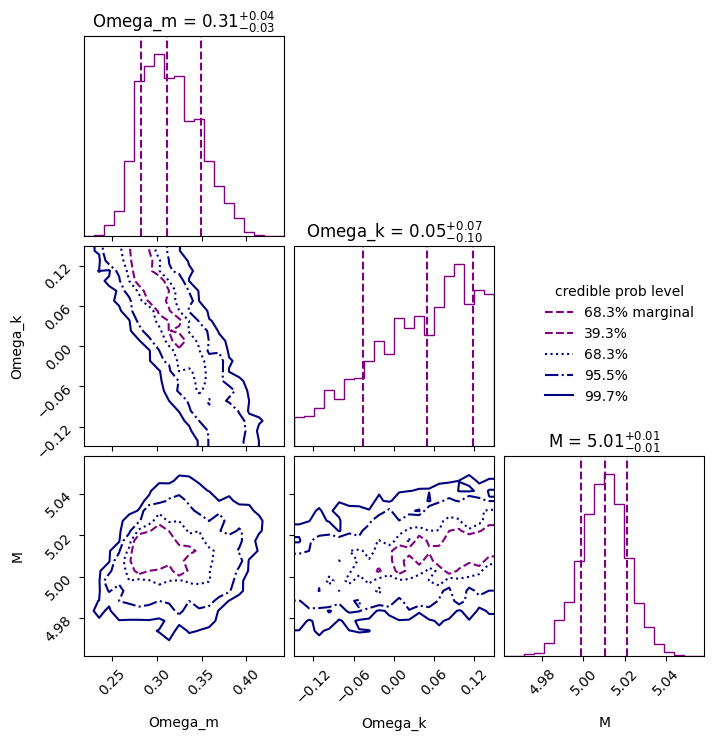

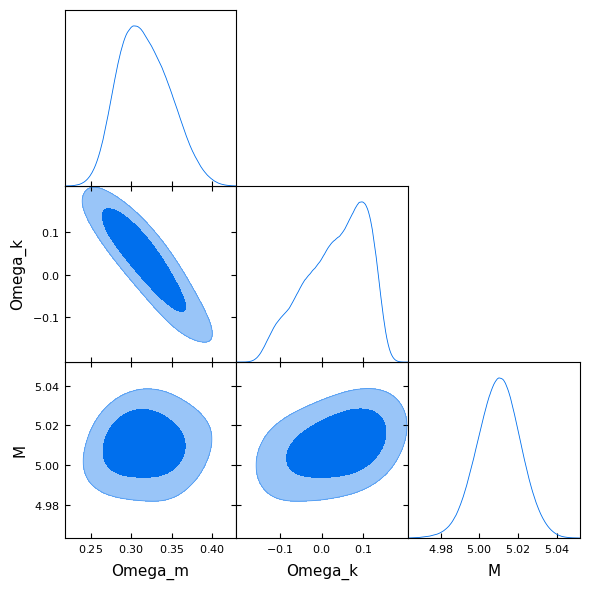

In [ ]:
with open(f'{fit_dir}/Open_LCDM_{prior}{"_marg" if marginalize_M else ""}_result.pkl', 'rb') as f:
    Open_LCDM_result = pickle.load(f)
cornerplot(Open_LCDM_result);
smooth_plot(Open_LCDM_result)

#### Flat wCDM

In [ ]:
# Needless to run again if the .pkl files exist in fit_dir
Flat_wCDM_result = fit_cosmology("Flat_LCDM", prior=prior, marginalized=marginalize_M)
with open(f'{fit_dir}/Flat_wCDM_{prior}{"_marg" if marginalize_M else ""}_result.pkl', 'wb') as f:
    pickle.dump(Flat_wCDM_result, f)

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(400.0)), (np.float64(inf), np.float64(400.0))]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-2265.73, Lmax=-820.12


DEBUG:ultranest:iteration=1, ncalls=402, regioncalls=80, ndraw=40, logz=-2271.72, remainder_fraction=100.0000%, Lmin=-2237.95, Lmax=-820.12


DEBUG:ultranest:iteration=2, ncalls=403, regioncalls=120, ndraw=40, logz=-2243.94, remainder_fraction=100.0000%, Lmin=-2207.27, Lmax=-820.12


DEBUG:ultranest:iteration=3, ncalls=404, regioncalls=160, ndraw=40, logz=-2213.26, remainder_fraction=100.0000%, Lmin=-2202.28, Lmax=-820.12


DEBUG:ultranest:iteration=4, ncalls=405, regioncalls=200, ndraw=40, logz=-2208.28, remainder_fraction=100.0000%, Lmin=-2150.92, Lmax=-820.12


DEBUG:ultranest:iteration=5, ncalls=406, regioncalls=240, ndraw=40, logz=-2156.92, remainder_fraction=100.0000%, Lmin=-2147.44, Lmax=-820.12


DEBUG:ultranest:iteration=6, ncalls=407, regioncalls=280, ndraw=40, logz=-2153.41, remainder_fraction=100.0000%, Lmin=-2133.32, Lmax=-820.12


DEBUG:ultranest:iteration=7, ncalls=408, regioncalls=320, ndraw=40, logz=-2139.32, remainder_fraction=100.0000%, Lmin=-2131.94, Lmax=-820.12


DEBUG:ultranest:iteration=8, ncalls=409, regioncalls=360, ndraw=40, logz=-2137.73, remainder_fraction=100.0000%, Lmin=-2114.60, Lmax=-820.12


DEBUG:ultranest:iteration=9, ncalls=410, regioncalls=400, ndraw=40, logz=-2120.61, remainder_fraction=100.0000%, Lmin=-2055.27, Lmax=-820.12


DEBUG:ultranest:iteration=10, ncalls=411, regioncalls=440, ndraw=40, logz=-2061.28, remainder_fraction=100.0000%, Lmin=-2031.13, Lmax=-820.12


DEBUG:ultranest:iteration=11, ncalls=412, regioncalls=480, ndraw=40, logz=-2037.15, remainder_fraction=100.0000%, Lmin=-2014.45, Lmax=-820.12


DEBUG:ultranest:iteration=12, ncalls=413, regioncalls=520, ndraw=40, logz=-2020.47, remainder_fraction=100.0000%, Lmin=-1999.40, Lmax=-820.12


DEBUG:ultranest:iteration=13, ncalls=414, regioncalls=560, ndraw=40, logz=-2005.42, remainder_fraction=100.0000%, Lmin=-1984.35, Lmax=-820.12


DEBUG:ultranest:iteration=14, ncalls=415, regioncalls=600, ndraw=40, logz=-1990.37, remainder_fraction=100.0000%, Lmin=-1980.63, Lmax=-820.12


DEBUG:ultranest:iteration=15, ncalls=416, regioncalls=640, ndraw=40, logz=-1986.64, remainder_fraction=100.0000%, Lmin=-1964.53, Lmax=-820.12


DEBUG:ultranest:iteration=16, ncalls=417, regioncalls=680, ndraw=40, logz=-1970.56, remainder_fraction=100.0000%, Lmin=-1956.50, Lmax=-820.12


DEBUG:ultranest:iteration=17, ncalls=418, regioncalls=720, ndraw=40, logz=-1962.53, remainder_fraction=100.0000%, Lmin=-1948.82, Lmax=-820.12


DEBUG:ultranest:iteration=18, ncalls=419, regioncalls=760, ndraw=40, logz=-1954.85, remainder_fraction=100.0000%, Lmin=-1927.78, Lmax=-820.12


DEBUG:ultranest:iteration=19, ncalls=420, regioncalls=800, ndraw=40, logz=-1933.82, remainder_fraction=100.0000%, Lmin=-1922.20, Lmax=-820.12


DEBUG:ultranest:iteration=20, ncalls=421, regioncalls=840, ndraw=40, logz=-1928.23, remainder_fraction=100.0000%, Lmin=-1906.19, Lmax=-820.12


DEBUG:ultranest:iteration=21, ncalls=422, regioncalls=880, ndraw=40, logz=-1912.23, remainder_fraction=100.0000%, Lmin=-1897.30, Lmax=-820.12


DEBUG:ultranest:iteration=22, ncalls=423, regioncalls=920, ndraw=40, logz=-1903.35, remainder_fraction=100.0000%, Lmin=-1885.03, Lmax=-820.12


DEBUG:ultranest:iteration=23, ncalls=424, regioncalls=960, ndraw=40, logz=-1891.08, remainder_fraction=100.0000%, Lmin=-1873.34, Lmax=-820.12


DEBUG:ultranest:iteration=24, ncalls=425, regioncalls=1000, ndraw=40, logz=-1879.39, remainder_fraction=100.0000%, Lmin=-1859.79, Lmax=-820.12


DEBUG:ultranest:iteration=25, ncalls=426, regioncalls=1040, ndraw=40, logz=-1865.85, remainder_fraction=100.0000%, Lmin=-1851.52, Lmax=-820.12


DEBUG:ultranest:iteration=26, ncalls=427, regioncalls=1080, ndraw=40, logz=-1857.57, remainder_fraction=100.0000%, Lmin=-1840.97, Lmax=-820.12


DEBUG:ultranest:iteration=27, ncalls=428, regioncalls=1120, ndraw=40, logz=-1847.03, remainder_fraction=100.0000%, Lmin=-1827.90, Lmax=-820.12


DEBUG:ultranest:iteration=28, ncalls=429, regioncalls=1160, ndraw=40, logz=-1833.96, remainder_fraction=100.0000%, Lmin=-1818.57, Lmax=-820.12


DEBUG:ultranest:iteration=29, ncalls=430, regioncalls=1200, ndraw=40, logz=-1824.63, remainder_fraction=100.0000%, Lmin=-1796.25, Lmax=-820.12


DEBUG:ultranest:iteration=30, ncalls=431, regioncalls=1240, ndraw=40, logz=-1802.32, remainder_fraction=100.0000%, Lmin=-1784.50, Lmax=-820.12


DEBUG:ultranest:iteration=31, ncalls=432, regioncalls=1280, ndraw=40, logz=-1790.56, remainder_fraction=100.0000%, Lmin=-1773.95, Lmax=-820.12


DEBUG:ultranest:iteration=32, ncalls=433, regioncalls=1320, ndraw=40, logz=-1780.02, remainder_fraction=100.0000%, Lmin=-1771.34, Lmax=-820.12


DEBUG:ultranest:iteration=33, ncalls=436, regioncalls=1440, ndraw=40, logz=-1777.34, remainder_fraction=100.0000%, Lmin=-1738.47, Lmax=-820.12


DEBUG:ultranest:iteration=34, ncalls=437, regioncalls=1480, ndraw=40, logz=-1744.54, remainder_fraction=100.0000%, Lmin=-1724.10, Lmax=-820.12


DEBUG:ultranest:iteration=35, ncalls=438, regioncalls=1520, ndraw=40, logz=-1730.18, remainder_fraction=100.0000%, Lmin=-1717.80, Lmax=-820.12


DEBUG:ultranest:iteration=36, ncalls=439, regioncalls=1560, ndraw=40, logz=-1723.88, remainder_fraction=100.0000%, Lmin=-1717.04, Lmax=-820.12


DEBUG:ultranest:iteration=37, ncalls=440, regioncalls=1600, ndraw=40, logz=-1722.74, remainder_fraction=100.0000%, Lmin=-1709.81, Lmax=-820.12


DEBUG:ultranest:iteration=38, ncalls=441, regioncalls=1640, ndraw=40, logz=-1715.89, remainder_fraction=100.0000%, Lmin=-1700.66, Lmax=-820.12


DEBUG:ultranest:iteration=39, ncalls=442, regioncalls=1680, ndraw=40, logz=-1706.74, remainder_fraction=100.0000%, Lmin=-1686.34, Lmax=-820.12


DEBUG:ultranest:iteration=40, ncalls=443, regioncalls=1720, ndraw=40, logz=-1692.43, remainder_fraction=100.0000%, Lmin=-1679.32, Lmax=-820.12


DEBUG:ultranest:iteration=41, ncalls=445, regioncalls=1800, ndraw=40, logz=-1685.42, remainder_fraction=100.0000%, Lmin=-1668.42, Lmax=-820.12


DEBUG:ultranest:iteration=42, ncalls=446, regioncalls=1840, ndraw=40, logz=-1674.52, remainder_fraction=100.0000%, Lmin=-1662.57, Lmax=-820.12


DEBUG:ultranest:iteration=43, ncalls=447, regioncalls=1880, ndraw=40, logz=-1668.66, remainder_fraction=100.0000%, Lmin=-1647.41, Lmax=-820.12


DEBUG:ultranest:iteration=44, ncalls=448, regioncalls=1920, ndraw=40, logz=-1653.51, remainder_fraction=100.0000%, Lmin=-1646.80, Lmax=-820.12


DEBUG:ultranest:iteration=45, ncalls=450, regioncalls=2000, ndraw=40, logz=-1652.46, remainder_fraction=100.0000%, Lmin=-1641.59, Lmax=-820.12


DEBUG:ultranest:iteration=46, ncalls=451, regioncalls=2040, ndraw=40, logz=-1647.68, remainder_fraction=100.0000%, Lmin=-1609.60, Lmax=-820.12


DEBUG:ultranest:iteration=47, ncalls=453, regioncalls=2120, ndraw=40, logz=-1615.71, remainder_fraction=100.0000%, Lmin=-1605.43, Lmax=-820.12


DEBUG:ultranest:iteration=48, ncalls=456, regioncalls=2240, ndraw=40, logz=-1611.52, remainder_fraction=100.0000%, Lmin=-1600.21, Lmax=-820.12


DEBUG:ultranest:iteration=49, ncalls=457, regioncalls=2280, ndraw=40, logz=-1606.32, remainder_fraction=100.0000%, Lmin=-1597.00, Lmax=-820.12


DEBUG:ultranest:iteration=50, ncalls=458, regioncalls=2320, ndraw=40, logz=-1603.08, remainder_fraction=100.0000%, Lmin=-1593.08, Lmax=-820.12


DEBUG:ultranest:iteration=51, ncalls=459, regioncalls=2360, ndraw=40, logz=-1599.18, remainder_fraction=100.0000%, Lmin=-1585.92, Lmax=-820.12


DEBUG:ultranest:iteration=52, ncalls=460, regioncalls=2400, ndraw=40, logz=-1592.04, remainder_fraction=100.0000%, Lmin=-1584.69, Lmax=-820.12


DEBUG:ultranest:iteration=53, ncalls=461, regioncalls=2440, ndraw=40, logz=-1590.55, remainder_fraction=100.0000%, Lmin=-1579.87, Lmax=-820.12


DEBUG:ultranest:iteration=54, ncalls=463, regioncalls=2520, ndraw=40, logz=-1585.99, remainder_fraction=100.0000%, Lmin=-1573.91, Lmax=-820.12


DEBUG:ultranest:iteration=55, ncalls=464, regioncalls=2560, ndraw=40, logz=-1580.04, remainder_fraction=100.0000%, Lmin=-1569.18, Lmax=-820.12


DEBUG:ultranest:iteration=56, ncalls=465, regioncalls=2600, ndraw=40, logz=-1575.30, remainder_fraction=100.0000%, Lmin=-1564.33, Lmax=-820.12


DEBUG:ultranest:iteration=57, ncalls=466, regioncalls=2640, ndraw=40, logz=-1570.45, remainder_fraction=100.0000%, Lmin=-1561.48, Lmax=-820.12


DEBUG:ultranest:iteration=58, ncalls=467, regioncalls=2680, ndraw=40, logz=-1567.56, remainder_fraction=100.0000%, Lmin=-1554.64, Lmax=-820.12


DEBUG:ultranest:iteration=59, ncalls=468, regioncalls=2720, ndraw=40, logz=-1560.78, remainder_fraction=100.0000%, Lmin=-1546.72, Lmax=-820.12


DEBUG:ultranest:iteration=60, ncalls=469, regioncalls=2760, ndraw=40, logz=-1552.86, remainder_fraction=100.0000%, Lmin=-1533.99, Lmax=-820.12


DEBUG:ultranest:iteration=61, ncalls=471, regioncalls=2840, ndraw=40, logz=-1540.13, remainder_fraction=100.0000%, Lmin=-1520.74, Lmax=-820.12


DEBUG:ultranest:iteration=62, ncalls=472, regioncalls=2880, ndraw=40, logz=-1526.88, remainder_fraction=100.0000%, Lmin=-1519.59, Lmax=-820.12


DEBUG:ultranest:iteration=63, ncalls=473, regioncalls=2920, ndraw=40, logz=-1525.46, remainder_fraction=100.0000%, Lmin=-1519.20, Lmax=-820.12


DEBUG:ultranest:iteration=64, ncalls=474, regioncalls=2960, ndraw=40, logz=-1524.71, remainder_fraction=100.0000%, Lmin=-1518.94, Lmax=-820.12


DEBUG:ultranest:iteration=65, ncalls=475, regioncalls=3000, ndraw=40, logz=-1524.19, remainder_fraction=100.0000%, Lmin=-1518.87, Lmax=-820.12


DEBUG:ultranest:iteration=66, ncalls=476, regioncalls=3040, ndraw=40, logz=-1523.83, remainder_fraction=100.0000%, Lmin=-1516.83, Lmax=-820.12


DEBUG:ultranest:iteration=67, ncalls=477, regioncalls=3080, ndraw=40, logz=-1522.63, remainder_fraction=100.0000%, Lmin=-1508.40, Lmax=-820.12


DEBUG:ultranest:iteration=68, ncalls=478, regioncalls=3120, ndraw=40, logz=-1514.56, remainder_fraction=100.0000%, Lmin=-1488.25, Lmax=-820.12


DEBUG:ultranest:iteration=69, ncalls=479, regioncalls=3160, ndraw=40, logz=-1494.41, remainder_fraction=100.0000%, Lmin=-1487.25, Lmax=-820.12


DEBUG:ultranest:iteration=70, ncalls=481, regioncalls=3240, ndraw=40, logz=-1493.10, remainder_fraction=100.0000%, Lmin=-1486.15, Lmax=-820.12


DEBUG:ultranest:iteration=71, ncalls=482, regioncalls=3280, ndraw=40, logz=-1491.94, remainder_fraction=100.0000%, Lmin=-1475.96, Lmax=-820.12


DEBUG:ultranest:iteration=72, ncalls=483, regioncalls=3320, ndraw=40, logz=-1482.13, remainder_fraction=100.0000%, Lmin=-1469.66, Lmax=-820.12


DEBUG:ultranest:iteration=73, ncalls=484, regioncalls=3360, ndraw=40, logz=-1475.83, remainder_fraction=100.0000%, Lmin=-1466.86, Lmax=-820.12


DEBUG:ultranest:iteration=74, ncalls=486, regioncalls=3440, ndraw=40, logz=-1472.98, remainder_fraction=100.0000%, Lmin=-1451.77, Lmax=-820.12


DEBUG:ultranest:iteration=75, ncalls=487, regioncalls=3480, ndraw=40, logz=-1457.95, remainder_fraction=100.0000%, Lmin=-1447.94, Lmax=-820.12


DEBUG:ultranest:iteration=76, ncalls=488, regioncalls=3520, ndraw=40, logz=-1454.10, remainder_fraction=100.0000%, Lmin=-1444.39, Lmax=-820.12


DEBUG:ultranest:iteration=77, ncalls=489, regioncalls=3560, ndraw=40, logz=-1450.54, remainder_fraction=100.0000%, Lmin=-1431.51, Lmax=-820.12


DEBUG:ultranest:iteration=78, ncalls=490, regioncalls=3600, ndraw=40, logz=-1437.69, remainder_fraction=100.0000%, Lmin=-1429.61, Lmax=-820.12


DEBUG:ultranest:iteration=79, ncalls=492, regioncalls=3680, ndraw=40, logz=-1435.66, remainder_fraction=100.0000%, Lmin=-1422.17, Lmax=-820.12


DEBUG:ultranest:iteration=80, ncalls=493, regioncalls=3720, ndraw=40, logz=-1428.36, remainder_fraction=100.0000%, Lmin=-1410.85, Lmax=-820.12


DEBUG:ultranest:iteration=81, ncalls=494, regioncalls=3760, ndraw=40, logz=-1417.05, remainder_fraction=100.0000%, Lmin=-1409.49, Lmax=-820.12


DEBUG:ultranest:iteration=82, ncalls=495, regioncalls=3800, ndraw=40, logz=-1415.46, remainder_fraction=100.0000%, Lmin=-1409.42, Lmax=-820.12


DEBUG:ultranest:iteration=83, ncalls=497, regioncalls=3880, ndraw=40, logz=-1414.84, remainder_fraction=100.0000%, Lmin=-1408.55, Lmax=-820.12


DEBUG:ultranest:iteration=84, ncalls=498, regioncalls=3920, ndraw=40, logz=-1414.10, remainder_fraction=100.0000%, Lmin=-1403.10, Lmax=-820.12


DEBUG:ultranest:iteration=85, ncalls=499, regioncalls=3960, ndraw=40, logz=-1409.29, remainder_fraction=100.0000%, Lmin=-1401.34, Lmax=-820.12


DEBUG:ultranest:iteration=86, ncalls=500, regioncalls=4000, ndraw=40, logz=-1407.38, remainder_fraction=100.0000%, Lmin=-1395.68, Lmax=-820.12


DEBUG:ultranest:iteration=87, ncalls=502, regioncalls=4080, ndraw=40, logz=-1401.88, remainder_fraction=100.0000%, Lmin=-1392.48, Lmax=-820.12


DEBUG:ultranest:iteration=88, ncalls=503, regioncalls=4120, ndraw=40, logz=-1398.65, remainder_fraction=100.0000%, Lmin=-1389.18, Lmax=-820.12


DEBUG:ultranest:iteration=89, ncalls=504, regioncalls=4160, ndraw=40, logz=-1395.36, remainder_fraction=100.0000%, Lmin=-1377.68, Lmax=-820.00


DEBUG:ultranest:iteration=90, ncalls=505, regioncalls=4200, ndraw=40, logz=-1383.90, remainder_fraction=100.0000%, Lmin=-1374.27, Lmax=-820.00


DEBUG:ultranest:iteration=91, ncalls=506, regioncalls=4240, ndraw=40, logz=-1380.45, remainder_fraction=100.0000%, Lmin=-1368.18, Lmax=-820.00


DEBUG:ultranest:iteration=92, ncalls=508, regioncalls=4320, ndraw=40, logz=-1374.40, remainder_fraction=100.0000%, Lmin=-1361.04, Lmax=-820.00


DEBUG:ultranest:iteration=93, ncalls=509, regioncalls=4360, ndraw=40, logz=-1367.26, remainder_fraction=100.0000%, Lmin=-1360.57, Lmax=-820.00


DEBUG:ultranest:iteration=94, ncalls=510, regioncalls=4400, ndraw=40, logz=-1366.31, remainder_fraction=100.0000%, Lmin=-1360.48, Lmax=-820.00


DEBUG:ultranest:iteration=95, ncalls=511, regioncalls=4440, ndraw=40, logz=-1365.80, remainder_fraction=100.0000%, Lmin=-1359.72, Lmax=-820.00


DEBUG:ultranest:iteration=96, ncalls=512, regioncalls=4480, ndraw=40, logz=-1365.18, remainder_fraction=100.0000%, Lmin=-1353.61, Lmax=-820.00


DEBUG:ultranest:iteration=97, ncalls=514, regioncalls=4560, ndraw=40, logz=-1359.84, remainder_fraction=100.0000%, Lmin=-1353.39, Lmax=-820.00


DEBUG:ultranest:iteration=98, ncalls=515, regioncalls=4600, ndraw=40, logz=-1359.03, remainder_fraction=100.0000%, Lmin=-1343.48, Lmax=-820.00


DEBUG:ultranest:iteration=99, ncalls=516, regioncalls=4640, ndraw=40, logz=-1349.72, remainder_fraction=100.0000%, Lmin=-1341.04, Lmax=-820.00


DEBUG:ultranest:iteration=100, ncalls=517, regioncalls=4680, ndraw=40, logz=-1347.20, remainder_fraction=100.0000%, Lmin=-1339.46, Lmax=-820.00


DEBUG:ultranest:iteration=101, ncalls=518, regioncalls=4720, ndraw=40, logz=-1345.50, remainder_fraction=100.0000%, Lmin=-1334.76, Lmax=-820.00


DEBUG:ultranest:iteration=102, ncalls=520, regioncalls=4800, ndraw=40, logz=-1340.99, remainder_fraction=100.0000%, Lmin=-1331.51, Lmax=-820.00


DEBUG:ultranest:iteration=103, ncalls=521, regioncalls=4840, ndraw=40, logz=-1337.72, remainder_fraction=100.0000%, Lmin=-1330.32, Lmax=-820.00


DEBUG:ultranest:iteration=104, ncalls=523, regioncalls=4920, ndraw=40, logz=-1336.29, remainder_fraction=100.0000%, Lmin=-1328.42, Lmax=-820.00


DEBUG:ultranest:iteration=105, ncalls=524, regioncalls=4960, ndraw=40, logz=-1334.50, remainder_fraction=100.0000%, Lmin=-1325.38, Lmax=-820.00


DEBUG:ultranest:iteration=106, ncalls=525, regioncalls=5000, ndraw=40, logz=-1331.58, remainder_fraction=100.0000%, Lmin=-1324.82, Lmax=-820.00


DEBUG:ultranest:iteration=107, ncalls=526, regioncalls=5040, ndraw=40, logz=-1330.61, remainder_fraction=100.0000%, Lmin=-1321.28, Lmax=-820.00


DEBUG:ultranest:iteration=108, ncalls=527, regioncalls=5080, ndraw=40, logz=-1327.49, remainder_fraction=100.0000%, Lmin=-1317.21, Lmax=-820.00


DEBUG:ultranest:iteration=109, ncalls=529, regioncalls=5160, ndraw=40, logz=-1323.46, remainder_fraction=100.0000%, Lmin=-1316.56, Lmax=-820.00


DEBUG:ultranest:iteration=110, ncalls=530, regioncalls=5200, ndraw=40, logz=-1322.40, remainder_fraction=100.0000%, Lmin=-1311.59, Lmax=-820.00


DEBUG:ultranest:iteration=111, ncalls=531, regioncalls=5240, ndraw=40, logz=-1317.85, remainder_fraction=100.0000%, Lmin=-1308.88, Lmax=-820.00


DEBUG:ultranest:iteration=112, ncalls=532, regioncalls=5280, ndraw=40, logz=-1315.08, remainder_fraction=100.0000%, Lmin=-1301.36, Lmax=-820.00


DEBUG:ultranest:iteration=113, ncalls=533, regioncalls=5320, ndraw=40, logz=-1307.63, remainder_fraction=100.0000%, Lmin=-1300.62, Lmax=-820.00


DEBUG:ultranest:iteration=114, ncalls=534, regioncalls=5360, ndraw=40, logz=-1306.51, remainder_fraction=100.0000%, Lmin=-1299.24, Lmax=-820.00


DEBUG:ultranest:iteration=115, ncalls=537, regioncalls=5480, ndraw=40, logz=-1305.20, remainder_fraction=100.0000%, Lmin=-1298.51, Lmax=-820.00


DEBUG:ultranest:iteration=116, ncalls=538, regioncalls=5520, ndraw=40, logz=-1304.28, remainder_fraction=100.0000%, Lmin=-1296.17, Lmax=-820.00


DEBUG:ultranest:iteration=117, ncalls=539, regioncalls=5560, ndraw=40, logz=-1302.31, remainder_fraction=100.0000%, Lmin=-1293.16, Lmax=-820.00


DEBUG:ultranest:iteration=118, ncalls=541, regioncalls=5640, ndraw=40, logz=-1299.39, remainder_fraction=100.0000%, Lmin=-1287.85, Lmax=-820.00


DEBUG:ultranest:iteration=119, ncalls=542, regioncalls=5680, ndraw=40, logz=-1294.14, remainder_fraction=100.0000%, Lmin=-1280.06, Lmax=-820.00


DEBUG:ultranest:iteration=120, ncalls=545, regioncalls=5800, ndraw=40, logz=-1286.35, remainder_fraction=100.0000%, Lmin=-1275.48, Lmax=-820.00


DEBUG:ultranest:iteration=121, ncalls=546, regioncalls=5840, ndraw=40, logz=-1281.77, remainder_fraction=100.0000%, Lmin=-1274.24, Lmax=-820.00


DEBUG:ultranest:iteration=122, ncalls=547, regioncalls=5880, ndraw=40, logz=-1280.28, remainder_fraction=100.0000%, Lmin=-1270.94, Lmax=-820.00


DEBUG:ultranest:iteration=123, ncalls=548, regioncalls=5920, ndraw=40, logz=-1277.19, remainder_fraction=100.0000%, Lmin=-1270.01, Lmax=-820.00


DEBUG:ultranest:iteration=124, ncalls=549, regioncalls=5960, ndraw=40, logz=-1275.96, remainder_fraction=100.0000%, Lmin=-1258.32, Lmax=-820.00


DEBUG:ultranest:iteration=125, ncalls=550, regioncalls=6000, ndraw=40, logz=-1264.62, remainder_fraction=100.0000%, Lmin=-1258.01, Lmax=-820.00


DEBUG:ultranest:iteration=126, ncalls=551, regioncalls=6040, ndraw=40, logz=-1263.76, remainder_fraction=100.0000%, Lmin=-1256.37, Lmax=-820.00


DEBUG:ultranest:iteration=127, ncalls=552, regioncalls=6080, ndraw=40, logz=-1262.39, remainder_fraction=100.0000%, Lmin=-1253.54, Lmax=-820.00


DEBUG:ultranest:iteration=128, ncalls=553, regioncalls=6120, ndraw=40, logz=-1259.78, remainder_fraction=100.0000%, Lmin=-1250.81, Lmax=-820.00


DEBUG:ultranest:iteration=129, ncalls=554, regioncalls=6160, ndraw=40, logz=-1257.05, remainder_fraction=100.0000%, Lmin=-1246.38, Lmax=-820.00


DEBUG:ultranest:iteration=130, ncalls=555, regioncalls=6200, ndraw=40, logz=-1252.69, remainder_fraction=100.0000%, Lmin=-1238.94, Lmax=-820.00


DEBUG:ultranest:iteration=131, ncalls=556, regioncalls=6240, ndraw=40, logz=-1245.26, remainder_fraction=100.0000%, Lmin=-1236.61, Lmax=-820.00


DEBUG:ultranest:iteration=132, ncalls=557, regioncalls=6280, ndraw=40, logz=-1242.84, remainder_fraction=100.0000%, Lmin=-1235.47, Lmax=-820.00


DEBUG:ultranest:iteration=133, ncalls=558, regioncalls=6320, ndraw=40, logz=-1241.49, remainder_fraction=100.0000%, Lmin=-1228.46, Lmax=-820.00


DEBUG:ultranest:iteration=134, ncalls=559, regioncalls=6360, ndraw=40, logz=-1234.78, remainder_fraction=100.0000%, Lmin=-1227.70, Lmax=-820.00


DEBUG:ultranest:iteration=135, ncalls=560, regioncalls=6400, ndraw=40, logz=-1233.64, remainder_fraction=100.0000%, Lmin=-1227.20, Lmax=-820.00


DEBUG:ultranest:iteration=136, ncalls=561, regioncalls=6440, ndraw=40, logz=-1232.89, remainder_fraction=100.0000%, Lmin=-1225.95, Lmax=-820.00


DEBUG:ultranest:iteration=137, ncalls=562, regioncalls=6480, ndraw=40, logz=-1231.85, remainder_fraction=100.0000%, Lmin=-1218.74, Lmax=-820.00


DEBUG:ultranest:iteration=138, ncalls=563, regioncalls=6520, ndraw=40, logz=-1225.07, remainder_fraction=100.0000%, Lmin=-1209.20, Lmax=-820.00


DEBUG:ultranest:iteration=139, ncalls=564, regioncalls=6560, ndraw=40, logz=-1215.54, remainder_fraction=100.0000%, Lmin=-1207.87, Lmax=-820.00


DEBUG:ultranest:iteration=140, ncalls=565, regioncalls=6600, ndraw=40, logz=-1213.98, remainder_fraction=100.0000%, Lmin=-1207.33, Lmax=-820.00


DEBUG:ultranest:iteration=141, ncalls=567, regioncalls=6680, ndraw=40, logz=-1213.12, remainder_fraction=100.0000%, Lmin=-1202.94, Lmax=-820.00


DEBUG:ultranest:iteration=142, ncalls=568, regioncalls=6720, ndraw=40, logz=-1209.27, remainder_fraction=100.0000%, Lmin=-1202.75, Lmax=-820.00


DEBUG:ultranest:iteration=143, ncalls=569, regioncalls=6760, ndraw=40, logz=-1208.48, remainder_fraction=100.0000%, Lmin=-1202.04, Lmax=-820.00


DEBUG:ultranest:iteration=144, ncalls=570, regioncalls=6800, ndraw=40, logz=-1207.75, remainder_fraction=100.0000%, Lmin=-1199.56, Lmax=-820.00


DEBUG:ultranest:iteration=145, ncalls=571, regioncalls=6840, ndraw=40, logz=-1205.76, remainder_fraction=100.0000%, Lmin=-1195.47, Lmax=-820.00


DEBUG:ultranest:iteration=146, ncalls=572, regioncalls=6880, ndraw=40, logz=-1201.81, remainder_fraction=100.0000%, Lmin=-1193.10, Lmax=-820.00


DEBUG:ultranest:iteration=147, ncalls=573, regioncalls=6920, ndraw=40, logz=-1199.37, remainder_fraction=100.0000%, Lmin=-1192.58, Lmax=-820.00


DEBUG:ultranest:iteration=148, ncalls=575, regioncalls=7000, ndraw=40, logz=-1198.44, remainder_fraction=100.0000%, Lmin=-1191.50, Lmax=-820.00


DEBUG:ultranest:iteration=149, ncalls=576, regioncalls=7040, ndraw=40, logz=-1197.42, remainder_fraction=100.0000%, Lmin=-1187.33, Lmax=-820.00


DEBUG:ultranest:iteration=150, ncalls=577, regioncalls=7080, ndraw=40, logz=-1193.67, remainder_fraction=100.0000%, Lmin=-1184.05, Lmax=-820.00


DEBUG:ultranest:iteration=151, ncalls=578, regioncalls=7120, ndraw=40, logz=-1190.38, remainder_fraction=100.0000%, Lmin=-1182.48, Lmax=-820.00


DEBUG:ultranest:iteration=152, ncalls=580, regioncalls=7200, ndraw=40, logz=-1188.65, remainder_fraction=100.0000%, Lmin=-1179.99, Lmax=-820.00


DEBUG:ultranest:iteration=153, ncalls=581, regioncalls=7240, ndraw=40, logz=-1186.27, remainder_fraction=100.0000%, Lmin=-1179.19, Lmax=-820.00


DEBUG:ultranest:iteration=154, ncalls=582, regioncalls=7280, ndraw=40, logz=-1185.16, remainder_fraction=100.0000%, Lmin=-1173.92, Lmax=-820.00


DEBUG:ultranest:iteration=155, ncalls=583, regioncalls=7320, ndraw=40, logz=-1180.29, remainder_fraction=100.0000%, Lmin=-1172.40, Lmax=-820.00


DEBUG:ultranest:iteration=156, ncalls=584, regioncalls=7360, ndraw=40, logz=-1178.58, remainder_fraction=100.0000%, Lmin=-1171.38, Lmax=-820.00


DEBUG:ultranest:iteration=157, ncalls=585, regioncalls=7400, ndraw=40, logz=-1177.40, remainder_fraction=100.0000%, Lmin=-1171.11, Lmax=-820.00


DEBUG:ultranest:iteration=158, ncalls=586, regioncalls=7440, ndraw=40, logz=-1176.75, remainder_fraction=100.0000%, Lmin=-1165.79, Lmax=-820.00


DEBUG:ultranest:iteration=159, ncalls=587, regioncalls=7480, ndraw=40, logz=-1172.17, remainder_fraction=100.0000%, Lmin=-1163.84, Lmax=-820.00


DEBUG:ultranest:iteration=160, ncalls=588, regioncalls=7520, ndraw=40, logz=-1170.10, remainder_fraction=100.0000%, Lmin=-1162.22, Lmax=-820.00


DEBUG:ultranest:iteration=161, ncalls=589, regioncalls=7560, ndraw=40, logz=-1168.41, remainder_fraction=100.0000%, Lmin=-1158.82, Lmax=-820.00


DEBUG:ultranest:iteration=162, ncalls=590, regioncalls=7600, ndraw=40, logz=-1165.17, remainder_fraction=100.0000%, Lmin=-1158.80, Lmax=-820.00


DEBUG:ultranest:iteration=163, ncalls=591, regioncalls=7640, ndraw=40, logz=-1164.49, remainder_fraction=100.0000%, Lmin=-1157.81, Lmax=-820.00


DEBUG:ultranest:iteration=164, ncalls=592, regioncalls=7680, ndraw=40, logz=-1163.65, remainder_fraction=100.0000%, Lmin=-1151.00, Lmax=-820.00


DEBUG:ultranest:iteration=165, ncalls=593, regioncalls=7720, ndraw=40, logz=-1157.40, remainder_fraction=100.0000%, Lmin=-1148.61, Lmax=-820.00


DEBUG:ultranest:iteration=166, ncalls=594, regioncalls=7760, ndraw=40, logz=-1154.93, remainder_fraction=100.0000%, Lmin=-1147.52, Lmax=-820.00


DEBUG:ultranest:iteration=167, ncalls=595, regioncalls=7800, ndraw=40, logz=-1153.61, remainder_fraction=100.0000%, Lmin=-1141.70, Lmax=-820.00


DEBUG:ultranest:iteration=168, ncalls=596, regioncalls=7840, ndraw=40, logz=-1148.10, remainder_fraction=100.0000%, Lmin=-1140.44, Lmax=-820.00


DEBUG:ultranest:iteration=169, ncalls=597, regioncalls=7880, ndraw=40, logz=-1146.60, remainder_fraction=100.0000%, Lmin=-1139.86, Lmax=-820.00


DEBUG:ultranest:iteration=170, ncalls=598, regioncalls=7920, ndraw=40, logz=-1145.73, remainder_fraction=100.0000%, Lmin=-1137.80, Lmax=-820.00


DEBUG:ultranest:iteration=171, ncalls=600, regioncalls=8000, ndraw=40, logz=-1144.02, remainder_fraction=100.0000%, Lmin=-1137.74, Lmax=-820.00


DEBUG:ultranest:iteration=172, ncalls=601, regioncalls=8040, ndraw=40, logz=-1143.39, remainder_fraction=100.0000%, Lmin=-1137.56, Lmax=-820.00


DEBUG:ultranest:iteration=173, ncalls=602, regioncalls=8080, ndraw=40, logz=-1142.95, remainder_fraction=100.0000%, Lmin=-1134.21, Lmax=-820.00


DEBUG:ultranest:iteration=174, ncalls=603, regioncalls=8120, ndraw=40, logz=-1140.54, remainder_fraction=100.0000%, Lmin=-1128.69, Lmax=-820.00


DEBUG:ultranest:iteration=175, ncalls=604, regioncalls=8160, ndraw=40, logz=-1135.12, remainder_fraction=100.0000%, Lmin=-1128.57, Lmax=-820.00


DEBUG:ultranest:iteration=176, ncalls=605, regioncalls=8200, ndraw=40, logz=-1134.36, remainder_fraction=100.0000%, Lmin=-1127.39, Lmax=-820.00


DEBUG:ultranest:iteration=177, ncalls=606, regioncalls=8240, ndraw=40, logz=-1133.36, remainder_fraction=100.0000%, Lmin=-1125.58, Lmax=-820.00


DEBUG:ultranest:iteration=178, ncalls=607, regioncalls=8280, ndraw=40, logz=-1131.78, remainder_fraction=100.0000%, Lmin=-1124.31, Lmax=-820.00


DEBUG:ultranest:iteration=179, ncalls=608, regioncalls=8320, ndraw=40, logz=-1130.44, remainder_fraction=100.0000%, Lmin=-1124.00, Lmax=-820.00


DEBUG:ultranest:iteration=180, ncalls=609, regioncalls=8360, ndraw=40, logz=-1129.75, remainder_fraction=100.0000%, Lmin=-1123.96, Lmax=-820.00


DEBUG:ultranest:iteration=181, ncalls=610, regioncalls=8400, ndraw=40, logz=-1129.33, remainder_fraction=100.0000%, Lmin=-1123.86, Lmax=-820.00


DEBUG:ultranest:iteration=182, ncalls=611, regioncalls=8440, ndraw=40, logz=-1129.01, remainder_fraction=100.0000%, Lmin=-1120.79, Lmax=-820.00


DEBUG:ultranest:iteration=183, ncalls=612, regioncalls=8480, ndraw=40, logz=-1127.08, remainder_fraction=100.0000%, Lmin=-1119.53, Lmax=-820.00


DEBUG:ultranest:iteration=184, ncalls=615, regioncalls=8600, ndraw=40, logz=-1125.69, remainder_fraction=100.0000%, Lmin=-1118.22, Lmax=-820.00


DEBUG:ultranest:iteration=185, ncalls=616, regioncalls=8640, ndraw=40, logz=-1124.37, remainder_fraction=100.0000%, Lmin=-1117.40, Lmax=-820.00


DEBUG:ultranest:iteration=186, ncalls=617, regioncalls=8680, ndraw=40, logz=-1123.38, remainder_fraction=100.0000%, Lmin=-1115.79, Lmax=-820.00


DEBUG:ultranest:iteration=187, ncalls=618, regioncalls=8720, ndraw=40, logz=-1121.97, remainder_fraction=100.0000%, Lmin=-1110.59, Lmax=-820.00


DEBUG:ultranest:iteration=188, ncalls=619, regioncalls=8760, ndraw=40, logz=-1117.05, remainder_fraction=100.0000%, Lmin=-1109.23, Lmax=-820.00


DEBUG:ultranest:iteration=189, ncalls=620, regioncalls=8800, ndraw=40, logz=-1115.46, remainder_fraction=100.0000%, Lmin=-1108.89, Lmax=-820.00


DEBUG:ultranest:iteration=190, ncalls=621, regioncalls=8840, ndraw=40, logz=-1114.71, remainder_fraction=100.0000%, Lmin=-1105.99, Lmax=-820.00


DEBUG:ultranest:iteration=191, ncalls=622, regioncalls=8880, ndraw=40, logz=-1112.36, remainder_fraction=100.0000%, Lmin=-1105.39, Lmax=-820.00


DEBUG:ultranest:iteration=192, ncalls=623, regioncalls=8920, ndraw=40, logz=-1111.39, remainder_fraction=100.0000%, Lmin=-1103.40, Lmax=-820.00


DEBUG:ultranest:iteration=193, ncalls=624, regioncalls=8960, ndraw=40, logz=-1109.67, remainder_fraction=100.0000%, Lmin=-1101.90, Lmax=-820.00


DEBUG:ultranest:iteration=194, ncalls=625, regioncalls=9000, ndraw=40, logz=-1108.13, remainder_fraction=100.0000%, Lmin=-1097.36, Lmax=-820.00


DEBUG:ultranest:iteration=195, ncalls=626, regioncalls=9040, ndraw=40, logz=-1103.82, remainder_fraction=100.0000%, Lmin=-1096.96, Lmax=-820.00


DEBUG:ultranest:iteration=196, ncalls=628, regioncalls=9120, ndraw=40, logz=-1102.92, remainder_fraction=100.0000%, Lmin=-1092.07, Lmax=-820.00


DEBUG:ultranest:iteration=197, ncalls=630, regioncalls=9200, ndraw=40, logz=-1098.54, remainder_fraction=100.0000%, Lmin=-1091.63, Lmax=-820.00


DEBUG:ultranest:iteration=198, ncalls=631, regioncalls=9240, ndraw=40, logz=-1097.62, remainder_fraction=100.0000%, Lmin=-1089.16, Lmax=-820.00


DEBUG:ultranest:iteration=199, ncalls=632, regioncalls=9280, ndraw=40, logz=-1095.52, remainder_fraction=100.0000%, Lmin=-1086.80, Lmax=-820.00


DEBUG:ultranest:iteration=200, ncalls=633, regioncalls=9320, ndraw=40, logz=-1093.19, remainder_fraction=100.0000%, Lmin=-1086.39, Lmax=-820.00


DEBUG:ultranest:iteration=201, ncalls=634, regioncalls=9360, ndraw=40, logz=-1092.33, remainder_fraction=100.0000%, Lmin=-1083.30, Lmax=-820.00


DEBUG:ultranest:iteration=202, ncalls=635, regioncalls=9400, ndraw=40, logz=-1089.71, remainder_fraction=100.0000%, Lmin=-1082.69, Lmax=-820.00


DEBUG:ultranest:iteration=203, ncalls=637, regioncalls=9480, ndraw=40, logz=-1088.72, remainder_fraction=100.0000%, Lmin=-1081.97, Lmax=-820.00


DEBUG:ultranest:iteration=204, ncalls=640, regioncalls=9600, ndraw=40, logz=-1087.90, remainder_fraction=100.0000%, Lmin=-1080.11, Lmax=-820.00


DEBUG:ultranest:iteration=205, ncalls=641, regioncalls=9640, ndraw=40, logz=-1086.37, remainder_fraction=100.0000%, Lmin=-1079.28, Lmax=-820.00


DEBUG:ultranest:iteration=206, ncalls=642, regioncalls=9680, ndraw=40, logz=-1085.34, remainder_fraction=100.0000%, Lmin=-1076.38, Lmax=-820.00


DEBUG:ultranest:iteration=207, ncalls=643, regioncalls=9720, ndraw=40, logz=-1082.80, remainder_fraction=100.0000%, Lmin=-1074.10, Lmax=-820.00


DEBUG:ultranest:iteration=208, ncalls=644, regioncalls=9760, ndraw=40, logz=-1080.50, remainder_fraction=100.0000%, Lmin=-1069.04, Lmax=-820.00


DEBUG:ultranest:iteration=209, ncalls=645, regioncalls=9800, ndraw=40, logz=-1075.55, remainder_fraction=100.0000%, Lmin=-1062.58, Lmax=-820.00


DEBUG:ultranest:iteration=210, ncalls=646, regioncalls=9840, ndraw=40, logz=-1069.09, remainder_fraction=100.0000%, Lmin=-1062.53, Lmax=-820.00


DEBUG:ultranest:iteration=211, ncalls=647, regioncalls=9880, ndraw=40, logz=-1068.38, remainder_fraction=100.0000%, Lmin=-1061.37, Lmax=-820.00


DEBUG:ultranest:iteration=212, ncalls=648, regioncalls=9920, ndraw=40, logz=-1067.41, remainder_fraction=100.0000%, Lmin=-1061.03, Lmax=-820.00


DEBUG:ultranest:iteration=213, ncalls=651, regioncalls=10040, ndraw=40, logz=-1066.79, remainder_fraction=100.0000%, Lmin=-1060.65, Lmax=-820.00


DEBUG:ultranest:iteration=214, ncalls=653, regioncalls=10120, ndraw=40, logz=-1066.27, remainder_fraction=100.0000%, Lmin=-1060.15, Lmax=-820.00


DEBUG:ultranest:iteration=215, ncalls=654, regioncalls=10160, ndraw=40, logz=-1065.76, remainder_fraction=100.0000%, Lmin=-1058.84, Lmax=-820.00


DEBUG:ultranest:iteration=216, ncalls=655, regioncalls=10200, ndraw=40, logz=-1064.85, remainder_fraction=100.0000%, Lmin=-1058.80, Lmax=-820.00


DEBUG:ultranest:iteration=217, ncalls=657, regioncalls=10280, ndraw=40, logz=-1064.37, remainder_fraction=100.0000%, Lmin=-1054.47, Lmax=-820.00


DEBUG:ultranest:iteration=218, ncalls=658, regioncalls=10320, ndraw=40, logz=-1060.97, remainder_fraction=100.0000%, Lmin=-1052.87, Lmax=-820.00


DEBUG:ultranest:iteration=219, ncalls=659, regioncalls=10360, ndraw=40, logz=-1059.22, remainder_fraction=100.0000%, Lmin=-1052.05, Lmax=-820.00


DEBUG:ultranest:iteration=220, ncalls=660, regioncalls=10400, ndraw=40, logz=-1058.16, remainder_fraction=100.0000%, Lmin=-1051.70, Lmax=-820.00


DEBUG:ultranest:iteration=221, ncalls=661, regioncalls=10440, ndraw=40, logz=-1057.51, remainder_fraction=100.0000%, Lmin=-1051.43, Lmax=-820.00


DEBUG:ultranest:iteration=222, ncalls=663, regioncalls=10520, ndraw=40, logz=-1057.02, remainder_fraction=100.0000%, Lmin=-1051.09, Lmax=-820.00


DEBUG:ultranest:iteration=223, ncalls=664, regioncalls=10560, ndraw=40, logz=-1056.59, remainder_fraction=100.0000%, Lmin=-1047.42, Lmax=-820.00


DEBUG:ultranest:iteration=224, ncalls=665, regioncalls=10600, ndraw=40, logz=-1053.90, remainder_fraction=100.0000%, Lmin=-1047.29, Lmax=-820.00


DEBUG:ultranest:iteration=225, ncalls=666, regioncalls=10640, ndraw=40, logz=-1053.18, remainder_fraction=100.0000%, Lmin=-1045.65, Lmax=-820.00


DEBUG:ultranest:iteration=226, ncalls=667, regioncalls=10680, ndraw=40, logz=-1051.89, remainder_fraction=100.0000%, Lmin=-1045.53, Lmax=-820.00


DEBUG:ultranest:iteration=227, ncalls=668, regioncalls=10720, ndraw=40, logz=-1051.29, remainder_fraction=100.0000%, Lmin=-1045.51, Lmax=-820.00


DEBUG:ultranest:iteration=228, ncalls=669, regioncalls=10760, ndraw=40, logz=-1050.91, remainder_fraction=100.0000%, Lmin=-1045.06, Lmax=-820.00


DEBUG:ultranest:iteration=229, ncalls=670, regioncalls=10800, ndraw=40, logz=-1050.51, remainder_fraction=100.0000%, Lmin=-1044.62, Lmax=-820.00


DEBUG:ultranest:iteration=230, ncalls=671, regioncalls=10840, ndraw=40, logz=-1050.10, remainder_fraction=100.0000%, Lmin=-1044.01, Lmax=-820.00


DEBUG:ultranest:iteration=231, ncalls=672, regioncalls=10880, ndraw=40, logz=-1049.62, remainder_fraction=100.0000%, Lmin=-1041.69, Lmax=-820.00


DEBUG:ultranest:iteration=232, ncalls=674, regioncalls=10960, ndraw=40, logz=-1048.03, remainder_fraction=100.0000%, Lmin=-1039.05, Lmax=-820.00


DEBUG:ultranest:iteration=233, ncalls=675, regioncalls=11000, ndraw=40, logz=-1045.54, remainder_fraction=100.0000%, Lmin=-1036.05, Lmax=-820.00


DEBUG:ultranest:iteration=234, ncalls=676, regioncalls=11040, ndraw=40, logz=-1042.58, remainder_fraction=100.0000%, Lmin=-1034.00, Lmax=-820.00


DEBUG:ultranest:iteration=235, ncalls=677, regioncalls=11080, ndraw=40, logz=-1040.45, remainder_fraction=100.0000%, Lmin=-1033.02, Lmax=-820.00


DEBUG:ultranest:iteration=236, ncalls=678, regioncalls=11120, ndraw=40, logz=-1039.25, remainder_fraction=100.0000%, Lmin=-1032.30, Lmax=-820.00


DEBUG:ultranest:iteration=237, ncalls=679, regioncalls=11160, ndraw=40, logz=-1038.36, remainder_fraction=100.0000%, Lmin=-1031.56, Lmax=-820.00


DEBUG:ultranest:iteration=238, ncalls=680, regioncalls=11200, ndraw=40, logz=-1037.55, remainder_fraction=100.0000%, Lmin=-1029.58, Lmax=-820.00


DEBUG:ultranest:iteration=239, ncalls=681, regioncalls=11240, ndraw=40, logz=-1035.95, remainder_fraction=100.0000%, Lmin=-1023.55, Lmax=-820.00


DEBUG:ultranest:iteration=240, ncalls=682, regioncalls=11280, ndraw=40, logz=-1030.13, remainder_fraction=100.0000%, Lmin=-1023.54, Lmax=-820.00


DEBUG:ultranest:iteration=241, ncalls=683, regioncalls=11320, ndraw=40, logz=-1029.44, remainder_fraction=100.0000%, Lmin=-1022.36, Lmax=-820.00


DEBUG:ultranest:iteration=242, ncalls=684, regioncalls=11360, ndraw=40, logz=-1028.48, remainder_fraction=100.0000%, Lmin=-1022.01, Lmax=-820.00


DEBUG:ultranest:iteration=243, ncalls=685, regioncalls=11400, ndraw=40, logz=-1027.85, remainder_fraction=100.0000%, Lmin=-1019.64, Lmax=-820.00


DEBUG:ultranest:iteration=244, ncalls=686, regioncalls=11440, ndraw=40, logz=-1026.06, remainder_fraction=100.0000%, Lmin=-1014.85, Lmax=-820.00


DEBUG:ultranest:iteration=245, ncalls=687, regioncalls=11480, ndraw=40, logz=-1021.45, remainder_fraction=100.0000%, Lmin=-1014.16, Lmax=-820.00


DEBUG:ultranest:iteration=246, ncalls=688, regioncalls=11520, ndraw=40, logz=-1020.36, remainder_fraction=100.0000%, Lmin=-1013.46, Lmax=-820.00


DEBUG:ultranest:iteration=247, ncalls=689, regioncalls=11560, ndraw=40, logz=-1019.51, remainder_fraction=100.0000%, Lmin=-1012.81, Lmax=-820.00


DEBUG:ultranest:iteration=248, ncalls=690, regioncalls=11600, ndraw=40, logz=-1018.77, remainder_fraction=100.0000%, Lmin=-1012.51, Lmax=-820.00


DEBUG:ultranest:iteration=249, ncalls=691, regioncalls=11640, ndraw=40, logz=-1018.24, remainder_fraction=100.0000%, Lmin=-1012.19, Lmax=-820.00


DEBUG:ultranest:iteration=250, ncalls=692, regioncalls=11680, ndraw=40, logz=-1017.79, remainder_fraction=100.0000%, Lmin=-1010.99, Lmax=-820.00


DEBUG:ultranest:iteration=251, ncalls=693, regioncalls=11720, ndraw=40, logz=-1017.00, remainder_fraction=100.0000%, Lmin=-1010.48, Lmax=-820.00


DEBUG:ultranest:iteration=252, ncalls=694, regioncalls=11760, ndraw=40, logz=-1016.36, remainder_fraction=100.0000%, Lmin=-1008.81, Lmax=-820.00


DEBUG:ultranest:iteration=253, ncalls=695, regioncalls=11800, ndraw=40, logz=-1015.10, remainder_fraction=100.0000%, Lmin=-1008.73, Lmax=-820.00


DEBUG:ultranest:iteration=254, ncalls=696, regioncalls=11840, ndraw=40, logz=-1014.53, remainder_fraction=100.0000%, Lmin=-1007.83, Lmax=-820.00


DEBUG:ultranest:iteration=255, ncalls=697, regioncalls=11880, ndraw=40, logz=-1013.80, remainder_fraction=100.0000%, Lmin=-1007.00, Lmax=-820.00


DEBUG:ultranest:iteration=256, ncalls=698, regioncalls=11920, ndraw=40, logz=-1013.02, remainder_fraction=100.0000%, Lmin=-1002.52, Lmax=-820.00


DEBUG:ultranest:iteration=257, ncalls=699, regioncalls=11960, ndraw=40, logz=-1009.14, remainder_fraction=100.0000%, Lmin=-1002.19, Lmax=-820.00


DEBUG:ultranest:iteration=258, ncalls=700, regioncalls=12000, ndraw=40, logz=-1008.27, remainder_fraction=100.0000%, Lmin=-1001.98, Lmax=-820.00


DEBUG:ultranest:iteration=259, ncalls=701, regioncalls=12040, ndraw=40, logz=-1007.74, remainder_fraction=100.0000%, Lmin=-1000.79, Lmax=-820.00


DEBUG:ultranest:iteration=260, ncalls=702, regioncalls=12080, ndraw=40, logz=-1006.88, remainder_fraction=100.0000%, Lmin=-1000.00, Lmax=-820.00


DEBUG:ultranest:iteration=261, ncalls=703, regioncalls=12120, ndraw=40, logz=-1006.06, remainder_fraction=100.0000%, Lmin=-999.53, Lmax=-820.00


DEBUG:ultranest:iteration=262, ncalls=704, regioncalls=12160, ndraw=40, logz=-1005.42, remainder_fraction=100.0000%, Lmin=-995.38, Lmax=-820.00


DEBUG:ultranest:iteration=263, ncalls=705, regioncalls=12200, ndraw=40, logz=-1001.99, remainder_fraction=100.0000%, Lmin=-991.11, Lmax=-820.00


DEBUG:ultranest:iteration=264, ncalls=706, regioncalls=12240, ndraw=40, logz=-997.75, remainder_fraction=100.0000%, Lmin=-990.48, Lmax=-820.00


DEBUG:ultranest:iteration=265, ncalls=707, regioncalls=12280, ndraw=40, logz=-996.70, remainder_fraction=100.0000%, Lmin=-990.33, Lmax=-820.00


DEBUG:ultranest:iteration=266, ncalls=708, regioncalls=12320, ndraw=40, logz=-996.14, remainder_fraction=100.0000%, Lmin=-986.63, Lmax=-820.00


DEBUG:ultranest:iteration=267, ncalls=709, regioncalls=12360, ndraw=40, logz=-993.23, remainder_fraction=100.0000%, Lmin=-986.51, Lmax=-820.00


DEBUG:ultranest:iteration=268, ncalls=711, regioncalls=12440, ndraw=40, logz=-992.51, remainder_fraction=100.0000%, Lmin=-986.38, Lmax=-820.00


DEBUG:ultranest:iteration=269, ncalls=712, regioncalls=12480, ndraw=40, logz=-992.05, remainder_fraction=100.0000%, Lmin=-984.97, Lmax=-820.00


DEBUG:ultranest:iteration=270, ncalls=713, regioncalls=12520, ndraw=40, logz=-991.12, remainder_fraction=100.0000%, Lmin=-983.83, Lmax=-820.00


DEBUG:ultranest:iteration=271, ncalls=715, regioncalls=12600, ndraw=40, logz=-990.07, remainder_fraction=100.0000%, Lmin=-983.81, Lmax=-820.00


DEBUG:ultranest:iteration=272, ncalls=716, regioncalls=12640, ndraw=40, logz=-989.56, remainder_fraction=100.0000%, Lmin=-983.64, Lmax=-820.00


DEBUG:ultranest:iteration=273, ncalls=717, regioncalls=12680, ndraw=40, logz=-989.17, remainder_fraction=100.0000%, Lmin=-982.41, Lmax=-820.00


DEBUG:ultranest:iteration=274, ncalls=718, regioncalls=12720, ndraw=40, logz=-988.43, remainder_fraction=100.0000%, Lmin=-981.90, Lmax=-820.00


DEBUG:ultranest:iteration=275, ncalls=719, regioncalls=12760, ndraw=40, logz=-987.81, remainder_fraction=100.0000%, Lmin=-980.95, Lmax=-820.00


DEBUG:ultranest:iteration=276, ncalls=720, regioncalls=12800, ndraw=40, logz=-987.02, remainder_fraction=100.0000%, Lmin=-979.49, Lmax=-820.00


DEBUG:ultranest:iteration=277, ncalls=721, regioncalls=12840, ndraw=40, logz=-985.82, remainder_fraction=100.0000%, Lmin=-978.79, Lmax=-820.00


DEBUG:ultranest:iteration=278, ncalls=722, regioncalls=12880, ndraw=40, logz=-984.94, remainder_fraction=100.0000%, Lmin=-978.21, Lmax=-820.00


DEBUG:ultranest:iteration=279, ncalls=725, regioncalls=13000, ndraw=40, logz=-984.23, remainder_fraction=100.0000%, Lmin=-977.96, Lmax=-820.00


DEBUG:ultranest:iteration=280, ncalls=726, regioncalls=13040, ndraw=40, logz=-983.72, remainder_fraction=100.0000%, Lmin=-976.30, Lmax=-820.00


DEBUG:ultranest:iteration=281, ncalls=727, regioncalls=13080, ndraw=40, logz=-982.60, remainder_fraction=100.0000%, Lmin=-975.36, Lmax=-820.00


DEBUG:ultranest:iteration=282, ncalls=728, regioncalls=13120, ndraw=40, logz=-981.60, remainder_fraction=100.0000%, Lmin=-974.08, Lmax=-820.00


DEBUG:ultranest:iteration=283, ncalls=729, regioncalls=13160, ndraw=40, logz=-980.41, remainder_fraction=100.0000%, Lmin=-973.72, Lmax=-820.00


DEBUG:ultranest:iteration=284, ncalls=730, regioncalls=13200, ndraw=40, logz=-979.72, remainder_fraction=100.0000%, Lmin=-972.77, Lmax=-820.00


DEBUG:ultranest:iteration=285, ncalls=731, regioncalls=13240, ndraw=40, logz=-978.90, remainder_fraction=100.0000%, Lmin=-971.02, Lmax=-820.00


DEBUG:ultranest:iteration=286, ncalls=732, regioncalls=13280, ndraw=40, logz=-977.46, remainder_fraction=100.0000%, Lmin=-970.84, Lmax=-820.00


DEBUG:ultranest:iteration=287, ncalls=736, regioncalls=13440, ndraw=40, logz=-976.81, remainder_fraction=100.0000%, Lmin=-969.42, Lmax=-820.00


DEBUG:ultranest:iteration=288, ncalls=737, regioncalls=13480, ndraw=40, logz=-975.72, remainder_fraction=100.0000%, Lmin=-968.86, Lmax=-820.00


DEBUG:ultranest:iteration=289, ncalls=738, regioncalls=13520, ndraw=40, logz=-974.95, remainder_fraction=100.0000%, Lmin=-968.57, Lmax=-820.00


DEBUG:ultranest:iteration=290, ncalls=740, regioncalls=13600, ndraw=40, logz=-974.41, remainder_fraction=100.0000%, Lmin=-967.73, Lmax=-820.00


DEBUG:ultranest:iteration=291, ncalls=742, regioncalls=13680, ndraw=40, logz=-973.73, remainder_fraction=100.0000%, Lmin=-966.93, Lmax=-820.00


DEBUG:ultranest:iteration=292, ncalls=744, regioncalls=13760, ndraw=40, logz=-973.00, remainder_fraction=100.0000%, Lmin=-966.67, Lmax=-820.00


DEBUG:ultranest:iteration=293, ncalls=745, regioncalls=13800, ndraw=40, logz=-972.48, remainder_fraction=100.0000%, Lmin=-966.59, Lmax=-819.91


DEBUG:ultranest:iteration=294, ncalls=746, regioncalls=13840, ndraw=40, logz=-972.12, remainder_fraction=100.0000%, Lmin=-964.71, Lmax=-819.91


DEBUG:ultranest:iteration=295, ncalls=747, regioncalls=13880, ndraw=40, logz=-971.03, remainder_fraction=100.0000%, Lmin=-963.79, Lmax=-819.91


DEBUG:ultranest:iteration=296, ncalls=748, regioncalls=13920, ndraw=40, logz=-970.05, remainder_fraction=100.0000%, Lmin=-963.27, Lmax=-819.91


DEBUG:ultranest:iteration=297, ncalls=749, regioncalls=13960, ndraw=40, logz=-969.33, remainder_fraction=100.0000%, Lmin=-962.68, Lmax=-819.91


DEBUG:ultranest:iteration=298, ncalls=750, regioncalls=14000, ndraw=40, logz=-968.68, remainder_fraction=100.0000%, Lmin=-962.50, Lmax=-819.91


DEBUG:ultranest:iteration=299, ncalls=751, regioncalls=14040, ndraw=40, logz=-968.22, remainder_fraction=100.0000%, Lmin=-961.29, Lmax=-819.91


DEBUG:ultranest:iteration=300, ncalls=752, regioncalls=14080, ndraw=40, logz=-967.43, remainder_fraction=100.0000%, Lmin=-960.97, Lmax=-819.91


DEBUG:ultranest:iteration=301, ncalls=755, regioncalls=14200, ndraw=40, logz=-966.87, remainder_fraction=100.0000%, Lmin=-960.65, Lmax=-819.91


DEBUG:ultranest:iteration=302, ncalls=756, regioncalls=14240, ndraw=40, logz=-966.41, remainder_fraction=100.0000%, Lmin=-960.49, Lmax=-819.91


DEBUG:ultranest:iteration=303, ncalls=757, regioncalls=14280, ndraw=40, logz=-966.05, remainder_fraction=100.0000%, Lmin=-959.39, Lmax=-819.91


DEBUG:ultranest:iteration=304, ncalls=761, regioncalls=14440, ndraw=40, logz=-965.40, remainder_fraction=100.0000%, Lmin=-958.04, Lmax=-819.91


DEBUG:ultranest:iteration=305, ncalls=762, regioncalls=14480, ndraw=40, logz=-964.36, remainder_fraction=100.0000%, Lmin=-952.62, Lmax=-819.91


DEBUG:ultranest:iteration=306, ncalls=763, regioncalls=14520, ndraw=40, logz=-959.37, remainder_fraction=100.0000%, Lmin=-951.19, Lmax=-819.91


DEBUG:ultranest:iteration=307, ncalls=764, regioncalls=14560, ndraw=40, logz=-957.73, remainder_fraction=100.0000%, Lmin=-950.46, Lmax=-819.91


DEBUG:ultranest:iteration=308, ncalls=765, regioncalls=14600, ndraw=40, logz=-956.75, remainder_fraction=100.0000%, Lmin=-949.66, Lmax=-819.91


DEBUG:ultranest:iteration=309, ncalls=768, regioncalls=14720, ndraw=40, logz=-955.88, remainder_fraction=100.0000%, Lmin=-949.65, Lmax=-819.91


DEBUG:ultranest:iteration=310, ncalls=769, regioncalls=14760, ndraw=40, logz=-955.42, remainder_fraction=100.0000%, Lmin=-949.63, Lmax=-819.91


DEBUG:ultranest:iteration=311, ncalls=770, regioncalls=14800, ndraw=40, logz=-955.10, remainder_fraction=100.0000%, Lmin=-949.56, Lmax=-819.91


DEBUG:ultranest:iteration=312, ncalls=772, regioncalls=14880, ndraw=40, logz=-954.84, remainder_fraction=100.0000%, Lmin=-948.84, Lmax=-819.91


DEBUG:ultranest:iteration=313, ncalls=773, regioncalls=14920, ndraw=40, logz=-954.46, remainder_fraction=100.0000%, Lmin=-948.23, Lmax=-819.91


DEBUG:ultranest:iteration=314, ncalls=774, regioncalls=14960, ndraw=40, logz=-954.01, remainder_fraction=100.0000%, Lmin=-947.48, Lmax=-819.91


DEBUG:ultranest:iteration=315, ncalls=775, regioncalls=15000, ndraw=40, logz=-953.43, remainder_fraction=100.0000%, Lmin=-947.16, Lmax=-819.91


DEBUG:ultranest:iteration=316, ncalls=776, regioncalls=15040, ndraw=40, logz=-952.96, remainder_fraction=100.0000%, Lmin=-947.12, Lmax=-819.91


DEBUG:ultranest:iteration=317, ncalls=777, regioncalls=15080, ndraw=40, logz=-952.63, remainder_fraction=100.0000%, Lmin=-946.04, Lmax=-819.91


DEBUG:ultranest:iteration=318, ncalls=778, regioncalls=15120, ndraw=40, logz=-952.03, remainder_fraction=100.0000%, Lmin=-944.42, Lmax=-819.91


DEBUG:ultranest:iteration=319, ncalls=779, regioncalls=15160, ndraw=40, logz=-950.84, remainder_fraction=100.0000%, Lmin=-944.25, Lmax=-819.91


DEBUG:ultranest:iteration=320, ncalls=780, regioncalls=15200, ndraw=40, logz=-950.24, remainder_fraction=100.0000%, Lmin=-943.78, Lmax=-819.91


DEBUG:ultranest:iteration=321, ncalls=782, regioncalls=15280, ndraw=40, logz=-949.70, remainder_fraction=100.0000%, Lmin=-943.41, Lmax=-819.91


DEBUG:ultranest:iteration=322, ncalls=783, regioncalls=15320, ndraw=40, logz=-949.23, remainder_fraction=100.0000%, Lmin=-942.45, Lmax=-819.91


DEBUG:ultranest:iteration=323, ncalls=784, regioncalls=15360, ndraw=40, logz=-948.55, remainder_fraction=100.0000%, Lmin=-942.21, Lmax=-819.91


DEBUG:ultranest:iteration=324, ncalls=785, regioncalls=15400, ndraw=40, logz=-948.06, remainder_fraction=100.0000%, Lmin=-941.44, Lmax=-819.91


DEBUG:ultranest:iteration=325, ncalls=786, regioncalls=15440, ndraw=40, logz=-947.45, remainder_fraction=100.0000%, Lmin=-940.32, Lmax=-819.91


DEBUG:ultranest:iteration=326, ncalls=787, regioncalls=15480, ndraw=40, logz=-946.59, remainder_fraction=100.0000%, Lmin=-940.20, Lmax=-819.91


DEBUG:ultranest:iteration=327, ncalls=789, regioncalls=15560, ndraw=40, logz=-946.08, remainder_fraction=100.0000%, Lmin=-939.02, Lmax=-819.91


DEBUG:ultranest:iteration=328, ncalls=790, regioncalls=15600, ndraw=40, logz=-945.25, remainder_fraction=100.0000%, Lmin=-938.85, Lmax=-819.91


DEBUG:ultranest:iteration=329, ncalls=791, regioncalls=15640, ndraw=40, logz=-944.74, remainder_fraction=100.0000%, Lmin=-938.49, Lmax=-819.91


DEBUG:ultranest:iteration=330, ncalls=792, regioncalls=15680, ndraw=40, logz=-944.29, remainder_fraction=100.0000%, Lmin=-938.46, Lmax=-819.91


DEBUG:ultranest:iteration=331, ncalls=794, regioncalls=15760, ndraw=40, logz=-943.97, remainder_fraction=100.0000%, Lmin=-936.67, Lmax=-819.91


DEBUG:ultranest:iteration=332, ncalls=795, regioncalls=15800, ndraw=40, logz=-943.01, remainder_fraction=100.0000%, Lmin=-936.38, Lmax=-819.91


DEBUG:ultranest:iteration=333, ncalls=796, regioncalls=15840, ndraw=40, logz=-942.41, remainder_fraction=100.0000%, Lmin=-935.31, Lmax=-819.91


DEBUG:ultranest:iteration=334, ncalls=798, regioncalls=15920, ndraw=40, logz=-941.57, remainder_fraction=100.0000%, Lmin=-935.08, Lmax=-819.91


DEBUG:ultranest:iteration=335, ncalls=799, regioncalls=15960, ndraw=40, logz=-941.03, remainder_fraction=100.0000%, Lmin=-934.81, Lmax=-819.91


DEBUG:ultranest:iteration=336, ncalls=802, regioncalls=16080, ndraw=40, logz=-940.59, remainder_fraction=100.0000%, Lmin=-933.80, Lmax=-819.91


DEBUG:ultranest:iteration=337, ncalls=803, regioncalls=16120, ndraw=40, logz=-939.92, remainder_fraction=100.0000%, Lmin=-932.86, Lmax=-819.91


DEBUG:ultranest:iteration=338, ncalls=804, regioncalls=16160, ndraw=40, logz=-939.11, remainder_fraction=100.0000%, Lmin=-932.36, Lmax=-819.91


DEBUG:ultranest:iteration=339, ncalls=806, regioncalls=16240, ndraw=40, logz=-938.46, remainder_fraction=100.0000%, Lmin=-932.04, Lmax=-819.91


DEBUG:ultranest:iteration=340, ncalls=808, regioncalls=16320, ndraw=40, logz=-937.95, remainder_fraction=100.0000%, Lmin=-931.63, Lmax=-819.91


DEBUG:ultranest:iteration=341, ncalls=809, regioncalls=16360, ndraw=40, logz=-937.49, remainder_fraction=100.0000%, Lmin=-930.92, Lmax=-819.91


DEBUG:ultranest:iteration=342, ncalls=810, regioncalls=16400, ndraw=40, logz=-936.93, remainder_fraction=100.0000%, Lmin=-930.13, Lmax=-819.91


DEBUG:ultranest:iteration=343, ncalls=813, regioncalls=16520, ndraw=40, logz=-936.26, remainder_fraction=100.0000%, Lmin=-930.06, Lmax=-819.91


DEBUG:ultranest:iteration=344, ncalls=814, regioncalls=16560, ndraw=40, logz=-935.84, remainder_fraction=100.0000%, Lmin=-929.59, Lmax=-819.91


DEBUG:ultranest:iteration=345, ncalls=815, regioncalls=16600, ndraw=40, logz=-935.40, remainder_fraction=100.0000%, Lmin=-928.99, Lmax=-819.91


DEBUG:ultranest:iteration=346, ncalls=818, regioncalls=16720, ndraw=40, logz=-934.91, remainder_fraction=100.0000%, Lmin=-928.57, Lmax=-819.91


DEBUG:ultranest:iteration=347, ncalls=819, regioncalls=16760, ndraw=40, logz=-934.44, remainder_fraction=100.0000%, Lmin=-926.83, Lmax=-819.91


DEBUG:ultranest:iteration=348, ncalls=821, regioncalls=16840, ndraw=40, logz=-933.31, remainder_fraction=100.0000%, Lmin=-926.62, Lmax=-819.91


DEBUG:ultranest:iteration=349, ncalls=822, regioncalls=16880, ndraw=40, logz=-932.70, remainder_fraction=100.0000%, Lmin=-925.73, Lmax=-819.91


DEBUG:ultranest:iteration=350, ncalls=823, regioncalls=16920, ndraw=40, logz=-931.95, remainder_fraction=100.0000%, Lmin=-924.80, Lmax=-819.91


DEBUG:ultranest:iteration=351, ncalls=824, regioncalls=16960, ndraw=40, logz=-931.11, remainder_fraction=100.0000%, Lmin=-924.37, Lmax=-819.91


DEBUG:ultranest:iteration=352, ncalls=825, regioncalls=17000, ndraw=40, logz=-930.48, remainder_fraction=100.0000%, Lmin=-923.72, Lmax=-819.91


DEBUG:ultranest:iteration=353, ncalls=826, regioncalls=17040, ndraw=40, logz=-929.84, remainder_fraction=100.0000%, Lmin=-923.14, Lmax=-819.91


DEBUG:ultranest:iteration=354, ncalls=827, regioncalls=17080, ndraw=40, logz=-929.23, remainder_fraction=100.0000%, Lmin=-922.93, Lmax=-819.91


DEBUG:ultranest:iteration=355, ncalls=828, regioncalls=17120, ndraw=40, logz=-928.79, remainder_fraction=100.0000%, Lmin=-922.81, Lmax=-819.91


DEBUG:ultranest:iteration=356, ncalls=832, regioncalls=17280, ndraw=40, logz=-928.45, remainder_fraction=100.0000%, Lmin=-922.73, Lmax=-819.91


DEBUG:ultranest:iteration=357, ncalls=833, regioncalls=17320, ndraw=40, logz=-928.17, remainder_fraction=100.0000%, Lmin=-921.21, Lmax=-819.91


DEBUG:ultranest:iteration=358, ncalls=834, regioncalls=17360, ndraw=40, logz=-927.44, remainder_fraction=100.0000%, Lmin=-921.14, Lmax=-819.91


DEBUG:ultranest:iteration=359, ncalls=835, regioncalls=17400, ndraw=40, logz=-927.00, remainder_fraction=100.0000%, Lmin=-920.81, Lmax=-819.91


DEBUG:ultranest:iteration=360, ncalls=836, regioncalls=17440, ndraw=40, logz=-926.60, remainder_fraction=100.0000%, Lmin=-919.95, Lmax=-819.91


DEBUG:ultranest:iteration=361, ncalls=837, regioncalls=17480, ndraw=40, logz=-926.02, remainder_fraction=100.0000%, Lmin=-919.84, Lmax=-819.91


DEBUG:ultranest:iteration=362, ncalls=838, regioncalls=17520, ndraw=40, logz=-925.62, remainder_fraction=100.0000%, Lmin=-918.58, Lmax=-819.91


DEBUG:ultranest:iteration=363, ncalls=840, regioncalls=17600, ndraw=40, logz=-924.86, remainder_fraction=100.0000%, Lmin=-918.57, Lmax=-819.91


DEBUG:ultranest:iteration=364, ncalls=843, regioncalls=17720, ndraw=40, logz=-924.42, remainder_fraction=100.0000%, Lmin=-917.53, Lmax=-819.91


DEBUG:ultranest:iteration=365, ncalls=844, regioncalls=17760, ndraw=40, logz=-923.73, remainder_fraction=100.0000%, Lmin=-917.33, Lmax=-819.91


DEBUG:ultranest:iteration=366, ncalls=846, regioncalls=17840, ndraw=40, logz=-923.26, remainder_fraction=100.0000%, Lmin=-917.30, Lmax=-819.91


DEBUG:ultranest:iteration=367, ncalls=850, regioncalls=18000, ndraw=40, logz=-922.93, remainder_fraction=100.0000%, Lmin=-917.07, Lmax=-819.91


DEBUG:ultranest:iteration=368, ncalls=851, regioncalls=18040, ndraw=40, logz=-922.63, remainder_fraction=100.0000%, Lmin=-915.80, Lmax=-819.91


DEBUG:ultranest:iteration=369, ncalls=852, regioncalls=18080, ndraw=40, logz=-921.98, remainder_fraction=100.0000%, Lmin=-915.64, Lmax=-819.91


DEBUG:ultranest:iteration=370, ncalls=853, regioncalls=18120, ndraw=40, logz=-921.53, remainder_fraction=100.0000%, Lmin=-915.59, Lmax=-819.91


DEBUG:ultranest:iteration=371, ncalls=854, regioncalls=18160, ndraw=40, logz=-921.21, remainder_fraction=100.0000%, Lmin=-915.35, Lmax=-819.91


DEBUG:ultranest:iteration=372, ncalls=855, regioncalls=18200, ndraw=40, logz=-920.92, remainder_fraction=100.0000%, Lmin=-915.23, Lmax=-819.91


DEBUG:ultranest:iteration=373, ncalls=859, regioncalls=18360, ndraw=40, logz=-920.66, remainder_fraction=100.0000%, Lmin=-914.79, Lmax=-819.91


DEBUG:ultranest:iteration=374, ncalls=861, regioncalls=18440, ndraw=40, logz=-920.36, remainder_fraction=100.0000%, Lmin=-914.74, Lmax=-819.91


DEBUG:ultranest:iteration=375, ncalls=862, regioncalls=18480, ndraw=40, logz=-920.12, remainder_fraction=100.0000%, Lmin=-914.14, Lmax=-819.91


DEBUG:ultranest:iteration=376, ncalls=863, regioncalls=18520, ndraw=40, logz=-919.80, remainder_fraction=100.0000%, Lmin=-913.87, Lmax=-819.91


DEBUG:ultranest:iteration=377, ncalls=864, regioncalls=18560, ndraw=40, logz=-919.48, remainder_fraction=100.0000%, Lmin=-913.74, Lmax=-819.91


DEBUG:ultranest:iteration=378, ncalls=866, regioncalls=18640, ndraw=40, logz=-919.22, remainder_fraction=100.0000%, Lmin=-913.52, Lmax=-819.91


DEBUG:ultranest:iteration=379, ncalls=867, regioncalls=18680, ndraw=40, logz=-918.96, remainder_fraction=100.0000%, Lmin=-913.29, Lmax=-819.91


DEBUG:ultranest:iteration=380, ncalls=868, regioncalls=18720, ndraw=40, logz=-918.71, remainder_fraction=100.0000%, Lmin=-913.18, Lmax=-819.91


DEBUG:ultranest:iteration=381, ncalls=870, regioncalls=18800, ndraw=40, logz=-918.50, remainder_fraction=100.0000%, Lmin=-912.85, Lmax=-819.91


DEBUG:ultranest:iteration=382, ncalls=872, regioncalls=18880, ndraw=40, logz=-918.25, remainder_fraction=100.0000%, Lmin=-910.34, Lmax=-819.91


DEBUG:ultranest:iteration=383, ncalls=873, regioncalls=18920, ndraw=40, logz=-916.96, remainder_fraction=100.0000%, Lmin=-909.52, Lmax=-819.91


DEBUG:ultranest:iteration=384, ncalls=875, regioncalls=19000, ndraw=40, logz=-916.00, remainder_fraction=100.0000%, Lmin=-909.33, Lmax=-819.91


DEBUG:ultranest:iteration=385, ncalls=876, regioncalls=19040, ndraw=40, logz=-915.43, remainder_fraction=100.0000%, Lmin=-908.78, Lmax=-819.91


DEBUG:ultranest:iteration=386, ncalls=877, regioncalls=19080, ndraw=40, logz=-914.88, remainder_fraction=100.0000%, Lmin=-908.30, Lmax=-819.91


DEBUG:ultranest:iteration=387, ncalls=878, regioncalls=19120, ndraw=40, logz=-914.36, remainder_fraction=100.0000%, Lmin=-907.74, Lmax=-819.91


DEBUG:ultranest:iteration=388, ncalls=879, regioncalls=19160, ndraw=40, logz=-913.82, remainder_fraction=100.0000%, Lmin=-907.70, Lmax=-819.91


DEBUG:ultranest:iteration=389, ncalls=881, regioncalls=19240, ndraw=40, logz=-913.46, remainder_fraction=100.0000%, Lmin=-907.46, Lmax=-819.91


DEBUG:ultranest:iteration=390, ncalls=882, regioncalls=19280, ndraw=40, logz=-913.14, remainder_fraction=100.0000%, Lmin=-907.20, Lmax=-819.91


DEBUG:ultranest:iteration=391, ncalls=886, regioncalls=19440, ndraw=40, logz=-912.83, remainder_fraction=100.0000%, Lmin=-907.14, Lmax=-819.86


DEBUG:ultranest:iteration=392, ncalls=887, regioncalls=19480, ndraw=40, logz=-912.59, remainder_fraction=100.0000%, Lmin=-906.77, Lmax=-819.86


DEBUG:ultranest:iteration=393, ncalls=888, regioncalls=19520, ndraw=40, logz=-912.31, remainder_fraction=100.0000%, Lmin=-906.72, Lmax=-819.86


DEBUG:ultranest:iteration=394, ncalls=889, regioncalls=19560, ndraw=40, logz=-912.09, remainder_fraction=100.0000%, Lmin=-906.66, Lmax=-819.86


DEBUG:ultranest:iteration=395, ncalls=890, regioncalls=19600, ndraw=40, logz=-911.90, remainder_fraction=100.0000%, Lmin=-906.62, Lmax=-819.86


DEBUG:ultranest:iteration=396, ncalls=891, regioncalls=19640, ndraw=40, logz=-911.73, remainder_fraction=100.0000%, Lmin=-904.35, Lmax=-819.86


DEBUG:ultranest:iteration=397, ncalls=892, regioncalls=19680, ndraw=40, logz=-910.82, remainder_fraction=100.0000%, Lmin=-904.22, Lmax=-819.86


DEBUG:ultranest:iteration=398, ncalls=893, regioncalls=19720, ndraw=40, logz=-910.30, remainder_fraction=100.0000%, Lmin=-904.18, Lmax=-819.86


DEBUG:ultranest:iteration=399, ncalls=894, regioncalls=19760, ndraw=40, logz=-909.95, remainder_fraction=100.0000%, Lmin=-904.06, Lmax=-819.86


DEBUG:ultranest:iteration=400, ncalls=895, regioncalls=19800, ndraw=40, logz=-909.66, remainder_fraction=100.0000%, Lmin=-903.84, Lmax=-819.86


DEBUG:ultranest:iteration=401, ncalls=896, regioncalls=19840, ndraw=40, logz=-909.39, remainder_fraction=100.0000%, Lmin=-903.82, Lmax=-819.86


DEBUG:ultranest:iteration=402, ncalls=898, regioncalls=19920, ndraw=40, logz=-909.18, remainder_fraction=100.0000%, Lmin=-903.76, Lmax=-819.86


DEBUG:ultranest:iteration=403, ncalls=901, regioncalls=20040, ndraw=40, logz=-908.99, remainder_fraction=100.0000%, Lmin=-903.55, Lmax=-819.86


DEBUG:ultranest:iteration=404, ncalls=902, regioncalls=20080, ndraw=40, logz=-908.80, remainder_fraction=100.0000%, Lmin=-902.81, Lmax=-819.86


DEBUG:ultranest:iteration=405, ncalls=905, regioncalls=20200, ndraw=40, logz=-908.49, remainder_fraction=100.0000%, Lmin=-902.47, Lmax=-819.86


DEBUG:ultranest:iteration=406, ncalls=906, regioncalls=20240, ndraw=40, logz=-908.17, remainder_fraction=100.0000%, Lmin=-901.93, Lmax=-819.86


DEBUG:ultranest:iteration=407, ncalls=907, regioncalls=20280, ndraw=40, logz=-907.79, remainder_fraction=100.0000%, Lmin=-901.88, Lmax=-819.86


DEBUG:ultranest:iteration=408, ncalls=908, regioncalls=20320, ndraw=40, logz=-907.50, remainder_fraction=100.0000%, Lmin=-901.30, Lmax=-819.86


DEBUG:ultranest:iteration=409, ncalls=910, regioncalls=20400, ndraw=40, logz=-907.14, remainder_fraction=100.0000%, Lmin=-901.23, Lmax=-819.86


DEBUG:ultranest:iteration=410, ncalls=911, regioncalls=20440, ndraw=40, logz=-906.85, remainder_fraction=100.0000%, Lmin=-899.90, Lmax=-819.86


DEBUG:ultranest:iteration=411, ncalls=912, regioncalls=20480, ndraw=40, logz=-906.19, remainder_fraction=100.0000%, Lmin=-898.81, Lmax=-819.86


DEBUG:ultranest:iteration=412, ncalls=913, regioncalls=20520, ndraw=40, logz=-905.30, remainder_fraction=100.0000%, Lmin=-898.54, Lmax=-819.86


DEBUG:ultranest:iteration=413, ncalls=915, regioncalls=20600, ndraw=40, logz=-904.73, remainder_fraction=100.0000%, Lmin=-898.52, Lmax=-819.86


DEBUG:ultranest:iteration=414, ncalls=916, regioncalls=20640, ndraw=40, logz=-904.36, remainder_fraction=100.0000%, Lmin=-898.16, Lmax=-819.86


DEBUG:ultranest:iteration=415, ncalls=919, regioncalls=20760, ndraw=40, logz=-904.00, remainder_fraction=100.0000%, Lmin=-898.05, Lmax=-819.86


DEBUG:ultranest:iteration=416, ncalls=921, regioncalls=20840, ndraw=40, logz=-903.71, remainder_fraction=100.0000%, Lmin=-897.90, Lmax=-819.86


DEBUG:ultranest:iteration=417, ncalls=925, regioncalls=21000, ndraw=40, logz=-903.45, remainder_fraction=100.0000%, Lmin=-897.81, Lmax=-819.86


DEBUG:ultranest:iteration=418, ncalls=926, regioncalls=21040, ndraw=40, logz=-903.23, remainder_fraction=100.0000%, Lmin=-897.50, Lmax=-819.86


DEBUG:ultranest:iteration=419, ncalls=928, regioncalls=21120, ndraw=40, logz=-902.99, remainder_fraction=100.0000%, Lmin=-897.13, Lmax=-819.86


DEBUG:ultranest:iteration=420, ncalls=929, regioncalls=21160, ndraw=40, logz=-902.72, remainder_fraction=100.0000%, Lmin=-897.02, Lmax=-819.86


DEBUG:ultranest:iteration=421, ncalls=930, regioncalls=21200, ndraw=40, logz=-902.49, remainder_fraction=100.0000%, Lmin=-897.00, Lmax=-819.86


DEBUG:ultranest:iteration=422, ncalls=932, regioncalls=21280, ndraw=40, logz=-902.30, remainder_fraction=100.0000%, Lmin=-895.59, Lmax=-819.86


DEBUG:ultranest:iteration=423, ncalls=933, regioncalls=21320, ndraw=40, logz=-901.76, remainder_fraction=100.0000%, Lmin=-895.12, Lmax=-819.86


DEBUG:ultranest:iteration=424, ncalls=934, regioncalls=21360, ndraw=40, logz=-901.25, remainder_fraction=100.0000%, Lmin=-894.88, Lmax=-819.86


DEBUG:ultranest:iteration=425, ncalls=935, regioncalls=21400, ndraw=40, logz=-900.84, remainder_fraction=100.0000%, Lmin=-894.42, Lmax=-819.86


DEBUG:ultranest:iteration=426, ncalls=937, regioncalls=21480, ndraw=40, logz=-900.42, remainder_fraction=100.0000%, Lmin=-894.37, Lmax=-819.86


DEBUG:ultranest:iteration=427, ncalls=938, regioncalls=21520, ndraw=40, logz=-900.11, remainder_fraction=100.0000%, Lmin=-894.15, Lmax=-819.86


DEBUG:ultranest:iteration=428, ncalls=939, regioncalls=21560, ndraw=40, logz=-899.82, remainder_fraction=100.0000%, Lmin=-894.06, Lmax=-819.86


DEBUG:ultranest:iteration=429, ncalls=942, regioncalls=21680, ndraw=40, logz=-899.58, remainder_fraction=100.0000%, Lmin=-893.02, Lmax=-819.86


DEBUG:ultranest:iteration=430, ncalls=944, regioncalls=21760, ndraw=40, logz=-899.11, remainder_fraction=100.0000%, Lmin=-892.33, Lmax=-819.86


DEBUG:ultranest:iteration=431, ncalls=947, regioncalls=21880, ndraw=40, logz=-898.55, remainder_fraction=100.0000%, Lmin=-892.01, Lmax=-819.86


DEBUG:ultranest:iteration=432, ncalls=948, regioncalls=21920, ndraw=40, logz=-898.09, remainder_fraction=100.0000%, Lmin=-892.01, Lmax=-819.86


DEBUG:ultranest:iteration=433, ncalls=949, regioncalls=21960, ndraw=40, logz=-897.77, remainder_fraction=100.0000%, Lmin=-891.78, Lmax=-819.86


DEBUG:ultranest:iteration=434, ncalls=950, regioncalls=22000, ndraw=40, logz=-897.48, remainder_fraction=100.0000%, Lmin=-891.70, Lmax=-819.86


DEBUG:ultranest:iteration=435, ncalls=951, regioncalls=22040, ndraw=40, logz=-897.24, remainder_fraction=100.0000%, Lmin=-891.64, Lmax=-819.86


DEBUG:ultranest:iteration=436, ncalls=953, regioncalls=22120, ndraw=40, logz=-897.03, remainder_fraction=100.0000%, Lmin=-891.59, Lmax=-819.86


DEBUG:ultranest:iteration=437, ncalls=955, regioncalls=22200, ndraw=40, logz=-896.86, remainder_fraction=100.0000%, Lmin=-891.04, Lmax=-819.86


DEBUG:ultranest:iteration=438, ncalls=956, regioncalls=22240, ndraw=40, logz=-896.61, remainder_fraction=100.0000%, Lmin=-890.99, Lmax=-819.86


DEBUG:ultranest:iteration=439, ncalls=957, regioncalls=22280, ndraw=40, logz=-896.40, remainder_fraction=100.0000%, Lmin=-890.90, Lmax=-819.86


DEBUG:ultranest:iteration=440, ncalls=958, regioncalls=22320, ndraw=40, logz=-896.22, remainder_fraction=100.0000%, Lmin=-890.75, Lmax=-819.86


DEBUG:ultranest:iteration=441, ncalls=959, regioncalls=22360, ndraw=40, logz=-896.04, remainder_fraction=100.0000%, Lmin=-890.68, Lmax=-819.86


DEBUG:ultranest:iteration=442, ncalls=960, regioncalls=22400, ndraw=40, logz=-895.88, remainder_fraction=100.0000%, Lmin=-890.46, Lmax=-819.86


DEBUG:ultranest:iteration=443, ncalls=961, regioncalls=22440, ndraw=40, logz=-895.71, remainder_fraction=100.0000%, Lmin=-890.46, Lmax=-819.86


DEBUG:ultranest:iteration=444, ncalls=962, regioncalls=22480, ndraw=40, logz=-895.56, remainder_fraction=100.0000%, Lmin=-890.29, Lmax=-819.86


DEBUG:ultranest:iteration=445, ncalls=966, regioncalls=22640, ndraw=40, logz=-895.41, remainder_fraction=100.0000%, Lmin=-889.46, Lmax=-819.86


DEBUG:ultranest:iteration=446, ncalls=967, regioncalls=22680, ndraw=40, logz=-895.14, remainder_fraction=100.0000%, Lmin=-889.08, Lmax=-819.86


DEBUG:ultranest:iteration=447, ncalls=968, regioncalls=22720, ndraw=40, logz=-894.84, remainder_fraction=100.0000%, Lmin=-888.69, Lmax=-819.86


DEBUG:ultranest:iteration=448, ncalls=970, regioncalls=22800, ndraw=40, logz=-894.52, remainder_fraction=100.0000%, Lmin=-888.54, Lmax=-819.86


DEBUG:ultranest:iteration=449, ncalls=974, regioncalls=22960, ndraw=40, logz=-894.24, remainder_fraction=100.0000%, Lmin=-888.31, Lmax=-819.86


DEBUG:ultranest:iteration=450, ncalls=975, regioncalls=23000, ndraw=40, logz=-893.97, remainder_fraction=100.0000%, Lmin=-887.88, Lmax=-819.86


DEBUG:ultranest:iteration=451, ncalls=976, regioncalls=23040, ndraw=40, logz=-893.67, remainder_fraction=100.0000%, Lmin=-887.39, Lmax=-819.86


DEBUG:ultranest:iteration=452, ncalls=977, regioncalls=23080, ndraw=40, logz=-893.31, remainder_fraction=100.0000%, Lmin=-887.17, Lmax=-819.86


DEBUG:ultranest:iteration=453, ncalls=979, regioncalls=23160, ndraw=40, logz=-892.99, remainder_fraction=100.0000%, Lmin=-887.04, Lmax=-819.86


DEBUG:ultranest:iteration=454, ncalls=981, regioncalls=23240, ndraw=40, logz=-892.72, remainder_fraction=100.0000%, Lmin=-886.50, Lmax=-819.86


DEBUG:ultranest:iteration=455, ncalls=983, regioncalls=23320, ndraw=40, logz=-892.38, remainder_fraction=100.0000%, Lmin=-886.50, Lmax=-819.86


DEBUG:ultranest:iteration=456, ncalls=986, regioncalls=23440, ndraw=40, logz=-892.13, remainder_fraction=100.0000%, Lmin=-886.45, Lmax=-819.86


DEBUG:ultranest:iteration=457, ncalls=987, regioncalls=23480, ndraw=40, logz=-891.92, remainder_fraction=100.0000%, Lmin=-885.35, Lmax=-819.86


DEBUG:ultranest:iteration=458, ncalls=988, regioncalls=23520, ndraw=40, logz=-891.47, remainder_fraction=100.0000%, Lmin=-885.22, Lmax=-819.86


DEBUG:ultranest:iteration=459, ncalls=989, regioncalls=23560, ndraw=40, logz=-891.12, remainder_fraction=100.0000%, Lmin=-885.17, Lmax=-819.86


DEBUG:ultranest:iteration=460, ncalls=990, regioncalls=23600, ndraw=40, logz=-890.86, remainder_fraction=100.0000%, Lmin=-885.04, Lmax=-819.86


DEBUG:ultranest:iteration=461, ncalls=991, regioncalls=23640, ndraw=40, logz=-890.62, remainder_fraction=100.0000%, Lmin=-884.67, Lmax=-819.86


DEBUG:ultranest:iteration=462, ncalls=992, regioncalls=23680, ndraw=40, logz=-890.36, remainder_fraction=100.0000%, Lmin=-884.59, Lmax=-819.86


DEBUG:ultranest:iteration=463, ncalls=993, regioncalls=23720, ndraw=40, logz=-890.13, remainder_fraction=100.0000%, Lmin=-884.30, Lmax=-819.86


DEBUG:ultranest:iteration=464, ncalls=994, regioncalls=23760, ndraw=40, logz=-889.90, remainder_fraction=100.0000%, Lmin=-884.24, Lmax=-819.86


DEBUG:ultranest:iteration=465, ncalls=995, regioncalls=23800, ndraw=40, logz=-889.69, remainder_fraction=100.0000%, Lmin=-884.21, Lmax=-819.86


DEBUG:ultranest:iteration=466, ncalls=996, regioncalls=23840, ndraw=40, logz=-889.52, remainder_fraction=100.0000%, Lmin=-883.22, Lmax=-819.86


DEBUG:ultranest:iteration=467, ncalls=998, regioncalls=23920, ndraw=40, logz=-889.17, remainder_fraction=100.0000%, Lmin=-882.96, Lmax=-819.86


DEBUG:ultranest:iteration=468, ncalls=999, regioncalls=23960, ndraw=40, logz=-888.84, remainder_fraction=100.0000%, Lmin=-882.48, Lmax=-819.86


DEBUG:ultranest:iteration=469, ncalls=1000, regioncalls=24000, ndraw=40, logz=-888.47, remainder_fraction=100.0000%, Lmin=-882.36, Lmax=-819.86


DEBUG:ultranest:iteration=470, ncalls=1002, regioncalls=24080, ndraw=40, logz=-888.17, remainder_fraction=100.0000%, Lmin=-882.10, Lmax=-819.86


DEBUG:ultranest:iteration=471, ncalls=1004, regioncalls=24160, ndraw=40, logz=-887.88, remainder_fraction=100.0000%, Lmin=-882.09, Lmax=-819.86


DEBUG:ultranest:iteration=472, ncalls=1005, regioncalls=24200, ndraw=40, logz=-887.66, remainder_fraction=100.0000%, Lmin=-882.07, Lmax=-819.86


DEBUG:ultranest:iteration=473, ncalls=1007, regioncalls=24280, ndraw=40, logz=-887.47, remainder_fraction=100.0000%, Lmin=-881.96, Lmax=-819.86


DEBUG:ultranest:iteration=474, ncalls=1008, regioncalls=24320, ndraw=40, logz=-887.30, remainder_fraction=100.0000%, Lmin=-881.92, Lmax=-819.86


DEBUG:ultranest:iteration=475, ncalls=1009, regioncalls=24360, ndraw=40, logz=-887.15, remainder_fraction=100.0000%, Lmin=-881.87, Lmax=-819.86


DEBUG:ultranest:iteration=476, ncalls=1010, regioncalls=24400, ndraw=40, logz=-887.01, remainder_fraction=100.0000%, Lmin=-881.20, Lmax=-819.86


DEBUG:ultranest:iteration=477, ncalls=1011, regioncalls=24440, ndraw=40, logz=-886.78, remainder_fraction=100.0000%, Lmin=-880.91, Lmax=-819.86


DEBUG:ultranest:iteration=478, ncalls=1012, regioncalls=24480, ndraw=40, logz=-886.54, remainder_fraction=100.0000%, Lmin=-880.21, Lmax=-819.86


DEBUG:ultranest:iteration=479, ncalls=1013, regioncalls=24520, ndraw=40, logz=-886.19, remainder_fraction=100.0000%, Lmin=-879.91, Lmax=-819.86


DEBUG:ultranest:iteration=480, ncalls=1014, regioncalls=24560, ndraw=40, logz=-885.85, remainder_fraction=100.0000%, Lmin=-879.25, Lmax=-819.86


DEBUG:ultranest:iteration=481, ncalls=1015, regioncalls=24600, ndraw=40, logz=-885.41, remainder_fraction=100.0000%, Lmin=-878.71, Lmax=-819.86


DEBUG:ultranest:iteration=482, ncalls=1016, regioncalls=24640, ndraw=40, logz=-884.93, remainder_fraction=100.0000%, Lmin=-878.63, Lmax=-819.86


DEBUG:ultranest:iteration=483, ncalls=1017, regioncalls=24680, ndraw=40, logz=-884.59, remainder_fraction=100.0000%, Lmin=-878.06, Lmax=-819.86


DEBUG:ultranest:iteration=484, ncalls=1018, regioncalls=24720, ndraw=40, logz=-884.18, remainder_fraction=100.0000%, Lmin=-877.62, Lmax=-819.86


DEBUG:ultranest:iteration=485, ncalls=1019, regioncalls=24760, ndraw=40, logz=-883.76, remainder_fraction=100.0000%, Lmin=-877.55, Lmax=-819.86


DEBUG:ultranest:iteration=486, ncalls=1020, regioncalls=24800, ndraw=40, logz=-883.44, remainder_fraction=100.0000%, Lmin=-877.48, Lmax=-819.86


DEBUG:ultranest:iteration=487, ncalls=1021, regioncalls=24840, ndraw=40, logz=-883.19, remainder_fraction=100.0000%, Lmin=-877.44, Lmax=-819.86


DEBUG:ultranest:iteration=488, ncalls=1023, regioncalls=24920, ndraw=40, logz=-882.98, remainder_fraction=100.0000%, Lmin=-876.80, Lmax=-819.86


DEBUG:ultranest:iteration=489, ncalls=1024, regioncalls=24960, ndraw=40, logz=-882.68, remainder_fraction=100.0000%, Lmin=-876.69, Lmax=-819.86


DEBUG:ultranest:iteration=490, ncalls=1025, regioncalls=25000, ndraw=40, logz=-882.42, remainder_fraction=100.0000%, Lmin=-876.41, Lmax=-819.86


DEBUG:ultranest:iteration=491, ncalls=1027, regioncalls=25080, ndraw=40, logz=-882.16, remainder_fraction=100.0000%, Lmin=-876.27, Lmax=-819.86


DEBUG:ultranest:iteration=492, ncalls=1031, regioncalls=25240, ndraw=40, logz=-881.92, remainder_fraction=100.0000%, Lmin=-875.80, Lmax=-819.86


DEBUG:ultranest:iteration=493, ncalls=1032, regioncalls=25280, ndraw=40, logz=-881.63, remainder_fraction=100.0000%, Lmin=-875.49, Lmax=-819.86


DEBUG:ultranest:iteration=494, ncalls=1034, regioncalls=25360, ndraw=40, logz=-881.34, remainder_fraction=100.0000%, Lmin=-875.14, Lmax=-819.86


DEBUG:ultranest:iteration=495, ncalls=1035, regioncalls=25400, ndraw=40, logz=-881.04, remainder_fraction=100.0000%, Lmin=-875.00, Lmax=-819.86


DEBUG:ultranest:iteration=496, ncalls=1036, regioncalls=25440, ndraw=40, logz=-880.77, remainder_fraction=100.0000%, Lmin=-874.94, Lmax=-819.86


DEBUG:ultranest:iteration=497, ncalls=1037, regioncalls=25480, ndraw=40, logz=-880.55, remainder_fraction=100.0000%, Lmin=-874.89, Lmax=-819.86


DEBUG:ultranest:iteration=498, ncalls=1038, regioncalls=25520, ndraw=40, logz=-880.36, remainder_fraction=100.0000%, Lmin=-874.75, Lmax=-819.86


DEBUG:ultranest:iteration=499, ncalls=1039, regioncalls=25560, ndraw=40, logz=-880.18, remainder_fraction=100.0000%, Lmin=-874.33, Lmax=-819.86


DEBUG:ultranest:iteration=500, ncalls=1040, regioncalls=25600, ndraw=40, logz=-879.96, remainder_fraction=100.0000%, Lmin=-873.79, Lmax=-819.86


DEBUG:ultranest:iteration=501, ncalls=1042, regioncalls=25680, ndraw=40, logz=-879.67, remainder_fraction=100.0000%, Lmin=-873.48, Lmax=-819.86


DEBUG:ultranest:iteration=502, ncalls=1043, regioncalls=25720, ndraw=40, logz=-879.37, remainder_fraction=100.0000%, Lmin=-873.37, Lmax=-819.86


DEBUG:ultranest:iteration=503, ncalls=1044, regioncalls=25760, ndraw=40, logz=-879.12, remainder_fraction=100.0000%, Lmin=-873.32, Lmax=-819.86


DEBUG:ultranest:iteration=504, ncalls=1045, regioncalls=25800, ndraw=40, logz=-878.91, remainder_fraction=100.0000%, Lmin=-873.05, Lmax=-819.86


DEBUG:ultranest:iteration=505, ncalls=1046, regioncalls=25840, ndraw=40, logz=-878.68, remainder_fraction=100.0000%, Lmin=-872.78, Lmax=-819.86


DEBUG:ultranest:iteration=506, ncalls=1048, regioncalls=25920, ndraw=40, logz=-878.45, remainder_fraction=100.0000%, Lmin=-872.76, Lmax=-819.86


DEBUG:ultranest:iteration=507, ncalls=1049, regioncalls=25960, ndraw=40, logz=-878.26, remainder_fraction=100.0000%, Lmin=-872.35, Lmax=-819.86


DEBUG:ultranest:iteration=508, ncalls=1050, regioncalls=26000, ndraw=40, logz=-878.03, remainder_fraction=100.0000%, Lmin=-872.22, Lmax=-819.86


DEBUG:ultranest:iteration=509, ncalls=1051, regioncalls=26040, ndraw=40, logz=-877.82, remainder_fraction=100.0000%, Lmin=-872.01, Lmax=-819.86


DEBUG:ultranest:iteration=510, ncalls=1054, regioncalls=26160, ndraw=40, logz=-877.61, remainder_fraction=100.0000%, Lmin=-872.00, Lmax=-819.86


DEBUG:ultranest:iteration=511, ncalls=1055, regioncalls=26200, ndraw=40, logz=-877.44, remainder_fraction=100.0000%, Lmin=-871.70, Lmax=-819.86


DEBUG:ultranest:iteration=512, ncalls=1056, regioncalls=26240, ndraw=40, logz=-877.24, remainder_fraction=100.0000%, Lmin=-871.39, Lmax=-819.86


DEBUG:ultranest:iteration=513, ncalls=1057, regioncalls=26280, ndraw=40, logz=-877.03, remainder_fraction=100.0000%, Lmin=-870.56, Lmax=-819.86


DEBUG:ultranest:iteration=514, ncalls=1059, regioncalls=26360, ndraw=40, logz=-876.66, remainder_fraction=100.0000%, Lmin=-869.68, Lmax=-819.86


DEBUG:ultranest:iteration=515, ncalls=1060, regioncalls=26400, ndraw=40, logz=-876.10, remainder_fraction=100.0000%, Lmin=-869.67, Lmax=-819.86


DEBUG:ultranest:iteration=516, ncalls=1061, regioncalls=26440, ndraw=40, logz=-875.75, remainder_fraction=100.0000%, Lmin=-869.43, Lmax=-819.86


DEBUG:ultranest:iteration=517, ncalls=1064, regioncalls=26560, ndraw=40, logz=-875.42, remainder_fraction=100.0000%, Lmin=-869.36, Lmax=-819.86


DEBUG:ultranest:iteration=518, ncalls=1065, regioncalls=26600, ndraw=40, logz=-875.17, remainder_fraction=100.0000%, Lmin=-869.26, Lmax=-819.86


DEBUG:ultranest:iteration=519, ncalls=1070, regioncalls=26800, ndraw=40, logz=-874.94, remainder_fraction=100.0000%, Lmin=-869.01, Lmax=-819.86


DEBUG:ultranest:iteration=520, ncalls=1071, regioncalls=26840, ndraw=40, logz=-874.71, remainder_fraction=100.0000%, Lmin=-868.71, Lmax=-819.86


DEBUG:ultranest:iteration=521, ncalls=1073, regioncalls=26920, ndraw=40, logz=-874.47, remainder_fraction=100.0000%, Lmin=-868.64, Lmax=-819.86


DEBUG:ultranest:iteration=522, ncalls=1077, regioncalls=27080, ndraw=40, logz=-874.26, remainder_fraction=100.0000%, Lmin=-868.38, Lmax=-819.86


DEBUG:ultranest:iteration=523, ncalls=1078, regioncalls=27120, ndraw=40, logz=-874.04, remainder_fraction=100.0000%, Lmin=-868.09, Lmax=-819.86


DEBUG:ultranest:iteration=524, ncalls=1079, regioncalls=27160, ndraw=40, logz=-873.81, remainder_fraction=100.0000%, Lmin=-867.99, Lmax=-819.86


DEBUG:ultranest:iteration=525, ncalls=1080, regioncalls=27200, ndraw=40, logz=-873.61, remainder_fraction=100.0000%, Lmin=-867.97, Lmax=-819.86


DEBUG:ultranest:iteration=526, ncalls=1082, regioncalls=27280, ndraw=40, logz=-873.44, remainder_fraction=100.0000%, Lmin=-867.22, Lmax=-819.86


DEBUG:ultranest:iteration=527, ncalls=1083, regioncalls=27320, ndraw=40, logz=-873.15, remainder_fraction=100.0000%, Lmin=-867.19, Lmax=-819.86


DEBUG:ultranest:iteration=528, ncalls=1084, regioncalls=27360, ndraw=40, logz=-872.92, remainder_fraction=100.0000%, Lmin=-867.14, Lmax=-819.86


DEBUG:ultranest:iteration=529, ncalls=1085, regioncalls=27400, ndraw=40, logz=-872.72, remainder_fraction=100.0000%, Lmin=-867.05, Lmax=-819.86


DEBUG:ultranest:iteration=530, ncalls=1086, regioncalls=27440, ndraw=40, logz=-872.55, remainder_fraction=100.0000%, Lmin=-866.88, Lmax=-819.86


DEBUG:ultranest:iteration=531, ncalls=1092, regioncalls=27680, ndraw=40, logz=-872.37, remainder_fraction=100.0000%, Lmin=-866.71, Lmax=-819.86


DEBUG:ultranest:iteration=532, ncalls=1093, regioncalls=27720, ndraw=40, logz=-872.20, remainder_fraction=100.0000%, Lmin=-866.62, Lmax=-819.86


DEBUG:ultranest:iteration=533, ncalls=1094, regioncalls=27760, ndraw=40, logz=-872.04, remainder_fraction=100.0000%, Lmin=-866.17, Lmax=-819.86


DEBUG:ultranest:iteration=534, ncalls=1095, regioncalls=27800, ndraw=40, logz=-871.83, remainder_fraction=100.0000%, Lmin=-866.00, Lmax=-819.86


DEBUG:ultranest:iteration=535, ncalls=1096, regioncalls=27840, ndraw=40, logz=-871.63, remainder_fraction=100.0000%, Lmin=-865.95, Lmax=-819.86


DEBUG:ultranest:iteration=536, ncalls=1097, regioncalls=27880, ndraw=40, logz=-871.45, remainder_fraction=100.0000%, Lmin=-865.92, Lmax=-819.86


DEBUG:ultranest:iteration=537, ncalls=1099, regioncalls=27960, ndraw=40, logz=-871.30, remainder_fraction=100.0000%, Lmin=-865.71, Lmax=-819.86


DEBUG:ultranest:iteration=538, ncalls=1100, regioncalls=28000, ndraw=40, logz=-871.14, remainder_fraction=100.0000%, Lmin=-865.64, Lmax=-819.86


DEBUG:ultranest:iteration=539, ncalls=1101, regioncalls=28040, ndraw=40, logz=-870.99, remainder_fraction=100.0000%, Lmin=-865.38, Lmax=-819.86


DEBUG:ultranest:iteration=540, ncalls=1103, regioncalls=28120, ndraw=40, logz=-870.83, remainder_fraction=100.0000%, Lmin=-865.02, Lmax=-819.86


DEBUG:ultranest:iteration=541, ncalls=1104, regioncalls=28160, ndraw=40, logz=-870.63, remainder_fraction=100.0000%, Lmin=-864.73, Lmax=-819.86


DEBUG:ultranest:iteration=542, ncalls=1105, regioncalls=28200, ndraw=40, logz=-870.42, remainder_fraction=100.0000%, Lmin=-864.70, Lmax=-819.86


DEBUG:ultranest:iteration=543, ncalls=1107, regioncalls=28280, ndraw=40, logz=-870.24, remainder_fraction=100.0000%, Lmin=-864.67, Lmax=-819.86


DEBUG:ultranest:iteration=544, ncalls=1108, regioncalls=28320, ndraw=40, logz=-870.08, remainder_fraction=100.0000%, Lmin=-864.63, Lmax=-819.86


DEBUG:ultranest:iteration=545, ncalls=1109, regioncalls=28360, ndraw=40, logz=-869.94, remainder_fraction=100.0000%, Lmin=-863.92, Lmax=-819.86


DEBUG:ultranest:iteration=546, ncalls=1110, regioncalls=28400, ndraw=40, logz=-869.71, remainder_fraction=100.0000%, Lmin=-863.16, Lmax=-819.86


DEBUG:ultranest:iteration=547, ncalls=1111, regioncalls=28440, ndraw=40, logz=-869.34, remainder_fraction=100.0000%, Lmin=-863.00, Lmax=-819.86


DEBUG:ultranest:iteration=548, ncalls=1112, regioncalls=28480, ndraw=40, logz=-869.03, remainder_fraction=100.0000%, Lmin=-862.94, Lmax=-819.86


DEBUG:ultranest:iteration=549, ncalls=1114, regioncalls=28560, ndraw=40, logz=-868.78, remainder_fraction=100.0000%, Lmin=-862.70, Lmax=-819.86


DEBUG:ultranest:iteration=550, ncalls=1116, regioncalls=28640, ndraw=40, logz=-868.54, remainder_fraction=100.0000%, Lmin=-862.69, Lmax=-819.86


DEBUG:ultranest:iteration=551, ncalls=1117, regioncalls=28680, ndraw=40, logz=-868.34, remainder_fraction=100.0000%, Lmin=-862.43, Lmax=-819.86


DEBUG:ultranest:iteration=552, ncalls=1118, regioncalls=28720, ndraw=40, logz=-868.13, remainder_fraction=100.0000%, Lmin=-862.39, Lmax=-819.86


DEBUG:ultranest:iteration=553, ncalls=1119, regioncalls=28760, ndraw=40, logz=-867.95, remainder_fraction=100.0000%, Lmin=-862.31, Lmax=-819.86


DEBUG:ultranest:iteration=554, ncalls=1120, regioncalls=28800, ndraw=40, logz=-867.79, remainder_fraction=100.0000%, Lmin=-862.13, Lmax=-819.86


DEBUG:ultranest:iteration=555, ncalls=1121, regioncalls=28840, ndraw=40, logz=-867.62, remainder_fraction=100.0000%, Lmin=-861.96, Lmax=-819.86


DEBUG:ultranest:iteration=556, ncalls=1124, regioncalls=28960, ndraw=40, logz=-867.46, remainder_fraction=100.0000%, Lmin=-861.87, Lmax=-819.86


DEBUG:ultranest:iteration=557, ncalls=1125, regioncalls=29000, ndraw=40, logz=-867.31, remainder_fraction=100.0000%, Lmin=-861.81, Lmax=-819.86


DEBUG:ultranest:iteration=558, ncalls=1128, regioncalls=29120, ndraw=40, logz=-867.16, remainder_fraction=100.0000%, Lmin=-861.56, Lmax=-819.86


DEBUG:ultranest:iteration=559, ncalls=1130, regioncalls=29200, ndraw=40, logz=-867.01, remainder_fraction=100.0000%, Lmin=-861.38, Lmax=-819.86


DEBUG:ultranest:iteration=560, ncalls=1131, regioncalls=29240, ndraw=40, logz=-866.85, remainder_fraction=100.0000%, Lmin=-861.10, Lmax=-819.86


DEBUG:ultranest:iteration=561, ncalls=1132, regioncalls=29280, ndraw=40, logz=-866.67, remainder_fraction=100.0000%, Lmin=-860.84, Lmax=-819.86


DEBUG:ultranest:iteration=562, ncalls=1135, regioncalls=29400, ndraw=40, logz=-866.48, remainder_fraction=100.0000%, Lmin=-860.54, Lmax=-819.86


DEBUG:ultranest:iteration=563, ncalls=1136, regioncalls=29440, ndraw=40, logz=-866.27, remainder_fraction=100.0000%, Lmin=-860.32, Lmax=-819.86


DEBUG:ultranest:iteration=564, ncalls=1137, regioncalls=29480, ndraw=40, logz=-866.06, remainder_fraction=100.0000%, Lmin=-860.10, Lmax=-819.86


DEBUG:ultranest:iteration=565, ncalls=1138, regioncalls=29520, ndraw=40, logz=-865.85, remainder_fraction=100.0000%, Lmin=-859.68, Lmax=-819.86


DEBUG:ultranest:iteration=566, ncalls=1139, regioncalls=29560, ndraw=40, logz=-865.59, remainder_fraction=100.0000%, Lmin=-859.56, Lmax=-819.86


DEBUG:ultranest:iteration=567, ncalls=1141, regioncalls=29640, ndraw=40, logz=-865.37, remainder_fraction=100.0000%, Lmin=-859.52, Lmax=-819.86


DEBUG:ultranest:iteration=568, ncalls=1142, regioncalls=29680, ndraw=40, logz=-865.18, remainder_fraction=100.0000%, Lmin=-859.45, Lmax=-819.86


DEBUG:ultranest:iteration=569, ncalls=1143, regioncalls=29720, ndraw=40, logz=-865.01, remainder_fraction=100.0000%, Lmin=-859.07, Lmax=-819.86


DEBUG:ultranest:iteration=570, ncalls=1145, regioncalls=29800, ndraw=40, logz=-864.80, remainder_fraction=100.0000%, Lmin=-858.86, Lmax=-819.86


DEBUG:ultranest:iteration=571, ncalls=1147, regioncalls=29880, ndraw=40, logz=-864.60, remainder_fraction=100.0000%, Lmin=-858.84, Lmax=-819.86


DEBUG:ultranest:iteration=572, ncalls=1148, regioncalls=29920, ndraw=40, logz=-864.42, remainder_fraction=100.0000%, Lmin=-857.78, Lmax=-819.86


DEBUG:ultranest:iteration=573, ncalls=1152, regioncalls=30080, ndraw=40, logz=-864.05, remainder_fraction=100.0000%, Lmin=-857.13, Lmax=-819.86


DEBUG:ultranest:iteration=574, ncalls=1153, regioncalls=30120, ndraw=40, logz=-863.57, remainder_fraction=100.0000%, Lmin=-857.03, Lmax=-819.81


DEBUG:ultranest:iteration=575, ncalls=1154, regioncalls=30160, ndraw=40, logz=-863.23, remainder_fraction=100.0000%, Lmin=-856.90, Lmax=-819.81


DEBUG:ultranest:iteration=576, ncalls=1157, regioncalls=30280, ndraw=40, logz=-862.94, remainder_fraction=100.0000%, Lmin=-856.81, Lmax=-819.81


DEBUG:ultranest:iteration=577, ncalls=1158, regioncalls=30320, ndraw=40, logz=-862.70, remainder_fraction=100.0000%, Lmin=-856.55, Lmax=-819.81


DEBUG:ultranest:iteration=578, ncalls=1159, regioncalls=30360, ndraw=40, logz=-862.46, remainder_fraction=100.0000%, Lmin=-856.33, Lmax=-819.81


DEBUG:ultranest:iteration=579, ncalls=1161, regioncalls=30440, ndraw=40, logz=-862.22, remainder_fraction=100.0000%, Lmin=-856.33, Lmax=-819.81


DEBUG:ultranest:iteration=580, ncalls=1162, regioncalls=30480, ndraw=40, logz=-862.03, remainder_fraction=100.0000%, Lmin=-855.52, Lmax=-819.81


DEBUG:ultranest:iteration=581, ncalls=1163, regioncalls=30520, ndraw=40, logz=-861.70, remainder_fraction=100.0000%, Lmin=-855.44, Lmax=-819.81


DEBUG:ultranest:iteration=582, ncalls=1164, regioncalls=30560, ndraw=40, logz=-861.43, remainder_fraction=100.0000%, Lmin=-855.26, Lmax=-819.81


DEBUG:ultranest:iteration=583, ncalls=1165, regioncalls=30600, ndraw=40, logz=-861.18, remainder_fraction=100.0000%, Lmin=-854.86, Lmax=-819.81


DEBUG:ultranest:iteration=584, ncalls=1167, regioncalls=30680, ndraw=40, logz=-860.90, remainder_fraction=100.0000%, Lmin=-854.47, Lmax=-819.81


DEBUG:ultranest:iteration=585, ncalls=1168, regioncalls=30720, ndraw=40, logz=-860.60, remainder_fraction=100.0000%, Lmin=-854.43, Lmax=-819.81


DEBUG:ultranest:iteration=586, ncalls=1171, regioncalls=30840, ndraw=40, logz=-860.35, remainder_fraction=100.0000%, Lmin=-854.37, Lmax=-819.81


DEBUG:ultranest:iteration=587, ncalls=1172, regioncalls=30880, ndraw=40, logz=-860.15, remainder_fraction=100.0000%, Lmin=-853.77, Lmax=-819.81


DEBUG:ultranest:iteration=588, ncalls=1174, regioncalls=30960, ndraw=40, logz=-859.86, remainder_fraction=100.0000%, Lmin=-853.71, Lmax=-819.81


DEBUG:ultranest:iteration=589, ncalls=1175, regioncalls=31000, ndraw=40, logz=-859.62, remainder_fraction=100.0000%, Lmin=-853.70, Lmax=-819.81


DEBUG:ultranest:iteration=590, ncalls=1177, regioncalls=31080, ndraw=40, logz=-859.43, remainder_fraction=100.0000%, Lmin=-853.40, Lmax=-819.81


DEBUG:ultranest:iteration=591, ncalls=1179, regioncalls=31160, ndraw=40, logz=-859.21, remainder_fraction=100.0000%, Lmin=-853.30, Lmax=-819.81


DEBUG:ultranest:iteration=592, ncalls=1180, regioncalls=31200, ndraw=40, logz=-859.02, remainder_fraction=100.0000%, Lmin=-853.21, Lmax=-819.81


DEBUG:ultranest:iteration=593, ncalls=1184, regioncalls=31360, ndraw=40, logz=-858.85, remainder_fraction=100.0000%, Lmin=-852.90, Lmax=-819.81


DEBUG:ultranest:iteration=594, ncalls=1186, regioncalls=31440, ndraw=40, logz=-858.65, remainder_fraction=100.0000%, Lmin=-852.83, Lmax=-819.81


DEBUG:ultranest:iteration=595, ncalls=1187, regioncalls=31480, ndraw=40, logz=-858.48, remainder_fraction=100.0000%, Lmin=-852.82, Lmax=-819.81


DEBUG:ultranest:iteration=596, ncalls=1188, regioncalls=31520, ndraw=40, logz=-858.33, remainder_fraction=100.0000%, Lmin=-852.81, Lmax=-819.81


DEBUG:ultranest:iteration=597, ncalls=1189, regioncalls=31560, ndraw=40, logz=-858.20, remainder_fraction=100.0000%, Lmin=-852.64, Lmax=-819.81


DEBUG:ultranest:iteration=598, ncalls=1192, regioncalls=31680, ndraw=40, logz=-858.06, remainder_fraction=100.0000%, Lmin=-852.52, Lmax=-819.81


DEBUG:ultranest:iteration=599, ncalls=1198, regioncalls=31920, ndraw=40, logz=-857.93, remainder_fraction=100.0000%, Lmin=-852.52, Lmax=-819.81


DEBUG:ultranest:iteration=600, ncalls=1199, regioncalls=31960, ndraw=40, logz=-857.81, remainder_fraction=100.0000%, Lmin=-852.38, Lmax=-819.81


DEBUG:ultranest:iteration=601, ncalls=1200, regioncalls=32000, ndraw=40, logz=-857.69, remainder_fraction=100.0000%, Lmin=-852.07, Lmax=-819.81


DEBUG:ultranest:iteration=602, ncalls=1201, regioncalls=32040, ndraw=40, logz=-857.55, remainder_fraction=100.0000%, Lmin=-852.03, Lmax=-819.81


DEBUG:ultranest:iteration=603, ncalls=1202, regioncalls=32080, ndraw=40, logz=-857.42, remainder_fraction=100.0000%, Lmin=-852.00, Lmax=-819.81


DEBUG:ultranest:iteration=604, ncalls=1203, regioncalls=32120, ndraw=40, logz=-857.30, remainder_fraction=100.0000%, Lmin=-851.86, Lmax=-819.81


DEBUG:ultranest:iteration=605, ncalls=1204, regioncalls=32160, ndraw=40, logz=-857.18, remainder_fraction=100.0000%, Lmin=-851.84, Lmax=-819.81


DEBUG:ultranest:iteration=606, ncalls=1205, regioncalls=32200, ndraw=40, logz=-857.07, remainder_fraction=100.0000%, Lmin=-851.73, Lmax=-819.81


DEBUG:ultranest:iteration=607, ncalls=1207, regioncalls=32280, ndraw=40, logz=-856.96, remainder_fraction=100.0000%, Lmin=-851.63, Lmax=-819.81


DEBUG:ultranest:iteration=608, ncalls=1208, regioncalls=32320, ndraw=40, logz=-856.86, remainder_fraction=100.0000%, Lmin=-851.20, Lmax=-819.81


DEBUG:ultranest:iteration=609, ncalls=1209, regioncalls=32360, ndraw=40, logz=-856.71, remainder_fraction=100.0000%, Lmin=-851.10, Lmax=-819.81


DEBUG:ultranest:iteration=610, ncalls=1210, regioncalls=32400, ndraw=40, logz=-856.57, remainder_fraction=100.0000%, Lmin=-851.10, Lmax=-819.81


DEBUG:ultranest:iteration=611, ncalls=1211, regioncalls=32440, ndraw=40, logz=-856.45, remainder_fraction=100.0000%, Lmin=-850.77, Lmax=-819.81


DEBUG:ultranest:iteration=612, ncalls=1213, regioncalls=32520, ndraw=40, logz=-856.30, remainder_fraction=100.0000%, Lmin=-850.75, Lmax=-819.81


DEBUG:ultranest:iteration=613, ncalls=1215, regioncalls=32600, ndraw=40, logz=-856.17, remainder_fraction=100.0000%, Lmin=-850.68, Lmax=-819.81


DEBUG:ultranest:iteration=614, ncalls=1217, regioncalls=32680, ndraw=40, logz=-856.05, remainder_fraction=100.0000%, Lmin=-850.67, Lmax=-819.81


DEBUG:ultranest:iteration=615, ncalls=1218, regioncalls=32720, ndraw=40, logz=-855.94, remainder_fraction=100.0000%, Lmin=-850.47, Lmax=-819.81


DEBUG:ultranest:iteration=616, ncalls=1219, regioncalls=32760, ndraw=40, logz=-855.82, remainder_fraction=100.0000%, Lmin=-850.42, Lmax=-819.81


DEBUG:ultranest:iteration=617, ncalls=1220, regioncalls=32800, ndraw=40, logz=-855.71, remainder_fraction=100.0000%, Lmin=-850.31, Lmax=-819.81


DEBUG:ultranest:iteration=618, ncalls=1221, regioncalls=32840, ndraw=40, logz=-855.60, remainder_fraction=100.0000%, Lmin=-850.20, Lmax=-819.81


DEBUG:ultranest:iteration=619, ncalls=1222, regioncalls=32880, ndraw=40, logz=-855.48, remainder_fraction=100.0000%, Lmin=-850.16, Lmax=-819.81


DEBUG:ultranest:iteration=620, ncalls=1223, regioncalls=32920, ndraw=40, logz=-855.38, remainder_fraction=100.0000%, Lmin=-850.12, Lmax=-819.81


DEBUG:ultranest:iteration=621, ncalls=1224, regioncalls=32960, ndraw=40, logz=-855.28, remainder_fraction=100.0000%, Lmin=-850.01, Lmax=-819.81


DEBUG:ultranest:iteration=622, ncalls=1225, regioncalls=33000, ndraw=40, logz=-855.19, remainder_fraction=100.0000%, Lmin=-849.96, Lmax=-819.81


DEBUG:ultranest:iteration=623, ncalls=1227, regioncalls=33080, ndraw=40, logz=-855.09, remainder_fraction=100.0000%, Lmin=-849.84, Lmax=-819.81


DEBUG:ultranest:iteration=624, ncalls=1231, regioncalls=33240, ndraw=40, logz=-855.00, remainder_fraction=100.0000%, Lmin=-849.75, Lmax=-819.81


DEBUG:ultranest:iteration=625, ncalls=1233, regioncalls=33320, ndraw=40, logz=-854.90, remainder_fraction=100.0000%, Lmin=-849.31, Lmax=-819.81


DEBUG:ultranest:iteration=626, ncalls=1235, regioncalls=33400, ndraw=40, logz=-854.77, remainder_fraction=100.0000%, Lmin=-849.27, Lmax=-819.81


DEBUG:ultranest:iteration=627, ncalls=1236, regioncalls=33440, ndraw=40, logz=-854.65, remainder_fraction=100.0000%, Lmin=-849.11, Lmax=-819.81


DEBUG:ultranest:iteration=628, ncalls=1237, regioncalls=33480, ndraw=40, logz=-854.53, remainder_fraction=100.0000%, Lmin=-849.06, Lmax=-819.81


DEBUG:ultranest:iteration=629, ncalls=1238, regioncalls=33520, ndraw=40, logz=-854.41, remainder_fraction=100.0000%, Lmin=-849.02, Lmax=-819.81


DEBUG:ultranest:iteration=630, ncalls=1239, regioncalls=33560, ndraw=40, logz=-854.30, remainder_fraction=100.0000%, Lmin=-848.49, Lmax=-819.81


DEBUG:ultranest:iteration=631, ncalls=1240, regioncalls=33600, ndraw=40, logz=-854.14, remainder_fraction=100.0000%, Lmin=-848.28, Lmax=-819.81


DEBUG:ultranest:iteration=632, ncalls=1241, regioncalls=33640, ndraw=40, logz=-853.98, remainder_fraction=100.0000%, Lmin=-848.26, Lmax=-819.81


DEBUG:ultranest:iteration=633, ncalls=1242, regioncalls=33680, ndraw=40, logz=-853.83, remainder_fraction=100.0000%, Lmin=-848.20, Lmax=-819.81


DEBUG:ultranest:iteration=634, ncalls=1243, regioncalls=33720, ndraw=40, logz=-853.70, remainder_fraction=100.0000%, Lmin=-848.17, Lmax=-819.81


DEBUG:ultranest:iteration=635, ncalls=1244, regioncalls=33760, ndraw=40, logz=-853.58, remainder_fraction=100.0000%, Lmin=-848.13, Lmax=-819.81


DEBUG:ultranest:iteration=636, ncalls=1246, regioncalls=33840, ndraw=40, logz=-853.46, remainder_fraction=100.0000%, Lmin=-848.08, Lmax=-819.81


DEBUG:ultranest:iteration=637, ncalls=1247, regioncalls=33880, ndraw=40, logz=-853.36, remainder_fraction=100.0000%, Lmin=-848.06, Lmax=-819.81


DEBUG:ultranest:iteration=638, ncalls=1248, regioncalls=33920, ndraw=40, logz=-853.26, remainder_fraction=100.0000%, Lmin=-847.98, Lmax=-819.81


DEBUG:ultranest:iteration=639, ncalls=1249, regioncalls=33960, ndraw=40, logz=-853.17, remainder_fraction=100.0000%, Lmin=-847.70, Lmax=-819.81


DEBUG:ultranest:iteration=640, ncalls=1250, regioncalls=34000, ndraw=40, logz=-853.05, remainder_fraction=100.0000%, Lmin=-847.53, Lmax=-819.81


DEBUG:ultranest:iteration=641, ncalls=1251, regioncalls=34040, ndraw=40, logz=-852.93, remainder_fraction=100.0000%, Lmin=-847.40, Lmax=-819.81


DEBUG:ultranest:iteration=642, ncalls=1252, regioncalls=34080, ndraw=40, logz=-852.82, remainder_fraction=100.0000%, Lmin=-847.35, Lmax=-819.81


DEBUG:ultranest:iteration=643, ncalls=1254, regioncalls=34160, ndraw=40, logz=-852.70, remainder_fraction=100.0000%, Lmin=-847.21, Lmax=-819.81


DEBUG:ultranest:iteration=644, ncalls=1255, regioncalls=34200, ndraw=40, logz=-852.59, remainder_fraction=100.0000%, Lmin=-847.20, Lmax=-819.81


DEBUG:ultranest:iteration=645, ncalls=1256, regioncalls=34240, ndraw=40, logz=-852.49, remainder_fraction=100.0000%, Lmin=-847.20, Lmax=-819.81


DEBUG:ultranest:iteration=646, ncalls=1257, regioncalls=34280, ndraw=40, logz=-852.39, remainder_fraction=100.0000%, Lmin=-847.19, Lmax=-819.81


DEBUG:ultranest:iteration=647, ncalls=1258, regioncalls=34320, ndraw=40, logz=-852.31, remainder_fraction=100.0000%, Lmin=-847.00, Lmax=-819.81


DEBUG:ultranest:iteration=648, ncalls=1259, regioncalls=34360, ndraw=40, logz=-852.21, remainder_fraction=100.0000%, Lmin=-846.87, Lmax=-819.81


DEBUG:ultranest:iteration=649, ncalls=1260, regioncalls=34400, ndraw=40, logz=-852.11, remainder_fraction=100.0000%, Lmin=-846.82, Lmax=-819.81


DEBUG:ultranest:iteration=650, ncalls=1261, regioncalls=34440, ndraw=40, logz=-852.02, remainder_fraction=100.0000%, Lmin=-846.78, Lmax=-819.81


DEBUG:ultranest:iteration=651, ncalls=1262, regioncalls=34480, ndraw=40, logz=-851.93, remainder_fraction=100.0000%, Lmin=-846.60, Lmax=-819.81


DEBUG:ultranest:iteration=652, ncalls=1263, regioncalls=34520, ndraw=40, logz=-851.83, remainder_fraction=100.0000%, Lmin=-846.46, Lmax=-819.81


DEBUG:ultranest:iteration=653, ncalls=1264, regioncalls=34560, ndraw=40, logz=-851.73, remainder_fraction=100.0000%, Lmin=-846.32, Lmax=-819.81


DEBUG:ultranest:iteration=654, ncalls=1266, regioncalls=34640, ndraw=40, logz=-851.63, remainder_fraction=100.0000%, Lmin=-846.31, Lmax=-819.81


DEBUG:ultranest:iteration=655, ncalls=1267, regioncalls=34680, ndraw=40, logz=-851.53, remainder_fraction=100.0000%, Lmin=-846.23, Lmax=-819.81


DEBUG:ultranest:iteration=656, ncalls=1269, regioncalls=34760, ndraw=40, logz=-851.44, remainder_fraction=100.0000%, Lmin=-846.20, Lmax=-819.81


DEBUG:ultranest:iteration=657, ncalls=1270, regioncalls=34800, ndraw=40, logz=-851.35, remainder_fraction=100.0000%, Lmin=-845.92, Lmax=-819.81


DEBUG:ultranest:iteration=658, ncalls=1271, regioncalls=34840, ndraw=40, logz=-851.25, remainder_fraction=100.0000%, Lmin=-845.87, Lmax=-819.81


DEBUG:ultranest:iteration=659, ncalls=1272, regioncalls=34880, ndraw=40, logz=-851.15, remainder_fraction=100.0000%, Lmin=-845.56, Lmax=-819.81


DEBUG:ultranest:iteration=660, ncalls=1273, regioncalls=34920, ndraw=40, logz=-851.03, remainder_fraction=100.0000%, Lmin=-845.46, Lmax=-819.81


DEBUG:ultranest:iteration=661, ncalls=1275, regioncalls=35000, ndraw=40, logz=-850.91, remainder_fraction=100.0000%, Lmin=-845.27, Lmax=-819.81


DEBUG:ultranest:iteration=662, ncalls=1279, regioncalls=35160, ndraw=40, logz=-850.78, remainder_fraction=100.0000%, Lmin=-845.22, Lmax=-819.81


DEBUG:ultranest:iteration=663, ncalls=1280, regioncalls=35200, ndraw=40, logz=-850.67, remainder_fraction=100.0000%, Lmin=-845.19, Lmax=-819.81


DEBUG:ultranest:iteration=664, ncalls=1281, regioncalls=35240, ndraw=40, logz=-850.56, remainder_fraction=100.0000%, Lmin=-845.02, Lmax=-819.81


DEBUG:ultranest:iteration=665, ncalls=1283, regioncalls=35320, ndraw=40, logz=-850.45, remainder_fraction=100.0000%, Lmin=-844.94, Lmax=-819.81


DEBUG:ultranest:iteration=666, ncalls=1285, regioncalls=35400, ndraw=40, logz=-850.34, remainder_fraction=100.0000%, Lmin=-844.82, Lmax=-819.81


DEBUG:ultranest:iteration=667, ncalls=1287, regioncalls=35480, ndraw=40, logz=-850.22, remainder_fraction=100.0000%, Lmin=-844.65, Lmax=-819.81


DEBUG:ultranest:iteration=668, ncalls=1288, regioncalls=35520, ndraw=40, logz=-850.11, remainder_fraction=100.0000%, Lmin=-844.55, Lmax=-819.81


DEBUG:ultranest:iteration=669, ncalls=1291, regioncalls=35640, ndraw=40, logz=-849.99, remainder_fraction=100.0000%, Lmin=-844.55, Lmax=-819.81


DEBUG:ultranest:iteration=670, ncalls=1296, regioncalls=35840, ndraw=40, logz=-849.89, remainder_fraction=100.0000%, Lmin=-844.54, Lmax=-819.81


DEBUG:ultranest:iteration=671, ncalls=1297, regioncalls=35880, ndraw=40, logz=-849.79, remainder_fraction=100.0000%, Lmin=-844.50, Lmax=-819.81


DEBUG:ultranest:iteration=672, ncalls=1298, regioncalls=35920, ndraw=40, logz=-849.71, remainder_fraction=100.0000%, Lmin=-844.48, Lmax=-819.81


DEBUG:ultranest:iteration=673, ncalls=1301, regioncalls=36040, ndraw=40, logz=-849.62, remainder_fraction=100.0000%, Lmin=-844.23, Lmax=-819.81


DEBUG:ultranest:iteration=674, ncalls=1302, regioncalls=36080, ndraw=40, logz=-849.53, remainder_fraction=100.0000%, Lmin=-844.17, Lmax=-819.81


DEBUG:ultranest:iteration=675, ncalls=1303, regioncalls=36120, ndraw=40, logz=-849.43, remainder_fraction=100.0000%, Lmin=-844.07, Lmax=-819.81


DEBUG:ultranest:iteration=676, ncalls=1304, regioncalls=36160, ndraw=40, logz=-849.34, remainder_fraction=100.0000%, Lmin=-843.98, Lmax=-819.81


DEBUG:ultranest:iteration=677, ncalls=1305, regioncalls=36200, ndraw=40, logz=-849.24, remainder_fraction=100.0000%, Lmin=-843.95, Lmax=-819.81


DEBUG:ultranest:iteration=678, ncalls=1306, regioncalls=36240, ndraw=40, logz=-849.16, remainder_fraction=100.0000%, Lmin=-843.89, Lmax=-819.81


DEBUG:ultranest:iteration=679, ncalls=1308, regioncalls=36320, ndraw=40, logz=-849.07, remainder_fraction=100.0000%, Lmin=-843.74, Lmax=-819.81


DEBUG:ultranest:iteration=680, ncalls=1309, regioncalls=36360, ndraw=40, logz=-848.98, remainder_fraction=100.0000%, Lmin=-843.63, Lmax=-819.81


DEBUG:ultranest:iteration=681, ncalls=1310, regioncalls=36400, ndraw=40, logz=-848.89, remainder_fraction=100.0000%, Lmin=-843.58, Lmax=-819.81


DEBUG:ultranest:iteration=682, ncalls=1311, regioncalls=36440, ndraw=40, logz=-848.80, remainder_fraction=100.0000%, Lmin=-843.57, Lmax=-819.81


DEBUG:ultranest:iteration=683, ncalls=1315, regioncalls=36600, ndraw=40, logz=-848.72, remainder_fraction=100.0000%, Lmin=-843.56, Lmax=-819.81


DEBUG:ultranest:iteration=684, ncalls=1317, regioncalls=36680, ndraw=40, logz=-848.64, remainder_fraction=100.0000%, Lmin=-843.56, Lmax=-819.81


DEBUG:ultranest:iteration=685, ncalls=1318, regioncalls=36720, ndraw=40, logz=-848.57, remainder_fraction=100.0000%, Lmin=-843.43, Lmax=-819.81


DEBUG:ultranest:iteration=686, ncalls=1320, regioncalls=36800, ndraw=40, logz=-848.50, remainder_fraction=100.0000%, Lmin=-843.24, Lmax=-819.81


DEBUG:ultranest:iteration=687, ncalls=1321, regioncalls=36840, ndraw=40, logz=-848.42, remainder_fraction=100.0000%, Lmin=-843.23, Lmax=-819.81


DEBUG:ultranest:iteration=688, ncalls=1322, regioncalls=36880, ndraw=40, logz=-848.34, remainder_fraction=100.0000%, Lmin=-843.03, Lmax=-819.81


DEBUG:ultranest:iteration=689, ncalls=1323, regioncalls=36920, ndraw=40, logz=-848.25, remainder_fraction=100.0000%, Lmin=-843.00, Lmax=-819.81


DEBUG:ultranest:iteration=690, ncalls=1324, regioncalls=36960, ndraw=40, logz=-848.17, remainder_fraction=100.0000%, Lmin=-842.99, Lmax=-819.81


DEBUG:ultranest:iteration=691, ncalls=1325, regioncalls=37000, ndraw=40, logz=-848.10, remainder_fraction=100.0000%, Lmin=-842.98, Lmax=-819.81


DEBUG:ultranest:iteration=692, ncalls=1326, regioncalls=37040, ndraw=40, logz=-848.02, remainder_fraction=100.0000%, Lmin=-842.74, Lmax=-819.81


DEBUG:ultranest:iteration=693, ncalls=1327, regioncalls=37080, ndraw=40, logz=-847.94, remainder_fraction=100.0000%, Lmin=-842.68, Lmax=-819.81


DEBUG:ultranest:iteration=694, ncalls=1328, regioncalls=37120, ndraw=40, logz=-847.86, remainder_fraction=100.0000%, Lmin=-842.66, Lmax=-819.81


DEBUG:ultranest:iteration=695, ncalls=1329, regioncalls=37160, ndraw=40, logz=-847.78, remainder_fraction=100.0000%, Lmin=-842.31, Lmax=-819.81


DEBUG:ultranest:iteration=696, ncalls=1331, regioncalls=37240, ndraw=40, logz=-847.68, remainder_fraction=100.0000%, Lmin=-842.14, Lmax=-819.81


DEBUG:ultranest:iteration=697, ncalls=1332, regioncalls=37280, ndraw=40, logz=-847.58, remainder_fraction=100.0000%, Lmin=-842.10, Lmax=-819.81


DEBUG:ultranest:iteration=698, ncalls=1335, regioncalls=37400, ndraw=40, logz=-847.48, remainder_fraction=100.0000%, Lmin=-841.72, Lmax=-819.81


DEBUG:ultranest:iteration=699, ncalls=1336, regioncalls=37440, ndraw=40, logz=-847.35, remainder_fraction=100.0000%, Lmin=-841.59, Lmax=-819.81


DEBUG:ultranest:iteration=700, ncalls=1337, regioncalls=37480, ndraw=40, logz=-847.22, remainder_fraction=100.0000%, Lmin=-841.43, Lmax=-819.81


DEBUG:ultranest:iteration=701, ncalls=1338, regioncalls=37520, ndraw=40, logz=-847.09, remainder_fraction=100.0000%, Lmin=-841.36, Lmax=-819.81


DEBUG:ultranest:iteration=702, ncalls=1339, regioncalls=37560, ndraw=40, logz=-846.96, remainder_fraction=100.0000%, Lmin=-841.26, Lmax=-819.81


DEBUG:ultranest:iteration=703, ncalls=1340, regioncalls=37600, ndraw=40, logz=-846.84, remainder_fraction=100.0000%, Lmin=-841.21, Lmax=-819.81


DEBUG:ultranest:iteration=704, ncalls=1341, regioncalls=37640, ndraw=40, logz=-846.73, remainder_fraction=100.0000%, Lmin=-841.13, Lmax=-819.81


DEBUG:ultranest:iteration=705, ncalls=1342, regioncalls=37680, ndraw=40, logz=-846.62, remainder_fraction=100.0000%, Lmin=-840.89, Lmax=-819.81


DEBUG:ultranest:iteration=706, ncalls=1343, regioncalls=37720, ndraw=40, logz=-846.49, remainder_fraction=100.0000%, Lmin=-840.73, Lmax=-819.81


DEBUG:ultranest:iteration=707, ncalls=1344, regioncalls=37760, ndraw=40, logz=-846.37, remainder_fraction=100.0000%, Lmin=-840.64, Lmax=-819.81


DEBUG:ultranest:iteration=708, ncalls=1347, regioncalls=37880, ndraw=40, logz=-846.24, remainder_fraction=100.0000%, Lmin=-840.61, Lmax=-819.81


DEBUG:ultranest:iteration=709, ncalls=1348, regioncalls=37920, ndraw=40, logz=-846.13, remainder_fraction=100.0000%, Lmin=-840.52, Lmax=-819.81


DEBUG:ultranest:iteration=710, ncalls=1350, regioncalls=38000, ndraw=40, logz=-846.02, remainder_fraction=100.0000%, Lmin=-840.49, Lmax=-819.81


DEBUG:ultranest:iteration=711, ncalls=1351, regioncalls=38040, ndraw=40, logz=-845.92, remainder_fraction=100.0000%, Lmin=-840.26, Lmax=-819.81


DEBUG:ultranest:iteration=712, ncalls=1352, regioncalls=38080, ndraw=40, logz=-845.80, remainder_fraction=100.0000%, Lmin=-840.25, Lmax=-819.81


DEBUG:ultranest:iteration=713, ncalls=1354, regioncalls=38160, ndraw=40, logz=-845.70, remainder_fraction=100.0000%, Lmin=-840.16, Lmax=-819.81


DEBUG:ultranest:iteration=714, ncalls=1356, regioncalls=38240, ndraw=40, logz=-845.60, remainder_fraction=100.0000%, Lmin=-840.01, Lmax=-819.81


DEBUG:ultranest:iteration=715, ncalls=1358, regioncalls=38320, ndraw=40, logz=-845.49, remainder_fraction=100.0000%, Lmin=-839.84, Lmax=-819.81


DEBUG:ultranest:iteration=716, ncalls=1359, regioncalls=38360, ndraw=40, logz=-845.38, remainder_fraction=100.0000%, Lmin=-839.65, Lmax=-819.81


DEBUG:ultranest:iteration=717, ncalls=1362, regioncalls=38480, ndraw=40, logz=-845.26, remainder_fraction=100.0000%, Lmin=-839.63, Lmax=-819.81


DEBUG:ultranest:iteration=718, ncalls=1363, regioncalls=38520, ndraw=40, logz=-845.15, remainder_fraction=100.0000%, Lmin=-839.62, Lmax=-819.81


DEBUG:ultranest:iteration=719, ncalls=1364, regioncalls=38560, ndraw=40, logz=-845.05, remainder_fraction=100.0000%, Lmin=-839.57, Lmax=-819.81


DEBUG:ultranest:iteration=720, ncalls=1365, regioncalls=38600, ndraw=40, logz=-844.96, remainder_fraction=100.0000%, Lmin=-839.56, Lmax=-819.81


DEBUG:ultranest:iteration=721, ncalls=1367, regioncalls=38680, ndraw=40, logz=-844.87, remainder_fraction=100.0000%, Lmin=-839.49, Lmax=-819.81


DEBUG:ultranest:iteration=722, ncalls=1369, regioncalls=38760, ndraw=40, logz=-844.78, remainder_fraction=100.0000%, Lmin=-839.45, Lmax=-819.81


DEBUG:ultranest:iteration=723, ncalls=1370, regioncalls=38800, ndraw=40, logz=-844.70, remainder_fraction=100.0000%, Lmin=-839.45, Lmax=-819.81


DEBUG:ultranest:iteration=724, ncalls=1371, regioncalls=38840, ndraw=40, logz=-844.63, remainder_fraction=100.0000%, Lmin=-839.41, Lmax=-819.81


DEBUG:ultranest:iteration=725, ncalls=1373, regioncalls=38920, ndraw=40, logz=-844.56, remainder_fraction=100.0000%, Lmin=-839.29, Lmax=-819.81


DEBUG:ultranest:iteration=726, ncalls=1374, regioncalls=38960, ndraw=40, logz=-844.48, remainder_fraction=100.0000%, Lmin=-839.23, Lmax=-819.81


DEBUG:ultranest:iteration=727, ncalls=1376, regioncalls=39040, ndraw=40, logz=-844.40, remainder_fraction=100.0000%, Lmin=-839.21, Lmax=-819.81


DEBUG:ultranest:iteration=728, ncalls=1377, regioncalls=39080, ndraw=40, logz=-844.33, remainder_fraction=100.0000%, Lmin=-839.17, Lmax=-819.81


DEBUG:ultranest:iteration=729, ncalls=1380, regioncalls=39200, ndraw=40, logz=-844.27, remainder_fraction=100.0000%, Lmin=-839.16, Lmax=-819.81


DEBUG:ultranest:iteration=730, ncalls=1381, regioncalls=39240, ndraw=40, logz=-844.20, remainder_fraction=100.0000%, Lmin=-839.13, Lmax=-819.81


DEBUG:ultranest:iteration=731, ncalls=1382, regioncalls=39280, ndraw=40, logz=-844.14, remainder_fraction=100.0000%, Lmin=-838.90, Lmax=-819.81


DEBUG:ultranest:iteration=732, ncalls=1383, regioncalls=39320, ndraw=40, logz=-844.07, remainder_fraction=100.0000%, Lmin=-838.90, Lmax=-819.81


DEBUG:ultranest:iteration=733, ncalls=1386, regioncalls=39440, ndraw=40, logz=-844.00, remainder_fraction=100.0000%, Lmin=-838.89, Lmax=-819.81


DEBUG:ultranest:iteration=734, ncalls=1387, regioncalls=39480, ndraw=40, logz=-843.93, remainder_fraction=100.0000%, Lmin=-838.75, Lmax=-819.81


DEBUG:ultranest:iteration=735, ncalls=1388, regioncalls=39520, ndraw=40, logz=-843.86, remainder_fraction=100.0000%, Lmin=-838.72, Lmax=-819.81


DEBUG:ultranest:iteration=736, ncalls=1389, regioncalls=39560, ndraw=40, logz=-843.80, remainder_fraction=100.0000%, Lmin=-838.61, Lmax=-819.81


DEBUG:ultranest:iteration=737, ncalls=1390, regioncalls=39600, ndraw=40, logz=-843.73, remainder_fraction=100.0000%, Lmin=-838.49, Lmax=-819.81


DEBUG:ultranest:iteration=738, ncalls=1391, regioncalls=39640, ndraw=40, logz=-843.66, remainder_fraction=100.0000%, Lmin=-838.47, Lmax=-819.81


DEBUG:ultranest:iteration=739, ncalls=1395, regioncalls=39800, ndraw=40, logz=-843.59, remainder_fraction=100.0000%, Lmin=-838.43, Lmax=-819.81


DEBUG:ultranest:iteration=740, ncalls=1396, regioncalls=39840, ndraw=40, logz=-843.52, remainder_fraction=100.0000%, Lmin=-838.37, Lmax=-819.81


DEBUG:ultranest:iteration=741, ncalls=1397, regioncalls=39880, ndraw=40, logz=-843.46, remainder_fraction=100.0000%, Lmin=-838.19, Lmax=-819.81


DEBUG:ultranest:iteration=742, ncalls=1400, regioncalls=40000, ndraw=40, logz=-843.38, remainder_fraction=100.0000%, Lmin=-838.16, Lmax=-819.81


DEBUG:ultranest:iteration=743, ncalls=1403, regioncalls=40120, ndraw=40, logz=-843.31, remainder_fraction=100.0000%, Lmin=-837.81, Lmax=-819.81


DEBUG:ultranest:iteration=744, ncalls=1404, regioncalls=40160, ndraw=40, logz=-843.22, remainder_fraction=100.0000%, Lmin=-837.63, Lmax=-819.81


DEBUG:ultranest:iteration=745, ncalls=1405, regioncalls=40200, ndraw=40, logz=-843.12, remainder_fraction=100.0000%, Lmin=-837.63, Lmax=-819.81


DEBUG:ultranest:iteration=746, ncalls=1406, regioncalls=40240, ndraw=40, logz=-843.03, remainder_fraction=100.0000%, Lmin=-837.62, Lmax=-819.81


DEBUG:ultranest:iteration=747, ncalls=1410, regioncalls=40400, ndraw=40, logz=-842.95, remainder_fraction=100.0000%, Lmin=-837.55, Lmax=-819.81


DEBUG:ultranest:iteration=748, ncalls=1412, regioncalls=40480, ndraw=40, logz=-842.87, remainder_fraction=100.0000%, Lmin=-837.43, Lmax=-819.81


DEBUG:ultranest:iteration=749, ncalls=1414, regioncalls=40560, ndraw=40, logz=-842.78, remainder_fraction=100.0000%, Lmin=-837.36, Lmax=-819.81


DEBUG:ultranest:iteration=750, ncalls=1416, regioncalls=40640, ndraw=40, logz=-842.70, remainder_fraction=100.0000%, Lmin=-837.34, Lmax=-819.81


DEBUG:ultranest:iteration=751, ncalls=1417, regioncalls=40680, ndraw=40, logz=-842.62, remainder_fraction=100.0000%, Lmin=-837.24, Lmax=-819.81


DEBUG:ultranest:iteration=752, ncalls=1418, regioncalls=40720, ndraw=40, logz=-842.54, remainder_fraction=100.0000%, Lmin=-837.12, Lmax=-819.81


DEBUG:ultranest:iteration=753, ncalls=1419, regioncalls=40760, ndraw=40, logz=-842.46, remainder_fraction=100.0000%, Lmin=-837.06, Lmax=-819.81


DEBUG:ultranest:iteration=754, ncalls=1420, regioncalls=40800, ndraw=40, logz=-842.38, remainder_fraction=100.0000%, Lmin=-836.82, Lmax=-819.81


DEBUG:ultranest:iteration=755, ncalls=1421, regioncalls=40840, ndraw=40, logz=-842.28, remainder_fraction=100.0000%, Lmin=-836.80, Lmax=-819.81


DEBUG:ultranest:iteration=756, ncalls=1423, regioncalls=40920, ndraw=40, logz=-842.20, remainder_fraction=100.0000%, Lmin=-836.79, Lmax=-819.81


DEBUG:ultranest:iteration=757, ncalls=1424, regioncalls=40960, ndraw=40, logz=-842.12, remainder_fraction=100.0000%, Lmin=-836.76, Lmax=-819.81


DEBUG:ultranest:iteration=758, ncalls=1426, regioncalls=41040, ndraw=40, logz=-842.04, remainder_fraction=100.0000%, Lmin=-836.66, Lmax=-819.81


DEBUG:ultranest:iteration=759, ncalls=1427, regioncalls=41080, ndraw=40, logz=-841.96, remainder_fraction=100.0000%, Lmin=-836.58, Lmax=-819.81


DEBUG:ultranest:iteration=760, ncalls=1428, regioncalls=41120, ndraw=40, logz=-841.88, remainder_fraction=100.0000%, Lmin=-836.52, Lmax=-819.81


DEBUG:ultranest:iteration=761, ncalls=1429, regioncalls=41160, ndraw=40, logz=-841.81, remainder_fraction=100.0000%, Lmin=-836.28, Lmax=-819.81


DEBUG:ultranest:iteration=762, ncalls=1430, regioncalls=41200, ndraw=40, logz=-841.72, remainder_fraction=100.0000%, Lmin=-836.21, Lmax=-819.81


DEBUG:ultranest:iteration=763, ncalls=1432, regioncalls=41280, ndraw=40, logz=-841.63, remainder_fraction=100.0000%, Lmin=-836.10, Lmax=-819.81


DEBUG:ultranest:iteration=764, ncalls=1434, regioncalls=41360, ndraw=40, logz=-841.54, remainder_fraction=100.0000%, Lmin=-836.09, Lmax=-819.81


DEBUG:ultranest:iteration=765, ncalls=1435, regioncalls=41400, ndraw=40, logz=-841.46, remainder_fraction=100.0000%, Lmin=-836.01, Lmax=-819.81


DEBUG:ultranest:iteration=766, ncalls=1436, regioncalls=41440, ndraw=40, logz=-841.38, remainder_fraction=100.0000%, Lmin=-835.93, Lmax=-819.81


DEBUG:ultranest:iteration=767, ncalls=1438, regioncalls=41520, ndraw=40, logz=-841.29, remainder_fraction=100.0000%, Lmin=-835.74, Lmax=-819.81


DEBUG:ultranest:iteration=768, ncalls=1439, regioncalls=41560, ndraw=40, logz=-841.20, remainder_fraction=100.0000%, Lmin=-835.71, Lmax=-819.81


DEBUG:ultranest:iteration=769, ncalls=1440, regioncalls=41600, ndraw=40, logz=-841.12, remainder_fraction=100.0000%, Lmin=-835.58, Lmax=-819.81


DEBUG:ultranest:iteration=770, ncalls=1441, regioncalls=41640, ndraw=40, logz=-841.03, remainder_fraction=100.0000%, Lmin=-835.40, Lmax=-819.81


DEBUG:ultranest:iteration=771, ncalls=1442, regioncalls=41680, ndraw=40, logz=-840.93, remainder_fraction=100.0000%, Lmin=-835.31, Lmax=-819.81


DEBUG:ultranest:iteration=772, ncalls=1443, regioncalls=41720, ndraw=40, logz=-840.84, remainder_fraction=100.0000%, Lmin=-835.28, Lmax=-819.81


DEBUG:ultranest:iteration=773, ncalls=1445, regioncalls=41800, ndraw=40, logz=-840.75, remainder_fraction=100.0000%, Lmin=-835.19, Lmax=-819.81


DEBUG:ultranest:iteration=774, ncalls=1446, regioncalls=41840, ndraw=40, logz=-840.66, remainder_fraction=100.0000%, Lmin=-835.19, Lmax=-819.81


DEBUG:ultranest:iteration=775, ncalls=1448, regioncalls=41920, ndraw=40, logz=-840.58, remainder_fraction=100.0000%, Lmin=-835.17, Lmax=-819.81


DEBUG:ultranest:iteration=776, ncalls=1450, regioncalls=42000, ndraw=40, logz=-840.50, remainder_fraction=100.0000%, Lmin=-835.10, Lmax=-819.81


DEBUG:ultranest:iteration=777, ncalls=1451, regioncalls=42040, ndraw=40, logz=-840.42, remainder_fraction=100.0000%, Lmin=-835.00, Lmax=-819.81


DEBUG:ultranest:iteration=778, ncalls=1452, regioncalls=42080, ndraw=40, logz=-840.34, remainder_fraction=100.0000%, Lmin=-835.00, Lmax=-819.81


DEBUG:ultranest:iteration=779, ncalls=1453, regioncalls=42120, ndraw=40, logz=-840.27, remainder_fraction=100.0000%, Lmin=-834.97, Lmax=-819.81


DEBUG:ultranest:iteration=780, ncalls=1454, regioncalls=42160, ndraw=40, logz=-840.20, remainder_fraction=100.0000%, Lmin=-834.92, Lmax=-819.81


DEBUG:ultranest:iteration=781, ncalls=1455, regioncalls=42200, ndraw=40, logz=-840.14, remainder_fraction=100.0000%, Lmin=-834.87, Lmax=-819.81


DEBUG:ultranest:iteration=782, ncalls=1458, regioncalls=42320, ndraw=40, logz=-840.07, remainder_fraction=100.0000%, Lmin=-834.82, Lmax=-819.81


DEBUG:ultranest:iteration=783, ncalls=1460, regioncalls=42400, ndraw=40, logz=-840.00, remainder_fraction=100.0000%, Lmin=-834.58, Lmax=-819.81


DEBUG:ultranest:iteration=784, ncalls=1461, regioncalls=42440, ndraw=40, logz=-839.93, remainder_fraction=100.0000%, Lmin=-834.37, Lmax=-819.81


DEBUG:ultranest:iteration=785, ncalls=1462, regioncalls=42480, ndraw=40, logz=-839.84, remainder_fraction=100.0000%, Lmin=-834.15, Lmax=-819.81


DEBUG:ultranest:iteration=786, ncalls=1463, regioncalls=42520, ndraw=40, logz=-839.74, remainder_fraction=100.0000%, Lmin=-833.93, Lmax=-819.81


DEBUG:ultranest:iteration=787, ncalls=1464, regioncalls=42560, ndraw=40, logz=-839.63, remainder_fraction=100.0000%, Lmin=-833.84, Lmax=-819.81


DEBUG:ultranest:iteration=788, ncalls=1466, regioncalls=42640, ndraw=40, logz=-839.52, remainder_fraction=100.0000%, Lmin=-833.71, Lmax=-819.81


DEBUG:ultranest:iteration=789, ncalls=1467, regioncalls=42680, ndraw=40, logz=-839.41, remainder_fraction=100.0000%, Lmin=-833.58, Lmax=-819.81


DEBUG:ultranest:iteration=790, ncalls=1468, regioncalls=42720, ndraw=40, logz=-839.30, remainder_fraction=100.0000%, Lmin=-833.53, Lmax=-819.81


DEBUG:ultranest:iteration=791, ncalls=1469, regioncalls=42760, ndraw=40, logz=-839.20, remainder_fraction=100.0000%, Lmin=-833.52, Lmax=-819.81


DEBUG:ultranest:iteration=792, ncalls=1472, regioncalls=42880, ndraw=40, logz=-839.10, remainder_fraction=100.0000%, Lmin=-833.46, Lmax=-819.81


DEBUG:ultranest:iteration=793, ncalls=1474, regioncalls=42960, ndraw=40, logz=-839.01, remainder_fraction=100.0000%, Lmin=-833.40, Lmax=-819.81


DEBUG:ultranest:iteration=794, ncalls=1476, regioncalls=43040, ndraw=40, logz=-838.92, remainder_fraction=100.0000%, Lmin=-833.37, Lmax=-819.81


DEBUG:ultranest:iteration=795, ncalls=1477, regioncalls=43080, ndraw=40, logz=-838.83, remainder_fraction=100.0000%, Lmin=-833.33, Lmax=-819.81


DEBUG:ultranest:iteration=796, ncalls=1478, regioncalls=43120, ndraw=40, logz=-838.75, remainder_fraction=100.0000%, Lmin=-833.29, Lmax=-819.81


DEBUG:ultranest:iteration=797, ncalls=1479, regioncalls=43160, ndraw=40, logz=-838.68, remainder_fraction=100.0000%, Lmin=-833.22, Lmax=-819.81


DEBUG:ultranest:iteration=798, ncalls=1480, regioncalls=43200, ndraw=40, logz=-838.60, remainder_fraction=100.0000%, Lmin=-833.19, Lmax=-819.81


DEBUG:ultranest:iteration=799, ncalls=1481, regioncalls=43240, ndraw=40, logz=-838.53, remainder_fraction=100.0000%, Lmin=-833.08, Lmax=-819.81


DEBUG:ultranest:iteration=800, ncalls=1482, regioncalls=43280, ndraw=40, logz=-838.45, remainder_fraction=100.0000%, Lmin=-833.07, Lmax=-819.81


DEBUG:ultranest:iteration=801, ncalls=1484, regioncalls=43360, ndraw=40, logz=-838.38, remainder_fraction=100.0000%, Lmin=-833.02, Lmax=-819.81


DEBUG:ultranest:iteration=802, ncalls=1485, regioncalls=43400, ndraw=40, logz=-838.31, remainder_fraction=100.0000%, Lmin=-832.97, Lmax=-819.81


DEBUG:ultranest:iteration=803, ncalls=1486, regioncalls=43440, ndraw=40, logz=-838.24, remainder_fraction=100.0000%, Lmin=-832.79, Lmax=-819.81


DEBUG:ultranest:iteration=804, ncalls=1487, regioncalls=43480, ndraw=40, logz=-838.17, remainder_fraction=99.9999%, Lmin=-832.76, Lmax=-819.81


DEBUG:ultranest:iteration=805, ncalls=1488, regioncalls=43520, ndraw=40, logz=-838.09, remainder_fraction=99.9999%, Lmin=-832.67, Lmax=-819.81


DEBUG:ultranest:iteration=806, ncalls=1489, regioncalls=43560, ndraw=40, logz=-838.02, remainder_fraction=99.9999%, Lmin=-832.59, Lmax=-819.81


DEBUG:ultranest:iteration=807, ncalls=1490, regioncalls=43600, ndraw=40, logz=-837.95, remainder_fraction=99.9999%, Lmin=-832.56, Lmax=-819.81


DEBUG:ultranest:iteration=808, ncalls=1492, regioncalls=43680, ndraw=40, logz=-837.88, remainder_fraction=99.9999%, Lmin=-832.50, Lmax=-819.81


DEBUG:ultranest:iteration=809, ncalls=1494, regioncalls=43760, ndraw=40, logz=-837.81, remainder_fraction=99.9999%, Lmin=-832.50, Lmax=-819.81


DEBUG:ultranest:iteration=810, ncalls=1495, regioncalls=43800, ndraw=40, logz=-837.74, remainder_fraction=99.9999%, Lmin=-832.41, Lmax=-819.81


DEBUG:ultranest:iteration=811, ncalls=1496, regioncalls=43840, ndraw=40, logz=-837.68, remainder_fraction=99.9999%, Lmin=-832.31, Lmax=-819.81


DEBUG:ultranest:iteration=812, ncalls=1498, regioncalls=43920, ndraw=40, logz=-837.61, remainder_fraction=99.9999%, Lmin=-832.26, Lmax=-819.81


DEBUG:ultranest:iteration=813, ncalls=1499, regioncalls=43960, ndraw=40, logz=-837.54, remainder_fraction=99.9999%, Lmin=-832.21, Lmax=-819.81


DEBUG:ultranest:iteration=814, ncalls=1500, regioncalls=44000, ndraw=40, logz=-837.48, remainder_fraction=99.9999%, Lmin=-832.21, Lmax=-819.81


DEBUG:ultranest:iteration=815, ncalls=1503, regioncalls=44120, ndraw=40, logz=-837.42, remainder_fraction=99.9999%, Lmin=-832.21, Lmax=-819.81


DEBUG:ultranest:iteration=816, ncalls=1504, regioncalls=44160, ndraw=40, logz=-837.36, remainder_fraction=99.9999%, Lmin=-831.97, Lmax=-819.81


DEBUG:ultranest:iteration=817, ncalls=1505, regioncalls=44200, ndraw=40, logz=-837.29, remainder_fraction=99.9999%, Lmin=-831.79, Lmax=-819.81


DEBUG:ultranest:iteration=818, ncalls=1506, regioncalls=44240, ndraw=40, logz=-837.21, remainder_fraction=99.9999%, Lmin=-831.74, Lmax=-819.81


DEBUG:ultranest:iteration=819, ncalls=1509, regioncalls=44360, ndraw=40, logz=-837.14, remainder_fraction=99.9999%, Lmin=-831.66, Lmax=-819.81


DEBUG:ultranest:iteration=820, ncalls=1510, regioncalls=44400, ndraw=40, logz=-837.07, remainder_fraction=99.9998%, Lmin=-831.64, Lmax=-819.81


DEBUG:ultranest:iteration=821, ncalls=1513, regioncalls=44520, ndraw=40, logz=-836.99, remainder_fraction=99.9998%, Lmin=-831.43, Lmax=-819.81


DEBUG:ultranest:iteration=822, ncalls=1516, regioncalls=44640, ndraw=40, logz=-836.91, remainder_fraction=99.9998%, Lmin=-831.42, Lmax=-819.81


DEBUG:ultranest:iteration=823, ncalls=1518, regioncalls=44720, ndraw=40, logz=-836.84, remainder_fraction=99.9998%, Lmin=-831.39, Lmax=-819.81


DEBUG:ultranest:iteration=824, ncalls=1519, regioncalls=44760, ndraw=40, logz=-836.77, remainder_fraction=99.9998%, Lmin=-831.36, Lmax=-819.81


DEBUG:ultranest:iteration=825, ncalls=1524, regioncalls=44960, ndraw=40, logz=-836.70, remainder_fraction=99.9998%, Lmin=-831.31, Lmax=-819.81


DEBUG:ultranest:iteration=826, ncalls=1527, regioncalls=45080, ndraw=40, logz=-836.63, remainder_fraction=99.9998%, Lmin=-831.27, Lmax=-819.81


DEBUG:ultranest:iteration=827, ncalls=1529, regioncalls=45160, ndraw=40, logz=-836.57, remainder_fraction=99.9997%, Lmin=-831.18, Lmax=-819.81


DEBUG:ultranest:iteration=828, ncalls=1530, regioncalls=45200, ndraw=40, logz=-836.50, remainder_fraction=99.9997%, Lmin=-831.16, Lmax=-819.81


DEBUG:ultranest:iteration=829, ncalls=1531, regioncalls=45240, ndraw=40, logz=-836.44, remainder_fraction=99.9997%, Lmin=-831.15, Lmax=-819.81


DEBUG:ultranest:iteration=830, ncalls=1532, regioncalls=45280, ndraw=40, logz=-836.38, remainder_fraction=99.9997%, Lmin=-831.13, Lmax=-819.81


DEBUG:ultranest:iteration=831, ncalls=1534, regioncalls=45360, ndraw=40, logz=-836.32, remainder_fraction=99.9997%, Lmin=-831.12, Lmax=-819.81


DEBUG:ultranest:iteration=832, ncalls=1535, regioncalls=45400, ndraw=40, logz=-836.26, remainder_fraction=99.9996%, Lmin=-831.03, Lmax=-819.81


DEBUG:ultranest:iteration=833, ncalls=1536, regioncalls=45440, ndraw=40, logz=-836.21, remainder_fraction=99.9996%, Lmin=-830.95, Lmax=-819.81


DEBUG:ultranest:iteration=834, ncalls=1537, regioncalls=45480, ndraw=40, logz=-836.15, remainder_fraction=99.9996%, Lmin=-830.89, Lmax=-819.81


DEBUG:ultranest:iteration=835, ncalls=1538, regioncalls=45520, ndraw=40, logz=-836.09, remainder_fraction=99.9996%, Lmin=-830.87, Lmax=-819.81


DEBUG:ultranest:iteration=836, ncalls=1542, regioncalls=45680, ndraw=40, logz=-836.03, remainder_fraction=99.9996%, Lmin=-830.87, Lmax=-819.81


DEBUG:ultranest:iteration=837, ncalls=1544, regioncalls=45760, ndraw=40, logz=-835.98, remainder_fraction=99.9995%, Lmin=-830.62, Lmax=-819.81


DEBUG:ultranest:iteration=838, ncalls=1546, regioncalls=45840, ndraw=40, logz=-835.92, remainder_fraction=99.9995%, Lmin=-830.62, Lmax=-819.81


DEBUG:ultranest:iteration=839, ncalls=1547, regioncalls=45880, ndraw=40, logz=-835.86, remainder_fraction=99.9995%, Lmin=-830.60, Lmax=-819.81


DEBUG:ultranest:iteration=840, ncalls=1548, regioncalls=45920, ndraw=40, logz=-835.80, remainder_fraction=99.9994%, Lmin=-830.59, Lmax=-819.81


DEBUG:ultranest:iteration=841, ncalls=1549, regioncalls=45960, ndraw=40, logz=-835.75, remainder_fraction=99.9994%, Lmin=-830.59, Lmax=-819.81


DEBUG:ultranest:iteration=842, ncalls=1550, regioncalls=46000, ndraw=40, logz=-835.70, remainder_fraction=99.9994%, Lmin=-830.59, Lmax=-819.81


DEBUG:ultranest:iteration=843, ncalls=1551, regioncalls=46040, ndraw=40, logz=-835.65, remainder_fraction=99.9993%, Lmin=-830.52, Lmax=-819.81


DEBUG:ultranest:iteration=844, ncalls=1554, regioncalls=46160, ndraw=40, logz=-835.60, remainder_fraction=99.9993%, Lmin=-830.50, Lmax=-819.81


DEBUG:ultranest:iteration=845, ncalls=1557, regioncalls=46280, ndraw=40, logz=-835.55, remainder_fraction=99.9993%, Lmin=-830.48, Lmax=-819.81


DEBUG:ultranest:iteration=846, ncalls=1558, regioncalls=46320, ndraw=40, logz=-835.50, remainder_fraction=99.9992%, Lmin=-830.47, Lmax=-819.81


DEBUG:ultranest:iteration=847, ncalls=1561, regioncalls=46440, ndraw=40, logz=-835.46, remainder_fraction=99.9992%, Lmin=-830.35, Lmax=-819.81


DEBUG:ultranest:iteration=848, ncalls=1564, regioncalls=46560, ndraw=40, logz=-835.41, remainder_fraction=99.9992%, Lmin=-830.19, Lmax=-819.81


DEBUG:ultranest:iteration=849, ncalls=1565, regioncalls=46600, ndraw=40, logz=-835.35, remainder_fraction=99.9991%, Lmin=-830.15, Lmax=-819.81


DEBUG:ultranest:iteration=850, ncalls=1566, regioncalls=46640, ndraw=40, logz=-835.30, remainder_fraction=99.9991%, Lmin=-830.11, Lmax=-819.81


DEBUG:ultranest:iteration=851, ncalls=1567, regioncalls=46680, ndraw=40, logz=-835.25, remainder_fraction=99.9990%, Lmin=-830.07, Lmax=-819.81


DEBUG:ultranest:iteration=852, ncalls=1568, regioncalls=46720, ndraw=40, logz=-835.20, remainder_fraction=99.9990%, Lmin=-830.07, Lmax=-819.81


DEBUG:ultranest:iteration=853, ncalls=1569, regioncalls=46760, ndraw=40, logz=-835.15, remainder_fraction=99.9989%, Lmin=-829.99, Lmax=-819.81


DEBUG:ultranest:iteration=854, ncalls=1572, regioncalls=46880, ndraw=40, logz=-835.10, remainder_fraction=99.9989%, Lmin=-829.92, Lmax=-819.81


DEBUG:ultranest:iteration=855, ncalls=1573, regioncalls=46920, ndraw=40, logz=-835.05, remainder_fraction=99.9988%, Lmin=-829.88, Lmax=-819.81


DEBUG:ultranest:iteration=856, ncalls=1574, regioncalls=46960, ndraw=40, logz=-835.00, remainder_fraction=99.9988%, Lmin=-829.83, Lmax=-819.81


DEBUG:ultranest:iteration=857, ncalls=1576, regioncalls=47040, ndraw=40, logz=-834.95, remainder_fraction=99.9987%, Lmin=-829.71, Lmax=-819.81


DEBUG:ultranest:iteration=858, ncalls=1578, regioncalls=47120, ndraw=40, logz=-834.89, remainder_fraction=99.9986%, Lmin=-829.65, Lmax=-819.81


DEBUG:ultranest:iteration=859, ncalls=1582, regioncalls=47280, ndraw=40, logz=-834.84, remainder_fraction=99.9985%, Lmin=-829.63, Lmax=-819.81


DEBUG:ultranest:iteration=860, ncalls=1583, regioncalls=47320, ndraw=40, logz=-834.79, remainder_fraction=99.9985%, Lmin=-829.59, Lmax=-819.81


DEBUG:ultranest:iteration=861, ncalls=1586, regioncalls=47440, ndraw=40, logz=-834.74, remainder_fraction=99.9984%, Lmin=-829.53, Lmax=-819.81


DEBUG:ultranest:iteration=862, ncalls=1590, regioncalls=47600, ndraw=40, logz=-834.68, remainder_fraction=99.9983%, Lmin=-829.52, Lmax=-819.81


DEBUG:ultranest:iteration=863, ncalls=1591, regioncalls=47640, ndraw=40, logz=-834.64, remainder_fraction=99.9982%, Lmin=-829.52, Lmax=-819.81


DEBUG:ultranest:iteration=864, ncalls=1593, regioncalls=47720, ndraw=40, logz=-834.59, remainder_fraction=99.9981%, Lmin=-829.36, Lmax=-819.81


DEBUG:ultranest:iteration=865, ncalls=1594, regioncalls=47760, ndraw=40, logz=-834.54, remainder_fraction=99.9980%, Lmin=-829.34, Lmax=-819.81


DEBUG:ultranest:iteration=866, ncalls=1595, regioncalls=47800, ndraw=40, logz=-834.49, remainder_fraction=99.9979%, Lmin=-829.33, Lmax=-819.81


DEBUG:ultranest:iteration=867, ncalls=1597, regioncalls=47880, ndraw=40, logz=-834.44, remainder_fraction=99.9978%, Lmin=-829.26, Lmax=-819.81


DEBUG:ultranest:iteration=868, ncalls=1600, regioncalls=48000, ndraw=40, logz=-834.39, remainder_fraction=99.9977%, Lmin=-829.21, Lmax=-819.81


DEBUG:ultranest:iteration=869, ncalls=1601, regioncalls=48040, ndraw=40, logz=-834.34, remainder_fraction=99.9975%, Lmin=-829.14, Lmax=-819.81


DEBUG:ultranest:iteration=870, ncalls=1602, regioncalls=48080, ndraw=40, logz=-834.29, remainder_fraction=99.9974%, Lmin=-829.11, Lmax=-819.81


DEBUG:ultranest:iteration=871, ncalls=1604, regioncalls=48160, ndraw=40, logz=-834.24, remainder_fraction=99.9973%, Lmin=-829.05, Lmax=-819.81


DEBUG:ultranest:iteration=872, ncalls=1605, regioncalls=48200, ndraw=40, logz=-834.19, remainder_fraction=99.9971%, Lmin=-829.02, Lmax=-819.81


DEBUG:ultranest:iteration=873, ncalls=1606, regioncalls=48240, ndraw=40, logz=-834.14, remainder_fraction=99.9970%, Lmin=-828.92, Lmax=-819.81


DEBUG:ultranest:iteration=874, ncalls=1607, regioncalls=48280, ndraw=40, logz=-834.09, remainder_fraction=99.9968%, Lmin=-828.80, Lmax=-819.81


DEBUG:ultranest:iteration=875, ncalls=1608, regioncalls=48320, ndraw=40, logz=-834.04, remainder_fraction=99.9966%, Lmin=-828.78, Lmax=-819.81


DEBUG:ultranest:iteration=876, ncalls=1610, regioncalls=48400, ndraw=40, logz=-833.98, remainder_fraction=99.9964%, Lmin=-828.78, Lmax=-819.81


DEBUG:ultranest:iteration=877, ncalls=1612, regioncalls=48480, ndraw=40, logz=-833.93, remainder_fraction=99.9963%, Lmin=-828.77, Lmax=-819.81


DEBUG:ultranest:iteration=878, ncalls=1614, regioncalls=48560, ndraw=40, logz=-833.89, remainder_fraction=99.9961%, Lmin=-828.73, Lmax=-819.81


DEBUG:ultranest:iteration=879, ncalls=1615, regioncalls=48600, ndraw=40, logz=-833.84, remainder_fraction=99.9960%, Lmin=-828.68, Lmax=-819.81


DEBUG:ultranest:iteration=880, ncalls=1616, regioncalls=48640, ndraw=40, logz=-833.79, remainder_fraction=99.9957%, Lmin=-828.67, Lmax=-819.81


DEBUG:ultranest:iteration=881, ncalls=1619, regioncalls=48760, ndraw=40, logz=-833.75, remainder_fraction=99.9955%, Lmin=-828.60, Lmax=-819.81


DEBUG:ultranest:iteration=882, ncalls=1621, regioncalls=48840, ndraw=40, logz=-833.70, remainder_fraction=99.9953%, Lmin=-828.58, Lmax=-819.81


DEBUG:ultranest:iteration=883, ncalls=1623, regioncalls=48920, ndraw=40, logz=-833.65, remainder_fraction=99.9951%, Lmin=-828.54, Lmax=-819.81


DEBUG:ultranest:iteration=884, ncalls=1626, regioncalls=49040, ndraw=40, logz=-833.61, remainder_fraction=99.9949%, Lmin=-828.53, Lmax=-819.81


DEBUG:ultranest:iteration=885, ncalls=1627, regioncalls=49080, ndraw=40, logz=-833.57, remainder_fraction=99.9946%, Lmin=-828.50, Lmax=-819.81


DEBUG:ultranest:iteration=886, ncalls=1629, regioncalls=49160, ndraw=40, logz=-833.52, remainder_fraction=99.9944%, Lmin=-828.44, Lmax=-819.81


DEBUG:ultranest:iteration=887, ncalls=1630, regioncalls=49200, ndraw=40, logz=-833.48, remainder_fraction=99.9941%, Lmin=-828.43, Lmax=-819.81


DEBUG:ultranest:iteration=888, ncalls=1631, regioncalls=49240, ndraw=40, logz=-833.44, remainder_fraction=99.9939%, Lmin=-828.36, Lmax=-819.81


DEBUG:ultranest:iteration=889, ncalls=1633, regioncalls=49320, ndraw=40, logz=-833.40, remainder_fraction=99.9936%, Lmin=-828.33, Lmax=-819.81


DEBUG:ultranest:iteration=890, ncalls=1635, regioncalls=49400, ndraw=40, logz=-833.36, remainder_fraction=99.9933%, Lmin=-828.28, Lmax=-819.81


DEBUG:ultranest:iteration=891, ncalls=1636, regioncalls=49440, ndraw=40, logz=-833.31, remainder_fraction=99.9930%, Lmin=-828.28, Lmax=-819.81


DEBUG:ultranest:iteration=892, ncalls=1637, regioncalls=49480, ndraw=40, logz=-833.27, remainder_fraction=99.9927%, Lmin=-828.22, Lmax=-819.81


DEBUG:ultranest:iteration=893, ncalls=1640, regioncalls=49600, ndraw=40, logz=-833.23, remainder_fraction=99.9925%, Lmin=-828.21, Lmax=-819.81


DEBUG:ultranest:iteration=894, ncalls=1642, regioncalls=49680, ndraw=40, logz=-833.19, remainder_fraction=99.9922%, Lmin=-828.20, Lmax=-819.81


DEBUG:ultranest:iteration=895, ncalls=1643, regioncalls=49720, ndraw=40, logz=-833.15, remainder_fraction=99.9919%, Lmin=-828.18, Lmax=-819.81


DEBUG:ultranest:iteration=896, ncalls=1644, regioncalls=49760, ndraw=40, logz=-833.12, remainder_fraction=99.9915%, Lmin=-828.16, Lmax=-819.81


DEBUG:ultranest:iteration=897, ncalls=1647, regioncalls=49880, ndraw=40, logz=-833.08, remainder_fraction=99.9912%, Lmin=-828.15, Lmax=-819.81


DEBUG:ultranest:iteration=898, ncalls=1649, regioncalls=49960, ndraw=40, logz=-833.04, remainder_fraction=99.9909%, Lmin=-828.13, Lmax=-819.81


DEBUG:ultranest:iteration=899, ncalls=1650, regioncalls=50000, ndraw=40, logz=-833.01, remainder_fraction=99.9905%, Lmin=-828.06, Lmax=-819.81


DEBUG:ultranest:iteration=900, ncalls=1651, regioncalls=50040, ndraw=40, logz=-832.97, remainder_fraction=99.9902%, Lmin=-828.05, Lmax=-819.81


DEBUG:ultranest:iteration=901, ncalls=1652, regioncalls=50080, ndraw=40, logz=-832.94, remainder_fraction=99.9898%, Lmin=-828.02, Lmax=-819.81


DEBUG:ultranest:iteration=902, ncalls=1653, regioncalls=50120, ndraw=40, logz=-832.90, remainder_fraction=99.9896%, Lmin=-828.00, Lmax=-819.81


DEBUG:ultranest:iteration=903, ncalls=1654, regioncalls=50160, ndraw=40, logz=-832.87, remainder_fraction=99.9892%, Lmin=-827.90, Lmax=-819.81


DEBUG:ultranest:iteration=904, ncalls=1658, regioncalls=50320, ndraw=40, logz=-832.83, remainder_fraction=99.9888%, Lmin=-827.90, Lmax=-819.81


DEBUG:ultranest:iteration=905, ncalls=1659, regioncalls=50360, ndraw=40, logz=-832.79, remainder_fraction=99.9883%, Lmin=-827.90, Lmax=-819.81


DEBUG:ultranest:iteration=906, ncalls=1660, regioncalls=50400, ndraw=40, logz=-832.76, remainder_fraction=99.9879%, Lmin=-827.88, Lmax=-819.81


DEBUG:ultranest:iteration=907, ncalls=1661, regioncalls=50440, ndraw=40, logz=-832.73, remainder_fraction=99.9875%, Lmin=-827.87, Lmax=-819.81


DEBUG:ultranest:iteration=908, ncalls=1664, regioncalls=50560, ndraw=40, logz=-832.69, remainder_fraction=99.9870%, Lmin=-827.83, Lmax=-819.81


DEBUG:ultranest:iteration=909, ncalls=1665, regioncalls=50600, ndraw=40, logz=-832.66, remainder_fraction=99.9866%, Lmin=-827.81, Lmax=-819.81


DEBUG:ultranest:iteration=910, ncalls=1666, regioncalls=50640, ndraw=40, logz=-832.63, remainder_fraction=99.9861%, Lmin=-827.73, Lmax=-819.81


DEBUG:ultranest:iteration=911, ncalls=1667, regioncalls=50680, ndraw=40, logz=-832.59, remainder_fraction=99.9857%, Lmin=-827.70, Lmax=-819.81


DEBUG:ultranest:iteration=912, ncalls=1669, regioncalls=50760, ndraw=40, logz=-832.56, remainder_fraction=99.9852%, Lmin=-827.68, Lmax=-819.81


DEBUG:ultranest:iteration=913, ncalls=1670, regioncalls=50800, ndraw=40, logz=-832.53, remainder_fraction=99.9846%, Lmin=-827.68, Lmax=-819.81


DEBUG:ultranest:iteration=914, ncalls=1673, regioncalls=50920, ndraw=40, logz=-832.50, remainder_fraction=99.9841%, Lmin=-827.67, Lmax=-819.81


DEBUG:ultranest:iteration=915, ncalls=1674, regioncalls=50960, ndraw=40, logz=-832.46, remainder_fraction=99.9837%, Lmin=-827.63, Lmax=-819.81


DEBUG:ultranest:iteration=916, ncalls=1676, regioncalls=51040, ndraw=40, logz=-832.43, remainder_fraction=99.9831%, Lmin=-827.58, Lmax=-819.81


DEBUG:ultranest:iteration=917, ncalls=1679, regioncalls=51160, ndraw=40, logz=-832.40, remainder_fraction=99.9825%, Lmin=-827.42, Lmax=-819.81


DEBUG:ultranest:iteration=918, ncalls=1680, regioncalls=51200, ndraw=40, logz=-832.37, remainder_fraction=99.9819%, Lmin=-827.39, Lmax=-819.81


DEBUG:ultranest:iteration=919, ncalls=1681, regioncalls=51240, ndraw=40, logz=-832.33, remainder_fraction=99.9813%, Lmin=-827.33, Lmax=-819.81


DEBUG:ultranest:iteration=920, ncalls=1683, regioncalls=51320, ndraw=40, logz=-832.29, remainder_fraction=99.9805%, Lmin=-827.28, Lmax=-819.81


DEBUG:ultranest:iteration=921, ncalls=1686, regioncalls=51440, ndraw=40, logz=-832.26, remainder_fraction=99.9798%, Lmin=-827.25, Lmax=-819.81


DEBUG:ultranest:iteration=922, ncalls=1687, regioncalls=51480, ndraw=40, logz=-832.22, remainder_fraction=99.9790%, Lmin=-827.24, Lmax=-819.81


DEBUG:ultranest:iteration=923, ncalls=1690, regioncalls=51600, ndraw=40, logz=-832.18, remainder_fraction=99.9782%, Lmin=-827.20, Lmax=-819.81


DEBUG:ultranest:iteration=924, ncalls=1691, regioncalls=51640, ndraw=40, logz=-832.15, remainder_fraction=99.9776%, Lmin=-827.19, Lmax=-819.81


DEBUG:ultranest:iteration=925, ncalls=1693, regioncalls=51720, ndraw=40, logz=-832.11, remainder_fraction=99.9768%, Lmin=-827.13, Lmax=-819.81


DEBUG:ultranest:iteration=926, ncalls=1694, regioncalls=51760, ndraw=40, logz=-832.08, remainder_fraction=99.9759%, Lmin=-827.11, Lmax=-819.81


DEBUG:ultranest:iteration=927, ncalls=1695, regioncalls=51800, ndraw=40, logz=-832.04, remainder_fraction=99.9750%, Lmin=-827.07, Lmax=-819.81


DEBUG:ultranest:iteration=928, ncalls=1696, regioncalls=51840, ndraw=40, logz=-832.01, remainder_fraction=99.9740%, Lmin=-827.05, Lmax=-819.81


DEBUG:ultranest:iteration=929, ncalls=1700, regioncalls=52000, ndraw=40, logz=-831.97, remainder_fraction=99.9731%, Lmin=-827.04, Lmax=-819.81


DEBUG:ultranest:iteration=930, ncalls=1702, regioncalls=52080, ndraw=40, logz=-831.94, remainder_fraction=99.9721%, Lmin=-827.04, Lmax=-819.81


DEBUG:ultranest:iteration=931, ncalls=1703, regioncalls=52120, ndraw=40, logz=-831.91, remainder_fraction=99.9711%, Lmin=-827.00, Lmax=-819.81


DEBUG:ultranest:iteration=932, ncalls=1704, regioncalls=52160, ndraw=40, logz=-831.88, remainder_fraction=99.9703%, Lmin=-826.98, Lmax=-819.81


DEBUG:ultranest:iteration=933, ncalls=1705, regioncalls=52200, ndraw=40, logz=-831.84, remainder_fraction=99.9693%, Lmin=-826.96, Lmax=-819.81


DEBUG:ultranest:iteration=934, ncalls=1707, regioncalls=52280, ndraw=40, logz=-831.81, remainder_fraction=99.9682%, Lmin=-826.92, Lmax=-819.81


DEBUG:ultranest:iteration=935, ncalls=1708, regioncalls=52320, ndraw=40, logz=-831.78, remainder_fraction=99.9672%, Lmin=-826.92, Lmax=-819.81


DEBUG:ultranest:iteration=936, ncalls=1712, regioncalls=52480, ndraw=40, logz=-831.75, remainder_fraction=99.9661%, Lmin=-826.86, Lmax=-819.81


DEBUG:ultranest:iteration=937, ncalls=1713, regioncalls=52520, ndraw=40, logz=-831.72, remainder_fraction=99.9651%, Lmin=-826.75, Lmax=-819.81


DEBUG:ultranest:iteration=938, ncalls=1714, regioncalls=52560, ndraw=40, logz=-831.68, remainder_fraction=99.9638%, Lmin=-826.62, Lmax=-819.81


DEBUG:ultranest:iteration=939, ncalls=1716, regioncalls=52640, ndraw=40, logz=-831.65, remainder_fraction=99.9625%, Lmin=-826.59, Lmax=-819.81


DEBUG:ultranest:iteration=940, ncalls=1717, regioncalls=52680, ndraw=40, logz=-831.61, remainder_fraction=99.9613%, Lmin=-826.53, Lmax=-819.81


DEBUG:ultranest:iteration=941, ncalls=1718, regioncalls=52720, ndraw=40, logz=-831.57, remainder_fraction=99.9597%, Lmin=-826.52, Lmax=-819.81


DEBUG:ultranest:iteration=942, ncalls=1721, regioncalls=52840, ndraw=40, logz=-831.54, remainder_fraction=99.9584%, Lmin=-826.46, Lmax=-819.81


DEBUG:ultranest:iteration=943, ncalls=1722, regioncalls=52880, ndraw=40, logz=-831.50, remainder_fraction=99.9568%, Lmin=-826.40, Lmax=-819.81


DEBUG:ultranest:iteration=944, ncalls=1723, regioncalls=52920, ndraw=40, logz=-831.46, remainder_fraction=99.9551%, Lmin=-826.37, Lmax=-819.81


DEBUG:ultranest:iteration=945, ncalls=1724, regioncalls=52960, ndraw=40, logz=-831.42, remainder_fraction=99.9532%, Lmin=-826.34, Lmax=-819.81


DEBUG:ultranest:iteration=946, ncalls=1725, regioncalls=53000, ndraw=40, logz=-831.39, remainder_fraction=99.9514%, Lmin=-826.29, Lmax=-819.81


DEBUG:ultranest:iteration=947, ncalls=1727, regioncalls=53080, ndraw=40, logz=-831.35, remainder_fraction=99.9495%, Lmin=-826.24, Lmax=-819.81


DEBUG:ultranest:iteration=948, ncalls=1728, regioncalls=53120, ndraw=40, logz=-831.31, remainder_fraction=99.9474%, Lmin=-826.24, Lmax=-819.81


DEBUG:ultranest:iteration=949, ncalls=1730, regioncalls=53200, ndraw=40, logz=-831.27, remainder_fraction=99.9456%, Lmin=-826.23, Lmax=-819.81


DEBUG:ultranest:iteration=950, ncalls=1732, regioncalls=53280, ndraw=40, logz=-831.24, remainder_fraction=99.9440%, Lmin=-826.21, Lmax=-819.81


DEBUG:ultranest:iteration=951, ncalls=1733, regioncalls=53320, ndraw=40, logz=-831.20, remainder_fraction=99.9419%, Lmin=-826.13, Lmax=-819.81


DEBUG:ultranest:iteration=952, ncalls=1737, regioncalls=53480, ndraw=40, logz=-831.17, remainder_fraction=99.9396%, Lmin=-826.12, Lmax=-819.81


DEBUG:ultranest:iteration=953, ncalls=1740, regioncalls=53600, ndraw=40, logz=-831.13, remainder_fraction=99.9373%, Lmin=-826.12, Lmax=-819.81


DEBUG:ultranest:iteration=954, ncalls=1741, regioncalls=53640, ndraw=40, logz=-831.10, remainder_fraction=99.9352%, Lmin=-826.10, Lmax=-819.81


DEBUG:ultranest:iteration=955, ncalls=1742, regioncalls=53680, ndraw=40, logz=-831.06, remainder_fraction=99.9335%, Lmin=-826.08, Lmax=-819.81


DEBUG:ultranest:iteration=956, ncalls=1743, regioncalls=53720, ndraw=40, logz=-831.03, remainder_fraction=99.9311%, Lmin=-826.04, Lmax=-819.81


DEBUG:ultranest:iteration=957, ncalls=1748, regioncalls=53920, ndraw=40, logz=-831.00, remainder_fraction=99.9287%, Lmin=-825.98, Lmax=-819.81


DEBUG:ultranest:iteration=958, ncalls=1749, regioncalls=53960, ndraw=40, logz=-830.96, remainder_fraction=99.9262%, Lmin=-825.96, Lmax=-819.81


DEBUG:ultranest:iteration=959, ncalls=1750, regioncalls=54000, ndraw=40, logz=-830.93, remainder_fraction=99.9235%, Lmin=-825.96, Lmax=-819.81


DEBUG:ultranest:iteration=960, ncalls=1751, regioncalls=54040, ndraw=40, logz=-830.90, remainder_fraction=99.9208%, Lmin=-825.94, Lmax=-819.81


DEBUG:ultranest:iteration=961, ncalls=1755, regioncalls=54200, ndraw=40, logz=-830.87, remainder_fraction=99.9182%, Lmin=-825.90, Lmax=-819.81


DEBUG:ultranest:iteration=962, ncalls=1756, regioncalls=54240, ndraw=40, logz=-830.84, remainder_fraction=99.9154%, Lmin=-825.88, Lmax=-819.81


DEBUG:ultranest:iteration=963, ncalls=1758, regioncalls=54320, ndraw=40, logz=-830.80, remainder_fraction=99.9134%, Lmin=-825.87, Lmax=-819.81


DEBUG:ultranest:iteration=964, ncalls=1759, regioncalls=54360, ndraw=40, logz=-830.77, remainder_fraction=99.9110%, Lmin=-825.79, Lmax=-819.81


DEBUG:ultranest:iteration=965, ncalls=1760, regioncalls=54400, ndraw=40, logz=-830.74, remainder_fraction=99.9079%, Lmin=-825.76, Lmax=-819.81


DEBUG:ultranest:iteration=966, ncalls=1761, regioncalls=54440, ndraw=40, logz=-830.71, remainder_fraction=99.9053%, Lmin=-825.76, Lmax=-819.81


DEBUG:ultranest:iteration=967, ncalls=1762, regioncalls=54480, ndraw=40, logz=-830.68, remainder_fraction=99.9020%, Lmin=-825.75, Lmax=-819.81


DEBUG:ultranest:iteration=968, ncalls=1763, regioncalls=54520, ndraw=40, logz=-830.65, remainder_fraction=99.8988%, Lmin=-825.74, Lmax=-819.81


DEBUG:ultranest:iteration=969, ncalls=1766, regioncalls=54640, ndraw=40, logz=-830.62, remainder_fraction=99.8960%, Lmin=-825.70, Lmax=-819.81


DEBUG:ultranest:iteration=970, ncalls=1767, regioncalls=54680, ndraw=40, logz=-830.59, remainder_fraction=99.8927%, Lmin=-825.68, Lmax=-819.81


DEBUG:ultranest:iteration=971, ncalls=1768, regioncalls=54720, ndraw=40, logz=-830.56, remainder_fraction=99.8895%, Lmin=-825.66, Lmax=-819.81


DEBUG:ultranest:iteration=972, ncalls=1770, regioncalls=54800, ndraw=40, logz=-830.53, remainder_fraction=99.8860%, Lmin=-825.64, Lmax=-819.81


DEBUG:ultranest:iteration=973, ncalls=1771, regioncalls=54840, ndraw=40, logz=-830.50, remainder_fraction=99.8824%, Lmin=-825.64, Lmax=-819.81


DEBUG:ultranest:iteration=974, ncalls=1773, regioncalls=54920, ndraw=40, logz=-830.47, remainder_fraction=99.8789%, Lmin=-825.64, Lmax=-819.81


DEBUG:ultranest:iteration=975, ncalls=1774, regioncalls=54960, ndraw=40, logz=-830.45, remainder_fraction=99.8752%, Lmin=-825.62, Lmax=-819.81


DEBUG:ultranest:iteration=976, ncalls=1777, regioncalls=55080, ndraw=40, logz=-830.42, remainder_fraction=99.8720%, Lmin=-825.58, Lmax=-819.81


DEBUG:ultranest:iteration=977, ncalls=1778, regioncalls=55120, ndraw=40, logz=-830.39, remainder_fraction=99.8682%, Lmin=-825.48, Lmax=-819.81


DEBUG:ultranest:iteration=978, ncalls=1783, regioncalls=55320, ndraw=40, logz=-830.36, remainder_fraction=99.8646%, Lmin=-825.44, Lmax=-819.81


DEBUG:ultranest:iteration=979, ncalls=1784, regioncalls=55360, ndraw=40, logz=-830.33, remainder_fraction=99.8604%, Lmin=-825.42, Lmax=-819.81


DEBUG:ultranest:iteration=980, ncalls=1786, regioncalls=55440, ndraw=40, logz=-830.30, remainder_fraction=99.8570%, Lmin=-825.41, Lmax=-819.81


DEBUG:ultranest:iteration=981, ncalls=1790, regioncalls=55600, ndraw=40, logz=-830.28, remainder_fraction=99.8525%, Lmin=-825.41, Lmax=-819.81


DEBUG:ultranest:iteration=982, ncalls=1791, regioncalls=55640, ndraw=40, logz=-830.25, remainder_fraction=99.8491%, Lmin=-825.40, Lmax=-819.81


DEBUG:ultranest:iteration=983, ncalls=1793, regioncalls=55720, ndraw=40, logz=-830.22, remainder_fraction=99.8458%, Lmin=-825.35, Lmax=-819.81


DEBUG:ultranest:iteration=984, ncalls=1794, regioncalls=55760, ndraw=40, logz=-830.19, remainder_fraction=99.8420%, Lmin=-825.31, Lmax=-819.81


DEBUG:ultranest:iteration=985, ncalls=1795, regioncalls=55800, ndraw=40, logz=-830.17, remainder_fraction=99.8372%, Lmin=-825.30, Lmax=-819.81


DEBUG:ultranest:iteration=986, ncalls=1796, regioncalls=55840, ndraw=40, logz=-830.14, remainder_fraction=99.8327%, Lmin=-825.27, Lmax=-819.81


DEBUG:ultranest:iteration=987, ncalls=1799, regioncalls=55960, ndraw=40, logz=-830.11, remainder_fraction=99.8276%, Lmin=-825.27, Lmax=-819.81


DEBUG:ultranest:iteration=988, ncalls=1800, regioncalls=56000, ndraw=40, logz=-830.08, remainder_fraction=99.8244%, Lmin=-825.19, Lmax=-819.81


DEBUG:ultranest:iteration=989, ncalls=1802, regioncalls=56080, ndraw=40, logz=-830.06, remainder_fraction=99.8204%, Lmin=-825.18, Lmax=-819.81


DEBUG:ultranest:iteration=990, ncalls=1803, regioncalls=56120, ndraw=40, logz=-830.03, remainder_fraction=99.8158%, Lmin=-825.17, Lmax=-819.81


DEBUG:ultranest:iteration=991, ncalls=1804, regioncalls=56160, ndraw=40, logz=-830.00, remainder_fraction=99.8116%, Lmin=-825.15, Lmax=-819.81


DEBUG:ultranest:iteration=992, ncalls=1806, regioncalls=56240, ndraw=40, logz=-829.98, remainder_fraction=99.8080%, Lmin=-825.13, Lmax=-819.81


DEBUG:ultranest:iteration=993, ncalls=1813, regioncalls=56520, ndraw=40, logz=-829.95, remainder_fraction=99.8030%, Lmin=-825.12, Lmax=-819.81


DEBUG:ultranest:iteration=994, ncalls=1815, regioncalls=56600, ndraw=40, logz=-829.92, remainder_fraction=99.7978%, Lmin=-825.12, Lmax=-819.81


DEBUG:ultranest:iteration=995, ncalls=1816, regioncalls=56640, ndraw=40, logz=-829.90, remainder_fraction=99.7922%, Lmin=-825.10, Lmax=-819.81


DEBUG:ultranest:iteration=996, ncalls=1818, regioncalls=56720, ndraw=40, logz=-829.87, remainder_fraction=99.7868%, Lmin=-825.08, Lmax=-819.81


DEBUG:ultranest:iteration=997, ncalls=1819, regioncalls=56760, ndraw=40, logz=-829.85, remainder_fraction=99.7809%, Lmin=-825.02, Lmax=-819.81


DEBUG:ultranest:iteration=998, ncalls=1822, regioncalls=56880, ndraw=40, logz=-829.82, remainder_fraction=99.7749%, Lmin=-825.02, Lmax=-819.81


DEBUG:ultranest:iteration=999, ncalls=1825, regioncalls=57000, ndraw=40, logz=-829.80, remainder_fraction=99.7692%, Lmin=-824.97, Lmax=-819.81


DEBUG:ultranest:iteration=1000, ncalls=1827, regioncalls=57080, ndraw=40, logz=-829.77, remainder_fraction=99.7634%, Lmin=-824.97, Lmax=-819.81


DEBUG:ultranest:iteration=1001, ncalls=1829, regioncalls=57160, ndraw=40, logz=-829.75, remainder_fraction=99.7571%, Lmin=-824.95, Lmax=-819.81


DEBUG:ultranest:iteration=1002, ncalls=1830, regioncalls=57200, ndraw=40, logz=-829.72, remainder_fraction=99.7505%, Lmin=-824.90, Lmax=-819.81


DEBUG:ultranest:iteration=1003, ncalls=1831, regioncalls=57240, ndraw=40, logz=-829.70, remainder_fraction=99.7443%, Lmin=-824.90, Lmax=-819.81


DEBUG:ultranest:iteration=1004, ncalls=1832, regioncalls=57280, ndraw=40, logz=-829.68, remainder_fraction=99.7378%, Lmin=-824.85, Lmax=-819.81


DEBUG:ultranest:iteration=1005, ncalls=1838, regioncalls=57520, ndraw=40, logz=-829.65, remainder_fraction=99.7306%, Lmin=-824.82, Lmax=-819.81


DEBUG:ultranest:iteration=1006, ncalls=1839, regioncalls=57560, ndraw=40, logz=-829.63, remainder_fraction=99.7234%, Lmin=-824.81, Lmax=-819.81


DEBUG:ultranest:iteration=1007, ncalls=1841, regioncalls=57640, ndraw=40, logz=-829.60, remainder_fraction=99.7159%, Lmin=-824.81, Lmax=-819.81


DEBUG:ultranest:iteration=1008, ncalls=1842, regioncalls=57680, ndraw=40, logz=-829.58, remainder_fraction=99.7088%, Lmin=-824.80, Lmax=-819.81


DEBUG:ultranest:iteration=1009, ncalls=1844, regioncalls=57760, ndraw=40, logz=-829.55, remainder_fraction=99.7016%, Lmin=-824.71, Lmax=-819.81


DEBUG:ultranest:iteration=1010, ncalls=1847, regioncalls=57880, ndraw=40, logz=-829.53, remainder_fraction=99.6939%, Lmin=-824.70, Lmax=-819.81


DEBUG:ultranest:iteration=1011, ncalls=1851, regioncalls=58040, ndraw=40, logz=-829.50, remainder_fraction=99.6856%, Lmin=-824.69, Lmax=-819.81


DEBUG:ultranest:iteration=1012, ncalls=1853, regioncalls=58120, ndraw=40, logz=-829.48, remainder_fraction=99.6797%, Lmin=-824.68, Lmax=-819.81


DEBUG:ultranest:iteration=1013, ncalls=1854, regioncalls=58160, ndraw=40, logz=-829.46, remainder_fraction=99.6739%, Lmin=-824.67, Lmax=-819.81


DEBUG:ultranest:iteration=1014, ncalls=1855, regioncalls=58200, ndraw=40, logz=-829.43, remainder_fraction=99.6668%, Lmin=-824.65, Lmax=-819.81


DEBUG:ultranest:iteration=1015, ncalls=1858, regioncalls=58320, ndraw=40, logz=-829.41, remainder_fraction=99.6585%, Lmin=-824.63, Lmax=-819.81


DEBUG:ultranest:iteration=1016, ncalls=1859, regioncalls=58360, ndraw=40, logz=-829.39, remainder_fraction=99.6497%, Lmin=-824.61, Lmax=-819.81


DEBUG:ultranest:iteration=1017, ncalls=1862, regioncalls=58480, ndraw=40, logz=-829.36, remainder_fraction=99.6416%, Lmin=-824.60, Lmax=-819.81


DEBUG:ultranest:iteration=1018, ncalls=1863, regioncalls=58520, ndraw=40, logz=-829.34, remainder_fraction=99.6351%, Lmin=-824.58, Lmax=-819.81


DEBUG:ultranest:iteration=1019, ncalls=1866, regioncalls=58640, ndraw=40, logz=-829.32, remainder_fraction=99.6259%, Lmin=-824.58, Lmax=-819.81


DEBUG:ultranest:iteration=1020, ncalls=1868, regioncalls=58720, ndraw=40, logz=-829.29, remainder_fraction=99.6166%, Lmin=-824.56, Lmax=-819.81


DEBUG:ultranest:iteration=1021, ncalls=1875, regioncalls=59000, ndraw=40, logz=-829.27, remainder_fraction=99.6079%, Lmin=-824.55, Lmax=-819.81


DEBUG:ultranest:iteration=1022, ncalls=1876, regioncalls=59040, ndraw=40, logz=-829.25, remainder_fraction=99.5994%, Lmin=-824.53, Lmax=-819.81


DEBUG:ultranest:iteration=1023, ncalls=1877, regioncalls=59080, ndraw=40, logz=-829.23, remainder_fraction=99.5897%, Lmin=-824.51, Lmax=-819.81


DEBUG:ultranest:iteration=1024, ncalls=1878, regioncalls=59120, ndraw=40, logz=-829.21, remainder_fraction=99.5808%, Lmin=-824.49, Lmax=-819.81


DEBUG:ultranest:iteration=1025, ncalls=1881, regioncalls=59240, ndraw=40, logz=-829.19, remainder_fraction=99.5742%, Lmin=-824.48, Lmax=-819.81


DEBUG:ultranest:iteration=1026, ncalls=1882, regioncalls=59280, ndraw=40, logz=-829.17, remainder_fraction=99.5644%, Lmin=-824.46, Lmax=-819.81


DEBUG:ultranest:iteration=1027, ncalls=1883, regioncalls=59320, ndraw=40, logz=-829.14, remainder_fraction=99.5555%, Lmin=-824.43, Lmax=-819.81


DEBUG:ultranest:iteration=1028, ncalls=1884, regioncalls=59360, ndraw=40, logz=-829.12, remainder_fraction=99.5449%, Lmin=-824.41, Lmax=-819.81


DEBUG:ultranest:iteration=1029, ncalls=1885, regioncalls=59400, ndraw=40, logz=-829.10, remainder_fraction=99.5343%, Lmin=-824.41, Lmax=-819.81


DEBUG:ultranest:iteration=1030, ncalls=1887, regioncalls=59480, ndraw=40, logz=-829.08, remainder_fraction=99.5237%, Lmin=-824.41, Lmax=-819.81


DEBUG:ultranest:iteration=1031, ncalls=1888, regioncalls=59520, ndraw=40, logz=-829.06, remainder_fraction=99.5137%, Lmin=-824.39, Lmax=-819.81


DEBUG:ultranest:iteration=1032, ncalls=1889, regioncalls=59560, ndraw=40, logz=-829.04, remainder_fraction=99.5030%, Lmin=-824.39, Lmax=-819.81


DEBUG:ultranest:iteration=1033, ncalls=1890, regioncalls=59600, ndraw=40, logz=-829.02, remainder_fraction=99.4924%, Lmin=-824.39, Lmax=-819.81


DEBUG:ultranest:iteration=1034, ncalls=1895, regioncalls=59800, ndraw=40, logz=-829.00, remainder_fraction=99.4819%, Lmin=-824.38, Lmax=-819.81


DEBUG:ultranest:iteration=1035, ncalls=1896, regioncalls=59840, ndraw=40, logz=-828.98, remainder_fraction=99.4714%, Lmin=-824.37, Lmax=-819.81


DEBUG:ultranest:iteration=1036, ncalls=1897, regioncalls=59880, ndraw=40, logz=-828.97, remainder_fraction=99.4603%, Lmin=-824.36, Lmax=-819.81


DEBUG:ultranest:iteration=1037, ncalls=1900, regioncalls=60000, ndraw=40, logz=-828.95, remainder_fraction=99.4514%, Lmin=-824.32, Lmax=-819.81


DEBUG:ultranest:iteration=1038, ncalls=1901, regioncalls=60040, ndraw=40, logz=-828.93, remainder_fraction=99.4399%, Lmin=-824.32, Lmax=-819.81


DEBUG:ultranest:iteration=1039, ncalls=1902, regioncalls=60080, ndraw=40, logz=-828.91, remainder_fraction=99.4281%, Lmin=-824.32, Lmax=-819.81


DEBUG:ultranest:iteration=1040, ncalls=1906, regioncalls=60240, ndraw=40, logz=-828.89, remainder_fraction=99.4164%, Lmin=-824.27, Lmax=-819.81


DEBUG:ultranest:iteration=1041, ncalls=1909, regioncalls=60360, ndraw=40, logz=-828.87, remainder_fraction=99.4048%, Lmin=-824.25, Lmax=-819.81


DEBUG:ultranest:iteration=1042, ncalls=1913, regioncalls=60520, ndraw=40, logz=-828.85, remainder_fraction=99.3953%, Lmin=-824.25, Lmax=-819.81


DEBUG:ultranest:iteration=1043, ncalls=1914, regioncalls=60560, ndraw=40, logz=-828.84, remainder_fraction=99.3828%, Lmin=-824.23, Lmax=-819.81


DEBUG:ultranest:iteration=1044, ncalls=1915, regioncalls=60600, ndraw=40, logz=-828.82, remainder_fraction=99.3700%, Lmin=-824.20, Lmax=-819.81


DEBUG:ultranest:iteration=1045, ncalls=1916, regioncalls=60640, ndraw=40, logz=-828.80, remainder_fraction=99.3571%, Lmin=-824.20, Lmax=-819.81


DEBUG:ultranest:iteration=1046, ncalls=1917, regioncalls=60680, ndraw=40, logz=-828.78, remainder_fraction=99.3453%, Lmin=-824.18, Lmax=-819.81


DEBUG:ultranest:iteration=1047, ncalls=1920, regioncalls=60800, ndraw=40, logz=-828.76, remainder_fraction=99.3321%, Lmin=-824.18, Lmax=-819.81


DEBUG:ultranest:iteration=1048, ncalls=1922, regioncalls=60880, ndraw=40, logz=-828.75, remainder_fraction=99.3238%, Lmin=-824.17, Lmax=-819.81


DEBUG:ultranest:iteration=1049, ncalls=1923, regioncalls=60920, ndraw=40, logz=-828.73, remainder_fraction=99.3109%, Lmin=-824.15, Lmax=-819.81


DEBUG:ultranest:iteration=1050, ncalls=1925, regioncalls=61000, ndraw=40, logz=-828.71, remainder_fraction=99.3008%, Lmin=-824.14, Lmax=-819.81


DEBUG:ultranest:iteration=1051, ncalls=1926, regioncalls=61040, ndraw=40, logz=-828.69, remainder_fraction=99.2874%, Lmin=-824.11, Lmax=-819.81


DEBUG:ultranest:iteration=1052, ncalls=1927, regioncalls=61080, ndraw=40, logz=-828.68, remainder_fraction=99.2755%, Lmin=-824.11, Lmax=-819.81


DEBUG:ultranest:iteration=1053, ncalls=1931, regioncalls=61240, ndraw=40, logz=-828.66, remainder_fraction=99.2643%, Lmin=-824.10, Lmax=-819.81


DEBUG:ultranest:iteration=1054, ncalls=1934, regioncalls=61360, ndraw=40, logz=-828.64, remainder_fraction=99.2500%, Lmin=-824.08, Lmax=-819.81


DEBUG:ultranest:iteration=1055, ncalls=1935, regioncalls=61400, ndraw=40, logz=-828.62, remainder_fraction=99.2356%, Lmin=-824.08, Lmax=-819.81


DEBUG:ultranest:iteration=1056, ncalls=1937, regioncalls=61480, ndraw=40, logz=-828.61, remainder_fraction=99.2278%, Lmin=-824.07, Lmax=-819.81


DEBUG:ultranest:iteration=1057, ncalls=1940, regioncalls=61600, ndraw=40, logz=-828.59, remainder_fraction=99.2191%, Lmin=-824.06, Lmax=-819.81


DEBUG:ultranest:iteration=1058, ncalls=1942, regioncalls=61680, ndraw=40, logz=-828.57, remainder_fraction=99.2044%, Lmin=-824.03, Lmax=-819.81


DEBUG:ultranest:iteration=1059, ncalls=1945, regioncalls=61800, ndraw=40, logz=-828.56, remainder_fraction=99.1952%, Lmin=-824.03, Lmax=-819.81


DEBUG:ultranest:iteration=1060, ncalls=1947, regioncalls=61880, ndraw=40, logz=-828.54, remainder_fraction=99.1807%, Lmin=-824.00, Lmax=-819.81


DEBUG:ultranest:iteration=1061, ncalls=1948, regioncalls=61920, ndraw=40, logz=-828.53, remainder_fraction=99.1676%, Lmin=-823.97, Lmax=-819.81


DEBUG:ultranest:iteration=1062, ncalls=1949, regioncalls=61960, ndraw=40, logz=-828.51, remainder_fraction=99.1523%, Lmin=-823.96, Lmax=-819.81


DEBUG:ultranest:iteration=1063, ncalls=1951, regioncalls=62080, ndraw=40, logz=-828.49, remainder_fraction=99.1437%, Lmin=-823.95, Lmax=-819.81


DEBUG:ultranest:iteration=1064, ncalls=1953, regioncalls=62160, ndraw=40, logz=-828.48, remainder_fraction=99.1285%, Lmin=-823.94, Lmax=-819.81


DEBUG:ultranest:iteration=1065, ncalls=1954, regioncalls=62200, ndraw=40, logz=-828.46, remainder_fraction=99.1141%, Lmin=-823.93, Lmax=-819.81


DEBUG:ultranest:iteration=1066, ncalls=1957, regioncalls=62320, ndraw=40, logz=-828.44, remainder_fraction=99.0981%, Lmin=-823.92, Lmax=-819.81


DEBUG:ultranest:iteration=1067, ncalls=1958, regioncalls=62360, ndraw=40, logz=-828.43, remainder_fraction=99.0867%, Lmin=-823.91, Lmax=-819.81


DEBUG:ultranest:iteration=1068, ncalls=1959, regioncalls=62400, ndraw=40, logz=-828.41, remainder_fraction=99.0703%, Lmin=-823.85, Lmax=-819.81


DEBUG:ultranest:iteration=1069, ncalls=1963, regioncalls=62560, ndraw=40, logz=-828.40, remainder_fraction=99.0578%, Lmin=-823.84, Lmax=-819.81


DEBUG:ultranest:iteration=1070, ncalls=1964, regioncalls=62600, ndraw=40, logz=-828.38, remainder_fraction=99.0401%, Lmin=-823.81, Lmax=-819.81


DEBUG:ultranest:iteration=1071, ncalls=1971, regioncalls=62880, ndraw=40, logz=-828.36, remainder_fraction=99.0238%, Lmin=-823.79, Lmax=-819.81


DEBUG:ultranest:iteration=1072, ncalls=1972, regioncalls=62920, ndraw=40, logz=-828.35, remainder_fraction=99.0060%, Lmin=-823.77, Lmax=-819.81


DEBUG:ultranest:iteration=1073, ncalls=1973, regioncalls=62960, ndraw=40, logz=-828.33, remainder_fraction=98.9912%, Lmin=-823.76, Lmax=-819.81


DEBUG:ultranest:iteration=1074, ncalls=1979, regioncalls=63200, ndraw=40, logz=-828.31, remainder_fraction=98.9756%, Lmin=-823.75, Lmax=-819.81


DEBUG:ultranest:iteration=1075, ncalls=1980, regioncalls=63240, ndraw=40, logz=-828.30, remainder_fraction=98.9603%, Lmin=-823.75, Lmax=-819.81


DEBUG:ultranest:iteration=1076, ncalls=1981, regioncalls=63280, ndraw=40, logz=-828.28, remainder_fraction=98.9435%, Lmin=-823.73, Lmax=-819.81


DEBUG:ultranest:iteration=1077, ncalls=1983, regioncalls=63360, ndraw=40, logz=-828.27, remainder_fraction=98.9272%, Lmin=-823.73, Lmax=-819.81


DEBUG:ultranest:iteration=1078, ncalls=1986, regioncalls=63480, ndraw=40, logz=-828.25, remainder_fraction=98.9077%, Lmin=-823.70, Lmax=-819.81


DEBUG:ultranest:iteration=1079, ncalls=1989, regioncalls=63600, ndraw=40, logz=-828.23, remainder_fraction=98.8880%, Lmin=-823.69, Lmax=-819.81


DEBUG:ultranest:iteration=1080, ncalls=1990, regioncalls=63640, ndraw=40, logz=-828.22, remainder_fraction=98.8707%, Lmin=-823.69, Lmax=-819.81


DEBUG:ultranest:iteration=1081, ncalls=1991, regioncalls=63680, ndraw=40, logz=-828.20, remainder_fraction=98.8534%, Lmin=-823.66, Lmax=-819.81


DEBUG:ultranest:iteration=1082, ncalls=1993, regioncalls=63760, ndraw=40, logz=-828.19, remainder_fraction=98.8371%, Lmin=-823.66, Lmax=-819.81


DEBUG:ultranest:iteration=1083, ncalls=1994, regioncalls=63800, ndraw=40, logz=-828.17, remainder_fraction=98.8185%, Lmin=-823.65, Lmax=-819.81


DEBUG:ultranest:iteration=1084, ncalls=1995, regioncalls=63840, ndraw=40, logz=-828.16, remainder_fraction=98.8006%, Lmin=-823.62, Lmax=-819.81


DEBUG:ultranest:iteration=1085, ncalls=1996, regioncalls=63880, ndraw=40, logz=-828.14, remainder_fraction=98.7797%, Lmin=-823.62, Lmax=-819.81


DEBUG:ultranest:iteration=1086, ncalls=1998, regioncalls=63960, ndraw=40, logz=-828.13, remainder_fraction=98.7631%, Lmin=-823.61, Lmax=-819.81


DEBUG:ultranest:iteration=1087, ncalls=1999, regioncalls=64000, ndraw=40, logz=-828.11, remainder_fraction=98.7424%, Lmin=-823.61, Lmax=-819.81


DEBUG:ultranest:iteration=1088, ncalls=2000, regioncalls=64040, ndraw=40, logz=-828.10, remainder_fraction=98.7273%, Lmin=-823.58, Lmax=-819.81


DEBUG:ultranest:iteration=1089, ncalls=2001, regioncalls=64080, ndraw=40, logz=-828.08, remainder_fraction=98.7062%, Lmin=-823.57, Lmax=-819.81


DEBUG:ultranest:iteration=1090, ncalls=2002, regioncalls=64120, ndraw=40, logz=-828.07, remainder_fraction=98.6849%, Lmin=-823.57, Lmax=-819.81


DEBUG:ultranest:iteration=1091, ncalls=2003, regioncalls=64160, ndraw=40, logz=-828.05, remainder_fraction=98.6652%, Lmin=-823.57, Lmax=-819.81


DEBUG:ultranest:iteration=1092, ncalls=2005, regioncalls=64240, ndraw=40, logz=-828.04, remainder_fraction=98.6498%, Lmin=-823.57, Lmax=-819.81


DEBUG:ultranest:iteration=1093, ncalls=2006, regioncalls=64280, ndraw=40, logz=-828.02, remainder_fraction=98.6276%, Lmin=-823.55, Lmax=-819.81


DEBUG:ultranest:iteration=1094, ncalls=2008, regioncalls=64360, ndraw=40, logz=-828.01, remainder_fraction=98.6056%, Lmin=-823.51, Lmax=-819.81


DEBUG:ultranest:iteration=1095, ncalls=2009, regioncalls=64400, ndraw=40, logz=-827.99, remainder_fraction=98.5882%, Lmin=-823.49, Lmax=-819.81


DEBUG:ultranest:iteration=1096, ncalls=2010, regioncalls=64440, ndraw=40, logz=-827.98, remainder_fraction=98.5662%, Lmin=-823.48, Lmax=-819.81


DEBUG:ultranest:iteration=1097, ncalls=2011, regioncalls=64480, ndraw=40, logz=-827.97, remainder_fraction=98.5422%, Lmin=-823.47, Lmax=-819.81


DEBUG:ultranest:iteration=1098, ncalls=2012, regioncalls=64520, ndraw=40, logz=-827.95, remainder_fraction=98.5179%, Lmin=-823.47, Lmax=-819.81


DEBUG:ultranest:iteration=1099, ncalls=2013, regioncalls=64560, ndraw=40, logz=-827.94, remainder_fraction=98.4938%, Lmin=-823.44, Lmax=-819.81


DEBUG:ultranest:iteration=1100, ncalls=2014, regioncalls=64600, ndraw=40, logz=-827.92, remainder_fraction=98.4692%, Lmin=-823.43, Lmax=-819.81


DEBUG:ultranest:iteration=1101, ncalls=2015, regioncalls=64640, ndraw=40, logz=-827.91, remainder_fraction=98.4556%, Lmin=-823.42, Lmax=-819.81


DEBUG:ultranest:iteration=1102, ncalls=2016, regioncalls=64680, ndraw=40, logz=-827.90, remainder_fraction=98.4308%, Lmin=-823.41, Lmax=-819.81


DEBUG:ultranest:iteration=1103, ncalls=2017, regioncalls=64720, ndraw=40, logz=-827.88, remainder_fraction=98.4088%, Lmin=-823.40, Lmax=-819.81


DEBUG:ultranest:iteration=1104, ncalls=2018, regioncalls=64800, ndraw=40, logz=-827.87, remainder_fraction=98.3855%, Lmin=-823.37, Lmax=-819.81


DEBUG:ultranest:iteration=1105, ncalls=2019, regioncalls=64840, ndraw=40, logz=-827.85, remainder_fraction=98.3652%, Lmin=-823.37, Lmax=-819.81


DEBUG:ultranest:iteration=1106, ncalls=2021, regioncalls=64920, ndraw=40, logz=-827.84, remainder_fraction=98.3415%, Lmin=-823.36, Lmax=-819.81


DEBUG:ultranest:iteration=1107, ncalls=2022, regioncalls=64960, ndraw=40, logz=-827.83, remainder_fraction=98.3233%, Lmin=-823.35, Lmax=-819.81


DEBUG:ultranest:iteration=1108, ncalls=2023, regioncalls=65000, ndraw=40, logz=-827.81, remainder_fraction=98.2993%, Lmin=-823.35, Lmax=-819.81


DEBUG:ultranest:iteration=1109, ncalls=2024, regioncalls=65040, ndraw=40, logz=-827.80, remainder_fraction=98.2752%, Lmin=-823.33, Lmax=-819.81


DEBUG:ultranest:iteration=1110, ncalls=2025, regioncalls=65080, ndraw=40, logz=-827.78, remainder_fraction=98.2555%, Lmin=-823.31, Lmax=-819.81


DEBUG:ultranest:iteration=1111, ncalls=2026, regioncalls=65120, ndraw=40, logz=-827.77, remainder_fraction=98.2281%, Lmin=-823.31, Lmax=-819.81


DEBUG:ultranest:iteration=1112, ncalls=2027, regioncalls=65160, ndraw=40, logz=-827.76, remainder_fraction=98.2062%, Lmin=-823.31, Lmax=-819.81


DEBUG:ultranest:iteration=1113, ncalls=2028, regioncalls=65200, ndraw=40, logz=-827.74, remainder_fraction=98.1784%, Lmin=-823.29, Lmax=-819.81


DEBUG:ultranest:iteration=1114, ncalls=2029, regioncalls=65240, ndraw=40, logz=-827.73, remainder_fraction=98.1579%, Lmin=-823.29, Lmax=-819.81


DEBUG:ultranest:iteration=1115, ncalls=2030, regioncalls=65280, ndraw=40, logz=-827.72, remainder_fraction=98.1323%, Lmin=-823.28, Lmax=-819.81


DEBUG:ultranest:iteration=1116, ncalls=2032, regioncalls=65360, ndraw=40, logz=-827.71, remainder_fraction=98.1049%, Lmin=-823.26, Lmax=-819.81


DEBUG:ultranest:iteration=1117, ncalls=2033, regioncalls=65400, ndraw=40, logz=-827.69, remainder_fraction=98.0902%, Lmin=-823.26, Lmax=-819.81


DEBUG:ultranest:iteration=1118, ncalls=2034, regioncalls=65440, ndraw=40, logz=-827.68, remainder_fraction=98.0626%, Lmin=-823.26, Lmax=-819.81


DEBUG:ultranest:iteration=1119, ncalls=2036, regioncalls=65520, ndraw=40, logz=-827.67, remainder_fraction=98.0344%, Lmin=-823.23, Lmax=-819.81


DEBUG:ultranest:iteration=1120, ncalls=2037, regioncalls=65560, ndraw=40, logz=-827.65, remainder_fraction=98.0060%, Lmin=-823.23, Lmax=-819.81


DEBUG:ultranest:iteration=1121, ncalls=2038, regioncalls=65600, ndraw=40, logz=-827.64, remainder_fraction=97.9774%, Lmin=-823.22, Lmax=-819.81


DEBUG:ultranest:iteration=1122, ncalls=2039, regioncalls=65640, ndraw=40, logz=-827.63, remainder_fraction=97.9554%, Lmin=-823.21, Lmax=-819.81


DEBUG:ultranest:iteration=1123, ncalls=2040, regioncalls=65680, ndraw=40, logz=-827.62, remainder_fraction=97.9302%, Lmin=-823.18, Lmax=-819.81


DEBUG:ultranest:iteration=1124, ncalls=2041, regioncalls=65720, ndraw=40, logz=-827.60, remainder_fraction=97.9089%, Lmin=-823.17, Lmax=-819.81


DEBUG:ultranest:iteration=1125, ncalls=2043, regioncalls=65800, ndraw=40, logz=-827.59, remainder_fraction=97.8899%, Lmin=-823.16, Lmax=-819.81


DEBUG:ultranest:iteration=1126, ncalls=2045, regioncalls=65880, ndraw=40, logz=-827.58, remainder_fraction=97.8672%, Lmin=-823.16, Lmax=-819.81


DEBUG:ultranest:iteration=1127, ncalls=2046, regioncalls=65920, ndraw=40, logz=-827.57, remainder_fraction=97.8367%, Lmin=-823.16, Lmax=-819.81


DEBUG:ultranest:iteration=1128, ncalls=2047, regioncalls=65960, ndraw=40, logz=-827.55, remainder_fraction=97.8059%, Lmin=-823.15, Lmax=-819.81


DEBUG:ultranest:iteration=1129, ncalls=2048, regioncalls=66040, ndraw=40, logz=-827.54, remainder_fraction=97.7803%, Lmin=-823.08, Lmax=-819.81


DEBUG:ultranest:iteration=1130, ncalls=2049, regioncalls=66080, ndraw=40, logz=-827.53, remainder_fraction=97.7576%, Lmin=-823.03, Lmax=-819.81


DEBUG:ultranest:iteration=1131, ncalls=2051, regioncalls=66160, ndraw=40, logz=-827.52, remainder_fraction=97.7235%, Lmin=-823.02, Lmax=-819.81


DEBUG:ultranest:iteration=1132, ncalls=2052, regioncalls=66200, ndraw=40, logz=-827.50, remainder_fraction=97.6894%, Lmin=-823.02, Lmax=-819.81


DEBUG:ultranest:iteration=1133, ncalls=2053, regioncalls=66240, ndraw=40, logz=-827.49, remainder_fraction=97.6558%, Lmin=-823.01, Lmax=-819.81


DEBUG:ultranest:iteration=1134, ncalls=2054, regioncalls=66280, ndraw=40, logz=-827.48, remainder_fraction=97.6206%, Lmin=-822.98, Lmax=-819.81


DEBUG:ultranest:iteration=1135, ncalls=2056, regioncalls=66360, ndraw=40, logz=-827.46, remainder_fraction=97.5850%, Lmin=-822.96, Lmax=-819.81


DEBUG:ultranest:iteration=1136, ncalls=2057, regioncalls=66400, ndraw=40, logz=-827.45, remainder_fraction=97.5482%, Lmin=-822.95, Lmax=-819.81


DEBUG:ultranest:iteration=1137, ncalls=2058, regioncalls=66440, ndraw=40, logz=-827.44, remainder_fraction=97.5171%, Lmin=-822.94, Lmax=-819.81


DEBUG:ultranest:iteration=1138, ncalls=2059, regioncalls=66480, ndraw=40, logz=-827.43, remainder_fraction=97.4800%, Lmin=-822.90, Lmax=-819.81


DEBUG:ultranest:iteration=1139, ncalls=2060, regioncalls=66520, ndraw=40, logz=-827.41, remainder_fraction=97.4542%, Lmin=-822.88, Lmax=-819.81


DEBUG:ultranest:iteration=1140, ncalls=2061, regioncalls=66560, ndraw=40, logz=-827.40, remainder_fraction=97.4155%, Lmin=-822.88, Lmax=-819.81


DEBUG:ultranest:iteration=1141, ncalls=2062, regioncalls=66600, ndraw=40, logz=-827.39, remainder_fraction=97.3773%, Lmin=-822.87, Lmax=-819.81


DEBUG:ultranest:iteration=1142, ncalls=2063, regioncalls=66640, ndraw=40, logz=-827.37, remainder_fraction=97.3543%, Lmin=-822.86, Lmax=-819.81


DEBUG:ultranest:iteration=1143, ncalls=2064, regioncalls=66680, ndraw=40, logz=-827.36, remainder_fraction=97.3189%, Lmin=-822.85, Lmax=-819.81


DEBUG:ultranest:iteration=1144, ncalls=2065, regioncalls=66720, ndraw=40, logz=-827.35, remainder_fraction=97.2803%, Lmin=-822.85, Lmax=-819.81


DEBUG:ultranest:iteration=1145, ncalls=2066, regioncalls=66760, ndraw=40, logz=-827.33, remainder_fraction=97.2503%, Lmin=-822.84, Lmax=-819.81


DEBUG:ultranest:iteration=1146, ncalls=2067, regioncalls=66800, ndraw=40, logz=-827.32, remainder_fraction=97.2194%, Lmin=-822.84, Lmax=-819.81


DEBUG:ultranest:iteration=1147, ncalls=2068, regioncalls=66840, ndraw=40, logz=-827.31, remainder_fraction=97.1863%, Lmin=-822.82, Lmax=-819.81


DEBUG:ultranest:iteration=1148, ncalls=2069, regioncalls=66880, ndraw=40, logz=-827.30, remainder_fraction=97.1506%, Lmin=-822.81, Lmax=-819.81


DEBUG:ultranest:iteration=1149, ncalls=2070, regioncalls=66920, ndraw=40, logz=-827.28, remainder_fraction=97.1094%, Lmin=-822.80, Lmax=-819.81


DEBUG:ultranest:iteration=1150, ncalls=2072, regioncalls=67000, ndraw=40, logz=-827.27, remainder_fraction=97.0834%, Lmin=-822.80, Lmax=-819.81


DEBUG:ultranest:iteration=1151, ncalls=2073, regioncalls=67040, ndraw=40, logz=-827.26, remainder_fraction=97.0460%, Lmin=-822.80, Lmax=-819.81


DEBUG:ultranest:iteration=1152, ncalls=2074, regioncalls=67080, ndraw=40, logz=-827.25, remainder_fraction=97.0055%, Lmin=-822.76, Lmax=-819.81


DEBUG:ultranest:iteration=1153, ncalls=2077, regioncalls=67200, ndraw=40, logz=-827.23, remainder_fraction=96.9647%, Lmin=-822.72, Lmax=-819.81


DEBUG:ultranest:iteration=1154, ncalls=2078, regioncalls=67240, ndraw=40, logz=-827.22, remainder_fraction=96.9399%, Lmin=-822.70, Lmax=-819.81


DEBUG:ultranest:iteration=1155, ncalls=2081, regioncalls=67360, ndraw=40, logz=-827.21, remainder_fraction=96.8962%, Lmin=-822.68, Lmax=-819.81


DEBUG:ultranest:iteration=1156, ncalls=2082, regioncalls=67400, ndraw=40, logz=-827.20, remainder_fraction=96.8506%, Lmin=-822.67, Lmax=-819.81


DEBUG:ultranest:iteration=1157, ncalls=2084, regioncalls=67480, ndraw=40, logz=-827.18, remainder_fraction=96.8176%, Lmin=-822.67, Lmax=-819.81


DEBUG:ultranest:iteration=1158, ncalls=2086, regioncalls=67560, ndraw=40, logz=-827.17, remainder_fraction=96.7803%, Lmin=-822.67, Lmax=-819.81


DEBUG:ultranest:iteration=1159, ncalls=2087, regioncalls=67600, ndraw=40, logz=-827.16, remainder_fraction=96.7489%, Lmin=-822.67, Lmax=-819.81


DEBUG:ultranest:iteration=1160, ncalls=2088, regioncalls=67640, ndraw=40, logz=-827.15, remainder_fraction=96.7165%, Lmin=-822.66, Lmax=-819.81


DEBUG:ultranest:iteration=1161, ncalls=2090, regioncalls=67720, ndraw=40, logz=-827.13, remainder_fraction=96.6826%, Lmin=-822.66, Lmax=-819.81


DEBUG:ultranest:iteration=1162, ncalls=2092, regioncalls=67800, ndraw=40, logz=-827.12, remainder_fraction=96.6401%, Lmin=-822.65, Lmax=-819.81


DEBUG:ultranest:iteration=1163, ncalls=2093, regioncalls=67840, ndraw=40, logz=-827.11, remainder_fraction=96.5954%, Lmin=-822.64, Lmax=-819.81


DEBUG:ultranest:iteration=1164, ncalls=2096, regioncalls=67960, ndraw=40, logz=-827.10, remainder_fraction=96.5541%, Lmin=-822.64, Lmax=-819.81


DEBUG:ultranest:iteration=1165, ncalls=2097, regioncalls=68000, ndraw=40, logz=-827.09, remainder_fraction=96.5211%, Lmin=-822.63, Lmax=-819.81


DEBUG:ultranest:iteration=1166, ncalls=2098, regioncalls=68040, ndraw=40, logz=-827.08, remainder_fraction=96.4798%, Lmin=-822.63, Lmax=-819.81


DEBUG:ultranest:iteration=1167, ncalls=2100, regioncalls=68120, ndraw=40, logz=-827.06, remainder_fraction=96.4325%, Lmin=-822.62, Lmax=-819.81


DEBUG:ultranest:iteration=1168, ncalls=2101, regioncalls=68160, ndraw=40, logz=-827.05, remainder_fraction=96.3855%, Lmin=-822.61, Lmax=-819.81


DEBUG:ultranest:iteration=1169, ncalls=2102, regioncalls=68200, ndraw=40, logz=-827.04, remainder_fraction=96.3584%, Lmin=-822.60, Lmax=-819.81


DEBUG:ultranest:iteration=1170, ncalls=2104, regioncalls=68280, ndraw=40, logz=-827.03, remainder_fraction=96.3204%, Lmin=-822.58, Lmax=-819.81


DEBUG:ultranest:iteration=1171, ncalls=2105, regioncalls=68320, ndraw=40, logz=-827.02, remainder_fraction=96.2725%, Lmin=-822.58, Lmax=-819.81


DEBUG:ultranest:iteration=1172, ncalls=2106, regioncalls=68360, ndraw=40, logz=-827.01, remainder_fraction=96.2266%, Lmin=-822.57, Lmax=-819.81


DEBUG:ultranest:iteration=1173, ncalls=2107, regioncalls=68400, ndraw=40, logz=-827.00, remainder_fraction=96.1807%, Lmin=-822.57, Lmax=-819.81


DEBUG:ultranest:iteration=1174, ncalls=2110, regioncalls=68520, ndraw=40, logz=-826.98, remainder_fraction=96.1334%, Lmin=-822.56, Lmax=-819.81


DEBUG:ultranest:iteration=1175, ncalls=2111, regioncalls=68560, ndraw=40, logz=-826.97, remainder_fraction=96.0860%, Lmin=-822.55, Lmax=-819.81


DEBUG:ultranest:iteration=1176, ncalls=2112, regioncalls=68600, ndraw=40, logz=-826.96, remainder_fraction=96.0436%, Lmin=-822.54, Lmax=-819.81


DEBUG:ultranest:iteration=1177, ncalls=2113, regioncalls=68680, ndraw=40, logz=-826.95, remainder_fraction=95.9945%, Lmin=-822.54, Lmax=-819.81


DEBUG:ultranest:iteration=1178, ncalls=2115, regioncalls=68760, ndraw=40, logz=-826.94, remainder_fraction=95.9593%, Lmin=-822.54, Lmax=-819.81


DEBUG:ultranest:iteration=1179, ncalls=2116, regioncalls=68800, ndraw=40, logz=-826.93, remainder_fraction=95.9228%, Lmin=-822.53, Lmax=-819.81


DEBUG:ultranest:iteration=1180, ncalls=2119, regioncalls=68920, ndraw=40, logz=-826.92, remainder_fraction=95.8752%, Lmin=-822.53, Lmax=-819.81


DEBUG:ultranest:iteration=1181, ncalls=2120, regioncalls=68960, ndraw=40, logz=-826.91, remainder_fraction=95.8241%, Lmin=-822.53, Lmax=-819.81


DEBUG:ultranest:iteration=1182, ncalls=2122, regioncalls=69040, ndraw=40, logz=-826.90, remainder_fraction=95.7727%, Lmin=-822.52, Lmax=-819.81


DEBUG:ultranest:iteration=1183, ncalls=2124, regioncalls=69120, ndraw=40, logz=-826.89, remainder_fraction=95.7268%, Lmin=-822.52, Lmax=-819.81


DEBUG:ultranest:iteration=1184, ncalls=2126, regioncalls=69200, ndraw=40, logz=-826.88, remainder_fraction=95.6823%, Lmin=-822.51, Lmax=-819.81


DEBUG:ultranest:iteration=1185, ncalls=2127, regioncalls=69240, ndraw=40, logz=-826.87, remainder_fraction=95.6461%, Lmin=-822.50, Lmax=-819.81


DEBUG:ultranest:iteration=1186, ncalls=2128, regioncalls=69280, ndraw=40, logz=-826.86, remainder_fraction=95.6087%, Lmin=-822.49, Lmax=-819.81


DEBUG:ultranest:iteration=1187, ncalls=2129, regioncalls=69320, ndraw=40, logz=-826.85, remainder_fraction=95.5668%, Lmin=-822.48, Lmax=-819.81


DEBUG:ultranest:iteration=1188, ncalls=2130, regioncalls=69360, ndraw=40, logz=-826.84, remainder_fraction=95.5243%, Lmin=-822.48, Lmax=-819.81


DEBUG:ultranest:iteration=1189, ncalls=2132, regioncalls=69440, ndraw=40, logz=-826.83, remainder_fraction=95.4832%, Lmin=-822.48, Lmax=-819.81


DEBUG:ultranest:iteration=1190, ncalls=2133, regioncalls=69480, ndraw=40, logz=-826.82, remainder_fraction=95.4474%, Lmin=-822.45, Lmax=-819.81


DEBUG:ultranest:iteration=1191, ncalls=2135, regioncalls=69560, ndraw=40, logz=-826.81, remainder_fraction=95.4020%, Lmin=-822.44, Lmax=-819.81


DEBUG:ultranest:iteration=1192, ncalls=2136, regioncalls=69600, ndraw=40, logz=-826.80, remainder_fraction=95.3514%, Lmin=-822.43, Lmax=-819.81


DEBUG:ultranest:iteration=1193, ncalls=2138, regioncalls=69680, ndraw=40, logz=-826.79, remainder_fraction=95.3067%, Lmin=-822.43, Lmax=-819.81


DEBUG:ultranest:iteration=1194, ncalls=2140, regioncalls=69760, ndraw=40, logz=-826.78, remainder_fraction=95.2574%, Lmin=-822.42, Lmax=-819.81


DEBUG:ultranest:iteration=1195, ncalls=2142, regioncalls=69840, ndraw=40, logz=-826.77, remainder_fraction=95.2224%, Lmin=-822.39, Lmax=-819.81


DEBUG:ultranest:iteration=1196, ncalls=2143, regioncalls=69920, ndraw=40, logz=-826.76, remainder_fraction=95.1703%, Lmin=-822.39, Lmax=-819.81


DEBUG:ultranest:iteration=1197, ncalls=2145, regioncalls=70000, ndraw=40, logz=-826.75, remainder_fraction=95.1222%, Lmin=-822.39, Lmax=-819.81


DEBUG:ultranest:iteration=1198, ncalls=2146, regioncalls=70040, ndraw=40, logz=-826.74, remainder_fraction=95.0773%, Lmin=-822.36, Lmax=-819.81


DEBUG:ultranest:iteration=1199, ncalls=2147, regioncalls=70080, ndraw=40, logz=-826.73, remainder_fraction=95.0264%, Lmin=-822.36, Lmax=-819.81


DEBUG:ultranest:iteration=1200, ncalls=2148, regioncalls=70120, ndraw=40, logz=-826.72, remainder_fraction=94.9789%, Lmin=-822.35, Lmax=-819.81


DEBUG:ultranest:iteration=1201, ncalls=2149, regioncalls=70160, ndraw=40, logz=-826.71, remainder_fraction=94.9224%, Lmin=-822.34, Lmax=-819.81


DEBUG:ultranest:iteration=1202, ncalls=2153, regioncalls=70320, ndraw=40, logz=-826.70, remainder_fraction=94.8858%, Lmin=-822.34, Lmax=-819.81


DEBUG:ultranest:iteration=1203, ncalls=2155, regioncalls=70400, ndraw=40, logz=-826.69, remainder_fraction=94.8294%, Lmin=-822.34, Lmax=-819.81


DEBUG:ultranest:iteration=1204, ncalls=2156, regioncalls=70440, ndraw=40, logz=-826.68, remainder_fraction=94.7914%, Lmin=-822.33, Lmax=-819.81


DEBUG:ultranest:iteration=1205, ncalls=2160, regioncalls=70600, ndraw=40, logz=-826.67, remainder_fraction=94.7564%, Lmin=-822.32, Lmax=-819.81


DEBUG:ultranest:iteration=1206, ncalls=2162, regioncalls=70680, ndraw=40, logz=-826.66, remainder_fraction=94.7202%, Lmin=-822.29, Lmax=-819.81


DEBUG:ultranest:iteration=1207, ncalls=2163, regioncalls=70720, ndraw=40, logz=-826.65, remainder_fraction=94.6609%, Lmin=-822.29, Lmax=-819.81


DEBUG:ultranest:iteration=1208, ncalls=2165, regioncalls=70800, ndraw=40, logz=-826.64, remainder_fraction=94.6022%, Lmin=-822.28, Lmax=-819.81


DEBUG:ultranest:iteration=1209, ncalls=2166, regioncalls=70840, ndraw=40, logz=-826.63, remainder_fraction=94.5440%, Lmin=-822.27, Lmax=-819.81


DEBUG:ultranest:iteration=1210, ncalls=2167, regioncalls=70880, ndraw=40, logz=-826.62, remainder_fraction=94.4845%, Lmin=-822.26, Lmax=-819.81


DEBUG:ultranest:iteration=1211, ncalls=2168, regioncalls=70920, ndraw=40, logz=-826.61, remainder_fraction=94.4221%, Lmin=-822.25, Lmax=-819.81


DEBUG:ultranest:iteration=1212, ncalls=2172, regioncalls=71080, ndraw=40, logz=-826.60, remainder_fraction=94.3674%, Lmin=-822.23, Lmax=-819.81


DEBUG:ultranest:iteration=1213, ncalls=2174, regioncalls=71160, ndraw=40, logz=-826.59, remainder_fraction=94.3132%, Lmin=-822.23, Lmax=-819.81


DEBUG:ultranest:iteration=1214, ncalls=2175, regioncalls=71200, ndraw=40, logz=-826.59, remainder_fraction=94.2622%, Lmin=-822.21, Lmax=-819.81


DEBUG:ultranest:iteration=1215, ncalls=2177, regioncalls=71280, ndraw=40, logz=-826.58, remainder_fraction=94.2003%, Lmin=-822.21, Lmax=-819.81


DEBUG:ultranest:iteration=1216, ncalls=2178, regioncalls=71320, ndraw=40, logz=-826.57, remainder_fraction=94.1435%, Lmin=-822.20, Lmax=-819.81


DEBUG:ultranest:iteration=1217, ncalls=2181, regioncalls=71440, ndraw=40, logz=-826.56, remainder_fraction=94.0953%, Lmin=-822.20, Lmax=-819.81


DEBUG:ultranest:iteration=1218, ncalls=2182, regioncalls=71480, ndraw=40, logz=-826.55, remainder_fraction=94.0517%, Lmin=-822.19, Lmax=-819.81


DEBUG:ultranest:iteration=1219, ncalls=2184, regioncalls=71560, ndraw=40, logz=-826.54, remainder_fraction=93.9900%, Lmin=-822.18, Lmax=-819.81


DEBUG:ultranest:iteration=1220, ncalls=2185, regioncalls=71600, ndraw=40, logz=-826.53, remainder_fraction=93.9237%, Lmin=-822.18, Lmax=-819.81


DEBUG:ultranest:iteration=1221, ncalls=2187, regioncalls=71680, ndraw=40, logz=-826.52, remainder_fraction=93.8804%, Lmin=-822.18, Lmax=-819.81


DEBUG:ultranest:iteration=1222, ncalls=2191, regioncalls=71840, ndraw=40, logz=-826.51, remainder_fraction=93.8421%, Lmin=-822.16, Lmax=-819.81


DEBUG:ultranest:iteration=1223, ncalls=2192, regioncalls=71880, ndraw=40, logz=-826.50, remainder_fraction=93.7850%, Lmin=-822.14, Lmax=-819.81


DEBUG:ultranest:iteration=1224, ncalls=2195, regioncalls=72000, ndraw=40, logz=-826.49, remainder_fraction=93.7260%, Lmin=-822.12, Lmax=-819.81


DEBUG:ultranest:iteration=1225, ncalls=2198, regioncalls=72120, ndraw=40, logz=-826.48, remainder_fraction=93.6884%, Lmin=-822.12, Lmax=-819.81


DEBUG:ultranest:iteration=1226, ncalls=2199, regioncalls=72160, ndraw=40, logz=-826.47, remainder_fraction=93.6442%, Lmin=-822.12, Lmax=-819.81


DEBUG:ultranest:iteration=1227, ncalls=2203, regioncalls=72320, ndraw=40, logz=-826.47, remainder_fraction=93.5754%, Lmin=-822.12, Lmax=-819.81


DEBUG:ultranest:iteration=1228, ncalls=2205, regioncalls=72400, ndraw=40, logz=-826.46, remainder_fraction=93.5184%, Lmin=-822.11, Lmax=-819.81


DEBUG:ultranest:iteration=1229, ncalls=2209, regioncalls=72560, ndraw=40, logz=-826.45, remainder_fraction=93.4536%, Lmin=-822.11, Lmax=-819.81


DEBUG:ultranest:iteration=1230, ncalls=2210, regioncalls=72600, ndraw=40, logz=-826.44, remainder_fraction=93.3853%, Lmin=-822.09, Lmax=-819.81


DEBUG:ultranest:iteration=1231, ncalls=2211, regioncalls=72640, ndraw=40, logz=-826.43, remainder_fraction=93.3441%, Lmin=-822.09, Lmax=-819.81


DEBUG:ultranest:iteration=1232, ncalls=2212, regioncalls=72680, ndraw=40, logz=-826.42, remainder_fraction=93.2894%, Lmin=-822.09, Lmax=-819.81


DEBUG:ultranest:iteration=1233, ncalls=2213, regioncalls=72720, ndraw=40, logz=-826.41, remainder_fraction=93.2300%, Lmin=-822.08, Lmax=-819.81


DEBUG:ultranest:iteration=1234, ncalls=2215, regioncalls=72800, ndraw=40, logz=-826.40, remainder_fraction=93.1909%, Lmin=-822.08, Lmax=-819.81


DEBUG:ultranest:iteration=1235, ncalls=2217, regioncalls=72880, ndraw=40, logz=-826.40, remainder_fraction=93.1328%, Lmin=-822.08, Lmax=-819.81


DEBUG:ultranest:iteration=1236, ncalls=2218, regioncalls=72920, ndraw=40, logz=-826.39, remainder_fraction=93.0927%, Lmin=-822.08, Lmax=-819.81


DEBUG:ultranest:iteration=1237, ncalls=2219, regioncalls=72960, ndraw=40, logz=-826.38, remainder_fraction=93.0287%, Lmin=-822.07, Lmax=-819.81


DEBUG:ultranest:iteration=1238, ncalls=2221, regioncalls=73040, ndraw=40, logz=-826.37, remainder_fraction=92.9739%, Lmin=-822.07, Lmax=-819.81


DEBUG:ultranest:iteration=1239, ncalls=2224, regioncalls=73160, ndraw=40, logz=-826.36, remainder_fraction=92.9047%, Lmin=-822.07, Lmax=-819.81


DEBUG:ultranest:iteration=1240, ncalls=2225, regioncalls=73200, ndraw=40, logz=-826.35, remainder_fraction=92.8578%, Lmin=-822.06, Lmax=-819.81


DEBUG:ultranest:iteration=1241, ncalls=2228, regioncalls=73320, ndraw=40, logz=-826.35, remainder_fraction=92.7877%, Lmin=-822.06, Lmax=-819.81


DEBUG:ultranest:iteration=1242, ncalls=2229, regioncalls=73360, ndraw=40, logz=-826.34, remainder_fraction=92.7178%, Lmin=-822.05, Lmax=-819.81


DEBUG:ultranest:iteration=1243, ncalls=2230, regioncalls=73400, ndraw=40, logz=-826.33, remainder_fraction=92.6536%, Lmin=-822.05, Lmax=-819.81


DEBUG:ultranest:iteration=1244, ncalls=2231, regioncalls=73440, ndraw=40, logz=-826.32, remainder_fraction=92.5825%, Lmin=-822.03, Lmax=-819.81


DEBUG:ultranest:iteration=1245, ncalls=2232, regioncalls=73480, ndraw=40, logz=-826.31, remainder_fraction=92.5119%, Lmin=-822.02, Lmax=-819.81


DEBUG:ultranest:iteration=1246, ncalls=2233, regioncalls=73520, ndraw=40, logz=-826.31, remainder_fraction=92.4562%, Lmin=-822.02, Lmax=-819.81


DEBUG:ultranest:iteration=1247, ncalls=2234, regioncalls=73560, ndraw=40, logz=-826.30, remainder_fraction=92.3825%, Lmin=-822.02, Lmax=-819.81


DEBUG:ultranest:iteration=1248, ncalls=2236, regioncalls=73640, ndraw=40, logz=-826.29, remainder_fraction=92.3102%, Lmin=-822.01, Lmax=-819.81


DEBUG:ultranest:iteration=1249, ncalls=2238, regioncalls=73720, ndraw=40, logz=-826.28, remainder_fraction=92.2600%, Lmin=-822.01, Lmax=-819.81


DEBUG:ultranest:iteration=1250, ncalls=2239, regioncalls=73760, ndraw=40, logz=-826.27, remainder_fraction=92.1895%, Lmin=-822.01, Lmax=-819.81


DEBUG:ultranest:iteration=1251, ncalls=2240, regioncalls=73800, ndraw=40, logz=-826.27, remainder_fraction=92.1340%, Lmin=-822.00, Lmax=-819.81


DEBUG:ultranest:iteration=1252, ncalls=2243, regioncalls=73920, ndraw=40, logz=-826.26, remainder_fraction=92.0756%, Lmin=-821.99, Lmax=-819.81


DEBUG:ultranest:iteration=1253, ncalls=2244, regioncalls=73960, ndraw=40, logz=-826.25, remainder_fraction=92.0092%, Lmin=-821.99, Lmax=-819.81


DEBUG:ultranest:iteration=1254, ncalls=2247, regioncalls=74080, ndraw=40, logz=-826.24, remainder_fraction=91.9552%, Lmin=-821.99, Lmax=-819.81


DEBUG:ultranest:iteration=1255, ncalls=2248, regioncalls=74120, ndraw=40, logz=-826.24, remainder_fraction=91.8856%, Lmin=-821.98, Lmax=-819.81


DEBUG:ultranest:iteration=1256, ncalls=2249, regioncalls=74160, ndraw=40, logz=-826.23, remainder_fraction=91.8297%, Lmin=-821.98, Lmax=-819.81


DEBUG:ultranest:iteration=1257, ncalls=2250, regioncalls=74200, ndraw=40, logz=-826.22, remainder_fraction=91.7789%, Lmin=-821.94, Lmax=-819.81


DEBUG:ultranest:iteration=1258, ncalls=2254, regioncalls=74360, ndraw=40, logz=-826.21, remainder_fraction=91.7288%, Lmin=-821.94, Lmax=-819.81


DEBUG:ultranest:iteration=1259, ncalls=2255, regioncalls=74400, ndraw=40, logz=-826.20, remainder_fraction=91.6698%, Lmin=-821.94, Lmax=-819.81


DEBUG:ultranest:iteration=1260, ncalls=2257, regioncalls=74480, ndraw=40, logz=-826.20, remainder_fraction=91.6058%, Lmin=-821.93, Lmax=-819.81


DEBUG:ultranest:iteration=1261, ncalls=2258, regioncalls=74520, ndraw=40, logz=-826.19, remainder_fraction=91.5327%, Lmin=-821.93, Lmax=-819.81


DEBUG:ultranest:iteration=1262, ncalls=2262, regioncalls=74680, ndraw=40, logz=-826.18, remainder_fraction=91.4669%, Lmin=-821.93, Lmax=-819.81


DEBUG:ultranest:iteration=1263, ncalls=2263, regioncalls=74720, ndraw=40, logz=-826.17, remainder_fraction=91.3938%, Lmin=-821.91, Lmax=-819.81


DEBUG:ultranest:iteration=1264, ncalls=2265, regioncalls=74840, ndraw=40, logz=-826.17, remainder_fraction=91.3387%, Lmin=-821.90, Lmax=-819.81


DEBUG:ultranest:iteration=1265, ncalls=2266, regioncalls=74880, ndraw=40, logz=-826.16, remainder_fraction=91.2772%, Lmin=-821.90, Lmax=-819.81


DEBUG:ultranest:iteration=1266, ncalls=2267, regioncalls=74920, ndraw=40, logz=-826.15, remainder_fraction=91.1985%, Lmin=-821.90, Lmax=-819.81


DEBUG:ultranest:iteration=1267, ncalls=2272, regioncalls=75120, ndraw=40, logz=-826.14, remainder_fraction=91.1191%, Lmin=-821.89, Lmax=-819.81


DEBUG:ultranest:iteration=1268, ncalls=2273, regioncalls=75160, ndraw=40, logz=-826.14, remainder_fraction=91.0395%, Lmin=-821.88, Lmax=-819.81


DEBUG:ultranest:iteration=1269, ncalls=2274, regioncalls=75200, ndraw=40, logz=-826.13, remainder_fraction=90.9639%, Lmin=-821.87, Lmax=-819.81


DEBUG:ultranest:iteration=1270, ncalls=2275, regioncalls=75240, ndraw=40, logz=-826.12, remainder_fraction=90.9085%, Lmin=-821.86, Lmax=-819.81


DEBUG:ultranest:iteration=1271, ncalls=2276, regioncalls=75280, ndraw=40, logz=-826.11, remainder_fraction=90.8652%, Lmin=-821.86, Lmax=-819.81


DEBUG:ultranest:iteration=1272, ncalls=2278, regioncalls=75360, ndraw=40, logz=-826.11, remainder_fraction=90.8000%, Lmin=-821.84, Lmax=-819.81


DEBUG:ultranest:iteration=1273, ncalls=2280, regioncalls=75440, ndraw=40, logz=-826.10, remainder_fraction=90.7398%, Lmin=-821.84, Lmax=-819.81


DEBUG:ultranest:iteration=1274, ncalls=2282, regioncalls=75520, ndraw=40, logz=-826.09, remainder_fraction=90.6602%, Lmin=-821.84, Lmax=-819.81


DEBUG:ultranest:iteration=1275, ncalls=2283, regioncalls=75560, ndraw=40, logz=-826.09, remainder_fraction=90.5973%, Lmin=-821.84, Lmax=-819.81


DEBUG:ultranest:iteration=1276, ncalls=2285, regioncalls=75680, ndraw=40, logz=-826.08, remainder_fraction=90.5220%, Lmin=-821.83, Lmax=-819.81


DEBUG:ultranest:iteration=1277, ncalls=2286, regioncalls=75720, ndraw=40, logz=-826.07, remainder_fraction=90.4419%, Lmin=-821.83, Lmax=-819.81


DEBUG:ultranest:iteration=1278, ncalls=2288, regioncalls=75800, ndraw=40, logz=-826.06, remainder_fraction=90.3654%, Lmin=-821.82, Lmax=-819.81


DEBUG:ultranest:iteration=1279, ncalls=2289, regioncalls=75840, ndraw=40, logz=-826.06, remainder_fraction=90.3027%, Lmin=-821.82, Lmax=-819.81


DEBUG:ultranest:iteration=1280, ncalls=2290, regioncalls=75880, ndraw=40, logz=-826.05, remainder_fraction=90.2351%, Lmin=-821.81, Lmax=-819.81


DEBUG:ultranest:iteration=1281, ncalls=2291, regioncalls=75920, ndraw=40, logz=-826.04, remainder_fraction=90.1824%, Lmin=-821.80, Lmax=-819.81


DEBUG:ultranest:iteration=1282, ncalls=2292, regioncalls=75960, ndraw=40, logz=-826.04, remainder_fraction=90.1068%, Lmin=-821.80, Lmax=-819.81


DEBUG:ultranest:iteration=1283, ncalls=2293, regioncalls=76000, ndraw=40, logz=-826.03, remainder_fraction=90.0415%, Lmin=-821.78, Lmax=-819.81


DEBUG:ultranest:iteration=1284, ncalls=2295, regioncalls=76080, ndraw=40, logz=-826.02, remainder_fraction=89.9606%, Lmin=-821.78, Lmax=-819.81


DEBUG:ultranest:iteration=1285, ncalls=2297, regioncalls=76160, ndraw=40, logz=-826.02, remainder_fraction=89.8922%, Lmin=-821.78, Lmax=-819.81


DEBUG:ultranest:iteration=1286, ncalls=2299, regioncalls=76240, ndraw=40, logz=-826.01, remainder_fraction=89.8065%, Lmin=-821.77, Lmax=-819.81


DEBUG:ultranest:iteration=1287, ncalls=2300, regioncalls=76280, ndraw=40, logz=-826.00, remainder_fraction=89.7364%, Lmin=-821.77, Lmax=-819.81


DEBUG:ultranest:iteration=1288, ncalls=2301, regioncalls=76320, ndraw=40, logz=-825.99, remainder_fraction=89.6564%, Lmin=-821.77, Lmax=-819.81


DEBUG:ultranest:iteration=1289, ncalls=2302, regioncalls=76360, ndraw=40, logz=-825.99, remainder_fraction=89.6010%, Lmin=-821.77, Lmax=-819.81


DEBUG:ultranest:iteration=1290, ncalls=2304, regioncalls=76440, ndraw=40, logz=-825.98, remainder_fraction=89.5223%, Lmin=-821.75, Lmax=-819.81


DEBUG:ultranest:iteration=1291, ncalls=2307, regioncalls=76560, ndraw=40, logz=-825.97, remainder_fraction=89.4357%, Lmin=-821.75, Lmax=-819.81


DEBUG:ultranest:iteration=1292, ncalls=2309, regioncalls=76640, ndraw=40, logz=-825.97, remainder_fraction=89.3565%, Lmin=-821.72, Lmax=-819.81


DEBUG:ultranest:iteration=1293, ncalls=2310, regioncalls=76680, ndraw=40, logz=-825.96, remainder_fraction=89.2837%, Lmin=-821.71, Lmax=-819.81


DEBUG:ultranest:iteration=1294, ncalls=2311, regioncalls=76720, ndraw=40, logz=-825.95, remainder_fraction=89.2255%, Lmin=-821.71, Lmax=-819.81


DEBUG:ultranest:iteration=1295, ncalls=2314, regioncalls=76840, ndraw=40, logz=-825.95, remainder_fraction=89.1641%, Lmin=-821.70, Lmax=-819.81


DEBUG:ultranest:iteration=1296, ncalls=2315, regioncalls=76880, ndraw=40, logz=-825.94, remainder_fraction=89.0864%, Lmin=-821.70, Lmax=-819.81


DEBUG:ultranest:iteration=1297, ncalls=2316, regioncalls=76920, ndraw=40, logz=-825.93, remainder_fraction=89.0002%, Lmin=-821.70, Lmax=-819.81


DEBUG:ultranest:iteration=1298, ncalls=2317, regioncalls=76960, ndraw=40, logz=-825.93, remainder_fraction=88.9194%, Lmin=-821.70, Lmax=-819.81


DEBUG:ultranest:iteration=1299, ncalls=2318, regioncalls=77000, ndraw=40, logz=-825.92, remainder_fraction=88.8410%, Lmin=-821.70, Lmax=-819.81


DEBUG:ultranest:iteration=1300, ncalls=2320, regioncalls=77080, ndraw=40, logz=-825.91, remainder_fraction=88.7782%, Lmin=-821.70, Lmax=-819.81


DEBUG:ultranest:iteration=1301, ncalls=2322, regioncalls=77160, ndraw=40, logz=-825.91, remainder_fraction=88.6962%, Lmin=-821.69, Lmax=-819.81


DEBUG:ultranest:iteration=1302, ncalls=2323, regioncalls=77200, ndraw=40, logz=-825.90, remainder_fraction=88.6379%, Lmin=-821.68, Lmax=-819.81


DEBUG:ultranest:iteration=1303, ncalls=2325, regioncalls=77280, ndraw=40, logz=-825.89, remainder_fraction=88.5490%, Lmin=-821.67, Lmax=-819.81


DEBUG:ultranest:iteration=1304, ncalls=2326, regioncalls=77320, ndraw=40, logz=-825.89, remainder_fraction=88.4866%, Lmin=-821.67, Lmax=-819.81


DEBUG:ultranest:iteration=1305, ncalls=2327, regioncalls=77360, ndraw=40, logz=-825.88, remainder_fraction=88.4257%, Lmin=-821.66, Lmax=-819.81


DEBUG:ultranest:iteration=1306, ncalls=2328, regioncalls=77400, ndraw=40, logz=-825.87, remainder_fraction=88.3387%, Lmin=-821.66, Lmax=-819.81


DEBUG:ultranest:iteration=1307, ncalls=2329, regioncalls=77480, ndraw=40, logz=-825.87, remainder_fraction=88.2593%, Lmin=-821.65, Lmax=-819.81


DEBUG:ultranest:iteration=1308, ncalls=2330, regioncalls=77520, ndraw=40, logz=-825.86, remainder_fraction=88.1738%, Lmin=-821.65, Lmax=-819.81


DEBUG:ultranest:iteration=1309, ncalls=2331, regioncalls=77560, ndraw=40, logz=-825.85, remainder_fraction=88.0975%, Lmin=-821.65, Lmax=-819.81


DEBUG:ultranest:iteration=1310, ncalls=2332, regioncalls=77600, ndraw=40, logz=-825.85, remainder_fraction=88.0111%, Lmin=-821.64, Lmax=-819.81


DEBUG:ultranest:iteration=1311, ncalls=2333, regioncalls=77640, ndraw=40, logz=-825.84, remainder_fraction=87.9627%, Lmin=-821.63, Lmax=-819.81


DEBUG:ultranest:iteration=1312, ncalls=2335, regioncalls=77760, ndraw=40, logz=-825.84, remainder_fraction=87.8770%, Lmin=-821.63, Lmax=-819.81


DEBUG:ultranest:iteration=1313, ncalls=2337, regioncalls=77840, ndraw=40, logz=-825.83, remainder_fraction=87.8140%, Lmin=-821.62, Lmax=-819.81


DEBUG:ultranest:iteration=1314, ncalls=2339, regioncalls=77920, ndraw=40, logz=-825.82, remainder_fraction=87.7273%, Lmin=-821.60, Lmax=-819.81


DEBUG:ultranest:iteration=1315, ncalls=2341, regioncalls=78000, ndraw=40, logz=-825.82, remainder_fraction=87.6471%, Lmin=-821.60, Lmax=-819.81


DEBUG:ultranest:iteration=1316, ncalls=2342, regioncalls=78040, ndraw=40, logz=-825.81, remainder_fraction=87.5824%, Lmin=-821.58, Lmax=-819.81


DEBUG:ultranest:iteration=1317, ncalls=2343, regioncalls=78080, ndraw=40, logz=-825.80, remainder_fraction=87.5179%, Lmin=-821.57, Lmax=-819.81


DEBUG:ultranest:iteration=1318, ncalls=2344, regioncalls=78120, ndraw=40, logz=-825.80, remainder_fraction=87.4220%, Lmin=-821.57, Lmax=-819.81


DEBUG:ultranest:iteration=1319, ncalls=2345, regioncalls=78160, ndraw=40, logz=-825.79, remainder_fraction=87.3365%, Lmin=-821.57, Lmax=-819.81


DEBUG:ultranest:iteration=1320, ncalls=2346, regioncalls=78200, ndraw=40, logz=-825.79, remainder_fraction=87.2663%, Lmin=-821.56, Lmax=-819.81


DEBUG:ultranest:iteration=1321, ncalls=2347, regioncalls=78240, ndraw=40, logz=-825.78, remainder_fraction=87.2070%, Lmin=-821.56, Lmax=-819.81


DEBUG:ultranest:iteration=1322, ncalls=2350, regioncalls=78360, ndraw=40, logz=-825.77, remainder_fraction=87.1162%, Lmin=-821.56, Lmax=-819.81


DEBUG:ultranest:iteration=1323, ncalls=2352, regioncalls=78440, ndraw=40, logz=-825.77, remainder_fraction=87.0247%, Lmin=-821.55, Lmax=-819.81


DEBUG:ultranest:iteration=1324, ncalls=2353, regioncalls=78480, ndraw=40, logz=-825.76, remainder_fraction=86.9267%, Lmin=-821.55, Lmax=-819.81


DEBUG:ultranest:iteration=1325, ncalls=2354, regioncalls=78520, ndraw=40, logz=-825.75, remainder_fraction=86.8589%, Lmin=-821.53, Lmax=-819.81


DEBUG:ultranest:iteration=1326, ncalls=2355, regioncalls=78600, ndraw=40, logz=-825.75, remainder_fraction=86.7787%, Lmin=-821.53, Lmax=-819.81


DEBUG:ultranest:iteration=1327, ncalls=2356, regioncalls=78680, ndraw=40, logz=-825.74, remainder_fraction=86.7019%, Lmin=-821.52, Lmax=-819.81


DEBUG:ultranest:iteration=1328, ncalls=2360, regioncalls=78840, ndraw=40, logz=-825.74, remainder_fraction=86.6341%, Lmin=-821.51, Lmax=-819.81


DEBUG:ultranest:iteration=1329, ncalls=2361, regioncalls=78880, ndraw=40, logz=-825.73, remainder_fraction=86.5424%, Lmin=-821.51, Lmax=-819.81


DEBUG:ultranest:iteration=1330, ncalls=2365, regioncalls=79040, ndraw=40, logz=-825.72, remainder_fraction=86.4886%, Lmin=-821.50, Lmax=-819.81


DEBUG:ultranest:iteration=1331, ncalls=2368, regioncalls=79160, ndraw=40, logz=-825.72, remainder_fraction=86.3909%, Lmin=-821.49, Lmax=-819.81


DEBUG:ultranest:iteration=1332, ncalls=2369, regioncalls=79200, ndraw=40, logz=-825.71, remainder_fraction=86.2964%, Lmin=-821.49, Lmax=-819.81


DEBUG:ultranest:iteration=1333, ncalls=2370, regioncalls=79240, ndraw=40, logz=-825.71, remainder_fraction=86.2312%, Lmin=-821.48, Lmax=-819.81


DEBUG:ultranest:iteration=1334, ncalls=2371, regioncalls=79280, ndraw=40, logz=-825.70, remainder_fraction=86.1486%, Lmin=-821.48, Lmax=-819.81


DEBUG:ultranest:iteration=1335, ncalls=2374, regioncalls=79400, ndraw=40, logz=-825.69, remainder_fraction=86.0511%, Lmin=-821.48, Lmax=-819.81


DEBUG:ultranest:iteration=1336, ncalls=2375, regioncalls=79440, ndraw=40, logz=-825.69, remainder_fraction=85.9590%, Lmin=-821.47, Lmax=-819.81


DEBUG:ultranest:iteration=1337, ncalls=2376, regioncalls=79480, ndraw=40, logz=-825.68, remainder_fraction=85.8931%, Lmin=-821.47, Lmax=-819.81


DEBUG:ultranest:iteration=1338, ncalls=2377, regioncalls=79520, ndraw=40, logz=-825.68, remainder_fraction=85.8130%, Lmin=-821.46, Lmax=-819.81


DEBUG:ultranest:iteration=1339, ncalls=2378, regioncalls=79560, ndraw=40, logz=-825.67, remainder_fraction=85.7175%, Lmin=-821.46, Lmax=-819.81


DEBUG:ultranest:iteration=1340, ncalls=2379, regioncalls=79600, ndraw=40, logz=-825.66, remainder_fraction=85.6320%, Lmin=-821.45, Lmax=-819.81


DEBUG:ultranest:iteration=1341, ncalls=2380, regioncalls=79640, ndraw=40, logz=-825.66, remainder_fraction=85.5552%, Lmin=-821.45, Lmax=-819.81


DEBUG:ultranest:iteration=1342, ncalls=2381, regioncalls=79680, ndraw=40, logz=-825.65, remainder_fraction=85.4635%, Lmin=-821.44, Lmax=-819.81


DEBUG:ultranest:iteration=1343, ncalls=2382, regioncalls=79720, ndraw=40, logz=-825.65, remainder_fraction=85.3649%, Lmin=-821.44, Lmax=-819.81


DEBUG:ultranest:iteration=1344, ncalls=2384, regioncalls=79800, ndraw=40, logz=-825.64, remainder_fraction=85.2893%, Lmin=-821.44, Lmax=-819.81


DEBUG:ultranest:iteration=1345, ncalls=2385, regioncalls=79840, ndraw=40, logz=-825.63, remainder_fraction=85.1920%, Lmin=-821.43, Lmax=-819.81


DEBUG:ultranest:iteration=1346, ncalls=2386, regioncalls=79880, ndraw=40, logz=-825.63, remainder_fraction=85.1314%, Lmin=-821.43, Lmax=-819.81


DEBUG:ultranest:iteration=1347, ncalls=2388, regioncalls=79960, ndraw=40, logz=-825.62, remainder_fraction=85.0423%, Lmin=-821.42, Lmax=-819.81


DEBUG:ultranest:iteration=1348, ncalls=2389, regioncalls=80000, ndraw=40, logz=-825.62, remainder_fraction=84.9598%, Lmin=-821.41, Lmax=-819.81


DEBUG:ultranest:iteration=1349, ncalls=2391, regioncalls=80080, ndraw=40, logz=-825.61, remainder_fraction=84.8609%, Lmin=-821.41, Lmax=-819.81


DEBUG:ultranest:iteration=1350, ncalls=2393, regioncalls=80160, ndraw=40, logz=-825.61, remainder_fraction=84.7640%, Lmin=-821.38, Lmax=-819.81


DEBUG:ultranest:iteration=1351, ncalls=2394, regioncalls=80200, ndraw=40, logz=-825.60, remainder_fraction=84.6615%, Lmin=-821.38, Lmax=-819.81


DEBUG:ultranest:iteration=1352, ncalls=2395, regioncalls=80240, ndraw=40, logz=-825.59, remainder_fraction=84.5787%, Lmin=-821.37, Lmax=-819.81


DEBUG:ultranest:iteration=1353, ncalls=2396, regioncalls=80280, ndraw=40, logz=-825.59, remainder_fraction=84.4819%, Lmin=-821.37, Lmax=-819.81


DEBUG:ultranest:iteration=1354, ncalls=2398, regioncalls=80360, ndraw=40, logz=-825.58, remainder_fraction=84.3749%, Lmin=-821.36, Lmax=-819.81


DEBUG:ultranest:iteration=1355, ncalls=2399, regioncalls=80400, ndraw=40, logz=-825.58, remainder_fraction=84.2692%, Lmin=-821.35, Lmax=-819.81


DEBUG:ultranest:iteration=1356, ncalls=2400, regioncalls=80440, ndraw=40, logz=-825.57, remainder_fraction=84.2080%, Lmin=-821.34, Lmax=-819.81


DEBUG:ultranest:iteration=1357, ncalls=2401, regioncalls=80480, ndraw=40, logz=-825.57, remainder_fraction=84.1206%, Lmin=-821.34, Lmax=-819.81


DEBUG:ultranest:iteration=1358, ncalls=2403, regioncalls=80560, ndraw=40, logz=-825.56, remainder_fraction=84.0152%, Lmin=-821.34, Lmax=-819.81


DEBUG:ultranest:iteration=1359, ncalls=2406, regioncalls=80720, ndraw=40, logz=-825.55, remainder_fraction=83.9155%, Lmin=-821.34, Lmax=-819.81


DEBUG:ultranest:iteration=1360, ncalls=2407, regioncalls=80760, ndraw=40, logz=-825.55, remainder_fraction=83.8084%, Lmin=-821.34, Lmax=-819.81


DEBUG:ultranest:iteration=1361, ncalls=2409, regioncalls=80840, ndraw=40, logz=-825.54, remainder_fraction=83.7511%, Lmin=-821.33, Lmax=-819.81


DEBUG:ultranest:iteration=1362, ncalls=2410, regioncalls=80880, ndraw=40, logz=-825.54, remainder_fraction=83.6508%, Lmin=-821.32, Lmax=-819.81


DEBUG:ultranest:iteration=1363, ncalls=2411, regioncalls=80920, ndraw=40, logz=-825.53, remainder_fraction=83.5488%, Lmin=-821.31, Lmax=-819.81


DEBUG:ultranest:iteration=1364, ncalls=2412, regioncalls=80960, ndraw=40, logz=-825.53, remainder_fraction=83.4714%, Lmin=-821.31, Lmax=-819.81


DEBUG:ultranest:iteration=1365, ncalls=2413, regioncalls=81000, ndraw=40, logz=-825.52, remainder_fraction=83.3681%, Lmin=-821.31, Lmax=-819.81


DEBUG:ultranest:iteration=1366, ncalls=2414, regioncalls=81080, ndraw=40, logz=-825.51, remainder_fraction=83.2958%, Lmin=-821.31, Lmax=-819.81


DEBUG:ultranest:iteration=1367, ncalls=2415, regioncalls=81120, ndraw=40, logz=-825.51, remainder_fraction=83.2374%, Lmin=-821.31, Lmax=-819.81


DEBUG:ultranest:iteration=1368, ncalls=2416, regioncalls=81160, ndraw=40, logz=-825.50, remainder_fraction=83.1349%, Lmin=-821.30, Lmax=-819.81


DEBUG:ultranest:iteration=1369, ncalls=2417, regioncalls=81200, ndraw=40, logz=-825.50, remainder_fraction=83.0310%, Lmin=-821.30, Lmax=-819.81


DEBUG:ultranest:iteration=1370, ncalls=2418, regioncalls=81280, ndraw=40, logz=-825.49, remainder_fraction=82.9404%, Lmin=-821.30, Lmax=-819.81


DEBUG:ultranest:iteration=1371, ncalls=2419, regioncalls=81320, ndraw=40, logz=-825.49, remainder_fraction=82.8322%, Lmin=-821.30, Lmax=-819.81


DEBUG:ultranest:iteration=1372, ncalls=2423, regioncalls=81480, ndraw=40, logz=-825.48, remainder_fraction=82.7576%, Lmin=-821.30, Lmax=-819.81


DEBUG:ultranest:iteration=1373, ncalls=2424, regioncalls=81520, ndraw=40, logz=-825.48, remainder_fraction=82.6564%, Lmin=-821.29, Lmax=-819.81


DEBUG:ultranest:iteration=1374, ncalls=2427, regioncalls=81640, ndraw=40, logz=-825.47, remainder_fraction=82.5941%, Lmin=-821.29, Lmax=-819.81


DEBUG:ultranest:iteration=1375, ncalls=2429, regioncalls=81720, ndraw=40, logz=-825.47, remainder_fraction=82.4872%, Lmin=-821.29, Lmax=-819.81


DEBUG:ultranest:iteration=1376, ncalls=2430, regioncalls=81760, ndraw=40, logz=-825.46, remainder_fraction=82.3817%, Lmin=-821.28, Lmax=-819.81


DEBUG:ultranest:iteration=1377, ncalls=2434, regioncalls=81920, ndraw=40, logz=-825.46, remainder_fraction=82.2766%, Lmin=-821.28, Lmax=-819.81


DEBUG:ultranest:iteration=1378, ncalls=2435, regioncalls=81960, ndraw=40, logz=-825.45, remainder_fraction=82.1825%, Lmin=-821.27, Lmax=-819.81


DEBUG:ultranest:iteration=1379, ncalls=2437, regioncalls=82040, ndraw=40, logz=-825.45, remainder_fraction=82.0749%, Lmin=-821.27, Lmax=-819.81


DEBUG:ultranest:iteration=1380, ncalls=2440, regioncalls=82160, ndraw=40, logz=-825.44, remainder_fraction=81.9794%, Lmin=-821.27, Lmax=-819.81


DEBUG:ultranest:iteration=1381, ncalls=2441, regioncalls=82200, ndraw=40, logz=-825.44, remainder_fraction=81.8810%, Lmin=-821.27, Lmax=-819.81


DEBUG:ultranest:iteration=1382, ncalls=2442, regioncalls=82240, ndraw=40, logz=-825.43, remainder_fraction=81.7710%, Lmin=-821.26, Lmax=-819.81


DEBUG:ultranest:iteration=1383, ncalls=2445, regioncalls=82360, ndraw=40, logz=-825.43, remainder_fraction=81.7044%, Lmin=-821.26, Lmax=-819.81


DEBUG:ultranest:iteration=1384, ncalls=2448, regioncalls=82480, ndraw=40, logz=-825.42, remainder_fraction=81.6197%, Lmin=-821.25, Lmax=-819.81


DEBUG:ultranest:iteration=1385, ncalls=2449, regioncalls=82520, ndraw=40, logz=-825.41, remainder_fraction=81.5545%, Lmin=-821.25, Lmax=-819.81


DEBUG:ultranest:iteration=1386, ncalls=2451, regioncalls=82600, ndraw=40, logz=-825.41, remainder_fraction=81.4766%, Lmin=-821.25, Lmax=-819.81


DEBUG:ultranest:iteration=1387, ncalls=2452, regioncalls=82640, ndraw=40, logz=-825.40, remainder_fraction=81.3674%, Lmin=-821.24, Lmax=-819.81


DEBUG:ultranest:iteration=1388, ncalls=2457, regioncalls=82840, ndraw=40, logz=-825.40, remainder_fraction=81.2844%, Lmin=-821.24, Lmax=-819.81


DEBUG:ultranest:iteration=1389, ncalls=2459, regioncalls=82920, ndraw=40, logz=-825.39, remainder_fraction=81.1971%, Lmin=-821.23, Lmax=-819.81


DEBUG:ultranest:iteration=1390, ncalls=2461, regioncalls=83000, ndraw=40, logz=-825.39, remainder_fraction=81.1105%, Lmin=-821.23, Lmax=-819.81


DEBUG:ultranest:iteration=1391, ncalls=2462, regioncalls=83040, ndraw=40, logz=-825.38, remainder_fraction=81.0356%, Lmin=-821.23, Lmax=-819.81


DEBUG:ultranest:iteration=1392, ncalls=2464, regioncalls=83120, ndraw=40, logz=-825.38, remainder_fraction=80.9588%, Lmin=-821.21, Lmax=-819.81


DEBUG:ultranest:iteration=1393, ncalls=2465, regioncalls=83160, ndraw=40, logz=-825.38, remainder_fraction=80.8532%, Lmin=-821.21, Lmax=-819.81


DEBUG:ultranest:iteration=1394, ncalls=2466, regioncalls=83200, ndraw=40, logz=-825.37, remainder_fraction=80.7654%, Lmin=-821.21, Lmax=-819.81


DEBUG:ultranest:iteration=1395, ncalls=2467, regioncalls=83240, ndraw=40, logz=-825.37, remainder_fraction=80.6809%, Lmin=-821.20, Lmax=-819.81


DEBUG:ultranest:iteration=1396, ncalls=2469, regioncalls=83320, ndraw=40, logz=-825.36, remainder_fraction=80.5746%, Lmin=-821.20, Lmax=-819.81


DEBUG:ultranest:iteration=1397, ncalls=2470, regioncalls=83360, ndraw=40, logz=-825.36, remainder_fraction=80.4764%, Lmin=-821.20, Lmax=-819.81


DEBUG:ultranest:iteration=1398, ncalls=2471, regioncalls=83400, ndraw=40, logz=-825.35, remainder_fraction=80.3884%, Lmin=-821.19, Lmax=-819.81


DEBUG:ultranest:iteration=1399, ncalls=2473, regioncalls=83480, ndraw=40, logz=-825.35, remainder_fraction=80.2920%, Lmin=-821.19, Lmax=-819.81


DEBUG:ultranest:iteration=1400, ncalls=2475, regioncalls=83560, ndraw=40, logz=-825.34, remainder_fraction=80.2276%, Lmin=-821.19, Lmax=-819.81


DEBUG:ultranest:iteration=1401, ncalls=2476, regioncalls=83600, ndraw=40, logz=-825.34, remainder_fraction=80.1208%, Lmin=-821.17, Lmax=-819.81


DEBUG:ultranest:iteration=1402, ncalls=2477, regioncalls=83640, ndraw=40, logz=-825.33, remainder_fraction=80.0515%, Lmin=-821.17, Lmax=-819.81


DEBUG:ultranest:iteration=1403, ncalls=2478, regioncalls=83680, ndraw=40, logz=-825.33, remainder_fraction=79.9548%, Lmin=-821.17, Lmax=-819.81


DEBUG:ultranest:iteration=1404, ncalls=2480, regioncalls=83760, ndraw=40, logz=-825.32, remainder_fraction=79.8476%, Lmin=-821.17, Lmax=-819.81


DEBUG:ultranest:iteration=1405, ncalls=2482, regioncalls=83840, ndraw=40, logz=-825.32, remainder_fraction=79.7833%, Lmin=-821.17, Lmax=-819.81


DEBUG:ultranest:iteration=1406, ncalls=2483, regioncalls=83880, ndraw=40, logz=-825.31, remainder_fraction=79.6728%, Lmin=-821.16, Lmax=-819.81


DEBUG:ultranest:iteration=1407, ncalls=2486, regioncalls=84000, ndraw=40, logz=-825.31, remainder_fraction=79.5975%, Lmin=-821.16, Lmax=-819.81


DEBUG:ultranest:iteration=1408, ncalls=2487, regioncalls=84040, ndraw=40, logz=-825.30, remainder_fraction=79.4813%, Lmin=-821.16, Lmax=-819.81


DEBUG:ultranest:iteration=1409, ncalls=2488, regioncalls=84080, ndraw=40, logz=-825.30, remainder_fraction=79.4022%, Lmin=-821.16, Lmax=-819.81


DEBUG:ultranest:iteration=1410, ncalls=2489, regioncalls=84120, ndraw=40, logz=-825.29, remainder_fraction=79.3007%, Lmin=-821.16, Lmax=-819.81


DEBUG:ultranest:iteration=1411, ncalls=2492, regioncalls=84240, ndraw=40, logz=-825.29, remainder_fraction=79.2142%, Lmin=-821.15, Lmax=-819.81


DEBUG:ultranest:iteration=1412, ncalls=2493, regioncalls=84280, ndraw=40, logz=-825.28, remainder_fraction=79.1308%, Lmin=-821.15, Lmax=-819.81


DEBUG:ultranest:iteration=1413, ncalls=2494, regioncalls=84320, ndraw=40, logz=-825.28, remainder_fraction=79.0369%, Lmin=-821.15, Lmax=-819.81


DEBUG:ultranest:iteration=1414, ncalls=2495, regioncalls=84360, ndraw=40, logz=-825.28, remainder_fraction=78.9727%, Lmin=-821.15, Lmax=-819.81


DEBUG:ultranest:iteration=1415, ncalls=2497, regioncalls=84440, ndraw=40, logz=-825.27, remainder_fraction=78.9006%, Lmin=-821.14, Lmax=-819.81


DEBUG:ultranest:iteration=1416, ncalls=2499, regioncalls=84520, ndraw=40, logz=-825.27, remainder_fraction=78.8062%, Lmin=-821.14, Lmax=-819.81


DEBUG:ultranest:iteration=1417, ncalls=2500, regioncalls=84560, ndraw=40, logz=-825.26, remainder_fraction=78.7086%, Lmin=-821.13, Lmax=-819.81


DEBUG:ultranest:iteration=1418, ncalls=2501, regioncalls=84600, ndraw=40, logz=-825.26, remainder_fraction=78.6006%, Lmin=-821.13, Lmax=-819.81


DEBUG:ultranest:iteration=1419, ncalls=2502, regioncalls=84640, ndraw=40, logz=-825.25, remainder_fraction=78.5338%, Lmin=-821.13, Lmax=-819.81


DEBUG:ultranest:iteration=1420, ncalls=2503, regioncalls=84680, ndraw=40, logz=-825.25, remainder_fraction=78.4457%, Lmin=-821.12, Lmax=-819.81


DEBUG:ultranest:iteration=1421, ncalls=2506, regioncalls=84800, ndraw=40, logz=-825.24, remainder_fraction=78.3377%, Lmin=-821.12, Lmax=-819.81


DEBUG:ultranest:iteration=1422, ncalls=2508, regioncalls=84880, ndraw=40, logz=-825.24, remainder_fraction=78.2591%, Lmin=-821.11, Lmax=-819.81


DEBUG:ultranest:iteration=1423, ncalls=2509, regioncalls=84920, ndraw=40, logz=-825.24, remainder_fraction=78.1750%, Lmin=-821.11, Lmax=-819.81


DEBUG:ultranest:iteration=1424, ncalls=2512, regioncalls=85040, ndraw=40, logz=-825.23, remainder_fraction=78.0855%, Lmin=-821.11, Lmax=-819.81


DEBUG:ultranest:iteration=1425, ncalls=2513, regioncalls=85080, ndraw=40, logz=-825.23, remainder_fraction=77.9678%, Lmin=-821.11, Lmax=-819.81


DEBUG:ultranest:iteration=1426, ncalls=2514, regioncalls=85120, ndraw=40, logz=-825.22, remainder_fraction=77.8502%, Lmin=-821.11, Lmax=-819.81


DEBUG:ultranest:iteration=1427, ncalls=2515, regioncalls=85160, ndraw=40, logz=-825.22, remainder_fraction=77.7486%, Lmin=-821.11, Lmax=-819.81


DEBUG:ultranest:iteration=1428, ncalls=2518, regioncalls=85280, ndraw=40, logz=-825.21, remainder_fraction=77.6572%, Lmin=-821.11, Lmax=-819.81


DEBUG:ultranest:iteration=1429, ncalls=2519, regioncalls=85320, ndraw=40, logz=-825.21, remainder_fraction=77.5498%, Lmin=-821.10, Lmax=-819.81


DEBUG:ultranest:iteration=1430, ncalls=2521, regioncalls=85400, ndraw=40, logz=-825.21, remainder_fraction=77.4784%, Lmin=-821.10, Lmax=-819.81


DEBUG:ultranest:iteration=1431, ncalls=2522, regioncalls=85440, ndraw=40, logz=-825.20, remainder_fraction=77.3775%, Lmin=-821.10, Lmax=-819.81


DEBUG:ultranest:iteration=1432, ncalls=2523, regioncalls=85480, ndraw=40, logz=-825.20, remainder_fraction=77.2665%, Lmin=-821.10, Lmax=-819.81


DEBUG:ultranest:iteration=1433, ncalls=2524, regioncalls=85520, ndraw=40, logz=-825.19, remainder_fraction=77.1661%, Lmin=-821.10, Lmax=-819.81


DEBUG:ultranest:iteration=1434, ncalls=2525, regioncalls=85560, ndraw=40, logz=-825.19, remainder_fraction=77.0840%, Lmin=-821.10, Lmax=-819.81


DEBUG:ultranest:iteration=1435, ncalls=2526, regioncalls=85600, ndraw=40, logz=-825.18, remainder_fraction=77.0008%, Lmin=-821.10, Lmax=-819.81


DEBUG:ultranest:iteration=1436, ncalls=2527, regioncalls=85640, ndraw=40, logz=-825.18, remainder_fraction=76.9025%, Lmin=-821.10, Lmax=-819.81


DEBUG:ultranest:iteration=1437, ncalls=2528, regioncalls=85680, ndraw=40, logz=-825.18, remainder_fraction=76.8008%, Lmin=-821.09, Lmax=-819.81


DEBUG:ultranest:iteration=1438, ncalls=2529, regioncalls=85720, ndraw=40, logz=-825.17, remainder_fraction=76.6896%, Lmin=-821.09, Lmax=-819.81


DEBUG:ultranest:iteration=1439, ncalls=2530, regioncalls=85760, ndraw=40, logz=-825.17, remainder_fraction=76.6224%, Lmin=-821.09, Lmax=-819.81


DEBUG:ultranest:iteration=1440, ncalls=2531, regioncalls=85800, ndraw=40, logz=-825.16, remainder_fraction=76.5229%, Lmin=-821.08, Lmax=-819.81


DEBUG:ultranest:iteration=1441, ncalls=2532, regioncalls=85880, ndraw=40, logz=-825.16, remainder_fraction=76.4182%, Lmin=-821.08, Lmax=-819.81


DEBUG:ultranest:iteration=1442, ncalls=2533, regioncalls=85920, ndraw=40, logz=-825.16, remainder_fraction=76.3019%, Lmin=-821.08, Lmax=-819.81


DEBUG:ultranest:iteration=1443, ncalls=2535, regioncalls=86000, ndraw=40, logz=-825.15, remainder_fraction=76.2179%, Lmin=-821.08, Lmax=-819.81


DEBUG:ultranest:iteration=1444, ncalls=2536, regioncalls=86040, ndraw=40, logz=-825.15, remainder_fraction=76.1332%, Lmin=-821.08, Lmax=-819.81


DEBUG:ultranest:iteration=1445, ncalls=2537, regioncalls=86080, ndraw=40, logz=-825.14, remainder_fraction=76.0207%, Lmin=-821.07, Lmax=-819.81


DEBUG:ultranest:iteration=1446, ncalls=2538, regioncalls=86120, ndraw=40, logz=-825.14, remainder_fraction=75.9261%, Lmin=-821.06, Lmax=-819.81


DEBUG:ultranest:iteration=1447, ncalls=2539, regioncalls=86160, ndraw=40, logz=-825.14, remainder_fraction=75.8121%, Lmin=-821.06, Lmax=-819.81


DEBUG:ultranest:iteration=1448, ncalls=2540, regioncalls=86200, ndraw=40, logz=-825.13, remainder_fraction=75.7180%, Lmin=-821.05, Lmax=-819.81


DEBUG:ultranest:iteration=1449, ncalls=2542, regioncalls=86280, ndraw=40, logz=-825.13, remainder_fraction=75.6096%, Lmin=-821.05, Lmax=-819.81


DEBUG:ultranest:iteration=1450, ncalls=2544, regioncalls=86360, ndraw=40, logz=-825.12, remainder_fraction=75.4917%, Lmin=-821.05, Lmax=-819.81


DEBUG:ultranest:iteration=1451, ncalls=2545, regioncalls=86400, ndraw=40, logz=-825.12, remainder_fraction=75.3769%, Lmin=-821.04, Lmax=-819.81


DEBUG:ultranest:iteration=1452, ncalls=2546, regioncalls=86440, ndraw=40, logz=-825.12, remainder_fraction=75.2945%, Lmin=-821.04, Lmax=-819.81


DEBUG:ultranest:iteration=1453, ncalls=2547, regioncalls=86480, ndraw=40, logz=-825.11, remainder_fraction=75.1912%, Lmin=-821.04, Lmax=-819.81


DEBUG:ultranest:iteration=1454, ncalls=2549, regioncalls=86560, ndraw=40, logz=-825.11, remainder_fraction=75.0768%, Lmin=-821.03, Lmax=-819.81


DEBUG:ultranest:iteration=1455, ncalls=2552, regioncalls=86680, ndraw=40, logz=-825.10, remainder_fraction=74.9912%, Lmin=-821.03, Lmax=-819.81


DEBUG:ultranest:iteration=1456, ncalls=2555, regioncalls=86800, ndraw=40, logz=-825.10, remainder_fraction=74.8848%, Lmin=-821.03, Lmax=-819.81


DEBUG:ultranest:iteration=1457, ncalls=2558, regioncalls=86920, ndraw=40, logz=-825.10, remainder_fraction=74.7952%, Lmin=-821.02, Lmax=-819.81


DEBUG:ultranest:iteration=1458, ncalls=2561, regioncalls=87040, ndraw=40, logz=-825.09, remainder_fraction=74.6983%, Lmin=-821.02, Lmax=-819.81


DEBUG:ultranest:iteration=1459, ncalls=2563, regioncalls=87120, ndraw=40, logz=-825.09, remainder_fraction=74.6346%, Lmin=-821.02, Lmax=-819.81


DEBUG:ultranest:iteration=1460, ncalls=2564, regioncalls=87160, ndraw=40, logz=-825.09, remainder_fraction=74.5298%, Lmin=-821.01, Lmax=-819.81


DEBUG:ultranest:iteration=1461, ncalls=2565, regioncalls=87200, ndraw=40, logz=-825.08, remainder_fraction=74.4177%, Lmin=-821.01, Lmax=-819.81


DEBUG:ultranest:iteration=1462, ncalls=2566, regioncalls=87240, ndraw=40, logz=-825.08, remainder_fraction=74.3546%, Lmin=-821.01, Lmax=-819.81


DEBUG:ultranest:iteration=1463, ncalls=2567, regioncalls=87280, ndraw=40, logz=-825.07, remainder_fraction=74.2862%, Lmin=-821.00, Lmax=-819.81


DEBUG:ultranest:iteration=1464, ncalls=2568, regioncalls=87320, ndraw=40, logz=-825.07, remainder_fraction=74.2106%, Lmin=-821.00, Lmax=-819.81


DEBUG:ultranest:iteration=1465, ncalls=2570, regioncalls=87400, ndraw=40, logz=-825.07, remainder_fraction=74.0936%, Lmin=-821.00, Lmax=-819.81


DEBUG:ultranest:iteration=1466, ncalls=2571, regioncalls=87440, ndraw=40, logz=-825.06, remainder_fraction=74.0168%, Lmin=-821.00, Lmax=-819.81


DEBUG:ultranest:iteration=1467, ncalls=2572, regioncalls=87480, ndraw=40, logz=-825.06, remainder_fraction=73.9002%, Lmin=-820.99, Lmax=-819.81


DEBUG:ultranest:iteration=1468, ncalls=2574, regioncalls=87560, ndraw=40, logz=-825.06, remainder_fraction=73.7925%, Lmin=-820.99, Lmax=-819.81


DEBUG:ultranest:iteration=1469, ncalls=2576, regioncalls=87640, ndraw=40, logz=-825.05, remainder_fraction=73.6982%, Lmin=-820.99, Lmax=-819.81


DEBUG:ultranest:iteration=1470, ncalls=2577, regioncalls=87680, ndraw=40, logz=-825.05, remainder_fraction=73.6288%, Lmin=-820.99, Lmax=-819.81


DEBUG:ultranest:iteration=1471, ncalls=2578, regioncalls=87760, ndraw=40, logz=-825.04, remainder_fraction=73.5116%, Lmin=-820.98, Lmax=-819.81


DEBUG:ultranest:iteration=1472, ncalls=2580, regioncalls=87880, ndraw=40, logz=-825.04, remainder_fraction=73.3937%, Lmin=-820.98, Lmax=-819.81


DEBUG:ultranest:iteration=1473, ncalls=2581, regioncalls=87920, ndraw=40, logz=-825.04, remainder_fraction=73.3127%, Lmin=-820.97, Lmax=-819.81


DEBUG:ultranest:iteration=1474, ncalls=2583, regioncalls=88000, ndraw=40, logz=-825.03, remainder_fraction=73.2225%, Lmin=-820.97, Lmax=-819.81


DEBUG:ultranest:iteration=1475, ncalls=2584, regioncalls=88040, ndraw=40, logz=-825.03, remainder_fraction=73.1110%, Lmin=-820.96, Lmax=-819.81


DEBUG:ultranest:iteration=1476, ncalls=2585, regioncalls=88080, ndraw=40, logz=-825.03, remainder_fraction=73.0009%, Lmin=-820.96, Lmax=-819.81


DEBUG:ultranest:iteration=1477, ncalls=2587, regioncalls=88160, ndraw=40, logz=-825.02, remainder_fraction=72.9354%, Lmin=-820.96, Lmax=-819.81


DEBUG:ultranest:iteration=1478, ncalls=2588, regioncalls=88200, ndraw=40, logz=-825.02, remainder_fraction=72.8619%, Lmin=-820.95, Lmax=-819.81


DEBUG:ultranest:iteration=1479, ncalls=2589, regioncalls=88240, ndraw=40, logz=-825.02, remainder_fraction=72.7654%, Lmin=-820.95, Lmax=-819.81


DEBUG:ultranest:iteration=1480, ncalls=2590, regioncalls=88280, ndraw=40, logz=-825.01, remainder_fraction=72.6640%, Lmin=-820.95, Lmax=-819.81


DEBUG:ultranest:iteration=1481, ncalls=2592, regioncalls=88360, ndraw=40, logz=-825.01, remainder_fraction=72.5600%, Lmin=-820.94, Lmax=-819.81


DEBUG:ultranest:iteration=1482, ncalls=2593, regioncalls=88400, ndraw=40, logz=-825.00, remainder_fraction=72.4765%, Lmin=-820.93, Lmax=-819.81


DEBUG:ultranest:iteration=1483, ncalls=2596, regioncalls=88520, ndraw=40, logz=-825.00, remainder_fraction=72.4072%, Lmin=-820.93, Lmax=-819.81


DEBUG:ultranest:iteration=1484, ncalls=2597, regioncalls=88560, ndraw=40, logz=-825.00, remainder_fraction=72.2877%, Lmin=-820.93, Lmax=-819.81


DEBUG:ultranest:iteration=1485, ncalls=2599, regioncalls=88640, ndraw=40, logz=-824.99, remainder_fraction=72.1710%, Lmin=-820.93, Lmax=-819.81


DEBUG:ultranest:iteration=1486, ncalls=2601, regioncalls=88760, ndraw=40, logz=-824.99, remainder_fraction=72.0591%, Lmin=-820.92, Lmax=-819.81


DEBUG:ultranest:iteration=1487, ncalls=2602, regioncalls=88800, ndraw=40, logz=-824.99, remainder_fraction=71.9554%, Lmin=-820.92, Lmax=-819.81


DEBUG:ultranest:iteration=1488, ncalls=2604, regioncalls=88880, ndraw=40, logz=-824.98, remainder_fraction=71.8614%, Lmin=-820.92, Lmax=-819.81


DEBUG:ultranest:iteration=1489, ncalls=2606, regioncalls=88960, ndraw=40, logz=-824.98, remainder_fraction=71.7871%, Lmin=-820.91, Lmax=-819.81


DEBUG:ultranest:iteration=1490, ncalls=2607, regioncalls=89000, ndraw=40, logz=-824.98, remainder_fraction=71.6852%, Lmin=-820.91, Lmax=-819.81


DEBUG:ultranest:iteration=1491, ncalls=2609, regioncalls=89080, ndraw=40, logz=-824.97, remainder_fraction=71.5695%, Lmin=-820.90, Lmax=-819.81


DEBUG:ultranest:iteration=1492, ncalls=2611, regioncalls=89160, ndraw=40, logz=-824.97, remainder_fraction=71.4970%, Lmin=-820.90, Lmax=-819.81


DEBUG:ultranest:iteration=1493, ncalls=2612, regioncalls=89200, ndraw=40, logz=-824.97, remainder_fraction=71.4122%, Lmin=-820.90, Lmax=-819.81


DEBUG:ultranest:iteration=1494, ncalls=2615, regioncalls=89320, ndraw=40, logz=-824.96, remainder_fraction=71.2945%, Lmin=-820.90, Lmax=-819.81


DEBUG:ultranest:iteration=1495, ncalls=2616, regioncalls=89360, ndraw=40, logz=-824.96, remainder_fraction=71.1807%, Lmin=-820.90, Lmax=-819.81


DEBUG:ultranest:iteration=1496, ncalls=2617, regioncalls=89400, ndraw=40, logz=-824.96, remainder_fraction=71.0596%, Lmin=-820.90, Lmax=-819.81


DEBUG:ultranest:iteration=1497, ncalls=2621, regioncalls=89560, ndraw=40, logz=-824.95, remainder_fraction=70.9385%, Lmin=-820.90, Lmax=-819.81


DEBUG:ultranest:iteration=1498, ncalls=2623, regioncalls=89640, ndraw=40, logz=-824.95, remainder_fraction=70.8397%, Lmin=-820.89, Lmax=-819.81


DEBUG:ultranest:iteration=1499, ncalls=2624, regioncalls=89680, ndraw=40, logz=-824.94, remainder_fraction=70.7580%, Lmin=-820.89, Lmax=-819.81


DEBUG:ultranest:iteration=1500, ncalls=2625, regioncalls=89720, ndraw=40, logz=-824.94, remainder_fraction=70.6616%, Lmin=-820.89, Lmax=-819.81


DEBUG:ultranest:iteration=1501, ncalls=2627, regioncalls=89800, ndraw=40, logz=-824.94, remainder_fraction=70.5873%, Lmin=-820.89, Lmax=-819.81


DEBUG:ultranest:iteration=1502, ncalls=2628, regioncalls=89840, ndraw=40, logz=-824.93, remainder_fraction=70.4986%, Lmin=-820.89, Lmax=-819.81


DEBUG:ultranest:iteration=1503, ncalls=2629, regioncalls=89880, ndraw=40, logz=-824.93, remainder_fraction=70.4094%, Lmin=-820.88, Lmax=-819.81


DEBUG:ultranest:iteration=1504, ncalls=2630, regioncalls=89920, ndraw=40, logz=-824.93, remainder_fraction=70.3285%, Lmin=-820.88, Lmax=-819.81


DEBUG:ultranest:iteration=1505, ncalls=2631, regioncalls=89960, ndraw=40, logz=-824.92, remainder_fraction=70.2632%, Lmin=-820.88, Lmax=-819.81


DEBUG:ultranest:iteration=1506, ncalls=2632, regioncalls=90000, ndraw=40, logz=-824.92, remainder_fraction=70.1513%, Lmin=-820.88, Lmax=-819.81


DEBUG:ultranest:iteration=1507, ncalls=2633, regioncalls=90040, ndraw=40, logz=-824.92, remainder_fraction=70.0445%, Lmin=-820.88, Lmax=-819.81


DEBUG:ultranest:iteration=1508, ncalls=2634, regioncalls=90080, ndraw=40, logz=-824.91, remainder_fraction=69.9373%, Lmin=-820.88, Lmax=-819.81


DEBUG:ultranest:iteration=1509, ncalls=2635, regioncalls=90120, ndraw=40, logz=-824.91, remainder_fraction=69.8469%, Lmin=-820.87, Lmax=-819.81


DEBUG:ultranest:iteration=1510, ncalls=2636, regioncalls=90160, ndraw=40, logz=-824.91, remainder_fraction=69.7476%, Lmin=-820.87, Lmax=-819.81


DEBUG:ultranest:iteration=1511, ncalls=2637, regioncalls=90200, ndraw=40, logz=-824.91, remainder_fraction=69.6665%, Lmin=-820.87, Lmax=-819.81


DEBUG:ultranest:iteration=1512, ncalls=2638, regioncalls=90240, ndraw=40, logz=-824.90, remainder_fraction=69.5605%, Lmin=-820.87, Lmax=-819.81


DEBUG:ultranest:iteration=1513, ncalls=2640, regioncalls=90320, ndraw=40, logz=-824.90, remainder_fraction=69.4683%, Lmin=-820.87, Lmax=-819.81


DEBUG:ultranest:iteration=1514, ncalls=2642, regioncalls=90400, ndraw=40, logz=-824.90, remainder_fraction=69.3595%, Lmin=-820.86, Lmax=-819.81


DEBUG:ultranest:iteration=1515, ncalls=2645, regioncalls=90520, ndraw=40, logz=-824.89, remainder_fraction=69.2744%, Lmin=-820.86, Lmax=-819.81


DEBUG:ultranest:iteration=1516, ncalls=2646, regioncalls=90560, ndraw=40, logz=-824.89, remainder_fraction=69.1946%, Lmin=-820.86, Lmax=-819.81


DEBUG:ultranest:iteration=1517, ncalls=2647, regioncalls=90600, ndraw=40, logz=-824.89, remainder_fraction=69.0872%, Lmin=-820.86, Lmax=-819.81


DEBUG:ultranest:iteration=1518, ncalls=2649, regioncalls=90680, ndraw=40, logz=-824.88, remainder_fraction=69.0128%, Lmin=-820.86, Lmax=-819.81


DEBUG:ultranest:iteration=1519, ncalls=2650, regioncalls=90720, ndraw=40, logz=-824.88, remainder_fraction=68.9180%, Lmin=-820.86, Lmax=-819.81


DEBUG:ultranest:iteration=1520, ncalls=2651, regioncalls=90760, ndraw=40, logz=-824.88, remainder_fraction=68.7993%, Lmin=-820.86, Lmax=-819.81


DEBUG:ultranest:iteration=1521, ncalls=2652, regioncalls=90800, ndraw=40, logz=-824.87, remainder_fraction=68.6956%, Lmin=-820.85, Lmax=-819.81


DEBUG:ultranest:iteration=1522, ncalls=2653, regioncalls=90840, ndraw=40, logz=-824.87, remainder_fraction=68.6177%, Lmin=-820.85, Lmax=-819.81


DEBUG:ultranest:iteration=1523, ncalls=2654, regioncalls=90880, ndraw=40, logz=-824.87, remainder_fraction=68.5092%, Lmin=-820.84, Lmax=-819.81


DEBUG:ultranest:iteration=1524, ncalls=2655, regioncalls=90920, ndraw=40, logz=-824.86, remainder_fraction=68.4195%, Lmin=-820.84, Lmax=-819.81


DEBUG:ultranest:iteration=1525, ncalls=2656, regioncalls=90960, ndraw=40, logz=-824.86, remainder_fraction=68.3022%, Lmin=-820.84, Lmax=-819.81


DEBUG:ultranest:iteration=1526, ncalls=2657, regioncalls=91000, ndraw=40, logz=-824.86, remainder_fraction=68.1952%, Lmin=-820.84, Lmax=-819.81


DEBUG:ultranest:iteration=1527, ncalls=2658, regioncalls=91040, ndraw=40, logz=-824.85, remainder_fraction=68.1079%, Lmin=-820.83, Lmax=-819.81


DEBUG:ultranest:iteration=1528, ncalls=2659, regioncalls=91080, ndraw=40, logz=-824.85, remainder_fraction=68.0309%, Lmin=-820.83, Lmax=-819.81


DEBUG:ultranest:iteration=1529, ncalls=2660, regioncalls=91120, ndraw=40, logz=-824.85, remainder_fraction=67.9157%, Lmin=-820.82, Lmax=-819.81


DEBUG:ultranest:iteration=1530, ncalls=2661, regioncalls=91160, ndraw=40, logz=-824.85, remainder_fraction=67.8149%, Lmin=-820.82, Lmax=-819.81


DEBUG:ultranest:iteration=1531, ncalls=2662, regioncalls=91200, ndraw=40, logz=-824.84, remainder_fraction=67.6971%, Lmin=-820.82, Lmax=-819.81


DEBUG:ultranest:iteration=1532, ncalls=2663, regioncalls=91280, ndraw=40, logz=-824.84, remainder_fraction=67.5939%, Lmin=-820.81, Lmax=-819.81


DEBUG:ultranest:iteration=1533, ncalls=2664, regioncalls=91320, ndraw=40, logz=-824.84, remainder_fraction=67.5263%, Lmin=-820.81, Lmax=-819.81


DEBUG:ultranest:iteration=1534, ncalls=2666, regioncalls=91400, ndraw=40, logz=-824.83, remainder_fraction=67.4238%, Lmin=-820.81, Lmax=-819.81


DEBUG:ultranest:iteration=1535, ncalls=2669, regioncalls=91520, ndraw=40, logz=-824.83, remainder_fraction=67.3092%, Lmin=-820.81, Lmax=-819.81


DEBUG:ultranest:iteration=1536, ncalls=2672, regioncalls=91640, ndraw=40, logz=-824.83, remainder_fraction=67.2118%, Lmin=-820.80, Lmax=-819.81


DEBUG:ultranest:iteration=1537, ncalls=2673, regioncalls=91680, ndraw=40, logz=-824.82, remainder_fraction=67.0969%, Lmin=-820.80, Lmax=-819.81


DEBUG:ultranest:iteration=1538, ncalls=2674, regioncalls=91720, ndraw=40, logz=-824.82, remainder_fraction=67.0018%, Lmin=-820.80, Lmax=-819.81


DEBUG:ultranest:iteration=1539, ncalls=2676, regioncalls=91800, ndraw=40, logz=-824.82, remainder_fraction=66.8954%, Lmin=-820.80, Lmax=-819.81


DEBUG:ultranest:iteration=1540, ncalls=2678, regioncalls=91880, ndraw=40, logz=-824.82, remainder_fraction=66.8006%, Lmin=-820.80, Lmax=-819.81


DEBUG:ultranest:iteration=1541, ncalls=2679, regioncalls=91920, ndraw=40, logz=-824.81, remainder_fraction=66.6995%, Lmin=-820.79, Lmax=-819.81


DEBUG:ultranest:iteration=1542, ncalls=2681, regioncalls=92000, ndraw=40, logz=-824.81, remainder_fraction=66.6154%, Lmin=-820.79, Lmax=-819.81


DEBUG:ultranest:iteration=1543, ncalls=2682, regioncalls=92040, ndraw=40, logz=-824.81, remainder_fraction=66.5071%, Lmin=-820.79, Lmax=-819.81


DEBUG:ultranest:iteration=1544, ncalls=2683, regioncalls=92080, ndraw=40, logz=-824.80, remainder_fraction=66.4010%, Lmin=-820.79, Lmax=-819.81


DEBUG:ultranest:iteration=1545, ncalls=2685, regioncalls=92160, ndraw=40, logz=-824.80, remainder_fraction=66.2945%, Lmin=-820.79, Lmax=-819.81


DEBUG:ultranest:iteration=1546, ncalls=2686, regioncalls=92200, ndraw=40, logz=-824.80, remainder_fraction=66.1952%, Lmin=-820.78, Lmax=-819.81


DEBUG:ultranest:iteration=1547, ncalls=2688, regioncalls=92280, ndraw=40, logz=-824.80, remainder_fraction=66.0949%, Lmin=-820.78, Lmax=-819.81


DEBUG:ultranest:iteration=1548, ncalls=2689, regioncalls=92320, ndraw=40, logz=-824.79, remainder_fraction=65.9914%, Lmin=-820.78, Lmax=-819.81


DEBUG:ultranest:iteration=1549, ncalls=2691, regioncalls=92400, ndraw=40, logz=-824.79, remainder_fraction=65.8921%, Lmin=-820.78, Lmax=-819.81


DEBUG:ultranest:iteration=1550, ncalls=2692, regioncalls=92440, ndraw=40, logz=-824.79, remainder_fraction=65.7754%, Lmin=-820.78, Lmax=-819.81


DEBUG:ultranest:iteration=1551, ncalls=2693, regioncalls=92480, ndraw=40, logz=-824.78, remainder_fraction=65.6618%, Lmin=-820.77, Lmax=-819.81


DEBUG:ultranest:iteration=1552, ncalls=2694, regioncalls=92520, ndraw=40, logz=-824.78, remainder_fraction=65.5444%, Lmin=-820.77, Lmax=-819.81


DEBUG:ultranest:iteration=1553, ncalls=2695, regioncalls=92560, ndraw=40, logz=-824.78, remainder_fraction=65.4559%, Lmin=-820.77, Lmax=-819.81


DEBUG:ultranest:iteration=1554, ncalls=2696, regioncalls=92600, ndraw=40, logz=-824.78, remainder_fraction=65.3849%, Lmin=-820.77, Lmax=-819.81


DEBUG:ultranest:iteration=1555, ncalls=2697, regioncalls=92640, ndraw=40, logz=-824.77, remainder_fraction=65.2656%, Lmin=-820.76, Lmax=-819.81


DEBUG:ultranest:iteration=1556, ncalls=2698, regioncalls=92680, ndraw=40, logz=-824.77, remainder_fraction=65.1799%, Lmin=-820.76, Lmax=-819.81


DEBUG:ultranest:iteration=1557, ncalls=2699, regioncalls=92720, ndraw=40, logz=-824.77, remainder_fraction=65.1097%, Lmin=-820.76, Lmax=-819.81


DEBUG:ultranest:iteration=1558, ncalls=2702, regioncalls=92840, ndraw=40, logz=-824.76, remainder_fraction=64.9915%, Lmin=-820.76, Lmax=-819.81


DEBUG:ultranest:iteration=1559, ncalls=2703, regioncalls=92880, ndraw=40, logz=-824.76, remainder_fraction=64.8775%, Lmin=-820.75, Lmax=-819.81


DEBUG:ultranest:iteration=1560, ncalls=2706, regioncalls=93000, ndraw=40, logz=-824.76, remainder_fraction=64.7818%, Lmin=-820.75, Lmax=-819.81


DEBUG:ultranest:iteration=1561, ncalls=2708, regioncalls=93080, ndraw=40, logz=-824.76, remainder_fraction=64.7017%, Lmin=-820.75, Lmax=-819.81


DEBUG:ultranest:iteration=1562, ncalls=2709, regioncalls=93120, ndraw=40, logz=-824.75, remainder_fraction=64.5891%, Lmin=-820.75, Lmax=-819.81


DEBUG:ultranest:iteration=1563, ncalls=2710, regioncalls=93160, ndraw=40, logz=-824.75, remainder_fraction=64.4793%, Lmin=-820.75, Lmax=-819.81


DEBUG:ultranest:iteration=1564, ncalls=2712, regioncalls=93240, ndraw=40, logz=-824.75, remainder_fraction=64.3932%, Lmin=-820.75, Lmax=-819.81


DEBUG:ultranest:iteration=1565, ncalls=2714, regioncalls=93320, ndraw=40, logz=-824.74, remainder_fraction=64.2740%, Lmin=-820.75, Lmax=-819.81


DEBUG:ultranest:iteration=1566, ncalls=2715, regioncalls=93360, ndraw=40, logz=-824.74, remainder_fraction=64.1723%, Lmin=-820.75, Lmax=-819.81


DEBUG:ultranest:iteration=1567, ncalls=2716, regioncalls=93400, ndraw=40, logz=-824.74, remainder_fraction=64.0824%, Lmin=-820.74, Lmax=-819.81


DEBUG:ultranest:iteration=1568, ncalls=2718, regioncalls=93480, ndraw=40, logz=-824.74, remainder_fraction=63.9782%, Lmin=-820.74, Lmax=-819.81


DEBUG:ultranest:iteration=1569, ncalls=2719, regioncalls=93520, ndraw=40, logz=-824.73, remainder_fraction=63.8586%, Lmin=-820.74, Lmax=-819.81


DEBUG:ultranest:iteration=1570, ncalls=2720, regioncalls=93560, ndraw=40, logz=-824.73, remainder_fraction=63.7559%, Lmin=-820.74, Lmax=-819.81


DEBUG:ultranest:iteration=1571, ncalls=2721, regioncalls=93600, ndraw=40, logz=-824.73, remainder_fraction=63.6513%, Lmin=-820.73, Lmax=-819.81


DEBUG:ultranest:iteration=1572, ncalls=2722, regioncalls=93640, ndraw=40, logz=-824.73, remainder_fraction=63.5413%, Lmin=-820.73, Lmax=-819.81


DEBUG:ultranest:iteration=1573, ncalls=2723, regioncalls=93680, ndraw=40, logz=-824.72, remainder_fraction=63.4532%, Lmin=-820.73, Lmax=-819.81


DEBUG:ultranest:iteration=1574, ncalls=2724, regioncalls=93720, ndraw=40, logz=-824.72, remainder_fraction=63.3387%, Lmin=-820.72, Lmax=-819.81


DEBUG:ultranest:iteration=1575, ncalls=2727, regioncalls=93840, ndraw=40, logz=-824.72, remainder_fraction=63.2674%, Lmin=-820.72, Lmax=-819.81


DEBUG:ultranest:iteration=1576, ncalls=2728, regioncalls=93880, ndraw=40, logz=-824.72, remainder_fraction=63.1481%, Lmin=-820.72, Lmax=-819.81


DEBUG:ultranest:iteration=1577, ncalls=2729, regioncalls=93920, ndraw=40, logz=-824.71, remainder_fraction=63.0311%, Lmin=-820.72, Lmax=-819.81


DEBUG:ultranest:iteration=1578, ncalls=2730, regioncalls=93960, ndraw=40, logz=-824.71, remainder_fraction=62.9278%, Lmin=-820.72, Lmax=-819.81


DEBUG:ultranest:iteration=1579, ncalls=2733, regioncalls=94080, ndraw=40, logz=-824.71, remainder_fraction=62.8328%, Lmin=-820.71, Lmax=-819.81


DEBUG:ultranest:iteration=1580, ncalls=2734, regioncalls=94120, ndraw=40, logz=-824.70, remainder_fraction=62.7402%, Lmin=-820.70, Lmax=-819.81


DEBUG:ultranest:iteration=1581, ncalls=2735, regioncalls=94160, ndraw=40, logz=-824.70, remainder_fraction=62.6565%, Lmin=-820.70, Lmax=-819.81


DEBUG:ultranest:iteration=1582, ncalls=2739, regioncalls=94320, ndraw=40, logz=-824.70, remainder_fraction=62.5532%, Lmin=-820.70, Lmax=-819.81


DEBUG:ultranest:iteration=1583, ncalls=2740, regioncalls=94360, ndraw=40, logz=-824.70, remainder_fraction=62.4458%, Lmin=-820.68, Lmax=-819.81


DEBUG:ultranest:iteration=1584, ncalls=2741, regioncalls=94400, ndraw=40, logz=-824.69, remainder_fraction=62.3386%, Lmin=-820.68, Lmax=-819.81


DEBUG:ultranest:iteration=1585, ncalls=2743, regioncalls=94480, ndraw=40, logz=-824.69, remainder_fraction=62.2305%, Lmin=-820.68, Lmax=-819.81


DEBUG:ultranest:iteration=1586, ncalls=2745, regioncalls=94560, ndraw=40, logz=-824.69, remainder_fraction=62.1139%, Lmin=-820.67, Lmax=-819.81


DEBUG:ultranest:iteration=1587, ncalls=2747, regioncalls=94640, ndraw=40, logz=-824.69, remainder_fraction=62.0429%, Lmin=-820.67, Lmax=-819.81


DEBUG:ultranest:iteration=1588, ncalls=2748, regioncalls=94680, ndraw=40, logz=-824.68, remainder_fraction=61.9344%, Lmin=-820.67, Lmax=-819.81


DEBUG:ultranest:iteration=1589, ncalls=2749, regioncalls=94720, ndraw=40, logz=-824.68, remainder_fraction=61.8314%, Lmin=-820.67, Lmax=-819.81


DEBUG:ultranest:iteration=1590, ncalls=2750, regioncalls=94760, ndraw=40, logz=-824.68, remainder_fraction=61.7571%, Lmin=-820.66, Lmax=-819.81


DEBUG:ultranest:iteration=1591, ncalls=2751, regioncalls=94800, ndraw=40, logz=-824.68, remainder_fraction=61.6521%, Lmin=-820.66, Lmax=-819.81


DEBUG:ultranest:iteration=1592, ncalls=2752, regioncalls=94840, ndraw=40, logz=-824.67, remainder_fraction=61.5708%, Lmin=-820.66, Lmax=-819.81


DEBUG:ultranest:iteration=1593, ncalls=2753, regioncalls=94880, ndraw=40, logz=-824.67, remainder_fraction=61.4530%, Lmin=-820.66, Lmax=-819.81


DEBUG:ultranest:iteration=1594, ncalls=2754, regioncalls=94920, ndraw=40, logz=-824.67, remainder_fraction=61.3628%, Lmin=-820.66, Lmax=-819.81


DEBUG:ultranest:iteration=1595, ncalls=2756, regioncalls=95000, ndraw=40, logz=-824.67, remainder_fraction=61.2541%, Lmin=-820.66, Lmax=-819.81


DEBUG:ultranest:iteration=1596, ncalls=2758, regioncalls=95080, ndraw=40, logz=-824.66, remainder_fraction=61.1828%, Lmin=-820.66, Lmax=-819.81


DEBUG:ultranest:iteration=1597, ncalls=2759, regioncalls=95120, ndraw=40, logz=-824.66, remainder_fraction=61.1108%, Lmin=-820.66, Lmax=-819.81


DEBUG:ultranest:iteration=1598, ncalls=2761, regioncalls=95200, ndraw=40, logz=-824.66, remainder_fraction=61.0096%, Lmin=-820.65, Lmax=-819.81


DEBUG:ultranest:iteration=1599, ncalls=2762, regioncalls=95240, ndraw=40, logz=-824.66, remainder_fraction=60.8930%, Lmin=-820.64, Lmax=-819.81


DEBUG:ultranest:iteration=1600, ncalls=2766, regioncalls=95400, ndraw=40, logz=-824.65, remainder_fraction=60.7818%, Lmin=-820.64, Lmax=-819.81


DEBUG:ultranest:iteration=1601, ncalls=2768, regioncalls=95480, ndraw=40, logz=-824.65, remainder_fraction=60.6621%, Lmin=-820.64, Lmax=-819.81


DEBUG:ultranest:iteration=1602, ncalls=2769, regioncalls=95520, ndraw=40, logz=-824.65, remainder_fraction=60.5723%, Lmin=-820.63, Lmax=-819.81


DEBUG:ultranest:iteration=1603, ncalls=2773, regioncalls=95680, ndraw=40, logz=-824.65, remainder_fraction=60.4571%, Lmin=-820.63, Lmax=-819.81


DEBUG:ultranest:iteration=1604, ncalls=2774, regioncalls=95720, ndraw=40, logz=-824.64, remainder_fraction=60.3553%, Lmin=-820.63, Lmax=-819.81


DEBUG:ultranest:iteration=1605, ncalls=2776, regioncalls=95800, ndraw=40, logz=-824.64, remainder_fraction=60.2751%, Lmin=-820.63, Lmax=-819.81


DEBUG:ultranest:iteration=1606, ncalls=2780, regioncalls=95960, ndraw=40, logz=-824.64, remainder_fraction=60.1677%, Lmin=-820.63, Lmax=-819.81


DEBUG:ultranest:iteration=1607, ncalls=2782, regioncalls=96040, ndraw=40, logz=-824.64, remainder_fraction=60.0633%, Lmin=-820.63, Lmax=-819.81


DEBUG:ultranest:iteration=1608, ncalls=2783, regioncalls=96080, ndraw=40, logz=-824.63, remainder_fraction=59.9772%, Lmin=-820.63, Lmax=-819.81


DEBUG:ultranest:iteration=1609, ncalls=2784, regioncalls=96120, ndraw=40, logz=-824.63, remainder_fraction=59.8810%, Lmin=-820.63, Lmax=-819.81


DEBUG:ultranest:iteration=1610, ncalls=2785, regioncalls=96160, ndraw=40, logz=-824.63, remainder_fraction=59.7938%, Lmin=-820.62, Lmax=-819.81


DEBUG:ultranest:iteration=1611, ncalls=2786, regioncalls=96200, ndraw=40, logz=-824.63, remainder_fraction=59.6891%, Lmin=-820.62, Lmax=-819.81


DEBUG:ultranest:iteration=1612, ncalls=2787, regioncalls=96240, ndraw=40, logz=-824.62, remainder_fraction=59.6145%, Lmin=-820.62, Lmax=-819.81


DEBUG:ultranest:iteration=1613, ncalls=2789, regioncalls=96320, ndraw=40, logz=-824.62, remainder_fraction=59.5037%, Lmin=-820.62, Lmax=-819.81


DEBUG:ultranest:iteration=1614, ncalls=2790, regioncalls=96360, ndraw=40, logz=-824.62, remainder_fraction=59.4187%, Lmin=-820.62, Lmax=-819.81


DEBUG:ultranest:iteration=1615, ncalls=2794, regioncalls=96520, ndraw=40, logz=-824.62, remainder_fraction=59.3482%, Lmin=-820.61, Lmax=-819.81


DEBUG:ultranest:iteration=1616, ncalls=2795, regioncalls=96560, ndraw=40, logz=-824.61, remainder_fraction=59.2654%, Lmin=-820.61, Lmax=-819.81


DEBUG:ultranest:iteration=1617, ncalls=2798, regioncalls=96680, ndraw=40, logz=-824.61, remainder_fraction=59.1500%, Lmin=-820.61, Lmax=-819.81


DEBUG:ultranest:iteration=1618, ncalls=2799, regioncalls=96720, ndraw=40, logz=-824.61, remainder_fraction=59.0796%, Lmin=-820.61, Lmax=-819.81


DEBUG:ultranest:iteration=1619, ncalls=2802, regioncalls=96840, ndraw=40, logz=-824.61, remainder_fraction=58.9843%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1620, ncalls=2803, regioncalls=96880, ndraw=40, logz=-824.60, remainder_fraction=58.8771%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1621, ncalls=2806, regioncalls=97040, ndraw=40, logz=-824.60, remainder_fraction=58.7709%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1622, ncalls=2807, regioncalls=97080, ndraw=40, logz=-824.60, remainder_fraction=58.6968%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1623, ncalls=2808, regioncalls=97120, ndraw=40, logz=-824.60, remainder_fraction=58.6119%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1624, ncalls=2809, regioncalls=97160, ndraw=40, logz=-824.59, remainder_fraction=58.5005%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1625, ncalls=2810, regioncalls=97200, ndraw=40, logz=-824.59, remainder_fraction=58.4166%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1626, ncalls=2811, regioncalls=97240, ndraw=40, logz=-824.59, remainder_fraction=58.3038%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1627, ncalls=2812, regioncalls=97280, ndraw=40, logz=-824.59, remainder_fraction=58.1867%, Lmin=-820.60, Lmax=-819.81


DEBUG:ultranest:iteration=1628, ncalls=2815, regioncalls=97400, ndraw=40, logz=-824.59, remainder_fraction=58.0835%, Lmin=-820.59, Lmax=-819.81


DEBUG:ultranest:iteration=1629, ncalls=2816, regioncalls=97440, ndraw=40, logz=-824.58, remainder_fraction=57.9745%, Lmin=-820.59, Lmax=-819.81


DEBUG:ultranest:iteration=1630, ncalls=2817, regioncalls=97480, ndraw=40, logz=-824.58, remainder_fraction=57.8836%, Lmin=-820.59, Lmax=-819.81


DEBUG:ultranest:iteration=1631, ncalls=2818, regioncalls=97520, ndraw=40, logz=-824.58, remainder_fraction=57.7996%, Lmin=-820.59, Lmax=-819.81


DEBUG:ultranest:iteration=1632, ncalls=2819, regioncalls=97560, ndraw=40, logz=-824.58, remainder_fraction=57.7219%, Lmin=-820.59, Lmax=-819.81


DEBUG:ultranest:iteration=1633, ncalls=2821, regioncalls=97640, ndraw=40, logz=-824.57, remainder_fraction=57.6183%, Lmin=-820.59, Lmax=-819.81


DEBUG:ultranest:iteration=1634, ncalls=2822, regioncalls=97680, ndraw=40, logz=-824.57, remainder_fraction=57.5093%, Lmin=-820.58, Lmax=-819.81


DEBUG:ultranest:iteration=1635, ncalls=2824, regioncalls=97760, ndraw=40, logz=-824.57, remainder_fraction=57.3985%, Lmin=-820.58, Lmax=-819.81


DEBUG:ultranest:iteration=1636, ncalls=2828, regioncalls=97920, ndraw=40, logz=-824.57, remainder_fraction=57.2908%, Lmin=-820.58, Lmax=-819.81


DEBUG:ultranest:iteration=1637, ncalls=2829, regioncalls=97960, ndraw=40, logz=-824.56, remainder_fraction=57.1987%, Lmin=-820.57, Lmax=-819.81


DEBUG:ultranest:iteration=1638, ncalls=2830, regioncalls=98000, ndraw=40, logz=-824.56, remainder_fraction=57.0845%, Lmin=-820.57, Lmax=-819.81


DEBUG:ultranest:iteration=1639, ncalls=2833, regioncalls=98120, ndraw=40, logz=-824.56, remainder_fraction=56.9793%, Lmin=-820.56, Lmax=-819.81


DEBUG:ultranest:iteration=1640, ncalls=2835, regioncalls=98200, ndraw=40, logz=-824.56, remainder_fraction=56.8964%, Lmin=-820.56, Lmax=-819.81


DEBUG:ultranest:iteration=1641, ncalls=2838, regioncalls=98360, ndraw=40, logz=-824.56, remainder_fraction=56.8212%, Lmin=-820.56, Lmax=-819.81


DEBUG:ultranest:iteration=1642, ncalls=2839, regioncalls=98520, ndraw=40, logz=-824.55, remainder_fraction=56.7192%, Lmin=-820.56, Lmax=-819.81


DEBUG:ultranest:iteration=1643, ncalls=2841, regioncalls=98600, ndraw=40, logz=-824.55, remainder_fraction=56.6390%, Lmin=-820.56, Lmax=-819.81


DEBUG:ultranest:iteration=1644, ncalls=2842, regioncalls=98640, ndraw=40, logz=-824.55, remainder_fraction=56.5314%, Lmin=-820.55, Lmax=-819.81


DEBUG:ultranest:iteration=1645, ncalls=2843, regioncalls=98680, ndraw=40, logz=-824.55, remainder_fraction=56.4355%, Lmin=-820.55, Lmax=-819.81


DEBUG:ultranest:iteration=1646, ncalls=2844, regioncalls=98720, ndraw=40, logz=-824.54, remainder_fraction=56.3251%, Lmin=-820.55, Lmax=-819.81


DEBUG:ultranest:iteration=1647, ncalls=2845, regioncalls=98760, ndraw=40, logz=-824.54, remainder_fraction=56.2142%, Lmin=-820.55, Lmax=-819.81


DEBUG:ultranest:iteration=1648, ncalls=2847, regioncalls=98840, ndraw=40, logz=-824.54, remainder_fraction=56.1219%, Lmin=-820.55, Lmax=-819.81


DEBUG:ultranest:iteration=1649, ncalls=2848, regioncalls=98880, ndraw=40, logz=-824.54, remainder_fraction=56.0087%, Lmin=-820.55, Lmax=-819.81


DEBUG:ultranest:iteration=1650, ncalls=2849, regioncalls=98920, ndraw=40, logz=-824.54, remainder_fraction=55.9181%, Lmin=-820.54, Lmax=-819.81


DEBUG:ultranest:iteration=1651, ncalls=2851, regioncalls=99000, ndraw=40, logz=-824.53, remainder_fraction=55.8317%, Lmin=-820.54, Lmax=-819.81


DEBUG:ultranest:iteration=1652, ncalls=2852, regioncalls=99040, ndraw=40, logz=-824.53, remainder_fraction=55.7577%, Lmin=-820.54, Lmax=-819.81


DEBUG:ultranest:iteration=1653, ncalls=2853, regioncalls=99080, ndraw=40, logz=-824.53, remainder_fraction=55.6815%, Lmin=-820.54, Lmax=-819.81


DEBUG:ultranest:iteration=1654, ncalls=2855, regioncalls=99160, ndraw=40, logz=-824.53, remainder_fraction=55.5771%, Lmin=-820.54, Lmax=-819.81


DEBUG:ultranest:iteration=1655, ncalls=2856, regioncalls=99200, ndraw=40, logz=-824.52, remainder_fraction=55.4647%, Lmin=-820.54, Lmax=-819.81


DEBUG:ultranest:iteration=1656, ncalls=2857, regioncalls=99240, ndraw=40, logz=-824.52, remainder_fraction=55.3867%, Lmin=-820.53, Lmax=-819.81


DEBUG:ultranest:iteration=1657, ncalls=2858, regioncalls=99280, ndraw=40, logz=-824.52, remainder_fraction=55.2960%, Lmin=-820.53, Lmax=-819.81


DEBUG:ultranest:iteration=1658, ncalls=2859, regioncalls=99320, ndraw=40, logz=-824.52, remainder_fraction=55.2201%, Lmin=-820.53, Lmax=-819.81


DEBUG:ultranest:iteration=1659, ncalls=2860, regioncalls=99360, ndraw=40, logz=-824.52, remainder_fraction=55.1164%, Lmin=-820.53, Lmax=-819.81


DEBUG:ultranest:iteration=1660, ncalls=2861, regioncalls=99400, ndraw=40, logz=-824.51, remainder_fraction=55.0049%, Lmin=-820.53, Lmax=-819.81


DEBUG:ultranest:iteration=1661, ncalls=2862, regioncalls=99440, ndraw=40, logz=-824.51, remainder_fraction=54.9046%, Lmin=-820.53, Lmax=-819.81


DEBUG:ultranest:iteration=1662, ncalls=2863, regioncalls=99480, ndraw=40, logz=-824.51, remainder_fraction=54.8001%, Lmin=-820.53, Lmax=-819.81


DEBUG:ultranest:iteration=1663, ncalls=2864, regioncalls=99520, ndraw=40, logz=-824.51, remainder_fraction=54.6971%, Lmin=-820.52, Lmax=-819.81


DEBUG:ultranest:iteration=1664, ncalls=2865, regioncalls=99560, ndraw=40, logz=-824.51, remainder_fraction=54.6196%, Lmin=-820.52, Lmax=-819.81


DEBUG:ultranest:iteration=1665, ncalls=2867, regioncalls=99640, ndraw=40, logz=-824.50, remainder_fraction=54.5102%, Lmin=-820.52, Lmax=-819.81


DEBUG:ultranest:iteration=1666, ncalls=2868, regioncalls=99680, ndraw=40, logz=-824.50, remainder_fraction=54.4110%, Lmin=-820.52, Lmax=-819.81


DEBUG:ultranest:iteration=1667, ncalls=2869, regioncalls=99720, ndraw=40, logz=-824.50, remainder_fraction=54.2991%, Lmin=-820.52, Lmax=-819.81


DEBUG:ultranest:iteration=1668, ncalls=2870, regioncalls=99760, ndraw=40, logz=-824.50, remainder_fraction=54.2157%, Lmin=-820.52, Lmax=-819.81


DEBUG:ultranest:iteration=1669, ncalls=2871, regioncalls=99800, ndraw=40, logz=-824.50, remainder_fraction=54.1212%, Lmin=-820.52, Lmax=-819.81


DEBUG:ultranest:iteration=1670, ncalls=2874, regioncalls=99920, ndraw=40, logz=-824.49, remainder_fraction=54.0393%, Lmin=-820.51, Lmax=-819.81


DEBUG:ultranest:iteration=1671, ncalls=2876, regioncalls=100000, ndraw=40, logz=-824.49, remainder_fraction=53.9347%, Lmin=-820.51, Lmax=-819.81


DEBUG:ultranest:iteration=1672, ncalls=2878, regioncalls=100080, ndraw=40, logz=-824.49, remainder_fraction=53.8262%, Lmin=-820.50, Lmax=-819.81


DEBUG:ultranest:iteration=1673, ncalls=2879, regioncalls=100120, ndraw=40, logz=-824.49, remainder_fraction=53.7336%, Lmin=-820.50, Lmax=-819.81


DEBUG:ultranest:iteration=1674, ncalls=2881, regioncalls=100200, ndraw=40, logz=-824.49, remainder_fraction=53.6322%, Lmin=-820.50, Lmax=-819.81


DEBUG:ultranest:iteration=1675, ncalls=2884, regioncalls=100320, ndraw=40, logz=-824.48, remainder_fraction=53.5465%, Lmin=-820.50, Lmax=-819.81


DEBUG:ultranest:iteration=1676, ncalls=2885, regioncalls=100360, ndraw=40, logz=-824.48, remainder_fraction=53.4501%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1677, ncalls=2887, regioncalls=100440, ndraw=40, logz=-824.48, remainder_fraction=53.3448%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1678, ncalls=2888, regioncalls=100480, ndraw=40, logz=-824.48, remainder_fraction=53.2437%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1679, ncalls=2889, regioncalls=100520, ndraw=40, logz=-824.48, remainder_fraction=53.1625%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1680, ncalls=2891, regioncalls=100600, ndraw=40, logz=-824.47, remainder_fraction=53.0637%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1681, ncalls=2892, regioncalls=100640, ndraw=40, logz=-824.47, remainder_fraction=52.9518%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1682, ncalls=2893, regioncalls=100680, ndraw=40, logz=-824.47, remainder_fraction=52.8434%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1683, ncalls=2894, regioncalls=100720, ndraw=40, logz=-824.47, remainder_fraction=52.7419%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1684, ncalls=2897, regioncalls=100840, ndraw=40, logz=-824.47, remainder_fraction=52.6369%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1685, ncalls=2898, regioncalls=100880, ndraw=40, logz=-824.46, remainder_fraction=52.5271%, Lmin=-820.49, Lmax=-819.81


DEBUG:ultranest:iteration=1686, ncalls=2901, regioncalls=101000, ndraw=40, logz=-824.46, remainder_fraction=52.4230%, Lmin=-820.48, Lmax=-819.81


DEBUG:ultranest:iteration=1687, ncalls=2903, regioncalls=101080, ndraw=40, logz=-824.46, remainder_fraction=52.3426%, Lmin=-820.48, Lmax=-819.81


DEBUG:ultranest:iteration=1688, ncalls=2907, regioncalls=101240, ndraw=40, logz=-824.46, remainder_fraction=52.2587%, Lmin=-820.48, Lmax=-819.81


DEBUG:ultranest:iteration=1689, ncalls=2908, regioncalls=101280, ndraw=40, logz=-824.46, remainder_fraction=52.1843%, Lmin=-820.48, Lmax=-819.81


DEBUG:ultranest:iteration=1690, ncalls=2909, regioncalls=101320, ndraw=40, logz=-824.45, remainder_fraction=52.0985%, Lmin=-820.48, Lmax=-819.81


DEBUG:ultranest:iteration=1691, ncalls=2913, regioncalls=101480, ndraw=40, logz=-824.45, remainder_fraction=51.9922%, Lmin=-820.48, Lmax=-819.81


DEBUG:ultranest:iteration=1692, ncalls=2914, regioncalls=101520, ndraw=40, logz=-824.45, remainder_fraction=51.9174%, Lmin=-820.47, Lmax=-819.81


DEBUG:ultranest:iteration=1693, ncalls=2915, regioncalls=101560, ndraw=40, logz=-824.45, remainder_fraction=51.8437%, Lmin=-820.47, Lmax=-819.81


DEBUG:ultranest:iteration=1694, ncalls=2916, regioncalls=101600, ndraw=40, logz=-824.45, remainder_fraction=51.7493%, Lmin=-820.47, Lmax=-819.81


DEBUG:ultranest:iteration=1695, ncalls=2918, regioncalls=101680, ndraw=40, logz=-824.44, remainder_fraction=51.6652%, Lmin=-820.47, Lmax=-819.81


DEBUG:ultranest:iteration=1696, ncalls=2919, regioncalls=101720, ndraw=40, logz=-824.44, remainder_fraction=51.5817%, Lmin=-820.46, Lmax=-819.81


DEBUG:ultranest:iteration=1697, ncalls=2920, regioncalls=101760, ndraw=40, logz=-824.44, remainder_fraction=51.4817%, Lmin=-820.46, Lmax=-819.81


DEBUG:ultranest:iteration=1698, ncalls=2921, regioncalls=101800, ndraw=40, logz=-824.44, remainder_fraction=51.3778%, Lmin=-820.46, Lmax=-819.81


DEBUG:ultranest:iteration=1699, ncalls=2922, regioncalls=101840, ndraw=40, logz=-824.44, remainder_fraction=51.2764%, Lmin=-820.46, Lmax=-819.81


DEBUG:ultranest:iteration=1700, ncalls=2923, regioncalls=101880, ndraw=40, logz=-824.43, remainder_fraction=51.1934%, Lmin=-820.46, Lmax=-819.81


DEBUG:ultranest:iteration=1701, ncalls=2924, regioncalls=101920, ndraw=40, logz=-824.43, remainder_fraction=51.1064%, Lmin=-820.46, Lmax=-819.81


DEBUG:ultranest:iteration=1702, ncalls=2925, regioncalls=101960, ndraw=40, logz=-824.43, remainder_fraction=51.0129%, Lmin=-820.46, Lmax=-819.81


DEBUG:ultranest:iteration=1703, ncalls=2926, regioncalls=102000, ndraw=40, logz=-824.43, remainder_fraction=50.9322%, Lmin=-820.45, Lmax=-819.81


DEBUG:ultranest:iteration=1704, ncalls=2927, regioncalls=102040, ndraw=40, logz=-824.43, remainder_fraction=50.8590%, Lmin=-820.45, Lmax=-819.81


DEBUG:ultranest:iteration=1705, ncalls=2929, regioncalls=102120, ndraw=40, logz=-824.42, remainder_fraction=50.7702%, Lmin=-820.45, Lmax=-819.81


DEBUG:ultranest:iteration=1706, ncalls=2932, regioncalls=102240, ndraw=40, logz=-824.42, remainder_fraction=50.6854%, Lmin=-820.45, Lmax=-819.81


DEBUG:ultranest:iteration=1707, ncalls=2933, regioncalls=102280, ndraw=40, logz=-824.42, remainder_fraction=50.5816%, Lmin=-820.44, Lmax=-819.81


DEBUG:ultranest:iteration=1708, ncalls=2934, regioncalls=102320, ndraw=40, logz=-824.42, remainder_fraction=50.4827%, Lmin=-820.44, Lmax=-819.81


DEBUG:ultranest:iteration=1709, ncalls=2935, regioncalls=102360, ndraw=40, logz=-824.42, remainder_fraction=50.3901%, Lmin=-820.44, Lmax=-819.81


DEBUG:ultranest:iteration=1710, ncalls=2936, regioncalls=102440, ndraw=40, logz=-824.42, remainder_fraction=50.2867%, Lmin=-820.44, Lmax=-819.81


DEBUG:ultranest:iteration=1711, ncalls=2937, regioncalls=102480, ndraw=40, logz=-824.41, remainder_fraction=50.2084%, Lmin=-820.44, Lmax=-819.81


DEBUG:ultranest:iteration=1712, ncalls=2938, regioncalls=102520, ndraw=40, logz=-824.41, remainder_fraction=50.1112%, Lmin=-820.44, Lmax=-819.81


DEBUG:ultranest:iteration=1713, ncalls=2939, regioncalls=102560, ndraw=40, logz=-824.41, remainder_fraction=50.0268%, Lmin=-820.43, Lmax=-819.81


DEBUG:ultranest:iteration=1714, ncalls=2941, regioncalls=102640, ndraw=40, logz=-824.41, remainder_fraction=49.9422%, Lmin=-820.43, Lmax=-819.81


DEBUG:ultranest:iteration=1715, ncalls=2942, regioncalls=102680, ndraw=40, logz=-824.41, remainder_fraction=49.8378%, Lmin=-820.43, Lmax=-819.81


DEBUG:ultranest:iteration=1716, ncalls=2943, regioncalls=102720, ndraw=40, logz=-824.40, remainder_fraction=49.7689%, Lmin=-820.43, Lmax=-819.81


DEBUG:ultranest:iteration=1717, ncalls=2946, regioncalls=102840, ndraw=40, logz=-824.40, remainder_fraction=49.6959%, Lmin=-820.43, Lmax=-819.81


DEBUG:ultranest:iteration=1718, ncalls=2948, regioncalls=102920, ndraw=40, logz=-824.40, remainder_fraction=49.5930%, Lmin=-820.43, Lmax=-819.81


DEBUG:ultranest:iteration=1719, ncalls=2951, regioncalls=103040, ndraw=40, logz=-824.40, remainder_fraction=49.4861%, Lmin=-820.43, Lmax=-819.81


DEBUG:ultranest:iteration=1720, ncalls=2954, regioncalls=103160, ndraw=40, logz=-824.40, remainder_fraction=49.4161%, Lmin=-820.42, Lmax=-819.81


DEBUG:ultranest:iteration=1721, ncalls=2955, regioncalls=103200, ndraw=40, logz=-824.40, remainder_fraction=49.3450%, Lmin=-820.42, Lmax=-819.81


DEBUG:ultranest:iteration=1722, ncalls=2956, regioncalls=103240, ndraw=40, logz=-824.39, remainder_fraction=49.2404%, Lmin=-820.42, Lmax=-819.81


DEBUG:ultranest:iteration=1723, ncalls=2957, regioncalls=103280, ndraw=40, logz=-824.39, remainder_fraction=49.1493%, Lmin=-820.42, Lmax=-819.81


DEBUG:ultranest:iteration=1724, ncalls=2958, regioncalls=103320, ndraw=40, logz=-824.39, remainder_fraction=49.0533%, Lmin=-820.42, Lmax=-819.81


DEBUG:ultranest:iteration=1725, ncalls=2959, regioncalls=103360, ndraw=40, logz=-824.39, remainder_fraction=48.9496%, Lmin=-820.42, Lmax=-819.81


DEBUG:ultranest:iteration=1726, ncalls=2960, regioncalls=103400, ndraw=40, logz=-824.39, remainder_fraction=48.8616%, Lmin=-820.42, Lmax=-819.81


DEBUG:ultranest:iteration=1727, ncalls=2961, regioncalls=103440, ndraw=40, logz=-824.38, remainder_fraction=48.7900%, Lmin=-820.42, Lmax=-819.81


DEBUG:ultranest:iteration=1728, ncalls=2963, regioncalls=103520, ndraw=40, logz=-824.38, remainder_fraction=48.7035%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1729, ncalls=2964, regioncalls=103560, ndraw=40, logz=-824.38, remainder_fraction=48.5990%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1730, ncalls=2965, regioncalls=103600, ndraw=40, logz=-824.38, remainder_fraction=48.4997%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1731, ncalls=2966, regioncalls=103640, ndraw=40, logz=-824.38, remainder_fraction=48.4127%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1732, ncalls=2967, regioncalls=103680, ndraw=40, logz=-824.38, remainder_fraction=48.3167%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1733, ncalls=2969, regioncalls=103760, ndraw=40, logz=-824.37, remainder_fraction=48.2166%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1734, ncalls=2970, regioncalls=103800, ndraw=40, logz=-824.37, remainder_fraction=48.1226%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1735, ncalls=2971, regioncalls=103840, ndraw=40, logz=-824.37, remainder_fraction=48.0207%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1736, ncalls=2972, regioncalls=103880, ndraw=40, logz=-824.37, remainder_fraction=47.9374%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1737, ncalls=2973, regioncalls=103920, ndraw=40, logz=-824.37, remainder_fraction=47.8408%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1738, ncalls=2974, regioncalls=103960, ndraw=40, logz=-824.37, remainder_fraction=47.7375%, Lmin=-820.41, Lmax=-819.81


DEBUG:ultranest:iteration=1739, ncalls=2976, regioncalls=104040, ndraw=40, logz=-824.36, remainder_fraction=47.6664%, Lmin=-820.40, Lmax=-819.81


DEBUG:ultranest:iteration=1740, ncalls=2977, regioncalls=104080, ndraw=40, logz=-824.36, remainder_fraction=47.5799%, Lmin=-820.40, Lmax=-819.81


DEBUG:ultranest:iteration=1741, ncalls=2980, regioncalls=104200, ndraw=40, logz=-824.36, remainder_fraction=47.4782%, Lmin=-820.40, Lmax=-819.81


DEBUG:ultranest:iteration=1742, ncalls=2983, regioncalls=104320, ndraw=40, logz=-824.36, remainder_fraction=47.3907%, Lmin=-820.40, Lmax=-819.81


DEBUG:ultranest:iteration=1743, ncalls=2986, regioncalls=104440, ndraw=40, logz=-824.36, remainder_fraction=47.3055%, Lmin=-820.40, Lmax=-819.81


DEBUG:ultranest:iteration=1744, ncalls=2987, regioncalls=104480, ndraw=40, logz=-824.36, remainder_fraction=47.2277%, Lmin=-820.40, Lmax=-819.81


DEBUG:ultranest:iteration=1745, ncalls=2988, regioncalls=104520, ndraw=40, logz=-824.35, remainder_fraction=47.1391%, Lmin=-820.39, Lmax=-819.81


DEBUG:ultranest:iteration=1746, ncalls=2992, regioncalls=104680, ndraw=40, logz=-824.35, remainder_fraction=47.0620%, Lmin=-820.39, Lmax=-819.81


DEBUG:ultranest:iteration=1747, ncalls=2993, regioncalls=104720, ndraw=40, logz=-824.35, remainder_fraction=46.9624%, Lmin=-820.39, Lmax=-819.81


DEBUG:ultranest:iteration=1748, ncalls=2994, regioncalls=104760, ndraw=40, logz=-824.35, remainder_fraction=46.8926%, Lmin=-820.39, Lmax=-819.81


DEBUG:ultranest:iteration=1749, ncalls=2995, regioncalls=104800, ndraw=40, logz=-824.35, remainder_fraction=46.8065%, Lmin=-820.39, Lmax=-819.81


DEBUG:ultranest:iteration=1750, ncalls=2996, regioncalls=104840, ndraw=40, logz=-824.35, remainder_fraction=46.7176%, Lmin=-820.39, Lmax=-819.81


DEBUG:ultranest:iteration=1751, ncalls=2997, regioncalls=104880, ndraw=40, logz=-824.34, remainder_fraction=46.6442%, Lmin=-820.39, Lmax=-819.81


DEBUG:ultranest:iteration=1752, ncalls=2998, regioncalls=104920, ndraw=40, logz=-824.34, remainder_fraction=46.5595%, Lmin=-820.39, Lmax=-819.81


DEBUG:ultranest:iteration=1753, ncalls=3000, regioncalls=105000, ndraw=40, logz=-824.34, remainder_fraction=46.4603%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1754, ncalls=3001, regioncalls=105040, ndraw=40, logz=-824.34, remainder_fraction=46.3694%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1755, ncalls=3002, regioncalls=105080, ndraw=40, logz=-824.34, remainder_fraction=46.3008%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1756, ncalls=3003, regioncalls=105120, ndraw=40, logz=-824.34, remainder_fraction=46.2164%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1757, ncalls=3005, regioncalls=105200, ndraw=40, logz=-824.33, remainder_fraction=46.1481%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1758, ncalls=3006, regioncalls=105240, ndraw=40, logz=-824.33, remainder_fraction=46.0511%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1759, ncalls=3007, regioncalls=105280, ndraw=40, logz=-824.33, remainder_fraction=45.9753%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1760, ncalls=3008, regioncalls=105320, ndraw=40, logz=-824.33, remainder_fraction=45.8763%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1761, ncalls=3009, regioncalls=105360, ndraw=40, logz=-824.33, remainder_fraction=45.7863%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1762, ncalls=3012, regioncalls=105480, ndraw=40, logz=-824.33, remainder_fraction=45.7199%, Lmin=-820.38, Lmax=-819.81


DEBUG:ultranest:iteration=1763, ncalls=3013, regioncalls=105520, ndraw=40, logz=-824.32, remainder_fraction=45.6211%, Lmin=-820.37, Lmax=-819.81


DEBUG:ultranest:iteration=1764, ncalls=3017, regioncalls=105680, ndraw=40, logz=-824.32, remainder_fraction=45.5348%, Lmin=-820.37, Lmax=-819.81


DEBUG:ultranest:iteration=1765, ncalls=3018, regioncalls=105720, ndraw=40, logz=-824.32, remainder_fraction=45.4534%, Lmin=-820.37, Lmax=-819.81


DEBUG:ultranest:iteration=1766, ncalls=3019, regioncalls=105760, ndraw=40, logz=-824.32, remainder_fraction=45.3553%, Lmin=-820.37, Lmax=-819.81


DEBUG:ultranest:iteration=1767, ncalls=3020, regioncalls=105800, ndraw=40, logz=-824.32, remainder_fraction=45.2582%, Lmin=-820.37, Lmax=-819.81


DEBUG:ultranest:iteration=1768, ncalls=3021, regioncalls=105840, ndraw=40, logz=-824.32, remainder_fraction=45.1778%, Lmin=-820.37, Lmax=-819.81


DEBUG:ultranest:iteration=1769, ncalls=3023, regioncalls=105920, ndraw=40, logz=-824.32, remainder_fraction=45.0908%, Lmin=-820.37, Lmax=-819.81


DEBUG:ultranest:iteration=1770, ncalls=3024, regioncalls=105960, ndraw=40, logz=-824.31, remainder_fraction=45.0219%, Lmin=-820.36, Lmax=-819.81


DEBUG:ultranest:iteration=1771, ncalls=3026, regioncalls=106040, ndraw=40, logz=-824.31, remainder_fraction=44.9328%, Lmin=-820.36, Lmax=-819.81


DEBUG:ultranest:iteration=1772, ncalls=3027, regioncalls=106080, ndraw=40, logz=-824.31, remainder_fraction=44.8413%, Lmin=-820.36, Lmax=-819.81


DEBUG:ultranest:iteration=1773, ncalls=3028, regioncalls=106120, ndraw=40, logz=-824.31, remainder_fraction=44.7433%, Lmin=-820.36, Lmax=-819.81


DEBUG:ultranest:iteration=1774, ncalls=3030, regioncalls=106200, ndraw=40, logz=-824.31, remainder_fraction=44.6459%, Lmin=-820.36, Lmax=-819.81


DEBUG:ultranest:iteration=1775, ncalls=3032, regioncalls=106280, ndraw=40, logz=-824.31, remainder_fraction=44.5516%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1776, ncalls=3033, regioncalls=106320, ndraw=40, logz=-824.30, remainder_fraction=44.4645%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1777, ncalls=3035, regioncalls=106400, ndraw=40, logz=-824.30, remainder_fraction=44.3822%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1778, ncalls=3036, regioncalls=106440, ndraw=40, logz=-824.30, remainder_fraction=44.3098%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1779, ncalls=3038, regioncalls=106520, ndraw=40, logz=-824.30, remainder_fraction=44.2112%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1780, ncalls=3039, regioncalls=106560, ndraw=40, logz=-824.30, remainder_fraction=44.1350%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1781, ncalls=3040, regioncalls=106600, ndraw=40, logz=-824.30, remainder_fraction=44.0414%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1782, ncalls=3042, regioncalls=106680, ndraw=40, logz=-824.30, remainder_fraction=43.9524%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1783, ncalls=3043, regioncalls=106720, ndraw=40, logz=-824.29, remainder_fraction=43.8746%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1784, ncalls=3044, regioncalls=106760, ndraw=40, logz=-824.29, remainder_fraction=43.7843%, Lmin=-820.35, Lmax=-819.81


DEBUG:ultranest:iteration=1785, ncalls=3046, regioncalls=106840, ndraw=40, logz=-824.29, remainder_fraction=43.7119%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1786, ncalls=3047, regioncalls=106880, ndraw=40, logz=-824.29, remainder_fraction=43.6235%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1787, ncalls=3049, regioncalls=106960, ndraw=40, logz=-824.29, remainder_fraction=43.5429%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1788, ncalls=3050, regioncalls=107000, ndraw=40, logz=-824.29, remainder_fraction=43.4724%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1789, ncalls=3051, regioncalls=107040, ndraw=40, logz=-824.28, remainder_fraction=43.3929%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1790, ncalls=3052, regioncalls=107080, ndraw=40, logz=-824.28, remainder_fraction=43.3097%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1791, ncalls=3054, regioncalls=107160, ndraw=40, logz=-824.28, remainder_fraction=43.2273%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1792, ncalls=3056, regioncalls=107240, ndraw=40, logz=-824.28, remainder_fraction=43.1413%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1793, ncalls=3057, regioncalls=107280, ndraw=40, logz=-824.28, remainder_fraction=43.0506%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1794, ncalls=3058, regioncalls=107320, ndraw=40, logz=-824.28, remainder_fraction=42.9699%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1795, ncalls=3059, regioncalls=107360, ndraw=40, logz=-824.28, remainder_fraction=42.8911%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1796, ncalls=3060, regioncalls=107400, ndraw=40, logz=-824.27, remainder_fraction=42.8204%, Lmin=-820.34, Lmax=-819.81


DEBUG:ultranest:iteration=1797, ncalls=3061, regioncalls=107440, ndraw=40, logz=-824.27, remainder_fraction=42.7539%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1798, ncalls=3062, regioncalls=107480, ndraw=40, logz=-824.27, remainder_fraction=42.6640%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1799, ncalls=3064, regioncalls=107560, ndraw=40, logz=-824.27, remainder_fraction=42.5778%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1800, ncalls=3065, regioncalls=107600, ndraw=40, logz=-824.27, remainder_fraction=42.5082%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1801, ncalls=3067, regioncalls=107680, ndraw=40, logz=-824.27, remainder_fraction=42.4125%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1802, ncalls=3068, regioncalls=107720, ndraw=40, logz=-824.27, remainder_fraction=42.3385%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1803, ncalls=3069, regioncalls=107760, ndraw=40, logz=-824.26, remainder_fraction=42.2543%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1804, ncalls=3071, regioncalls=107840, ndraw=40, logz=-824.26, remainder_fraction=42.1659%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1805, ncalls=3073, regioncalls=107920, ndraw=40, logz=-824.26, remainder_fraction=42.0914%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1806, ncalls=3075, regioncalls=108000, ndraw=40, logz=-824.26, remainder_fraction=42.0029%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1807, ncalls=3076, regioncalls=108040, ndraw=40, logz=-824.26, remainder_fraction=41.9394%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1808, ncalls=3077, regioncalls=108080, ndraw=40, logz=-824.26, remainder_fraction=41.8558%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1809, ncalls=3078, regioncalls=108120, ndraw=40, logz=-824.26, remainder_fraction=41.7686%, Lmin=-820.33, Lmax=-819.81


DEBUG:ultranest:iteration=1810, ncalls=3080, regioncalls=108200, ndraw=40, logz=-824.25, remainder_fraction=41.6799%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1811, ncalls=3081, regioncalls=108240, ndraw=40, logz=-824.25, remainder_fraction=41.5878%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1812, ncalls=3082, regioncalls=108280, ndraw=40, logz=-824.25, remainder_fraction=41.5158%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1813, ncalls=3087, regioncalls=108480, ndraw=40, logz=-824.25, remainder_fraction=41.4232%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1814, ncalls=3088, regioncalls=108520, ndraw=40, logz=-824.25, remainder_fraction=41.3320%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1815, ncalls=3089, regioncalls=108560, ndraw=40, logz=-824.25, remainder_fraction=41.2548%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1816, ncalls=3090, regioncalls=108600, ndraw=40, logz=-824.25, remainder_fraction=41.1735%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1817, ncalls=3091, regioncalls=108640, ndraw=40, logz=-824.25, remainder_fraction=41.0944%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1818, ncalls=3092, regioncalls=108680, ndraw=40, logz=-824.24, remainder_fraction=41.0218%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1819, ncalls=3093, regioncalls=108720, ndraw=40, logz=-824.24, remainder_fraction=40.9384%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1820, ncalls=3094, regioncalls=108760, ndraw=40, logz=-824.24, remainder_fraction=40.8501%, Lmin=-820.32, Lmax=-819.81


DEBUG:ultranest:iteration=1821, ncalls=3096, regioncalls=108840, ndraw=40, logz=-824.24, remainder_fraction=40.7678%, Lmin=-820.31, Lmax=-819.81


DEBUG:ultranest:iteration=1822, ncalls=3099, regioncalls=108960, ndraw=40, logz=-824.24, remainder_fraction=40.6770%, Lmin=-820.31, Lmax=-819.81


DEBUG:ultranest:iteration=1823, ncalls=3100, regioncalls=109000, ndraw=40, logz=-824.24, remainder_fraction=40.6048%, Lmin=-820.31, Lmax=-819.81


DEBUG:ultranest:iteration=1824, ncalls=3103, regioncalls=109120, ndraw=40, logz=-824.24, remainder_fraction=40.5326%, Lmin=-820.31, Lmax=-819.81


DEBUG:ultranest:iteration=1825, ncalls=3105, regioncalls=109200, ndraw=40, logz=-824.23, remainder_fraction=40.4690%, Lmin=-820.31, Lmax=-819.81


DEBUG:ultranest:iteration=1826, ncalls=3106, regioncalls=109240, ndraw=40, logz=-824.23, remainder_fraction=40.3819%, Lmin=-820.31, Lmax=-819.81


DEBUG:ultranest:iteration=1827, ncalls=3107, regioncalls=109280, ndraw=40, logz=-824.23, remainder_fraction=40.2908%, Lmin=-820.31, Lmax=-819.81


DEBUG:ultranest:iteration=1828, ncalls=3108, regioncalls=109320, ndraw=40, logz=-824.23, remainder_fraction=40.2254%, Lmin=-820.31, Lmax=-819.81


DEBUG:ultranest:iteration=1829, ncalls=3109, regioncalls=109360, ndraw=40, logz=-824.23, remainder_fraction=40.1427%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1830, ncalls=3111, regioncalls=109440, ndraw=40, logz=-824.23, remainder_fraction=40.0585%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1831, ncalls=3114, regioncalls=109560, ndraw=40, logz=-824.23, remainder_fraction=39.9750%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1832, ncalls=3116, regioncalls=109640, ndraw=40, logz=-824.23, remainder_fraction=39.8937%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1833, ncalls=3117, regioncalls=109680, ndraw=40, logz=-824.22, remainder_fraction=39.8294%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1834, ncalls=3118, regioncalls=109720, ndraw=40, logz=-824.22, remainder_fraction=39.7651%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1835, ncalls=3119, regioncalls=109760, ndraw=40, logz=-824.22, remainder_fraction=39.7037%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1836, ncalls=3122, regioncalls=109880, ndraw=40, logz=-824.22, remainder_fraction=39.6333%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1837, ncalls=3123, regioncalls=109920, ndraw=40, logz=-824.22, remainder_fraction=39.5686%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1838, ncalls=3125, regioncalls=110000, ndraw=40, logz=-824.22, remainder_fraction=39.4966%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1839, ncalls=3127, regioncalls=110080, ndraw=40, logz=-824.22, remainder_fraction=39.4078%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1840, ncalls=3128, regioncalls=110120, ndraw=40, logz=-824.22, remainder_fraction=39.3438%, Lmin=-820.30, Lmax=-819.81


DEBUG:ultranest:iteration=1841, ncalls=3129, regioncalls=110160, ndraw=40, logz=-824.21, remainder_fraction=39.2722%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1842, ncalls=3130, regioncalls=110200, ndraw=40, logz=-824.21, remainder_fraction=39.2012%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1843, ncalls=3131, regioncalls=110240, ndraw=40, logz=-824.21, remainder_fraction=39.1201%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1844, ncalls=3132, regioncalls=110280, ndraw=40, logz=-824.21, remainder_fraction=39.0478%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1845, ncalls=3138, regioncalls=110520, ndraw=40, logz=-824.21, remainder_fraction=38.9841%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1846, ncalls=3141, regioncalls=110640, ndraw=40, logz=-824.21, remainder_fraction=38.9230%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1847, ncalls=3143, regioncalls=110720, ndraw=40, logz=-824.21, remainder_fraction=38.8482%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1848, ncalls=3144, regioncalls=110760, ndraw=40, logz=-824.21, remainder_fraction=38.7815%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1849, ncalls=3145, regioncalls=110800, ndraw=40, logz=-824.20, remainder_fraction=38.7101%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1850, ncalls=3146, regioncalls=110840, ndraw=40, logz=-824.20, remainder_fraction=38.6271%, Lmin=-820.29, Lmax=-819.81


DEBUG:ultranest:iteration=1851, ncalls=3147, regioncalls=110880, ndraw=40, logz=-824.20, remainder_fraction=38.5574%, Lmin=-820.28, Lmax=-819.81


DEBUG:ultranest:iteration=1852, ncalls=3149, regioncalls=110960, ndraw=40, logz=-824.20, remainder_fraction=38.4733%, Lmin=-820.28, Lmax=-819.81


DEBUG:ultranest:iteration=1853, ncalls=3150, regioncalls=111000, ndraw=40, logz=-824.20, remainder_fraction=38.3962%, Lmin=-820.28, Lmax=-819.81


DEBUG:ultranest:iteration=1854, ncalls=3151, regioncalls=111040, ndraw=40, logz=-824.20, remainder_fraction=38.3295%, Lmin=-820.28, Lmax=-819.81


DEBUG:ultranest:iteration=1855, ncalls=3152, regioncalls=111080, ndraw=40, logz=-824.20, remainder_fraction=38.2525%, Lmin=-820.28, Lmax=-819.81


DEBUG:ultranest:iteration=1856, ncalls=3153, regioncalls=111120, ndraw=40, logz=-824.20, remainder_fraction=38.1729%, Lmin=-820.28, Lmax=-819.81


DEBUG:ultranest:iteration=1857, ncalls=3154, regioncalls=111160, ndraw=40, logz=-824.19, remainder_fraction=38.0861%, Lmin=-820.28, Lmax=-819.81


DEBUG:ultranest:iteration=1858, ncalls=3155, regioncalls=111200, ndraw=40, logz=-824.19, remainder_fraction=37.9987%, Lmin=-820.28, Lmax=-819.81


DEBUG:ultranest:iteration=1859, ncalls=3156, regioncalls=111240, ndraw=40, logz=-824.19, remainder_fraction=37.9246%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1860, ncalls=3157, regioncalls=111280, ndraw=40, logz=-824.19, remainder_fraction=37.8505%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1861, ncalls=3158, regioncalls=111320, ndraw=40, logz=-824.19, remainder_fraction=37.7750%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1862, ncalls=3159, regioncalls=111360, ndraw=40, logz=-824.19, remainder_fraction=37.7044%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1863, ncalls=3160, regioncalls=111400, ndraw=40, logz=-824.19, remainder_fraction=37.6449%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1864, ncalls=3164, regioncalls=111560, ndraw=40, logz=-824.19, remainder_fraction=37.5643%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1865, ncalls=3167, regioncalls=111680, ndraw=40, logz=-824.18, remainder_fraction=37.4899%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1866, ncalls=3168, regioncalls=111720, ndraw=40, logz=-824.18, remainder_fraction=37.4072%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1867, ncalls=3169, regioncalls=111760, ndraw=40, logz=-824.18, remainder_fraction=37.3320%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1868, ncalls=3173, regioncalls=111920, ndraw=40, logz=-824.18, remainder_fraction=37.2489%, Lmin=-820.27, Lmax=-819.81


DEBUG:ultranest:iteration=1869, ncalls=3174, regioncalls=111960, ndraw=40, logz=-824.18, remainder_fraction=37.1824%, Lmin=-820.26, Lmax=-819.81


DEBUG:ultranest:iteration=1870, ncalls=3175, regioncalls=112000, ndraw=40, logz=-824.18, remainder_fraction=37.1227%, Lmin=-820.26, Lmax=-819.81


DEBUG:ultranest:iteration=1871, ncalls=3176, regioncalls=112040, ndraw=40, logz=-824.18, remainder_fraction=37.0588%, Lmin=-820.26, Lmax=-819.81


DEBUG:ultranest:iteration=1872, ncalls=3178, regioncalls=112120, ndraw=40, logz=-824.18, remainder_fraction=36.9808%, Lmin=-820.26, Lmax=-819.81


DEBUG:ultranest:iteration=1873, ncalls=3179, regioncalls=112160, ndraw=40, logz=-824.18, remainder_fraction=36.8970%, Lmin=-820.26, Lmax=-819.81


DEBUG:ultranest:iteration=1874, ncalls=3180, regioncalls=112200, ndraw=40, logz=-824.17, remainder_fraction=36.8146%, Lmin=-820.26, Lmax=-819.81


DEBUG:ultranest:iteration=1875, ncalls=3182, regioncalls=112280, ndraw=40, logz=-824.17, remainder_fraction=36.7371%, Lmin=-820.26, Lmax=-819.81


DEBUG:ultranest:iteration=1876, ncalls=3185, regioncalls=112400, ndraw=40, logz=-824.17, remainder_fraction=36.6573%, Lmin=-820.26, Lmax=-819.81


DEBUG:ultranest:iteration=1877, ncalls=3186, regioncalls=112440, ndraw=40, logz=-824.17, remainder_fraction=36.5956%, Lmin=-820.25, Lmax=-819.81


DEBUG:ultranest:iteration=1878, ncalls=3187, regioncalls=112480, ndraw=40, logz=-824.17, remainder_fraction=36.5181%, Lmin=-820.25, Lmax=-819.81


DEBUG:ultranest:iteration=1879, ncalls=3188, regioncalls=112520, ndraw=40, logz=-824.17, remainder_fraction=36.4522%, Lmin=-820.25, Lmax=-819.81


DEBUG:ultranest:iteration=1880, ncalls=3189, regioncalls=112560, ndraw=40, logz=-824.17, remainder_fraction=36.3681%, Lmin=-820.25, Lmax=-819.81


DEBUG:ultranest:iteration=1881, ncalls=3190, regioncalls=112600, ndraw=40, logz=-824.17, remainder_fraction=36.2888%, Lmin=-820.25, Lmax=-819.81


DEBUG:ultranest:iteration=1882, ncalls=3191, regioncalls=112640, ndraw=40, logz=-824.16, remainder_fraction=36.2157%, Lmin=-820.25, Lmax=-819.81


DEBUG:ultranest:iteration=1883, ncalls=3193, regioncalls=112720, ndraw=40, logz=-824.16, remainder_fraction=36.1561%, Lmin=-820.25, Lmax=-819.81


DEBUG:ultranest:iteration=1884, ncalls=3197, regioncalls=112880, ndraw=40, logz=-824.16, remainder_fraction=36.0784%, Lmin=-820.25, Lmax=-819.81


DEBUG:ultranest:iteration=1885, ncalls=3198, regioncalls=112920, ndraw=40, logz=-824.16, remainder_fraction=35.9968%, Lmin=-820.24, Lmax=-819.81


DEBUG:ultranest:iteration=1886, ncalls=3199, regioncalls=112960, ndraw=40, logz=-824.16, remainder_fraction=35.9370%, Lmin=-820.24, Lmax=-819.81


DEBUG:ultranest:iteration=1887, ncalls=3200, regioncalls=113000, ndraw=40, logz=-824.16, remainder_fraction=35.8577%, Lmin=-820.24, Lmax=-819.81


DEBUG:ultranest:iteration=1888, ncalls=3201, regioncalls=113040, ndraw=40, logz=-824.16, remainder_fraction=35.7874%, Lmin=-820.24, Lmax=-819.81


DEBUG:ultranest:iteration=1889, ncalls=3202, regioncalls=113080, ndraw=40, logz=-824.16, remainder_fraction=35.7087%, Lmin=-820.24, Lmax=-819.81


DEBUG:ultranest:iteration=1890, ncalls=3204, regioncalls=113160, ndraw=40, logz=-824.16, remainder_fraction=35.6258%, Lmin=-820.24, Lmax=-819.81


DEBUG:ultranest:iteration=1891, ncalls=3205, regioncalls=113200, ndraw=40, logz=-824.15, remainder_fraction=35.5532%, Lmin=-820.24, Lmax=-819.81


DEBUG:ultranest:iteration=1892, ncalls=3206, regioncalls=113280, ndraw=40, logz=-824.15, remainder_fraction=35.4834%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1893, ncalls=3207, regioncalls=113320, ndraw=40, logz=-824.15, remainder_fraction=35.4086%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1894, ncalls=3209, regioncalls=113400, ndraw=40, logz=-824.15, remainder_fraction=35.3299%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1895, ncalls=3211, regioncalls=113480, ndraw=40, logz=-824.15, remainder_fraction=35.2695%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1896, ncalls=3212, regioncalls=113520, ndraw=40, logz=-824.15, remainder_fraction=35.1991%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1897, ncalls=3213, regioncalls=113560, ndraw=40, logz=-824.15, remainder_fraction=35.1222%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1898, ncalls=3214, regioncalls=113600, ndraw=40, logz=-824.15, remainder_fraction=35.0562%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1899, ncalls=3215, regioncalls=113640, ndraw=40, logz=-824.15, remainder_fraction=34.9804%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1900, ncalls=3216, regioncalls=113680, ndraw=40, logz=-824.14, remainder_fraction=34.9032%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1901, ncalls=3217, regioncalls=113720, ndraw=40, logz=-824.14, remainder_fraction=34.8252%, Lmin=-820.23, Lmax=-819.81


DEBUG:ultranest:iteration=1902, ncalls=3218, regioncalls=113760, ndraw=40, logz=-824.14, remainder_fraction=34.7594%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1903, ncalls=3219, regioncalls=113800, ndraw=40, logz=-824.14, remainder_fraction=34.6869%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1904, ncalls=3220, regioncalls=113840, ndraw=40, logz=-824.14, remainder_fraction=34.6172%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1905, ncalls=3221, regioncalls=113880, ndraw=40, logz=-824.14, remainder_fraction=34.5405%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1906, ncalls=3222, regioncalls=113920, ndraw=40, logz=-824.14, remainder_fraction=34.4632%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1907, ncalls=3223, regioncalls=113960, ndraw=40, logz=-824.14, remainder_fraction=34.3828%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1908, ncalls=3224, regioncalls=114000, ndraw=40, logz=-824.14, remainder_fraction=34.3051%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1909, ncalls=3226, regioncalls=114080, ndraw=40, logz=-824.14, remainder_fraction=34.2256%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1910, ncalls=3227, regioncalls=114120, ndraw=40, logz=-824.13, remainder_fraction=34.1530%, Lmin=-820.22, Lmax=-819.81


DEBUG:ultranest:iteration=1911, ncalls=3228, regioncalls=114160, ndraw=40, logz=-824.13, remainder_fraction=34.0759%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1912, ncalls=3230, regioncalls=114240, ndraw=40, logz=-824.13, remainder_fraction=34.0117%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1913, ncalls=3232, regioncalls=114320, ndraw=40, logz=-824.13, remainder_fraction=33.9369%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1914, ncalls=3233, regioncalls=114360, ndraw=40, logz=-824.13, remainder_fraction=33.8597%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1915, ncalls=3234, regioncalls=114400, ndraw=40, logz=-824.13, remainder_fraction=33.7973%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1916, ncalls=3236, regioncalls=114480, ndraw=40, logz=-824.13, remainder_fraction=33.7284%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1917, ncalls=3237, regioncalls=114520, ndraw=40, logz=-824.13, remainder_fraction=33.6629%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1918, ncalls=3239, regioncalls=114600, ndraw=40, logz=-824.13, remainder_fraction=33.5957%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1919, ncalls=3242, regioncalls=114720, ndraw=40, logz=-824.12, remainder_fraction=33.5205%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1920, ncalls=3243, regioncalls=114760, ndraw=40, logz=-824.12, remainder_fraction=33.4434%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1921, ncalls=3244, regioncalls=114800, ndraw=40, logz=-824.12, remainder_fraction=33.3832%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1922, ncalls=3245, regioncalls=114840, ndraw=40, logz=-824.12, remainder_fraction=33.3182%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1923, ncalls=3247, regioncalls=114920, ndraw=40, logz=-824.12, remainder_fraction=33.2435%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1924, ncalls=3249, regioncalls=115000, ndraw=40, logz=-824.12, remainder_fraction=33.1785%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1925, ncalls=3250, regioncalls=115040, ndraw=40, logz=-824.12, remainder_fraction=33.1129%, Lmin=-820.21, Lmax=-819.81


DEBUG:ultranest:iteration=1926, ncalls=3251, regioncalls=115080, ndraw=40, logz=-824.12, remainder_fraction=33.0543%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1927, ncalls=3252, regioncalls=115120, ndraw=40, logz=-824.12, remainder_fraction=32.9927%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1928, ncalls=3253, regioncalls=115160, ndraw=40, logz=-824.12, remainder_fraction=32.9161%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1929, ncalls=3254, regioncalls=115200, ndraw=40, logz=-824.11, remainder_fraction=32.8450%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1930, ncalls=3255, regioncalls=115240, ndraw=40, logz=-824.11, remainder_fraction=32.7783%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1931, ncalls=3256, regioncalls=115280, ndraw=40, logz=-824.11, remainder_fraction=32.7025%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1932, ncalls=3257, regioncalls=115320, ndraw=40, logz=-824.11, remainder_fraction=32.6275%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1933, ncalls=3258, regioncalls=115360, ndraw=40, logz=-824.11, remainder_fraction=32.5626%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1934, ncalls=3259, regioncalls=115400, ndraw=40, logz=-824.11, remainder_fraction=32.5052%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1935, ncalls=3260, regioncalls=115440, ndraw=40, logz=-824.11, remainder_fraction=32.4320%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1936, ncalls=3261, regioncalls=115480, ndraw=40, logz=-824.11, remainder_fraction=32.3731%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1937, ncalls=3262, regioncalls=115520, ndraw=40, logz=-824.11, remainder_fraction=32.3066%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1938, ncalls=3263, regioncalls=115560, ndraw=40, logz=-824.11, remainder_fraction=32.2505%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1939, ncalls=3265, regioncalls=115640, ndraw=40, logz=-824.10, remainder_fraction=32.1810%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1940, ncalls=3266, regioncalls=115680, ndraw=40, logz=-824.10, remainder_fraction=32.1133%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1941, ncalls=3267, regioncalls=115720, ndraw=40, logz=-824.10, remainder_fraction=32.0392%, Lmin=-820.20, Lmax=-819.81


DEBUG:ultranest:iteration=1942, ncalls=3268, regioncalls=115760, ndraw=40, logz=-824.10, remainder_fraction=31.9735%, Lmin=-820.19, Lmax=-819.81


DEBUG:ultranest:iteration=1943, ncalls=3270, regioncalls=115840, ndraw=40, logz=-824.10, remainder_fraction=31.9072%, Lmin=-820.19, Lmax=-819.81


DEBUG:ultranest:iteration=1944, ncalls=3272, regioncalls=115920, ndraw=40, logz=-824.10, remainder_fraction=31.8451%, Lmin=-820.19, Lmax=-819.81


DEBUG:ultranest:iteration=1945, ncalls=3273, regioncalls=115960, ndraw=40, logz=-824.10, remainder_fraction=31.7747%, Lmin=-820.19, Lmax=-819.81


DEBUG:ultranest:iteration=1946, ncalls=3274, regioncalls=116000, ndraw=40, logz=-824.10, remainder_fraction=31.7125%, Lmin=-820.19, Lmax=-819.81


DEBUG:ultranest:iteration=1947, ncalls=3275, regioncalls=116040, ndraw=40, logz=-824.10, remainder_fraction=31.6465%, Lmin=-820.19, Lmax=-819.81


DEBUG:ultranest:iteration=1948, ncalls=3276, regioncalls=116080, ndraw=40, logz=-824.10, remainder_fraction=31.5718%, Lmin=-820.18, Lmax=-819.81


DEBUG:ultranest:iteration=1949, ncalls=3277, regioncalls=116120, ndraw=40, logz=-824.09, remainder_fraction=31.5057%, Lmin=-820.18, Lmax=-819.81


DEBUG:ultranest:iteration=1950, ncalls=3279, regioncalls=116200, ndraw=40, logz=-824.09, remainder_fraction=31.4441%, Lmin=-820.18, Lmax=-819.81


DEBUG:ultranest:iteration=1951, ncalls=3280, regioncalls=116240, ndraw=40, logz=-824.09, remainder_fraction=31.3797%, Lmin=-820.18, Lmax=-819.81


DEBUG:ultranest:iteration=1952, ncalls=3281, regioncalls=116280, ndraw=40, logz=-824.09, remainder_fraction=31.3198%, Lmin=-820.18, Lmax=-819.81


DEBUG:ultranest:iteration=1953, ncalls=3282, regioncalls=116320, ndraw=40, logz=-824.09, remainder_fraction=31.2555%, Lmin=-820.18, Lmax=-819.81


DEBUG:ultranest:iteration=1954, ncalls=3283, regioncalls=116360, ndraw=40, logz=-824.09, remainder_fraction=31.1866%, Lmin=-820.18, Lmax=-819.81


DEBUG:ultranest:iteration=1955, ncalls=3284, regioncalls=116400, ndraw=40, logz=-824.09, remainder_fraction=31.1284%, Lmin=-820.17, Lmax=-819.81


DEBUG:ultranest:iteration=1956, ncalls=3287, regioncalls=116520, ndraw=40, logz=-824.09, remainder_fraction=31.0640%, Lmin=-820.17, Lmax=-819.81


DEBUG:ultranest:iteration=1957, ncalls=3288, regioncalls=116560, ndraw=40, logz=-824.09, remainder_fraction=30.9909%, Lmin=-820.17, Lmax=-819.81


DEBUG:ultranest:iteration=1958, ncalls=3289, regioncalls=116600, ndraw=40, logz=-824.09, remainder_fraction=30.9216%, Lmin=-820.17, Lmax=-819.81


DEBUG:ultranest:iteration=1959, ncalls=3295, regioncalls=116840, ndraw=40, logz=-824.09, remainder_fraction=30.8600%, Lmin=-820.17, Lmax=-819.81


DEBUG:ultranest:iteration=1960, ncalls=3296, regioncalls=116880, ndraw=40, logz=-824.08, remainder_fraction=30.7935%, Lmin=-820.17, Lmax=-819.81


DEBUG:ultranest:iteration=1961, ncalls=3299, regioncalls=117000, ndraw=40, logz=-824.08, remainder_fraction=30.7278%, Lmin=-820.17, Lmax=-819.81


DEBUG:ultranest:iteration=1962, ncalls=3300, regioncalls=117040, ndraw=40, logz=-824.08, remainder_fraction=30.6651%, Lmin=-820.17, Lmax=-819.81


DEBUG:ultranest:iteration=1963, ncalls=3303, regioncalls=117160, ndraw=40, logz=-824.08, remainder_fraction=30.5936%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1964, ncalls=3305, regioncalls=117240, ndraw=40, logz=-824.08, remainder_fraction=30.5236%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1965, ncalls=3308, regioncalls=117360, ndraw=40, logz=-824.08, remainder_fraction=30.4644%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1966, ncalls=3310, regioncalls=117440, ndraw=40, logz=-824.08, remainder_fraction=30.3952%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1967, ncalls=3311, regioncalls=117480, ndraw=40, logz=-824.08, remainder_fraction=30.3415%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1968, ncalls=3312, regioncalls=117520, ndraw=40, logz=-824.08, remainder_fraction=30.2703%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1969, ncalls=3314, regioncalls=117600, ndraw=40, logz=-824.08, remainder_fraction=30.2109%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1970, ncalls=3316, regioncalls=117680, ndraw=40, logz=-824.08, remainder_fraction=30.1512%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1971, ncalls=3318, regioncalls=117760, ndraw=40, logz=-824.07, remainder_fraction=30.0864%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1972, ncalls=3319, regioncalls=117800, ndraw=40, logz=-824.07, remainder_fraction=30.0220%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1973, ncalls=3320, regioncalls=117840, ndraw=40, logz=-824.07, remainder_fraction=29.9566%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1974, ncalls=3321, regioncalls=117880, ndraw=40, logz=-824.07, remainder_fraction=29.8887%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1975, ncalls=3322, regioncalls=117920, ndraw=40, logz=-824.07, remainder_fraction=29.8234%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1976, ncalls=3324, regioncalls=118000, ndraw=40, logz=-824.07, remainder_fraction=29.7656%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1977, ncalls=3325, regioncalls=118040, ndraw=40, logz=-824.07, remainder_fraction=29.6947%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1978, ncalls=3326, regioncalls=118080, ndraw=40, logz=-824.07, remainder_fraction=29.6323%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1979, ncalls=3327, regioncalls=118120, ndraw=40, logz=-824.07, remainder_fraction=29.5626%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1980, ncalls=3329, regioncalls=118240, ndraw=40, logz=-824.07, remainder_fraction=29.5042%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1981, ncalls=3330, regioncalls=118280, ndraw=40, logz=-824.07, remainder_fraction=29.4400%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1982, ncalls=3331, regioncalls=118320, ndraw=40, logz=-824.06, remainder_fraction=29.3827%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1983, ncalls=3333, regioncalls=118400, ndraw=40, logz=-824.06, remainder_fraction=29.3249%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1984, ncalls=3335, regioncalls=118480, ndraw=40, logz=-824.06, remainder_fraction=29.2650%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1985, ncalls=3340, regioncalls=118680, ndraw=40, logz=-824.06, remainder_fraction=29.2060%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1986, ncalls=3341, regioncalls=118720, ndraw=40, logz=-824.06, remainder_fraction=29.1451%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1987, ncalls=3342, regioncalls=118760, ndraw=40, logz=-824.06, remainder_fraction=29.0807%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1988, ncalls=3343, regioncalls=118800, ndraw=40, logz=-824.06, remainder_fraction=29.0262%, Lmin=-820.16, Lmax=-819.81


DEBUG:ultranest:iteration=1989, ncalls=3345, regioncalls=118880, ndraw=40, logz=-824.06, remainder_fraction=28.9586%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1990, ncalls=3346, regioncalls=118920, ndraw=40, logz=-824.06, remainder_fraction=28.8926%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1991, ncalls=3347, regioncalls=118960, ndraw=40, logz=-824.06, remainder_fraction=28.8307%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1992, ncalls=3349, regioncalls=119040, ndraw=40, logz=-824.06, remainder_fraction=28.7741%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1993, ncalls=3350, regioncalls=119080, ndraw=40, logz=-824.06, remainder_fraction=28.7168%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1994, ncalls=3351, regioncalls=119120, ndraw=40, logz=-824.05, remainder_fraction=28.6570%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1995, ncalls=3352, regioncalls=119160, ndraw=40, logz=-824.05, remainder_fraction=28.5959%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1996, ncalls=3353, regioncalls=119200, ndraw=40, logz=-824.05, remainder_fraction=28.5354%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1997, ncalls=3354, regioncalls=119240, ndraw=40, logz=-824.05, remainder_fraction=28.4742%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1998, ncalls=3355, regioncalls=119280, ndraw=40, logz=-824.05, remainder_fraction=28.4120%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=1999, ncalls=3356, regioncalls=119320, ndraw=40, logz=-824.05, remainder_fraction=28.3533%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=2000, ncalls=3357, regioncalls=119360, ndraw=40, logz=-824.05, remainder_fraction=28.3009%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=2001, ncalls=3358, regioncalls=119400, ndraw=40, logz=-824.05, remainder_fraction=28.2334%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=2002, ncalls=3359, regioncalls=119440, ndraw=40, logz=-824.05, remainder_fraction=28.1805%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=2003, ncalls=3360, regioncalls=119480, ndraw=40, logz=-824.05, remainder_fraction=28.1289%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=2004, ncalls=3361, regioncalls=119520, ndraw=40, logz=-824.05, remainder_fraction=28.0700%, Lmin=-820.15, Lmax=-819.81


DEBUG:ultranest:iteration=2005, ncalls=3362, regioncalls=119560, ndraw=40, logz=-824.05, remainder_fraction=28.0163%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2006, ncalls=3364, regioncalls=119640, ndraw=40, logz=-824.04, remainder_fraction=27.9568%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2007, ncalls=3365, regioncalls=119680, ndraw=40, logz=-824.04, remainder_fraction=27.8995%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2008, ncalls=3366, regioncalls=119720, ndraw=40, logz=-824.04, remainder_fraction=27.8487%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2009, ncalls=3367, regioncalls=119760, ndraw=40, logz=-824.04, remainder_fraction=27.7909%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2010, ncalls=3368, regioncalls=119800, ndraw=40, logz=-824.04, remainder_fraction=27.7407%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2011, ncalls=3369, regioncalls=119840, ndraw=40, logz=-824.04, remainder_fraction=27.6792%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2012, ncalls=3371, regioncalls=119920, ndraw=40, logz=-824.04, remainder_fraction=27.6221%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2013, ncalls=3372, regioncalls=119960, ndraw=40, logz=-824.04, remainder_fraction=27.5599%, Lmin=-820.14, Lmax=-819.81


DEBUG:ultranest:iteration=2014, ncalls=3373, regioncalls=120000, ndraw=40, logz=-824.04, remainder_fraction=27.4970%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2015, ncalls=3375, regioncalls=120080, ndraw=40, logz=-824.04, remainder_fraction=27.4400%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2016, ncalls=3376, regioncalls=120120, ndraw=40, logz=-824.04, remainder_fraction=27.3750%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2017, ncalls=3378, regioncalls=120200, ndraw=40, logz=-824.04, remainder_fraction=27.3110%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2018, ncalls=3379, regioncalls=120240, ndraw=40, logz=-824.03, remainder_fraction=27.2496%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2019, ncalls=3380, regioncalls=120280, ndraw=40, logz=-824.03, remainder_fraction=27.1907%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2020, ncalls=3382, regioncalls=120360, ndraw=40, logz=-824.03, remainder_fraction=27.1258%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2021, ncalls=3383, regioncalls=120400, ndraw=40, logz=-824.03, remainder_fraction=27.0660%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2022, ncalls=3384, regioncalls=120440, ndraw=40, logz=-824.03, remainder_fraction=27.0127%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2023, ncalls=3385, regioncalls=120480, ndraw=40, logz=-824.03, remainder_fraction=26.9633%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2024, ncalls=3386, regioncalls=120520, ndraw=40, logz=-824.03, remainder_fraction=26.9118%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2025, ncalls=3388, regioncalls=120600, ndraw=40, logz=-824.03, remainder_fraction=26.8625%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2026, ncalls=3389, regioncalls=120640, ndraw=40, logz=-824.03, remainder_fraction=26.8004%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2027, ncalls=3390, regioncalls=120680, ndraw=40, logz=-824.03, remainder_fraction=26.7401%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2028, ncalls=3393, regioncalls=120800, ndraw=40, logz=-824.03, remainder_fraction=26.6887%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2029, ncalls=3394, regioncalls=120840, ndraw=40, logz=-824.03, remainder_fraction=26.6389%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2030, ncalls=3396, regioncalls=120920, ndraw=40, logz=-824.03, remainder_fraction=26.5760%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2031, ncalls=3398, regioncalls=121000, ndraw=40, logz=-824.02, remainder_fraction=26.5198%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2032, ncalls=3399, regioncalls=121040, ndraw=40, logz=-824.02, remainder_fraction=26.4614%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2033, ncalls=3401, regioncalls=121120, ndraw=40, logz=-824.02, remainder_fraction=26.4059%, Lmin=-820.13, Lmax=-819.81


DEBUG:ultranest:iteration=2034, ncalls=3402, regioncalls=121160, ndraw=40, logz=-824.02, remainder_fraction=26.3578%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2035, ncalls=3403, regioncalls=121200, ndraw=40, logz=-824.02, remainder_fraction=26.2949%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2036, ncalls=3404, regioncalls=121240, ndraw=40, logz=-824.02, remainder_fraction=26.2337%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2037, ncalls=3405, regioncalls=121280, ndraw=40, logz=-824.02, remainder_fraction=26.1844%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2038, ncalls=3407, regioncalls=121360, ndraw=40, logz=-824.02, remainder_fraction=26.1279%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2039, ncalls=3408, regioncalls=121400, ndraw=40, logz=-824.02, remainder_fraction=26.0729%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2040, ncalls=3409, regioncalls=121440, ndraw=40, logz=-824.02, remainder_fraction=26.0138%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2041, ncalls=3411, regioncalls=121520, ndraw=40, logz=-824.02, remainder_fraction=25.9615%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2042, ncalls=3412, regioncalls=121560, ndraw=40, logz=-824.02, remainder_fraction=25.9040%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2043, ncalls=3413, regioncalls=121600, ndraw=40, logz=-824.02, remainder_fraction=25.8455%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2044, ncalls=3416, regioncalls=121720, ndraw=40, logz=-824.01, remainder_fraction=25.7837%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2045, ncalls=3417, regioncalls=121760, ndraw=40, logz=-824.01, remainder_fraction=25.7307%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2046, ncalls=3418, regioncalls=121800, ndraw=40, logz=-824.01, remainder_fraction=25.6759%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2047, ncalls=3419, regioncalls=121840, ndraw=40, logz=-824.01, remainder_fraction=25.6190%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2048, ncalls=3422, regioncalls=121960, ndraw=40, logz=-824.01, remainder_fraction=25.5695%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2049, ncalls=3424, regioncalls=122040, ndraw=40, logz=-824.01, remainder_fraction=25.5123%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2050, ncalls=3425, regioncalls=122080, ndraw=40, logz=-824.01, remainder_fraction=25.4618%, Lmin=-820.12, Lmax=-819.81


DEBUG:ultranest:iteration=2051, ncalls=3426, regioncalls=122120, ndraw=40, logz=-824.01, remainder_fraction=25.4088%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2052, ncalls=3427, regioncalls=122160, ndraw=40, logz=-824.01, remainder_fraction=25.3480%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2053, ncalls=3429, regioncalls=122240, ndraw=40, logz=-824.01, remainder_fraction=25.2925%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2054, ncalls=3430, regioncalls=122280, ndraw=40, logz=-824.01, remainder_fraction=25.2377%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2055, ncalls=3432, regioncalls=122360, ndraw=40, logz=-824.01, remainder_fraction=25.1794%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2056, ncalls=3433, regioncalls=122400, ndraw=40, logz=-824.01, remainder_fraction=25.1194%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2057, ncalls=3434, regioncalls=122440, ndraw=40, logz=-824.01, remainder_fraction=25.0706%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2058, ncalls=3439, regioncalls=122640, ndraw=40, logz=-824.00, remainder_fraction=25.0152%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2059, ncalls=3440, regioncalls=122680, ndraw=40, logz=-824.00, remainder_fraction=24.9630%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2060, ncalls=3441, regioncalls=122720, ndraw=40, logz=-824.00, remainder_fraction=24.9089%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2061, ncalls=3442, regioncalls=122760, ndraw=40, logz=-824.00, remainder_fraction=24.8539%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2062, ncalls=3443, regioncalls=122800, ndraw=40, logz=-824.00, remainder_fraction=24.7994%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2063, ncalls=3444, regioncalls=122840, ndraw=40, logz=-824.00, remainder_fraction=24.7458%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2064, ncalls=3446, regioncalls=122920, ndraw=40, logz=-824.00, remainder_fraction=24.6882%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2065, ncalls=3450, regioncalls=123080, ndraw=40, logz=-824.00, remainder_fraction=24.6300%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2066, ncalls=3451, regioncalls=123120, ndraw=40, logz=-824.00, remainder_fraction=24.5808%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2067, ncalls=3452, regioncalls=123160, ndraw=40, logz=-824.00, remainder_fraction=24.5310%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2068, ncalls=3455, regioncalls=123280, ndraw=40, logz=-824.00, remainder_fraction=24.4730%, Lmin=-820.11, Lmax=-819.81


DEBUG:ultranest:iteration=2069, ncalls=3456, regioncalls=123320, ndraw=40, logz=-824.00, remainder_fraction=24.4147%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2070, ncalls=3459, regioncalls=123480, ndraw=40, logz=-824.00, remainder_fraction=24.3652%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2071, ncalls=3460, regioncalls=123520, ndraw=40, logz=-824.00, remainder_fraction=24.3125%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2072, ncalls=3461, regioncalls=123560, ndraw=40, logz=-823.99, remainder_fraction=24.2584%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2073, ncalls=3462, regioncalls=123600, ndraw=40, logz=-823.99, remainder_fraction=24.1998%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2074, ncalls=3463, regioncalls=123640, ndraw=40, logz=-823.99, remainder_fraction=24.1489%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2075, ncalls=3465, regioncalls=123720, ndraw=40, logz=-823.99, remainder_fraction=24.0926%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2076, ncalls=3466, regioncalls=123760, ndraw=40, logz=-823.99, remainder_fraction=24.0351%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2077, ncalls=3467, regioncalls=123800, ndraw=40, logz=-823.99, remainder_fraction=23.9841%, Lmin=-820.10, Lmax=-819.81


DEBUG:ultranest:iteration=2078, ncalls=3468, regioncalls=123840, ndraw=40, logz=-823.99, remainder_fraction=23.9282%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2079, ncalls=3469, regioncalls=123880, ndraw=40, logz=-823.99, remainder_fraction=23.8731%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2080, ncalls=3470, regioncalls=123920, ndraw=40, logz=-823.99, remainder_fraction=23.8180%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2081, ncalls=3472, regioncalls=124000, ndraw=40, logz=-823.99, remainder_fraction=23.7668%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2082, ncalls=3473, regioncalls=124040, ndraw=40, logz=-823.99, remainder_fraction=23.7211%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2083, ncalls=3474, regioncalls=124080, ndraw=40, logz=-823.99, remainder_fraction=23.6650%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2084, ncalls=3475, regioncalls=124120, ndraw=40, logz=-823.99, remainder_fraction=23.6122%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2085, ncalls=3479, regioncalls=124280, ndraw=40, logz=-823.99, remainder_fraction=23.5637%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2086, ncalls=3480, regioncalls=124320, ndraw=40, logz=-823.98, remainder_fraction=23.5164%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2087, ncalls=3482, regioncalls=124400, ndraw=40, logz=-823.98, remainder_fraction=23.4665%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2088, ncalls=3486, regioncalls=124560, ndraw=40, logz=-823.98, remainder_fraction=23.4168%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2089, ncalls=3487, regioncalls=124600, ndraw=40, logz=-823.98, remainder_fraction=23.3632%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2090, ncalls=3488, regioncalls=124640, ndraw=40, logz=-823.98, remainder_fraction=23.3115%, Lmin=-820.09, Lmax=-819.81


DEBUG:ultranest:iteration=2091, ncalls=3489, regioncalls=124680, ndraw=40, logz=-823.98, remainder_fraction=23.2581%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2092, ncalls=3491, regioncalls=124760, ndraw=40, logz=-823.98, remainder_fraction=23.2138%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2093, ncalls=3492, regioncalls=124800, ndraw=40, logz=-823.98, remainder_fraction=23.1691%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2094, ncalls=3493, regioncalls=124840, ndraw=40, logz=-823.98, remainder_fraction=23.1176%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2095, ncalls=3494, regioncalls=124880, ndraw=40, logz=-823.98, remainder_fraction=23.0686%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2096, ncalls=3496, regioncalls=124960, ndraw=40, logz=-823.98, remainder_fraction=23.0224%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2097, ncalls=3497, regioncalls=125000, ndraw=40, logz=-823.98, remainder_fraction=22.9782%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2098, ncalls=3498, regioncalls=125040, ndraw=40, logz=-823.98, remainder_fraction=22.9259%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2099, ncalls=3500, regioncalls=125120, ndraw=40, logz=-823.98, remainder_fraction=22.8713%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2100, ncalls=3501, regioncalls=125160, ndraw=40, logz=-823.98, remainder_fraction=22.8217%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2101, ncalls=3504, regioncalls=125280, ndraw=40, logz=-823.98, remainder_fraction=22.7678%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2102, ncalls=3505, regioncalls=125320, ndraw=40, logz=-823.97, remainder_fraction=22.7141%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2103, ncalls=3508, regioncalls=125440, ndraw=40, logz=-823.97, remainder_fraction=22.6660%, Lmin=-820.08, Lmax=-819.81


DEBUG:ultranest:iteration=2104, ncalls=3510, regioncalls=125520, ndraw=40, logz=-823.97, remainder_fraction=22.6182%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2105, ncalls=3512, regioncalls=125600, ndraw=40, logz=-823.97, remainder_fraction=22.5677%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2106, ncalls=3513, regioncalls=125640, ndraw=40, logz=-823.97, remainder_fraction=22.5157%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2107, ncalls=3516, regioncalls=125760, ndraw=40, logz=-823.97, remainder_fraction=22.4649%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2108, ncalls=3517, regioncalls=125800, ndraw=40, logz=-823.97, remainder_fraction=22.4195%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2109, ncalls=3518, regioncalls=125840, ndraw=40, logz=-823.97, remainder_fraction=22.3683%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2110, ncalls=3520, regioncalls=125920, ndraw=40, logz=-823.97, remainder_fraction=22.3148%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2111, ncalls=3522, regioncalls=126000, ndraw=40, logz=-823.97, remainder_fraction=22.2620%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2112, ncalls=3523, regioncalls=126040, ndraw=40, logz=-823.97, remainder_fraction=22.2160%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2113, ncalls=3524, regioncalls=126080, ndraw=40, logz=-823.97, remainder_fraction=22.1643%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2114, ncalls=3525, regioncalls=126120, ndraw=40, logz=-823.97, remainder_fraction=22.1147%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2115, ncalls=3526, regioncalls=126160, ndraw=40, logz=-823.97, remainder_fraction=22.0695%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2116, ncalls=3527, regioncalls=126200, ndraw=40, logz=-823.97, remainder_fraction=22.0250%, Lmin=-820.07, Lmax=-819.81


DEBUG:ultranest:iteration=2117, ncalls=3529, regioncalls=126280, ndraw=40, logz=-823.97, remainder_fraction=21.9745%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2118, ncalls=3530, regioncalls=126320, ndraw=40, logz=-823.96, remainder_fraction=21.9237%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2119, ncalls=3533, regioncalls=126440, ndraw=40, logz=-823.96, remainder_fraction=21.8774%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2120, ncalls=3534, regioncalls=126480, ndraw=40, logz=-823.96, remainder_fraction=21.8322%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2121, ncalls=3536, regioncalls=126560, ndraw=40, logz=-823.96, remainder_fraction=21.7817%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2122, ncalls=3537, regioncalls=126600, ndraw=40, logz=-823.96, remainder_fraction=21.7354%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2123, ncalls=3542, regioncalls=126800, ndraw=40, logz=-823.96, remainder_fraction=21.6835%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2124, ncalls=3543, regioncalls=126840, ndraw=40, logz=-823.96, remainder_fraction=21.6369%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2125, ncalls=3544, regioncalls=126880, ndraw=40, logz=-823.96, remainder_fraction=21.5872%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2126, ncalls=3545, regioncalls=126920, ndraw=40, logz=-823.96, remainder_fraction=21.5428%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2127, ncalls=3546, regioncalls=126960, ndraw=40, logz=-823.96, remainder_fraction=21.4979%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2128, ncalls=3547, regioncalls=127000, ndraw=40, logz=-823.96, remainder_fraction=21.4498%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2129, ncalls=3548, regioncalls=127040, ndraw=40, logz=-823.96, remainder_fraction=21.4058%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2130, ncalls=3551, regioncalls=127160, ndraw=40, logz=-823.96, remainder_fraction=21.3565%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2131, ncalls=3552, regioncalls=127200, ndraw=40, logz=-823.96, remainder_fraction=21.3074%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2132, ncalls=3553, regioncalls=127240, ndraw=40, logz=-823.96, remainder_fraction=21.2599%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2133, ncalls=3554, regioncalls=127280, ndraw=40, logz=-823.96, remainder_fraction=21.2169%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2134, ncalls=3555, regioncalls=127320, ndraw=40, logz=-823.95, remainder_fraction=21.1736%, Lmin=-820.06, Lmax=-819.81


DEBUG:ultranest:iteration=2135, ncalls=3558, regioncalls=127440, ndraw=40, logz=-823.95, remainder_fraction=21.1221%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2136, ncalls=3559, regioncalls=127480, ndraw=40, logz=-823.95, remainder_fraction=21.0714%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2137, ncalls=3560, regioncalls=127520, ndraw=40, logz=-823.95, remainder_fraction=21.0258%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2138, ncalls=3561, regioncalls=127560, ndraw=40, logz=-823.95, remainder_fraction=20.9750%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2139, ncalls=3562, regioncalls=127600, ndraw=40, logz=-823.95, remainder_fraction=20.9318%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2140, ncalls=3563, regioncalls=127640, ndraw=40, logz=-823.95, remainder_fraction=20.8906%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2141, ncalls=3564, regioncalls=127680, ndraw=40, logz=-823.95, remainder_fraction=20.8429%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2142, ncalls=3566, regioncalls=127760, ndraw=40, logz=-823.95, remainder_fraction=20.7994%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2143, ncalls=3567, regioncalls=127800, ndraw=40, logz=-823.95, remainder_fraction=20.7581%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2144, ncalls=3570, regioncalls=127920, ndraw=40, logz=-823.95, remainder_fraction=20.7099%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2145, ncalls=3571, regioncalls=127960, ndraw=40, logz=-823.95, remainder_fraction=20.6613%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2146, ncalls=3572, regioncalls=128000, ndraw=40, logz=-823.95, remainder_fraction=20.6179%, Lmin=-820.05, Lmax=-819.81


DEBUG:ultranest:iteration=2147, ncalls=3573, regioncalls=128040, ndraw=40, logz=-823.95, remainder_fraction=20.5771%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2148, ncalls=3574, regioncalls=128080, ndraw=40, logz=-823.95, remainder_fraction=20.5349%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2149, ncalls=3575, regioncalls=128120, ndraw=40, logz=-823.95, remainder_fraction=20.4864%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2150, ncalls=3577, regioncalls=128200, ndraw=40, logz=-823.95, remainder_fraction=20.4389%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2151, ncalls=3578, regioncalls=128240, ndraw=40, logz=-823.94, remainder_fraction=20.3960%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2152, ncalls=3579, regioncalls=128280, ndraw=40, logz=-823.94, remainder_fraction=20.3497%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2153, ncalls=3582, regioncalls=128400, ndraw=40, logz=-823.94, remainder_fraction=20.3093%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2154, ncalls=3583, regioncalls=128440, ndraw=40, logz=-823.94, remainder_fraction=20.2633%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2155, ncalls=3585, regioncalls=128520, ndraw=40, logz=-823.94, remainder_fraction=20.2161%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2156, ncalls=3586, regioncalls=128560, ndraw=40, logz=-823.94, remainder_fraction=20.1734%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2157, ncalls=3587, regioncalls=128600, ndraw=40, logz=-823.94, remainder_fraction=20.1255%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2158, ncalls=3588, regioncalls=128640, ndraw=40, logz=-823.94, remainder_fraction=20.0806%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2159, ncalls=3589, regioncalls=128680, ndraw=40, logz=-823.94, remainder_fraction=20.0364%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2160, ncalls=3590, regioncalls=128760, ndraw=40, logz=-823.94, remainder_fraction=19.9916%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2161, ncalls=3591, regioncalls=128800, ndraw=40, logz=-823.94, remainder_fraction=19.9512%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2162, ncalls=3592, regioncalls=128840, ndraw=40, logz=-823.94, remainder_fraction=19.9116%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2163, ncalls=3593, regioncalls=128880, ndraw=40, logz=-823.94, remainder_fraction=19.8660%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2164, ncalls=3598, regioncalls=129080, ndraw=40, logz=-823.94, remainder_fraction=19.8261%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2165, ncalls=3600, regioncalls=129160, ndraw=40, logz=-823.94, remainder_fraction=19.7824%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2166, ncalls=3601, regioncalls=129200, ndraw=40, logz=-823.94, remainder_fraction=19.7403%, Lmin=-820.04, Lmax=-819.81


DEBUG:ultranest:iteration=2167, ncalls=3602, regioncalls=129240, ndraw=40, logz=-823.94, remainder_fraction=19.6957%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2168, ncalls=3603, regioncalls=129280, ndraw=40, logz=-823.94, remainder_fraction=19.6487%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2169, ncalls=3604, regioncalls=129320, ndraw=40, logz=-823.93, remainder_fraction=19.6039%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2170, ncalls=3606, regioncalls=129400, ndraw=40, logz=-823.93, remainder_fraction=19.5614%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2171, ncalls=3607, regioncalls=129440, ndraw=40, logz=-823.93, remainder_fraction=19.5194%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2172, ncalls=3609, regioncalls=129520, ndraw=40, logz=-823.93, remainder_fraction=19.4728%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2173, ncalls=3610, regioncalls=129560, ndraw=40, logz=-823.93, remainder_fraction=19.4267%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2174, ncalls=3612, regioncalls=129640, ndraw=40, logz=-823.93, remainder_fraction=19.3855%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2175, ncalls=3614, regioncalls=129720, ndraw=40, logz=-823.93, remainder_fraction=19.3414%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2176, ncalls=3615, regioncalls=129760, ndraw=40, logz=-823.93, remainder_fraction=19.2974%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2177, ncalls=3617, regioncalls=129840, ndraw=40, logz=-823.93, remainder_fraction=19.2583%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2178, ncalls=3618, regioncalls=129880, ndraw=40, logz=-823.93, remainder_fraction=19.2191%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2179, ncalls=3619, regioncalls=129920, ndraw=40, logz=-823.93, remainder_fraction=19.1758%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2180, ncalls=3622, regioncalls=130040, ndraw=40, logz=-823.93, remainder_fraction=19.1362%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2181, ncalls=3623, regioncalls=130080, ndraw=40, logz=-823.93, remainder_fraction=19.0970%, Lmin=-820.03, Lmax=-819.81


DEBUG:ultranest:iteration=2182, ncalls=3625, regioncalls=130160, ndraw=40, logz=-823.93, remainder_fraction=19.0533%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2183, ncalls=3626, regioncalls=130200, ndraw=40, logz=-823.93, remainder_fraction=19.0145%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2184, ncalls=3627, regioncalls=130240, ndraw=40, logz=-823.93, remainder_fraction=18.9692%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2185, ncalls=3628, regioncalls=130280, ndraw=40, logz=-823.93, remainder_fraction=18.9302%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2186, ncalls=3629, regioncalls=130320, ndraw=40, logz=-823.93, remainder_fraction=18.8840%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2187, ncalls=3631, regioncalls=130400, ndraw=40, logz=-823.93, remainder_fraction=18.8398%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2188, ncalls=3632, regioncalls=130440, ndraw=40, logz=-823.92, remainder_fraction=18.7944%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2189, ncalls=3635, regioncalls=130560, ndraw=40, logz=-823.92, remainder_fraction=18.7494%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2190, ncalls=3637, regioncalls=130640, ndraw=40, logz=-823.92, remainder_fraction=18.7063%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2191, ncalls=3638, regioncalls=130680, ndraw=40, logz=-823.92, remainder_fraction=18.6682%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2192, ncalls=3640, regioncalls=130760, ndraw=40, logz=-823.92, remainder_fraction=18.6227%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2193, ncalls=3641, regioncalls=130800, ndraw=40, logz=-823.92, remainder_fraction=18.5779%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2194, ncalls=3643, regioncalls=130880, ndraw=40, logz=-823.92, remainder_fraction=18.5382%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2195, ncalls=3644, regioncalls=130920, ndraw=40, logz=-823.92, remainder_fraction=18.4964%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2196, ncalls=3645, regioncalls=130960, ndraw=40, logz=-823.92, remainder_fraction=18.4543%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2197, ncalls=3649, regioncalls=131120, ndraw=40, logz=-823.92, remainder_fraction=18.4118%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2198, ncalls=3651, regioncalls=131200, ndraw=40, logz=-823.92, remainder_fraction=18.3686%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2199, ncalls=3652, regioncalls=131240, ndraw=40, logz=-823.92, remainder_fraction=18.3251%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2200, ncalls=3653, regioncalls=131280, ndraw=40, logz=-823.92, remainder_fraction=18.2848%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2201, ncalls=3654, regioncalls=131320, ndraw=40, logz=-823.92, remainder_fraction=18.2448%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2202, ncalls=3655, regioncalls=131360, ndraw=40, logz=-823.92, remainder_fraction=18.2062%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2203, ncalls=3657, regioncalls=131440, ndraw=40, logz=-823.92, remainder_fraction=18.1652%, Lmin=-820.02, Lmax=-819.81


DEBUG:ultranest:iteration=2204, ncalls=3658, regioncalls=131480, ndraw=40, logz=-823.92, remainder_fraction=18.1210%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2205, ncalls=3661, regioncalls=131600, ndraw=40, logz=-823.92, remainder_fraction=18.0817%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2206, ncalls=3662, regioncalls=131640, ndraw=40, logz=-823.92, remainder_fraction=18.0442%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2207, ncalls=3663, regioncalls=131680, ndraw=40, logz=-823.91, remainder_fraction=18.0073%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2208, ncalls=3664, regioncalls=131720, ndraw=40, logz=-823.91, remainder_fraction=17.9657%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2209, ncalls=3665, regioncalls=131760, ndraw=40, logz=-823.91, remainder_fraction=17.9264%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2210, ncalls=3667, regioncalls=131840, ndraw=40, logz=-823.91, remainder_fraction=17.8895%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2211, ncalls=3668, regioncalls=131880, ndraw=40, logz=-823.91, remainder_fraction=17.8495%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2212, ncalls=3669, regioncalls=131920, ndraw=40, logz=-823.91, remainder_fraction=17.8083%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2213, ncalls=3670, regioncalls=131960, ndraw=40, logz=-823.91, remainder_fraction=17.7672%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2214, ncalls=3671, regioncalls=132000, ndraw=40, logz=-823.91, remainder_fraction=17.7307%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2215, ncalls=3673, regioncalls=132080, ndraw=40, logz=-823.91, remainder_fraction=17.6880%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2216, ncalls=3674, regioncalls=132120, ndraw=40, logz=-823.91, remainder_fraction=17.6464%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2217, ncalls=3675, regioncalls=132160, ndraw=40, logz=-823.91, remainder_fraction=17.6070%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2218, ncalls=3676, regioncalls=132200, ndraw=40, logz=-823.91, remainder_fraction=17.5668%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2219, ncalls=3677, regioncalls=132240, ndraw=40, logz=-823.91, remainder_fraction=17.5261%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2220, ncalls=3678, regioncalls=132280, ndraw=40, logz=-823.91, remainder_fraction=17.4844%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2221, ncalls=3680, regioncalls=132360, ndraw=40, logz=-823.91, remainder_fraction=17.4452%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2222, ncalls=3681, regioncalls=132400, ndraw=40, logz=-823.91, remainder_fraction=17.4040%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2223, ncalls=3683, regioncalls=132480, ndraw=40, logz=-823.91, remainder_fraction=17.3616%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2224, ncalls=3685, regioncalls=132560, ndraw=40, logz=-823.91, remainder_fraction=17.3238%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2225, ncalls=3687, regioncalls=132640, ndraw=40, logz=-823.91, remainder_fraction=17.2820%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2226, ncalls=3688, regioncalls=132680, ndraw=40, logz=-823.91, remainder_fraction=17.2448%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2227, ncalls=3689, regioncalls=132720, ndraw=40, logz=-823.91, remainder_fraction=17.2048%, Lmin=-820.01, Lmax=-819.81


DEBUG:ultranest:iteration=2228, ncalls=3690, regioncalls=132760, ndraw=40, logz=-823.90, remainder_fraction=17.1665%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2229, ncalls=3691, regioncalls=132800, ndraw=40, logz=-823.90, remainder_fraction=17.1291%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2230, ncalls=3692, regioncalls=132840, ndraw=40, logz=-823.90, remainder_fraction=17.0879%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2231, ncalls=3694, regioncalls=132920, ndraw=40, logz=-823.90, remainder_fraction=17.0505%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2232, ncalls=3695, regioncalls=132960, ndraw=40, logz=-823.90, remainder_fraction=17.0148%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2233, ncalls=3697, regioncalls=133040, ndraw=40, logz=-823.90, remainder_fraction=16.9764%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2234, ncalls=3698, regioncalls=133080, ndraw=40, logz=-823.90, remainder_fraction=16.9357%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2235, ncalls=3700, regioncalls=133160, ndraw=40, logz=-823.90, remainder_fraction=16.8977%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2236, ncalls=3702, regioncalls=133240, ndraw=40, logz=-823.90, remainder_fraction=16.8565%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2237, ncalls=3703, regioncalls=133280, ndraw=40, logz=-823.90, remainder_fraction=16.8191%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2238, ncalls=3704, regioncalls=133320, ndraw=40, logz=-823.90, remainder_fraction=16.7817%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2239, ncalls=3705, regioncalls=133360, ndraw=40, logz=-823.90, remainder_fraction=16.7459%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2240, ncalls=3706, regioncalls=133400, ndraw=40, logz=-823.90, remainder_fraction=16.7074%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2241, ncalls=3707, regioncalls=133440, ndraw=40, logz=-823.90, remainder_fraction=16.6702%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2242, ncalls=3708, regioncalls=133480, ndraw=40, logz=-823.90, remainder_fraction=16.6311%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2243, ncalls=3709, regioncalls=133520, ndraw=40, logz=-823.90, remainder_fraction=16.5928%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2244, ncalls=3710, regioncalls=133560, ndraw=40, logz=-823.90, remainder_fraction=16.5574%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2245, ncalls=3715, regioncalls=133760, ndraw=40, logz=-823.90, remainder_fraction=16.5214%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2246, ncalls=3716, regioncalls=133800, ndraw=40, logz=-823.90, remainder_fraction=16.4869%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2247, ncalls=3717, regioncalls=133840, ndraw=40, logz=-823.90, remainder_fraction=16.4523%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2248, ncalls=3720, regioncalls=133960, ndraw=40, logz=-823.90, remainder_fraction=16.4157%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2249, ncalls=3721, regioncalls=134000, ndraw=40, logz=-823.90, remainder_fraction=16.3804%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2250, ncalls=3723, regioncalls=134080, ndraw=40, logz=-823.89, remainder_fraction=16.3412%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2251, ncalls=3724, regioncalls=134160, ndraw=40, logz=-823.89, remainder_fraction=16.3038%, Lmin=-820.00, Lmax=-819.81


DEBUG:ultranest:iteration=2252, ncalls=3725, regioncalls=134200, ndraw=40, logz=-823.89, remainder_fraction=16.2676%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2253, ncalls=3726, regioncalls=134240, ndraw=40, logz=-823.89, remainder_fraction=16.2326%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2254, ncalls=3727, regioncalls=134280, ndraw=40, logz=-823.89, remainder_fraction=16.1938%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2255, ncalls=3728, regioncalls=134320, ndraw=40, logz=-823.89, remainder_fraction=16.1576%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2256, ncalls=3729, regioncalls=134360, ndraw=40, logz=-823.89, remainder_fraction=16.1238%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2257, ncalls=3730, regioncalls=134400, ndraw=40, logz=-823.89, remainder_fraction=16.0843%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2258, ncalls=3731, regioncalls=134440, ndraw=40, logz=-823.89, remainder_fraction=16.0449%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2259, ncalls=3732, regioncalls=134480, ndraw=40, logz=-823.89, remainder_fraction=16.0110%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2260, ncalls=3733, regioncalls=134520, ndraw=40, logz=-823.89, remainder_fraction=15.9724%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2261, ncalls=3734, regioncalls=134560, ndraw=40, logz=-823.89, remainder_fraction=15.9341%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2262, ncalls=3735, regioncalls=134600, ndraw=40, logz=-823.89, remainder_fraction=15.8982%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2263, ncalls=3736, regioncalls=134640, ndraw=40, logz=-823.89, remainder_fraction=15.8652%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2264, ncalls=3738, regioncalls=134720, ndraw=40, logz=-823.89, remainder_fraction=15.8273%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2265, ncalls=3739, regioncalls=134760, ndraw=40, logz=-823.89, remainder_fraction=15.7917%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2266, ncalls=3740, regioncalls=134800, ndraw=40, logz=-823.89, remainder_fraction=15.7538%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2267, ncalls=3741, regioncalls=134840, ndraw=40, logz=-823.89, remainder_fraction=15.7162%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2268, ncalls=3744, regioncalls=134960, ndraw=40, logz=-823.89, remainder_fraction=15.6778%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2269, ncalls=3745, regioncalls=135000, ndraw=40, logz=-823.89, remainder_fraction=15.6433%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2270, ncalls=3749, regioncalls=135160, ndraw=40, logz=-823.89, remainder_fraction=15.6101%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2271, ncalls=3750, regioncalls=135200, ndraw=40, logz=-823.89, remainder_fraction=15.5731%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2272, ncalls=3751, regioncalls=135240, ndraw=40, logz=-823.89, remainder_fraction=15.5368%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2273, ncalls=3752, regioncalls=135280, ndraw=40, logz=-823.88, remainder_fraction=15.5019%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2274, ncalls=3753, regioncalls=135320, ndraw=40, logz=-823.88, remainder_fraction=15.4645%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2275, ncalls=3754, regioncalls=135360, ndraw=40, logz=-823.88, remainder_fraction=15.4287%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2276, ncalls=3755, regioncalls=135400, ndraw=40, logz=-823.88, remainder_fraction=15.3956%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2277, ncalls=3756, regioncalls=135440, ndraw=40, logz=-823.88, remainder_fraction=15.3605%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2278, ncalls=3757, regioncalls=135480, ndraw=40, logz=-823.88, remainder_fraction=15.3250%, Lmin=-819.99, Lmax=-819.81


DEBUG:ultranest:iteration=2279, ncalls=3758, regioncalls=135520, ndraw=40, logz=-823.88, remainder_fraction=15.2885%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2280, ncalls=3760, regioncalls=135600, ndraw=40, logz=-823.88, remainder_fraction=15.2534%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2281, ncalls=3761, regioncalls=135640, ndraw=40, logz=-823.88, remainder_fraction=15.2169%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2282, ncalls=3762, regioncalls=135680, ndraw=40, logz=-823.88, remainder_fraction=15.1808%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2283, ncalls=3763, regioncalls=135720, ndraw=40, logz=-823.88, remainder_fraction=15.1468%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2284, ncalls=3765, regioncalls=135800, ndraw=40, logz=-823.88, remainder_fraction=15.1113%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2285, ncalls=3766, regioncalls=135840, ndraw=40, logz=-823.88, remainder_fraction=15.0752%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2286, ncalls=3767, regioncalls=135880, ndraw=40, logz=-823.88, remainder_fraction=15.0432%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2287, ncalls=3768, regioncalls=135920, ndraw=40, logz=-823.88, remainder_fraction=15.0094%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2288, ncalls=3770, regioncalls=136000, ndraw=40, logz=-823.88, remainder_fraction=14.9754%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2289, ncalls=3771, regioncalls=136080, ndraw=40, logz=-823.88, remainder_fraction=14.9416%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2290, ncalls=3772, regioncalls=136120, ndraw=40, logz=-823.88, remainder_fraction=14.9056%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2291, ncalls=3773, regioncalls=136160, ndraw=40, logz=-823.88, remainder_fraction=14.8738%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2292, ncalls=3774, regioncalls=136200, ndraw=40, logz=-823.88, remainder_fraction=14.8419%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2293, ncalls=3775, regioncalls=136240, ndraw=40, logz=-823.88, remainder_fraction=14.8097%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2294, ncalls=3777, regioncalls=136320, ndraw=40, logz=-823.88, remainder_fraction=14.7763%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2295, ncalls=3778, regioncalls=136440, ndraw=40, logz=-823.88, remainder_fraction=14.7420%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2296, ncalls=3779, regioncalls=136480, ndraw=40, logz=-823.88, remainder_fraction=14.7096%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2297, ncalls=3780, regioncalls=136520, ndraw=40, logz=-823.87, remainder_fraction=14.6757%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2298, ncalls=3781, regioncalls=136560, ndraw=40, logz=-823.87, remainder_fraction=14.6434%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2299, ncalls=3783, regioncalls=136640, ndraw=40, logz=-823.87, remainder_fraction=14.6100%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2300, ncalls=3784, regioncalls=136680, ndraw=40, logz=-823.87, remainder_fraction=14.5764%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2301, ncalls=3785, regioncalls=136720, ndraw=40, logz=-823.87, remainder_fraction=14.5422%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2302, ncalls=3786, regioncalls=136760, ndraw=40, logz=-823.87, remainder_fraction=14.5086%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2303, ncalls=3788, regioncalls=136840, ndraw=40, logz=-823.87, remainder_fraction=14.4741%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2304, ncalls=3789, regioncalls=136880, ndraw=40, logz=-823.87, remainder_fraction=14.4388%, Lmin=-819.98, Lmax=-819.81


DEBUG:ultranest:iteration=2305, ncalls=3790, regioncalls=136920, ndraw=40, logz=-823.87, remainder_fraction=14.4075%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2306, ncalls=3792, regioncalls=137000, ndraw=40, logz=-823.87, remainder_fraction=14.3723%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2307, ncalls=3794, regioncalls=137080, ndraw=40, logz=-823.87, remainder_fraction=14.3395%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2308, ncalls=3796, regioncalls=137160, ndraw=40, logz=-823.87, remainder_fraction=14.3045%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2309, ncalls=3797, regioncalls=137200, ndraw=40, logz=-823.87, remainder_fraction=14.2734%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2310, ncalls=3800, regioncalls=137320, ndraw=40, logz=-823.87, remainder_fraction=14.2407%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2311, ncalls=3801, regioncalls=137360, ndraw=40, logz=-823.87, remainder_fraction=14.2094%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2312, ncalls=3802, regioncalls=137400, ndraw=40, logz=-823.87, remainder_fraction=14.1782%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2313, ncalls=3803, regioncalls=137440, ndraw=40, logz=-823.87, remainder_fraction=14.1480%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2314, ncalls=3804, regioncalls=137480, ndraw=40, logz=-823.87, remainder_fraction=14.1138%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2315, ncalls=3805, regioncalls=137520, ndraw=40, logz=-823.87, remainder_fraction=14.0801%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2316, ncalls=3806, regioncalls=137560, ndraw=40, logz=-823.87, remainder_fraction=14.0482%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2317, ncalls=3808, regioncalls=137640, ndraw=40, logz=-823.87, remainder_fraction=14.0178%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2318, ncalls=3810, regioncalls=137720, ndraw=40, logz=-823.87, remainder_fraction=13.9835%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2319, ncalls=3811, regioncalls=137760, ndraw=40, logz=-823.87, remainder_fraction=13.9510%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2320, ncalls=3814, regioncalls=137880, ndraw=40, logz=-823.87, remainder_fraction=13.9187%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2321, ncalls=3815, regioncalls=137920, ndraw=40, logz=-823.87, remainder_fraction=13.8844%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2322, ncalls=3816, regioncalls=137960, ndraw=40, logz=-823.87, remainder_fraction=13.8540%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2323, ncalls=3817, regioncalls=138000, ndraw=40, logz=-823.87, remainder_fraction=13.8207%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2324, ncalls=3819, regioncalls=138080, ndraw=40, logz=-823.86, remainder_fraction=13.7897%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2325, ncalls=3820, regioncalls=138120, ndraw=40, logz=-823.86, remainder_fraction=13.7575%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2326, ncalls=3822, regioncalls=138200, ndraw=40, logz=-823.86, remainder_fraction=13.7277%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2327, ncalls=3823, regioncalls=138240, ndraw=40, logz=-823.86, remainder_fraction=13.6980%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2328, ncalls=3826, regioncalls=138360, ndraw=40, logz=-823.86, remainder_fraction=13.6655%, Lmin=-819.97, Lmax=-819.81


DEBUG:ultranest:iteration=2329, ncalls=3827, regioncalls=138400, ndraw=40, logz=-823.86, remainder_fraction=13.6360%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2330, ncalls=3828, regioncalls=138440, ndraw=40, logz=-823.86, remainder_fraction=13.6054%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2331, ncalls=3830, regioncalls=138520, ndraw=40, logz=-823.86, remainder_fraction=13.5728%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2332, ncalls=3832, regioncalls=138600, ndraw=40, logz=-823.86, remainder_fraction=13.5423%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2333, ncalls=3833, regioncalls=138640, ndraw=40, logz=-823.86, remainder_fraction=13.5106%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2334, ncalls=3835, regioncalls=138720, ndraw=40, logz=-823.86, remainder_fraction=13.4804%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2335, ncalls=3838, regioncalls=138840, ndraw=40, logz=-823.86, remainder_fraction=13.4474%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2336, ncalls=3839, regioncalls=138880, ndraw=40, logz=-823.86, remainder_fraction=13.4159%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2337, ncalls=3841, regioncalls=138960, ndraw=40, logz=-823.86, remainder_fraction=13.3856%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2338, ncalls=3844, regioncalls=139080, ndraw=40, logz=-823.86, remainder_fraction=13.3527%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2339, ncalls=3847, regioncalls=139200, ndraw=40, logz=-823.86, remainder_fraction=13.3231%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2340, ncalls=3849, regioncalls=139280, ndraw=40, logz=-823.86, remainder_fraction=13.2903%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2341, ncalls=3850, regioncalls=139320, ndraw=40, logz=-823.86, remainder_fraction=13.2595%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2342, ncalls=3851, regioncalls=139360, ndraw=40, logz=-823.86, remainder_fraction=13.2302%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2343, ncalls=3852, regioncalls=139400, ndraw=40, logz=-823.86, remainder_fraction=13.2000%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2344, ncalls=3853, regioncalls=139440, ndraw=40, logz=-823.86, remainder_fraction=13.1675%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2345, ncalls=3854, regioncalls=139480, ndraw=40, logz=-823.86, remainder_fraction=13.1365%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2346, ncalls=3855, regioncalls=139520, ndraw=40, logz=-823.86, remainder_fraction=13.1071%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2347, ncalls=3856, regioncalls=139560, ndraw=40, logz=-823.86, remainder_fraction=13.0754%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2348, ncalls=3857, regioncalls=139600, ndraw=40, logz=-823.86, remainder_fraction=13.0434%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2349, ncalls=3858, regioncalls=139640, ndraw=40, logz=-823.86, remainder_fraction=13.0152%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2350, ncalls=3859, regioncalls=139680, ndraw=40, logz=-823.86, remainder_fraction=12.9839%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2351, ncalls=3861, regioncalls=139760, ndraw=40, logz=-823.85, remainder_fraction=12.9521%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2352, ncalls=3862, regioncalls=139800, ndraw=40, logz=-823.85, remainder_fraction=12.9238%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2353, ncalls=3863, regioncalls=139840, ndraw=40, logz=-823.85, remainder_fraction=12.8950%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2354, ncalls=3864, regioncalls=139880, ndraw=40, logz=-823.85, remainder_fraction=12.8661%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2355, ncalls=3865, regioncalls=139920, ndraw=40, logz=-823.85, remainder_fraction=12.8348%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2356, ncalls=3867, regioncalls=140000, ndraw=40, logz=-823.85, remainder_fraction=12.8049%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2357, ncalls=3868, regioncalls=140040, ndraw=40, logz=-823.85, remainder_fraction=12.7769%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2358, ncalls=3869, regioncalls=140080, ndraw=40, logz=-823.85, remainder_fraction=12.7487%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2359, ncalls=3870, regioncalls=140120, ndraw=40, logz=-823.85, remainder_fraction=12.7190%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2360, ncalls=3871, regioncalls=140160, ndraw=40, logz=-823.85, remainder_fraction=12.6886%, Lmin=-819.96, Lmax=-819.81


DEBUG:ultranest:iteration=2361, ncalls=3872, regioncalls=140200, ndraw=40, logz=-823.85, remainder_fraction=12.6580%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2362, ncalls=3873, regioncalls=140240, ndraw=40, logz=-823.85, remainder_fraction=12.6272%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2363, ncalls=3874, regioncalls=140280, ndraw=40, logz=-823.85, remainder_fraction=12.5982%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2364, ncalls=3877, regioncalls=140400, ndraw=40, logz=-823.85, remainder_fraction=12.5672%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2365, ncalls=3879, regioncalls=140480, ndraw=40, logz=-823.85, remainder_fraction=12.5381%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2366, ncalls=3880, regioncalls=140520, ndraw=40, logz=-823.85, remainder_fraction=12.5076%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2367, ncalls=3882, regioncalls=140600, ndraw=40, logz=-823.85, remainder_fraction=12.4788%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2368, ncalls=3883, regioncalls=140640, ndraw=40, logz=-823.85, remainder_fraction=12.4505%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2369, ncalls=3884, regioncalls=140680, ndraw=40, logz=-823.85, remainder_fraction=12.4205%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2370, ncalls=3885, regioncalls=140720, ndraw=40, logz=-823.85, remainder_fraction=12.3900%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2371, ncalls=3886, regioncalls=140760, ndraw=40, logz=-823.85, remainder_fraction=12.3604%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2372, ncalls=3889, regioncalls=140880, ndraw=40, logz=-823.85, remainder_fraction=12.3305%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2373, ncalls=3890, regioncalls=140920, ndraw=40, logz=-823.85, remainder_fraction=12.3029%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2374, ncalls=3891, regioncalls=140960, ndraw=40, logz=-823.85, remainder_fraction=12.2738%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2375, ncalls=3894, regioncalls=141080, ndraw=40, logz=-823.85, remainder_fraction=12.2443%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2376, ncalls=3895, regioncalls=141120, ndraw=40, logz=-823.85, remainder_fraction=12.2165%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2377, ncalls=3896, regioncalls=141160, ndraw=40, logz=-823.85, remainder_fraction=12.1882%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2378, ncalls=3897, regioncalls=141200, ndraw=40, logz=-823.85, remainder_fraction=12.1614%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2379, ncalls=3898, regioncalls=141240, ndraw=40, logz=-823.85, remainder_fraction=12.1319%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2380, ncalls=3900, regioncalls=141320, ndraw=40, logz=-823.85, remainder_fraction=12.1052%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2381, ncalls=3901, regioncalls=141360, ndraw=40, logz=-823.85, remainder_fraction=12.0785%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2382, ncalls=3902, regioncalls=141400, ndraw=40, logz=-823.84, remainder_fraction=12.0522%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2383, ncalls=3903, regioncalls=141440, ndraw=40, logz=-823.84, remainder_fraction=12.0244%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2384, ncalls=3904, regioncalls=141480, ndraw=40, logz=-823.84, remainder_fraction=11.9979%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2385, ncalls=3905, regioncalls=141520, ndraw=40, logz=-823.84, remainder_fraction=11.9697%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2386, ncalls=3906, regioncalls=141560, ndraw=40, logz=-823.84, remainder_fraction=11.9430%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2387, ncalls=3907, regioncalls=141600, ndraw=40, logz=-823.84, remainder_fraction=11.9136%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2388, ncalls=3908, regioncalls=141640, ndraw=40, logz=-823.84, remainder_fraction=11.8864%, Lmin=-819.95, Lmax=-819.81


DEBUG:ultranest:iteration=2389, ncalls=3910, regioncalls=141720, ndraw=40, logz=-823.84, remainder_fraction=11.8588%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2390, ncalls=3911, regioncalls=141760, ndraw=40, logz=-823.84, remainder_fraction=11.8311%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2391, ncalls=3912, regioncalls=141800, ndraw=40, logz=-823.84, remainder_fraction=11.8025%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2392, ncalls=3913, regioncalls=141840, ndraw=40, logz=-823.84, remainder_fraction=11.7742%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2393, ncalls=3914, regioncalls=141880, ndraw=40, logz=-823.84, remainder_fraction=11.7463%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2394, ncalls=3915, regioncalls=141920, ndraw=40, logz=-823.84, remainder_fraction=11.7203%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2395, ncalls=3916, regioncalls=141960, ndraw=40, logz=-823.84, remainder_fraction=11.6922%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2396, ncalls=3917, regioncalls=142000, ndraw=40, logz=-823.84, remainder_fraction=11.6647%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2397, ncalls=3918, regioncalls=142040, ndraw=40, logz=-823.84, remainder_fraction=11.6379%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2398, ncalls=3919, regioncalls=142080, ndraw=40, logz=-823.84, remainder_fraction=11.6114%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2399, ncalls=3921, regioncalls=142160, ndraw=40, logz=-823.84, remainder_fraction=11.5853%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2400, ncalls=3922, regioncalls=142200, ndraw=40, logz=-823.84, remainder_fraction=11.5599%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2401, ncalls=3924, regioncalls=142280, ndraw=40, logz=-823.84, remainder_fraction=11.5337%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2402, ncalls=3925, regioncalls=142320, ndraw=40, logz=-823.84, remainder_fraction=11.5080%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2403, ncalls=3927, regioncalls=142400, ndraw=40, logz=-823.84, remainder_fraction=11.4820%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2404, ncalls=3928, regioncalls=142440, ndraw=40, logz=-823.84, remainder_fraction=11.4547%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2405, ncalls=3929, regioncalls=142480, ndraw=40, logz=-823.84, remainder_fraction=11.4274%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2406, ncalls=3933, regioncalls=142640, ndraw=40, logz=-823.84, remainder_fraction=11.4009%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2407, ncalls=3935, regioncalls=142720, ndraw=40, logz=-823.84, remainder_fraction=11.3738%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2408, ncalls=3936, regioncalls=142760, ndraw=40, logz=-823.84, remainder_fraction=11.3477%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2409, ncalls=3937, regioncalls=142800, ndraw=40, logz=-823.84, remainder_fraction=11.3219%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2410, ncalls=3938, regioncalls=142840, ndraw=40, logz=-823.84, remainder_fraction=11.2947%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2411, ncalls=3939, regioncalls=142880, ndraw=40, logz=-823.84, remainder_fraction=11.2678%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2412, ncalls=3941, regioncalls=142960, ndraw=40, logz=-823.84, remainder_fraction=11.2430%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2413, ncalls=3942, regioncalls=143000, ndraw=40, logz=-823.84, remainder_fraction=11.2163%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2414, ncalls=3943, regioncalls=143040, ndraw=40, logz=-823.83, remainder_fraction=11.1903%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2415, ncalls=3944, regioncalls=143080, ndraw=40, logz=-823.83, remainder_fraction=11.1634%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2416, ncalls=3945, regioncalls=143120, ndraw=40, logz=-823.83, remainder_fraction=11.1377%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2417, ncalls=3946, regioncalls=143160, ndraw=40, logz=-823.83, remainder_fraction=11.1109%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2418, ncalls=3947, regioncalls=143200, ndraw=40, logz=-823.83, remainder_fraction=11.0841%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2419, ncalls=3949, regioncalls=143280, ndraw=40, logz=-823.83, remainder_fraction=11.0568%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2420, ncalls=3950, regioncalls=143320, ndraw=40, logz=-823.83, remainder_fraction=11.0325%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2421, ncalls=3951, regioncalls=143360, ndraw=40, logz=-823.83, remainder_fraction=11.0081%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2422, ncalls=3952, regioncalls=143400, ndraw=40, logz=-823.83, remainder_fraction=10.9828%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2423, ncalls=3953, regioncalls=143440, ndraw=40, logz=-823.83, remainder_fraction=10.9569%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2424, ncalls=3954, regioncalls=143480, ndraw=40, logz=-823.83, remainder_fraction=10.9303%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2425, ncalls=3956, regioncalls=143560, ndraw=40, logz=-823.83, remainder_fraction=10.9035%, Lmin=-819.94, Lmax=-819.81


DEBUG:ultranest:iteration=2426, ncalls=3958, regioncalls=143640, ndraw=40, logz=-823.83, remainder_fraction=10.8780%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2427, ncalls=3959, regioncalls=143680, ndraw=40, logz=-823.83, remainder_fraction=10.8512%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2428, ncalls=3960, regioncalls=143720, ndraw=40, logz=-823.83, remainder_fraction=10.8252%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2429, ncalls=3961, regioncalls=143760, ndraw=40, logz=-823.83, remainder_fraction=10.8004%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2430, ncalls=3963, regioncalls=143840, ndraw=40, logz=-823.83, remainder_fraction=10.7747%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2431, ncalls=3964, regioncalls=143880, ndraw=40, logz=-823.83, remainder_fraction=10.7503%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2432, ncalls=3966, regioncalls=143960, ndraw=40, logz=-823.83, remainder_fraction=10.7237%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2433, ncalls=3967, regioncalls=144000, ndraw=40, logz=-823.83, remainder_fraction=10.6998%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2434, ncalls=3968, regioncalls=144040, ndraw=40, logz=-823.83, remainder_fraction=10.6747%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2435, ncalls=3969, regioncalls=144080, ndraw=40, logz=-823.83, remainder_fraction=10.6500%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2436, ncalls=3970, regioncalls=144120, ndraw=40, logz=-823.83, remainder_fraction=10.6249%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2437, ncalls=3972, regioncalls=144200, ndraw=40, logz=-823.83, remainder_fraction=10.6004%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2438, ncalls=3973, regioncalls=144240, ndraw=40, logz=-823.83, remainder_fraction=10.5758%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2439, ncalls=3975, regioncalls=144320, ndraw=40, logz=-823.83, remainder_fraction=10.5508%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2440, ncalls=3976, regioncalls=144360, ndraw=40, logz=-823.83, remainder_fraction=10.5266%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2441, ncalls=3977, regioncalls=144400, ndraw=40, logz=-823.83, remainder_fraction=10.5030%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2442, ncalls=3978, regioncalls=144440, ndraw=40, logz=-823.83, remainder_fraction=10.4794%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2443, ncalls=3979, regioncalls=144480, ndraw=40, logz=-823.83, remainder_fraction=10.4554%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2444, ncalls=3981, regioncalls=144560, ndraw=40, logz=-823.83, remainder_fraction=10.4306%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2445, ncalls=3983, regioncalls=144640, ndraw=40, logz=-823.83, remainder_fraction=10.4050%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2446, ncalls=3984, regioncalls=144680, ndraw=40, logz=-823.83, remainder_fraction=10.3796%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2447, ncalls=3985, regioncalls=144720, ndraw=40, logz=-823.83, remainder_fraction=10.3543%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2448, ncalls=3986, regioncalls=144760, ndraw=40, logz=-823.83, remainder_fraction=10.3287%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2449, ncalls=3989, regioncalls=144880, ndraw=40, logz=-823.83, remainder_fraction=10.3040%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2450, ncalls=3990, regioncalls=144920, ndraw=40, logz=-823.82, remainder_fraction=10.2803%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2451, ncalls=3994, regioncalls=145080, ndraw=40, logz=-823.82, remainder_fraction=10.2572%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2452, ncalls=3995, regioncalls=145120, ndraw=40, logz=-823.82, remainder_fraction=10.2318%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2453, ncalls=3997, regioncalls=145200, ndraw=40, logz=-823.82, remainder_fraction=10.2072%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2454, ncalls=3998, regioncalls=145240, ndraw=40, logz=-823.82, remainder_fraction=10.1828%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2455, ncalls=3999, regioncalls=145280, ndraw=40, logz=-823.82, remainder_fraction=10.1587%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2456, ncalls=4001, regioncalls=145360, ndraw=40, logz=-823.82, remainder_fraction=10.1339%, Lmin=-819.93, Lmax=-819.81


DEBUG:ultranest:iteration=2457, ncalls=4002, regioncalls=145400, ndraw=40, logz=-823.82, remainder_fraction=10.1104%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2458, ncalls=4003, regioncalls=145440, ndraw=40, logz=-823.82, remainder_fraction=10.0877%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2459, ncalls=4004, regioncalls=145480, ndraw=40, logz=-823.82, remainder_fraction=10.0629%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2460, ncalls=4005, regioncalls=145520, ndraw=40, logz=-823.82, remainder_fraction=10.0387%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2461, ncalls=4006, regioncalls=145560, ndraw=40, logz=-823.82, remainder_fraction=10.0139%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2462, ncalls=4008, regioncalls=145640, ndraw=40, logz=-823.82, remainder_fraction=9.9899%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2463, ncalls=4010, regioncalls=145720, ndraw=40, logz=-823.82, remainder_fraction=9.9667%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2464, ncalls=4011, regioncalls=145760, ndraw=40, logz=-823.82, remainder_fraction=9.9428%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2465, ncalls=4012, regioncalls=145800, ndraw=40, logz=-823.82, remainder_fraction=9.9192%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2466, ncalls=4013, regioncalls=145840, ndraw=40, logz=-823.82, remainder_fraction=9.8968%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2467, ncalls=4014, regioncalls=145880, ndraw=40, logz=-823.82, remainder_fraction=9.8735%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2468, ncalls=4017, regioncalls=146000, ndraw=40, logz=-823.82, remainder_fraction=9.8494%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2469, ncalls=4018, regioncalls=146040, ndraw=40, logz=-823.82, remainder_fraction=9.8263%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2470, ncalls=4019, regioncalls=146080, ndraw=40, logz=-823.82, remainder_fraction=9.8024%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2471, ncalls=4020, regioncalls=146120, ndraw=40, logz=-823.82, remainder_fraction=9.7799%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2472, ncalls=4022, regioncalls=146200, ndraw=40, logz=-823.82, remainder_fraction=9.7569%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2473, ncalls=4023, regioncalls=146240, ndraw=40, logz=-823.82, remainder_fraction=9.7338%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2474, ncalls=4024, regioncalls=146280, ndraw=40, logz=-823.82, remainder_fraction=9.7120%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2475, ncalls=4026, regioncalls=146360, ndraw=40, logz=-823.82, remainder_fraction=9.6879%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2476, ncalls=4027, regioncalls=146400, ndraw=40, logz=-823.82, remainder_fraction=9.6656%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2477, ncalls=4028, regioncalls=146440, ndraw=40, logz=-823.82, remainder_fraction=9.6422%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2478, ncalls=4029, regioncalls=146480, ndraw=40, logz=-823.82, remainder_fraction=9.6190%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2479, ncalls=4030, regioncalls=146520, ndraw=40, logz=-823.82, remainder_fraction=9.5969%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2480, ncalls=4032, regioncalls=146600, ndraw=40, logz=-823.82, remainder_fraction=9.5738%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2481, ncalls=4033, regioncalls=146640, ndraw=40, logz=-823.82, remainder_fraction=9.5506%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2482, ncalls=4034, regioncalls=146680, ndraw=40, logz=-823.82, remainder_fraction=9.5281%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2483, ncalls=4035, regioncalls=146720, ndraw=40, logz=-823.82, remainder_fraction=9.5056%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2484, ncalls=4036, regioncalls=146760, ndraw=40, logz=-823.82, remainder_fraction=9.4822%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2485, ncalls=4037, regioncalls=146800, ndraw=40, logz=-823.82, remainder_fraction=9.4590%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2486, ncalls=4038, regioncalls=146840, ndraw=40, logz=-823.82, remainder_fraction=9.4372%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2487, ncalls=4039, regioncalls=146880, ndraw=40, logz=-823.82, remainder_fraction=9.4145%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2488, ncalls=4041, regioncalls=146960, ndraw=40, logz=-823.81, remainder_fraction=9.3919%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2489, ncalls=4042, regioncalls=147000, ndraw=40, logz=-823.81, remainder_fraction=9.3691%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2490, ncalls=4044, regioncalls=147080, ndraw=40, logz=-823.81, remainder_fraction=9.3476%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2491, ncalls=4045, regioncalls=147120, ndraw=40, logz=-823.81, remainder_fraction=9.3250%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2492, ncalls=4046, regioncalls=147160, ndraw=40, logz=-823.81, remainder_fraction=9.3035%, Lmin=-819.92, Lmax=-819.81


DEBUG:ultranest:iteration=2493, ncalls=4047, regioncalls=147200, ndraw=40, logz=-823.81, remainder_fraction=9.2825%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2494, ncalls=4050, regioncalls=147320, ndraw=40, logz=-823.81, remainder_fraction=9.2600%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2495, ncalls=4054, regioncalls=147480, ndraw=40, logz=-823.81, remainder_fraction=9.2385%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2496, ncalls=4055, regioncalls=147520, ndraw=40, logz=-823.81, remainder_fraction=9.2168%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2497, ncalls=4057, regioncalls=147600, ndraw=40, logz=-823.81, remainder_fraction=9.1947%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2498, ncalls=4059, regioncalls=147680, ndraw=40, logz=-823.81, remainder_fraction=9.1726%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2499, ncalls=4061, regioncalls=147760, ndraw=40, logz=-823.81, remainder_fraction=9.1516%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2500, ncalls=4062, regioncalls=147800, ndraw=40, logz=-823.81, remainder_fraction=9.1291%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2501, ncalls=4063, regioncalls=147840, ndraw=40, logz=-823.81, remainder_fraction=9.1080%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2502, ncalls=4065, regioncalls=147920, ndraw=40, logz=-823.81, remainder_fraction=9.0865%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2503, ncalls=4066, regioncalls=147960, ndraw=40, logz=-823.81, remainder_fraction=9.0650%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2504, ncalls=4067, regioncalls=148000, ndraw=40, logz=-823.81, remainder_fraction=9.0426%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2505, ncalls=4068, regioncalls=148040, ndraw=40, logz=-823.81, remainder_fraction=9.0220%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2506, ncalls=4069, regioncalls=148080, ndraw=40, logz=-823.81, remainder_fraction=9.0011%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2507, ncalls=4071, regioncalls=148160, ndraw=40, logz=-823.81, remainder_fraction=8.9795%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2508, ncalls=4072, regioncalls=148200, ndraw=40, logz=-823.81, remainder_fraction=8.9589%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2509, ncalls=4073, regioncalls=148240, ndraw=40, logz=-823.81, remainder_fraction=8.9381%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2510, ncalls=4074, regioncalls=148280, ndraw=40, logz=-823.81, remainder_fraction=8.9160%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2511, ncalls=4075, regioncalls=148320, ndraw=40, logz=-823.81, remainder_fraction=8.8954%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2512, ncalls=4076, regioncalls=148360, ndraw=40, logz=-823.81, remainder_fraction=8.8749%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2513, ncalls=4078, regioncalls=148440, ndraw=40, logz=-823.81, remainder_fraction=8.8534%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2514, ncalls=4079, regioncalls=148480, ndraw=40, logz=-823.81, remainder_fraction=8.8323%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2515, ncalls=4081, regioncalls=148560, ndraw=40, logz=-823.81, remainder_fraction=8.8112%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2516, ncalls=4082, regioncalls=148600, ndraw=40, logz=-823.81, remainder_fraction=8.7900%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2517, ncalls=4084, regioncalls=148680, ndraw=40, logz=-823.81, remainder_fraction=8.7698%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2518, ncalls=4085, regioncalls=148720, ndraw=40, logz=-823.81, remainder_fraction=8.7494%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2519, ncalls=4088, regioncalls=148840, ndraw=40, logz=-823.81, remainder_fraction=8.7291%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2520, ncalls=4089, regioncalls=148960, ndraw=40, logz=-823.81, remainder_fraction=8.7092%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2521, ncalls=4090, regioncalls=149000, ndraw=40, logz=-823.81, remainder_fraction=8.6885%, Lmin=-819.91, Lmax=-819.81


DEBUG:ultranest:iteration=2522, ncalls=4091, regioncalls=149040, ndraw=40, logz=-823.81, remainder_fraction=8.6676%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2523, ncalls=4092, regioncalls=149080, ndraw=40, logz=-823.81, remainder_fraction=8.6471%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2524, ncalls=4093, regioncalls=149120, ndraw=40, logz=-823.81, remainder_fraction=8.6270%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2525, ncalls=4094, regioncalls=149160, ndraw=40, logz=-823.81, remainder_fraction=8.6065%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2526, ncalls=4095, regioncalls=149200, ndraw=40, logz=-823.81, remainder_fraction=8.5866%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2527, ncalls=4096, regioncalls=149240, ndraw=40, logz=-823.81, remainder_fraction=8.5661%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2528, ncalls=4097, regioncalls=149280, ndraw=40, logz=-823.81, remainder_fraction=8.5465%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2529, ncalls=4098, regioncalls=149320, ndraw=40, logz=-823.81, remainder_fraction=8.5268%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2530, ncalls=4099, regioncalls=149360, ndraw=40, logz=-823.81, remainder_fraction=8.5057%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2531, ncalls=4100, regioncalls=149400, ndraw=40, logz=-823.80, remainder_fraction=8.4847%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2532, ncalls=4101, regioncalls=149440, ndraw=40, logz=-823.80, remainder_fraction=8.4643%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2533, ncalls=4102, regioncalls=149480, ndraw=40, logz=-823.80, remainder_fraction=8.4439%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2534, ncalls=4103, regioncalls=149520, ndraw=40, logz=-823.80, remainder_fraction=8.4233%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2535, ncalls=4105, regioncalls=149600, ndraw=40, logz=-823.80, remainder_fraction=8.4032%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2536, ncalls=4107, regioncalls=149680, ndraw=40, logz=-823.80, remainder_fraction=8.3831%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2537, ncalls=4108, regioncalls=149720, ndraw=40, logz=-823.80, remainder_fraction=8.3625%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2538, ncalls=4109, regioncalls=149760, ndraw=40, logz=-823.80, remainder_fraction=8.3422%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2539, ncalls=4110, regioncalls=149800, ndraw=40, logz=-823.80, remainder_fraction=8.3218%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2540, ncalls=4111, regioncalls=149840, ndraw=40, logz=-823.80, remainder_fraction=8.3018%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2541, ncalls=4112, regioncalls=149880, ndraw=40, logz=-823.80, remainder_fraction=8.2827%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2542, ncalls=4113, regioncalls=149920, ndraw=40, logz=-823.80, remainder_fraction=8.2623%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2543, ncalls=4116, regioncalls=150040, ndraw=40, logz=-823.80, remainder_fraction=8.2431%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2544, ncalls=4117, regioncalls=150080, ndraw=40, logz=-823.80, remainder_fraction=8.2239%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2545, ncalls=4119, regioncalls=150160, ndraw=40, logz=-823.80, remainder_fraction=8.2042%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2546, ncalls=4120, regioncalls=150200, ndraw=40, logz=-823.80, remainder_fraction=8.1854%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2547, ncalls=4121, regioncalls=150240, ndraw=40, logz=-823.80, remainder_fraction=8.1651%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2548, ncalls=4123, regioncalls=150320, ndraw=40, logz=-823.80, remainder_fraction=8.1457%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2549, ncalls=4124, regioncalls=150360, ndraw=40, logz=-823.80, remainder_fraction=8.1258%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2550, ncalls=4125, regioncalls=150400, ndraw=40, logz=-823.80, remainder_fraction=8.1059%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2551, ncalls=4126, regioncalls=150440, ndraw=40, logz=-823.80, remainder_fraction=8.0863%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2552, ncalls=4127, regioncalls=150480, ndraw=40, logz=-823.80, remainder_fraction=8.0667%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2553, ncalls=4128, regioncalls=150520, ndraw=40, logz=-823.80, remainder_fraction=8.0478%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2554, ncalls=4129, regioncalls=150560, ndraw=40, logz=-823.80, remainder_fraction=8.0278%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2555, ncalls=4130, regioncalls=150600, ndraw=40, logz=-823.80, remainder_fraction=8.0088%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2556, ncalls=4131, regioncalls=150640, ndraw=40, logz=-823.80, remainder_fraction=7.9903%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2557, ncalls=4132, regioncalls=150680, ndraw=40, logz=-823.80, remainder_fraction=7.9715%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2558, ncalls=4134, regioncalls=150760, ndraw=40, logz=-823.80, remainder_fraction=7.9525%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2559, ncalls=4136, regioncalls=150840, ndraw=40, logz=-823.80, remainder_fraction=7.9338%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2560, ncalls=4137, regioncalls=150880, ndraw=40, logz=-823.80, remainder_fraction=7.9143%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2561, ncalls=4138, regioncalls=150920, ndraw=40, logz=-823.80, remainder_fraction=7.8947%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2562, ncalls=4139, regioncalls=150960, ndraw=40, logz=-823.80, remainder_fraction=7.8757%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2563, ncalls=4142, regioncalls=151080, ndraw=40, logz=-823.80, remainder_fraction=7.8576%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2564, ncalls=4143, regioncalls=151120, ndraw=40, logz=-823.80, remainder_fraction=7.8385%, Lmin=-819.90, Lmax=-819.81


DEBUG:ultranest:iteration=2565, ncalls=4145, regioncalls=151200, ndraw=40, logz=-823.80, remainder_fraction=7.8203%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2566, ncalls=4146, regioncalls=151240, ndraw=40, logz=-823.80, remainder_fraction=7.8023%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2567, ncalls=4147, regioncalls=151280, ndraw=40, logz=-823.80, remainder_fraction=7.7836%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2568, ncalls=4148, regioncalls=151320, ndraw=40, logz=-823.80, remainder_fraction=7.7646%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2569, ncalls=4149, regioncalls=151360, ndraw=40, logz=-823.80, remainder_fraction=7.7455%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2570, ncalls=4150, regioncalls=151400, ndraw=40, logz=-823.80, remainder_fraction=7.7266%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2571, ncalls=4151, regioncalls=151440, ndraw=40, logz=-823.80, remainder_fraction=7.7078%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2572, ncalls=4153, regioncalls=151520, ndraw=40, logz=-823.80, remainder_fraction=7.6896%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2573, ncalls=4154, regioncalls=151560, ndraw=40, logz=-823.80, remainder_fraction=7.6711%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2574, ncalls=4155, regioncalls=151600, ndraw=40, logz=-823.80, remainder_fraction=7.6530%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2575, ncalls=4157, regioncalls=151680, ndraw=40, logz=-823.80, remainder_fraction=7.6354%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2576, ncalls=4158, regioncalls=151720, ndraw=40, logz=-823.80, remainder_fraction=7.6177%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2577, ncalls=4160, regioncalls=151800, ndraw=40, logz=-823.80, remainder_fraction=7.5996%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2578, ncalls=4162, regioncalls=151880, ndraw=40, logz=-823.80, remainder_fraction=7.5817%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2579, ncalls=4163, regioncalls=151920, ndraw=40, logz=-823.79, remainder_fraction=7.5633%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2580, ncalls=4164, regioncalls=151960, ndraw=40, logz=-823.79, remainder_fraction=7.5457%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2581, ncalls=4165, regioncalls=152000, ndraw=40, logz=-823.79, remainder_fraction=7.5275%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2582, ncalls=4166, regioncalls=152040, ndraw=40, logz=-823.79, remainder_fraction=7.5094%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2583, ncalls=4167, regioncalls=152080, ndraw=40, logz=-823.79, remainder_fraction=7.4913%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2584, ncalls=4172, regioncalls=152280, ndraw=40, logz=-823.79, remainder_fraction=7.4730%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2585, ncalls=4173, regioncalls=152320, ndraw=40, logz=-823.79, remainder_fraction=7.4553%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2586, ncalls=4174, regioncalls=152360, ndraw=40, logz=-823.79, remainder_fraction=7.4375%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2587, ncalls=4175, regioncalls=152400, ndraw=40, logz=-823.79, remainder_fraction=7.4201%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2588, ncalls=4176, regioncalls=152440, ndraw=40, logz=-823.79, remainder_fraction=7.4025%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2589, ncalls=4177, regioncalls=152480, ndraw=40, logz=-823.79, remainder_fraction=7.3852%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2590, ncalls=4178, regioncalls=152520, ndraw=40, logz=-823.79, remainder_fraction=7.3670%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2591, ncalls=4179, regioncalls=152560, ndraw=40, logz=-823.79, remainder_fraction=7.3496%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2592, ncalls=4180, regioncalls=152600, ndraw=40, logz=-823.79, remainder_fraction=7.3318%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2593, ncalls=4182, regioncalls=152680, ndraw=40, logz=-823.79, remainder_fraction=7.3143%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2594, ncalls=4184, regioncalls=152760, ndraw=40, logz=-823.79, remainder_fraction=7.2961%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2595, ncalls=4185, regioncalls=152800, ndraw=40, logz=-823.79, remainder_fraction=7.2788%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2596, ncalls=4187, regioncalls=152880, ndraw=40, logz=-823.79, remainder_fraction=7.2608%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2597, ncalls=4188, regioncalls=152920, ndraw=40, logz=-823.79, remainder_fraction=7.2435%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2598, ncalls=4189, regioncalls=152960, ndraw=40, logz=-823.79, remainder_fraction=7.2257%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2599, ncalls=4190, regioncalls=153000, ndraw=40, logz=-823.79, remainder_fraction=7.2088%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2600, ncalls=4191, regioncalls=153040, ndraw=40, logz=-823.79, remainder_fraction=7.1912%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2601, ncalls=4192, regioncalls=153080, ndraw=40, logz=-823.79, remainder_fraction=7.1739%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2602, ncalls=4193, regioncalls=153120, ndraw=40, logz=-823.79, remainder_fraction=7.1566%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2603, ncalls=4194, regioncalls=153160, ndraw=40, logz=-823.79, remainder_fraction=7.1400%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2604, ncalls=4195, regioncalls=153200, ndraw=40, logz=-823.79, remainder_fraction=7.1223%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2605, ncalls=4196, regioncalls=153240, ndraw=40, logz=-823.79, remainder_fraction=7.1045%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2606, ncalls=4197, regioncalls=153280, ndraw=40, logz=-823.79, remainder_fraction=7.0881%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2607, ncalls=4198, regioncalls=153320, ndraw=40, logz=-823.79, remainder_fraction=7.0712%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2608, ncalls=4199, regioncalls=153360, ndraw=40, logz=-823.79, remainder_fraction=7.0537%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2609, ncalls=4200, regioncalls=153400, ndraw=40, logz=-823.79, remainder_fraction=7.0364%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2610, ncalls=4201, regioncalls=153440, ndraw=40, logz=-823.79, remainder_fraction=7.0199%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2611, ncalls=4203, regioncalls=153520, ndraw=40, logz=-823.79, remainder_fraction=7.0034%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2612, ncalls=4204, regioncalls=153560, ndraw=40, logz=-823.79, remainder_fraction=6.9862%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2613, ncalls=4211, regioncalls=153840, ndraw=40, logz=-823.79, remainder_fraction=6.9696%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2614, ncalls=4213, regioncalls=153920, ndraw=40, logz=-823.79, remainder_fraction=6.9531%, Lmin=-819.89, Lmax=-819.81


DEBUG:ultranest:iteration=2615, ncalls=4214, regioncalls=153960, ndraw=40, logz=-823.79, remainder_fraction=6.9368%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2616, ncalls=4215, regioncalls=154000, ndraw=40, logz=-823.79, remainder_fraction=6.9203%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2617, ncalls=4217, regioncalls=154080, ndraw=40, logz=-823.79, remainder_fraction=6.9031%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2618, ncalls=4219, regioncalls=154160, ndraw=40, logz=-823.79, remainder_fraction=6.8867%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2619, ncalls=4220, regioncalls=154200, ndraw=40, logz=-823.79, remainder_fraction=6.8697%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2620, ncalls=4221, regioncalls=154240, ndraw=40, logz=-823.79, remainder_fraction=6.8528%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2621, ncalls=4222, regioncalls=154280, ndraw=40, logz=-823.79, remainder_fraction=6.8363%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2622, ncalls=4223, regioncalls=154320, ndraw=40, logz=-823.79, remainder_fraction=6.8200%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2623, ncalls=4224, regioncalls=154360, ndraw=40, logz=-823.79, remainder_fraction=6.8033%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2624, ncalls=4226, regioncalls=154440, ndraw=40, logz=-823.79, remainder_fraction=6.7866%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2625, ncalls=4227, regioncalls=154480, ndraw=40, logz=-823.79, remainder_fraction=6.7704%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2626, ncalls=4228, regioncalls=154520, ndraw=40, logz=-823.79, remainder_fraction=6.7546%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2627, ncalls=4229, regioncalls=154560, ndraw=40, logz=-823.79, remainder_fraction=6.7387%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2628, ncalls=4230, regioncalls=154600, ndraw=40, logz=-823.79, remainder_fraction=6.7228%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2629, ncalls=4231, regioncalls=154640, ndraw=40, logz=-823.79, remainder_fraction=6.7063%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2630, ncalls=4232, regioncalls=154680, ndraw=40, logz=-823.79, remainder_fraction=6.6901%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2631, ncalls=4233, regioncalls=154720, ndraw=40, logz=-823.79, remainder_fraction=6.6734%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2632, ncalls=4234, regioncalls=154760, ndraw=40, logz=-823.79, remainder_fraction=6.6576%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2633, ncalls=4235, regioncalls=154800, ndraw=40, logz=-823.79, remainder_fraction=6.6418%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2634, ncalls=4239, regioncalls=154960, ndraw=40, logz=-823.78, remainder_fraction=6.6256%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2635, ncalls=4241, regioncalls=155040, ndraw=40, logz=-823.78, remainder_fraction=6.6098%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2636, ncalls=4242, regioncalls=155080, ndraw=40, logz=-823.78, remainder_fraction=6.5939%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2637, ncalls=4244, regioncalls=155160, ndraw=40, logz=-823.78, remainder_fraction=6.5782%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2638, ncalls=4245, regioncalls=155200, ndraw=40, logz=-823.78, remainder_fraction=6.5627%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2639, ncalls=4247, regioncalls=155280, ndraw=40, logz=-823.78, remainder_fraction=6.5470%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2640, ncalls=4248, regioncalls=155320, ndraw=40, logz=-823.78, remainder_fraction=6.5308%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2641, ncalls=4249, regioncalls=155360, ndraw=40, logz=-823.78, remainder_fraction=6.5150%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2642, ncalls=4250, regioncalls=155400, ndraw=40, logz=-823.78, remainder_fraction=6.4989%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2643, ncalls=4251, regioncalls=155440, ndraw=40, logz=-823.78, remainder_fraction=6.4829%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2644, ncalls=4254, regioncalls=155560, ndraw=40, logz=-823.78, remainder_fraction=6.4673%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2645, ncalls=4255, regioncalls=155600, ndraw=40, logz=-823.78, remainder_fraction=6.4517%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2646, ncalls=4256, regioncalls=155640, ndraw=40, logz=-823.78, remainder_fraction=6.4359%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2647, ncalls=4257, regioncalls=155680, ndraw=40, logz=-823.78, remainder_fraction=6.4208%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2648, ncalls=4258, regioncalls=155720, ndraw=40, logz=-823.78, remainder_fraction=6.4055%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2649, ncalls=4259, regioncalls=155760, ndraw=40, logz=-823.78, remainder_fraction=6.3899%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2650, ncalls=4261, regioncalls=155840, ndraw=40, logz=-823.78, remainder_fraction=6.3744%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2651, ncalls=4263, regioncalls=155920, ndraw=40, logz=-823.78, remainder_fraction=6.3593%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2652, ncalls=4264, regioncalls=155960, ndraw=40, logz=-823.78, remainder_fraction=6.3437%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2653, ncalls=4265, regioncalls=156000, ndraw=40, logz=-823.78, remainder_fraction=6.3281%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2654, ncalls=4269, regioncalls=156160, ndraw=40, logz=-823.78, remainder_fraction=6.3130%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2655, ncalls=4270, regioncalls=156200, ndraw=40, logz=-823.78, remainder_fraction=6.2975%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2656, ncalls=4271, regioncalls=156240, ndraw=40, logz=-823.78, remainder_fraction=6.2819%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2657, ncalls=4272, regioncalls=156280, ndraw=40, logz=-823.78, remainder_fraction=6.2666%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2658, ncalls=4274, regioncalls=156360, ndraw=40, logz=-823.78, remainder_fraction=6.2516%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2659, ncalls=4275, regioncalls=156400, ndraw=40, logz=-823.78, remainder_fraction=6.2365%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2660, ncalls=4276, regioncalls=156440, ndraw=40, logz=-823.78, remainder_fraction=6.2217%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2661, ncalls=4278, regioncalls=156520, ndraw=40, logz=-823.78, remainder_fraction=6.2070%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2662, ncalls=4279, regioncalls=156560, ndraw=40, logz=-823.78, remainder_fraction=6.1920%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2663, ncalls=4280, regioncalls=156600, ndraw=40, logz=-823.78, remainder_fraction=6.1773%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2664, ncalls=4282, regioncalls=156680, ndraw=40, logz=-823.78, remainder_fraction=6.1628%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2665, ncalls=4283, regioncalls=156720, ndraw=40, logz=-823.78, remainder_fraction=6.1478%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2666, ncalls=4284, regioncalls=156760, ndraw=40, logz=-823.78, remainder_fraction=6.1330%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2667, ncalls=4286, regioncalls=156840, ndraw=40, logz=-823.78, remainder_fraction=6.1179%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2668, ncalls=4288, regioncalls=156920, ndraw=40, logz=-823.78, remainder_fraction=6.1031%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2669, ncalls=4290, regioncalls=157000, ndraw=40, logz=-823.78, remainder_fraction=6.0888%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2670, ncalls=4291, regioncalls=157040, ndraw=40, logz=-823.78, remainder_fraction=6.0738%, Lmin=-819.88, Lmax=-819.81


DEBUG:ultranest:iteration=2671, ncalls=4292, regioncalls=157080, ndraw=40, logz=-823.78, remainder_fraction=6.0589%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2672, ncalls=4294, regioncalls=157160, ndraw=40, logz=-823.78, remainder_fraction=6.0438%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2673, ncalls=4295, regioncalls=157200, ndraw=40, logz=-823.78, remainder_fraction=6.0290%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2674, ncalls=4296, regioncalls=157240, ndraw=40, logz=-823.78, remainder_fraction=6.0147%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2675, ncalls=4299, regioncalls=157360, ndraw=40, logz=-823.78, remainder_fraction=6.0003%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2676, ncalls=4300, regioncalls=157400, ndraw=40, logz=-823.78, remainder_fraction=5.9855%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2677, ncalls=4302, regioncalls=157480, ndraw=40, logz=-823.78, remainder_fraction=5.9708%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2678, ncalls=4305, regioncalls=157600, ndraw=40, logz=-823.78, remainder_fraction=5.9563%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2679, ncalls=4307, regioncalls=157680, ndraw=40, logz=-823.78, remainder_fraction=5.9422%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2680, ncalls=4308, regioncalls=157720, ndraw=40, logz=-823.78, remainder_fraction=5.9276%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2681, ncalls=4309, regioncalls=157760, ndraw=40, logz=-823.78, remainder_fraction=5.9135%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2682, ncalls=4310, regioncalls=157800, ndraw=40, logz=-823.78, remainder_fraction=5.8990%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2683, ncalls=4311, regioncalls=157840, ndraw=40, logz=-823.78, remainder_fraction=5.8852%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2684, ncalls=4313, regioncalls=157920, ndraw=40, logz=-823.78, remainder_fraction=5.8712%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2685, ncalls=4315, regioncalls=158000, ndraw=40, logz=-823.78, remainder_fraction=5.8568%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2686, ncalls=4316, regioncalls=158040, ndraw=40, logz=-823.78, remainder_fraction=5.8429%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2687, ncalls=4318, regioncalls=158120, ndraw=40, logz=-823.78, remainder_fraction=5.8289%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2688, ncalls=4321, regioncalls=158240, ndraw=40, logz=-823.78, remainder_fraction=5.8145%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2689, ncalls=4323, regioncalls=158320, ndraw=40, logz=-823.78, remainder_fraction=5.8005%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2690, ncalls=4324, regioncalls=158360, ndraw=40, logz=-823.78, remainder_fraction=5.7866%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2691, ncalls=4325, regioncalls=158400, ndraw=40, logz=-823.78, remainder_fraction=5.7730%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2692, ncalls=4327, regioncalls=158480, ndraw=40, logz=-823.78, remainder_fraction=5.7588%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2693, ncalls=4329, regioncalls=158560, ndraw=40, logz=-823.78, remainder_fraction=5.7448%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2694, ncalls=4330, regioncalls=158600, ndraw=40, logz=-823.78, remainder_fraction=5.7307%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2695, ncalls=4331, regioncalls=158640, ndraw=40, logz=-823.78, remainder_fraction=5.7169%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2696, ncalls=4332, regioncalls=158680, ndraw=40, logz=-823.77, remainder_fraction=5.7027%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2697, ncalls=4334, regioncalls=158760, ndraw=40, logz=-823.77, remainder_fraction=5.6892%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2698, ncalls=4336, regioncalls=158840, ndraw=40, logz=-823.77, remainder_fraction=5.6757%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2699, ncalls=4337, regioncalls=158880, ndraw=40, logz=-823.77, remainder_fraction=5.6618%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2700, ncalls=4338, regioncalls=159000, ndraw=40, logz=-823.77, remainder_fraction=5.6482%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2701, ncalls=4339, regioncalls=159040, ndraw=40, logz=-823.77, remainder_fraction=5.6345%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2702, ncalls=4340, regioncalls=159080, ndraw=40, logz=-823.77, remainder_fraction=5.6210%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2703, ncalls=4341, regioncalls=159120, ndraw=40, logz=-823.77, remainder_fraction=5.6071%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2704, ncalls=4342, regioncalls=159160, ndraw=40, logz=-823.77, remainder_fraction=5.5936%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2705, ncalls=4343, regioncalls=159200, ndraw=40, logz=-823.77, remainder_fraction=5.5799%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2706, ncalls=4344, regioncalls=159240, ndraw=40, logz=-823.77, remainder_fraction=5.5665%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2707, ncalls=4345, regioncalls=159280, ndraw=40, logz=-823.77, remainder_fraction=5.5529%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2708, ncalls=4346, regioncalls=159320, ndraw=40, logz=-823.77, remainder_fraction=5.5396%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2709, ncalls=4347, regioncalls=159360, ndraw=40, logz=-823.77, remainder_fraction=5.5264%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2710, ncalls=4348, regioncalls=159400, ndraw=40, logz=-823.77, remainder_fraction=5.5128%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2711, ncalls=4350, regioncalls=159480, ndraw=40, logz=-823.77, remainder_fraction=5.4992%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2712, ncalls=4351, regioncalls=159520, ndraw=40, logz=-823.77, remainder_fraction=5.4857%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2713, ncalls=4352, regioncalls=159560, ndraw=40, logz=-823.77, remainder_fraction=5.4726%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2714, ncalls=4353, regioncalls=159600, ndraw=40, logz=-823.77, remainder_fraction=5.4589%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2715, ncalls=4354, regioncalls=159640, ndraw=40, logz=-823.77, remainder_fraction=5.4460%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2716, ncalls=4355, regioncalls=159680, ndraw=40, logz=-823.77, remainder_fraction=5.4327%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2717, ncalls=4356, regioncalls=159720, ndraw=40, logz=-823.77, remainder_fraction=5.4192%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2718, ncalls=4357, regioncalls=159760, ndraw=40, logz=-823.77, remainder_fraction=5.4062%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2719, ncalls=4358, regioncalls=159800, ndraw=40, logz=-823.77, remainder_fraction=5.3927%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2720, ncalls=4359, regioncalls=159840, ndraw=40, logz=-823.77, remainder_fraction=5.3795%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2721, ncalls=4360, regioncalls=159880, ndraw=40, logz=-823.77, remainder_fraction=5.3666%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2722, ncalls=4361, regioncalls=159920, ndraw=40, logz=-823.77, remainder_fraction=5.3536%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2723, ncalls=4362, regioncalls=159960, ndraw=40, logz=-823.77, remainder_fraction=5.3409%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2724, ncalls=4364, regioncalls=160040, ndraw=40, logz=-823.77, remainder_fraction=5.3282%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2725, ncalls=4365, regioncalls=160080, ndraw=40, logz=-823.77, remainder_fraction=5.3155%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2726, ncalls=4366, regioncalls=160120, ndraw=40, logz=-823.77, remainder_fraction=5.3024%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2727, ncalls=4367, regioncalls=160160, ndraw=40, logz=-823.77, remainder_fraction=5.2896%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2728, ncalls=4368, regioncalls=160200, ndraw=40, logz=-823.77, remainder_fraction=5.2771%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2729, ncalls=4370, regioncalls=160280, ndraw=40, logz=-823.77, remainder_fraction=5.2642%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2730, ncalls=4371, regioncalls=160320, ndraw=40, logz=-823.77, remainder_fraction=5.2512%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2731, ncalls=4372, regioncalls=160360, ndraw=40, logz=-823.77, remainder_fraction=5.2384%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2732, ncalls=4373, regioncalls=160400, ndraw=40, logz=-823.77, remainder_fraction=5.2254%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2733, ncalls=4375, regioncalls=160480, ndraw=40, logz=-823.77, remainder_fraction=5.2127%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2734, ncalls=4376, regioncalls=160520, ndraw=40, logz=-823.77, remainder_fraction=5.2003%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2735, ncalls=4377, regioncalls=160560, ndraw=40, logz=-823.77, remainder_fraction=5.1878%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2736, ncalls=4378, regioncalls=160600, ndraw=40, logz=-823.77, remainder_fraction=5.1753%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2737, ncalls=4379, regioncalls=160640, ndraw=40, logz=-823.77, remainder_fraction=5.1629%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2738, ncalls=4380, regioncalls=160680, ndraw=40, logz=-823.77, remainder_fraction=5.1503%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2739, ncalls=4381, regioncalls=160720, ndraw=40, logz=-823.77, remainder_fraction=5.1380%, Lmin=-819.87, Lmax=-819.81


DEBUG:ultranest:iteration=2740, ncalls=4382, regioncalls=160760, ndraw=40, logz=-823.77, remainder_fraction=5.1259%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2741, ncalls=4383, regioncalls=160800, ndraw=40, logz=-823.77, remainder_fraction=5.1132%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2742, ncalls=4384, regioncalls=160840, ndraw=40, logz=-823.77, remainder_fraction=5.1006%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2743, ncalls=4385, regioncalls=160880, ndraw=40, logz=-823.77, remainder_fraction=5.0883%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2744, ncalls=4387, regioncalls=160960, ndraw=40, logz=-823.77, remainder_fraction=5.0757%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2745, ncalls=4393, regioncalls=161200, ndraw=40, logz=-823.77, remainder_fraction=5.0636%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2746, ncalls=4394, regioncalls=161240, ndraw=40, logz=-823.77, remainder_fraction=5.0514%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2747, ncalls=4395, regioncalls=161280, ndraw=40, logz=-823.77, remainder_fraction=5.0390%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2748, ncalls=4396, regioncalls=161320, ndraw=40, logz=-823.77, remainder_fraction=5.0269%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2749, ncalls=4397, regioncalls=161360, ndraw=40, logz=-823.77, remainder_fraction=5.0146%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2750, ncalls=4398, regioncalls=161400, ndraw=40, logz=-823.77, remainder_fraction=5.0025%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2751, ncalls=4400, regioncalls=161480, ndraw=40, logz=-823.77, remainder_fraction=4.9904%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2752, ncalls=4401, regioncalls=161520, ndraw=40, logz=-823.77, remainder_fraction=4.9784%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2753, ncalls=4402, regioncalls=161560, ndraw=40, logz=-823.77, remainder_fraction=4.9665%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2754, ncalls=4403, regioncalls=161600, ndraw=40, logz=-823.77, remainder_fraction=4.9545%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2755, ncalls=4404, regioncalls=161640, ndraw=40, logz=-823.77, remainder_fraction=4.9422%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2756, ncalls=4406, regioncalls=161720, ndraw=40, logz=-823.77, remainder_fraction=4.9304%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2757, ncalls=4407, regioncalls=161760, ndraw=40, logz=-823.77, remainder_fraction=4.9186%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2758, ncalls=4409, regioncalls=161840, ndraw=40, logz=-823.77, remainder_fraction=4.9065%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2759, ncalls=4410, regioncalls=161880, ndraw=40, logz=-823.77, remainder_fraction=4.8944%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2760, ncalls=4411, regioncalls=161920, ndraw=40, logz=-823.77, remainder_fraction=4.8826%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2761, ncalls=4412, regioncalls=161960, ndraw=40, logz=-823.77, remainder_fraction=4.8707%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2762, ncalls=4413, regioncalls=162000, ndraw=40, logz=-823.77, remainder_fraction=4.8588%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2763, ncalls=4415, regioncalls=162080, ndraw=40, logz=-823.77, remainder_fraction=4.8468%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2764, ncalls=4416, regioncalls=162120, ndraw=40, logz=-823.77, remainder_fraction=4.8352%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2765, ncalls=4417, regioncalls=162160, ndraw=40, logz=-823.77, remainder_fraction=4.8232%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2766, ncalls=4418, regioncalls=162200, ndraw=40, logz=-823.77, remainder_fraction=4.8116%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2767, ncalls=4420, regioncalls=162280, ndraw=40, logz=-823.77, remainder_fraction=4.8000%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2768, ncalls=4421, regioncalls=162320, ndraw=40, logz=-823.77, remainder_fraction=4.7882%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2769, ncalls=4424, regioncalls=162440, ndraw=40, logz=-823.77, remainder_fraction=4.7767%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2770, ncalls=4426, regioncalls=162520, ndraw=40, logz=-823.77, remainder_fraction=4.7650%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2771, ncalls=4427, regioncalls=162560, ndraw=40, logz=-823.76, remainder_fraction=4.7534%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2772, ncalls=4429, regioncalls=162640, ndraw=40, logz=-823.76, remainder_fraction=4.7416%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2773, ncalls=4432, regioncalls=162760, ndraw=40, logz=-823.76, remainder_fraction=4.7300%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2774, ncalls=4433, regioncalls=162800, ndraw=40, logz=-823.76, remainder_fraction=4.7183%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2775, ncalls=4435, regioncalls=162880, ndraw=40, logz=-823.76, remainder_fraction=4.7070%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2776, ncalls=4436, regioncalls=162920, ndraw=40, logz=-823.76, remainder_fraction=4.6957%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2777, ncalls=4437, regioncalls=162960, ndraw=40, logz=-823.76, remainder_fraction=4.6842%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2778, ncalls=4438, regioncalls=163000, ndraw=40, logz=-823.76, remainder_fraction=4.6728%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2779, ncalls=4439, regioncalls=163040, ndraw=40, logz=-823.76, remainder_fraction=4.6612%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2780, ncalls=4441, regioncalls=163120, ndraw=40, logz=-823.76, remainder_fraction=4.6496%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2781, ncalls=4442, regioncalls=163160, ndraw=40, logz=-823.76, remainder_fraction=4.6383%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2782, ncalls=4443, regioncalls=163200, ndraw=40, logz=-823.76, remainder_fraction=4.6273%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2783, ncalls=4445, regioncalls=163280, ndraw=40, logz=-823.76, remainder_fraction=4.6162%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2784, ncalls=4446, regioncalls=163320, ndraw=40, logz=-823.76, remainder_fraction=4.6049%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2785, ncalls=4447, regioncalls=163360, ndraw=40, logz=-823.76, remainder_fraction=4.5936%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2786, ncalls=4449, regioncalls=163440, ndraw=40, logz=-823.76, remainder_fraction=4.5826%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2787, ncalls=4450, regioncalls=163480, ndraw=40, logz=-823.76, remainder_fraction=4.5714%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2788, ncalls=4451, regioncalls=163520, ndraw=40, logz=-823.76, remainder_fraction=4.5601%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2789, ncalls=4452, regioncalls=163560, ndraw=40, logz=-823.76, remainder_fraction=4.5488%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2790, ncalls=4454, regioncalls=163640, ndraw=40, logz=-823.76, remainder_fraction=4.5380%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2791, ncalls=4456, regioncalls=163720, ndraw=40, logz=-823.76, remainder_fraction=4.5270%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2792, ncalls=4457, regioncalls=163760, ndraw=40, logz=-823.76, remainder_fraction=4.5157%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2793, ncalls=4462, regioncalls=163960, ndraw=40, logz=-823.76, remainder_fraction=4.5050%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2794, ncalls=4463, regioncalls=164000, ndraw=40, logz=-823.76, remainder_fraction=4.4939%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2795, ncalls=4465, regioncalls=164080, ndraw=40, logz=-823.76, remainder_fraction=4.4830%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2796, ncalls=4467, regioncalls=164160, ndraw=40, logz=-823.76, remainder_fraction=4.4721%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2797, ncalls=4470, regioncalls=164280, ndraw=40, logz=-823.76, remainder_fraction=4.4611%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2798, ncalls=4472, regioncalls=164360, ndraw=40, logz=-823.76, remainder_fraction=4.4503%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2799, ncalls=4474, regioncalls=164440, ndraw=40, logz=-823.76, remainder_fraction=4.4394%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2800, ncalls=4475, regioncalls=164480, ndraw=40, logz=-823.76, remainder_fraction=4.4287%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2801, ncalls=4476, regioncalls=164520, ndraw=40, logz=-823.76, remainder_fraction=4.4181%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2802, ncalls=4477, regioncalls=164560, ndraw=40, logz=-823.76, remainder_fraction=4.4074%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2803, ncalls=4478, regioncalls=164600, ndraw=40, logz=-823.76, remainder_fraction=4.3967%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2804, ncalls=4479, regioncalls=164640, ndraw=40, logz=-823.76, remainder_fraction=4.3859%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2805, ncalls=4480, regioncalls=164680, ndraw=40, logz=-823.76, remainder_fraction=4.3753%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2806, ncalls=4481, regioncalls=164720, ndraw=40, logz=-823.76, remainder_fraction=4.3647%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2807, ncalls=4482, regioncalls=164760, ndraw=40, logz=-823.76, remainder_fraction=4.3541%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2808, ncalls=4483, regioncalls=164800, ndraw=40, logz=-823.76, remainder_fraction=4.3432%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2809, ncalls=4488, regioncalls=165000, ndraw=40, logz=-823.76, remainder_fraction=4.3328%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2810, ncalls=4489, regioncalls=165040, ndraw=40, logz=-823.76, remainder_fraction=4.3224%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2811, ncalls=4490, regioncalls=165080, ndraw=40, logz=-823.76, remainder_fraction=4.3118%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2812, ncalls=4491, regioncalls=165120, ndraw=40, logz=-823.76, remainder_fraction=4.3014%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2813, ncalls=4492, regioncalls=165160, ndraw=40, logz=-823.76, remainder_fraction=4.2908%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2814, ncalls=4493, regioncalls=165200, ndraw=40, logz=-823.76, remainder_fraction=4.2805%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2815, ncalls=4494, regioncalls=165240, ndraw=40, logz=-823.76, remainder_fraction=4.2699%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2816, ncalls=4495, regioncalls=165280, ndraw=40, logz=-823.76, remainder_fraction=4.2593%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2817, ncalls=4496, regioncalls=165320, ndraw=40, logz=-823.76, remainder_fraction=4.2492%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2818, ncalls=4498, regioncalls=165400, ndraw=40, logz=-823.76, remainder_fraction=4.2389%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2819, ncalls=4500, regioncalls=165480, ndraw=40, logz=-823.76, remainder_fraction=4.2284%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2820, ncalls=4502, regioncalls=165560, ndraw=40, logz=-823.76, remainder_fraction=4.2179%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2821, ncalls=4507, regioncalls=165760, ndraw=40, logz=-823.76, remainder_fraction=4.2076%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2822, ncalls=4508, regioncalls=165800, ndraw=40, logz=-823.76, remainder_fraction=4.1972%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2823, ncalls=4509, regioncalls=165840, ndraw=40, logz=-823.76, remainder_fraction=4.1867%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2824, ncalls=4510, regioncalls=165880, ndraw=40, logz=-823.76, remainder_fraction=4.1767%, Lmin=-819.86, Lmax=-819.81


DEBUG:ultranest:iteration=2825, ncalls=4511, regioncalls=165920, ndraw=40, logz=-823.76, remainder_fraction=4.1666%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2826, ncalls=4513, regioncalls=166000, ndraw=40, logz=-823.76, remainder_fraction=4.1565%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2827, ncalls=4514, regioncalls=166040, ndraw=40, logz=-823.76, remainder_fraction=4.1464%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2828, ncalls=4515, regioncalls=166080, ndraw=40, logz=-823.76, remainder_fraction=4.1362%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2829, ncalls=4516, regioncalls=166120, ndraw=40, logz=-823.76, remainder_fraction=4.1262%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2830, ncalls=4517, regioncalls=166160, ndraw=40, logz=-823.76, remainder_fraction=4.1160%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2831, ncalls=4519, regioncalls=166240, ndraw=40, logz=-823.76, remainder_fraction=4.1059%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2832, ncalls=4520, regioncalls=166280, ndraw=40, logz=-823.76, remainder_fraction=4.0959%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2833, ncalls=4521, regioncalls=166320, ndraw=40, logz=-823.76, remainder_fraction=4.0858%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2834, ncalls=4522, regioncalls=166360, ndraw=40, logz=-823.76, remainder_fraction=4.0756%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2835, ncalls=4523, regioncalls=166400, ndraw=40, logz=-823.76, remainder_fraction=4.0658%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2836, ncalls=4524, regioncalls=166440, ndraw=40, logz=-823.76, remainder_fraction=4.0558%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2837, ncalls=4525, regioncalls=166480, ndraw=40, logz=-823.76, remainder_fraction=4.0458%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2838, ncalls=4526, regioncalls=166520, ndraw=40, logz=-823.76, remainder_fraction=4.0359%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2839, ncalls=4527, regioncalls=166560, ndraw=40, logz=-823.76, remainder_fraction=4.0260%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2840, ncalls=4528, regioncalls=166600, ndraw=40, logz=-823.76, remainder_fraction=4.0160%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2841, ncalls=4529, regioncalls=166640, ndraw=40, logz=-823.76, remainder_fraction=4.0064%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2842, ncalls=4530, regioncalls=166680, ndraw=40, logz=-823.76, remainder_fraction=3.9966%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2843, ncalls=4532, regioncalls=166760, ndraw=40, logz=-823.76, remainder_fraction=3.9868%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2844, ncalls=4534, regioncalls=166840, ndraw=40, logz=-823.76, remainder_fraction=3.9772%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2845, ncalls=4535, regioncalls=166880, ndraw=40, logz=-823.76, remainder_fraction=3.9674%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2846, ncalls=4537, regioncalls=166960, ndraw=40, logz=-823.76, remainder_fraction=3.9579%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2847, ncalls=4538, regioncalls=167000, ndraw=40, logz=-823.76, remainder_fraction=3.9481%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2848, ncalls=4541, regioncalls=167120, ndraw=40, logz=-823.76, remainder_fraction=3.9383%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2849, ncalls=4542, regioncalls=167160, ndraw=40, logz=-823.76, remainder_fraction=3.9287%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2850, ncalls=4543, regioncalls=167200, ndraw=40, logz=-823.76, remainder_fraction=3.9189%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2851, ncalls=4544, regioncalls=167240, ndraw=40, logz=-823.76, remainder_fraction=3.9092%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2852, ncalls=4545, regioncalls=167280, ndraw=40, logz=-823.76, remainder_fraction=3.8996%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2853, ncalls=4547, regioncalls=167360, ndraw=40, logz=-823.76, remainder_fraction=3.8903%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2854, ncalls=4548, regioncalls=167400, ndraw=40, logz=-823.76, remainder_fraction=3.8808%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2855, ncalls=4549, regioncalls=167440, ndraw=40, logz=-823.76, remainder_fraction=3.8711%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2856, ncalls=4550, regioncalls=167480, ndraw=40, logz=-823.76, remainder_fraction=3.8617%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2857, ncalls=4551, regioncalls=167520, ndraw=40, logz=-823.76, remainder_fraction=3.8522%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2858, ncalls=4552, regioncalls=167560, ndraw=40, logz=-823.76, remainder_fraction=3.8428%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2859, ncalls=4553, regioncalls=167600, ndraw=40, logz=-823.76, remainder_fraction=3.8334%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2860, ncalls=4554, regioncalls=167640, ndraw=40, logz=-823.76, remainder_fraction=3.8239%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2861, ncalls=4555, regioncalls=167680, ndraw=40, logz=-823.76, remainder_fraction=3.8147%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2862, ncalls=4558, regioncalls=167800, ndraw=40, logz=-823.76, remainder_fraction=3.8054%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2863, ncalls=4559, regioncalls=167840, ndraw=40, logz=-823.75, remainder_fraction=3.7960%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2864, ncalls=4561, regioncalls=167920, ndraw=40, logz=-823.75, remainder_fraction=3.7867%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2865, ncalls=4563, regioncalls=168000, ndraw=40, logz=-823.75, remainder_fraction=3.7774%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2866, ncalls=4564, regioncalls=168040, ndraw=40, logz=-823.75, remainder_fraction=3.7682%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2867, ncalls=4565, regioncalls=168080, ndraw=40, logz=-823.75, remainder_fraction=3.7590%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2868, ncalls=4566, regioncalls=168120, ndraw=40, logz=-823.75, remainder_fraction=3.7499%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2869, ncalls=4568, regioncalls=168200, ndraw=40, logz=-823.75, remainder_fraction=3.7406%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2870, ncalls=4569, regioncalls=168240, ndraw=40, logz=-823.75, remainder_fraction=3.7313%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2871, ncalls=4570, regioncalls=168280, ndraw=40, logz=-823.75, remainder_fraction=3.7221%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2872, ncalls=4572, regioncalls=168360, ndraw=40, logz=-823.75, remainder_fraction=3.7129%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2873, ncalls=4573, regioncalls=168400, ndraw=40, logz=-823.75, remainder_fraction=3.7040%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2874, ncalls=4577, regioncalls=168560, ndraw=40, logz=-823.75, remainder_fraction=3.6949%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2875, ncalls=4578, regioncalls=168600, ndraw=40, logz=-823.75, remainder_fraction=3.6858%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2876, ncalls=4579, regioncalls=168640, ndraw=40, logz=-823.75, remainder_fraction=3.6767%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2877, ncalls=4580, regioncalls=168680, ndraw=40, logz=-823.75, remainder_fraction=3.6678%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2878, ncalls=4581, regioncalls=168720, ndraw=40, logz=-823.75, remainder_fraction=3.6587%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2879, ncalls=4582, regioncalls=168760, ndraw=40, logz=-823.75, remainder_fraction=3.6500%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2880, ncalls=4583, regioncalls=168880, ndraw=40, logz=-823.75, remainder_fraction=3.6412%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2881, ncalls=4584, regioncalls=168920, ndraw=40, logz=-823.75, remainder_fraction=3.6323%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2882, ncalls=4585, regioncalls=168960, ndraw=40, logz=-823.75, remainder_fraction=3.6236%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2883, ncalls=4587, regioncalls=169080, ndraw=40, logz=-823.75, remainder_fraction=3.6147%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2884, ncalls=4589, regioncalls=169160, ndraw=40, logz=-823.75, remainder_fraction=3.6057%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2885, ncalls=4591, regioncalls=169240, ndraw=40, logz=-823.75, remainder_fraction=3.5968%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2886, ncalls=4592, regioncalls=169280, ndraw=40, logz=-823.75, remainder_fraction=3.5881%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2887, ncalls=4595, regioncalls=169400, ndraw=40, logz=-823.75, remainder_fraction=3.5794%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2888, ncalls=4596, regioncalls=169440, ndraw=40, logz=-823.75, remainder_fraction=3.5705%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2889, ncalls=4597, regioncalls=169480, ndraw=40, logz=-823.75, remainder_fraction=3.5616%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2890, ncalls=4598, regioncalls=169520, ndraw=40, logz=-823.75, remainder_fraction=3.5531%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2891, ncalls=4600, regioncalls=169600, ndraw=40, logz=-823.75, remainder_fraction=3.5444%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2892, ncalls=4601, regioncalls=169640, ndraw=40, logz=-823.75, remainder_fraction=3.5356%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2893, ncalls=4602, regioncalls=169680, ndraw=40, logz=-823.75, remainder_fraction=3.5270%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2894, ncalls=4603, regioncalls=169720, ndraw=40, logz=-823.75, remainder_fraction=3.5183%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2895, ncalls=4604, regioncalls=169760, ndraw=40, logz=-823.75, remainder_fraction=3.5098%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2896, ncalls=4605, regioncalls=169800, ndraw=40, logz=-823.75, remainder_fraction=3.5013%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2897, ncalls=4606, regioncalls=169840, ndraw=40, logz=-823.75, remainder_fraction=3.4927%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2898, ncalls=4607, regioncalls=169880, ndraw=40, logz=-823.75, remainder_fraction=3.4843%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2899, ncalls=4608, regioncalls=169920, ndraw=40, logz=-823.75, remainder_fraction=3.4758%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2900, ncalls=4610, regioncalls=170000, ndraw=40, logz=-823.75, remainder_fraction=3.4674%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2901, ncalls=4611, regioncalls=170040, ndraw=40, logz=-823.75, remainder_fraction=3.4590%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2902, ncalls=4612, regioncalls=170080, ndraw=40, logz=-823.75, remainder_fraction=3.4506%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2903, ncalls=4613, regioncalls=170120, ndraw=40, logz=-823.75, remainder_fraction=3.4421%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2904, ncalls=4614, regioncalls=170160, ndraw=40, logz=-823.75, remainder_fraction=3.4336%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2905, ncalls=4615, regioncalls=170200, ndraw=40, logz=-823.75, remainder_fraction=3.4253%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2906, ncalls=4617, regioncalls=170280, ndraw=40, logz=-823.75, remainder_fraction=3.4168%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2907, ncalls=4618, regioncalls=170320, ndraw=40, logz=-823.75, remainder_fraction=3.4083%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2908, ncalls=4620, regioncalls=170400, ndraw=40, logz=-823.75, remainder_fraction=3.3998%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2909, ncalls=4621, regioncalls=170440, ndraw=40, logz=-823.75, remainder_fraction=3.3916%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2910, ncalls=4623, regioncalls=170520, ndraw=40, logz=-823.75, remainder_fraction=3.3834%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2911, ncalls=4624, regioncalls=170560, ndraw=40, logz=-823.75, remainder_fraction=3.3752%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2912, ncalls=4627, regioncalls=170680, ndraw=40, logz=-823.75, remainder_fraction=3.3670%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2913, ncalls=4628, regioncalls=170720, ndraw=40, logz=-823.75, remainder_fraction=3.3588%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2914, ncalls=4631, regioncalls=170840, ndraw=40, logz=-823.75, remainder_fraction=3.3506%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2915, ncalls=4632, regioncalls=170880, ndraw=40, logz=-823.75, remainder_fraction=3.3424%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2916, ncalls=4633, regioncalls=170920, ndraw=40, logz=-823.75, remainder_fraction=3.3341%, Lmin=-819.85, Lmax=-819.81


DEBUG:ultranest:iteration=2917, ncalls=4636, regioncalls=171040, ndraw=40, logz=-823.75, remainder_fraction=3.3259%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2918, ncalls=4637, regioncalls=171080, ndraw=40, logz=-823.75, remainder_fraction=3.3178%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2919, ncalls=4638, regioncalls=171120, ndraw=40, logz=-823.75, remainder_fraction=3.3097%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2920, ncalls=4639, regioncalls=171160, ndraw=40, logz=-823.75, remainder_fraction=3.3018%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2921, ncalls=4642, regioncalls=171280, ndraw=40, logz=-823.75, remainder_fraction=3.2937%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2922, ncalls=4643, regioncalls=171320, ndraw=40, logz=-823.75, remainder_fraction=3.2855%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2923, ncalls=4646, regioncalls=171440, ndraw=40, logz=-823.75, remainder_fraction=3.2774%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2924, ncalls=4647, regioncalls=171480, ndraw=40, logz=-823.75, remainder_fraction=3.2694%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2925, ncalls=4648, regioncalls=171520, ndraw=40, logz=-823.75, remainder_fraction=3.2615%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2926, ncalls=4650, regioncalls=171600, ndraw=40, logz=-823.75, remainder_fraction=3.2534%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2927, ncalls=4652, regioncalls=171680, ndraw=40, logz=-823.75, remainder_fraction=3.2455%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2928, ncalls=4653, regioncalls=171720, ndraw=40, logz=-823.75, remainder_fraction=3.2376%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2929, ncalls=4654, regioncalls=171760, ndraw=40, logz=-823.75, remainder_fraction=3.2297%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2930, ncalls=4656, regioncalls=171840, ndraw=40, logz=-823.75, remainder_fraction=3.2218%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2931, ncalls=4658, regioncalls=171920, ndraw=40, logz=-823.75, remainder_fraction=3.2141%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2932, ncalls=4659, regioncalls=171960, ndraw=40, logz=-823.75, remainder_fraction=3.2062%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2933, ncalls=4660, regioncalls=172000, ndraw=40, logz=-823.75, remainder_fraction=3.1984%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2934, ncalls=4662, regioncalls=172080, ndraw=40, logz=-823.75, remainder_fraction=3.1905%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2935, ncalls=4663, regioncalls=172120, ndraw=40, logz=-823.75, remainder_fraction=3.1827%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2936, ncalls=4664, regioncalls=172160, ndraw=40, logz=-823.75, remainder_fraction=3.1749%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2937, ncalls=4665, regioncalls=172200, ndraw=40, logz=-823.75, remainder_fraction=3.1672%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2938, ncalls=4666, regioncalls=172240, ndraw=40, logz=-823.75, remainder_fraction=3.1594%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2939, ncalls=4668, regioncalls=172320, ndraw=40, logz=-823.75, remainder_fraction=3.1517%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2940, ncalls=4672, regioncalls=172480, ndraw=40, logz=-823.75, remainder_fraction=3.1440%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2941, ncalls=4677, regioncalls=172680, ndraw=40, logz=-823.75, remainder_fraction=3.1364%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2942, ncalls=4678, regioncalls=172720, ndraw=40, logz=-823.75, remainder_fraction=3.1286%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2943, ncalls=4679, regioncalls=172760, ndraw=40, logz=-823.75, remainder_fraction=3.1210%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2944, ncalls=4680, regioncalls=172800, ndraw=40, logz=-823.75, remainder_fraction=3.1135%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2945, ncalls=4681, regioncalls=172840, ndraw=40, logz=-823.75, remainder_fraction=3.1058%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2946, ncalls=4682, regioncalls=172880, ndraw=40, logz=-823.75, remainder_fraction=3.0983%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2947, ncalls=4683, regioncalls=172920, ndraw=40, logz=-823.75, remainder_fraction=3.0907%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2948, ncalls=4684, regioncalls=172960, ndraw=40, logz=-823.75, remainder_fraction=3.0832%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2949, ncalls=4685, regioncalls=173000, ndraw=40, logz=-823.75, remainder_fraction=3.0757%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2950, ncalls=4686, regioncalls=173040, ndraw=40, logz=-823.75, remainder_fraction=3.0682%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2951, ncalls=4687, regioncalls=173080, ndraw=40, logz=-823.75, remainder_fraction=3.0608%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2952, ncalls=4689, regioncalls=173160, ndraw=40, logz=-823.75, remainder_fraction=3.0532%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2953, ncalls=4690, regioncalls=173200, ndraw=40, logz=-823.75, remainder_fraction=3.0456%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2954, ncalls=4693, regioncalls=173320, ndraw=40, logz=-823.75, remainder_fraction=3.0382%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2955, ncalls=4694, regioncalls=173360, ndraw=40, logz=-823.75, remainder_fraction=3.0307%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2956, ncalls=4695, regioncalls=173400, ndraw=40, logz=-823.75, remainder_fraction=3.0232%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2957, ncalls=4696, regioncalls=173440, ndraw=40, logz=-823.75, remainder_fraction=3.0159%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2958, ncalls=4697, regioncalls=173480, ndraw=40, logz=-823.75, remainder_fraction=3.0085%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2959, ncalls=4698, regioncalls=173520, ndraw=40, logz=-823.75, remainder_fraction=3.0010%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2960, ncalls=4699, regioncalls=173560, ndraw=40, logz=-823.75, remainder_fraction=2.9937%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2961, ncalls=4700, regioncalls=173600, ndraw=40, logz=-823.75, remainder_fraction=2.9863%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2962, ncalls=4705, regioncalls=173800, ndraw=40, logz=-823.75, remainder_fraction=2.9790%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2963, ncalls=4706, regioncalls=173840, ndraw=40, logz=-823.75, remainder_fraction=2.9716%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2964, ncalls=4707, regioncalls=173880, ndraw=40, logz=-823.75, remainder_fraction=2.9643%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2965, ncalls=4709, regioncalls=173960, ndraw=40, logz=-823.75, remainder_fraction=2.9570%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2966, ncalls=4710, regioncalls=174000, ndraw=40, logz=-823.75, remainder_fraction=2.9498%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2967, ncalls=4713, regioncalls=174120, ndraw=40, logz=-823.75, remainder_fraction=2.9426%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2968, ncalls=4714, regioncalls=174160, ndraw=40, logz=-823.75, remainder_fraction=2.9354%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2969, ncalls=4715, regioncalls=174200, ndraw=40, logz=-823.75, remainder_fraction=2.9281%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2970, ncalls=4716, regioncalls=174280, ndraw=40, logz=-823.75, remainder_fraction=2.9208%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2971, ncalls=4717, regioncalls=174320, ndraw=40, logz=-823.75, remainder_fraction=2.9136%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2972, ncalls=4718, regioncalls=174360, ndraw=40, logz=-823.75, remainder_fraction=2.9065%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2973, ncalls=4719, regioncalls=174400, ndraw=40, logz=-823.75, remainder_fraction=2.8992%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2974, ncalls=4720, regioncalls=174440, ndraw=40, logz=-823.75, remainder_fraction=2.8921%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2975, ncalls=4721, regioncalls=174480, ndraw=40, logz=-823.75, remainder_fraction=2.8850%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2976, ncalls=4722, regioncalls=174520, ndraw=40, logz=-823.75, remainder_fraction=2.8779%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2977, ncalls=4723, regioncalls=174560, ndraw=40, logz=-823.75, remainder_fraction=2.8707%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2978, ncalls=4724, regioncalls=174600, ndraw=40, logz=-823.75, remainder_fraction=2.8636%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2979, ncalls=4725, regioncalls=174640, ndraw=40, logz=-823.75, remainder_fraction=2.8565%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2980, ncalls=4726, regioncalls=174680, ndraw=40, logz=-823.75, remainder_fraction=2.8495%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2981, ncalls=4727, regioncalls=174720, ndraw=40, logz=-823.75, remainder_fraction=2.8425%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2982, ncalls=4730, regioncalls=174880, ndraw=40, logz=-823.75, remainder_fraction=2.8355%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2983, ncalls=4731, regioncalls=174920, ndraw=40, logz=-823.74, remainder_fraction=2.8286%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2984, ncalls=4732, regioncalls=174960, ndraw=40, logz=-823.74, remainder_fraction=2.8217%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2985, ncalls=4735, regioncalls=175080, ndraw=40, logz=-823.74, remainder_fraction=2.8148%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2986, ncalls=4736, regioncalls=175160, ndraw=40, logz=-823.74, remainder_fraction=2.8078%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2987, ncalls=4737, regioncalls=175200, ndraw=40, logz=-823.74, remainder_fraction=2.8010%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2988, ncalls=4741, regioncalls=175360, ndraw=40, logz=-823.74, remainder_fraction=2.7941%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2989, ncalls=4744, regioncalls=175480, ndraw=40, logz=-823.74, remainder_fraction=2.7872%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2990, ncalls=4745, regioncalls=175520, ndraw=40, logz=-823.74, remainder_fraction=2.7803%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2991, ncalls=4746, regioncalls=175560, ndraw=40, logz=-823.74, remainder_fraction=2.7734%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2992, ncalls=4747, regioncalls=175600, ndraw=40, logz=-823.74, remainder_fraction=2.7665%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2993, ncalls=4749, regioncalls=175680, ndraw=40, logz=-823.74, remainder_fraction=2.7596%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2994, ncalls=4751, regioncalls=175760, ndraw=40, logz=-823.74, remainder_fraction=2.7528%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2995, ncalls=4752, regioncalls=175800, ndraw=40, logz=-823.74, remainder_fraction=2.7459%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2996, ncalls=4753, regioncalls=175840, ndraw=40, logz=-823.74, remainder_fraction=2.7391%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2997, ncalls=4755, regioncalls=175920, ndraw=40, logz=-823.74, remainder_fraction=2.7323%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2998, ncalls=4756, regioncalls=175960, ndraw=40, logz=-823.74, remainder_fraction=2.7255%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=2999, ncalls=4757, regioncalls=176000, ndraw=40, logz=-823.74, remainder_fraction=2.7189%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3000, ncalls=4758, regioncalls=176040, ndraw=40, logz=-823.74, remainder_fraction=2.7122%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3001, ncalls=4759, regioncalls=176080, ndraw=40, logz=-823.74, remainder_fraction=2.7056%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3002, ncalls=4760, regioncalls=176120, ndraw=40, logz=-823.74, remainder_fraction=2.6989%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3003, ncalls=4761, regioncalls=176160, ndraw=40, logz=-823.74, remainder_fraction=2.6922%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3004, ncalls=4762, regioncalls=176200, ndraw=40, logz=-823.74, remainder_fraction=2.6856%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3005, ncalls=4763, regioncalls=176240, ndraw=40, logz=-823.74, remainder_fraction=2.6790%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3006, ncalls=4764, regioncalls=176280, ndraw=40, logz=-823.74, remainder_fraction=2.6724%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3007, ncalls=4770, regioncalls=176520, ndraw=40, logz=-823.74, remainder_fraction=2.6659%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3008, ncalls=4771, regioncalls=176560, ndraw=40, logz=-823.74, remainder_fraction=2.6594%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3009, ncalls=4772, regioncalls=176600, ndraw=40, logz=-823.74, remainder_fraction=2.6528%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3010, ncalls=4774, regioncalls=176680, ndraw=40, logz=-823.74, remainder_fraction=2.6462%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3011, ncalls=4775, regioncalls=176720, ndraw=40, logz=-823.74, remainder_fraction=2.6397%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3012, ncalls=4776, regioncalls=176760, ndraw=40, logz=-823.74, remainder_fraction=2.6333%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3013, ncalls=4778, regioncalls=176840, ndraw=40, logz=-823.74, remainder_fraction=2.6267%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3014, ncalls=4779, regioncalls=176880, ndraw=40, logz=-823.74, remainder_fraction=2.6203%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3015, ncalls=4781, regioncalls=176960, ndraw=40, logz=-823.74, remainder_fraction=2.6138%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3016, ncalls=4782, regioncalls=177000, ndraw=40, logz=-823.74, remainder_fraction=2.6073%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3017, ncalls=4784, regioncalls=177080, ndraw=40, logz=-823.74, remainder_fraction=2.6008%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3018, ncalls=4788, regioncalls=177240, ndraw=40, logz=-823.74, remainder_fraction=2.5945%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3019, ncalls=4789, regioncalls=177280, ndraw=40, logz=-823.74, remainder_fraction=2.5881%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3020, ncalls=4790, regioncalls=177320, ndraw=40, logz=-823.74, remainder_fraction=2.5818%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3021, ncalls=4791, regioncalls=177360, ndraw=40, logz=-823.74, remainder_fraction=2.5754%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3022, ncalls=4792, regioncalls=177400, ndraw=40, logz=-823.74, remainder_fraction=2.5691%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3023, ncalls=4793, regioncalls=177440, ndraw=40, logz=-823.74, remainder_fraction=2.5628%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3024, ncalls=4795, regioncalls=177520, ndraw=40, logz=-823.74, remainder_fraction=2.5564%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3025, ncalls=4796, regioncalls=177560, ndraw=40, logz=-823.74, remainder_fraction=2.5501%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3026, ncalls=4797, regioncalls=177600, ndraw=40, logz=-823.74, remainder_fraction=2.5439%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3027, ncalls=4799, regioncalls=177680, ndraw=40, logz=-823.74, remainder_fraction=2.5376%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3028, ncalls=4800, regioncalls=177720, ndraw=40, logz=-823.74, remainder_fraction=2.5314%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3029, ncalls=4801, regioncalls=177760, ndraw=40, logz=-823.74, remainder_fraction=2.5252%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3030, ncalls=4802, regioncalls=177800, ndraw=40, logz=-823.74, remainder_fraction=2.5189%, Lmin=-819.84, Lmax=-819.81


DEBUG:ultranest:iteration=3031, ncalls=4803, regioncalls=177840, ndraw=40, logz=-823.74, remainder_fraction=2.5127%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3032, ncalls=4804, regioncalls=177880, ndraw=40, logz=-823.74, remainder_fraction=2.5065%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3033, ncalls=4805, regioncalls=177920, ndraw=40, logz=-823.74, remainder_fraction=2.5003%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3034, ncalls=4806, regioncalls=177960, ndraw=40, logz=-823.74, remainder_fraction=2.4941%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3035, ncalls=4807, regioncalls=178000, ndraw=40, logz=-823.74, remainder_fraction=2.4879%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3036, ncalls=4809, regioncalls=178080, ndraw=40, logz=-823.74, remainder_fraction=2.4817%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3037, ncalls=4810, regioncalls=178120, ndraw=40, logz=-823.74, remainder_fraction=2.4756%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3038, ncalls=4811, regioncalls=178160, ndraw=40, logz=-823.74, remainder_fraction=2.4695%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3039, ncalls=4813, regioncalls=178240, ndraw=40, logz=-823.74, remainder_fraction=2.4634%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3040, ncalls=4814, regioncalls=178280, ndraw=40, logz=-823.74, remainder_fraction=2.4574%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3041, ncalls=4815, regioncalls=178320, ndraw=40, logz=-823.74, remainder_fraction=2.4513%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3042, ncalls=4816, regioncalls=178360, ndraw=40, logz=-823.74, remainder_fraction=2.4452%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3043, ncalls=4817, regioncalls=178400, ndraw=40, logz=-823.74, remainder_fraction=2.4393%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3044, ncalls=4818, regioncalls=178440, ndraw=40, logz=-823.74, remainder_fraction=2.4332%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3045, ncalls=4821, regioncalls=178560, ndraw=40, logz=-823.74, remainder_fraction=2.4271%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3046, ncalls=4822, regioncalls=178600, ndraw=40, logz=-823.74, remainder_fraction=2.4212%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3047, ncalls=4824, regioncalls=178680, ndraw=40, logz=-823.74, remainder_fraction=2.4153%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3048, ncalls=4827, regioncalls=178800, ndraw=40, logz=-823.74, remainder_fraction=2.4093%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3049, ncalls=4831, regioncalls=178960, ndraw=40, logz=-823.74, remainder_fraction=2.4033%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3050, ncalls=4832, regioncalls=179000, ndraw=40, logz=-823.74, remainder_fraction=2.3974%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3051, ncalls=4833, regioncalls=179040, ndraw=40, logz=-823.74, remainder_fraction=2.3916%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3052, ncalls=4834, regioncalls=179080, ndraw=40, logz=-823.74, remainder_fraction=2.3856%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3053, ncalls=4836, regioncalls=179160, ndraw=40, logz=-823.74, remainder_fraction=2.3798%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3054, ncalls=4837, regioncalls=179200, ndraw=40, logz=-823.74, remainder_fraction=2.3738%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3055, ncalls=4838, regioncalls=179240, ndraw=40, logz=-823.74, remainder_fraction=2.3680%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3056, ncalls=4839, regioncalls=179280, ndraw=40, logz=-823.74, remainder_fraction=2.3622%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3057, ncalls=4840, regioncalls=179320, ndraw=40, logz=-823.74, remainder_fraction=2.3564%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3058, ncalls=4841, regioncalls=179360, ndraw=40, logz=-823.74, remainder_fraction=2.3505%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3059, ncalls=4842, regioncalls=179400, ndraw=40, logz=-823.74, remainder_fraction=2.3448%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3060, ncalls=4843, regioncalls=179480, ndraw=40, logz=-823.74, remainder_fraction=2.3390%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3061, ncalls=4844, regioncalls=179520, ndraw=40, logz=-823.74, remainder_fraction=2.3332%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3062, ncalls=4845, regioncalls=179560, ndraw=40, logz=-823.74, remainder_fraction=2.3275%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3063, ncalls=4846, regioncalls=179600, ndraw=40, logz=-823.74, remainder_fraction=2.3217%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3064, ncalls=4847, regioncalls=179640, ndraw=40, logz=-823.74, remainder_fraction=2.3159%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3065, ncalls=4848, regioncalls=179680, ndraw=40, logz=-823.74, remainder_fraction=2.3102%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3066, ncalls=4851, regioncalls=179800, ndraw=40, logz=-823.74, remainder_fraction=2.3045%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3067, ncalls=4852, regioncalls=179840, ndraw=40, logz=-823.74, remainder_fraction=2.2988%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3068, ncalls=4853, regioncalls=179880, ndraw=40, logz=-823.74, remainder_fraction=2.2931%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3069, ncalls=4854, regioncalls=179920, ndraw=40, logz=-823.74, remainder_fraction=2.2874%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3070, ncalls=4855, regioncalls=179960, ndraw=40, logz=-823.74, remainder_fraction=2.2818%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3071, ncalls=4856, regioncalls=180000, ndraw=40, logz=-823.74, remainder_fraction=2.2761%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3072, ncalls=4857, regioncalls=180040, ndraw=40, logz=-823.74, remainder_fraction=2.2705%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3073, ncalls=4860, regioncalls=180160, ndraw=40, logz=-823.74, remainder_fraction=2.2649%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3074, ncalls=4861, regioncalls=180200, ndraw=40, logz=-823.74, remainder_fraction=2.2593%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3075, ncalls=4862, regioncalls=180240, ndraw=40, logz=-823.74, remainder_fraction=2.2538%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3076, ncalls=4863, regioncalls=180280, ndraw=40, logz=-823.74, remainder_fraction=2.2482%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3077, ncalls=4864, regioncalls=180320, ndraw=40, logz=-823.74, remainder_fraction=2.2427%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3078, ncalls=4865, regioncalls=180360, ndraw=40, logz=-823.74, remainder_fraction=2.2372%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3079, ncalls=4866, regioncalls=180400, ndraw=40, logz=-823.74, remainder_fraction=2.2316%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3080, ncalls=4867, regioncalls=180440, ndraw=40, logz=-823.74, remainder_fraction=2.2261%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3081, ncalls=4868, regioncalls=180480, ndraw=40, logz=-823.74, remainder_fraction=2.2207%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3082, ncalls=4869, regioncalls=180520, ndraw=40, logz=-823.74, remainder_fraction=2.2152%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3083, ncalls=4871, regioncalls=180600, ndraw=40, logz=-823.74, remainder_fraction=2.2098%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3084, ncalls=4872, regioncalls=180640, ndraw=40, logz=-823.74, remainder_fraction=2.2043%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3085, ncalls=4874, regioncalls=180720, ndraw=40, logz=-823.74, remainder_fraction=2.1988%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3086, ncalls=4875, regioncalls=180760, ndraw=40, logz=-823.74, remainder_fraction=2.1933%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3087, ncalls=4876, regioncalls=180800, ndraw=40, logz=-823.74, remainder_fraction=2.1879%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3088, ncalls=4877, regioncalls=180840, ndraw=40, logz=-823.74, remainder_fraction=2.1824%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3089, ncalls=4879, regioncalls=180920, ndraw=40, logz=-823.74, remainder_fraction=2.1771%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3090, ncalls=4881, regioncalls=181000, ndraw=40, logz=-823.74, remainder_fraction=2.1718%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3091, ncalls=4883, regioncalls=181080, ndraw=40, logz=-823.74, remainder_fraction=2.1664%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3092, ncalls=4885, regioncalls=181160, ndraw=40, logz=-823.74, remainder_fraction=2.1610%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3093, ncalls=4886, regioncalls=181200, ndraw=40, logz=-823.74, remainder_fraction=2.1557%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3094, ncalls=4887, regioncalls=181240, ndraw=40, logz=-823.74, remainder_fraction=2.1504%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3095, ncalls=4888, regioncalls=181280, ndraw=40, logz=-823.74, remainder_fraction=2.1451%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3096, ncalls=4889, regioncalls=181320, ndraw=40, logz=-823.74, remainder_fraction=2.1398%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3097, ncalls=4890, regioncalls=181360, ndraw=40, logz=-823.74, remainder_fraction=2.1345%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3098, ncalls=4891, regioncalls=181400, ndraw=40, logz=-823.74, remainder_fraction=2.1292%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3099, ncalls=4893, regioncalls=181480, ndraw=40, logz=-823.74, remainder_fraction=2.1239%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3100, ncalls=4894, regioncalls=181520, ndraw=40, logz=-823.74, remainder_fraction=2.1187%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3101, ncalls=4895, regioncalls=181560, ndraw=40, logz=-823.74, remainder_fraction=2.1134%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3102, ncalls=4896, regioncalls=181600, ndraw=40, logz=-823.74, remainder_fraction=2.1081%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3103, ncalls=4897, regioncalls=181640, ndraw=40, logz=-823.74, remainder_fraction=2.1029%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3104, ncalls=4898, regioncalls=181680, ndraw=40, logz=-823.74, remainder_fraction=2.0977%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3105, ncalls=4901, regioncalls=181800, ndraw=40, logz=-823.74, remainder_fraction=2.0925%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3106, ncalls=4902, regioncalls=181840, ndraw=40, logz=-823.74, remainder_fraction=2.0873%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3107, ncalls=4903, regioncalls=181880, ndraw=40, logz=-823.74, remainder_fraction=2.0822%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3108, ncalls=4904, regioncalls=181920, ndraw=40, logz=-823.74, remainder_fraction=2.0771%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3109, ncalls=4905, regioncalls=181960, ndraw=40, logz=-823.74, remainder_fraction=2.0719%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3110, ncalls=4906, regioncalls=182000, ndraw=40, logz=-823.74, remainder_fraction=2.0667%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3111, ncalls=4907, regioncalls=182040, ndraw=40, logz=-823.74, remainder_fraction=2.0616%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3112, ncalls=4908, regioncalls=182080, ndraw=40, logz=-823.74, remainder_fraction=2.0566%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3113, ncalls=4909, regioncalls=182120, ndraw=40, logz=-823.74, remainder_fraction=2.0515%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3114, ncalls=4911, regioncalls=182200, ndraw=40, logz=-823.74, remainder_fraction=2.0464%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3115, ncalls=4912, regioncalls=182240, ndraw=40, logz=-823.74, remainder_fraction=2.0414%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3116, ncalls=4913, regioncalls=182280, ndraw=40, logz=-823.74, remainder_fraction=2.0363%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3117, ncalls=4914, regioncalls=182320, ndraw=40, logz=-823.74, remainder_fraction=2.0313%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3118, ncalls=4916, regioncalls=182400, ndraw=40, logz=-823.74, remainder_fraction=2.0263%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3119, ncalls=4917, regioncalls=182440, ndraw=40, logz=-823.74, remainder_fraction=2.0213%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3120, ncalls=4921, regioncalls=182600, ndraw=40, logz=-823.74, remainder_fraction=2.0163%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3121, ncalls=4923, regioncalls=182680, ndraw=40, logz=-823.74, remainder_fraction=2.0114%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3122, ncalls=4924, regioncalls=182720, ndraw=40, logz=-823.74, remainder_fraction=2.0064%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3123, ncalls=4926, regioncalls=182800, ndraw=40, logz=-823.74, remainder_fraction=2.0015%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3124, ncalls=4927, regioncalls=182840, ndraw=40, logz=-823.74, remainder_fraction=1.9965%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3125, ncalls=4928, regioncalls=182880, ndraw=40, logz=-823.74, remainder_fraction=1.9916%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3126, ncalls=4929, regioncalls=182920, ndraw=40, logz=-823.74, remainder_fraction=1.9867%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3127, ncalls=4930, regioncalls=182960, ndraw=40, logz=-823.74, remainder_fraction=1.9818%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3128, ncalls=4931, regioncalls=183000, ndraw=40, logz=-823.74, remainder_fraction=1.9768%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3129, ncalls=4932, regioncalls=183040, ndraw=40, logz=-823.74, remainder_fraction=1.9719%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3130, ncalls=4933, regioncalls=183080, ndraw=40, logz=-823.74, remainder_fraction=1.9671%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3131, ncalls=4934, regioncalls=183120, ndraw=40, logz=-823.74, remainder_fraction=1.9622%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3132, ncalls=4937, regioncalls=183240, ndraw=40, logz=-823.74, remainder_fraction=1.9574%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3133, ncalls=4939, regioncalls=183320, ndraw=40, logz=-823.74, remainder_fraction=1.9525%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3134, ncalls=4942, regioncalls=183440, ndraw=40, logz=-823.74, remainder_fraction=1.9477%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3135, ncalls=4943, regioncalls=183480, ndraw=40, logz=-823.74, remainder_fraction=1.9429%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3136, ncalls=4944, regioncalls=183520, ndraw=40, logz=-823.74, remainder_fraction=1.9381%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3137, ncalls=4945, regioncalls=183560, ndraw=40, logz=-823.74, remainder_fraction=1.9332%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3138, ncalls=4949, regioncalls=183720, ndraw=40, logz=-823.74, remainder_fraction=1.9285%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3139, ncalls=4951, regioncalls=183800, ndraw=40, logz=-823.74, remainder_fraction=1.9237%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3140, ncalls=4953, regioncalls=183880, ndraw=40, logz=-823.74, remainder_fraction=1.9189%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3141, ncalls=4954, regioncalls=183920, ndraw=40, logz=-823.74, remainder_fraction=1.9142%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3142, ncalls=4955, regioncalls=183960, ndraw=40, logz=-823.74, remainder_fraction=1.9095%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3143, ncalls=4956, regioncalls=184000, ndraw=40, logz=-823.74, remainder_fraction=1.9047%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3144, ncalls=4957, regioncalls=184040, ndraw=40, logz=-823.74, remainder_fraction=1.9000%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3145, ncalls=4958, regioncalls=184080, ndraw=40, logz=-823.74, remainder_fraction=1.8952%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3146, ncalls=4959, regioncalls=184120, ndraw=40, logz=-823.74, remainder_fraction=1.8906%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3147, ncalls=4960, regioncalls=184160, ndraw=40, logz=-823.74, remainder_fraction=1.8859%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3148, ncalls=4961, regioncalls=184200, ndraw=40, logz=-823.74, remainder_fraction=1.8813%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3149, ncalls=4964, regioncalls=184320, ndraw=40, logz=-823.74, remainder_fraction=1.8767%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3150, ncalls=4965, regioncalls=184400, ndraw=40, logz=-823.74, remainder_fraction=1.8720%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3151, ncalls=4966, regioncalls=184440, ndraw=40, logz=-823.74, remainder_fraction=1.8674%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3152, ncalls=4967, regioncalls=184480, ndraw=40, logz=-823.74, remainder_fraction=1.8627%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3153, ncalls=4968, regioncalls=184520, ndraw=40, logz=-823.74, remainder_fraction=1.8581%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3154, ncalls=4969, regioncalls=184560, ndraw=40, logz=-823.73, remainder_fraction=1.8535%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3155, ncalls=4970, regioncalls=184600, ndraw=40, logz=-823.73, remainder_fraction=1.8490%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3156, ncalls=4971, regioncalls=184640, ndraw=40, logz=-823.73, remainder_fraction=1.8444%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3157, ncalls=4972, regioncalls=184680, ndraw=40, logz=-823.73, remainder_fraction=1.8398%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3158, ncalls=4973, regioncalls=184720, ndraw=40, logz=-823.73, remainder_fraction=1.8353%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3159, ncalls=4974, regioncalls=184760, ndraw=40, logz=-823.73, remainder_fraction=1.8308%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3160, ncalls=4975, regioncalls=184800, ndraw=40, logz=-823.73, remainder_fraction=1.8262%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3161, ncalls=4976, regioncalls=184840, ndraw=40, logz=-823.73, remainder_fraction=1.8217%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3162, ncalls=4977, regioncalls=184880, ndraw=40, logz=-823.73, remainder_fraction=1.8172%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3163, ncalls=4978, regioncalls=184920, ndraw=40, logz=-823.73, remainder_fraction=1.8127%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3164, ncalls=4979, regioncalls=184960, ndraw=40, logz=-823.73, remainder_fraction=1.8083%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3165, ncalls=4980, regioncalls=185000, ndraw=40, logz=-823.73, remainder_fraction=1.8038%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3166, ncalls=4981, regioncalls=185040, ndraw=40, logz=-823.73, remainder_fraction=1.7993%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3167, ncalls=4982, regioncalls=185080, ndraw=40, logz=-823.73, remainder_fraction=1.7949%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3168, ncalls=4983, regioncalls=185120, ndraw=40, logz=-823.73, remainder_fraction=1.7904%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3169, ncalls=4985, regioncalls=185200, ndraw=40, logz=-823.73, remainder_fraction=1.7860%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3170, ncalls=4986, regioncalls=185240, ndraw=40, logz=-823.73, remainder_fraction=1.7816%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3171, ncalls=4987, regioncalls=185280, ndraw=40, logz=-823.73, remainder_fraction=1.7772%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3172, ncalls=4988, regioncalls=185320, ndraw=40, logz=-823.73, remainder_fraction=1.7729%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3173, ncalls=4989, regioncalls=185360, ndraw=40, logz=-823.73, remainder_fraction=1.7685%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3174, ncalls=4990, regioncalls=185400, ndraw=40, logz=-823.73, remainder_fraction=1.7641%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3175, ncalls=4991, regioncalls=185440, ndraw=40, logz=-823.73, remainder_fraction=1.7597%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3176, ncalls=4993, regioncalls=185520, ndraw=40, logz=-823.73, remainder_fraction=1.7554%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3177, ncalls=4995, regioncalls=185600, ndraw=40, logz=-823.73, remainder_fraction=1.7510%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3178, ncalls=4996, regioncalls=185640, ndraw=40, logz=-823.73, remainder_fraction=1.7467%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3179, ncalls=4998, regioncalls=185720, ndraw=40, logz=-823.73, remainder_fraction=1.7424%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3180, ncalls=4999, regioncalls=185760, ndraw=40, logz=-823.73, remainder_fraction=1.7381%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3181, ncalls=5000, regioncalls=185800, ndraw=40, logz=-823.73, remainder_fraction=1.7338%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3182, ncalls=5001, regioncalls=185840, ndraw=40, logz=-823.73, remainder_fraction=1.7295%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3183, ncalls=5003, regioncalls=185920, ndraw=40, logz=-823.73, remainder_fraction=1.7252%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3184, ncalls=5004, regioncalls=185960, ndraw=40, logz=-823.73, remainder_fraction=1.7209%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3185, ncalls=5005, regioncalls=186000, ndraw=40, logz=-823.73, remainder_fraction=1.7166%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3186, ncalls=5006, regioncalls=186040, ndraw=40, logz=-823.73, remainder_fraction=1.7124%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3187, ncalls=5007, regioncalls=186080, ndraw=40, logz=-823.73, remainder_fraction=1.7081%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3188, ncalls=5008, regioncalls=186120, ndraw=40, logz=-823.73, remainder_fraction=1.7039%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3189, ncalls=5009, regioncalls=186160, ndraw=40, logz=-823.73, remainder_fraction=1.6996%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3190, ncalls=5010, regioncalls=186200, ndraw=40, logz=-823.73, remainder_fraction=1.6955%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3191, ncalls=5011, regioncalls=186240, ndraw=40, logz=-823.73, remainder_fraction=1.6913%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3192, ncalls=5012, regioncalls=186280, ndraw=40, logz=-823.73, remainder_fraction=1.6871%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3193, ncalls=5013, regioncalls=186320, ndraw=40, logz=-823.73, remainder_fraction=1.6829%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3194, ncalls=5014, regioncalls=186360, ndraw=40, logz=-823.73, remainder_fraction=1.6787%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3195, ncalls=5015, regioncalls=186400, ndraw=40, logz=-823.73, remainder_fraction=1.6745%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3196, ncalls=5016, regioncalls=186440, ndraw=40, logz=-823.73, remainder_fraction=1.6704%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3197, ncalls=5018, regioncalls=186520, ndraw=40, logz=-823.73, remainder_fraction=1.6663%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3198, ncalls=5019, regioncalls=186560, ndraw=40, logz=-823.73, remainder_fraction=1.6621%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3199, ncalls=5020, regioncalls=186600, ndraw=40, logz=-823.73, remainder_fraction=1.6580%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3200, ncalls=5021, regioncalls=186640, ndraw=40, logz=-823.73, remainder_fraction=1.6539%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3201, ncalls=5022, regioncalls=186680, ndraw=40, logz=-823.73, remainder_fraction=1.6498%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3202, ncalls=5023, regioncalls=186720, ndraw=40, logz=-823.73, remainder_fraction=1.6457%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3203, ncalls=5024, regioncalls=186760, ndraw=40, logz=-823.73, remainder_fraction=1.6417%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3204, ncalls=5025, regioncalls=186800, ndraw=40, logz=-823.73, remainder_fraction=1.6376%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3205, ncalls=5026, regioncalls=186840, ndraw=40, logz=-823.73, remainder_fraction=1.6336%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3206, ncalls=5027, regioncalls=186880, ndraw=40, logz=-823.73, remainder_fraction=1.6295%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3207, ncalls=5029, regioncalls=186960, ndraw=40, logz=-823.73, remainder_fraction=1.6255%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3208, ncalls=5030, regioncalls=187000, ndraw=40, logz=-823.73, remainder_fraction=1.6215%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3209, ncalls=5031, regioncalls=187040, ndraw=40, logz=-823.73, remainder_fraction=1.6174%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3210, ncalls=5032, regioncalls=187080, ndraw=40, logz=-823.73, remainder_fraction=1.6134%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3211, ncalls=5034, regioncalls=187160, ndraw=40, logz=-823.73, remainder_fraction=1.6095%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3212, ncalls=5035, regioncalls=187200, ndraw=40, logz=-823.73, remainder_fraction=1.6055%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3213, ncalls=5036, regioncalls=187240, ndraw=40, logz=-823.73, remainder_fraction=1.6015%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3214, ncalls=5037, regioncalls=187280, ndraw=40, logz=-823.73, remainder_fraction=1.5976%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3215, ncalls=5038, regioncalls=187320, ndraw=40, logz=-823.73, remainder_fraction=1.5936%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3216, ncalls=5041, regioncalls=187440, ndraw=40, logz=-823.73, remainder_fraction=1.5897%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3217, ncalls=5042, regioncalls=187480, ndraw=40, logz=-823.73, remainder_fraction=1.5858%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3218, ncalls=5043, regioncalls=187520, ndraw=40, logz=-823.73, remainder_fraction=1.5818%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3219, ncalls=5044, regioncalls=187560, ndraw=40, logz=-823.73, remainder_fraction=1.5779%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3220, ncalls=5045, regioncalls=187600, ndraw=40, logz=-823.73, remainder_fraction=1.5739%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3221, ncalls=5046, regioncalls=187640, ndraw=40, logz=-823.73, remainder_fraction=1.5701%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3222, ncalls=5047, regioncalls=187680, ndraw=40, logz=-823.73, remainder_fraction=1.5662%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3223, ncalls=5048, regioncalls=187720, ndraw=40, logz=-823.73, remainder_fraction=1.5623%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3224, ncalls=5049, regioncalls=187760, ndraw=40, logz=-823.73, remainder_fraction=1.5584%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3225, ncalls=5050, regioncalls=187800, ndraw=40, logz=-823.73, remainder_fraction=1.5545%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3226, ncalls=5053, regioncalls=187920, ndraw=40, logz=-823.73, remainder_fraction=1.5507%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3227, ncalls=5054, regioncalls=187960, ndraw=40, logz=-823.73, remainder_fraction=1.5468%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3228, ncalls=5055, regioncalls=188000, ndraw=40, logz=-823.73, remainder_fraction=1.5430%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3229, ncalls=5056, regioncalls=188040, ndraw=40, logz=-823.73, remainder_fraction=1.5392%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3230, ncalls=5057, regioncalls=188080, ndraw=40, logz=-823.73, remainder_fraction=1.5354%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3231, ncalls=5059, regioncalls=188160, ndraw=40, logz=-823.73, remainder_fraction=1.5316%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3232, ncalls=5060, regioncalls=188200, ndraw=40, logz=-823.73, remainder_fraction=1.5278%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3233, ncalls=5061, regioncalls=188240, ndraw=40, logz=-823.73, remainder_fraction=1.5240%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3234, ncalls=5062, regioncalls=188280, ndraw=40, logz=-823.73, remainder_fraction=1.5202%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3235, ncalls=5063, regioncalls=188320, ndraw=40, logz=-823.73, remainder_fraction=1.5164%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3236, ncalls=5064, regioncalls=188360, ndraw=40, logz=-823.73, remainder_fraction=1.5126%, Lmin=-819.83, Lmax=-819.81


DEBUG:ultranest:iteration=3237, ncalls=5065, regioncalls=188400, ndraw=40, logz=-823.73, remainder_fraction=1.5089%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3238, ncalls=5067, regioncalls=188480, ndraw=40, logz=-823.73, remainder_fraction=1.5051%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3239, ncalls=5069, regioncalls=188560, ndraw=40, logz=-823.73, remainder_fraction=1.5014%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3240, ncalls=5070, regioncalls=188640, ndraw=40, logz=-823.73, remainder_fraction=1.4977%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3241, ncalls=5072, regioncalls=188720, ndraw=40, logz=-823.73, remainder_fraction=1.4940%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3242, ncalls=5073, regioncalls=188760, ndraw=40, logz=-823.73, remainder_fraction=1.4903%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3243, ncalls=5075, regioncalls=188840, ndraw=40, logz=-823.73, remainder_fraction=1.4866%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3244, ncalls=5076, regioncalls=188880, ndraw=40, logz=-823.73, remainder_fraction=1.4829%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3245, ncalls=5077, regioncalls=188920, ndraw=40, logz=-823.73, remainder_fraction=1.4792%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3246, ncalls=5078, regioncalls=188960, ndraw=40, logz=-823.73, remainder_fraction=1.4755%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3247, ncalls=5079, regioncalls=189000, ndraw=40, logz=-823.73, remainder_fraction=1.4719%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3248, ncalls=5080, regioncalls=189040, ndraw=40, logz=-823.73, remainder_fraction=1.4682%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3249, ncalls=5082, regioncalls=189120, ndraw=40, logz=-823.73, remainder_fraction=1.4646%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3250, ncalls=5084, regioncalls=189200, ndraw=40, logz=-823.73, remainder_fraction=1.4610%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3251, ncalls=5086, regioncalls=189280, ndraw=40, logz=-823.73, remainder_fraction=1.4573%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3252, ncalls=5087, regioncalls=189320, ndraw=40, logz=-823.73, remainder_fraction=1.4537%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3253, ncalls=5088, regioncalls=189360, ndraw=40, logz=-823.73, remainder_fraction=1.4501%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3254, ncalls=5089, regioncalls=189400, ndraw=40, logz=-823.73, remainder_fraction=1.4465%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3255, ncalls=5090, regioncalls=189440, ndraw=40, logz=-823.73, remainder_fraction=1.4429%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3256, ncalls=5091, regioncalls=189480, ndraw=40, logz=-823.73, remainder_fraction=1.4394%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3257, ncalls=5092, regioncalls=189520, ndraw=40, logz=-823.73, remainder_fraction=1.4358%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3258, ncalls=5093, regioncalls=189560, ndraw=40, logz=-823.73, remainder_fraction=1.4322%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3259, ncalls=5095, regioncalls=189640, ndraw=40, logz=-823.73, remainder_fraction=1.4287%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3260, ncalls=5096, regioncalls=189680, ndraw=40, logz=-823.73, remainder_fraction=1.4252%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3261, ncalls=5097, regioncalls=189720, ndraw=40, logz=-823.73, remainder_fraction=1.4217%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3262, ncalls=5099, regioncalls=189800, ndraw=40, logz=-823.73, remainder_fraction=1.4181%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3263, ncalls=5100, regioncalls=189840, ndraw=40, logz=-823.73, remainder_fraction=1.4146%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3264, ncalls=5101, regioncalls=189880, ndraw=40, logz=-823.73, remainder_fraction=1.4111%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3265, ncalls=5102, regioncalls=189920, ndraw=40, logz=-823.73, remainder_fraction=1.4076%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3266, ncalls=5104, regioncalls=190000, ndraw=40, logz=-823.73, remainder_fraction=1.4041%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3267, ncalls=5105, regioncalls=190040, ndraw=40, logz=-823.73, remainder_fraction=1.4006%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3268, ncalls=5106, regioncalls=190080, ndraw=40, logz=-823.73, remainder_fraction=1.3972%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3269, ncalls=5107, regioncalls=190120, ndraw=40, logz=-823.73, remainder_fraction=1.3937%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3270, ncalls=5108, regioncalls=190160, ndraw=40, logz=-823.73, remainder_fraction=1.3903%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3271, ncalls=5109, regioncalls=190200, ndraw=40, logz=-823.73, remainder_fraction=1.3869%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3272, ncalls=5110, regioncalls=190240, ndraw=40, logz=-823.73, remainder_fraction=1.3834%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3273, ncalls=5111, regioncalls=190280, ndraw=40, logz=-823.73, remainder_fraction=1.3800%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3274, ncalls=5112, regioncalls=190320, ndraw=40, logz=-823.73, remainder_fraction=1.3766%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3275, ncalls=5113, regioncalls=190360, ndraw=40, logz=-823.73, remainder_fraction=1.3732%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3276, ncalls=5114, regioncalls=190400, ndraw=40, logz=-823.73, remainder_fraction=1.3697%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3277, ncalls=5115, regioncalls=190440, ndraw=40, logz=-823.73, remainder_fraction=1.3663%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3278, ncalls=5116, regioncalls=190480, ndraw=40, logz=-823.73, remainder_fraction=1.3629%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3279, ncalls=5117, regioncalls=190520, ndraw=40, logz=-823.73, remainder_fraction=1.3596%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3280, ncalls=5118, regioncalls=190560, ndraw=40, logz=-823.73, remainder_fraction=1.3562%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3281, ncalls=5120, regioncalls=190640, ndraw=40, logz=-823.73, remainder_fraction=1.3529%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3282, ncalls=5121, regioncalls=190680, ndraw=40, logz=-823.73, remainder_fraction=1.3495%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3283, ncalls=5122, regioncalls=190720, ndraw=40, logz=-823.73, remainder_fraction=1.3462%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3284, ncalls=5123, regioncalls=190760, ndraw=40, logz=-823.73, remainder_fraction=1.3428%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3285, ncalls=5124, regioncalls=190800, ndraw=40, logz=-823.73, remainder_fraction=1.3395%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3286, ncalls=5125, regioncalls=190840, ndraw=40, logz=-823.73, remainder_fraction=1.3361%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3287, ncalls=5126, regioncalls=190880, ndraw=40, logz=-823.73, remainder_fraction=1.3328%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3288, ncalls=5127, regioncalls=190920, ndraw=40, logz=-823.73, remainder_fraction=1.3295%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3289, ncalls=5128, regioncalls=190960, ndraw=40, logz=-823.73, remainder_fraction=1.3263%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3290, ncalls=5129, regioncalls=191000, ndraw=40, logz=-823.73, remainder_fraction=1.3230%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3291, ncalls=5130, regioncalls=191040, ndraw=40, logz=-823.73, remainder_fraction=1.3197%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3292, ncalls=5131, regioncalls=191080, ndraw=40, logz=-823.73, remainder_fraction=1.3164%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3293, ncalls=5132, regioncalls=191120, ndraw=40, logz=-823.73, remainder_fraction=1.3131%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3294, ncalls=5133, regioncalls=191160, ndraw=40, logz=-823.73, remainder_fraction=1.3098%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3295, ncalls=5134, regioncalls=191200, ndraw=40, logz=-823.73, remainder_fraction=1.3066%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3296, ncalls=5135, regioncalls=191240, ndraw=40, logz=-823.73, remainder_fraction=1.3033%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3297, ncalls=5136, regioncalls=191280, ndraw=40, logz=-823.73, remainder_fraction=1.3001%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3298, ncalls=5137, regioncalls=191320, ndraw=40, logz=-823.73, remainder_fraction=1.2969%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3299, ncalls=5139, regioncalls=191400, ndraw=40, logz=-823.73, remainder_fraction=1.2937%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3300, ncalls=5140, regioncalls=191440, ndraw=40, logz=-823.73, remainder_fraction=1.2905%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3301, ncalls=5141, regioncalls=191480, ndraw=40, logz=-823.73, remainder_fraction=1.2873%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3302, ncalls=5142, regioncalls=191520, ndraw=40, logz=-823.73, remainder_fraction=1.2841%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3303, ncalls=5144, regioncalls=191600, ndraw=40, logz=-823.73, remainder_fraction=1.2809%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3304, ncalls=5145, regioncalls=191640, ndraw=40, logz=-823.73, remainder_fraction=1.2777%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3305, ncalls=5147, regioncalls=191720, ndraw=40, logz=-823.73, remainder_fraction=1.2746%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3306, ncalls=5151, regioncalls=191880, ndraw=40, logz=-823.73, remainder_fraction=1.2714%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3307, ncalls=5152, regioncalls=191920, ndraw=40, logz=-823.73, remainder_fraction=1.2682%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3308, ncalls=5153, regioncalls=191960, ndraw=40, logz=-823.73, remainder_fraction=1.2651%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3309, ncalls=5157, regioncalls=192120, ndraw=40, logz=-823.73, remainder_fraction=1.2619%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3310, ncalls=5158, regioncalls=192160, ndraw=40, logz=-823.73, remainder_fraction=1.2588%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3311, ncalls=5160, regioncalls=192240, ndraw=40, logz=-823.73, remainder_fraction=1.2557%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3312, ncalls=5162, regioncalls=192320, ndraw=40, logz=-823.73, remainder_fraction=1.2525%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3313, ncalls=5163, regioncalls=192360, ndraw=40, logz=-823.73, remainder_fraction=1.2494%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3314, ncalls=5164, regioncalls=192400, ndraw=40, logz=-823.73, remainder_fraction=1.2463%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3315, ncalls=5166, regioncalls=192480, ndraw=40, logz=-823.73, remainder_fraction=1.2432%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3316, ncalls=5167, regioncalls=192520, ndraw=40, logz=-823.73, remainder_fraction=1.2402%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3317, ncalls=5168, regioncalls=192560, ndraw=40, logz=-823.73, remainder_fraction=1.2371%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3318, ncalls=5169, regioncalls=192600, ndraw=40, logz=-823.73, remainder_fraction=1.2340%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3319, ncalls=5172, regioncalls=192720, ndraw=40, logz=-823.73, remainder_fraction=1.2310%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3320, ncalls=5173, regioncalls=192760, ndraw=40, logz=-823.73, remainder_fraction=1.2279%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3321, ncalls=5175, regioncalls=192840, ndraw=40, logz=-823.73, remainder_fraction=1.2249%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3322, ncalls=5177, regioncalls=192920, ndraw=40, logz=-823.73, remainder_fraction=1.2218%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3323, ncalls=5179, regioncalls=193000, ndraw=40, logz=-823.73, remainder_fraction=1.2188%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3324, ncalls=5180, regioncalls=193040, ndraw=40, logz=-823.73, remainder_fraction=1.2158%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3325, ncalls=5182, regioncalls=193120, ndraw=40, logz=-823.73, remainder_fraction=1.2128%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3326, ncalls=5183, regioncalls=193160, ndraw=40, logz=-823.73, remainder_fraction=1.2097%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3327, ncalls=5184, regioncalls=193200, ndraw=40, logz=-823.73, remainder_fraction=1.2067%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3328, ncalls=5185, regioncalls=193240, ndraw=40, logz=-823.73, remainder_fraction=1.2037%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3329, ncalls=5186, regioncalls=193280, ndraw=40, logz=-823.73, remainder_fraction=1.2007%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3330, ncalls=5188, regioncalls=193360, ndraw=40, logz=-823.73, remainder_fraction=1.1978%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3331, ncalls=5190, regioncalls=193440, ndraw=40, logz=-823.73, remainder_fraction=1.1948%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3332, ncalls=5192, regioncalls=193520, ndraw=40, logz=-823.73, remainder_fraction=1.1918%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3333, ncalls=5193, regioncalls=193560, ndraw=40, logz=-823.73, remainder_fraction=1.1888%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3334, ncalls=5194, regioncalls=193600, ndraw=40, logz=-823.73, remainder_fraction=1.1859%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3335, ncalls=5195, regioncalls=193640, ndraw=40, logz=-823.73, remainder_fraction=1.1830%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3336, ncalls=5196, regioncalls=193680, ndraw=40, logz=-823.73, remainder_fraction=1.1801%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3337, ncalls=5198, regioncalls=193760, ndraw=40, logz=-823.73, remainder_fraction=1.1771%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3338, ncalls=5200, regioncalls=193840, ndraw=40, logz=-823.73, remainder_fraction=1.1742%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3339, ncalls=5204, regioncalls=194000, ndraw=40, logz=-823.73, remainder_fraction=1.1713%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3340, ncalls=5205, regioncalls=194040, ndraw=40, logz=-823.73, remainder_fraction=1.1684%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3341, ncalls=5206, regioncalls=194080, ndraw=40, logz=-823.73, remainder_fraction=1.1655%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3342, ncalls=5207, regioncalls=194120, ndraw=40, logz=-823.73, remainder_fraction=1.1626%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3343, ncalls=5208, regioncalls=194160, ndraw=40, logz=-823.73, remainder_fraction=1.1598%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3344, ncalls=5209, regioncalls=194200, ndraw=40, logz=-823.73, remainder_fraction=1.1569%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3345, ncalls=5210, regioncalls=194240, ndraw=40, logz=-823.73, remainder_fraction=1.1540%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3346, ncalls=5211, regioncalls=194280, ndraw=40, logz=-823.73, remainder_fraction=1.1511%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3347, ncalls=5212, regioncalls=194320, ndraw=40, logz=-823.73, remainder_fraction=1.1483%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3348, ncalls=5213, regioncalls=194360, ndraw=40, logz=-823.73, remainder_fraction=1.1454%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3349, ncalls=5215, regioncalls=194440, ndraw=40, logz=-823.73, remainder_fraction=1.1426%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3350, ncalls=5216, regioncalls=194480, ndraw=40, logz=-823.73, remainder_fraction=1.1398%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3351, ncalls=5218, regioncalls=194560, ndraw=40, logz=-823.73, remainder_fraction=1.1369%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3352, ncalls=5220, regioncalls=194640, ndraw=40, logz=-823.73, remainder_fraction=1.1341%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3353, ncalls=5221, regioncalls=194680, ndraw=40, logz=-823.73, remainder_fraction=1.1313%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3354, ncalls=5222, regioncalls=194720, ndraw=40, logz=-823.73, remainder_fraction=1.1285%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3355, ncalls=5223, regioncalls=194760, ndraw=40, logz=-823.73, remainder_fraction=1.1257%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3356, ncalls=5224, regioncalls=194800, ndraw=40, logz=-823.73, remainder_fraction=1.1229%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3357, ncalls=5225, regioncalls=194840, ndraw=40, logz=-823.73, remainder_fraction=1.1201%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3358, ncalls=5226, regioncalls=194880, ndraw=40, logz=-823.73, remainder_fraction=1.1173%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3359, ncalls=5227, regioncalls=194920, ndraw=40, logz=-823.73, remainder_fraction=1.1146%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3360, ncalls=5228, regioncalls=194960, ndraw=40, logz=-823.73, remainder_fraction=1.1118%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3361, ncalls=5230, regioncalls=195040, ndraw=40, logz=-823.73, remainder_fraction=1.1090%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3362, ncalls=5232, regioncalls=195120, ndraw=40, logz=-823.73, remainder_fraction=1.1063%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3363, ncalls=5234, regioncalls=195200, ndraw=40, logz=-823.73, remainder_fraction=1.1035%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3364, ncalls=5235, regioncalls=195240, ndraw=40, logz=-823.73, remainder_fraction=1.1008%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3365, ncalls=5236, regioncalls=195280, ndraw=40, logz=-823.73, remainder_fraction=1.0981%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3366, ncalls=5237, regioncalls=195320, ndraw=40, logz=-823.73, remainder_fraction=1.0953%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3367, ncalls=5238, regioncalls=195360, ndraw=40, logz=-823.73, remainder_fraction=1.0926%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3368, ncalls=5239, regioncalls=195400, ndraw=40, logz=-823.73, remainder_fraction=1.0899%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3369, ncalls=5241, regioncalls=195480, ndraw=40, logz=-823.73, remainder_fraction=1.0872%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3370, ncalls=5243, regioncalls=195560, ndraw=40, logz=-823.73, remainder_fraction=1.0845%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3371, ncalls=5244, regioncalls=195600, ndraw=40, logz=-823.73, remainder_fraction=1.0819%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3372, ncalls=5246, regioncalls=195680, ndraw=40, logz=-823.73, remainder_fraction=1.0792%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3373, ncalls=5247, regioncalls=195720, ndraw=40, logz=-823.73, remainder_fraction=1.0765%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3374, ncalls=5249, regioncalls=195800, ndraw=40, logz=-823.73, remainder_fraction=1.0738%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3375, ncalls=5250, regioncalls=195840, ndraw=40, logz=-823.73, remainder_fraction=1.0712%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3376, ncalls=5252, regioncalls=195920, ndraw=40, logz=-823.73, remainder_fraction=1.0685%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3377, ncalls=5255, regioncalls=196040, ndraw=40, logz=-823.73, remainder_fraction=1.0658%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3378, ncalls=5256, regioncalls=196080, ndraw=40, logz=-823.73, remainder_fraction=1.0632%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3379, ncalls=5259, regioncalls=196200, ndraw=40, logz=-823.73, remainder_fraction=1.0605%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3380, ncalls=5260, regioncalls=196240, ndraw=40, logz=-823.73, remainder_fraction=1.0579%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3381, ncalls=5262, regioncalls=196320, ndraw=40, logz=-823.73, remainder_fraction=1.0553%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3382, ncalls=5265, regioncalls=196440, ndraw=40, logz=-823.73, remainder_fraction=1.0526%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3383, ncalls=5266, regioncalls=196480, ndraw=40, logz=-823.73, remainder_fraction=1.0500%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3384, ncalls=5267, regioncalls=196520, ndraw=40, logz=-823.73, remainder_fraction=1.0474%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3385, ncalls=5268, regioncalls=196560, ndraw=40, logz=-823.73, remainder_fraction=1.0448%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3386, ncalls=5269, regioncalls=196600, ndraw=40, logz=-823.73, remainder_fraction=1.0422%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3387, ncalls=5271, regioncalls=196680, ndraw=40, logz=-823.73, remainder_fraction=1.0397%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3388, ncalls=5272, regioncalls=196720, ndraw=40, logz=-823.73, remainder_fraction=1.0371%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3389, ncalls=5273, regioncalls=196760, ndraw=40, logz=-823.73, remainder_fraction=1.0345%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3390, ncalls=5274, regioncalls=196800, ndraw=40, logz=-823.73, remainder_fraction=1.0319%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3391, ncalls=5275, regioncalls=196840, ndraw=40, logz=-823.73, remainder_fraction=1.0294%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3392, ncalls=5277, regioncalls=196920, ndraw=40, logz=-823.73, remainder_fraction=1.0268%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3393, ncalls=5278, regioncalls=196960, ndraw=40, logz=-823.73, remainder_fraction=1.0243%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3394, ncalls=5279, regioncalls=197000, ndraw=40, logz=-823.73, remainder_fraction=1.0217%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3395, ncalls=5280, regioncalls=197040, ndraw=40, logz=-823.73, remainder_fraction=1.0192%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3396, ncalls=5282, regioncalls=197120, ndraw=40, logz=-823.73, remainder_fraction=1.0167%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3397, ncalls=5286, regioncalls=197280, ndraw=40, logz=-823.73, remainder_fraction=1.0142%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3398, ncalls=5288, regioncalls=197360, ndraw=40, logz=-823.73, remainder_fraction=1.0116%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3399, ncalls=5289, regioncalls=197400, ndraw=40, logz=-823.73, remainder_fraction=1.0091%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3400, ncalls=5291, regioncalls=197480, ndraw=40, logz=-823.73, remainder_fraction=1.0066%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3401, ncalls=5292, regioncalls=197520, ndraw=40, logz=-823.73, remainder_fraction=1.0041%, Lmin=-819.82, Lmax=-819.81


DEBUG:ultranest:iteration=3402, ncalls=5295, regioncalls=197640, ndraw=40, logz=-823.73, remainder_fraction=1.0016%, Lmin=-819.82, Lmax=-819.81


[ultranest] Explored until L=-8e+02  


INFO:ultranest:Explored until L=-8e+02  


[ultranest] Likelihood function evaluations: 5295


INFO:ultranest:Likelihood function evaluations: 5295
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -823.7 +- 0.0704


INFO:ultranest:  logZ = -823.7 +- 0.0704


[ultranest] Effective samples strategy satisfied (ESS = 1478.1, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1478.1, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)


[ultranest]   logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


Removed no burn in


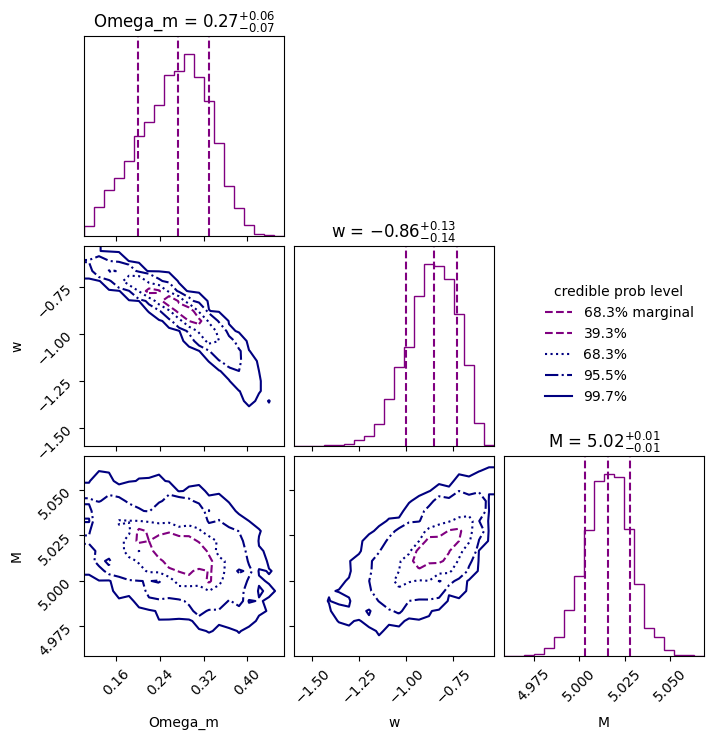

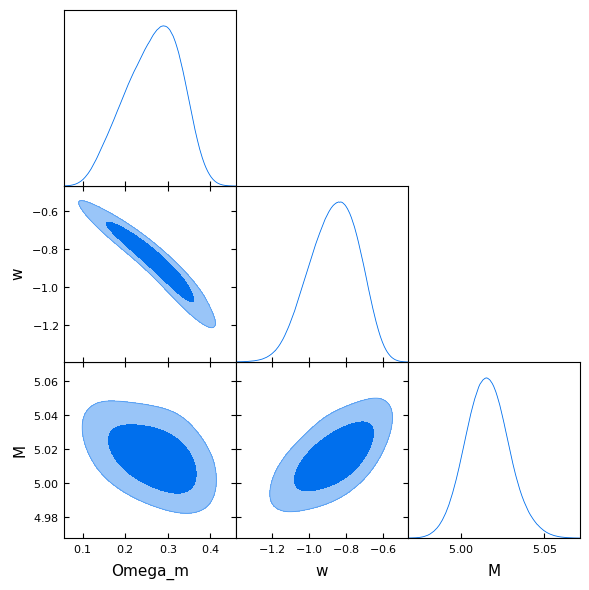

In [ ]:
with open(f'{fit_dir}/Flat_wCDM_{prior}{"_marg" if marginalize_M else ""}_result.pkl', 'rb') as f:
    Flat_wCDM_result = pickle.load(f)
cornerplot(Flat_wCDM_result);
smooth_plot(Flat_wCDM_result)

#### Flat w0waCDM

In [ ]:
# Needless to run again if the .pkl files exist in fit_dir
Flat_w0waCDM_result = fit_cosmology("Flat_LCDM", prior=prior, marginalized=marginalize_M)
with open(f'{fit_dir}/Flat_w0waCDM_{prior}{"_marg" if marginalize_M else ""}_result.pkl', 'wb') as f:
    pickle.dump(Flat_w0waCDM_result, f)

DEBUG:ultranest:ReactiveNestedSampler: dims=3+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(400.0)), (np.float64(inf), np.float64(400.0))]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-19683173618427122670472835220879404712758853529632544418493635677419074670501967917286026635737300992.00, Lmax=-845.16


DEBUG:ultranest:iteration=1, ncalls=402, regioncalls=80, ndraw=40, logz=-19683173618427122670472835220879404712758853529632544418493635677419074670501967917286026635737300992.00, remainder_fraction=100.0000%, Lmin=-19537673264338716642406313892661610969670329778425041548682764870755828163410496169174015473023451136.00, Lmax=-845.16


DEBUG:ultranest:iteration=4, ncalls=405, regioncalls=200, ndraw=40, logz=-18848682424293190662662710750190133731910250812573253391221695842233591900413294954220909222330105856.00, remainder_fraction=100.0000%, Lmin=-17973395070880461275338991082086563251427498366487333143478130303046566213811503922791504400978280448.00, Lmax=-845.16


DEBUG:ultranest:iteration=5, ncalls=406, regioncalls=240, ndraw=40, logz=-17973395070880461275338991082086563251427498366487333143478130303046566213811503922791504400978280448.00, remainder_fraction=100.0000%, Lmin=-17229020432850428903908492488035198110248815462861966412528757722293337590370452595926976070913359872.00, Lmax=-822.01


DEBUG:ultranest:iteration=6, ncalls=407, regioncalls=280, ndraw=40, logz=-17229020432850428903908492488035198110248815462861966412528757722293337590370452595926976070913359872.00, remainder_fraction=100.0000%, Lmin=-17149256224867416857215778838175154478592483609156888397620919585796979660788987065058545750283124736.00, Lmax=-822.01


DEBUG:ultranest:iteration=7, ncalls=408, regioncalls=320, ndraw=40, logz=-17149256224867416857215778838175154478592483609156888397620919585796979660788987065058545750283124736.00, remainder_fraction=100.0000%, Lmin=-15835350541626130414847438794912921594220063011240637093734067704630408303961658091337268574604492800.00, Lmax=-822.01


DEBUG:ultranest:iteration=9, ncalls=410, regioncalls=400, ndraw=40, logz=-15610504172007689338504191679385291207703183169635374228021901316571020635762778418693799612803710976.00, remainder_fraction=100.0000%, Lmin=-15335273265715453978980632250928558185490203720079882214795618296099826265583430378964762047912345600.00, Lmax=-822.01


DEBUG:ultranest:iteration=11, ncalls=412, regioncalls=480, ndraw=40, logz=-15101183264393574817400226469905034825531044545867945977579121925878766653081832563652303690502504448.00, remainder_fraction=100.0000%, Lmin=-14917703740787000500147694477685097924267180719565608621214904564322210769009596030192901601412251648.00, Lmax=-822.01


DEBUG:ultranest:iteration=12, ncalls=413, regioncalls=520, ndraw=40, logz=-14917703740787000500147694477685097924267180719565608621214904564322210769009596030192901601412251648.00, remainder_fraction=100.0000%, Lmin=-14620273818359499476771751003921147120754531126120945076661130252046180206014861614484026305613398016.00, Lmax=-822.01


DEBUG:ultranest:iteration=14, ncalls=415, regioncalls=600, ndraw=40, logz=-14314247823432995511305935623339408616142389164746180701927003259888786939119991568490432722683035648.00, remainder_fraction=100.0000%, Lmin=-13937501718664907227918626188093138527162388707893862381322214125780555105624749850032871263828967424.00, Lmax=-822.01


DEBUG:ultranest:iteration=15, ncalls=416, regioncalls=640, ndraw=40, logz=-13937501718664907227918626188093138527162388707893862381322214125780555105624749850032871263828967424.00, remainder_fraction=100.0000%, Lmin=-13738356729431891308349381660269108427200643450181463249801306860125058019999494695697306872583290880.00, Lmax=-822.01


DEBUG:ultranest:iteration=16, ncalls=417, regioncalls=680, ndraw=40, logz=-13738356729431891308349381660269108427200643450181463249801306860125058019999494695697306872583290880.00, remainder_fraction=100.0000%, Lmin=-13710179210153427125996304747371893300339649653439528954194234203476661141250646769859374217225568256.00, Lmax=-822.01


DEBUG:ultranest:iteration=18, ncalls=419, regioncalls=760, ndraw=40, logz=-13683331501633606135601755466913054086167698517448178217025457305861839494884186294817708896187056128.00, remainder_fraction=100.0000%, Lmin=-13358004360113440135587514748443767599263934222589247833877891941732080587635424048547036058349469696.00, Lmax=-822.01


DEBUG:ultranest:iteration=19, ncalls=420, regioncalls=800, ndraw=40, logz=-13358004360113440135587514748443767599263934222589247833877891941732080587635424048547036058349469696.00, remainder_fraction=100.0000%, Lmin=-13220211415983295520428049975818094561022967809118645392136567328784546345421310318789550639356575744.00, Lmax=-822.01


DEBUG:ultranest:iteration=20, ncalls=421, regioncalls=840, ndraw=40, logz=-13220211415983295520428049975818094561022967809118645392136567328784546345421310318789550639356575744.00, remainder_fraction=100.0000%, Lmin=-12375593390683927793552779307265359614312839324742642828238265627259967745716952176787409917148397568.00, Lmax=-822.01


DEBUG:ultranest:iteration=21, ncalls=422, regioncalls=880, ndraw=40, logz=-12375593390683927793552779307265359614312839324742642828238265627259967745716952176787409917148397568.00, remainder_fraction=100.0000%, Lmin=-12263762222248186028950482432317322692846311884368403683793102370741301869607384677874040726219653120.00, Lmax=-822.01


DEBUG:ultranest:iteration=23, ncalls=424, regioncalls=960, ndraw=40, logz=-12220607419201400279970780573784484238736791805707299576392138676958830784958686775823259293473308672.00, remainder_fraction=100.0000%, Lmin=-11765221764843739757087219040496960640501043089005164424252548580285443001255009497773079356514500608.00, Lmax=-822.01


DEBUG:ultranest:iteration=25, ncalls=426, regioncalls=1040, ndraw=40, logz=-11529320111398937237103010068031514981119410162413113436829203832784009565521883137334734184354152448.00, remainder_fraction=100.0000%, Lmin=-11062130679372094917192341953493114134550840034903232768063850077788759866699286980587813456073195520.00, Lmax=-822.01


DEBUG:ultranest:iteration=27, ncalls=428, regioncalls=1120, ndraw=40, logz=-10296251181683008208992762716744556562476188075819370330473000006752309640262922761484099961307004928.00, remainder_fraction=100.0000%, Lmin=-10079082621645550251416161339314486280555453161050770846597367535689252325880473184925284846547238912.00, Lmax=-822.01


DEBUG:ultranest:iteration=28, ncalls=429, regioncalls=1160, ndraw=40, logz=-10079082621645550251416161339314486280555453161050770846597367535689252325880473184925284846547238912.00, remainder_fraction=100.0000%, Lmin=-10025631716939407015123980528555575205838369967895742336949266671756779789824912365802985519010807808.00, Lmax=-822.01


DEBUG:ultranest:iteration=29, ncalls=430, regioncalls=1200, ndraw=40, logz=-10025631716939407015123980528555575205838369967895742336949266671756779789824912365802985519010807808.00, remainder_fraction=100.0000%, Lmin=-9806601750661314804771275074673061446896965108138590228147411144691087844678937381979018506467803136.00, Lmax=-822.01


DEBUG:ultranest:iteration=31, ncalls=432, regioncalls=1280, ndraw=40, logz=-9628745150728900145204120199540191420217033881137973603357762003512979723819797750868595930015203328.00, remainder_fraction=100.0000%, Lmin=-9066891263448734714308131948420568925156201663420841990541403664604621649980276718164492311530045440.00, Lmax=-822.01


DEBUG:ultranest:iteration=32, ncalls=433, regioncalls=1320, ndraw=40, logz=-9066891263448734714308131948420568925156201663420841990541403664604621649980276718164492311530045440.00, remainder_fraction=100.0000%, Lmin=-8957769935339661651763085615993568538466797236332551231125167594969572874593417390298842571835703296.00, Lmax=-822.01


DEBUG:ultranest:iteration=33, ncalls=435, regioncalls=1400, ndraw=40, logz=-8957769935339661651763085615993568538466797236332551231125167594969572874593417390298842571835703296.00, remainder_fraction=100.0000%, Lmin=-8911451653737423183873717628274751279839710914182507315639892143226616093291684181028402170035175424.00, Lmax=-822.01


DEBUG:ultranest:iteration=36, ncalls=438, regioncalls=1520, ndraw=40, logz=-8573322758141412028921551013655617668147568330372550868020495053125313914523397573121942443503124480.00, remainder_fraction=100.0000%, Lmin=-8550741352362869266690511125436641889824285085870402844659625800690372587188206250411357339750760448.00, Lmax=-822.01


DEBUG:ultranest:iteration=37, ncalls=439, regioncalls=1560, ndraw=40, logz=-8550741352362869266690511125436641889824285085870402844659625800690372587188206250411357339750760448.00, remainder_fraction=100.0000%, Lmin=-8461769884048919767340910327291287940790374723739085559685210849443134074455297558070894216874033152.00, Lmax=-822.01


DEBUG:ultranest:iteration=39, ncalls=442, regioncalls=1680, ndraw=40, logz=-8279951105568371998998030806864162947179455248951246459651617405496010653833490745989187209099476992.00, remainder_fraction=100.0000%, Lmin=-7735102686038583192266575897460780794905719403272939146685953368669915829040507242579440474660012032.00, Lmax=-822.01


DEBUG:ultranest:iteration=40, ncalls=444, regioncalls=1760, ndraw=40, logz=-7735102686038583192266575897460780794905719403272939146685953368669915829040507242579440474660012032.00, remainder_fraction=100.0000%, Lmin=-7681178412498613694978517649877762736301571886561611878473667555914763015127322656971569413184552960.00, Lmax=-822.01


DEBUG:ultranest:iteration=42, ncalls=446, regioncalls=1840, ndraw=40, logz=-7213003451134436797892621141911620559848107278340761486563959572245958510893285565850034124858851328.00, remainder_fraction=100.0000%, Lmin=-7144606389125086794860750041504118235839248372239789320268430241624482935047824586562071778018983936.00, Lmax=-822.01


DEBUG:ultranest:iteration=43, ncalls=448, regioncalls=1920, ndraw=40, logz=-7144606389125086794860750041504118235839248372239789320268430241624482935047824586562071778018983936.00, remainder_fraction=100.0000%, Lmin=-7029552808771704060270970345494142796690341805391064202056404722572712684185906831432586488390352896.00, Lmax=-822.01


DEBUG:ultranest:iteration=45, ncalls=450, regioncalls=2000, ndraw=40, logz=-6915040106223333455977937253115754166058062043783943340875905610190349159618974952391686949185781760.00, remainder_fraction=100.0000%, Lmin=-6834572367015379007374795314538078439416396202874129371835636448404887773594386765533814094703886336.00, Lmax=-822.01


DEBUG:ultranest:iteration=46, ncalls=451, regioncalls=2040, ndraw=40, logz=-6834572367015379007374795314538078439416396202874129371835636448404887773594386765533814094703886336.00, remainder_fraction=100.0000%, Lmin=-6732576930259930561224300475358914691413426837181606454899624567207708806956067240423070372475174912.00, Lmax=-822.01


DEBUG:ultranest:iteration=47, ncalls=452, regioncalls=2080, ndraw=40, logz=-6732576930259930561224300475358914691413426837181606454899624567207708806956067240423070372475174912.00, remainder_fraction=100.0000%, Lmin=-6493546034541012043171584839897454743439500033260424763344328261428360630814824266902863443275022336.00, Lmax=-822.01


DEBUG:ultranest:iteration=48, ncalls=453, regioncalls=2120, ndraw=40, logz=-6493546034541012043171584839897454743439500033260424763344328261428360630814824266902863443275022336.00, remainder_fraction=100.0000%, Lmin=-6461093284538648509725789345398374987583086467434783385625831451433249271827539257586952800248528896.00, Lmax=-822.01


DEBUG:ultranest:iteration=49, ncalls=454, regioncalls=2160, ndraw=40, logz=-6461093284538648509725789345398374987583086467434783385625831451433249271827539257586952800248528896.00, remainder_fraction=100.0000%, Lmin=-6398488867153922613022332895933334324067372925652041541220982823147494144529553071716562984840986624.00, Lmax=-822.01


DEBUG:ultranest:iteration=50, ncalls=455, regioncalls=2200, ndraw=40, logz=-6398488867153922613022332895933334324067372925652041541220982823147494144529553071716562984840986624.00, remainder_fraction=100.0000%, Lmin=-6359074580478154258826282031786790958277390851367512841005422019903192063117507662787043409256251392.00, Lmax=-822.01


DEBUG:ultranest:iteration=51, ncalls=456, regioncalls=2240, ndraw=40, logz=-6359074580478154258826282031786790958277390851367512841005422019903192063117507662787043409256251392.00, remainder_fraction=100.0000%, Lmin=-6273845075766967602276861816700858812779322365809359279076379254307669398577503223593714189756006400.00, Lmax=-822.01


DEBUG:ultranest:iteration=52, ncalls=457, regioncalls=2280, ndraw=40, logz=-6273845075766967602276861816700858812779322365809359279076379254307669398577503223593714189756006400.00, remainder_fraction=100.0000%, Lmin=-6183075103428361478904579995395433875897346725309121959144865735935721155039604756899719181655605248.00, Lmax=-822.01


DEBUG:ultranest:iteration=53, ncalls=459, regioncalls=2360, ndraw=40, logz=-6183075103428361478904579995395433875897346725309121959144865735935721155039604756899719181655605248.00, remainder_fraction=100.0000%, Lmin=-6095779689948752669797452551741064071877554714535144516613532945630935351708549037224894947028631552.00, Lmax=-822.01


DEBUG:ultranest:iteration=54, ncalls=460, regioncalls=2400, ndraw=40, logz=-6095779689948752669797452551741064071877554714535144516613532945630935351708549037224894947028631552.00, remainder_fraction=100.0000%, Lmin=-5870280152364827507151980005660158389923570159176757553359815456245230948180799241594678172868149248.00, Lmax=-822.01


DEBUG:ultranest:iteration=55, ncalls=461, regioncalls=2440, ndraw=40, logz=-5870280152364827507151980005660158389923570159176757553359815456245230948180799241594678172868149248.00, remainder_fraction=100.0000%, Lmin=-5825282093950927825882733858330383955201733388203608607772985542903535871812230035346699674353401856.00, Lmax=-822.01


DEBUG:ultranest:iteration=56, ncalls=462, regioncalls=2480, ndraw=40, logz=-5825282093950927825882733858330383955201733388203608607772985542903535871812230035346699674353401856.00, remainder_fraction=100.0000%, Lmin=-5739242721486657745117602796747291760352956192589210894983563675875672455448810696338146685410607104.00, Lmax=-822.01


DEBUG:ultranest:iteration=57, ncalls=463, regioncalls=2520, ndraw=40, logz=-5739242721486657745117602796747291760352956192589210894983563675875672455448810696338146685410607104.00, remainder_fraction=100.0000%, Lmin=-5657393898311855497395037121677152995799249619258071031607953797344817058878594772994485158942867456.00, Lmax=-822.01


DEBUG:ultranest:iteration=58, ncalls=464, regioncalls=2560, ndraw=40, logz=-5657393898311855497395037121677152995799249619258071031607953797344817058878594772994485158942867456.00, remainder_fraction=100.0000%, Lmin=-5523296484009186967840740337990259092618794604241083512172287079326616470591275665702712747944312832.00, Lmax=-822.01


DEBUG:ultranest:iteration=59, ncalls=465, regioncalls=2600, ndraw=40, logz=-5523296484009186967840740337990259092618794604241083512172287079326616470591275665702712747944312832.00, remainder_fraction=100.0000%, Lmin=-5376210000652889878665641596163212747763514920070247349270551687116714281547469605055391215617310720.00, Lmax=-822.01


DEBUG:ultranest:iteration=60, ncalls=466, regioncalls=2640, ndraw=40, logz=-5376210000652889878665641596163212747763514920070247349270551687116714281547469605055391215617310720.00, remainder_fraction=100.0000%, Lmin=-5376022046872339754509385362123426452671367147245334215322294371999772214694702843735596454239010816.00, Lmax=-822.01


DEBUG:ultranest:iteration=61, ncalls=467, regioncalls=2680, ndraw=40, logz=-5376022046872339754509385362123426452671367147245334215322294371999772214694702843735596454239010816.00, remainder_fraction=100.0000%, Lmin=-5252932149031749443382740019921164664391060570822786676444914171981975544946019155127704789907931136.00, Lmax=-822.01


DEBUG:ultranest:iteration=62, ncalls=468, regioncalls=2720, ndraw=40, logz=-5252932149031749443382740019921164664391060570822786676444914171981975544946019155127704789907931136.00, remainder_fraction=100.0000%, Lmin=-5207205326891986778378003810878868221298854971442069486378064069559125019941428250607253920029868032.00, Lmax=-822.01


DEBUG:ultranest:iteration=63, ncalls=469, regioncalls=2760, ndraw=40, logz=-5207205326891986778378003810878868221298854971442069486378064069559125019941428250607253920029868032.00, remainder_fraction=100.0000%, Lmin=-5144013233916979117304904724724837754279401968327489744361102557014484708929128570848686680592875520.00, Lmax=-822.01


DEBUG:ultranest:iteration=64, ncalls=471, regioncalls=2840, ndraw=40, logz=-5144013233916979117304904724724837754279401968327489744361102557014484708929128570848686680592875520.00, remainder_fraction=100.0000%, Lmin=-5074317747630100880894369988283970477733970562213483346284746864570923440307678592110767007820939264.00, Lmax=-822.01


DEBUG:ultranest:iteration=65, ncalls=473, regioncalls=2920, ndraw=40, logz=-5074317747630100880894369988283970477733970562213483346284746864570923440307678592110767007820939264.00, remainder_fraction=100.0000%, Lmin=-5040839453255540132273916435873907504641385529386464921085660036935446498718159125634426505506324480.00, Lmax=-822.01


DEBUG:ultranest:iteration=66, ncalls=475, regioncalls=3000, ndraw=40, logz=-5040839453255540132273916435873907504641385529386464921085660036935446498718159125634426505506324480.00, remainder_fraction=100.0000%, Lmin=-5040255743104484684457051847434603545226570669126180788590703273221279425886925376301913964235718656.00, Lmax=-822.01


DEBUG:ultranest:iteration=67, ncalls=476, regioncalls=3040, ndraw=40, logz=-5040255743104484684457051847434603545226570669126180788590703273221279425886925376301913964235718656.00, remainder_fraction=100.0000%, Lmin=-5029566148351312325041933330898284692212664458609864146126328201687921348973329972477194054169264128.00, Lmax=-822.01


DEBUG:ultranest:iteration=68, ncalls=477, regioncalls=3080, ndraw=40, logz=-5029566148351312325041933330898284692212664458609864146126328201687921348973329972477194054169264128.00, remainder_fraction=100.0000%, Lmin=-4998759200365288256985035253147670853509325424146250918437206681625022916957349289038707289132892160.00, Lmax=-822.01


DEBUG:ultranest:iteration=69, ncalls=478, regioncalls=3120, ndraw=40, logz=-4998759200365288256985035253147670853509325424146250918437206681625022916957349289038707289132892160.00, remainder_fraction=100.0000%, Lmin=-4868054567172417832950816201060423956478728180980437286824986030690296031785980913686059070613618688.00, Lmax=-822.01


DEBUG:ultranest:iteration=71, ncalls=481, regioncalls=3240, ndraw=40, logz=-4780749557182286039084603234842300704078011170216122352637524430906239688827381797498788945300815872.00, remainder_fraction=100.0000%, Lmin=-4729976810452089741658211643387949829010066412929452148126025820514453652205720541222084946643910656.00, Lmax=-822.01


DEBUG:ultranest:iteration=72, ncalls=482, regioncalls=3280, ndraw=40, logz=-4729976810452089741658211643387949829010066412929452148126025820514453652205720541222084946643910656.00, remainder_fraction=100.0000%, Lmin=-4561671231680566235337938077596155351826820068557587442099759786420854195527540867663678558020042752.00, Lmax=-822.01


DEBUG:ultranest:iteration=73, ncalls=484, regioncalls=3360, ndraw=40, logz=-4561671231680566235337938077596155351826820068557587442099759786420854195527540867663678558020042752.00, remainder_fraction=100.0000%, Lmin=-4460903322029899148014735989360178311591614665768428014777714482885364915142849474596692725008957440.00, Lmax=-822.01


DEBUG:ultranest:iteration=74, ncalls=485, regioncalls=3400, ndraw=40, logz=-4460903322029899148014735989360178311591614665768428014777714482885364915142849474596692725008957440.00, remainder_fraction=100.0000%, Lmin=-4408081677325725068540481992206495457431504695861485886741034885675853985230314912650373480381939712.00, Lmax=-822.01


DEBUG:ultranest:iteration=75, ncalls=486, regioncalls=3440, ndraw=40, logz=-4408081677325725068540481992206495457431504695861485886741034885675853985230314912650373480381939712.00, remainder_fraction=100.0000%, Lmin=-4392690551965408772669960906991112359157048702791888880192609222860565338268686565742709242113032192.00, Lmax=-822.01


DEBUG:ultranest:iteration=76, ncalls=487, regioncalls=3480, ndraw=40, logz=-4392690551965408772669960906991112359157048702791888880192609222860565338268686565742709242113032192.00, remainder_fraction=100.0000%, Lmin=-4389685651028205558125167582866499633790041597841227417930163933260279541024789872507342108022013952.00, Lmax=-822.01


DEBUG:ultranest:iteration=77, ncalls=488, regioncalls=3520, ndraw=40, logz=-4389685651028205558125167582866499633790041597841227417930163933260279541024789872507342108022013952.00, remainder_fraction=100.0000%, Lmin=-4356191382082996830020985734492726825019492915069432421083704926757676073205439930537303149142605824.00, Lmax=-822.01


DEBUG:ultranest:iteration=79, ncalls=490, regioncalls=3600, ndraw=40, logz=-4314426953041457934192811734176263526988833956605067304698329755990643438681719349660550609447682048.00, remainder_fraction=100.0000%, Lmin=-3953570448057646723378784756651652655797949760349737798358904728881798813655724786544852289378582528.00, Lmax=-822.01


DEBUG:ultranest:iteration=80, ncalls=491, regioncalls=3640, ndraw=40, logz=-3953570448057646723378784756651652655797949760349737798358904728881798813655724786544852289378582528.00, remainder_fraction=100.0000%, Lmin=-3880145564790467498952242210677100661047346500542879274746977685206414833649669012472066185449439232.00, Lmax=-822.01


DEBUG:ultranest:iteration=81, ncalls=492, regioncalls=3680, ndraw=40, logz=-3880145564790467498952242210677100661047346500542879274746977685206414833649669012472066185449439232.00, remainder_fraction=100.0000%, Lmin=-3803492102999948235427674819710021546978154715113850270707951974812495925198625504726617015363567616.00, Lmax=-822.01


DEBUG:ultranest:iteration=82, ncalls=493, regioncalls=3720, ndraw=40, logz=-3803492102999948235427674819710021546978154715113850270707951974812495925198625504726617015363567616.00, remainder_fraction=100.0000%, Lmin=-3551293843816448807929027032705172781636689495395247334888399917219797328725387196906621738124574720.00, Lmax=-822.01


DEBUG:ultranest:iteration=83, ncalls=494, regioncalls=3760, ndraw=40, logz=-3551293843816448807929027032705172781636689495395247334888399917219797328725387196906621738124574720.00, remainder_fraction=100.0000%, Lmin=-3455964470525024890155437935425319348525582057487039336326896474269026975331020139834972271720529920.00, Lmax=-822.01


DEBUG:ultranest:iteration=84, ncalls=495, regioncalls=3800, ndraw=40, logz=-3455964470525024890155437935425319348525582057487039336326896474269026975331020139834972271720529920.00, remainder_fraction=100.0000%, Lmin=-3407437702966397666125219261761449736547139001331777593796130522957024385807739058055915058180915200.00, Lmax=-822.01


DEBUG:ultranest:iteration=85, ncalls=496, regioncalls=3840, ndraw=40, logz=-3407437702966397666125219261761449736547139001331777593796130522957024385807739058055915058180915200.00, remainder_fraction=100.0000%, Lmin=-3223413530794644355452925969396200339414639968822565652318358045173017921984939529952245624940265472.00, Lmax=-822.01


DEBUG:ultranest:iteration=86, ncalls=497, regioncalls=3880, ndraw=40, logz=-3223413530794644355452925969396200339414639968822565652318358045173017921984939529952245624940265472.00, remainder_fraction=100.0000%, Lmin=-3169361166951315446825624401980996022604155192357661320871138501392938476800500511972573186692743168.00, Lmax=-822.01


DEBUG:ultranest:iteration=87, ncalls=498, regioncalls=3920, ndraw=40, logz=-3169361166951315446825624401980996022604155192357661320871138501392938476800500511972573186692743168.00, remainder_fraction=100.0000%, Lmin=-3164212647795124935258079026444982382427852968066547198071908014287922054367107088766263153179754496.00, Lmax=-822.01


DEBUG:ultranest:iteration=88, ncalls=499, regioncalls=3960, ndraw=40, logz=-3164212647795124935258079026444982382427852968066547198071908014287922054367107088766263153179754496.00, remainder_fraction=100.0000%, Lmin=-3091812706620455207078628920068061754642024869687539120948642628802455628162513189330485868756992000.00, Lmax=-822.01


DEBUG:ultranest:iteration=89, ncalls=502, regioncalls=4080, ndraw=40, logz=-3091812706620455207078628920068061754642024869687539120948642628802455628162513189330485868756992000.00, remainder_fraction=100.0000%, Lmin=-3069443320152583292173082092384920343953885541600261474080201633112690189362175795011138080892518400.00, Lmax=-822.01


DEBUG:ultranest:iteration=90, ncalls=503, regioncalls=4120, ndraw=40, logz=-3069443320152583292173082092384920343953885541600261474080201633112690189362175795011138080892518400.00, remainder_fraction=100.0000%, Lmin=-2956517755779710363392657003296853656317924325169864087972887501819131971819175915441949466429489152.00, Lmax=-822.01


DEBUG:ultranest:iteration=91, ncalls=504, regioncalls=4160, ndraw=40, logz=-2956517755779710363392657003296853656317924325169864087972887501819131971819175915441949466429489152.00, remainder_fraction=100.0000%, Lmin=-2768661189792741141229415632573294493641209672099350289777047708024528350771675178868519174984957952.00, Lmax=-822.01


DEBUG:ultranest:iteration=92, ncalls=505, regioncalls=4200, ndraw=40, logz=-2768661189792741141229415632573294493641209672099350289777047708024528350771675178868519174984957952.00, remainder_fraction=100.0000%, Lmin=-2578699182734908147775319780418808141696013508866464522878751162879832417248277368518612102422724608.00, Lmax=-822.01


DEBUG:ultranest:iteration=93, ncalls=506, regioncalls=4240, ndraw=40, logz=-2578699182734908147775319780418808141696013508866464522878751162879832417248277368518612102422724608.00, remainder_fraction=100.0000%, Lmin=-2280128578839016926252064586663522940044990491550919421146663761467505089715396109497942607388475392.00, Lmax=-822.01


DEBUG:ultranest:iteration=94, ncalls=507, regioncalls=4280, ndraw=40, logz=-2280128578839016926252064586663522940044990491550919421146663761467505089715396109497942607388475392.00, remainder_fraction=100.0000%, Lmin=-2256093117865311983171046854411814968927669818043884195443207915349647336903791328008591521590804480.00, Lmax=-822.01


DEBUG:ultranest:iteration=95, ncalls=508, regioncalls=4320, ndraw=40, logz=-2256093117865311983171046854411814968927669818043884195443207915349647336903791328008591521590804480.00, remainder_fraction=100.0000%, Lmin=-2245687227570186963944593666788565565154928913702144678605127106515418911121393524907218835553124352.00, Lmax=-822.01


DEBUG:ultranest:iteration=96, ncalls=509, regioncalls=4360, ndraw=40, logz=-2245687227570186963944593666788565565154928913702144678605127106515418911121393524907218835553124352.00, remainder_fraction=100.0000%, Lmin=-2178263731378011802634313763896446342837529146188004524101932275244287364427942799205886731434852352.00, Lmax=-822.01


DEBUG:ultranest:iteration=97, ncalls=510, regioncalls=4400, ndraw=40, logz=-2178263731378011802634313763896446342837529146188004524101932275244287364427942799205886731434852352.00, remainder_fraction=100.0000%, Lmin=-2101387288658690561508961692965576980133021185837552473573402058639973542554999466362538347020156928.00, Lmax=-822.01


DEBUG:ultranest:iteration=98, ncalls=511, regioncalls=4440, ndraw=40, logz=-2101387288658690561508961692965576980133021185837552473573402058639973542554999466362538347020156928.00, remainder_fraction=100.0000%, Lmin=-2003817782929136323433968408136536378054753531229832166619625879761115841817257486560844878289305600.00, Lmax=-822.01


DEBUG:ultranest:iteration=99, ncalls=512, regioncalls=4480, ndraw=40, logz=-2003817782929136323433968408136536378054753531229832166619625879761115841817257486560844878289305600.00, remainder_fraction=100.0000%, Lmin=-1997651668094000706276215239450194473770331530795429342033055511242228627586926981609380338829623296.00, Lmax=-822.01


DEBUG:ultranest:iteration=100, ncalls=513, regioncalls=4520, ndraw=40, logz=-1997651668094000706276215239450194473770331530795429342033055511242228627586926981609380338829623296.00, remainder_fraction=100.0000%, Lmin=-1962228679712538226037691492671010892406062574368679938816585431310542884813453545908461504267550720.00, Lmax=-822.01


DEBUG:ultranest:iteration=101, ncalls=514, regioncalls=4560, ndraw=40, logz=-1962228679712538226037691492671010892406062574368679938816585431310542884813453545908461504267550720.00, remainder_fraction=100.0000%, Lmin=-1944577724096383371526387766589295740112654089017378799857560808423660347764808813475186114054586368.00, Lmax=-822.01


DEBUG:ultranest:iteration=102, ncalls=515, regioncalls=4600, ndraw=40, logz=-1944577724096383371526387766589295740112654089017378799857560808423660347764808813475186114054586368.00, remainder_fraction=100.0000%, Lmin=-1932497888467082549419718962943389949288892500043278582547450067502211880905066723307573330223038464.00, Lmax=-822.01


DEBUG:ultranest:iteration=103, ncalls=516, regioncalls=4640, ndraw=40, logz=-1932497888467082549419718962943389949288892500043278582547450067502211880905066723307573330223038464.00, remainder_fraction=100.0000%, Lmin=-1918618365780336172542489420898987769898050732629466903884329278890408787766198962504785358084898816.00, Lmax=-822.01


DEBUG:ultranest:iteration=104, ncalls=517, regioncalls=4680, ndraw=40, logz=-1918618365780336172542489420898987769898050732629466903884329278890408787766198962504785358084898816.00, remainder_fraction=100.0000%, Lmin=-1908795407585474232261021573965962154146863348502117764562438684194848575085256939035718935918936064.00, Lmax=-822.01


DEBUG:ultranest:iteration=105, ncalls=518, regioncalls=4720, ndraw=40, logz=-1908795407585474232261021573965962154146863348502117764562438684194848575085256939035718935918936064.00, remainder_fraction=100.0000%, Lmin=-1895989663254123820761111680015851261040979360182040796715826278212331761175748697000955129024741376.00, Lmax=-822.01


DEBUG:ultranest:iteration=106, ncalls=520, regioncalls=4800, ndraw=40, logz=-1895989663254123820761111680015851261040979360182040796715826278212331761175748697000955129024741376.00, remainder_fraction=100.0000%, Lmin=-1891842171592662371113462896335214000339211270318757355631691149439065367547308285044576876922667008.00, Lmax=-822.01


DEBUG:ultranest:iteration=107, ncalls=521, regioncalls=4840, ndraw=40, logz=-1891842171592662371113462896335214000339211270318757355631691149439065367547308285044576876922667008.00, remainder_fraction=100.0000%, Lmin=-1880097130314201313174059523234975944659852821105308564764944622405491362282900070947536440808964096.00, Lmax=-822.01


DEBUG:ultranest:iteration=108, ncalls=522, regioncalls=4880, ndraw=40, logz=-1880097130314201313174059523234975944659852821105308564764944622405491362282900070947536440808964096.00, remainder_fraction=100.0000%, Lmin=-1729142426278064723351444665502781073654432697121370829020954864301465255678829462604260539075919872.00, Lmax=-822.01


DEBUG:ultranest:iteration=109, ncalls=524, regioncalls=4960, ndraw=40, logz=-1729142426278064723351444665502781073654432697121370829020954864301465255678829462604260539075919872.00, remainder_fraction=100.0000%, Lmin=-1678579092793649159733397705016050724033123399129155527177344613129373197865752136935822780490842112.00, Lmax=-822.01


DEBUG:ultranest:iteration=110, ncalls=525, regioncalls=5000, ndraw=40, logz=-1678579092793649159733397705016050724033123399129155527177344613129373197865752136935822780490842112.00, remainder_fraction=100.0000%, Lmin=-1611100852647201332927678482212368880528171987548724185071460039015398084461833522169214524815572992.00, Lmax=-822.01


DEBUG:ultranest:iteration=111, ncalls=526, regioncalls=5040, ndraw=40, logz=-1611100852647201332927678482212368880528171987548724185071460039015398084461833522169214524815572992.00, remainder_fraction=100.0000%, Lmin=-1360736568042586485026484968547227429933858933759154592938589673552481626945420539760058013258350592.00, Lmax=-822.01


DEBUG:ultranest:iteration=112, ncalls=527, regioncalls=5080, ndraw=40, logz=-1360736568042586485026484968547227429933858933759154592938589673552481626945420539760058013258350592.00, remainder_fraction=100.0000%, Lmin=-1359397670199974926224316133778268789192203806260232815815282191166400456354921909871254881393704960.00, Lmax=-822.01


DEBUG:ultranest:iteration=113, ncalls=528, regioncalls=5120, ndraw=40, logz=-1359397670199974926224316133778268789192203806260232815815282191166400456354921909871254881393704960.00, remainder_fraction=100.0000%, Lmin=-1351650363188504444882425671660542389457703252628633626415963203763017734644080694993235222657499136.00, Lmax=-822.01


DEBUG:ultranest:iteration=114, ncalls=530, regioncalls=5200, ndraw=40, logz=-1351650363188504444882425671660542389457703252628633626415963203763017734644080694993235222657499136.00, remainder_fraction=100.0000%, Lmin=-1337129866880253674223197454366716171634002740642917350812403351485818665810587658847952772079288320.00, Lmax=-822.01


DEBUG:ultranest:iteration=115, ncalls=531, regioncalls=5240, ndraw=40, logz=-1337129866880253674223197454366716171634002740642917350812403351485818665810587658847952772079288320.00, remainder_fraction=100.0000%, Lmin=-1065588192932949581398058753303616677822148545798065879805705168678493480356937633842896931597058048.00, Lmax=-822.01


DEBUG:ultranest:iteration=116, ncalls=532, regioncalls=5280, ndraw=40, logz=-1065588192932949581398058753303616677822148545798065879805705168678493480356937633842896931597058048.00, remainder_fraction=100.0000%, Lmin=-42299.40, Lmax=-822.01


DEBUG:ultranest:iteration=117, ncalls=533, regioncalls=5320, ndraw=40, logz=-42305.68, remainder_fraction=100.0000%, Lmin=-37575.22, Lmax=-822.01


DEBUG:ultranest:iteration=118, ncalls=535, regioncalls=5400, ndraw=40, logz=-37581.51, remainder_fraction=100.0000%, Lmin=-35439.94, Lmax=-822.01


DEBUG:ultranest:iteration=119, ncalls=536, regioncalls=5440, ndraw=40, logz=-35446.23, remainder_fraction=100.0000%, Lmin=-34755.43, Lmax=-822.01


DEBUG:ultranest:iteration=120, ncalls=537, regioncalls=5480, ndraw=40, logz=-34761.72, remainder_fraction=100.0000%, Lmin=-34170.41, Lmax=-822.01


DEBUG:ultranest:iteration=121, ncalls=538, regioncalls=5520, ndraw=40, logz=-34176.70, remainder_fraction=100.0000%, Lmin=-33336.84, Lmax=-822.01


DEBUG:ultranest:iteration=122, ncalls=539, regioncalls=5560, ndraw=40, logz=-33343.14, remainder_fraction=100.0000%, Lmin=-31963.89, Lmax=-822.01


DEBUG:ultranest:iteration=123, ncalls=540, regioncalls=5600, ndraw=40, logz=-31970.19, remainder_fraction=100.0000%, Lmin=-31297.12, Lmax=-822.01


DEBUG:ultranest:iteration=124, ncalls=541, regioncalls=5640, ndraw=40, logz=-31303.42, remainder_fraction=100.0000%, Lmin=-31099.32, Lmax=-822.01


DEBUG:ultranest:iteration=125, ncalls=543, regioncalls=5720, ndraw=40, logz=-31105.62, remainder_fraction=100.0000%, Lmin=-30130.03, Lmax=-822.01


DEBUG:ultranest:iteration=126, ncalls=544, regioncalls=5760, ndraw=40, logz=-30136.34, remainder_fraction=100.0000%, Lmin=-28993.85, Lmax=-822.01


DEBUG:ultranest:iteration=127, ncalls=545, regioncalls=5800, ndraw=40, logz=-29000.16, remainder_fraction=100.0000%, Lmin=-27049.11, Lmax=-822.01


DEBUG:ultranest:iteration=128, ncalls=546, regioncalls=5840, ndraw=40, logz=-27055.42, remainder_fraction=100.0000%, Lmin=-23704.36, Lmax=-822.01


DEBUG:ultranest:iteration=129, ncalls=547, regioncalls=5880, ndraw=40, logz=-23710.67, remainder_fraction=100.0000%, Lmin=-22902.52, Lmax=-822.01


DEBUG:ultranest:iteration=130, ncalls=548, regioncalls=5920, ndraw=40, logz=-22908.83, remainder_fraction=100.0000%, Lmin=-22633.32, Lmax=-822.01


DEBUG:ultranest:iteration=131, ncalls=549, regioncalls=5960, ndraw=40, logz=-22639.64, remainder_fraction=100.0000%, Lmin=-22017.14, Lmax=-822.01


DEBUG:ultranest:iteration=132, ncalls=550, regioncalls=6000, ndraw=40, logz=-22023.46, remainder_fraction=100.0000%, Lmin=-21411.06, Lmax=-822.01


DEBUG:ultranest:iteration=133, ncalls=551, regioncalls=6040, ndraw=40, logz=-21417.38, remainder_fraction=100.0000%, Lmin=-20897.26, Lmax=-822.01


DEBUG:ultranest:iteration=134, ncalls=553, regioncalls=6120, ndraw=40, logz=-20903.59, remainder_fraction=100.0000%, Lmin=-19778.77, Lmax=-822.01


DEBUG:ultranest:iteration=135, ncalls=554, regioncalls=6160, ndraw=40, logz=-19785.10, remainder_fraction=100.0000%, Lmin=-19664.16, Lmax=-822.01


DEBUG:ultranest:iteration=136, ncalls=555, regioncalls=6200, ndraw=40, logz=-19670.49, remainder_fraction=100.0000%, Lmin=-16464.06, Lmax=-822.01


DEBUG:ultranest:iteration=137, ncalls=556, regioncalls=6240, ndraw=40, logz=-16470.39, remainder_fraction=100.0000%, Lmin=-16120.06, Lmax=-822.01


DEBUG:ultranest:iteration=138, ncalls=558, regioncalls=6320, ndraw=40, logz=-16126.39, remainder_fraction=100.0000%, Lmin=-15325.70, Lmax=-822.01


DEBUG:ultranest:iteration=139, ncalls=563, regioncalls=6520, ndraw=40, logz=-15332.04, remainder_fraction=100.0000%, Lmin=-15275.70, Lmax=-822.01


DEBUG:ultranest:iteration=140, ncalls=564, regioncalls=6560, ndraw=40, logz=-15282.04, remainder_fraction=100.0000%, Lmin=-14852.22, Lmax=-822.01


DEBUG:ultranest:iteration=141, ncalls=565, regioncalls=6600, ndraw=40, logz=-14858.56, remainder_fraction=100.0000%, Lmin=-13382.07, Lmax=-822.01


DEBUG:ultranest:iteration=142, ncalls=566, regioncalls=6640, ndraw=40, logz=-13388.42, remainder_fraction=100.0000%, Lmin=-12983.94, Lmax=-822.01


DEBUG:ultranest:iteration=143, ncalls=568, regioncalls=6720, ndraw=40, logz=-12990.29, remainder_fraction=100.0000%, Lmin=-12583.64, Lmax=-822.01


DEBUG:ultranest:iteration=144, ncalls=570, regioncalls=6800, ndraw=40, logz=-12589.99, remainder_fraction=100.0000%, Lmin=-12550.80, Lmax=-822.01


DEBUG:ultranest:iteration=145, ncalls=572, regioncalls=6880, ndraw=40, logz=-12557.16, remainder_fraction=100.0000%, Lmin=-12491.86, Lmax=-822.01


DEBUG:ultranest:iteration=146, ncalls=573, regioncalls=6920, ndraw=40, logz=-12498.21, remainder_fraction=100.0000%, Lmin=-12466.56, Lmax=-822.01


DEBUG:ultranest:iteration=147, ncalls=575, regioncalls=7000, ndraw=40, logz=-12472.91, remainder_fraction=100.0000%, Lmin=-12374.53, Lmax=-822.01


DEBUG:ultranest:iteration=148, ncalls=576, regioncalls=7040, ndraw=40, logz=-12380.89, remainder_fraction=100.0000%, Lmin=-12308.20, Lmax=-822.01


DEBUG:ultranest:iteration=149, ncalls=577, regioncalls=7080, ndraw=40, logz=-12314.56, remainder_fraction=100.0000%, Lmin=-12017.93, Lmax=-822.01


DEBUG:ultranest:iteration=150, ncalls=578, regioncalls=7120, ndraw=40, logz=-12024.29, remainder_fraction=100.0000%, Lmin=-11549.75, Lmax=-822.01


DEBUG:ultranest:iteration=151, ncalls=579, regioncalls=7160, ndraw=40, logz=-11556.12, remainder_fraction=100.0000%, Lmin=-11391.90, Lmax=-822.01


DEBUG:ultranest:iteration=152, ncalls=580, regioncalls=7200, ndraw=40, logz=-11398.27, remainder_fraction=100.0000%, Lmin=-11248.78, Lmax=-822.01


DEBUG:ultranest:iteration=153, ncalls=581, regioncalls=7240, ndraw=40, logz=-11255.16, remainder_fraction=100.0000%, Lmin=-10952.12, Lmax=-822.01


DEBUG:ultranest:iteration=154, ncalls=582, regioncalls=7280, ndraw=40, logz=-10958.49, remainder_fraction=100.0000%, Lmin=-10734.43, Lmax=-822.01


DEBUG:ultranest:iteration=155, ncalls=583, regioncalls=7320, ndraw=40, logz=-10740.80, remainder_fraction=100.0000%, Lmin=-10721.11, Lmax=-822.01


DEBUG:ultranest:iteration=156, ncalls=584, regioncalls=7360, ndraw=40, logz=-10727.49, remainder_fraction=100.0000%, Lmin=-10348.70, Lmax=-822.01


DEBUG:ultranest:iteration=157, ncalls=585, regioncalls=7400, ndraw=40, logz=-10355.08, remainder_fraction=100.0000%, Lmin=-10339.54, Lmax=-822.01


DEBUG:ultranest:iteration=158, ncalls=586, regioncalls=7440, ndraw=40, logz=-10345.92, remainder_fraction=100.0000%, Lmin=-10200.87, Lmax=-822.01


DEBUG:ultranest:iteration=159, ncalls=587, regioncalls=7480, ndraw=40, logz=-10207.26, remainder_fraction=100.0000%, Lmin=-10022.87, Lmax=-822.01


DEBUG:ultranest:iteration=160, ncalls=588, regioncalls=7520, ndraw=40, logz=-10029.26, remainder_fraction=100.0000%, Lmin=-9386.84, Lmax=-822.01


DEBUG:ultranest:iteration=161, ncalls=590, regioncalls=7600, ndraw=40, logz=-9393.23, remainder_fraction=100.0000%, Lmin=-9369.35, Lmax=-822.01


DEBUG:ultranest:iteration=162, ncalls=591, regioncalls=7640, ndraw=40, logz=-9375.74, remainder_fraction=100.0000%, Lmin=-9235.73, Lmax=-822.01


DEBUG:ultranest:iteration=163, ncalls=592, regioncalls=7680, ndraw=40, logz=-9242.12, remainder_fraction=100.0000%, Lmin=-9202.31, Lmax=-822.01


DEBUG:ultranest:iteration=164, ncalls=593, regioncalls=7720, ndraw=40, logz=-9208.71, remainder_fraction=100.0000%, Lmin=-9097.22, Lmax=-822.01


DEBUG:ultranest:iteration=165, ncalls=594, regioncalls=7760, ndraw=40, logz=-9103.63, remainder_fraction=100.0000%, Lmin=-8939.86, Lmax=-822.01


DEBUG:ultranest:iteration=166, ncalls=595, regioncalls=7800, ndraw=40, logz=-8946.26, remainder_fraction=100.0000%, Lmin=-8785.46, Lmax=-822.01


DEBUG:ultranest:iteration=167, ncalls=597, regioncalls=7880, ndraw=40, logz=-8791.87, remainder_fraction=100.0000%, Lmin=-8036.35, Lmax=-822.01


DEBUG:ultranest:iteration=168, ncalls=598, regioncalls=7920, ndraw=40, logz=-8042.77, remainder_fraction=100.0000%, Lmin=-7949.10, Lmax=-822.01


DEBUG:ultranest:iteration=169, ncalls=599, regioncalls=7960, ndraw=40, logz=-7955.52, remainder_fraction=100.0000%, Lmin=-7753.17, Lmax=-822.01


DEBUG:ultranest:iteration=170, ncalls=600, regioncalls=8000, ndraw=40, logz=-7759.59, remainder_fraction=100.0000%, Lmin=-7751.06, Lmax=-822.01


DEBUG:ultranest:iteration=171, ncalls=603, regioncalls=8120, ndraw=40, logz=-7757.36, remainder_fraction=100.0000%, Lmin=-7584.32, Lmax=-822.01


DEBUG:ultranest:iteration=172, ncalls=605, regioncalls=8200, ndraw=40, logz=-7590.74, remainder_fraction=100.0000%, Lmin=-7106.48, Lmax=-822.01


DEBUG:ultranest:iteration=173, ncalls=606, regioncalls=8240, ndraw=40, logz=-7112.90, remainder_fraction=100.0000%, Lmin=-7059.19, Lmax=-822.01


DEBUG:ultranest:iteration=174, ncalls=607, regioncalls=8280, ndraw=40, logz=-7065.62, remainder_fraction=100.0000%, Lmin=-6973.12, Lmax=-822.01


DEBUG:ultranest:iteration=175, ncalls=610, regioncalls=8400, ndraw=40, logz=-6979.55, remainder_fraction=100.0000%, Lmin=-6920.62, Lmax=-822.01


DEBUG:ultranest:iteration=176, ncalls=611, regioncalls=8440, ndraw=40, logz=-6927.05, remainder_fraction=100.0000%, Lmin=-6738.72, Lmax=-822.01


DEBUG:ultranest:iteration=177, ncalls=613, regioncalls=8520, ndraw=40, logz=-6745.15, remainder_fraction=100.0000%, Lmin=-6587.43, Lmax=-822.01


DEBUG:ultranest:iteration=178, ncalls=614, regioncalls=8560, ndraw=40, logz=-6593.86, remainder_fraction=100.0000%, Lmin=-6502.62, Lmax=-822.01


DEBUG:ultranest:iteration=179, ncalls=617, regioncalls=8680, ndraw=40, logz=-6509.05, remainder_fraction=100.0000%, Lmin=-6452.11, Lmax=-822.01


DEBUG:ultranest:iteration=180, ncalls=618, regioncalls=8720, ndraw=40, logz=-6458.56, remainder_fraction=100.0000%, Lmin=-6229.87, Lmax=-822.01


DEBUG:ultranest:iteration=181, ncalls=621, regioncalls=8840, ndraw=40, logz=-6236.31, remainder_fraction=100.0000%, Lmin=-6101.26, Lmax=-822.01


DEBUG:ultranest:iteration=182, ncalls=622, regioncalls=8880, ndraw=40, logz=-6107.70, remainder_fraction=100.0000%, Lmin=-5905.31, Lmax=-822.01


DEBUG:ultranest:iteration=183, ncalls=624, regioncalls=8960, ndraw=40, logz=-5911.76, remainder_fraction=100.0000%, Lmin=-5836.76, Lmax=-822.01


DEBUG:ultranest:iteration=184, ncalls=625, regioncalls=9000, ndraw=40, logz=-5843.21, remainder_fraction=100.0000%, Lmin=-5338.27, Lmax=-822.01


DEBUG:ultranest:iteration=185, ncalls=627, regioncalls=9080, ndraw=40, logz=-5344.73, remainder_fraction=100.0000%, Lmin=-5306.25, Lmax=-822.01


DEBUG:ultranest:iteration=186, ncalls=628, regioncalls=9120, ndraw=40, logz=-5312.71, remainder_fraction=100.0000%, Lmin=-5169.54, Lmax=-822.01


DEBUG:ultranest:iteration=187, ncalls=631, regioncalls=9240, ndraw=40, logz=-5176.00, remainder_fraction=100.0000%, Lmin=-5136.79, Lmax=-822.01


DEBUG:ultranest:iteration=188, ncalls=632, regioncalls=9280, ndraw=40, logz=-5143.25, remainder_fraction=100.0000%, Lmin=-5134.82, Lmax=-822.01


DEBUG:ultranest:iteration=189, ncalls=634, regioncalls=9360, ndraw=40, logz=-5141.15, remainder_fraction=100.0000%, Lmin=-5043.82, Lmax=-822.01


DEBUG:ultranest:iteration=190, ncalls=635, regioncalls=9400, ndraw=40, logz=-5050.28, remainder_fraction=100.0000%, Lmin=-4883.96, Lmax=-822.01


DEBUG:ultranest:iteration=191, ncalls=636, regioncalls=9440, ndraw=40, logz=-4890.43, remainder_fraction=100.0000%, Lmin=-4837.52, Lmax=-822.01


DEBUG:ultranest:iteration=192, ncalls=637, regioncalls=9480, ndraw=40, logz=-4843.99, remainder_fraction=100.0000%, Lmin=-4726.53, Lmax=-822.01


DEBUG:ultranest:iteration=193, ncalls=638, regioncalls=9520, ndraw=40, logz=-4733.01, remainder_fraction=100.0000%, Lmin=-4694.55, Lmax=-822.01


DEBUG:ultranest:iteration=194, ncalls=640, regioncalls=9600, ndraw=40, logz=-4701.03, remainder_fraction=100.0000%, Lmin=-4594.74, Lmax=-822.01


DEBUG:ultranest:iteration=195, ncalls=641, regioncalls=9640, ndraw=40, logz=-4601.22, remainder_fraction=100.0000%, Lmin=-4556.62, Lmax=-822.01


DEBUG:ultranest:iteration=196, ncalls=642, regioncalls=9680, ndraw=40, logz=-4563.10, remainder_fraction=100.0000%, Lmin=-4456.66, Lmax=-822.01


DEBUG:ultranest:iteration=197, ncalls=643, regioncalls=9720, ndraw=40, logz=-4463.14, remainder_fraction=100.0000%, Lmin=-4418.84, Lmax=-822.01


DEBUG:ultranest:iteration=198, ncalls=644, regioncalls=9760, ndraw=40, logz=-4425.32, remainder_fraction=100.0000%, Lmin=-4373.61, Lmax=-822.01


DEBUG:ultranest:iteration=199, ncalls=645, regioncalls=9800, ndraw=40, logz=-4380.09, remainder_fraction=100.0000%, Lmin=-4371.81, Lmax=-822.01


DEBUG:ultranest:iteration=200, ncalls=646, regioncalls=9840, ndraw=40, logz=-4378.15, remainder_fraction=100.0000%, Lmin=-4342.16, Lmax=-822.01


DEBUG:ultranest:iteration=201, ncalls=647, regioncalls=9880, ndraw=40, logz=-4348.65, remainder_fraction=100.0000%, Lmin=-4197.75, Lmax=-822.01


DEBUG:ultranest:iteration=202, ncalls=650, regioncalls=10000, ndraw=40, logz=-4204.24, remainder_fraction=100.0000%, Lmin=-4194.27, Lmax=-822.01


DEBUG:ultranest:iteration=203, ncalls=654, regioncalls=10160, ndraw=40, logz=-4200.74, remainder_fraction=100.0000%, Lmin=-4058.81, Lmax=-822.01


DEBUG:ultranest:iteration=204, ncalls=656, regioncalls=10240, ndraw=40, logz=-4065.31, remainder_fraction=100.0000%, Lmin=-4033.70, Lmax=-822.01


DEBUG:ultranest:iteration=205, ncalls=657, regioncalls=10280, ndraw=40, logz=-4040.20, remainder_fraction=100.0000%, Lmin=-4024.81, Lmax=-822.01


DEBUG:ultranest:iteration=206, ncalls=659, regioncalls=10360, ndraw=40, logz=-4031.32, remainder_fraction=100.0000%, Lmin=-4012.80, Lmax=-822.01


DEBUG:ultranest:iteration=207, ncalls=660, regioncalls=10400, ndraw=40, logz=-4019.30, remainder_fraction=100.0000%, Lmin=-3995.09, Lmax=-822.01


DEBUG:ultranest:iteration=208, ncalls=661, regioncalls=10440, ndraw=40, logz=-4001.60, remainder_fraction=100.0000%, Lmin=-3985.43, Lmax=-822.01


DEBUG:ultranest:iteration=209, ncalls=662, regioncalls=10480, ndraw=40, logz=-3991.94, remainder_fraction=100.0000%, Lmin=-3972.07, Lmax=-822.01


DEBUG:ultranest:iteration=210, ncalls=663, regioncalls=10520, ndraw=40, logz=-3978.58, remainder_fraction=100.0000%, Lmin=-3843.85, Lmax=-822.01


DEBUG:ultranest:iteration=211, ncalls=666, regioncalls=10640, ndraw=40, logz=-3850.36, remainder_fraction=100.0000%, Lmin=-3725.97, Lmax=-822.01


DEBUG:ultranest:iteration=212, ncalls=667, regioncalls=10680, ndraw=40, logz=-3732.49, remainder_fraction=100.0000%, Lmin=-3630.07, Lmax=-822.01


DEBUG:ultranest:iteration=213, ncalls=668, regioncalls=10720, ndraw=40, logz=-3636.59, remainder_fraction=100.0000%, Lmin=-3620.62, Lmax=-822.01


DEBUG:ultranest:iteration=214, ncalls=669, regioncalls=10760, ndraw=40, logz=-3627.14, remainder_fraction=100.0000%, Lmin=-3595.43, Lmax=-822.01


DEBUG:ultranest:iteration=215, ncalls=670, regioncalls=10800, ndraw=40, logz=-3601.96, remainder_fraction=100.0000%, Lmin=-3531.86, Lmax=-822.01


DEBUG:ultranest:iteration=216, ncalls=671, regioncalls=10840, ndraw=40, logz=-3538.39, remainder_fraction=100.0000%, Lmin=-3492.88, Lmax=-822.01


DEBUG:ultranest:iteration=217, ncalls=673, regioncalls=10920, ndraw=40, logz=-3499.42, remainder_fraction=100.0000%, Lmin=-3469.33, Lmax=-822.01


DEBUG:ultranest:iteration=218, ncalls=674, regioncalls=10960, ndraw=40, logz=-3475.87, remainder_fraction=100.0000%, Lmin=-3443.97, Lmax=-822.01


DEBUG:ultranest:iteration=219, ncalls=676, regioncalls=11040, ndraw=40, logz=-3450.50, remainder_fraction=100.0000%, Lmin=-3390.69, Lmax=-822.01


DEBUG:ultranest:iteration=220, ncalls=678, regioncalls=11120, ndraw=40, logz=-3397.23, remainder_fraction=100.0000%, Lmin=-3372.62, Lmax=-822.01


DEBUG:ultranest:iteration=221, ncalls=680, regioncalls=11200, ndraw=40, logz=-3379.16, remainder_fraction=100.0000%, Lmin=-3371.63, Lmax=-822.01


DEBUG:ultranest:iteration=222, ncalls=682, regioncalls=11280, ndraw=40, logz=-3377.86, remainder_fraction=100.0000%, Lmin=-3277.92, Lmax=-822.01


DEBUG:ultranest:iteration=223, ncalls=683, regioncalls=11320, ndraw=40, logz=-3284.47, remainder_fraction=100.0000%, Lmin=-3239.90, Lmax=-822.01


DEBUG:ultranest:iteration=224, ncalls=685, regioncalls=11400, ndraw=40, logz=-3246.45, remainder_fraction=100.0000%, Lmin=-3231.09, Lmax=-822.01


DEBUG:ultranest:iteration=225, ncalls=686, regioncalls=11440, ndraw=40, logz=-3237.64, remainder_fraction=100.0000%, Lmin=-3224.88, Lmax=-822.01


DEBUG:ultranest:iteration=226, ncalls=687, regioncalls=11480, ndraw=40, logz=-3231.43, remainder_fraction=100.0000%, Lmin=-3213.76, Lmax=-822.01


DEBUG:ultranest:iteration=227, ncalls=691, regioncalls=11640, ndraw=40, logz=-3220.32, remainder_fraction=100.0000%, Lmin=-3179.39, Lmax=-822.01


DEBUG:ultranest:iteration=228, ncalls=693, regioncalls=11720, ndraw=40, logz=-3185.95, remainder_fraction=100.0000%, Lmin=-3172.10, Lmax=-822.01


DEBUG:ultranest:iteration=229, ncalls=694, regioncalls=11760, ndraw=40, logz=-3178.66, remainder_fraction=100.0000%, Lmin=-3110.79, Lmax=-822.01


DEBUG:ultranest:iteration=230, ncalls=695, regioncalls=11800, ndraw=40, logz=-3117.35, remainder_fraction=100.0000%, Lmin=-3109.95, Lmax=-822.01


DEBUG:ultranest:iteration=231, ncalls=696, regioncalls=11840, ndraw=40, logz=-3116.16, remainder_fraction=100.0000%, Lmin=-2918.79, Lmax=-822.01


DEBUG:ultranest:iteration=232, ncalls=697, regioncalls=11880, ndraw=40, logz=-2925.36, remainder_fraction=100.0000%, Lmin=-2913.40, Lmax=-822.01


DEBUG:ultranest:iteration=233, ncalls=698, regioncalls=11920, ndraw=40, logz=-2919.97, remainder_fraction=100.0000%, Lmin=-2905.87, Lmax=-822.01


DEBUG:ultranest:iteration=234, ncalls=700, regioncalls=12000, ndraw=40, logz=-2912.45, remainder_fraction=100.0000%, Lmin=-2845.27, Lmax=-822.01


DEBUG:ultranest:iteration=235, ncalls=701, regioncalls=12040, ndraw=40, logz=-2851.85, remainder_fraction=100.0000%, Lmin=-2782.62, Lmax=-822.01


DEBUG:ultranest:iteration=236, ncalls=702, regioncalls=12080, ndraw=40, logz=-2789.20, remainder_fraction=100.0000%, Lmin=-2763.37, Lmax=-822.01


DEBUG:ultranest:iteration=237, ncalls=707, regioncalls=12280, ndraw=40, logz=-2769.95, remainder_fraction=100.0000%, Lmin=-2712.43, Lmax=-822.01


DEBUG:ultranest:iteration=238, ncalls=708, regioncalls=12320, ndraw=40, logz=-2719.01, remainder_fraction=100.0000%, Lmin=-2660.30, Lmax=-822.01


DEBUG:ultranest:iteration=239, ncalls=711, regioncalls=12440, ndraw=40, logz=-2666.88, remainder_fraction=100.0000%, Lmin=-2625.87, Lmax=-822.01


DEBUG:ultranest:iteration=240, ncalls=713, regioncalls=12520, ndraw=40, logz=-2632.46, remainder_fraction=100.0000%, Lmin=-2554.56, Lmax=-822.01


DEBUG:ultranest:iteration=241, ncalls=714, regioncalls=12560, ndraw=40, logz=-2561.16, remainder_fraction=100.0000%, Lmin=-2525.63, Lmax=-822.01


DEBUG:ultranest:iteration=242, ncalls=716, regioncalls=12640, ndraw=40, logz=-2532.23, remainder_fraction=100.0000%, Lmin=-2522.79, Lmax=-822.01


DEBUG:ultranest:iteration=243, ncalls=717, regioncalls=12680, ndraw=40, logz=-2529.33, remainder_fraction=100.0000%, Lmin=-2522.77, Lmax=-822.01


DEBUG:ultranest:iteration=244, ncalls=718, regioncalls=12720, ndraw=40, logz=-2528.66, remainder_fraction=100.0000%, Lmin=-2482.83, Lmax=-822.01


DEBUG:ultranest:iteration=245, ncalls=720, regioncalls=12800, ndraw=40, logz=-2489.43, remainder_fraction=100.0000%, Lmin=-2385.76, Lmax=-822.01


DEBUG:ultranest:iteration=246, ncalls=723, regioncalls=12920, ndraw=40, logz=-2392.37, remainder_fraction=100.0000%, Lmin=-2364.72, Lmax=-822.01


DEBUG:ultranest:iteration=247, ncalls=725, regioncalls=13000, ndraw=40, logz=-2371.32, remainder_fraction=100.0000%, Lmin=-2360.78, Lmax=-822.01


DEBUG:ultranest:iteration=248, ncalls=726, regioncalls=13040, ndraw=40, logz=-2367.37, remainder_fraction=100.0000%, Lmin=-2348.11, Lmax=-822.01


DEBUG:ultranest:iteration=249, ncalls=728, regioncalls=13120, ndraw=40, logz=-2354.72, remainder_fraction=100.0000%, Lmin=-2316.62, Lmax=-822.01


DEBUG:ultranest:iteration=250, ncalls=730, regioncalls=13200, ndraw=40, logz=-2323.23, remainder_fraction=100.0000%, Lmin=-2307.68, Lmax=-822.01


DEBUG:ultranest:iteration=251, ncalls=731, regioncalls=13240, ndraw=40, logz=-2314.30, remainder_fraction=100.0000%, Lmin=-2243.12, Lmax=-822.01


DEBUG:ultranest:iteration=252, ncalls=733, regioncalls=13320, ndraw=40, logz=-2249.74, remainder_fraction=100.0000%, Lmin=-2225.97, Lmax=-822.01


DEBUG:ultranest:iteration=253, ncalls=735, regioncalls=13400, ndraw=40, logz=-2232.60, remainder_fraction=100.0000%, Lmin=-2178.28, Lmax=-822.01


DEBUG:ultranest:iteration=254, ncalls=736, regioncalls=13440, ndraw=40, logz=-2184.90, remainder_fraction=100.0000%, Lmin=-2177.45, Lmax=-822.01


DEBUG:ultranest:iteration=255, ncalls=737, regioncalls=13480, ndraw=40, logz=-2183.72, remainder_fraction=100.0000%, Lmin=-2165.22, Lmax=-822.01


DEBUG:ultranest:iteration=256, ncalls=738, regioncalls=13520, ndraw=40, logz=-2171.85, remainder_fraction=100.0000%, Lmin=-2163.96, Lmax=-822.01


DEBUG:ultranest:iteration=257, ncalls=739, regioncalls=13560, ndraw=40, logz=-2170.34, remainder_fraction=100.0000%, Lmin=-2147.98, Lmax=-822.01


DEBUG:ultranest:iteration=258, ncalls=740, regioncalls=13600, ndraw=40, logz=-2154.61, remainder_fraction=100.0000%, Lmin=-2139.57, Lmax=-822.01


DEBUG:ultranest:iteration=259, ncalls=741, regioncalls=13640, ndraw=40, logz=-2146.20, remainder_fraction=100.0000%, Lmin=-2137.79, Lmax=-822.01


DEBUG:ultranest:iteration=260, ncalls=745, regioncalls=13800, ndraw=40, logz=-2144.27, remainder_fraction=100.0000%, Lmin=-2078.03, Lmax=-822.01


DEBUG:ultranest:iteration=261, ncalls=746, regioncalls=13840, ndraw=40, logz=-2084.67, remainder_fraction=100.0000%, Lmin=-2070.94, Lmax=-822.01


DEBUG:ultranest:iteration=262, ncalls=749, regioncalls=13960, ndraw=40, logz=-2077.59, remainder_fraction=100.0000%, Lmin=-2052.46, Lmax=-822.01


DEBUG:ultranest:iteration=263, ncalls=750, regioncalls=14000, ndraw=40, logz=-2059.10, remainder_fraction=100.0000%, Lmin=-2037.27, Lmax=-822.01


DEBUG:ultranest:iteration=264, ncalls=751, regioncalls=14040, ndraw=40, logz=-2043.92, remainder_fraction=100.0000%, Lmin=-2022.25, Lmax=-822.01


DEBUG:ultranest:iteration=265, ncalls=758, regioncalls=14320, ndraw=40, logz=-2028.90, remainder_fraction=100.0000%, Lmin=-1977.38, Lmax=-822.01


DEBUG:ultranest:iteration=266, ncalls=759, regioncalls=14360, ndraw=40, logz=-1984.04, remainder_fraction=100.0000%, Lmin=-1960.13, Lmax=-822.01


DEBUG:ultranest:iteration=267, ncalls=764, regioncalls=14560, ndraw=40, logz=-1966.79, remainder_fraction=100.0000%, Lmin=-1933.47, Lmax=-822.01


DEBUG:ultranest:iteration=268, ncalls=766, regioncalls=14640, ndraw=40, logz=-1940.13, remainder_fraction=100.0000%, Lmin=-1931.03, Lmax=-822.01


DEBUG:ultranest:iteration=269, ncalls=768, regioncalls=14720, ndraw=40, logz=-1937.61, remainder_fraction=100.0000%, Lmin=-1919.62, Lmax=-822.01


DEBUG:ultranest:iteration=270, ncalls=771, regioncalls=14840, ndraw=40, logz=-1926.28, remainder_fraction=100.0000%, Lmin=-1890.21, Lmax=-822.01


DEBUG:ultranest:iteration=271, ncalls=772, regioncalls=14880, ndraw=40, logz=-1896.87, remainder_fraction=100.0000%, Lmin=-1889.60, Lmax=-822.01


DEBUG:ultranest:iteration=272, ncalls=773, regioncalls=14920, ndraw=40, logz=-1895.83, remainder_fraction=100.0000%, Lmin=-1888.00, Lmax=-822.01


DEBUG:ultranest:iteration=273, ncalls=775, regioncalls=15000, ndraw=40, logz=-1894.40, remainder_fraction=100.0000%, Lmin=-1887.32, Lmax=-822.01


DEBUG:ultranest:iteration=274, ncalls=776, regioncalls=15040, ndraw=40, logz=-1893.49, remainder_fraction=100.0000%, Lmin=-1878.10, Lmax=-822.01


DEBUG:ultranest:iteration=275, ncalls=777, regioncalls=15080, ndraw=40, logz=-1884.78, remainder_fraction=100.0000%, Lmin=-1868.24, Lmax=-822.01


DEBUG:ultranest:iteration=276, ncalls=778, regioncalls=15120, ndraw=40, logz=-1874.92, remainder_fraction=100.0000%, Lmin=-1866.75, Lmax=-822.01


DEBUG:ultranest:iteration=277, ncalls=779, regioncalls=15160, ndraw=40, logz=-1873.23, remainder_fraction=100.0000%, Lmin=-1860.07, Lmax=-822.01


DEBUG:ultranest:iteration=278, ncalls=780, regioncalls=15200, ndraw=40, logz=-1866.75, remainder_fraction=100.0000%, Lmin=-1858.61, Lmax=-822.01


DEBUG:ultranest:iteration=279, ncalls=783, regioncalls=15320, ndraw=40, logz=-1865.09, remainder_fraction=100.0000%, Lmin=-1858.37, Lmax=-822.01


DEBUG:ultranest:iteration=280, ncalls=785, regioncalls=15400, ndraw=40, logz=-1864.38, remainder_fraction=100.0000%, Lmin=-1793.74, Lmax=-822.01


DEBUG:ultranest:iteration=281, ncalls=786, regioncalls=15440, ndraw=40, logz=-1800.44, remainder_fraction=100.0000%, Lmin=-1789.31, Lmax=-822.01


DEBUG:ultranest:iteration=282, ncalls=787, regioncalls=15480, ndraw=40, logz=-1796.00, remainder_fraction=100.0000%, Lmin=-1786.39, Lmax=-822.01


DEBUG:ultranest:iteration=283, ncalls=788, regioncalls=15520, ndraw=40, logz=-1793.04, remainder_fraction=100.0000%, Lmin=-1766.19, Lmax=-822.01


DEBUG:ultranest:iteration=284, ncalls=789, regioncalls=15560, ndraw=40, logz=-1772.89, remainder_fraction=100.0000%, Lmin=-1749.94, Lmax=-822.01


DEBUG:ultranest:iteration=285, ncalls=790, regioncalls=15600, ndraw=40, logz=-1756.64, remainder_fraction=100.0000%, Lmin=-1749.23, Lmax=-822.01


DEBUG:ultranest:iteration=286, ncalls=791, regioncalls=15640, ndraw=40, logz=-1755.53, remainder_fraction=100.0000%, Lmin=-1745.60, Lmax=-822.01


DEBUG:ultranest:iteration=287, ncalls=793, regioncalls=15720, ndraw=40, logz=-1752.27, remainder_fraction=100.0000%, Lmin=-1739.00, Lmax=-822.01


DEBUG:ultranest:iteration=288, ncalls=794, regioncalls=15760, ndraw=40, logz=-1745.70, remainder_fraction=100.0000%, Lmin=-1728.37, Lmax=-822.01


DEBUG:ultranest:iteration=289, ncalls=795, regioncalls=15800, ndraw=40, logz=-1735.08, remainder_fraction=100.0000%, Lmin=-1717.83, Lmax=-822.01


DEBUG:ultranest:iteration=290, ncalls=796, regioncalls=15840, ndraw=40, logz=-1724.55, remainder_fraction=100.0000%, Lmin=-1703.13, Lmax=-822.01


DEBUG:ultranest:iteration=291, ncalls=797, regioncalls=15880, ndraw=40, logz=-1709.85, remainder_fraction=100.0000%, Lmin=-1696.44, Lmax=-822.01


DEBUG:ultranest:iteration=292, ncalls=799, regioncalls=15960, ndraw=40, logz=-1703.16, remainder_fraction=100.0000%, Lmin=-1687.98, Lmax=-822.01


DEBUG:ultranest:iteration=293, ncalls=800, regioncalls=16000, ndraw=40, logz=-1694.70, remainder_fraction=100.0000%, Lmin=-1682.85, Lmax=-822.01


DEBUG:ultranest:iteration=294, ncalls=801, regioncalls=16040, ndraw=40, logz=-1689.56, remainder_fraction=100.0000%, Lmin=-1672.59, Lmax=-822.01


DEBUG:ultranest:iteration=295, ncalls=802, regioncalls=16080, ndraw=40, logz=-1679.32, remainder_fraction=100.0000%, Lmin=-1665.09, Lmax=-822.01


DEBUG:ultranest:iteration=296, ncalls=803, regioncalls=16120, ndraw=40, logz=-1671.82, remainder_fraction=100.0000%, Lmin=-1660.64, Lmax=-822.01


DEBUG:ultranest:iteration=297, ncalls=804, regioncalls=16160, ndraw=40, logz=-1667.36, remainder_fraction=100.0000%, Lmin=-1644.40, Lmax=-822.01


DEBUG:ultranest:iteration=298, ncalls=805, regioncalls=16200, ndraw=40, logz=-1651.13, remainder_fraction=100.0000%, Lmin=-1636.77, Lmax=-822.01


DEBUG:ultranest:iteration=299, ncalls=806, regioncalls=16240, ndraw=40, logz=-1643.50, remainder_fraction=100.0000%, Lmin=-1619.82, Lmax=-822.01


DEBUG:ultranest:iteration=300, ncalls=807, regioncalls=16280, ndraw=40, logz=-1626.56, remainder_fraction=100.0000%, Lmin=-1603.79, Lmax=-822.01


DEBUG:ultranest:iteration=301, ncalls=808, regioncalls=16320, ndraw=40, logz=-1610.53, remainder_fraction=100.0000%, Lmin=-1602.97, Lmax=-822.01


DEBUG:ultranest:iteration=302, ncalls=809, regioncalls=16360, ndraw=40, logz=-1609.35, remainder_fraction=100.0000%, Lmin=-1585.97, Lmax=-822.01


DEBUG:ultranest:iteration=303, ncalls=810, regioncalls=16400, ndraw=40, logz=-1592.72, remainder_fraction=100.0000%, Lmin=-1585.05, Lmax=-822.01


DEBUG:ultranest:iteration=304, ncalls=812, regioncalls=16480, ndraw=40, logz=-1591.47, remainder_fraction=100.0000%, Lmin=-1572.85, Lmax=-822.01


DEBUG:ultranest:iteration=305, ncalls=813, regioncalls=16520, ndraw=40, logz=-1579.60, remainder_fraction=100.0000%, Lmin=-1549.81, Lmax=-822.01


DEBUG:ultranest:iteration=306, ncalls=814, regioncalls=16560, ndraw=40, logz=-1556.56, remainder_fraction=100.0000%, Lmin=-1544.45, Lmax=-822.01


DEBUG:ultranest:iteration=307, ncalls=815, regioncalls=16600, ndraw=40, logz=-1551.20, remainder_fraction=100.0000%, Lmin=-1537.49, Lmax=-822.01


DEBUG:ultranest:iteration=308, ncalls=818, regioncalls=16720, ndraw=40, logz=-1544.25, remainder_fraction=100.0000%, Lmin=-1537.01, Lmax=-822.01


DEBUG:ultranest:iteration=309, ncalls=819, regioncalls=16760, ndraw=40, logz=-1543.29, remainder_fraction=100.0000%, Lmin=-1530.67, Lmax=-822.01


DEBUG:ultranest:iteration=310, ncalls=820, regioncalls=16800, ndraw=40, logz=-1537.43, remainder_fraction=100.0000%, Lmin=-1518.32, Lmax=-822.01


DEBUG:ultranest:iteration=311, ncalls=821, regioncalls=16840, ndraw=40, logz=-1525.08, remainder_fraction=100.0000%, Lmin=-1510.44, Lmax=-822.01


DEBUG:ultranest:iteration=312, ncalls=823, regioncalls=16920, ndraw=40, logz=-1517.21, remainder_fraction=100.0000%, Lmin=-1497.33, Lmax=-822.01


DEBUG:ultranest:iteration=313, ncalls=824, regioncalls=16960, ndraw=40, logz=-1504.10, remainder_fraction=100.0000%, Lmin=-1480.08, Lmax=-822.01


DEBUG:ultranest:iteration=314, ncalls=825, regioncalls=17000, ndraw=40, logz=-1486.86, remainder_fraction=100.0000%, Lmin=-1479.08, Lmax=-822.01


DEBUG:ultranest:iteration=315, ncalls=827, regioncalls=17080, ndraw=40, logz=-1485.54, remainder_fraction=100.0000%, Lmin=-1471.36, Lmax=-822.01


DEBUG:ultranest:iteration=316, ncalls=829, regioncalls=17160, ndraw=40, logz=-1478.14, remainder_fraction=100.0000%, Lmin=-1471.00, Lmax=-822.01


DEBUG:ultranest:iteration=317, ncalls=830, regioncalls=17200, ndraw=40, logz=-1477.25, remainder_fraction=100.0000%, Lmin=-1452.59, Lmax=-822.01


DEBUG:ultranest:iteration=318, ncalls=831, regioncalls=17240, ndraw=40, logz=-1459.37, remainder_fraction=100.0000%, Lmin=-1448.80, Lmax=-822.01


DEBUG:ultranest:iteration=319, ncalls=832, regioncalls=17280, ndraw=40, logz=-1455.57, remainder_fraction=100.0000%, Lmin=-1436.69, Lmax=-822.01


DEBUG:ultranest:iteration=320, ncalls=833, regioncalls=17320, ndraw=40, logz=-1443.48, remainder_fraction=100.0000%, Lmin=-1435.02, Lmax=-822.01


DEBUG:ultranest:iteration=321, ncalls=834, regioncalls=17360, ndraw=40, logz=-1441.64, remainder_fraction=100.0000%, Lmin=-1411.19, Lmax=-822.01


DEBUG:ultranest:iteration=322, ncalls=835, regioncalls=17400, ndraw=40, logz=-1417.98, remainder_fraction=100.0000%, Lmin=-1385.75, Lmax=-822.01


DEBUG:ultranest:iteration=323, ncalls=837, regioncalls=17480, ndraw=40, logz=-1392.55, remainder_fraction=100.0000%, Lmin=-1374.97, Lmax=-822.01


DEBUG:ultranest:iteration=324, ncalls=838, regioncalls=17520, ndraw=40, logz=-1381.77, remainder_fraction=100.0000%, Lmin=-1371.46, Lmax=-822.01


DEBUG:ultranest:iteration=325, ncalls=842, regioncalls=17680, ndraw=40, logz=-1378.24, remainder_fraction=100.0000%, Lmin=-1367.09, Lmax=-822.01


DEBUG:ultranest:iteration=326, ncalls=844, regioncalls=17760, ndraw=40, logz=-1373.89, remainder_fraction=100.0000%, Lmin=-1365.22, Lmax=-822.01


DEBUG:ultranest:iteration=327, ncalls=845, regioncalls=17800, ndraw=40, logz=-1371.89, remainder_fraction=100.0000%, Lmin=-1344.99, Lmax=-822.01


DEBUG:ultranest:iteration=328, ncalls=846, regioncalls=17840, ndraw=40, logz=-1351.80, remainder_fraction=100.0000%, Lmin=-1332.50, Lmax=-822.01


DEBUG:ultranest:iteration=329, ncalls=847, regioncalls=17880, ndraw=40, logz=-1339.31, remainder_fraction=100.0000%, Lmin=-1327.15, Lmax=-822.01


DEBUG:ultranest:iteration=330, ncalls=852, regioncalls=18080, ndraw=40, logz=-1333.96, remainder_fraction=100.0000%, Lmin=-1320.78, Lmax=-822.01


DEBUG:ultranest:iteration=331, ncalls=853, regioncalls=18120, ndraw=40, logz=-1327.60, remainder_fraction=100.0000%, Lmin=-1319.44, Lmax=-822.01


DEBUG:ultranest:iteration=332, ncalls=854, regioncalls=18160, ndraw=40, logz=-1326.03, remainder_fraction=100.0000%, Lmin=-1318.51, Lmax=-822.01


DEBUG:ultranest:iteration=333, ncalls=855, regioncalls=18200, ndraw=40, logz=-1324.93, remainder_fraction=100.0000%, Lmin=-1304.18, Lmax=-822.01


DEBUG:ultranest:iteration=334, ncalls=856, regioncalls=18240, ndraw=40, logz=-1311.00, remainder_fraction=100.0000%, Lmin=-1303.41, Lmax=-822.01


DEBUG:ultranest:iteration=335, ncalls=860, regioncalls=18400, ndraw=40, logz=-1309.85, remainder_fraction=100.0000%, Lmin=-1293.13, Lmax=-822.01


DEBUG:ultranest:iteration=336, ncalls=862, regioncalls=18480, ndraw=40, logz=-1299.96, remainder_fraction=100.0000%, Lmin=-1286.77, Lmax=-822.01


DEBUG:ultranest:iteration=337, ncalls=864, regioncalls=18560, ndraw=40, logz=-1293.60, remainder_fraction=100.0000%, Lmin=-1284.94, Lmax=-822.01


DEBUG:ultranest:iteration=338, ncalls=865, regioncalls=18600, ndraw=40, logz=-1291.62, remainder_fraction=100.0000%, Lmin=-1281.60, Lmax=-822.01


DEBUG:ultranest:iteration=339, ncalls=866, regioncalls=18640, ndraw=40, logz=-1288.40, remainder_fraction=100.0000%, Lmin=-1281.22, Lmax=-822.01


DEBUG:ultranest:iteration=340, ncalls=869, regioncalls=18760, ndraw=40, logz=-1287.52, remainder_fraction=100.0000%, Lmin=-1280.60, Lmax=-822.01


DEBUG:ultranest:iteration=341, ncalls=870, regioncalls=18800, ndraw=40, logz=-1286.79, remainder_fraction=100.0000%, Lmin=-1279.09, Lmax=-822.01


DEBUG:ultranest:iteration=342, ncalls=871, regioncalls=18840, ndraw=40, logz=-1285.58, remainder_fraction=100.0000%, Lmin=-1278.73, Lmax=-822.01


DEBUG:ultranest:iteration=343, ncalls=875, regioncalls=19000, ndraw=40, logz=-1284.89, remainder_fraction=100.0000%, Lmin=-1276.15, Lmax=-822.01


DEBUG:ultranest:iteration=344, ncalls=876, regioncalls=19040, ndraw=40, logz=-1282.86, remainder_fraction=100.0000%, Lmin=-1275.65, Lmax=-822.01


DEBUG:ultranest:iteration=345, ncalls=879, regioncalls=19160, ndraw=40, logz=-1281.97, remainder_fraction=100.0000%, Lmin=-1271.78, Lmax=-822.01


DEBUG:ultranest:iteration=346, ncalls=885, regioncalls=19400, ndraw=40, logz=-1278.60, remainder_fraction=100.0000%, Lmin=-1269.60, Lmax=-822.01


DEBUG:ultranest:iteration=347, ncalls=888, regioncalls=19520, ndraw=40, logz=-1276.35, remainder_fraction=100.0000%, Lmin=-1266.52, Lmax=-822.01


DEBUG:ultranest:iteration=348, ncalls=890, regioncalls=19600, ndraw=40, logz=-1273.33, remainder_fraction=100.0000%, Lmin=-1265.36, Lmax=-822.01


DEBUG:ultranest:iteration=349, ncalls=891, regioncalls=19640, ndraw=40, logz=-1271.94, remainder_fraction=100.0000%, Lmin=-1265.31, Lmax=-822.01


DEBUG:ultranest:iteration=350, ncalls=892, regioncalls=19680, ndraw=40, logz=-1271.36, remainder_fraction=100.0000%, Lmin=-1264.51, Lmax=-822.01


DEBUG:ultranest:iteration=351, ncalls=893, regioncalls=19720, ndraw=40, logz=-1270.67, remainder_fraction=100.0000%, Lmin=-1264.18, Lmax=-822.01


DEBUG:ultranest:iteration=352, ncalls=894, regioncalls=19760, ndraw=40, logz=-1270.15, remainder_fraction=100.0000%, Lmin=-1263.66, Lmax=-822.01


DEBUG:ultranest:iteration=353, ncalls=895, regioncalls=19800, ndraw=40, logz=-1269.63, remainder_fraction=100.0000%, Lmin=-1262.67, Lmax=-822.01


DEBUG:ultranest:iteration=354, ncalls=896, regioncalls=19840, ndraw=40, logz=-1268.90, remainder_fraction=100.0000%, Lmin=-1262.48, Lmax=-822.01


DEBUG:ultranest:iteration=355, ncalls=897, regioncalls=19880, ndraw=40, logz=-1268.41, remainder_fraction=100.0000%, Lmin=-1262.41, Lmax=-822.01


DEBUG:ultranest:iteration=356, ncalls=898, regioncalls=19920, ndraw=40, logz=-1268.06, remainder_fraction=100.0000%, Lmin=-1261.85, Lmax=-822.01


DEBUG:ultranest:iteration=357, ncalls=899, regioncalls=19960, ndraw=40, logz=-1267.65, remainder_fraction=100.0000%, Lmin=-1261.18, Lmax=-822.01


DEBUG:ultranest:iteration=358, ncalls=900, regioncalls=20000, ndraw=40, logz=-1267.14, remainder_fraction=100.0000%, Lmin=-1255.79, Lmax=-822.01


DEBUG:ultranest:iteration=359, ncalls=903, regioncalls=20120, ndraw=40, logz=-1262.66, remainder_fraction=100.0000%, Lmin=-1253.40, Lmax=-822.01


DEBUG:ultranest:iteration=360, ncalls=904, regioncalls=20160, ndraw=40, logz=-1260.20, remainder_fraction=100.0000%, Lmin=-1252.99, Lmax=-822.01


DEBUG:ultranest:iteration=361, ncalls=906, regioncalls=20240, ndraw=40, logz=-1259.34, remainder_fraction=100.0000%, Lmin=-1252.48, Lmax=-822.01


DEBUG:ultranest:iteration=362, ncalls=908, regioncalls=20320, ndraw=40, logz=-1258.67, remainder_fraction=100.0000%, Lmin=-1249.60, Lmax=-822.01


DEBUG:ultranest:iteration=363, ncalls=909, regioncalls=20360, ndraw=40, logz=-1256.39, remainder_fraction=100.0000%, Lmin=-1249.45, Lmax=-822.01


DEBUG:ultranest:iteration=364, ncalls=911, regioncalls=20440, ndraw=40, logz=-1255.67, remainder_fraction=100.0000%, Lmin=-1244.56, Lmax=-822.01


DEBUG:ultranest:iteration=365, ncalls=912, regioncalls=20480, ndraw=40, logz=-1251.45, remainder_fraction=100.0000%, Lmin=-1243.49, Lmax=-822.01


DEBUG:ultranest:iteration=366, ncalls=916, regioncalls=20640, ndraw=40, logz=-1250.10, remainder_fraction=100.0000%, Lmin=-1242.67, Lmax=-822.01


DEBUG:ultranest:iteration=367, ncalls=920, regioncalls=20800, ndraw=40, logz=-1249.11, remainder_fraction=100.0000%, Lmin=-1241.68, Lmax=-822.01


DEBUG:ultranest:iteration=368, ncalls=922, regioncalls=20880, ndraw=40, logz=-1248.13, remainder_fraction=100.0000%, Lmin=-1241.15, Lmax=-822.01


DEBUG:ultranest:iteration=369, ncalls=923, regioncalls=20920, ndraw=40, logz=-1247.40, remainder_fraction=100.0000%, Lmin=-1240.93, Lmax=-822.01


DEBUG:ultranest:iteration=370, ncalls=925, regioncalls=21000, ndraw=40, logz=-1246.91, remainder_fraction=100.0000%, Lmin=-1237.46, Lmax=-822.01


DEBUG:ultranest:iteration=371, ncalls=926, regioncalls=21040, ndraw=40, logz=-1244.30, remainder_fraction=100.0000%, Lmin=-1235.98, Lmax=-822.01


DEBUG:ultranest:iteration=372, ncalls=928, regioncalls=21120, ndraw=40, logz=-1242.68, remainder_fraction=100.0000%, Lmin=-1235.77, Lmax=-822.01


DEBUG:ultranest:iteration=373, ncalls=929, regioncalls=21160, ndraw=40, logz=-1241.99, remainder_fraction=100.0000%, Lmin=-1232.93, Lmax=-822.01


DEBUG:ultranest:iteration=374, ncalls=931, regioncalls=21240, ndraw=40, logz=-1239.75, remainder_fraction=100.0000%, Lmin=-1232.76, Lmax=-822.01


DEBUG:ultranest:iteration=375, ncalls=932, regioncalls=21280, ndraw=40, logz=-1239.02, remainder_fraction=100.0000%, Lmin=-1230.69, Lmax=-822.01


DEBUG:ultranest:iteration=376, ncalls=934, regioncalls=21360, ndraw=40, logz=-1237.40, remainder_fraction=100.0000%, Lmin=-1230.62, Lmax=-822.01


DEBUG:ultranest:iteration=377, ncalls=936, regioncalls=21440, ndraw=40, logz=-1236.78, remainder_fraction=100.0000%, Lmin=-1229.09, Lmax=-822.01


DEBUG:ultranest:iteration=378, ncalls=937, regioncalls=21480, ndraw=40, logz=-1235.64, remainder_fraction=100.0000%, Lmin=-1228.74, Lmax=-822.01


DEBUG:ultranest:iteration=379, ncalls=938, regioncalls=21520, ndraw=40, logz=-1234.97, remainder_fraction=100.0000%, Lmin=-1227.85, Lmax=-822.01


DEBUG:ultranest:iteration=380, ncalls=939, regioncalls=21560, ndraw=40, logz=-1234.18, remainder_fraction=100.0000%, Lmin=-1227.51, Lmax=-822.01


DEBUG:ultranest:iteration=381, ncalls=940, regioncalls=21600, ndraw=40, logz=-1233.61, remainder_fraction=100.0000%, Lmin=-1224.23, Lmax=-822.01


DEBUG:ultranest:iteration=382, ncalls=942, regioncalls=21680, ndraw=40, logz=-1231.09, remainder_fraction=100.0000%, Lmin=-1223.87, Lmax=-822.01


DEBUG:ultranest:iteration=383, ncalls=944, regioncalls=21760, ndraw=40, logz=-1230.25, remainder_fraction=100.0000%, Lmin=-1222.27, Lmax=-822.01


DEBUG:ultranest:iteration=384, ncalls=945, regioncalls=21800, ndraw=40, logz=-1228.91, remainder_fraction=100.0000%, Lmin=-1221.01, Lmax=-822.01


DEBUG:ultranest:iteration=385, ncalls=947, regioncalls=21880, ndraw=40, logz=-1227.64, remainder_fraction=100.0000%, Lmin=-1220.49, Lmax=-822.01


DEBUG:ultranest:iteration=386, ncalls=951, regioncalls=22040, ndraw=40, logz=-1226.84, remainder_fraction=100.0000%, Lmin=-1219.47, Lmax=-822.01


DEBUG:ultranest:iteration=387, ncalls=952, regioncalls=22080, ndraw=40, logz=-1225.92, remainder_fraction=100.0000%, Lmin=-1219.23, Lmax=-822.01


DEBUG:ultranest:iteration=388, ncalls=954, regioncalls=22160, ndraw=40, logz=-1225.35, remainder_fraction=100.0000%, Lmin=-1217.79, Lmax=-822.01


DEBUG:ultranest:iteration=389, ncalls=955, regioncalls=22200, ndraw=40, logz=-1224.32, remainder_fraction=100.0000%, Lmin=-1215.98, Lmax=-822.01


DEBUG:ultranest:iteration=390, ncalls=956, regioncalls=22240, ndraw=40, logz=-1222.72, remainder_fraction=100.0000%, Lmin=-1215.15, Lmax=-822.01


DEBUG:ultranest:iteration=391, ncalls=958, regioncalls=22320, ndraw=40, logz=-1221.68, remainder_fraction=100.0000%, Lmin=-1213.16, Lmax=-822.01


DEBUG:ultranest:iteration=392, ncalls=961, regioncalls=22440, ndraw=40, logz=-1219.94, remainder_fraction=100.0000%, Lmin=-1212.10, Lmax=-822.01


DEBUG:ultranest:iteration=393, ncalls=962, regioncalls=22480, ndraw=40, logz=-1218.72, remainder_fraction=100.0000%, Lmin=-1211.45, Lmax=-822.01


DEBUG:ultranest:iteration=394, ncalls=963, regioncalls=22520, ndraw=40, logz=-1217.87, remainder_fraction=100.0000%, Lmin=-1210.18, Lmax=-822.01


DEBUG:ultranest:iteration=395, ncalls=965, regioncalls=22600, ndraw=40, logz=-1216.76, remainder_fraction=100.0000%, Lmin=-1209.32, Lmax=-822.01


DEBUG:ultranest:iteration=396, ncalls=966, regioncalls=22640, ndraw=40, logz=-1215.81, remainder_fraction=100.0000%, Lmin=-1207.72, Lmax=-822.01


DEBUG:ultranest:iteration=397, ncalls=968, regioncalls=22720, ndraw=40, logz=-1214.42, remainder_fraction=100.0000%, Lmin=-1207.39, Lmax=-822.01


DEBUG:ultranest:iteration=398, ncalls=969, regioncalls=22760, ndraw=40, logz=-1213.70, remainder_fraction=100.0000%, Lmin=-1204.49, Lmax=-822.01


DEBUG:ultranest:iteration=399, ncalls=971, regioncalls=22840, ndraw=40, logz=-1211.38, remainder_fraction=100.0000%, Lmin=-1204.42, Lmax=-822.01


DEBUG:ultranest:iteration=400, ncalls=972, regioncalls=22880, ndraw=40, logz=-1210.70, remainder_fraction=100.0000%, Lmin=-1204.23, Lmax=-822.01


DEBUG:ultranest:iteration=401, ncalls=975, regioncalls=23000, ndraw=40, logz=-1210.23, remainder_fraction=100.0000%, Lmin=-1202.79, Lmax=-822.01


DEBUG:ultranest:iteration=402, ncalls=976, regioncalls=23040, ndraw=40, logz=-1209.29, remainder_fraction=100.0000%, Lmin=-1201.30, Lmax=-822.01


DEBUG:ultranest:iteration=403, ncalls=977, regioncalls=23080, ndraw=40, logz=-1207.98, remainder_fraction=100.0000%, Lmin=-1201.19, Lmax=-822.01


DEBUG:ultranest:iteration=404, ncalls=980, regioncalls=23200, ndraw=40, logz=-1207.39, remainder_fraction=100.0000%, Lmin=-1199.76, Lmax=-822.01


DEBUG:ultranest:iteration=405, ncalls=982, regioncalls=23280, ndraw=40, logz=-1206.33, remainder_fraction=100.0000%, Lmin=-1198.96, Lmax=-822.01


DEBUG:ultranest:iteration=406, ncalls=983, regioncalls=23320, ndraw=40, logz=-1205.44, remainder_fraction=100.0000%, Lmin=-1197.71, Lmax=-822.01


DEBUG:ultranest:iteration=407, ncalls=985, regioncalls=23400, ndraw=40, logz=-1204.32, remainder_fraction=100.0000%, Lmin=-1196.08, Lmax=-822.01


DEBUG:ultranest:iteration=408, ncalls=986, regioncalls=23440, ndraw=40, logz=-1202.83, remainder_fraction=100.0000%, Lmin=-1193.29, Lmax=-822.01


DEBUG:ultranest:iteration=409, ncalls=988, regioncalls=23520, ndraw=40, logz=-1200.22, remainder_fraction=100.0000%, Lmin=-1192.22, Lmax=-822.01


DEBUG:ultranest:iteration=410, ncalls=989, regioncalls=23560, ndraw=40, logz=-1198.92, remainder_fraction=100.0000%, Lmin=-1189.86, Lmax=-822.01


DEBUG:ultranest:iteration=411, ncalls=992, regioncalls=23680, ndraw=40, logz=-1196.76, remainder_fraction=100.0000%, Lmin=-1189.61, Lmax=-822.01


DEBUG:ultranest:iteration=412, ncalls=993, regioncalls=23720, ndraw=40, logz=-1196.00, remainder_fraction=100.0000%, Lmin=-1189.57, Lmax=-822.01


DEBUG:ultranest:iteration=413, ncalls=996, regioncalls=23840, ndraw=40, logz=-1195.56, remainder_fraction=100.0000%, Lmin=-1188.46, Lmax=-822.01


DEBUG:ultranest:iteration=414, ncalls=998, regioncalls=23920, ndraw=40, logz=-1194.83, remainder_fraction=100.0000%, Lmin=-1188.17, Lmax=-822.01


DEBUG:ultranest:iteration=415, ncalls=999, regioncalls=23960, ndraw=40, logz=-1194.30, remainder_fraction=100.0000%, Lmin=-1188.16, Lmax=-822.01


DEBUG:ultranest:iteration=416, ncalls=1001, regioncalls=24040, ndraw=40, logz=-1193.96, remainder_fraction=100.0000%, Lmin=-1188.03, Lmax=-822.01


DEBUG:ultranest:iteration=417, ncalls=1003, regioncalls=24120, ndraw=40, logz=-1193.67, remainder_fraction=100.0000%, Lmin=-1187.83, Lmax=-822.01


DEBUG:ultranest:iteration=418, ncalls=1004, regioncalls=24160, ndraw=40, logz=-1193.41, remainder_fraction=100.0000%, Lmin=-1185.89, Lmax=-822.01


DEBUG:ultranest:iteration=419, ncalls=1005, regioncalls=24200, ndraw=40, logz=-1192.45, remainder_fraction=100.0000%, Lmin=-1184.91, Lmax=-822.01


DEBUG:ultranest:iteration=420, ncalls=1007, regioncalls=24280, ndraw=40, logz=-1191.48, remainder_fraction=100.0000%, Lmin=-1184.58, Lmax=-822.01


DEBUG:ultranest:iteration=421, ncalls=1009, regioncalls=24360, ndraw=40, logz=-1190.85, remainder_fraction=100.0000%, Lmin=-1183.72, Lmax=-822.01


DEBUG:ultranest:iteration=422, ncalls=1013, regioncalls=24520, ndraw=40, logz=-1190.12, remainder_fraction=100.0000%, Lmin=-1183.63, Lmax=-822.01


DEBUG:ultranest:iteration=423, ncalls=1014, regioncalls=24560, ndraw=40, logz=-1189.66, remainder_fraction=100.0000%, Lmin=-1183.17, Lmax=-822.01


DEBUG:ultranest:iteration=424, ncalls=1015, regioncalls=24600, ndraw=40, logz=-1189.21, remainder_fraction=100.0000%, Lmin=-1180.12, Lmax=-822.01


DEBUG:ultranest:iteration=425, ncalls=1020, regioncalls=24800, ndraw=40, logz=-1187.05, remainder_fraction=100.0000%, Lmin=-1179.42, Lmax=-822.01


DEBUG:ultranest:iteration=426, ncalls=1021, regioncalls=24840, ndraw=40, logz=-1186.03, remainder_fraction=100.0000%, Lmin=-1179.34, Lmax=-822.01


DEBUG:ultranest:iteration=427, ncalls=1022, regioncalls=24880, ndraw=40, logz=-1185.50, remainder_fraction=100.0000%, Lmin=-1178.90, Lmax=-822.01


DEBUG:ultranest:iteration=428, ncalls=1023, regioncalls=24920, ndraw=40, logz=-1185.01, remainder_fraction=100.0000%, Lmin=-1177.86, Lmax=-822.01


DEBUG:ultranest:iteration=429, ncalls=1024, regioncalls=24960, ndraw=40, logz=-1184.27, remainder_fraction=100.0000%, Lmin=-1176.81, Lmax=-822.01


DEBUG:ultranest:iteration=430, ncalls=1028, regioncalls=25120, ndraw=40, logz=-1183.36, remainder_fraction=100.0000%, Lmin=-1175.91, Lmax=-822.01


DEBUG:ultranest:iteration=431, ncalls=1031, regioncalls=25240, ndraw=40, logz=-1182.46, remainder_fraction=100.0000%, Lmin=-1174.49, Lmax=-822.01


DEBUG:ultranest:iteration=432, ncalls=1033, regioncalls=25320, ndraw=40, logz=-1181.22, remainder_fraction=100.0000%, Lmin=-1173.92, Lmax=-822.01


DEBUG:ultranest:iteration=433, ncalls=1037, regioncalls=25480, ndraw=40, logz=-1180.40, remainder_fraction=100.0000%, Lmin=-1173.83, Lmax=-822.01


DEBUG:ultranest:iteration=434, ncalls=1039, regioncalls=25560, ndraw=40, logz=-1179.93, remainder_fraction=100.0000%, Lmin=-1173.22, Lmax=-822.01


DEBUG:ultranest:iteration=435, ncalls=1042, regioncalls=25680, ndraw=40, logz=-1179.40, remainder_fraction=100.0000%, Lmin=-1172.92, Lmax=-822.01


DEBUG:ultranest:iteration=436, ncalls=1047, regioncalls=25880, ndraw=40, logz=-1178.96, remainder_fraction=100.0000%, Lmin=-1172.21, Lmax=-822.01


DEBUG:ultranest:iteration=437, ncalls=1051, regioncalls=26040, ndraw=40, logz=-1178.42, remainder_fraction=100.0000%, Lmin=-1170.20, Lmax=-822.01


DEBUG:ultranest:iteration=438, ncalls=1054, regioncalls=26160, ndraw=40, logz=-1177.01, remainder_fraction=100.0000%, Lmin=-1169.52, Lmax=-822.01


DEBUG:ultranest:iteration=439, ncalls=1062, regioncalls=26480, ndraw=40, logz=-1176.10, remainder_fraction=100.0000%, Lmin=-1168.62, Lmax=-822.01


DEBUG:ultranest:iteration=440, ncalls=1065, regioncalls=26600, ndraw=40, logz=-1175.19, remainder_fraction=100.0000%, Lmin=-1168.09, Lmax=-822.01


DEBUG:ultranest:iteration=441, ncalls=1067, regioncalls=26680, ndraw=40, logz=-1174.49, remainder_fraction=100.0000%, Lmin=-1166.61, Lmax=-822.01


DEBUG:ultranest:iteration=442, ncalls=1069, regioncalls=26760, ndraw=40, logz=-1173.33, remainder_fraction=100.0000%, Lmin=-1165.42, Lmax=-822.01


DEBUG:ultranest:iteration=443, ncalls=1070, regioncalls=26800, ndraw=40, logz=-1172.15, remainder_fraction=100.0000%, Lmin=-1165.18, Lmax=-822.01


DEBUG:ultranest:iteration=444, ncalls=1071, regioncalls=26840, ndraw=40, logz=-1171.52, remainder_fraction=100.0000%, Lmin=-1164.37, Lmax=-822.01


DEBUG:ultranest:iteration=445, ncalls=1075, regioncalls=27000, ndraw=40, logz=-1170.80, remainder_fraction=100.0000%, Lmin=-1164.28, Lmax=-822.01


DEBUG:ultranest:iteration=446, ncalls=1076, regioncalls=27040, ndraw=40, logz=-1170.36, remainder_fraction=100.0000%, Lmin=-1163.51, Lmax=-822.01


DEBUG:ultranest:iteration=447, ncalls=1077, regioncalls=27080, ndraw=40, logz=-1169.79, remainder_fraction=100.0000%, Lmin=-1160.81, Lmax=-822.01


DEBUG:ultranest:iteration=448, ncalls=1078, regioncalls=27120, ndraw=40, logz=-1167.78, remainder_fraction=100.0000%, Lmin=-1160.25, Lmax=-822.01


DEBUG:ultranest:iteration=449, ncalls=1079, regioncalls=27160, ndraw=40, logz=-1166.86, remainder_fraction=100.0000%, Lmin=-1157.99, Lmax=-822.01


DEBUG:ultranest:iteration=450, ncalls=1080, regioncalls=27200, ndraw=40, logz=-1164.94, remainder_fraction=100.0000%, Lmin=-1157.70, Lmax=-822.01


DEBUG:ultranest:iteration=451, ncalls=1083, regioncalls=27320, ndraw=40, logz=-1164.18, remainder_fraction=100.0000%, Lmin=-1157.51, Lmax=-822.01


DEBUG:ultranest:iteration=452, ncalls=1084, regioncalls=27360, ndraw=40, logz=-1163.69, remainder_fraction=100.0000%, Lmin=-1157.25, Lmax=-822.01


DEBUG:ultranest:iteration=453, ncalls=1085, regioncalls=27400, ndraw=40, logz=-1163.28, remainder_fraction=100.0000%, Lmin=-1156.84, Lmax=-822.01


DEBUG:ultranest:iteration=454, ncalls=1087, regioncalls=27480, ndraw=40, logz=-1162.87, remainder_fraction=100.0000%, Lmin=-1156.50, Lmax=-822.01


DEBUG:ultranest:iteration=455, ncalls=1088, regioncalls=27520, ndraw=40, logz=-1162.49, remainder_fraction=100.0000%, Lmin=-1154.96, Lmax=-822.01


DEBUG:ultranest:iteration=456, ncalls=1089, regioncalls=27560, ndraw=40, logz=-1161.57, remainder_fraction=100.0000%, Lmin=-1153.82, Lmax=-822.01


DEBUG:ultranest:iteration=457, ncalls=1090, regioncalls=27600, ndraw=40, logz=-1160.52, remainder_fraction=100.0000%, Lmin=-1153.63, Lmax=-822.01


DEBUG:ultranest:iteration=458, ncalls=1092, regioncalls=27680, ndraw=40, logz=-1159.94, remainder_fraction=100.0000%, Lmin=-1151.55, Lmax=-822.01


DEBUG:ultranest:iteration=459, ncalls=1094, regioncalls=27760, ndraw=40, logz=-1158.43, remainder_fraction=100.0000%, Lmin=-1151.35, Lmax=-822.01


DEBUG:ultranest:iteration=460, ncalls=1096, regioncalls=27840, ndraw=40, logz=-1157.77, remainder_fraction=100.0000%, Lmin=-1151.33, Lmax=-822.01


DEBUG:ultranest:iteration=461, ncalls=1097, regioncalls=27880, ndraw=40, logz=-1157.37, remainder_fraction=100.0000%, Lmin=-1151.23, Lmax=-822.01


DEBUG:ultranest:iteration=462, ncalls=1098, regioncalls=27920, ndraw=40, logz=-1157.06, remainder_fraction=100.0000%, Lmin=-1149.99, Lmax=-822.01


DEBUG:ultranest:iteration=463, ncalls=1099, regioncalls=27960, ndraw=40, logz=-1156.40, remainder_fraction=100.0000%, Lmin=-1148.30, Lmax=-822.01


DEBUG:ultranest:iteration=464, ncalls=1100, regioncalls=28000, ndraw=40, logz=-1155.12, remainder_fraction=100.0000%, Lmin=-1147.44, Lmax=-822.01


DEBUG:ultranest:iteration=465, ncalls=1103, regioncalls=28120, ndraw=40, logz=-1154.13, remainder_fraction=100.0000%, Lmin=-1147.05, Lmax=-822.01


DEBUG:ultranest:iteration=466, ncalls=1104, regioncalls=28160, ndraw=40, logz=-1153.48, remainder_fraction=100.0000%, Lmin=-1146.90, Lmax=-822.01


DEBUG:ultranest:iteration=467, ncalls=1105, regioncalls=28200, ndraw=40, logz=-1153.03, remainder_fraction=100.0000%, Lmin=-1145.33, Lmax=-822.01


DEBUG:ultranest:iteration=468, ncalls=1107, regioncalls=28280, ndraw=40, logz=-1152.03, remainder_fraction=100.0000%, Lmin=-1144.89, Lmax=-822.01


DEBUG:ultranest:iteration=469, ncalls=1108, regioncalls=28320, ndraw=40, logz=-1151.35, remainder_fraction=100.0000%, Lmin=-1144.88, Lmax=-822.01


DEBUG:ultranest:iteration=470, ncalls=1109, regioncalls=28360, ndraw=40, logz=-1150.94, remainder_fraction=100.0000%, Lmin=-1144.87, Lmax=-822.01


DEBUG:ultranest:iteration=471, ncalls=1110, regioncalls=28400, ndraw=40, logz=-1150.65, remainder_fraction=100.0000%, Lmin=-1144.09, Lmax=-822.01


DEBUG:ultranest:iteration=472, ncalls=1111, regioncalls=28440, ndraw=40, logz=-1150.22, remainder_fraction=100.0000%, Lmin=-1142.54, Lmax=-822.01


DEBUG:ultranest:iteration=473, ncalls=1112, regioncalls=28480, ndraw=40, logz=-1149.24, remainder_fraction=100.0000%, Lmin=-1141.99, Lmax=-822.01


DEBUG:ultranest:iteration=474, ncalls=1116, regioncalls=28640, ndraw=40, logz=-1148.51, remainder_fraction=100.0000%, Lmin=-1141.42, Lmax=-822.01


DEBUG:ultranest:iteration=475, ncalls=1118, regioncalls=28720, ndraw=40, logz=-1147.86, remainder_fraction=100.0000%, Lmin=-1141.31, Lmax=-822.01


DEBUG:ultranest:iteration=476, ncalls=1123, regioncalls=28920, ndraw=40, logz=-1147.43, remainder_fraction=100.0000%, Lmin=-1139.77, Lmax=-822.01


DEBUG:ultranest:iteration=477, ncalls=1125, regioncalls=29000, ndraw=40, logz=-1146.47, remainder_fraction=100.0000%, Lmin=-1139.13, Lmax=-822.01


DEBUG:ultranest:iteration=478, ncalls=1127, regioncalls=29080, ndraw=40, logz=-1145.70, remainder_fraction=100.0000%, Lmin=-1139.13, Lmax=-822.01


DEBUG:ultranest:iteration=479, ncalls=1132, regioncalls=29280, ndraw=40, logz=-1145.27, remainder_fraction=100.0000%, Lmin=-1138.95, Lmax=-822.01


DEBUG:ultranest:iteration=480, ncalls=1135, regioncalls=29400, ndraw=40, logz=-1144.92, remainder_fraction=100.0000%, Lmin=-1137.80, Lmax=-822.01


DEBUG:ultranest:iteration=481, ncalls=1137, regioncalls=29480, ndraw=40, logz=-1144.26, remainder_fraction=100.0000%, Lmin=-1137.67, Lmax=-822.01


DEBUG:ultranest:iteration=482, ncalls=1139, regioncalls=29560, ndraw=40, logz=-1143.83, remainder_fraction=100.0000%, Lmin=-1137.06, Lmax=-822.01


DEBUG:ultranest:iteration=483, ncalls=1141, regioncalls=29640, ndraw=40, logz=-1143.33, remainder_fraction=100.0000%, Lmin=-1136.73, Lmax=-822.01


DEBUG:ultranest:iteration=484, ncalls=1142, regioncalls=29680, ndraw=40, logz=-1142.89, remainder_fraction=100.0000%, Lmin=-1136.45, Lmax=-822.01


DEBUG:ultranest:iteration=485, ncalls=1143, regioncalls=29720, ndraw=40, logz=-1142.51, remainder_fraction=100.0000%, Lmin=-1134.77, Lmax=-822.01


DEBUG:ultranest:iteration=486, ncalls=1144, regioncalls=29760, ndraw=40, logz=-1141.51, remainder_fraction=100.0000%, Lmin=-1134.54, Lmax=-822.01


DEBUG:ultranest:iteration=487, ncalls=1146, regioncalls=29840, ndraw=40, logz=-1140.93, remainder_fraction=100.0000%, Lmin=-1134.41, Lmax=-822.01


DEBUG:ultranest:iteration=488, ncalls=1147, regioncalls=29880, ndraw=40, logz=-1140.52, remainder_fraction=100.0000%, Lmin=-1131.43, Lmax=-822.01


DEBUG:ultranest:iteration=489, ncalls=1149, regioncalls=29960, ndraw=40, logz=-1138.50, remainder_fraction=100.0000%, Lmin=-1131.17, Lmax=-822.01


DEBUG:ultranest:iteration=490, ncalls=1150, regioncalls=30000, ndraw=40, logz=-1137.75, remainder_fraction=100.0000%, Lmin=-1130.27, Lmax=-822.01


DEBUG:ultranest:iteration=491, ncalls=1151, regioncalls=30040, ndraw=40, logz=-1136.92, remainder_fraction=100.0000%, Lmin=-1129.97, Lmax=-822.01


DEBUG:ultranest:iteration=492, ncalls=1152, regioncalls=30080, ndraw=40, logz=-1136.35, remainder_fraction=100.0000%, Lmin=-1129.77, Lmax=-822.01


DEBUG:ultranest:iteration=493, ncalls=1155, regioncalls=30200, ndraw=40, logz=-1135.93, remainder_fraction=100.0000%, Lmin=-1129.63, Lmax=-822.01


DEBUG:ultranest:iteration=494, ncalls=1157, regioncalls=30280, ndraw=40, logz=-1135.60, remainder_fraction=100.0000%, Lmin=-1128.91, Lmax=-822.01


DEBUG:ultranest:iteration=495, ncalls=1160, regioncalls=30400, ndraw=40, logz=-1135.14, remainder_fraction=100.0000%, Lmin=-1127.22, Lmax=-822.01


DEBUG:ultranest:iteration=496, ncalls=1162, regioncalls=30480, ndraw=40, logz=-1134.04, remainder_fraction=100.0000%, Lmin=-1126.89, Lmax=-822.01


DEBUG:ultranest:iteration=497, ncalls=1163, regioncalls=30520, ndraw=40, logz=-1133.39, remainder_fraction=100.0000%, Lmin=-1126.72, Lmax=-822.01


DEBUG:ultranest:iteration=498, ncalls=1164, regioncalls=30560, ndraw=40, logz=-1132.94, remainder_fraction=100.0000%, Lmin=-1126.40, Lmax=-822.01


DEBUG:ultranest:iteration=499, ncalls=1166, regioncalls=30640, ndraw=40, logz=-1132.53, remainder_fraction=100.0000%, Lmin=-1126.12, Lmax=-822.01


DEBUG:ultranest:iteration=500, ncalls=1167, regioncalls=30680, ndraw=40, logz=-1132.17, remainder_fraction=100.0000%, Lmin=-1125.80, Lmax=-822.01


DEBUG:ultranest:iteration=501, ncalls=1168, regioncalls=30720, ndraw=40, logz=-1131.82, remainder_fraction=100.0000%, Lmin=-1125.55, Lmax=-822.01


DEBUG:ultranest:iteration=502, ncalls=1169, regioncalls=30760, ndraw=40, logz=-1131.50, remainder_fraction=100.0000%, Lmin=-1122.13, Lmax=-822.01


DEBUG:ultranest:iteration=503, ncalls=1170, regioncalls=30800, ndraw=40, logz=-1129.26, remainder_fraction=100.0000%, Lmin=-1121.99, Lmax=-822.01


DEBUG:ultranest:iteration=504, ncalls=1171, regioncalls=30840, ndraw=40, logz=-1128.56, remainder_fraction=100.0000%, Lmin=-1121.27, Lmax=-822.01


DEBUG:ultranest:iteration=505, ncalls=1175, regioncalls=31000, ndraw=40, logz=-1127.85, remainder_fraction=100.0000%, Lmin=-1120.22, Lmax=-822.01


DEBUG:ultranest:iteration=506, ncalls=1176, regioncalls=31040, ndraw=40, logz=-1126.95, remainder_fraction=100.0000%, Lmin=-1120.04, Lmax=-822.01


DEBUG:ultranest:iteration=507, ncalls=1179, regioncalls=31160, ndraw=40, logz=-1126.42, remainder_fraction=100.0000%, Lmin=-1117.42, Lmax=-822.01


DEBUG:ultranest:iteration=508, ncalls=1180, regioncalls=31200, ndraw=40, logz=-1124.52, remainder_fraction=100.0000%, Lmin=-1117.39, Lmax=-822.01


DEBUG:ultranest:iteration=509, ncalls=1182, regioncalls=31280, ndraw=40, logz=-1123.89, remainder_fraction=100.0000%, Lmin=-1117.38, Lmax=-822.01


DEBUG:ultranest:iteration=510, ncalls=1185, regioncalls=31400, ndraw=40, logz=-1123.51, remainder_fraction=100.0000%, Lmin=-1117.34, Lmax=-822.01


DEBUG:ultranest:iteration=511, ncalls=1187, regioncalls=31480, ndraw=40, logz=-1123.22, remainder_fraction=100.0000%, Lmin=-1116.21, Lmax=-822.01


DEBUG:ultranest:iteration=512, ncalls=1196, regioncalls=31840, ndraw=40, logz=-1122.65, remainder_fraction=100.0000%, Lmin=-1115.86, Lmax=-822.01


DEBUG:ultranest:iteration=513, ncalls=1197, regioncalls=31880, ndraw=40, logz=-1122.17, remainder_fraction=100.0000%, Lmin=-1115.57, Lmax=-822.01


DEBUG:ultranest:iteration=514, ncalls=1198, regioncalls=31920, ndraw=40, logz=-1121.76, remainder_fraction=100.0000%, Lmin=-1115.53, Lmax=-822.01


DEBUG:ultranest:iteration=515, ncalls=1199, regioncalls=31960, ndraw=40, logz=-1121.46, remainder_fraction=100.0000%, Lmin=-1115.38, Lmax=-822.01


DEBUG:ultranest:iteration=516, ncalls=1200, regioncalls=32000, ndraw=40, logz=-1121.19, remainder_fraction=100.0000%, Lmin=-1115.31, Lmax=-822.01


DEBUG:ultranest:iteration=517, ncalls=1201, regioncalls=32040, ndraw=40, logz=-1120.97, remainder_fraction=100.0000%, Lmin=-1114.37, Lmax=-822.01


DEBUG:ultranest:iteration=518, ncalls=1202, regioncalls=32080, ndraw=40, logz=-1120.57, remainder_fraction=100.0000%, Lmin=-1112.38, Lmax=-822.01


DEBUG:ultranest:iteration=519, ncalls=1203, regioncalls=32120, ndraw=40, logz=-1119.32, remainder_fraction=100.0000%, Lmin=-1112.21, Lmax=-822.01


DEBUG:ultranest:iteration=520, ncalls=1206, regioncalls=32240, ndraw=40, logz=-1118.71, remainder_fraction=100.0000%, Lmin=-1112.08, Lmax=-822.01


DEBUG:ultranest:iteration=521, ncalls=1207, regioncalls=32280, ndraw=40, logz=-1118.30, remainder_fraction=100.0000%, Lmin=-1110.96, Lmax=-822.01


DEBUG:ultranest:iteration=522, ncalls=1210, regioncalls=32400, ndraw=40, logz=-1117.58, remainder_fraction=100.0000%, Lmin=-1110.93, Lmax=-822.01


DEBUG:ultranest:iteration=523, ncalls=1211, regioncalls=32440, ndraw=40, logz=-1117.16, remainder_fraction=100.0000%, Lmin=-1110.33, Lmax=-822.01


DEBUG:ultranest:iteration=524, ncalls=1212, regioncalls=32480, ndraw=40, logz=-1116.67, remainder_fraction=100.0000%, Lmin=-1109.25, Lmax=-822.01


DEBUG:ultranest:iteration=525, ncalls=1214, regioncalls=32560, ndraw=40, logz=-1115.92, remainder_fraction=100.0000%, Lmin=-1109.16, Lmax=-822.01


DEBUG:ultranest:iteration=526, ncalls=1218, regioncalls=32720, ndraw=40, logz=-1115.46, remainder_fraction=100.0000%, Lmin=-1107.87, Lmax=-822.01


DEBUG:ultranest:iteration=527, ncalls=1219, regioncalls=32760, ndraw=40, logz=-1114.62, remainder_fraction=100.0000%, Lmin=-1107.84, Lmax=-822.01


DEBUG:ultranest:iteration=528, ncalls=1220, regioncalls=32800, ndraw=40, logz=-1114.16, remainder_fraction=100.0000%, Lmin=-1107.82, Lmax=-822.01


DEBUG:ultranest:iteration=529, ncalls=1222, regioncalls=32880, ndraw=40, logz=-1113.84, remainder_fraction=100.0000%, Lmin=-1107.54, Lmax=-822.01


DEBUG:ultranest:iteration=530, ncalls=1223, regioncalls=32920, ndraw=40, logz=-1113.53, remainder_fraction=100.0000%, Lmin=-1107.49, Lmax=-822.01


DEBUG:ultranest:iteration=531, ncalls=1226, regioncalls=33040, ndraw=40, logz=-1113.28, remainder_fraction=100.0000%, Lmin=-1107.28, Lmax=-822.01


DEBUG:ultranest:iteration=532, ncalls=1227, regioncalls=33080, ndraw=40, logz=-1113.05, remainder_fraction=100.0000%, Lmin=-1107.12, Lmax=-822.01


DEBUG:ultranest:iteration=533, ncalls=1229, regioncalls=33160, ndraw=40, logz=-1112.82, remainder_fraction=100.0000%, Lmin=-1107.08, Lmax=-822.01


DEBUG:ultranest:iteration=534, ncalls=1233, regioncalls=33320, ndraw=40, logz=-1112.64, remainder_fraction=100.0000%, Lmin=-1106.38, Lmax=-822.01


DEBUG:ultranest:iteration=535, ncalls=1241, regioncalls=33640, ndraw=40, logz=-1112.34, remainder_fraction=100.0000%, Lmin=-1104.84, Lmax=-822.01


DEBUG:ultranest:iteration=536, ncalls=1244, regioncalls=33760, ndraw=40, logz=-1111.56, remainder_fraction=100.0000%, Lmin=-1104.66, Lmax=-822.01


DEBUG:ultranest:iteration=537, ncalls=1246, regioncalls=33840, ndraw=40, logz=-1111.06, remainder_fraction=100.0000%, Lmin=-1104.29, Lmax=-822.01


DEBUG:ultranest:iteration=538, ncalls=1248, regioncalls=33920, ndraw=40, logz=-1110.61, remainder_fraction=100.0000%, Lmin=-1104.26, Lmax=-822.01


DEBUG:ultranest:iteration=539, ncalls=1252, regioncalls=34080, ndraw=40, logz=-1110.29, remainder_fraction=100.0000%, Lmin=-1104.07, Lmax=-822.01


DEBUG:ultranest:iteration=540, ncalls=1254, regioncalls=34160, ndraw=40, logz=-1110.01, remainder_fraction=100.0000%, Lmin=-1103.03, Lmax=-822.01


DEBUG:ultranest:iteration=541, ncalls=1255, regioncalls=34200, ndraw=40, logz=-1109.48, remainder_fraction=100.0000%, Lmin=-1100.74, Lmax=-822.01


DEBUG:ultranest:iteration=542, ncalls=1256, regioncalls=34240, ndraw=40, logz=-1107.86, remainder_fraction=100.0000%, Lmin=-1100.19, Lmax=-822.01


DEBUG:ultranest:iteration=543, ncalls=1257, regioncalls=34280, ndraw=40, logz=-1107.00, remainder_fraction=100.0000%, Lmin=-1100.18, Lmax=-822.01


DEBUG:ultranest:iteration=544, ncalls=1259, regioncalls=34360, ndraw=40, logz=-1106.53, remainder_fraction=100.0000%, Lmin=-1099.33, Lmax=-822.01


DEBUG:ultranest:iteration=545, ncalls=1266, regioncalls=34640, ndraw=40, logz=-1105.91, remainder_fraction=100.0000%, Lmin=-1099.17, Lmax=-822.01


DEBUG:ultranest:iteration=546, ncalls=1267, regioncalls=34680, ndraw=40, logz=-1105.48, remainder_fraction=100.0000%, Lmin=-1098.67, Lmax=-822.01


DEBUG:ultranest:iteration=547, ncalls=1271, regioncalls=34840, ndraw=40, logz=-1105.02, remainder_fraction=100.0000%, Lmin=-1098.59, Lmax=-822.01


DEBUG:ultranest:iteration=548, ncalls=1272, regioncalls=34880, ndraw=40, logz=-1104.69, remainder_fraction=100.0000%, Lmin=-1098.26, Lmax=-822.01


DEBUG:ultranest:iteration=549, ncalls=1275, regioncalls=35000, ndraw=40, logz=-1104.36, remainder_fraction=100.0000%, Lmin=-1098.08, Lmax=-822.01


DEBUG:ultranest:iteration=550, ncalls=1276, regioncalls=35040, ndraw=40, logz=-1104.07, remainder_fraction=100.0000%, Lmin=-1096.70, Lmax=-822.01


DEBUG:ultranest:iteration=551, ncalls=1280, regioncalls=35200, ndraw=40, logz=-1103.37, remainder_fraction=100.0000%, Lmin=-1096.15, Lmax=-822.01


DEBUG:ultranest:iteration=552, ncalls=1281, regioncalls=35240, ndraw=40, logz=-1102.75, remainder_fraction=100.0000%, Lmin=-1094.71, Lmax=-822.01


DEBUG:ultranest:iteration=553, ncalls=1282, regioncalls=35280, ndraw=40, logz=-1101.67, remainder_fraction=100.0000%, Lmin=-1094.29, Lmax=-822.01


DEBUG:ultranest:iteration=554, ncalls=1283, regioncalls=35320, ndraw=40, logz=-1100.98, remainder_fraction=100.0000%, Lmin=-1093.94, Lmax=-822.01


DEBUG:ultranest:iteration=555, ncalls=1286, regioncalls=35440, ndraw=40, logz=-1100.44, remainder_fraction=100.0000%, Lmin=-1093.92, Lmax=-822.01


DEBUG:ultranest:iteration=556, ncalls=1287, regioncalls=35480, ndraw=40, logz=-1100.09, remainder_fraction=100.0000%, Lmin=-1093.87, Lmax=-822.01


DEBUG:ultranest:iteration=557, ncalls=1288, regioncalls=35520, ndraw=40, logz=-1099.81, remainder_fraction=100.0000%, Lmin=-1093.50, Lmax=-822.01


DEBUG:ultranest:iteration=558, ncalls=1289, regioncalls=35560, ndraw=40, logz=-1099.52, remainder_fraction=100.0000%, Lmin=-1093.38, Lmax=-822.01


DEBUG:ultranest:iteration=559, ncalls=1293, regioncalls=35720, ndraw=40, logz=-1099.27, remainder_fraction=100.0000%, Lmin=-1093.04, Lmax=-822.01


DEBUG:ultranest:iteration=560, ncalls=1300, regioncalls=36000, ndraw=40, logz=-1099.00, remainder_fraction=100.0000%, Lmin=-1092.48, Lmax=-822.01


DEBUG:ultranest:iteration=561, ncalls=1302, regioncalls=36080, ndraw=40, logz=-1098.65, remainder_fraction=100.0000%, Lmin=-1092.26, Lmax=-822.01


DEBUG:ultranest:iteration=562, ncalls=1304, regioncalls=36160, ndraw=40, logz=-1098.34, remainder_fraction=100.0000%, Lmin=-1091.38, Lmax=-822.01


DEBUG:ultranest:iteration=563, ncalls=1305, regioncalls=36200, ndraw=40, logz=-1097.84, remainder_fraction=100.0000%, Lmin=-1090.50, Lmax=-822.01


DEBUG:ultranest:iteration=564, ncalls=1306, regioncalls=36240, ndraw=40, logz=-1097.18, remainder_fraction=100.0000%, Lmin=-1089.68, Lmax=-822.01


DEBUG:ultranest:iteration=565, ncalls=1307, regioncalls=36280, ndraw=40, logz=-1096.44, remainder_fraction=100.0000%, Lmin=-1089.60, Lmax=-822.01


DEBUG:ultranest:iteration=566, ncalls=1312, regioncalls=36480, ndraw=40, logz=-1095.99, remainder_fraction=100.0000%, Lmin=-1089.57, Lmax=-822.01


DEBUG:ultranest:iteration=567, ncalls=1313, regioncalls=36520, ndraw=40, logz=-1095.67, remainder_fraction=100.0000%, Lmin=-1089.51, Lmax=-822.01


DEBUG:ultranest:iteration=568, ncalls=1314, regioncalls=36560, ndraw=40, logz=-1095.42, remainder_fraction=100.0000%, Lmin=-1089.12, Lmax=-822.01


DEBUG:ultranest:iteration=569, ncalls=1315, regioncalls=36600, ndraw=40, logz=-1095.14, remainder_fraction=100.0000%, Lmin=-1088.14, Lmax=-822.01


DEBUG:ultranest:iteration=570, ncalls=1317, regioncalls=36680, ndraw=40, logz=-1094.63, remainder_fraction=100.0000%, Lmin=-1088.01, Lmax=-822.01


DEBUG:ultranest:iteration=571, ncalls=1318, regioncalls=36720, ndraw=40, logz=-1094.26, remainder_fraction=100.0000%, Lmin=-1087.79, Lmax=-822.01


DEBUG:ultranest:iteration=572, ncalls=1320, regioncalls=36800, ndraw=40, logz=-1093.93, remainder_fraction=100.0000%, Lmin=-1086.88, Lmax=-822.01


DEBUG:ultranest:iteration=573, ncalls=1326, regioncalls=37040, ndraw=40, logz=-1093.41, remainder_fraction=100.0000%, Lmin=-1086.20, Lmax=-822.01


DEBUG:ultranest:iteration=574, ncalls=1328, regioncalls=37120, ndraw=40, logz=-1092.82, remainder_fraction=100.0000%, Lmin=-1084.31, Lmax=-822.01


DEBUG:ultranest:iteration=575, ncalls=1333, regioncalls=37320, ndraw=40, logz=-1091.44, remainder_fraction=100.0000%, Lmin=-1084.21, Lmax=-822.01


DEBUG:ultranest:iteration=576, ncalls=1336, regioncalls=37440, ndraw=40, logz=-1090.84, remainder_fraction=100.0000%, Lmin=-1083.95, Lmax=-822.01


DEBUG:ultranest:iteration=577, ncalls=1337, regioncalls=37480, ndraw=40, logz=-1090.38, remainder_fraction=100.0000%, Lmin=-1083.79, Lmax=-822.01


DEBUG:ultranest:iteration=578, ncalls=1338, regioncalls=37520, ndraw=40, logz=-1090.03, remainder_fraction=100.0000%, Lmin=-1082.07, Lmax=-822.01


DEBUG:ultranest:iteration=579, ncalls=1346, regioncalls=37840, ndraw=40, logz=-1089.04, remainder_fraction=100.0000%, Lmin=-1081.23, Lmax=-822.01


DEBUG:ultranest:iteration=580, ncalls=1347, regioncalls=37880, ndraw=40, logz=-1088.15, remainder_fraction=100.0000%, Lmin=-1079.84, Lmax=-822.01


DEBUG:ultranest:iteration=581, ncalls=1349, regioncalls=37960, ndraw=40, logz=-1086.93, remainder_fraction=100.0000%, Lmin=-1079.45, Lmax=-822.01


DEBUG:ultranest:iteration=582, ncalls=1350, regioncalls=38000, ndraw=40, logz=-1086.22, remainder_fraction=100.0000%, Lmin=-1079.32, Lmax=-822.01


DEBUG:ultranest:iteration=583, ncalls=1351, regioncalls=38040, ndraw=40, logz=-1085.76, remainder_fraction=100.0000%, Lmin=-1078.72, Lmax=-822.01


DEBUG:ultranest:iteration=584, ncalls=1352, regioncalls=38080, ndraw=40, logz=-1085.25, remainder_fraction=100.0000%, Lmin=-1078.00, Lmax=-822.01


DEBUG:ultranest:iteration=585, ncalls=1353, regioncalls=38120, ndraw=40, logz=-1084.66, remainder_fraction=100.0000%, Lmin=-1077.98, Lmax=-822.01


DEBUG:ultranest:iteration=586, ncalls=1354, regioncalls=38160, ndraw=40, logz=-1084.28, remainder_fraction=100.0000%, Lmin=-1076.96, Lmax=-822.01


DEBUG:ultranest:iteration=587, ncalls=1355, regioncalls=38200, ndraw=40, logz=-1083.65, remainder_fraction=100.0000%, Lmin=-1076.91, Lmax=-822.01


DEBUG:ultranest:iteration=588, ncalls=1360, regioncalls=38400, ndraw=40, logz=-1083.26, remainder_fraction=100.0000%, Lmin=-1076.86, Lmax=-822.01


DEBUG:ultranest:iteration=589, ncalls=1361, regioncalls=38440, ndraw=40, logz=-1082.96, remainder_fraction=100.0000%, Lmin=-1076.78, Lmax=-822.01


DEBUG:ultranest:iteration=590, ncalls=1363, regioncalls=38520, ndraw=40, logz=-1082.71, remainder_fraction=100.0000%, Lmin=-1076.74, Lmax=-822.01


DEBUG:ultranest:iteration=591, ncalls=1367, regioncalls=38680, ndraw=40, logz=-1082.51, remainder_fraction=100.0000%, Lmin=-1076.03, Lmax=-822.01


DEBUG:ultranest:iteration=592, ncalls=1372, regioncalls=38880, ndraw=40, logz=-1082.20, remainder_fraction=100.0000%, Lmin=-1075.68, Lmax=-822.01


DEBUG:ultranest:iteration=593, ncalls=1375, regioncalls=39000, ndraw=40, logz=-1081.87, remainder_fraction=100.0000%, Lmin=-1075.57, Lmax=-822.01


DEBUG:ultranest:iteration=594, ncalls=1377, regioncalls=39080, ndraw=40, logz=-1081.60, remainder_fraction=100.0000%, Lmin=-1075.50, Lmax=-822.01


DEBUG:ultranest:iteration=595, ncalls=1379, regioncalls=39160, ndraw=40, logz=-1081.38, remainder_fraction=100.0000%, Lmin=-1074.76, Lmax=-822.01


DEBUG:ultranest:iteration=596, ncalls=1385, regioncalls=39400, ndraw=40, logz=-1081.03, remainder_fraction=100.0000%, Lmin=-1074.67, Lmax=-822.01


DEBUG:ultranest:iteration=597, ncalls=1386, regioncalls=39440, ndraw=40, logz=-1080.75, remainder_fraction=100.0000%, Lmin=-1074.49, Lmax=-822.01


DEBUG:ultranest:iteration=598, ncalls=1392, regioncalls=39680, ndraw=40, logz=-1080.49, remainder_fraction=100.0000%, Lmin=-1073.86, Lmax=-822.01


DEBUG:ultranest:iteration=599, ncalls=1396, regioncalls=39840, ndraw=40, logz=-1080.14, remainder_fraction=100.0000%, Lmin=-1072.57, Lmax=-822.01


DEBUG:ultranest:iteration=600, ncalls=1397, regioncalls=39880, ndraw=40, logz=-1079.40, remainder_fraction=100.0000%, Lmin=-1072.17, Lmax=-822.01


DEBUG:ultranest:iteration=601, ncalls=1401, regioncalls=40040, ndraw=40, logz=-1078.83, remainder_fraction=100.0000%, Lmin=-1072.10, Lmax=-822.01


DEBUG:ultranest:iteration=602, ncalls=1402, regioncalls=40080, ndraw=40, logz=-1078.45, remainder_fraction=100.0000%, Lmin=-1071.85, Lmax=-822.01


DEBUG:ultranest:iteration=603, ncalls=1403, regioncalls=40120, ndraw=40, logz=-1078.11, remainder_fraction=100.0000%, Lmin=-1071.82, Lmax=-822.01


DEBUG:ultranest:iteration=604, ncalls=1406, regioncalls=40240, ndraw=40, logz=-1077.85, remainder_fraction=100.0000%, Lmin=-1071.22, Lmax=-822.01


DEBUG:ultranest:iteration=605, ncalls=1408, regioncalls=40320, ndraw=40, logz=-1077.50, remainder_fraction=100.0000%, Lmin=-1070.90, Lmax=-822.01


DEBUG:ultranest:iteration=606, ncalls=1410, regioncalls=40400, ndraw=40, logz=-1077.16, remainder_fraction=100.0000%, Lmin=-1070.59, Lmax=-822.01


DEBUG:ultranest:iteration=607, ncalls=1411, regioncalls=40440, ndraw=40, logz=-1076.83, remainder_fraction=100.0000%, Lmin=-1069.61, Lmax=-822.01


DEBUG:ultranest:iteration=608, ncalls=1412, regioncalls=40480, ndraw=40, logz=-1076.27, remainder_fraction=100.0000%, Lmin=-1069.13, Lmax=-822.01


DEBUG:ultranest:iteration=609, ncalls=1414, regioncalls=40560, ndraw=40, logz=-1075.75, remainder_fraction=100.0000%, Lmin=-1069.04, Lmax=-822.01


DEBUG:ultranest:iteration=610, ncalls=1416, regioncalls=40640, ndraw=40, logz=-1075.38, remainder_fraction=100.0000%, Lmin=-1068.95, Lmax=-822.01


DEBUG:ultranest:iteration=611, ncalls=1420, regioncalls=40800, ndraw=40, logz=-1075.09, remainder_fraction=100.0000%, Lmin=-1068.20, Lmax=-822.01


DEBUG:ultranest:iteration=612, ncalls=1421, regioncalls=40840, ndraw=40, logz=-1074.66, remainder_fraction=100.0000%, Lmin=-1066.50, Lmax=-822.01


DEBUG:ultranest:iteration=613, ncalls=1428, regioncalls=41120, ndraw=40, logz=-1073.60, remainder_fraction=100.0000%, Lmin=-1066.45, Lmax=-822.01


DEBUG:ultranest:iteration=614, ncalls=1431, regioncalls=41240, ndraw=40, logz=-1073.08, remainder_fraction=100.0000%, Lmin=-1065.91, Lmax=-822.01


DEBUG:ultranest:iteration=615, ncalls=1433, regioncalls=41320, ndraw=40, logz=-1072.55, remainder_fraction=100.0000%, Lmin=-1065.57, Lmax=-822.01


DEBUG:ultranest:iteration=616, ncalls=1438, regioncalls=41520, ndraw=40, logz=-1072.09, remainder_fraction=100.0000%, Lmin=-1065.47, Lmax=-822.01


DEBUG:ultranest:iteration=617, ncalls=1439, regioncalls=41560, ndraw=40, logz=-1071.75, remainder_fraction=100.0000%, Lmin=-1064.61, Lmax=-822.01


DEBUG:ultranest:iteration=618, ncalls=1443, regioncalls=41720, ndraw=40, logz=-1071.24, remainder_fraction=100.0000%, Lmin=-1064.32, Lmax=-822.01


DEBUG:ultranest:iteration=619, ncalls=1446, regioncalls=41840, ndraw=40, logz=-1070.80, remainder_fraction=100.0000%, Lmin=-1064.19, Lmax=-822.01


DEBUG:ultranest:iteration=620, ncalls=1448, regioncalls=41920, ndraw=40, logz=-1070.47, remainder_fraction=100.0000%, Lmin=-1062.43, Lmax=-822.01


DEBUG:ultranest:iteration=621, ncalls=1451, regioncalls=42040, ndraw=40, logz=-1069.50, remainder_fraction=100.0000%, Lmin=-1062.42, Lmax=-822.01


DEBUG:ultranest:iteration=622, ncalls=1452, regioncalls=42080, ndraw=40, logz=-1069.01, remainder_fraction=100.0000%, Lmin=-1062.00, Lmax=-822.01


DEBUG:ultranest:iteration=623, ncalls=1453, regioncalls=42120, ndraw=40, logz=-1068.55, remainder_fraction=100.0000%, Lmin=-1060.99, Lmax=-822.01


DEBUG:ultranest:iteration=624, ncalls=1454, regioncalls=42160, ndraw=40, logz=-1067.85, remainder_fraction=100.0000%, Lmin=-1060.93, Lmax=-822.01


DEBUG:ultranest:iteration=625, ncalls=1455, regioncalls=42200, ndraw=40, logz=-1067.42, remainder_fraction=100.0000%, Lmin=-1059.98, Lmax=-822.01


DEBUG:ultranest:iteration=626, ncalls=1462, regioncalls=42480, ndraw=40, logz=-1066.79, remainder_fraction=100.0000%, Lmin=-1059.17, Lmax=-822.01


DEBUG:ultranest:iteration=627, ncalls=1465, regioncalls=42600, ndraw=40, logz=-1066.07, remainder_fraction=100.0000%, Lmin=-1059.05, Lmax=-822.01


DEBUG:ultranest:iteration=628, ncalls=1466, regioncalls=42640, ndraw=40, logz=-1065.61, remainder_fraction=100.0000%, Lmin=-1058.56, Lmax=-822.01


DEBUG:ultranest:iteration=629, ncalls=1467, regioncalls=42680, ndraw=40, logz=-1065.14, remainder_fraction=100.0000%, Lmin=-1057.58, Lmax=-822.01


DEBUG:ultranest:iteration=630, ncalls=1475, regioncalls=43000, ndraw=40, logz=-1064.45, remainder_fraction=100.0000%, Lmin=-1057.57, Lmax=-822.01


DEBUG:ultranest:iteration=631, ncalls=1476, regioncalls=43040, ndraw=40, logz=-1064.04, remainder_fraction=100.0000%, Lmin=-1057.42, Lmax=-822.01


DEBUG:ultranest:iteration=632, ncalls=1478, regioncalls=43120, ndraw=40, logz=-1063.72, remainder_fraction=100.0000%, Lmin=-1057.27, Lmax=-822.01


DEBUG:ultranest:iteration=633, ncalls=1485, regioncalls=43400, ndraw=40, logz=-1063.43, remainder_fraction=100.0000%, Lmin=-1057.04, Lmax=-822.01


DEBUG:ultranest:iteration=634, ncalls=1487, regioncalls=43480, ndraw=40, logz=-1063.17, remainder_fraction=100.0000%, Lmin=-1056.23, Lmax=-822.01


DEBUG:ultranest:iteration=635, ncalls=1489, regioncalls=43560, ndraw=40, logz=-1062.74, remainder_fraction=100.0000%, Lmin=-1055.28, Lmax=-822.01


DEBUG:ultranest:iteration=636, ncalls=1491, regioncalls=43640, ndraw=40, logz=-1062.11, remainder_fraction=100.0000%, Lmin=-1055.18, Lmax=-822.01


DEBUG:ultranest:iteration=637, ncalls=1492, regioncalls=43680, ndraw=40, logz=-1061.69, remainder_fraction=100.0000%, Lmin=-1054.65, Lmax=-822.01


DEBUG:ultranest:iteration=638, ncalls=1494, regioncalls=43760, ndraw=40, logz=-1061.23, remainder_fraction=100.0000%, Lmin=-1054.59, Lmax=-822.01


DEBUG:ultranest:iteration=639, ncalls=1496, regioncalls=43840, ndraw=40, logz=-1060.90, remainder_fraction=100.0000%, Lmin=-1054.25, Lmax=-822.01


DEBUG:ultranest:iteration=640, ncalls=1497, regioncalls=43880, ndraw=40, logz=-1060.57, remainder_fraction=100.0000%, Lmin=-1053.84, Lmax=-822.01


DEBUG:ultranest:iteration=641, ncalls=1499, regioncalls=43960, ndraw=40, logz=-1060.22, remainder_fraction=100.0000%, Lmin=-1053.41, Lmax=-822.01


DEBUG:ultranest:iteration=642, ncalls=1500, regioncalls=44000, ndraw=40, logz=-1059.84, remainder_fraction=100.0000%, Lmin=-1052.88, Lmax=-822.01


DEBUG:ultranest:iteration=643, ncalls=1503, regioncalls=44120, ndraw=40, logz=-1059.42, remainder_fraction=100.0000%, Lmin=-1052.85, Lmax=-822.01


DEBUG:ultranest:iteration=644, ncalls=1505, regioncalls=44200, ndraw=40, logz=-1059.11, remainder_fraction=100.0000%, Lmin=-1052.20, Lmax=-822.01


DEBUG:ultranest:iteration=645, ncalls=1507, regioncalls=44280, ndraw=40, logz=-1058.71, remainder_fraction=100.0000%, Lmin=-1050.73, Lmax=-822.01


DEBUG:ultranest:iteration=646, ncalls=1508, regioncalls=44320, ndraw=40, logz=-1057.81, remainder_fraction=100.0000%, Lmin=-1050.07, Lmax=-822.01


DEBUG:ultranest:iteration=647, ncalls=1511, regioncalls=44440, ndraw=40, logz=-1057.05, remainder_fraction=100.0000%, Lmin=-1049.79, Lmax=-822.01


DEBUG:ultranest:iteration=648, ncalls=1512, regioncalls=44480, ndraw=40, logz=-1056.51, remainder_fraction=100.0000%, Lmin=-1047.95, Lmax=-822.01


DEBUG:ultranest:iteration=649, ncalls=1513, regioncalls=44520, ndraw=40, logz=-1055.23, remainder_fraction=100.0000%, Lmin=-1046.86, Lmax=-822.01


DEBUG:ultranest:iteration=650, ncalls=1515, regioncalls=44600, ndraw=40, logz=-1054.09, remainder_fraction=100.0000%, Lmin=-1046.80, Lmax=-822.01


DEBUG:ultranest:iteration=651, ncalls=1518, regioncalls=44720, ndraw=40, logz=-1053.55, remainder_fraction=100.0000%, Lmin=-1046.49, Lmax=-822.01


DEBUG:ultranest:iteration=652, ncalls=1520, regioncalls=44800, ndraw=40, logz=-1053.10, remainder_fraction=100.0000%, Lmin=-1046.44, Lmax=-822.01


DEBUG:ultranest:iteration=653, ncalls=1522, regioncalls=44880, ndraw=40, logz=-1052.78, remainder_fraction=100.0000%, Lmin=-1046.14, Lmax=-822.01


DEBUG:ultranest:iteration=654, ncalls=1529, regioncalls=45160, ndraw=40, logz=-1052.46, remainder_fraction=100.0000%, Lmin=-1045.61, Lmax=-822.01


DEBUG:ultranest:iteration=655, ncalls=1532, regioncalls=45280, ndraw=40, logz=-1052.08, remainder_fraction=100.0000%, Lmin=-1045.52, Lmax=-822.01


DEBUG:ultranest:iteration=656, ncalls=1534, regioncalls=45360, ndraw=40, logz=-1051.79, remainder_fraction=100.0000%, Lmin=-1044.99, Lmax=-822.01


DEBUG:ultranest:iteration=657, ncalls=1535, regioncalls=45400, ndraw=40, logz=-1051.43, remainder_fraction=100.0000%, Lmin=-1044.88, Lmax=-822.01


DEBUG:ultranest:iteration=658, ncalls=1536, regioncalls=45440, ndraw=40, logz=-1051.14, remainder_fraction=100.0000%, Lmin=-1044.32, Lmax=-822.01


DEBUG:ultranest:iteration=659, ncalls=1537, regioncalls=45480, ndraw=40, logz=-1050.77, remainder_fraction=100.0000%, Lmin=-1044.31, Lmax=-822.01


DEBUG:ultranest:iteration=660, ncalls=1541, regioncalls=45640, ndraw=40, logz=-1050.50, remainder_fraction=100.0000%, Lmin=-1044.26, Lmax=-822.01


DEBUG:ultranest:iteration=661, ncalls=1549, regioncalls=45960, ndraw=40, logz=-1050.28, remainder_fraction=100.0000%, Lmin=-1044.25, Lmax=-822.01


DEBUG:ultranest:iteration=662, ncalls=1551, regioncalls=46040, ndraw=40, logz=-1050.10, remainder_fraction=100.0000%, Lmin=-1044.08, Lmax=-822.01


DEBUG:ultranest:iteration=663, ncalls=1553, regioncalls=46120, ndraw=40, logz=-1049.92, remainder_fraction=100.0000%, Lmin=-1043.98, Lmax=-822.01


DEBUG:ultranest:iteration=664, ncalls=1554, regioncalls=46160, ndraw=40, logz=-1049.75, remainder_fraction=100.0000%, Lmin=-1043.07, Lmax=-822.01


DEBUG:ultranest:iteration=665, ncalls=1556, regioncalls=46240, ndraw=40, logz=-1049.43, remainder_fraction=100.0000%, Lmin=-1043.01, Lmax=-822.01


DEBUG:ultranest:iteration=666, ncalls=1557, regioncalls=46280, ndraw=40, logz=-1049.17, remainder_fraction=100.0000%, Lmin=-1042.53, Lmax=-822.01


DEBUG:ultranest:iteration=667, ncalls=1558, regioncalls=46320, ndraw=40, logz=-1048.87, remainder_fraction=100.0000%, Lmin=-1041.88, Lmax=-822.01


DEBUG:ultranest:iteration=668, ncalls=1561, regioncalls=46440, ndraw=40, logz=-1048.45, remainder_fraction=100.0000%, Lmin=-1041.86, Lmax=-822.01


DEBUG:ultranest:iteration=669, ncalls=1562, regioncalls=46480, ndraw=40, logz=-1048.16, remainder_fraction=100.0000%, Lmin=-1041.30, Lmax=-822.01


DEBUG:ultranest:iteration=670, ncalls=1567, regioncalls=46680, ndraw=40, logz=-1047.79, remainder_fraction=100.0000%, Lmin=-1041.27, Lmax=-822.01


DEBUG:ultranest:iteration=671, ncalls=1581, regioncalls=47240, ndraw=40, logz=-1047.51, remainder_fraction=100.0000%, Lmin=-1041.24, Lmax=-822.01


DEBUG:ultranest:iteration=672, ncalls=1587, regioncalls=47480, ndraw=40, logz=-1047.29, remainder_fraction=100.0000%, Lmin=-1041.06, Lmax=-822.01


DEBUG:ultranest:iteration=673, ncalls=1593, regioncalls=47720, ndraw=40, logz=-1047.08, remainder_fraction=100.0000%, Lmin=-1040.86, Lmax=-822.01


DEBUG:ultranest:iteration=674, ncalls=1594, regioncalls=47760, ndraw=40, logz=-1046.87, remainder_fraction=100.0000%, Lmin=-1040.12, Lmax=-822.01


DEBUG:ultranest:iteration=675, ncalls=1595, regioncalls=47800, ndraw=40, logz=-1046.54, remainder_fraction=100.0000%, Lmin=-1039.31, Lmax=-822.01


DEBUG:ultranest:iteration=676, ncalls=1596, regioncalls=47840, ndraw=40, logz=-1046.04, remainder_fraction=100.0000%, Lmin=-1039.24, Lmax=-822.01


DEBUG:ultranest:iteration=677, ncalls=1598, regioncalls=47920, ndraw=40, logz=-1045.69, remainder_fraction=100.0000%, Lmin=-1039.19, Lmax=-822.01


DEBUG:ultranest:iteration=678, ncalls=1599, regioncalls=47960, ndraw=40, logz=-1045.43, remainder_fraction=100.0000%, Lmin=-1038.22, Lmax=-822.01


DEBUG:ultranest:iteration=679, ncalls=1600, regioncalls=48000, ndraw=40, logz=-1044.95, remainder_fraction=100.0000%, Lmin=-1037.67, Lmax=-822.01


DEBUG:ultranest:iteration=680, ncalls=1601, regioncalls=48040, ndraw=40, logz=-1044.44, remainder_fraction=100.0000%, Lmin=-1037.64, Lmax=-822.01


DEBUG:ultranest:iteration=681, ncalls=1602, regioncalls=48080, ndraw=40, logz=-1044.10, remainder_fraction=100.0000%, Lmin=-1037.33, Lmax=-822.01


DEBUG:ultranest:iteration=682, ncalls=1605, regioncalls=48200, ndraw=40, logz=-1043.76, remainder_fraction=100.0000%, Lmin=-1037.24, Lmax=-822.01


DEBUG:ultranest:iteration=683, ncalls=1607, regioncalls=48280, ndraw=40, logz=-1043.49, remainder_fraction=100.0000%, Lmin=-1037.14, Lmax=-822.01


DEBUG:ultranest:iteration=684, ncalls=1608, regioncalls=48320, ndraw=40, logz=-1043.26, remainder_fraction=100.0000%, Lmin=-1036.98, Lmax=-822.01


DEBUG:ultranest:iteration=685, ncalls=1611, regioncalls=48440, ndraw=40, logz=-1043.05, remainder_fraction=100.0000%, Lmin=-1036.94, Lmax=-822.01


DEBUG:ultranest:iteration=686, ncalls=1612, regioncalls=48480, ndraw=40, logz=-1042.86, remainder_fraction=100.0000%, Lmin=-1036.64, Lmax=-822.01


DEBUG:ultranest:iteration=687, ncalls=1616, regioncalls=48640, ndraw=40, logz=-1042.66, remainder_fraction=100.0000%, Lmin=-1036.58, Lmax=-822.01


DEBUG:ultranest:iteration=688, ncalls=1622, regioncalls=48880, ndraw=40, logz=-1042.48, remainder_fraction=100.0000%, Lmin=-1036.47, Lmax=-822.01


DEBUG:ultranest:iteration=689, ncalls=1625, regioncalls=49000, ndraw=40, logz=-1042.31, remainder_fraction=100.0000%, Lmin=-1036.01, Lmax=-822.01


DEBUG:ultranest:iteration=690, ncalls=1626, regioncalls=49040, ndraw=40, logz=-1042.09, remainder_fraction=100.0000%, Lmin=-1035.71, Lmax=-822.01


DEBUG:ultranest:iteration=691, ncalls=1628, regioncalls=49120, ndraw=40, logz=-1041.86, remainder_fraction=100.0000%, Lmin=-1035.65, Lmax=-822.01


DEBUG:ultranest:iteration=692, ncalls=1629, regioncalls=49160, ndraw=40, logz=-1041.66, remainder_fraction=100.0000%, Lmin=-1035.61, Lmax=-822.01


DEBUG:ultranest:iteration=693, ncalls=1630, regioncalls=49200, ndraw=40, logz=-1041.49, remainder_fraction=100.0000%, Lmin=-1034.45, Lmax=-822.01


DEBUG:ultranest:iteration=694, ncalls=1631, regioncalls=49240, ndraw=40, logz=-1041.08, remainder_fraction=100.0000%, Lmin=-1034.45, Lmax=-822.01


DEBUG:ultranest:iteration=695, ncalls=1632, regioncalls=49280, ndraw=40, logz=-1040.79, remainder_fraction=100.0000%, Lmin=-1034.29, Lmax=-822.01


DEBUG:ultranest:iteration=696, ncalls=1633, regioncalls=49320, ndraw=40, logz=-1040.54, remainder_fraction=100.0000%, Lmin=-1033.93, Lmax=-822.01


DEBUG:ultranest:iteration=697, ncalls=1636, regioncalls=49440, ndraw=40, logz=-1040.26, remainder_fraction=100.0000%, Lmin=-1033.90, Lmax=-822.01


DEBUG:ultranest:iteration=698, ncalls=1637, regioncalls=49480, ndraw=40, logz=-1040.03, remainder_fraction=100.0000%, Lmin=-1033.75, Lmax=-822.01


DEBUG:ultranest:iteration=699, ncalls=1639, regioncalls=49560, ndraw=40, logz=-1039.82, remainder_fraction=100.0000%, Lmin=-1033.73, Lmax=-822.01


DEBUG:ultranest:iteration=700, ncalls=1643, regioncalls=49720, ndraw=40, logz=-1039.65, remainder_fraction=100.0000%, Lmin=-1033.67, Lmax=-822.01


DEBUG:ultranest:iteration=701, ncalls=1644, regioncalls=49760, ndraw=40, logz=-1039.49, remainder_fraction=100.0000%, Lmin=-1033.57, Lmax=-822.01


DEBUG:ultranest:iteration=702, ncalls=1647, regioncalls=49880, ndraw=40, logz=-1039.34, remainder_fraction=100.0000%, Lmin=-1033.33, Lmax=-822.01


DEBUG:ultranest:iteration=703, ncalls=1650, regioncalls=50000, ndraw=40, logz=-1039.18, remainder_fraction=100.0000%, Lmin=-1033.15, Lmax=-822.01


DEBUG:ultranest:iteration=704, ncalls=1652, regioncalls=50080, ndraw=40, logz=-1039.01, remainder_fraction=100.0000%, Lmin=-1033.14, Lmax=-822.01


DEBUG:ultranest:iteration=705, ncalls=1653, regioncalls=50120, ndraw=40, logz=-1038.87, remainder_fraction=100.0000%, Lmin=-1032.65, Lmax=-822.01


DEBUG:ultranest:iteration=706, ncalls=1659, regioncalls=50360, ndraw=40, logz=-1038.68, remainder_fraction=100.0000%, Lmin=-1032.53, Lmax=-822.01


DEBUG:ultranest:iteration=707, ncalls=1660, regioncalls=50400, ndraw=40, logz=-1038.49, remainder_fraction=100.0000%, Lmin=-1032.43, Lmax=-822.01


DEBUG:ultranest:iteration=708, ncalls=1661, regioncalls=50440, ndraw=40, logz=-1038.33, remainder_fraction=100.0000%, Lmin=-1032.36, Lmax=-822.01


DEBUG:ultranest:iteration=709, ncalls=1665, regioncalls=50600, ndraw=40, logz=-1038.17, remainder_fraction=100.0000%, Lmin=-1032.21, Lmax=-822.01


DEBUG:ultranest:iteration=710, ncalls=1666, regioncalls=50640, ndraw=40, logz=-1038.02, remainder_fraction=100.0000%, Lmin=-1032.01, Lmax=-822.01


DEBUG:ultranest:iteration=711, ncalls=1668, regioncalls=50720, ndraw=40, logz=-1037.86, remainder_fraction=100.0000%, Lmin=-1031.42, Lmax=-822.01


DEBUG:ultranest:iteration=712, ncalls=1673, regioncalls=50920, ndraw=40, logz=-1037.62, remainder_fraction=100.0000%, Lmin=-1030.35, Lmax=-822.01


DEBUG:ultranest:iteration=713, ncalls=1674, regioncalls=50960, ndraw=40, logz=-1037.15, remainder_fraction=100.0000%, Lmin=-1030.19, Lmax=-822.01


DEBUG:ultranest:iteration=714, ncalls=1676, regioncalls=51040, ndraw=40, logz=-1036.78, remainder_fraction=100.0000%, Lmin=-1030.02, Lmax=-822.01


DEBUG:ultranest:iteration=715, ncalls=1677, regioncalls=51080, ndraw=40, logz=-1036.47, remainder_fraction=100.0000%, Lmin=-1029.98, Lmax=-822.01


DEBUG:ultranest:iteration=716, ncalls=1679, regioncalls=51160, ndraw=40, logz=-1036.23, remainder_fraction=100.0000%, Lmin=-1029.55, Lmax=-822.01


DEBUG:ultranest:iteration=717, ncalls=1685, regioncalls=51400, ndraw=40, logz=-1035.94, remainder_fraction=100.0000%, Lmin=-1029.49, Lmax=-822.01


DEBUG:ultranest:iteration=718, ncalls=1692, regioncalls=51680, ndraw=40, logz=-1035.71, remainder_fraction=100.0000%, Lmin=-1029.39, Lmax=-822.01


DEBUG:ultranest:iteration=719, ncalls=1696, regioncalls=51840, ndraw=40, logz=-1035.50, remainder_fraction=100.0000%, Lmin=-1029.11, Lmax=-822.01


DEBUG:ultranest:iteration=720, ncalls=1699, regioncalls=51960, ndraw=40, logz=-1035.28, remainder_fraction=100.0000%, Lmin=-1028.77, Lmax=-821.31


DEBUG:ultranest:iteration=721, ncalls=1701, regioncalls=52040, ndraw=40, logz=-1035.04, remainder_fraction=100.0000%, Lmin=-1028.76, Lmax=-821.31


DEBUG:ultranest:iteration=722, ncalls=1702, regioncalls=52080, ndraw=40, logz=-1034.84, remainder_fraction=100.0000%, Lmin=-1028.38, Lmax=-821.31


DEBUG:ultranest:iteration=723, ncalls=1704, regioncalls=52160, ndraw=40, logz=-1034.60, remainder_fraction=100.0000%, Lmin=-1028.18, Lmax=-821.31


DEBUG:ultranest:iteration=724, ncalls=1710, regioncalls=52400, ndraw=40, logz=-1034.38, remainder_fraction=100.0000%, Lmin=-1027.86, Lmax=-821.31


DEBUG:ultranest:iteration=725, ncalls=1712, regioncalls=52480, ndraw=40, logz=-1034.13, remainder_fraction=100.0000%, Lmin=-1027.86, Lmax=-821.31


DEBUG:ultranest:iteration=726, ncalls=1714, regioncalls=52560, ndraw=40, logz=-1033.94, remainder_fraction=100.0000%, Lmin=-1027.29, Lmax=-820.32


DEBUG:ultranest:iteration=727, ncalls=1718, regioncalls=52720, ndraw=40, logz=-1033.66, remainder_fraction=100.0000%, Lmin=-1026.85, Lmax=-820.32


DEBUG:ultranest:iteration=728, ncalls=1721, regioncalls=52840, ndraw=40, logz=-1033.35, remainder_fraction=100.0000%, Lmin=-1026.79, Lmax=-820.32


DEBUG:ultranest:iteration=729, ncalls=1724, regioncalls=52960, ndraw=40, logz=-1033.10, remainder_fraction=100.0000%, Lmin=-1026.30, Lmax=-820.32


DEBUG:ultranest:iteration=730, ncalls=1728, regioncalls=53120, ndraw=40, logz=-1032.79, remainder_fraction=100.0000%, Lmin=-1026.15, Lmax=-820.32


DEBUG:ultranest:iteration=731, ncalls=1731, regioncalls=53240, ndraw=40, logz=-1032.52, remainder_fraction=100.0000%, Lmin=-1026.09, Lmax=-820.32


DEBUG:ultranest:iteration=732, ncalls=1732, regioncalls=53280, ndraw=40, logz=-1032.30, remainder_fraction=100.0000%, Lmin=-1026.01, Lmax=-820.32


DEBUG:ultranest:iteration=733, ncalls=1734, regioncalls=53360, ndraw=40, logz=-1032.11, remainder_fraction=100.0000%, Lmin=-1025.94, Lmax=-820.32


DEBUG:ultranest:iteration=734, ncalls=1735, regioncalls=53400, ndraw=40, logz=-1031.93, remainder_fraction=100.0000%, Lmin=-1025.89, Lmax=-820.32


DEBUG:ultranest:iteration=735, ncalls=1739, regioncalls=53560, ndraw=40, logz=-1031.78, remainder_fraction=100.0000%, Lmin=-1025.88, Lmax=-820.32


DEBUG:ultranest:iteration=736, ncalls=1741, regioncalls=53640, ndraw=40, logz=-1031.64, remainder_fraction=100.0000%, Lmin=-1025.59, Lmax=-820.32


DEBUG:ultranest:iteration=737, ncalls=1745, regioncalls=53800, ndraw=40, logz=-1031.49, remainder_fraction=100.0000%, Lmin=-1025.55, Lmax=-820.32


DEBUG:ultranest:iteration=738, ncalls=1746, regioncalls=53840, ndraw=40, logz=-1031.35, remainder_fraction=100.0000%, Lmin=-1025.38, Lmax=-820.32


DEBUG:ultranest:iteration=739, ncalls=1747, regioncalls=53880, ndraw=40, logz=-1031.20, remainder_fraction=100.0000%, Lmin=-1025.11, Lmax=-820.32


DEBUG:ultranest:iteration=740, ncalls=1748, regioncalls=53920, ndraw=40, logz=-1031.04, remainder_fraction=100.0000%, Lmin=-1024.79, Lmax=-820.32


DEBUG:ultranest:iteration=741, ncalls=1749, regioncalls=53960, ndraw=40, logz=-1030.86, remainder_fraction=100.0000%, Lmin=-1024.74, Lmax=-820.32


DEBUG:ultranest:iteration=742, ncalls=1751, regioncalls=54040, ndraw=40, logz=-1030.69, remainder_fraction=100.0000%, Lmin=-1024.30, Lmax=-820.32


DEBUG:ultranest:iteration=743, ncalls=1752, regioncalls=54080, ndraw=40, logz=-1030.48, remainder_fraction=100.0000%, Lmin=-1023.22, Lmax=-820.32


DEBUG:ultranest:iteration=744, ncalls=1753, regioncalls=54120, ndraw=40, logz=-1030.04, remainder_fraction=100.0000%, Lmin=-1023.20, Lmax=-820.32


DEBUG:ultranest:iteration=745, ncalls=1755, regioncalls=54200, ndraw=40, logz=-1029.73, remainder_fraction=100.0000%, Lmin=-1023.14, Lmax=-820.32


DEBUG:ultranest:iteration=746, ncalls=1761, regioncalls=54440, ndraw=40, logz=-1029.48, remainder_fraction=100.0000%, Lmin=-1023.12, Lmax=-820.32


DEBUG:ultranest:iteration=747, ncalls=1764, regioncalls=54560, ndraw=40, logz=-1029.28, remainder_fraction=100.0000%, Lmin=-1023.10, Lmax=-820.32


DEBUG:ultranest:iteration=748, ncalls=1771, regioncalls=54840, ndraw=40, logz=-1029.11, remainder_fraction=100.0000%, Lmin=-1023.02, Lmax=-820.32


DEBUG:ultranest:iteration=749, ncalls=1773, regioncalls=54920, ndraw=40, logz=-1028.95, remainder_fraction=100.0000%, Lmin=-1022.53, Lmax=-820.32


DEBUG:ultranest:iteration=750, ncalls=1774, regioncalls=54960, ndraw=40, logz=-1028.74, remainder_fraction=100.0000%, Lmin=-1022.47, Lmax=-820.32


DEBUG:ultranest:iteration=751, ncalls=1776, regioncalls=55040, ndraw=40, logz=-1028.56, remainder_fraction=100.0000%, Lmin=-1022.41, Lmax=-820.32


DEBUG:ultranest:iteration=752, ncalls=1783, regioncalls=55320, ndraw=40, logz=-1028.39, remainder_fraction=100.0000%, Lmin=-1022.20, Lmax=-820.32


DEBUG:ultranest:iteration=753, ncalls=1784, regioncalls=55360, ndraw=40, logz=-1028.22, remainder_fraction=100.0000%, Lmin=-1022.10, Lmax=-820.32


DEBUG:ultranest:iteration=754, ncalls=1785, regioncalls=55400, ndraw=40, logz=-1028.06, remainder_fraction=100.0000%, Lmin=-1022.03, Lmax=-820.32


DEBUG:ultranest:iteration=755, ncalls=1788, regioncalls=55520, ndraw=40, logz=-1027.92, remainder_fraction=100.0000%, Lmin=-1021.88, Lmax=-820.32


DEBUG:ultranest:iteration=756, ncalls=1793, regioncalls=55720, ndraw=40, logz=-1027.77, remainder_fraction=100.0000%, Lmin=-1021.46, Lmax=-820.32


DEBUG:ultranest:iteration=757, ncalls=1794, regioncalls=55760, ndraw=40, logz=-1027.58, remainder_fraction=100.0000%, Lmin=-1021.42, Lmax=-820.32


DEBUG:ultranest:iteration=758, ncalls=1796, regioncalls=55840, ndraw=40, logz=-1027.42, remainder_fraction=100.0000%, Lmin=-1021.40, Lmax=-820.32


DEBUG:ultranest:iteration=759, ncalls=1800, regioncalls=56000, ndraw=40, logz=-1027.27, remainder_fraction=100.0000%, Lmin=-1021.28, Lmax=-820.32


DEBUG:ultranest:iteration=760, ncalls=1801, regioncalls=56040, ndraw=40, logz=-1027.13, remainder_fraction=100.0000%, Lmin=-1021.23, Lmax=-820.32


DEBUG:ultranest:iteration=761, ncalls=1802, regioncalls=56080, ndraw=40, logz=-1027.01, remainder_fraction=100.0000%, Lmin=-1021.23, Lmax=-820.32


DEBUG:ultranest:iteration=762, ncalls=1805, regioncalls=56200, ndraw=40, logz=-1026.89, remainder_fraction=100.0000%, Lmin=-1021.21, Lmax=-820.32


DEBUG:ultranest:iteration=763, ncalls=1810, regioncalls=56400, ndraw=40, logz=-1026.79, remainder_fraction=100.0000%, Lmin=-1021.17, Lmax=-820.32


DEBUG:ultranest:iteration=764, ncalls=1811, regioncalls=56440, ndraw=40, logz=-1026.69, remainder_fraction=100.0000%, Lmin=-1020.79, Lmax=-820.32


DEBUG:ultranest:iteration=765, ncalls=1813, regioncalls=56520, ndraw=40, logz=-1026.56, remainder_fraction=100.0000%, Lmin=-1020.76, Lmax=-820.32


DEBUG:ultranest:iteration=766, ncalls=1817, regioncalls=56680, ndraw=40, logz=-1026.45, remainder_fraction=100.0000%, Lmin=-1020.76, Lmax=-820.32


DEBUG:ultranest:iteration=767, ncalls=1818, regioncalls=56720, ndraw=40, logz=-1026.35, remainder_fraction=100.0000%, Lmin=-1020.56, Lmax=-820.32


DEBUG:ultranest:iteration=768, ncalls=1820, regioncalls=56800, ndraw=40, logz=-1026.23, remainder_fraction=100.0000%, Lmin=-1020.55, Lmax=-820.32


DEBUG:ultranest:iteration=769, ncalls=1822, regioncalls=56880, ndraw=40, logz=-1026.13, remainder_fraction=100.0000%, Lmin=-1020.53, Lmax=-820.32


DEBUG:ultranest:iteration=770, ncalls=1823, regioncalls=56920, ndraw=40, logz=-1026.04, remainder_fraction=100.0000%, Lmin=-1020.51, Lmax=-820.32


DEBUG:ultranest:iteration=771, ncalls=1824, regioncalls=56960, ndraw=40, logz=-1025.95, remainder_fraction=100.0000%, Lmin=-1020.35, Lmax=-820.32


DEBUG:ultranest:iteration=772, ncalls=1831, regioncalls=57240, ndraw=40, logz=-1025.85, remainder_fraction=100.0000%, Lmin=-1019.98, Lmax=-820.32


DEBUG:ultranest:iteration=773, ncalls=1833, regioncalls=57320, ndraw=40, logz=-1025.73, remainder_fraction=100.0000%, Lmin=-1019.73, Lmax=-820.32


DEBUG:ultranest:iteration=774, ncalls=1837, regioncalls=57480, ndraw=40, logz=-1025.60, remainder_fraction=100.0000%, Lmin=-1019.70, Lmax=-820.32


DEBUG:ultranest:iteration=775, ncalls=1844, regioncalls=57760, ndraw=40, logz=-1025.47, remainder_fraction=100.0000%, Lmin=-1019.48, Lmax=-820.32


DEBUG:ultranest:iteration=776, ncalls=1846, regioncalls=57840, ndraw=40, logz=-1025.34, remainder_fraction=100.0000%, Lmin=-1019.19, Lmax=-820.32


DEBUG:ultranest:iteration=777, ncalls=1854, regioncalls=58160, ndraw=40, logz=-1025.18, remainder_fraction=100.0000%, Lmin=-1019.14, Lmax=-820.32


DEBUG:ultranest:iteration=778, ncalls=1858, regioncalls=58320, ndraw=40, logz=-1025.04, remainder_fraction=100.0000%, Lmin=-1018.89, Lmax=-820.32


DEBUG:ultranest:iteration=779, ncalls=1861, regioncalls=58440, ndraw=40, logz=-1024.89, remainder_fraction=100.0000%, Lmin=-1018.72, Lmax=-820.32


DEBUG:ultranest:iteration=780, ncalls=1862, regioncalls=58480, ndraw=40, logz=-1024.73, remainder_fraction=100.0000%, Lmin=-1018.56, Lmax=-820.32


DEBUG:ultranest:iteration=781, ncalls=1864, regioncalls=58560, ndraw=40, logz=-1024.58, remainder_fraction=100.0000%, Lmin=-1018.52, Lmax=-820.32


DEBUG:ultranest:iteration=782, ncalls=1867, regioncalls=58680, ndraw=40, logz=-1024.43, remainder_fraction=100.0000%, Lmin=-1018.49, Lmax=-820.32


DEBUG:ultranest:iteration=783, ncalls=1870, regioncalls=58800, ndraw=40, logz=-1024.31, remainder_fraction=100.0000%, Lmin=-1018.45, Lmax=-820.32


DEBUG:ultranest:iteration=784, ncalls=1871, regioncalls=58840, ndraw=40, logz=-1024.19, remainder_fraction=100.0000%, Lmin=-1018.41, Lmax=-820.32


DEBUG:ultranest:iteration=785, ncalls=1874, regioncalls=58960, ndraw=40, logz=-1024.08, remainder_fraction=100.0000%, Lmin=-1018.24, Lmax=-820.32


DEBUG:ultranest:iteration=786, ncalls=1875, regioncalls=59000, ndraw=40, logz=-1023.97, remainder_fraction=100.0000%, Lmin=-1017.82, Lmax=-820.32


DEBUG:ultranest:iteration=787, ncalls=1877, regioncalls=59080, ndraw=40, logz=-1023.82, remainder_fraction=100.0000%, Lmin=-1017.74, Lmax=-820.32


DEBUG:ultranest:iteration=788, ncalls=1878, regioncalls=59120, ndraw=40, logz=-1023.68, remainder_fraction=100.0000%, Lmin=-1017.72, Lmax=-820.32


DEBUG:ultranest:iteration=789, ncalls=1886, regioncalls=59440, ndraw=40, logz=-1023.55, remainder_fraction=100.0000%, Lmin=-1017.61, Lmax=-820.32


DEBUG:ultranest:iteration=790, ncalls=1887, regioncalls=59480, ndraw=40, logz=-1023.43, remainder_fraction=100.0000%, Lmin=-1017.42, Lmax=-820.32


DEBUG:ultranest:iteration=791, ncalls=1888, regioncalls=59520, ndraw=40, logz=-1023.29, remainder_fraction=100.0000%, Lmin=-1017.41, Lmax=-820.32


DEBUG:ultranest:iteration=792, ncalls=1893, regioncalls=59720, ndraw=40, logz=-1023.18, remainder_fraction=100.0000%, Lmin=-1017.21, Lmax=-820.32


DEBUG:ultranest:iteration=793, ncalls=1895, regioncalls=59800, ndraw=40, logz=-1023.05, remainder_fraction=100.0000%, Lmin=-1017.15, Lmax=-820.32


DEBUG:ultranest:iteration=794, ncalls=1896, regioncalls=59840, ndraw=40, logz=-1022.93, remainder_fraction=100.0000%, Lmin=-1017.13, Lmax=-820.32


DEBUG:ultranest:iteration=795, ncalls=1899, regioncalls=59960, ndraw=40, logz=-1022.83, remainder_fraction=100.0000%, Lmin=-1017.04, Lmax=-820.32


DEBUG:ultranest:iteration=796, ncalls=1919, regioncalls=60760, ndraw=40, logz=-1022.72, remainder_fraction=100.0000%, Lmin=-1017.03, Lmax=-820.32


DEBUG:ultranest:iteration=797, ncalls=1924, regioncalls=60960, ndraw=40, logz=-1022.62, remainder_fraction=100.0000%, Lmin=-1016.96, Lmax=-820.32


DEBUG:ultranest:iteration=798, ncalls=1925, regioncalls=61000, ndraw=40, logz=-1022.53, remainder_fraction=100.0000%, Lmin=-1016.90, Lmax=-820.32


DEBUG:ultranest:iteration=799, ncalls=1926, regioncalls=61040, ndraw=40, logz=-1022.44, remainder_fraction=100.0000%, Lmin=-1016.56, Lmax=-820.32


DEBUG:ultranest:iteration=800, ncalls=1931, regioncalls=61240, ndraw=40, logz=-1022.32, remainder_fraction=100.0000%, Lmin=-1016.55, Lmax=-820.32


DEBUG:ultranest:iteration=801, ncalls=1935, regioncalls=61400, ndraw=40, logz=-1022.22, remainder_fraction=100.0000%, Lmin=-1016.51, Lmax=-820.32


DEBUG:ultranest:iteration=802, ncalls=1936, regioncalls=61440, ndraw=40, logz=-1022.12, remainder_fraction=100.0000%, Lmin=-1016.39, Lmax=-820.32


DEBUG:ultranest:iteration=803, ncalls=1937, regioncalls=61480, ndraw=40, logz=-1022.03, remainder_fraction=100.0000%, Lmin=-1016.35, Lmax=-820.32


DEBUG:ultranest:iteration=804, ncalls=1939, regioncalls=61560, ndraw=40, logz=-1021.93, remainder_fraction=100.0000%, Lmin=-1016.34, Lmax=-820.32


DEBUG:ultranest:iteration=805, ncalls=1940, regioncalls=61600, ndraw=40, logz=-1021.85, remainder_fraction=100.0000%, Lmin=-1016.28, Lmax=-820.32


DEBUG:ultranest:iteration=806, ncalls=1942, regioncalls=61680, ndraw=40, logz=-1021.76, remainder_fraction=100.0000%, Lmin=-1016.18, Lmax=-820.32


DEBUG:ultranest:iteration=807, ncalls=1944, regioncalls=61760, ndraw=40, logz=-1021.68, remainder_fraction=100.0000%, Lmin=-1015.97, Lmax=-820.32


DEBUG:ultranest:iteration=808, ncalls=1949, regioncalls=61960, ndraw=40, logz=-1021.58, remainder_fraction=100.0000%, Lmin=-1015.95, Lmax=-820.32


DEBUG:ultranest:iteration=809, ncalls=1957, regioncalls=62280, ndraw=40, logz=-1021.49, remainder_fraction=100.0000%, Lmin=-1015.88, Lmax=-820.32


DEBUG:ultranest:iteration=810, ncalls=1958, regioncalls=62320, ndraw=40, logz=-1021.41, remainder_fraction=100.0000%, Lmin=-1015.65, Lmax=-820.32


DEBUG:ultranest:iteration=811, ncalls=1961, regioncalls=62440, ndraw=40, logz=-1021.31, remainder_fraction=100.0000%, Lmin=-1015.60, Lmax=-820.32


DEBUG:ultranest:iteration=812, ncalls=1963, regioncalls=62520, ndraw=40, logz=-1021.21, remainder_fraction=100.0000%, Lmin=-1015.57, Lmax=-820.32


DEBUG:ultranest:iteration=813, ncalls=1964, regioncalls=62560, ndraw=40, logz=-1021.13, remainder_fraction=100.0000%, Lmin=-1015.56, Lmax=-820.32


DEBUG:ultranest:iteration=814, ncalls=1972, regioncalls=62880, ndraw=40, logz=-1021.04, remainder_fraction=100.0000%, Lmin=-1015.45, Lmax=-820.32


DEBUG:ultranest:iteration=815, ncalls=1978, regioncalls=63120, ndraw=40, logz=-1020.96, remainder_fraction=100.0000%, Lmin=-1015.28, Lmax=-820.32


DEBUG:ultranest:iteration=816, ncalls=1982, regioncalls=63280, ndraw=40, logz=-1020.87, remainder_fraction=100.0000%, Lmin=-1015.27, Lmax=-820.32


DEBUG:ultranest:iteration=817, ncalls=1986, regioncalls=63440, ndraw=40, logz=-1020.78, remainder_fraction=100.0000%, Lmin=-1015.23, Lmax=-820.32


DEBUG:ultranest:iteration=818, ncalls=1989, regioncalls=63560, ndraw=40, logz=-1020.70, remainder_fraction=100.0000%, Lmin=-1015.20, Lmax=-820.32


DEBUG:ultranest:iteration=819, ncalls=1994, regioncalls=63760, ndraw=40, logz=-1020.63, remainder_fraction=100.0000%, Lmin=-1014.84, Lmax=-820.32


DEBUG:ultranest:iteration=820, ncalls=1996, regioncalls=63840, ndraw=40, logz=-1020.53, remainder_fraction=100.0000%, Lmin=-1014.39, Lmax=-820.32


DEBUG:ultranest:iteration=821, ncalls=2003, regioncalls=64120, ndraw=40, logz=-1020.39, remainder_fraction=100.0000%, Lmin=-1014.19, Lmax=-820.32


DEBUG:ultranest:iteration=822, ncalls=2005, regioncalls=64200, ndraw=40, logz=-1020.24, remainder_fraction=100.0000%, Lmin=-1014.05, Lmax=-820.32


DEBUG:ultranest:iteration=823, ncalls=2006, regioncalls=64240, ndraw=40, logz=-1020.10, remainder_fraction=100.0000%, Lmin=-1014.04, Lmax=-820.32


DEBUG:ultranest:iteration=824, ncalls=2007, regioncalls=64280, ndraw=40, logz=-1019.97, remainder_fraction=100.0000%, Lmin=-1013.86, Lmax=-820.32


DEBUG:ultranest:iteration=825, ncalls=2009, regioncalls=64360, ndraw=40, logz=-1019.83, remainder_fraction=100.0000%, Lmin=-1013.76, Lmax=-820.32


DEBUG:ultranest:iteration=826, ncalls=2010, regioncalls=64400, ndraw=40, logz=-1019.71, remainder_fraction=100.0000%, Lmin=-1013.72, Lmax=-820.32


DEBUG:ultranest:iteration=827, ncalls=2011, regioncalls=64440, ndraw=40, logz=-1019.59, remainder_fraction=100.0000%, Lmin=-1013.60, Lmax=-820.32


DEBUG:ultranest:iteration=828, ncalls=2015, regioncalls=64600, ndraw=40, logz=-1019.47, remainder_fraction=100.0000%, Lmin=-1013.57, Lmax=-820.32


DEBUG:ultranest:iteration=829, ncalls=2017, regioncalls=64680, ndraw=40, logz=-1019.36, remainder_fraction=100.0000%, Lmin=-1013.46, Lmax=-820.32


DEBUG:ultranest:iteration=830, ncalls=2019, regioncalls=64760, ndraw=40, logz=-1019.25, remainder_fraction=100.0000%, Lmin=-1013.31, Lmax=-820.32


DEBUG:ultranest:iteration=831, ncalls=2021, regioncalls=64840, ndraw=40, logz=-1019.14, remainder_fraction=100.0000%, Lmin=-1013.15, Lmax=-820.32


DEBUG:ultranest:iteration=832, ncalls=2022, regioncalls=64880, ndraw=40, logz=-1019.02, remainder_fraction=100.0000%, Lmin=-1013.13, Lmax=-820.32


DEBUG:ultranest:iteration=833, ncalls=2023, regioncalls=64920, ndraw=40, logz=-1018.91, remainder_fraction=100.0000%, Lmin=-1013.05, Lmax=-820.32


DEBUG:ultranest:iteration=834, ncalls=2024, regioncalls=64960, ndraw=40, logz=-1018.81, remainder_fraction=100.0000%, Lmin=-1012.78, Lmax=-820.32


DEBUG:ultranest:iteration=835, ncalls=2033, regioncalls=65320, ndraw=40, logz=-1018.69, remainder_fraction=100.0000%, Lmin=-1012.60, Lmax=-820.32


DEBUG:ultranest:iteration=836, ncalls=2041, regioncalls=65640, ndraw=40, logz=-1018.56, remainder_fraction=100.0000%, Lmin=-1012.45, Lmax=-820.32


DEBUG:ultranest:iteration=837, ncalls=2042, regioncalls=65680, ndraw=40, logz=-1018.43, remainder_fraction=100.0000%, Lmin=-1012.40, Lmax=-820.32


DEBUG:ultranest:iteration=838, ncalls=2043, regioncalls=65720, ndraw=40, logz=-1018.31, remainder_fraction=100.0000%, Lmin=-1012.23, Lmax=-820.32


DEBUG:ultranest:iteration=839, ncalls=2049, regioncalls=65960, ndraw=40, logz=-1018.19, remainder_fraction=100.0000%, Lmin=-1011.95, Lmax=-820.32


DEBUG:ultranest:iteration=840, ncalls=2050, regioncalls=66000, ndraw=40, logz=-1018.04, remainder_fraction=100.0000%, Lmin=-1011.94, Lmax=-820.32


DEBUG:ultranest:iteration=841, ncalls=2051, regioncalls=66040, ndraw=40, logz=-1017.91, remainder_fraction=100.0000%, Lmin=-1011.62, Lmax=-820.32


DEBUG:ultranest:iteration=842, ncalls=2052, regioncalls=66080, ndraw=40, logz=-1017.76, remainder_fraction=100.0000%, Lmin=-1011.39, Lmax=-820.32


DEBUG:ultranest:iteration=843, ncalls=2059, regioncalls=66360, ndraw=40, logz=-1017.60, remainder_fraction=100.0000%, Lmin=-1010.82, Lmax=-820.32


DEBUG:ultranest:iteration=844, ncalls=2060, regioncalls=66400, ndraw=40, logz=-1017.36, remainder_fraction=100.0000%, Lmin=-1010.81, Lmax=-820.32


DEBUG:ultranest:iteration=845, ncalls=2063, regioncalls=66520, ndraw=40, logz=-1017.17, remainder_fraction=100.0000%, Lmin=-1010.48, Lmax=-820.32


DEBUG:ultranest:iteration=846, ncalls=2064, regioncalls=66560, ndraw=40, logz=-1016.95, remainder_fraction=100.0000%, Lmin=-1010.45, Lmax=-820.32


DEBUG:ultranest:iteration=847, ncalls=2070, regioncalls=66800, ndraw=40, logz=-1016.77, remainder_fraction=100.0000%, Lmin=-1010.35, Lmax=-820.32


DEBUG:ultranest:iteration=848, ncalls=2071, regioncalls=66840, ndraw=40, logz=-1016.60, remainder_fraction=100.0000%, Lmin=-1010.17, Lmax=-820.32


DEBUG:ultranest:iteration=849, ncalls=2073, regioncalls=66920, ndraw=40, logz=-1016.43, remainder_fraction=100.0000%, Lmin=-1009.97, Lmax=-820.32


DEBUG:ultranest:iteration=850, ncalls=2074, regioncalls=66960, ndraw=40, logz=-1016.25, remainder_fraction=100.0000%, Lmin=-1009.81, Lmax=-820.32


DEBUG:ultranest:iteration=851, ncalls=2076, regioncalls=67040, ndraw=40, logz=-1016.08, remainder_fraction=100.0000%, Lmin=-1009.66, Lmax=-820.32


DEBUG:ultranest:iteration=852, ncalls=2077, regioncalls=67080, ndraw=40, logz=-1015.91, remainder_fraction=100.0000%, Lmin=-1009.52, Lmax=-820.32


DEBUG:ultranest:iteration=853, ncalls=2078, regioncalls=67120, ndraw=40, logz=-1015.75, remainder_fraction=100.0000%, Lmin=-1009.36, Lmax=-820.32


DEBUG:ultranest:iteration=854, ncalls=2082, regioncalls=67280, ndraw=40, logz=-1015.59, remainder_fraction=100.0000%, Lmin=-1009.14, Lmax=-820.32


DEBUG:ultranest:iteration=855, ncalls=2084, regioncalls=67360, ndraw=40, logz=-1015.42, remainder_fraction=100.0000%, Lmin=-1009.13, Lmax=-820.32


DEBUG:ultranest:iteration=856, ncalls=2085, regioncalls=67400, ndraw=40, logz=-1015.27, remainder_fraction=100.0000%, Lmin=-1008.87, Lmax=-820.32


DEBUG:ultranest:iteration=857, ncalls=2094, regioncalls=67760, ndraw=40, logz=-1015.11, remainder_fraction=100.0000%, Lmin=-1008.86, Lmax=-820.32


DEBUG:ultranest:iteration=858, ncalls=2095, regioncalls=67800, ndraw=40, logz=-1014.97, remainder_fraction=100.0000%, Lmin=-1008.84, Lmax=-820.32


DEBUG:ultranest:iteration=859, ncalls=2098, regioncalls=67920, ndraw=40, logz=-1014.84, remainder_fraction=100.0000%, Lmin=-1008.82, Lmax=-820.32


DEBUG:ultranest:iteration=860, ncalls=2102, regioncalls=68080, ndraw=40, logz=-1014.73, remainder_fraction=100.0000%, Lmin=-1008.61, Lmax=-820.32


DEBUG:ultranest:iteration=861, ncalls=2103, regioncalls=68120, ndraw=40, logz=-1014.60, remainder_fraction=100.0000%, Lmin=-1008.36, Lmax=-820.32


DEBUG:ultranest:iteration=862, ncalls=2105, regioncalls=68200, ndraw=40, logz=-1014.46, remainder_fraction=100.0000%, Lmin=-1008.31, Lmax=-820.32


DEBUG:ultranest:iteration=863, ncalls=2109, regioncalls=68360, ndraw=40, logz=-1014.34, remainder_fraction=100.0000%, Lmin=-1008.18, Lmax=-820.32


DEBUG:ultranest:iteration=864, ncalls=2112, regioncalls=68480, ndraw=40, logz=-1014.21, remainder_fraction=100.0000%, Lmin=-1007.99, Lmax=-820.32


DEBUG:ultranest:iteration=865, ncalls=2113, regioncalls=68520, ndraw=40, logz=-1014.07, remainder_fraction=100.0000%, Lmin=-1007.88, Lmax=-820.32


DEBUG:ultranest:iteration=866, ncalls=2126, regioncalls=69040, ndraw=40, logz=-1013.94, remainder_fraction=100.0000%, Lmin=-1007.79, Lmax=-820.32


DEBUG:ultranest:iteration=867, ncalls=2132, regioncalls=69280, ndraw=40, logz=-1013.82, remainder_fraction=100.0000%, Lmin=-1007.53, Lmax=-820.32


DEBUG:ultranest:iteration=868, ncalls=2136, regioncalls=69440, ndraw=40, logz=-1013.67, remainder_fraction=100.0000%, Lmin=-1007.45, Lmax=-820.32


DEBUG:ultranest:iteration=869, ncalls=2140, regioncalls=69600, ndraw=40, logz=-1013.54, remainder_fraction=100.0000%, Lmin=-1007.39, Lmax=-820.32


DEBUG:ultranest:iteration=870, ncalls=2143, regioncalls=69720, ndraw=40, logz=-1013.41, remainder_fraction=100.0000%, Lmin=-1007.19, Lmax=-820.32


DEBUG:ultranest:iteration=871, ncalls=2144, regioncalls=69760, ndraw=40, logz=-1013.28, remainder_fraction=100.0000%, Lmin=-1006.93, Lmax=-820.32


DEBUG:ultranest:iteration=872, ncalls=2146, regioncalls=69840, ndraw=40, logz=-1013.13, remainder_fraction=100.0000%, Lmin=-1006.85, Lmax=-820.32


DEBUG:ultranest:iteration=873, ncalls=2147, regioncalls=69880, ndraw=40, logz=-1012.99, remainder_fraction=100.0000%, Lmin=-1006.77, Lmax=-820.32


DEBUG:ultranest:iteration=874, ncalls=2151, regioncalls=70040, ndraw=40, logz=-1012.86, remainder_fraction=100.0000%, Lmin=-1006.76, Lmax=-820.32


DEBUG:ultranest:iteration=875, ncalls=2158, regioncalls=70320, ndraw=40, logz=-1012.74, remainder_fraction=100.0000%, Lmin=-1006.59, Lmax=-820.32


DEBUG:ultranest:iteration=876, ncalls=2160, regioncalls=70400, ndraw=40, logz=-1012.62, remainder_fraction=100.0000%, Lmin=-1006.23, Lmax=-820.32


DEBUG:ultranest:iteration=877, ncalls=2162, regioncalls=70480, ndraw=40, logz=-1012.46, remainder_fraction=100.0000%, Lmin=-1005.88, Lmax=-820.32


DEBUG:ultranest:iteration=878, ncalls=2163, regioncalls=70520, ndraw=40, logz=-1012.28, remainder_fraction=100.0000%, Lmin=-1005.87, Lmax=-820.32


DEBUG:ultranest:iteration=879, ncalls=2164, regioncalls=70560, ndraw=40, logz=-1012.12, remainder_fraction=100.0000%, Lmin=-1005.56, Lmax=-820.32


DEBUG:ultranest:iteration=880, ncalls=2166, regioncalls=70640, ndraw=40, logz=-1011.94, remainder_fraction=100.0000%, Lmin=-1005.48, Lmax=-820.32


DEBUG:ultranest:iteration=881, ncalls=2167, regioncalls=70680, ndraw=40, logz=-1011.78, remainder_fraction=100.0000%, Lmin=-1005.36, Lmax=-820.32


DEBUG:ultranest:iteration=882, ncalls=2168, regioncalls=70720, ndraw=40, logz=-1011.62, remainder_fraction=100.0000%, Lmin=-1005.24, Lmax=-820.32


DEBUG:ultranest:iteration=883, ncalls=2171, regioncalls=70840, ndraw=40, logz=-1011.47, remainder_fraction=100.0000%, Lmin=-1005.02, Lmax=-820.32


DEBUG:ultranest:iteration=884, ncalls=2173, regioncalls=70920, ndraw=40, logz=-1011.31, remainder_fraction=100.0000%, Lmin=-1004.96, Lmax=-820.32


DEBUG:ultranest:iteration=885, ncalls=2177, regioncalls=71080, ndraw=40, logz=-1011.17, remainder_fraction=100.0000%, Lmin=-1004.43, Lmax=-820.32


DEBUG:ultranest:iteration=886, ncalls=2180, regioncalls=71200, ndraw=40, logz=-1010.96, remainder_fraction=100.0000%, Lmin=-1004.38, Lmax=-820.32


DEBUG:ultranest:iteration=887, ncalls=2183, regioncalls=71320, ndraw=40, logz=-1010.78, remainder_fraction=100.0000%, Lmin=-1004.34, Lmax=-820.32


DEBUG:ultranest:iteration=888, ncalls=2184, regioncalls=71360, ndraw=40, logz=-1010.62, remainder_fraction=100.0000%, Lmin=-1004.15, Lmax=-820.32


DEBUG:ultranest:iteration=889, ncalls=2186, regioncalls=71440, ndraw=40, logz=-1010.46, remainder_fraction=100.0000%, Lmin=-1003.18, Lmax=-820.32


DEBUG:ultranest:iteration=890, ncalls=2197, regioncalls=71880, ndraw=40, logz=-1010.13, remainder_fraction=100.0000%, Lmin=-1002.85, Lmax=-820.32


DEBUG:ultranest:iteration=891, ncalls=2200, regioncalls=72000, ndraw=40, logz=-1009.80, remainder_fraction=100.0000%, Lmin=-1002.48, Lmax=-820.32


DEBUG:ultranest:iteration=892, ncalls=2206, regioncalls=72240, ndraw=40, logz=-1009.46, remainder_fraction=100.0000%, Lmin=-1002.48, Lmax=-820.32


DEBUG:ultranest:iteration=893, ncalls=2214, regioncalls=72560, ndraw=40, logz=-1009.21, remainder_fraction=100.0000%, Lmin=-1002.48, Lmax=-820.32


DEBUG:ultranest:iteration=894, ncalls=2217, regioncalls=72680, ndraw=40, logz=-1009.00, remainder_fraction=100.0000%, Lmin=-1002.24, Lmax=-820.32


DEBUG:ultranest:iteration=895, ncalls=2219, regioncalls=72760, ndraw=40, logz=-1008.80, remainder_fraction=100.0000%, Lmin=-1002.03, Lmax=-820.32


DEBUG:ultranest:iteration=896, ncalls=2224, regioncalls=72960, ndraw=40, logz=-1008.59, remainder_fraction=100.0000%, Lmin=-1001.87, Lmax=-820.32


DEBUG:ultranest:iteration=897, ncalls=2230, regioncalls=73200, ndraw=40, logz=-1008.39, remainder_fraction=100.0000%, Lmin=-1001.75, Lmax=-820.32


DEBUG:ultranest:iteration=898, ncalls=2231, regioncalls=73240, ndraw=40, logz=-1008.21, remainder_fraction=100.0000%, Lmin=-1001.67, Lmax=-820.32


DEBUG:ultranest:iteration=899, ncalls=2233, regioncalls=73320, ndraw=40, logz=-1008.04, remainder_fraction=100.0000%, Lmin=-1001.56, Lmax=-820.32


DEBUG:ultranest:iteration=900, ncalls=2237, regioncalls=73480, ndraw=40, logz=-1007.88, remainder_fraction=100.0000%, Lmin=-1001.50, Lmax=-820.32


DEBUG:ultranest:iteration=901, ncalls=2238, regioncalls=73520, ndraw=40, logz=-1007.74, remainder_fraction=100.0000%, Lmin=-1001.19, Lmax=-820.32


DEBUG:ultranest:iteration=902, ncalls=2245, regioncalls=73800, ndraw=40, logz=-1007.57, remainder_fraction=100.0000%, Lmin=-1000.83, Lmax=-820.32


DEBUG:ultranest:iteration=903, ncalls=2250, regioncalls=74000, ndraw=40, logz=-1007.37, remainder_fraction=100.0000%, Lmin=-1000.83, Lmax=-820.32


DEBUG:ultranest:iteration=904, ncalls=2252, regioncalls=74080, ndraw=40, logz=-1007.20, remainder_fraction=100.0000%, Lmin=-1000.76, Lmax=-820.32


DEBUG:ultranest:iteration=905, ncalls=2253, regioncalls=74120, ndraw=40, logz=-1007.05, remainder_fraction=100.0000%, Lmin=-1000.75, Lmax=-820.32


DEBUG:ultranest:iteration=906, ncalls=2259, regioncalls=74360, ndraw=40, logz=-1006.92, remainder_fraction=100.0000%, Lmin=-1000.70, Lmax=-820.32


DEBUG:ultranest:iteration=907, ncalls=2261, regioncalls=74440, ndraw=40, logz=-1006.80, remainder_fraction=100.0000%, Lmin=-1000.60, Lmax=-820.32


DEBUG:ultranest:iteration=908, ncalls=2262, regioncalls=74480, ndraw=40, logz=-1006.68, remainder_fraction=100.0000%, Lmin=-1000.55, Lmax=-820.32


DEBUG:ultranest:iteration=909, ncalls=2265, regioncalls=74600, ndraw=40, logz=-1006.57, remainder_fraction=100.0000%, Lmin=-1000.24, Lmax=-820.32


DEBUG:ultranest:iteration=910, ncalls=2267, regioncalls=74680, ndraw=40, logz=-1006.43, remainder_fraction=100.0000%, Lmin=-1000.18, Lmax=-820.32


DEBUG:ultranest:iteration=911, ncalls=2276, regioncalls=75040, ndraw=40, logz=-1006.31, remainder_fraction=100.0000%, Lmin=-1000.00, Lmax=-820.32


DEBUG:ultranest:iteration=912, ncalls=2279, regioncalls=75160, ndraw=40, logz=-1006.17, remainder_fraction=100.0000%, Lmin=-1000.00, Lmax=-820.32


DEBUG:ultranest:iteration=913, ncalls=2280, regioncalls=75200, ndraw=40, logz=-1006.06, remainder_fraction=100.0000%, Lmin=-1000.00, Lmax=-820.32


DEBUG:ultranest:iteration=914, ncalls=2283, regioncalls=75320, ndraw=40, logz=-1005.96, remainder_fraction=100.0000%, Lmin=-999.99, Lmax=-820.32


DEBUG:ultranest:iteration=915, ncalls=2294, regioncalls=75760, ndraw=40, logz=-1005.86, remainder_fraction=100.0000%, Lmin=-999.89, Lmax=-820.32


DEBUG:ultranest:iteration=916, ncalls=2295, regioncalls=75800, ndraw=40, logz=-1005.77, remainder_fraction=100.0000%, Lmin=-999.76, Lmax=-820.32


DEBUG:ultranest:iteration=917, ncalls=2301, regioncalls=76040, ndraw=40, logz=-1005.67, remainder_fraction=100.0000%, Lmin=-999.40, Lmax=-820.32


DEBUG:ultranest:iteration=918, ncalls=2302, regioncalls=76080, ndraw=40, logz=-1005.54, remainder_fraction=100.0000%, Lmin=-999.31, Lmax=-820.32


DEBUG:ultranest:iteration=919, ncalls=2303, regioncalls=76120, ndraw=40, logz=-1005.42, remainder_fraction=100.0000%, Lmin=-999.29, Lmax=-820.32


DEBUG:ultranest:iteration=920, ncalls=2304, regioncalls=76160, ndraw=40, logz=-1005.31, remainder_fraction=100.0000%, Lmin=-999.02, Lmax=-820.32


DEBUG:ultranest:iteration=921, ncalls=2305, regioncalls=76200, ndraw=40, logz=-1005.19, remainder_fraction=100.0000%, Lmin=-998.98, Lmax=-820.32


DEBUG:ultranest:iteration=922, ncalls=2307, regioncalls=76280, ndraw=40, logz=-1005.07, remainder_fraction=100.0000%, Lmin=-998.87, Lmax=-820.32


DEBUG:ultranest:iteration=923, ncalls=2308, regioncalls=76320, ndraw=40, logz=-1004.95, remainder_fraction=100.0000%, Lmin=-998.86, Lmax=-820.32


DEBUG:ultranest:iteration=924, ncalls=2311, regioncalls=76440, ndraw=40, logz=-1004.85, remainder_fraction=100.0000%, Lmin=-998.83, Lmax=-820.32


DEBUG:ultranest:iteration=925, ncalls=2315, regioncalls=76600, ndraw=40, logz=-1004.75, remainder_fraction=100.0000%, Lmin=-998.23, Lmax=-820.32


DEBUG:ultranest:iteration=926, ncalls=2317, regioncalls=76680, ndraw=40, logz=-1004.60, remainder_fraction=100.0000%, Lmin=-998.11, Lmax=-820.32


DEBUG:ultranest:iteration=927, ncalls=2318, regioncalls=76720, ndraw=40, logz=-1004.45, remainder_fraction=100.0000%, Lmin=-998.11, Lmax=-820.32


DEBUG:ultranest:iteration=928, ncalls=2327, regioncalls=77080, ndraw=40, logz=-1004.32, remainder_fraction=100.0000%, Lmin=-997.73, Lmax=-820.32


DEBUG:ultranest:iteration=929, ncalls=2328, regioncalls=77120, ndraw=40, logz=-1004.15, remainder_fraction=100.0000%, Lmin=-997.68, Lmax=-820.32


DEBUG:ultranest:iteration=930, ncalls=2335, regioncalls=77400, ndraw=40, logz=-1004.00, remainder_fraction=100.0000%, Lmin=-997.58, Lmax=-820.32


DEBUG:ultranest:iteration=931, ncalls=2337, regioncalls=77480, ndraw=40, logz=-1003.86, remainder_fraction=100.0000%, Lmin=-997.57, Lmax=-820.32


DEBUG:ultranest:iteration=932, ncalls=2338, regioncalls=77520, ndraw=40, logz=-1003.74, remainder_fraction=100.0000%, Lmin=-997.47, Lmax=-820.32


DEBUG:ultranest:iteration=933, ncalls=2339, regioncalls=77560, ndraw=40, logz=-1003.62, remainder_fraction=100.0000%, Lmin=-997.22, Lmax=-820.32


DEBUG:ultranest:iteration=934, ncalls=2349, regioncalls=77960, ndraw=40, logz=-1003.48, remainder_fraction=100.0000%, Lmin=-996.92, Lmax=-820.32


DEBUG:ultranest:iteration=935, ncalls=2350, regioncalls=78000, ndraw=40, logz=-1003.32, remainder_fraction=100.0000%, Lmin=-996.90, Lmax=-820.32


DEBUG:ultranest:iteration=936, ncalls=2354, regioncalls=78160, ndraw=40, logz=-1003.19, remainder_fraction=100.0000%, Lmin=-996.70, Lmax=-820.32


DEBUG:ultranest:iteration=937, ncalls=2355, regioncalls=78200, ndraw=40, logz=-1003.04, remainder_fraction=100.0000%, Lmin=-996.69, Lmax=-820.32


DEBUG:ultranest:iteration=938, ncalls=2356, regioncalls=78240, ndraw=40, logz=-1002.91, remainder_fraction=100.0000%, Lmin=-996.21, Lmax=-820.32


DEBUG:ultranest:iteration=939, ncalls=2358, regioncalls=78320, ndraw=40, logz=-1002.73, remainder_fraction=100.0000%, Lmin=-996.19, Lmax=-820.32


DEBUG:ultranest:iteration=940, ncalls=2363, regioncalls=78520, ndraw=40, logz=-1002.58, remainder_fraction=100.0000%, Lmin=-995.97, Lmax=-820.32


DEBUG:ultranest:iteration=941, ncalls=2364, regioncalls=78560, ndraw=40, logz=-1002.42, remainder_fraction=100.0000%, Lmin=-995.93, Lmax=-820.32


DEBUG:ultranest:iteration=942, ncalls=2378, regioncalls=79120, ndraw=40, logz=-1002.27, remainder_fraction=100.0000%, Lmin=-995.88, Lmax=-820.32


DEBUG:ultranest:iteration=943, ncalls=2383, regioncalls=79320, ndraw=40, logz=-1002.14, remainder_fraction=100.0000%, Lmin=-995.77, Lmax=-820.32


DEBUG:ultranest:iteration=944, ncalls=2401, regioncalls=80040, ndraw=40, logz=-1002.01, remainder_fraction=100.0000%, Lmin=-995.60, Lmax=-820.32


DEBUG:ultranest:iteration=945, ncalls=2406, regioncalls=80240, ndraw=40, logz=-1001.88, remainder_fraction=100.0000%, Lmin=-995.44, Lmax=-820.32


DEBUG:ultranest:iteration=946, ncalls=2409, regioncalls=80360, ndraw=40, logz=-1001.74, remainder_fraction=100.0000%, Lmin=-995.28, Lmax=-820.32


DEBUG:ultranest:iteration=947, ncalls=2410, regioncalls=80400, ndraw=40, logz=-1001.60, remainder_fraction=100.0000%, Lmin=-995.27, Lmax=-820.32


DEBUG:ultranest:iteration=948, ncalls=2412, regioncalls=80480, ndraw=40, logz=-1001.48, remainder_fraction=100.0000%, Lmin=-995.16, Lmax=-820.32


DEBUG:ultranest:iteration=949, ncalls=2417, regioncalls=80680, ndraw=40, logz=-1001.36, remainder_fraction=100.0000%, Lmin=-995.14, Lmax=-820.32


DEBUG:ultranest:iteration=950, ncalls=2419, regioncalls=80760, ndraw=40, logz=-1001.25, remainder_fraction=100.0000%, Lmin=-995.08, Lmax=-820.32


DEBUG:ultranest:iteration=951, ncalls=2426, regioncalls=81040, ndraw=40, logz=-1001.14, remainder_fraction=100.0000%, Lmin=-994.37, Lmax=-820.32


DEBUG:ultranest:iteration=952, ncalls=2427, regioncalls=81080, ndraw=40, logz=-1000.96, remainder_fraction=100.0000%, Lmin=-994.29, Lmax=-820.32


DEBUG:ultranest:iteration=953, ncalls=2430, regioncalls=81200, ndraw=40, logz=-1000.79, remainder_fraction=100.0000%, Lmin=-994.19, Lmax=-820.32


DEBUG:ultranest:iteration=954, ncalls=2434, regioncalls=81360, ndraw=40, logz=-1000.63, remainder_fraction=100.0000%, Lmin=-993.84, Lmax=-820.32


DEBUG:ultranest:iteration=955, ncalls=2435, regioncalls=81400, ndraw=40, logz=-1000.45, remainder_fraction=100.0000%, Lmin=-993.53, Lmax=-820.32


DEBUG:ultranest:iteration=956, ncalls=2436, regioncalls=81440, ndraw=40, logz=-1000.24, remainder_fraction=100.0000%, Lmin=-992.69, Lmax=-820.32


DEBUG:ultranest:iteration=957, ncalls=2443, regioncalls=81720, ndraw=40, logz=-999.88, remainder_fraction=100.0000%, Lmin=-992.67, Lmax=-820.32


DEBUG:ultranest:iteration=958, ncalls=2445, regioncalls=81800, ndraw=40, logz=-999.61, remainder_fraction=100.0000%, Lmin=-992.16, Lmax=-820.32


DEBUG:ultranest:iteration=959, ncalls=2451, regioncalls=82040, ndraw=40, logz=-999.28, remainder_fraction=100.0000%, Lmin=-991.99, Lmax=-820.32


DEBUG:ultranest:iteration=960, ncalls=2459, regioncalls=82360, ndraw=40, logz=-998.99, remainder_fraction=100.0000%, Lmin=-991.97, Lmax=-820.32


DEBUG:ultranest:iteration=961, ncalls=2462, regioncalls=82480, ndraw=40, logz=-998.77, remainder_fraction=100.0000%, Lmin=-991.72, Lmax=-820.32


DEBUG:ultranest:iteration=962, ncalls=2464, regioncalls=82560, ndraw=40, logz=-998.54, remainder_fraction=100.0000%, Lmin=-991.48, Lmax=-820.32


DEBUG:ultranest:iteration=963, ncalls=2465, regioncalls=82600, ndraw=40, logz=-998.30, remainder_fraction=100.0000%, Lmin=-991.46, Lmax=-820.32


DEBUG:ultranest:iteration=964, ncalls=2466, regioncalls=82640, ndraw=40, logz=-998.11, remainder_fraction=100.0000%, Lmin=-991.44, Lmax=-820.32


DEBUG:ultranest:iteration=965, ncalls=2476, regioncalls=83040, ndraw=40, logz=-997.95, remainder_fraction=100.0000%, Lmin=-991.00, Lmax=-820.32


DEBUG:ultranest:iteration=966, ncalls=2478, regioncalls=83120, ndraw=40, logz=-997.74, remainder_fraction=100.0000%, Lmin=-990.92, Lmax=-820.32


DEBUG:ultranest:iteration=967, ncalls=2483, regioncalls=83320, ndraw=40, logz=-997.55, remainder_fraction=100.0000%, Lmin=-990.76, Lmax=-820.32


DEBUG:ultranest:iteration=968, ncalls=2486, regioncalls=83440, ndraw=40, logz=-997.37, remainder_fraction=100.0000%, Lmin=-990.44, Lmax=-820.32


DEBUG:ultranest:iteration=969, ncalls=2487, regioncalls=83480, ndraw=40, logz=-997.17, remainder_fraction=100.0000%, Lmin=-990.43, Lmax=-820.32


DEBUG:ultranest:iteration=970, ncalls=2488, regioncalls=83520, ndraw=40, logz=-997.00, remainder_fraction=100.0000%, Lmin=-989.93, Lmax=-820.32


DEBUG:ultranest:iteration=971, ncalls=2489, regioncalls=83560, ndraw=40, logz=-996.77, remainder_fraction=100.0000%, Lmin=-989.69, Lmax=-820.32


DEBUG:ultranest:iteration=972, ncalls=2490, regioncalls=83600, ndraw=40, logz=-996.53, remainder_fraction=100.0000%, Lmin=-989.59, Lmax=-820.32


DEBUG:ultranest:iteration=973, ncalls=2493, regioncalls=83720, ndraw=40, logz=-996.33, remainder_fraction=100.0000%, Lmin=-989.56, Lmax=-820.32


DEBUG:ultranest:iteration=974, ncalls=2495, regioncalls=83800, ndraw=40, logz=-996.15, remainder_fraction=100.0000%, Lmin=-989.03, Lmax=-820.32


DEBUG:ultranest:iteration=975, ncalls=2502, regioncalls=84080, ndraw=40, logz=-995.91, remainder_fraction=100.0000%, Lmin=-988.93, Lmax=-820.32


DEBUG:ultranest:iteration=976, ncalls=2508, regioncalls=84320, ndraw=40, logz=-995.70, remainder_fraction=100.0000%, Lmin=-988.84, Lmax=-820.32


DEBUG:ultranest:iteration=977, ncalls=2509, regioncalls=84360, ndraw=40, logz=-995.51, remainder_fraction=100.0000%, Lmin=-988.84, Lmax=-820.32


DEBUG:ultranest:iteration=978, ncalls=2510, regioncalls=84400, ndraw=40, logz=-995.35, remainder_fraction=100.0000%, Lmin=-988.14, Lmax=-820.32


DEBUG:ultranest:iteration=979, ncalls=2520, regioncalls=84800, ndraw=40, logz=-995.10, remainder_fraction=100.0000%, Lmin=-987.90, Lmax=-820.32


DEBUG:ultranest:iteration=980, ncalls=2524, regioncalls=84960, ndraw=40, logz=-994.84, remainder_fraction=100.0000%, Lmin=-987.81, Lmax=-820.32


DEBUG:ultranest:iteration=981, ncalls=2526, regioncalls=85040, ndraw=40, logz=-994.63, remainder_fraction=100.0000%, Lmin=-987.55, Lmax=-820.32


DEBUG:ultranest:iteration=982, ncalls=2534, regioncalls=85360, ndraw=40, logz=-994.40, remainder_fraction=100.0000%, Lmin=-987.27, Lmax=-820.32


DEBUG:ultranest:iteration=983, ncalls=2541, regioncalls=85640, ndraw=40, logz=-994.16, remainder_fraction=100.0000%, Lmin=-986.70, Lmax=-820.32


DEBUG:ultranest:iteration=984, ncalls=2545, regioncalls=85800, ndraw=40, logz=-993.85, remainder_fraction=100.0000%, Lmin=-986.66, Lmax=-820.32


DEBUG:ultranest:iteration=985, ncalls=2547, regioncalls=85880, ndraw=40, logz=-993.60, remainder_fraction=100.0000%, Lmin=-986.59, Lmax=-820.32


DEBUG:ultranest:iteration=986, ncalls=2551, regioncalls=86040, ndraw=40, logz=-993.38, remainder_fraction=100.0000%, Lmin=-986.25, Lmax=-820.32


DEBUG:ultranest:iteration=987, ncalls=2557, regioncalls=86280, ndraw=40, logz=-993.15, remainder_fraction=100.0000%, Lmin=-986.22, Lmax=-820.32


DEBUG:ultranest:iteration=988, ncalls=2562, regioncalls=86480, ndraw=40, logz=-992.95, remainder_fraction=100.0000%, Lmin=-985.75, Lmax=-820.32


DEBUG:ultranest:iteration=989, ncalls=2564, regioncalls=86560, ndraw=40, logz=-992.70, remainder_fraction=100.0000%, Lmin=-985.67, Lmax=-820.32


DEBUG:ultranest:iteration=990, ncalls=2567, regioncalls=86680, ndraw=40, logz=-992.49, remainder_fraction=100.0000%, Lmin=-985.58, Lmax=-820.32


DEBUG:ultranest:iteration=991, ncalls=2569, regioncalls=86760, ndraw=40, logz=-992.30, remainder_fraction=100.0000%, Lmin=-985.55, Lmax=-820.32


DEBUG:ultranest:iteration=992, ncalls=2570, regioncalls=86800, ndraw=40, logz=-992.13, remainder_fraction=100.0000%, Lmin=-985.32, Lmax=-820.32


DEBUG:ultranest:iteration=993, ncalls=2572, regioncalls=86880, ndraw=40, logz=-991.96, remainder_fraction=100.0000%, Lmin=-985.18, Lmax=-820.32


DEBUG:ultranest:iteration=994, ncalls=2575, regioncalls=87000, ndraw=40, logz=-991.79, remainder_fraction=100.0000%, Lmin=-984.99, Lmax=-820.32


DEBUG:ultranest:iteration=995, ncalls=2576, regioncalls=87040, ndraw=40, logz=-991.62, remainder_fraction=100.0000%, Lmin=-984.84, Lmax=-820.32


DEBUG:ultranest:iteration=996, ncalls=2578, regioncalls=87120, ndraw=40, logz=-991.45, remainder_fraction=100.0000%, Lmin=-984.78, Lmax=-820.32


DEBUG:ultranest:iteration=997, ncalls=2580, regioncalls=87200, ndraw=40, logz=-991.30, remainder_fraction=100.0000%, Lmin=-984.35, Lmax=-820.32


DEBUG:ultranest:iteration=998, ncalls=2581, regioncalls=87240, ndraw=40, logz=-991.11, remainder_fraction=100.0000%, Lmin=-984.15, Lmax=-820.32


DEBUG:ultranest:iteration=999, ncalls=2590, regioncalls=87600, ndraw=40, logz=-990.91, remainder_fraction=100.0000%, Lmin=-983.90, Lmax=-820.32


DEBUG:ultranest:iteration=1000, ncalls=2595, regioncalls=87800, ndraw=40, logz=-990.71, remainder_fraction=100.0000%, Lmin=-983.83, Lmax=-820.32


DEBUG:ultranest:iteration=1001, ncalls=2596, regioncalls=87840, ndraw=40, logz=-990.52, remainder_fraction=100.0000%, Lmin=-983.66, Lmax=-820.32


DEBUG:ultranest:iteration=1002, ncalls=2598, regioncalls=87920, ndraw=40, logz=-990.35, remainder_fraction=100.0000%, Lmin=-983.65, Lmax=-820.32


DEBUG:ultranest:iteration=1003, ncalls=2599, regioncalls=87960, ndraw=40, logz=-990.19, remainder_fraction=100.0000%, Lmin=-983.46, Lmax=-820.32


DEBUG:ultranest:iteration=1004, ncalls=2603, regioncalls=88120, ndraw=40, logz=-990.04, remainder_fraction=100.0000%, Lmin=-983.20, Lmax=-820.32


DEBUG:ultranest:iteration=1005, ncalls=2608, regioncalls=88320, ndraw=40, logz=-989.86, remainder_fraction=100.0000%, Lmin=-983.00, Lmax=-820.32


DEBUG:ultranest:iteration=1006, ncalls=2611, regioncalls=88440, ndraw=40, logz=-989.69, remainder_fraction=100.0000%, Lmin=-981.75, Lmax=-820.32


DEBUG:ultranest:iteration=1007, ncalls=2612, regioncalls=88480, ndraw=40, logz=-989.24, remainder_fraction=100.0000%, Lmin=-981.71, Lmax=-820.32


DEBUG:ultranest:iteration=1008, ncalls=2613, regioncalls=88520, ndraw=40, logz=-988.92, remainder_fraction=100.0000%, Lmin=-981.67, Lmax=-820.32


DEBUG:ultranest:iteration=1009, ncalls=2617, regioncalls=88680, ndraw=40, logz=-988.67, remainder_fraction=100.0000%, Lmin=-981.55, Lmax=-820.32


DEBUG:ultranest:iteration=1010, ncalls=2620, regioncalls=88800, ndraw=40, logz=-988.45, remainder_fraction=100.0000%, Lmin=-981.45, Lmax=-820.32


DEBUG:ultranest:iteration=1011, ncalls=2634, regioncalls=89360, ndraw=40, logz=-988.25, remainder_fraction=100.0000%, Lmin=-981.19, Lmax=-820.32


DEBUG:ultranest:iteration=1012, ncalls=2635, regioncalls=89400, ndraw=40, logz=-988.04, remainder_fraction=100.0000%, Lmin=-981.12, Lmax=-820.32


DEBUG:ultranest:iteration=1013, ncalls=2636, regioncalls=89440, ndraw=40, logz=-987.86, remainder_fraction=100.0000%, Lmin=-980.95, Lmax=-820.32


DEBUG:ultranest:iteration=1014, ncalls=2644, regioncalls=89760, ndraw=40, logz=-987.68, remainder_fraction=100.0000%, Lmin=-980.25, Lmax=-820.32


DEBUG:ultranest:iteration=1015, ncalls=2646, regioncalls=89840, ndraw=40, logz=-987.39, remainder_fraction=100.0000%, Lmin=-980.05, Lmax=-820.32


DEBUG:ultranest:iteration=1016, ncalls=2648, regioncalls=89920, ndraw=40, logz=-987.13, remainder_fraction=100.0000%, Lmin=-979.92, Lmax=-820.32


DEBUG:ultranest:iteration=1017, ncalls=2651, regioncalls=90040, ndraw=40, logz=-986.89, remainder_fraction=100.0000%, Lmin=-979.90, Lmax=-820.32


DEBUG:ultranest:iteration=1018, ncalls=2662, regioncalls=90480, ndraw=40, logz=-986.70, remainder_fraction=100.0000%, Lmin=-979.74, Lmax=-820.32


DEBUG:ultranest:iteration=1019, ncalls=2663, regioncalls=90520, ndraw=40, logz=-986.51, remainder_fraction=100.0000%, Lmin=-979.59, Lmax=-820.32


DEBUG:ultranest:iteration=1020, ncalls=2667, regioncalls=90680, ndraw=40, logz=-986.33, remainder_fraction=100.0000%, Lmin=-979.22, Lmax=-820.32


DEBUG:ultranest:iteration=1021, ncalls=2669, regioncalls=90760, ndraw=40, logz=-986.12, remainder_fraction=100.0000%, Lmin=-978.96, Lmax=-820.32


DEBUG:ultranest:iteration=1022, ncalls=2672, regioncalls=90880, ndraw=40, logz=-985.89, remainder_fraction=100.0000%, Lmin=-978.28, Lmax=-820.32


DEBUG:ultranest:iteration=1023, ncalls=2673, regioncalls=90920, ndraw=40, logz=-985.56, remainder_fraction=100.0000%, Lmin=-978.10, Lmax=-820.32


DEBUG:ultranest:iteration=1024, ncalls=2677, regioncalls=91080, ndraw=40, logz=-985.27, remainder_fraction=100.0000%, Lmin=-977.89, Lmax=-820.32


DEBUG:ultranest:iteration=1025, ncalls=2682, regioncalls=91280, ndraw=40, logz=-985.00, remainder_fraction=100.0000%, Lmin=-977.74, Lmax=-820.32


DEBUG:ultranest:iteration=1026, ncalls=2685, regioncalls=91400, ndraw=40, logz=-984.76, remainder_fraction=100.0000%, Lmin=-976.96, Lmax=-820.32


DEBUG:ultranest:iteration=1027, ncalls=2691, regioncalls=91640, ndraw=40, logz=-984.38, remainder_fraction=100.0000%, Lmin=-976.80, Lmax=-820.32


DEBUG:ultranest:iteration=1028, ncalls=2700, regioncalls=92000, ndraw=40, logz=-984.06, remainder_fraction=100.0000%, Lmin=-976.42, Lmax=-820.32


DEBUG:ultranest:iteration=1029, ncalls=2705, regioncalls=92200, ndraw=40, logz=-983.72, remainder_fraction=100.0000%, Lmin=-976.12, Lmax=-820.32


DEBUG:ultranest:iteration=1030, ncalls=2706, regioncalls=92240, ndraw=40, logz=-983.40, remainder_fraction=100.0000%, Lmin=-976.12, Lmax=-820.32


DEBUG:ultranest:iteration=1031, ncalls=2710, regioncalls=92400, ndraw=40, logz=-983.16, remainder_fraction=100.0000%, Lmin=-975.78, Lmax=-820.32


DEBUG:ultranest:iteration=1032, ncalls=2719, regioncalls=92760, ndraw=40, logz=-982.89, remainder_fraction=100.0000%, Lmin=-975.47, Lmax=-820.32


DEBUG:ultranest:iteration=1033, ncalls=2722, regioncalls=92880, ndraw=40, logz=-982.62, remainder_fraction=100.0000%, Lmin=-975.43, Lmax=-820.32


DEBUG:ultranest:iteration=1034, ncalls=2726, regioncalls=93040, ndraw=40, logz=-982.40, remainder_fraction=100.0000%, Lmin=-974.99, Lmax=-820.32


DEBUG:ultranest:iteration=1035, ncalls=2727, regioncalls=93080, ndraw=40, logz=-982.12, remainder_fraction=100.0000%, Lmin=-974.79, Lmax=-820.32


DEBUG:ultranest:iteration=1036, ncalls=2729, regioncalls=93160, ndraw=40, logz=-981.87, remainder_fraction=100.0000%, Lmin=-974.36, Lmax=-820.32


DEBUG:ultranest:iteration=1037, ncalls=2733, regioncalls=93320, ndraw=40, logz=-981.58, remainder_fraction=100.0000%, Lmin=-974.17, Lmax=-820.32


DEBUG:ultranest:iteration=1038, ncalls=2734, regioncalls=93360, ndraw=40, logz=-981.31, remainder_fraction=100.0000%, Lmin=-973.88, Lmax=-820.32


DEBUG:ultranest:iteration=1039, ncalls=2735, regioncalls=93400, ndraw=40, logz=-981.03, remainder_fraction=100.0000%, Lmin=-973.60, Lmax=-820.32


DEBUG:ultranest:iteration=1040, ncalls=2737, regioncalls=93480, ndraw=40, logz=-980.76, remainder_fraction=100.0000%, Lmin=-973.45, Lmax=-820.32


DEBUG:ultranest:iteration=1041, ncalls=2741, regioncalls=93640, ndraw=40, logz=-980.52, remainder_fraction=100.0000%, Lmin=-973.17, Lmax=-820.32


DEBUG:ultranest:iteration=1042, ncalls=2746, regioncalls=93840, ndraw=40, logz=-980.26, remainder_fraction=100.0000%, Lmin=-972.83, Lmax=-820.32


DEBUG:ultranest:iteration=1043, ncalls=2748, regioncalls=93920, ndraw=40, logz=-979.99, remainder_fraction=100.0000%, Lmin=-972.82, Lmax=-820.32


DEBUG:ultranest:iteration=1044, ncalls=2756, regioncalls=94240, ndraw=40, logz=-979.78, remainder_fraction=100.0000%, Lmin=-972.69, Lmax=-820.32


DEBUG:ultranest:iteration=1045, ncalls=2758, regioncalls=94320, ndraw=40, logz=-979.58, remainder_fraction=100.0000%, Lmin=-972.62, Lmax=-820.32


DEBUG:ultranest:iteration=1046, ncalls=2759, regioncalls=94360, ndraw=40, logz=-979.40, remainder_fraction=100.0000%, Lmin=-972.61, Lmax=-820.32


DEBUG:ultranest:iteration=1047, ncalls=2761, regioncalls=94440, ndraw=40, logz=-979.25, remainder_fraction=100.0000%, Lmin=-972.51, Lmax=-820.32


DEBUG:ultranest:iteration=1048, ncalls=2776, regioncalls=95040, ndraw=40, logz=-979.11, remainder_fraction=100.0000%, Lmin=-972.05, Lmax=-820.32


DEBUG:ultranest:iteration=1049, ncalls=2777, regioncalls=95080, ndraw=40, logz=-978.91, remainder_fraction=100.0000%, Lmin=-971.63, Lmax=-820.32


DEBUG:ultranest:iteration=1050, ncalls=2778, regioncalls=95120, ndraw=40, logz=-978.68, remainder_fraction=100.0000%, Lmin=-971.39, Lmax=-820.32


DEBUG:ultranest:iteration=1051, ncalls=2780, regioncalls=95200, ndraw=40, logz=-978.44, remainder_fraction=100.0000%, Lmin=-971.34, Lmax=-820.32


DEBUG:ultranest:iteration=1052, ncalls=2791, regioncalls=95640, ndraw=40, logz=-978.25, remainder_fraction=100.0000%, Lmin=-971.28, Lmax=-820.32


DEBUG:ultranest:iteration=1053, ncalls=2796, regioncalls=95840, ndraw=40, logz=-978.07, remainder_fraction=100.0000%, Lmin=-970.84, Lmax=-820.32


DEBUG:ultranest:iteration=1054, ncalls=2802, regioncalls=96080, ndraw=40, logz=-977.85, remainder_fraction=100.0000%, Lmin=-970.66, Lmax=-820.32


DEBUG:ultranest:iteration=1055, ncalls=2803, regioncalls=96120, ndraw=40, logz=-977.64, remainder_fraction=100.0000%, Lmin=-970.20, Lmax=-820.32


DEBUG:ultranest:iteration=1056, ncalls=2804, regioncalls=96160, ndraw=40, logz=-977.37, remainder_fraction=100.0000%, Lmin=-968.99, Lmax=-820.32


DEBUG:ultranest:iteration=1057, ncalls=2808, regioncalls=96320, ndraw=40, logz=-976.80, remainder_fraction=100.0000%, Lmin=-968.71, Lmax=-820.32


DEBUG:ultranest:iteration=1058, ncalls=2825, regioncalls=97000, ndraw=40, logz=-976.34, remainder_fraction=100.0000%, Lmin=-967.93, Lmax=-820.32


DEBUG:ultranest:iteration=1059, ncalls=2826, regioncalls=97040, ndraw=40, logz=-975.76, remainder_fraction=100.0000%, Lmin=-967.93, Lmax=-820.32


DEBUG:ultranest:iteration=1060, ncalls=2827, regioncalls=97080, ndraw=40, logz=-975.39, remainder_fraction=100.0000%, Lmin=-967.93, Lmax=-820.32


DEBUG:ultranest:iteration=1061, ncalls=2829, regioncalls=97160, ndraw=40, logz=-975.12, remainder_fraction=100.0000%, Lmin=-967.89, Lmax=-820.32


DEBUG:ultranest:iteration=1062, ncalls=2833, regioncalls=97320, ndraw=40, logz=-974.90, remainder_fraction=100.0000%, Lmin=-967.61, Lmax=-820.32


DEBUG:ultranest:iteration=1063, ncalls=2835, regioncalls=97400, ndraw=40, logz=-974.67, remainder_fraction=100.0000%, Lmin=-967.15, Lmax=-820.32


DEBUG:ultranest:iteration=1064, ncalls=2836, regioncalls=97440, ndraw=40, logz=-974.39, remainder_fraction=100.0000%, Lmin=-967.11, Lmax=-820.32


DEBUG:ultranest:iteration=1065, ncalls=2837, regioncalls=97480, ndraw=40, logz=-974.17, remainder_fraction=100.0000%, Lmin=-966.85, Lmax=-820.32


DEBUG:ultranest:iteration=1066, ncalls=2859, regioncalls=98360, ndraw=40, logz=-973.94, remainder_fraction=100.0000%, Lmin=-966.78, Lmax=-820.32


DEBUG:ultranest:iteration=1067, ncalls=2861, regioncalls=98440, ndraw=40, logz=-973.73, remainder_fraction=100.0000%, Lmin=-966.09, Lmax=-820.32


DEBUG:ultranest:iteration=1068, ncalls=2863, regioncalls=98520, ndraw=40, logz=-973.43, remainder_fraction=100.0000%, Lmin=-965.94, Lmax=-820.32


DEBUG:ultranest:iteration=1069, ncalls=2866, regioncalls=98640, ndraw=40, logz=-973.16, remainder_fraction=100.0000%, Lmin=-965.86, Lmax=-820.32


DEBUG:ultranest:iteration=1070, ncalls=2868, regioncalls=98720, ndraw=40, logz=-972.93, remainder_fraction=100.0000%, Lmin=-965.61, Lmax=-820.32


DEBUG:ultranest:iteration=1071, ncalls=2872, regioncalls=98880, ndraw=40, logz=-972.70, remainder_fraction=100.0000%, Lmin=-965.42, Lmax=-820.32


DEBUG:ultranest:iteration=1072, ncalls=2878, regioncalls=99120, ndraw=40, logz=-972.48, remainder_fraction=100.0000%, Lmin=-965.14, Lmax=-820.32


DEBUG:ultranest:iteration=1073, ncalls=2879, regioncalls=99160, ndraw=40, logz=-972.24, remainder_fraction=100.0000%, Lmin=-965.07, Lmax=-820.32


DEBUG:ultranest:iteration=1074, ncalls=2881, regioncalls=99240, ndraw=40, logz=-972.04, remainder_fraction=100.0000%, Lmin=-964.78, Lmax=-820.32


DEBUG:ultranest:iteration=1075, ncalls=2890, regioncalls=99600, ndraw=40, logz=-971.83, remainder_fraction=100.0000%, Lmin=-964.77, Lmax=-820.32


DEBUG:ultranest:iteration=1076, ncalls=2894, regioncalls=99760, ndraw=40, logz=-971.65, remainder_fraction=100.0000%, Lmin=-964.57, Lmax=-820.32


DEBUG:ultranest:iteration=1077, ncalls=2895, regioncalls=99800, ndraw=40, logz=-971.46, remainder_fraction=100.0000%, Lmin=-964.51, Lmax=-820.32


DEBUG:ultranest:iteration=1078, ncalls=2902, regioncalls=100080, ndraw=40, logz=-971.30, remainder_fraction=100.0000%, Lmin=-964.46, Lmax=-820.32


DEBUG:ultranest:iteration=1079, ncalls=2905, regioncalls=100200, ndraw=40, logz=-971.15, remainder_fraction=100.0000%, Lmin=-964.45, Lmax=-820.32


DEBUG:ultranest:iteration=1080, ncalls=2908, regioncalls=100320, ndraw=40, logz=-971.03, remainder_fraction=100.0000%, Lmin=-964.39, Lmax=-820.32


DEBUG:ultranest:iteration=1081, ncalls=2911, regioncalls=100440, ndraw=40, logz=-970.91, remainder_fraction=100.0000%, Lmin=-964.07, Lmax=-820.32


DEBUG:ultranest:iteration=1082, ncalls=2914, regioncalls=100560, ndraw=40, logz=-970.76, remainder_fraction=100.0000%, Lmin=-964.07, Lmax=-820.32


DEBUG:ultranest:iteration=1083, ncalls=2916, regioncalls=100640, ndraw=40, logz=-970.63, remainder_fraction=100.0000%, Lmin=-963.96, Lmax=-820.32


DEBUG:ultranest:iteration=1084, ncalls=2922, regioncalls=100880, ndraw=40, logz=-970.51, remainder_fraction=100.0000%, Lmin=-963.62, Lmax=-820.32


DEBUG:ultranest:iteration=1085, ncalls=2927, regioncalls=101080, ndraw=40, logz=-970.36, remainder_fraction=100.0000%, Lmin=-963.62, Lmax=-820.32


DEBUG:ultranest:iteration=1086, ncalls=2934, regioncalls=101360, ndraw=40, logz=-970.23, remainder_fraction=100.0000%, Lmin=-962.93, Lmax=-820.32


DEBUG:ultranest:iteration=1087, ncalls=2937, regioncalls=101480, ndraw=40, logz=-970.01, remainder_fraction=100.0000%, Lmin=-962.91, Lmax=-820.32


DEBUG:ultranest:iteration=1088, ncalls=2940, regioncalls=101600, ndraw=40, logz=-969.83, remainder_fraction=100.0000%, Lmin=-962.85, Lmax=-820.32


DEBUG:ultranest:iteration=1089, ncalls=2945, regioncalls=101800, ndraw=40, logz=-969.66, remainder_fraction=100.0000%, Lmin=-962.85, Lmax=-820.32


DEBUG:ultranest:iteration=1090, ncalls=2949, regioncalls=101960, ndraw=40, logz=-969.52, remainder_fraction=100.0000%, Lmin=-962.76, Lmax=-820.32


DEBUG:ultranest:iteration=1091, ncalls=2951, regioncalls=102040, ndraw=40, logz=-969.39, remainder_fraction=100.0000%, Lmin=-962.56, Lmax=-820.32


DEBUG:ultranest:iteration=1092, ncalls=2954, regioncalls=102160, ndraw=40, logz=-969.25, remainder_fraction=100.0000%, Lmin=-962.56, Lmax=-820.32


DEBUG:ultranest:iteration=1093, ncalls=2959, regioncalls=102360, ndraw=40, logz=-969.13, remainder_fraction=100.0000%, Lmin=-962.45, Lmax=-820.32


DEBUG:ultranest:iteration=1094, ncalls=2963, regioncalls=102520, ndraw=40, logz=-969.01, remainder_fraction=100.0000%, Lmin=-962.29, Lmax=-820.32


DEBUG:ultranest:iteration=1095, ncalls=2969, regioncalls=102760, ndraw=40, logz=-968.88, remainder_fraction=100.0000%, Lmin=-962.13, Lmax=-820.32


DEBUG:ultranest:iteration=1096, ncalls=2970, regioncalls=102800, ndraw=40, logz=-968.75, remainder_fraction=100.0000%, Lmin=-962.01, Lmax=-820.32


DEBUG:ultranest:iteration=1097, ncalls=2972, regioncalls=102880, ndraw=40, logz=-968.62, remainder_fraction=100.0000%, Lmin=-961.72, Lmax=-820.32


DEBUG:ultranest:iteration=1098, ncalls=2973, regioncalls=102920, ndraw=40, logz=-968.48, remainder_fraction=100.0000%, Lmin=-961.50, Lmax=-820.32


DEBUG:ultranest:iteration=1099, ncalls=2975, regioncalls=103000, ndraw=40, logz=-968.32, remainder_fraction=100.0000%, Lmin=-961.47, Lmax=-820.32


DEBUG:ultranest:iteration=1100, ncalls=2981, regioncalls=103240, ndraw=40, logz=-968.18, remainder_fraction=100.0000%, Lmin=-961.41, Lmax=-820.32


DEBUG:ultranest:iteration=1101, ncalls=2986, regioncalls=103440, ndraw=40, logz=-968.05, remainder_fraction=100.0000%, Lmin=-961.38, Lmax=-820.32


DEBUG:ultranest:iteration=1102, ncalls=2990, regioncalls=103600, ndraw=40, logz=-967.93, remainder_fraction=100.0000%, Lmin=-961.24, Lmax=-820.32


DEBUG:ultranest:iteration=1103, ncalls=2992, regioncalls=103680, ndraw=40, logz=-967.81, remainder_fraction=100.0000%, Lmin=-960.78, Lmax=-820.32


DEBUG:ultranest:iteration=1104, ncalls=2995, regioncalls=103800, ndraw=40, logz=-967.64, remainder_fraction=100.0000%, Lmin=-960.62, Lmax=-820.32


DEBUG:ultranest:iteration=1105, ncalls=3000, regioncalls=104000, ndraw=40, logz=-967.48, remainder_fraction=100.0000%, Lmin=-960.09, Lmax=-820.32


DEBUG:ultranest:iteration=1106, ncalls=3004, regioncalls=104160, ndraw=40, logz=-967.25, remainder_fraction=100.0000%, Lmin=-960.04, Lmax=-820.32


DEBUG:ultranest:iteration=1107, ncalls=3006, regioncalls=104240, ndraw=40, logz=-967.06, remainder_fraction=100.0000%, Lmin=-959.96, Lmax=-820.32


DEBUG:ultranest:iteration=1108, ncalls=3009, regioncalls=104360, ndraw=40, logz=-966.89, remainder_fraction=100.0000%, Lmin=-959.44, Lmax=-820.32


DEBUG:ultranest:iteration=1109, ncalls=3018, regioncalls=104720, ndraw=40, logz=-966.65, remainder_fraction=100.0000%, Lmin=-959.26, Lmax=-820.32


DEBUG:ultranest:iteration=1110, ncalls=3022, regioncalls=104880, ndraw=40, logz=-966.42, remainder_fraction=100.0000%, Lmin=-959.09, Lmax=-820.32


DEBUG:ultranest:iteration=1111, ncalls=3024, regioncalls=104960, ndraw=40, logz=-966.21, remainder_fraction=100.0000%, Lmin=-959.06, Lmax=-820.32


DEBUG:ultranest:iteration=1112, ncalls=3030, regioncalls=105200, ndraw=40, logz=-966.03, remainder_fraction=100.0000%, Lmin=-958.72, Lmax=-820.32


DEBUG:ultranest:iteration=1113, ncalls=3034, regioncalls=105360, ndraw=40, logz=-965.82, remainder_fraction=100.0000%, Lmin=-958.66, Lmax=-820.32


DEBUG:ultranest:iteration=1114, ncalls=3036, regioncalls=105440, ndraw=40, logz=-965.64, remainder_fraction=100.0000%, Lmin=-958.47, Lmax=-820.32


DEBUG:ultranest:iteration=1115, ncalls=3037, regioncalls=105480, ndraw=40, logz=-965.46, remainder_fraction=100.0000%, Lmin=-958.43, Lmax=-820.32


DEBUG:ultranest:iteration=1116, ncalls=3042, regioncalls=105680, ndraw=40, logz=-965.30, remainder_fraction=100.0000%, Lmin=-958.30, Lmax=-820.32


DEBUG:ultranest:iteration=1117, ncalls=3048, regioncalls=105920, ndraw=40, logz=-965.14, remainder_fraction=100.0000%, Lmin=-958.05, Lmax=-820.32


DEBUG:ultranest:iteration=1118, ncalls=3049, regioncalls=105960, ndraw=40, logz=-964.97, remainder_fraction=100.0000%, Lmin=-958.00, Lmax=-820.32


DEBUG:ultranest:iteration=1119, ncalls=3050, regioncalls=106000, ndraw=40, logz=-964.82, remainder_fraction=100.0000%, Lmin=-958.00, Lmax=-820.32


DEBUG:ultranest:iteration=1120, ncalls=3052, regioncalls=106080, ndraw=40, logz=-964.69, remainder_fraction=100.0000%, Lmin=-957.88, Lmax=-820.32


DEBUG:ultranest:iteration=1121, ncalls=3062, regioncalls=106480, ndraw=40, logz=-964.56, remainder_fraction=100.0000%, Lmin=-957.73, Lmax=-820.32


DEBUG:ultranest:iteration=1122, ncalls=3066, regioncalls=106640, ndraw=40, logz=-964.43, remainder_fraction=100.0000%, Lmin=-957.54, Lmax=-820.32


DEBUG:ultranest:iteration=1123, ncalls=3067, regioncalls=106680, ndraw=40, logz=-964.29, remainder_fraction=100.0000%, Lmin=-957.40, Lmax=-820.32


DEBUG:ultranest:iteration=1124, ncalls=3068, regioncalls=106720, ndraw=40, logz=-964.15, remainder_fraction=100.0000%, Lmin=-957.22, Lmax=-820.32


DEBUG:ultranest:iteration=1125, ncalls=3070, regioncalls=106800, ndraw=40, logz=-964.01, remainder_fraction=100.0000%, Lmin=-956.99, Lmax=-820.32


DEBUG:ultranest:iteration=1126, ncalls=3071, regioncalls=106840, ndraw=40, logz=-963.86, remainder_fraction=100.0000%, Lmin=-956.58, Lmax=-820.32


DEBUG:ultranest:iteration=1127, ncalls=3073, regioncalls=106920, ndraw=40, logz=-963.66, remainder_fraction=100.0000%, Lmin=-956.56, Lmax=-820.32


DEBUG:ultranest:iteration=1128, ncalls=3080, regioncalls=107200, ndraw=40, logz=-963.49, remainder_fraction=100.0000%, Lmin=-956.50, Lmax=-820.32


DEBUG:ultranest:iteration=1129, ncalls=3084, regioncalls=107360, ndraw=40, logz=-963.34, remainder_fraction=100.0000%, Lmin=-956.45, Lmax=-820.32


DEBUG:ultranest:iteration=1130, ncalls=3090, regioncalls=107600, ndraw=40, logz=-963.21, remainder_fraction=100.0000%, Lmin=-955.60, Lmax=-820.32


DEBUG:ultranest:iteration=1131, ncalls=3091, regioncalls=107640, ndraw=40, logz=-962.95, remainder_fraction=100.0000%, Lmin=-955.36, Lmax=-820.32


DEBUG:ultranest:iteration=1132, ncalls=3092, regioncalls=107680, ndraw=40, logz=-962.69, remainder_fraction=100.0000%, Lmin=-955.10, Lmax=-820.32


DEBUG:ultranest:iteration=1133, ncalls=3102, regioncalls=108080, ndraw=40, logz=-962.43, remainder_fraction=100.0000%, Lmin=-954.97, Lmax=-820.32


DEBUG:ultranest:iteration=1134, ncalls=3104, regioncalls=108160, ndraw=40, logz=-962.21, remainder_fraction=100.0000%, Lmin=-954.81, Lmax=-820.32


DEBUG:ultranest:iteration=1135, ncalls=3115, regioncalls=108600, ndraw=40, logz=-961.99, remainder_fraction=100.0000%, Lmin=-954.54, Lmax=-820.32


DEBUG:ultranest:iteration=1136, ncalls=3118, regioncalls=108720, ndraw=40, logz=-961.77, remainder_fraction=100.0000%, Lmin=-954.43, Lmax=-820.32


DEBUG:ultranest:iteration=1137, ncalls=3125, regioncalls=109000, ndraw=40, logz=-961.57, remainder_fraction=100.0000%, Lmin=-954.12, Lmax=-820.32


DEBUG:ultranest:iteration=1138, ncalls=3126, regioncalls=109040, ndraw=40, logz=-961.34, remainder_fraction=100.0000%, Lmin=-954.00, Lmax=-820.32


DEBUG:ultranest:iteration=1139, ncalls=3128, regioncalls=109120, ndraw=40, logz=-961.14, remainder_fraction=100.0000%, Lmin=-954.00, Lmax=-820.32


DEBUG:ultranest:iteration=1140, ncalls=3131, regioncalls=109240, ndraw=40, logz=-960.97, remainder_fraction=100.0000%, Lmin=-953.97, Lmax=-820.32


DEBUG:ultranest:iteration=1141, ncalls=3135, regioncalls=109400, ndraw=40, logz=-960.83, remainder_fraction=100.0000%, Lmin=-953.84, Lmax=-820.32


DEBUG:ultranest:iteration=1142, ncalls=3136, regioncalls=109440, ndraw=40, logz=-960.68, remainder_fraction=100.0000%, Lmin=-953.32, Lmax=-820.32


DEBUG:ultranest:iteration=1143, ncalls=3140, regioncalls=109600, ndraw=40, logz=-960.48, remainder_fraction=100.0000%, Lmin=-953.27, Lmax=-820.32


DEBUG:ultranest:iteration=1144, ncalls=3141, regioncalls=109640, ndraw=40, logz=-960.30, remainder_fraction=100.0000%, Lmin=-952.63, Lmax=-820.32


DEBUG:ultranest:iteration=1145, ncalls=3147, regioncalls=109880, ndraw=40, logz=-960.03, remainder_fraction=100.0000%, Lmin=-952.25, Lmax=-820.32


DEBUG:ultranest:iteration=1146, ncalls=3154, regioncalls=110160, ndraw=40, logz=-959.74, remainder_fraction=100.0000%, Lmin=-952.23, Lmax=-820.32


DEBUG:ultranest:iteration=1147, ncalls=3156, regioncalls=110240, ndraw=40, logz=-959.51, remainder_fraction=100.0000%, Lmin=-951.80, Lmax=-820.32


DEBUG:ultranest:iteration=1148, ncalls=3157, regioncalls=110280, ndraw=40, logz=-959.23, remainder_fraction=100.0000%, Lmin=-951.70, Lmax=-820.32


DEBUG:ultranest:iteration=1149, ncalls=3163, regioncalls=110520, ndraw=40, logz=-959.00, remainder_fraction=100.0000%, Lmin=-951.43, Lmax=-820.32


DEBUG:ultranest:iteration=1150, ncalls=3168, regioncalls=110720, ndraw=40, logz=-958.76, remainder_fraction=100.0000%, Lmin=-951.37, Lmax=-820.32


DEBUG:ultranest:iteration=1151, ncalls=3172, regioncalls=110880, ndraw=40, logz=-958.55, remainder_fraction=100.0000%, Lmin=-951.31, Lmax=-820.32


DEBUG:ultranest:iteration=1152, ncalls=3187, regioncalls=111480, ndraw=40, logz=-958.37, remainder_fraction=100.0000%, Lmin=-951.19, Lmax=-820.32


DEBUG:ultranest:iteration=1153, ncalls=3188, regioncalls=111520, ndraw=40, logz=-958.20, remainder_fraction=100.0000%, Lmin=-951.00, Lmax=-820.32


DEBUG:ultranest:iteration=1154, ncalls=3189, regioncalls=111560, ndraw=40, logz=-958.03, remainder_fraction=100.0000%, Lmin=-950.99, Lmax=-820.32


DEBUG:ultranest:iteration=1155, ncalls=3201, regioncalls=112040, ndraw=40, logz=-957.88, remainder_fraction=100.0000%, Lmin=-950.86, Lmax=-820.32


DEBUG:ultranest:iteration=1156, ncalls=3202, regioncalls=112080, ndraw=40, logz=-957.74, remainder_fraction=100.0000%, Lmin=-950.78, Lmax=-820.32


DEBUG:ultranest:iteration=1157, ncalls=3206, regioncalls=112240, ndraw=40, logz=-957.60, remainder_fraction=100.0000%, Lmin=-950.64, Lmax=-820.32


DEBUG:ultranest:iteration=1158, ncalls=3220, regioncalls=112800, ndraw=40, logz=-957.47, remainder_fraction=100.0000%, Lmin=-950.49, Lmax=-820.32


DEBUG:ultranest:iteration=1159, ncalls=3224, regioncalls=112960, ndraw=40, logz=-957.33, remainder_fraction=100.0000%, Lmin=-950.23, Lmax=-820.32


DEBUG:ultranest:iteration=1160, ncalls=3226, regioncalls=113040, ndraw=40, logz=-957.17, remainder_fraction=100.0000%, Lmin=-950.22, Lmax=-820.32


DEBUG:ultranest:iteration=1161, ncalls=3232, regioncalls=113280, ndraw=40, logz=-957.04, remainder_fraction=100.0000%, Lmin=-949.57, Lmax=-820.32


DEBUG:ultranest:iteration=1162, ncalls=3236, regioncalls=113440, ndraw=40, logz=-956.82, remainder_fraction=100.0000%, Lmin=-949.56, Lmax=-820.32


DEBUG:ultranest:iteration=1163, ncalls=3239, regioncalls=113560, ndraw=40, logz=-956.65, remainder_fraction=100.0000%, Lmin=-949.41, Lmax=-820.32


DEBUG:ultranest:iteration=1164, ncalls=3251, regioncalls=114040, ndraw=40, logz=-956.47, remainder_fraction=100.0000%, Lmin=-949.41, Lmax=-820.32


DEBUG:ultranest:iteration=1165, ncalls=3252, regioncalls=114080, ndraw=40, logz=-956.33, remainder_fraction=100.0000%, Lmin=-949.14, Lmax=-820.32


DEBUG:ultranest:iteration=1166, ncalls=3255, regioncalls=114200, ndraw=40, logz=-956.16, remainder_fraction=100.0000%, Lmin=-948.86, Lmax=-820.32


DEBUG:ultranest:iteration=1167, ncalls=3256, regioncalls=114240, ndraw=40, logz=-955.98, remainder_fraction=100.0000%, Lmin=-948.72, Lmax=-820.32


DEBUG:ultranest:iteration=1168, ncalls=3266, regioncalls=114640, ndraw=40, logz=-955.80, remainder_fraction=100.0000%, Lmin=-948.64, Lmax=-820.32


DEBUG:ultranest:iteration=1169, ncalls=3267, regioncalls=114680, ndraw=40, logz=-955.64, remainder_fraction=100.0000%, Lmin=-948.27, Lmax=-820.32


DEBUG:ultranest:iteration=1170, ncalls=3271, regioncalls=114840, ndraw=40, logz=-955.45, remainder_fraction=100.0000%, Lmin=-948.17, Lmax=-820.32


DEBUG:ultranest:iteration=1171, ncalls=3275, regioncalls=115000, ndraw=40, logz=-955.27, remainder_fraction=100.0000%, Lmin=-948.01, Lmax=-820.32


DEBUG:ultranest:iteration=1172, ncalls=3276, regioncalls=115040, ndraw=40, logz=-955.10, remainder_fraction=100.0000%, Lmin=-947.54, Lmax=-820.32


DEBUG:ultranest:iteration=1173, ncalls=3279, regioncalls=115160, ndraw=40, logz=-954.87, remainder_fraction=100.0000%, Lmin=-947.11, Lmax=-820.32


DEBUG:ultranest:iteration=1174, ncalls=3280, regioncalls=115200, ndraw=40, logz=-954.60, remainder_fraction=100.0000%, Lmin=-946.48, Lmax=-820.32


DEBUG:ultranest:iteration=1175, ncalls=3281, regioncalls=115240, ndraw=40, logz=-954.23, remainder_fraction=100.0000%, Lmin=-946.00, Lmax=-820.32


DEBUG:ultranest:iteration=1176, ncalls=3285, regioncalls=115400, ndraw=40, logz=-953.83, remainder_fraction=100.0000%, Lmin=-945.99, Lmax=-820.32


DEBUG:ultranest:iteration=1177, ncalls=3288, regioncalls=115520, ndraw=40, logz=-953.54, remainder_fraction=100.0000%, Lmin=-945.83, Lmax=-820.32


DEBUG:ultranest:iteration=1178, ncalls=3290, regioncalls=115600, ndraw=40, logz=-953.28, remainder_fraction=100.0000%, Lmin=-945.62, Lmax=-820.32


DEBUG:ultranest:iteration=1179, ncalls=3292, regioncalls=115680, ndraw=40, logz=-953.04, remainder_fraction=100.0000%, Lmin=-945.42, Lmax=-820.32


DEBUG:ultranest:iteration=1180, ncalls=3299, regioncalls=115960, ndraw=40, logz=-952.80, remainder_fraction=100.0000%, Lmin=-945.40, Lmax=-820.32


DEBUG:ultranest:iteration=1181, ncalls=3300, regioncalls=116000, ndraw=40, logz=-952.61, remainder_fraction=100.0000%, Lmin=-945.21, Lmax=-820.32


DEBUG:ultranest:iteration=1182, ncalls=3301, regioncalls=116040, ndraw=40, logz=-952.41, remainder_fraction=100.0000%, Lmin=-945.17, Lmax=-820.32


DEBUG:ultranest:iteration=1183, ncalls=3306, regioncalls=116240, ndraw=40, logz=-952.25, remainder_fraction=100.0000%, Lmin=-945.06, Lmax=-820.32


DEBUG:ultranest:iteration=1184, ncalls=3307, regioncalls=116280, ndraw=40, logz=-952.09, remainder_fraction=100.0000%, Lmin=-945.02, Lmax=-820.32


DEBUG:ultranest:iteration=1185, ncalls=3309, regioncalls=116360, ndraw=40, logz=-951.95, remainder_fraction=100.0000%, Lmin=-945.00, Lmax=-820.32


DEBUG:ultranest:iteration=1186, ncalls=3312, regioncalls=116480, ndraw=40, logz=-951.82, remainder_fraction=100.0000%, Lmin=-944.98, Lmax=-820.32


DEBUG:ultranest:iteration=1187, ncalls=3313, regioncalls=116520, ndraw=40, logz=-951.71, remainder_fraction=100.0000%, Lmin=-944.90, Lmax=-820.32


DEBUG:ultranest:iteration=1188, ncalls=3314, regioncalls=116560, ndraw=40, logz=-951.60, remainder_fraction=100.0000%, Lmin=-944.51, Lmax=-820.32


DEBUG:ultranest:iteration=1189, ncalls=3315, regioncalls=116600, ndraw=40, logz=-951.45, remainder_fraction=100.0000%, Lmin=-944.31, Lmax=-820.32


DEBUG:ultranest:iteration=1190, ncalls=3316, regioncalls=116640, ndraw=40, logz=-951.30, remainder_fraction=100.0000%, Lmin=-944.25, Lmax=-820.32


DEBUG:ultranest:iteration=1191, ncalls=3321, regioncalls=116840, ndraw=40, logz=-951.17, remainder_fraction=100.0000%, Lmin=-943.81, Lmax=-820.32


DEBUG:ultranest:iteration=1192, ncalls=3326, regioncalls=117040, ndraw=40, logz=-950.99, remainder_fraction=100.0000%, Lmin=-943.78, Lmax=-820.32


DEBUG:ultranest:iteration=1193, ncalls=3327, regioncalls=117080, ndraw=40, logz=-950.83, remainder_fraction=100.0000%, Lmin=-943.51, Lmax=-820.32


DEBUG:ultranest:iteration=1194, ncalls=3331, regioncalls=117240, ndraw=40, logz=-950.65, remainder_fraction=100.0000%, Lmin=-943.50, Lmax=-820.32


DEBUG:ultranest:iteration=1195, ncalls=3339, regioncalls=117560, ndraw=40, logz=-950.50, remainder_fraction=100.0000%, Lmin=-943.24, Lmax=-820.32


DEBUG:ultranest:iteration=1196, ncalls=3342, regioncalls=117680, ndraw=40, logz=-950.34, remainder_fraction=100.0000%, Lmin=-942.91, Lmax=-820.32


DEBUG:ultranest:iteration=1197, ncalls=3344, regioncalls=117760, ndraw=40, logz=-950.15, remainder_fraction=100.0000%, Lmin=-942.83, Lmax=-820.32


DEBUG:ultranest:iteration=1198, ncalls=3347, regioncalls=117880, ndraw=40, logz=-949.97, remainder_fraction=100.0000%, Lmin=-942.66, Lmax=-820.32


DEBUG:ultranest:iteration=1199, ncalls=3356, regioncalls=118240, ndraw=40, logz=-949.80, remainder_fraction=100.0000%, Lmin=-942.42, Lmax=-820.32


DEBUG:ultranest:iteration=1200, ncalls=3371, regioncalls=118840, ndraw=40, logz=-949.62, remainder_fraction=100.0000%, Lmin=-942.36, Lmax=-820.32


DEBUG:ultranest:iteration=1201, ncalls=3372, regioncalls=118880, ndraw=40, logz=-949.46, remainder_fraction=100.0000%, Lmin=-942.19, Lmax=-820.32


DEBUG:ultranest:iteration=1202, ncalls=3374, regioncalls=118960, ndraw=40, logz=-949.29, remainder_fraction=100.0000%, Lmin=-941.93, Lmax=-820.32


DEBUG:ultranest:iteration=1203, ncalls=3375, regioncalls=119000, ndraw=40, logz=-949.11, remainder_fraction=100.0000%, Lmin=-941.81, Lmax=-820.32


DEBUG:ultranest:iteration=1204, ncalls=3376, regioncalls=119040, ndraw=40, logz=-948.95, remainder_fraction=100.0000%, Lmin=-941.73, Lmax=-820.32


DEBUG:ultranest:iteration=1205, ncalls=3378, regioncalls=119120, ndraw=40, logz=-948.79, remainder_fraction=100.0000%, Lmin=-941.15, Lmax=-820.32


DEBUG:ultranest:iteration=1206, ncalls=3383, regioncalls=119320, ndraw=40, logz=-948.56, remainder_fraction=100.0000%, Lmin=-941.13, Lmax=-820.32


DEBUG:ultranest:iteration=1207, ncalls=3384, regioncalls=119360, ndraw=40, logz=-948.38, remainder_fraction=100.0000%, Lmin=-940.77, Lmax=-820.32


DEBUG:ultranest:iteration=1208, ncalls=3385, regioncalls=119400, ndraw=40, logz=-948.16, remainder_fraction=100.0000%, Lmin=-940.75, Lmax=-820.32


DEBUG:ultranest:iteration=1209, ncalls=3392, regioncalls=119680, ndraw=40, logz=-947.97, remainder_fraction=100.0000%, Lmin=-940.71, Lmax=-820.32


DEBUG:ultranest:iteration=1210, ncalls=3398, regioncalls=119920, ndraw=40, logz=-947.81, remainder_fraction=100.0000%, Lmin=-940.38, Lmax=-820.32


DEBUG:ultranest:iteration=1211, ncalls=3399, regioncalls=119960, ndraw=40, logz=-947.63, remainder_fraction=100.0000%, Lmin=-940.10, Lmax=-820.32


DEBUG:ultranest:iteration=1212, ncalls=3400, regioncalls=120000, ndraw=40, logz=-947.42, remainder_fraction=100.0000%, Lmin=-939.89, Lmax=-820.32


DEBUG:ultranest:iteration=1213, ncalls=3401, regioncalls=120040, ndraw=40, logz=-947.22, remainder_fraction=100.0000%, Lmin=-939.82, Lmax=-820.32


DEBUG:ultranest:iteration=1214, ncalls=3402, regioncalls=120080, ndraw=40, logz=-947.04, remainder_fraction=100.0000%, Lmin=-939.80, Lmax=-820.32


DEBUG:ultranest:iteration=1215, ncalls=3405, regioncalls=120200, ndraw=40, logz=-946.88, remainder_fraction=100.0000%, Lmin=-939.76, Lmax=-820.32


DEBUG:ultranest:iteration=1216, ncalls=3410, regioncalls=120400, ndraw=40, logz=-946.75, remainder_fraction=100.0000%, Lmin=-939.51, Lmax=-820.32


DEBUG:ultranest:iteration=1217, ncalls=3412, regioncalls=120480, ndraw=40, logz=-946.59, remainder_fraction=100.0000%, Lmin=-939.33, Lmax=-820.32


DEBUG:ultranest:iteration=1218, ncalls=3417, regioncalls=120680, ndraw=40, logz=-946.43, remainder_fraction=100.0000%, Lmin=-939.07, Lmax=-820.32


DEBUG:ultranest:iteration=1219, ncalls=3419, regioncalls=120760, ndraw=40, logz=-946.26, remainder_fraction=100.0000%, Lmin=-939.03, Lmax=-820.32


DEBUG:ultranest:iteration=1220, ncalls=3420, regioncalls=120800, ndraw=40, logz=-946.11, remainder_fraction=100.0000%, Lmin=-939.03, Lmax=-820.32


DEBUG:ultranest:iteration=1221, ncalls=3421, regioncalls=120840, ndraw=40, logz=-945.98, remainder_fraction=100.0000%, Lmin=-938.79, Lmax=-820.32


DEBUG:ultranest:iteration=1222, ncalls=3423, regioncalls=120920, ndraw=40, logz=-945.83, remainder_fraction=100.0000%, Lmin=-938.72, Lmax=-820.32


DEBUG:ultranest:iteration=1223, ncalls=3427, regioncalls=121080, ndraw=40, logz=-945.70, remainder_fraction=100.0000%, Lmin=-938.70, Lmax=-820.32


DEBUG:ultranest:iteration=1224, ncalls=3428, regioncalls=121120, ndraw=40, logz=-945.58, remainder_fraction=100.0000%, Lmin=-938.63, Lmax=-820.32


DEBUG:ultranest:iteration=1225, ncalls=3434, regioncalls=121400, ndraw=40, logz=-945.46, remainder_fraction=100.0000%, Lmin=-938.61, Lmax=-820.32


DEBUG:ultranest:iteration=1226, ncalls=3438, regioncalls=121560, ndraw=40, logz=-945.36, remainder_fraction=100.0000%, Lmin=-938.57, Lmax=-819.62


DEBUG:ultranest:iteration=1227, ncalls=3439, regioncalls=121600, ndraw=40, logz=-945.26, remainder_fraction=100.0000%, Lmin=-938.51, Lmax=-819.62


DEBUG:ultranest:iteration=1228, ncalls=3444, regioncalls=121800, ndraw=40, logz=-945.17, remainder_fraction=100.0000%, Lmin=-937.88, Lmax=-819.62


DEBUG:ultranest:iteration=1229, ncalls=3451, regioncalls=122080, ndraw=40, logz=-945.01, remainder_fraction=100.0000%, Lmin=-937.81, Lmax=-819.62


DEBUG:ultranest:iteration=1230, ncalls=3452, regioncalls=122120, ndraw=40, logz=-944.87, remainder_fraction=100.0000%, Lmin=-937.79, Lmax=-819.62


DEBUG:ultranest:iteration=1231, ncalls=3457, regioncalls=122320, ndraw=40, logz=-944.74, remainder_fraction=100.0000%, Lmin=-937.70, Lmax=-819.62


DEBUG:ultranest:iteration=1232, ncalls=3459, regioncalls=122400, ndraw=40, logz=-944.61, remainder_fraction=100.0000%, Lmin=-937.62, Lmax=-819.62


DEBUG:ultranest:iteration=1233, ncalls=3463, regioncalls=122560, ndraw=40, logz=-944.50, remainder_fraction=100.0000%, Lmin=-937.11, Lmax=-819.62


DEBUG:ultranest:iteration=1234, ncalls=3464, regioncalls=122600, ndraw=40, logz=-944.33, remainder_fraction=100.0000%, Lmin=-936.93, Lmax=-819.62


DEBUG:ultranest:iteration=1235, ncalls=3465, regioncalls=122640, ndraw=40, logz=-944.16, remainder_fraction=100.0000%, Lmin=-936.39, Lmax=-819.62


DEBUG:ultranest:iteration=1236, ncalls=3468, regioncalls=122760, ndraw=40, logz=-943.92, remainder_fraction=100.0000%, Lmin=-935.98, Lmax=-819.62


DEBUG:ultranest:iteration=1237, ncalls=3470, regioncalls=122840, ndraw=40, logz=-943.64, remainder_fraction=100.0000%, Lmin=-935.70, Lmax=-819.62


DEBUG:ultranest:iteration=1238, ncalls=3472, regioncalls=122920, ndraw=40, logz=-943.36, remainder_fraction=100.0000%, Lmin=-935.45, Lmax=-819.62


DEBUG:ultranest:iteration=1239, ncalls=3481, regioncalls=123320, ndraw=40, logz=-943.10, remainder_fraction=100.0000%, Lmin=-935.38, Lmax=-819.62


DEBUG:ultranest:iteration=1240, ncalls=3482, regioncalls=123360, ndraw=40, logz=-942.87, remainder_fraction=100.0000%, Lmin=-935.34, Lmax=-819.62


DEBUG:ultranest:iteration=1241, ncalls=3484, regioncalls=123440, ndraw=40, logz=-942.68, remainder_fraction=100.0000%, Lmin=-935.07, Lmax=-819.62


DEBUG:ultranest:iteration=1242, ncalls=3487, regioncalls=123560, ndraw=40, logz=-942.47, remainder_fraction=100.0000%, Lmin=-935.04, Lmax=-819.62


DEBUG:ultranest:iteration=1243, ncalls=3490, regioncalls=123680, ndraw=40, logz=-942.30, remainder_fraction=100.0000%, Lmin=-934.93, Lmax=-819.62


DEBUG:ultranest:iteration=1244, ncalls=3491, regioncalls=123720, ndraw=40, logz=-942.14, remainder_fraction=100.0000%, Lmin=-934.90, Lmax=-819.62


DEBUG:ultranest:iteration=1245, ncalls=3499, regioncalls=124040, ndraw=40, logz=-941.99, remainder_fraction=100.0000%, Lmin=-934.67, Lmax=-819.62


DEBUG:ultranest:iteration=1246, ncalls=3500, regioncalls=124080, ndraw=40, logz=-941.84, remainder_fraction=100.0000%, Lmin=-934.19, Lmax=-819.62


DEBUG:ultranest:iteration=1247, ncalls=3503, regioncalls=124200, ndraw=40, logz=-941.63, remainder_fraction=100.0000%, Lmin=-934.01, Lmax=-819.62


DEBUG:ultranest:iteration=1248, ncalls=3507, regioncalls=124360, ndraw=40, logz=-941.42, remainder_fraction=100.0000%, Lmin=-933.61, Lmax=-819.62


DEBUG:ultranest:iteration=1249, ncalls=3508, regioncalls=124400, ndraw=40, logz=-941.18, remainder_fraction=100.0000%, Lmin=-933.44, Lmax=-819.62


DEBUG:ultranest:iteration=1250, ncalls=3509, regioncalls=124440, ndraw=40, logz=-940.96, remainder_fraction=100.0000%, Lmin=-933.38, Lmax=-819.62


DEBUG:ultranest:iteration=1251, ncalls=3512, regioncalls=124560, ndraw=40, logz=-940.76, remainder_fraction=100.0000%, Lmin=-933.33, Lmax=-819.62


DEBUG:ultranest:iteration=1252, ncalls=3513, regioncalls=124600, ndraw=40, logz=-940.59, remainder_fraction=100.0000%, Lmin=-933.19, Lmax=-819.62


DEBUG:ultranest:iteration=1253, ncalls=3514, regioncalls=124640, ndraw=40, logz=-940.43, remainder_fraction=100.0000%, Lmin=-933.18, Lmax=-819.62


DEBUG:ultranest:iteration=1254, ncalls=3515, regioncalls=124680, ndraw=40, logz=-940.29, remainder_fraction=100.0000%, Lmin=-933.15, Lmax=-819.62


DEBUG:ultranest:iteration=1255, ncalls=3517, regioncalls=124760, ndraw=40, logz=-940.16, remainder_fraction=100.0000%, Lmin=-932.20, Lmax=-819.62


DEBUG:ultranest:iteration=1256, ncalls=3518, regioncalls=124800, ndraw=40, logz=-939.89, remainder_fraction=100.0000%, Lmin=-932.12, Lmax=-819.62


DEBUG:ultranest:iteration=1257, ncalls=3521, regioncalls=124920, ndraw=40, logz=-939.66, remainder_fraction=100.0000%, Lmin=-932.09, Lmax=-819.62


DEBUG:ultranest:iteration=1258, ncalls=3526, regioncalls=125120, ndraw=40, logz=-939.47, remainder_fraction=100.0000%, Lmin=-932.08, Lmax=-819.62


DEBUG:ultranest:iteration=1259, ncalls=3527, regioncalls=125160, ndraw=40, logz=-939.31, remainder_fraction=100.0000%, Lmin=-931.36, Lmax=-819.62


DEBUG:ultranest:iteration=1260, ncalls=3530, regioncalls=125280, ndraw=40, logz=-939.04, remainder_fraction=100.0000%, Lmin=-931.27, Lmax=-819.62


DEBUG:ultranest:iteration=1261, ncalls=3533, regioncalls=125400, ndraw=40, logz=-938.82, remainder_fraction=100.0000%, Lmin=-930.96, Lmax=-819.62


DEBUG:ultranest:iteration=1262, ncalls=3539, regioncalls=125640, ndraw=40, logz=-938.57, remainder_fraction=100.0000%, Lmin=-930.95, Lmax=-819.62


DEBUG:ultranest:iteration=1263, ncalls=3541, regioncalls=125720, ndraw=40, logz=-938.38, remainder_fraction=100.0000%, Lmin=-930.50, Lmax=-819.62


DEBUG:ultranest:iteration=1264, ncalls=3542, regioncalls=125760, ndraw=40, logz=-938.13, remainder_fraction=100.0000%, Lmin=-930.42, Lmax=-819.62


DEBUG:ultranest:iteration=1265, ncalls=3545, regioncalls=125880, ndraw=40, logz=-937.92, remainder_fraction=100.0000%, Lmin=-930.33, Lmax=-819.62


DEBUG:ultranest:iteration=1266, ncalls=3547, regioncalls=125960, ndraw=40, logz=-937.73, remainder_fraction=100.0000%, Lmin=-929.92, Lmax=-819.62


DEBUG:ultranest:iteration=1267, ncalls=3550, regioncalls=126080, ndraw=40, logz=-937.50, remainder_fraction=100.0000%, Lmin=-929.79, Lmax=-819.62


DEBUG:ultranest:iteration=1268, ncalls=3553, regioncalls=126200, ndraw=40, logz=-937.29, remainder_fraction=100.0000%, Lmin=-929.66, Lmax=-819.62


DEBUG:ultranest:iteration=1269, ncalls=3556, regioncalls=126320, ndraw=40, logz=-937.09, remainder_fraction=100.0000%, Lmin=-929.66, Lmax=-819.62


DEBUG:ultranest:iteration=1270, ncalls=3558, regioncalls=126400, ndraw=40, logz=-936.93, remainder_fraction=100.0000%, Lmin=-929.35, Lmax=-819.62


DEBUG:ultranest:iteration=1271, ncalls=3559, regioncalls=126440, ndraw=40, logz=-936.74, remainder_fraction=100.0000%, Lmin=-929.32, Lmax=-819.62


DEBUG:ultranest:iteration=1272, ncalls=3565, regioncalls=126680, ndraw=40, logz=-936.58, remainder_fraction=100.0000%, Lmin=-929.29, Lmax=-819.62


DEBUG:ultranest:iteration=1273, ncalls=3568, regioncalls=126800, ndraw=40, logz=-936.44, remainder_fraction=100.0000%, Lmin=-929.27, Lmax=-819.62


DEBUG:ultranest:iteration=1274, ncalls=3572, regioncalls=126960, ndraw=40, logz=-936.31, remainder_fraction=100.0000%, Lmin=-929.08, Lmax=-819.62


DEBUG:ultranest:iteration=1275, ncalls=3573, regioncalls=127000, ndraw=40, logz=-936.18, remainder_fraction=100.0000%, Lmin=-928.91, Lmax=-819.62


DEBUG:ultranest:iteration=1276, ncalls=3574, regioncalls=127040, ndraw=40, logz=-936.04, remainder_fraction=100.0000%, Lmin=-928.91, Lmax=-819.62


DEBUG:ultranest:iteration=1277, ncalls=3581, regioncalls=127320, ndraw=40, logz=-935.92, remainder_fraction=100.0000%, Lmin=-928.85, Lmax=-819.62


DEBUG:ultranest:iteration=1278, ncalls=3586, regioncalls=127560, ndraw=40, logz=-935.81, remainder_fraction=100.0000%, Lmin=-928.63, Lmax=-819.62


DEBUG:ultranest:iteration=1279, ncalls=3589, regioncalls=127680, ndraw=40, logz=-935.68, remainder_fraction=100.0000%, Lmin=-928.45, Lmax=-819.62


DEBUG:ultranest:iteration=1280, ncalls=3592, regioncalls=127800, ndraw=40, logz=-935.55, remainder_fraction=100.0000%, Lmin=-928.44, Lmax=-819.62


DEBUG:ultranest:iteration=1281, ncalls=3596, regioncalls=127960, ndraw=40, logz=-935.43, remainder_fraction=100.0000%, Lmin=-928.36, Lmax=-819.62


DEBUG:ultranest:iteration=1282, ncalls=3597, regioncalls=128000, ndraw=40, logz=-935.32, remainder_fraction=100.0000%, Lmin=-928.00, Lmax=-819.62


DEBUG:ultranest:iteration=1283, ncalls=3599, regioncalls=128080, ndraw=40, logz=-935.18, remainder_fraction=100.0000%, Lmin=-927.92, Lmax=-819.62


DEBUG:ultranest:iteration=1284, ncalls=3601, regioncalls=128160, ndraw=40, logz=-935.04, remainder_fraction=100.0000%, Lmin=-927.82, Lmax=-819.62


DEBUG:ultranest:iteration=1285, ncalls=3605, regioncalls=128320, ndraw=40, logz=-934.91, remainder_fraction=100.0000%, Lmin=-927.80, Lmax=-819.62


DEBUG:ultranest:iteration=1286, ncalls=3608, regioncalls=128440, ndraw=40, logz=-934.80, remainder_fraction=100.0000%, Lmin=-927.61, Lmax=-819.62


DEBUG:ultranest:iteration=1287, ncalls=3609, regioncalls=128480, ndraw=40, logz=-934.67, remainder_fraction=100.0000%, Lmin=-927.18, Lmax=-819.62


DEBUG:ultranest:iteration=1288, ncalls=3610, regioncalls=128520, ndraw=40, logz=-934.51, remainder_fraction=100.0000%, Lmin=-927.02, Lmax=-819.62


DEBUG:ultranest:iteration=1289, ncalls=3611, regioncalls=128560, ndraw=40, logz=-934.34, remainder_fraction=100.0000%, Lmin=-926.75, Lmax=-819.62


DEBUG:ultranest:iteration=1290, ncalls=3612, regioncalls=128600, ndraw=40, logz=-934.16, remainder_fraction=100.0000%, Lmin=-926.05, Lmax=-819.62


DEBUG:ultranest:iteration=1291, ncalls=3613, regioncalls=128640, ndraw=40, logz=-933.88, remainder_fraction=100.0000%, Lmin=-925.81, Lmax=-819.62


DEBUG:ultranest:iteration=1292, ncalls=3620, regioncalls=128920, ndraw=40, logz=-933.60, remainder_fraction=100.0000%, Lmin=-925.76, Lmax=-819.62


DEBUG:ultranest:iteration=1293, ncalls=3622, regioncalls=129000, ndraw=40, logz=-933.38, remainder_fraction=100.0000%, Lmin=-925.49, Lmax=-819.62


DEBUG:ultranest:iteration=1294, ncalls=3624, regioncalls=129080, ndraw=40, logz=-933.15, remainder_fraction=100.0000%, Lmin=-925.24, Lmax=-819.62


DEBUG:ultranest:iteration=1295, ncalls=3630, regioncalls=129320, ndraw=40, logz=-932.91, remainder_fraction=100.0000%, Lmin=-925.24, Lmax=-819.62


DEBUG:ultranest:iteration=1296, ncalls=3634, regioncalls=129480, ndraw=40, logz=-932.72, remainder_fraction=100.0000%, Lmin=-924.93, Lmax=-819.62


DEBUG:ultranest:iteration=1297, ncalls=3636, regioncalls=129560, ndraw=40, logz=-932.51, remainder_fraction=100.0000%, Lmin=-924.79, Lmax=-819.62


DEBUG:ultranest:iteration=1298, ncalls=3642, regioncalls=129800, ndraw=40, logz=-932.31, remainder_fraction=100.0000%, Lmin=-924.59, Lmax=-819.62


DEBUG:ultranest:iteration=1299, ncalls=3643, regioncalls=129840, ndraw=40, logz=-932.11, remainder_fraction=100.0000%, Lmin=-924.35, Lmax=-819.62


DEBUG:ultranest:iteration=1300, ncalls=3644, regioncalls=129880, ndraw=40, logz=-931.91, remainder_fraction=100.0000%, Lmin=-924.28, Lmax=-819.62


DEBUG:ultranest:iteration=1301, ncalls=3647, regioncalls=130000, ndraw=40, logz=-931.72, remainder_fraction=100.0000%, Lmin=-924.20, Lmax=-819.62


DEBUG:ultranest:iteration=1302, ncalls=3651, regioncalls=130160, ndraw=40, logz=-931.56, remainder_fraction=100.0000%, Lmin=-924.13, Lmax=-819.62


DEBUG:ultranest:iteration=1303, ncalls=3652, regioncalls=130200, ndraw=40, logz=-931.41, remainder_fraction=100.0000%, Lmin=-923.94, Lmax=-819.62


DEBUG:ultranest:iteration=1304, ncalls=3654, regioncalls=130280, ndraw=40, logz=-931.25, remainder_fraction=100.0000%, Lmin=-923.58, Lmax=-819.62


DEBUG:ultranest:iteration=1305, ncalls=3656, regioncalls=130360, ndraw=40, logz=-931.07, remainder_fraction=100.0000%, Lmin=-923.50, Lmax=-817.93


DEBUG:ultranest:iteration=1306, ncalls=3661, regioncalls=130560, ndraw=40, logz=-930.90, remainder_fraction=100.0000%, Lmin=-923.47, Lmax=-817.93


DEBUG:ultranest:iteration=1307, ncalls=3669, regioncalls=130880, ndraw=40, logz=-930.75, remainder_fraction=100.0000%, Lmin=-923.00, Lmax=-817.93


DEBUG:ultranest:iteration=1308, ncalls=3672, regioncalls=131000, ndraw=40, logz=-930.55, remainder_fraction=100.0000%, Lmin=-922.99, Lmax=-817.93


DEBUG:ultranest:iteration=1309, ncalls=3674, regioncalls=131080, ndraw=40, logz=-930.38, remainder_fraction=100.0000%, Lmin=-922.80, Lmax=-817.93


DEBUG:ultranest:iteration=1310, ncalls=3676, regioncalls=131160, ndraw=40, logz=-930.21, remainder_fraction=100.0000%, Lmin=-922.68, Lmax=-817.93


DEBUG:ultranest:iteration=1311, ncalls=3683, regioncalls=131440, ndraw=40, logz=-930.05, remainder_fraction=100.0000%, Lmin=-922.59, Lmax=-817.93


DEBUG:ultranest:iteration=1312, ncalls=3684, regioncalls=131480, ndraw=40, logz=-929.90, remainder_fraction=100.0000%, Lmin=-922.52, Lmax=-817.93


DEBUG:ultranest:iteration=1313, ncalls=3687, regioncalls=131600, ndraw=40, logz=-929.76, remainder_fraction=100.0000%, Lmin=-922.50, Lmax=-817.93


DEBUG:ultranest:iteration=1314, ncalls=3688, regioncalls=131640, ndraw=40, logz=-929.63, remainder_fraction=100.0000%, Lmin=-922.39, Lmax=-817.93


DEBUG:ultranest:iteration=1315, ncalls=3690, regioncalls=131720, ndraw=40, logz=-929.51, remainder_fraction=100.0000%, Lmin=-922.38, Lmax=-817.93


DEBUG:ultranest:iteration=1316, ncalls=3693, regioncalls=131840, ndraw=40, logz=-929.40, remainder_fraction=100.0000%, Lmin=-922.37, Lmax=-817.93


DEBUG:ultranest:iteration=1317, ncalls=3699, regioncalls=132080, ndraw=40, logz=-929.30, remainder_fraction=100.0000%, Lmin=-922.36, Lmax=-817.93


DEBUG:ultranest:iteration=1318, ncalls=3707, regioncalls=132400, ndraw=40, logz=-929.21, remainder_fraction=100.0000%, Lmin=-922.26, Lmax=-817.93


DEBUG:ultranest:iteration=1319, ncalls=3709, regioncalls=132480, ndraw=40, logz=-929.12, remainder_fraction=100.0000%, Lmin=-921.78, Lmax=-817.93


DEBUG:ultranest:iteration=1320, ncalls=3719, regioncalls=132880, ndraw=40, logz=-928.98, remainder_fraction=100.0000%, Lmin=-921.75, Lmax=-817.93


DEBUG:ultranest:iteration=1321, ncalls=3722, regioncalls=133000, ndraw=40, logz=-928.86, remainder_fraction=100.0000%, Lmin=-921.62, Lmax=-817.93


DEBUG:ultranest:iteration=1322, ncalls=3723, regioncalls=133040, ndraw=40, logz=-928.74, remainder_fraction=100.0000%, Lmin=-921.62, Lmax=-817.93


DEBUG:ultranest:iteration=1323, ncalls=3724, regioncalls=133080, ndraw=40, logz=-928.63, remainder_fraction=100.0000%, Lmin=-921.33, Lmax=-817.93


DEBUG:ultranest:iteration=1324, ncalls=3729, regioncalls=133280, ndraw=40, logz=-928.51, remainder_fraction=100.0000%, Lmin=-921.30, Lmax=-817.93


DEBUG:ultranest:iteration=1325, ncalls=3731, regioncalls=133360, ndraw=40, logz=-928.39, remainder_fraction=100.0000%, Lmin=-921.26, Lmax=-817.93


DEBUG:ultranest:iteration=1326, ncalls=3732, regioncalls=133400, ndraw=40, logz=-928.28, remainder_fraction=100.0000%, Lmin=-921.23, Lmax=-817.93


DEBUG:ultranest:iteration=1327, ncalls=3736, regioncalls=133560, ndraw=40, logz=-928.18, remainder_fraction=100.0000%, Lmin=-920.98, Lmax=-817.93


DEBUG:ultranest:iteration=1328, ncalls=3738, regioncalls=133640, ndraw=40, logz=-928.07, remainder_fraction=100.0000%, Lmin=-920.97, Lmax=-817.93


DEBUG:ultranest:iteration=1329, ncalls=3741, regioncalls=133760, ndraw=40, logz=-927.97, remainder_fraction=100.0000%, Lmin=-920.82, Lmax=-817.93


DEBUG:ultranest:iteration=1330, ncalls=3744, regioncalls=133880, ndraw=40, logz=-927.86, remainder_fraction=100.0000%, Lmin=-920.67, Lmax=-817.93


DEBUG:ultranest:iteration=1331, ncalls=3745, regioncalls=133920, ndraw=40, logz=-927.75, remainder_fraction=100.0000%, Lmin=-920.32, Lmax=-817.93


DEBUG:ultranest:iteration=1332, ncalls=3748, regioncalls=134040, ndraw=40, logz=-927.60, remainder_fraction=100.0000%, Lmin=-920.24, Lmax=-817.93


DEBUG:ultranest:iteration=1333, ncalls=3750, regioncalls=134120, ndraw=40, logz=-927.47, remainder_fraction=100.0000%, Lmin=-919.89, Lmax=-817.93


DEBUG:ultranest:iteration=1334, ncalls=3751, regioncalls=134160, ndraw=40, logz=-927.31, remainder_fraction=100.0000%, Lmin=-919.81, Lmax=-817.93


DEBUG:ultranest:iteration=1335, ncalls=3752, regioncalls=134200, ndraw=40, logz=-927.16, remainder_fraction=100.0000%, Lmin=-919.65, Lmax=-817.93


DEBUG:ultranest:iteration=1336, ncalls=3753, regioncalls=134240, ndraw=40, logz=-927.01, remainder_fraction=100.0000%, Lmin=-919.58, Lmax=-817.93


DEBUG:ultranest:iteration=1337, ncalls=3754, regioncalls=134280, ndraw=40, logz=-926.87, remainder_fraction=100.0000%, Lmin=-919.54, Lmax=-817.93


DEBUG:ultranest:iteration=1338, ncalls=3755, regioncalls=134320, ndraw=40, logz=-926.75, remainder_fraction=100.0000%, Lmin=-919.35, Lmax=-817.93


DEBUG:ultranest:iteration=1339, ncalls=3758, regioncalls=134440, ndraw=40, logz=-926.61, remainder_fraction=100.0000%, Lmin=-919.09, Lmax=-817.93


DEBUG:ultranest:iteration=1340, ncalls=3763, regioncalls=134640, ndraw=40, logz=-926.46, remainder_fraction=100.0000%, Lmin=-918.64, Lmax=-817.93


DEBUG:ultranest:iteration=1341, ncalls=3767, regioncalls=134800, ndraw=40, logz=-926.26, remainder_fraction=100.0000%, Lmin=-917.85, Lmax=-817.93


DEBUG:ultranest:iteration=1342, ncalls=3770, regioncalls=134920, ndraw=40, logz=-925.93, remainder_fraction=100.0000%, Lmin=-917.82, Lmax=-817.93


DEBUG:ultranest:iteration=1343, ncalls=3771, regioncalls=134960, ndraw=40, logz=-925.68, remainder_fraction=100.0000%, Lmin=-917.78, Lmax=-817.93


DEBUG:ultranest:iteration=1344, ncalls=3775, regioncalls=135120, ndraw=40, logz=-925.47, remainder_fraction=100.0000%, Lmin=-917.53, Lmax=-817.93


DEBUG:ultranest:iteration=1345, ncalls=3777, regioncalls=135200, ndraw=40, logz=-925.25, remainder_fraction=100.0000%, Lmin=-917.34, Lmax=-817.93


DEBUG:ultranest:iteration=1346, ncalls=3779, regioncalls=135280, ndraw=40, logz=-925.04, remainder_fraction=100.0000%, Lmin=-917.18, Lmax=-817.93


DEBUG:ultranest:iteration=1347, ncalls=3787, regioncalls=135600, ndraw=40, logz=-924.84, remainder_fraction=100.0000%, Lmin=-917.09, Lmax=-817.93


DEBUG:ultranest:iteration=1348, ncalls=3788, regioncalls=135640, ndraw=40, logz=-924.66, remainder_fraction=100.0000%, Lmin=-917.00, Lmax=-817.93


DEBUG:ultranest:iteration=1349, ncalls=3791, regioncalls=135760, ndraw=40, logz=-924.49, remainder_fraction=100.0000%, Lmin=-916.94, Lmax=-817.93


DEBUG:ultranest:iteration=1350, ncalls=3792, regioncalls=135800, ndraw=40, logz=-924.34, remainder_fraction=100.0000%, Lmin=-916.87, Lmax=-817.93


DEBUG:ultranest:iteration=1351, ncalls=3795, regioncalls=135920, ndraw=40, logz=-924.20, remainder_fraction=100.0000%, Lmin=-916.64, Lmax=-817.93


DEBUG:ultranest:iteration=1352, ncalls=3796, regioncalls=135960, ndraw=40, logz=-924.05, remainder_fraction=100.0000%, Lmin=-916.33, Lmax=-817.93


DEBUG:ultranest:iteration=1353, ncalls=3797, regioncalls=136000, ndraw=40, logz=-923.87, remainder_fraction=100.0000%, Lmin=-916.18, Lmax=-817.93


DEBUG:ultranest:iteration=1354, ncalls=3798, regioncalls=136080, ndraw=40, logz=-923.70, remainder_fraction=100.0000%, Lmin=-916.03, Lmax=-817.93


DEBUG:ultranest:iteration=1355, ncalls=3799, regioncalls=136120, ndraw=40, logz=-923.54, remainder_fraction=100.0000%, Lmin=-915.93, Lmax=-817.93


DEBUG:ultranest:iteration=1356, ncalls=3801, regioncalls=136200, ndraw=40, logz=-923.38, remainder_fraction=100.0000%, Lmin=-915.78, Lmax=-817.93


DEBUG:ultranest:iteration=1357, ncalls=3805, regioncalls=136440, ndraw=40, logz=-923.22, remainder_fraction=100.0000%, Lmin=-915.72, Lmax=-817.93


DEBUG:ultranest:iteration=1358, ncalls=3806, regioncalls=136480, ndraw=40, logz=-923.08, remainder_fraction=100.0000%, Lmin=-915.66, Lmax=-817.93


DEBUG:ultranest:iteration=1359, ncalls=3809, regioncalls=136600, ndraw=40, logz=-922.95, remainder_fraction=100.0000%, Lmin=-915.04, Lmax=-817.93


DEBUG:ultranest:iteration=1360, ncalls=3812, regioncalls=136720, ndraw=40, logz=-922.75, remainder_fraction=100.0000%, Lmin=-914.96, Lmax=-817.93


DEBUG:ultranest:iteration=1361, ncalls=3816, regioncalls=136880, ndraw=40, logz=-922.56, remainder_fraction=100.0000%, Lmin=-914.07, Lmax=-817.93


DEBUG:ultranest:iteration=1362, ncalls=3818, regioncalls=136960, ndraw=40, logz=-922.22, remainder_fraction=100.0000%, Lmin=-913.96, Lmax=-817.93


DEBUG:ultranest:iteration=1363, ncalls=3821, regioncalls=137080, ndraw=40, logz=-921.94, remainder_fraction=100.0000%, Lmin=-913.78, Lmax=-817.93


DEBUG:ultranest:iteration=1364, ncalls=3822, regioncalls=137120, ndraw=40, logz=-921.69, remainder_fraction=100.0000%, Lmin=-913.77, Lmax=-817.93


DEBUG:ultranest:iteration=1365, ncalls=3825, regioncalls=137240, ndraw=40, logz=-921.48, remainder_fraction=100.0000%, Lmin=-913.66, Lmax=-817.93


DEBUG:ultranest:iteration=1366, ncalls=3827, regioncalls=137320, ndraw=40, logz=-921.30, remainder_fraction=100.0000%, Lmin=-913.51, Lmax=-817.93


DEBUG:ultranest:iteration=1367, ncalls=3828, regioncalls=137360, ndraw=40, logz=-921.12, remainder_fraction=100.0000%, Lmin=-913.34, Lmax=-817.93


DEBUG:ultranest:iteration=1368, ncalls=3829, regioncalls=137400, ndraw=40, logz=-920.94, remainder_fraction=100.0000%, Lmin=-913.24, Lmax=-817.93


DEBUG:ultranest:iteration=1369, ncalls=3831, regioncalls=137480, ndraw=40, logz=-920.77, remainder_fraction=100.0000%, Lmin=-913.12, Lmax=-817.93


DEBUG:ultranest:iteration=1370, ncalls=3833, regioncalls=137600, ndraw=40, logz=-920.61, remainder_fraction=100.0000%, Lmin=-913.04, Lmax=-817.93


DEBUG:ultranest:iteration=1371, ncalls=3835, regioncalls=137680, ndraw=40, logz=-920.47, remainder_fraction=100.0000%, Lmin=-913.03, Lmax=-817.93


DEBUG:ultranest:iteration=1372, ncalls=3840, regioncalls=137880, ndraw=40, logz=-920.34, remainder_fraction=100.0000%, Lmin=-912.98, Lmax=-817.93


DEBUG:ultranest:iteration=1373, ncalls=3842, regioncalls=137960, ndraw=40, logz=-920.22, remainder_fraction=100.0000%, Lmin=-912.87, Lmax=-817.93


DEBUG:ultranest:iteration=1374, ncalls=3843, regioncalls=138000, ndraw=40, logz=-920.10, remainder_fraction=100.0000%, Lmin=-912.85, Lmax=-817.93


DEBUG:ultranest:iteration=1375, ncalls=3844, regioncalls=138040, ndraw=40, logz=-919.99, remainder_fraction=100.0000%, Lmin=-912.82, Lmax=-817.93


DEBUG:ultranest:iteration=1376, ncalls=3845, regioncalls=138080, ndraw=40, logz=-919.89, remainder_fraction=100.0000%, Lmin=-912.81, Lmax=-817.93


DEBUG:ultranest:iteration=1377, ncalls=3846, regioncalls=138120, ndraw=40, logz=-919.80, remainder_fraction=100.0000%, Lmin=-911.97, Lmax=-817.93


DEBUG:ultranest:iteration=1378, ncalls=3848, regioncalls=138200, ndraw=40, logz=-919.62, remainder_fraction=100.0000%, Lmin=-911.83, Lmax=-817.93


DEBUG:ultranest:iteration=1379, ncalls=3849, regioncalls=138240, ndraw=40, logz=-919.44, remainder_fraction=100.0000%, Lmin=-911.66, Lmax=-817.93


DEBUG:ultranest:iteration=1380, ncalls=3850, regioncalls=138280, ndraw=40, logz=-919.27, remainder_fraction=100.0000%, Lmin=-911.62, Lmax=-817.93


DEBUG:ultranest:iteration=1381, ncalls=3853, regioncalls=138400, ndraw=40, logz=-919.11, remainder_fraction=100.0000%, Lmin=-911.38, Lmax=-817.93


DEBUG:ultranest:iteration=1382, ncalls=3854, regioncalls=138440, ndraw=40, logz=-918.95, remainder_fraction=100.0000%, Lmin=-911.22, Lmax=-817.93


DEBUG:ultranest:iteration=1383, ncalls=3855, regioncalls=138480, ndraw=40, logz=-918.78, remainder_fraction=100.0000%, Lmin=-911.19, Lmax=-817.93


DEBUG:ultranest:iteration=1384, ncalls=3859, regioncalls=138640, ndraw=40, logz=-918.64, remainder_fraction=100.0000%, Lmin=-911.03, Lmax=-817.93


DEBUG:ultranest:iteration=1385, ncalls=3860, regioncalls=138680, ndraw=40, logz=-918.49, remainder_fraction=100.0000%, Lmin=-910.92, Lmax=-817.93


DEBUG:ultranest:iteration=1386, ncalls=3862, regioncalls=138760, ndraw=40, logz=-918.35, remainder_fraction=100.0000%, Lmin=-910.79, Lmax=-817.93


DEBUG:ultranest:iteration=1387, ncalls=3866, regioncalls=138920, ndraw=40, logz=-918.21, remainder_fraction=100.0000%, Lmin=-910.35, Lmax=-817.93


DEBUG:ultranest:iteration=1388, ncalls=3867, regioncalls=138960, ndraw=40, logz=-918.03, remainder_fraction=100.0000%, Lmin=-910.35, Lmax=-817.93


DEBUG:ultranest:iteration=1389, ncalls=3868, regioncalls=139000, ndraw=40, logz=-917.87, remainder_fraction=100.0000%, Lmin=-910.34, Lmax=-817.93


DEBUG:ultranest:iteration=1390, ncalls=3869, regioncalls=139040, ndraw=40, logz=-917.74, remainder_fraction=100.0000%, Lmin=-910.29, Lmax=-817.93


DEBUG:ultranest:iteration=1391, ncalls=3870, regioncalls=139080, ndraw=40, logz=-917.61, remainder_fraction=100.0000%, Lmin=-910.05, Lmax=-817.93


DEBUG:ultranest:iteration=1392, ncalls=3871, regioncalls=139120, ndraw=40, logz=-917.48, remainder_fraction=100.0000%, Lmin=-909.97, Lmax=-817.93


DEBUG:ultranest:iteration=1393, ncalls=3873, regioncalls=139200, ndraw=40, logz=-917.34, remainder_fraction=100.0000%, Lmin=-909.92, Lmax=-817.93


DEBUG:ultranest:iteration=1394, ncalls=3875, regioncalls=139280, ndraw=40, logz=-917.22, remainder_fraction=100.0000%, Lmin=-909.85, Lmax=-817.93


DEBUG:ultranest:iteration=1395, ncalls=3880, regioncalls=139480, ndraw=40, logz=-917.11, remainder_fraction=100.0000%, Lmin=-909.83, Lmax=-817.93


DEBUG:ultranest:iteration=1396, ncalls=3881, regioncalls=139520, ndraw=40, logz=-917.00, remainder_fraction=100.0000%, Lmin=-909.56, Lmax=-817.93


DEBUG:ultranest:iteration=1397, ncalls=3882, regioncalls=139560, ndraw=40, logz=-916.88, remainder_fraction=100.0000%, Lmin=-909.48, Lmax=-817.93


DEBUG:ultranest:iteration=1398, ncalls=3885, regioncalls=139680, ndraw=40, logz=-916.76, remainder_fraction=100.0000%, Lmin=-909.40, Lmax=-817.93


DEBUG:ultranest:iteration=1399, ncalls=3886, regioncalls=139720, ndraw=40, logz=-916.65, remainder_fraction=100.0000%, Lmin=-909.08, Lmax=-817.93


DEBUG:ultranest:iteration=1400, ncalls=3889, regioncalls=139840, ndraw=40, logz=-916.51, remainder_fraction=100.0000%, Lmin=-909.03, Lmax=-817.93


DEBUG:ultranest:iteration=1401, ncalls=3892, regioncalls=139960, ndraw=40, logz=-916.39, remainder_fraction=100.0000%, Lmin=-909.00, Lmax=-817.93


DEBUG:ultranest:iteration=1402, ncalls=3897, regioncalls=140160, ndraw=40, logz=-916.27, remainder_fraction=100.0000%, Lmin=-908.99, Lmax=-817.93


DEBUG:ultranest:iteration=1403, ncalls=3899, regioncalls=140240, ndraw=40, logz=-916.17, remainder_fraction=100.0000%, Lmin=-908.85, Lmax=-817.93


DEBUG:ultranest:iteration=1404, ncalls=3903, regioncalls=140400, ndraw=40, logz=-916.06, remainder_fraction=100.0000%, Lmin=-908.80, Lmax=-817.93


DEBUG:ultranest:iteration=1405, ncalls=3906, regioncalls=140520, ndraw=40, logz=-915.96, remainder_fraction=100.0000%, Lmin=-908.70, Lmax=-817.93


DEBUG:ultranest:iteration=1406, ncalls=3909, regioncalls=140640, ndraw=40, logz=-915.86, remainder_fraction=100.0000%, Lmin=-908.43, Lmax=-817.93


DEBUG:ultranest:iteration=1407, ncalls=3910, regioncalls=140680, ndraw=40, logz=-915.74, remainder_fraction=100.0000%, Lmin=-908.18, Lmax=-817.93


DEBUG:ultranest:iteration=1408, ncalls=3912, regioncalls=140760, ndraw=40, logz=-915.61, remainder_fraction=100.0000%, Lmin=-908.16, Lmax=-817.93


DEBUG:ultranest:iteration=1409, ncalls=3918, regioncalls=141000, ndraw=40, logz=-915.49, remainder_fraction=100.0000%, Lmin=-908.10, Lmax=-817.93


DEBUG:ultranest:iteration=1410, ncalls=3919, regioncalls=141040, ndraw=40, logz=-915.38, remainder_fraction=100.0000%, Lmin=-907.51, Lmax=-817.93


DEBUG:ultranest:iteration=1411, ncalls=3921, regioncalls=141120, ndraw=40, logz=-915.20, remainder_fraction=100.0000%, Lmin=-907.49, Lmax=-817.93


DEBUG:ultranest:iteration=1412, ncalls=3922, regioncalls=141160, ndraw=40, logz=-915.05, remainder_fraction=100.0000%, Lmin=-907.42, Lmax=-817.93


DEBUG:ultranest:iteration=1413, ncalls=3924, regioncalls=141240, ndraw=40, logz=-914.91, remainder_fraction=100.0000%, Lmin=-907.36, Lmax=-817.93


DEBUG:ultranest:iteration=1414, ncalls=3927, regioncalls=141360, ndraw=40, logz=-914.78, remainder_fraction=100.0000%, Lmin=-907.21, Lmax=-817.93


DEBUG:ultranest:iteration=1415, ncalls=3928, regioncalls=141400, ndraw=40, logz=-914.65, remainder_fraction=100.0000%, Lmin=-907.08, Lmax=-817.93


DEBUG:ultranest:iteration=1416, ncalls=3932, regioncalls=141560, ndraw=40, logz=-914.52, remainder_fraction=100.0000%, Lmin=-907.04, Lmax=-817.93


DEBUG:ultranest:iteration=1417, ncalls=3935, regioncalls=141680, ndraw=40, logz=-914.40, remainder_fraction=100.0000%, Lmin=-906.93, Lmax=-817.93


DEBUG:ultranest:iteration=1418, ncalls=3936, regioncalls=141720, ndraw=40, logz=-914.28, remainder_fraction=100.0000%, Lmin=-906.72, Lmax=-817.93


DEBUG:ultranest:iteration=1419, ncalls=3937, regioncalls=141760, ndraw=40, logz=-914.15, remainder_fraction=100.0000%, Lmin=-906.63, Lmax=-817.93


DEBUG:ultranest:iteration=1420, ncalls=3939, regioncalls=141840, ndraw=40, logz=-914.02, remainder_fraction=100.0000%, Lmin=-906.54, Lmax=-817.93


DEBUG:ultranest:iteration=1421, ncalls=3940, regioncalls=141880, ndraw=40, logz=-913.90, remainder_fraction=100.0000%, Lmin=-906.46, Lmax=-817.93


DEBUG:ultranest:iteration=1422, ncalls=3941, regioncalls=141920, ndraw=40, logz=-913.79, remainder_fraction=100.0000%, Lmin=-906.36, Lmax=-817.93


DEBUG:ultranest:iteration=1423, ncalls=3943, regioncalls=142000, ndraw=40, logz=-913.68, remainder_fraction=100.0000%, Lmin=-906.20, Lmax=-817.93


DEBUG:ultranest:iteration=1424, ncalls=3947, regioncalls=142160, ndraw=40, logz=-913.56, remainder_fraction=100.0000%, Lmin=-905.49, Lmax=-817.93


DEBUG:ultranest:iteration=1425, ncalls=3948, regioncalls=142200, ndraw=40, logz=-913.35, remainder_fraction=100.0000%, Lmin=-905.40, Lmax=-817.93


DEBUG:ultranest:iteration=1426, ncalls=3949, regioncalls=142240, ndraw=40, logz=-913.17, remainder_fraction=100.0000%, Lmin=-905.14, Lmax=-817.93


DEBUG:ultranest:iteration=1427, ncalls=3955, regioncalls=142480, ndraw=40, logz=-912.97, remainder_fraction=100.0000%, Lmin=-904.97, Lmax=-817.93


DEBUG:ultranest:iteration=1428, ncalls=3956, regioncalls=142520, ndraw=40, logz=-912.78, remainder_fraction=100.0000%, Lmin=-904.91, Lmax=-817.93


DEBUG:ultranest:iteration=1429, ncalls=3959, regioncalls=142640, ndraw=40, logz=-912.61, remainder_fraction=100.0000%, Lmin=-904.90, Lmax=-817.93


DEBUG:ultranest:iteration=1430, ncalls=3960, regioncalls=142680, ndraw=40, logz=-912.47, remainder_fraction=100.0000%, Lmin=-904.69, Lmax=-817.93


DEBUG:ultranest:iteration=1431, ncalls=3963, regioncalls=142800, ndraw=40, logz=-912.31, remainder_fraction=100.0000%, Lmin=-904.54, Lmax=-817.93


DEBUG:ultranest:iteration=1432, ncalls=3965, regioncalls=142880, ndraw=40, logz=-912.16, remainder_fraction=100.0000%, Lmin=-904.32, Lmax=-817.93


DEBUG:ultranest:iteration=1433, ncalls=3966, regioncalls=142920, ndraw=40, logz=-912.00, remainder_fraction=100.0000%, Lmin=-904.27, Lmax=-817.93


DEBUG:ultranest:iteration=1434, ncalls=3969, regioncalls=143040, ndraw=40, logz=-911.85, remainder_fraction=100.0000%, Lmin=-904.14, Lmax=-817.93


DEBUG:ultranest:iteration=1435, ncalls=3970, regioncalls=143080, ndraw=40, logz=-911.71, remainder_fraction=100.0000%, Lmin=-904.05, Lmax=-817.93


DEBUG:ultranest:iteration=1436, ncalls=3978, regioncalls=143400, ndraw=40, logz=-911.57, remainder_fraction=100.0000%, Lmin=-904.01, Lmax=-817.93


DEBUG:ultranest:iteration=1437, ncalls=3980, regioncalls=143480, ndraw=40, logz=-911.45, remainder_fraction=100.0000%, Lmin=-903.79, Lmax=-817.93


DEBUG:ultranest:iteration=1438, ncalls=3983, regioncalls=143600, ndraw=40, logz=-911.31, remainder_fraction=100.0000%, Lmin=-903.63, Lmax=-817.93


DEBUG:ultranest:iteration=1439, ncalls=3988, regioncalls=143800, ndraw=40, logz=-911.17, remainder_fraction=100.0000%, Lmin=-903.42, Lmax=-817.93


DEBUG:ultranest:iteration=1440, ncalls=3989, regioncalls=143840, ndraw=40, logz=-911.02, remainder_fraction=100.0000%, Lmin=-903.08, Lmax=-817.93


DEBUG:ultranest:iteration=1441, ncalls=3991, regioncalls=143920, ndraw=40, logz=-910.85, remainder_fraction=100.0000%, Lmin=-902.67, Lmax=-817.93


DEBUG:ultranest:iteration=1442, ncalls=3992, regioncalls=143960, ndraw=40, logz=-910.63, remainder_fraction=100.0000%, Lmin=-902.54, Lmax=-817.93


DEBUG:ultranest:iteration=1443, ncalls=3993, regioncalls=144000, ndraw=40, logz=-910.43, remainder_fraction=100.0000%, Lmin=-902.48, Lmax=-817.93


DEBUG:ultranest:iteration=1444, ncalls=3996, regioncalls=144120, ndraw=40, logz=-910.26, remainder_fraction=100.0000%, Lmin=-902.25, Lmax=-817.93


DEBUG:ultranest:iteration=1445, ncalls=3997, regioncalls=144160, ndraw=40, logz=-910.07, remainder_fraction=100.0000%, Lmin=-901.73, Lmax=-817.93


DEBUG:ultranest:iteration=1446, ncalls=4001, regioncalls=144320, ndraw=40, logz=-909.82, remainder_fraction=100.0000%, Lmin=-901.58, Lmax=-817.93


DEBUG:ultranest:iteration=1447, ncalls=4003, regioncalls=144400, ndraw=40, logz=-909.59, remainder_fraction=100.0000%, Lmin=-901.42, Lmax=-817.93


DEBUG:ultranest:iteration=1448, ncalls=4005, regioncalls=144480, ndraw=40, logz=-909.38, remainder_fraction=100.0000%, Lmin=-901.39, Lmax=-817.93


DEBUG:ultranest:iteration=1449, ncalls=4006, regioncalls=144520, ndraw=40, logz=-909.20, remainder_fraction=100.0000%, Lmin=-901.24, Lmax=-817.93


DEBUG:ultranest:iteration=1450, ncalls=4008, regioncalls=144600, ndraw=40, logz=-909.03, remainder_fraction=100.0000%, Lmin=-901.14, Lmax=-817.93


DEBUG:ultranest:iteration=1451, ncalls=4009, regioncalls=144640, ndraw=40, logz=-908.86, remainder_fraction=100.0000%, Lmin=-901.00, Lmax=-817.93


DEBUG:ultranest:iteration=1452, ncalls=4015, regioncalls=144880, ndraw=40, logz=-908.70, remainder_fraction=100.0000%, Lmin=-900.80, Lmax=-817.93


DEBUG:ultranest:iteration=1453, ncalls=4016, regioncalls=144920, ndraw=40, logz=-908.54, remainder_fraction=100.0000%, Lmin=-900.66, Lmax=-817.93


DEBUG:ultranest:iteration=1454, ncalls=4017, regioncalls=144960, ndraw=40, logz=-908.38, remainder_fraction=100.0000%, Lmin=-900.55, Lmax=-817.93


DEBUG:ultranest:iteration=1455, ncalls=4019, regioncalls=145040, ndraw=40, logz=-908.22, remainder_fraction=100.0000%, Lmin=-900.36, Lmax=-817.93


DEBUG:ultranest:iteration=1456, ncalls=4021, regioncalls=145120, ndraw=40, logz=-908.07, remainder_fraction=100.0000%, Lmin=-900.29, Lmax=-817.93


DEBUG:ultranest:iteration=1457, ncalls=4024, regioncalls=145240, ndraw=40, logz=-907.92, remainder_fraction=100.0000%, Lmin=-900.18, Lmax=-817.93


DEBUG:ultranest:iteration=1458, ncalls=4025, regioncalls=145280, ndraw=40, logz=-907.78, remainder_fraction=100.0000%, Lmin=-900.05, Lmax=-817.93


DEBUG:ultranest:iteration=1459, ncalls=4027, regioncalls=145360, ndraw=40, logz=-907.64, remainder_fraction=100.0000%, Lmin=-900.02, Lmax=-817.93


DEBUG:ultranest:iteration=1460, ncalls=4028, regioncalls=145400, ndraw=40, logz=-907.52, remainder_fraction=100.0000%, Lmin=-900.02, Lmax=-817.93


DEBUG:ultranest:iteration=1461, ncalls=4029, regioncalls=145440, ndraw=40, logz=-907.41, remainder_fraction=100.0000%, Lmin=-899.88, Lmax=-817.93


DEBUG:ultranest:iteration=1462, ncalls=4031, regioncalls=145520, ndraw=40, logz=-907.29, remainder_fraction=100.0000%, Lmin=-899.63, Lmax=-817.93


DEBUG:ultranest:iteration=1463, ncalls=4032, regioncalls=145560, ndraw=40, logz=-907.17, remainder_fraction=100.0000%, Lmin=-899.55, Lmax=-817.93


DEBUG:ultranest:iteration=1464, ncalls=4034, regioncalls=145640, ndraw=40, logz=-907.04, remainder_fraction=100.0000%, Lmin=-899.47, Lmax=-817.93


DEBUG:ultranest:iteration=1465, ncalls=4039, regioncalls=145840, ndraw=40, logz=-906.93, remainder_fraction=100.0000%, Lmin=-899.38, Lmax=-817.93


DEBUG:ultranest:iteration=1466, ncalls=4042, regioncalls=145960, ndraw=40, logz=-906.81, remainder_fraction=100.0000%, Lmin=-899.33, Lmax=-817.93


DEBUG:ultranest:iteration=1467, ncalls=4043, regioncalls=146000, ndraw=40, logz=-906.70, remainder_fraction=100.0000%, Lmin=-899.27, Lmax=-817.93


DEBUG:ultranest:iteration=1468, ncalls=4045, regioncalls=146080, ndraw=40, logz=-906.60, remainder_fraction=100.0000%, Lmin=-899.24, Lmax=-817.93


DEBUG:ultranest:iteration=1469, ncalls=4047, regioncalls=146160, ndraw=40, logz=-906.51, remainder_fraction=100.0000%, Lmin=-899.08, Lmax=-817.93


DEBUG:ultranest:iteration=1470, ncalls=4048, regioncalls=146200, ndraw=40, logz=-906.40, remainder_fraction=100.0000%, Lmin=-898.83, Lmax=-817.93


DEBUG:ultranest:iteration=1471, ncalls=4049, regioncalls=146240, ndraw=40, logz=-906.29, remainder_fraction=100.0000%, Lmin=-898.75, Lmax=-817.93


DEBUG:ultranest:iteration=1472, ncalls=4050, regioncalls=146280, ndraw=40, logz=-906.18, remainder_fraction=100.0000%, Lmin=-898.71, Lmax=-817.93


DEBUG:ultranest:iteration=1473, ncalls=4054, regioncalls=146440, ndraw=40, logz=-906.07, remainder_fraction=100.0000%, Lmin=-898.63, Lmax=-817.93


DEBUG:ultranest:iteration=1474, ncalls=4055, regioncalls=146480, ndraw=40, logz=-905.97, remainder_fraction=100.0000%, Lmin=-897.79, Lmax=-817.93


DEBUG:ultranest:iteration=1475, ncalls=4056, regioncalls=146520, ndraw=40, logz=-905.77, remainder_fraction=100.0000%, Lmin=-897.47, Lmax=-817.93


DEBUG:ultranest:iteration=1476, ncalls=4057, regioncalls=146560, ndraw=40, logz=-905.54, remainder_fraction=100.0000%, Lmin=-897.38, Lmax=-817.93


DEBUG:ultranest:iteration=1477, ncalls=4058, regioncalls=146600, ndraw=40, logz=-905.35, remainder_fraction=100.0000%, Lmin=-897.23, Lmax=-817.93


DEBUG:ultranest:iteration=1478, ncalls=4064, regioncalls=146840, ndraw=40, logz=-905.16, remainder_fraction=100.0000%, Lmin=-897.22, Lmax=-817.93


DEBUG:ultranest:iteration=1479, ncalls=4067, regioncalls=146960, ndraw=40, logz=-905.00, remainder_fraction=100.0000%, Lmin=-897.19, Lmax=-817.93


DEBUG:ultranest:iteration=1480, ncalls=4068, regioncalls=147000, ndraw=40, logz=-904.86, remainder_fraction=100.0000%, Lmin=-897.09, Lmax=-817.93


DEBUG:ultranest:iteration=1481, ncalls=4071, regioncalls=147120, ndraw=40, logz=-904.72, remainder_fraction=100.0000%, Lmin=-896.94, Lmax=-817.93


DEBUG:ultranest:iteration=1482, ncalls=4073, regioncalls=147200, ndraw=40, logz=-904.58, remainder_fraction=100.0000%, Lmin=-896.93, Lmax=-817.93


DEBUG:ultranest:iteration=1483, ncalls=4081, regioncalls=147520, ndraw=40, logz=-904.46, remainder_fraction=100.0000%, Lmin=-896.84, Lmax=-817.93


DEBUG:ultranest:iteration=1484, ncalls=4082, regioncalls=147560, ndraw=40, logz=-904.34, remainder_fraction=100.0000%, Lmin=-896.70, Lmax=-817.93


DEBUG:ultranest:iteration=1485, ncalls=4084, regioncalls=147640, ndraw=40, logz=-904.22, remainder_fraction=100.0000%, Lmin=-896.55, Lmax=-817.93


DEBUG:ultranest:iteration=1486, ncalls=4089, regioncalls=147840, ndraw=40, logz=-904.10, remainder_fraction=100.0000%, Lmin=-896.45, Lmax=-817.93


DEBUG:ultranest:iteration=1487, ncalls=4091, regioncalls=147920, ndraw=40, logz=-903.98, remainder_fraction=100.0000%, Lmin=-896.44, Lmax=-817.93


DEBUG:ultranest:iteration=1488, ncalls=4092, regioncalls=147960, ndraw=40, logz=-903.87, remainder_fraction=100.0000%, Lmin=-896.41, Lmax=-817.93


DEBUG:ultranest:iteration=1489, ncalls=4093, regioncalls=148000, ndraw=40, logz=-903.77, remainder_fraction=100.0000%, Lmin=-896.40, Lmax=-817.93


DEBUG:ultranest:iteration=1490, ncalls=4101, regioncalls=148320, ndraw=40, logz=-903.68, remainder_fraction=100.0000%, Lmin=-896.04, Lmax=-817.93


DEBUG:ultranest:iteration=1491, ncalls=4103, regioncalls=148400, ndraw=40, logz=-903.56, remainder_fraction=100.0000%, Lmin=-896.04, Lmax=-817.93


DEBUG:ultranest:iteration=1492, ncalls=4107, regioncalls=148560, ndraw=40, logz=-903.46, remainder_fraction=100.0000%, Lmin=-895.96, Lmax=-817.93


DEBUG:ultranest:iteration=1493, ncalls=4114, regioncalls=148840, ndraw=40, logz=-903.35, remainder_fraction=100.0000%, Lmin=-895.88, Lmax=-817.93


DEBUG:ultranest:iteration=1494, ncalls=4115, regioncalls=148880, ndraw=40, logz=-903.25, remainder_fraction=100.0000%, Lmin=-895.73, Lmax=-817.93


DEBUG:ultranest:iteration=1495, ncalls=4116, regioncalls=148920, ndraw=40, logz=-903.15, remainder_fraction=100.0000%, Lmin=-895.72, Lmax=-817.93


DEBUG:ultranest:iteration=1496, ncalls=4121, regioncalls=149120, ndraw=40, logz=-903.05, remainder_fraction=100.0000%, Lmin=-895.50, Lmax=-817.93


DEBUG:ultranest:iteration=1497, ncalls=4122, regioncalls=149160, ndraw=40, logz=-902.95, remainder_fraction=100.0000%, Lmin=-894.98, Lmax=-817.93


DEBUG:ultranest:iteration=1498, ncalls=4124, regioncalls=149240, ndraw=40, logz=-902.79, remainder_fraction=100.0000%, Lmin=-894.86, Lmax=-817.93


DEBUG:ultranest:iteration=1499, ncalls=4125, regioncalls=149280, ndraw=40, logz=-902.64, remainder_fraction=100.0000%, Lmin=-894.82, Lmax=-817.93


DEBUG:ultranest:iteration=1500, ncalls=4132, regioncalls=149560, ndraw=40, logz=-902.50, remainder_fraction=100.0000%, Lmin=-894.77, Lmax=-817.93


DEBUG:ultranest:iteration=1501, ncalls=4135, regioncalls=149680, ndraw=40, logz=-902.37, remainder_fraction=100.0000%, Lmin=-894.68, Lmax=-817.93


DEBUG:ultranest:iteration=1502, ncalls=4140, regioncalls=149880, ndraw=40, logz=-902.25, remainder_fraction=100.0000%, Lmin=-894.60, Lmax=-817.93


DEBUG:ultranest:iteration=1503, ncalls=4142, regioncalls=149960, ndraw=40, logz=-902.14, remainder_fraction=100.0000%, Lmin=-894.36, Lmax=-817.93


DEBUG:ultranest:iteration=1504, ncalls=4143, regioncalls=150000, ndraw=40, logz=-902.01, remainder_fraction=100.0000%, Lmin=-894.23, Lmax=-817.93


DEBUG:ultranest:iteration=1505, ncalls=4146, regioncalls=150120, ndraw=40, logz=-901.88, remainder_fraction=100.0000%, Lmin=-894.20, Lmax=-817.93


DEBUG:ultranest:iteration=1506, ncalls=4148, regioncalls=150200, ndraw=40, logz=-901.76, remainder_fraction=100.0000%, Lmin=-894.19, Lmax=-817.93


DEBUG:ultranest:iteration=1507, ncalls=4152, regioncalls=150360, ndraw=40, logz=-901.65, remainder_fraction=100.0000%, Lmin=-894.14, Lmax=-817.93


DEBUG:ultranest:iteration=1508, ncalls=4153, regioncalls=150400, ndraw=40, logz=-901.55, remainder_fraction=100.0000%, Lmin=-894.12, Lmax=-817.93


DEBUG:ultranest:iteration=1509, ncalls=4154, regioncalls=150440, ndraw=40, logz=-901.46, remainder_fraction=100.0000%, Lmin=-894.05, Lmax=-817.93


DEBUG:ultranest:iteration=1510, ncalls=4156, regioncalls=150520, ndraw=40, logz=-901.37, remainder_fraction=100.0000%, Lmin=-893.90, Lmax=-817.93


DEBUG:ultranest:iteration=1511, ncalls=4158, regioncalls=150600, ndraw=40, logz=-901.27, remainder_fraction=100.0000%, Lmin=-893.86, Lmax=-817.93


DEBUG:ultranest:iteration=1512, ncalls=4160, regioncalls=150680, ndraw=40, logz=-901.18, remainder_fraction=100.0000%, Lmin=-893.68, Lmax=-817.93


DEBUG:ultranest:iteration=1513, ncalls=4161, regioncalls=150720, ndraw=40, logz=-901.08, remainder_fraction=100.0000%, Lmin=-893.64, Lmax=-817.93


DEBUG:ultranest:iteration=1514, ncalls=4167, regioncalls=150960, ndraw=40, logz=-900.99, remainder_fraction=100.0000%, Lmin=-893.42, Lmax=-817.93


DEBUG:ultranest:iteration=1515, ncalls=4168, regioncalls=151000, ndraw=40, logz=-900.89, remainder_fraction=100.0000%, Lmin=-893.38, Lmax=-817.93


DEBUG:ultranest:iteration=1516, ncalls=4170, regioncalls=151080, ndraw=40, logz=-900.79, remainder_fraction=100.0000%, Lmin=-893.27, Lmax=-817.93


DEBUG:ultranest:iteration=1517, ncalls=4173, regioncalls=151200, ndraw=40, logz=-900.69, remainder_fraction=100.0000%, Lmin=-893.22, Lmax=-817.93


DEBUG:ultranest:iteration=1518, ncalls=4174, regioncalls=151240, ndraw=40, logz=-900.60, remainder_fraction=100.0000%, Lmin=-893.04, Lmax=-817.93


DEBUG:ultranest:iteration=1519, ncalls=4180, regioncalls=151480, ndraw=40, logz=-900.49, remainder_fraction=100.0000%, Lmin=-893.00, Lmax=-817.93


DEBUG:ultranest:iteration=1520, ncalls=4181, regioncalls=151520, ndraw=40, logz=-900.40, remainder_fraction=100.0000%, Lmin=-892.96, Lmax=-817.93


DEBUG:ultranest:iteration=1521, ncalls=4183, regioncalls=151600, ndraw=40, logz=-900.31, remainder_fraction=100.0000%, Lmin=-892.87, Lmax=-817.93


DEBUG:ultranest:iteration=1522, ncalls=4184, regioncalls=151640, ndraw=40, logz=-900.22, remainder_fraction=100.0000%, Lmin=-892.68, Lmax=-817.93


DEBUG:ultranest:iteration=1523, ncalls=4186, regioncalls=151720, ndraw=40, logz=-900.12, remainder_fraction=100.0000%, Lmin=-892.64, Lmax=-817.93


DEBUG:ultranest:iteration=1524, ncalls=4189, regioncalls=151840, ndraw=40, logz=-900.03, remainder_fraction=100.0000%, Lmin=-892.53, Lmax=-817.93


DEBUG:ultranest:iteration=1525, ncalls=4190, regioncalls=151880, ndraw=40, logz=-899.93, remainder_fraction=100.0000%, Lmin=-892.52, Lmax=-817.93


DEBUG:ultranest:iteration=1526, ncalls=4194, regioncalls=152040, ndraw=40, logz=-899.84, remainder_fraction=100.0000%, Lmin=-892.52, Lmax=-817.93


DEBUG:ultranest:iteration=1527, ncalls=4196, regioncalls=152120, ndraw=40, logz=-899.76, remainder_fraction=100.0000%, Lmin=-892.47, Lmax=-817.93


DEBUG:ultranest:iteration=1528, ncalls=4197, regioncalls=152160, ndraw=40, logz=-899.69, remainder_fraction=100.0000%, Lmin=-892.44, Lmax=-817.93


DEBUG:ultranest:iteration=1529, ncalls=4199, regioncalls=152240, ndraw=40, logz=-899.61, remainder_fraction=100.0000%, Lmin=-892.32, Lmax=-817.93


DEBUG:ultranest:iteration=1530, ncalls=4200, regioncalls=152280, ndraw=40, logz=-899.53, remainder_fraction=100.0000%, Lmin=-892.27, Lmax=-817.93


DEBUG:ultranest:iteration=1531, ncalls=4202, regioncalls=152360, ndraw=40, logz=-899.46, remainder_fraction=100.0000%, Lmin=-891.94, Lmax=-817.93


DEBUG:ultranest:iteration=1532, ncalls=4203, regioncalls=152400, ndraw=40, logz=-899.36, remainder_fraction=100.0000%, Lmin=-891.71, Lmax=-817.93


DEBUG:ultranest:iteration=1533, ncalls=4206, regioncalls=152520, ndraw=40, logz=-899.26, remainder_fraction=100.0000%, Lmin=-891.67, Lmax=-817.93


DEBUG:ultranest:iteration=1534, ncalls=4207, regioncalls=152560, ndraw=40, logz=-899.15, remainder_fraction=100.0000%, Lmin=-891.56, Lmax=-817.93


DEBUG:ultranest:iteration=1535, ncalls=4210, regioncalls=152680, ndraw=40, logz=-899.05, remainder_fraction=100.0000%, Lmin=-891.42, Lmax=-817.93


DEBUG:ultranest:iteration=1536, ncalls=4214, regioncalls=152840, ndraw=40, logz=-898.95, remainder_fraction=100.0000%, Lmin=-891.26, Lmax=-817.93


DEBUG:ultranest:iteration=1537, ncalls=4216, regioncalls=152920, ndraw=40, logz=-898.84, remainder_fraction=100.0000%, Lmin=-891.25, Lmax=-817.93


DEBUG:ultranest:iteration=1538, ncalls=4217, regioncalls=152960, ndraw=40, logz=-898.74, remainder_fraction=100.0000%, Lmin=-891.11, Lmax=-817.93


DEBUG:ultranest:iteration=1539, ncalls=4222, regioncalls=153160, ndraw=40, logz=-898.63, remainder_fraction=100.0000%, Lmin=-890.98, Lmax=-817.93


DEBUG:ultranest:iteration=1540, ncalls=4224, regioncalls=153240, ndraw=40, logz=-898.53, remainder_fraction=100.0000%, Lmin=-890.89, Lmax=-817.93


DEBUG:ultranest:iteration=1541, ncalls=4225, regioncalls=153280, ndraw=40, logz=-898.42, remainder_fraction=100.0000%, Lmin=-890.88, Lmax=-817.93


DEBUG:ultranest:iteration=1542, ncalls=4226, regioncalls=153320, ndraw=40, logz=-898.33, remainder_fraction=100.0000%, Lmin=-890.77, Lmax=-817.93


DEBUG:ultranest:iteration=1543, ncalls=4229, regioncalls=153440, ndraw=40, logz=-898.23, remainder_fraction=100.0000%, Lmin=-890.65, Lmax=-817.93


DEBUG:ultranest:iteration=1544, ncalls=4230, regioncalls=153480, ndraw=40, logz=-898.13, remainder_fraction=100.0000%, Lmin=-890.55, Lmax=-817.93


DEBUG:ultranest:iteration=1545, ncalls=4233, regioncalls=153600, ndraw=40, logz=-898.03, remainder_fraction=100.0000%, Lmin=-890.19, Lmax=-817.93


DEBUG:ultranest:iteration=1546, ncalls=4241, regioncalls=153920, ndraw=40, logz=-897.91, remainder_fraction=100.0000%, Lmin=-890.05, Lmax=-817.93


DEBUG:ultranest:iteration=1547, ncalls=4242, regioncalls=153960, ndraw=40, logz=-897.78, remainder_fraction=100.0000%, Lmin=-889.94, Lmax=-817.93


DEBUG:ultranest:iteration=1548, ncalls=4243, regioncalls=154000, ndraw=40, logz=-897.66, remainder_fraction=100.0000%, Lmin=-889.69, Lmax=-817.93


DEBUG:ultranest:iteration=1549, ncalls=4248, regioncalls=154200, ndraw=40, logz=-897.52, remainder_fraction=100.0000%, Lmin=-889.65, Lmax=-817.93


DEBUG:ultranest:iteration=1550, ncalls=4249, regioncalls=154240, ndraw=40, logz=-897.39, remainder_fraction=100.0000%, Lmin=-889.47, Lmax=-817.93


DEBUG:ultranest:iteration=1551, ncalls=4252, regioncalls=154360, ndraw=40, logz=-897.26, remainder_fraction=100.0000%, Lmin=-889.39, Lmax=-817.93


DEBUG:ultranest:iteration=1552, ncalls=4253, regioncalls=154400, ndraw=40, logz=-897.13, remainder_fraction=100.0000%, Lmin=-889.25, Lmax=-817.93


DEBUG:ultranest:iteration=1553, ncalls=4254, regioncalls=154440, ndraw=40, logz=-897.00, remainder_fraction=100.0000%, Lmin=-889.24, Lmax=-817.93


DEBUG:ultranest:iteration=1554, ncalls=4255, regioncalls=154480, ndraw=40, logz=-896.89, remainder_fraction=100.0000%, Lmin=-889.18, Lmax=-817.93


DEBUG:ultranest:iteration=1555, ncalls=4258, regioncalls=154600, ndraw=40, logz=-896.78, remainder_fraction=100.0000%, Lmin=-888.69, Lmax=-817.93


DEBUG:ultranest:iteration=1556, ncalls=4259, regioncalls=154640, ndraw=40, logz=-896.62, remainder_fraction=100.0000%, Lmin=-888.57, Lmax=-817.93


DEBUG:ultranest:iteration=1557, ncalls=4262, regioncalls=154760, ndraw=40, logz=-896.48, remainder_fraction=100.0000%, Lmin=-888.53, Lmax=-817.93


DEBUG:ultranest:iteration=1558, ncalls=4264, regioncalls=154840, ndraw=40, logz=-896.34, remainder_fraction=100.0000%, Lmin=-888.43, Lmax=-817.93


DEBUG:ultranest:iteration=1559, ncalls=4266, regioncalls=154920, ndraw=40, logz=-896.21, remainder_fraction=100.0000%, Lmin=-888.29, Lmax=-817.93


DEBUG:ultranest:iteration=1560, ncalls=4267, regioncalls=154960, ndraw=40, logz=-896.08, remainder_fraction=100.0000%, Lmin=-888.07, Lmax=-817.93


DEBUG:ultranest:iteration=1561, ncalls=4269, regioncalls=155040, ndraw=40, logz=-895.94, remainder_fraction=100.0000%, Lmin=-887.85, Lmax=-817.93


DEBUG:ultranest:iteration=1562, ncalls=4271, regioncalls=155120, ndraw=40, logz=-895.79, remainder_fraction=100.0000%, Lmin=-887.71, Lmax=-817.93


DEBUG:ultranest:iteration=1563, ncalls=4277, regioncalls=155360, ndraw=40, logz=-895.64, remainder_fraction=100.0000%, Lmin=-887.52, Lmax=-817.93


DEBUG:ultranest:iteration=1564, ncalls=4278, regioncalls=155400, ndraw=40, logz=-895.48, remainder_fraction=100.0000%, Lmin=-887.40, Lmax=-817.93


DEBUG:ultranest:iteration=1565, ncalls=4279, regioncalls=155440, ndraw=40, logz=-895.33, remainder_fraction=100.0000%, Lmin=-887.25, Lmax=-817.93


DEBUG:ultranest:iteration=1566, ncalls=4281, regioncalls=155520, ndraw=40, logz=-895.18, remainder_fraction=100.0000%, Lmin=-887.13, Lmax=-817.93


DEBUG:ultranest:iteration=1567, ncalls=4282, regioncalls=155560, ndraw=40, logz=-895.04, remainder_fraction=100.0000%, Lmin=-887.08, Lmax=-817.93


DEBUG:ultranest:iteration=1568, ncalls=4283, regioncalls=155600, ndraw=40, logz=-894.90, remainder_fraction=100.0000%, Lmin=-887.03, Lmax=-817.93


DEBUG:ultranest:iteration=1569, ncalls=4284, regioncalls=155640, ndraw=40, logz=-894.78, remainder_fraction=100.0000%, Lmin=-886.94, Lmax=-817.93


DEBUG:ultranest:iteration=1570, ncalls=4286, regioncalls=155720, ndraw=40, logz=-894.66, remainder_fraction=100.0000%, Lmin=-886.66, Lmax=-817.93


DEBUG:ultranest:iteration=1571, ncalls=4287, regioncalls=155760, ndraw=40, logz=-894.52, remainder_fraction=100.0000%, Lmin=-886.64, Lmax=-817.93


DEBUG:ultranest:iteration=1572, ncalls=4289, regioncalls=155840, ndraw=40, logz=-894.40, remainder_fraction=100.0000%, Lmin=-886.54, Lmax=-817.93


DEBUG:ultranest:iteration=1573, ncalls=4290, regioncalls=155880, ndraw=40, logz=-894.28, remainder_fraction=100.0000%, Lmin=-886.29, Lmax=-817.93


DEBUG:ultranest:iteration=1574, ncalls=4291, regioncalls=155920, ndraw=40, logz=-894.15, remainder_fraction=100.0000%, Lmin=-886.26, Lmax=-817.93


DEBUG:ultranest:iteration=1575, ncalls=4292, regioncalls=155960, ndraw=40, logz=-894.02, remainder_fraction=100.0000%, Lmin=-886.20, Lmax=-817.93


DEBUG:ultranest:iteration=1576, ncalls=4296, regioncalls=156120, ndraw=40, logz=-893.91, remainder_fraction=100.0000%, Lmin=-886.12, Lmax=-817.93


DEBUG:ultranest:iteration=1577, ncalls=4299, regioncalls=156240, ndraw=40, logz=-893.80, remainder_fraction=100.0000%, Lmin=-885.63, Lmax=-817.93


DEBUG:ultranest:iteration=1578, ncalls=4300, regioncalls=156280, ndraw=40, logz=-893.64, remainder_fraction=100.0000%, Lmin=-885.57, Lmax=-817.93


DEBUG:ultranest:iteration=1579, ncalls=4303, regioncalls=156400, ndraw=40, logz=-893.50, remainder_fraction=100.0000%, Lmin=-885.23, Lmax=-817.93


DEBUG:ultranest:iteration=1580, ncalls=4309, regioncalls=156640, ndraw=40, logz=-893.33, remainder_fraction=100.0000%, Lmin=-885.11, Lmax=-817.93


DEBUG:ultranest:iteration=1581, ncalls=4314, regioncalls=156840, ndraw=40, logz=-893.16, remainder_fraction=100.0000%, Lmin=-884.96, Lmax=-817.93


DEBUG:ultranest:iteration=1582, ncalls=4315, regioncalls=156880, ndraw=40, logz=-893.00, remainder_fraction=100.0000%, Lmin=-884.72, Lmax=-817.93


DEBUG:ultranest:iteration=1583, ncalls=4316, regioncalls=156920, ndraw=40, logz=-892.83, remainder_fraction=100.0000%, Lmin=-884.64, Lmax=-817.93


DEBUG:ultranest:iteration=1584, ncalls=4317, regioncalls=156960, ndraw=40, logz=-892.67, remainder_fraction=100.0000%, Lmin=-884.50, Lmax=-817.93


DEBUG:ultranest:iteration=1585, ncalls=4319, regioncalls=157040, ndraw=40, logz=-892.51, remainder_fraction=100.0000%, Lmin=-884.34, Lmax=-817.93


DEBUG:ultranest:iteration=1586, ncalls=4320, regioncalls=157080, ndraw=40, logz=-892.36, remainder_fraction=100.0000%, Lmin=-884.13, Lmax=-817.93


DEBUG:ultranest:iteration=1587, ncalls=4322, regioncalls=157160, ndraw=40, logz=-892.20, remainder_fraction=100.0000%, Lmin=-884.02, Lmax=-817.93


DEBUG:ultranest:iteration=1588, ncalls=4331, regioncalls=157520, ndraw=40, logz=-892.04, remainder_fraction=100.0000%, Lmin=-884.00, Lmax=-817.93


DEBUG:ultranest:iteration=1589, ncalls=4335, regioncalls=157680, ndraw=40, logz=-891.90, remainder_fraction=100.0000%, Lmin=-883.90, Lmax=-817.93


DEBUG:ultranest:iteration=1590, ncalls=4337, regioncalls=157760, ndraw=40, logz=-891.77, remainder_fraction=100.0000%, Lmin=-883.54, Lmax=-817.93


DEBUG:ultranest:iteration=1591, ncalls=4340, regioncalls=157880, ndraw=40, logz=-891.61, remainder_fraction=100.0000%, Lmin=-883.54, Lmax=-817.93


DEBUG:ultranest:iteration=1592, ncalls=4348, regioncalls=158200, ndraw=40, logz=-891.47, remainder_fraction=100.0000%, Lmin=-883.37, Lmax=-817.93


DEBUG:ultranest:iteration=1593, ncalls=4351, regioncalls=158320, ndraw=40, logz=-891.33, remainder_fraction=100.0000%, Lmin=-883.36, Lmax=-817.93


DEBUG:ultranest:iteration=1594, ncalls=4352, regioncalls=158360, ndraw=40, logz=-891.20, remainder_fraction=100.0000%, Lmin=-883.19, Lmax=-817.93


DEBUG:ultranest:iteration=1595, ncalls=4354, regioncalls=158440, ndraw=40, logz=-891.07, remainder_fraction=100.0000%, Lmin=-883.19, Lmax=-817.93


DEBUG:ultranest:iteration=1596, ncalls=4356, regioncalls=158520, ndraw=40, logz=-890.96, remainder_fraction=100.0000%, Lmin=-883.16, Lmax=-817.93


DEBUG:ultranest:iteration=1597, ncalls=4358, regioncalls=158600, ndraw=40, logz=-890.85, remainder_fraction=100.0000%, Lmin=-882.88, Lmax=-817.93


DEBUG:ultranest:iteration=1598, ncalls=4360, regioncalls=158680, ndraw=40, logz=-890.72, remainder_fraction=100.0000%, Lmin=-882.61, Lmax=-817.93


DEBUG:ultranest:iteration=1599, ncalls=4361, regioncalls=158720, ndraw=40, logz=-890.58, remainder_fraction=100.0000%, Lmin=-882.57, Lmax=-817.93


DEBUG:ultranest:iteration=1600, ncalls=4367, regioncalls=158960, ndraw=40, logz=-890.45, remainder_fraction=100.0000%, Lmin=-882.55, Lmax=-817.93


DEBUG:ultranest:iteration=1601, ncalls=4369, regioncalls=159040, ndraw=40, logz=-890.34, remainder_fraction=100.0000%, Lmin=-882.52, Lmax=-817.93


DEBUG:ultranest:iteration=1602, ncalls=4374, regioncalls=159240, ndraw=40, logz=-890.23, remainder_fraction=100.0000%, Lmin=-882.45, Lmax=-817.93


DEBUG:ultranest:iteration=1603, ncalls=4375, regioncalls=159280, ndraw=40, logz=-890.13, remainder_fraction=100.0000%, Lmin=-882.35, Lmax=-817.93


DEBUG:ultranest:iteration=1604, ncalls=4383, regioncalls=159600, ndraw=40, logz=-890.02, remainder_fraction=100.0000%, Lmin=-882.30, Lmax=-817.93


DEBUG:ultranest:iteration=1605, ncalls=4393, regioncalls=160000, ndraw=40, logz=-889.93, remainder_fraction=100.0000%, Lmin=-882.15, Lmax=-817.93


DEBUG:ultranest:iteration=1606, ncalls=4394, regioncalls=160040, ndraw=40, logz=-889.82, remainder_fraction=100.0000%, Lmin=-881.56, Lmax=-817.93


DEBUG:ultranest:iteration=1607, ncalls=4396, regioncalls=160120, ndraw=40, logz=-889.66, remainder_fraction=100.0000%, Lmin=-881.55, Lmax=-817.93


DEBUG:ultranest:iteration=1608, ncalls=4397, regioncalls=160160, ndraw=40, logz=-889.52, remainder_fraction=100.0000%, Lmin=-881.30, Lmax=-817.93


DEBUG:ultranest:iteration=1609, ncalls=4398, regioncalls=160200, ndraw=40, logz=-889.37, remainder_fraction=100.0000%, Lmin=-881.10, Lmax=-817.93


DEBUG:ultranest:iteration=1610, ncalls=4401, regioncalls=160320, ndraw=40, logz=-889.21, remainder_fraction=100.0000%, Lmin=-880.57, Lmax=-817.93


DEBUG:ultranest:iteration=1611, ncalls=4404, regioncalls=160440, ndraw=40, logz=-888.98, remainder_fraction=100.0000%, Lmin=-880.46, Lmax=-817.93


DEBUG:ultranest:iteration=1612, ncalls=4412, regioncalls=160760, ndraw=40, logz=-888.78, remainder_fraction=100.0000%, Lmin=-880.41, Lmax=-817.93


DEBUG:ultranest:iteration=1613, ncalls=4416, regioncalls=160920, ndraw=40, logz=-888.61, remainder_fraction=100.0000%, Lmin=-880.25, Lmax=-817.93


DEBUG:ultranest:iteration=1614, ncalls=4419, regioncalls=161040, ndraw=40, logz=-888.43, remainder_fraction=100.0000%, Lmin=-879.54, Lmax=-817.93


DEBUG:ultranest:iteration=1615, ncalls=4420, regioncalls=161080, ndraw=40, logz=-888.15, remainder_fraction=100.0000%, Lmin=-879.53, Lmax=-817.93


DEBUG:ultranest:iteration=1616, ncalls=4421, regioncalls=161120, ndraw=40, logz=-887.93, remainder_fraction=100.0000%, Lmin=-879.52, Lmax=-817.93


DEBUG:ultranest:iteration=1617, ncalls=4424, regioncalls=161240, ndraw=40, logz=-887.75, remainder_fraction=100.0000%, Lmin=-879.46, Lmax=-817.93


DEBUG:ultranest:iteration=1618, ncalls=4425, regioncalls=161280, ndraw=40, logz=-887.59, remainder_fraction=100.0000%, Lmin=-879.43, Lmax=-817.93


DEBUG:ultranest:iteration=1619, ncalls=4428, regioncalls=161400, ndraw=40, logz=-887.45, remainder_fraction=100.0000%, Lmin=-879.36, Lmax=-817.93


DEBUG:ultranest:iteration=1620, ncalls=4432, regioncalls=161600, ndraw=40, logz=-887.32, remainder_fraction=100.0000%, Lmin=-879.13, Lmax=-817.93


DEBUG:ultranest:iteration=1621, ncalls=4434, regioncalls=161680, ndraw=40, logz=-887.17, remainder_fraction=100.0000%, Lmin=-878.95, Lmax=-817.93


DEBUG:ultranest:iteration=1622, ncalls=4436, regioncalls=161760, ndraw=40, logz=-887.02, remainder_fraction=100.0000%, Lmin=-878.62, Lmax=-817.93


DEBUG:ultranest:iteration=1623, ncalls=4438, regioncalls=161840, ndraw=40, logz=-886.85, remainder_fraction=100.0000%, Lmin=-878.59, Lmax=-817.93


DEBUG:ultranest:iteration=1624, ncalls=4440, regioncalls=161920, ndraw=40, logz=-886.69, remainder_fraction=100.0000%, Lmin=-878.45, Lmax=-817.93


DEBUG:ultranest:iteration=1625, ncalls=4444, regioncalls=162080, ndraw=40, logz=-886.54, remainder_fraction=100.0000%, Lmin=-878.38, Lmax=-817.93


DEBUG:ultranest:iteration=1626, ncalls=4445, regioncalls=162120, ndraw=40, logz=-886.40, remainder_fraction=100.0000%, Lmin=-878.12, Lmax=-817.93


DEBUG:ultranest:iteration=1627, ncalls=4446, regioncalls=162160, ndraw=40, logz=-886.24, remainder_fraction=100.0000%, Lmin=-877.84, Lmax=-817.93


DEBUG:ultranest:iteration=1628, ncalls=4447, regioncalls=162200, ndraw=40, logz=-886.07, remainder_fraction=100.0000%, Lmin=-877.56, Lmax=-817.93


DEBUG:ultranest:iteration=1629, ncalls=4463, regioncalls=162840, ndraw=40, logz=-885.88, remainder_fraction=100.0000%, Lmin=-877.39, Lmax=-817.93


DEBUG:ultranest:iteration=1630, ncalls=4465, regioncalls=162920, ndraw=40, logz=-885.69, remainder_fraction=100.0000%, Lmin=-877.35, Lmax=-817.93


DEBUG:ultranest:iteration=1631, ncalls=4467, regioncalls=163000, ndraw=40, logz=-885.53, remainder_fraction=100.0000%, Lmin=-877.10, Lmax=-817.93


DEBUG:ultranest:iteration=1632, ncalls=4468, regioncalls=163040, ndraw=40, logz=-885.35, remainder_fraction=100.0000%, Lmin=-876.96, Lmax=-817.93


DEBUG:ultranest:iteration=1633, ncalls=4471, regioncalls=163160, ndraw=40, logz=-885.18, remainder_fraction=100.0000%, Lmin=-876.84, Lmax=-817.93


DEBUG:ultranest:iteration=1634, ncalls=4472, regioncalls=163200, ndraw=40, logz=-885.02, remainder_fraction=100.0000%, Lmin=-876.77, Lmax=-817.93


DEBUG:ultranest:iteration=1635, ncalls=4475, regioncalls=163320, ndraw=40, logz=-884.87, remainder_fraction=100.0000%, Lmin=-876.75, Lmax=-817.93


DEBUG:ultranest:iteration=1636, ncalls=4482, regioncalls=163600, ndraw=40, logz=-884.74, remainder_fraction=100.0000%, Lmin=-876.72, Lmax=-817.93


DEBUG:ultranest:iteration=1637, ncalls=4483, regioncalls=163640, ndraw=40, logz=-884.62, remainder_fraction=100.0000%, Lmin=-876.60, Lmax=-817.93


DEBUG:ultranest:iteration=1638, ncalls=4484, regioncalls=163680, ndraw=40, logz=-884.50, remainder_fraction=100.0000%, Lmin=-876.44, Lmax=-817.93


DEBUG:ultranest:iteration=1639, ncalls=4487, regioncalls=163800, ndraw=40, logz=-884.37, remainder_fraction=100.0000%, Lmin=-876.30, Lmax=-817.93


DEBUG:ultranest:iteration=1640, ncalls=4488, regioncalls=163840, ndraw=40, logz=-884.25, remainder_fraction=100.0000%, Lmin=-876.28, Lmax=-817.93


DEBUG:ultranest:iteration=1641, ncalls=4491, regioncalls=163960, ndraw=40, logz=-884.14, remainder_fraction=100.0000%, Lmin=-876.18, Lmax=-817.93


DEBUG:ultranest:iteration=1642, ncalls=4492, regioncalls=164000, ndraw=40, logz=-884.03, remainder_fraction=100.0000%, Lmin=-875.76, Lmax=-817.93


DEBUG:ultranest:iteration=1643, ncalls=4497, regioncalls=164200, ndraw=40, logz=-883.88, remainder_fraction=100.0000%, Lmin=-875.58, Lmax=-817.93


DEBUG:ultranest:iteration=1644, ncalls=4499, regioncalls=164280, ndraw=40, logz=-883.73, remainder_fraction=100.0000%, Lmin=-875.39, Lmax=-817.93


DEBUG:ultranest:iteration=1645, ncalls=4502, regioncalls=164400, ndraw=40, logz=-883.57, remainder_fraction=100.0000%, Lmin=-875.21, Lmax=-817.93


DEBUG:ultranest:iteration=1646, ncalls=4503, regioncalls=164440, ndraw=40, logz=-883.41, remainder_fraction=100.0000%, Lmin=-875.17, Lmax=-817.93


DEBUG:ultranest:iteration=1647, ncalls=4504, regioncalls=164480, ndraw=40, logz=-883.26, remainder_fraction=100.0000%, Lmin=-874.91, Lmax=-817.93


DEBUG:ultranest:iteration=1648, ncalls=4506, regioncalls=164560, ndraw=40, logz=-883.10, remainder_fraction=100.0000%, Lmin=-874.87, Lmax=-817.93


DEBUG:ultranest:iteration=1649, ncalls=4509, regioncalls=164680, ndraw=40, logz=-882.96, remainder_fraction=100.0000%, Lmin=-874.65, Lmax=-817.93


DEBUG:ultranest:iteration=1650, ncalls=4510, regioncalls=164720, ndraw=40, logz=-882.81, remainder_fraction=100.0000%, Lmin=-874.62, Lmax=-817.93


DEBUG:ultranest:iteration=1651, ncalls=4512, regioncalls=164800, ndraw=40, logz=-882.67, remainder_fraction=100.0000%, Lmin=-874.62, Lmax=-817.93


DEBUG:ultranest:iteration=1652, ncalls=4514, regioncalls=164880, ndraw=40, logz=-882.55, remainder_fraction=100.0000%, Lmin=-874.58, Lmax=-817.93


DEBUG:ultranest:iteration=1653, ncalls=4516, regioncalls=164960, ndraw=40, logz=-882.44, remainder_fraction=100.0000%, Lmin=-874.50, Lmax=-817.93


DEBUG:ultranest:iteration=1654, ncalls=4519, regioncalls=165080, ndraw=40, logz=-882.34, remainder_fraction=100.0000%, Lmin=-874.37, Lmax=-817.93


DEBUG:ultranest:iteration=1655, ncalls=4525, regioncalls=165320, ndraw=40, logz=-882.23, remainder_fraction=100.0000%, Lmin=-874.37, Lmax=-817.93


DEBUG:ultranest:iteration=1656, ncalls=4526, regioncalls=165360, ndraw=40, logz=-882.13, remainder_fraction=100.0000%, Lmin=-874.22, Lmax=-817.93


DEBUG:ultranest:iteration=1657, ncalls=4527, regioncalls=165400, ndraw=40, logz=-882.03, remainder_fraction=100.0000%, Lmin=-874.01, Lmax=-817.93


DEBUG:ultranest:iteration=1658, ncalls=4528, regioncalls=165440, ndraw=40, logz=-881.91, remainder_fraction=100.0000%, Lmin=-873.99, Lmax=-817.93


DEBUG:ultranest:iteration=1659, ncalls=4533, regioncalls=165640, ndraw=40, logz=-881.81, remainder_fraction=100.0000%, Lmin=-873.56, Lmax=-817.93


DEBUG:ultranest:iteration=1660, ncalls=4535, regioncalls=165720, ndraw=40, logz=-881.67, remainder_fraction=100.0000%, Lmin=-873.49, Lmax=-817.93


DEBUG:ultranest:iteration=1661, ncalls=4536, regioncalls=165760, ndraw=40, logz=-881.54, remainder_fraction=100.0000%, Lmin=-873.34, Lmax=-817.93


DEBUG:ultranest:iteration=1662, ncalls=4539, regioncalls=165880, ndraw=40, logz=-881.40, remainder_fraction=100.0000%, Lmin=-873.25, Lmax=-817.93


DEBUG:ultranest:iteration=1663, ncalls=4540, regioncalls=165920, ndraw=40, logz=-881.27, remainder_fraction=100.0000%, Lmin=-873.11, Lmax=-817.93


DEBUG:ultranest:iteration=1664, ncalls=4545, regioncalls=166120, ndraw=40, logz=-881.15, remainder_fraction=100.0000%, Lmin=-872.98, Lmax=-817.93


DEBUG:ultranest:iteration=1665, ncalls=4548, regioncalls=166240, ndraw=40, logz=-881.02, remainder_fraction=100.0000%, Lmin=-872.93, Lmax=-817.93


DEBUG:ultranest:iteration=1666, ncalls=4551, regioncalls=166360, ndraw=40, logz=-880.90, remainder_fraction=100.0000%, Lmin=-872.82, Lmax=-817.93


DEBUG:ultranest:iteration=1667, ncalls=4552, regioncalls=166400, ndraw=40, logz=-880.78, remainder_fraction=100.0000%, Lmin=-872.76, Lmax=-817.93


DEBUG:ultranest:iteration=1668, ncalls=4553, regioncalls=166440, ndraw=40, logz=-880.67, remainder_fraction=100.0000%, Lmin=-872.66, Lmax=-817.93


DEBUG:ultranest:iteration=1669, ncalls=4555, regioncalls=166520, ndraw=40, logz=-880.56, remainder_fraction=100.0000%, Lmin=-872.43, Lmax=-817.93


DEBUG:ultranest:iteration=1670, ncalls=4558, regioncalls=166640, ndraw=40, logz=-880.44, remainder_fraction=100.0000%, Lmin=-872.37, Lmax=-817.93


DEBUG:ultranest:iteration=1671, ncalls=4559, regioncalls=166680, ndraw=40, logz=-880.32, remainder_fraction=100.0000%, Lmin=-872.24, Lmax=-817.93


DEBUG:ultranest:iteration=1672, ncalls=4562, regioncalls=166800, ndraw=40, logz=-880.21, remainder_fraction=100.0000%, Lmin=-872.21, Lmax=-817.93


DEBUG:ultranest:iteration=1673, ncalls=4564, regioncalls=166880, ndraw=40, logz=-880.10, remainder_fraction=100.0000%, Lmin=-872.08, Lmax=-817.93


DEBUG:ultranest:iteration=1674, ncalls=4565, regioncalls=166920, ndraw=40, logz=-879.99, remainder_fraction=100.0000%, Lmin=-872.01, Lmax=-817.93


DEBUG:ultranest:iteration=1675, ncalls=4566, regioncalls=166960, ndraw=40, logz=-879.88, remainder_fraction=100.0000%, Lmin=-872.00, Lmax=-817.93


DEBUG:ultranest:iteration=1676, ncalls=4567, regioncalls=167000, ndraw=40, logz=-879.79, remainder_fraction=100.0000%, Lmin=-871.72, Lmax=-817.93


DEBUG:ultranest:iteration=1677, ncalls=4572, regioncalls=167280, ndraw=40, logz=-879.67, remainder_fraction=100.0000%, Lmin=-871.70, Lmax=-817.93


DEBUG:ultranest:iteration=1678, ncalls=4573, regioncalls=167320, ndraw=40, logz=-879.57, remainder_fraction=100.0000%, Lmin=-871.58, Lmax=-817.93


DEBUG:ultranest:iteration=1679, ncalls=4577, regioncalls=167480, ndraw=40, logz=-879.46, remainder_fraction=100.0000%, Lmin=-871.47, Lmax=-817.93


DEBUG:ultranest:iteration=1680, ncalls=4581, regioncalls=167640, ndraw=40, logz=-879.36, remainder_fraction=100.0000%, Lmin=-871.43, Lmax=-817.93


DEBUG:ultranest:iteration=1681, ncalls=4582, regioncalls=167680, ndraw=40, logz=-879.26, remainder_fraction=100.0000%, Lmin=-871.42, Lmax=-817.93


DEBUG:ultranest:iteration=1682, ncalls=4584, regioncalls=167760, ndraw=40, logz=-879.17, remainder_fraction=100.0000%, Lmin=-871.41, Lmax=-817.93


DEBUG:ultranest:iteration=1683, ncalls=4585, regioncalls=167800, ndraw=40, logz=-879.09, remainder_fraction=100.0000%, Lmin=-871.32, Lmax=-817.93


DEBUG:ultranest:iteration=1684, ncalls=4586, regioncalls=167840, ndraw=40, logz=-879.00, remainder_fraction=100.0000%, Lmin=-871.26, Lmax=-817.93


DEBUG:ultranest:iteration=1685, ncalls=4588, regioncalls=167920, ndraw=40, logz=-878.92, remainder_fraction=100.0000%, Lmin=-871.07, Lmax=-817.93


DEBUG:ultranest:iteration=1686, ncalls=4591, regioncalls=168040, ndraw=40, logz=-878.83, remainder_fraction=100.0000%, Lmin=-870.91, Lmax=-817.93


DEBUG:ultranest:iteration=1687, ncalls=4592, regioncalls=168080, ndraw=40, logz=-878.73, remainder_fraction=100.0000%, Lmin=-870.89, Lmax=-817.93


DEBUG:ultranest:iteration=1688, ncalls=4594, regioncalls=168160, ndraw=40, logz=-878.64, remainder_fraction=100.0000%, Lmin=-870.77, Lmax=-817.93


DEBUG:ultranest:iteration=1689, ncalls=4595, regioncalls=168200, ndraw=40, logz=-878.55, remainder_fraction=100.0000%, Lmin=-870.66, Lmax=-817.93


DEBUG:ultranest:iteration=1690, ncalls=4600, regioncalls=168400, ndraw=40, logz=-878.46, remainder_fraction=100.0000%, Lmin=-870.41, Lmax=-817.93


DEBUG:ultranest:iteration=1691, ncalls=4605, regioncalls=168600, ndraw=40, logz=-878.35, remainder_fraction=100.0000%, Lmin=-870.33, Lmax=-817.93


DEBUG:ultranest:iteration=1692, ncalls=4607, regioncalls=168680, ndraw=40, logz=-878.24, remainder_fraction=100.0000%, Lmin=-870.30, Lmax=-817.93


DEBUG:ultranest:iteration=1693, ncalls=4609, regioncalls=168760, ndraw=40, logz=-878.15, remainder_fraction=100.0000%, Lmin=-870.24, Lmax=-817.93


DEBUG:ultranest:iteration=1694, ncalls=4619, regioncalls=169160, ndraw=40, logz=-878.05, remainder_fraction=100.0000%, Lmin=-870.15, Lmax=-817.93


DEBUG:ultranest:iteration=1695, ncalls=4620, regioncalls=169200, ndraw=40, logz=-877.96, remainder_fraction=100.0000%, Lmin=-870.10, Lmax=-817.93


DEBUG:ultranest:iteration=1696, ncalls=4625, regioncalls=169400, ndraw=40, logz=-877.87, remainder_fraction=100.0000%, Lmin=-869.86, Lmax=-817.93


DEBUG:ultranest:iteration=1697, ncalls=4631, regioncalls=169640, ndraw=40, logz=-877.77, remainder_fraction=100.0000%, Lmin=-869.77, Lmax=-817.93


DEBUG:ultranest:iteration=1698, ncalls=4636, regioncalls=169840, ndraw=40, logz=-877.67, remainder_fraction=100.0000%, Lmin=-869.64, Lmax=-817.93


DEBUG:ultranest:iteration=1699, ncalls=4637, regioncalls=169880, ndraw=40, logz=-877.56, remainder_fraction=100.0000%, Lmin=-869.56, Lmax=-817.93


DEBUG:ultranest:iteration=1700, ncalls=4640, regioncalls=170000, ndraw=40, logz=-877.46, remainder_fraction=100.0000%, Lmin=-869.53, Lmax=-817.93


DEBUG:ultranest:iteration=1701, ncalls=4646, regioncalls=170240, ndraw=40, logz=-877.37, remainder_fraction=100.0000%, Lmin=-869.47, Lmax=-817.93


DEBUG:ultranest:iteration=1702, ncalls=4648, regioncalls=170320, ndraw=40, logz=-877.27, remainder_fraction=100.0000%, Lmin=-869.42, Lmax=-817.93


DEBUG:ultranest:iteration=1703, ncalls=4649, regioncalls=170360, ndraw=40, logz=-877.19, remainder_fraction=100.0000%, Lmin=-869.13, Lmax=-817.93


DEBUG:ultranest:iteration=1704, ncalls=4651, regioncalls=170440, ndraw=40, logz=-877.08, remainder_fraction=100.0000%, Lmin=-869.08, Lmax=-817.93


DEBUG:ultranest:iteration=1705, ncalls=4652, regioncalls=170480, ndraw=40, logz=-876.98, remainder_fraction=100.0000%, Lmin=-868.75, Lmax=-817.93


DEBUG:ultranest:iteration=1706, ncalls=4655, regioncalls=170600, ndraw=40, logz=-876.86, remainder_fraction=100.0000%, Lmin=-868.67, Lmax=-817.93


DEBUG:ultranest:iteration=1707, ncalls=4659, regioncalls=170760, ndraw=40, logz=-876.74, remainder_fraction=100.0000%, Lmin=-868.62, Lmax=-817.93


DEBUG:ultranest:iteration=1708, ncalls=4660, regioncalls=170800, ndraw=40, logz=-876.63, remainder_fraction=100.0000%, Lmin=-868.60, Lmax=-817.93


DEBUG:ultranest:iteration=1709, ncalls=4661, regioncalls=170840, ndraw=40, logz=-876.53, remainder_fraction=100.0000%, Lmin=-868.59, Lmax=-817.93


DEBUG:ultranest:iteration=1710, ncalls=4665, regioncalls=171000, ndraw=40, logz=-876.43, remainder_fraction=100.0000%, Lmin=-868.53, Lmax=-817.93


DEBUG:ultranest:iteration=1711, ncalls=4666, regioncalls=171040, ndraw=40, logz=-876.34, remainder_fraction=100.0000%, Lmin=-868.46, Lmax=-817.93


DEBUG:ultranest:iteration=1712, ncalls=4668, regioncalls=171120, ndraw=40, logz=-876.26, remainder_fraction=100.0000%, Lmin=-868.44, Lmax=-817.93


DEBUG:ultranest:iteration=1713, ncalls=4669, regioncalls=171160, ndraw=40, logz=-876.17, remainder_fraction=100.0000%, Lmin=-868.43, Lmax=-817.93


DEBUG:ultranest:iteration=1714, ncalls=4674, regioncalls=171360, ndraw=40, logz=-876.10, remainder_fraction=100.0000%, Lmin=-868.33, Lmax=-817.93


DEBUG:ultranest:iteration=1715, ncalls=4675, regioncalls=171400, ndraw=40, logz=-876.02, remainder_fraction=100.0000%, Lmin=-868.28, Lmax=-817.93


DEBUG:ultranest:iteration=1716, ncalls=4677, regioncalls=171480, ndraw=40, logz=-875.94, remainder_fraction=100.0000%, Lmin=-868.21, Lmax=-817.93


DEBUG:ultranest:iteration=1717, ncalls=4689, regioncalls=171960, ndraw=40, logz=-875.87, remainder_fraction=100.0000%, Lmin=-868.07, Lmax=-817.93


DEBUG:ultranest:iteration=1718, ncalls=4693, regioncalls=172120, ndraw=40, logz=-875.79, remainder_fraction=100.0000%, Lmin=-868.04, Lmax=-817.93


DEBUG:ultranest:iteration=1719, ncalls=4697, regioncalls=172280, ndraw=40, logz=-875.71, remainder_fraction=100.0000%, Lmin=-868.01, Lmax=-817.93


DEBUG:ultranest:iteration=1720, ncalls=4699, regioncalls=172360, ndraw=40, logz=-875.64, remainder_fraction=100.0000%, Lmin=-867.67, Lmax=-817.93


DEBUG:ultranest:iteration=1721, ncalls=4701, regioncalls=172440, ndraw=40, logz=-875.55, remainder_fraction=100.0000%, Lmin=-867.37, Lmax=-817.93


DEBUG:ultranest:iteration=1722, ncalls=4703, regioncalls=172520, ndraw=40, logz=-875.43, remainder_fraction=100.0000%, Lmin=-867.27, Lmax=-817.93


DEBUG:ultranest:iteration=1723, ncalls=4704, regioncalls=172560, ndraw=40, logz=-875.32, remainder_fraction=100.0000%, Lmin=-867.26, Lmax=-817.93


DEBUG:ultranest:iteration=1724, ncalls=4705, regioncalls=172600, ndraw=40, logz=-875.22, remainder_fraction=100.0000%, Lmin=-867.25, Lmax=-817.93


DEBUG:ultranest:iteration=1725, ncalls=4706, regioncalls=172640, ndraw=40, logz=-875.13, remainder_fraction=100.0000%, Lmin=-867.14, Lmax=-817.93


DEBUG:ultranest:iteration=1726, ncalls=4707, regioncalls=172680, ndraw=40, logz=-875.03, remainder_fraction=100.0000%, Lmin=-867.05, Lmax=-817.93


DEBUG:ultranest:iteration=1727, ncalls=4708, regioncalls=172720, ndraw=40, logz=-874.94, remainder_fraction=100.0000%, Lmin=-866.97, Lmax=-817.93


DEBUG:ultranest:iteration=1728, ncalls=4711, regioncalls=172840, ndraw=40, logz=-874.85, remainder_fraction=100.0000%, Lmin=-866.93, Lmax=-817.93


DEBUG:ultranest:iteration=1729, ncalls=4717, regioncalls=173080, ndraw=40, logz=-874.76, remainder_fraction=100.0000%, Lmin=-866.74, Lmax=-817.93


DEBUG:ultranest:iteration=1730, ncalls=4719, regioncalls=173160, ndraw=40, logz=-874.66, remainder_fraction=100.0000%, Lmin=-866.67, Lmax=-817.93


DEBUG:ultranest:iteration=1731, ncalls=4724, regioncalls=173360, ndraw=40, logz=-874.57, remainder_fraction=100.0000%, Lmin=-866.59, Lmax=-817.93


DEBUG:ultranest:iteration=1732, ncalls=4726, regioncalls=173440, ndraw=40, logz=-874.48, remainder_fraction=100.0000%, Lmin=-866.48, Lmax=-817.93


DEBUG:ultranest:iteration=1733, ncalls=4728, regioncalls=173520, ndraw=40, logz=-874.39, remainder_fraction=100.0000%, Lmin=-866.43, Lmax=-817.93


DEBUG:ultranest:iteration=1734, ncalls=4731, regioncalls=173640, ndraw=40, logz=-874.30, remainder_fraction=100.0000%, Lmin=-866.42, Lmax=-817.93


DEBUG:ultranest:iteration=1735, ncalls=4732, regioncalls=173680, ndraw=40, logz=-874.21, remainder_fraction=100.0000%, Lmin=-866.36, Lmax=-817.93


DEBUG:ultranest:iteration=1736, ncalls=4733, regioncalls=173720, ndraw=40, logz=-874.13, remainder_fraction=100.0000%, Lmin=-866.32, Lmax=-817.93


DEBUG:ultranest:iteration=1737, ncalls=4738, regioncalls=173920, ndraw=40, logz=-874.06, remainder_fraction=100.0000%, Lmin=-866.28, Lmax=-817.93


DEBUG:ultranest:iteration=1738, ncalls=4743, regioncalls=174120, ndraw=40, logz=-873.98, remainder_fraction=100.0000%, Lmin=-866.13, Lmax=-817.93


DEBUG:ultranest:iteration=1739, ncalls=4744, regioncalls=174160, ndraw=40, logz=-873.90, remainder_fraction=100.0000%, Lmin=-865.99, Lmax=-817.93


DEBUG:ultranest:iteration=1740, ncalls=4748, regioncalls=174320, ndraw=40, logz=-873.82, remainder_fraction=100.0000%, Lmin=-865.96, Lmax=-817.93


DEBUG:ultranest:iteration=1741, ncalls=4749, regioncalls=174360, ndraw=40, logz=-873.74, remainder_fraction=100.0000%, Lmin=-865.82, Lmax=-817.93


DEBUG:ultranest:iteration=1742, ncalls=4750, regioncalls=174400, ndraw=40, logz=-873.65, remainder_fraction=100.0000%, Lmin=-865.53, Lmax=-817.93


DEBUG:ultranest:iteration=1743, ncalls=4757, regioncalls=174680, ndraw=40, logz=-873.55, remainder_fraction=100.0000%, Lmin=-865.50, Lmax=-817.93


DEBUG:ultranest:iteration=1744, ncalls=4759, regioncalls=174760, ndraw=40, logz=-873.45, remainder_fraction=100.0000%, Lmin=-865.50, Lmax=-817.93


DEBUG:ultranest:iteration=1745, ncalls=4761, regioncalls=174840, ndraw=40, logz=-873.37, remainder_fraction=100.0000%, Lmin=-865.46, Lmax=-817.93


DEBUG:ultranest:iteration=1746, ncalls=4767, regioncalls=175080, ndraw=40, logz=-873.28, remainder_fraction=100.0000%, Lmin=-865.23, Lmax=-817.93


DEBUG:ultranest:iteration=1747, ncalls=4769, regioncalls=175160, ndraw=40, logz=-873.19, remainder_fraction=100.0000%, Lmin=-865.13, Lmax=-817.93


DEBUG:ultranest:iteration=1748, ncalls=4774, regioncalls=175360, ndraw=40, logz=-873.09, remainder_fraction=100.0000%, Lmin=-864.45, Lmax=-817.93


DEBUG:ultranest:iteration=1749, ncalls=4776, regioncalls=175440, ndraw=40, logz=-872.93, remainder_fraction=100.0000%, Lmin=-864.31, Lmax=-817.93


DEBUG:ultranest:iteration=1750, ncalls=4777, regioncalls=175480, ndraw=40, logz=-872.77, remainder_fraction=100.0000%, Lmin=-864.25, Lmax=-817.93


DEBUG:ultranest:iteration=1751, ncalls=4779, regioncalls=175560, ndraw=40, logz=-872.62, remainder_fraction=100.0000%, Lmin=-864.23, Lmax=-817.93


DEBUG:ultranest:iteration=1752, ncalls=4782, regioncalls=175680, ndraw=40, logz=-872.49, remainder_fraction=100.0000%, Lmin=-864.11, Lmax=-817.93


DEBUG:ultranest:iteration=1753, ncalls=4785, regioncalls=175800, ndraw=40, logz=-872.37, remainder_fraction=100.0000%, Lmin=-863.67, Lmax=-817.93


DEBUG:ultranest:iteration=1754, ncalls=4791, regioncalls=176040, ndraw=40, logz=-872.19, remainder_fraction=100.0000%, Lmin=-863.63, Lmax=-817.93


DEBUG:ultranest:iteration=1755, ncalls=4792, regioncalls=176080, ndraw=40, logz=-872.04, remainder_fraction=100.0000%, Lmin=-863.53, Lmax=-817.87


DEBUG:ultranest:iteration=1756, ncalls=4794, regioncalls=176160, ndraw=40, logz=-871.90, remainder_fraction=100.0000%, Lmin=-863.37, Lmax=-817.87


DEBUG:ultranest:iteration=1757, ncalls=4797, regioncalls=176280, ndraw=40, logz=-871.76, remainder_fraction=100.0000%, Lmin=-863.31, Lmax=-817.87


DEBUG:ultranest:iteration=1758, ncalls=4798, regioncalls=176320, ndraw=40, logz=-871.62, remainder_fraction=100.0000%, Lmin=-863.22, Lmax=-817.87


DEBUG:ultranest:iteration=1759, ncalls=4800, regioncalls=176400, ndraw=40, logz=-871.49, remainder_fraction=100.0000%, Lmin=-863.20, Lmax=-817.87


DEBUG:ultranest:iteration=1760, ncalls=4801, regioncalls=176440, ndraw=40, logz=-871.38, remainder_fraction=100.0000%, Lmin=-863.05, Lmax=-817.87


DEBUG:ultranest:iteration=1761, ncalls=4802, regioncalls=176480, ndraw=40, logz=-871.26, remainder_fraction=100.0000%, Lmin=-862.91, Lmax=-817.87


DEBUG:ultranest:iteration=1762, ncalls=4804, regioncalls=176560, ndraw=40, logz=-871.14, remainder_fraction=100.0000%, Lmin=-862.83, Lmax=-817.87


DEBUG:ultranest:iteration=1763, ncalls=4805, regioncalls=176600, ndraw=40, logz=-871.02, remainder_fraction=100.0000%, Lmin=-862.72, Lmax=-817.87


DEBUG:ultranest:iteration=1764, ncalls=4812, regioncalls=176880, ndraw=40, logz=-870.90, remainder_fraction=100.0000%, Lmin=-862.61, Lmax=-817.87


DEBUG:ultranest:iteration=1765, ncalls=4815, regioncalls=177000, ndraw=40, logz=-870.79, remainder_fraction=100.0000%, Lmin=-862.54, Lmax=-817.87


DEBUG:ultranest:iteration=1766, ncalls=4824, regioncalls=177360, ndraw=40, logz=-870.68, remainder_fraction=100.0000%, Lmin=-862.46, Lmax=-817.87


DEBUG:ultranest:iteration=1767, ncalls=4827, regioncalls=177480, ndraw=40, logz=-870.57, remainder_fraction=100.0000%, Lmin=-862.38, Lmax=-817.87


DEBUG:ultranest:iteration=1768, ncalls=4828, regioncalls=177520, ndraw=40, logz=-870.47, remainder_fraction=100.0000%, Lmin=-862.16, Lmax=-817.87


DEBUG:ultranest:iteration=1769, ncalls=4829, regioncalls=177560, ndraw=40, logz=-870.36, remainder_fraction=100.0000%, Lmin=-862.12, Lmax=-817.87


DEBUG:ultranest:iteration=1770, ncalls=4831, regioncalls=177640, ndraw=40, logz=-870.25, remainder_fraction=100.0000%, Lmin=-862.07, Lmax=-817.87


DEBUG:ultranest:iteration=1771, ncalls=4832, regioncalls=177680, ndraw=40, logz=-870.15, remainder_fraction=100.0000%, Lmin=-862.05, Lmax=-817.87


DEBUG:ultranest:iteration=1772, ncalls=4835, regioncalls=177800, ndraw=40, logz=-870.05, remainder_fraction=100.0000%, Lmin=-861.88, Lmax=-817.87


DEBUG:ultranest:iteration=1773, ncalls=4836, regioncalls=177840, ndraw=40, logz=-869.95, remainder_fraction=100.0000%, Lmin=-861.85, Lmax=-817.87


DEBUG:ultranest:iteration=1774, ncalls=4837, regioncalls=177880, ndraw=40, logz=-869.86, remainder_fraction=100.0000%, Lmin=-861.84, Lmax=-817.87


DEBUG:ultranest:iteration=1775, ncalls=4839, regioncalls=177960, ndraw=40, logz=-869.77, remainder_fraction=100.0000%, Lmin=-861.68, Lmax=-817.87


DEBUG:ultranest:iteration=1776, ncalls=4846, regioncalls=178240, ndraw=40, logz=-869.68, remainder_fraction=100.0000%, Lmin=-861.63, Lmax=-817.87


DEBUG:ultranest:iteration=1777, ncalls=4847, regioncalls=178280, ndraw=40, logz=-869.59, remainder_fraction=100.0000%, Lmin=-861.60, Lmax=-817.87


DEBUG:ultranest:iteration=1778, ncalls=4848, regioncalls=178320, ndraw=40, logz=-869.51, remainder_fraction=100.0000%, Lmin=-861.59, Lmax=-817.87


DEBUG:ultranest:iteration=1779, ncalls=4852, regioncalls=178480, ndraw=40, logz=-869.43, remainder_fraction=100.0000%, Lmin=-861.56, Lmax=-817.87


DEBUG:ultranest:iteration=1780, ncalls=4855, regioncalls=178600, ndraw=40, logz=-869.36, remainder_fraction=100.0000%, Lmin=-861.56, Lmax=-817.87


DEBUG:ultranest:iteration=1781, ncalls=4857, regioncalls=178680, ndraw=40, logz=-869.29, remainder_fraction=100.0000%, Lmin=-861.35, Lmax=-817.87


DEBUG:ultranest:iteration=1782, ncalls=4862, regioncalls=178880, ndraw=40, logz=-869.21, remainder_fraction=100.0000%, Lmin=-861.33, Lmax=-817.87


DEBUG:ultranest:iteration=1783, ncalls=4863, regioncalls=178920, ndraw=40, logz=-869.14, remainder_fraction=100.0000%, Lmin=-861.29, Lmax=-817.87


DEBUG:ultranest:iteration=1784, ncalls=4865, regioncalls=179000, ndraw=40, logz=-869.06, remainder_fraction=100.0000%, Lmin=-861.28, Lmax=-817.87


DEBUG:ultranest:iteration=1785, ncalls=4866, regioncalls=179040, ndraw=40, logz=-869.00, remainder_fraction=100.0000%, Lmin=-861.13, Lmax=-817.87


DEBUG:ultranest:iteration=1786, ncalls=4872, regioncalls=179280, ndraw=40, logz=-868.92, remainder_fraction=100.0000%, Lmin=-861.08, Lmax=-817.87


DEBUG:ultranest:iteration=1787, ncalls=4873, regioncalls=179320, ndraw=40, logz=-868.85, remainder_fraction=100.0000%, Lmin=-861.08, Lmax=-817.87


DEBUG:ultranest:iteration=1788, ncalls=4874, regioncalls=179360, ndraw=40, logz=-868.79, remainder_fraction=100.0000%, Lmin=-861.08, Lmax=-817.87


DEBUG:ultranest:iteration=1789, ncalls=4879, regioncalls=179560, ndraw=40, logz=-868.73, remainder_fraction=100.0000%, Lmin=-861.01, Lmax=-817.87


DEBUG:ultranest:iteration=1790, ncalls=4880, regioncalls=179600, ndraw=40, logz=-868.66, remainder_fraction=100.0000%, Lmin=-860.76, Lmax=-817.87


DEBUG:ultranest:iteration=1791, ncalls=4881, regioncalls=179640, ndraw=40, logz=-868.59, remainder_fraction=100.0000%, Lmin=-860.70, Lmax=-817.87


DEBUG:ultranest:iteration=1792, ncalls=4885, regioncalls=179800, ndraw=40, logz=-868.52, remainder_fraction=100.0000%, Lmin=-860.62, Lmax=-817.87


DEBUG:ultranest:iteration=1793, ncalls=4887, regioncalls=179880, ndraw=40, logz=-868.44, remainder_fraction=100.0000%, Lmin=-860.33, Lmax=-817.87


DEBUG:ultranest:iteration=1794, ncalls=4889, regioncalls=179960, ndraw=40, logz=-868.35, remainder_fraction=100.0000%, Lmin=-860.29, Lmax=-817.87


DEBUG:ultranest:iteration=1795, ncalls=4898, regioncalls=180320, ndraw=40, logz=-868.27, remainder_fraction=100.0000%, Lmin=-860.20, Lmax=-817.87


DEBUG:ultranest:iteration=1796, ncalls=4900, regioncalls=180400, ndraw=40, logz=-868.18, remainder_fraction=100.0000%, Lmin=-860.16, Lmax=-817.87


DEBUG:ultranest:iteration=1797, ncalls=4902, regioncalls=180480, ndraw=40, logz=-868.10, remainder_fraction=100.0000%, Lmin=-860.13, Lmax=-817.87


DEBUG:ultranest:iteration=1798, ncalls=4904, regioncalls=180560, ndraw=40, logz=-868.02, remainder_fraction=100.0000%, Lmin=-860.08, Lmax=-817.87


DEBUG:ultranest:iteration=1799, ncalls=4906, regioncalls=180640, ndraw=40, logz=-867.95, remainder_fraction=100.0000%, Lmin=-859.99, Lmax=-817.87


DEBUG:ultranest:iteration=1800, ncalls=4910, regioncalls=180800, ndraw=40, logz=-867.87, remainder_fraction=100.0000%, Lmin=-859.89, Lmax=-817.87


DEBUG:ultranest:iteration=1801, ncalls=4913, regioncalls=180920, ndraw=40, logz=-867.79, remainder_fraction=100.0000%, Lmin=-859.82, Lmax=-817.87


DEBUG:ultranest:iteration=1802, ncalls=4915, regioncalls=181000, ndraw=40, logz=-867.71, remainder_fraction=100.0000%, Lmin=-859.67, Lmax=-817.87


DEBUG:ultranest:iteration=1803, ncalls=4916, regioncalls=181040, ndraw=40, logz=-867.63, remainder_fraction=100.0000%, Lmin=-859.65, Lmax=-817.87


DEBUG:ultranest:iteration=1804, ncalls=4919, regioncalls=181160, ndraw=40, logz=-867.55, remainder_fraction=100.0000%, Lmin=-859.65, Lmax=-817.87


DEBUG:ultranest:iteration=1805, ncalls=4921, regioncalls=181240, ndraw=40, logz=-867.48, remainder_fraction=100.0000%, Lmin=-859.52, Lmax=-817.87


DEBUG:ultranest:iteration=1806, ncalls=4924, regioncalls=181360, ndraw=40, logz=-867.41, remainder_fraction=100.0000%, Lmin=-859.46, Lmax=-817.87


DEBUG:ultranest:iteration=1807, ncalls=4933, regioncalls=181720, ndraw=40, logz=-867.33, remainder_fraction=100.0000%, Lmin=-859.24, Lmax=-817.87


DEBUG:ultranest:iteration=1808, ncalls=4934, regioncalls=181760, ndraw=40, logz=-867.25, remainder_fraction=100.0000%, Lmin=-859.23, Lmax=-817.87


DEBUG:ultranest:iteration=1809, ncalls=4936, regioncalls=181840, ndraw=40, logz=-867.17, remainder_fraction=100.0000%, Lmin=-859.22, Lmax=-817.87


DEBUG:ultranest:iteration=1810, ncalls=4938, regioncalls=181920, ndraw=40, logz=-867.09, remainder_fraction=100.0000%, Lmin=-859.20, Lmax=-817.87


DEBUG:ultranest:iteration=1811, ncalls=4949, regioncalls=182360, ndraw=40, logz=-867.02, remainder_fraction=100.0000%, Lmin=-859.15, Lmax=-817.87


DEBUG:ultranest:iteration=1812, ncalls=4950, regioncalls=182400, ndraw=40, logz=-866.96, remainder_fraction=100.0000%, Lmin=-859.15, Lmax=-817.87


DEBUG:ultranest:iteration=1813, ncalls=4952, regioncalls=182480, ndraw=40, logz=-866.89, remainder_fraction=100.0000%, Lmin=-858.95, Lmax=-817.87


DEBUG:ultranest:iteration=1814, ncalls=4957, regioncalls=182680, ndraw=40, logz=-866.82, remainder_fraction=100.0000%, Lmin=-858.94, Lmax=-817.87


DEBUG:ultranest:iteration=1815, ncalls=4958, regioncalls=182720, ndraw=40, logz=-866.75, remainder_fraction=100.0000%, Lmin=-858.85, Lmax=-817.87


DEBUG:ultranest:iteration=1816, ncalls=4959, regioncalls=182760, ndraw=40, logz=-866.68, remainder_fraction=100.0000%, Lmin=-858.85, Lmax=-817.87


DEBUG:ultranest:iteration=1817, ncalls=4960, regioncalls=182800, ndraw=40, logz=-866.62, remainder_fraction=100.0000%, Lmin=-858.84, Lmax=-817.87


DEBUG:ultranest:iteration=1818, ncalls=4962, regioncalls=182880, ndraw=40, logz=-866.55, remainder_fraction=100.0000%, Lmin=-858.80, Lmax=-817.87


DEBUG:ultranest:iteration=1819, ncalls=4963, regioncalls=182920, ndraw=40, logz=-866.49, remainder_fraction=100.0000%, Lmin=-858.75, Lmax=-817.87


DEBUG:ultranest:iteration=1820, ncalls=4964, regioncalls=182960, ndraw=40, logz=-866.43, remainder_fraction=100.0000%, Lmin=-858.59, Lmax=-817.87


DEBUG:ultranest:iteration=1821, ncalls=4965, regioncalls=183000, ndraw=40, logz=-866.37, remainder_fraction=100.0000%, Lmin=-858.51, Lmax=-817.87


DEBUG:ultranest:iteration=1822, ncalls=4970, regioncalls=183200, ndraw=40, logz=-866.30, remainder_fraction=100.0000%, Lmin=-858.49, Lmax=-817.87


DEBUG:ultranest:iteration=1823, ncalls=4979, regioncalls=183560, ndraw=40, logz=-866.24, remainder_fraction=100.0000%, Lmin=-858.31, Lmax=-817.87


DEBUG:ultranest:iteration=1824, ncalls=4983, regioncalls=183720, ndraw=40, logz=-866.17, remainder_fraction=100.0000%, Lmin=-858.01, Lmax=-817.87


DEBUG:ultranest:iteration=1825, ncalls=4985, regioncalls=183800, ndraw=40, logz=-866.08, remainder_fraction=100.0000%, Lmin=-858.00, Lmax=-817.87


DEBUG:ultranest:iteration=1826, ncalls=4990, regioncalls=184000, ndraw=40, logz=-866.00, remainder_fraction=100.0000%, Lmin=-857.96, Lmax=-817.87


DEBUG:ultranest:iteration=1827, ncalls=4993, regioncalls=184120, ndraw=40, logz=-865.92, remainder_fraction=100.0000%, Lmin=-857.95, Lmax=-817.87


DEBUG:ultranest:iteration=1828, ncalls=4994, regioncalls=184160, ndraw=40, logz=-865.85, remainder_fraction=100.0000%, Lmin=-857.84, Lmax=-817.87


DEBUG:ultranest:iteration=1829, ncalls=4995, regioncalls=184200, ndraw=40, logz=-865.78, remainder_fraction=100.0000%, Lmin=-857.83, Lmax=-817.87


DEBUG:ultranest:iteration=1830, ncalls=4996, regioncalls=184240, ndraw=40, logz=-865.71, remainder_fraction=100.0000%, Lmin=-857.79, Lmax=-817.87


DEBUG:ultranest:iteration=1831, ncalls=4999, regioncalls=184360, ndraw=40, logz=-865.64, remainder_fraction=100.0000%, Lmin=-857.77, Lmax=-817.87


DEBUG:ultranest:iteration=1832, ncalls=5000, regioncalls=184400, ndraw=40, logz=-865.57, remainder_fraction=100.0000%, Lmin=-857.74, Lmax=-817.87


DEBUG:ultranest:iteration=1833, ncalls=5005, regioncalls=184600, ndraw=40, logz=-865.51, remainder_fraction=100.0000%, Lmin=-857.60, Lmax=-817.87


DEBUG:ultranest:iteration=1834, ncalls=5006, regioncalls=184640, ndraw=40, logz=-865.44, remainder_fraction=100.0000%, Lmin=-857.55, Lmax=-817.87


DEBUG:ultranest:iteration=1835, ncalls=5007, regioncalls=184680, ndraw=40, logz=-865.38, remainder_fraction=100.0000%, Lmin=-857.55, Lmax=-817.87


DEBUG:ultranest:iteration=1836, ncalls=5011, regioncalls=184840, ndraw=40, logz=-865.31, remainder_fraction=100.0000%, Lmin=-857.39, Lmax=-817.87


DEBUG:ultranest:iteration=1837, ncalls=5019, regioncalls=185160, ndraw=40, logz=-865.25, remainder_fraction=100.0000%, Lmin=-857.34, Lmax=-817.87


DEBUG:ultranest:iteration=1838, ncalls=5031, regioncalls=185640, ndraw=40, logz=-865.18, remainder_fraction=100.0000%, Lmin=-857.18, Lmax=-817.87


DEBUG:ultranest:iteration=1839, ncalls=5035, regioncalls=185800, ndraw=40, logz=-865.11, remainder_fraction=100.0000%, Lmin=-856.98, Lmax=-817.87


DEBUG:ultranest:iteration=1840, ncalls=5037, regioncalls=185880, ndraw=40, logz=-865.03, remainder_fraction=100.0000%, Lmin=-856.97, Lmax=-817.87


DEBUG:ultranest:iteration=1841, ncalls=5041, regioncalls=186040, ndraw=40, logz=-864.95, remainder_fraction=100.0000%, Lmin=-856.93, Lmax=-817.87


DEBUG:ultranest:iteration=1842, ncalls=5042, regioncalls=186080, ndraw=40, logz=-864.88, remainder_fraction=100.0000%, Lmin=-856.91, Lmax=-817.87


DEBUG:ultranest:iteration=1843, ncalls=5043, regioncalls=186120, ndraw=40, logz=-864.81, remainder_fraction=100.0000%, Lmin=-856.89, Lmax=-817.87


DEBUG:ultranest:iteration=1844, ncalls=5044, regioncalls=186160, ndraw=40, logz=-864.74, remainder_fraction=100.0000%, Lmin=-856.68, Lmax=-817.87


DEBUG:ultranest:iteration=1845, ncalls=5047, regioncalls=186280, ndraw=40, logz=-864.66, remainder_fraction=100.0000%, Lmin=-856.58, Lmax=-817.87


DEBUG:ultranest:iteration=1846, ncalls=5048, regioncalls=186320, ndraw=40, logz=-864.59, remainder_fraction=100.0000%, Lmin=-856.55, Lmax=-817.87


DEBUG:ultranest:iteration=1847, ncalls=5050, regioncalls=186400, ndraw=40, logz=-864.51, remainder_fraction=100.0000%, Lmin=-856.53, Lmax=-817.87


DEBUG:ultranest:iteration=1848, ncalls=5053, regioncalls=186520, ndraw=40, logz=-864.44, remainder_fraction=100.0000%, Lmin=-856.46, Lmax=-817.87


DEBUG:ultranest:iteration=1849, ncalls=5058, regioncalls=186720, ndraw=40, logz=-864.37, remainder_fraction=100.0000%, Lmin=-856.46, Lmax=-817.87


DEBUG:ultranest:iteration=1850, ncalls=5059, regioncalls=186760, ndraw=40, logz=-864.31, remainder_fraction=100.0000%, Lmin=-856.44, Lmax=-817.87


DEBUG:ultranest:iteration=1851, ncalls=5060, regioncalls=186800, ndraw=40, logz=-864.25, remainder_fraction=100.0000%, Lmin=-856.27, Lmax=-817.87


DEBUG:ultranest:iteration=1852, ncalls=5061, regioncalls=186840, ndraw=40, logz=-864.18, remainder_fraction=100.0000%, Lmin=-856.27, Lmax=-817.87


DEBUG:ultranest:iteration=1853, ncalls=5062, regioncalls=186880, ndraw=40, logz=-864.11, remainder_fraction=100.0000%, Lmin=-856.15, Lmax=-817.87


DEBUG:ultranest:iteration=1854, ncalls=5072, regioncalls=187280, ndraw=40, logz=-864.05, remainder_fraction=100.0000%, Lmin=-856.11, Lmax=-817.87


DEBUG:ultranest:iteration=1855, ncalls=5075, regioncalls=187400, ndraw=40, logz=-863.98, remainder_fraction=100.0000%, Lmin=-855.98, Lmax=-817.87


DEBUG:ultranest:iteration=1856, ncalls=5076, regioncalls=187440, ndraw=40, logz=-863.91, remainder_fraction=100.0000%, Lmin=-855.93, Lmax=-817.87


DEBUG:ultranest:iteration=1857, ncalls=5078, regioncalls=187520, ndraw=40, logz=-863.84, remainder_fraction=100.0000%, Lmin=-855.93, Lmax=-817.87


DEBUG:ultranest:iteration=1858, ncalls=5079, regioncalls=187560, ndraw=40, logz=-863.78, remainder_fraction=100.0000%, Lmin=-855.89, Lmax=-817.87


DEBUG:ultranest:iteration=1859, ncalls=5080, regioncalls=187600, ndraw=40, logz=-863.72, remainder_fraction=100.0000%, Lmin=-855.89, Lmax=-817.87


DEBUG:ultranest:iteration=1860, ncalls=5086, regioncalls=187840, ndraw=40, logz=-863.66, remainder_fraction=100.0000%, Lmin=-855.80, Lmax=-817.87


DEBUG:ultranest:iteration=1861, ncalls=5088, regioncalls=187920, ndraw=40, logz=-863.60, remainder_fraction=100.0000%, Lmin=-855.73, Lmax=-817.87


DEBUG:ultranest:iteration=1862, ncalls=5092, regioncalls=188080, ndraw=40, logz=-863.54, remainder_fraction=100.0000%, Lmin=-855.71, Lmax=-817.87


DEBUG:ultranest:iteration=1863, ncalls=5098, regioncalls=188320, ndraw=40, logz=-863.48, remainder_fraction=100.0000%, Lmin=-855.69, Lmax=-817.87


DEBUG:ultranest:iteration=1864, ncalls=5102, regioncalls=188480, ndraw=40, logz=-863.43, remainder_fraction=100.0000%, Lmin=-855.69, Lmax=-817.87


DEBUG:ultranest:iteration=1865, ncalls=5110, regioncalls=188800, ndraw=40, logz=-863.37, remainder_fraction=100.0000%, Lmin=-855.66, Lmax=-817.87


DEBUG:ultranest:iteration=1866, ncalls=5115, regioncalls=189000, ndraw=40, logz=-863.32, remainder_fraction=100.0000%, Lmin=-855.58, Lmax=-817.87


DEBUG:ultranest:iteration=1867, ncalls=5117, regioncalls=189080, ndraw=40, logz=-863.27, remainder_fraction=100.0000%, Lmin=-855.47, Lmax=-817.87


DEBUG:ultranest:iteration=1868, ncalls=5123, regioncalls=189320, ndraw=40, logz=-863.21, remainder_fraction=100.0000%, Lmin=-855.45, Lmax=-817.87


DEBUG:ultranest:iteration=1869, ncalls=5124, regioncalls=189360, ndraw=40, logz=-863.16, remainder_fraction=100.0000%, Lmin=-855.19, Lmax=-817.87


DEBUG:ultranest:iteration=1870, ncalls=5125, regioncalls=189400, ndraw=40, logz=-863.09, remainder_fraction=100.0000%, Lmin=-855.04, Lmax=-817.87


DEBUG:ultranest:iteration=1871, ncalls=5131, regioncalls=189640, ndraw=40, logz=-863.02, remainder_fraction=100.0000%, Lmin=-854.97, Lmax=-817.87


DEBUG:ultranest:iteration=1872, ncalls=5132, regioncalls=189680, ndraw=40, logz=-862.95, remainder_fraction=100.0000%, Lmin=-854.95, Lmax=-817.87


DEBUG:ultranest:iteration=1873, ncalls=5140, regioncalls=190000, ndraw=40, logz=-862.89, remainder_fraction=100.0000%, Lmin=-854.84, Lmax=-817.87


DEBUG:ultranest:iteration=1874, ncalls=5141, regioncalls=190040, ndraw=40, logz=-862.82, remainder_fraction=100.0000%, Lmin=-854.83, Lmax=-817.87


DEBUG:ultranest:iteration=1875, ncalls=5142, regioncalls=190080, ndraw=40, logz=-862.75, remainder_fraction=100.0000%, Lmin=-854.81, Lmax=-817.87


DEBUG:ultranest:iteration=1876, ncalls=5144, regioncalls=190160, ndraw=40, logz=-862.69, remainder_fraction=100.0000%, Lmin=-854.69, Lmax=-817.87


DEBUG:ultranest:iteration=1877, ncalls=5151, regioncalls=190440, ndraw=40, logz=-862.62, remainder_fraction=100.0000%, Lmin=-854.61, Lmax=-817.87


DEBUG:ultranest:iteration=1878, ncalls=5155, regioncalls=190600, ndraw=40, logz=-862.56, remainder_fraction=100.0000%, Lmin=-854.59, Lmax=-817.87


DEBUG:ultranest:iteration=1879, ncalls=5157, regioncalls=190680, ndraw=40, logz=-862.49, remainder_fraction=100.0000%, Lmin=-854.58, Lmax=-817.87


DEBUG:ultranest:iteration=1880, ncalls=5171, regioncalls=191240, ndraw=40, logz=-862.43, remainder_fraction=100.0000%, Lmin=-854.56, Lmax=-817.87


DEBUG:ultranest:iteration=1881, ncalls=5175, regioncalls=191400, ndraw=40, logz=-862.37, remainder_fraction=100.0000%, Lmin=-854.46, Lmax=-817.87


DEBUG:ultranest:iteration=1882, ncalls=5179, regioncalls=191560, ndraw=40, logz=-862.31, remainder_fraction=100.0000%, Lmin=-854.44, Lmax=-817.87


DEBUG:ultranest:iteration=1883, ncalls=5183, regioncalls=191720, ndraw=40, logz=-862.26, remainder_fraction=100.0000%, Lmin=-854.41, Lmax=-817.87


DEBUG:ultranest:iteration=1884, ncalls=5184, regioncalls=191760, ndraw=40, logz=-862.20, remainder_fraction=100.0000%, Lmin=-854.40, Lmax=-817.87


DEBUG:ultranest:iteration=1885, ncalls=5186, regioncalls=191840, ndraw=40, logz=-862.15, remainder_fraction=100.0000%, Lmin=-854.32, Lmax=-817.87


DEBUG:ultranest:iteration=1886, ncalls=5189, regioncalls=191960, ndraw=40, logz=-862.09, remainder_fraction=100.0000%, Lmin=-854.31, Lmax=-817.87


DEBUG:ultranest:iteration=1887, ncalls=5190, regioncalls=192000, ndraw=40, logz=-862.04, remainder_fraction=100.0000%, Lmin=-854.27, Lmax=-817.87


DEBUG:ultranest:iteration=1888, ncalls=5193, regioncalls=192120, ndraw=40, logz=-861.99, remainder_fraction=100.0000%, Lmin=-854.27, Lmax=-817.87


DEBUG:ultranest:iteration=1889, ncalls=5198, regioncalls=192320, ndraw=40, logz=-861.94, remainder_fraction=100.0000%, Lmin=-854.15, Lmax=-817.87


DEBUG:ultranest:iteration=1890, ncalls=5201, regioncalls=192440, ndraw=40, logz=-861.89, remainder_fraction=100.0000%, Lmin=-853.98, Lmax=-817.87


DEBUG:ultranest:iteration=1891, ncalls=5206, regioncalls=192640, ndraw=40, logz=-861.83, remainder_fraction=100.0000%, Lmin=-853.75, Lmax=-817.87


DEBUG:ultranest:iteration=1892, ncalls=5208, regioncalls=192720, ndraw=40, logz=-861.76, remainder_fraction=100.0000%, Lmin=-853.72, Lmax=-817.87


DEBUG:ultranest:iteration=1893, ncalls=5209, regioncalls=192760, ndraw=40, logz=-861.69, remainder_fraction=100.0000%, Lmin=-853.71, Lmax=-817.87


DEBUG:ultranest:iteration=1894, ncalls=5210, regioncalls=192800, ndraw=40, logz=-861.63, remainder_fraction=100.0000%, Lmin=-853.62, Lmax=-817.87


DEBUG:ultranest:iteration=1895, ncalls=5211, regioncalls=192840, ndraw=40, logz=-861.57, remainder_fraction=100.0000%, Lmin=-853.60, Lmax=-817.87


DEBUG:ultranest:iteration=1896, ncalls=5218, regioncalls=193120, ndraw=40, logz=-861.51, remainder_fraction=100.0000%, Lmin=-853.58, Lmax=-817.87


DEBUG:ultranest:iteration=1897, ncalls=5224, regioncalls=193360, ndraw=40, logz=-861.45, remainder_fraction=100.0000%, Lmin=-853.55, Lmax=-817.87


DEBUG:ultranest:iteration=1898, ncalls=5228, regioncalls=193520, ndraw=40, logz=-861.39, remainder_fraction=100.0000%, Lmin=-853.51, Lmax=-817.87


DEBUG:ultranest:iteration=1899, ncalls=5229, regioncalls=193560, ndraw=40, logz=-861.33, remainder_fraction=100.0000%, Lmin=-853.34, Lmax=-817.87


DEBUG:ultranest:iteration=1900, ncalls=5231, regioncalls=193640, ndraw=40, logz=-861.27, remainder_fraction=100.0000%, Lmin=-853.13, Lmax=-817.87


DEBUG:ultranest:iteration=1901, ncalls=5234, regioncalls=193760, ndraw=40, logz=-861.20, remainder_fraction=100.0000%, Lmin=-853.12, Lmax=-817.87


DEBUG:ultranest:iteration=1902, ncalls=5235, regioncalls=193800, ndraw=40, logz=-861.13, remainder_fraction=100.0000%, Lmin=-853.09, Lmax=-817.87


DEBUG:ultranest:iteration=1903, ncalls=5239, regioncalls=193960, ndraw=40, logz=-861.07, remainder_fraction=100.0000%, Lmin=-852.94, Lmax=-817.87


DEBUG:ultranest:iteration=1904, ncalls=5241, regioncalls=194040, ndraw=40, logz=-861.00, remainder_fraction=100.0000%, Lmin=-852.70, Lmax=-817.87


DEBUG:ultranest:iteration=1905, ncalls=5244, regioncalls=194160, ndraw=40, logz=-860.92, remainder_fraction=100.0000%, Lmin=-852.69, Lmax=-817.87


DEBUG:ultranest:iteration=1906, ncalls=5250, regioncalls=194400, ndraw=40, logz=-860.84, remainder_fraction=100.0000%, Lmin=-852.65, Lmax=-817.87


DEBUG:ultranest:iteration=1907, ncalls=5256, regioncalls=194640, ndraw=40, logz=-860.77, remainder_fraction=100.0000%, Lmin=-852.63, Lmax=-817.87


DEBUG:ultranest:iteration=1908, ncalls=5257, regioncalls=194680, ndraw=40, logz=-860.70, remainder_fraction=100.0000%, Lmin=-852.63, Lmax=-817.87


DEBUG:ultranest:iteration=1909, ncalls=5258, regioncalls=194720, ndraw=40, logz=-860.63, remainder_fraction=100.0000%, Lmin=-852.57, Lmax=-817.87


DEBUG:ultranest:iteration=1910, ncalls=5268, regioncalls=195120, ndraw=40, logz=-860.57, remainder_fraction=100.0000%, Lmin=-852.55, Lmax=-817.87


DEBUG:ultranest:iteration=1911, ncalls=5269, regioncalls=195160, ndraw=40, logz=-860.50, remainder_fraction=100.0000%, Lmin=-852.54, Lmax=-817.87


DEBUG:ultranest:iteration=1912, ncalls=5276, regioncalls=195440, ndraw=40, logz=-860.44, remainder_fraction=100.0000%, Lmin=-852.54, Lmax=-817.87


DEBUG:ultranest:iteration=1913, ncalls=5279, regioncalls=195560, ndraw=40, logz=-860.39, remainder_fraction=100.0000%, Lmin=-852.52, Lmax=-817.87


DEBUG:ultranest:iteration=1914, ncalls=5280, regioncalls=195600, ndraw=40, logz=-860.34, remainder_fraction=100.0000%, Lmin=-852.29, Lmax=-817.87


DEBUG:ultranest:iteration=1915, ncalls=5281, regioncalls=195640, ndraw=40, logz=-860.27, remainder_fraction=100.0000%, Lmin=-852.26, Lmax=-817.87


DEBUG:ultranest:iteration=1916, ncalls=5283, regioncalls=195720, ndraw=40, logz=-860.21, remainder_fraction=100.0000%, Lmin=-852.26, Lmax=-817.87


DEBUG:ultranest:iteration=1917, ncalls=5285, regioncalls=195800, ndraw=40, logz=-860.15, remainder_fraction=100.0000%, Lmin=-852.21, Lmax=-817.87


DEBUG:ultranest:iteration=1918, ncalls=5287, regioncalls=195880, ndraw=40, logz=-860.10, remainder_fraction=100.0000%, Lmin=-852.18, Lmax=-817.87


DEBUG:ultranest:iteration=1919, ncalls=5292, regioncalls=196080, ndraw=40, logz=-860.04, remainder_fraction=100.0000%, Lmin=-852.14, Lmax=-817.87


DEBUG:ultranest:iteration=1920, ncalls=5295, regioncalls=196200, ndraw=40, logz=-859.99, remainder_fraction=100.0000%, Lmin=-852.07, Lmax=-817.87


DEBUG:ultranest:iteration=1921, ncalls=5297, regioncalls=196280, ndraw=40, logz=-859.93, remainder_fraction=100.0000%, Lmin=-851.81, Lmax=-817.87


DEBUG:ultranest:iteration=1922, ncalls=5303, regioncalls=196520, ndraw=40, logz=-859.87, remainder_fraction=100.0000%, Lmin=-851.68, Lmax=-817.87


DEBUG:ultranest:iteration=1923, ncalls=5308, regioncalls=196720, ndraw=40, logz=-859.80, remainder_fraction=100.0000%, Lmin=-851.63, Lmax=-817.87


DEBUG:ultranest:iteration=1924, ncalls=5320, regioncalls=197200, ndraw=40, logz=-859.73, remainder_fraction=100.0000%, Lmin=-851.15, Lmax=-817.87


DEBUG:ultranest:iteration=1925, ncalls=5323, regioncalls=197320, ndraw=40, logz=-859.62, remainder_fraction=100.0000%, Lmin=-851.12, Lmax=-817.87


DEBUG:ultranest:iteration=1926, ncalls=5333, regioncalls=197720, ndraw=40, logz=-859.53, remainder_fraction=100.0000%, Lmin=-851.08, Lmax=-817.87


DEBUG:ultranest:iteration=1927, ncalls=5334, regioncalls=197760, ndraw=40, logz=-859.44, remainder_fraction=100.0000%, Lmin=-851.05, Lmax=-817.87


DEBUG:ultranest:iteration=1928, ncalls=5336, regioncalls=197840, ndraw=40, logz=-859.35, remainder_fraction=100.0000%, Lmin=-851.01, Lmax=-817.87


DEBUG:ultranest:iteration=1929, ncalls=5338, regioncalls=197920, ndraw=40, logz=-859.27, remainder_fraction=100.0000%, Lmin=-850.99, Lmax=-817.87


DEBUG:ultranest:iteration=1930, ncalls=5340, regioncalls=198000, ndraw=40, logz=-859.20, remainder_fraction=100.0000%, Lmin=-850.97, Lmax=-817.87


DEBUG:ultranest:iteration=1931, ncalls=5349, regioncalls=198360, ndraw=40, logz=-859.12, remainder_fraction=100.0000%, Lmin=-850.93, Lmax=-817.87


DEBUG:ultranest:iteration=1932, ncalls=5350, regioncalls=198400, ndraw=40, logz=-859.05, remainder_fraction=100.0000%, Lmin=-850.70, Lmax=-817.87


DEBUG:ultranest:iteration=1933, ncalls=5353, regioncalls=198520, ndraw=40, logz=-858.97, remainder_fraction=100.0000%, Lmin=-850.67, Lmax=-817.87


DEBUG:ultranest:iteration=1934, ncalls=5354, regioncalls=198560, ndraw=40, logz=-858.89, remainder_fraction=100.0000%, Lmin=-850.66, Lmax=-817.87


DEBUG:ultranest:iteration=1935, ncalls=5355, regioncalls=198600, ndraw=40, logz=-858.82, remainder_fraction=100.0000%, Lmin=-850.58, Lmax=-817.87


DEBUG:ultranest:iteration=1936, ncalls=5358, regioncalls=198720, ndraw=40, logz=-858.75, remainder_fraction=100.0000%, Lmin=-850.57, Lmax=-817.87


DEBUG:ultranest:iteration=1937, ncalls=5359, regioncalls=198760, ndraw=40, logz=-858.68, remainder_fraction=100.0000%, Lmin=-850.47, Lmax=-817.87


DEBUG:ultranest:iteration=1938, ncalls=5360, regioncalls=198800, ndraw=40, logz=-858.61, remainder_fraction=100.0000%, Lmin=-850.42, Lmax=-817.87


DEBUG:ultranest:iteration=1939, ncalls=5361, regioncalls=198840, ndraw=40, logz=-858.54, remainder_fraction=100.0000%, Lmin=-850.28, Lmax=-817.87


DEBUG:ultranest:iteration=1940, ncalls=5363, regioncalls=198920, ndraw=40, logz=-858.47, remainder_fraction=100.0000%, Lmin=-850.27, Lmax=-817.87


DEBUG:ultranest:iteration=1941, ncalls=5365, regioncalls=199000, ndraw=40, logz=-858.40, remainder_fraction=100.0000%, Lmin=-850.21, Lmax=-817.87


DEBUG:ultranest:iteration=1942, ncalls=5367, regioncalls=199080, ndraw=40, logz=-858.33, remainder_fraction=100.0000%, Lmin=-850.20, Lmax=-817.87


DEBUG:ultranest:iteration=1943, ncalls=5368, regioncalls=199120, ndraw=40, logz=-858.27, remainder_fraction=100.0000%, Lmin=-850.18, Lmax=-817.87


DEBUG:ultranest:iteration=1944, ncalls=5372, regioncalls=199280, ndraw=40, logz=-858.21, remainder_fraction=100.0000%, Lmin=-850.03, Lmax=-817.87


DEBUG:ultranest:iteration=1945, ncalls=5377, regioncalls=199480, ndraw=40, logz=-858.14, remainder_fraction=100.0000%, Lmin=-849.97, Lmax=-817.87


DEBUG:ultranest:iteration=1946, ncalls=5380, regioncalls=199600, ndraw=40, logz=-858.08, remainder_fraction=100.0000%, Lmin=-849.87, Lmax=-817.87


DEBUG:ultranest:iteration=1947, ncalls=5384, regioncalls=199760, ndraw=40, logz=-858.01, remainder_fraction=100.0000%, Lmin=-849.78, Lmax=-817.87


DEBUG:ultranest:iteration=1948, ncalls=5391, regioncalls=200040, ndraw=40, logz=-857.94, remainder_fraction=100.0000%, Lmin=-849.71, Lmax=-817.87


DEBUG:ultranest:iteration=1949, ncalls=5397, regioncalls=200280, ndraw=40, logz=-857.87, remainder_fraction=100.0000%, Lmin=-849.59, Lmax=-817.87


DEBUG:ultranest:iteration=1950, ncalls=5399, regioncalls=200360, ndraw=40, logz=-857.80, remainder_fraction=100.0000%, Lmin=-849.51, Lmax=-817.87


DEBUG:ultranest:iteration=1951, ncalls=5400, regioncalls=200400, ndraw=40, logz=-857.72, remainder_fraction=100.0000%, Lmin=-849.48, Lmax=-817.87


DEBUG:ultranest:iteration=1952, ncalls=5408, regioncalls=200720, ndraw=40, logz=-857.65, remainder_fraction=100.0000%, Lmin=-849.47, Lmax=-817.87


DEBUG:ultranest:iteration=1953, ncalls=5417, regioncalls=201080, ndraw=40, logz=-857.59, remainder_fraction=100.0000%, Lmin=-849.21, Lmax=-817.87


DEBUG:ultranest:iteration=1954, ncalls=5424, regioncalls=201360, ndraw=40, logz=-857.51, remainder_fraction=100.0000%, Lmin=-849.21, Lmax=-817.87


DEBUG:ultranest:iteration=1955, ncalls=5425, regioncalls=201400, ndraw=40, logz=-857.44, remainder_fraction=100.0000%, Lmin=-849.18, Lmax=-817.87


DEBUG:ultranest:iteration=1956, ncalls=5435, regioncalls=201800, ndraw=40, logz=-857.37, remainder_fraction=100.0000%, Lmin=-849.05, Lmax=-817.87


DEBUG:ultranest:iteration=1957, ncalls=5436, regioncalls=201840, ndraw=40, logz=-857.29, remainder_fraction=100.0000%, Lmin=-849.01, Lmax=-817.87


DEBUG:ultranest:iteration=1958, ncalls=5440, regioncalls=202000, ndraw=40, logz=-857.22, remainder_fraction=100.0000%, Lmin=-848.95, Lmax=-817.87


DEBUG:ultranest:iteration=1959, ncalls=5445, regioncalls=202200, ndraw=40, logz=-857.15, remainder_fraction=100.0000%, Lmin=-848.94, Lmax=-817.87


DEBUG:ultranest:iteration=1960, ncalls=5449, regioncalls=202360, ndraw=40, logz=-857.08, remainder_fraction=100.0000%, Lmin=-848.82, Lmax=-817.87


DEBUG:ultranest:iteration=1961, ncalls=5450, regioncalls=202400, ndraw=40, logz=-857.01, remainder_fraction=100.0000%, Lmin=-848.81, Lmax=-817.87


DEBUG:ultranest:iteration=1962, ncalls=5451, regioncalls=202440, ndraw=40, logz=-856.95, remainder_fraction=100.0000%, Lmin=-848.79, Lmax=-817.87


DEBUG:ultranest:iteration=1963, ncalls=5456, regioncalls=202640, ndraw=40, logz=-856.89, remainder_fraction=100.0000%, Lmin=-848.73, Lmax=-817.87


DEBUG:ultranest:iteration=1964, ncalls=5459, regioncalls=202760, ndraw=40, logz=-856.82, remainder_fraction=100.0000%, Lmin=-848.72, Lmax=-817.87


DEBUG:ultranest:iteration=1965, ncalls=5462, regioncalls=202880, ndraw=40, logz=-856.76, remainder_fraction=100.0000%, Lmin=-848.71, Lmax=-817.87


DEBUG:ultranest:iteration=1966, ncalls=5470, regioncalls=203200, ndraw=40, logz=-856.71, remainder_fraction=100.0000%, Lmin=-848.71, Lmax=-817.87


DEBUG:ultranest:iteration=1967, ncalls=5472, regioncalls=203280, ndraw=40, logz=-856.65, remainder_fraction=100.0000%, Lmin=-848.60, Lmax=-817.87


DEBUG:ultranest:iteration=1968, ncalls=5473, regioncalls=203320, ndraw=40, logz=-856.60, remainder_fraction=100.0000%, Lmin=-848.51, Lmax=-817.87


DEBUG:ultranest:iteration=1969, ncalls=5479, regioncalls=203560, ndraw=40, logz=-856.54, remainder_fraction=100.0000%, Lmin=-848.47, Lmax=-817.87


DEBUG:ultranest:iteration=1970, ncalls=5482, regioncalls=203680, ndraw=40, logz=-856.48, remainder_fraction=100.0000%, Lmin=-848.43, Lmax=-817.87


DEBUG:ultranest:iteration=1971, ncalls=5488, regioncalls=203920, ndraw=40, logz=-856.43, remainder_fraction=100.0000%, Lmin=-848.38, Lmax=-817.87


DEBUG:ultranest:iteration=1972, ncalls=5490, regioncalls=204000, ndraw=40, logz=-856.37, remainder_fraction=100.0000%, Lmin=-848.02, Lmax=-817.87


DEBUG:ultranest:iteration=1973, ncalls=5493, regioncalls=204120, ndraw=40, logz=-856.30, remainder_fraction=100.0000%, Lmin=-847.73, Lmax=-817.87


DEBUG:ultranest:iteration=1974, ncalls=5494, regioncalls=204160, ndraw=40, logz=-856.21, remainder_fraction=100.0000%, Lmin=-847.66, Lmax=-817.87


DEBUG:ultranest:iteration=1975, ncalls=5495, regioncalls=204200, ndraw=40, logz=-856.12, remainder_fraction=100.0000%, Lmin=-847.53, Lmax=-817.87


DEBUG:ultranest:iteration=1976, ncalls=5499, regioncalls=204360, ndraw=40, logz=-856.03, remainder_fraction=100.0000%, Lmin=-847.51, Lmax=-817.87


DEBUG:ultranest:iteration=1977, ncalls=5500, regioncalls=204400, ndraw=40, logz=-855.94, remainder_fraction=100.0000%, Lmin=-847.48, Lmax=-817.87


DEBUG:ultranest:iteration=1978, ncalls=5503, regioncalls=204520, ndraw=40, logz=-855.86, remainder_fraction=100.0000%, Lmin=-847.44, Lmax=-817.87


DEBUG:ultranest:iteration=1979, ncalls=5507, regioncalls=204680, ndraw=40, logz=-855.78, remainder_fraction=100.0000%, Lmin=-847.42, Lmax=-817.87


DEBUG:ultranest:iteration=1980, ncalls=5509, regioncalls=204760, ndraw=40, logz=-855.71, remainder_fraction=100.0000%, Lmin=-847.41, Lmax=-817.87


DEBUG:ultranest:iteration=1981, ncalls=5510, regioncalls=204800, ndraw=40, logz=-855.64, remainder_fraction=100.0000%, Lmin=-847.40, Lmax=-817.87


DEBUG:ultranest:iteration=1982, ncalls=5512, regioncalls=204880, ndraw=40, logz=-855.58, remainder_fraction=100.0000%, Lmin=-847.37, Lmax=-817.87


DEBUG:ultranest:iteration=1983, ncalls=5513, regioncalls=204920, ndraw=40, logz=-855.51, remainder_fraction=100.0000%, Lmin=-847.34, Lmax=-817.87


DEBUG:ultranest:iteration=1984, ncalls=5516, regioncalls=205040, ndraw=40, logz=-855.45, remainder_fraction=100.0000%, Lmin=-847.30, Lmax=-817.87


DEBUG:ultranest:iteration=1985, ncalls=5519, regioncalls=205160, ndraw=40, logz=-855.39, remainder_fraction=100.0000%, Lmin=-847.15, Lmax=-817.87


DEBUG:ultranest:iteration=1986, ncalls=5522, regioncalls=205280, ndraw=40, logz=-855.33, remainder_fraction=100.0000%, Lmin=-847.06, Lmax=-817.87


DEBUG:ultranest:iteration=1987, ncalls=5524, regioncalls=205360, ndraw=40, logz=-855.26, remainder_fraction=100.0000%, Lmin=-846.90, Lmax=-817.87


DEBUG:ultranest:iteration=1988, ncalls=5525, regioncalls=205400, ndraw=40, logz=-855.19, remainder_fraction=100.0000%, Lmin=-846.88, Lmax=-817.87


DEBUG:ultranest:iteration=1989, ncalls=5530, regioncalls=205600, ndraw=40, logz=-855.12, remainder_fraction=100.0000%, Lmin=-846.86, Lmax=-817.87


DEBUG:ultranest:iteration=1990, ncalls=5534, regioncalls=205760, ndraw=40, logz=-855.06, remainder_fraction=100.0000%, Lmin=-846.83, Lmax=-817.87


DEBUG:ultranest:iteration=1991, ncalls=5540, regioncalls=206000, ndraw=40, logz=-855.00, remainder_fraction=100.0000%, Lmin=-846.54, Lmax=-817.87


DEBUG:ultranest:iteration=1992, ncalls=5544, regioncalls=206160, ndraw=40, logz=-854.92, remainder_fraction=100.0000%, Lmin=-846.53, Lmax=-817.87


DEBUG:ultranest:iteration=1993, ncalls=5547, regioncalls=206280, ndraw=40, logz=-854.85, remainder_fraction=100.0000%, Lmin=-846.53, Lmax=-817.87


DEBUG:ultranest:iteration=1994, ncalls=5548, regioncalls=206320, ndraw=40, logz=-854.78, remainder_fraction=100.0000%, Lmin=-846.43, Lmax=-817.87


DEBUG:ultranest:iteration=1995, ncalls=5552, regioncalls=206480, ndraw=40, logz=-854.71, remainder_fraction=100.0000%, Lmin=-846.40, Lmax=-817.87


DEBUG:ultranest:iteration=1996, ncalls=5559, regioncalls=206760, ndraw=40, logz=-854.64, remainder_fraction=100.0000%, Lmin=-846.31, Lmax=-817.87


DEBUG:ultranest:iteration=1997, ncalls=5566, regioncalls=207040, ndraw=40, logz=-854.57, remainder_fraction=100.0000%, Lmin=-846.25, Lmax=-817.87


DEBUG:ultranest:iteration=1998, ncalls=5571, regioncalls=207240, ndraw=40, logz=-854.51, remainder_fraction=100.0000%, Lmin=-846.25, Lmax=-817.87


DEBUG:ultranest:iteration=1999, ncalls=5573, regioncalls=207320, ndraw=40, logz=-854.44, remainder_fraction=100.0000%, Lmin=-846.25, Lmax=-817.87


DEBUG:ultranest:iteration=2000, ncalls=5579, regioncalls=207560, ndraw=40, logz=-854.38, remainder_fraction=100.0000%, Lmin=-846.23, Lmax=-817.87


DEBUG:ultranest:iteration=2001, ncalls=5587, regioncalls=207880, ndraw=40, logz=-854.33, remainder_fraction=100.0000%, Lmin=-846.18, Lmax=-817.87


DEBUG:ultranest:iteration=2002, ncalls=5588, regioncalls=207920, ndraw=40, logz=-854.27, remainder_fraction=100.0000%, Lmin=-846.17, Lmax=-817.87


DEBUG:ultranest:iteration=2003, ncalls=5589, regioncalls=207960, ndraw=40, logz=-854.22, remainder_fraction=100.0000%, Lmin=-846.14, Lmax=-817.87


DEBUG:ultranest:iteration=2004, ncalls=5593, regioncalls=208120, ndraw=40, logz=-854.16, remainder_fraction=100.0000%, Lmin=-846.14, Lmax=-817.87


DEBUG:ultranest:iteration=2005, ncalls=5595, regioncalls=208200, ndraw=40, logz=-854.12, remainder_fraction=100.0000%, Lmin=-846.02, Lmax=-817.87


DEBUG:ultranest:iteration=2006, ncalls=5597, regioncalls=208280, ndraw=40, logz=-854.06, remainder_fraction=100.0000%, Lmin=-845.94, Lmax=-817.87


DEBUG:ultranest:iteration=2007, ncalls=5601, regioncalls=208440, ndraw=40, logz=-854.01, remainder_fraction=100.0000%, Lmin=-845.89, Lmax=-817.87


DEBUG:ultranest:iteration=2008, ncalls=5603, regioncalls=208520, ndraw=40, logz=-853.95, remainder_fraction=100.0000%, Lmin=-845.81, Lmax=-817.87


DEBUG:ultranest:iteration=2009, ncalls=5604, regioncalls=208560, ndraw=40, logz=-853.90, remainder_fraction=100.0000%, Lmin=-845.78, Lmax=-817.87


DEBUG:ultranest:iteration=2010, ncalls=5605, regioncalls=208600, ndraw=40, logz=-853.85, remainder_fraction=100.0000%, Lmin=-845.75, Lmax=-817.87


DEBUG:ultranest:iteration=2011, ncalls=5607, regioncalls=208680, ndraw=40, logz=-853.79, remainder_fraction=100.0000%, Lmin=-845.70, Lmax=-817.87


DEBUG:ultranest:iteration=2012, ncalls=5608, regioncalls=208720, ndraw=40, logz=-853.74, remainder_fraction=100.0000%, Lmin=-845.69, Lmax=-817.87


DEBUG:ultranest:iteration=2013, ncalls=5616, regioncalls=209040, ndraw=40, logz=-853.69, remainder_fraction=100.0000%, Lmin=-845.50, Lmax=-817.87


DEBUG:ultranest:iteration=2014, ncalls=5618, regioncalls=209120, ndraw=40, logz=-853.63, remainder_fraction=100.0000%, Lmin=-845.50, Lmax=-817.87


DEBUG:ultranest:iteration=2015, ncalls=5638, regioncalls=209920, ndraw=40, logz=-853.58, remainder_fraction=100.0000%, Lmin=-845.34, Lmax=-817.87


DEBUG:ultranest:iteration=2016, ncalls=5639, regioncalls=209960, ndraw=40, logz=-853.52, remainder_fraction=100.0000%, Lmin=-845.34, Lmax=-817.87


DEBUG:ultranest:iteration=2017, ncalls=5648, regioncalls=210320, ndraw=40, logz=-853.46, remainder_fraction=100.0000%, Lmin=-845.27, Lmax=-817.87


DEBUG:ultranest:iteration=2018, ncalls=5652, regioncalls=210480, ndraw=40, logz=-853.41, remainder_fraction=100.0000%, Lmin=-845.16, Lmax=-817.87


DEBUG:ultranest:iteration=2019, ncalls=5655, regioncalls=210600, ndraw=40, logz=-853.35, remainder_fraction=100.0000%, Lmin=-845.05, Lmax=-817.87


DEBUG:ultranest:iteration=2020, ncalls=5658, regioncalls=210720, ndraw=40, logz=-853.28, remainder_fraction=100.0000%, Lmin=-845.05, Lmax=-817.87


DEBUG:ultranest:iteration=2021, ncalls=5668, regioncalls=211120, ndraw=40, logz=-853.23, remainder_fraction=100.0000%, Lmin=-845.04, Lmax=-817.87


DEBUG:ultranest:iteration=2022, ncalls=5669, regioncalls=211160, ndraw=40, logz=-853.17, remainder_fraction=100.0000%, Lmin=-845.04, Lmax=-817.87


DEBUG:ultranest:iteration=2023, ncalls=5674, regioncalls=211360, ndraw=40, logz=-853.12, remainder_fraction=100.0000%, Lmin=-844.97, Lmax=-817.87


DEBUG:ultranest:iteration=2024, ncalls=5676, regioncalls=211440, ndraw=40, logz=-853.06, remainder_fraction=100.0000%, Lmin=-844.93, Lmax=-817.87


DEBUG:ultranest:iteration=2025, ncalls=5679, regioncalls=211560, ndraw=40, logz=-853.01, remainder_fraction=100.0000%, Lmin=-844.88, Lmax=-817.87


DEBUG:ultranest:iteration=2026, ncalls=5680, regioncalls=211600, ndraw=40, logz=-852.96, remainder_fraction=100.0000%, Lmin=-844.81, Lmax=-817.87


DEBUG:ultranest:iteration=2027, ncalls=5683, regioncalls=211720, ndraw=40, logz=-852.91, remainder_fraction=100.0000%, Lmin=-844.64, Lmax=-817.87


DEBUG:ultranest:iteration=2028, ncalls=5688, regioncalls=211920, ndraw=40, logz=-852.85, remainder_fraction=100.0000%, Lmin=-844.50, Lmax=-817.87


DEBUG:ultranest:iteration=2029, ncalls=5693, regioncalls=212120, ndraw=40, logz=-852.78, remainder_fraction=100.0000%, Lmin=-844.50, Lmax=-817.87


DEBUG:ultranest:iteration=2030, ncalls=5695, regioncalls=212200, ndraw=40, logz=-852.72, remainder_fraction=100.0000%, Lmin=-844.46, Lmax=-817.87


DEBUG:ultranest:iteration=2031, ncalls=5698, regioncalls=212320, ndraw=40, logz=-852.66, remainder_fraction=100.0000%, Lmin=-844.37, Lmax=-817.87


DEBUG:ultranest:iteration=2032, ncalls=5702, regioncalls=212480, ndraw=40, logz=-852.60, remainder_fraction=100.0000%, Lmin=-844.32, Lmax=-817.87


DEBUG:ultranest:iteration=2033, ncalls=5703, regioncalls=212520, ndraw=40, logz=-852.54, remainder_fraction=100.0000%, Lmin=-844.31, Lmax=-817.87


DEBUG:ultranest:iteration=2034, ncalls=5705, regioncalls=212600, ndraw=40, logz=-852.49, remainder_fraction=100.0000%, Lmin=-844.19, Lmax=-817.87


DEBUG:ultranest:iteration=2035, ncalls=5706, regioncalls=212640, ndraw=40, logz=-852.43, remainder_fraction=100.0000%, Lmin=-844.17, Lmax=-817.87


DEBUG:ultranest:iteration=2036, ncalls=5708, regioncalls=212720, ndraw=40, logz=-852.37, remainder_fraction=100.0000%, Lmin=-844.07, Lmax=-817.87


DEBUG:ultranest:iteration=2037, ncalls=5709, regioncalls=212760, ndraw=40, logz=-852.31, remainder_fraction=100.0000%, Lmin=-843.99, Lmax=-817.87


DEBUG:ultranest:iteration=2038, ncalls=5719, regioncalls=213160, ndraw=40, logz=-852.25, remainder_fraction=100.0000%, Lmin=-843.96, Lmax=-817.87


DEBUG:ultranest:iteration=2039, ncalls=5729, regioncalls=213560, ndraw=40, logz=-852.19, remainder_fraction=100.0000%, Lmin=-843.91, Lmax=-817.87


DEBUG:ultranest:iteration=2040, ncalls=5730, regioncalls=213600, ndraw=40, logz=-852.13, remainder_fraction=100.0000%, Lmin=-843.90, Lmax=-817.87


DEBUG:ultranest:iteration=2041, ncalls=5739, regioncalls=213960, ndraw=40, logz=-852.08, remainder_fraction=100.0000%, Lmin=-843.88, Lmax=-817.87


DEBUG:ultranest:iteration=2042, ncalls=5741, regioncalls=214040, ndraw=40, logz=-852.02, remainder_fraction=100.0000%, Lmin=-843.83, Lmax=-817.87


DEBUG:ultranest:iteration=2043, ncalls=5742, regioncalls=214080, ndraw=40, logz=-851.97, remainder_fraction=100.0000%, Lmin=-843.78, Lmax=-817.87


DEBUG:ultranest:iteration=2044, ncalls=5743, regioncalls=214120, ndraw=40, logz=-851.92, remainder_fraction=100.0000%, Lmin=-843.63, Lmax=-817.87


DEBUG:ultranest:iteration=2045, ncalls=5746, regioncalls=214240, ndraw=40, logz=-851.86, remainder_fraction=100.0000%, Lmin=-843.59, Lmax=-817.87


DEBUG:ultranest:iteration=2046, ncalls=5749, regioncalls=214360, ndraw=40, logz=-851.80, remainder_fraction=100.0000%, Lmin=-843.54, Lmax=-817.87


DEBUG:ultranest:iteration=2047, ncalls=5751, regioncalls=214440, ndraw=40, logz=-851.74, remainder_fraction=100.0000%, Lmin=-843.46, Lmax=-817.87


DEBUG:ultranest:iteration=2048, ncalls=5753, regioncalls=214520, ndraw=40, logz=-851.69, remainder_fraction=100.0000%, Lmin=-843.25, Lmax=-817.87


DEBUG:ultranest:iteration=2049, ncalls=5758, regioncalls=214720, ndraw=40, logz=-851.62, remainder_fraction=100.0000%, Lmin=-843.24, Lmax=-817.87


DEBUG:ultranest:iteration=2050, ncalls=5765, regioncalls=215040, ndraw=40, logz=-851.56, remainder_fraction=100.0000%, Lmin=-843.20, Lmax=-817.87


DEBUG:ultranest:iteration=2051, ncalls=5779, regioncalls=215600, ndraw=40, logz=-851.50, remainder_fraction=100.0000%, Lmin=-843.19, Lmax=-817.87


DEBUG:ultranest:iteration=2052, ncalls=5790, regioncalls=216040, ndraw=40, logz=-851.44, remainder_fraction=100.0000%, Lmin=-843.17, Lmax=-817.87


DEBUG:ultranest:iteration=2053, ncalls=5794, regioncalls=216200, ndraw=40, logz=-851.38, remainder_fraction=100.0000%, Lmin=-843.13, Lmax=-817.87


DEBUG:ultranest:iteration=2054, ncalls=5795, regioncalls=216240, ndraw=40, logz=-851.33, remainder_fraction=100.0000%, Lmin=-843.07, Lmax=-817.87


DEBUG:ultranest:iteration=2055, ncalls=5802, regioncalls=216520, ndraw=40, logz=-851.27, remainder_fraction=100.0000%, Lmin=-843.03, Lmax=-817.87


DEBUG:ultranest:iteration=2056, ncalls=5804, regioncalls=216600, ndraw=40, logz=-851.22, remainder_fraction=100.0000%, Lmin=-842.94, Lmax=-817.87


DEBUG:ultranest:iteration=2057, ncalls=5807, regioncalls=216720, ndraw=40, logz=-851.16, remainder_fraction=100.0000%, Lmin=-842.91, Lmax=-817.87


DEBUG:ultranest:iteration=2058, ncalls=5808, regioncalls=216760, ndraw=40, logz=-851.11, remainder_fraction=100.0000%, Lmin=-842.72, Lmax=-817.87


DEBUG:ultranest:iteration=2059, ncalls=5809, regioncalls=216800, ndraw=40, logz=-851.05, remainder_fraction=100.0000%, Lmin=-842.70, Lmax=-817.87


DEBUG:ultranest:iteration=2060, ncalls=5812, regioncalls=216920, ndraw=40, logz=-850.99, remainder_fraction=100.0000%, Lmin=-842.66, Lmax=-817.87


DEBUG:ultranest:iteration=2061, ncalls=5816, regioncalls=217080, ndraw=40, logz=-850.93, remainder_fraction=100.0000%, Lmin=-842.60, Lmax=-817.87


DEBUG:ultranest:iteration=2062, ncalls=5818, regioncalls=217160, ndraw=40, logz=-850.87, remainder_fraction=100.0000%, Lmin=-842.46, Lmax=-817.87


DEBUG:ultranest:iteration=2063, ncalls=5822, regioncalls=217320, ndraw=40, logz=-850.81, remainder_fraction=100.0000%, Lmin=-842.41, Lmax=-817.87


DEBUG:ultranest:iteration=2064, ncalls=5828, regioncalls=217560, ndraw=40, logz=-850.75, remainder_fraction=100.0000%, Lmin=-842.36, Lmax=-817.87


DEBUG:ultranest:iteration=2065, ncalls=5829, regioncalls=217600, ndraw=40, logz=-850.68, remainder_fraction=100.0000%, Lmin=-842.35, Lmax=-817.87


DEBUG:ultranest:iteration=2066, ncalls=5830, regioncalls=217640, ndraw=40, logz=-850.63, remainder_fraction=100.0000%, Lmin=-842.35, Lmax=-817.87


DEBUG:ultranest:iteration=2067, ncalls=5831, regioncalls=217680, ndraw=40, logz=-850.57, remainder_fraction=100.0000%, Lmin=-842.32, Lmax=-817.87


DEBUG:ultranest:iteration=2068, ncalls=5834, regioncalls=217800, ndraw=40, logz=-850.52, remainder_fraction=100.0000%, Lmin=-842.32, Lmax=-817.87


DEBUG:ultranest:iteration=2069, ncalls=5837, regioncalls=217920, ndraw=40, logz=-850.47, remainder_fraction=100.0000%, Lmin=-842.32, Lmax=-817.87


DEBUG:ultranest:iteration=2070, ncalls=5839, regioncalls=218040, ndraw=40, logz=-850.42, remainder_fraction=100.0000%, Lmin=-842.11, Lmax=-817.87


DEBUG:ultranest:iteration=2071, ncalls=5844, regioncalls=218240, ndraw=40, logz=-850.37, remainder_fraction=100.0000%, Lmin=-842.07, Lmax=-817.87


DEBUG:ultranest:iteration=2072, ncalls=5845, regioncalls=218280, ndraw=40, logz=-850.31, remainder_fraction=100.0000%, Lmin=-842.02, Lmax=-817.87


DEBUG:ultranest:iteration=2073, ncalls=5849, regioncalls=218440, ndraw=40, logz=-850.26, remainder_fraction=100.0000%, Lmin=-842.00, Lmax=-817.87


DEBUG:ultranest:iteration=2074, ncalls=5851, regioncalls=218520, ndraw=40, logz=-850.20, remainder_fraction=100.0000%, Lmin=-841.98, Lmax=-817.87


DEBUG:ultranest:iteration=2075, ncalls=5854, regioncalls=218640, ndraw=40, logz=-850.15, remainder_fraction=100.0000%, Lmin=-841.97, Lmax=-817.87


DEBUG:ultranest:iteration=2076, ncalls=5857, regioncalls=218760, ndraw=40, logz=-850.10, remainder_fraction=100.0000%, Lmin=-841.61, Lmax=-817.87


DEBUG:ultranest:iteration=2077, ncalls=5859, regioncalls=218840, ndraw=40, logz=-850.04, remainder_fraction=100.0000%, Lmin=-841.60, Lmax=-817.87


DEBUG:ultranest:iteration=2078, ncalls=5862, regioncalls=218960, ndraw=40, logz=-849.98, remainder_fraction=100.0000%, Lmin=-841.55, Lmax=-817.87


DEBUG:ultranest:iteration=2079, ncalls=5864, regioncalls=219040, ndraw=40, logz=-849.91, remainder_fraction=100.0000%, Lmin=-841.51, Lmax=-817.87


DEBUG:ultranest:iteration=2080, ncalls=5877, regioncalls=219560, ndraw=40, logz=-849.85, remainder_fraction=100.0000%, Lmin=-841.49, Lmax=-817.87


DEBUG:ultranest:iteration=2081, ncalls=5878, regioncalls=219600, ndraw=40, logz=-849.80, remainder_fraction=100.0000%, Lmin=-841.32, Lmax=-817.87


DEBUG:ultranest:iteration=2082, ncalls=5880, regioncalls=219680, ndraw=40, logz=-849.73, remainder_fraction=100.0000%, Lmin=-841.21, Lmax=-817.87


DEBUG:ultranest:iteration=2083, ncalls=5883, regioncalls=219800, ndraw=40, logz=-849.67, remainder_fraction=100.0000%, Lmin=-841.19, Lmax=-817.87


DEBUG:ultranest:iteration=2084, ncalls=5884, regioncalls=219840, ndraw=40, logz=-849.60, remainder_fraction=100.0000%, Lmin=-841.09, Lmax=-817.87


DEBUG:ultranest:iteration=2085, ncalls=5886, regioncalls=219920, ndraw=40, logz=-849.54, remainder_fraction=100.0000%, Lmin=-841.09, Lmax=-817.87


DEBUG:ultranest:iteration=2086, ncalls=5894, regioncalls=220240, ndraw=40, logz=-849.48, remainder_fraction=100.0000%, Lmin=-841.06, Lmax=-817.87


DEBUG:ultranest:iteration=2087, ncalls=5897, regioncalls=220360, ndraw=40, logz=-849.42, remainder_fraction=100.0000%, Lmin=-841.03, Lmax=-817.87


DEBUG:ultranest:iteration=2088, ncalls=5898, regioncalls=220400, ndraw=40, logz=-849.36, remainder_fraction=100.0000%, Lmin=-840.99, Lmax=-817.87


DEBUG:ultranest:iteration=2089, ncalls=5901, regioncalls=220520, ndraw=40, logz=-849.30, remainder_fraction=100.0000%, Lmin=-840.98, Lmax=-817.87


DEBUG:ultranest:iteration=2090, ncalls=5903, regioncalls=220600, ndraw=40, logz=-849.25, remainder_fraction=100.0000%, Lmin=-840.92, Lmax=-817.87


DEBUG:ultranest:iteration=2091, ncalls=5905, regioncalls=220680, ndraw=40, logz=-849.19, remainder_fraction=100.0000%, Lmin=-840.85, Lmax=-817.87


DEBUG:ultranest:iteration=2092, ncalls=5915, regioncalls=221080, ndraw=40, logz=-849.14, remainder_fraction=100.0000%, Lmin=-840.84, Lmax=-817.87


DEBUG:ultranest:iteration=2093, ncalls=5919, regioncalls=221240, ndraw=40, logz=-849.09, remainder_fraction=100.0000%, Lmin=-840.81, Lmax=-817.87


DEBUG:ultranest:iteration=2094, ncalls=5926, regioncalls=221520, ndraw=40, logz=-849.04, remainder_fraction=100.0000%, Lmin=-840.80, Lmax=-817.87


DEBUG:ultranest:iteration=2095, ncalls=5929, regioncalls=221640, ndraw=40, logz=-848.99, remainder_fraction=100.0000%, Lmin=-840.60, Lmax=-817.87


DEBUG:ultranest:iteration=2096, ncalls=5932, regioncalls=221760, ndraw=40, logz=-848.93, remainder_fraction=100.0000%, Lmin=-840.59, Lmax=-817.87


DEBUG:ultranest:iteration=2097, ncalls=5934, regioncalls=221840, ndraw=40, logz=-848.88, remainder_fraction=100.0000%, Lmin=-840.58, Lmax=-817.87


DEBUG:ultranest:iteration=2098, ncalls=5937, regioncalls=221960, ndraw=40, logz=-848.82, remainder_fraction=100.0000%, Lmin=-840.48, Lmax=-817.87


DEBUG:ultranest:iteration=2099, ncalls=5938, regioncalls=222000, ndraw=40, logz=-848.77, remainder_fraction=100.0000%, Lmin=-840.47, Lmax=-817.87


DEBUG:ultranest:iteration=2100, ncalls=5939, regioncalls=222040, ndraw=40, logz=-848.72, remainder_fraction=100.0000%, Lmin=-840.45, Lmax=-817.87


DEBUG:ultranest:iteration=2101, ncalls=5950, regioncalls=222480, ndraw=40, logz=-848.67, remainder_fraction=100.0000%, Lmin=-840.42, Lmax=-817.87


DEBUG:ultranest:iteration=2102, ncalls=5953, regioncalls=222600, ndraw=40, logz=-848.62, remainder_fraction=100.0000%, Lmin=-840.38, Lmax=-817.87


DEBUG:ultranest:iteration=2103, ncalls=5954, regioncalls=222640, ndraw=40, logz=-848.57, remainder_fraction=100.0000%, Lmin=-840.27, Lmax=-817.87


DEBUG:ultranest:iteration=2104, ncalls=5955, regioncalls=222680, ndraw=40, logz=-848.52, remainder_fraction=100.0000%, Lmin=-840.27, Lmax=-817.87


DEBUG:ultranest:iteration=2105, ncalls=5960, regioncalls=222880, ndraw=40, logz=-848.47, remainder_fraction=100.0000%, Lmin=-840.26, Lmax=-817.87


DEBUG:ultranest:iteration=2106, ncalls=5962, regioncalls=222960, ndraw=40, logz=-848.43, remainder_fraction=100.0000%, Lmin=-840.24, Lmax=-817.87


DEBUG:ultranest:iteration=2107, ncalls=5964, regioncalls=223040, ndraw=40, logz=-848.38, remainder_fraction=100.0000%, Lmin=-840.20, Lmax=-817.87


DEBUG:ultranest:iteration=2108, ncalls=5971, regioncalls=223320, ndraw=40, logz=-848.34, remainder_fraction=100.0000%, Lmin=-840.20, Lmax=-817.87


DEBUG:ultranest:iteration=2109, ncalls=5973, regioncalls=223400, ndraw=40, logz=-848.29, remainder_fraction=100.0000%, Lmin=-840.19, Lmax=-817.87


DEBUG:ultranest:iteration=2110, ncalls=5975, regioncalls=223480, ndraw=40, logz=-848.25, remainder_fraction=100.0000%, Lmin=-840.17, Lmax=-817.87


DEBUG:ultranest:iteration=2111, ncalls=5977, regioncalls=223560, ndraw=40, logz=-848.21, remainder_fraction=100.0000%, Lmin=-840.15, Lmax=-817.87


DEBUG:ultranest:iteration=2112, ncalls=5980, regioncalls=223680, ndraw=40, logz=-848.17, remainder_fraction=100.0000%, Lmin=-840.08, Lmax=-817.87


DEBUG:ultranest:iteration=2113, ncalls=5981, regioncalls=223720, ndraw=40, logz=-848.13, remainder_fraction=100.0000%, Lmin=-839.99, Lmax=-817.87


DEBUG:ultranest:iteration=2114, ncalls=5984, regioncalls=223840, ndraw=40, logz=-848.09, remainder_fraction=100.0000%, Lmin=-839.91, Lmax=-817.87


DEBUG:ultranest:iteration=2115, ncalls=5987, regioncalls=223960, ndraw=40, logz=-848.04, remainder_fraction=100.0000%, Lmin=-839.87, Lmax=-817.87


DEBUG:ultranest:iteration=2116, ncalls=5989, regioncalls=224040, ndraw=40, logz=-848.00, remainder_fraction=100.0000%, Lmin=-839.86, Lmax=-817.87


DEBUG:ultranest:iteration=2117, ncalls=5990, regioncalls=224080, ndraw=40, logz=-847.96, remainder_fraction=100.0000%, Lmin=-839.80, Lmax=-817.87


DEBUG:ultranest:iteration=2118, ncalls=5995, regioncalls=224280, ndraw=40, logz=-847.91, remainder_fraction=100.0000%, Lmin=-839.76, Lmax=-817.87


DEBUG:ultranest:iteration=2119, ncalls=6000, regioncalls=224480, ndraw=40, logz=-847.87, remainder_fraction=100.0000%, Lmin=-839.69, Lmax=-817.87


DEBUG:ultranest:iteration=2120, ncalls=6002, regioncalls=224560, ndraw=40, logz=-847.83, remainder_fraction=100.0000%, Lmin=-839.68, Lmax=-817.87


DEBUG:ultranest:iteration=2121, ncalls=6004, regioncalls=224640, ndraw=40, logz=-847.79, remainder_fraction=100.0000%, Lmin=-839.67, Lmax=-817.87


DEBUG:ultranest:iteration=2122, ncalls=6007, regioncalls=224760, ndraw=40, logz=-847.75, remainder_fraction=100.0000%, Lmin=-839.64, Lmax=-817.87


DEBUG:ultranest:iteration=2123, ncalls=6008, regioncalls=224800, ndraw=40, logz=-847.71, remainder_fraction=100.0000%, Lmin=-839.58, Lmax=-817.87


DEBUG:ultranest:iteration=2124, ncalls=6012, regioncalls=224960, ndraw=40, logz=-847.66, remainder_fraction=100.0000%, Lmin=-839.54, Lmax=-817.87


DEBUG:ultranest:iteration=2125, ncalls=6013, regioncalls=225000, ndraw=40, logz=-847.62, remainder_fraction=100.0000%, Lmin=-839.52, Lmax=-817.87


DEBUG:ultranest:iteration=2126, ncalls=6016, regioncalls=225120, ndraw=40, logz=-847.58, remainder_fraction=100.0000%, Lmin=-839.33, Lmax=-817.87


DEBUG:ultranest:iteration=2127, ncalls=6020, regioncalls=225280, ndraw=40, logz=-847.54, remainder_fraction=100.0000%, Lmin=-839.32, Lmax=-817.87


DEBUG:ultranest:iteration=2128, ncalls=6024, regioncalls=225440, ndraw=40, logz=-847.49, remainder_fraction=100.0000%, Lmin=-839.28, Lmax=-817.87


DEBUG:ultranest:iteration=2129, ncalls=6033, regioncalls=225800, ndraw=40, logz=-847.45, remainder_fraction=100.0000%, Lmin=-839.26, Lmax=-817.87


DEBUG:ultranest:iteration=2130, ncalls=6037, regioncalls=225960, ndraw=40, logz=-847.41, remainder_fraction=100.0000%, Lmin=-839.24, Lmax=-817.87


DEBUG:ultranest:iteration=2131, ncalls=6038, regioncalls=226000, ndraw=40, logz=-847.36, remainder_fraction=100.0000%, Lmin=-839.17, Lmax=-817.87


DEBUG:ultranest:iteration=2132, ncalls=6040, regioncalls=226080, ndraw=40, logz=-847.32, remainder_fraction=100.0000%, Lmin=-839.16, Lmax=-817.87


DEBUG:ultranest:iteration=2133, ncalls=6043, regioncalls=226200, ndraw=40, logz=-847.28, remainder_fraction=100.0000%, Lmin=-839.16, Lmax=-817.87


DEBUG:ultranest:iteration=2134, ncalls=6045, regioncalls=226280, ndraw=40, logz=-847.24, remainder_fraction=100.0000%, Lmin=-839.15, Lmax=-817.87


DEBUG:ultranest:iteration=2135, ncalls=6049, regioncalls=226440, ndraw=40, logz=-847.20, remainder_fraction=100.0000%, Lmin=-839.12, Lmax=-817.87


DEBUG:ultranest:iteration=2136, ncalls=6052, regioncalls=226560, ndraw=40, logz=-847.16, remainder_fraction=100.0000%, Lmin=-839.12, Lmax=-817.87


DEBUG:ultranest:iteration=2137, ncalls=6053, regioncalls=226600, ndraw=40, logz=-847.13, remainder_fraction=100.0000%, Lmin=-839.11, Lmax=-817.87


DEBUG:ultranest:iteration=2138, ncalls=6055, regioncalls=226680, ndraw=40, logz=-847.09, remainder_fraction=100.0000%, Lmin=-839.08, Lmax=-817.87


DEBUG:ultranest:iteration=2139, ncalls=6063, regioncalls=227000, ndraw=40, logz=-847.06, remainder_fraction=100.0000%, Lmin=-839.07, Lmax=-817.87


DEBUG:ultranest:iteration=2140, ncalls=6065, regioncalls=227080, ndraw=40, logz=-847.02, remainder_fraction=100.0000%, Lmin=-839.05, Lmax=-817.87


DEBUG:ultranest:iteration=2141, ncalls=6068, regioncalls=227200, ndraw=40, logz=-846.99, remainder_fraction=100.0000%, Lmin=-839.01, Lmax=-817.87


DEBUG:ultranest:iteration=2142, ncalls=6078, regioncalls=227600, ndraw=40, logz=-846.95, remainder_fraction=100.0000%, Lmin=-838.89, Lmax=-817.87


DEBUG:ultranest:iteration=2143, ncalls=6090, regioncalls=228080, ndraw=40, logz=-846.92, remainder_fraction=100.0000%, Lmin=-838.72, Lmax=-817.87


DEBUG:ultranest:iteration=2144, ncalls=6099, regioncalls=228440, ndraw=40, logz=-846.88, remainder_fraction=100.0000%, Lmin=-838.63, Lmax=-817.87


DEBUG:ultranest:iteration=2145, ncalls=6102, regioncalls=228560, ndraw=40, logz=-846.83, remainder_fraction=100.0000%, Lmin=-838.61, Lmax=-817.87


DEBUG:ultranest:iteration=2146, ncalls=6103, regioncalls=228600, ndraw=40, logz=-846.79, remainder_fraction=100.0000%, Lmin=-838.60, Lmax=-817.87


DEBUG:ultranest:iteration=2147, ncalls=6104, regioncalls=228640, ndraw=40, logz=-846.75, remainder_fraction=100.0000%, Lmin=-838.59, Lmax=-817.87


DEBUG:ultranest:iteration=2148, ncalls=6110, regioncalls=228880, ndraw=40, logz=-846.71, remainder_fraction=100.0000%, Lmin=-838.50, Lmax=-817.87


DEBUG:ultranest:iteration=2149, ncalls=6114, regioncalls=229040, ndraw=40, logz=-846.67, remainder_fraction=100.0000%, Lmin=-838.40, Lmax=-817.87


DEBUG:ultranest:iteration=2150, ncalls=6115, regioncalls=229080, ndraw=40, logz=-846.62, remainder_fraction=100.0000%, Lmin=-838.39, Lmax=-817.87


DEBUG:ultranest:iteration=2151, ncalls=6125, regioncalls=229480, ndraw=40, logz=-846.58, remainder_fraction=100.0000%, Lmin=-838.27, Lmax=-817.87


DEBUG:ultranest:iteration=2152, ncalls=6129, regioncalls=229640, ndraw=40, logz=-846.53, remainder_fraction=100.0000%, Lmin=-838.26, Lmax=-817.87


DEBUG:ultranest:iteration=2153, ncalls=6131, regioncalls=229720, ndraw=40, logz=-846.49, remainder_fraction=100.0000%, Lmin=-838.21, Lmax=-817.87


DEBUG:ultranest:iteration=2154, ncalls=6132, regioncalls=229760, ndraw=40, logz=-846.45, remainder_fraction=100.0000%, Lmin=-838.20, Lmax=-817.87


DEBUG:ultranest:iteration=2155, ncalls=6134, regioncalls=229840, ndraw=40, logz=-846.40, remainder_fraction=100.0000%, Lmin=-838.16, Lmax=-817.87


DEBUG:ultranest:iteration=2156, ncalls=6136, regioncalls=229920, ndraw=40, logz=-846.36, remainder_fraction=100.0000%, Lmin=-838.09, Lmax=-817.87


DEBUG:ultranest:iteration=2157, ncalls=6141, regioncalls=230120, ndraw=40, logz=-846.32, remainder_fraction=100.0000%, Lmin=-838.03, Lmax=-817.87


DEBUG:ultranest:iteration=2158, ncalls=6144, regioncalls=230240, ndraw=40, logz=-846.27, remainder_fraction=100.0000%, Lmin=-837.94, Lmax=-817.87


DEBUG:ultranest:iteration=2159, ncalls=6148, regioncalls=230400, ndraw=40, logz=-846.23, remainder_fraction=100.0000%, Lmin=-837.86, Lmax=-817.87


DEBUG:ultranest:iteration=2160, ncalls=6149, regioncalls=230440, ndraw=40, logz=-846.18, remainder_fraction=100.0000%, Lmin=-837.84, Lmax=-817.87


DEBUG:ultranest:iteration=2161, ncalls=6150, regioncalls=230480, ndraw=40, logz=-846.13, remainder_fraction=100.0000%, Lmin=-837.80, Lmax=-817.87


DEBUG:ultranest:iteration=2162, ncalls=6152, regioncalls=230640, ndraw=40, logz=-846.09, remainder_fraction=100.0000%, Lmin=-837.79, Lmax=-817.87


DEBUG:ultranest:iteration=2163, ncalls=6159, regioncalls=230920, ndraw=40, logz=-846.04, remainder_fraction=100.0000%, Lmin=-837.73, Lmax=-817.87


DEBUG:ultranest:iteration=2164, ncalls=6160, regioncalls=230960, ndraw=40, logz=-846.00, remainder_fraction=100.0000%, Lmin=-837.67, Lmax=-817.87


DEBUG:ultranest:iteration=2165, ncalls=6162, regioncalls=231040, ndraw=40, logz=-845.95, remainder_fraction=100.0000%, Lmin=-837.66, Lmax=-817.87


DEBUG:ultranest:iteration=2166, ncalls=6166, regioncalls=231200, ndraw=40, logz=-845.91, remainder_fraction=100.0000%, Lmin=-837.64, Lmax=-817.87


DEBUG:ultranest:iteration=2167, ncalls=6167, regioncalls=231240, ndraw=40, logz=-845.87, remainder_fraction=100.0000%, Lmin=-837.58, Lmax=-817.87


DEBUG:ultranest:iteration=2168, ncalls=6170, regioncalls=231360, ndraw=40, logz=-845.82, remainder_fraction=100.0000%, Lmin=-837.55, Lmax=-817.87


DEBUG:ultranest:iteration=2169, ncalls=6172, regioncalls=231440, ndraw=40, logz=-845.78, remainder_fraction=100.0000%, Lmin=-837.48, Lmax=-817.87


DEBUG:ultranest:iteration=2170, ncalls=6173, regioncalls=231480, ndraw=40, logz=-845.74, remainder_fraction=100.0000%, Lmin=-837.47, Lmax=-817.87


DEBUG:ultranest:iteration=2171, ncalls=6175, regioncalls=231560, ndraw=40, logz=-845.70, remainder_fraction=100.0000%, Lmin=-837.46, Lmax=-817.87


DEBUG:ultranest:iteration=2172, ncalls=6176, regioncalls=231600, ndraw=40, logz=-845.66, remainder_fraction=100.0000%, Lmin=-837.46, Lmax=-817.87


DEBUG:ultranest:iteration=2173, ncalls=6178, regioncalls=231680, ndraw=40, logz=-845.62, remainder_fraction=100.0000%, Lmin=-837.43, Lmax=-817.87


DEBUG:ultranest:iteration=2174, ncalls=6180, regioncalls=231760, ndraw=40, logz=-845.58, remainder_fraction=100.0000%, Lmin=-837.41, Lmax=-817.87


DEBUG:ultranest:iteration=2175, ncalls=6186, regioncalls=232000, ndraw=40, logz=-845.54, remainder_fraction=100.0000%, Lmin=-837.36, Lmax=-817.87


DEBUG:ultranest:iteration=2176, ncalls=6189, regioncalls=232120, ndraw=40, logz=-845.50, remainder_fraction=100.0000%, Lmin=-837.36, Lmax=-817.87


DEBUG:ultranest:iteration=2177, ncalls=6191, regioncalls=232200, ndraw=40, logz=-845.47, remainder_fraction=100.0000%, Lmin=-837.36, Lmax=-817.87


DEBUG:ultranest:iteration=2178, ncalls=6192, regioncalls=232240, ndraw=40, logz=-845.43, remainder_fraction=100.0000%, Lmin=-837.29, Lmax=-817.87


DEBUG:ultranest:iteration=2179, ncalls=6193, regioncalls=232280, ndraw=40, logz=-845.39, remainder_fraction=100.0000%, Lmin=-837.16, Lmax=-817.87


DEBUG:ultranest:iteration=2180, ncalls=6195, regioncalls=232360, ndraw=40, logz=-845.35, remainder_fraction=100.0000%, Lmin=-837.13, Lmax=-817.87


DEBUG:ultranest:iteration=2181, ncalls=6196, regioncalls=232400, ndraw=40, logz=-845.31, remainder_fraction=100.0000%, Lmin=-837.06, Lmax=-817.87


DEBUG:ultranest:iteration=2182, ncalls=6197, regioncalls=232440, ndraw=40, logz=-845.27, remainder_fraction=100.0000%, Lmin=-837.04, Lmax=-817.87


DEBUG:ultranest:iteration=2183, ncalls=6198, regioncalls=232480, ndraw=40, logz=-845.24, remainder_fraction=100.0000%, Lmin=-836.97, Lmax=-817.87


DEBUG:ultranest:iteration=2184, ncalls=6201, regioncalls=232600, ndraw=40, logz=-845.19, remainder_fraction=100.0000%, Lmin=-836.96, Lmax=-817.87


DEBUG:ultranest:iteration=2185, ncalls=6202, regioncalls=232640, ndraw=40, logz=-845.16, remainder_fraction=100.0000%, Lmin=-836.95, Lmax=-817.87


DEBUG:ultranest:iteration=2186, ncalls=6204, regioncalls=232720, ndraw=40, logz=-845.12, remainder_fraction=100.0000%, Lmin=-836.90, Lmax=-817.87


DEBUG:ultranest:iteration=2187, ncalls=6205, regioncalls=232760, ndraw=40, logz=-845.08, remainder_fraction=100.0000%, Lmin=-836.80, Lmax=-817.87


DEBUG:ultranest:iteration=2188, ncalls=6207, regioncalls=232840, ndraw=40, logz=-845.04, remainder_fraction=100.0000%, Lmin=-836.78, Lmax=-817.87


DEBUG:ultranest:iteration=2189, ncalls=6208, regioncalls=232880, ndraw=40, logz=-845.00, remainder_fraction=100.0000%, Lmin=-836.77, Lmax=-817.87


DEBUG:ultranest:iteration=2190, ncalls=6210, regioncalls=232960, ndraw=40, logz=-844.96, remainder_fraction=100.0000%, Lmin=-836.75, Lmax=-817.87


DEBUG:ultranest:iteration=2191, ncalls=6217, regioncalls=233240, ndraw=40, logz=-844.92, remainder_fraction=100.0000%, Lmin=-836.66, Lmax=-817.87


DEBUG:ultranest:iteration=2192, ncalls=6223, regioncalls=233480, ndraw=40, logz=-844.88, remainder_fraction=100.0000%, Lmin=-836.59, Lmax=-817.87


DEBUG:ultranest:iteration=2193, ncalls=6224, regioncalls=233520, ndraw=40, logz=-844.84, remainder_fraction=100.0000%, Lmin=-836.54, Lmax=-817.87


DEBUG:ultranest:iteration=2194, ncalls=6233, regioncalls=233880, ndraw=40, logz=-844.80, remainder_fraction=100.0000%, Lmin=-836.49, Lmax=-817.87


DEBUG:ultranest:iteration=2195, ncalls=6237, regioncalls=234040, ndraw=40, logz=-844.76, remainder_fraction=100.0000%, Lmin=-836.48, Lmax=-817.87


DEBUG:ultranest:iteration=2196, ncalls=6244, regioncalls=234320, ndraw=40, logz=-844.72, remainder_fraction=100.0000%, Lmin=-836.48, Lmax=-817.87


DEBUG:ultranest:iteration=2197, ncalls=6245, regioncalls=234360, ndraw=40, logz=-844.68, remainder_fraction=100.0000%, Lmin=-836.44, Lmax=-817.87


DEBUG:ultranest:iteration=2198, ncalls=6246, regioncalls=234400, ndraw=40, logz=-844.64, remainder_fraction=100.0000%, Lmin=-836.36, Lmax=-817.87


DEBUG:ultranest:iteration=2199, ncalls=6249, regioncalls=234520, ndraw=40, logz=-844.60, remainder_fraction=100.0000%, Lmin=-836.35, Lmax=-817.87


DEBUG:ultranest:iteration=2200, ncalls=6251, regioncalls=234600, ndraw=40, logz=-844.57, remainder_fraction=100.0000%, Lmin=-836.24, Lmax=-817.87


DEBUG:ultranest:iteration=2201, ncalls=6252, regioncalls=234640, ndraw=40, logz=-844.52, remainder_fraction=100.0000%, Lmin=-836.16, Lmax=-817.87


DEBUG:ultranest:iteration=2202, ncalls=6255, regioncalls=234760, ndraw=40, logz=-844.48, remainder_fraction=100.0000%, Lmin=-836.15, Lmax=-817.87


DEBUG:ultranest:iteration=2203, ncalls=6257, regioncalls=234840, ndraw=40, logz=-844.44, remainder_fraction=100.0000%, Lmin=-836.14, Lmax=-817.87


DEBUG:ultranest:iteration=2204, ncalls=6258, regioncalls=234880, ndraw=40, logz=-844.40, remainder_fraction=100.0000%, Lmin=-836.14, Lmax=-817.87


DEBUG:ultranest:iteration=2205, ncalls=6260, regioncalls=234960, ndraw=40, logz=-844.36, remainder_fraction=100.0000%, Lmin=-836.09, Lmax=-817.87


DEBUG:ultranest:iteration=2206, ncalls=6263, regioncalls=235080, ndraw=40, logz=-844.32, remainder_fraction=100.0000%, Lmin=-836.07, Lmax=-817.87


DEBUG:ultranest:iteration=2207, ncalls=6268, regioncalls=235280, ndraw=40, logz=-844.29, remainder_fraction=100.0000%, Lmin=-836.02, Lmax=-817.87


DEBUG:ultranest:iteration=2208, ncalls=6269, regioncalls=235320, ndraw=40, logz=-844.25, remainder_fraction=100.0000%, Lmin=-835.96, Lmax=-817.87


DEBUG:ultranest:iteration=2209, ncalls=6270, regioncalls=235360, ndraw=40, logz=-844.21, remainder_fraction=100.0000%, Lmin=-835.89, Lmax=-817.87


DEBUG:ultranest:iteration=2210, ncalls=6273, regioncalls=235480, ndraw=40, logz=-844.17, remainder_fraction=100.0000%, Lmin=-835.86, Lmax=-817.87


DEBUG:ultranest:iteration=2211, ncalls=6274, regioncalls=235520, ndraw=40, logz=-844.13, remainder_fraction=100.0000%, Lmin=-835.86, Lmax=-817.87


DEBUG:ultranest:iteration=2212, ncalls=6279, regioncalls=235720, ndraw=40, logz=-844.09, remainder_fraction=100.0000%, Lmin=-835.84, Lmax=-817.87


DEBUG:ultranest:iteration=2213, ncalls=6280, regioncalls=235760, ndraw=40, logz=-844.05, remainder_fraction=100.0000%, Lmin=-835.83, Lmax=-817.87


DEBUG:ultranest:iteration=2214, ncalls=6283, regioncalls=235880, ndraw=40, logz=-844.02, remainder_fraction=100.0000%, Lmin=-835.75, Lmax=-817.87


DEBUG:ultranest:iteration=2215, ncalls=6284, regioncalls=235920, ndraw=40, logz=-843.98, remainder_fraction=100.0000%, Lmin=-835.74, Lmax=-817.87


DEBUG:ultranest:iteration=2216, ncalls=6285, regioncalls=235960, ndraw=40, logz=-843.94, remainder_fraction=100.0000%, Lmin=-835.73, Lmax=-817.87


DEBUG:ultranest:iteration=2217, ncalls=6291, regioncalls=236200, ndraw=40, logz=-843.91, remainder_fraction=100.0000%, Lmin=-835.67, Lmax=-817.87


DEBUG:ultranest:iteration=2218, ncalls=6295, regioncalls=236360, ndraw=40, logz=-843.87, remainder_fraction=100.0000%, Lmin=-835.65, Lmax=-817.87


DEBUG:ultranest:iteration=2219, ncalls=6296, regioncalls=236400, ndraw=40, logz=-843.84, remainder_fraction=100.0000%, Lmin=-835.63, Lmax=-817.87


DEBUG:ultranest:iteration=2220, ncalls=6299, regioncalls=236520, ndraw=40, logz=-843.80, remainder_fraction=100.0000%, Lmin=-835.56, Lmax=-817.87


DEBUG:ultranest:iteration=2221, ncalls=6303, regioncalls=236680, ndraw=40, logz=-843.76, remainder_fraction=100.0000%, Lmin=-835.56, Lmax=-817.87


DEBUG:ultranest:iteration=2222, ncalls=6304, regioncalls=236720, ndraw=40, logz=-843.73, remainder_fraction=100.0000%, Lmin=-835.54, Lmax=-817.87


DEBUG:ultranest:iteration=2223, ncalls=6308, regioncalls=236880, ndraw=40, logz=-843.70, remainder_fraction=100.0000%, Lmin=-835.50, Lmax=-817.87


DEBUG:ultranest:iteration=2224, ncalls=6311, regioncalls=237000, ndraw=40, logz=-843.66, remainder_fraction=100.0000%, Lmin=-835.49, Lmax=-817.87


DEBUG:ultranest:iteration=2225, ncalls=6313, regioncalls=237080, ndraw=40, logz=-843.63, remainder_fraction=100.0000%, Lmin=-835.49, Lmax=-817.87


DEBUG:ultranest:iteration=2226, ncalls=6314, regioncalls=237120, ndraw=40, logz=-843.59, remainder_fraction=100.0000%, Lmin=-835.41, Lmax=-817.87


DEBUG:ultranest:iteration=2227, ncalls=6316, regioncalls=237200, ndraw=40, logz=-843.56, remainder_fraction=100.0000%, Lmin=-835.40, Lmax=-817.87


DEBUG:ultranest:iteration=2228, ncalls=6317, regioncalls=237240, ndraw=40, logz=-843.53, remainder_fraction=100.0000%, Lmin=-835.36, Lmax=-817.87


DEBUG:ultranest:iteration=2229, ncalls=6318, regioncalls=237280, ndraw=40, logz=-843.50, remainder_fraction=100.0000%, Lmin=-835.26, Lmax=-817.87


DEBUG:ultranest:iteration=2230, ncalls=6320, regioncalls=237360, ndraw=40, logz=-843.46, remainder_fraction=100.0000%, Lmin=-835.26, Lmax=-817.87


DEBUG:ultranest:iteration=2231, ncalls=6322, regioncalls=237440, ndraw=40, logz=-843.43, remainder_fraction=100.0000%, Lmin=-835.24, Lmax=-817.87


DEBUG:ultranest:iteration=2232, ncalls=6323, regioncalls=237480, ndraw=40, logz=-843.39, remainder_fraction=100.0000%, Lmin=-835.24, Lmax=-817.87


DEBUG:ultranest:iteration=2233, ncalls=6324, regioncalls=237520, ndraw=40, logz=-843.36, remainder_fraction=100.0000%, Lmin=-835.16, Lmax=-817.87


DEBUG:ultranest:iteration=2234, ncalls=6326, regioncalls=237600, ndraw=40, logz=-843.33, remainder_fraction=100.0000%, Lmin=-835.10, Lmax=-817.87


DEBUG:ultranest:iteration=2235, ncalls=6327, regioncalls=237640, ndraw=40, logz=-843.29, remainder_fraction=100.0000%, Lmin=-835.00, Lmax=-817.87


DEBUG:ultranest:iteration=2236, ncalls=6330, regioncalls=237760, ndraw=40, logz=-843.26, remainder_fraction=100.0000%, Lmin=-834.96, Lmax=-817.87


DEBUG:ultranest:iteration=2237, ncalls=6332, regioncalls=237840, ndraw=40, logz=-843.22, remainder_fraction=100.0000%, Lmin=-834.94, Lmax=-817.87


DEBUG:ultranest:iteration=2238, ncalls=6334, regioncalls=237920, ndraw=40, logz=-843.18, remainder_fraction=100.0000%, Lmin=-834.92, Lmax=-817.87


DEBUG:ultranest:iteration=2239, ncalls=6335, regioncalls=237960, ndraw=40, logz=-843.15, remainder_fraction=100.0000%, Lmin=-834.90, Lmax=-817.87


DEBUG:ultranest:iteration=2240, ncalls=6337, regioncalls=238040, ndraw=40, logz=-843.11, remainder_fraction=100.0000%, Lmin=-834.88, Lmax=-817.87


DEBUG:ultranest:iteration=2241, ncalls=6338, regioncalls=238080, ndraw=40, logz=-843.08, remainder_fraction=100.0000%, Lmin=-834.84, Lmax=-817.87


DEBUG:ultranest:iteration=2242, ncalls=6339, regioncalls=238120, ndraw=40, logz=-843.04, remainder_fraction=100.0000%, Lmin=-834.83, Lmax=-817.87


DEBUG:ultranest:iteration=2243, ncalls=6345, regioncalls=238360, ndraw=40, logz=-843.01, remainder_fraction=100.0000%, Lmin=-834.81, Lmax=-817.87


DEBUG:ultranest:iteration=2244, ncalls=6347, regioncalls=238440, ndraw=40, logz=-842.98, remainder_fraction=100.0000%, Lmin=-834.78, Lmax=-817.87


DEBUG:ultranest:iteration=2245, ncalls=6348, regioncalls=238480, ndraw=40, logz=-842.95, remainder_fraction=100.0000%, Lmin=-834.75, Lmax=-817.87


DEBUG:ultranest:iteration=2246, ncalls=6351, regioncalls=238600, ndraw=40, logz=-842.91, remainder_fraction=100.0000%, Lmin=-834.70, Lmax=-817.87


DEBUG:ultranest:iteration=2247, ncalls=6352, regioncalls=238640, ndraw=40, logz=-842.88, remainder_fraction=100.0000%, Lmin=-834.63, Lmax=-817.87


DEBUG:ultranest:iteration=2248, ncalls=6354, regioncalls=238720, ndraw=40, logz=-842.85, remainder_fraction=100.0000%, Lmin=-834.62, Lmax=-817.87


DEBUG:ultranest:iteration=2249, ncalls=6356, regioncalls=238800, ndraw=40, logz=-842.81, remainder_fraction=100.0000%, Lmin=-834.61, Lmax=-817.87


DEBUG:ultranest:iteration=2250, ncalls=6357, regioncalls=238960, ndraw=40, logz=-842.78, remainder_fraction=100.0000%, Lmin=-834.59, Lmax=-817.87


DEBUG:ultranest:iteration=2251, ncalls=6360, regioncalls=239080, ndraw=40, logz=-842.75, remainder_fraction=100.0000%, Lmin=-834.56, Lmax=-817.87


DEBUG:ultranest:iteration=2252, ncalls=6361, regioncalls=239120, ndraw=40, logz=-842.72, remainder_fraction=100.0000%, Lmin=-834.54, Lmax=-817.87


DEBUG:ultranest:iteration=2253, ncalls=6363, regioncalls=239200, ndraw=40, logz=-842.68, remainder_fraction=100.0000%, Lmin=-834.49, Lmax=-817.87


DEBUG:ultranest:iteration=2254, ncalls=6366, regioncalls=239320, ndraw=40, logz=-842.65, remainder_fraction=100.0000%, Lmin=-834.49, Lmax=-817.87


DEBUG:ultranest:iteration=2255, ncalls=6367, regioncalls=239360, ndraw=40, logz=-842.62, remainder_fraction=100.0000%, Lmin=-834.48, Lmax=-817.87


DEBUG:ultranest:iteration=2256, ncalls=6372, regioncalls=239560, ndraw=40, logz=-842.59, remainder_fraction=100.0000%, Lmin=-834.39, Lmax=-817.87


DEBUG:ultranest:iteration=2257, ncalls=6374, regioncalls=239640, ndraw=40, logz=-842.56, remainder_fraction=100.0000%, Lmin=-834.39, Lmax=-817.87


DEBUG:ultranest:iteration=2258, ncalls=6377, regioncalls=239760, ndraw=40, logz=-842.53, remainder_fraction=100.0000%, Lmin=-834.39, Lmax=-817.87


DEBUG:ultranest:iteration=2259, ncalls=6379, regioncalls=239840, ndraw=40, logz=-842.50, remainder_fraction=100.0000%, Lmin=-834.38, Lmax=-817.87


DEBUG:ultranest:iteration=2260, ncalls=6380, regioncalls=239880, ndraw=40, logz=-842.47, remainder_fraction=100.0000%, Lmin=-834.33, Lmax=-817.87


DEBUG:ultranest:iteration=2261, ncalls=6381, regioncalls=239920, ndraw=40, logz=-842.44, remainder_fraction=100.0000%, Lmin=-834.28, Lmax=-817.87


DEBUG:ultranest:iteration=2262, ncalls=6382, regioncalls=239960, ndraw=40, logz=-842.41, remainder_fraction=100.0000%, Lmin=-834.25, Lmax=-817.87


DEBUG:ultranest:iteration=2263, ncalls=6386, regioncalls=240120, ndraw=40, logz=-842.38, remainder_fraction=100.0000%, Lmin=-834.24, Lmax=-817.87


DEBUG:ultranest:iteration=2264, ncalls=6388, regioncalls=240200, ndraw=40, logz=-842.35, remainder_fraction=100.0000%, Lmin=-834.23, Lmax=-817.87


DEBUG:ultranest:iteration=2265, ncalls=6390, regioncalls=240280, ndraw=40, logz=-842.32, remainder_fraction=100.0000%, Lmin=-834.20, Lmax=-817.87


DEBUG:ultranest:iteration=2266, ncalls=6391, regioncalls=240320, ndraw=40, logz=-842.29, remainder_fraction=100.0000%, Lmin=-834.17, Lmax=-817.87


DEBUG:ultranest:iteration=2267, ncalls=6397, regioncalls=240560, ndraw=40, logz=-842.26, remainder_fraction=100.0000%, Lmin=-834.16, Lmax=-817.87


DEBUG:ultranest:iteration=2268, ncalls=6400, regioncalls=240680, ndraw=40, logz=-842.24, remainder_fraction=100.0000%, Lmin=-834.16, Lmax=-817.87


DEBUG:ultranest:iteration=2269, ncalls=6403, regioncalls=240800, ndraw=40, logz=-842.21, remainder_fraction=100.0000%, Lmin=-834.14, Lmax=-817.87


DEBUG:ultranest:iteration=2270, ncalls=6409, regioncalls=241040, ndraw=40, logz=-842.18, remainder_fraction=100.0000%, Lmin=-834.12, Lmax=-817.87


DEBUG:ultranest:iteration=2271, ncalls=6415, regioncalls=241320, ndraw=40, logz=-842.16, remainder_fraction=100.0000%, Lmin=-834.07, Lmax=-817.87


DEBUG:ultranest:iteration=2272, ncalls=6417, regioncalls=241400, ndraw=40, logz=-842.13, remainder_fraction=100.0000%, Lmin=-834.05, Lmax=-817.87


DEBUG:ultranest:iteration=2273, ncalls=6421, regioncalls=241560, ndraw=40, logz=-842.10, remainder_fraction=100.0000%, Lmin=-834.02, Lmax=-817.87


DEBUG:ultranest:iteration=2274, ncalls=6423, regioncalls=241640, ndraw=40, logz=-842.07, remainder_fraction=100.0000%, Lmin=-833.99, Lmax=-817.87


DEBUG:ultranest:iteration=2275, ncalls=6424, regioncalls=241680, ndraw=40, logz=-842.05, remainder_fraction=100.0000%, Lmin=-833.96, Lmax=-817.87


DEBUG:ultranest:iteration=2276, ncalls=6427, regioncalls=241800, ndraw=40, logz=-842.02, remainder_fraction=100.0000%, Lmin=-833.93, Lmax=-817.87


DEBUG:ultranest:iteration=2277, ncalls=6428, regioncalls=241840, ndraw=40, logz=-841.99, remainder_fraction=100.0000%, Lmin=-833.91, Lmax=-817.87


DEBUG:ultranest:iteration=2278, ncalls=6431, regioncalls=241960, ndraw=40, logz=-841.97, remainder_fraction=100.0000%, Lmin=-833.90, Lmax=-817.87


DEBUG:ultranest:iteration=2279, ncalls=6432, regioncalls=242000, ndraw=40, logz=-841.94, remainder_fraction=100.0000%, Lmin=-833.84, Lmax=-817.87


DEBUG:ultranest:iteration=2280, ncalls=6434, regioncalls=242080, ndraw=40, logz=-841.91, remainder_fraction=100.0000%, Lmin=-833.79, Lmax=-817.87


DEBUG:ultranest:iteration=2281, ncalls=6438, regioncalls=242240, ndraw=40, logz=-841.88, remainder_fraction=100.0000%, Lmin=-833.78, Lmax=-817.87


DEBUG:ultranest:iteration=2282, ncalls=6442, regioncalls=242440, ndraw=40, logz=-841.86, remainder_fraction=100.0000%, Lmin=-833.73, Lmax=-817.87


DEBUG:ultranest:iteration=2283, ncalls=6443, regioncalls=242480, ndraw=40, logz=-841.83, remainder_fraction=100.0000%, Lmin=-833.71, Lmax=-817.87


DEBUG:ultranest:iteration=2284, ncalls=6444, regioncalls=242520, ndraw=40, logz=-841.80, remainder_fraction=100.0000%, Lmin=-833.69, Lmax=-817.87


DEBUG:ultranest:iteration=2285, ncalls=6448, regioncalls=242680, ndraw=40, logz=-841.77, remainder_fraction=100.0000%, Lmin=-833.64, Lmax=-817.87


DEBUG:ultranest:iteration=2286, ncalls=6451, regioncalls=242800, ndraw=40, logz=-841.75, remainder_fraction=100.0000%, Lmin=-833.58, Lmax=-817.87


DEBUG:ultranest:iteration=2287, ncalls=6453, regioncalls=242880, ndraw=40, logz=-841.72, remainder_fraction=100.0000%, Lmin=-833.53, Lmax=-817.87


DEBUG:ultranest:iteration=2288, ncalls=6455, regioncalls=242960, ndraw=40, logz=-841.69, remainder_fraction=100.0000%, Lmin=-833.49, Lmax=-817.87


DEBUG:ultranest:iteration=2289, ncalls=6456, regioncalls=243000, ndraw=40, logz=-841.66, remainder_fraction=100.0000%, Lmin=-833.49, Lmax=-817.87


DEBUG:ultranest:iteration=2290, ncalls=6457, regioncalls=243040, ndraw=40, logz=-841.63, remainder_fraction=100.0000%, Lmin=-833.42, Lmax=-817.87


DEBUG:ultranest:iteration=2291, ncalls=6458, regioncalls=243080, ndraw=40, logz=-841.60, remainder_fraction=100.0000%, Lmin=-833.38, Lmax=-817.87


DEBUG:ultranest:iteration=2292, ncalls=6460, regioncalls=243160, ndraw=40, logz=-841.57, remainder_fraction=100.0000%, Lmin=-833.37, Lmax=-817.87


DEBUG:ultranest:iteration=2293, ncalls=6461, regioncalls=243200, ndraw=40, logz=-841.54, remainder_fraction=100.0000%, Lmin=-833.34, Lmax=-817.87


DEBUG:ultranest:iteration=2294, ncalls=6465, regioncalls=243360, ndraw=40, logz=-841.51, remainder_fraction=100.0000%, Lmin=-833.32, Lmax=-817.87


DEBUG:ultranest:iteration=2295, ncalls=6466, regioncalls=243400, ndraw=40, logz=-841.48, remainder_fraction=100.0000%, Lmin=-833.32, Lmax=-817.87


DEBUG:ultranest:iteration=2296, ncalls=6468, regioncalls=243480, ndraw=40, logz=-841.46, remainder_fraction=100.0000%, Lmin=-833.31, Lmax=-817.87


DEBUG:ultranest:iteration=2297, ncalls=6470, regioncalls=243560, ndraw=40, logz=-841.43, remainder_fraction=100.0000%, Lmin=-833.30, Lmax=-817.87


DEBUG:ultranest:iteration=2298, ncalls=6479, regioncalls=243920, ndraw=40, logz=-841.40, remainder_fraction=100.0000%, Lmin=-833.29, Lmax=-817.87


DEBUG:ultranest:iteration=2299, ncalls=6480, regioncalls=243960, ndraw=40, logz=-841.38, remainder_fraction=100.0000%, Lmin=-833.28, Lmax=-817.87


DEBUG:ultranest:iteration=2300, ncalls=6481, regioncalls=244000, ndraw=40, logz=-841.35, remainder_fraction=100.0000%, Lmin=-833.27, Lmax=-817.87


DEBUG:ultranest:iteration=2301, ncalls=6491, regioncalls=244400, ndraw=40, logz=-841.32, remainder_fraction=100.0000%, Lmin=-833.21, Lmax=-817.87


DEBUG:ultranest:iteration=2302, ncalls=6494, regioncalls=244520, ndraw=40, logz=-841.30, remainder_fraction=100.0000%, Lmin=-833.21, Lmax=-817.87


DEBUG:ultranest:iteration=2303, ncalls=6495, regioncalls=244560, ndraw=40, logz=-841.27, remainder_fraction=99.9999%, Lmin=-833.14, Lmax=-817.87


DEBUG:ultranest:iteration=2304, ncalls=6501, regioncalls=244800, ndraw=40, logz=-841.25, remainder_fraction=99.9999%, Lmin=-833.13, Lmax=-817.87


DEBUG:ultranest:iteration=2305, ncalls=6504, regioncalls=244920, ndraw=40, logz=-841.22, remainder_fraction=99.9999%, Lmin=-833.06, Lmax=-817.87


DEBUG:ultranest:iteration=2306, ncalls=6505, regioncalls=244960, ndraw=40, logz=-841.19, remainder_fraction=99.9999%, Lmin=-833.06, Lmax=-817.87


DEBUG:ultranest:iteration=2307, ncalls=6506, regioncalls=245000, ndraw=40, logz=-841.17, remainder_fraction=99.9999%, Lmin=-833.04, Lmax=-817.87


DEBUG:ultranest:iteration=2308, ncalls=6507, regioncalls=245040, ndraw=40, logz=-841.14, remainder_fraction=99.9999%, Lmin=-833.02, Lmax=-817.87


DEBUG:ultranest:iteration=2309, ncalls=6508, regioncalls=245080, ndraw=40, logz=-841.12, remainder_fraction=99.9999%, Lmin=-833.00, Lmax=-817.87


DEBUG:ultranest:iteration=2310, ncalls=6510, regioncalls=245160, ndraw=40, logz=-841.09, remainder_fraction=99.9999%, Lmin=-832.99, Lmax=-817.87


DEBUG:ultranest:iteration=2311, ncalls=6511, regioncalls=245200, ndraw=40, logz=-841.06, remainder_fraction=99.9999%, Lmin=-832.97, Lmax=-817.87


DEBUG:ultranest:iteration=2312, ncalls=6512, regioncalls=245240, ndraw=40, logz=-841.04, remainder_fraction=99.9999%, Lmin=-832.90, Lmax=-817.87


DEBUG:ultranest:iteration=2313, ncalls=6517, regioncalls=245440, ndraw=40, logz=-841.01, remainder_fraction=99.9999%, Lmin=-832.87, Lmax=-817.87


DEBUG:ultranest:iteration=2314, ncalls=6521, regioncalls=245600, ndraw=40, logz=-840.99, remainder_fraction=99.9999%, Lmin=-832.79, Lmax=-817.87


DEBUG:ultranest:iteration=2315, ncalls=6524, regioncalls=245720, ndraw=40, logz=-840.96, remainder_fraction=99.9999%, Lmin=-832.79, Lmax=-817.87


DEBUG:ultranest:iteration=2316, ncalls=6525, regioncalls=245760, ndraw=40, logz=-840.93, remainder_fraction=99.9999%, Lmin=-832.77, Lmax=-817.68


DEBUG:ultranest:iteration=2317, ncalls=6526, regioncalls=245800, ndraw=40, logz=-840.91, remainder_fraction=99.9999%, Lmin=-832.74, Lmax=-817.68


DEBUG:ultranest:iteration=2318, ncalls=6527, regioncalls=245840, ndraw=40, logz=-840.88, remainder_fraction=99.9999%, Lmin=-832.72, Lmax=-817.68


DEBUG:ultranest:iteration=2319, ncalls=6533, regioncalls=246080, ndraw=40, logz=-840.85, remainder_fraction=99.9999%, Lmin=-832.70, Lmax=-817.68


DEBUG:ultranest:iteration=2320, ncalls=6534, regioncalls=246120, ndraw=40, logz=-840.83, remainder_fraction=99.9999%, Lmin=-832.63, Lmax=-817.68


DEBUG:ultranest:iteration=2321, ncalls=6536, regioncalls=246200, ndraw=40, logz=-840.80, remainder_fraction=99.9999%, Lmin=-832.63, Lmax=-817.68


DEBUG:ultranest:iteration=2322, ncalls=6540, regioncalls=246360, ndraw=40, logz=-840.77, remainder_fraction=99.9999%, Lmin=-832.63, Lmax=-817.68


DEBUG:ultranest:iteration=2323, ncalls=6542, regioncalls=246440, ndraw=40, logz=-840.75, remainder_fraction=99.9999%, Lmin=-832.60, Lmax=-817.68


DEBUG:ultranest:iteration=2324, ncalls=6543, regioncalls=246480, ndraw=40, logz=-840.72, remainder_fraction=99.9999%, Lmin=-832.54, Lmax=-817.68


DEBUG:ultranest:iteration=2325, ncalls=6544, regioncalls=246520, ndraw=40, logz=-840.70, remainder_fraction=99.9999%, Lmin=-832.53, Lmax=-817.68


DEBUG:ultranest:iteration=2326, ncalls=6546, regioncalls=246600, ndraw=40, logz=-840.67, remainder_fraction=99.9999%, Lmin=-832.47, Lmax=-817.68


DEBUG:ultranest:iteration=2327, ncalls=6551, regioncalls=246800, ndraw=40, logz=-840.64, remainder_fraction=99.9999%, Lmin=-832.40, Lmax=-817.68


DEBUG:ultranest:iteration=2328, ncalls=6557, regioncalls=247040, ndraw=40, logz=-840.62, remainder_fraction=99.9999%, Lmin=-832.38, Lmax=-817.68


DEBUG:ultranest:iteration=2329, ncalls=6565, regioncalls=247360, ndraw=40, logz=-840.59, remainder_fraction=99.9999%, Lmin=-832.35, Lmax=-817.68


DEBUG:ultranest:iteration=2330, ncalls=6573, regioncalls=247680, ndraw=40, logz=-840.56, remainder_fraction=99.9999%, Lmin=-832.29, Lmax=-817.68


DEBUG:ultranest:iteration=2331, ncalls=6574, regioncalls=247720, ndraw=40, logz=-840.53, remainder_fraction=99.9999%, Lmin=-832.28, Lmax=-817.68


DEBUG:ultranest:iteration=2332, ncalls=6575, regioncalls=247760, ndraw=40, logz=-840.50, remainder_fraction=99.9999%, Lmin=-832.20, Lmax=-817.68


DEBUG:ultranest:iteration=2333, ncalls=6576, regioncalls=247800, ndraw=40, logz=-840.48, remainder_fraction=99.9999%, Lmin=-832.16, Lmax=-817.68


DEBUG:ultranest:iteration=2334, ncalls=6577, regioncalls=247840, ndraw=40, logz=-840.45, remainder_fraction=99.9999%, Lmin=-832.14, Lmax=-817.68


DEBUG:ultranest:iteration=2335, ncalls=6579, regioncalls=247920, ndraw=40, logz=-840.42, remainder_fraction=99.9999%, Lmin=-832.08, Lmax=-817.68


DEBUG:ultranest:iteration=2336, ncalls=6580, regioncalls=247960, ndraw=40, logz=-840.39, remainder_fraction=99.9999%, Lmin=-832.08, Lmax=-817.68


DEBUG:ultranest:iteration=2337, ncalls=6585, regioncalls=248160, ndraw=40, logz=-840.36, remainder_fraction=99.9999%, Lmin=-832.06, Lmax=-817.68


DEBUG:ultranest:iteration=2338, ncalls=6586, regioncalls=248200, ndraw=40, logz=-840.33, remainder_fraction=99.9999%, Lmin=-832.00, Lmax=-817.68


DEBUG:ultranest:iteration=2339, ncalls=6587, regioncalls=248240, ndraw=40, logz=-840.30, remainder_fraction=99.9999%, Lmin=-831.94, Lmax=-817.68


DEBUG:ultranest:iteration=2340, ncalls=6596, regioncalls=248600, ndraw=40, logz=-840.27, remainder_fraction=99.9999%, Lmin=-831.92, Lmax=-817.68


DEBUG:ultranest:iteration=2341, ncalls=6598, regioncalls=248680, ndraw=40, logz=-840.24, remainder_fraction=99.9999%, Lmin=-831.91, Lmax=-817.68


DEBUG:ultranest:iteration=2342, ncalls=6606, regioncalls=249000, ndraw=40, logz=-840.21, remainder_fraction=99.9999%, Lmin=-831.90, Lmax=-817.68


DEBUG:ultranest:iteration=2343, ncalls=6609, regioncalls=249120, ndraw=40, logz=-840.18, remainder_fraction=99.9998%, Lmin=-831.88, Lmax=-817.68


DEBUG:ultranest:iteration=2344, ncalls=6615, regioncalls=249360, ndraw=40, logz=-840.15, remainder_fraction=99.9998%, Lmin=-831.87, Lmax=-817.68


DEBUG:ultranest:iteration=2345, ncalls=6616, regioncalls=249400, ndraw=40, logz=-840.13, remainder_fraction=99.9998%, Lmin=-831.85, Lmax=-817.68


DEBUG:ultranest:iteration=2346, ncalls=6620, regioncalls=249560, ndraw=40, logz=-840.10, remainder_fraction=99.9998%, Lmin=-831.83, Lmax=-817.68


DEBUG:ultranest:iteration=2347, ncalls=6624, regioncalls=249720, ndraw=40, logz=-840.07, remainder_fraction=99.9998%, Lmin=-831.82, Lmax=-817.68


DEBUG:ultranest:iteration=2348, ncalls=6625, regioncalls=249760, ndraw=40, logz=-840.04, remainder_fraction=99.9998%, Lmin=-831.76, Lmax=-817.68


DEBUG:ultranest:iteration=2349, ncalls=6627, regioncalls=249840, ndraw=40, logz=-840.02, remainder_fraction=99.9998%, Lmin=-831.74, Lmax=-817.68


DEBUG:ultranest:iteration=2350, ncalls=6629, regioncalls=249920, ndraw=40, logz=-839.99, remainder_fraction=99.9998%, Lmin=-831.71, Lmax=-817.68


DEBUG:ultranest:iteration=2351, ncalls=6634, regioncalls=250120, ndraw=40, logz=-839.96, remainder_fraction=99.9998%, Lmin=-831.66, Lmax=-817.68


DEBUG:ultranest:iteration=2352, ncalls=6638, regioncalls=250280, ndraw=40, logz=-839.93, remainder_fraction=99.9998%, Lmin=-831.61, Lmax=-817.68


DEBUG:ultranest:iteration=2353, ncalls=6640, regioncalls=250360, ndraw=40, logz=-839.91, remainder_fraction=99.9998%, Lmin=-831.54, Lmax=-817.68


DEBUG:ultranest:iteration=2354, ncalls=6641, regioncalls=250400, ndraw=40, logz=-839.88, remainder_fraction=99.9998%, Lmin=-831.53, Lmax=-817.68


DEBUG:ultranest:iteration=2355, ncalls=6646, regioncalls=250600, ndraw=40, logz=-839.85, remainder_fraction=99.9998%, Lmin=-831.50, Lmax=-817.68


DEBUG:ultranest:iteration=2356, ncalls=6647, regioncalls=250640, ndraw=40, logz=-839.82, remainder_fraction=99.9998%, Lmin=-831.47, Lmax=-817.68


DEBUG:ultranest:iteration=2357, ncalls=6649, regioncalls=250720, ndraw=40, logz=-839.79, remainder_fraction=99.9998%, Lmin=-831.41, Lmax=-817.68


DEBUG:ultranest:iteration=2358, ncalls=6650, regioncalls=250760, ndraw=40, logz=-839.76, remainder_fraction=99.9998%, Lmin=-831.39, Lmax=-817.68


DEBUG:ultranest:iteration=2359, ncalls=6652, regioncalls=250840, ndraw=40, logz=-839.73, remainder_fraction=99.9998%, Lmin=-831.37, Lmax=-817.68


DEBUG:ultranest:iteration=2360, ncalls=6653, regioncalls=250880, ndraw=40, logz=-839.70, remainder_fraction=99.9998%, Lmin=-831.37, Lmax=-817.68


DEBUG:ultranest:iteration=2361, ncalls=6656, regioncalls=251000, ndraw=40, logz=-839.67, remainder_fraction=99.9997%, Lmin=-831.35, Lmax=-817.68


DEBUG:ultranest:iteration=2362, ncalls=6657, regioncalls=251040, ndraw=40, logz=-839.65, remainder_fraction=99.9997%, Lmin=-831.34, Lmax=-817.68


DEBUG:ultranest:iteration=2363, ncalls=6658, regioncalls=251080, ndraw=40, logz=-839.62, remainder_fraction=99.9997%, Lmin=-831.33, Lmax=-817.68


DEBUG:ultranest:iteration=2364, ncalls=6662, regioncalls=251240, ndraw=40, logz=-839.59, remainder_fraction=99.9997%, Lmin=-831.32, Lmax=-817.68


DEBUG:ultranest:iteration=2365, ncalls=6663, regioncalls=251280, ndraw=40, logz=-839.57, remainder_fraction=99.9997%, Lmin=-831.28, Lmax=-817.68


DEBUG:ultranest:iteration=2366, ncalls=6665, regioncalls=251360, ndraw=40, logz=-839.54, remainder_fraction=99.9997%, Lmin=-831.22, Lmax=-817.68


DEBUG:ultranest:iteration=2367, ncalls=6666, regioncalls=251400, ndraw=40, logz=-839.51, remainder_fraction=99.9997%, Lmin=-831.16, Lmax=-817.68


DEBUG:ultranest:iteration=2368, ncalls=6669, regioncalls=251520, ndraw=40, logz=-839.48, remainder_fraction=99.9997%, Lmin=-831.15, Lmax=-817.68


DEBUG:ultranest:iteration=2369, ncalls=6672, regioncalls=251640, ndraw=40, logz=-839.46, remainder_fraction=99.9997%, Lmin=-831.10, Lmax=-817.68


DEBUG:ultranest:iteration=2370, ncalls=6674, regioncalls=251720, ndraw=40, logz=-839.43, remainder_fraction=99.9997%, Lmin=-831.09, Lmax=-817.68


DEBUG:ultranest:iteration=2371, ncalls=6675, regioncalls=251760, ndraw=40, logz=-839.40, remainder_fraction=99.9997%, Lmin=-831.06, Lmax=-817.68


DEBUG:ultranest:iteration=2372, ncalls=6677, regioncalls=251840, ndraw=40, logz=-839.37, remainder_fraction=99.9997%, Lmin=-831.05, Lmax=-817.68


DEBUG:ultranest:iteration=2373, ncalls=6678, regioncalls=251880, ndraw=40, logz=-839.35, remainder_fraction=99.9997%, Lmin=-831.02, Lmax=-817.68


DEBUG:ultranest:iteration=2374, ncalls=6679, regioncalls=251920, ndraw=40, logz=-839.32, remainder_fraction=99.9996%, Lmin=-831.01, Lmax=-817.68


DEBUG:ultranest:iteration=2375, ncalls=6680, regioncalls=251960, ndraw=40, logz=-839.29, remainder_fraction=99.9996%, Lmin=-830.97, Lmax=-817.68


DEBUG:ultranest:iteration=2376, ncalls=6687, regioncalls=252240, ndraw=40, logz=-839.27, remainder_fraction=99.9996%, Lmin=-830.90, Lmax=-817.68


DEBUG:ultranest:iteration=2377, ncalls=6690, regioncalls=252360, ndraw=40, logz=-839.24, remainder_fraction=99.9996%, Lmin=-830.88, Lmax=-817.68


DEBUG:ultranest:iteration=2378, ncalls=6694, regioncalls=252520, ndraw=40, logz=-839.21, remainder_fraction=99.9996%, Lmin=-830.86, Lmax=-817.68


DEBUG:ultranest:iteration=2379, ncalls=6699, regioncalls=252720, ndraw=40, logz=-839.18, remainder_fraction=99.9996%, Lmin=-830.83, Lmax=-817.68


DEBUG:ultranest:iteration=2380, ncalls=6702, regioncalls=252840, ndraw=40, logz=-839.16, remainder_fraction=99.9996%, Lmin=-830.79, Lmax=-817.68


DEBUG:ultranest:iteration=2381, ncalls=6707, regioncalls=253040, ndraw=40, logz=-839.13, remainder_fraction=99.9996%, Lmin=-830.79, Lmax=-817.68


DEBUG:ultranest:iteration=2382, ncalls=6709, regioncalls=253120, ndraw=40, logz=-839.10, remainder_fraction=99.9996%, Lmin=-830.76, Lmax=-817.68


DEBUG:ultranest:iteration=2383, ncalls=6713, regioncalls=253280, ndraw=40, logz=-839.08, remainder_fraction=99.9995%, Lmin=-830.69, Lmax=-817.68


DEBUG:ultranest:iteration=2384, ncalls=6717, regioncalls=253440, ndraw=40, logz=-839.05, remainder_fraction=99.9995%, Lmin=-830.66, Lmax=-817.68


DEBUG:ultranest:iteration=2385, ncalls=6720, regioncalls=253560, ndraw=40, logz=-839.02, remainder_fraction=99.9995%, Lmin=-830.59, Lmax=-817.68


DEBUG:ultranest:iteration=2386, ncalls=6723, regioncalls=253680, ndraw=40, logz=-838.99, remainder_fraction=99.9995%, Lmin=-830.55, Lmax=-817.68


DEBUG:ultranest:iteration=2387, ncalls=6725, regioncalls=253760, ndraw=40, logz=-838.96, remainder_fraction=99.9995%, Lmin=-830.54, Lmax=-817.68


DEBUG:ultranest:iteration=2388, ncalls=6728, regioncalls=253880, ndraw=40, logz=-838.93, remainder_fraction=99.9995%, Lmin=-830.52, Lmax=-817.68


DEBUG:ultranest:iteration=2389, ncalls=6729, regioncalls=253920, ndraw=40, logz=-838.90, remainder_fraction=99.9995%, Lmin=-830.46, Lmax=-817.68


DEBUG:ultranest:iteration=2390, ncalls=6732, regioncalls=254040, ndraw=40, logz=-838.88, remainder_fraction=99.9994%, Lmin=-830.41, Lmax=-817.68


DEBUG:ultranest:iteration=2391, ncalls=6734, regioncalls=254120, ndraw=40, logz=-838.85, remainder_fraction=99.9994%, Lmin=-830.41, Lmax=-817.68


DEBUG:ultranest:iteration=2392, ncalls=6735, regioncalls=254160, ndraw=40, logz=-838.82, remainder_fraction=99.9994%, Lmin=-830.26, Lmax=-817.68


DEBUG:ultranest:iteration=2393, ncalls=6739, regioncalls=254320, ndraw=40, logz=-838.78, remainder_fraction=99.9994%, Lmin=-830.24, Lmax=-817.68


DEBUG:ultranest:iteration=2394, ncalls=6740, regioncalls=254360, ndraw=40, logz=-838.75, remainder_fraction=99.9994%, Lmin=-830.19, Lmax=-817.68


DEBUG:ultranest:iteration=2395, ncalls=6743, regioncalls=254480, ndraw=40, logz=-838.72, remainder_fraction=99.9994%, Lmin=-830.14, Lmax=-817.68


DEBUG:ultranest:iteration=2396, ncalls=6744, regioncalls=254520, ndraw=40, logz=-838.69, remainder_fraction=99.9993%, Lmin=-830.14, Lmax=-817.68


DEBUG:ultranest:iteration=2397, ncalls=6746, regioncalls=254600, ndraw=40, logz=-838.66, remainder_fraction=99.9993%, Lmin=-830.10, Lmax=-817.68


DEBUG:ultranest:iteration=2398, ncalls=6748, regioncalls=254680, ndraw=40, logz=-838.62, remainder_fraction=99.9993%, Lmin=-830.10, Lmax=-817.68


DEBUG:ultranest:iteration=2399, ncalls=6750, regioncalls=254760, ndraw=40, logz=-838.59, remainder_fraction=99.9993%, Lmin=-830.09, Lmax=-817.68


DEBUG:ultranest:iteration=2400, ncalls=6755, regioncalls=254960, ndraw=40, logz=-838.56, remainder_fraction=99.9992%, Lmin=-830.07, Lmax=-817.68


DEBUG:ultranest:iteration=2401, ncalls=6756, regioncalls=255000, ndraw=40, logz=-838.53, remainder_fraction=99.9992%, Lmin=-830.01, Lmax=-817.68


DEBUG:ultranest:iteration=2402, ncalls=6757, regioncalls=255040, ndraw=40, logz=-838.50, remainder_fraction=99.9992%, Lmin=-829.88, Lmax=-817.68


DEBUG:ultranest:iteration=2403, ncalls=6758, regioncalls=255080, ndraw=40, logz=-838.47, remainder_fraction=99.9992%, Lmin=-829.80, Lmax=-817.68


DEBUG:ultranest:iteration=2404, ncalls=6759, regioncalls=255120, ndraw=40, logz=-838.43, remainder_fraction=99.9991%, Lmin=-829.79, Lmax=-817.68


DEBUG:ultranest:iteration=2405, ncalls=6760, regioncalls=255160, ndraw=40, logz=-838.40, remainder_fraction=99.9991%, Lmin=-829.74, Lmax=-817.68


DEBUG:ultranest:iteration=2406, ncalls=6762, regioncalls=255240, ndraw=40, logz=-838.37, remainder_fraction=99.9991%, Lmin=-829.74, Lmax=-817.68


DEBUG:ultranest:iteration=2407, ncalls=6764, regioncalls=255320, ndraw=40, logz=-838.33, remainder_fraction=99.9991%, Lmin=-829.68, Lmax=-817.68


DEBUG:ultranest:iteration=2408, ncalls=6765, regioncalls=255360, ndraw=40, logz=-838.30, remainder_fraction=99.9990%, Lmin=-829.66, Lmax=-817.68


DEBUG:ultranest:iteration=2409, ncalls=6768, regioncalls=255480, ndraw=40, logz=-838.26, remainder_fraction=99.9990%, Lmin=-829.65, Lmax=-817.68


DEBUG:ultranest:iteration=2410, ncalls=6769, regioncalls=255520, ndraw=40, logz=-838.23, remainder_fraction=99.9989%, Lmin=-829.57, Lmax=-817.68


DEBUG:ultranest:iteration=2411, ncalls=6770, regioncalls=255560, ndraw=40, logz=-838.20, remainder_fraction=99.9989%, Lmin=-829.56, Lmax=-817.68


DEBUG:ultranest:iteration=2412, ncalls=6774, regioncalls=255720, ndraw=40, logz=-838.16, remainder_fraction=99.9989%, Lmin=-829.56, Lmax=-817.68


DEBUG:ultranest:iteration=2413, ncalls=6775, regioncalls=255760, ndraw=40, logz=-838.13, remainder_fraction=99.9988%, Lmin=-829.55, Lmax=-817.68


DEBUG:ultranest:iteration=2414, ncalls=6776, regioncalls=255800, ndraw=40, logz=-838.10, remainder_fraction=99.9988%, Lmin=-829.52, Lmax=-817.68


DEBUG:ultranest:iteration=2415, ncalls=6777, regioncalls=255840, ndraw=40, logz=-838.07, remainder_fraction=99.9988%, Lmin=-829.52, Lmax=-817.68


DEBUG:ultranest:iteration=2416, ncalls=6778, regioncalls=255880, ndraw=40, logz=-838.04, remainder_fraction=99.9987%, Lmin=-829.49, Lmax=-817.68


DEBUG:ultranest:iteration=2417, ncalls=6779, regioncalls=255920, ndraw=40, logz=-838.01, remainder_fraction=99.9987%, Lmin=-829.42, Lmax=-817.68


DEBUG:ultranest:iteration=2418, ncalls=6781, regioncalls=256000, ndraw=40, logz=-837.98, remainder_fraction=99.9986%, Lmin=-829.39, Lmax=-817.68


DEBUG:ultranest:iteration=2419, ncalls=6782, regioncalls=256040, ndraw=40, logz=-837.95, remainder_fraction=99.9986%, Lmin=-829.37, Lmax=-817.68


DEBUG:ultranest:iteration=2420, ncalls=6783, regioncalls=256080, ndraw=40, logz=-837.91, remainder_fraction=99.9985%, Lmin=-829.30, Lmax=-817.68


DEBUG:ultranest:iteration=2421, ncalls=6784, regioncalls=256120, ndraw=40, logz=-837.88, remainder_fraction=99.9985%, Lmin=-829.28, Lmax=-817.68


DEBUG:ultranest:iteration=2422, ncalls=6786, regioncalls=256200, ndraw=40, logz=-837.85, remainder_fraction=99.9984%, Lmin=-829.26, Lmax=-817.68


DEBUG:ultranest:iteration=2423, ncalls=6787, regioncalls=256240, ndraw=40, logz=-837.82, remainder_fraction=99.9984%, Lmin=-829.26, Lmax=-817.68


DEBUG:ultranest:iteration=2424, ncalls=6791, regioncalls=256400, ndraw=40, logz=-837.79, remainder_fraction=99.9983%, Lmin=-829.24, Lmax=-817.68


DEBUG:ultranest:iteration=2425, ncalls=6797, regioncalls=256640, ndraw=40, logz=-837.76, remainder_fraction=99.9983%, Lmin=-829.24, Lmax=-817.68


DEBUG:ultranest:iteration=2426, ncalls=6799, regioncalls=256720, ndraw=40, logz=-837.73, remainder_fraction=99.9983%, Lmin=-829.24, Lmax=-817.68


DEBUG:ultranest:iteration=2427, ncalls=6802, regioncalls=256840, ndraw=40, logz=-837.70, remainder_fraction=99.9982%, Lmin=-829.18, Lmax=-817.68


DEBUG:ultranest:iteration=2428, ncalls=6810, regioncalls=257160, ndraw=40, logz=-837.68, remainder_fraction=99.9982%, Lmin=-829.17, Lmax=-817.68


DEBUG:ultranest:iteration=2429, ncalls=6813, regioncalls=257280, ndraw=40, logz=-837.65, remainder_fraction=99.9981%, Lmin=-829.17, Lmax=-817.68


DEBUG:ultranest:iteration=2430, ncalls=6814, regioncalls=257320, ndraw=40, logz=-837.62, remainder_fraction=99.9981%, Lmin=-829.14, Lmax=-817.68


DEBUG:ultranest:iteration=2431, ncalls=6818, regioncalls=257480, ndraw=40, logz=-837.59, remainder_fraction=99.9980%, Lmin=-829.13, Lmax=-817.68


DEBUG:ultranest:iteration=2432, ncalls=6819, regioncalls=257520, ndraw=40, logz=-837.57, remainder_fraction=99.9979%, Lmin=-829.11, Lmax=-817.68


DEBUG:ultranest:iteration=2433, ncalls=6820, regioncalls=257560, ndraw=40, logz=-837.54, remainder_fraction=99.9979%, Lmin=-828.96, Lmax=-817.68


DEBUG:ultranest:iteration=2434, ncalls=6821, regioncalls=257600, ndraw=40, logz=-837.51, remainder_fraction=99.9978%, Lmin=-828.96, Lmax=-817.68


DEBUG:ultranest:iteration=2435, ncalls=6822, regioncalls=257640, ndraw=40, logz=-837.48, remainder_fraction=99.9977%, Lmin=-828.94, Lmax=-817.68


DEBUG:ultranest:iteration=2436, ncalls=6823, regioncalls=257680, ndraw=40, logz=-837.45, remainder_fraction=99.9977%, Lmin=-828.93, Lmax=-817.68


DEBUG:ultranest:iteration=2437, ncalls=6825, regioncalls=257760, ndraw=40, logz=-837.42, remainder_fraction=99.9976%, Lmin=-828.91, Lmax=-817.68


DEBUG:ultranest:iteration=2438, ncalls=6828, regioncalls=257880, ndraw=40, logz=-837.40, remainder_fraction=99.9975%, Lmin=-828.91, Lmax=-817.68


DEBUG:ultranest:iteration=2439, ncalls=6830, regioncalls=257960, ndraw=40, logz=-837.37, remainder_fraction=99.9975%, Lmin=-828.90, Lmax=-817.68


DEBUG:ultranest:iteration=2440, ncalls=6833, regioncalls=258080, ndraw=40, logz=-837.34, remainder_fraction=99.9974%, Lmin=-828.88, Lmax=-817.68


DEBUG:ultranest:iteration=2441, ncalls=6839, regioncalls=258320, ndraw=40, logz=-837.32, remainder_fraction=99.9973%, Lmin=-828.86, Lmax=-817.68


DEBUG:ultranest:iteration=2442, ncalls=6841, regioncalls=258400, ndraw=40, logz=-837.29, remainder_fraction=99.9973%, Lmin=-828.83, Lmax=-817.68


DEBUG:ultranest:iteration=2443, ncalls=6842, regioncalls=258440, ndraw=40, logz=-837.26, remainder_fraction=99.9972%, Lmin=-828.80, Lmax=-817.68


DEBUG:ultranest:iteration=2444, ncalls=6845, regioncalls=258560, ndraw=40, logz=-837.24, remainder_fraction=99.9971%, Lmin=-828.78, Lmax=-817.68


DEBUG:ultranest:iteration=2445, ncalls=6846, regioncalls=258600, ndraw=40, logz=-837.21, remainder_fraction=99.9970%, Lmin=-828.74, Lmax=-817.68


DEBUG:ultranest:iteration=2446, ncalls=6847, regioncalls=258640, ndraw=40, logz=-837.19, remainder_fraction=99.9969%, Lmin=-828.69, Lmax=-817.68


DEBUG:ultranest:iteration=2447, ncalls=6855, regioncalls=258960, ndraw=40, logz=-837.16, remainder_fraction=99.9969%, Lmin=-828.55, Lmax=-817.68


DEBUG:ultranest:iteration=2448, ncalls=6857, regioncalls=259040, ndraw=40, logz=-837.13, remainder_fraction=99.9968%, Lmin=-828.55, Lmax=-817.68


DEBUG:ultranest:iteration=2449, ncalls=6858, regioncalls=259080, ndraw=40, logz=-837.10, remainder_fraction=99.9967%, Lmin=-828.54, Lmax=-817.68


DEBUG:ultranest:iteration=2450, ncalls=6865, regioncalls=259360, ndraw=40, logz=-837.07, remainder_fraction=99.9966%, Lmin=-828.52, Lmax=-817.68


DEBUG:ultranest:iteration=2451, ncalls=6867, regioncalls=259440, ndraw=40, logz=-837.05, remainder_fraction=99.9965%, Lmin=-828.49, Lmax=-817.68


DEBUG:ultranest:iteration=2452, ncalls=6871, regioncalls=259600, ndraw=40, logz=-837.02, remainder_fraction=99.9965%, Lmin=-828.48, Lmax=-817.68


DEBUG:ultranest:iteration=2453, ncalls=6874, regioncalls=259720, ndraw=40, logz=-836.99, remainder_fraction=99.9964%, Lmin=-828.47, Lmax=-817.68


DEBUG:ultranest:iteration=2454, ncalls=6876, regioncalls=259800, ndraw=40, logz=-836.96, remainder_fraction=99.9963%, Lmin=-828.42, Lmax=-817.68


DEBUG:ultranest:iteration=2455, ncalls=6881, regioncalls=260000, ndraw=40, logz=-836.94, remainder_fraction=99.9961%, Lmin=-828.41, Lmax=-817.68


DEBUG:ultranest:iteration=2456, ncalls=6882, regioncalls=260040, ndraw=40, logz=-836.91, remainder_fraction=99.9960%, Lmin=-828.41, Lmax=-817.68


DEBUG:ultranest:iteration=2457, ncalls=6884, regioncalls=260120, ndraw=40, logz=-836.88, remainder_fraction=99.9959%, Lmin=-828.41, Lmax=-817.68


DEBUG:ultranest:iteration=2458, ncalls=6891, regioncalls=260400, ndraw=40, logz=-836.86, remainder_fraction=99.9958%, Lmin=-828.38, Lmax=-817.68


DEBUG:ultranest:iteration=2459, ncalls=6895, regioncalls=260560, ndraw=40, logz=-836.83, remainder_fraction=99.9957%, Lmin=-828.38, Lmax=-817.68


DEBUG:ultranest:iteration=2460, ncalls=6896, regioncalls=260600, ndraw=40, logz=-836.81, remainder_fraction=99.9956%, Lmin=-828.35, Lmax=-817.68


DEBUG:ultranest:iteration=2461, ncalls=6899, regioncalls=260720, ndraw=40, logz=-836.78, remainder_fraction=99.9955%, Lmin=-828.34, Lmax=-817.68


DEBUG:ultranest:iteration=2462, ncalls=6900, regioncalls=260760, ndraw=40, logz=-836.76, remainder_fraction=99.9954%, Lmin=-828.31, Lmax=-817.68


DEBUG:ultranest:iteration=2463, ncalls=6903, regioncalls=260880, ndraw=40, logz=-836.73, remainder_fraction=99.9952%, Lmin=-828.30, Lmax=-817.68


DEBUG:ultranest:iteration=2464, ncalls=6904, regioncalls=260920, ndraw=40, logz=-836.71, remainder_fraction=99.9951%, Lmin=-828.29, Lmax=-817.68


DEBUG:ultranest:iteration=2465, ncalls=6906, regioncalls=261000, ndraw=40, logz=-836.69, remainder_fraction=99.9950%, Lmin=-828.27, Lmax=-817.68


DEBUG:ultranest:iteration=2466, ncalls=6909, regioncalls=261120, ndraw=40, logz=-836.66, remainder_fraction=99.9948%, Lmin=-828.22, Lmax=-817.68


DEBUG:ultranest:iteration=2467, ncalls=6911, regioncalls=261200, ndraw=40, logz=-836.64, remainder_fraction=99.9947%, Lmin=-828.21, Lmax=-817.68


DEBUG:ultranest:iteration=2468, ncalls=6912, regioncalls=261240, ndraw=40, logz=-836.62, remainder_fraction=99.9946%, Lmin=-828.21, Lmax=-817.68


DEBUG:ultranest:iteration=2469, ncalls=6916, regioncalls=261400, ndraw=40, logz=-836.59, remainder_fraction=99.9944%, Lmin=-828.15, Lmax=-817.68


DEBUG:ultranest:iteration=2470, ncalls=6917, regioncalls=261440, ndraw=40, logz=-836.57, remainder_fraction=99.9943%, Lmin=-828.14, Lmax=-817.68


DEBUG:ultranest:iteration=2471, ncalls=6918, regioncalls=261480, ndraw=40, logz=-836.54, remainder_fraction=99.9941%, Lmin=-828.12, Lmax=-817.68


DEBUG:ultranest:iteration=2472, ncalls=6921, regioncalls=261600, ndraw=40, logz=-836.52, remainder_fraction=99.9940%, Lmin=-828.07, Lmax=-817.68


DEBUG:ultranest:iteration=2473, ncalls=6923, regioncalls=261680, ndraw=40, logz=-836.50, remainder_fraction=99.9939%, Lmin=-828.06, Lmax=-817.68


DEBUG:ultranest:iteration=2474, ncalls=6924, regioncalls=261720, ndraw=40, logz=-836.47, remainder_fraction=99.9937%, Lmin=-828.06, Lmax=-817.68


DEBUG:ultranest:iteration=2475, ncalls=6932, regioncalls=262040, ndraw=40, logz=-836.45, remainder_fraction=99.9936%, Lmin=-828.04, Lmax=-817.68


DEBUG:ultranest:iteration=2476, ncalls=6933, regioncalls=262080, ndraw=40, logz=-836.43, remainder_fraction=99.9935%, Lmin=-827.95, Lmax=-817.68


DEBUG:ultranest:iteration=2477, ncalls=6935, regioncalls=262160, ndraw=40, logz=-836.40, remainder_fraction=99.9933%, Lmin=-827.93, Lmax=-817.68


DEBUG:ultranest:iteration=2478, ncalls=6938, regioncalls=262280, ndraw=40, logz=-836.38, remainder_fraction=99.9931%, Lmin=-827.93, Lmax=-817.68


DEBUG:ultranest:iteration=2479, ncalls=6943, regioncalls=262480, ndraw=40, logz=-836.36, remainder_fraction=99.9930%, Lmin=-827.93, Lmax=-817.68


DEBUG:ultranest:iteration=2480, ncalls=6946, regioncalls=262600, ndraw=40, logz=-836.33, remainder_fraction=99.9928%, Lmin=-827.92, Lmax=-817.68


DEBUG:ultranest:iteration=2481, ncalls=6948, regioncalls=262680, ndraw=40, logz=-836.31, remainder_fraction=99.9926%, Lmin=-827.91, Lmax=-817.68


DEBUG:ultranest:iteration=2482, ncalls=6950, regioncalls=262760, ndraw=40, logz=-836.29, remainder_fraction=99.9924%, Lmin=-827.87, Lmax=-817.68


DEBUG:ultranest:iteration=2483, ncalls=6952, regioncalls=262840, ndraw=40, logz=-836.27, remainder_fraction=99.9923%, Lmin=-827.87, Lmax=-817.68


DEBUG:ultranest:iteration=2484, ncalls=6955, regioncalls=262960, ndraw=40, logz=-836.24, remainder_fraction=99.9921%, Lmin=-827.87, Lmax=-817.68


DEBUG:ultranest:iteration=2485, ncalls=6966, regioncalls=263400, ndraw=40, logz=-836.22, remainder_fraction=99.9919%, Lmin=-827.87, Lmax=-817.68


DEBUG:ultranest:iteration=2486, ncalls=6967, regioncalls=263440, ndraw=40, logz=-836.20, remainder_fraction=99.9917%, Lmin=-827.85, Lmax=-817.68


DEBUG:ultranest:iteration=2487, ncalls=6972, regioncalls=263640, ndraw=40, logz=-836.18, remainder_fraction=99.9915%, Lmin=-827.82, Lmax=-817.68


DEBUG:ultranest:iteration=2488, ncalls=6974, regioncalls=263720, ndraw=40, logz=-836.16, remainder_fraction=99.9913%, Lmin=-827.76, Lmax=-817.68


DEBUG:ultranest:iteration=2489, ncalls=6975, regioncalls=263760, ndraw=40, logz=-836.14, remainder_fraction=99.9911%, Lmin=-827.73, Lmax=-817.68


DEBUG:ultranest:iteration=2490, ncalls=6978, regioncalls=263880, ndraw=40, logz=-836.12, remainder_fraction=99.9909%, Lmin=-827.72, Lmax=-817.68


DEBUG:ultranest:iteration=2491, ncalls=6981, regioncalls=264000, ndraw=40, logz=-836.09, remainder_fraction=99.9906%, Lmin=-827.72, Lmax=-817.68


DEBUG:ultranest:iteration=2492, ncalls=6982, regioncalls=264040, ndraw=40, logz=-836.07, remainder_fraction=99.9904%, Lmin=-827.71, Lmax=-817.68


DEBUG:ultranest:iteration=2493, ncalls=6988, regioncalls=264280, ndraw=40, logz=-836.05, remainder_fraction=99.9902%, Lmin=-827.68, Lmax=-817.68


DEBUG:ultranest:iteration=2494, ncalls=6989, regioncalls=264320, ndraw=40, logz=-836.03, remainder_fraction=99.9900%, Lmin=-827.68, Lmax=-817.68


DEBUG:ultranest:iteration=2495, ncalls=6991, regioncalls=264400, ndraw=40, logz=-836.01, remainder_fraction=99.9901%, Lmin=-827.66, Lmax=-817.68


DEBUG:ultranest:iteration=2496, ncalls=6993, regioncalls=264480, ndraw=40, logz=-835.99, remainder_fraction=99.9899%, Lmin=-827.65, Lmax=-817.68


DEBUG:ultranest:iteration=2497, ncalls=6995, regioncalls=264560, ndraw=40, logz=-835.97, remainder_fraction=99.9897%, Lmin=-827.64, Lmax=-817.68


DEBUG:ultranest:iteration=2498, ncalls=6998, regioncalls=264680, ndraw=40, logz=-835.95, remainder_fraction=99.9895%, Lmin=-827.62, Lmax=-817.68


DEBUG:ultranest:iteration=2499, ncalls=7002, regioncalls=264840, ndraw=40, logz=-835.93, remainder_fraction=99.9893%, Lmin=-827.61, Lmax=-817.68


DEBUG:ultranest:iteration=2500, ncalls=7012, regioncalls=265240, ndraw=40, logz=-835.91, remainder_fraction=99.9891%, Lmin=-827.60, Lmax=-817.68


DEBUG:ultranest:iteration=2501, ncalls=7020, regioncalls=265560, ndraw=40, logz=-835.89, remainder_fraction=99.9890%, Lmin=-827.59, Lmax=-817.68


DEBUG:ultranest:iteration=2502, ncalls=7027, regioncalls=265840, ndraw=40, logz=-835.87, remainder_fraction=99.9887%, Lmin=-827.56, Lmax=-817.68


DEBUG:ultranest:iteration=2503, ncalls=7028, regioncalls=265880, ndraw=40, logz=-835.85, remainder_fraction=99.9885%, Lmin=-827.55, Lmax=-817.68


DEBUG:ultranest:iteration=2504, ncalls=7034, regioncalls=266120, ndraw=40, logz=-835.83, remainder_fraction=99.9882%, Lmin=-827.54, Lmax=-817.68


DEBUG:ultranest:iteration=2505, ncalls=7036, regioncalls=266200, ndraw=40, logz=-835.81, remainder_fraction=99.9880%, Lmin=-827.52, Lmax=-817.68


DEBUG:ultranest:iteration=2506, ncalls=7038, regioncalls=266280, ndraw=40, logz=-835.80, remainder_fraction=99.9878%, Lmin=-827.52, Lmax=-817.68


DEBUG:ultranest:iteration=2507, ncalls=7042, regioncalls=266440, ndraw=40, logz=-835.78, remainder_fraction=99.9875%, Lmin=-827.49, Lmax=-817.68


DEBUG:ultranest:iteration=2508, ncalls=7046, regioncalls=266600, ndraw=40, logz=-835.76, remainder_fraction=99.9872%, Lmin=-827.48, Lmax=-817.68


DEBUG:ultranest:iteration=2509, ncalls=7049, regioncalls=266720, ndraw=40, logz=-835.74, remainder_fraction=99.9870%, Lmin=-827.48, Lmax=-817.68


DEBUG:ultranest:iteration=2510, ncalls=7053, regioncalls=266880, ndraw=40, logz=-835.72, remainder_fraction=99.9867%, Lmin=-827.48, Lmax=-817.68


DEBUG:ultranest:iteration=2511, ncalls=7058, regioncalls=267080, ndraw=40, logz=-835.70, remainder_fraction=99.9864%, Lmin=-827.44, Lmax=-817.68


DEBUG:ultranest:iteration=2512, ncalls=7062, regioncalls=267240, ndraw=40, logz=-835.69, remainder_fraction=99.9862%, Lmin=-827.41, Lmax=-817.68


DEBUG:ultranest:iteration=2513, ncalls=7063, regioncalls=267280, ndraw=40, logz=-835.67, remainder_fraction=99.9859%, Lmin=-827.41, Lmax=-817.68


DEBUG:ultranest:iteration=2514, ncalls=7064, regioncalls=267320, ndraw=40, logz=-835.65, remainder_fraction=99.9856%, Lmin=-827.38, Lmax=-817.68


DEBUG:ultranest:iteration=2515, ncalls=7071, regioncalls=267600, ndraw=40, logz=-835.63, remainder_fraction=99.9853%, Lmin=-827.36, Lmax=-817.68


DEBUG:ultranest:iteration=2516, ncalls=7077, regioncalls=267840, ndraw=40, logz=-835.61, remainder_fraction=99.9850%, Lmin=-827.35, Lmax=-817.68


DEBUG:ultranest:iteration=2517, ncalls=7079, regioncalls=267920, ndraw=40, logz=-835.60, remainder_fraction=99.9848%, Lmin=-827.32, Lmax=-817.68


DEBUG:ultranest:iteration=2518, ncalls=7081, regioncalls=268000, ndraw=40, logz=-835.58, remainder_fraction=99.9845%, Lmin=-827.32, Lmax=-817.68


DEBUG:ultranest:iteration=2519, ncalls=7084, regioncalls=268120, ndraw=40, logz=-835.56, remainder_fraction=99.9842%, Lmin=-827.32, Lmax=-817.68


DEBUG:ultranest:iteration=2520, ncalls=7086, regioncalls=268280, ndraw=40, logz=-835.54, remainder_fraction=99.9839%, Lmin=-827.31, Lmax=-817.68


DEBUG:ultranest:iteration=2521, ncalls=7087, regioncalls=268320, ndraw=40, logz=-835.53, remainder_fraction=99.9836%, Lmin=-827.29, Lmax=-817.68


DEBUG:ultranest:iteration=2522, ncalls=7089, regioncalls=268400, ndraw=40, logz=-835.51, remainder_fraction=99.9833%, Lmin=-827.28, Lmax=-817.68


DEBUG:ultranest:iteration=2523, ncalls=7090, regioncalls=268440, ndraw=40, logz=-835.49, remainder_fraction=99.9830%, Lmin=-827.26, Lmax=-817.68


DEBUG:ultranest:iteration=2524, ncalls=7094, regioncalls=268600, ndraw=40, logz=-835.48, remainder_fraction=99.9828%, Lmin=-827.26, Lmax=-817.68


DEBUG:ultranest:iteration=2525, ncalls=7101, regioncalls=268880, ndraw=40, logz=-835.46, remainder_fraction=99.9825%, Lmin=-827.22, Lmax=-817.68


DEBUG:ultranest:iteration=2526, ncalls=7103, regioncalls=268960, ndraw=40, logz=-835.44, remainder_fraction=99.9821%, Lmin=-827.21, Lmax=-817.68


DEBUG:ultranest:iteration=2527, ncalls=7106, regioncalls=269080, ndraw=40, logz=-835.42, remainder_fraction=99.9818%, Lmin=-827.14, Lmax=-817.68


DEBUG:ultranest:iteration=2528, ncalls=7108, regioncalls=269160, ndraw=40, logz=-835.41, remainder_fraction=99.9814%, Lmin=-827.09, Lmax=-817.68


DEBUG:ultranest:iteration=2529, ncalls=7109, regioncalls=269200, ndraw=40, logz=-835.39, remainder_fraction=99.9812%, Lmin=-827.08, Lmax=-817.68


DEBUG:ultranest:iteration=2530, ncalls=7110, regioncalls=269240, ndraw=40, logz=-835.37, remainder_fraction=99.9808%, Lmin=-827.07, Lmax=-817.68


DEBUG:ultranest:iteration=2531, ncalls=7111, regioncalls=269280, ndraw=40, logz=-835.35, remainder_fraction=99.9805%, Lmin=-827.05, Lmax=-817.68


DEBUG:ultranest:iteration=2532, ncalls=7124, regioncalls=269800, ndraw=40, logz=-835.34, remainder_fraction=99.9804%, Lmin=-827.05, Lmax=-817.68


DEBUG:ultranest:iteration=2533, ncalls=7128, regioncalls=269960, ndraw=40, logz=-835.32, remainder_fraction=99.9800%, Lmin=-827.05, Lmax=-817.68


DEBUG:ultranest:iteration=2534, ncalls=7129, regioncalls=270000, ndraw=40, logz=-835.30, remainder_fraction=99.9796%, Lmin=-827.02, Lmax=-817.68


DEBUG:ultranest:iteration=2535, ncalls=7131, regioncalls=270080, ndraw=40, logz=-835.28, remainder_fraction=99.9792%, Lmin=-827.01, Lmax=-817.68


DEBUG:ultranest:iteration=2536, ncalls=7135, regioncalls=270240, ndraw=40, logz=-835.27, remainder_fraction=99.9788%, Lmin=-826.99, Lmax=-817.68


DEBUG:ultranest:iteration=2537, ncalls=7137, regioncalls=270320, ndraw=40, logz=-835.25, remainder_fraction=99.9783%, Lmin=-826.99, Lmax=-817.68


DEBUG:ultranest:iteration=2538, ncalls=7143, regioncalls=270560, ndraw=40, logz=-835.23, remainder_fraction=99.9781%, Lmin=-826.94, Lmax=-817.68


DEBUG:ultranest:iteration=2539, ncalls=7154, regioncalls=271000, ndraw=40, logz=-835.21, remainder_fraction=99.9777%, Lmin=-826.90, Lmax=-817.68


DEBUG:ultranest:iteration=2540, ncalls=7158, regioncalls=271160, ndraw=40, logz=-835.20, remainder_fraction=99.9773%, Lmin=-826.84, Lmax=-817.68


DEBUG:ultranest:iteration=2541, ncalls=7160, regioncalls=271240, ndraw=40, logz=-835.18, remainder_fraction=99.9768%, Lmin=-826.81, Lmax=-817.68


DEBUG:ultranest:iteration=2542, ncalls=7161, regioncalls=271280, ndraw=40, logz=-835.16, remainder_fraction=99.9767%, Lmin=-826.81, Lmax=-817.68


DEBUG:ultranest:iteration=2543, ncalls=7162, regioncalls=271320, ndraw=40, logz=-835.14, remainder_fraction=99.9766%, Lmin=-826.80, Lmax=-817.68


DEBUG:ultranest:iteration=2544, ncalls=7165, regioncalls=271440, ndraw=40, logz=-835.12, remainder_fraction=99.9766%, Lmin=-826.80, Lmax=-817.68


DEBUG:ultranest:iteration=2545, ncalls=7167, regioncalls=271520, ndraw=40, logz=-835.11, remainder_fraction=99.9762%, Lmin=-826.79, Lmax=-817.68


DEBUG:ultranest:iteration=2546, ncalls=7168, regioncalls=271560, ndraw=40, logz=-835.09, remainder_fraction=99.9758%, Lmin=-826.76, Lmax=-817.68


DEBUG:ultranest:iteration=2547, ncalls=7172, regioncalls=271720, ndraw=40, logz=-835.07, remainder_fraction=99.9754%, Lmin=-826.74, Lmax=-817.68


DEBUG:ultranest:iteration=2548, ncalls=7173, regioncalls=271760, ndraw=40, logz=-835.05, remainder_fraction=99.9749%, Lmin=-826.74, Lmax=-817.68


DEBUG:ultranest:iteration=2549, ncalls=7176, regioncalls=271880, ndraw=40, logz=-835.04, remainder_fraction=99.9744%, Lmin=-826.72, Lmax=-817.68


DEBUG:ultranest:iteration=2550, ncalls=7177, regioncalls=271920, ndraw=40, logz=-835.02, remainder_fraction=99.9740%, Lmin=-826.71, Lmax=-817.68


DEBUG:ultranest:iteration=2551, ncalls=7178, regioncalls=271960, ndraw=40, logz=-835.00, remainder_fraction=99.9735%, Lmin=-826.70, Lmax=-817.68


DEBUG:ultranest:iteration=2552, ncalls=7180, regioncalls=272040, ndraw=40, logz=-834.99, remainder_fraction=99.9730%, Lmin=-826.67, Lmax=-817.68


DEBUG:ultranest:iteration=2553, ncalls=7183, regioncalls=272160, ndraw=40, logz=-834.97, remainder_fraction=99.9725%, Lmin=-826.64, Lmax=-817.68


DEBUG:ultranest:iteration=2554, ncalls=7184, regioncalls=272200, ndraw=40, logz=-834.95, remainder_fraction=99.9720%, Lmin=-826.64, Lmax=-817.68


DEBUG:ultranest:iteration=2555, ncalls=7186, regioncalls=272280, ndraw=40, logz=-834.93, remainder_fraction=99.9716%, Lmin=-826.62, Lmax=-817.68


DEBUG:ultranest:iteration=2556, ncalls=7190, regioncalls=272440, ndraw=40, logz=-834.92, remainder_fraction=99.9711%, Lmin=-826.61, Lmax=-817.68


DEBUG:ultranest:iteration=2557, ncalls=7199, regioncalls=272800, ndraw=40, logz=-834.90, remainder_fraction=99.9705%, Lmin=-826.56, Lmax=-817.68


DEBUG:ultranest:iteration=2558, ncalls=7200, regioncalls=272840, ndraw=40, logz=-834.88, remainder_fraction=99.9699%, Lmin=-826.53, Lmax=-817.68


DEBUG:ultranest:iteration=2559, ncalls=7202, regioncalls=272920, ndraw=40, logz=-834.87, remainder_fraction=99.9693%, Lmin=-826.48, Lmax=-817.68


DEBUG:ultranest:iteration=2560, ncalls=7210, regioncalls=273240, ndraw=40, logz=-834.85, remainder_fraction=99.9687%, Lmin=-826.48, Lmax=-817.68


DEBUG:ultranest:iteration=2561, ncalls=7216, regioncalls=273480, ndraw=40, logz=-834.83, remainder_fraction=99.9681%, Lmin=-826.47, Lmax=-817.68


DEBUG:ultranest:iteration=2562, ncalls=7224, regioncalls=273800, ndraw=40, logz=-834.81, remainder_fraction=99.9674%, Lmin=-826.47, Lmax=-817.68


DEBUG:ultranest:iteration=2563, ncalls=7228, regioncalls=273960, ndraw=40, logz=-834.79, remainder_fraction=99.9668%, Lmin=-826.45, Lmax=-817.68


DEBUG:ultranest:iteration=2564, ncalls=7231, regioncalls=274080, ndraw=40, logz=-834.78, remainder_fraction=99.9662%, Lmin=-826.43, Lmax=-817.68


DEBUG:ultranest:iteration=2565, ncalls=7232, regioncalls=274120, ndraw=40, logz=-834.76, remainder_fraction=99.9655%, Lmin=-826.43, Lmax=-817.68


DEBUG:ultranest:iteration=2566, ncalls=7235, regioncalls=274240, ndraw=40, logz=-834.74, remainder_fraction=99.9648%, Lmin=-826.42, Lmax=-817.68


DEBUG:ultranest:iteration=2567, ncalls=7236, regioncalls=274280, ndraw=40, logz=-834.73, remainder_fraction=99.9642%, Lmin=-826.41, Lmax=-817.68


DEBUG:ultranest:iteration=2568, ncalls=7238, regioncalls=274360, ndraw=40, logz=-834.71, remainder_fraction=99.9643%, Lmin=-826.39, Lmax=-817.68


DEBUG:ultranest:iteration=2569, ncalls=7242, regioncalls=274520, ndraw=40, logz=-834.69, remainder_fraction=99.9636%, Lmin=-826.37, Lmax=-817.68


DEBUG:ultranest:iteration=2570, ncalls=7246, regioncalls=274680, ndraw=40, logz=-834.68, remainder_fraction=99.9629%, Lmin=-826.35, Lmax=-817.68


DEBUG:ultranest:iteration=2571, ncalls=7252, regioncalls=274920, ndraw=40, logz=-834.66, remainder_fraction=99.9622%, Lmin=-826.35, Lmax=-817.68


DEBUG:ultranest:iteration=2572, ncalls=7254, regioncalls=275000, ndraw=40, logz=-834.64, remainder_fraction=99.9615%, Lmin=-826.33, Lmax=-817.68


DEBUG:ultranest:iteration=2573, ncalls=7255, regioncalls=275040, ndraw=40, logz=-834.63, remainder_fraction=99.9608%, Lmin=-826.32, Lmax=-817.68


DEBUG:ultranest:iteration=2574, ncalls=7257, regioncalls=275120, ndraw=40, logz=-834.61, remainder_fraction=99.9602%, Lmin=-826.32, Lmax=-817.68


DEBUG:ultranest:iteration=2575, ncalls=7263, regioncalls=275360, ndraw=40, logz=-834.60, remainder_fraction=99.9596%, Lmin=-826.31, Lmax=-817.68


DEBUG:ultranest:iteration=2576, ncalls=7266, regioncalls=275480, ndraw=40, logz=-834.58, remainder_fraction=99.9588%, Lmin=-826.25, Lmax=-817.68


DEBUG:ultranest:iteration=2577, ncalls=7268, regioncalls=275560, ndraw=40, logz=-834.56, remainder_fraction=99.9581%, Lmin=-826.24, Lmax=-817.68


DEBUG:ultranest:iteration=2578, ncalls=7270, regioncalls=275640, ndraw=40, logz=-834.55, remainder_fraction=99.9573%, Lmin=-826.22, Lmax=-817.68


DEBUG:ultranest:iteration=2579, ncalls=7272, regioncalls=275720, ndraw=40, logz=-834.53, remainder_fraction=99.9565%, Lmin=-826.20, Lmax=-817.68


DEBUG:ultranest:iteration=2580, ncalls=7274, regioncalls=275800, ndraw=40, logz=-834.52, remainder_fraction=99.9557%, Lmin=-826.18, Lmax=-817.68


DEBUG:ultranest:iteration=2581, ncalls=7277, regioncalls=275920, ndraw=40, logz=-834.50, remainder_fraction=99.9549%, Lmin=-826.16, Lmax=-817.68


DEBUG:ultranest:iteration=2582, ncalls=7279, regioncalls=276000, ndraw=40, logz=-834.48, remainder_fraction=99.9540%, Lmin=-826.15, Lmax=-817.68


DEBUG:ultranest:iteration=2583, ncalls=7281, regioncalls=276080, ndraw=40, logz=-834.47, remainder_fraction=99.9532%, Lmin=-826.14, Lmax=-817.68


DEBUG:ultranest:iteration=2584, ncalls=7289, regioncalls=276400, ndraw=40, logz=-834.45, remainder_fraction=99.9523%, Lmin=-826.13, Lmax=-817.68


DEBUG:ultranest:iteration=2585, ncalls=7290, regioncalls=276440, ndraw=40, logz=-834.43, remainder_fraction=99.9519%, Lmin=-826.13, Lmax=-817.68


DEBUG:ultranest:iteration=2586, ncalls=7291, regioncalls=276480, ndraw=40, logz=-834.42, remainder_fraction=99.9510%, Lmin=-826.10, Lmax=-817.68


DEBUG:ultranest:iteration=2587, ncalls=7292, regioncalls=276520, ndraw=40, logz=-834.40, remainder_fraction=99.9501%, Lmin=-826.08, Lmax=-817.68


DEBUG:ultranest:iteration=2588, ncalls=7294, regioncalls=276600, ndraw=40, logz=-834.39, remainder_fraction=99.9502%, Lmin=-826.07, Lmax=-817.68


DEBUG:ultranest:iteration=2589, ncalls=7301, regioncalls=276880, ndraw=40, logz=-834.37, remainder_fraction=99.9493%, Lmin=-826.06, Lmax=-817.68


DEBUG:ultranest:iteration=2590, ncalls=7310, regioncalls=277240, ndraw=40, logz=-834.36, remainder_fraction=99.9484%, Lmin=-826.06, Lmax=-817.68


DEBUG:ultranest:iteration=2591, ncalls=7315, regioncalls=277440, ndraw=40, logz=-834.34, remainder_fraction=99.9475%, Lmin=-826.05, Lmax=-817.68


DEBUG:ultranest:iteration=2592, ncalls=7321, regioncalls=277680, ndraw=40, logz=-834.33, remainder_fraction=99.9465%, Lmin=-826.03, Lmax=-817.68


DEBUG:ultranest:iteration=2593, ncalls=7322, regioncalls=277720, ndraw=40, logz=-834.31, remainder_fraction=99.9456%, Lmin=-826.02, Lmax=-817.68


DEBUG:ultranest:iteration=2594, ncalls=7323, regioncalls=277760, ndraw=40, logz=-834.29, remainder_fraction=99.9446%, Lmin=-826.02, Lmax=-817.68


DEBUG:ultranest:iteration=2595, ncalls=7326, regioncalls=277880, ndraw=40, logz=-834.28, remainder_fraction=99.9437%, Lmin=-826.02, Lmax=-817.68


DEBUG:ultranest:iteration=2596, ncalls=7328, regioncalls=277960, ndraw=40, logz=-834.27, remainder_fraction=99.9427%, Lmin=-826.01, Lmax=-817.68


DEBUG:ultranest:iteration=2597, ncalls=7332, regioncalls=278120, ndraw=40, logz=-834.25, remainder_fraction=99.9417%, Lmin=-825.99, Lmax=-817.68


DEBUG:ultranest:iteration=2598, ncalls=7333, regioncalls=278160, ndraw=40, logz=-834.24, remainder_fraction=99.9408%, Lmin=-825.95, Lmax=-817.68


DEBUG:ultranest:iteration=2599, ncalls=7337, regioncalls=278320, ndraw=40, logz=-834.22, remainder_fraction=99.9398%, Lmin=-825.93, Lmax=-817.68


DEBUG:ultranest:iteration=2600, ncalls=7344, regioncalls=278600, ndraw=40, logz=-834.21, remainder_fraction=99.9387%, Lmin=-825.87, Lmax=-817.68


DEBUG:ultranest:iteration=2601, ncalls=7350, regioncalls=278840, ndraw=40, logz=-834.19, remainder_fraction=99.9379%, Lmin=-825.85, Lmax=-817.68


DEBUG:ultranest:iteration=2602, ncalls=7352, regioncalls=278920, ndraw=40, logz=-834.18, remainder_fraction=99.9378%, Lmin=-825.80, Lmax=-817.68


DEBUG:ultranest:iteration=2603, ncalls=7353, regioncalls=278960, ndraw=40, logz=-834.16, remainder_fraction=99.9367%, Lmin=-825.80, Lmax=-817.68


DEBUG:ultranest:iteration=2604, ncalls=7358, regioncalls=279160, ndraw=40, logz=-834.14, remainder_fraction=99.9356%, Lmin=-825.78, Lmax=-817.68


DEBUG:ultranest:iteration=2605, ncalls=7360, regioncalls=279240, ndraw=40, logz=-834.13, remainder_fraction=99.9344%, Lmin=-825.76, Lmax=-817.68


DEBUG:ultranest:iteration=2606, ncalls=7361, regioncalls=279280, ndraw=40, logz=-834.11, remainder_fraction=99.9334%, Lmin=-825.75, Lmax=-817.68


DEBUG:ultranest:iteration=2607, ncalls=7362, regioncalls=279320, ndraw=40, logz=-834.10, remainder_fraction=99.9323%, Lmin=-825.74, Lmax=-817.68


DEBUG:ultranest:iteration=2608, ncalls=7368, regioncalls=279560, ndraw=40, logz=-834.08, remainder_fraction=99.9312%, Lmin=-825.67, Lmax=-817.68


DEBUG:ultranest:iteration=2609, ncalls=7370, regioncalls=279640, ndraw=40, logz=-834.06, remainder_fraction=99.9298%, Lmin=-825.64, Lmax=-817.68


DEBUG:ultranest:iteration=2610, ncalls=7374, regioncalls=279800, ndraw=40, logz=-834.05, remainder_fraction=99.9285%, Lmin=-825.61, Lmax=-817.68


DEBUG:ultranest:iteration=2611, ncalls=7377, regioncalls=279920, ndraw=40, logz=-834.03, remainder_fraction=99.9272%, Lmin=-825.58, Lmax=-817.68


DEBUG:ultranest:iteration=2612, ncalls=7384, regioncalls=280200, ndraw=40, logz=-834.01, remainder_fraction=99.9258%, Lmin=-825.57, Lmax=-817.68


DEBUG:ultranest:iteration=2613, ncalls=7386, regioncalls=280280, ndraw=40, logz=-834.00, remainder_fraction=99.9244%, Lmin=-825.56, Lmax=-817.68


DEBUG:ultranest:iteration=2614, ncalls=7397, regioncalls=280720, ndraw=40, logz=-833.98, remainder_fraction=99.9229%, Lmin=-825.54, Lmax=-817.68


DEBUG:ultranest:iteration=2615, ncalls=7398, regioncalls=280760, ndraw=40, logz=-833.96, remainder_fraction=99.9215%, Lmin=-825.51, Lmax=-817.68


DEBUG:ultranest:iteration=2616, ncalls=7400, regioncalls=280840, ndraw=40, logz=-833.95, remainder_fraction=99.9199%, Lmin=-825.50, Lmax=-817.68


DEBUG:ultranest:iteration=2617, ncalls=7401, regioncalls=280880, ndraw=40, logz=-833.93, remainder_fraction=99.9184%, Lmin=-825.48, Lmax=-817.68


DEBUG:ultranest:iteration=2618, ncalls=7403, regioncalls=280960, ndraw=40, logz=-833.91, remainder_fraction=99.9168%, Lmin=-825.46, Lmax=-817.68


DEBUG:ultranest:iteration=2619, ncalls=7404, regioncalls=281000, ndraw=40, logz=-833.90, remainder_fraction=99.9153%, Lmin=-825.45, Lmax=-817.68


DEBUG:ultranest:iteration=2620, ncalls=7406, regioncalls=281080, ndraw=40, logz=-833.88, remainder_fraction=99.9137%, Lmin=-825.41, Lmax=-817.68


DEBUG:ultranest:iteration=2621, ncalls=7408, regioncalls=281160, ndraw=40, logz=-833.86, remainder_fraction=99.9120%, Lmin=-825.40, Lmax=-817.68


DEBUG:ultranest:iteration=2622, ncalls=7412, regioncalls=281320, ndraw=40, logz=-833.85, remainder_fraction=99.9103%, Lmin=-825.39, Lmax=-817.68


DEBUG:ultranest:iteration=2623, ncalls=7417, regioncalls=281520, ndraw=40, logz=-833.83, remainder_fraction=99.9089%, Lmin=-825.37, Lmax=-817.68


DEBUG:ultranest:iteration=2624, ncalls=7420, regioncalls=281640, ndraw=40, logz=-833.81, remainder_fraction=99.9073%, Lmin=-825.37, Lmax=-817.68


DEBUG:ultranest:iteration=2625, ncalls=7426, regioncalls=281880, ndraw=40, logz=-833.80, remainder_fraction=99.9055%, Lmin=-825.36, Lmax=-817.68


DEBUG:ultranest:iteration=2626, ncalls=7431, regioncalls=282080, ndraw=40, logz=-833.78, remainder_fraction=99.9038%, Lmin=-825.34, Lmax=-817.68


DEBUG:ultranest:iteration=2627, ncalls=7437, regioncalls=282320, ndraw=40, logz=-833.76, remainder_fraction=99.9021%, Lmin=-825.33, Lmax=-817.68


DEBUG:ultranest:iteration=2628, ncalls=7438, regioncalls=282360, ndraw=40, logz=-833.75, remainder_fraction=99.9005%, Lmin=-825.33, Lmax=-817.68


DEBUG:ultranest:iteration=2629, ncalls=7439, regioncalls=282400, ndraw=40, logz=-833.73, remainder_fraction=99.8987%, Lmin=-825.33, Lmax=-817.68


DEBUG:ultranest:iteration=2630, ncalls=7440, regioncalls=282440, ndraw=40, logz=-833.72, remainder_fraction=99.8969%, Lmin=-825.32, Lmax=-817.68


DEBUG:ultranest:iteration=2631, ncalls=7445, regioncalls=282640, ndraw=40, logz=-833.70, remainder_fraction=99.8954%, Lmin=-825.32, Lmax=-817.68


DEBUG:ultranest:iteration=2632, ncalls=7446, regioncalls=282680, ndraw=40, logz=-833.69, remainder_fraction=99.8936%, Lmin=-825.28, Lmax=-817.68


DEBUG:ultranest:iteration=2633, ncalls=7448, regioncalls=282760, ndraw=40, logz=-833.67, remainder_fraction=99.8917%, Lmin=-825.24, Lmax=-817.68


DEBUG:ultranest:iteration=2634, ncalls=7452, regioncalls=282920, ndraw=40, logz=-833.66, remainder_fraction=99.8901%, Lmin=-825.24, Lmax=-817.68


DEBUG:ultranest:iteration=2635, ncalls=7456, regioncalls=283080, ndraw=40, logz=-833.64, remainder_fraction=99.8885%, Lmin=-825.24, Lmax=-817.68


DEBUG:ultranest:iteration=2636, ncalls=7460, regioncalls=283240, ndraw=40, logz=-833.63, remainder_fraction=99.8866%, Lmin=-825.22, Lmax=-817.68


DEBUG:ultranest:iteration=2637, ncalls=7461, regioncalls=283280, ndraw=40, logz=-833.61, remainder_fraction=99.8846%, Lmin=-825.19, Lmax=-817.68


DEBUG:ultranest:iteration=2638, ncalls=7462, regioncalls=283320, ndraw=40, logz=-833.59, remainder_fraction=99.8825%, Lmin=-825.19, Lmax=-817.68


DEBUG:ultranest:iteration=2639, ncalls=7463, regioncalls=283360, ndraw=40, logz=-833.58, remainder_fraction=99.8813%, Lmin=-825.17, Lmax=-817.68


DEBUG:ultranest:iteration=2640, ncalls=7469, regioncalls=283600, ndraw=40, logz=-833.56, remainder_fraction=99.8792%, Lmin=-825.16, Lmax=-817.68


DEBUG:ultranest:iteration=2641, ncalls=7470, regioncalls=283640, ndraw=40, logz=-833.55, remainder_fraction=99.8771%, Lmin=-825.14, Lmax=-817.68


DEBUG:ultranest:iteration=2642, ncalls=7471, regioncalls=283680, ndraw=40, logz=-833.53, remainder_fraction=99.8750%, Lmin=-825.13, Lmax=-817.68


DEBUG:ultranest:iteration=2643, ncalls=7472, regioncalls=283720, ndraw=40, logz=-833.52, remainder_fraction=99.8729%, Lmin=-825.12, Lmax=-817.68


DEBUG:ultranest:iteration=2644, ncalls=7474, regioncalls=283800, ndraw=40, logz=-833.50, remainder_fraction=99.8707%, Lmin=-825.10, Lmax=-817.68


DEBUG:ultranest:iteration=2645, ncalls=7478, regioncalls=283960, ndraw=40, logz=-833.49, remainder_fraction=99.8685%, Lmin=-825.05, Lmax=-817.68


DEBUG:ultranest:iteration=2646, ncalls=7485, regioncalls=284240, ndraw=40, logz=-833.47, remainder_fraction=99.8664%, Lmin=-825.03, Lmax=-817.68


DEBUG:ultranest:iteration=2647, ncalls=7486, regioncalls=284280, ndraw=40, logz=-833.46, remainder_fraction=99.8654%, Lmin=-825.01, Lmax=-817.68


DEBUG:ultranest:iteration=2648, ncalls=7489, regioncalls=284400, ndraw=40, logz=-833.44, remainder_fraction=99.8638%, Lmin=-824.99, Lmax=-817.68


DEBUG:ultranest:iteration=2649, ncalls=7490, regioncalls=284440, ndraw=40, logz=-833.43, remainder_fraction=99.8614%, Lmin=-824.96, Lmax=-817.68


DEBUG:ultranest:iteration=2650, ncalls=7498, regioncalls=284760, ndraw=40, logz=-833.41, remainder_fraction=99.8597%, Lmin=-824.95, Lmax=-817.68


DEBUG:ultranest:iteration=2651, ncalls=7501, regioncalls=284880, ndraw=40, logz=-833.40, remainder_fraction=99.8572%, Lmin=-824.94, Lmax=-817.68


DEBUG:ultranest:iteration=2652, ncalls=7505, regioncalls=285040, ndraw=40, logz=-833.38, remainder_fraction=99.8549%, Lmin=-824.94, Lmax=-817.68


DEBUG:ultranest:iteration=2653, ncalls=7507, regioncalls=285120, ndraw=40, logz=-833.37, remainder_fraction=99.8523%, Lmin=-824.82, Lmax=-817.68


DEBUG:ultranest:iteration=2654, ncalls=7508, regioncalls=285160, ndraw=40, logz=-833.35, remainder_fraction=99.8496%, Lmin=-824.80, Lmax=-817.68


DEBUG:ultranest:iteration=2655, ncalls=7512, regioncalls=285320, ndraw=40, logz=-833.33, remainder_fraction=99.8466%, Lmin=-824.80, Lmax=-817.68


DEBUG:ultranest:iteration=2656, ncalls=7513, regioncalls=285360, ndraw=40, logz=-833.32, remainder_fraction=99.8437%, Lmin=-824.77, Lmax=-817.68


DEBUG:ultranest:iteration=2657, ncalls=7518, regioncalls=285560, ndraw=40, logz=-833.30, remainder_fraction=99.8448%, Lmin=-824.76, Lmax=-817.68


DEBUG:ultranest:iteration=2658, ncalls=7523, regioncalls=285760, ndraw=40, logz=-833.28, remainder_fraction=99.8419%, Lmin=-824.75, Lmax=-817.68


DEBUG:ultranest:iteration=2659, ncalls=7524, regioncalls=285800, ndraw=40, logz=-833.27, remainder_fraction=99.8389%, Lmin=-824.75, Lmax=-817.68


DEBUG:ultranest:iteration=2660, ncalls=7526, regioncalls=285880, ndraw=40, logz=-833.25, remainder_fraction=99.8364%, Lmin=-824.74, Lmax=-817.68


DEBUG:ultranest:iteration=2661, ncalls=7532, regioncalls=286120, ndraw=40, logz=-833.23, remainder_fraction=99.8334%, Lmin=-824.73, Lmax=-817.68


DEBUG:ultranest:iteration=2662, ncalls=7534, regioncalls=286200, ndraw=40, logz=-833.22, remainder_fraction=99.8303%, Lmin=-824.70, Lmax=-817.59


DEBUG:ultranest:iteration=2663, ncalls=7542, regioncalls=286520, ndraw=40, logz=-833.20, remainder_fraction=99.8274%, Lmin=-824.69, Lmax=-817.59


DEBUG:ultranest:iteration=2664, ncalls=7547, regioncalls=286720, ndraw=40, logz=-833.19, remainder_fraction=99.8299%, Lmin=-824.67, Lmax=-817.59


DEBUG:ultranest:iteration=2665, ncalls=7550, regioncalls=286840, ndraw=40, logz=-833.17, remainder_fraction=99.8269%, Lmin=-824.63, Lmax=-817.59


DEBUG:ultranest:iteration=2666, ncalls=7558, regioncalls=287160, ndraw=40, logz=-833.15, remainder_fraction=99.8263%, Lmin=-824.62, Lmax=-817.59


DEBUG:ultranest:iteration=2667, ncalls=7559, regioncalls=287200, ndraw=40, logz=-833.14, remainder_fraction=99.8231%, Lmin=-824.62, Lmax=-817.59


DEBUG:ultranest:iteration=2668, ncalls=7560, regioncalls=287240, ndraw=40, logz=-833.12, remainder_fraction=99.8204%, Lmin=-824.61, Lmax=-817.59


DEBUG:ultranest:iteration=2669, ncalls=7562, regioncalls=287320, ndraw=40, logz=-833.11, remainder_fraction=99.8172%, Lmin=-824.61, Lmax=-817.59


DEBUG:ultranest:iteration=2670, ncalls=7563, regioncalls=287360, ndraw=40, logz=-833.09, remainder_fraction=99.8139%, Lmin=-824.58, Lmax=-817.59


DEBUG:ultranest:iteration=2671, ncalls=7565, regioncalls=287440, ndraw=40, logz=-833.08, remainder_fraction=99.8105%, Lmin=-824.57, Lmax=-817.59


DEBUG:ultranest:iteration=2672, ncalls=7567, regioncalls=287520, ndraw=40, logz=-833.06, remainder_fraction=99.8072%, Lmin=-824.57, Lmax=-817.59


DEBUG:ultranest:iteration=2673, ncalls=7568, regioncalls=287560, ndraw=40, logz=-833.05, remainder_fraction=99.8037%, Lmin=-824.55, Lmax=-817.59


DEBUG:ultranest:iteration=2674, ncalls=7570, regioncalls=287640, ndraw=40, logz=-833.03, remainder_fraction=99.8003%, Lmin=-824.55, Lmax=-817.59


DEBUG:ultranest:iteration=2675, ncalls=7571, regioncalls=287680, ndraw=40, logz=-833.02, remainder_fraction=99.7968%, Lmin=-824.54, Lmax=-817.59


DEBUG:ultranest:iteration=2676, ncalls=7573, regioncalls=287760, ndraw=40, logz=-833.00, remainder_fraction=99.7933%, Lmin=-824.54, Lmax=-817.59


DEBUG:ultranest:iteration=2677, ncalls=7580, regioncalls=288040, ndraw=40, logz=-832.99, remainder_fraction=99.7898%, Lmin=-824.53, Lmax=-817.59


DEBUG:ultranest:iteration=2678, ncalls=7581, regioncalls=288080, ndraw=40, logz=-832.97, remainder_fraction=99.7862%, Lmin=-824.49, Lmax=-817.59


DEBUG:ultranest:iteration=2679, ncalls=7583, regioncalls=288160, ndraw=40, logz=-832.96, remainder_fraction=99.7826%, Lmin=-824.49, Lmax=-817.59


DEBUG:ultranest:iteration=2680, ncalls=7584, regioncalls=288200, ndraw=40, logz=-832.94, remainder_fraction=99.7791%, Lmin=-824.49, Lmax=-817.59


DEBUG:ultranest:iteration=2681, ncalls=7586, regioncalls=288280, ndraw=40, logz=-832.93, remainder_fraction=99.7758%, Lmin=-824.49, Lmax=-817.59


DEBUG:ultranest:iteration=2682, ncalls=7587, regioncalls=288320, ndraw=40, logz=-832.91, remainder_fraction=99.7728%, Lmin=-824.46, Lmax=-817.59


DEBUG:ultranest:iteration=2683, ncalls=7588, regioncalls=288360, ndraw=40, logz=-832.90, remainder_fraction=99.7690%, Lmin=-824.45, Lmax=-817.59


DEBUG:ultranest:iteration=2684, ncalls=7589, regioncalls=288400, ndraw=40, logz=-832.89, remainder_fraction=99.7660%, Lmin=-824.43, Lmax=-817.59


DEBUG:ultranest:iteration=2685, ncalls=7590, regioncalls=288440, ndraw=40, logz=-832.87, remainder_fraction=99.7621%, Lmin=-824.43, Lmax=-817.59


DEBUG:ultranest:iteration=2686, ncalls=7591, regioncalls=288480, ndraw=40, logz=-832.86, remainder_fraction=99.7582%, Lmin=-824.42, Lmax=-817.59


DEBUG:ultranest:iteration=2687, ncalls=7592, regioncalls=288520, ndraw=40, logz=-832.84, remainder_fraction=99.7546%, Lmin=-824.41, Lmax=-817.59


DEBUG:ultranest:iteration=2688, ncalls=7595, regioncalls=288640, ndraw=40, logz=-832.83, remainder_fraction=99.7506%, Lmin=-824.41, Lmax=-817.59


DEBUG:ultranest:iteration=2689, ncalls=7603, regioncalls=288960, ndraw=40, logz=-832.82, remainder_fraction=99.7465%, Lmin=-824.38, Lmax=-817.59


DEBUG:ultranest:iteration=2690, ncalls=7607, regioncalls=289120, ndraw=40, logz=-832.80, remainder_fraction=99.7424%, Lmin=-824.35, Lmax=-817.59


DEBUG:ultranest:iteration=2691, ncalls=7608, regioncalls=289160, ndraw=40, logz=-832.79, remainder_fraction=99.7384%, Lmin=-824.30, Lmax=-817.59


DEBUG:ultranest:iteration=2692, ncalls=7609, regioncalls=289200, ndraw=40, logz=-832.77, remainder_fraction=99.7341%, Lmin=-824.27, Lmax=-817.59


DEBUG:ultranest:iteration=2693, ncalls=7615, regioncalls=289440, ndraw=40, logz=-832.76, remainder_fraction=99.7296%, Lmin=-824.27, Lmax=-817.59


DEBUG:ultranest:iteration=2694, ncalls=7619, regioncalls=289600, ndraw=40, logz=-832.74, remainder_fraction=99.7255%, Lmin=-824.27, Lmax=-817.59


DEBUG:ultranest:iteration=2695, ncalls=7624, regioncalls=289800, ndraw=40, logz=-832.73, remainder_fraction=99.7209%, Lmin=-824.26, Lmax=-817.59


DEBUG:ultranest:iteration=2696, ncalls=7626, regioncalls=289880, ndraw=40, logz=-832.72, remainder_fraction=99.7163%, Lmin=-824.26, Lmax=-817.59


DEBUG:ultranest:iteration=2697, ncalls=7637, regioncalls=290320, ndraw=40, logz=-832.70, remainder_fraction=99.7122%, Lmin=-824.23, Lmax=-817.59


DEBUG:ultranest:iteration=2698, ncalls=7645, regioncalls=290640, ndraw=40, logz=-832.69, remainder_fraction=99.7078%, Lmin=-824.22, Lmax=-817.59


DEBUG:ultranest:iteration=2699, ncalls=7649, regioncalls=290800, ndraw=40, logz=-832.67, remainder_fraction=99.7030%, Lmin=-824.22, Lmax=-817.59


DEBUG:ultranest:iteration=2700, ncalls=7653, regioncalls=290960, ndraw=40, logz=-832.66, remainder_fraction=99.6985%, Lmin=-824.21, Lmax=-817.59


DEBUG:ultranest:iteration=2701, ncalls=7655, regioncalls=291040, ndraw=40, logz=-832.65, remainder_fraction=99.6937%, Lmin=-824.21, Lmax=-817.59


DEBUG:ultranest:iteration=2702, ncalls=7656, regioncalls=291080, ndraw=40, logz=-832.63, remainder_fraction=99.6888%, Lmin=-824.13, Lmax=-817.59


DEBUG:ultranest:iteration=2703, ncalls=7663, regioncalls=291360, ndraw=40, logz=-832.62, remainder_fraction=99.6849%, Lmin=-824.12, Lmax=-817.59


DEBUG:ultranest:iteration=2704, ncalls=7665, regioncalls=291440, ndraw=40, logz=-832.61, remainder_fraction=99.6814%, Lmin=-824.12, Lmax=-817.59


DEBUG:ultranest:iteration=2705, ncalls=7666, regioncalls=291480, ndraw=40, logz=-832.59, remainder_fraction=99.6767%, Lmin=-824.10, Lmax=-817.59


DEBUG:ultranest:iteration=2706, ncalls=7667, regioncalls=291520, ndraw=40, logz=-832.58, remainder_fraction=99.6713%, Lmin=-824.06, Lmax=-817.59


DEBUG:ultranest:iteration=2707, ncalls=7668, regioncalls=291560, ndraw=40, logz=-832.56, remainder_fraction=99.6659%, Lmin=-824.05, Lmax=-817.59


DEBUG:ultranest:iteration=2708, ncalls=7670, regioncalls=291640, ndraw=40, logz=-832.55, remainder_fraction=99.6604%, Lmin=-824.05, Lmax=-817.59


DEBUG:ultranest:iteration=2709, ncalls=7671, regioncalls=291680, ndraw=40, logz=-832.54, remainder_fraction=99.6548%, Lmin=-824.03, Lmax=-817.59


DEBUG:ultranest:iteration=2710, ncalls=7680, regioncalls=292040, ndraw=40, logz=-832.52, remainder_fraction=99.6510%, Lmin=-824.03, Lmax=-817.59


DEBUG:ultranest:iteration=2711, ncalls=7684, regioncalls=292200, ndraw=40, logz=-832.51, remainder_fraction=99.6476%, Lmin=-824.01, Lmax=-817.59


DEBUG:ultranest:iteration=2712, ncalls=7685, regioncalls=292240, ndraw=40, logz=-832.49, remainder_fraction=99.6483%, Lmin=-823.99, Lmax=-817.59


DEBUG:ultranest:iteration=2713, ncalls=7687, regioncalls=292320, ndraw=40, logz=-832.48, remainder_fraction=99.6441%, Lmin=-823.98, Lmax=-817.59


DEBUG:ultranest:iteration=2714, ncalls=7694, regioncalls=292600, ndraw=40, logz=-832.47, remainder_fraction=99.6406%, Lmin=-823.97, Lmax=-817.59


DEBUG:ultranest:iteration=2715, ncalls=7697, regioncalls=292720, ndraw=40, logz=-832.45, remainder_fraction=99.6347%, Lmin=-823.97, Lmax=-817.59


DEBUG:ultranest:iteration=2716, ncalls=7699, regioncalls=292800, ndraw=40, logz=-832.44, remainder_fraction=99.6309%, Lmin=-823.91, Lmax=-817.59


DEBUG:ultranest:iteration=2717, ncalls=7700, regioncalls=292840, ndraw=40, logz=-832.42, remainder_fraction=99.6247%, Lmin=-823.91, Lmax=-817.59


DEBUG:ultranest:iteration=2718, ncalls=7716, regioncalls=293480, ndraw=40, logz=-832.41, remainder_fraction=99.6206%, Lmin=-823.90, Lmax=-817.59


DEBUG:ultranest:iteration=2719, ncalls=7724, regioncalls=293800, ndraw=40, logz=-832.40, remainder_fraction=99.6144%, Lmin=-823.90, Lmax=-817.59


DEBUG:ultranest:iteration=2720, ncalls=7728, regioncalls=293960, ndraw=40, logz=-832.38, remainder_fraction=99.6090%, Lmin=-823.90, Lmax=-817.59


DEBUG:ultranest:iteration=2721, ncalls=7729, regioncalls=294000, ndraw=40, logz=-832.37, remainder_fraction=99.6027%, Lmin=-823.87, Lmax=-817.59


DEBUG:ultranest:iteration=2722, ncalls=7730, regioncalls=294040, ndraw=40, logz=-832.36, remainder_fraction=99.5964%, Lmin=-823.86, Lmax=-817.59


DEBUG:ultranest:iteration=2723, ncalls=7732, regioncalls=294120, ndraw=40, logz=-832.34, remainder_fraction=99.5899%, Lmin=-823.85, Lmax=-817.59


DEBUG:ultranest:iteration=2724, ncalls=7736, regioncalls=294280, ndraw=40, logz=-832.33, remainder_fraction=99.5835%, Lmin=-823.85, Lmax=-817.59


DEBUG:ultranest:iteration=2725, ncalls=7737, regioncalls=294320, ndraw=40, logz=-832.32, remainder_fraction=99.5771%, Lmin=-823.83, Lmax=-817.59


DEBUG:ultranest:iteration=2726, ncalls=7743, regioncalls=294560, ndraw=40, logz=-832.30, remainder_fraction=99.5709%, Lmin=-823.82, Lmax=-817.59


DEBUG:ultranest:iteration=2727, ncalls=7745, regioncalls=294640, ndraw=40, logz=-832.29, remainder_fraction=99.5642%, Lmin=-823.82, Lmax=-817.59


DEBUG:ultranest:iteration=2728, ncalls=7747, regioncalls=294720, ndraw=40, logz=-832.28, remainder_fraction=99.5576%, Lmin=-823.80, Lmax=-817.59


DEBUG:ultranest:iteration=2729, ncalls=7750, regioncalls=294840, ndraw=40, logz=-832.26, remainder_fraction=99.5509%, Lmin=-823.80, Lmax=-817.59


DEBUG:ultranest:iteration=2730, ncalls=7753, regioncalls=294960, ndraw=40, logz=-832.25, remainder_fraction=99.5440%, Lmin=-823.76, Lmax=-817.59


DEBUG:ultranest:iteration=2731, ncalls=7757, regioncalls=295120, ndraw=40, logz=-832.24, remainder_fraction=99.5424%, Lmin=-823.74, Lmax=-817.59


DEBUG:ultranest:iteration=2732, ncalls=7758, regioncalls=295160, ndraw=40, logz=-832.22, remainder_fraction=99.5362%, Lmin=-823.74, Lmax=-817.59


DEBUG:ultranest:iteration=2733, ncalls=7759, regioncalls=295200, ndraw=40, logz=-832.21, remainder_fraction=99.5293%, Lmin=-823.73, Lmax=-817.59


DEBUG:ultranest:iteration=2734, ncalls=7764, regioncalls=295400, ndraw=40, logz=-832.20, remainder_fraction=99.5222%, Lmin=-823.72, Lmax=-817.59


DEBUG:ultranest:iteration=2735, ncalls=7771, regioncalls=295680, ndraw=40, logz=-832.19, remainder_fraction=99.5149%, Lmin=-823.71, Lmax=-817.59


DEBUG:ultranest:iteration=2736, ncalls=7774, regioncalls=295800, ndraw=40, logz=-832.17, remainder_fraction=99.5081%, Lmin=-823.66, Lmax=-817.59


DEBUG:ultranest:iteration=2737, ncalls=7775, regioncalls=295840, ndraw=40, logz=-832.16, remainder_fraction=99.5035%, Lmin=-823.64, Lmax=-817.59


DEBUG:ultranest:iteration=2738, ncalls=7776, regioncalls=295880, ndraw=40, logz=-832.15, remainder_fraction=99.4972%, Lmin=-823.64, Lmax=-817.59


DEBUG:ultranest:iteration=2739, ncalls=7778, regioncalls=295960, ndraw=40, logz=-832.13, remainder_fraction=99.4902%, Lmin=-823.62, Lmax=-817.59


DEBUG:ultranest:iteration=2740, ncalls=7783, regioncalls=296160, ndraw=40, logz=-832.12, remainder_fraction=99.4822%, Lmin=-823.62, Lmax=-817.59


DEBUG:ultranest:iteration=2741, ncalls=7785, regioncalls=296240, ndraw=40, logz=-832.11, remainder_fraction=99.4756%, Lmin=-823.62, Lmax=-817.59


DEBUG:ultranest:iteration=2742, ncalls=7790, regioncalls=296440, ndraw=40, logz=-832.10, remainder_fraction=99.4682%, Lmin=-823.59, Lmax=-817.59


DEBUG:ultranest:iteration=2743, ncalls=7800, regioncalls=296840, ndraw=40, logz=-832.08, remainder_fraction=99.4603%, Lmin=-823.59, Lmax=-817.59


DEBUG:ultranest:iteration=2744, ncalls=7804, regioncalls=297000, ndraw=40, logz=-832.07, remainder_fraction=99.4570%, Lmin=-823.58, Lmax=-817.59


DEBUG:ultranest:iteration=2745, ncalls=7807, regioncalls=297120, ndraw=40, logz=-832.06, remainder_fraction=99.4506%, Lmin=-823.56, Lmax=-817.59


DEBUG:ultranest:iteration=2746, ncalls=7808, regioncalls=297160, ndraw=40, logz=-832.04, remainder_fraction=99.4424%, Lmin=-823.52, Lmax=-817.59


DEBUG:ultranest:iteration=2747, ncalls=7809, regioncalls=297200, ndraw=40, logz=-832.03, remainder_fraction=99.4349%, Lmin=-823.51, Lmax=-817.59


DEBUG:ultranest:iteration=2748, ncalls=7810, regioncalls=297240, ndraw=40, logz=-832.02, remainder_fraction=99.4263%, Lmin=-823.49, Lmax=-817.59


DEBUG:ultranest:iteration=2749, ncalls=7811, regioncalls=297280, ndraw=40, logz=-832.01, remainder_fraction=99.4175%, Lmin=-823.49, Lmax=-817.59


DEBUG:ultranest:iteration=2750, ncalls=7813, regioncalls=297360, ndraw=40, logz=-831.99, remainder_fraction=99.4089%, Lmin=-823.48, Lmax=-817.59


DEBUG:ultranest:iteration=2751, ncalls=7818, regioncalls=297560, ndraw=40, logz=-831.98, remainder_fraction=99.4036%, Lmin=-823.47, Lmax=-817.59


DEBUG:ultranest:iteration=2752, ncalls=7823, regioncalls=297760, ndraw=40, logz=-831.97, remainder_fraction=99.3950%, Lmin=-823.46, Lmax=-817.59


DEBUG:ultranest:iteration=2753, ncalls=7824, regioncalls=297800, ndraw=40, logz=-831.95, remainder_fraction=99.3885%, Lmin=-823.46, Lmax=-817.59


DEBUG:ultranest:iteration=2754, ncalls=7826, regioncalls=297880, ndraw=40, logz=-831.94, remainder_fraction=99.3794%, Lmin=-823.45, Lmax=-817.59


DEBUG:ultranest:iteration=2755, ncalls=7828, regioncalls=297960, ndraw=40, logz=-831.93, remainder_fraction=99.3815%, Lmin=-823.44, Lmax=-817.59


DEBUG:ultranest:iteration=2756, ncalls=7830, regioncalls=298040, ndraw=40, logz=-831.92, remainder_fraction=99.3728%, Lmin=-823.44, Lmax=-817.59


DEBUG:ultranest:iteration=2757, ncalls=7836, regioncalls=298280, ndraw=40, logz=-831.90, remainder_fraction=99.3636%, Lmin=-823.43, Lmax=-817.59


DEBUG:ultranest:iteration=2758, ncalls=7837, regioncalls=298320, ndraw=40, logz=-831.89, remainder_fraction=99.3543%, Lmin=-823.42, Lmax=-817.59


DEBUG:ultranest:iteration=2759, ncalls=7845, regioncalls=298640, ndraw=40, logz=-831.88, remainder_fraction=99.3504%, Lmin=-823.41, Lmax=-817.59


DEBUG:ultranest:iteration=2760, ncalls=7848, regioncalls=298760, ndraw=40, logz=-831.87, remainder_fraction=99.3422%, Lmin=-823.40, Lmax=-817.59


DEBUG:ultranest:iteration=2761, ncalls=7849, regioncalls=298800, ndraw=40, logz=-831.86, remainder_fraction=99.3329%, Lmin=-823.40, Lmax=-817.59


DEBUG:ultranest:iteration=2762, ncalls=7853, regioncalls=298960, ndraw=40, logz=-831.85, remainder_fraction=99.3240%, Lmin=-823.39, Lmax=-817.59


DEBUG:ultranest:iteration=2763, ncalls=7857, regioncalls=299120, ndraw=40, logz=-831.83, remainder_fraction=99.3145%, Lmin=-823.37, Lmax=-817.59


DEBUG:ultranest:iteration=2764, ncalls=7858, regioncalls=299160, ndraw=40, logz=-831.82, remainder_fraction=99.3054%, Lmin=-823.36, Lmax=-817.59


DEBUG:ultranest:iteration=2765, ncalls=7866, regioncalls=299480, ndraw=40, logz=-831.81, remainder_fraction=99.2956%, Lmin=-823.36, Lmax=-817.59


DEBUG:ultranest:iteration=2766, ncalls=7867, regioncalls=299520, ndraw=40, logz=-831.80, remainder_fraction=99.2862%, Lmin=-823.35, Lmax=-817.59


DEBUG:ultranest:iteration=2767, ncalls=7868, regioncalls=299560, ndraw=40, logz=-831.79, remainder_fraction=99.2774%, Lmin=-823.35, Lmax=-817.59


DEBUG:ultranest:iteration=2768, ncalls=7873, regioncalls=299760, ndraw=40, logz=-831.78, remainder_fraction=99.2682%, Lmin=-823.34, Lmax=-817.59


DEBUG:ultranest:iteration=2769, ncalls=7876, regioncalls=299880, ndraw=40, logz=-831.76, remainder_fraction=99.2582%, Lmin=-823.33, Lmax=-817.59


DEBUG:ultranest:iteration=2770, ncalls=7878, regioncalls=299960, ndraw=40, logz=-831.75, remainder_fraction=99.2496%, Lmin=-823.33, Lmax=-817.59


DEBUG:ultranest:iteration=2771, ncalls=7882, regioncalls=300120, ndraw=40, logz=-831.74, remainder_fraction=99.2395%, Lmin=-823.31, Lmax=-817.59


DEBUG:ultranest:iteration=2772, ncalls=7886, regioncalls=300280, ndraw=40, logz=-831.73, remainder_fraction=99.2306%, Lmin=-823.31, Lmax=-817.59


DEBUG:ultranest:iteration=2773, ncalls=7888, regioncalls=300360, ndraw=40, logz=-831.72, remainder_fraction=99.2212%, Lmin=-823.30, Lmax=-817.59


DEBUG:ultranest:iteration=2774, ncalls=7891, regioncalls=300480, ndraw=40, logz=-831.71, remainder_fraction=99.2114%, Lmin=-823.27, Lmax=-817.59


DEBUG:ultranest:iteration=2775, ncalls=7893, regioncalls=300560, ndraw=40, logz=-831.70, remainder_fraction=99.2022%, Lmin=-823.27, Lmax=-817.59


DEBUG:ultranest:iteration=2776, ncalls=7894, regioncalls=300600, ndraw=40, logz=-831.69, remainder_fraction=99.1916%, Lmin=-823.25, Lmax=-817.59


DEBUG:ultranest:iteration=2777, ncalls=7896, regioncalls=300680, ndraw=40, logz=-831.68, remainder_fraction=99.1823%, Lmin=-823.24, Lmax=-817.59


DEBUG:ultranest:iteration=2778, ncalls=7897, regioncalls=300720, ndraw=40, logz=-831.66, remainder_fraction=99.1715%, Lmin=-823.24, Lmax=-817.59


DEBUG:ultranest:iteration=2779, ncalls=7902, regioncalls=300920, ndraw=40, logz=-831.65, remainder_fraction=99.1700%, Lmin=-823.22, Lmax=-817.59


DEBUG:ultranest:iteration=2780, ncalls=7905, regioncalls=301040, ndraw=40, logz=-831.64, remainder_fraction=99.1612%, Lmin=-823.20, Lmax=-817.59


DEBUG:ultranest:iteration=2781, ncalls=7907, regioncalls=301120, ndraw=40, logz=-831.63, remainder_fraction=99.1509%, Lmin=-823.19, Lmax=-817.59


DEBUG:ultranest:iteration=2782, ncalls=7912, regioncalls=301320, ndraw=40, logz=-831.62, remainder_fraction=99.1397%, Lmin=-823.18, Lmax=-817.59


DEBUG:ultranest:iteration=2783, ncalls=7914, regioncalls=301400, ndraw=40, logz=-831.61, remainder_fraction=99.1305%, Lmin=-823.17, Lmax=-817.59


DEBUG:ultranest:iteration=2784, ncalls=7919, regioncalls=301600, ndraw=40, logz=-831.60, remainder_fraction=99.1211%, Lmin=-823.17, Lmax=-817.59


DEBUG:ultranest:iteration=2785, ncalls=7925, regioncalls=301840, ndraw=40, logz=-831.59, remainder_fraction=99.1111%, Lmin=-823.17, Lmax=-817.59


DEBUG:ultranest:iteration=2786, ncalls=7931, regioncalls=302080, ndraw=40, logz=-831.58, remainder_fraction=99.1040%, Lmin=-823.12, Lmax=-817.59


DEBUG:ultranest:iteration=2787, ncalls=7933, regioncalls=302160, ndraw=40, logz=-831.57, remainder_fraction=99.0921%, Lmin=-823.11, Lmax=-817.59


DEBUG:ultranest:iteration=2788, ncalls=7936, regioncalls=302280, ndraw=40, logz=-831.55, remainder_fraction=99.0902%, Lmin=-823.10, Lmax=-817.59


DEBUG:ultranest:iteration=2789, ncalls=7940, regioncalls=302440, ndraw=40, logz=-831.54, remainder_fraction=99.0781%, Lmin=-823.09, Lmax=-817.59


DEBUG:ultranest:iteration=2790, ncalls=7949, regioncalls=302920, ndraw=40, logz=-831.53, remainder_fraction=99.0675%, Lmin=-823.09, Lmax=-817.59


DEBUG:ultranest:iteration=2791, ncalls=7951, regioncalls=303200, ndraw=40, logz=-831.52, remainder_fraction=99.0557%, Lmin=-823.07, Lmax=-817.59


DEBUG:ultranest:iteration=2792, ncalls=7961, regioncalls=303640, ndraw=40, logz=-831.51, remainder_fraction=99.0578%, Lmin=-823.07, Lmax=-817.59


DEBUG:ultranest:iteration=2793, ncalls=7965, regioncalls=303800, ndraw=40, logz=-831.50, remainder_fraction=99.0455%, Lmin=-823.05, Lmax=-817.59


DEBUG:ultranest:iteration=2794, ncalls=7967, regioncalls=303880, ndraw=40, logz=-831.49, remainder_fraction=99.0332%, Lmin=-823.05, Lmax=-817.59


DEBUG:ultranest:iteration=2795, ncalls=7970, regioncalls=304000, ndraw=40, logz=-831.48, remainder_fraction=99.0207%, Lmin=-823.05, Lmax=-817.59


DEBUG:ultranest:iteration=2796, ncalls=7975, regioncalls=304200, ndraw=40, logz=-831.47, remainder_fraction=99.0081%, Lmin=-823.04, Lmax=-817.59


DEBUG:ultranest:iteration=2797, ncalls=7983, regioncalls=304520, ndraw=40, logz=-831.46, remainder_fraction=98.9953%, Lmin=-823.03, Lmax=-817.59


DEBUG:ultranest:iteration=2798, ncalls=7985, regioncalls=304600, ndraw=40, logz=-831.45, remainder_fraction=98.9859%, Lmin=-823.02, Lmax=-817.59


DEBUG:ultranest:iteration=2799, ncalls=7990, regioncalls=304800, ndraw=40, logz=-831.44, remainder_fraction=98.9739%, Lmin=-823.01, Lmax=-817.59


DEBUG:ultranest:iteration=2800, ncalls=7992, regioncalls=304920, ndraw=40, logz=-831.43, remainder_fraction=98.9612%, Lmin=-823.01, Lmax=-817.59


DEBUG:ultranest:iteration=2801, ncalls=7996, regioncalls=305080, ndraw=40, logz=-831.42, remainder_fraction=98.9496%, Lmin=-822.96, Lmax=-817.59


DEBUG:ultranest:iteration=2802, ncalls=8001, regioncalls=305280, ndraw=40, logz=-831.41, remainder_fraction=98.9360%, Lmin=-822.96, Lmax=-817.59


DEBUG:ultranest:iteration=2803, ncalls=8002, regioncalls=305320, ndraw=40, logz=-831.40, remainder_fraction=98.9223%, Lmin=-822.92, Lmax=-817.59


DEBUG:ultranest:iteration=2804, ncalls=8003, regioncalls=305360, ndraw=40, logz=-831.38, remainder_fraction=98.9094%, Lmin=-822.91, Lmax=-817.59


DEBUG:ultranest:iteration=2805, ncalls=8005, regioncalls=305440, ndraw=40, logz=-831.37, remainder_fraction=98.9027%, Lmin=-822.91, Lmax=-817.59


DEBUG:ultranest:iteration=2806, ncalls=8006, regioncalls=305480, ndraw=40, logz=-831.36, remainder_fraction=98.8884%, Lmin=-822.90, Lmax=-817.59


DEBUG:ultranest:iteration=2807, ncalls=8009, regioncalls=305600, ndraw=40, logz=-831.35, remainder_fraction=98.8771%, Lmin=-822.89, Lmax=-817.59


DEBUG:ultranest:iteration=2808, ncalls=8014, regioncalls=305800, ndraw=40, logz=-831.34, remainder_fraction=98.8717%, Lmin=-822.86, Lmax=-817.59


DEBUG:ultranest:iteration=2809, ncalls=8017, regioncalls=305920, ndraw=40, logz=-831.33, remainder_fraction=98.8593%, Lmin=-822.84, Lmax=-817.59


DEBUG:ultranest:iteration=2810, ncalls=8020, regioncalls=306040, ndraw=40, logz=-831.32, remainder_fraction=98.8443%, Lmin=-822.84, Lmax=-817.59


DEBUG:ultranest:iteration=2811, ncalls=8025, regioncalls=306240, ndraw=40, logz=-831.31, remainder_fraction=98.8318%, Lmin=-822.82, Lmax=-817.59


DEBUG:ultranest:iteration=2812, ncalls=8030, regioncalls=306440, ndraw=40, logz=-831.30, remainder_fraction=98.8166%, Lmin=-822.79, Lmax=-817.59


DEBUG:ultranest:iteration=2813, ncalls=8032, regioncalls=306520, ndraw=40, logz=-831.29, remainder_fraction=98.8125%, Lmin=-822.79, Lmax=-817.59


DEBUG:ultranest:iteration=2814, ncalls=8033, regioncalls=306560, ndraw=40, logz=-831.28, remainder_fraction=98.7995%, Lmin=-822.78, Lmax=-817.59


DEBUG:ultranest:iteration=2815, ncalls=8035, regioncalls=306640, ndraw=40, logz=-831.27, remainder_fraction=98.7879%, Lmin=-822.78, Lmax=-817.59


DEBUG:ultranest:iteration=2816, ncalls=8038, regioncalls=306760, ndraw=40, logz=-831.26, remainder_fraction=98.7722%, Lmin=-822.73, Lmax=-817.59


DEBUG:ultranest:iteration=2817, ncalls=8039, regioncalls=306800, ndraw=40, logz=-831.25, remainder_fraction=98.7604%, Lmin=-822.72, Lmax=-817.59


DEBUG:ultranest:iteration=2818, ncalls=8047, regioncalls=307120, ndraw=40, logz=-831.23, remainder_fraction=98.7442%, Lmin=-822.71, Lmax=-817.59


DEBUG:ultranest:iteration=2819, ncalls=8050, regioncalls=307240, ndraw=40, logz=-831.22, remainder_fraction=98.7281%, Lmin=-822.70, Lmax=-817.59


DEBUG:ultranest:iteration=2820, ncalls=8051, regioncalls=307280, ndraw=40, logz=-831.21, remainder_fraction=98.7114%, Lmin=-822.68, Lmax=-817.59


DEBUG:ultranest:iteration=2821, ncalls=8054, regioncalls=307400, ndraw=40, logz=-831.20, remainder_fraction=98.6962%, Lmin=-822.67, Lmax=-817.59


DEBUG:ultranest:iteration=2822, ncalls=8061, regioncalls=307680, ndraw=40, logz=-831.19, remainder_fraction=98.6789%, Lmin=-822.66, Lmax=-817.59


DEBUG:ultranest:iteration=2823, ncalls=8067, regioncalls=307920, ndraw=40, logz=-831.18, remainder_fraction=98.6665%, Lmin=-822.63, Lmax=-817.59


DEBUG:ultranest:iteration=2824, ncalls=8070, regioncalls=308040, ndraw=40, logz=-831.17, remainder_fraction=98.6725%, Lmin=-822.59, Lmax=-817.59


DEBUG:ultranest:iteration=2825, ncalls=8074, regioncalls=308200, ndraw=40, logz=-831.16, remainder_fraction=98.6604%, Lmin=-822.58, Lmax=-817.59


DEBUG:ultranest:iteration=2826, ncalls=8075, regioncalls=308240, ndraw=40, logz=-831.15, remainder_fraction=98.6457%, Lmin=-822.57, Lmax=-817.59


DEBUG:ultranest:iteration=2827, ncalls=8077, regioncalls=308320, ndraw=40, logz=-831.14, remainder_fraction=98.6302%, Lmin=-822.56, Lmax=-817.59


DEBUG:ultranest:iteration=2828, ncalls=8079, regioncalls=308400, ndraw=40, logz=-831.12, remainder_fraction=98.6189%, Lmin=-822.56, Lmax=-817.59


DEBUG:ultranest:iteration=2829, ncalls=8084, regioncalls=308600, ndraw=40, logz=-831.11, remainder_fraction=98.6074%, Lmin=-822.54, Lmax=-817.59


DEBUG:ultranest:iteration=2830, ncalls=8088, regioncalls=308760, ndraw=40, logz=-831.10, remainder_fraction=98.6010%, Lmin=-822.54, Lmax=-817.59


DEBUG:ultranest:iteration=2831, ncalls=8098, regioncalls=309160, ndraw=40, logz=-831.09, remainder_fraction=98.5865%, Lmin=-822.53, Lmax=-817.59


DEBUG:ultranest:iteration=2832, ncalls=8101, regioncalls=309280, ndraw=40, logz=-831.08, remainder_fraction=98.5824%, Lmin=-822.52, Lmax=-817.59


DEBUG:ultranest:iteration=2833, ncalls=8102, regioncalls=309320, ndraw=40, logz=-831.07, remainder_fraction=98.5872%, Lmin=-822.51, Lmax=-817.59


DEBUG:ultranest:iteration=2834, ncalls=8106, regioncalls=309480, ndraw=40, logz=-831.06, remainder_fraction=98.5699%, Lmin=-822.50, Lmax=-817.59


DEBUG:ultranest:iteration=2835, ncalls=8108, regioncalls=309560, ndraw=40, logz=-831.05, remainder_fraction=98.5521%, Lmin=-822.49, Lmax=-817.59


DEBUG:ultranest:iteration=2836, ncalls=8110, regioncalls=309640, ndraw=40, logz=-831.04, remainder_fraction=98.5374%, Lmin=-822.47, Lmax=-817.59


DEBUG:ultranest:iteration=2837, ncalls=8112, regioncalls=309720, ndraw=40, logz=-831.03, remainder_fraction=98.5373%, Lmin=-822.47, Lmax=-817.59


DEBUG:ultranest:iteration=2838, ncalls=8114, regioncalls=309800, ndraw=40, logz=-831.02, remainder_fraction=98.5218%, Lmin=-822.46, Lmax=-817.59


DEBUG:ultranest:iteration=2839, ncalls=8119, regioncalls=310000, ndraw=40, logz=-831.00, remainder_fraction=98.5083%, Lmin=-822.45, Lmax=-817.59


DEBUG:ultranest:iteration=2840, ncalls=8121, regioncalls=310080, ndraw=40, logz=-830.99, remainder_fraction=98.4892%, Lmin=-822.45, Lmax=-817.59


DEBUG:ultranest:iteration=2841, ncalls=8126, regioncalls=310280, ndraw=40, logz=-830.98, remainder_fraction=98.4708%, Lmin=-822.45, Lmax=-817.59


DEBUG:ultranest:iteration=2842, ncalls=8128, regioncalls=310360, ndraw=40, logz=-830.97, remainder_fraction=98.4733%, Lmin=-822.45, Lmax=-817.59


DEBUG:ultranest:iteration=2843, ncalls=8129, regioncalls=310400, ndraw=40, logz=-830.96, remainder_fraction=98.4540%, Lmin=-822.44, Lmax=-817.59


DEBUG:ultranest:iteration=2844, ncalls=8130, regioncalls=310440, ndraw=40, logz=-830.95, remainder_fraction=98.4437%, Lmin=-822.43, Lmax=-817.59


DEBUG:ultranest:iteration=2845, ncalls=8131, regioncalls=310480, ndraw=40, logz=-830.94, remainder_fraction=98.4293%, Lmin=-822.42, Lmax=-817.59


DEBUG:ultranest:iteration=2846, ncalls=8136, regioncalls=310680, ndraw=40, logz=-830.93, remainder_fraction=98.4123%, Lmin=-822.41, Lmax=-817.59


DEBUG:ultranest:iteration=2847, ncalls=8139, regioncalls=310800, ndraw=40, logz=-830.92, remainder_fraction=98.3930%, Lmin=-822.39, Lmax=-817.59


DEBUG:ultranest:iteration=2848, ncalls=8141, regioncalls=310880, ndraw=40, logz=-830.91, remainder_fraction=98.3732%, Lmin=-822.38, Lmax=-817.59


DEBUG:ultranest:iteration=2849, ncalls=8146, regioncalls=311080, ndraw=40, logz=-830.90, remainder_fraction=98.3542%, Lmin=-822.37, Lmax=-817.59


DEBUG:ultranest:iteration=2850, ncalls=8150, regioncalls=311240, ndraw=40, logz=-830.89, remainder_fraction=98.3365%, Lmin=-822.37, Lmax=-817.59


DEBUG:ultranest:iteration=2851, ncalls=8153, regioncalls=311360, ndraw=40, logz=-830.88, remainder_fraction=98.3223%, Lmin=-822.33, Lmax=-817.59


DEBUG:ultranest:iteration=2852, ncalls=8159, regioncalls=311600, ndraw=40, logz=-830.87, remainder_fraction=98.3117%, Lmin=-822.31, Lmax=-817.59


DEBUG:ultranest:iteration=2853, ncalls=8161, regioncalls=311680, ndraw=40, logz=-830.86, remainder_fraction=98.2903%, Lmin=-822.30, Lmax=-817.59


DEBUG:ultranest:iteration=2854, ncalls=8165, regioncalls=311840, ndraw=40, logz=-830.85, remainder_fraction=98.2834%, Lmin=-822.29, Lmax=-817.59


DEBUG:ultranest:iteration=2855, ncalls=8166, regioncalls=311880, ndraw=40, logz=-830.84, remainder_fraction=98.2621%, Lmin=-822.29, Lmax=-817.59


DEBUG:ultranest:iteration=2856, ncalls=8167, regioncalls=311920, ndraw=40, logz=-830.83, remainder_fraction=98.2402%, Lmin=-822.28, Lmax=-817.59


DEBUG:ultranest:iteration=2857, ncalls=8168, regioncalls=311960, ndraw=40, logz=-830.82, remainder_fraction=98.2238%, Lmin=-822.28, Lmax=-817.59


DEBUG:ultranest:iteration=2858, ncalls=8172, regioncalls=312120, ndraw=40, logz=-830.81, remainder_fraction=98.2177%, Lmin=-822.28, Lmax=-817.59


DEBUG:ultranest:iteration=2859, ncalls=8175, regioncalls=312240, ndraw=40, logz=-830.80, remainder_fraction=98.1982%, Lmin=-822.28, Lmax=-817.59


DEBUG:ultranest:iteration=2860, ncalls=8192, regioncalls=312920, ndraw=40, logz=-830.79, remainder_fraction=98.1895%, Lmin=-822.25, Lmax=-817.59


DEBUG:ultranest:iteration=2861, ncalls=8200, regioncalls=313240, ndraw=40, logz=-830.78, remainder_fraction=98.1679%, Lmin=-822.25, Lmax=-817.59


DEBUG:ultranest:iteration=2862, ncalls=8204, regioncalls=313400, ndraw=40, logz=-830.77, remainder_fraction=98.1472%, Lmin=-822.25, Lmax=-817.59


DEBUG:ultranest:iteration=2863, ncalls=8205, regioncalls=313440, ndraw=40, logz=-830.76, remainder_fraction=98.1305%, Lmin=-822.24, Lmax=-817.59


DEBUG:ultranest:iteration=2864, ncalls=8212, regioncalls=313720, ndraw=40, logz=-830.75, remainder_fraction=98.1086%, Lmin=-822.21, Lmax=-817.59


DEBUG:ultranest:iteration=2865, ncalls=8217, regioncalls=313920, ndraw=40, logz=-830.74, remainder_fraction=98.0866%, Lmin=-822.20, Lmax=-817.59


DEBUG:ultranest:iteration=2866, ncalls=8218, regioncalls=313960, ndraw=40, logz=-830.73, remainder_fraction=98.0691%, Lmin=-822.20, Lmax=-817.59


DEBUG:ultranest:iteration=2867, ncalls=8224, regioncalls=314200, ndraw=40, logz=-830.72, remainder_fraction=98.0460%, Lmin=-822.19, Lmax=-817.59


DEBUG:ultranest:iteration=2868, ncalls=8226, regioncalls=314280, ndraw=40, logz=-830.71, remainder_fraction=98.0349%, Lmin=-822.16, Lmax=-817.59


DEBUG:ultranest:iteration=2869, ncalls=8227, regioncalls=314320, ndraw=40, logz=-830.70, remainder_fraction=98.0172%, Lmin=-822.15, Lmax=-817.59


DEBUG:ultranest:iteration=2870, ncalls=8228, regioncalls=314360, ndraw=40, logz=-830.69, remainder_fraction=97.9936%, Lmin=-822.15, Lmax=-817.59


DEBUG:ultranest:iteration=2871, ncalls=8229, regioncalls=314400, ndraw=40, logz=-830.68, remainder_fraction=97.9707%, Lmin=-822.12, Lmax=-817.59


DEBUG:ultranest:iteration=2872, ncalls=8230, regioncalls=314440, ndraw=40, logz=-830.67, remainder_fraction=97.9473%, Lmin=-822.12, Lmax=-817.59


DEBUG:ultranest:iteration=2873, ncalls=8231, regioncalls=314480, ndraw=40, logz=-830.66, remainder_fraction=97.9267%, Lmin=-822.12, Lmax=-817.59


DEBUG:ultranest:iteration=2874, ncalls=8247, regioncalls=315120, ndraw=40, logz=-830.65, remainder_fraction=97.9049%, Lmin=-822.11, Lmax=-817.59


DEBUG:ultranest:iteration=2875, ncalls=8253, regioncalls=315360, ndraw=40, logz=-830.64, remainder_fraction=97.9095%, Lmin=-822.09, Lmax=-817.59


DEBUG:ultranest:iteration=2876, ncalls=8264, regioncalls=315800, ndraw=40, logz=-830.63, remainder_fraction=97.8869%, Lmin=-822.09, Lmax=-817.59


DEBUG:ultranest:iteration=2877, ncalls=8269, regioncalls=316000, ndraw=40, logz=-830.62, remainder_fraction=97.8623%, Lmin=-822.08, Lmax=-817.59


DEBUG:ultranest:iteration=2878, ncalls=8270, regioncalls=316040, ndraw=40, logz=-830.61, remainder_fraction=97.8410%, Lmin=-822.08, Lmax=-817.59


DEBUG:ultranest:iteration=2879, ncalls=8281, regioncalls=316480, ndraw=40, logz=-830.60, remainder_fraction=97.8157%, Lmin=-822.07, Lmax=-817.59


DEBUG:ultranest:iteration=2880, ncalls=8283, regioncalls=316560, ndraw=40, logz=-830.59, remainder_fraction=97.7999%, Lmin=-822.07, Lmax=-817.59


DEBUG:ultranest:iteration=2881, ncalls=8286, regioncalls=316680, ndraw=40, logz=-830.59, remainder_fraction=97.7762%, Lmin=-822.07, Lmax=-817.59


DEBUG:ultranest:iteration=2882, ncalls=8287, regioncalls=316720, ndraw=40, logz=-830.58, remainder_fraction=97.7520%, Lmin=-822.06, Lmax=-817.59


DEBUG:ultranest:iteration=2883, ncalls=8289, regioncalls=316800, ndraw=40, logz=-830.57, remainder_fraction=97.7521%, Lmin=-822.06, Lmax=-817.59


DEBUG:ultranest:iteration=2884, ncalls=8294, regioncalls=317000, ndraw=40, logz=-830.56, remainder_fraction=97.7290%, Lmin=-822.06, Lmax=-817.59


DEBUG:ultranest:iteration=2885, ncalls=8295, regioncalls=317040, ndraw=40, logz=-830.55, remainder_fraction=97.7182%, Lmin=-822.05, Lmax=-817.59


DEBUG:ultranest:iteration=2886, ncalls=8296, regioncalls=317080, ndraw=40, logz=-830.54, remainder_fraction=97.6961%, Lmin=-822.05, Lmax=-817.59


DEBUG:ultranest:iteration=2887, ncalls=8300, regioncalls=317240, ndraw=40, logz=-830.53, remainder_fraction=97.6717%, Lmin=-822.04, Lmax=-817.59


DEBUG:ultranest:iteration=2888, ncalls=8301, regioncalls=317280, ndraw=40, logz=-830.52, remainder_fraction=97.6570%, Lmin=-822.03, Lmax=-817.59


DEBUG:ultranest:iteration=2889, ncalls=8302, regioncalls=317320, ndraw=40, logz=-830.51, remainder_fraction=97.6308%, Lmin=-822.02, Lmax=-817.59


DEBUG:ultranest:iteration=2890, ncalls=8303, regioncalls=317360, ndraw=40, logz=-830.50, remainder_fraction=97.6049%, Lmin=-822.01, Lmax=-817.59


DEBUG:ultranest:iteration=2891, ncalls=8305, regioncalls=317440, ndraw=40, logz=-830.50, remainder_fraction=97.6077%, Lmin=-822.00, Lmax=-817.59


DEBUG:ultranest:iteration=2892, ncalls=8306, regioncalls=317480, ndraw=40, logz=-830.49, remainder_fraction=97.5813%, Lmin=-821.98, Lmax=-817.59


DEBUG:ultranest:iteration=2893, ncalls=8308, regioncalls=317560, ndraw=40, logz=-830.48, remainder_fraction=97.5566%, Lmin=-821.98, Lmax=-817.59


DEBUG:ultranest:iteration=2894, ncalls=8322, regioncalls=318120, ndraw=40, logz=-830.47, remainder_fraction=97.5299%, Lmin=-821.98, Lmax=-817.59


DEBUG:ultranest:iteration=2895, ncalls=8325, regioncalls=318240, ndraw=40, logz=-830.46, remainder_fraction=97.5033%, Lmin=-821.97, Lmax=-817.59


DEBUG:ultranest:iteration=2896, ncalls=8327, regioncalls=318320, ndraw=40, logz=-830.45, remainder_fraction=97.4767%, Lmin=-821.94, Lmax=-817.59


DEBUG:ultranest:iteration=2897, ncalls=8330, regioncalls=318440, ndraw=40, logz=-830.44, remainder_fraction=97.4497%, Lmin=-821.93, Lmax=-817.59


DEBUG:ultranest:iteration=2898, ncalls=8334, regioncalls=318600, ndraw=40, logz=-830.43, remainder_fraction=97.4217%, Lmin=-821.92, Lmax=-817.59


DEBUG:ultranest:iteration=2899, ncalls=8335, regioncalls=318640, ndraw=40, logz=-830.42, remainder_fraction=97.3977%, Lmin=-821.90, Lmax=-817.59


DEBUG:ultranest:iteration=2900, ncalls=8336, regioncalls=318680, ndraw=40, logz=-830.42, remainder_fraction=97.3701%, Lmin=-821.89, Lmax=-817.59


DEBUG:ultranest:iteration=2901, ncalls=8339, regioncalls=318800, ndraw=40, logz=-830.41, remainder_fraction=97.3433%, Lmin=-821.89, Lmax=-817.59


DEBUG:ultranest:iteration=2902, ncalls=8345, regioncalls=319040, ndraw=40, logz=-830.40, remainder_fraction=97.3214%, Lmin=-821.88, Lmax=-817.59


DEBUG:ultranest:iteration=2903, ncalls=8357, regioncalls=319520, ndraw=40, logz=-830.39, remainder_fraction=97.2918%, Lmin=-821.87, Lmax=-817.59


DEBUG:ultranest:iteration=2904, ncalls=8359, regioncalls=319600, ndraw=40, logz=-830.38, remainder_fraction=97.2638%, Lmin=-821.86, Lmax=-817.59


DEBUG:ultranest:iteration=2905, ncalls=8360, regioncalls=319640, ndraw=40, logz=-830.37, remainder_fraction=97.2338%, Lmin=-821.86, Lmax=-817.59


DEBUG:ultranest:iteration=2906, ncalls=8362, regioncalls=319720, ndraw=40, logz=-830.36, remainder_fraction=97.2063%, Lmin=-821.85, Lmax=-817.59


DEBUG:ultranest:iteration=2907, ncalls=8374, regioncalls=320200, ndraw=40, logz=-830.35, remainder_fraction=97.1869%, Lmin=-821.85, Lmax=-817.59


DEBUG:ultranest:iteration=2908, ncalls=8378, regioncalls=320360, ndraw=40, logz=-830.35, remainder_fraction=97.1566%, Lmin=-821.85, Lmax=-817.59


DEBUG:ultranest:iteration=2909, ncalls=8379, regioncalls=320400, ndraw=40, logz=-830.34, remainder_fraction=97.1265%, Lmin=-821.85, Lmax=-817.59


DEBUG:ultranest:iteration=2910, ncalls=8384, regioncalls=320600, ndraw=40, logz=-830.33, remainder_fraction=97.1062%, Lmin=-821.84, Lmax=-817.59


DEBUG:ultranest:iteration=2911, ncalls=8387, regioncalls=320720, ndraw=40, logz=-830.32, remainder_fraction=97.0853%, Lmin=-821.83, Lmax=-817.59


DEBUG:ultranest:iteration=2912, ncalls=8390, regioncalls=320840, ndraw=40, logz=-830.31, remainder_fraction=97.0727%, Lmin=-821.83, Lmax=-817.59


DEBUG:ultranest:iteration=2913, ncalls=8394, regioncalls=321000, ndraw=40, logz=-830.30, remainder_fraction=97.0548%, Lmin=-821.82, Lmax=-817.59


DEBUG:ultranest:iteration=2914, ncalls=8396, regioncalls=321080, ndraw=40, logz=-830.30, remainder_fraction=97.0239%, Lmin=-821.82, Lmax=-817.59


DEBUG:ultranest:iteration=2915, ncalls=8399, regioncalls=321200, ndraw=40, logz=-830.29, remainder_fraction=96.9933%, Lmin=-821.80, Lmax=-817.59


DEBUG:ultranest:iteration=2916, ncalls=8400, regioncalls=321240, ndraw=40, logz=-830.28, remainder_fraction=96.9621%, Lmin=-821.80, Lmax=-817.59


DEBUG:ultranest:iteration=2917, ncalls=8401, regioncalls=321280, ndraw=40, logz=-830.27, remainder_fraction=96.9320%, Lmin=-821.80, Lmax=-817.59


DEBUG:ultranest:iteration=2918, ncalls=8403, regioncalls=321360, ndraw=40, logz=-830.26, remainder_fraction=96.9057%, Lmin=-821.78, Lmax=-817.59


DEBUG:ultranest:iteration=2919, ncalls=8405, regioncalls=321440, ndraw=40, logz=-830.26, remainder_fraction=96.9030%, Lmin=-821.78, Lmax=-817.59


DEBUG:ultranest:iteration=2920, ncalls=8406, regioncalls=321480, ndraw=40, logz=-830.25, remainder_fraction=96.8714%, Lmin=-821.78, Lmax=-817.59


DEBUG:ultranest:iteration=2921, ncalls=8407, regioncalls=321520, ndraw=40, logz=-830.24, remainder_fraction=96.8434%, Lmin=-821.77, Lmax=-817.59


DEBUG:ultranest:iteration=2922, ncalls=8411, regioncalls=321680, ndraw=40, logz=-830.23, remainder_fraction=96.8114%, Lmin=-821.77, Lmax=-817.59


DEBUG:ultranest:iteration=2923, ncalls=8413, regioncalls=321760, ndraw=40, logz=-830.22, remainder_fraction=96.7796%, Lmin=-821.74, Lmax=-817.59


DEBUG:ultranest:iteration=2924, ncalls=8416, regioncalls=321880, ndraw=40, logz=-830.22, remainder_fraction=96.7476%, Lmin=-821.74, Lmax=-817.59


DEBUG:ultranest:iteration=2925, ncalls=8417, regioncalls=321920, ndraw=40, logz=-830.21, remainder_fraction=96.7247%, Lmin=-821.74, Lmax=-817.59


DEBUG:ultranest:iteration=2926, ncalls=8428, regioncalls=322360, ndraw=40, logz=-830.20, remainder_fraction=96.7014%, Lmin=-821.73, Lmax=-817.59


DEBUG:ultranest:iteration=2927, ncalls=8429, regioncalls=322400, ndraw=40, logz=-830.19, remainder_fraction=96.6745%, Lmin=-821.72, Lmax=-817.59


DEBUG:ultranest:iteration=2928, ncalls=8437, regioncalls=322720, ndraw=40, logz=-830.18, remainder_fraction=96.6445%, Lmin=-821.72, Lmax=-817.59


DEBUG:ultranest:iteration=2929, ncalls=8440, regioncalls=322840, ndraw=40, logz=-830.18, remainder_fraction=96.6278%, Lmin=-821.70, Lmax=-817.59


DEBUG:ultranest:iteration=2930, ncalls=8441, regioncalls=322880, ndraw=40, logz=-830.17, remainder_fraction=96.5957%, Lmin=-821.69, Lmax=-817.59


DEBUG:ultranest:iteration=2931, ncalls=8445, regioncalls=323040, ndraw=40, logz=-830.16, remainder_fraction=96.5618%, Lmin=-821.69, Lmax=-817.59


DEBUG:ultranest:iteration=2932, ncalls=8446, regioncalls=323080, ndraw=40, logz=-830.15, remainder_fraction=96.5314%, Lmin=-821.68, Lmax=-817.59


DEBUG:ultranest:iteration=2933, ncalls=8447, regioncalls=323120, ndraw=40, logz=-830.14, remainder_fraction=96.5060%, Lmin=-821.68, Lmax=-817.59


DEBUG:ultranest:iteration=2934, ncalls=8448, regioncalls=323160, ndraw=40, logz=-830.14, remainder_fraction=96.4720%, Lmin=-821.67, Lmax=-817.59


DEBUG:ultranest:iteration=2935, ncalls=8467, regioncalls=323920, ndraw=40, logz=-830.13, remainder_fraction=96.4377%, Lmin=-821.67, Lmax=-817.59


DEBUG:ultranest:iteration=2936, ncalls=8469, regioncalls=324000, ndraw=40, logz=-830.12, remainder_fraction=96.4049%, Lmin=-821.66, Lmax=-817.59


DEBUG:ultranest:iteration=2937, ncalls=8472, regioncalls=324120, ndraw=40, logz=-830.11, remainder_fraction=96.3807%, Lmin=-821.63, Lmax=-817.59


DEBUG:ultranest:iteration=2938, ncalls=8474, regioncalls=324200, ndraw=40, logz=-830.11, remainder_fraction=96.3453%, Lmin=-821.63, Lmax=-817.59


DEBUG:ultranest:iteration=2939, ncalls=8480, regioncalls=324440, ndraw=40, logz=-830.10, remainder_fraction=96.3117%, Lmin=-821.62, Lmax=-817.59


DEBUG:ultranest:iteration=2940, ncalls=8486, regioncalls=324680, ndraw=40, logz=-830.09, remainder_fraction=96.2765%, Lmin=-821.62, Lmax=-817.59


DEBUG:ultranest:iteration=2941, ncalls=8488, regioncalls=324760, ndraw=40, logz=-830.08, remainder_fraction=96.2411%, Lmin=-821.62, Lmax=-817.59


DEBUG:ultranest:iteration=2942, ncalls=8489, regioncalls=324800, ndraw=40, logz=-830.08, remainder_fraction=96.2339%, Lmin=-821.62, Lmax=-817.59


DEBUG:ultranest:iteration=2943, ncalls=8490, regioncalls=324840, ndraw=40, logz=-830.07, remainder_fraction=96.2005%, Lmin=-821.60, Lmax=-817.59


DEBUG:ultranest:iteration=2944, ncalls=8493, regioncalls=324960, ndraw=40, logz=-830.06, remainder_fraction=96.1806%, Lmin=-821.59, Lmax=-817.59


DEBUG:ultranest:iteration=2945, ncalls=8495, regioncalls=325040, ndraw=40, logz=-830.05, remainder_fraction=96.1681%, Lmin=-821.58, Lmax=-817.59


DEBUG:ultranest:iteration=2946, ncalls=8497, regioncalls=325120, ndraw=40, logz=-830.05, remainder_fraction=96.1358%, Lmin=-821.56, Lmax=-817.59


DEBUG:ultranest:iteration=2947, ncalls=8499, regioncalls=325200, ndraw=40, logz=-830.04, remainder_fraction=96.1223%, Lmin=-821.56, Lmax=-817.59


DEBUG:ultranest:iteration=2948, ncalls=8509, regioncalls=325600, ndraw=40, logz=-830.03, remainder_fraction=96.0852%, Lmin=-821.56, Lmax=-817.59


DEBUG:ultranest:iteration=2949, ncalls=8514, regioncalls=325800, ndraw=40, logz=-830.02, remainder_fraction=96.0481%, Lmin=-821.56, Lmax=-817.59


DEBUG:ultranest:iteration=2950, ncalls=8516, regioncalls=325880, ndraw=40, logz=-830.02, remainder_fraction=96.0109%, Lmin=-821.54, Lmax=-817.59


DEBUG:ultranest:iteration=2951, ncalls=8517, regioncalls=325920, ndraw=40, logz=-830.01, remainder_fraction=95.9752%, Lmin=-821.54, Lmax=-817.59


DEBUG:ultranest:iteration=2952, ncalls=8520, regioncalls=326040, ndraw=40, logz=-830.00, remainder_fraction=95.9390%, Lmin=-821.53, Lmax=-817.59


DEBUG:ultranest:iteration=2953, ncalls=8538, regioncalls=326760, ndraw=40, logz=-829.99, remainder_fraction=95.9364%, Lmin=-821.53, Lmax=-817.59


DEBUG:ultranest:iteration=2954, ncalls=8544, regioncalls=327000, ndraw=40, logz=-829.99, remainder_fraction=95.9040%, Lmin=-821.52, Lmax=-817.59


DEBUG:ultranest:iteration=2955, ncalls=8554, regioncalls=327400, ndraw=40, logz=-829.98, remainder_fraction=95.8671%, Lmin=-821.52, Lmax=-817.59


DEBUG:ultranest:iteration=2956, ncalls=8555, regioncalls=327440, ndraw=40, logz=-829.97, remainder_fraction=95.8369%, Lmin=-821.52, Lmax=-817.59


DEBUG:ultranest:iteration=2957, ncalls=8556, regioncalls=327480, ndraw=40, logz=-829.96, remainder_fraction=95.8318%, Lmin=-821.51, Lmax=-817.59


DEBUG:ultranest:iteration=2958, ncalls=8558, regioncalls=327560, ndraw=40, logz=-829.96, remainder_fraction=95.8010%, Lmin=-821.50, Lmax=-817.59


DEBUG:ultranest:iteration=2959, ncalls=8561, regioncalls=327680, ndraw=40, logz=-829.95, remainder_fraction=95.7622%, Lmin=-821.49, Lmax=-817.59


DEBUG:ultranest:iteration=2960, ncalls=8564, regioncalls=327800, ndraw=40, logz=-829.94, remainder_fraction=95.7243%, Lmin=-821.49, Lmax=-817.59


DEBUG:ultranest:iteration=2961, ncalls=8569, regioncalls=328000, ndraw=40, logz=-829.94, remainder_fraction=95.6868%, Lmin=-821.49, Lmax=-817.59


DEBUG:ultranest:iteration=2962, ncalls=8570, regioncalls=328040, ndraw=40, logz=-829.93, remainder_fraction=95.6828%, Lmin=-821.48, Lmax=-817.59


DEBUG:ultranest:iteration=2963, ncalls=8573, regioncalls=328160, ndraw=40, logz=-829.92, remainder_fraction=95.6443%, Lmin=-821.47, Lmax=-817.59


DEBUG:ultranest:iteration=2964, ncalls=8574, regioncalls=328200, ndraw=40, logz=-829.91, remainder_fraction=95.6076%, Lmin=-821.47, Lmax=-817.59


DEBUG:ultranest:iteration=2965, ncalls=8575, regioncalls=328240, ndraw=40, logz=-829.91, remainder_fraction=95.5695%, Lmin=-821.47, Lmax=-817.59


DEBUG:ultranest:iteration=2966, ncalls=8582, regioncalls=328520, ndraw=40, logz=-829.90, remainder_fraction=95.5296%, Lmin=-821.46, Lmax=-817.59


DEBUG:ultranest:iteration=2967, ncalls=8585, regioncalls=328640, ndraw=40, logz=-829.89, remainder_fraction=95.4902%, Lmin=-821.46, Lmax=-817.59


DEBUG:ultranest:iteration=2968, ncalls=8587, regioncalls=328720, ndraw=40, logz=-829.89, remainder_fraction=95.4517%, Lmin=-821.45, Lmax=-817.59


DEBUG:ultranest:iteration=2969, ncalls=8588, regioncalls=328760, ndraw=40, logz=-829.88, remainder_fraction=95.4287%, Lmin=-821.44, Lmax=-817.59


DEBUG:ultranest:iteration=2970, ncalls=8589, regioncalls=328800, ndraw=40, logz=-829.87, remainder_fraction=95.3909%, Lmin=-821.43, Lmax=-817.59


DEBUG:ultranest:iteration=2971, ncalls=8590, regioncalls=328880, ndraw=40, logz=-829.87, remainder_fraction=95.3525%, Lmin=-821.43, Lmax=-817.59


DEBUG:ultranest:iteration=2972, ncalls=8591, regioncalls=328920, ndraw=40, logz=-829.86, remainder_fraction=95.3140%, Lmin=-821.39, Lmax=-817.59


DEBUG:ultranest:iteration=2973, ncalls=8599, regioncalls=329360, ndraw=40, logz=-829.85, remainder_fraction=95.2927%, Lmin=-821.39, Lmax=-817.59


DEBUG:ultranest:iteration=2974, ncalls=8603, regioncalls=329520, ndraw=40, logz=-829.84, remainder_fraction=95.2505%, Lmin=-821.39, Lmax=-817.59


DEBUG:ultranest:iteration=2975, ncalls=8604, regioncalls=329560, ndraw=40, logz=-829.84, remainder_fraction=95.2482%, Lmin=-821.38, Lmax=-817.59


DEBUG:ultranest:iteration=2976, ncalls=8605, regioncalls=329600, ndraw=40, logz=-829.83, remainder_fraction=95.2176%, Lmin=-821.38, Lmax=-817.59


DEBUG:ultranest:iteration=2977, ncalls=8608, regioncalls=329760, ndraw=40, logz=-829.82, remainder_fraction=95.1826%, Lmin=-821.36, Lmax=-817.59


DEBUG:ultranest:iteration=2978, ncalls=8616, regioncalls=330080, ndraw=40, logz=-829.82, remainder_fraction=95.1443%, Lmin=-821.36, Lmax=-817.59


DEBUG:ultranest:iteration=2979, ncalls=8619, regioncalls=330200, ndraw=40, logz=-829.81, remainder_fraction=95.1024%, Lmin=-821.35, Lmax=-817.59


DEBUG:ultranest:iteration=2980, ncalls=8620, regioncalls=330240, ndraw=40, logz=-829.80, remainder_fraction=95.0754%, Lmin=-821.34, Lmax=-817.59


DEBUG:ultranest:iteration=2981, ncalls=8622, regioncalls=330320, ndraw=40, logz=-829.80, remainder_fraction=95.0801%, Lmin=-821.34, Lmax=-817.59


DEBUG:ultranest:iteration=2982, ncalls=8623, regioncalls=330360, ndraw=40, logz=-829.79, remainder_fraction=95.0365%, Lmin=-821.33, Lmax=-817.59


DEBUG:ultranest:iteration=2983, ncalls=8624, regioncalls=330400, ndraw=40, logz=-829.78, remainder_fraction=94.9954%, Lmin=-821.32, Lmax=-817.59


DEBUG:ultranest:iteration=2984, ncalls=8627, regioncalls=330520, ndraw=40, logz=-829.78, remainder_fraction=94.9693%, Lmin=-821.32, Lmax=-817.59


DEBUG:ultranest:iteration=2985, ncalls=8631, regioncalls=330680, ndraw=40, logz=-829.77, remainder_fraction=94.9274%, Lmin=-821.32, Lmax=-817.59


DEBUG:ultranest:iteration=2986, ncalls=8632, regioncalls=330720, ndraw=40, logz=-829.76, remainder_fraction=94.8907%, Lmin=-821.31, Lmax=-817.59


DEBUG:ultranest:iteration=2987, ncalls=8636, regioncalls=330880, ndraw=40, logz=-829.76, remainder_fraction=94.8777%, Lmin=-821.31, Lmax=-817.59


DEBUG:ultranest:iteration=2988, ncalls=8640, regioncalls=331040, ndraw=40, logz=-829.75, remainder_fraction=94.8452%, Lmin=-821.31, Lmax=-817.59


DEBUG:ultranest:iteration=2989, ncalls=8642, regioncalls=331120, ndraw=40, logz=-829.74, remainder_fraction=94.8060%, Lmin=-821.29, Lmax=-817.59


DEBUG:ultranest:iteration=2990, ncalls=8644, regioncalls=331200, ndraw=40, logz=-829.74, remainder_fraction=94.7612%, Lmin=-821.29, Lmax=-817.59


DEBUG:ultranest:iteration=2991, ncalls=8645, regioncalls=331240, ndraw=40, logz=-829.73, remainder_fraction=94.7270%, Lmin=-821.29, Lmax=-817.59


DEBUG:ultranest:iteration=2992, ncalls=8646, regioncalls=331280, ndraw=40, logz=-829.72, remainder_fraction=94.6862%, Lmin=-821.28, Lmax=-817.59


DEBUG:ultranest:iteration=2993, ncalls=8650, regioncalls=331440, ndraw=40, logz=-829.72, remainder_fraction=94.6480%, Lmin=-821.28, Lmax=-817.59


DEBUG:ultranest:iteration=2994, ncalls=8652, regioncalls=331520, ndraw=40, logz=-829.71, remainder_fraction=94.6025%, Lmin=-821.27, Lmax=-817.59


DEBUG:ultranest:iteration=2995, ncalls=8653, regioncalls=331560, ndraw=40, logz=-829.70, remainder_fraction=94.5574%, Lmin=-821.26, Lmax=-817.59


DEBUG:ultranest:iteration=2996, ncalls=8655, regioncalls=331640, ndraw=40, logz=-829.70, remainder_fraction=94.5648%, Lmin=-821.26, Lmax=-817.59


DEBUG:ultranest:iteration=2997, ncalls=8659, regioncalls=331800, ndraw=40, logz=-829.69, remainder_fraction=94.5408%, Lmin=-821.25, Lmax=-817.59


DEBUG:ultranest:iteration=2998, ncalls=8662, regioncalls=331920, ndraw=40, logz=-829.68, remainder_fraction=94.5012%, Lmin=-821.23, Lmax=-817.59


DEBUG:ultranest:iteration=2999, ncalls=8663, regioncalls=331960, ndraw=40, logz=-829.68, remainder_fraction=94.4565%, Lmin=-821.23, Lmax=-817.59


DEBUG:ultranest:iteration=3000, ncalls=8669, regioncalls=332200, ndraw=40, logz=-829.67, remainder_fraction=94.4101%, Lmin=-821.23, Lmax=-817.59


DEBUG:ultranest:iteration=3001, ncalls=8672, regioncalls=332320, ndraw=40, logz=-829.67, remainder_fraction=94.3632%, Lmin=-821.22, Lmax=-817.59


DEBUG:ultranest:iteration=3002, ncalls=8673, regioncalls=332360, ndraw=40, logz=-829.66, remainder_fraction=94.3331%, Lmin=-821.22, Lmax=-817.59


DEBUG:ultranest:iteration=3003, ncalls=8680, regioncalls=332640, ndraw=40, logz=-829.65, remainder_fraction=94.2973%, Lmin=-821.21, Lmax=-817.59


DEBUG:ultranest:iteration=3004, ncalls=8681, regioncalls=332680, ndraw=40, logz=-829.65, remainder_fraction=94.2504%, Lmin=-821.21, Lmax=-817.59


DEBUG:ultranest:iteration=3005, ncalls=8686, regioncalls=332880, ndraw=40, logz=-829.64, remainder_fraction=94.2042%, Lmin=-821.20, Lmax=-817.59


DEBUG:ultranest:iteration=3006, ncalls=8691, regioncalls=333080, ndraw=40, logz=-829.63, remainder_fraction=94.1636%, Lmin=-821.20, Lmax=-817.59


DEBUG:ultranest:iteration=3007, ncalls=8694, regioncalls=333200, ndraw=40, logz=-829.63, remainder_fraction=94.1320%, Lmin=-821.19, Lmax=-817.59


DEBUG:ultranest:iteration=3008, ncalls=8699, regioncalls=333400, ndraw=40, logz=-829.62, remainder_fraction=94.0836%, Lmin=-821.19, Lmax=-817.59


DEBUG:ultranest:iteration=3009, ncalls=8707, regioncalls=333720, ndraw=40, logz=-829.61, remainder_fraction=94.0489%, Lmin=-821.19, Lmax=-817.59


DEBUG:ultranest:iteration=3010, ncalls=8710, regioncalls=333840, ndraw=40, logz=-829.61, remainder_fraction=94.0061%, Lmin=-821.18, Lmax=-817.59


DEBUG:ultranest:iteration=3011, ncalls=8713, regioncalls=333960, ndraw=40, logz=-829.60, remainder_fraction=93.9686%, Lmin=-821.18, Lmax=-817.59


DEBUG:ultranest:iteration=3012, ncalls=8714, regioncalls=334000, ndraw=40, logz=-829.60, remainder_fraction=93.9384%, Lmin=-821.18, Lmax=-817.59


DEBUG:ultranest:iteration=3013, ncalls=8715, regioncalls=334040, ndraw=40, logz=-829.59, remainder_fraction=93.8998%, Lmin=-821.17, Lmax=-817.59


DEBUG:ultranest:iteration=3014, ncalls=8716, regioncalls=334080, ndraw=40, logz=-829.58, remainder_fraction=93.8522%, Lmin=-821.17, Lmax=-817.59


DEBUG:ultranest:iteration=3015, ncalls=8719, regioncalls=334200, ndraw=40, logz=-829.58, remainder_fraction=93.8047%, Lmin=-821.16, Lmax=-817.59


DEBUG:ultranest:iteration=3016, ncalls=8723, regioncalls=334360, ndraw=40, logz=-829.57, remainder_fraction=93.7621%, Lmin=-821.14, Lmax=-817.59


DEBUG:ultranest:iteration=3017, ncalls=8725, regioncalls=334440, ndraw=40, logz=-829.57, remainder_fraction=93.7242%, Lmin=-821.13, Lmax=-817.59


DEBUG:ultranest:iteration=3018, ncalls=8728, regioncalls=334560, ndraw=40, logz=-829.56, remainder_fraction=93.7214%, Lmin=-821.12, Lmax=-817.52


DEBUG:ultranest:iteration=3019, ncalls=8729, regioncalls=334600, ndraw=40, logz=-829.55, remainder_fraction=93.6727%, Lmin=-821.12, Lmax=-817.52


DEBUG:ultranest:iteration=3020, ncalls=8742, regioncalls=335120, ndraw=40, logz=-829.55, remainder_fraction=93.7079%, Lmin=-821.12, Lmax=-817.52


DEBUG:ultranest:iteration=3021, ncalls=8746, regioncalls=335280, ndraw=40, logz=-829.54, remainder_fraction=93.6639%, Lmin=-821.11, Lmax=-817.52


DEBUG:ultranest:iteration=3022, ncalls=8748, regioncalls=335360, ndraw=40, logz=-829.54, remainder_fraction=93.6233%, Lmin=-821.11, Lmax=-817.52


DEBUG:ultranest:iteration=3023, ncalls=8750, regioncalls=335440, ndraw=40, logz=-829.53, remainder_fraction=93.5726%, Lmin=-821.10, Lmax=-817.52


DEBUG:ultranest:iteration=3024, ncalls=8752, regioncalls=335520, ndraw=40, logz=-829.52, remainder_fraction=93.5337%, Lmin=-821.10, Lmax=-817.52


DEBUG:ultranest:iteration=3025, ncalls=8755, regioncalls=335640, ndraw=40, logz=-829.52, remainder_fraction=93.5435%, Lmin=-821.10, Lmax=-817.52


DEBUG:ultranest:iteration=3026, ncalls=8759, regioncalls=335800, ndraw=40, logz=-829.51, remainder_fraction=93.5395%, Lmin=-821.09, Lmax=-817.52


DEBUG:ultranest:iteration=3027, ncalls=8762, regioncalls=335920, ndraw=40, logz=-829.51, remainder_fraction=93.5007%, Lmin=-821.08, Lmax=-817.52


DEBUG:ultranest:iteration=3028, ncalls=8767, regioncalls=336120, ndraw=40, logz=-829.50, remainder_fraction=93.4546%, Lmin=-821.07, Lmax=-817.52


DEBUG:ultranest:iteration=3029, ncalls=8768, regioncalls=336160, ndraw=40, logz=-829.49, remainder_fraction=93.4121%, Lmin=-821.05, Lmax=-817.52


DEBUG:ultranest:iteration=3030, ncalls=8770, regioncalls=336240, ndraw=40, logz=-829.49, remainder_fraction=93.3633%, Lmin=-821.03, Lmax=-817.52


DEBUG:ultranest:iteration=3031, ncalls=8771, regioncalls=336280, ndraw=40, logz=-829.48, remainder_fraction=93.3121%, Lmin=-821.00, Lmax=-817.52


DEBUG:ultranest:iteration=3032, ncalls=8776, regioncalls=336480, ndraw=40, logz=-829.48, remainder_fraction=93.2666%, Lmin=-821.00, Lmax=-817.52


DEBUG:ultranest:iteration=3033, ncalls=8777, regioncalls=336520, ndraw=40, logz=-829.47, remainder_fraction=93.2377%, Lmin=-820.99, Lmax=-817.52


DEBUG:ultranest:iteration=3034, ncalls=8778, regioncalls=336560, ndraw=40, logz=-829.46, remainder_fraction=93.2092%, Lmin=-820.98, Lmax=-817.52


DEBUG:ultranest:iteration=3035, ncalls=8782, regioncalls=336720, ndraw=40, logz=-829.46, remainder_fraction=93.1560%, Lmin=-820.96, Lmax=-817.52


DEBUG:ultranest:iteration=3036, ncalls=8788, regioncalls=336960, ndraw=40, logz=-829.45, remainder_fraction=93.1111%, Lmin=-820.95, Lmax=-817.52


DEBUG:ultranest:iteration=3037, ncalls=8792, regioncalls=337120, ndraw=40, logz=-829.45, remainder_fraction=93.0987%, Lmin=-820.94, Lmax=-817.52


DEBUG:ultranest:iteration=3038, ncalls=8795, regioncalls=337240, ndraw=40, logz=-829.44, remainder_fraction=93.0487%, Lmin=-820.94, Lmax=-817.52


DEBUG:ultranest:iteration=3039, ncalls=8803, regioncalls=337560, ndraw=40, logz=-829.43, remainder_fraction=92.9953%, Lmin=-820.92, Lmax=-817.52


DEBUG:ultranest:iteration=3040, ncalls=8807, regioncalls=337720, ndraw=40, logz=-829.43, remainder_fraction=92.9389%, Lmin=-820.92, Lmax=-817.52


DEBUG:ultranest:iteration=3041, ncalls=8809, regioncalls=337800, ndraw=40, logz=-829.42, remainder_fraction=92.8860%, Lmin=-820.92, Lmax=-817.52


DEBUG:ultranest:iteration=3042, ncalls=8812, regioncalls=337920, ndraw=40, logz=-829.41, remainder_fraction=92.8491%, Lmin=-820.90, Lmax=-817.52


DEBUG:ultranest:iteration=3043, ncalls=8818, regioncalls=338160, ndraw=40, logz=-829.41, remainder_fraction=92.8000%, Lmin=-820.90, Lmax=-817.52


DEBUG:ultranest:iteration=3044, ncalls=8819, regioncalls=338200, ndraw=40, logz=-829.40, remainder_fraction=92.7586%, Lmin=-820.90, Lmax=-817.52


DEBUG:ultranest:iteration=3045, ncalls=8820, regioncalls=338240, ndraw=40, logz=-829.40, remainder_fraction=92.7444%, Lmin=-820.90, Lmax=-817.52


DEBUG:ultranest:iteration=3046, ncalls=8821, regioncalls=338280, ndraw=40, logz=-829.39, remainder_fraction=92.7097%, Lmin=-820.89, Lmax=-817.52


DEBUG:ultranest:iteration=3047, ncalls=8823, regioncalls=338360, ndraw=40, logz=-829.38, remainder_fraction=92.6893%, Lmin=-820.89, Lmax=-817.52


DEBUG:ultranest:iteration=3048, ncalls=8827, regioncalls=338520, ndraw=40, logz=-829.38, remainder_fraction=92.6337%, Lmin=-820.89, Lmax=-817.52


DEBUG:ultranest:iteration=3049, ncalls=8832, regioncalls=338720, ndraw=40, logz=-829.37, remainder_fraction=92.5779%, Lmin=-820.89, Lmax=-817.52


DEBUG:ultranest:iteration=3050, ncalls=8833, regioncalls=338760, ndraw=40, logz=-829.37, remainder_fraction=92.5298%, Lmin=-820.89, Lmax=-817.52


DEBUG:ultranest:iteration=3051, ncalls=8838, regioncalls=338960, ndraw=40, logz=-829.36, remainder_fraction=92.4771%, Lmin=-820.89, Lmax=-817.52


DEBUG:ultranest:iteration=3052, ncalls=8840, regioncalls=339040, ndraw=40, logz=-829.36, remainder_fraction=92.4796%, Lmin=-820.88, Lmax=-817.52


DEBUG:ultranest:iteration=3053, ncalls=8844, regioncalls=339200, ndraw=40, logz=-829.35, remainder_fraction=92.4244%, Lmin=-820.86, Lmax=-817.52


DEBUG:ultranest:iteration=3054, ncalls=8847, regioncalls=339320, ndraw=40, logz=-829.34, remainder_fraction=92.4110%, Lmin=-820.86, Lmax=-817.52


DEBUG:ultranest:iteration=3055, ncalls=8850, regioncalls=339440, ndraw=40, logz=-829.34, remainder_fraction=92.3575%, Lmin=-820.86, Lmax=-817.52


DEBUG:ultranest:iteration=3056, ncalls=8852, regioncalls=339520, ndraw=40, logz=-829.33, remainder_fraction=92.3344%, Lmin=-820.84, Lmax=-817.52


DEBUG:ultranest:iteration=3057, ncalls=8856, regioncalls=339680, ndraw=40, logz=-829.33, remainder_fraction=92.2783%, Lmin=-820.83, Lmax=-817.52


DEBUG:ultranest:iteration=3058, ncalls=8859, regioncalls=339800, ndraw=40, logz=-829.32, remainder_fraction=92.2229%, Lmin=-820.82, Lmax=-817.52


DEBUG:ultranest:iteration=3059, ncalls=8863, regioncalls=339960, ndraw=40, logz=-829.31, remainder_fraction=92.1693%, Lmin=-820.82, Lmax=-817.52


DEBUG:ultranest:iteration=3060, ncalls=8864, regioncalls=340000, ndraw=40, logz=-829.31, remainder_fraction=92.1108%, Lmin=-820.82, Lmax=-817.52


DEBUG:ultranest:iteration=3061, ncalls=8869, regioncalls=340200, ndraw=40, logz=-829.30, remainder_fraction=92.0524%, Lmin=-820.82, Lmax=-817.52


DEBUG:ultranest:iteration=3062, ncalls=8874, regioncalls=340400, ndraw=40, logz=-829.30, remainder_fraction=91.9960%, Lmin=-820.82, Lmax=-817.52


DEBUG:ultranest:iteration=3063, ncalls=8875, regioncalls=340440, ndraw=40, logz=-829.29, remainder_fraction=91.9363%, Lmin=-820.81, Lmax=-817.52


DEBUG:ultranest:iteration=3064, ncalls=8876, regioncalls=340480, ndraw=40, logz=-829.29, remainder_fraction=91.8795%, Lmin=-820.79, Lmax=-817.52


DEBUG:ultranest:iteration=3065, ncalls=8881, regioncalls=340680, ndraw=40, logz=-829.28, remainder_fraction=91.8186%, Lmin=-820.78, Lmax=-817.52


DEBUG:ultranest:iteration=3066, ncalls=8885, regioncalls=340840, ndraw=40, logz=-829.27, remainder_fraction=91.7667%, Lmin=-820.77, Lmax=-817.52


DEBUG:ultranest:iteration=3067, ncalls=8886, regioncalls=340880, ndraw=40, logz=-829.27, remainder_fraction=91.7187%, Lmin=-820.77, Lmax=-817.52


DEBUG:ultranest:iteration=3068, ncalls=8891, regioncalls=341080, ndraw=40, logz=-829.26, remainder_fraction=91.6674%, Lmin=-820.77, Lmax=-817.52


DEBUG:ultranest:iteration=3069, ncalls=8894, regioncalls=341200, ndraw=40, logz=-829.26, remainder_fraction=91.6255%, Lmin=-820.76, Lmax=-817.52


DEBUG:ultranest:iteration=3070, ncalls=8897, regioncalls=341320, ndraw=40, logz=-829.25, remainder_fraction=91.5653%, Lmin=-820.74, Lmax=-817.52


DEBUG:ultranest:iteration=3071, ncalls=8901, regioncalls=341480, ndraw=40, logz=-829.25, remainder_fraction=91.5548%, Lmin=-820.74, Lmax=-817.52


DEBUG:ultranest:iteration=3072, ncalls=8903, regioncalls=341560, ndraw=40, logz=-829.24, remainder_fraction=91.4996%, Lmin=-820.74, Lmax=-817.52


DEBUG:ultranest:iteration=3073, ncalls=8905, regioncalls=341640, ndraw=40, logz=-829.23, remainder_fraction=91.4989%, Lmin=-820.72, Lmax=-817.52


DEBUG:ultranest:iteration=3074, ncalls=8907, regioncalls=341720, ndraw=40, logz=-829.23, remainder_fraction=91.4406%, Lmin=-820.72, Lmax=-817.52


DEBUG:ultranest:iteration=3075, ncalls=8912, regioncalls=341920, ndraw=40, logz=-829.22, remainder_fraction=91.4187%, Lmin=-820.72, Lmax=-817.52


DEBUG:ultranest:iteration=3076, ncalls=8913, regioncalls=341960, ndraw=40, logz=-829.22, remainder_fraction=91.3746%, Lmin=-820.71, Lmax=-817.52


DEBUG:ultranest:iteration=3077, ncalls=8920, regioncalls=342240, ndraw=40, logz=-829.21, remainder_fraction=91.3156%, Lmin=-820.71, Lmax=-817.52


DEBUG:ultranest:iteration=3078, ncalls=8927, regioncalls=342520, ndraw=40, logz=-829.21, remainder_fraction=91.2617%, Lmin=-820.71, Lmax=-817.52


DEBUG:ultranest:iteration=3079, ncalls=8928, regioncalls=342560, ndraw=40, logz=-829.20, remainder_fraction=91.2360%, Lmin=-820.70, Lmax=-817.52


DEBUG:ultranest:iteration=3080, ncalls=8932, regioncalls=342720, ndraw=40, logz=-829.19, remainder_fraction=91.1744%, Lmin=-820.70, Lmax=-817.52


DEBUG:ultranest:iteration=3081, ncalls=8935, regioncalls=342840, ndraw=40, logz=-829.19, remainder_fraction=91.1466%, Lmin=-820.69, Lmax=-817.52


DEBUG:ultranest:iteration=3082, ncalls=8936, regioncalls=342880, ndraw=40, logz=-829.18, remainder_fraction=91.0891%, Lmin=-820.69, Lmax=-817.52


DEBUG:ultranest:iteration=3083, ncalls=8942, regioncalls=343120, ndraw=40, logz=-829.18, remainder_fraction=91.0531%, Lmin=-820.69, Lmax=-817.52


DEBUG:ultranest:iteration=3084, ncalls=8945, regioncalls=343240, ndraw=40, logz=-829.17, remainder_fraction=90.9925%, Lmin=-820.68, Lmax=-817.52


DEBUG:ultranest:iteration=3085, ncalls=8946, regioncalls=343280, ndraw=40, logz=-829.17, remainder_fraction=90.9306%, Lmin=-820.68, Lmax=-817.52


DEBUG:ultranest:iteration=3086, ncalls=8958, regioncalls=343760, ndraw=40, logz=-829.16, remainder_fraction=90.8656%, Lmin=-820.68, Lmax=-817.52


DEBUG:ultranest:iteration=3087, ncalls=8959, regioncalls=343800, ndraw=40, logz=-829.16, remainder_fraction=90.8087%, Lmin=-820.67, Lmax=-817.52


DEBUG:ultranest:iteration=3088, ncalls=8963, regioncalls=343960, ndraw=40, logz=-829.15, remainder_fraction=90.7459%, Lmin=-820.67, Lmax=-817.52


DEBUG:ultranest:iteration=3089, ncalls=8967, regioncalls=344120, ndraw=40, logz=-829.15, remainder_fraction=90.6818%, Lmin=-820.65, Lmax=-817.52


DEBUG:ultranest:iteration=3090, ncalls=8969, regioncalls=344200, ndraw=40, logz=-829.14, remainder_fraction=90.6264%, Lmin=-820.65, Lmax=-817.52


DEBUG:ultranest:iteration=3091, ncalls=8974, regioncalls=344400, ndraw=40, logz=-829.14, remainder_fraction=90.5696%, Lmin=-820.64, Lmax=-817.52


DEBUG:ultranest:iteration=3092, ncalls=8988, regioncalls=344960, ndraw=40, logz=-829.13, remainder_fraction=90.5029%, Lmin=-820.64, Lmax=-817.52


DEBUG:ultranest:iteration=3093, ncalls=8991, regioncalls=345080, ndraw=40, logz=-829.12, remainder_fraction=90.4486%, Lmin=-820.63, Lmax=-817.52


DEBUG:ultranest:iteration=3094, ncalls=8993, regioncalls=345160, ndraw=40, logz=-829.12, remainder_fraction=90.3853%, Lmin=-820.63, Lmax=-817.52


DEBUG:ultranest:iteration=3095, ncalls=8999, regioncalls=345400, ndraw=40, logz=-829.11, remainder_fraction=90.3854%, Lmin=-820.63, Lmax=-817.52


DEBUG:ultranest:iteration=3096, ncalls=9003, regioncalls=345560, ndraw=40, logz=-829.11, remainder_fraction=90.3379%, Lmin=-820.63, Lmax=-817.52


DEBUG:ultranest:iteration=3097, ncalls=9007, regioncalls=345720, ndraw=40, logz=-829.10, remainder_fraction=90.2871%, Lmin=-820.63, Lmax=-817.52


DEBUG:ultranest:iteration=3098, ncalls=9013, regioncalls=345960, ndraw=40, logz=-829.10, remainder_fraction=90.2375%, Lmin=-820.62, Lmax=-817.52


DEBUG:ultranest:iteration=3099, ncalls=9017, regioncalls=346120, ndraw=40, logz=-829.09, remainder_fraction=90.1734%, Lmin=-820.62, Lmax=-817.52


DEBUG:ultranest:iteration=3100, ncalls=9019, regioncalls=346200, ndraw=40, logz=-829.09, remainder_fraction=90.1091%, Lmin=-820.62, Lmax=-817.52


DEBUG:ultranest:iteration=3101, ncalls=9025, regioncalls=346440, ndraw=40, logz=-829.08, remainder_fraction=90.0506%, Lmin=-820.62, Lmax=-817.52


DEBUG:ultranest:iteration=3102, ncalls=9028, regioncalls=346560, ndraw=40, logz=-829.08, remainder_fraction=90.0406%, Lmin=-820.59, Lmax=-817.52


DEBUG:ultranest:iteration=3103, ncalls=9030, regioncalls=346640, ndraw=40, logz=-829.07, remainder_fraction=89.9829%, Lmin=-820.59, Lmax=-817.52


DEBUG:ultranest:iteration=3104, ncalls=9034, regioncalls=346800, ndraw=40, logz=-829.07, remainder_fraction=89.9510%, Lmin=-820.59, Lmax=-817.52


DEBUG:ultranest:iteration=3105, ncalls=9036, regioncalls=346880, ndraw=40, logz=-829.06, remainder_fraction=89.8855%, Lmin=-820.59, Lmax=-817.52


DEBUG:ultranest:iteration=3106, ncalls=9042, regioncalls=347120, ndraw=40, logz=-829.06, remainder_fraction=89.8262%, Lmin=-820.58, Lmax=-817.52


DEBUG:ultranest:iteration=3107, ncalls=9043, regioncalls=347160, ndraw=40, logz=-829.05, remainder_fraction=89.7721%, Lmin=-820.58, Lmax=-817.52


DEBUG:ultranest:iteration=3108, ncalls=9047, regioncalls=347320, ndraw=40, logz=-829.05, remainder_fraction=89.7219%, Lmin=-820.58, Lmax=-817.52


DEBUG:ultranest:iteration=3109, ncalls=9054, regioncalls=347600, ndraw=40, logz=-829.04, remainder_fraction=89.6709%, Lmin=-820.58, Lmax=-817.52


DEBUG:ultranest:iteration=3110, ncalls=9056, regioncalls=347680, ndraw=40, logz=-829.04, remainder_fraction=89.6017%, Lmin=-820.57, Lmax=-817.52


DEBUG:ultranest:iteration=3111, ncalls=9058, regioncalls=347760, ndraw=40, logz=-829.03, remainder_fraction=89.5483%, Lmin=-820.57, Lmax=-817.52


DEBUG:ultranest:iteration=3112, ncalls=9059, regioncalls=347800, ndraw=40, logz=-829.03, remainder_fraction=89.5098%, Lmin=-820.56, Lmax=-817.52


DEBUG:ultranest:iteration=3113, ncalls=9068, regioncalls=348160, ndraw=40, logz=-829.02, remainder_fraction=89.5149%, Lmin=-820.55, Lmax=-817.52


DEBUG:ultranest:iteration=3114, ncalls=9075, regioncalls=348440, ndraw=40, logz=-829.02, remainder_fraction=89.4866%, Lmin=-820.55, Lmax=-817.52


DEBUG:ultranest:iteration=3115, ncalls=9077, regioncalls=348520, ndraw=40, logz=-829.01, remainder_fraction=89.4449%, Lmin=-820.55, Lmax=-817.52


DEBUG:ultranest:iteration=3116, ncalls=9078, regioncalls=348560, ndraw=40, logz=-829.01, remainder_fraction=89.3788%, Lmin=-820.55, Lmax=-817.52


DEBUG:ultranest:iteration=3117, ncalls=9089, regioncalls=349000, ndraw=40, logz=-829.00, remainder_fraction=89.3549%, Lmin=-820.55, Lmax=-817.52


DEBUG:ultranest:iteration=3118, ncalls=9099, regioncalls=349400, ndraw=40, logz=-829.00, remainder_fraction=89.2858%, Lmin=-820.55, Lmax=-817.52


DEBUG:ultranest:iteration=3119, ncalls=9102, regioncalls=349520, ndraw=40, logz=-828.99, remainder_fraction=89.2327%, Lmin=-820.54, Lmax=-817.52


DEBUG:ultranest:iteration=3120, ncalls=9104, regioncalls=349600, ndraw=40, logz=-828.99, remainder_fraction=89.1686%, Lmin=-820.54, Lmax=-817.52


DEBUG:ultranest:iteration=3121, ncalls=9106, regioncalls=349680, ndraw=40, logz=-828.98, remainder_fraction=89.1089%, Lmin=-820.54, Lmax=-817.52


DEBUG:ultranest:iteration=3122, ncalls=9107, regioncalls=349720, ndraw=40, logz=-828.98, remainder_fraction=89.0708%, Lmin=-820.53, Lmax=-817.52


DEBUG:ultranest:iteration=3123, ncalls=9115, regioncalls=350040, ndraw=40, logz=-828.97, remainder_fraction=89.0087%, Lmin=-820.53, Lmax=-817.52


DEBUG:ultranest:iteration=3124, ncalls=9116, regioncalls=350080, ndraw=40, logz=-828.97, remainder_fraction=88.9928%, Lmin=-820.52, Lmax=-817.52


DEBUG:ultranest:iteration=3125, ncalls=9117, regioncalls=350120, ndraw=40, logz=-828.96, remainder_fraction=88.9226%, Lmin=-820.52, Lmax=-817.52


DEBUG:ultranest:iteration=3126, ncalls=9121, regioncalls=350280, ndraw=40, logz=-828.96, remainder_fraction=88.9248%, Lmin=-820.52, Lmax=-817.52


DEBUG:ultranest:iteration=3127, ncalls=9122, regioncalls=350320, ndraw=40, logz=-828.96, remainder_fraction=88.8633%, Lmin=-820.51, Lmax=-817.52


DEBUG:ultranest:iteration=3128, ncalls=9123, regioncalls=350360, ndraw=40, logz=-828.95, remainder_fraction=88.8287%, Lmin=-820.51, Lmax=-817.52


DEBUG:ultranest:iteration=3129, ncalls=9126, regioncalls=350480, ndraw=40, logz=-828.95, remainder_fraction=88.7628%, Lmin=-820.50, Lmax=-817.52


DEBUG:ultranest:iteration=3130, ncalls=9130, regioncalls=350640, ndraw=40, logz=-828.94, remainder_fraction=88.7663%, Lmin=-820.50, Lmax=-817.52


DEBUG:ultranest:iteration=3131, ncalls=9132, regioncalls=350720, ndraw=40, logz=-828.94, remainder_fraction=88.6974%, Lmin=-820.50, Lmax=-817.52


DEBUG:ultranest:iteration=3132, ncalls=9135, regioncalls=350840, ndraw=40, logz=-828.93, remainder_fraction=88.6305%, Lmin=-820.49, Lmax=-817.52


DEBUG:ultranest:iteration=3133, ncalls=9141, regioncalls=351080, ndraw=40, logz=-828.93, remainder_fraction=88.6061%, Lmin=-820.48, Lmax=-817.52


DEBUG:ultranest:iteration=3134, ncalls=9142, regioncalls=351120, ndraw=40, logz=-828.92, remainder_fraction=88.6277%, Lmin=-820.48, Lmax=-817.52


DEBUG:ultranest:iteration=3135, ncalls=9143, regioncalls=351160, ndraw=40, logz=-828.92, remainder_fraction=88.6117%, Lmin=-820.48, Lmax=-817.52


DEBUG:ultranest:iteration=3136, ncalls=9145, regioncalls=351240, ndraw=40, logz=-828.91, remainder_fraction=88.5954%, Lmin=-820.46, Lmax=-817.52


DEBUG:ultranest:iteration=3137, ncalls=9151, regioncalls=351480, ndraw=40, logz=-828.91, remainder_fraction=88.5244%, Lmin=-820.45, Lmax=-817.52


DEBUG:ultranest:iteration=3138, ncalls=9159, regioncalls=351800, ndraw=40, logz=-828.90, remainder_fraction=88.5054%, Lmin=-820.45, Lmax=-817.52


DEBUG:ultranest:iteration=3139, ncalls=9160, regioncalls=351840, ndraw=40, logz=-828.90, remainder_fraction=88.4864%, Lmin=-820.45, Lmax=-817.52


DEBUG:ultranest:iteration=3140, ncalls=9164, regioncalls=352000, ndraw=40, logz=-828.90, remainder_fraction=88.4184%, Lmin=-820.45, Lmax=-817.52


DEBUG:ultranest:iteration=3141, ncalls=9167, regioncalls=352120, ndraw=40, logz=-828.89, remainder_fraction=88.3480%, Lmin=-820.45, Lmax=-817.52


DEBUG:ultranest:iteration=3142, ncalls=9168, regioncalls=352160, ndraw=40, logz=-828.89, remainder_fraction=88.2769%, Lmin=-820.45, Lmax=-817.52


DEBUG:ultranest:iteration=3143, ncalls=9170, regioncalls=352240, ndraw=40, logz=-828.88, remainder_fraction=88.2061%, Lmin=-820.44, Lmax=-817.52


DEBUG:ultranest:iteration=3144, ncalls=9172, regioncalls=352320, ndraw=40, logz=-828.88, remainder_fraction=88.1397%, Lmin=-820.42, Lmax=-817.52


DEBUG:ultranest:iteration=3145, ncalls=9174, regioncalls=352400, ndraw=40, logz=-828.87, remainder_fraction=88.0684%, Lmin=-820.42, Lmax=-817.52


DEBUG:ultranest:iteration=3146, ncalls=9177, regioncalls=352520, ndraw=40, logz=-828.87, remainder_fraction=88.0353%, Lmin=-820.42, Lmax=-817.52


DEBUG:ultranest:iteration=3147, ncalls=9178, regioncalls=352560, ndraw=40, logz=-828.86, remainder_fraction=87.9659%, Lmin=-820.41, Lmax=-817.52


DEBUG:ultranest:iteration=3148, ncalls=9185, regioncalls=352840, ndraw=40, logz=-828.86, remainder_fraction=87.9780%, Lmin=-820.41, Lmax=-817.52


DEBUG:ultranest:iteration=3149, ncalls=9186, regioncalls=352880, ndraw=40, logz=-828.86, remainder_fraction=87.9088%, Lmin=-820.41, Lmax=-817.52


DEBUG:ultranest:iteration=3150, ncalls=9201, regioncalls=353480, ndraw=40, logz=-828.85, remainder_fraction=87.8477%, Lmin=-820.40, Lmax=-817.52


DEBUG:ultranest:iteration=3151, ncalls=9208, regioncalls=353760, ndraw=40, logz=-828.85, remainder_fraction=87.8419%, Lmin=-820.40, Lmax=-817.52


DEBUG:ultranest:iteration=3152, ncalls=9209, regioncalls=353800, ndraw=40, logz=-828.84, remainder_fraction=87.7944%, Lmin=-820.40, Lmax=-817.52


DEBUG:ultranest:iteration=3153, ncalls=9211, regioncalls=353880, ndraw=40, logz=-828.84, remainder_fraction=87.7292%, Lmin=-820.40, Lmax=-817.52


DEBUG:ultranest:iteration=3154, ncalls=9214, regioncalls=354000, ndraw=40, logz=-828.83, remainder_fraction=87.6668%, Lmin=-820.38, Lmax=-817.52


DEBUG:ultranest:iteration=3155, ncalls=9220, regioncalls=354240, ndraw=40, logz=-828.83, remainder_fraction=87.6010%, Lmin=-820.38, Lmax=-817.52


DEBUG:ultranest:iteration=3156, ncalls=9221, regioncalls=354280, ndraw=40, logz=-828.82, remainder_fraction=87.5417%, Lmin=-820.36, Lmax=-817.52


DEBUG:ultranest:iteration=3157, ncalls=9225, regioncalls=354440, ndraw=40, logz=-828.82, remainder_fraction=87.4718%, Lmin=-820.36, Lmax=-817.52


DEBUG:ultranest:iteration=3158, ncalls=9228, regioncalls=354560, ndraw=40, logz=-828.82, remainder_fraction=87.4222%, Lmin=-820.35, Lmax=-817.52


DEBUG:ultranest:iteration=3159, ncalls=9230, regioncalls=354640, ndraw=40, logz=-828.81, remainder_fraction=87.3799%, Lmin=-820.34, Lmax=-817.52


DEBUG:ultranest:iteration=3160, ncalls=9231, regioncalls=354680, ndraw=40, logz=-828.81, remainder_fraction=87.3236%, Lmin=-820.32, Lmax=-817.52


DEBUG:ultranest:iteration=3161, ncalls=9239, regioncalls=355000, ndraw=40, logz=-828.80, remainder_fraction=87.2657%, Lmin=-820.32, Lmax=-817.52


DEBUG:ultranest:iteration=3162, ncalls=9241, regioncalls=355080, ndraw=40, logz=-828.80, remainder_fraction=87.2057%, Lmin=-820.32, Lmax=-817.52


DEBUG:ultranest:iteration=3163, ncalls=9242, regioncalls=355120, ndraw=40, logz=-828.79, remainder_fraction=87.2202%, Lmin=-820.31, Lmax=-817.52


DEBUG:ultranest:iteration=3164, ncalls=9244, regioncalls=355200, ndraw=40, logz=-828.79, remainder_fraction=87.1571%, Lmin=-820.31, Lmax=-817.52


DEBUG:ultranest:iteration=3165, ncalls=9246, regioncalls=355280, ndraw=40, logz=-828.78, remainder_fraction=87.0806%, Lmin=-820.30, Lmax=-817.52


DEBUG:ultranest:iteration=3166, ncalls=9248, regioncalls=355360, ndraw=40, logz=-828.78, remainder_fraction=87.0032%, Lmin=-820.30, Lmax=-817.52


DEBUG:ultranest:iteration=3167, ncalls=9254, regioncalls=355600, ndraw=40, logz=-828.78, remainder_fraction=86.9255%, Lmin=-820.30, Lmax=-817.52


DEBUG:ultranest:iteration=3168, ncalls=9260, regioncalls=355840, ndraw=40, logz=-828.77, remainder_fraction=86.8598%, Lmin=-820.30, Lmax=-817.52


DEBUG:ultranest:iteration=3169, ncalls=9266, regioncalls=356080, ndraw=40, logz=-828.77, remainder_fraction=86.7984%, Lmin=-820.28, Lmax=-817.52


DEBUG:ultranest:iteration=3170, ncalls=9267, regioncalls=356120, ndraw=40, logz=-828.76, remainder_fraction=86.7365%, Lmin=-820.28, Lmax=-817.52


DEBUG:ultranest:iteration=3171, ncalls=9275, regioncalls=356440, ndraw=40, logz=-828.76, remainder_fraction=86.6709%, Lmin=-820.28, Lmax=-817.52


DEBUG:ultranest:iteration=3172, ncalls=9277, regioncalls=356520, ndraw=40, logz=-828.75, remainder_fraction=86.6005%, Lmin=-820.28, Lmax=-817.52


DEBUG:ultranest:iteration=3173, ncalls=9279, regioncalls=356600, ndraw=40, logz=-828.75, remainder_fraction=86.5624%, Lmin=-820.27, Lmax=-817.52


DEBUG:ultranest:iteration=3174, ncalls=9283, regioncalls=356760, ndraw=40, logz=-828.75, remainder_fraction=86.4904%, Lmin=-820.27, Lmax=-817.52


DEBUG:ultranest:iteration=3175, ncalls=9285, regioncalls=356840, ndraw=40, logz=-828.74, remainder_fraction=86.4366%, Lmin=-820.26, Lmax=-817.52


DEBUG:ultranest:iteration=3176, ncalls=9288, regioncalls=356960, ndraw=40, logz=-828.74, remainder_fraction=86.3646%, Lmin=-820.26, Lmax=-817.52


DEBUG:ultranest:iteration=3177, ncalls=9291, regioncalls=357080, ndraw=40, logz=-828.73, remainder_fraction=86.3135%, Lmin=-820.26, Lmax=-817.52


DEBUG:ultranest:iteration=3178, ncalls=9292, regioncalls=357120, ndraw=40, logz=-828.73, remainder_fraction=86.2550%, Lmin=-820.25, Lmax=-817.52


DEBUG:ultranest:iteration=3179, ncalls=9294, regioncalls=357200, ndraw=40, logz=-828.72, remainder_fraction=86.1779%, Lmin=-820.25, Lmax=-817.52


DEBUG:ultranest:iteration=3180, ncalls=9297, regioncalls=357320, ndraw=40, logz=-828.72, remainder_fraction=86.1009%, Lmin=-820.25, Lmax=-817.52


DEBUG:ultranest:iteration=3181, ncalls=9299, regioncalls=357400, ndraw=40, logz=-828.72, remainder_fraction=86.0376%, Lmin=-820.24, Lmax=-817.52


DEBUG:ultranest:iteration=3182, ncalls=9300, regioncalls=357440, ndraw=40, logz=-828.71, remainder_fraction=85.9948%, Lmin=-820.24, Lmax=-817.52


DEBUG:ultranest:iteration=3183, ncalls=9302, regioncalls=357520, ndraw=40, logz=-828.71, remainder_fraction=85.9162%, Lmin=-820.24, Lmax=-817.52


DEBUG:ultranest:iteration=3184, ncalls=9309, regioncalls=357800, ndraw=40, logz=-828.70, remainder_fraction=85.8551%, Lmin=-820.23, Lmax=-817.52


DEBUG:ultranest:iteration=3185, ncalls=9313, regioncalls=357960, ndraw=40, logz=-828.70, remainder_fraction=85.7821%, Lmin=-820.23, Lmax=-817.52


DEBUG:ultranest:iteration=3186, ncalls=9323, regioncalls=358360, ndraw=40, logz=-828.69, remainder_fraction=85.7363%, Lmin=-820.22, Lmax=-817.52


DEBUG:ultranest:iteration=3187, ncalls=9329, regioncalls=358600, ndraw=40, logz=-828.69, remainder_fraction=85.6640%, Lmin=-820.21, Lmax=-817.52


DEBUG:ultranest:iteration=3188, ncalls=9331, regioncalls=358680, ndraw=40, logz=-828.69, remainder_fraction=85.5879%, Lmin=-820.20, Lmax=-817.52


DEBUG:ultranest:iteration=3189, ncalls=9332, regioncalls=358720, ndraw=40, logz=-828.68, remainder_fraction=85.5211%, Lmin=-820.20, Lmax=-817.52


DEBUG:ultranest:iteration=3190, ncalls=9338, regioncalls=358960, ndraw=40, logz=-828.68, remainder_fraction=85.4395%, Lmin=-820.19, Lmax=-817.52


DEBUG:ultranest:iteration=3191, ncalls=9340, regioncalls=359040, ndraw=40, logz=-828.67, remainder_fraction=85.3672%, Lmin=-820.19, Lmax=-817.52


DEBUG:ultranest:iteration=3192, ncalls=9342, regioncalls=359120, ndraw=40, logz=-828.67, remainder_fraction=85.2949%, Lmin=-820.18, Lmax=-817.52


DEBUG:ultranest:iteration=3193, ncalls=9350, regioncalls=359440, ndraw=40, logz=-828.67, remainder_fraction=85.2204%, Lmin=-820.18, Lmax=-817.52


DEBUG:ultranest:iteration=3194, ncalls=9357, regioncalls=359720, ndraw=40, logz=-828.66, remainder_fraction=85.1659%, Lmin=-820.18, Lmax=-817.52


DEBUG:ultranest:iteration=3195, ncalls=9371, regioncalls=360280, ndraw=40, logz=-828.66, remainder_fraction=85.1605%, Lmin=-820.17, Lmax=-817.52


DEBUG:ultranest:iteration=3196, ncalls=9372, regioncalls=360320, ndraw=40, logz=-828.65, remainder_fraction=85.1897%, Lmin=-820.16, Lmax=-817.52


DEBUG:ultranest:iteration=3197, ncalls=9374, regioncalls=360400, ndraw=40, logz=-828.65, remainder_fraction=85.1106%, Lmin=-820.16, Lmax=-817.52


DEBUG:ultranest:iteration=3198, ncalls=9377, regioncalls=360520, ndraw=40, logz=-828.65, remainder_fraction=85.0487%, Lmin=-820.16, Lmax=-817.52


DEBUG:ultranest:iteration=3199, ncalls=9378, regioncalls=360560, ndraw=40, logz=-828.64, remainder_fraction=84.9779%, Lmin=-820.16, Lmax=-817.52


DEBUG:ultranest:iteration=3200, ncalls=9383, regioncalls=360760, ndraw=40, logz=-828.64, remainder_fraction=84.8960%, Lmin=-820.16, Lmax=-817.52


DEBUG:ultranest:iteration=3201, ncalls=9385, regioncalls=360840, ndraw=40, logz=-828.63, remainder_fraction=84.8173%, Lmin=-820.15, Lmax=-817.52


DEBUG:ultranest:iteration=3202, ncalls=9387, regioncalls=360920, ndraw=40, logz=-828.63, remainder_fraction=84.7715%, Lmin=-820.15, Lmax=-817.52


DEBUG:ultranest:iteration=3203, ncalls=9390, regioncalls=361040, ndraw=40, logz=-828.63, remainder_fraction=84.7020%, Lmin=-820.14, Lmax=-817.52


DEBUG:ultranest:iteration=3204, ncalls=9392, regioncalls=361120, ndraw=40, logz=-828.62, remainder_fraction=84.6607%, Lmin=-820.14, Lmax=-817.52


DEBUG:ultranest:iteration=3205, ncalls=9393, regioncalls=361160, ndraw=40, logz=-828.62, remainder_fraction=84.5769%, Lmin=-820.14, Lmax=-817.52


DEBUG:ultranest:iteration=3206, ncalls=9404, regioncalls=361600, ndraw=40, logz=-828.61, remainder_fraction=84.5047%, Lmin=-820.14, Lmax=-817.52


DEBUG:ultranest:iteration=3207, ncalls=9412, regioncalls=361920, ndraw=40, logz=-828.61, remainder_fraction=84.4605%, Lmin=-820.13, Lmax=-817.52


DEBUG:ultranest:iteration=3208, ncalls=9413, regioncalls=361960, ndraw=40, logz=-828.61, remainder_fraction=84.3795%, Lmin=-820.13, Lmax=-817.52


DEBUG:ultranest:iteration=3209, ncalls=9420, regioncalls=362240, ndraw=40, logz=-828.60, remainder_fraction=84.3344%, Lmin=-820.13, Lmax=-817.52


DEBUG:ultranest:iteration=3210, ncalls=9422, regioncalls=362320, ndraw=40, logz=-828.60, remainder_fraction=84.2541%, Lmin=-820.13, Lmax=-817.52


DEBUG:ultranest:iteration=3211, ncalls=9425, regioncalls=362440, ndraw=40, logz=-828.59, remainder_fraction=84.2423%, Lmin=-820.11, Lmax=-817.52


DEBUG:ultranest:iteration=3212, ncalls=9426, regioncalls=362480, ndraw=40, logz=-828.59, remainder_fraction=84.1725%, Lmin=-820.10, Lmax=-817.52


DEBUG:ultranest:iteration=3213, ncalls=9430, regioncalls=362640, ndraw=40, logz=-828.59, remainder_fraction=84.0892%, Lmin=-820.10, Lmax=-817.52


DEBUG:ultranest:iteration=3214, ncalls=9431, regioncalls=362680, ndraw=40, logz=-828.58, remainder_fraction=84.0108%, Lmin=-820.10, Lmax=-817.52


DEBUG:ultranest:iteration=3215, ncalls=9444, regioncalls=363200, ndraw=40, logz=-828.58, remainder_fraction=83.9386%, Lmin=-820.09, Lmax=-817.52


DEBUG:ultranest:iteration=3216, ncalls=9451, regioncalls=363480, ndraw=40, logz=-828.57, remainder_fraction=83.8813%, Lmin=-820.08, Lmax=-817.52


DEBUG:ultranest:iteration=3217, ncalls=9456, regioncalls=363680, ndraw=40, logz=-828.57, remainder_fraction=83.7958%, Lmin=-820.08, Lmax=-817.52


DEBUG:ultranest:iteration=3218, ncalls=9458, regioncalls=363760, ndraw=40, logz=-828.57, remainder_fraction=83.7100%, Lmin=-820.08, Lmax=-817.52


DEBUG:ultranest:iteration=3219, ncalls=9461, regioncalls=363880, ndraw=40, logz=-828.56, remainder_fraction=83.6668%, Lmin=-820.07, Lmax=-817.52


DEBUG:ultranest:iteration=3220, ncalls=9462, regioncalls=363920, ndraw=40, logz=-828.56, remainder_fraction=83.6227%, Lmin=-820.07, Lmax=-817.52


DEBUG:ultranest:iteration=3221, ncalls=9470, regioncalls=364240, ndraw=40, logz=-828.55, remainder_fraction=83.5684%, Lmin=-820.07, Lmax=-817.52


DEBUG:ultranest:iteration=3222, ncalls=9472, regioncalls=364320, ndraw=40, logz=-828.55, remainder_fraction=83.4977%, Lmin=-820.06, Lmax=-817.52


DEBUG:ultranest:iteration=3223, ncalls=9481, regioncalls=364680, ndraw=40, logz=-828.55, remainder_fraction=83.4333%, Lmin=-820.06, Lmax=-817.52


DEBUG:ultranest:iteration=3224, ncalls=9484, regioncalls=364800, ndraw=40, logz=-828.54, remainder_fraction=83.3693%, Lmin=-820.04, Lmax=-817.52


DEBUG:ultranest:iteration=3225, ncalls=9489, regioncalls=365000, ndraw=40, logz=-828.54, remainder_fraction=83.3029%, Lmin=-820.04, Lmax=-817.52


DEBUG:ultranest:iteration=3226, ncalls=9493, regioncalls=365160, ndraw=40, logz=-828.54, remainder_fraction=83.2172%, Lmin=-820.03, Lmax=-817.52


DEBUG:ultranest:iteration=3227, ncalls=9504, regioncalls=365600, ndraw=40, logz=-828.53, remainder_fraction=83.1876%, Lmin=-820.03, Lmax=-817.52


DEBUG:ultranest:iteration=3228, ncalls=9512, regioncalls=365920, ndraw=40, logz=-828.53, remainder_fraction=83.1184%, Lmin=-820.02, Lmax=-817.52


DEBUG:ultranest:iteration=3229, ncalls=9515, regioncalls=366040, ndraw=40, logz=-828.52, remainder_fraction=83.0499%, Lmin=-820.02, Lmax=-817.52


DEBUG:ultranest:iteration=3230, ncalls=9527, regioncalls=366520, ndraw=40, logz=-828.52, remainder_fraction=83.0242%, Lmin=-820.01, Lmax=-817.52


DEBUG:ultranest:iteration=3231, ncalls=9529, regioncalls=366600, ndraw=40, logz=-828.52, remainder_fraction=82.9373%, Lmin=-820.01, Lmax=-817.52


DEBUG:ultranest:iteration=3232, ncalls=9532, regioncalls=366720, ndraw=40, logz=-828.51, remainder_fraction=82.8580%, Lmin=-820.00, Lmax=-817.52


DEBUG:ultranest:iteration=3233, ncalls=9551, regioncalls=367480, ndraw=40, logz=-828.51, remainder_fraction=82.7808%, Lmin=-820.00, Lmax=-817.52


DEBUG:ultranest:iteration=3234, ncalls=9552, regioncalls=367520, ndraw=40, logz=-828.50, remainder_fraction=82.6932%, Lmin=-820.00, Lmax=-817.52


DEBUG:ultranest:iteration=3235, ncalls=9558, regioncalls=367760, ndraw=40, logz=-828.50, remainder_fraction=82.6365%, Lmin=-819.98, Lmax=-817.52


DEBUG:ultranest:iteration=3236, ncalls=9561, regioncalls=367880, ndraw=40, logz=-828.50, remainder_fraction=82.5868%, Lmin=-819.98, Lmax=-817.52


DEBUG:ultranest:iteration=3237, ncalls=9565, regioncalls=368040, ndraw=40, logz=-828.49, remainder_fraction=82.5008%, Lmin=-819.98, Lmax=-817.52


DEBUG:ultranest:iteration=3238, ncalls=9566, regioncalls=368080, ndraw=40, logz=-828.49, remainder_fraction=82.4403%, Lmin=-819.97, Lmax=-817.52


DEBUG:ultranest:iteration=3239, ncalls=9569, regioncalls=368200, ndraw=40, logz=-828.49, remainder_fraction=82.3504%, Lmin=-819.97, Lmax=-817.52
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=3240, ncalls=9574, regioncalls=368400, ndraw=40, logz=-828.48, remainder_fraction=82.2626%, Lmin=-819.96, Lmax=-817.52


DEBUG:ultranest:iteration=3241, ncalls=9576, regioncalls=368480, ndraw=40, logz=-828.48, remainder_fraction=82.1727%, Lmin=-819.96, Lmax=-817.52


DEBUG:ultranest:iteration=3242, ncalls=9577, regioncalls=368520, ndraw=40, logz=-828.47, remainder_fraction=82.1231%, Lmin=-819.96, Lmax=-817.52


DEBUG:ultranest:iteration=3243, ncalls=9578, regioncalls=368560, ndraw=40, logz=-828.47, remainder_fraction=82.0390%, Lmin=-819.96, Lmax=-817.52


DEBUG:ultranest:iteration=3244, ncalls=9590, regioncalls=369040, ndraw=40, logz=-828.47, remainder_fraction=81.9483%, Lmin=-819.96, Lmax=-817.52


DEBUG:ultranest:iteration=3245, ncalls=9593, regioncalls=369160, ndraw=40, logz=-828.46, remainder_fraction=81.8736%, Lmin=-819.96, Lmax=-817.52


DEBUG:ultranest:iteration=3246, ncalls=9594, regioncalls=369200, ndraw=40, logz=-828.46, remainder_fraction=81.8640%, Lmin=-819.95, Lmax=-817.52


DEBUG:ultranest:iteration=3247, ncalls=9598, regioncalls=369360, ndraw=40, logz=-828.46, remainder_fraction=81.7773%, Lmin=-819.95, Lmax=-817.52


DEBUG:ultranest:iteration=3248, ncalls=9599, regioncalls=369400, ndraw=40, logz=-828.45, remainder_fraction=81.7517%, Lmin=-819.95, Lmax=-817.52


DEBUG:ultranest:iteration=3249, ncalls=9605, regioncalls=369640, ndraw=40, logz=-828.45, remainder_fraction=81.6858%, Lmin=-819.94, Lmax=-817.52


DEBUG:ultranest:iteration=3250, ncalls=9609, regioncalls=369800, ndraw=40, logz=-828.44, remainder_fraction=81.6076%, Lmin=-819.94, Lmax=-817.52


DEBUG:ultranest:iteration=3251, ncalls=9614, regioncalls=370000, ndraw=40, logz=-828.44, remainder_fraction=81.5390%, Lmin=-819.94, Lmax=-817.52


DEBUG:ultranest:iteration=3252, ncalls=9615, regioncalls=370040, ndraw=40, logz=-828.44, remainder_fraction=81.5621%, Lmin=-819.94, Lmax=-817.52


DEBUG:ultranest:iteration=3253, ncalls=9623, regioncalls=370360, ndraw=40, logz=-828.43, remainder_fraction=81.4769%, Lmin=-819.93, Lmax=-817.52


DEBUG:ultranest:iteration=3254, ncalls=9632, regioncalls=370720, ndraw=40, logz=-828.43, remainder_fraction=81.4120%, Lmin=-819.93, Lmax=-817.52


DEBUG:ultranest:iteration=3255, ncalls=9638, regioncalls=370960, ndraw=40, logz=-828.43, remainder_fraction=81.3417%, Lmin=-819.92, Lmax=-817.52


DEBUG:ultranest:iteration=3256, ncalls=9642, regioncalls=371120, ndraw=40, logz=-828.42, remainder_fraction=81.2565%, Lmin=-819.92, Lmax=-817.52


DEBUG:ultranest:iteration=3257, ncalls=9644, regioncalls=371200, ndraw=40, logz=-828.42, remainder_fraction=81.2050%, Lmin=-819.92, Lmax=-817.52


DEBUG:ultranest:iteration=3258, ncalls=9646, regioncalls=371280, ndraw=40, logz=-828.42, remainder_fraction=81.1155%, Lmin=-819.92, Lmax=-817.52


DEBUG:ultranest:iteration=3259, ncalls=9648, regioncalls=371360, ndraw=40, logz=-828.41, remainder_fraction=81.0334%, Lmin=-819.92, Lmax=-817.52


DEBUG:ultranest:iteration=3260, ncalls=9649, regioncalls=371400, ndraw=40, logz=-828.41, remainder_fraction=80.9889%, Lmin=-819.91, Lmax=-817.52


DEBUG:ultranest:iteration=3261, ncalls=9652, regioncalls=371520, ndraw=40, logz=-828.41, remainder_fraction=80.9019%, Lmin=-819.91, Lmax=-817.52


DEBUG:ultranest:iteration=3262, ncalls=9654, regioncalls=371600, ndraw=40, logz=-828.40, remainder_fraction=80.8863%, Lmin=-819.91, Lmax=-817.52


DEBUG:ultranest:iteration=3263, ncalls=9656, regioncalls=371680, ndraw=40, logz=-828.40, remainder_fraction=80.7957%, Lmin=-819.90, Lmax=-817.52


DEBUG:ultranest:iteration=3264, ncalls=9657, regioncalls=371720, ndraw=40, logz=-828.39, remainder_fraction=80.7384%, Lmin=-819.90, Lmax=-817.52


DEBUG:ultranest:iteration=3265, ncalls=9658, regioncalls=371760, ndraw=40, logz=-828.39, remainder_fraction=80.7203%, Lmin=-819.90, Lmax=-817.52


DEBUG:ultranest:iteration=3266, ncalls=9660, regioncalls=371840, ndraw=40, logz=-828.39, remainder_fraction=80.6705%, Lmin=-819.90, Lmax=-817.52


DEBUG:ultranest:iteration=3267, ncalls=9668, regioncalls=372160, ndraw=40, logz=-828.38, remainder_fraction=80.5872%, Lmin=-819.90, Lmax=-817.52


DEBUG:ultranest:iteration=3268, ncalls=9676, regioncalls=372480, ndraw=40, logz=-828.38, remainder_fraction=80.5516%, Lmin=-819.90, Lmax=-817.52


DEBUG:ultranest:iteration=3269, ncalls=9677, regioncalls=372520, ndraw=40, logz=-828.38, remainder_fraction=80.4594%, Lmin=-819.90, Lmax=-817.52


DEBUG:ultranest:iteration=3270, ncalls=9686, regioncalls=372880, ndraw=40, logz=-828.37, remainder_fraction=80.3668%, Lmin=-819.89, Lmax=-817.52


DEBUG:ultranest:iteration=3271, ncalls=9696, regioncalls=373280, ndraw=40, logz=-828.37, remainder_fraction=80.2833%, Lmin=-819.88, Lmax=-817.52


DEBUG:ultranest:iteration=3272, ncalls=9702, regioncalls=373520, ndraw=40, logz=-828.37, remainder_fraction=80.2066%, Lmin=-819.88, Lmax=-817.52


DEBUG:ultranest:iteration=3273, ncalls=9703, regioncalls=373560, ndraw=40, logz=-828.36, remainder_fraction=80.1269%, Lmin=-819.88, Lmax=-817.52


DEBUG:ultranest:iteration=3274, ncalls=9705, regioncalls=373640, ndraw=40, logz=-828.36, remainder_fraction=80.0635%, Lmin=-819.87, Lmax=-817.52


DEBUG:ultranest:iteration=3275, ncalls=9717, regioncalls=374120, ndraw=40, logz=-828.36, remainder_fraction=79.9907%, Lmin=-819.87, Lmax=-817.52


DEBUG:ultranest:iteration=3276, ncalls=9722, regioncalls=374320, ndraw=40, logz=-828.35, remainder_fraction=79.9007%, Lmin=-819.86, Lmax=-817.52


DEBUG:ultranest:iteration=3277, ncalls=9723, regioncalls=374360, ndraw=40, logz=-828.35, remainder_fraction=79.8200%, Lmin=-819.86, Lmax=-817.52


DEBUG:ultranest:iteration=3278, ncalls=9724, regioncalls=374400, ndraw=40, logz=-828.35, remainder_fraction=79.7514%, Lmin=-819.85, Lmax=-817.52


DEBUG:ultranest:iteration=3279, ncalls=9727, regioncalls=374520, ndraw=40, logz=-828.34, remainder_fraction=79.6581%, Lmin=-819.85, Lmax=-817.52


DEBUG:ultranest:iteration=3280, ncalls=9731, regioncalls=374680, ndraw=40, logz=-828.34, remainder_fraction=79.6448%, Lmin=-819.85, Lmax=-817.52


DEBUG:ultranest:iteration=3281, ncalls=9735, regioncalls=374840, ndraw=40, logz=-828.34, remainder_fraction=79.6625%, Lmin=-819.85, Lmax=-817.52


DEBUG:ultranest:iteration=3282, ncalls=9736, regioncalls=374880, ndraw=40, logz=-828.33, remainder_fraction=79.5686%, Lmin=-819.85, Lmax=-817.52


DEBUG:ultranest:iteration=3283, ncalls=9743, regioncalls=375160, ndraw=40, logz=-828.33, remainder_fraction=79.5477%, Lmin=-819.84, Lmax=-817.52


DEBUG:ultranest:iteration=3284, ncalls=9754, regioncalls=375600, ndraw=40, logz=-828.33, remainder_fraction=79.4636%, Lmin=-819.84, Lmax=-817.52


DEBUG:ultranest:iteration=3285, ncalls=9760, regioncalls=375840, ndraw=40, logz=-828.32, remainder_fraction=79.3744%, Lmin=-819.83, Lmax=-817.52


DEBUG:ultranest:iteration=3286, ncalls=9768, regioncalls=376160, ndraw=40, logz=-828.32, remainder_fraction=79.3216%, Lmin=-819.83, Lmax=-817.52


DEBUG:ultranest:iteration=3287, ncalls=9771, regioncalls=376280, ndraw=40, logz=-828.32, remainder_fraction=79.2376%, Lmin=-819.83, Lmax=-817.52


DEBUG:ultranest:iteration=3288, ncalls=9774, regioncalls=376400, ndraw=40, logz=-828.31, remainder_fraction=79.2258%, Lmin=-819.83, Lmax=-817.52


DEBUG:ultranest:iteration=3289, ncalls=9775, regioncalls=376440, ndraw=40, logz=-828.31, remainder_fraction=79.2184%, Lmin=-819.82, Lmax=-817.52


DEBUG:ultranest:iteration=3290, ncalls=9776, regioncalls=376480, ndraw=40, logz=-828.31, remainder_fraction=79.1309%, Lmin=-819.82, Lmax=-817.52


DEBUG:ultranest:iteration=3291, ncalls=9784, regioncalls=376800, ndraw=40, logz=-828.30, remainder_fraction=79.0476%, Lmin=-819.81, Lmax=-817.52


DEBUG:ultranest:iteration=3292, ncalls=9789, regioncalls=377000, ndraw=40, logz=-828.30, remainder_fraction=78.9618%, Lmin=-819.81, Lmax=-817.52


DEBUG:ultranest:iteration=3293, ncalls=9790, regioncalls=377040, ndraw=40, logz=-828.30, remainder_fraction=78.8693%, Lmin=-819.81, Lmax=-817.52


DEBUG:ultranest:iteration=3294, ncalls=9804, regioncalls=377600, ndraw=40, logz=-828.29, remainder_fraction=78.7893%, Lmin=-819.81, Lmax=-817.52


DEBUG:ultranest:iteration=3295, ncalls=9806, regioncalls=377680, ndraw=40, logz=-828.29, remainder_fraction=78.7029%, Lmin=-819.80, Lmax=-817.52


DEBUG:ultranest:iteration=3296, ncalls=9808, regioncalls=377760, ndraw=40, logz=-828.29, remainder_fraction=78.6137%, Lmin=-819.80, Lmax=-817.52


DEBUG:ultranest:iteration=3297, ncalls=9818, regioncalls=378160, ndraw=40, logz=-828.28, remainder_fraction=78.5842%, Lmin=-819.80, Lmax=-817.52


DEBUG:ultranest:iteration=3298, ncalls=9820, regioncalls=378240, ndraw=40, logz=-828.28, remainder_fraction=78.5061%, Lmin=-819.80, Lmax=-817.52


DEBUG:ultranest:iteration=3299, ncalls=9828, regioncalls=378560, ndraw=40, logz=-828.28, remainder_fraction=78.4155%, Lmin=-819.79, Lmax=-817.52


DEBUG:ultranest:iteration=3300, ncalls=9834, regioncalls=378800, ndraw=40, logz=-828.28, remainder_fraction=78.3202%, Lmin=-819.79, Lmax=-817.52


DEBUG:ultranest:iteration=3301, ncalls=9837, regioncalls=378920, ndraw=40, logz=-828.27, remainder_fraction=78.2892%, Lmin=-819.78, Lmax=-817.52


DEBUG:ultranest:iteration=3302, ncalls=9845, regioncalls=379240, ndraw=40, logz=-828.27, remainder_fraction=78.2342%, Lmin=-819.77, Lmax=-817.52


DEBUG:ultranest:iteration=3303, ncalls=9850, regioncalls=379440, ndraw=40, logz=-828.27, remainder_fraction=78.1377%, Lmin=-819.77, Lmax=-817.52


DEBUG:ultranest:iteration=3304, ncalls=9851, regioncalls=379480, ndraw=40, logz=-828.26, remainder_fraction=78.1127%, Lmin=-819.77, Lmax=-817.52


DEBUG:ultranest:iteration=3305, ncalls=9855, regioncalls=379640, ndraw=40, logz=-828.26, remainder_fraction=78.0323%, Lmin=-819.77, Lmax=-817.52


DEBUG:ultranest:iteration=3306, ncalls=9858, regioncalls=379760, ndraw=40, logz=-828.26, remainder_fraction=78.0002%, Lmin=-819.76, Lmax=-817.52


DEBUG:ultranest:iteration=3307, ncalls=9860, regioncalls=379840, ndraw=40, logz=-828.25, remainder_fraction=77.9046%, Lmin=-819.76, Lmax=-817.52


DEBUG:ultranest:iteration=3308, ncalls=9863, regioncalls=379960, ndraw=40, logz=-828.25, remainder_fraction=77.8210%, Lmin=-819.76, Lmax=-817.52


DEBUG:ultranest:iteration=3309, ncalls=9864, regioncalls=380000, ndraw=40, logz=-828.25, remainder_fraction=77.7517%, Lmin=-819.76, Lmax=-817.52


DEBUG:ultranest:iteration=3310, ncalls=9868, regioncalls=380160, ndraw=40, logz=-828.24, remainder_fraction=77.6596%, Lmin=-819.76, Lmax=-817.52


DEBUG:ultranest:iteration=3311, ncalls=9872, regioncalls=380320, ndraw=40, logz=-828.24, remainder_fraction=77.5758%, Lmin=-819.76, Lmax=-817.52


DEBUG:ultranest:iteration=3312, ncalls=9876, regioncalls=380480, ndraw=40, logz=-828.24, remainder_fraction=77.4865%, Lmin=-819.76, Lmax=-817.52


DEBUG:ultranest:iteration=3313, ncalls=9882, regioncalls=380720, ndraw=40, logz=-828.23, remainder_fraction=77.3919%, Lmin=-819.76, Lmax=-817.52


DEBUG:ultranest:iteration=3314, ncalls=9886, regioncalls=380880, ndraw=40, logz=-828.23, remainder_fraction=77.2969%, Lmin=-819.75, Lmax=-817.52


DEBUG:ultranest:iteration=3315, ncalls=9888, regioncalls=380960, ndraw=40, logz=-828.23, remainder_fraction=77.2049%, Lmin=-819.75, Lmax=-817.52


DEBUG:ultranest:iteration=3316, ncalls=9890, regioncalls=381040, ndraw=40, logz=-828.23, remainder_fraction=77.1510%, Lmin=-819.75, Lmax=-817.52


DEBUG:ultranest:iteration=3317, ncalls=9900, regioncalls=381440, ndraw=40, logz=-828.22, remainder_fraction=77.0913%, Lmin=-819.75, Lmax=-817.52


DEBUG:ultranest:iteration=3318, ncalls=9907, regioncalls=381720, ndraw=40, logz=-828.22, remainder_fraction=76.9979%, Lmin=-819.73, Lmax=-817.52


DEBUG:ultranest:iteration=3319, ncalls=9917, regioncalls=382120, ndraw=40, logz=-828.22, remainder_fraction=76.9057%, Lmin=-819.73, Lmax=-817.52


DEBUG:ultranest:iteration=3320, ncalls=9922, regioncalls=382320, ndraw=40, logz=-828.21, remainder_fraction=76.9305%, Lmin=-819.73, Lmax=-817.52


DEBUG:ultranest:iteration=3321, ncalls=9927, regioncalls=382520, ndraw=40, logz=-828.21, remainder_fraction=76.8447%, Lmin=-819.72, Lmax=-817.52


DEBUG:ultranest:iteration=3322, ncalls=9928, regioncalls=382560, ndraw=40, logz=-828.21, remainder_fraction=76.7687%, Lmin=-819.71, Lmax=-817.52


DEBUG:ultranest:iteration=3323, ncalls=9930, regioncalls=382640, ndraw=40, logz=-828.20, remainder_fraction=76.7246%, Lmin=-819.71, Lmax=-817.52


DEBUG:ultranest:iteration=3324, ncalls=9934, regioncalls=382800, ndraw=40, logz=-828.20, remainder_fraction=76.6467%, Lmin=-819.71, Lmax=-817.52


DEBUG:ultranest:iteration=3325, ncalls=9936, regioncalls=382880, ndraw=40, logz=-828.20, remainder_fraction=76.5626%, Lmin=-819.70, Lmax=-817.52


DEBUG:ultranest:iteration=3326, ncalls=9937, regioncalls=382920, ndraw=40, logz=-828.20, remainder_fraction=76.5143%, Lmin=-819.69, Lmax=-817.52


DEBUG:ultranest:iteration=3327, ncalls=9939, regioncalls=383000, ndraw=40, logz=-828.19, remainder_fraction=76.4171%, Lmin=-819.69, Lmax=-817.52


DEBUG:ultranest:iteration=3328, ncalls=9940, regioncalls=383040, ndraw=40, logz=-828.19, remainder_fraction=76.3316%, Lmin=-819.69, Lmax=-817.52


DEBUG:ultranest:iteration=3329, ncalls=9943, regioncalls=383160, ndraw=40, logz=-828.19, remainder_fraction=76.3095%, Lmin=-819.69, Lmax=-817.52


DEBUG:ultranest:iteration=3330, ncalls=9944, regioncalls=383280, ndraw=40, logz=-828.18, remainder_fraction=76.2585%, Lmin=-819.69, Lmax=-817.52


DEBUG:ultranest:iteration=3331, ncalls=9945, regioncalls=383320, ndraw=40, logz=-828.18, remainder_fraction=76.1663%, Lmin=-819.68, Lmax=-817.52


DEBUG:ultranest:iteration=3332, ncalls=9949, regioncalls=383480, ndraw=40, logz=-828.18, remainder_fraction=76.0898%, Lmin=-819.68, Lmax=-817.52


DEBUG:ultranest:iteration=3333, ncalls=9956, regioncalls=383760, ndraw=40, logz=-828.17, remainder_fraction=76.0092%, Lmin=-819.67, Lmax=-817.52


DEBUG:ultranest:iteration=3334, ncalls=9958, regioncalls=383840, ndraw=40, logz=-828.17, remainder_fraction=75.9112%, Lmin=-819.67, Lmax=-817.52


DEBUG:ultranest:iteration=3335, ncalls=9960, regioncalls=383920, ndraw=40, logz=-828.17, remainder_fraction=75.8251%, Lmin=-819.66, Lmax=-817.52


DEBUG:ultranest:iteration=3336, ncalls=9963, regioncalls=384040, ndraw=40, logz=-828.17, remainder_fraction=75.7703%, Lmin=-819.65, Lmax=-817.52


DEBUG:ultranest:iteration=3337, ncalls=9965, regioncalls=384120, ndraw=40, logz=-828.16, remainder_fraction=75.7306%, Lmin=-819.64, Lmax=-817.52


DEBUG:ultranest:iteration=3338, ncalls=9967, regioncalls=384200, ndraw=40, logz=-828.16, remainder_fraction=75.6415%, Lmin=-819.64, Lmax=-817.52


DEBUG:ultranest:iteration=3339, ncalls=9971, regioncalls=384360, ndraw=40, logz=-828.16, remainder_fraction=75.5414%, Lmin=-819.64, Lmax=-817.52


DEBUG:ultranest:iteration=3340, ncalls=9972, regioncalls=384400, ndraw=40, logz=-828.15, remainder_fraction=75.4436%, Lmin=-819.63, Lmax=-817.52


DEBUG:ultranest:iteration=3341, ncalls=9976, regioncalls=384560, ndraw=40, logz=-828.15, remainder_fraction=75.3543%, Lmin=-819.63, Lmax=-817.52


DEBUG:ultranest:iteration=3342, ncalls=9977, regioncalls=384600, ndraw=40, logz=-828.15, remainder_fraction=75.2836%, Lmin=-819.63, Lmax=-817.52


DEBUG:ultranest:iteration=3343, ncalls=9981, regioncalls=384760, ndraw=40, logz=-828.15, remainder_fraction=75.1972%, Lmin=-819.62, Lmax=-817.52


DEBUG:ultranest:iteration=3344, ncalls=9982, regioncalls=384800, ndraw=40, logz=-828.14, remainder_fraction=75.1257%, Lmin=-819.62, Lmax=-817.52


DEBUG:ultranest:iteration=3345, ncalls=9983, regioncalls=384840, ndraw=40, logz=-828.14, remainder_fraction=75.0252%, Lmin=-819.62, Lmax=-817.52


DEBUG:ultranest:iteration=3346, ncalls=9985, regioncalls=384920, ndraw=40, logz=-828.14, remainder_fraction=74.9302%, Lmin=-819.62, Lmax=-817.52


DEBUG:ultranest:iteration=3347, ncalls=9987, regioncalls=385000, ndraw=40, logz=-828.13, remainder_fraction=74.8318%, Lmin=-819.61, Lmax=-817.52


DEBUG:ultranest:iteration=3348, ncalls=9989, regioncalls=385080, ndraw=40, logz=-828.13, remainder_fraction=74.7696%, Lmin=-819.61, Lmax=-817.52


DEBUG:ultranest:iteration=3349, ncalls=9991, regioncalls=385160, ndraw=40, logz=-828.13, remainder_fraction=74.6720%, Lmin=-819.61, Lmax=-817.52


DEBUG:ultranest:iteration=3350, ncalls=9994, regioncalls=385280, ndraw=40, logz=-828.12, remainder_fraction=74.5833%, Lmin=-819.60, Lmax=-817.52


DEBUG:ultranest:iteration=3351, ncalls=9995, regioncalls=385320, ndraw=40, logz=-828.12, remainder_fraction=74.5893%, Lmin=-819.60, Lmax=-817.52


DEBUG:ultranest:iteration=3352, ncalls=9996, regioncalls=385360, ndraw=40, logz=-828.12, remainder_fraction=74.5119%, Lmin=-819.60, Lmax=-817.52


DEBUG:ultranest:iteration=3353, ncalls=9999, regioncalls=385480, ndraw=40, logz=-828.12, remainder_fraction=74.4410%, Lmin=-819.60, Lmax=-817.52


DEBUG:ultranest:iteration=3354, ncalls=10001, regioncalls=385560, ndraw=40, logz=-828.11, remainder_fraction=74.3946%, Lmin=-819.59, Lmax=-817.52


DEBUG:ultranest:iteration=3355, ncalls=10004, regioncalls=385680, ndraw=40, logz=-828.11, remainder_fraction=74.3170%, Lmin=-819.59, Lmax=-817.52


DEBUG:ultranest:iteration=3356, ncalls=10007, regioncalls=385800, ndraw=40, logz=-828.11, remainder_fraction=74.2208%, Lmin=-819.59, Lmax=-817.52


DEBUG:ultranest:iteration=3357, ncalls=10010, regioncalls=385920, ndraw=40, logz=-828.10, remainder_fraction=74.1797%, Lmin=-819.59, Lmax=-817.52


DEBUG:ultranest:iteration=3358, ncalls=10013, regioncalls=386040, ndraw=40, logz=-828.10, remainder_fraction=74.1056%, Lmin=-819.59, Lmax=-817.52


DEBUG:ultranest:iteration=3359, ncalls=10017, regioncalls=386200, ndraw=40, logz=-828.10, remainder_fraction=74.0146%, Lmin=-819.57, Lmax=-817.52


DEBUG:ultranest:iteration=3360, ncalls=10019, regioncalls=386280, ndraw=40, logz=-828.10, remainder_fraction=73.9201%, Lmin=-819.57, Lmax=-817.52


DEBUG:ultranest:iteration=3361, ncalls=10021, regioncalls=386360, ndraw=40, logz=-828.09, remainder_fraction=73.8830%, Lmin=-819.57, Lmax=-817.52


DEBUG:ultranest:iteration=3362, ncalls=10026, regioncalls=386560, ndraw=40, logz=-828.09, remainder_fraction=73.7993%, Lmin=-819.57, Lmax=-817.52


DEBUG:ultranest:iteration=3363, ncalls=10029, regioncalls=386680, ndraw=40, logz=-828.09, remainder_fraction=73.7345%, Lmin=-819.57, Lmax=-817.52


DEBUG:ultranest:iteration=3364, ncalls=10030, regioncalls=386720, ndraw=40, logz=-828.09, remainder_fraction=73.7013%, Lmin=-819.56, Lmax=-817.52


DEBUG:ultranest:iteration=3365, ncalls=10032, regioncalls=386800, ndraw=40, logz=-828.08, remainder_fraction=73.6078%, Lmin=-819.55, Lmax=-817.52


DEBUG:ultranest:iteration=3366, ncalls=10037, regioncalls=387000, ndraw=40, logz=-828.08, remainder_fraction=73.5226%, Lmin=-819.55, Lmax=-817.52


DEBUG:ultranest:iteration=3367, ncalls=10040, regioncalls=387120, ndraw=40, logz=-828.08, remainder_fraction=73.4762%, Lmin=-819.55, Lmax=-817.52


DEBUG:ultranest:iteration=3368, ncalls=10043, regioncalls=387240, ndraw=40, logz=-828.07, remainder_fraction=73.3967%, Lmin=-819.54, Lmax=-817.52


DEBUG:ultranest:iteration=3369, ncalls=10044, regioncalls=387280, ndraw=40, logz=-828.07, remainder_fraction=73.3733%, Lmin=-819.54, Lmax=-817.52


DEBUG:ultranest:iteration=3370, ncalls=10046, regioncalls=387360, ndraw=40, logz=-828.07, remainder_fraction=73.2938%, Lmin=-819.53, Lmax=-817.52


DEBUG:ultranest:iteration=3371, ncalls=10048, regioncalls=387440, ndraw=40, logz=-828.07, remainder_fraction=73.2138%, Lmin=-819.53, Lmax=-817.52


DEBUG:ultranest:iteration=3372, ncalls=10054, regioncalls=387680, ndraw=40, logz=-828.06, remainder_fraction=73.1466%, Lmin=-819.53, Lmax=-817.52


DEBUG:ultranest:iteration=3373, ncalls=10061, regioncalls=387960, ndraw=40, logz=-828.06, remainder_fraction=73.0481%, Lmin=-819.53, Lmax=-817.52


DEBUG:ultranest:iteration=3374, ncalls=10064, regioncalls=388080, ndraw=40, logz=-828.06, remainder_fraction=73.0330%, Lmin=-819.52, Lmax=-817.52


DEBUG:ultranest:iteration=3375, ncalls=10065, regioncalls=388120, ndraw=40, logz=-828.05, remainder_fraction=72.9365%, Lmin=-819.52, Lmax=-817.52


DEBUG:ultranest:iteration=3376, ncalls=10067, regioncalls=388200, ndraw=40, logz=-828.05, remainder_fraction=72.9512%, Lmin=-819.51, Lmax=-817.52


DEBUG:ultranest:iteration=3377, ncalls=10076, regioncalls=388560, ndraw=40, logz=-828.05, remainder_fraction=72.8750%, Lmin=-819.51, Lmax=-817.52


DEBUG:ultranest:iteration=3378, ncalls=10080, regioncalls=388720, ndraw=40, logz=-828.05, remainder_fraction=72.8862%, Lmin=-819.51, Lmax=-817.52


DEBUG:ultranest:iteration=3379, ncalls=10082, regioncalls=388800, ndraw=40, logz=-828.04, remainder_fraction=72.8164%, Lmin=-819.51, Lmax=-817.52


DEBUG:ultranest:iteration=3380, ncalls=10085, regioncalls=388920, ndraw=40, logz=-828.04, remainder_fraction=72.7286%, Lmin=-819.50, Lmax=-817.52


DEBUG:ultranest:iteration=3381, ncalls=10086, regioncalls=388960, ndraw=40, logz=-828.04, remainder_fraction=72.6287%, Lmin=-819.50, Lmax=-817.52


DEBUG:ultranest:iteration=3382, ncalls=10095, regioncalls=389320, ndraw=40, logz=-828.04, remainder_fraction=72.5363%, Lmin=-819.50, Lmax=-817.52


DEBUG:ultranest:iteration=3383, ncalls=10102, regioncalls=389600, ndraw=40, logz=-828.03, remainder_fraction=72.4662%, Lmin=-819.49, Lmax=-817.52


DEBUG:ultranest:iteration=3384, ncalls=10104, regioncalls=389680, ndraw=40, logz=-828.03, remainder_fraction=72.4285%, Lmin=-819.49, Lmax=-817.52


DEBUG:ultranest:iteration=3385, ncalls=10107, regioncalls=389800, ndraw=40, logz=-828.03, remainder_fraction=72.3518%, Lmin=-819.49, Lmax=-817.52


DEBUG:ultranest:iteration=3386, ncalls=10110, regioncalls=389920, ndraw=40, logz=-828.02, remainder_fraction=72.3185%, Lmin=-819.49, Lmax=-817.52


DEBUG:ultranest:iteration=3387, ncalls=10111, regioncalls=389960, ndraw=40, logz=-828.02, remainder_fraction=72.2167%, Lmin=-819.48, Lmax=-817.52


DEBUG:ultranest:iteration=3388, ncalls=10113, regioncalls=390040, ndraw=40, logz=-828.02, remainder_fraction=72.1243%, Lmin=-819.48, Lmax=-817.52


DEBUG:ultranest:iteration=3389, ncalls=10114, regioncalls=390080, ndraw=40, logz=-828.02, remainder_fraction=72.0624%, Lmin=-819.48, Lmax=-817.52


DEBUG:ultranest:iteration=3390, ncalls=10123, regioncalls=390440, ndraw=40, logz=-828.01, remainder_fraction=72.0788%, Lmin=-819.48, Lmax=-817.52


DEBUG:ultranest:iteration=3391, ncalls=10124, regioncalls=390480, ndraw=40, logz=-828.01, remainder_fraction=71.9753%, Lmin=-819.47, Lmax=-817.52


DEBUG:ultranest:iteration=3392, ncalls=10125, regioncalls=390520, ndraw=40, logz=-828.01, remainder_fraction=71.8730%, Lmin=-819.47, Lmax=-817.52


DEBUG:ultranest:iteration=3393, ncalls=10130, regioncalls=390720, ndraw=40, logz=-828.01, remainder_fraction=71.7990%, Lmin=-819.47, Lmax=-817.52


DEBUG:ultranest:iteration=3394, ncalls=10133, regioncalls=390840, ndraw=40, logz=-828.00, remainder_fraction=71.7886%, Lmin=-819.47, Lmax=-817.52


DEBUG:ultranest:iteration=3395, ncalls=10143, regioncalls=391240, ndraw=40, logz=-828.00, remainder_fraction=71.6982%, Lmin=-819.47, Lmax=-817.52


DEBUG:ultranest:iteration=3396, ncalls=10148, regioncalls=391440, ndraw=40, logz=-828.00, remainder_fraction=71.6874%, Lmin=-819.47, Lmax=-817.52


DEBUG:ultranest:iteration=3397, ncalls=10151, regioncalls=391560, ndraw=40, logz=-828.00, remainder_fraction=71.6024%, Lmin=-819.47, Lmax=-817.52


DEBUG:ultranest:iteration=3398, ncalls=10152, regioncalls=391600, ndraw=40, logz=-827.99, remainder_fraction=71.5677%, Lmin=-819.46, Lmax=-817.52


DEBUG:ultranest:iteration=3399, ncalls=10153, regioncalls=391640, ndraw=40, logz=-827.99, remainder_fraction=71.5429%, Lmin=-819.46, Lmax=-817.52


DEBUG:ultranest:iteration=3400, ncalls=10159, regioncalls=391880, ndraw=40, logz=-827.99, remainder_fraction=71.4629%, Lmin=-819.45, Lmax=-817.52


DEBUG:ultranest:iteration=3401, ncalls=10160, regioncalls=391920, ndraw=40, logz=-827.99, remainder_fraction=71.3639%, Lmin=-819.45, Lmax=-817.52


DEBUG:ultranest:iteration=3402, ncalls=10161, regioncalls=391960, ndraw=40, logz=-827.98, remainder_fraction=71.2850%, Lmin=-819.45, Lmax=-817.52


DEBUG:ultranest:iteration=3403, ncalls=10162, regioncalls=392000, ndraw=40, logz=-827.98, remainder_fraction=71.1967%, Lmin=-819.44, Lmax=-817.52


DEBUG:ultranest:iteration=3404, ncalls=10169, regioncalls=392280, ndraw=40, logz=-827.98, remainder_fraction=71.1893%, Lmin=-819.44, Lmax=-817.52


DEBUG:ultranest:iteration=3405, ncalls=10170, regioncalls=392320, ndraw=40, logz=-827.97, remainder_fraction=71.0919%, Lmin=-819.44, Lmax=-817.52


DEBUG:ultranest:iteration=3406, ncalls=10171, regioncalls=392360, ndraw=40, logz=-827.97, remainder_fraction=71.0369%, Lmin=-819.42, Lmax=-817.52


DEBUG:ultranest:iteration=3407, ncalls=10173, regioncalls=392440, ndraw=40, logz=-827.97, remainder_fraction=70.9588%, Lmin=-819.42, Lmax=-817.52


DEBUG:ultranest:iteration=3408, ncalls=10184, regioncalls=392880, ndraw=40, logz=-827.97, remainder_fraction=70.8595%, Lmin=-819.42, Lmax=-817.52


DEBUG:ultranest:iteration=3409, ncalls=10185, regioncalls=392920, ndraw=40, logz=-827.96, remainder_fraction=70.7711%, Lmin=-819.40, Lmax=-817.52


DEBUG:ultranest:iteration=3410, ncalls=10195, regioncalls=393320, ndraw=40, logz=-827.96, remainder_fraction=70.7271%, Lmin=-819.40, Lmax=-817.52


DEBUG:ultranest:iteration=3411, ncalls=10196, regioncalls=393360, ndraw=40, logz=-827.96, remainder_fraction=70.6409%, Lmin=-819.40, Lmax=-817.52


DEBUG:ultranest:iteration=3412, ncalls=10197, regioncalls=393400, ndraw=40, logz=-827.96, remainder_fraction=70.5438%, Lmin=-819.40, Lmax=-817.52


DEBUG:ultranest:iteration=3413, ncalls=10199, regioncalls=393480, ndraw=40, logz=-827.95, remainder_fraction=70.5337%, Lmin=-819.40, Lmax=-817.52


DEBUG:ultranest:iteration=3414, ncalls=10203, regioncalls=393640, ndraw=40, logz=-827.95, remainder_fraction=70.4853%, Lmin=-819.40, Lmax=-817.52


DEBUG:ultranest:iteration=3415, ncalls=10204, regioncalls=393680, ndraw=40, logz=-827.95, remainder_fraction=70.4100%, Lmin=-819.39, Lmax=-817.52


DEBUG:ultranest:iteration=3416, ncalls=10206, regioncalls=393760, ndraw=40, logz=-827.95, remainder_fraction=70.3412%, Lmin=-819.39, Lmax=-817.52


DEBUG:ultranest:iteration=3417, ncalls=10208, regioncalls=393840, ndraw=40, logz=-827.94, remainder_fraction=70.2521%, Lmin=-819.39, Lmax=-817.52


DEBUG:ultranest:iteration=3418, ncalls=10213, regioncalls=394040, ndraw=40, logz=-827.94, remainder_fraction=70.1492%, Lmin=-819.39, Lmax=-817.52


DEBUG:ultranest:iteration=3419, ncalls=10214, regioncalls=394080, ndraw=40, logz=-827.94, remainder_fraction=70.0540%, Lmin=-819.38, Lmax=-817.52


DEBUG:ultranest:iteration=3420, ncalls=10215, regioncalls=394120, ndraw=40, logz=-827.94, remainder_fraction=70.0056%, Lmin=-819.38, Lmax=-817.52


DEBUG:ultranest:iteration=3421, ncalls=10219, regioncalls=394280, ndraw=40, logz=-827.93, remainder_fraction=70.0229%, Lmin=-819.37, Lmax=-817.52


DEBUG:ultranest:iteration=3422, ncalls=10222, regioncalls=394400, ndraw=40, logz=-827.93, remainder_fraction=69.9353%, Lmin=-819.37, Lmax=-817.52


DEBUG:ultranest:iteration=3423, ncalls=10223, regioncalls=394440, ndraw=40, logz=-827.93, remainder_fraction=69.8486%, Lmin=-819.37, Lmax=-817.52


DEBUG:ultranest:iteration=3424, ncalls=10227, regioncalls=394600, ndraw=40, logz=-827.93, remainder_fraction=69.7496%, Lmin=-819.37, Lmax=-817.52


DEBUG:ultranest:iteration=3425, ncalls=10228, regioncalls=394640, ndraw=40, logz=-827.92, remainder_fraction=69.6558%, Lmin=-819.36, Lmax=-817.52


DEBUG:ultranest:iteration=3426, ncalls=10230, regioncalls=394720, ndraw=40, logz=-827.92, remainder_fraction=69.5968%, Lmin=-819.36, Lmax=-817.52


DEBUG:ultranest:iteration=3427, ncalls=10231, regioncalls=394760, ndraw=40, logz=-827.92, remainder_fraction=69.5762%, Lmin=-819.35, Lmax=-817.52


DEBUG:ultranest:iteration=3428, ncalls=10232, regioncalls=394800, ndraw=40, logz=-827.92, remainder_fraction=69.4850%, Lmin=-819.35, Lmax=-817.52


DEBUG:ultranest:iteration=3429, ncalls=10235, regioncalls=394920, ndraw=40, logz=-827.91, remainder_fraction=69.4351%, Lmin=-819.35, Lmax=-817.52


DEBUG:ultranest:iteration=3430, ncalls=10236, regioncalls=394960, ndraw=40, logz=-827.91, remainder_fraction=69.3326%, Lmin=-819.35, Lmax=-817.52


DEBUG:ultranest:iteration=3431, ncalls=10242, regioncalls=395200, ndraw=40, logz=-827.91, remainder_fraction=69.2300%, Lmin=-819.34, Lmax=-817.52


DEBUG:ultranest:iteration=3432, ncalls=10250, regioncalls=395520, ndraw=40, logz=-827.91, remainder_fraction=69.1342%, Lmin=-819.34, Lmax=-817.52


DEBUG:ultranest:iteration=3433, ncalls=10253, regioncalls=395640, ndraw=40, logz=-827.90, remainder_fraction=69.0683%, Lmin=-819.33, Lmax=-817.52


DEBUG:ultranest:iteration=3434, ncalls=10255, regioncalls=395720, ndraw=40, logz=-827.90, remainder_fraction=68.9867%, Lmin=-819.33, Lmax=-817.52


DEBUG:ultranest:iteration=3435, ncalls=10258, regioncalls=395840, ndraw=40, logz=-827.90, remainder_fraction=68.8930%, Lmin=-819.33, Lmax=-817.52


DEBUG:ultranest:iteration=3436, ncalls=10263, regioncalls=396040, ndraw=40, logz=-827.90, remainder_fraction=68.7936%, Lmin=-819.33, Lmax=-817.52


DEBUG:ultranest:iteration=3437, ncalls=10264, regioncalls=396080, ndraw=40, logz=-827.89, remainder_fraction=68.7928%, Lmin=-819.33, Lmax=-817.52


DEBUG:ultranest:iteration=3438, ncalls=10270, regioncalls=396320, ndraw=40, logz=-827.89, remainder_fraction=68.7534%, Lmin=-819.33, Lmax=-817.52


DEBUG:ultranest:iteration=3439, ncalls=10272, regioncalls=396400, ndraw=40, logz=-827.89, remainder_fraction=68.6551%, Lmin=-819.33, Lmax=-817.52


DEBUG:ultranest:iteration=3440, ncalls=10276, regioncalls=396560, ndraw=40, logz=-827.89, remainder_fraction=68.5818%, Lmin=-819.32, Lmax=-817.52


DEBUG:ultranest:iteration=3441, ncalls=10277, regioncalls=396600, ndraw=40, logz=-827.88, remainder_fraction=68.5217%, Lmin=-819.32, Lmax=-817.52


DEBUG:ultranest:iteration=3442, ncalls=10279, regioncalls=396680, ndraw=40, logz=-827.88, remainder_fraction=68.4185%, Lmin=-819.32, Lmax=-817.52


DEBUG:ultranest:iteration=3443, ncalls=10281, regioncalls=396760, ndraw=40, logz=-827.88, remainder_fraction=68.3483%, Lmin=-819.32, Lmax=-817.52


DEBUG:ultranest:iteration=3444, ncalls=10288, regioncalls=397040, ndraw=40, logz=-827.88, remainder_fraction=68.2482%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3445, ncalls=10289, regioncalls=397080, ndraw=40, logz=-827.88, remainder_fraction=68.1789%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3446, ncalls=10291, regioncalls=397160, ndraw=40, logz=-827.87, remainder_fraction=68.0862%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3447, ncalls=10298, regioncalls=397440, ndraw=40, logz=-827.87, remainder_fraction=68.0347%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3448, ncalls=10301, regioncalls=397560, ndraw=40, logz=-827.87, remainder_fraction=67.9583%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3449, ncalls=10307, regioncalls=397800, ndraw=40, logz=-827.87, remainder_fraction=67.8528%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3450, ncalls=10310, regioncalls=397920, ndraw=40, logz=-827.86, remainder_fraction=67.7828%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3451, ncalls=10311, regioncalls=397960, ndraw=40, logz=-827.86, remainder_fraction=67.6804%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3452, ncalls=10312, regioncalls=398000, ndraw=40, logz=-827.86, remainder_fraction=67.5876%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3453, ncalls=10325, regioncalls=398520, ndraw=40, logz=-827.86, remainder_fraction=67.5121%, Lmin=-819.31, Lmax=-817.52


DEBUG:ultranest:iteration=3454, ncalls=10326, regioncalls=398560, ndraw=40, logz=-827.85, remainder_fraction=67.5026%, Lmin=-819.29, Lmax=-817.52


DEBUG:ultranest:iteration=3455, ncalls=10331, regioncalls=398760, ndraw=40, logz=-827.85, remainder_fraction=67.4167%, Lmin=-819.29, Lmax=-817.52


DEBUG:ultranest:iteration=3456, ncalls=10335, regioncalls=398920, ndraw=40, logz=-827.85, remainder_fraction=67.3699%, Lmin=-819.29, Lmax=-817.52


DEBUG:ultranest:iteration=3457, ncalls=10336, regioncalls=398960, ndraw=40, logz=-827.85, remainder_fraction=67.3026%, Lmin=-819.28, Lmax=-817.52


DEBUG:ultranest:iteration=3458, ncalls=10338, regioncalls=399040, ndraw=40, logz=-827.84, remainder_fraction=67.2278%, Lmin=-819.28, Lmax=-817.52


DEBUG:ultranest:iteration=3459, ncalls=10340, regioncalls=399120, ndraw=40, logz=-827.84, remainder_fraction=67.1295%, Lmin=-819.28, Lmax=-817.52


DEBUG:ultranest:iteration=3460, ncalls=10344, regioncalls=399280, ndraw=40, logz=-827.84, remainder_fraction=67.0606%, Lmin=-819.27, Lmax=-817.52


DEBUG:ultranest:iteration=3461, ncalls=10351, regioncalls=399560, ndraw=40, logz=-827.84, remainder_fraction=66.9682%, Lmin=-819.27, Lmax=-817.52


DEBUG:ultranest:iteration=3462, ncalls=10358, regioncalls=399840, ndraw=40, logz=-827.84, remainder_fraction=66.9497%, Lmin=-819.27, Lmax=-817.52


DEBUG:ultranest:iteration=3463, ncalls=10360, regioncalls=399920, ndraw=40, logz=-827.83, remainder_fraction=66.8505%, Lmin=-819.26, Lmax=-817.52


DEBUG:ultranest:iteration=3464, ncalls=10364, regioncalls=400080, ndraw=40, logz=-827.83, remainder_fraction=66.7850%, Lmin=-819.26, Lmax=-817.52


DEBUG:ultranest:iteration=3465, ncalls=10365, regioncalls=400120, ndraw=40, logz=-827.83, remainder_fraction=66.7163%, Lmin=-819.25, Lmax=-817.52


DEBUG:ultranest:iteration=3466, ncalls=10373, regioncalls=400440, ndraw=40, logz=-827.83, remainder_fraction=66.6371%, Lmin=-819.25, Lmax=-817.52


DEBUG:ultranest:iteration=3467, ncalls=10375, regioncalls=400520, ndraw=40, logz=-827.82, remainder_fraction=66.5439%, Lmin=-819.25, Lmax=-817.52


DEBUG:ultranest:iteration=3468, ncalls=10378, regioncalls=400640, ndraw=40, logz=-827.82, remainder_fraction=66.4463%, Lmin=-819.25, Lmax=-817.52


DEBUG:ultranest:iteration=3469, ncalls=10383, regioncalls=400840, ndraw=40, logz=-827.82, remainder_fraction=66.3654%, Lmin=-819.24, Lmax=-817.52


DEBUG:ultranest:iteration=3470, ncalls=10384, regioncalls=400880, ndraw=40, logz=-827.82, remainder_fraction=66.2849%, Lmin=-819.23, Lmax=-817.52


DEBUG:ultranest:iteration=3471, ncalls=10385, regioncalls=400920, ndraw=40, logz=-827.82, remainder_fraction=66.1955%, Lmin=-819.23, Lmax=-817.52


DEBUG:ultranest:iteration=3472, ncalls=10387, regioncalls=401000, ndraw=40, logz=-827.81, remainder_fraction=66.0942%, Lmin=-819.23, Lmax=-817.52


DEBUG:ultranest:iteration=3473, ncalls=10389, regioncalls=401080, ndraw=40, logz=-827.81, remainder_fraction=65.9888%, Lmin=-819.23, Lmax=-817.52


DEBUG:ultranest:iteration=3474, ncalls=10390, regioncalls=401120, ndraw=40, logz=-827.81, remainder_fraction=65.8888%, Lmin=-819.23, Lmax=-817.52


DEBUG:ultranest:iteration=3475, ncalls=10392, regioncalls=401200, ndraw=40, logz=-827.81, remainder_fraction=65.8097%, Lmin=-819.22, Lmax=-817.52


DEBUG:ultranest:iteration=3476, ncalls=10397, regioncalls=401400, ndraw=40, logz=-827.80, remainder_fraction=65.7061%, Lmin=-819.22, Lmax=-817.52


DEBUG:ultranest:iteration=3477, ncalls=10398, regioncalls=401440, ndraw=40, logz=-827.80, remainder_fraction=65.6000%, Lmin=-819.22, Lmax=-817.52


DEBUG:ultranest:iteration=3478, ncalls=10400, regioncalls=401520, ndraw=40, logz=-827.80, remainder_fraction=65.5840%, Lmin=-819.22, Lmax=-817.52


DEBUG:ultranest:iteration=3479, ncalls=10401, regioncalls=401560, ndraw=40, logz=-827.80, remainder_fraction=65.4845%, Lmin=-819.22, Lmax=-817.52


DEBUG:ultranest:iteration=3480, ncalls=10402, regioncalls=401600, ndraw=40, logz=-827.80, remainder_fraction=65.3827%, Lmin=-819.21, Lmax=-817.52


DEBUG:ultranest:iteration=3481, ncalls=10403, regioncalls=401640, ndraw=40, logz=-827.79, remainder_fraction=65.3934%, Lmin=-819.21, Lmax=-817.52


DEBUG:ultranest:iteration=3482, ncalls=10413, regioncalls=402040, ndraw=40, logz=-827.79, remainder_fraction=65.3708%, Lmin=-819.21, Lmax=-817.52


DEBUG:ultranest:iteration=3483, ncalls=10418, regioncalls=402240, ndraw=40, logz=-827.79, remainder_fraction=65.2649%, Lmin=-819.21, Lmax=-817.52


DEBUG:ultranest:iteration=3484, ncalls=10419, regioncalls=402280, ndraw=40, logz=-827.79, remainder_fraction=65.2045%, Lmin=-819.21, Lmax=-817.52


DEBUG:ultranest:iteration=3485, ncalls=10423, regioncalls=402440, ndraw=40, logz=-827.78, remainder_fraction=65.1314%, Lmin=-819.20, Lmax=-817.52


DEBUG:ultranest:iteration=3486, ncalls=10428, regioncalls=402640, ndraw=40, logz=-827.78, remainder_fraction=65.0768%, Lmin=-819.20, Lmax=-817.52


DEBUG:ultranest:iteration=3487, ncalls=10435, regioncalls=402920, ndraw=40, logz=-827.78, remainder_fraction=65.0054%, Lmin=-819.20, Lmax=-817.52


DEBUG:ultranest:iteration=3488, ncalls=10440, regioncalls=403120, ndraw=40, logz=-827.78, remainder_fraction=64.9043%, Lmin=-819.20, Lmax=-817.52


DEBUG:ultranest:iteration=3489, ncalls=10449, regioncalls=403480, ndraw=40, logz=-827.78, remainder_fraction=64.7981%, Lmin=-819.20, Lmax=-817.52


DEBUG:ultranest:iteration=3490, ncalls=10451, regioncalls=403560, ndraw=40, logz=-827.77, remainder_fraction=64.7974%, Lmin=-819.20, Lmax=-817.52


DEBUG:ultranest:iteration=3491, ncalls=10459, regioncalls=403880, ndraw=40, logz=-827.77, remainder_fraction=64.6923%, Lmin=-819.19, Lmax=-817.52


DEBUG:ultranest:iteration=3492, ncalls=10466, regioncalls=404160, ndraw=40, logz=-827.77, remainder_fraction=64.6124%, Lmin=-819.19, Lmax=-817.52


DEBUG:ultranest:iteration=3493, ncalls=10468, regioncalls=404240, ndraw=40, logz=-827.77, remainder_fraction=64.5813%, Lmin=-819.19, Lmax=-817.52


DEBUG:ultranest:iteration=3494, ncalls=10475, regioncalls=404520, ndraw=40, logz=-827.76, remainder_fraction=64.4889%, Lmin=-819.19, Lmax=-817.52


DEBUG:ultranest:iteration=3495, ncalls=10476, regioncalls=404560, ndraw=40, logz=-827.76, remainder_fraction=64.4059%, Lmin=-819.18, Lmax=-817.52


DEBUG:ultranest:iteration=3496, ncalls=10481, regioncalls=404760, ndraw=40, logz=-827.76, remainder_fraction=64.3057%, Lmin=-819.18, Lmax=-817.52


DEBUG:ultranest:iteration=3497, ncalls=10483, regioncalls=404840, ndraw=40, logz=-827.76, remainder_fraction=64.2398%, Lmin=-819.18, Lmax=-817.52


DEBUG:ultranest:iteration=3498, ncalls=10486, regioncalls=404960, ndraw=40, logz=-827.76, remainder_fraction=64.1417%, Lmin=-819.18, Lmax=-817.52


DEBUG:ultranest:iteration=3499, ncalls=10489, regioncalls=405080, ndraw=40, logz=-827.75, remainder_fraction=64.0357%, Lmin=-819.18, Lmax=-817.52


DEBUG:ultranest:iteration=3500, ncalls=10490, regioncalls=405120, ndraw=40, logz=-827.75, remainder_fraction=63.9493%, Lmin=-819.18, Lmax=-817.52


DEBUG:ultranest:iteration=3501, ncalls=10493, regioncalls=405240, ndraw=40, logz=-827.75, remainder_fraction=63.8674%, Lmin=-819.17, Lmax=-817.52


DEBUG:ultranest:iteration=3502, ncalls=10494, regioncalls=405280, ndraw=40, logz=-827.75, remainder_fraction=63.7897%, Lmin=-819.17, Lmax=-817.52


DEBUG:ultranest:iteration=3503, ncalls=10495, regioncalls=405320, ndraw=40, logz=-827.75, remainder_fraction=63.7063%, Lmin=-819.17, Lmax=-817.52


DEBUG:ultranest:iteration=3504, ncalls=10497, regioncalls=405400, ndraw=40, logz=-827.74, remainder_fraction=63.6671%, Lmin=-819.17, Lmax=-817.52


DEBUG:ultranest:iteration=3505, ncalls=10499, regioncalls=405480, ndraw=40, logz=-827.74, remainder_fraction=63.5653%, Lmin=-819.17, Lmax=-817.52


DEBUG:ultranest:iteration=3506, ncalls=10500, regioncalls=405520, ndraw=40, logz=-827.74, remainder_fraction=63.5137%, Lmin=-819.17, Lmax=-817.52


DEBUG:ultranest:iteration=3507, ncalls=10501, regioncalls=405560, ndraw=40, logz=-827.74, remainder_fraction=63.4338%, Lmin=-819.17, Lmax=-817.52


DEBUG:ultranest:iteration=3508, ncalls=10506, regioncalls=405760, ndraw=40, logz=-827.74, remainder_fraction=63.3482%, Lmin=-819.16, Lmax=-817.52


DEBUG:ultranest:iteration=3509, ncalls=10507, regioncalls=405800, ndraw=40, logz=-827.73, remainder_fraction=63.2573%, Lmin=-819.16, Lmax=-817.52


DEBUG:ultranest:iteration=3510, ncalls=10511, regioncalls=405960, ndraw=40, logz=-827.73, remainder_fraction=63.2040%, Lmin=-819.16, Lmax=-817.52


DEBUG:ultranest:iteration=3511, ncalls=10512, regioncalls=406000, ndraw=40, logz=-827.73, remainder_fraction=63.1148%, Lmin=-819.16, Lmax=-817.52


DEBUG:ultranest:iteration=3512, ncalls=10514, regioncalls=406080, ndraw=40, logz=-827.73, remainder_fraction=63.0276%, Lmin=-819.15, Lmax=-817.52


DEBUG:ultranest:iteration=3513, ncalls=10515, regioncalls=406120, ndraw=40, logz=-827.73, remainder_fraction=62.9265%, Lmin=-819.15, Lmax=-817.52


DEBUG:ultranest:iteration=3514, ncalls=10516, regioncalls=406160, ndraw=40, logz=-827.72, remainder_fraction=62.8571%, Lmin=-819.15, Lmax=-817.52


DEBUG:ultranest:iteration=3515, ncalls=10518, regioncalls=406240, ndraw=40, logz=-827.72, remainder_fraction=62.7703%, Lmin=-819.15, Lmax=-817.52


DEBUG:ultranest:iteration=3516, ncalls=10519, regioncalls=406280, ndraw=40, logz=-827.72, remainder_fraction=62.7052%, Lmin=-819.15, Lmax=-817.52


DEBUG:ultranest:iteration=3517, ncalls=10520, regioncalls=406320, ndraw=40, logz=-827.72, remainder_fraction=62.6153%, Lmin=-819.15, Lmax=-817.52


DEBUG:ultranest:iteration=3518, ncalls=10524, regioncalls=406480, ndraw=40, logz=-827.72, remainder_fraction=62.5562%, Lmin=-819.15, Lmax=-817.52


DEBUG:ultranest:iteration=3519, ncalls=10525, regioncalls=406520, ndraw=40, logz=-827.71, remainder_fraction=62.4578%, Lmin=-819.14, Lmax=-817.52


DEBUG:ultranest:iteration=3520, ncalls=10526, regioncalls=406560, ndraw=40, logz=-827.71, remainder_fraction=62.3529%, Lmin=-819.14, Lmax=-817.52


DEBUG:ultranest:iteration=3521, ncalls=10532, regioncalls=406800, ndraw=40, logz=-827.71, remainder_fraction=62.2704%, Lmin=-819.13, Lmax=-817.52


DEBUG:ultranest:iteration=3522, ncalls=10533, regioncalls=406840, ndraw=40, logz=-827.71, remainder_fraction=62.1824%, Lmin=-819.13, Lmax=-817.52


DEBUG:ultranest:iteration=3523, ncalls=10540, regioncalls=407120, ndraw=40, logz=-827.71, remainder_fraction=62.0796%, Lmin=-819.13, Lmax=-817.52


DEBUG:ultranest:iteration=3524, ncalls=10541, regioncalls=407160, ndraw=40, logz=-827.70, remainder_fraction=61.9968%, Lmin=-819.12, Lmax=-817.52


DEBUG:ultranest:iteration=3525, ncalls=10545, regioncalls=407320, ndraw=40, logz=-827.70, remainder_fraction=61.8977%, Lmin=-819.12, Lmax=-817.52


DEBUG:ultranest:iteration=3526, ncalls=10552, regioncalls=407600, ndraw=40, logz=-827.70, remainder_fraction=61.8401%, Lmin=-819.12, Lmax=-817.52


DEBUG:ultranest:iteration=3527, ncalls=10556, regioncalls=407760, ndraw=40, logz=-827.70, remainder_fraction=61.7469%, Lmin=-819.12, Lmax=-817.52


DEBUG:ultranest:iteration=3528, ncalls=10557, regioncalls=407800, ndraw=40, logz=-827.70, remainder_fraction=61.6862%, Lmin=-819.12, Lmax=-817.52


DEBUG:ultranest:iteration=3529, ncalls=10559, regioncalls=407880, ndraw=40, logz=-827.69, remainder_fraction=61.6007%, Lmin=-819.12, Lmax=-817.52


DEBUG:ultranest:iteration=3530, ncalls=10562, regioncalls=408000, ndraw=40, logz=-827.69, remainder_fraction=61.5032%, Lmin=-819.12, Lmax=-817.52


DEBUG:ultranest:iteration=3531, ncalls=10564, regioncalls=408080, ndraw=40, logz=-827.69, remainder_fraction=61.4116%, Lmin=-819.11, Lmax=-817.52


DEBUG:ultranest:iteration=3532, ncalls=10568, regioncalls=408240, ndraw=40, logz=-827.69, remainder_fraction=61.3380%, Lmin=-819.11, Lmax=-817.52


DEBUG:ultranest:iteration=3533, ncalls=10574, regioncalls=408480, ndraw=40, logz=-827.69, remainder_fraction=61.2338%, Lmin=-819.10, Lmax=-817.52


DEBUG:ultranest:iteration=3534, ncalls=10576, regioncalls=408560, ndraw=40, logz=-827.68, remainder_fraction=61.2312%, Lmin=-819.10, Lmax=-817.52


DEBUG:ultranest:iteration=3535, ncalls=10578, regioncalls=408640, ndraw=40, logz=-827.68, remainder_fraction=61.1487%, Lmin=-819.10, Lmax=-817.52


DEBUG:ultranest:iteration=3536, ncalls=10580, regioncalls=408720, ndraw=40, logz=-827.68, remainder_fraction=61.0545%, Lmin=-819.09, Lmax=-817.52


DEBUG:ultranest:iteration=3537, ncalls=10581, regioncalls=408760, ndraw=40, logz=-827.68, remainder_fraction=60.9584%, Lmin=-819.09, Lmax=-817.52


DEBUG:ultranest:iteration=3538, ncalls=10582, regioncalls=408800, ndraw=40, logz=-827.68, remainder_fraction=60.8613%, Lmin=-819.09, Lmax=-817.52


DEBUG:ultranest:iteration=3539, ncalls=10583, regioncalls=408840, ndraw=40, logz=-827.67, remainder_fraction=60.7623%, Lmin=-819.09, Lmax=-817.52


DEBUG:ultranest:iteration=3540, ncalls=10584, regioncalls=408880, ndraw=40, logz=-827.67, remainder_fraction=60.7006%, Lmin=-819.09, Lmax=-817.52


DEBUG:ultranest:iteration=3541, ncalls=10589, regioncalls=409080, ndraw=40, logz=-827.67, remainder_fraction=60.6402%, Lmin=-819.09, Lmax=-817.52


DEBUG:ultranest:iteration=3542, ncalls=10590, regioncalls=409120, ndraw=40, logz=-827.67, remainder_fraction=60.5391%, Lmin=-819.09, Lmax=-817.52


DEBUG:ultranest:iteration=3543, ncalls=10591, regioncalls=409160, ndraw=40, logz=-827.67, remainder_fraction=60.4767%, Lmin=-819.08, Lmax=-817.52


DEBUG:ultranest:iteration=3544, ncalls=10596, regioncalls=409360, ndraw=40, logz=-827.66, remainder_fraction=60.4173%, Lmin=-819.08, Lmax=-817.52


DEBUG:ultranest:iteration=3545, ncalls=10604, regioncalls=409680, ndraw=40, logz=-827.66, remainder_fraction=60.3774%, Lmin=-819.08, Lmax=-817.52


DEBUG:ultranest:iteration=3546, ncalls=10609, regioncalls=409880, ndraw=40, logz=-827.66, remainder_fraction=60.3199%, Lmin=-819.08, Lmax=-817.52


DEBUG:ultranest:iteration=3547, ncalls=10616, regioncalls=410160, ndraw=40, logz=-827.66, remainder_fraction=60.2914%, Lmin=-819.08, Lmax=-817.52


DEBUG:ultranest:iteration=3548, ncalls=10618, regioncalls=410240, ndraw=40, logz=-827.66, remainder_fraction=60.2597%, Lmin=-819.07, Lmax=-817.52


DEBUG:ultranest:iteration=3549, ncalls=10621, regioncalls=410360, ndraw=40, logz=-827.65, remainder_fraction=60.2157%, Lmin=-819.07, Lmax=-817.52


DEBUG:ultranest:iteration=3550, ncalls=10622, regioncalls=410400, ndraw=40, logz=-827.65, remainder_fraction=60.1512%, Lmin=-819.07, Lmax=-817.52


DEBUG:ultranest:iteration=3551, ncalls=10623, regioncalls=410440, ndraw=40, logz=-827.65, remainder_fraction=60.0527%, Lmin=-819.07, Lmax=-817.52


DEBUG:ultranest:iteration=3552, ncalls=10624, regioncalls=410480, ndraw=40, logz=-827.65, remainder_fraction=59.9815%, Lmin=-819.07, Lmax=-817.52


DEBUG:ultranest:iteration=3553, ncalls=10629, regioncalls=410680, ndraw=40, logz=-827.65, remainder_fraction=59.9153%, Lmin=-819.07, Lmax=-817.52


DEBUG:ultranest:iteration=3554, ncalls=10633, regioncalls=410840, ndraw=40, logz=-827.65, remainder_fraction=59.8423%, Lmin=-819.06, Lmax=-817.52


DEBUG:ultranest:iteration=3555, ncalls=10636, regioncalls=410960, ndraw=40, logz=-827.64, remainder_fraction=59.7767%, Lmin=-819.05, Lmax=-817.52


DEBUG:ultranest:iteration=3556, ncalls=10637, regioncalls=411000, ndraw=40, logz=-827.64, remainder_fraction=59.6838%, Lmin=-819.05, Lmax=-817.52


DEBUG:ultranest:iteration=3557, ncalls=10641, regioncalls=411160, ndraw=40, logz=-827.64, remainder_fraction=59.6175%, Lmin=-819.05, Lmax=-817.52


DEBUG:ultranest:iteration=3558, ncalls=10642, regioncalls=411200, ndraw=40, logz=-827.64, remainder_fraction=59.5288%, Lmin=-819.05, Lmax=-817.52


DEBUG:ultranest:iteration=3559, ncalls=10662, regioncalls=412000, ndraw=40, logz=-827.64, remainder_fraction=59.4548%, Lmin=-819.04, Lmax=-817.52


DEBUG:ultranest:iteration=3560, ncalls=10667, regioncalls=412200, ndraw=40, logz=-827.63, remainder_fraction=59.3520%, Lmin=-819.04, Lmax=-817.52


DEBUG:ultranest:iteration=3561, ncalls=10670, regioncalls=412320, ndraw=40, logz=-827.63, remainder_fraction=59.2595%, Lmin=-819.04, Lmax=-817.52


DEBUG:ultranest:iteration=3562, ncalls=10671, regioncalls=412360, ndraw=40, logz=-827.63, remainder_fraction=59.1996%, Lmin=-819.04, Lmax=-817.52


DEBUG:ultranest:iteration=3563, ncalls=10673, regioncalls=412440, ndraw=40, logz=-827.63, remainder_fraction=59.1086%, Lmin=-819.04, Lmax=-817.52


DEBUG:ultranest:iteration=3564, ncalls=10674, regioncalls=412480, ndraw=40, logz=-827.63, remainder_fraction=59.0102%, Lmin=-819.03, Lmax=-817.52


DEBUG:ultranest:iteration=3565, ncalls=10679, regioncalls=412680, ndraw=40, logz=-827.63, remainder_fraction=58.9239%, Lmin=-819.03, Lmax=-817.52


DEBUG:ultranest:iteration=3566, ncalls=10680, regioncalls=412720, ndraw=40, logz=-827.62, remainder_fraction=58.8404%, Lmin=-819.03, Lmax=-817.52


DEBUG:ultranest:iteration=3567, ncalls=10686, regioncalls=412960, ndraw=40, logz=-827.62, remainder_fraction=58.8130%, Lmin=-819.03, Lmax=-817.52


DEBUG:ultranest:iteration=3568, ncalls=10687, regioncalls=413000, ndraw=40, logz=-827.62, remainder_fraction=58.7159%, Lmin=-819.03, Lmax=-817.52


DEBUG:ultranest:iteration=3569, ncalls=10690, regioncalls=413120, ndraw=40, logz=-827.62, remainder_fraction=58.6205%, Lmin=-819.02, Lmax=-817.52


DEBUG:ultranest:iteration=3570, ncalls=10691, regioncalls=413160, ndraw=40, logz=-827.62, remainder_fraction=58.5164%, Lmin=-819.02, Lmax=-817.52


DEBUG:ultranest:iteration=3571, ncalls=10694, regioncalls=413280, ndraw=40, logz=-827.61, remainder_fraction=58.4897%, Lmin=-819.02, Lmax=-817.52


DEBUG:ultranest:iteration=3572, ncalls=10696, regioncalls=413360, ndraw=40, logz=-827.61, remainder_fraction=58.4028%, Lmin=-819.02, Lmax=-817.52


DEBUG:ultranest:iteration=3573, ncalls=10697, regioncalls=413400, ndraw=40, logz=-827.61, remainder_fraction=58.3139%, Lmin=-819.02, Lmax=-817.52


DEBUG:ultranest:iteration=3574, ncalls=10698, regioncalls=413440, ndraw=40, logz=-827.61, remainder_fraction=58.2402%, Lmin=-819.02, Lmax=-817.52


DEBUG:ultranest:iteration=3575, ncalls=10701, regioncalls=413560, ndraw=40, logz=-827.61, remainder_fraction=58.1745%, Lmin=-819.02, Lmax=-817.52


DEBUG:ultranest:iteration=3576, ncalls=10703, regioncalls=413640, ndraw=40, logz=-827.61, remainder_fraction=58.1775%, Lmin=-819.01, Lmax=-817.52


DEBUG:ultranest:iteration=3577, ncalls=10707, regioncalls=413800, ndraw=40, logz=-827.60, remainder_fraction=58.0797%, Lmin=-819.01, Lmax=-817.52


DEBUG:ultranest:iteration=3578, ncalls=10720, regioncalls=414320, ndraw=40, logz=-827.60, remainder_fraction=58.0108%, Lmin=-819.01, Lmax=-817.52


DEBUG:ultranest:iteration=3579, ncalls=10721, regioncalls=414360, ndraw=40, logz=-827.60, remainder_fraction=57.9371%, Lmin=-819.01, Lmax=-817.52


DEBUG:ultranest:iteration=3580, ncalls=10722, regioncalls=414400, ndraw=40, logz=-827.60, remainder_fraction=57.8417%, Lmin=-819.00, Lmax=-817.52


DEBUG:ultranest:iteration=3581, ncalls=10723, regioncalls=414440, ndraw=40, logz=-827.60, remainder_fraction=57.7742%, Lmin=-819.00, Lmax=-817.52


DEBUG:ultranest:iteration=3582, ncalls=10726, regioncalls=414560, ndraw=40, logz=-827.60, remainder_fraction=57.6773%, Lmin=-819.00, Lmax=-817.52


DEBUG:ultranest:iteration=3583, ncalls=10727, regioncalls=414600, ndraw=40, logz=-827.59, remainder_fraction=57.6148%, Lmin=-819.00, Lmax=-817.52


DEBUG:ultranest:iteration=3584, ncalls=10728, regioncalls=414640, ndraw=40, logz=-827.59, remainder_fraction=57.5314%, Lmin=-818.99, Lmax=-817.52


DEBUG:ultranest:iteration=3585, ncalls=10732, regioncalls=414800, ndraw=40, logz=-827.59, remainder_fraction=57.4315%, Lmin=-818.99, Lmax=-817.52


DEBUG:ultranest:iteration=3586, ncalls=10733, regioncalls=414840, ndraw=40, logz=-827.59, remainder_fraction=57.3304%, Lmin=-818.99, Lmax=-817.52


DEBUG:ultranest:iteration=3587, ncalls=10734, regioncalls=414880, ndraw=40, logz=-827.59, remainder_fraction=57.2452%, Lmin=-818.99, Lmax=-817.52


DEBUG:ultranest:iteration=3588, ncalls=10736, regioncalls=414960, ndraw=40, logz=-827.58, remainder_fraction=57.1439%, Lmin=-818.99, Lmax=-817.52


DEBUG:ultranest:iteration=3589, ncalls=10745, regioncalls=415320, ndraw=40, logz=-827.58, remainder_fraction=57.0594%, Lmin=-818.99, Lmax=-817.52


DEBUG:ultranest:iteration=3590, ncalls=10750, regioncalls=415520, ndraw=40, logz=-827.58, remainder_fraction=56.9647%, Lmin=-818.99, Lmax=-817.52


DEBUG:ultranest:iteration=3591, ncalls=10758, regioncalls=415840, ndraw=40, logz=-827.58, remainder_fraction=56.8862%, Lmin=-818.98, Lmax=-817.52


DEBUG:ultranest:iteration=3592, ncalls=10760, regioncalls=415920, ndraw=40, logz=-827.58, remainder_fraction=56.8801%, Lmin=-818.98, Lmax=-817.52


DEBUG:ultranest:iteration=3593, ncalls=10761, regioncalls=415960, ndraw=40, logz=-827.58, remainder_fraction=56.8207%, Lmin=-818.98, Lmax=-817.52


DEBUG:ultranest:iteration=3594, ncalls=10762, regioncalls=416000, ndraw=40, logz=-827.57, remainder_fraction=56.7501%, Lmin=-818.97, Lmax=-817.52


DEBUG:ultranest:iteration=3595, ncalls=10763, regioncalls=416040, ndraw=40, logz=-827.57, remainder_fraction=56.6607%, Lmin=-818.97, Lmax=-817.52


DEBUG:ultranest:iteration=3596, ncalls=10770, regioncalls=416320, ndraw=40, logz=-827.57, remainder_fraction=56.6206%, Lmin=-818.96, Lmax=-817.52


DEBUG:ultranest:iteration=3597, ncalls=10773, regioncalls=416440, ndraw=40, logz=-827.57, remainder_fraction=56.5383%, Lmin=-818.96, Lmax=-817.52


DEBUG:ultranest:iteration=3598, ncalls=10774, regioncalls=416480, ndraw=40, logz=-827.57, remainder_fraction=56.4381%, Lmin=-818.96, Lmax=-817.52


DEBUG:ultranest:iteration=3599, ncalls=10779, regioncalls=416680, ndraw=40, logz=-827.57, remainder_fraction=56.3413%, Lmin=-818.96, Lmax=-817.52


DEBUG:ultranest:iteration=3600, ncalls=10780, regioncalls=416760, ndraw=40, logz=-827.56, remainder_fraction=56.3168%, Lmin=-818.96, Lmax=-817.52


DEBUG:ultranest:iteration=3601, ncalls=10783, regioncalls=416880, ndraw=40, logz=-827.56, remainder_fraction=56.2182%, Lmin=-818.96, Lmax=-817.52


DEBUG:ultranest:iteration=3602, ncalls=10784, regioncalls=416920, ndraw=40, logz=-827.56, remainder_fraction=56.1630%, Lmin=-818.95, Lmax=-817.52


DEBUG:ultranest:iteration=3603, ncalls=10785, regioncalls=416960, ndraw=40, logz=-827.56, remainder_fraction=56.0769%, Lmin=-818.94, Lmax=-817.52


DEBUG:ultranest:iteration=3604, ncalls=10786, regioncalls=417000, ndraw=40, logz=-827.56, remainder_fraction=55.9972%, Lmin=-818.94, Lmax=-817.52


DEBUG:ultranest:iteration=3605, ncalls=10787, regioncalls=417040, ndraw=40, logz=-827.56, remainder_fraction=55.9165%, Lmin=-818.94, Lmax=-817.52


DEBUG:ultranest:iteration=3606, ncalls=10792, regioncalls=417240, ndraw=40, logz=-827.55, remainder_fraction=55.8137%, Lmin=-818.94, Lmax=-817.52


DEBUG:ultranest:iteration=3607, ncalls=10798, regioncalls=417480, ndraw=40, logz=-827.55, remainder_fraction=55.7294%, Lmin=-818.94, Lmax=-817.52


DEBUG:ultranest:iteration=3608, ncalls=10801, regioncalls=417600, ndraw=40, logz=-827.55, remainder_fraction=55.6563%, Lmin=-818.93, Lmax=-817.52


DEBUG:ultranest:iteration=3609, ncalls=10808, regioncalls=417880, ndraw=40, logz=-827.55, remainder_fraction=55.5819%, Lmin=-818.93, Lmax=-817.52


DEBUG:ultranest:iteration=3610, ncalls=10812, regioncalls=418040, ndraw=40, logz=-827.55, remainder_fraction=55.5380%, Lmin=-818.93, Lmax=-817.52


DEBUG:ultranest:iteration=3611, ncalls=10814, regioncalls=418120, ndraw=40, logz=-827.55, remainder_fraction=55.5307%, Lmin=-818.93, Lmax=-817.52


DEBUG:ultranest:iteration=3612, ncalls=10815, regioncalls=418160, ndraw=40, logz=-827.54, remainder_fraction=55.4851%, Lmin=-818.93, Lmax=-817.52


DEBUG:ultranest:iteration=3613, ncalls=10816, regioncalls=418200, ndraw=40, logz=-827.54, remainder_fraction=55.4154%, Lmin=-818.93, Lmax=-817.52


DEBUG:ultranest:iteration=3614, ncalls=10819, regioncalls=418320, ndraw=40, logz=-827.54, remainder_fraction=55.3582%, Lmin=-818.92, Lmax=-817.52


DEBUG:ultranest:iteration=3615, ncalls=10820, regioncalls=418360, ndraw=40, logz=-827.54, remainder_fraction=55.2700%, Lmin=-818.92, Lmax=-817.52


DEBUG:ultranest:iteration=3616, ncalls=10821, regioncalls=418400, ndraw=40, logz=-827.54, remainder_fraction=55.1756%, Lmin=-818.92, Lmax=-817.52


DEBUG:ultranest:iteration=3617, ncalls=10822, regioncalls=418440, ndraw=40, logz=-827.54, remainder_fraction=55.1324%, Lmin=-818.92, Lmax=-817.52


DEBUG:ultranest:iteration=3618, ncalls=10823, regioncalls=418480, ndraw=40, logz=-827.53, remainder_fraction=55.0964%, Lmin=-818.91, Lmax=-817.52


DEBUG:ultranest:iteration=3619, ncalls=10828, regioncalls=418680, ndraw=40, logz=-827.53, remainder_fraction=55.0219%, Lmin=-818.91, Lmax=-817.52


DEBUG:ultranest:iteration=3620, ncalls=10830, regioncalls=418760, ndraw=40, logz=-827.53, remainder_fraction=54.9369%, Lmin=-818.90, Lmax=-817.52


DEBUG:ultranest:iteration=3621, ncalls=10833, regioncalls=418880, ndraw=40, logz=-827.53, remainder_fraction=54.8821%, Lmin=-818.90, Lmax=-817.52


DEBUG:ultranest:iteration=3622, ncalls=10840, regioncalls=419160, ndraw=40, logz=-827.53, remainder_fraction=54.7924%, Lmin=-818.90, Lmax=-817.52


DEBUG:ultranest:iteration=3623, ncalls=10845, regioncalls=419360, ndraw=40, logz=-827.53, remainder_fraction=54.6908%, Lmin=-818.90, Lmax=-817.52


DEBUG:ultranest:iteration=3624, ncalls=10846, regioncalls=419400, ndraw=40, logz=-827.52, remainder_fraction=54.6231%, Lmin=-818.89, Lmax=-817.52


DEBUG:ultranest:iteration=3625, ncalls=10847, regioncalls=419440, ndraw=40, logz=-827.52, remainder_fraction=54.6018%, Lmin=-818.89, Lmax=-817.52


DEBUG:ultranest:iteration=3626, ncalls=10849, regioncalls=419520, ndraw=40, logz=-827.52, remainder_fraction=54.5434%, Lmin=-818.89, Lmax=-817.52


DEBUG:ultranest:iteration=3627, ncalls=10850, regioncalls=419560, ndraw=40, logz=-827.52, remainder_fraction=54.4427%, Lmin=-818.89, Lmax=-817.52


DEBUG:ultranest:iteration=3628, ncalls=10856, regioncalls=419800, ndraw=40, logz=-827.52, remainder_fraction=54.3882%, Lmin=-818.89, Lmax=-817.52


DEBUG:ultranest:iteration=3629, ncalls=10857, regioncalls=419840, ndraw=40, logz=-827.52, remainder_fraction=54.3383%, Lmin=-818.88, Lmax=-817.52


DEBUG:ultranest:iteration=3630, ncalls=10858, regioncalls=419880, ndraw=40, logz=-827.51, remainder_fraction=54.2425%, Lmin=-818.88, Lmax=-817.52


DEBUG:ultranest:iteration=3631, ncalls=10863, regioncalls=420080, ndraw=40, logz=-827.51, remainder_fraction=54.1628%, Lmin=-818.88, Lmax=-817.52


DEBUG:ultranest:iteration=3632, ncalls=10864, regioncalls=420120, ndraw=40, logz=-827.51, remainder_fraction=54.1244%, Lmin=-818.88, Lmax=-817.52


DEBUG:ultranest:iteration=3633, ncalls=10865, regioncalls=420160, ndraw=40, logz=-827.51, remainder_fraction=54.0658%, Lmin=-818.88, Lmax=-817.52


DEBUG:ultranest:iteration=3634, ncalls=10866, regioncalls=420200, ndraw=40, logz=-827.51, remainder_fraction=53.9896%, Lmin=-818.87, Lmax=-817.52


DEBUG:ultranest:iteration=3635, ncalls=10869, regioncalls=420320, ndraw=40, logz=-827.51, remainder_fraction=53.9481%, Lmin=-818.87, Lmax=-817.52


DEBUG:ultranest:iteration=3636, ncalls=10870, regioncalls=420360, ndraw=40, logz=-827.51, remainder_fraction=53.8545%, Lmin=-818.87, Lmax=-817.52


DEBUG:ultranest:iteration=3637, ncalls=10873, regioncalls=420480, ndraw=40, logz=-827.50, remainder_fraction=53.7584%, Lmin=-818.86, Lmax=-817.52


DEBUG:ultranest:iteration=3638, ncalls=10876, regioncalls=420600, ndraw=40, logz=-827.50, remainder_fraction=53.6653%, Lmin=-818.86, Lmax=-817.52


DEBUG:ultranest:iteration=3639, ncalls=10877, regioncalls=420640, ndraw=40, logz=-827.50, remainder_fraction=53.6469%, Lmin=-818.86, Lmax=-817.52


DEBUG:ultranest:iteration=3640, ncalls=10879, regioncalls=420720, ndraw=40, logz=-827.50, remainder_fraction=53.6118%, Lmin=-818.86, Lmax=-817.52


DEBUG:ultranest:iteration=3641, ncalls=10880, regioncalls=420760, ndraw=40, logz=-827.50, remainder_fraction=53.5264%, Lmin=-818.85, Lmax=-817.52


DEBUG:ultranest:iteration=3642, ncalls=10881, regioncalls=420800, ndraw=40, logz=-827.50, remainder_fraction=53.4404%, Lmin=-818.85, Lmax=-817.52


DEBUG:ultranest:iteration=3643, ncalls=10882, regioncalls=420840, ndraw=40, logz=-827.49, remainder_fraction=53.3520%, Lmin=-818.85, Lmax=-817.52


DEBUG:ultranest:iteration=3644, ncalls=10889, regioncalls=421120, ndraw=40, logz=-827.49, remainder_fraction=53.2867%, Lmin=-818.85, Lmax=-817.52


DEBUG:ultranest:iteration=3645, ncalls=10890, regioncalls=421160, ndraw=40, logz=-827.49, remainder_fraction=53.2290%, Lmin=-818.84, Lmax=-817.52


DEBUG:ultranest:iteration=3646, ncalls=10896, regioncalls=421400, ndraw=40, logz=-827.49, remainder_fraction=53.1433%, Lmin=-818.84, Lmax=-817.52


DEBUG:ultranest:iteration=3647, ncalls=10898, regioncalls=421480, ndraw=40, logz=-827.49, remainder_fraction=53.0496%, Lmin=-818.84, Lmax=-817.52


DEBUG:ultranest:iteration=3648, ncalls=10900, regioncalls=421560, ndraw=40, logz=-827.49, remainder_fraction=52.9685%, Lmin=-818.84, Lmax=-817.52


DEBUG:ultranest:iteration=3649, ncalls=10903, regioncalls=421680, ndraw=40, logz=-827.48, remainder_fraction=52.8913%, Lmin=-818.84, Lmax=-817.52


DEBUG:ultranest:iteration=3650, ncalls=10904, regioncalls=421720, ndraw=40, logz=-827.48, remainder_fraction=52.8190%, Lmin=-818.83, Lmax=-817.52


DEBUG:ultranest:iteration=3651, ncalls=10906, regioncalls=421800, ndraw=40, logz=-827.48, remainder_fraction=52.7405%, Lmin=-818.83, Lmax=-817.52


DEBUG:ultranest:iteration=3652, ncalls=10910, regioncalls=421960, ndraw=40, logz=-827.48, remainder_fraction=52.7058%, Lmin=-818.83, Lmax=-817.52


DEBUG:ultranest:iteration=3653, ncalls=10911, regioncalls=422000, ndraw=40, logz=-827.48, remainder_fraction=52.6419%, Lmin=-818.82, Lmax=-817.52


DEBUG:ultranest:iteration=3654, ncalls=10913, regioncalls=422080, ndraw=40, logz=-827.48, remainder_fraction=52.6088%, Lmin=-818.82, Lmax=-817.52


DEBUG:ultranest:iteration=3655, ncalls=10915, regioncalls=422160, ndraw=40, logz=-827.48, remainder_fraction=52.5270%, Lmin=-818.82, Lmax=-817.52


DEBUG:ultranest:iteration=3656, ncalls=10917, regioncalls=422240, ndraw=40, logz=-827.47, remainder_fraction=52.4527%, Lmin=-818.82, Lmax=-817.52


DEBUG:ultranest:iteration=3657, ncalls=10918, regioncalls=422280, ndraw=40, logz=-827.47, remainder_fraction=52.3772%, Lmin=-818.81, Lmax=-817.52


DEBUG:ultranest:iteration=3658, ncalls=10920, regioncalls=422360, ndraw=40, logz=-827.47, remainder_fraction=52.2849%, Lmin=-818.81, Lmax=-817.52


DEBUG:ultranest:iteration=3659, ncalls=10922, regioncalls=422440, ndraw=40, logz=-827.47, remainder_fraction=52.2109%, Lmin=-818.81, Lmax=-817.52


DEBUG:ultranest:iteration=3660, ncalls=10923, regioncalls=422480, ndraw=40, logz=-827.47, remainder_fraction=52.1258%, Lmin=-818.80, Lmax=-817.52


DEBUG:ultranest:iteration=3661, ncalls=10924, regioncalls=422520, ndraw=40, logz=-827.47, remainder_fraction=52.0553%, Lmin=-818.80, Lmax=-817.52


DEBUG:ultranest:iteration=3662, ncalls=10927, regioncalls=422640, ndraw=40, logz=-827.46, remainder_fraction=51.9609%, Lmin=-818.80, Lmax=-817.52


DEBUG:ultranest:iteration=3663, ncalls=10930, regioncalls=422760, ndraw=40, logz=-827.46, remainder_fraction=51.8970%, Lmin=-818.80, Lmax=-817.52


DEBUG:ultranest:iteration=3664, ncalls=10932, regioncalls=422840, ndraw=40, logz=-827.46, remainder_fraction=51.8284%, Lmin=-818.79, Lmax=-817.52


DEBUG:ultranest:iteration=3665, ncalls=10933, regioncalls=422880, ndraw=40, logz=-827.46, remainder_fraction=51.7723%, Lmin=-818.79, Lmax=-817.52


DEBUG:ultranest:iteration=3666, ncalls=10934, regioncalls=422920, ndraw=40, logz=-827.46, remainder_fraction=51.6767%, Lmin=-818.79, Lmax=-817.52


DEBUG:ultranest:iteration=3667, ncalls=10935, regioncalls=422960, ndraw=40, logz=-827.46, remainder_fraction=51.5842%, Lmin=-818.79, Lmax=-817.52


DEBUG:ultranest:iteration=3668, ncalls=10936, regioncalls=423000, ndraw=40, logz=-827.46, remainder_fraction=51.5456%, Lmin=-818.78, Lmax=-817.52


DEBUG:ultranest:iteration=3669, ncalls=10939, regioncalls=423120, ndraw=40, logz=-827.45, remainder_fraction=51.5076%, Lmin=-818.78, Lmax=-817.52


DEBUG:ultranest:iteration=3670, ncalls=10944, regioncalls=423320, ndraw=40, logz=-827.45, remainder_fraction=51.4263%, Lmin=-818.78, Lmax=-817.52


DEBUG:ultranest:iteration=3671, ncalls=10947, regioncalls=423440, ndraw=40, logz=-827.45, remainder_fraction=51.3623%, Lmin=-818.78, Lmax=-817.52


DEBUG:ultranest:iteration=3672, ncalls=10949, regioncalls=423520, ndraw=40, logz=-827.45, remainder_fraction=51.2666%, Lmin=-818.77, Lmax=-817.52


DEBUG:ultranest:iteration=3673, ncalls=10956, regioncalls=423800, ndraw=40, logz=-827.45, remainder_fraction=51.1956%, Lmin=-818.77, Lmax=-817.52


DEBUG:ultranest:iteration=3674, ncalls=10960, regioncalls=423960, ndraw=40, logz=-827.45, remainder_fraction=51.1099%, Lmin=-818.77, Lmax=-817.52


DEBUG:ultranest:iteration=3675, ncalls=10963, regioncalls=424080, ndraw=40, logz=-827.45, remainder_fraction=51.0201%, Lmin=-818.77, Lmax=-817.52


DEBUG:ultranest:iteration=3676, ncalls=10966, regioncalls=424200, ndraw=40, logz=-827.44, remainder_fraction=50.9389%, Lmin=-818.77, Lmax=-817.52


DEBUG:ultranest:iteration=3677, ncalls=10967, regioncalls=424240, ndraw=40, logz=-827.44, remainder_fraction=50.8933%, Lmin=-818.76, Lmax=-817.52


DEBUG:ultranest:iteration=3678, ncalls=10972, regioncalls=424440, ndraw=40, logz=-827.44, remainder_fraction=50.8037%, Lmin=-818.76, Lmax=-817.52


DEBUG:ultranest:iteration=3679, ncalls=10975, regioncalls=424560, ndraw=40, logz=-827.44, remainder_fraction=50.7242%, Lmin=-818.76, Lmax=-817.52


DEBUG:ultranest:iteration=3680, ncalls=10977, regioncalls=424640, ndraw=40, logz=-827.44, remainder_fraction=50.6307%, Lmin=-818.75, Lmax=-817.52


DEBUG:ultranest:iteration=3681, ncalls=10979, regioncalls=424720, ndraw=40, logz=-827.44, remainder_fraction=50.6016%, Lmin=-818.75, Lmax=-817.52


DEBUG:ultranest:iteration=3682, ncalls=10980, regioncalls=424760, ndraw=40, logz=-827.43, remainder_fraction=50.5731%, Lmin=-818.75, Lmax=-817.52


DEBUG:ultranest:iteration=3683, ncalls=10983, regioncalls=424880, ndraw=40, logz=-827.43, remainder_fraction=50.4779%, Lmin=-818.74, Lmax=-817.52


DEBUG:ultranest:iteration=3684, ncalls=10984, regioncalls=424920, ndraw=40, logz=-827.43, remainder_fraction=50.3955%, Lmin=-818.74, Lmax=-817.52


DEBUG:ultranest:iteration=3685, ncalls=10987, regioncalls=425040, ndraw=40, logz=-827.43, remainder_fraction=50.3577%, Lmin=-818.74, Lmax=-817.52


DEBUG:ultranest:iteration=3686, ncalls=10990, regioncalls=425160, ndraw=40, logz=-827.43, remainder_fraction=50.2778%, Lmin=-818.73, Lmax=-817.52


DEBUG:ultranest:iteration=3687, ncalls=10991, regioncalls=425200, ndraw=40, logz=-827.43, remainder_fraction=50.1906%, Lmin=-818.73, Lmax=-817.52


DEBUG:ultranest:iteration=3688, ncalls=10993, regioncalls=425280, ndraw=40, logz=-827.43, remainder_fraction=50.1225%, Lmin=-818.73, Lmax=-817.52


DEBUG:ultranest:iteration=3689, ncalls=10994, regioncalls=425320, ndraw=40, logz=-827.42, remainder_fraction=50.0898%, Lmin=-818.73, Lmax=-817.52


DEBUG:ultranest:iteration=3690, ncalls=10996, regioncalls=425440, ndraw=40, logz=-827.42, remainder_fraction=50.0197%, Lmin=-818.73, Lmax=-817.52


DEBUG:ultranest:iteration=3691, ncalls=10999, regioncalls=425560, ndraw=40, logz=-827.42, remainder_fraction=49.9659%, Lmin=-818.73, Lmax=-817.52


DEBUG:ultranest:iteration=3692, ncalls=11004, regioncalls=425760, ndraw=40, logz=-827.42, remainder_fraction=49.9173%, Lmin=-818.72, Lmax=-817.52


DEBUG:ultranest:iteration=3693, ncalls=11006, regioncalls=425840, ndraw=40, logz=-827.42, remainder_fraction=49.8517%, Lmin=-818.72, Lmax=-817.52


DEBUG:ultranest:iteration=3694, ncalls=11009, regioncalls=425960, ndraw=40, logz=-827.42, remainder_fraction=49.7667%, Lmin=-818.72, Lmax=-817.52


DEBUG:ultranest:iteration=3695, ncalls=11012, regioncalls=426080, ndraw=40, logz=-827.42, remainder_fraction=49.7306%, Lmin=-818.72, Lmax=-817.52


DEBUG:ultranest:iteration=3696, ncalls=11014, regioncalls=426160, ndraw=40, logz=-827.41, remainder_fraction=49.6781%, Lmin=-818.72, Lmax=-817.52


DEBUG:ultranest:iteration=3697, ncalls=11015, regioncalls=426200, ndraw=40, logz=-827.41, remainder_fraction=49.6017%, Lmin=-818.71, Lmax=-817.52


DEBUG:ultranest:iteration=3698, ncalls=11017, regioncalls=426280, ndraw=40, logz=-827.41, remainder_fraction=49.5270%, Lmin=-818.71, Lmax=-817.52


DEBUG:ultranest:iteration=3699, ncalls=11020, regioncalls=426400, ndraw=40, logz=-827.41, remainder_fraction=49.4304%, Lmin=-818.71, Lmax=-817.52


DEBUG:ultranest:iteration=3700, ncalls=11023, regioncalls=426520, ndraw=40, logz=-827.41, remainder_fraction=49.3487%, Lmin=-818.71, Lmax=-817.52


DEBUG:ultranest:iteration=3701, ncalls=11025, regioncalls=426600, ndraw=40, logz=-827.41, remainder_fraction=49.2830%, Lmin=-818.71, Lmax=-817.52


DEBUG:ultranest:iteration=3702, ncalls=11031, regioncalls=426840, ndraw=40, logz=-827.41, remainder_fraction=49.1920%, Lmin=-818.70, Lmax=-817.52


DEBUG:ultranest:iteration=3703, ncalls=11038, regioncalls=427120, ndraw=40, logz=-827.40, remainder_fraction=49.1095%, Lmin=-818.70, Lmax=-817.52


DEBUG:ultranest:iteration=3704, ncalls=11041, regioncalls=427240, ndraw=40, logz=-827.40, remainder_fraction=49.0118%, Lmin=-818.70, Lmax=-817.52


DEBUG:ultranest:iteration=3705, ncalls=11049, regioncalls=427560, ndraw=40, logz=-827.40, remainder_fraction=48.9202%, Lmin=-818.70, Lmax=-817.52


DEBUG:ultranest:iteration=3706, ncalls=11050, regioncalls=427600, ndraw=40, logz=-827.40, remainder_fraction=48.8887%, Lmin=-818.69, Lmax=-817.52


DEBUG:ultranest:iteration=3707, ncalls=11051, regioncalls=427640, ndraw=40, logz=-827.40, remainder_fraction=48.7990%, Lmin=-818.69, Lmax=-817.52


DEBUG:ultranest:iteration=3708, ncalls=11052, regioncalls=427680, ndraw=40, logz=-827.40, remainder_fraction=48.7155%, Lmin=-818.69, Lmax=-817.52


DEBUG:ultranest:iteration=3709, ncalls=11053, regioncalls=427720, ndraw=40, logz=-827.40, remainder_fraction=48.6435%, Lmin=-818.69, Lmax=-817.52


DEBUG:ultranest:iteration=3710, ncalls=11056, regioncalls=427840, ndraw=40, logz=-827.39, remainder_fraction=48.5565%, Lmin=-818.68, Lmax=-817.52


DEBUG:ultranest:iteration=3711, ncalls=11059, regioncalls=427960, ndraw=40, logz=-827.39, remainder_fraction=48.4791%, Lmin=-818.68, Lmax=-817.52


DEBUG:ultranest:iteration=3712, ncalls=11060, regioncalls=428000, ndraw=40, logz=-827.39, remainder_fraction=48.4272%, Lmin=-818.68, Lmax=-817.52


DEBUG:ultranest:iteration=3713, ncalls=11061, regioncalls=428040, ndraw=40, logz=-827.39, remainder_fraction=48.3436%, Lmin=-818.67, Lmax=-817.52


DEBUG:ultranest:iteration=3714, ncalls=11063, regioncalls=428120, ndraw=40, logz=-827.39, remainder_fraction=48.2868%, Lmin=-818.67, Lmax=-817.52


DEBUG:ultranest:iteration=3715, ncalls=11064, regioncalls=428160, ndraw=40, logz=-827.39, remainder_fraction=48.1932%, Lmin=-818.67, Lmax=-817.52


DEBUG:ultranest:iteration=3716, ncalls=11065, regioncalls=428200, ndraw=40, logz=-827.39, remainder_fraction=48.0978%, Lmin=-818.67, Lmax=-817.52


DEBUG:ultranest:iteration=3717, ncalls=11067, regioncalls=428280, ndraw=40, logz=-827.38, remainder_fraction=48.0149%, Lmin=-818.66, Lmax=-817.52


DEBUG:ultranest:iteration=3718, ncalls=11079, regioncalls=428760, ndraw=40, logz=-827.38, remainder_fraction=47.9582%, Lmin=-818.66, Lmax=-817.52


DEBUG:ultranest:iteration=3719, ncalls=11080, regioncalls=428800, ndraw=40, logz=-827.38, remainder_fraction=47.9013%, Lmin=-818.66, Lmax=-817.52


DEBUG:ultranest:iteration=3720, ncalls=11085, regioncalls=429000, ndraw=40, logz=-827.38, remainder_fraction=47.8098%, Lmin=-818.66, Lmax=-817.52


DEBUG:ultranest:iteration=3721, ncalls=11086, regioncalls=429040, ndraw=40, logz=-827.38, remainder_fraction=47.7170%, Lmin=-818.66, Lmax=-817.52


DEBUG:ultranest:iteration=3722, ncalls=11092, regioncalls=429280, ndraw=40, logz=-827.38, remainder_fraction=47.6340%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3723, ncalls=11096, regioncalls=429440, ndraw=40, logz=-827.38, remainder_fraction=47.5473%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3724, ncalls=11099, regioncalls=429560, ndraw=40, logz=-827.37, remainder_fraction=47.4630%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3725, ncalls=11100, regioncalls=429600, ndraw=40, logz=-827.37, remainder_fraction=47.3762%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3726, ncalls=11103, regioncalls=429720, ndraw=40, logz=-827.37, remainder_fraction=47.2905%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3727, ncalls=11105, regioncalls=429800, ndraw=40, logz=-827.37, remainder_fraction=47.2158%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3728, ncalls=11106, regioncalls=429840, ndraw=40, logz=-827.37, remainder_fraction=47.1447%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3729, ncalls=11111, regioncalls=430040, ndraw=40, logz=-827.37, remainder_fraction=47.0743%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3730, ncalls=11114, regioncalls=430160, ndraw=40, logz=-827.37, remainder_fraction=46.9991%, Lmin=-818.65, Lmax=-817.52


DEBUG:ultranest:iteration=3731, ncalls=11115, regioncalls=430200, ndraw=40, logz=-827.36, remainder_fraction=46.9148%, Lmin=-818.64, Lmax=-817.52


DEBUG:ultranest:iteration=3732, ncalls=11117, regioncalls=430280, ndraw=40, logz=-827.36, remainder_fraction=46.8239%, Lmin=-818.64, Lmax=-817.52


DEBUG:ultranest:iteration=3733, ncalls=11120, regioncalls=430400, ndraw=40, logz=-827.36, remainder_fraction=46.7328%, Lmin=-818.64, Lmax=-817.52


DEBUG:ultranest:iteration=3734, ncalls=11123, regioncalls=430520, ndraw=40, logz=-827.36, remainder_fraction=46.6574%, Lmin=-818.64, Lmax=-817.52


DEBUG:ultranest:iteration=3735, ncalls=11124, regioncalls=430560, ndraw=40, logz=-827.36, remainder_fraction=46.5705%, Lmin=-818.64, Lmax=-817.52


DEBUG:ultranest:iteration=3736, ncalls=11125, regioncalls=430600, ndraw=40, logz=-827.36, remainder_fraction=46.5073%, Lmin=-818.64, Lmax=-817.52


DEBUG:ultranest:iteration=3737, ncalls=11128, regioncalls=430720, ndraw=40, logz=-827.36, remainder_fraction=46.4724%, Lmin=-818.64, Lmax=-817.52


DEBUG:ultranest:iteration=3738, ncalls=11132, regioncalls=430880, ndraw=40, logz=-827.36, remainder_fraction=46.3785%, Lmin=-818.63, Lmax=-817.52


DEBUG:ultranest:iteration=3739, ncalls=11134, regioncalls=430960, ndraw=40, logz=-827.35, remainder_fraction=46.3234%, Lmin=-818.63, Lmax=-817.52


DEBUG:ultranest:iteration=3740, ncalls=11136, regioncalls=431040, ndraw=40, logz=-827.35, remainder_fraction=46.2349%, Lmin=-818.63, Lmax=-817.52


DEBUG:ultranest:iteration=3741, ncalls=11141, regioncalls=431240, ndraw=40, logz=-827.35, remainder_fraction=46.1418%, Lmin=-818.63, Lmax=-817.52


DEBUG:ultranest:iteration=3742, ncalls=11143, regioncalls=431320, ndraw=40, logz=-827.35, remainder_fraction=46.1077%, Lmin=-818.63, Lmax=-817.52


DEBUG:ultranest:iteration=3743, ncalls=11147, regioncalls=431480, ndraw=40, logz=-827.35, remainder_fraction=46.0193%, Lmin=-818.63, Lmax=-817.52


DEBUG:ultranest:iteration=3744, ncalls=11150, regioncalls=431600, ndraw=40, logz=-827.35, remainder_fraction=45.9287%, Lmin=-818.62, Lmax=-817.52


DEBUG:ultranest:iteration=3745, ncalls=11153, regioncalls=431720, ndraw=40, logz=-827.35, remainder_fraction=45.8580%, Lmin=-818.62, Lmax=-817.52


DEBUG:ultranest:iteration=3746, ncalls=11154, regioncalls=431760, ndraw=40, logz=-827.34, remainder_fraction=45.7644%, Lmin=-818.62, Lmax=-817.52


DEBUG:ultranest:iteration=3747, ncalls=11156, regioncalls=431840, ndraw=40, logz=-827.34, remainder_fraction=45.7001%, Lmin=-818.62, Lmax=-817.52


DEBUG:ultranest:iteration=3748, ncalls=11159, regioncalls=431960, ndraw=40, logz=-827.34, remainder_fraction=45.6236%, Lmin=-818.62, Lmax=-817.52


DEBUG:ultranest:iteration=3749, ncalls=11160, regioncalls=432000, ndraw=40, logz=-827.34, remainder_fraction=45.5484%, Lmin=-818.62, Lmax=-817.52


DEBUG:ultranest:iteration=3750, ncalls=11161, regioncalls=432040, ndraw=40, logz=-827.34, remainder_fraction=45.4886%, Lmin=-818.61, Lmax=-817.52


DEBUG:ultranest:iteration=3751, ncalls=11164, regioncalls=432160, ndraw=40, logz=-827.34, remainder_fraction=45.3991%, Lmin=-818.60, Lmax=-817.52


DEBUG:ultranest:iteration=3752, ncalls=11165, regioncalls=432200, ndraw=40, logz=-827.34, remainder_fraction=45.3108%, Lmin=-818.60, Lmax=-817.52


DEBUG:ultranest:iteration=3753, ncalls=11171, regioncalls=432440, ndraw=40, logz=-827.34, remainder_fraction=45.2243%, Lmin=-818.60, Lmax=-817.52


DEBUG:ultranest:iteration=3754, ncalls=11172, regioncalls=432480, ndraw=40, logz=-827.33, remainder_fraction=45.1583%, Lmin=-818.60, Lmax=-817.52


DEBUG:ultranest:iteration=3755, ncalls=11174, regioncalls=432560, ndraw=40, logz=-827.33, remainder_fraction=45.0989%, Lmin=-818.59, Lmax=-817.52


DEBUG:ultranest:iteration=3756, ncalls=11176, regioncalls=432640, ndraw=40, logz=-827.33, remainder_fraction=45.0117%, Lmin=-818.59, Lmax=-817.52


DEBUG:ultranest:iteration=3757, ncalls=11177, regioncalls=432680, ndraw=40, logz=-827.33, remainder_fraction=44.9664%, Lmin=-818.59, Lmax=-817.52


DEBUG:ultranest:iteration=3758, ncalls=11181, regioncalls=432840, ndraw=40, logz=-827.33, remainder_fraction=44.8725%, Lmin=-818.59, Lmax=-817.52


DEBUG:ultranest:iteration=3759, ncalls=11182, regioncalls=432880, ndraw=40, logz=-827.33, remainder_fraction=44.7894%, Lmin=-818.59, Lmax=-817.52


DEBUG:ultranest:iteration=3760, ncalls=11183, regioncalls=432920, ndraw=40, logz=-827.33, remainder_fraction=44.7020%, Lmin=-818.58, Lmax=-817.52


DEBUG:ultranest:iteration=3761, ncalls=11188, regioncalls=433120, ndraw=40, logz=-827.33, remainder_fraction=44.6255%, Lmin=-818.58, Lmax=-817.52


DEBUG:ultranest:iteration=3762, ncalls=11189, regioncalls=433160, ndraw=40, logz=-827.32, remainder_fraction=44.5881%, Lmin=-818.58, Lmax=-817.52


DEBUG:ultranest:iteration=3763, ncalls=11193, regioncalls=433320, ndraw=40, logz=-827.32, remainder_fraction=44.5032%, Lmin=-818.58, Lmax=-817.52


DEBUG:ultranest:iteration=3764, ncalls=11194, regioncalls=433360, ndraw=40, logz=-827.32, remainder_fraction=44.4239%, Lmin=-818.57, Lmax=-817.52


DEBUG:ultranest:iteration=3765, ncalls=11197, regioncalls=433480, ndraw=40, logz=-827.32, remainder_fraction=44.3309%, Lmin=-818.57, Lmax=-817.52


DEBUG:ultranest:iteration=3766, ncalls=11198, regioncalls=433520, ndraw=40, logz=-827.32, remainder_fraction=44.2504%, Lmin=-818.57, Lmax=-817.52


DEBUG:ultranest:iteration=3767, ncalls=11202, regioncalls=433680, ndraw=40, logz=-827.32, remainder_fraction=44.2200%, Lmin=-818.57, Lmax=-817.52


DEBUG:ultranest:iteration=3768, ncalls=11204, regioncalls=433760, ndraw=40, logz=-827.32, remainder_fraction=44.1574%, Lmin=-818.57, Lmax=-817.52


DEBUG:ultranest:iteration=3769, ncalls=11205, regioncalls=433800, ndraw=40, logz=-827.31, remainder_fraction=44.0743%, Lmin=-818.57, Lmax=-817.52


DEBUG:ultranest:iteration=3770, ncalls=11208, regioncalls=433920, ndraw=40, logz=-827.31, remainder_fraction=43.9824%, Lmin=-818.57, Lmax=-817.52


DEBUG:ultranest:iteration=3771, ncalls=11209, regioncalls=433960, ndraw=40, logz=-827.31, remainder_fraction=43.9000%, Lmin=-818.57, Lmax=-817.52


DEBUG:ultranest:iteration=3772, ncalls=11210, regioncalls=434000, ndraw=40, logz=-827.31, remainder_fraction=43.8216%, Lmin=-818.56, Lmax=-817.52


DEBUG:ultranest:iteration=3773, ncalls=11219, regioncalls=434360, ndraw=40, logz=-827.31, remainder_fraction=43.7316%, Lmin=-818.56, Lmax=-817.52


DEBUG:ultranest:iteration=3774, ncalls=11222, regioncalls=434480, ndraw=40, logz=-827.31, remainder_fraction=43.6591%, Lmin=-818.56, Lmax=-817.52


DEBUG:ultranest:iteration=3775, ncalls=11223, regioncalls=434520, ndraw=40, logz=-827.31, remainder_fraction=43.5747%, Lmin=-818.55, Lmax=-817.52


DEBUG:ultranest:iteration=3776, ncalls=11225, regioncalls=434600, ndraw=40, logz=-827.31, remainder_fraction=43.4873%, Lmin=-818.55, Lmax=-817.52


DEBUG:ultranest:iteration=3777, ncalls=11229, regioncalls=434760, ndraw=40, logz=-827.30, remainder_fraction=43.4140%, Lmin=-818.55, Lmax=-817.52


DEBUG:ultranest:iteration=3778, ncalls=11230, regioncalls=434800, ndraw=40, logz=-827.30, remainder_fraction=43.3582%, Lmin=-818.55, Lmax=-817.52


DEBUG:ultranest:iteration=3779, ncalls=11231, regioncalls=434840, ndraw=40, logz=-827.30, remainder_fraction=43.2739%, Lmin=-818.54, Lmax=-817.52


DEBUG:ultranest:iteration=3780, ncalls=11232, regioncalls=435000, ndraw=40, logz=-827.30, remainder_fraction=43.2143%, Lmin=-818.54, Lmax=-817.52


DEBUG:ultranest:iteration=3781, ncalls=11233, regioncalls=435040, ndraw=40, logz=-827.30, remainder_fraction=43.1341%, Lmin=-818.54, Lmax=-817.52


DEBUG:ultranest:iteration=3782, ncalls=11234, regioncalls=435080, ndraw=40, logz=-827.30, remainder_fraction=43.0634%, Lmin=-818.54, Lmax=-817.52


DEBUG:ultranest:iteration=3783, ncalls=11235, regioncalls=435120, ndraw=40, logz=-827.30, remainder_fraction=42.9850%, Lmin=-818.54, Lmax=-817.52


DEBUG:ultranest:iteration=3784, ncalls=11239, regioncalls=435280, ndraw=40, logz=-827.30, remainder_fraction=42.9149%, Lmin=-818.54, Lmax=-817.52


DEBUG:ultranest:iteration=3785, ncalls=11240, regioncalls=435320, ndraw=40, logz=-827.29, remainder_fraction=42.8238%, Lmin=-818.54, Lmax=-817.52


DEBUG:ultranest:iteration=3786, ncalls=11241, regioncalls=435360, ndraw=40, logz=-827.29, remainder_fraction=42.7787%, Lmin=-818.54, Lmax=-817.52


DEBUG:ultranest:iteration=3787, ncalls=11243, regioncalls=435440, ndraw=40, logz=-827.29, remainder_fraction=42.7107%, Lmin=-818.53, Lmax=-817.52


DEBUG:ultranest:iteration=3788, ncalls=11244, regioncalls=435480, ndraw=40, logz=-827.29, remainder_fraction=42.6203%, Lmin=-818.53, Lmax=-817.52


DEBUG:ultranest:iteration=3789, ncalls=11245, regioncalls=435520, ndraw=40, logz=-827.29, remainder_fraction=42.5553%, Lmin=-818.53, Lmax=-817.52


DEBUG:ultranest:iteration=3790, ncalls=11246, regioncalls=435560, ndraw=40, logz=-827.29, remainder_fraction=42.5012%, Lmin=-818.53, Lmax=-817.52


DEBUG:ultranest:iteration=3791, ncalls=11247, regioncalls=435600, ndraw=40, logz=-827.29, remainder_fraction=42.4211%, Lmin=-818.53, Lmax=-817.52


DEBUG:ultranest:iteration=3792, ncalls=11248, regioncalls=435640, ndraw=40, logz=-827.29, remainder_fraction=42.3528%, Lmin=-818.53, Lmax=-817.52


DEBUG:ultranest:iteration=3793, ncalls=11249, regioncalls=435680, ndraw=40, logz=-827.28, remainder_fraction=42.2723%, Lmin=-818.53, Lmax=-817.52


DEBUG:ultranest:iteration=3794, ncalls=11250, regioncalls=435720, ndraw=40, logz=-827.28, remainder_fraction=42.2053%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3795, ncalls=11253, regioncalls=435880, ndraw=40, logz=-827.28, remainder_fraction=42.1442%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3796, ncalls=11256, regioncalls=436000, ndraw=40, logz=-827.28, remainder_fraction=42.0710%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3797, ncalls=11257, regioncalls=436040, ndraw=40, logz=-827.28, remainder_fraction=42.0122%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3798, ncalls=11258, regioncalls=436080, ndraw=40, logz=-827.28, remainder_fraction=41.9227%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3799, ncalls=11261, regioncalls=436200, ndraw=40, logz=-827.28, remainder_fraction=41.8616%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3800, ncalls=11266, regioncalls=436400, ndraw=40, logz=-827.28, remainder_fraction=41.8115%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3801, ncalls=11267, regioncalls=436440, ndraw=40, logz=-827.28, remainder_fraction=41.7859%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3802, ncalls=11269, regioncalls=436520, ndraw=40, logz=-827.27, remainder_fraction=41.7112%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3803, ncalls=11270, regioncalls=436560, ndraw=40, logz=-827.27, remainder_fraction=41.6344%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3804, ncalls=11271, regioncalls=436600, ndraw=40, logz=-827.27, remainder_fraction=41.5720%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3805, ncalls=11272, regioncalls=436640, ndraw=40, logz=-827.27, remainder_fraction=41.5011%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3806, ncalls=11274, regioncalls=436720, ndraw=40, logz=-827.27, remainder_fraction=41.4490%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3807, ncalls=11279, regioncalls=436920, ndraw=40, logz=-827.27, remainder_fraction=41.3897%, Lmin=-818.52, Lmax=-817.52


DEBUG:ultranest:iteration=3808, ncalls=11280, regioncalls=436960, ndraw=40, logz=-827.27, remainder_fraction=41.3241%, Lmin=-818.51, Lmax=-817.52


DEBUG:ultranest:iteration=3809, ncalls=11286, regioncalls=437200, ndraw=40, logz=-827.27, remainder_fraction=41.2375%, Lmin=-818.51, Lmax=-817.52


DEBUG:ultranest:iteration=3810, ncalls=11287, regioncalls=437240, ndraw=40, logz=-827.26, remainder_fraction=41.1697%, Lmin=-818.51, Lmax=-817.52


DEBUG:ultranest:iteration=3811, ncalls=11288, regioncalls=437280, ndraw=40, logz=-827.26, remainder_fraction=41.0999%, Lmin=-818.51, Lmax=-817.52


DEBUG:ultranest:iteration=3812, ncalls=11291, regioncalls=437400, ndraw=40, logz=-827.26, remainder_fraction=41.0263%, Lmin=-818.51, Lmax=-817.52


DEBUG:ultranest:iteration=3813, ncalls=11292, regioncalls=437440, ndraw=40, logz=-827.26, remainder_fraction=40.9901%, Lmin=-818.50, Lmax=-817.52


DEBUG:ultranest:iteration=3814, ncalls=11293, regioncalls=437480, ndraw=40, logz=-827.26, remainder_fraction=40.9500%, Lmin=-818.50, Lmax=-817.52


DEBUG:ultranest:iteration=3815, ncalls=11294, regioncalls=437520, ndraw=40, logz=-827.26, remainder_fraction=40.8767%, Lmin=-818.50, Lmax=-817.52


DEBUG:ultranest:iteration=3816, ncalls=11295, regioncalls=437560, ndraw=40, logz=-827.26, remainder_fraction=40.8114%, Lmin=-818.50, Lmax=-817.52


DEBUG:ultranest:iteration=3817, ncalls=11306, regioncalls=438000, ndraw=40, logz=-827.26, remainder_fraction=40.7338%, Lmin=-818.50, Lmax=-817.52


DEBUG:ultranest:iteration=3818, ncalls=11308, regioncalls=438080, ndraw=40, logz=-827.26, remainder_fraction=40.6720%, Lmin=-818.50, Lmax=-817.52


DEBUG:ultranest:iteration=3819, ncalls=11314, regioncalls=438320, ndraw=40, logz=-827.25, remainder_fraction=40.6078%, Lmin=-818.49, Lmax=-817.52


DEBUG:ultranest:iteration=3820, ncalls=11316, regioncalls=438400, ndraw=40, logz=-827.25, remainder_fraction=40.5248%, Lmin=-818.49, Lmax=-817.52


DEBUG:ultranest:iteration=3821, ncalls=11317, regioncalls=438440, ndraw=40, logz=-827.25, remainder_fraction=40.4885%, Lmin=-818.49, Lmax=-817.52


DEBUG:ultranest:iteration=3822, ncalls=11319, regioncalls=438520, ndraw=40, logz=-827.25, remainder_fraction=40.4017%, Lmin=-818.49, Lmax=-817.52


DEBUG:ultranest:iteration=3823, ncalls=11321, regioncalls=438600, ndraw=40, logz=-827.25, remainder_fraction=40.3282%, Lmin=-818.49, Lmax=-817.52


DEBUG:ultranest:iteration=3824, ncalls=11322, regioncalls=438640, ndraw=40, logz=-827.25, remainder_fraction=40.2761%, Lmin=-818.49, Lmax=-817.52


DEBUG:ultranest:iteration=3825, ncalls=11323, regioncalls=438680, ndraw=40, logz=-827.25, remainder_fraction=40.2220%, Lmin=-818.49, Lmax=-817.52


DEBUG:ultranest:iteration=3826, ncalls=11326, regioncalls=438800, ndraw=40, logz=-827.25, remainder_fraction=40.1461%, Lmin=-818.48, Lmax=-817.52


DEBUG:ultranest:iteration=3827, ncalls=11329, regioncalls=438920, ndraw=40, logz=-827.25, remainder_fraction=40.0915%, Lmin=-818.48, Lmax=-817.52


DEBUG:ultranest:iteration=3828, ncalls=11331, regioncalls=439000, ndraw=40, logz=-827.24, remainder_fraction=40.0535%, Lmin=-818.48, Lmax=-817.52


DEBUG:ultranest:iteration=3829, ncalls=11332, regioncalls=439040, ndraw=40, logz=-827.24, remainder_fraction=39.9871%, Lmin=-818.48, Lmax=-817.52


DEBUG:ultranest:iteration=3830, ncalls=11334, regioncalls=439120, ndraw=40, logz=-827.24, remainder_fraction=39.9257%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3831, ncalls=11335, regioncalls=439160, ndraw=40, logz=-827.24, remainder_fraction=39.8412%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3832, ncalls=11342, regioncalls=439440, ndraw=40, logz=-827.24, remainder_fraction=39.7572%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3833, ncalls=11344, regioncalls=439520, ndraw=40, logz=-827.24, remainder_fraction=39.7038%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3834, ncalls=11345, regioncalls=439560, ndraw=40, logz=-827.24, remainder_fraction=39.6225%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3835, ncalls=11346, regioncalls=439600, ndraw=40, logz=-827.24, remainder_fraction=39.5932%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3836, ncalls=11348, regioncalls=439680, ndraw=40, logz=-827.24, remainder_fraction=39.5108%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3837, ncalls=11350, regioncalls=439760, ndraw=40, logz=-827.23, remainder_fraction=39.4773%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3838, ncalls=11352, regioncalls=439840, ndraw=40, logz=-827.23, remainder_fraction=39.4012%, Lmin=-818.47, Lmax=-817.52


DEBUG:ultranest:iteration=3839, ncalls=11353, regioncalls=439880, ndraw=40, logz=-827.23, remainder_fraction=39.3208%, Lmin=-818.46, Lmax=-817.52


DEBUG:ultranest:iteration=3840, ncalls=11355, regioncalls=439960, ndraw=40, logz=-827.23, remainder_fraction=39.2425%, Lmin=-818.46, Lmax=-817.52


DEBUG:ultranest:iteration=3841, ncalls=11356, regioncalls=440000, ndraw=40, logz=-827.23, remainder_fraction=39.1829%, Lmin=-818.46, Lmax=-817.52


DEBUG:ultranest:iteration=3842, ncalls=11357, regioncalls=440040, ndraw=40, logz=-827.23, remainder_fraction=39.1034%, Lmin=-818.46, Lmax=-817.52


DEBUG:ultranest:iteration=3843, ncalls=11360, regioncalls=440160, ndraw=40, logz=-827.23, remainder_fraction=39.0349%, Lmin=-818.46, Lmax=-817.52


DEBUG:ultranest:iteration=3844, ncalls=11366, regioncalls=440400, ndraw=40, logz=-827.23, remainder_fraction=38.9547%, Lmin=-818.46, Lmax=-817.52


DEBUG:ultranest:iteration=3845, ncalls=11368, regioncalls=440480, ndraw=40, logz=-827.23, remainder_fraction=38.8774%, Lmin=-818.46, Lmax=-817.52


DEBUG:ultranest:iteration=3846, ncalls=11369, regioncalls=440520, ndraw=40, logz=-827.22, remainder_fraction=38.7958%, Lmin=-818.46, Lmax=-817.52


DEBUG:ultranest:iteration=3847, ncalls=11370, regioncalls=440560, ndraw=40, logz=-827.22, remainder_fraction=38.7621%, Lmin=-818.45, Lmax=-817.52


DEBUG:ultranest:iteration=3848, ncalls=11371, regioncalls=440600, ndraw=40, logz=-827.22, remainder_fraction=38.7121%, Lmin=-818.45, Lmax=-817.52


DEBUG:ultranest:iteration=3849, ncalls=11373, regioncalls=440680, ndraw=40, logz=-827.22, remainder_fraction=38.6326%, Lmin=-818.45, Lmax=-817.52


DEBUG:ultranest:iteration=3850, ncalls=11379, regioncalls=440920, ndraw=40, logz=-827.22, remainder_fraction=38.5520%, Lmin=-818.45, Lmax=-817.52


DEBUG:ultranest:iteration=3851, ncalls=11380, regioncalls=440960, ndraw=40, logz=-827.22, remainder_fraction=38.4856%, Lmin=-818.45, Lmax=-817.52


DEBUG:ultranest:iteration=3852, ncalls=11381, regioncalls=441000, ndraw=40, logz=-827.22, remainder_fraction=38.4220%, Lmin=-818.45, Lmax=-817.52


DEBUG:ultranest:iteration=3853, ncalls=11383, regioncalls=441080, ndraw=40, logz=-827.22, remainder_fraction=38.3854%, Lmin=-818.44, Lmax=-817.52


DEBUG:ultranest:iteration=3854, ncalls=11385, regioncalls=441160, ndraw=40, logz=-827.22, remainder_fraction=38.3053%, Lmin=-818.44, Lmax=-817.52


DEBUG:ultranest:iteration=3855, ncalls=11387, regioncalls=441240, ndraw=40, logz=-827.22, remainder_fraction=38.2481%, Lmin=-818.44, Lmax=-817.52


DEBUG:ultranest:iteration=3856, ncalls=11388, regioncalls=441280, ndraw=40, logz=-827.21, remainder_fraction=38.1700%, Lmin=-818.44, Lmax=-817.52


DEBUG:ultranest:iteration=3857, ncalls=11392, regioncalls=441440, ndraw=40, logz=-827.21, remainder_fraction=38.1076%, Lmin=-818.44, Lmax=-817.52


DEBUG:ultranest:iteration=3858, ncalls=11394, regioncalls=441520, ndraw=40, logz=-827.21, remainder_fraction=38.0437%, Lmin=-818.44, Lmax=-817.51


DEBUG:ultranest:iteration=3859, ncalls=11395, regioncalls=441560, ndraw=40, logz=-827.21, remainder_fraction=37.9666%, Lmin=-818.44, Lmax=-817.51


DEBUG:ultranest:iteration=3860, ncalls=11397, regioncalls=441640, ndraw=40, logz=-827.21, remainder_fraction=37.9446%, Lmin=-818.44, Lmax=-817.51


DEBUG:ultranest:iteration=3861, ncalls=11398, regioncalls=441680, ndraw=40, logz=-827.21, remainder_fraction=37.8976%, Lmin=-818.43, Lmax=-817.51


DEBUG:ultranest:iteration=3862, ncalls=11401, regioncalls=441800, ndraw=40, logz=-827.21, remainder_fraction=37.8188%, Lmin=-818.43, Lmax=-817.51


DEBUG:ultranest:iteration=3863, ncalls=11402, regioncalls=441840, ndraw=40, logz=-827.21, remainder_fraction=37.7553%, Lmin=-818.43, Lmax=-817.51


DEBUG:ultranest:iteration=3864, ncalls=11403, regioncalls=441880, ndraw=40, logz=-827.21, remainder_fraction=37.7183%, Lmin=-818.43, Lmax=-817.51


DEBUG:ultranest:iteration=3865, ncalls=11406, regioncalls=442000, ndraw=40, logz=-827.20, remainder_fraction=37.6908%, Lmin=-818.43, Lmax=-817.51


DEBUG:ultranest:iteration=3866, ncalls=11408, regioncalls=442080, ndraw=40, logz=-827.20, remainder_fraction=37.6534%, Lmin=-818.43, Lmax=-817.51


DEBUG:ultranest:iteration=3867, ncalls=11409, regioncalls=442120, ndraw=40, logz=-827.20, remainder_fraction=37.6040%, Lmin=-818.43, Lmax=-817.51


DEBUG:ultranest:iteration=3868, ncalls=11410, regioncalls=442160, ndraw=40, logz=-827.20, remainder_fraction=37.5490%, Lmin=-818.42, Lmax=-817.51


DEBUG:ultranest:iteration=3869, ncalls=11411, regioncalls=442200, ndraw=40, logz=-827.20, remainder_fraction=37.5089%, Lmin=-818.42, Lmax=-817.51


DEBUG:ultranest:iteration=3870, ncalls=11412, regioncalls=442240, ndraw=40, logz=-827.20, remainder_fraction=37.4270%, Lmin=-818.42, Lmax=-817.51


DEBUG:ultranest:iteration=3871, ncalls=11413, regioncalls=442280, ndraw=40, logz=-827.20, remainder_fraction=37.3510%, Lmin=-818.42, Lmax=-817.51


DEBUG:ultranest:iteration=3872, ncalls=11416, regioncalls=442400, ndraw=40, logz=-827.20, remainder_fraction=37.3214%, Lmin=-818.42, Lmax=-817.51


DEBUG:ultranest:iteration=3873, ncalls=11420, regioncalls=442560, ndraw=40, logz=-827.20, remainder_fraction=37.2515%, Lmin=-818.42, Lmax=-817.51


DEBUG:ultranest:iteration=3874, ncalls=11423, regioncalls=442680, ndraw=40, logz=-827.20, remainder_fraction=37.1876%, Lmin=-818.42, Lmax=-817.51


DEBUG:ultranest:iteration=3875, ncalls=11424, regioncalls=442720, ndraw=40, logz=-827.19, remainder_fraction=37.1193%, Lmin=-818.41, Lmax=-817.51


DEBUG:ultranest:iteration=3876, ncalls=11425, regioncalls=442760, ndraw=40, logz=-827.19, remainder_fraction=37.0713%, Lmin=-818.41, Lmax=-817.51


DEBUG:ultranest:iteration=3877, ncalls=11426, regioncalls=442800, ndraw=40, logz=-827.19, remainder_fraction=36.9921%, Lmin=-818.41, Lmax=-817.51


DEBUG:ultranest:iteration=3878, ncalls=11427, regioncalls=442840, ndraw=40, logz=-827.19, remainder_fraction=36.9322%, Lmin=-818.41, Lmax=-817.51


DEBUG:ultranest:iteration=3879, ncalls=11430, regioncalls=442960, ndraw=40, logz=-827.19, remainder_fraction=36.8555%, Lmin=-818.41, Lmax=-817.51


DEBUG:ultranest:iteration=3880, ncalls=11431, regioncalls=443000, ndraw=40, logz=-827.19, remainder_fraction=36.8251%, Lmin=-818.41, Lmax=-817.51


DEBUG:ultranest:iteration=3881, ncalls=11432, regioncalls=443040, ndraw=40, logz=-827.19, remainder_fraction=36.7641%, Lmin=-818.40, Lmax=-817.51


DEBUG:ultranest:iteration=3882, ncalls=11435, regioncalls=443160, ndraw=40, logz=-827.19, remainder_fraction=36.7026%, Lmin=-818.40, Lmax=-817.51


DEBUG:ultranest:iteration=3883, ncalls=11436, regioncalls=443200, ndraw=40, logz=-827.19, remainder_fraction=36.6265%, Lmin=-818.40, Lmax=-817.51


DEBUG:ultranest:iteration=3884, ncalls=11441, regioncalls=443400, ndraw=40, logz=-827.19, remainder_fraction=36.5708%, Lmin=-818.40, Lmax=-817.51


DEBUG:ultranest:iteration=3885, ncalls=11443, regioncalls=443480, ndraw=40, logz=-827.18, remainder_fraction=36.4900%, Lmin=-818.39, Lmax=-817.51


DEBUG:ultranest:iteration=3886, ncalls=11445, regioncalls=443560, ndraw=40, logz=-827.18, remainder_fraction=36.4422%, Lmin=-818.39, Lmax=-817.51


DEBUG:ultranest:iteration=3887, ncalls=11446, regioncalls=443600, ndraw=40, logz=-827.18, remainder_fraction=36.3926%, Lmin=-818.39, Lmax=-817.51


DEBUG:ultranest:iteration=3888, ncalls=11447, regioncalls=443640, ndraw=40, logz=-827.18, remainder_fraction=36.3316%, Lmin=-818.39, Lmax=-817.51


DEBUG:ultranest:iteration=3889, ncalls=11449, regioncalls=443720, ndraw=40, logz=-827.18, remainder_fraction=36.2760%, Lmin=-818.39, Lmax=-817.51


DEBUG:ultranest:iteration=3890, ncalls=11450, regioncalls=443760, ndraw=40, logz=-827.18, remainder_fraction=36.2446%, Lmin=-818.39, Lmax=-817.51


DEBUG:ultranest:iteration=3891, ncalls=11451, regioncalls=443800, ndraw=40, logz=-827.18, remainder_fraction=36.1706%, Lmin=-818.39, Lmax=-817.51


DEBUG:ultranest:iteration=3892, ncalls=11452, regioncalls=443840, ndraw=40, logz=-827.18, remainder_fraction=36.1277%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3893, ncalls=11457, regioncalls=444040, ndraw=40, logz=-827.18, remainder_fraction=36.0618%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3894, ncalls=11459, regioncalls=444120, ndraw=40, logz=-827.18, remainder_fraction=36.0046%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3895, ncalls=11461, regioncalls=444200, ndraw=40, logz=-827.17, remainder_fraction=35.9479%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3896, ncalls=11462, regioncalls=444240, ndraw=40, logz=-827.17, remainder_fraction=35.9003%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3897, ncalls=11464, regioncalls=444320, ndraw=40, logz=-827.17, remainder_fraction=35.8642%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3898, ncalls=11466, regioncalls=444400, ndraw=40, logz=-827.17, remainder_fraction=35.7896%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3899, ncalls=11467, regioncalls=444440, ndraw=40, logz=-827.17, remainder_fraction=35.7207%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3900, ncalls=11470, regioncalls=444560, ndraw=40, logz=-827.17, remainder_fraction=35.6415%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3901, ncalls=11472, regioncalls=444640, ndraw=40, logz=-827.17, remainder_fraction=35.5652%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3902, ncalls=11473, regioncalls=444680, ndraw=40, logz=-827.17, remainder_fraction=35.5037%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3903, ncalls=11474, regioncalls=444720, ndraw=40, logz=-827.17, remainder_fraction=35.4414%, Lmin=-818.38, Lmax=-817.51


DEBUG:ultranest:iteration=3904, ncalls=11475, regioncalls=444760, ndraw=40, logz=-827.17, remainder_fraction=35.4024%, Lmin=-818.37, Lmax=-817.51


DEBUG:ultranest:iteration=3905, ncalls=11479, regioncalls=444920, ndraw=40, logz=-827.17, remainder_fraction=35.3424%, Lmin=-818.37, Lmax=-817.51


DEBUG:ultranest:iteration=3906, ncalls=11480, regioncalls=444960, ndraw=40, logz=-827.16, remainder_fraction=35.2773%, Lmin=-818.37, Lmax=-817.51


DEBUG:ultranest:iteration=3907, ncalls=11482, regioncalls=445040, ndraw=40, logz=-827.16, remainder_fraction=35.1994%, Lmin=-818.37, Lmax=-817.51


DEBUG:ultranest:iteration=3908, ncalls=11487, regioncalls=445240, ndraw=40, logz=-827.16, remainder_fraction=35.1712%, Lmin=-818.37, Lmax=-817.51


DEBUG:ultranest:iteration=3909, ncalls=11488, regioncalls=445280, ndraw=40, logz=-827.16, remainder_fraction=35.1153%, Lmin=-818.37, Lmax=-817.51


DEBUG:ultranest:iteration=3910, ncalls=11494, regioncalls=445520, ndraw=40, logz=-827.16, remainder_fraction=35.0496%, Lmin=-818.37, Lmax=-817.51


DEBUG:ultranest:iteration=3911, ncalls=11495, regioncalls=445560, ndraw=40, logz=-827.16, remainder_fraction=34.9857%, Lmin=-818.36, Lmax=-817.51


DEBUG:ultranest:iteration=3912, ncalls=11496, regioncalls=445600, ndraw=40, logz=-827.16, remainder_fraction=34.9148%, Lmin=-818.36, Lmax=-817.51


DEBUG:ultranest:iteration=3913, ncalls=11501, regioncalls=445800, ndraw=40, logz=-827.16, remainder_fraction=34.8532%, Lmin=-818.36, Lmax=-817.51


DEBUG:ultranest:iteration=3914, ncalls=11503, regioncalls=445880, ndraw=40, logz=-827.16, remainder_fraction=34.7959%, Lmin=-818.36, Lmax=-817.51


DEBUG:ultranest:iteration=3915, ncalls=11507, regioncalls=446040, ndraw=40, logz=-827.16, remainder_fraction=34.7308%, Lmin=-818.36, Lmax=-817.51


DEBUG:ultranest:iteration=3916, ncalls=11508, regioncalls=446080, ndraw=40, logz=-827.15, remainder_fraction=34.6554%, Lmin=-818.36, Lmax=-817.51


DEBUG:ultranest:iteration=3917, ncalls=11509, regioncalls=446120, ndraw=40, logz=-827.15, remainder_fraction=34.6194%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3918, ncalls=11510, regioncalls=446160, ndraw=40, logz=-827.15, remainder_fraction=34.5484%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3919, ncalls=11512, regioncalls=446240, ndraw=40, logz=-827.15, remainder_fraction=34.4781%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3920, ncalls=11520, regioncalls=446560, ndraw=40, logz=-827.15, remainder_fraction=34.4062%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3921, ncalls=11523, regioncalls=446680, ndraw=40, logz=-827.15, remainder_fraction=34.3557%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3922, ncalls=11524, regioncalls=446720, ndraw=40, logz=-827.15, remainder_fraction=34.2877%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3923, ncalls=11527, regioncalls=446840, ndraw=40, logz=-827.15, remainder_fraction=34.2336%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3924, ncalls=11528, regioncalls=446880, ndraw=40, logz=-827.15, remainder_fraction=34.1861%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3925, ncalls=11529, regioncalls=446920, ndraw=40, logz=-827.15, remainder_fraction=34.1095%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3926, ncalls=11530, regioncalls=446960, ndraw=40, logz=-827.15, remainder_fraction=34.0636%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3927, ncalls=11531, regioncalls=447000, ndraw=40, logz=-827.14, remainder_fraction=34.0042%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3928, ncalls=11532, regioncalls=447040, ndraw=40, logz=-827.14, remainder_fraction=33.9624%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3929, ncalls=11533, regioncalls=447080, ndraw=40, logz=-827.14, remainder_fraction=33.9228%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3930, ncalls=11535, regioncalls=447160, ndraw=40, logz=-827.14, remainder_fraction=33.8585%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3931, ncalls=11537, regioncalls=447240, ndraw=40, logz=-827.14, remainder_fraction=33.8049%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3932, ncalls=11539, regioncalls=447320, ndraw=40, logz=-827.14, remainder_fraction=33.7399%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3933, ncalls=11540, regioncalls=447360, ndraw=40, logz=-827.14, remainder_fraction=33.6669%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3934, ncalls=11544, regioncalls=447520, ndraw=40, logz=-827.14, remainder_fraction=33.5958%, Lmin=-818.35, Lmax=-817.51


DEBUG:ultranest:iteration=3935, ncalls=11545, regioncalls=447560, ndraw=40, logz=-827.14, remainder_fraction=33.5218%, Lmin=-818.34, Lmax=-817.51


DEBUG:ultranest:iteration=3936, ncalls=11550, regioncalls=447760, ndraw=40, logz=-827.14, remainder_fraction=33.4477%, Lmin=-818.34, Lmax=-817.51


DEBUG:ultranest:iteration=3937, ncalls=11551, regioncalls=447800, ndraw=40, logz=-827.14, remainder_fraction=33.4065%, Lmin=-818.34, Lmax=-817.51


DEBUG:ultranest:iteration=3938, ncalls=11553, regioncalls=447880, ndraw=40, logz=-827.13, remainder_fraction=33.3538%, Lmin=-818.34, Lmax=-817.51


DEBUG:ultranest:iteration=3939, ncalls=11554, regioncalls=447920, ndraw=40, logz=-827.13, remainder_fraction=33.2951%, Lmin=-818.33, Lmax=-817.51


DEBUG:ultranest:iteration=3940, ncalls=11557, regioncalls=448040, ndraw=40, logz=-827.13, remainder_fraction=33.2271%, Lmin=-818.33, Lmax=-817.51


DEBUG:ultranest:iteration=3941, ncalls=11562, regioncalls=448240, ndraw=40, logz=-827.13, remainder_fraction=33.1760%, Lmin=-818.33, Lmax=-817.51


DEBUG:ultranest:iteration=3942, ncalls=11564, regioncalls=448320, ndraw=40, logz=-827.13, remainder_fraction=33.1347%, Lmin=-818.33, Lmax=-817.51


DEBUG:ultranest:iteration=3943, ncalls=11565, regioncalls=448360, ndraw=40, logz=-827.13, remainder_fraction=33.0614%, Lmin=-818.33, Lmax=-817.51


DEBUG:ultranest:iteration=3944, ncalls=11566, regioncalls=448400, ndraw=40, logz=-827.13, remainder_fraction=33.0157%, Lmin=-818.33, Lmax=-817.51


DEBUG:ultranest:iteration=3945, ncalls=11570, regioncalls=448560, ndraw=40, logz=-827.13, remainder_fraction=32.9421%, Lmin=-818.33, Lmax=-817.51


DEBUG:ultranest:iteration=3946, ncalls=11573, regioncalls=448680, ndraw=40, logz=-827.13, remainder_fraction=32.8734%, Lmin=-818.33, Lmax=-817.51


DEBUG:ultranest:iteration=3947, ncalls=11574, regioncalls=448720, ndraw=40, logz=-827.13, remainder_fraction=32.8293%, Lmin=-818.32, Lmax=-817.51


DEBUG:ultranest:iteration=3948, ncalls=11578, regioncalls=448880, ndraw=40, logz=-827.13, remainder_fraction=32.7676%, Lmin=-818.32, Lmax=-817.51


DEBUG:ultranest:iteration=3949, ncalls=11579, regioncalls=448920, ndraw=40, logz=-827.13, remainder_fraction=32.6986%, Lmin=-818.32, Lmax=-817.51


DEBUG:ultranest:iteration=3950, ncalls=11583, regioncalls=449080, ndraw=40, logz=-827.12, remainder_fraction=32.6273%, Lmin=-818.32, Lmax=-817.51


DEBUG:ultranest:iteration=3951, ncalls=11585, regioncalls=449160, ndraw=40, logz=-827.12, remainder_fraction=32.5777%, Lmin=-818.32, Lmax=-817.51


DEBUG:ultranest:iteration=3952, ncalls=11591, regioncalls=449400, ndraw=40, logz=-827.12, remainder_fraction=32.5169%, Lmin=-818.32, Lmax=-817.51


DEBUG:ultranest:iteration=3953, ncalls=11597, regioncalls=449640, ndraw=40, logz=-827.12, remainder_fraction=32.4509%, Lmin=-818.32, Lmax=-817.51


DEBUG:ultranest:iteration=3954, ncalls=11598, regioncalls=449680, ndraw=40, logz=-827.12, remainder_fraction=32.3892%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3955, ncalls=11600, regioncalls=449760, ndraw=40, logz=-827.12, remainder_fraction=32.3297%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3956, ncalls=11601, regioncalls=449800, ndraw=40, logz=-827.12, remainder_fraction=32.2649%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3957, ncalls=11603, regioncalls=449880, ndraw=40, logz=-827.12, remainder_fraction=32.2059%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3958, ncalls=11609, regioncalls=450120, ndraw=40, logz=-827.12, remainder_fraction=32.1431%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3959, ncalls=11611, regioncalls=450200, ndraw=40, logz=-827.12, remainder_fraction=32.0862%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3960, ncalls=11613, regioncalls=450280, ndraw=40, logz=-827.12, remainder_fraction=32.0282%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3961, ncalls=11614, regioncalls=450320, ndraw=40, logz=-827.12, remainder_fraction=31.9586%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3962, ncalls=11615, regioncalls=450360, ndraw=40, logz=-827.11, remainder_fraction=31.9022%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3963, ncalls=11617, regioncalls=450440, ndraw=40, logz=-827.11, remainder_fraction=31.8426%, Lmin=-818.31, Lmax=-817.51


DEBUG:ultranest:iteration=3964, ncalls=11620, regioncalls=450560, ndraw=40, logz=-827.11, remainder_fraction=31.7800%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3965, ncalls=11622, regioncalls=450640, ndraw=40, logz=-827.11, remainder_fraction=31.7112%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3966, ncalls=11627, regioncalls=450840, ndraw=40, logz=-827.11, remainder_fraction=31.6474%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3967, ncalls=11629, regioncalls=450920, ndraw=40, logz=-827.11, remainder_fraction=31.5867%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3968, ncalls=11631, regioncalls=451000, ndraw=40, logz=-827.11, remainder_fraction=31.5187%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3969, ncalls=11632, regioncalls=451040, ndraw=40, logz=-827.11, remainder_fraction=31.4601%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3970, ncalls=11634, regioncalls=451120, ndraw=40, logz=-827.11, remainder_fraction=31.4094%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3971, ncalls=11636, regioncalls=451200, ndraw=40, logz=-827.11, remainder_fraction=31.3619%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3972, ncalls=11638, regioncalls=451280, ndraw=40, logz=-827.11, remainder_fraction=31.2976%, Lmin=-818.30, Lmax=-817.51


DEBUG:ultranest:iteration=3973, ncalls=11639, regioncalls=451320, ndraw=40, logz=-827.11, remainder_fraction=31.2275%, Lmin=-818.29, Lmax=-817.51


DEBUG:ultranest:iteration=3974, ncalls=11641, regioncalls=451400, ndraw=40, logz=-827.10, remainder_fraction=31.1719%, Lmin=-818.29, Lmax=-817.51


DEBUG:ultranest:iteration=3975, ncalls=11645, regioncalls=451560, ndraw=40, logz=-827.10, remainder_fraction=31.1213%, Lmin=-818.29, Lmax=-817.51


DEBUG:ultranest:iteration=3976, ncalls=11646, regioncalls=451600, ndraw=40, logz=-827.10, remainder_fraction=31.0536%, Lmin=-818.29, Lmax=-817.51


DEBUG:ultranest:iteration=3977, ncalls=11650, regioncalls=451760, ndraw=40, logz=-827.10, remainder_fraction=31.0066%, Lmin=-818.29, Lmax=-817.51


DEBUG:ultranest:iteration=3978, ncalls=11654, regioncalls=451920, ndraw=40, logz=-827.10, remainder_fraction=30.9387%, Lmin=-818.29, Lmax=-817.51


DEBUG:ultranest:iteration=3979, ncalls=11655, regioncalls=451960, ndraw=40, logz=-827.10, remainder_fraction=30.8749%, Lmin=-818.28, Lmax=-817.51


DEBUG:ultranest:iteration=3980, ncalls=11657, regioncalls=452040, ndraw=40, logz=-827.10, remainder_fraction=30.8330%, Lmin=-818.28, Lmax=-817.51


DEBUG:ultranest:iteration=3981, ncalls=11665, regioncalls=452360, ndraw=40, logz=-827.10, remainder_fraction=30.7841%, Lmin=-818.28, Lmax=-817.51


DEBUG:ultranest:iteration=3982, ncalls=11671, regioncalls=452600, ndraw=40, logz=-827.10, remainder_fraction=30.7153%, Lmin=-818.28, Lmax=-817.51


DEBUG:ultranest:iteration=3983, ncalls=11672, regioncalls=452640, ndraw=40, logz=-827.10, remainder_fraction=30.6472%, Lmin=-818.27, Lmax=-817.51


DEBUG:ultranest:iteration=3984, ncalls=11673, regioncalls=452680, ndraw=40, logz=-827.10, remainder_fraction=30.5853%, Lmin=-818.27, Lmax=-817.51


DEBUG:ultranest:iteration=3985, ncalls=11674, regioncalls=452720, ndraw=40, logz=-827.10, remainder_fraction=30.5503%, Lmin=-818.27, Lmax=-817.51


DEBUG:ultranest:iteration=3986, ncalls=11677, regioncalls=452840, ndraw=40, logz=-827.09, remainder_fraction=30.4974%, Lmin=-818.27, Lmax=-817.51


DEBUG:ultranest:iteration=3987, ncalls=11679, regioncalls=452920, ndraw=40, logz=-827.09, remainder_fraction=30.4443%, Lmin=-818.27, Lmax=-817.51


DEBUG:ultranest:iteration=3988, ncalls=11683, regioncalls=453080, ndraw=40, logz=-827.09, remainder_fraction=30.3818%, Lmin=-818.27, Lmax=-817.51


DEBUG:ultranest:iteration=3989, ncalls=11686, regioncalls=453200, ndraw=40, logz=-827.09, remainder_fraction=30.3297%, Lmin=-818.26, Lmax=-817.51


DEBUG:ultranest:iteration=3990, ncalls=11690, regioncalls=453360, ndraw=40, logz=-827.09, remainder_fraction=30.2751%, Lmin=-818.26, Lmax=-817.51


DEBUG:ultranest:iteration=3991, ncalls=11691, regioncalls=453400, ndraw=40, logz=-827.09, remainder_fraction=30.2153%, Lmin=-818.26, Lmax=-817.51


DEBUG:ultranest:iteration=3992, ncalls=11693, regioncalls=453480, ndraw=40, logz=-827.09, remainder_fraction=30.1744%, Lmin=-818.26, Lmax=-817.51


DEBUG:ultranest:iteration=3993, ncalls=11695, regioncalls=453560, ndraw=40, logz=-827.09, remainder_fraction=30.1068%, Lmin=-818.26, Lmax=-817.51


DEBUG:ultranest:iteration=3994, ncalls=11697, regioncalls=453640, ndraw=40, logz=-827.09, remainder_fraction=30.0683%, Lmin=-818.26, Lmax=-817.51


DEBUG:ultranest:iteration=3995, ncalls=11699, regioncalls=453720, ndraw=40, logz=-827.09, remainder_fraction=30.0123%, Lmin=-818.26, Lmax=-817.51


DEBUG:ultranest:iteration=3996, ncalls=11700, regioncalls=453760, ndraw=40, logz=-827.09, remainder_fraction=29.9594%, Lmin=-818.25, Lmax=-817.51


DEBUG:ultranest:iteration=3997, ncalls=11701, regioncalls=453800, ndraw=40, logz=-827.09, remainder_fraction=29.8933%, Lmin=-818.25, Lmax=-817.51


DEBUG:ultranest:iteration=3998, ncalls=11702, regioncalls=453840, ndraw=40, logz=-827.09, remainder_fraction=29.8300%, Lmin=-818.25, Lmax=-817.51


DEBUG:ultranest:iteration=3999, ncalls=11703, regioncalls=453880, ndraw=40, logz=-827.08, remainder_fraction=29.7915%, Lmin=-818.25, Lmax=-817.51


DEBUG:ultranest:iteration=4000, ncalls=11707, regioncalls=454040, ndraw=40, logz=-827.08, remainder_fraction=29.7579%, Lmin=-818.25, Lmax=-817.51


DEBUG:ultranest:iteration=4001, ncalls=11709, regioncalls=454120, ndraw=40, logz=-827.08, remainder_fraction=29.6942%, Lmin=-818.25, Lmax=-817.51


DEBUG:ultranest:iteration=4002, ncalls=11711, regioncalls=454200, ndraw=40, logz=-827.08, remainder_fraction=29.6459%, Lmin=-818.25, Lmax=-817.51


DEBUG:ultranest:iteration=4003, ncalls=11714, regioncalls=454320, ndraw=40, logz=-827.08, remainder_fraction=29.6187%, Lmin=-818.25, Lmax=-817.51


DEBUG:ultranest:iteration=4004, ncalls=11715, regioncalls=454360, ndraw=40, logz=-827.08, remainder_fraction=29.5662%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4005, ncalls=11720, regioncalls=454560, ndraw=40, logz=-827.08, remainder_fraction=29.5139%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4006, ncalls=11722, regioncalls=454640, ndraw=40, logz=-827.08, remainder_fraction=29.4521%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4007, ncalls=11723, regioncalls=454680, ndraw=40, logz=-827.08, remainder_fraction=29.4200%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4008, ncalls=11724, regioncalls=454720, ndraw=40, logz=-827.08, remainder_fraction=29.3527%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4009, ncalls=11727, regioncalls=454840, ndraw=40, logz=-827.08, remainder_fraction=29.2950%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4010, ncalls=11729, regioncalls=454920, ndraw=40, logz=-827.08, remainder_fraction=29.2419%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4011, ncalls=11730, regioncalls=454960, ndraw=40, logz=-827.08, remainder_fraction=29.1944%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4012, ncalls=11734, regioncalls=455120, ndraw=40, logz=-827.07, remainder_fraction=29.1356%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4013, ncalls=11736, regioncalls=455200, ndraw=40, logz=-827.07, remainder_fraction=29.0714%, Lmin=-818.24, Lmax=-817.51


DEBUG:ultranest:iteration=4014, ncalls=11738, regioncalls=455280, ndraw=40, logz=-827.07, remainder_fraction=29.0063%, Lmin=-818.23, Lmax=-817.51


DEBUG:ultranest:iteration=4015, ncalls=11740, regioncalls=455360, ndraw=40, logz=-827.07, remainder_fraction=28.9520%, Lmin=-818.23, Lmax=-817.51


DEBUG:ultranest:iteration=4016, ncalls=11742, regioncalls=455440, ndraw=40, logz=-827.07, remainder_fraction=28.8978%, Lmin=-818.23, Lmax=-817.51


DEBUG:ultranest:iteration=4017, ncalls=11753, regioncalls=455880, ndraw=40, logz=-827.07, remainder_fraction=28.8448%, Lmin=-818.23, Lmax=-817.51


DEBUG:ultranest:iteration=4018, ncalls=11754, regioncalls=455920, ndraw=40, logz=-827.07, remainder_fraction=28.7896%, Lmin=-818.23, Lmax=-817.51


DEBUG:ultranest:iteration=4019, ncalls=11758, regioncalls=456080, ndraw=40, logz=-827.07, remainder_fraction=28.7307%, Lmin=-818.23, Lmax=-817.51


DEBUG:ultranest:iteration=4020, ncalls=11760, regioncalls=456160, ndraw=40, logz=-827.07, remainder_fraction=28.6657%, Lmin=-818.23, Lmax=-817.51


DEBUG:ultranest:iteration=4021, ncalls=11762, regioncalls=456240, ndraw=40, logz=-827.07, remainder_fraction=28.6022%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4022, ncalls=11763, regioncalls=456280, ndraw=40, logz=-827.07, remainder_fraction=28.5426%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4023, ncalls=11764, regioncalls=456320, ndraw=40, logz=-827.07, remainder_fraction=28.4771%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4024, ncalls=11765, regioncalls=456360, ndraw=40, logz=-827.07, remainder_fraction=28.4402%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4025, ncalls=11766, regioncalls=456400, ndraw=40, logz=-827.06, remainder_fraction=28.3960%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4026, ncalls=11769, regioncalls=456520, ndraw=40, logz=-827.06, remainder_fraction=28.3669%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4027, ncalls=11773, regioncalls=456680, ndraw=40, logz=-827.06, remainder_fraction=28.3098%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4028, ncalls=11775, regioncalls=456760, ndraw=40, logz=-827.06, remainder_fraction=28.2457%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4029, ncalls=11777, regioncalls=456840, ndraw=40, logz=-827.06, remainder_fraction=28.1903%, Lmin=-818.22, Lmax=-817.51


DEBUG:ultranest:iteration=4030, ncalls=11783, regioncalls=457080, ndraw=40, logz=-827.06, remainder_fraction=28.1520%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4031, ncalls=11788, regioncalls=457280, ndraw=40, logz=-827.06, remainder_fraction=28.0932%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4032, ncalls=11791, regioncalls=457400, ndraw=40, logz=-827.06, remainder_fraction=28.0287%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4033, ncalls=11796, regioncalls=457600, ndraw=40, logz=-827.06, remainder_fraction=27.9665%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4034, ncalls=11799, regioncalls=457720, ndraw=40, logz=-827.06, remainder_fraction=27.9064%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4035, ncalls=11800, regioncalls=457760, ndraw=40, logz=-827.06, remainder_fraction=27.8503%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4036, ncalls=11807, regioncalls=458040, ndraw=40, logz=-827.06, remainder_fraction=27.8003%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4037, ncalls=11808, regioncalls=458080, ndraw=40, logz=-827.06, remainder_fraction=27.7388%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4038, ncalls=11811, regioncalls=458200, ndraw=40, logz=-827.06, remainder_fraction=27.6938%, Lmin=-818.21, Lmax=-817.51


DEBUG:ultranest:iteration=4039, ncalls=11813, regioncalls=458280, ndraw=40, logz=-827.05, remainder_fraction=27.6486%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4040, ncalls=11815, regioncalls=458360, ndraw=40, logz=-827.05, remainder_fraction=27.5924%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4041, ncalls=11818, regioncalls=458480, ndraw=40, logz=-827.05, remainder_fraction=27.5417%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4042, ncalls=11820, regioncalls=458560, ndraw=40, logz=-827.05, remainder_fraction=27.4781%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4043, ncalls=11825, regioncalls=458760, ndraw=40, logz=-827.05, remainder_fraction=27.4254%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4044, ncalls=11826, regioncalls=458800, ndraw=40, logz=-827.05, remainder_fraction=27.3698%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4045, ncalls=11835, regioncalls=459160, ndraw=40, logz=-827.05, remainder_fraction=27.3199%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4046, ncalls=11836, regioncalls=459200, ndraw=40, logz=-827.05, remainder_fraction=27.2610%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4047, ncalls=11837, regioncalls=459240, ndraw=40, logz=-827.05, remainder_fraction=27.1976%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4048, ncalls=11839, regioncalls=459320, ndraw=40, logz=-827.05, remainder_fraction=27.1482%, Lmin=-818.20, Lmax=-817.51


DEBUG:ultranest:iteration=4049, ncalls=11840, regioncalls=459360, ndraw=40, logz=-827.05, remainder_fraction=27.0913%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4050, ncalls=11842, regioncalls=459480, ndraw=40, logz=-827.05, remainder_fraction=27.0462%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4051, ncalls=11844, regioncalls=459560, ndraw=40, logz=-827.05, remainder_fraction=27.0059%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4052, ncalls=11846, regioncalls=459640, ndraw=40, logz=-827.05, remainder_fraction=26.9519%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4053, ncalls=11849, regioncalls=459760, ndraw=40, logz=-827.04, remainder_fraction=26.8960%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4054, ncalls=11855, regioncalls=460000, ndraw=40, logz=-827.04, remainder_fraction=26.8443%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4055, ncalls=11858, regioncalls=460120, ndraw=40, logz=-827.04, remainder_fraction=26.8155%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4056, ncalls=11864, regioncalls=460360, ndraw=40, logz=-827.04, remainder_fraction=26.7619%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4057, ncalls=11865, regioncalls=460400, ndraw=40, logz=-827.04, remainder_fraction=26.7165%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4058, ncalls=11867, regioncalls=460480, ndraw=40, logz=-827.04, remainder_fraction=26.6560%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4059, ncalls=11868, regioncalls=460520, ndraw=40, logz=-827.04, remainder_fraction=26.6012%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4060, ncalls=11875, regioncalls=460800, ndraw=40, logz=-827.04, remainder_fraction=26.5647%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4061, ncalls=11876, regioncalls=460840, ndraw=40, logz=-827.04, remainder_fraction=26.5027%, Lmin=-818.19, Lmax=-817.51


DEBUG:ultranest:iteration=4062, ncalls=11879, regioncalls=460960, ndraw=40, logz=-827.04, remainder_fraction=26.4420%, Lmin=-818.18, Lmax=-817.51


DEBUG:ultranest:iteration=4063, ncalls=11880, regioncalls=461000, ndraw=40, logz=-827.04, remainder_fraction=26.3993%, Lmin=-818.18, Lmax=-817.51


DEBUG:ultranest:iteration=4064, ncalls=11882, regioncalls=461080, ndraw=40, logz=-827.04, remainder_fraction=26.3589%, Lmin=-818.18, Lmax=-817.51


DEBUG:ultranest:iteration=4065, ncalls=11888, regioncalls=461320, ndraw=40, logz=-827.04, remainder_fraction=26.2999%, Lmin=-818.18, Lmax=-817.51


DEBUG:ultranest:iteration=4066, ncalls=11890, regioncalls=461400, ndraw=40, logz=-827.04, remainder_fraction=26.2417%, Lmin=-818.18, Lmax=-817.51


DEBUG:ultranest:iteration=4067, ncalls=11892, regioncalls=461480, ndraw=40, logz=-827.04, remainder_fraction=26.1845%, Lmin=-818.18, Lmax=-817.51


DEBUG:ultranest:iteration=4068, ncalls=11893, regioncalls=461520, ndraw=40, logz=-827.03, remainder_fraction=26.1241%, Lmin=-818.18, Lmax=-817.51


DEBUG:ultranest:iteration=4069, ncalls=11896, regioncalls=461640, ndraw=40, logz=-827.03, remainder_fraction=26.0744%, Lmin=-818.18, Lmax=-817.51


DEBUG:ultranest:iteration=4070, ncalls=11898, regioncalls=461720, ndraw=40, logz=-827.03, remainder_fraction=26.0190%, Lmin=-818.17, Lmax=-817.51


DEBUG:ultranest:iteration=4071, ncalls=11900, regioncalls=461800, ndraw=40, logz=-827.03, remainder_fraction=25.9717%, Lmin=-818.17, Lmax=-817.51


DEBUG:ultranest:iteration=4072, ncalls=11901, regioncalls=461840, ndraw=40, logz=-827.03, remainder_fraction=25.9225%, Lmin=-818.17, Lmax=-817.51


DEBUG:ultranest:iteration=4073, ncalls=11907, regioncalls=462080, ndraw=40, logz=-827.03, remainder_fraction=25.8932%, Lmin=-818.17, Lmax=-817.51


DEBUG:ultranest:iteration=4074, ncalls=11908, regioncalls=462120, ndraw=40, logz=-827.03, remainder_fraction=25.8377%, Lmin=-818.17, Lmax=-817.51


DEBUG:ultranest:iteration=4075, ncalls=11913, regioncalls=462320, ndraw=40, logz=-827.03, remainder_fraction=25.7936%, Lmin=-818.17, Lmax=-817.51


DEBUG:ultranest:iteration=4076, ncalls=11916, regioncalls=462440, ndraw=40, logz=-827.03, remainder_fraction=25.7430%, Lmin=-818.17, Lmax=-817.51


DEBUG:ultranest:iteration=4077, ncalls=11917, regioncalls=462480, ndraw=40, logz=-827.03, remainder_fraction=25.7012%, Lmin=-818.16, Lmax=-817.51


DEBUG:ultranest:iteration=4078, ncalls=11918, regioncalls=462520, ndraw=40, logz=-827.03, remainder_fraction=25.6463%, Lmin=-818.16, Lmax=-817.51


DEBUG:ultranest:iteration=4079, ncalls=11919, regioncalls=462560, ndraw=40, logz=-827.03, remainder_fraction=25.5991%, Lmin=-818.16, Lmax=-817.51


DEBUG:ultranest:iteration=4080, ncalls=11925, regioncalls=462800, ndraw=40, logz=-827.03, remainder_fraction=25.5607%, Lmin=-818.16, Lmax=-817.51


DEBUG:ultranest:iteration=4081, ncalls=11926, regioncalls=462840, ndraw=40, logz=-827.03, remainder_fraction=25.5196%, Lmin=-818.16, Lmax=-817.51


DEBUG:ultranest:iteration=4082, ncalls=11927, regioncalls=462880, ndraw=40, logz=-827.03, remainder_fraction=25.4836%, Lmin=-818.16, Lmax=-817.51


DEBUG:ultranest:iteration=4083, ncalls=11930, regioncalls=463000, ndraw=40, logz=-827.02, remainder_fraction=25.4511%, Lmin=-818.16, Lmax=-817.51


DEBUG:ultranest:iteration=4084, ncalls=11931, regioncalls=463040, ndraw=40, logz=-827.02, remainder_fraction=25.4083%, Lmin=-818.16, Lmax=-817.51


DEBUG:ultranest:iteration=4085, ncalls=11935, regioncalls=463200, ndraw=40, logz=-827.02, remainder_fraction=25.3548%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4086, ncalls=11936, regioncalls=463240, ndraw=40, logz=-827.02, remainder_fraction=25.2959%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4087, ncalls=11937, regioncalls=463280, ndraw=40, logz=-827.02, remainder_fraction=25.2434%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4088, ncalls=11938, regioncalls=463320, ndraw=40, logz=-827.02, remainder_fraction=25.1861%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4089, ncalls=11941, regioncalls=463440, ndraw=40, logz=-827.02, remainder_fraction=25.1416%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4090, ncalls=11943, regioncalls=463520, ndraw=40, logz=-827.02, remainder_fraction=25.0915%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4091, ncalls=11944, regioncalls=463560, ndraw=40, logz=-827.02, remainder_fraction=25.0383%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4092, ncalls=11948, regioncalls=463720, ndraw=40, logz=-827.02, remainder_fraction=25.0028%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4093, ncalls=11949, regioncalls=463760, ndraw=40, logz=-827.02, remainder_fraction=24.9491%, Lmin=-818.15, Lmax=-817.51


DEBUG:ultranest:iteration=4094, ncalls=11950, regioncalls=463800, ndraw=40, logz=-827.02, remainder_fraction=24.9068%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4095, ncalls=11954, regioncalls=463960, ndraw=40, logz=-827.02, remainder_fraction=24.8517%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4096, ncalls=11962, regioncalls=464280, ndraw=40, logz=-827.02, remainder_fraction=24.7965%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4097, ncalls=11966, regioncalls=464440, ndraw=40, logz=-827.02, remainder_fraction=24.7679%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4098, ncalls=11974, regioncalls=464760, ndraw=40, logz=-827.01, remainder_fraction=24.7251%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4099, ncalls=11975, regioncalls=464800, ndraw=40, logz=-827.01, remainder_fraction=24.6708%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4100, ncalls=11976, regioncalls=464840, ndraw=40, logz=-827.01, remainder_fraction=24.6172%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4101, ncalls=11977, regioncalls=464880, ndraw=40, logz=-827.01, remainder_fraction=24.5671%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4102, ncalls=11981, regioncalls=465040, ndraw=40, logz=-827.01, remainder_fraction=24.5164%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4103, ncalls=11985, regioncalls=465200, ndraw=40, logz=-827.01, remainder_fraction=24.4634%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4104, ncalls=11986, regioncalls=465240, ndraw=40, logz=-827.01, remainder_fraction=24.4123%, Lmin=-818.14, Lmax=-817.51


DEBUG:ultranest:iteration=4105, ncalls=11987, regioncalls=465280, ndraw=40, logz=-827.01, remainder_fraction=24.3594%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4106, ncalls=11989, regioncalls=465360, ndraw=40, logz=-827.01, remainder_fraction=24.3237%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4107, ncalls=11990, regioncalls=465400, ndraw=40, logz=-827.01, remainder_fraction=24.2957%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4108, ncalls=11991, regioncalls=465440, ndraw=40, logz=-827.01, remainder_fraction=24.2404%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4109, ncalls=11997, regioncalls=465680, ndraw=40, logz=-827.01, remainder_fraction=24.1852%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4110, ncalls=12001, regioncalls=465840, ndraw=40, logz=-827.01, remainder_fraction=24.1304%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4111, ncalls=12002, regioncalls=465880, ndraw=40, logz=-827.01, remainder_fraction=24.0750%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4112, ncalls=12008, regioncalls=466120, ndraw=40, logz=-827.01, remainder_fraction=24.0398%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4113, ncalls=12012, regioncalls=466280, ndraw=40, logz=-827.01, remainder_fraction=23.9953%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4114, ncalls=12013, regioncalls=466320, ndraw=40, logz=-827.00, remainder_fraction=23.9496%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4115, ncalls=12014, regioncalls=466360, ndraw=40, logz=-827.00, remainder_fraction=23.9104%, Lmin=-818.13, Lmax=-817.51


DEBUG:ultranest:iteration=4116, ncalls=12015, regioncalls=466400, ndraw=40, logz=-827.00, remainder_fraction=23.8761%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4117, ncalls=12018, regioncalls=466520, ndraw=40, logz=-827.00, remainder_fraction=23.8310%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4118, ncalls=12019, regioncalls=466560, ndraw=40, logz=-827.00, remainder_fraction=23.7894%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4119, ncalls=12020, regioncalls=466600, ndraw=40, logz=-827.00, remainder_fraction=23.7341%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4120, ncalls=12024, regioncalls=466760, ndraw=40, logz=-827.00, remainder_fraction=23.6862%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4121, ncalls=12026, regioncalls=466840, ndraw=40, logz=-827.00, remainder_fraction=23.6313%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4122, ncalls=12028, regioncalls=466920, ndraw=40, logz=-827.00, remainder_fraction=23.5869%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4123, ncalls=12029, regioncalls=466960, ndraw=40, logz=-827.00, remainder_fraction=23.5343%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4124, ncalls=12033, regioncalls=467120, ndraw=40, logz=-827.00, remainder_fraction=23.5054%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4125, ncalls=12037, regioncalls=467280, ndraw=40, logz=-827.00, remainder_fraction=23.4569%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4126, ncalls=12044, regioncalls=467560, ndraw=40, logz=-827.00, remainder_fraction=23.4024%, Lmin=-818.12, Lmax=-817.51


DEBUG:ultranest:iteration=4127, ncalls=12045, regioncalls=467600, ndraw=40, logz=-827.00, remainder_fraction=23.3631%, Lmin=-818.11, Lmax=-817.51


DEBUG:ultranest:iteration=4128, ncalls=12049, regioncalls=467760, ndraw=40, logz=-827.00, remainder_fraction=23.3159%, Lmin=-818.11, Lmax=-817.51


DEBUG:ultranest:iteration=4129, ncalls=12050, regioncalls=467800, ndraw=40, logz=-827.00, remainder_fraction=23.2615%, Lmin=-818.11, Lmax=-817.51


DEBUG:ultranest:iteration=4130, ncalls=12053, regioncalls=467920, ndraw=40, logz=-827.00, remainder_fraction=23.2225%, Lmin=-818.11, Lmax=-817.51


DEBUG:ultranest:iteration=4131, ncalls=12056, regioncalls=468040, ndraw=40, logz=-826.99, remainder_fraction=23.1756%, Lmin=-818.11, Lmax=-817.51


DEBUG:ultranest:iteration=4132, ncalls=12058, regioncalls=468120, ndraw=40, logz=-826.99, remainder_fraction=23.1258%, Lmin=-818.11, Lmax=-817.51


DEBUG:ultranest:iteration=4133, ncalls=12059, regioncalls=468160, ndraw=40, logz=-826.99, remainder_fraction=23.0769%, Lmin=-818.11, Lmax=-817.51


DEBUG:ultranest:iteration=4134, ncalls=12070, regioncalls=468600, ndraw=40, logz=-826.99, remainder_fraction=23.0303%, Lmin=-818.10, Lmax=-817.51


DEBUG:ultranest:iteration=4135, ncalls=12072, regioncalls=468680, ndraw=40, logz=-826.99, remainder_fraction=22.9778%, Lmin=-818.10, Lmax=-817.51


DEBUG:ultranest:iteration=4136, ncalls=12073, regioncalls=468720, ndraw=40, logz=-826.99, remainder_fraction=22.9245%, Lmin=-818.10, Lmax=-817.51


DEBUG:ultranest:iteration=4137, ncalls=12074, regioncalls=468760, ndraw=40, logz=-826.99, remainder_fraction=22.8707%, Lmin=-818.10, Lmax=-817.51


DEBUG:ultranest:iteration=4138, ncalls=12076, regioncalls=468840, ndraw=40, logz=-826.99, remainder_fraction=22.8218%, Lmin=-818.10, Lmax=-817.51


DEBUG:ultranest:iteration=4139, ncalls=12080, regioncalls=469000, ndraw=40, logz=-826.99, remainder_fraction=22.7774%, Lmin=-818.10, Lmax=-817.51


DEBUG:ultranest:iteration=4140, ncalls=12082, regioncalls=469120, ndraw=40, logz=-826.99, remainder_fraction=22.7444%, Lmin=-818.10, Lmax=-817.51


DEBUG:ultranest:iteration=4141, ncalls=12085, regioncalls=469240, ndraw=40, logz=-826.99, remainder_fraction=22.6925%, Lmin=-818.10, Lmax=-817.51


DEBUG:ultranest:iteration=4142, ncalls=12087, regioncalls=469320, ndraw=40, logz=-826.99, remainder_fraction=22.6391%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4143, ncalls=12090, regioncalls=469440, ndraw=40, logz=-826.99, remainder_fraction=22.5940%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4144, ncalls=12091, regioncalls=469480, ndraw=40, logz=-826.99, remainder_fraction=22.5534%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4145, ncalls=12093, regioncalls=469560, ndraw=40, logz=-826.99, remainder_fraction=22.5009%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4146, ncalls=12094, regioncalls=469600, ndraw=40, logz=-826.99, remainder_fraction=22.4654%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4147, ncalls=12098, regioncalls=469760, ndraw=40, logz=-826.99, remainder_fraction=22.4145%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4148, ncalls=12105, regioncalls=470040, ndraw=40, logz=-826.98, remainder_fraction=22.3707%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4149, ncalls=12113, regioncalls=470360, ndraw=40, logz=-826.98, remainder_fraction=22.3244%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4150, ncalls=12114, regioncalls=470400, ndraw=40, logz=-826.98, remainder_fraction=22.2826%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4151, ncalls=12116, regioncalls=470480, ndraw=40, logz=-826.98, remainder_fraction=22.2451%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4152, ncalls=12118, regioncalls=470560, ndraw=40, logz=-826.98, remainder_fraction=22.1956%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4153, ncalls=12120, regioncalls=470640, ndraw=40, logz=-826.98, remainder_fraction=22.1440%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4154, ncalls=12121, regioncalls=470680, ndraw=40, logz=-826.98, remainder_fraction=22.1146%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4155, ncalls=12123, regioncalls=470760, ndraw=40, logz=-826.98, remainder_fraction=22.0759%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4156, ncalls=12125, regioncalls=470840, ndraw=40, logz=-826.98, remainder_fraction=22.0357%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4157, ncalls=12127, regioncalls=470920, ndraw=40, logz=-826.98, remainder_fraction=21.9873%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4158, ncalls=12131, regioncalls=471080, ndraw=40, logz=-826.98, remainder_fraction=21.9427%, Lmin=-818.09, Lmax=-817.51


DEBUG:ultranest:iteration=4159, ncalls=12132, regioncalls=471120, ndraw=40, logz=-826.98, remainder_fraction=21.9060%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4160, ncalls=12141, regioncalls=471480, ndraw=40, logz=-826.98, remainder_fraction=21.8579%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4161, ncalls=12142, regioncalls=471520, ndraw=40, logz=-826.98, remainder_fraction=21.8188%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4162, ncalls=12143, regioncalls=471560, ndraw=40, logz=-826.98, remainder_fraction=21.7671%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4163, ncalls=12144, regioncalls=471600, ndraw=40, logz=-826.98, remainder_fraction=21.7322%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4164, ncalls=12146, regioncalls=471680, ndraw=40, logz=-826.98, remainder_fraction=21.6904%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4165, ncalls=12147, regioncalls=471720, ndraw=40, logz=-826.98, remainder_fraction=21.6399%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4166, ncalls=12149, regioncalls=471800, ndraw=40, logz=-826.97, remainder_fraction=21.5961%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4167, ncalls=12151, regioncalls=471880, ndraw=40, logz=-826.97, remainder_fraction=21.5458%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4168, ncalls=12152, regioncalls=471920, ndraw=40, logz=-826.97, remainder_fraction=21.4963%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4169, ncalls=12154, regioncalls=472000, ndraw=40, logz=-826.97, remainder_fraction=21.4574%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4170, ncalls=12156, regioncalls=472080, ndraw=40, logz=-826.97, remainder_fraction=21.4263%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4171, ncalls=12158, regioncalls=472160, ndraw=40, logz=-826.97, remainder_fraction=21.3834%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4172, ncalls=12160, regioncalls=472240, ndraw=40, logz=-826.97, remainder_fraction=21.3533%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4173, ncalls=12164, regioncalls=472400, ndraw=40, logz=-826.97, remainder_fraction=21.3228%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4174, ncalls=12165, regioncalls=472440, ndraw=40, logz=-826.97, remainder_fraction=21.2750%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4175, ncalls=12171, regioncalls=472680, ndraw=40, logz=-826.97, remainder_fraction=21.2413%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4176, ncalls=12172, regioncalls=472720, ndraw=40, logz=-826.97, remainder_fraction=21.1984%, Lmin=-818.08, Lmax=-817.51


DEBUG:ultranest:iteration=4177, ncalls=12173, regioncalls=472760, ndraw=40, logz=-826.97, remainder_fraction=21.1491%, Lmin=-818.07, Lmax=-817.51


DEBUG:ultranest:iteration=4178, ncalls=12175, regioncalls=472840, ndraw=40, logz=-826.97, remainder_fraction=21.1187%, Lmin=-818.07, Lmax=-817.51


DEBUG:ultranest:iteration=4179, ncalls=12176, regioncalls=472880, ndraw=40, logz=-826.97, remainder_fraction=21.0746%, Lmin=-818.07, Lmax=-817.51


DEBUG:ultranest:iteration=4180, ncalls=12177, regioncalls=472920, ndraw=40, logz=-826.97, remainder_fraction=21.0361%, Lmin=-818.07, Lmax=-817.51


DEBUG:ultranest:iteration=4181, ncalls=12188, regioncalls=473360, ndraw=40, logz=-826.97, remainder_fraction=21.0093%, Lmin=-818.07, Lmax=-817.51


DEBUG:ultranest:iteration=4182, ncalls=12189, regioncalls=473400, ndraw=40, logz=-826.97, remainder_fraction=20.9770%, Lmin=-818.07, Lmax=-817.51


DEBUG:ultranest:iteration=4183, ncalls=12190, regioncalls=473440, ndraw=40, logz=-826.97, remainder_fraction=20.9342%, Lmin=-818.07, Lmax=-817.51


DEBUG:ultranest:iteration=4184, ncalls=12197, regioncalls=473720, ndraw=40, logz=-826.97, remainder_fraction=20.8980%, Lmin=-818.07, Lmax=-817.51


DEBUG:ultranest:iteration=4185, ncalls=12198, regioncalls=473760, ndraw=40, logz=-826.96, remainder_fraction=20.8591%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4186, ncalls=12201, regioncalls=473880, ndraw=40, logz=-826.96, remainder_fraction=20.8132%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4187, ncalls=12202, regioncalls=473920, ndraw=40, logz=-826.96, remainder_fraction=20.7759%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4188, ncalls=12204, regioncalls=474000, ndraw=40, logz=-826.96, remainder_fraction=20.7304%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4189, ncalls=12206, regioncalls=474080, ndraw=40, logz=-826.96, remainder_fraction=20.6815%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4190, ncalls=12207, regioncalls=474120, ndraw=40, logz=-826.96, remainder_fraction=20.6327%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4191, ncalls=12208, regioncalls=474160, ndraw=40, logz=-826.96, remainder_fraction=20.5891%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4192, ncalls=12210, regioncalls=474240, ndraw=40, logz=-826.96, remainder_fraction=20.5581%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4193, ncalls=12212, regioncalls=474320, ndraw=40, logz=-826.96, remainder_fraction=20.5120%, Lmin=-818.06, Lmax=-817.51


DEBUG:ultranest:iteration=4194, ncalls=12214, regioncalls=474400, ndraw=40, logz=-826.96, remainder_fraction=20.4648%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4195, ncalls=12215, regioncalls=474440, ndraw=40, logz=-826.96, remainder_fraction=20.4239%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4196, ncalls=12217, regioncalls=474520, ndraw=40, logz=-826.96, remainder_fraction=20.3868%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4197, ncalls=12220, regioncalls=474640, ndraw=40, logz=-826.96, remainder_fraction=20.3494%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4198, ncalls=12222, regioncalls=474720, ndraw=40, logz=-826.96, remainder_fraction=20.3039%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4199, ncalls=12223, regioncalls=474760, ndraw=40, logz=-826.96, remainder_fraction=20.2622%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4200, ncalls=12225, regioncalls=474840, ndraw=40, logz=-826.96, remainder_fraction=20.2162%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4201, ncalls=12226, regioncalls=474880, ndraw=40, logz=-826.96, remainder_fraction=20.1721%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4202, ncalls=12232, regioncalls=475120, ndraw=40, logz=-826.96, remainder_fraction=20.1313%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4203, ncalls=12233, regioncalls=475160, ndraw=40, logz=-826.96, remainder_fraction=20.0937%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4204, ncalls=12236, regioncalls=475280, ndraw=40, logz=-826.95, remainder_fraction=20.0610%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4205, ncalls=12240, regioncalls=475440, ndraw=40, logz=-826.95, remainder_fraction=20.0162%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4206, ncalls=12241, regioncalls=475480, ndraw=40, logz=-826.95, remainder_fraction=19.9721%, Lmin=-818.05, Lmax=-817.51


DEBUG:ultranest:iteration=4207, ncalls=12243, regioncalls=475560, ndraw=40, logz=-826.95, remainder_fraction=19.9279%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4208, ncalls=12244, regioncalls=475600, ndraw=40, logz=-826.95, remainder_fraction=19.8844%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4209, ncalls=12245, regioncalls=475640, ndraw=40, logz=-826.95, remainder_fraction=19.8480%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4210, ncalls=12246, regioncalls=475680, ndraw=40, logz=-826.95, remainder_fraction=19.8114%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4211, ncalls=12252, regioncalls=475920, ndraw=40, logz=-826.95, remainder_fraction=19.7773%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4212, ncalls=12253, regioncalls=475960, ndraw=40, logz=-826.95, remainder_fraction=19.7346%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4213, ncalls=12256, regioncalls=476080, ndraw=40, logz=-826.95, remainder_fraction=19.6898%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4214, ncalls=12263, regioncalls=476360, ndraw=40, logz=-826.95, remainder_fraction=19.6484%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4215, ncalls=12274, regioncalls=476800, ndraw=40, logz=-826.95, remainder_fraction=19.6163%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4216, ncalls=12275, regioncalls=476840, ndraw=40, logz=-826.95, remainder_fraction=19.5773%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4217, ncalls=12279, regioncalls=477000, ndraw=40, logz=-826.95, remainder_fraction=19.5399%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4218, ncalls=12280, regioncalls=477040, ndraw=40, logz=-826.95, remainder_fraction=19.5116%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4219, ncalls=12282, regioncalls=477120, ndraw=40, logz=-826.95, remainder_fraction=19.4700%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4220, ncalls=12288, regioncalls=477360, ndraw=40, logz=-826.95, remainder_fraction=19.4244%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4221, ncalls=12289, regioncalls=477400, ndraw=40, logz=-826.95, remainder_fraction=19.3884%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4222, ncalls=12292, regioncalls=477520, ndraw=40, logz=-826.95, remainder_fraction=19.3584%, Lmin=-818.04, Lmax=-817.51


DEBUG:ultranest:iteration=4223, ncalls=12293, regioncalls=477560, ndraw=40, logz=-826.95, remainder_fraction=19.3207%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4224, ncalls=12294, regioncalls=477600, ndraw=40, logz=-826.94, remainder_fraction=19.2960%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4225, ncalls=12295, regioncalls=477640, ndraw=40, logz=-826.94, remainder_fraction=19.2594%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4226, ncalls=12296, regioncalls=477680, ndraw=40, logz=-826.94, remainder_fraction=19.2242%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4227, ncalls=12297, regioncalls=477720, ndraw=40, logz=-826.94, remainder_fraction=19.1818%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4228, ncalls=12298, regioncalls=477760, ndraw=40, logz=-826.94, remainder_fraction=19.1492%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4229, ncalls=12300, regioncalls=477840, ndraw=40, logz=-826.94, remainder_fraction=19.1057%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4230, ncalls=12303, regioncalls=477960, ndraw=40, logz=-826.94, remainder_fraction=19.0655%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4231, ncalls=12304, regioncalls=478000, ndraw=40, logz=-826.94, remainder_fraction=19.0387%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4232, ncalls=12307, regioncalls=478120, ndraw=40, logz=-826.94, remainder_fraction=19.0058%, Lmin=-818.03, Lmax=-817.51


DEBUG:ultranest:iteration=4233, ncalls=12313, regioncalls=478360, ndraw=40, logz=-826.94, remainder_fraction=18.9650%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4234, ncalls=12314, regioncalls=478400, ndraw=40, logz=-826.94, remainder_fraction=18.9224%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4235, ncalls=12315, regioncalls=478440, ndraw=40, logz=-826.94, remainder_fraction=18.8784%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4236, ncalls=12316, regioncalls=478480, ndraw=40, logz=-826.94, remainder_fraction=18.8525%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4237, ncalls=12317, regioncalls=478520, ndraw=40, logz=-826.94, remainder_fraction=18.8083%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4238, ncalls=12318, regioncalls=478560, ndraw=40, logz=-826.94, remainder_fraction=18.7800%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4239, ncalls=12321, regioncalls=478680, ndraw=40, logz=-826.94, remainder_fraction=18.7515%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4240, ncalls=12322, regioncalls=478720, ndraw=40, logz=-826.94, remainder_fraction=18.7142%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4241, ncalls=12323, regioncalls=478760, ndraw=40, logz=-826.94, remainder_fraction=18.6695%, Lmin=-818.02, Lmax=-817.51


DEBUG:ultranest:iteration=4242, ncalls=12326, regioncalls=478880, ndraw=40, logz=-826.94, remainder_fraction=18.6320%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4243, ncalls=12327, regioncalls=478920, ndraw=40, logz=-826.94, remainder_fraction=18.5881%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4244, ncalls=12330, regioncalls=479040, ndraw=40, logz=-826.94, remainder_fraction=18.5527%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4245, ncalls=12333, regioncalls=479160, ndraw=40, logz=-826.94, remainder_fraction=18.5229%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4246, ncalls=12336, regioncalls=479280, ndraw=40, logz=-826.93, remainder_fraction=18.4815%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4247, ncalls=12339, regioncalls=479400, ndraw=40, logz=-826.93, remainder_fraction=18.4401%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4248, ncalls=12340, regioncalls=479440, ndraw=40, logz=-826.93, remainder_fraction=18.3984%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4249, ncalls=12341, regioncalls=479480, ndraw=40, logz=-826.93, remainder_fraction=18.3690%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4250, ncalls=12342, regioncalls=479520, ndraw=40, logz=-826.93, remainder_fraction=18.3399%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4251, ncalls=12345, regioncalls=479640, ndraw=40, logz=-826.93, remainder_fraction=18.2958%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4252, ncalls=12346, regioncalls=479680, ndraw=40, logz=-826.93, remainder_fraction=18.2558%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4253, ncalls=12347, regioncalls=479720, ndraw=40, logz=-826.93, remainder_fraction=18.2253%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4254, ncalls=12350, regioncalls=479840, ndraw=40, logz=-826.93, remainder_fraction=18.1907%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4255, ncalls=12352, regioncalls=479920, ndraw=40, logz=-826.93, remainder_fraction=18.1497%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4256, ncalls=12354, regioncalls=480000, ndraw=40, logz=-826.93, remainder_fraction=18.1106%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4257, ncalls=12355, regioncalls=480040, ndraw=40, logz=-826.93, remainder_fraction=18.0736%, Lmin=-818.01, Lmax=-817.51


DEBUG:ultranest:iteration=4258, ncalls=12357, regioncalls=480120, ndraw=40, logz=-826.93, remainder_fraction=18.0319%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4259, ncalls=12362, regioncalls=480320, ndraw=40, logz=-826.93, remainder_fraction=18.0049%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4260, ncalls=12364, regioncalls=480400, ndraw=40, logz=-826.93, remainder_fraction=17.9652%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4261, ncalls=12366, regioncalls=480480, ndraw=40, logz=-826.93, remainder_fraction=17.9248%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4262, ncalls=12369, regioncalls=480600, ndraw=40, logz=-826.93, remainder_fraction=17.8902%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4263, ncalls=12372, regioncalls=480720, ndraw=40, logz=-826.93, remainder_fraction=17.8486%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4264, ncalls=12373, regioncalls=480760, ndraw=40, logz=-826.93, remainder_fraction=17.8096%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4265, ncalls=12374, regioncalls=480800, ndraw=40, logz=-826.93, remainder_fraction=17.7834%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4266, ncalls=12378, regioncalls=480960, ndraw=40, logz=-826.93, remainder_fraction=17.7439%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4267, ncalls=12379, regioncalls=481000, ndraw=40, logz=-826.93, remainder_fraction=17.7122%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4268, ncalls=12381, regioncalls=481080, ndraw=40, logz=-826.92, remainder_fraction=17.6820%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4269, ncalls=12382, regioncalls=481120, ndraw=40, logz=-826.92, remainder_fraction=17.6415%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4270, ncalls=12383, regioncalls=481160, ndraw=40, logz=-826.92, remainder_fraction=17.6061%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4271, ncalls=12384, regioncalls=481200, ndraw=40, logz=-826.92, remainder_fraction=17.5659%, Lmin=-818.00, Lmax=-817.51


DEBUG:ultranest:iteration=4272, ncalls=12389, regioncalls=481400, ndraw=40, logz=-826.92, remainder_fraction=17.5421%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4273, ncalls=12390, regioncalls=481440, ndraw=40, logz=-826.92, remainder_fraction=17.5135%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4274, ncalls=12391, regioncalls=481480, ndraw=40, logz=-826.92, remainder_fraction=17.4718%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4275, ncalls=12392, regioncalls=481520, ndraw=40, logz=-826.92, remainder_fraction=17.4301%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4276, ncalls=12395, regioncalls=481640, ndraw=40, logz=-826.92, remainder_fraction=17.3965%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4277, ncalls=12396, regioncalls=481680, ndraw=40, logz=-826.92, remainder_fraction=17.3563%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4278, ncalls=12399, regioncalls=481800, ndraw=40, logz=-826.92, remainder_fraction=17.3145%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4279, ncalls=12401, regioncalls=481880, ndraw=40, logz=-826.92, remainder_fraction=17.2730%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4280, ncalls=12406, regioncalls=482080, ndraw=40, logz=-826.92, remainder_fraction=17.2463%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4281, ncalls=12407, regioncalls=482120, ndraw=40, logz=-826.92, remainder_fraction=17.2144%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4282, ncalls=12410, regioncalls=482240, ndraw=40, logz=-826.92, remainder_fraction=17.1766%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4283, ncalls=12411, regioncalls=482280, ndraw=40, logz=-826.92, remainder_fraction=17.1489%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4284, ncalls=12412, regioncalls=482320, ndraw=40, logz=-826.92, remainder_fraction=17.1183%, Lmin=-817.99, Lmax=-817.51


DEBUG:ultranest:iteration=4285, ncalls=12414, regioncalls=482400, ndraw=40, logz=-826.92, remainder_fraction=17.0798%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4286, ncalls=12415, regioncalls=482440, ndraw=40, logz=-826.92, remainder_fraction=17.0503%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4287, ncalls=12417, regioncalls=482520, ndraw=40, logz=-826.92, remainder_fraction=17.0119%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4288, ncalls=12418, regioncalls=482560, ndraw=40, logz=-826.92, remainder_fraction=16.9763%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4289, ncalls=12419, regioncalls=482600, ndraw=40, logz=-826.92, remainder_fraction=16.9406%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4290, ncalls=12421, regioncalls=482680, ndraw=40, logz=-826.92, remainder_fraction=16.9156%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4291, ncalls=12422, regioncalls=482720, ndraw=40, logz=-826.91, remainder_fraction=16.8836%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4292, ncalls=12423, regioncalls=482760, ndraw=40, logz=-826.91, remainder_fraction=16.8480%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4293, ncalls=12424, regioncalls=482800, ndraw=40, logz=-826.91, remainder_fraction=16.8107%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4294, ncalls=12425, regioncalls=482840, ndraw=40, logz=-826.91, remainder_fraction=16.7819%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4295, ncalls=12426, regioncalls=482880, ndraw=40, logz=-826.91, remainder_fraction=16.7531%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4296, ncalls=12431, regioncalls=483080, ndraw=40, logz=-826.91, remainder_fraction=16.7139%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4297, ncalls=12432, regioncalls=483120, ndraw=40, logz=-826.91, remainder_fraction=16.6782%, Lmin=-817.98, Lmax=-817.51


DEBUG:ultranest:iteration=4298, ncalls=12433, regioncalls=483160, ndraw=40, logz=-826.91, remainder_fraction=16.6441%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4299, ncalls=12435, regioncalls=483240, ndraw=40, logz=-826.91, remainder_fraction=16.6102%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4300, ncalls=12436, regioncalls=483280, ndraw=40, logz=-826.91, remainder_fraction=16.5705%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4301, ncalls=12439, regioncalls=483400, ndraw=40, logz=-826.91, remainder_fraction=16.5317%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4302, ncalls=12445, regioncalls=483640, ndraw=40, logz=-826.91, remainder_fraction=16.4933%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4303, ncalls=12448, regioncalls=483760, ndraw=40, logz=-826.91, remainder_fraction=16.4536%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4304, ncalls=12452, regioncalls=483920, ndraw=40, logz=-826.91, remainder_fraction=16.4172%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4305, ncalls=12459, regioncalls=484200, ndraw=40, logz=-826.91, remainder_fraction=16.3780%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4306, ncalls=12460, regioncalls=484240, ndraw=40, logz=-826.91, remainder_fraction=16.3408%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4307, ncalls=12461, regioncalls=484280, ndraw=40, logz=-826.91, remainder_fraction=16.3122%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4308, ncalls=12467, regioncalls=484520, ndraw=40, logz=-826.91, remainder_fraction=16.2805%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4309, ncalls=12476, regioncalls=484880, ndraw=40, logz=-826.91, remainder_fraction=16.2475%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4310, ncalls=12478, regioncalls=484960, ndraw=40, logz=-826.91, remainder_fraction=16.2118%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4311, ncalls=12481, regioncalls=485080, ndraw=40, logz=-826.91, remainder_fraction=16.1754%, Lmin=-817.97, Lmax=-817.51


DEBUG:ultranest:iteration=4312, ncalls=12484, regioncalls=485200, ndraw=40, logz=-826.91, remainder_fraction=16.1391%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4313, ncalls=12491, regioncalls=485480, ndraw=40, logz=-826.91, remainder_fraction=16.1126%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4314, ncalls=12493, regioncalls=485560, ndraw=40, logz=-826.91, remainder_fraction=16.0806%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4315, ncalls=12494, regioncalls=485600, ndraw=40, logz=-826.91, remainder_fraction=16.0468%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4316, ncalls=12497, regioncalls=485720, ndraw=40, logz=-826.90, remainder_fraction=16.0122%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4317, ncalls=12500, regioncalls=485840, ndraw=40, logz=-826.90, remainder_fraction=15.9824%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4318, ncalls=12503, regioncalls=485960, ndraw=40, logz=-826.90, remainder_fraction=15.9543%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4319, ncalls=12506, regioncalls=486080, ndraw=40, logz=-826.90, remainder_fraction=15.9161%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4320, ncalls=12507, regioncalls=486160, ndraw=40, logz=-826.90, remainder_fraction=15.8920%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4321, ncalls=12508, regioncalls=486200, ndraw=40, logz=-826.90, remainder_fraction=15.8605%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4322, ncalls=12509, regioncalls=486240, ndraw=40, logz=-826.90, remainder_fraction=15.8258%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4323, ncalls=12510, regioncalls=486280, ndraw=40, logz=-826.90, remainder_fraction=15.7935%, Lmin=-817.96, Lmax=-817.51


DEBUG:ultranest:iteration=4324, ncalls=12511, regioncalls=486320, ndraw=40, logz=-826.90, remainder_fraction=15.7658%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4325, ncalls=12512, regioncalls=486360, ndraw=40, logz=-826.90, remainder_fraction=15.7321%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4326, ncalls=12513, regioncalls=486400, ndraw=40, logz=-826.90, remainder_fraction=15.7072%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4327, ncalls=12514, regioncalls=486440, ndraw=40, logz=-826.90, remainder_fraction=15.6727%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4328, ncalls=12515, regioncalls=486480, ndraw=40, logz=-826.90, remainder_fraction=15.6406%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4329, ncalls=12516, regioncalls=486520, ndraw=40, logz=-826.90, remainder_fraction=15.6075%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4330, ncalls=12517, regioncalls=486560, ndraw=40, logz=-826.90, remainder_fraction=15.5731%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4331, ncalls=12518, regioncalls=486600, ndraw=40, logz=-826.90, remainder_fraction=15.5406%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4332, ncalls=12520, regioncalls=486680, ndraw=40, logz=-826.90, remainder_fraction=15.5091%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4333, ncalls=12521, regioncalls=486720, ndraw=40, logz=-826.90, remainder_fraction=15.4718%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4334, ncalls=12525, regioncalls=486880, ndraw=40, logz=-826.90, remainder_fraction=15.4440%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4335, ncalls=12527, regioncalls=486960, ndraw=40, logz=-826.90, remainder_fraction=15.4195%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4336, ncalls=12528, regioncalls=487000, ndraw=40, logz=-826.90, remainder_fraction=15.3856%, Lmin=-817.95, Lmax=-817.51


DEBUG:ultranest:iteration=4337, ncalls=12531, regioncalls=487120, ndraw=40, logz=-826.90, remainder_fraction=15.3537%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4338, ncalls=12532, regioncalls=487160, ndraw=40, logz=-826.90, remainder_fraction=15.3165%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4339, ncalls=12534, regioncalls=487240, ndraw=40, logz=-826.90, remainder_fraction=15.2906%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4340, ncalls=12535, regioncalls=487280, ndraw=40, logz=-826.90, remainder_fraction=15.2538%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4341, ncalls=12539, regioncalls=487440, ndraw=40, logz=-826.90, remainder_fraction=15.2268%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4342, ncalls=12542, regioncalls=487560, ndraw=40, logz=-826.89, remainder_fraction=15.1951%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4343, ncalls=12544, regioncalls=487640, ndraw=40, logz=-826.89, remainder_fraction=15.1657%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4344, ncalls=12545, regioncalls=487680, ndraw=40, logz=-826.89, remainder_fraction=15.1340%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4345, ncalls=12546, regioncalls=487720, ndraw=40, logz=-826.89, remainder_fraction=15.1006%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4346, ncalls=12548, regioncalls=487800, ndraw=40, logz=-826.89, remainder_fraction=15.0749%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4347, ncalls=12551, regioncalls=487920, ndraw=40, logz=-826.89, remainder_fraction=15.0489%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4348, ncalls=12555, regioncalls=488080, ndraw=40, logz=-826.89, remainder_fraction=15.0203%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4349, ncalls=12556, regioncalls=488120, ndraw=40, logz=-826.89, remainder_fraction=14.9895%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4350, ncalls=12558, regioncalls=488200, ndraw=40, logz=-826.89, remainder_fraction=14.9575%, Lmin=-817.94, Lmax=-817.51


DEBUG:ultranest:iteration=4351, ncalls=12563, regioncalls=488400, ndraw=40, logz=-826.89, remainder_fraction=14.9262%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4352, ncalls=12564, regioncalls=488440, ndraw=40, logz=-826.89, remainder_fraction=14.8906%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4353, ncalls=12565, regioncalls=488480, ndraw=40, logz=-826.89, remainder_fraction=14.8610%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4354, ncalls=12567, regioncalls=488560, ndraw=40, logz=-826.89, remainder_fraction=14.8282%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4355, ncalls=12569, regioncalls=488680, ndraw=40, logz=-826.89, remainder_fraction=14.8030%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4356, ncalls=12571, regioncalls=488760, ndraw=40, logz=-826.89, remainder_fraction=14.7673%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4357, ncalls=12574, regioncalls=488880, ndraw=40, logz=-826.89, remainder_fraction=14.7361%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4358, ncalls=12575, regioncalls=488920, ndraw=40, logz=-826.89, remainder_fraction=14.7041%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4359, ncalls=12576, regioncalls=488960, ndraw=40, logz=-826.89, remainder_fraction=14.6691%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4360, ncalls=12582, regioncalls=489200, ndraw=40, logz=-826.89, remainder_fraction=14.6420%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4361, ncalls=12591, regioncalls=489560, ndraw=40, logz=-826.89, remainder_fraction=14.6118%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4362, ncalls=12593, regioncalls=489640, ndraw=40, logz=-826.89, remainder_fraction=14.5776%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4363, ncalls=12595, regioncalls=489720, ndraw=40, logz=-826.89, remainder_fraction=14.5519%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4364, ncalls=12596, regioncalls=489760, ndraw=40, logz=-826.89, remainder_fraction=14.5236%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4365, ncalls=12597, regioncalls=489800, ndraw=40, logz=-826.89, remainder_fraction=14.4899%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4366, ncalls=12598, regioncalls=489840, ndraw=40, logz=-826.89, remainder_fraction=14.4559%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4367, ncalls=12599, regioncalls=489880, ndraw=40, logz=-826.89, remainder_fraction=14.4231%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4368, ncalls=12601, regioncalls=489960, ndraw=40, logz=-826.89, remainder_fraction=14.3893%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4369, ncalls=12603, regioncalls=490040, ndraw=40, logz=-826.89, remainder_fraction=14.3601%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4370, ncalls=12604, regioncalls=490080, ndraw=40, logz=-826.88, remainder_fraction=14.3261%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4371, ncalls=12605, regioncalls=490120, ndraw=40, logz=-826.88, remainder_fraction=14.2983%, Lmin=-817.93, Lmax=-817.51


DEBUG:ultranest:iteration=4372, ncalls=12606, regioncalls=490160, ndraw=40, logz=-826.88, remainder_fraction=14.2647%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4373, ncalls=12607, regioncalls=490200, ndraw=40, logz=-826.88, remainder_fraction=14.2391%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4374, ncalls=12608, regioncalls=490240, ndraw=40, logz=-826.88, remainder_fraction=14.2130%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4375, ncalls=12609, regioncalls=490280, ndraw=40, logz=-826.88, remainder_fraction=14.1793%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4376, ncalls=12613, regioncalls=490440, ndraw=40, logz=-826.88, remainder_fraction=14.1537%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4377, ncalls=12614, regioncalls=490480, ndraw=40, logz=-826.88, remainder_fraction=14.1220%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4378, ncalls=12615, regioncalls=490520, ndraw=40, logz=-826.88, remainder_fraction=14.0882%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4379, ncalls=12616, regioncalls=490560, ndraw=40, logz=-826.88, remainder_fraction=14.0543%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4380, ncalls=12618, regioncalls=490640, ndraw=40, logz=-826.88, remainder_fraction=14.0250%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4381, ncalls=12619, regioncalls=490680, ndraw=40, logz=-826.88, remainder_fraction=13.9988%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4382, ncalls=12621, regioncalls=490760, ndraw=40, logz=-826.88, remainder_fraction=13.9657%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4383, ncalls=12627, regioncalls=491000, ndraw=40, logz=-826.88, remainder_fraction=13.9323%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4384, ncalls=12631, regioncalls=491160, ndraw=40, logz=-826.88, remainder_fraction=13.9053%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4385, ncalls=12632, regioncalls=491200, ndraw=40, logz=-826.88, remainder_fraction=13.8773%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4386, ncalls=12636, regioncalls=491360, ndraw=40, logz=-826.88, remainder_fraction=13.8463%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4387, ncalls=12637, regioncalls=491400, ndraw=40, logz=-826.88, remainder_fraction=13.8127%, Lmin=-817.92, Lmax=-817.51


DEBUG:ultranest:iteration=4388, ncalls=12642, regioncalls=491600, ndraw=40, logz=-826.88, remainder_fraction=13.7793%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4389, ncalls=12644, regioncalls=491680, ndraw=40, logz=-826.88, remainder_fraction=13.7497%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4390, ncalls=12647, regioncalls=491800, ndraw=40, logz=-826.88, remainder_fraction=13.7234%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4391, ncalls=12650, regioncalls=491920, ndraw=40, logz=-826.88, remainder_fraction=13.6914%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4392, ncalls=12651, regioncalls=491960, ndraw=40, logz=-826.88, remainder_fraction=13.6608%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4393, ncalls=12655, regioncalls=492120, ndraw=40, logz=-826.88, remainder_fraction=13.6366%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4394, ncalls=12657, regioncalls=492200, ndraw=40, logz=-826.88, remainder_fraction=13.6043%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4395, ncalls=12658, regioncalls=492240, ndraw=40, logz=-826.88, remainder_fraction=13.5711%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4396, ncalls=12659, regioncalls=492280, ndraw=40, logz=-826.88, remainder_fraction=13.5406%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4397, ncalls=12660, regioncalls=492320, ndraw=40, logz=-826.88, remainder_fraction=13.5080%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4398, ncalls=12661, regioncalls=492360, ndraw=40, logz=-826.88, remainder_fraction=13.4818%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4399, ncalls=12663, regioncalls=492440, ndraw=40, logz=-826.87, remainder_fraction=13.4512%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4400, ncalls=12665, regioncalls=492520, ndraw=40, logz=-826.87, remainder_fraction=13.4199%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4401, ncalls=12668, regioncalls=492640, ndraw=40, logz=-826.87, remainder_fraction=13.3923%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4402, ncalls=12669, regioncalls=492680, ndraw=40, logz=-826.87, remainder_fraction=13.3693%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4403, ncalls=12670, regioncalls=492720, ndraw=40, logz=-826.87, remainder_fraction=13.3443%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4404, ncalls=12676, regioncalls=492960, ndraw=40, logz=-826.87, remainder_fraction=13.3236%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4405, ncalls=12677, regioncalls=493000, ndraw=40, logz=-826.87, remainder_fraction=13.3014%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4406, ncalls=12678, regioncalls=493040, ndraw=40, logz=-826.87, remainder_fraction=13.2747%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4407, ncalls=12682, regioncalls=493200, ndraw=40, logz=-826.87, remainder_fraction=13.2461%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4408, ncalls=12683, regioncalls=493240, ndraw=40, logz=-826.87, remainder_fraction=13.2202%, Lmin=-817.91, Lmax=-817.51


DEBUG:ultranest:iteration=4409, ncalls=12684, regioncalls=493280, ndraw=40, logz=-826.87, remainder_fraction=13.1919%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4410, ncalls=12685, regioncalls=493320, ndraw=40, logz=-826.87, remainder_fraction=13.1636%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4411, ncalls=12690, regioncalls=493520, ndraw=40, logz=-826.87, remainder_fraction=13.1350%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4412, ncalls=12692, regioncalls=493600, ndraw=40, logz=-826.87, remainder_fraction=13.1079%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4413, ncalls=12693, regioncalls=493640, ndraw=40, logz=-826.87, remainder_fraction=13.0787%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4414, ncalls=12694, regioncalls=493680, ndraw=40, logz=-826.87, remainder_fraction=13.0543%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4415, ncalls=12695, regioncalls=493720, ndraw=40, logz=-826.87, remainder_fraction=13.0326%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4416, ncalls=12696, regioncalls=493760, ndraw=40, logz=-826.87, remainder_fraction=13.0045%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4417, ncalls=12701, regioncalls=493960, ndraw=40, logz=-826.87, remainder_fraction=12.9757%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4418, ncalls=12704, regioncalls=494080, ndraw=40, logz=-826.87, remainder_fraction=12.9470%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4419, ncalls=12709, regioncalls=494280, ndraw=40, logz=-826.87, remainder_fraction=12.9208%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4420, ncalls=12710, regioncalls=494320, ndraw=40, logz=-826.87, remainder_fraction=12.8952%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4421, ncalls=12711, regioncalls=494360, ndraw=40, logz=-826.87, remainder_fraction=12.8664%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4422, ncalls=12712, regioncalls=494400, ndraw=40, logz=-826.87, remainder_fraction=12.8415%, Lmin=-817.90, Lmax=-817.51


DEBUG:ultranest:iteration=4423, ncalls=12716, regioncalls=494560, ndraw=40, logz=-826.87, remainder_fraction=12.8171%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4424, ncalls=12717, regioncalls=494600, ndraw=40, logz=-826.87, remainder_fraction=12.7946%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4425, ncalls=12718, regioncalls=494640, ndraw=40, logz=-826.87, remainder_fraction=12.7724%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4426, ncalls=12721, regioncalls=494760, ndraw=40, logz=-826.87, remainder_fraction=12.7458%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4427, ncalls=12722, regioncalls=494800, ndraw=40, logz=-826.87, remainder_fraction=12.7175%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4428, ncalls=12723, regioncalls=494840, ndraw=40, logz=-826.87, remainder_fraction=12.6918%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4429, ncalls=12725, regioncalls=494920, ndraw=40, logz=-826.87, remainder_fraction=12.6671%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4430, ncalls=12728, regioncalls=495040, ndraw=40, logz=-826.87, remainder_fraction=12.6378%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4431, ncalls=12729, regioncalls=495080, ndraw=40, logz=-826.86, remainder_fraction=12.6099%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4432, ncalls=12731, regioncalls=495160, ndraw=40, logz=-826.86, remainder_fraction=12.5792%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4433, ncalls=12735, regioncalls=495320, ndraw=40, logz=-826.86, remainder_fraction=12.5571%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4434, ncalls=12738, regioncalls=495440, ndraw=40, logz=-826.86, remainder_fraction=12.5273%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4435, ncalls=12739, regioncalls=495480, ndraw=40, logz=-826.86, remainder_fraction=12.5075%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4436, ncalls=12740, regioncalls=495520, ndraw=40, logz=-826.86, remainder_fraction=12.4777%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4437, ncalls=12741, regioncalls=495560, ndraw=40, logz=-826.86, remainder_fraction=12.4539%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4438, ncalls=12744, regioncalls=495680, ndraw=40, logz=-826.86, remainder_fraction=12.4297%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4439, ncalls=12745, regioncalls=495720, ndraw=40, logz=-826.86, remainder_fraction=12.4016%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4440, ncalls=12746, regioncalls=495760, ndraw=40, logz=-826.86, remainder_fraction=12.3747%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4441, ncalls=12747, regioncalls=495800, ndraw=40, logz=-826.86, remainder_fraction=12.3502%, Lmin=-817.89, Lmax=-817.51


DEBUG:ultranest:iteration=4442, ncalls=12748, regioncalls=495840, ndraw=40, logz=-826.86, remainder_fraction=12.3202%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4443, ncalls=12750, regioncalls=495920, ndraw=40, logz=-826.86, remainder_fraction=12.2926%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4444, ncalls=12751, regioncalls=495960, ndraw=40, logz=-826.86, remainder_fraction=12.2638%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4445, ncalls=12752, regioncalls=496000, ndraw=40, logz=-826.86, remainder_fraction=12.2390%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4446, ncalls=12753, regioncalls=496040, ndraw=40, logz=-826.86, remainder_fraction=12.2109%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4447, ncalls=12757, regioncalls=496200, ndraw=40, logz=-826.86, remainder_fraction=12.1846%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4448, ncalls=12763, regioncalls=496440, ndraw=40, logz=-826.86, remainder_fraction=12.1579%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4449, ncalls=12764, regioncalls=496480, ndraw=40, logz=-826.86, remainder_fraction=12.1350%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4450, ncalls=12765, regioncalls=496520, ndraw=40, logz=-826.86, remainder_fraction=12.1134%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4451, ncalls=12767, regioncalls=496600, ndraw=40, logz=-826.86, remainder_fraction=12.0903%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4452, ncalls=12773, regioncalls=496840, ndraw=40, logz=-826.86, remainder_fraction=12.0608%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4453, ncalls=12775, regioncalls=496920, ndraw=40, logz=-826.86, remainder_fraction=12.0363%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4454, ncalls=12780, regioncalls=497120, ndraw=40, logz=-826.86, remainder_fraction=12.0099%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4455, ncalls=12783, regioncalls=497240, ndraw=40, logz=-826.86, remainder_fraction=11.9836%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4456, ncalls=12784, regioncalls=497280, ndraw=40, logz=-826.86, remainder_fraction=11.9620%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4457, ncalls=12787, regioncalls=497400, ndraw=40, logz=-826.86, remainder_fraction=11.9346%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4458, ncalls=12790, regioncalls=497520, ndraw=40, logz=-826.86, remainder_fraction=11.9064%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4459, ncalls=12792, regioncalls=497600, ndraw=40, logz=-826.86, remainder_fraction=11.8772%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4460, ncalls=12793, regioncalls=497640, ndraw=40, logz=-826.86, remainder_fraction=11.8550%, Lmin=-817.88, Lmax=-817.51


DEBUG:ultranest:iteration=4461, ncalls=12794, regioncalls=497680, ndraw=40, logz=-826.86, remainder_fraction=11.8354%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4462, ncalls=12797, regioncalls=497800, ndraw=40, logz=-826.86, remainder_fraction=11.8094%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4463, ncalls=12798, regioncalls=497840, ndraw=40, logz=-826.86, remainder_fraction=11.7865%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4464, ncalls=12800, regioncalls=497920, ndraw=40, logz=-826.86, remainder_fraction=11.7596%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4465, ncalls=12803, regioncalls=498040, ndraw=40, logz=-826.85, remainder_fraction=11.7313%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4466, ncalls=12806, regioncalls=498160, ndraw=40, logz=-826.85, remainder_fraction=11.7067%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4467, ncalls=12809, regioncalls=498280, ndraw=40, logz=-826.85, remainder_fraction=11.6790%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4468, ncalls=12810, regioncalls=498320, ndraw=40, logz=-826.85, remainder_fraction=11.6566%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4469, ncalls=12815, regioncalls=498520, ndraw=40, logz=-826.85, remainder_fraction=11.6298%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4470, ncalls=12816, regioncalls=498560, ndraw=40, logz=-826.85, remainder_fraction=11.6038%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4471, ncalls=12818, regioncalls=498640, ndraw=40, logz=-826.85, remainder_fraction=11.5760%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4472, ncalls=12822, regioncalls=498800, ndraw=40, logz=-826.85, remainder_fraction=11.5533%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4473, ncalls=12823, regioncalls=498840, ndraw=40, logz=-826.85, remainder_fraction=11.5272%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4474, ncalls=12835, regioncalls=499320, ndraw=40, logz=-826.85, remainder_fraction=11.5039%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4475, ncalls=12837, regioncalls=499400, ndraw=40, logz=-826.85, remainder_fraction=11.4800%, Lmin=-817.87, Lmax=-817.51


DEBUG:ultranest:iteration=4476, ncalls=12839, regioncalls=499480, ndraw=40, logz=-826.85, remainder_fraction=11.4532%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4477, ncalls=12843, regioncalls=499640, ndraw=40, logz=-826.85, remainder_fraction=11.4268%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4478, ncalls=12844, regioncalls=499680, ndraw=40, logz=-826.85, remainder_fraction=11.4028%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4479, ncalls=12849, regioncalls=499880, ndraw=40, logz=-826.85, remainder_fraction=11.3825%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4480, ncalls=12851, regioncalls=499960, ndraw=40, logz=-826.85, remainder_fraction=11.3613%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4481, ncalls=12858, regioncalls=500240, ndraw=40, logz=-826.85, remainder_fraction=11.3340%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4482, ncalls=12862, regioncalls=500400, ndraw=40, logz=-826.85, remainder_fraction=11.3108%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4483, ncalls=12865, regioncalls=500520, ndraw=40, logz=-826.85, remainder_fraction=11.2880%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4484, ncalls=12866, regioncalls=500560, ndraw=40, logz=-826.85, remainder_fraction=11.2645%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4485, ncalls=12867, regioncalls=500600, ndraw=40, logz=-826.85, remainder_fraction=11.2392%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4486, ncalls=12869, regioncalls=500680, ndraw=40, logz=-826.85, remainder_fraction=11.2148%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4487, ncalls=12870, regioncalls=500720, ndraw=40, logz=-826.85, remainder_fraction=11.1926%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4488, ncalls=12874, regioncalls=500880, ndraw=40, logz=-826.85, remainder_fraction=11.1663%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4489, ncalls=12880, regioncalls=501120, ndraw=40, logz=-826.85, remainder_fraction=11.1442%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4490, ncalls=12888, regioncalls=501440, ndraw=40, logz=-826.85, remainder_fraction=11.1177%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4491, ncalls=12889, regioncalls=501480, ndraw=40, logz=-826.85, remainder_fraction=11.0910%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4492, ncalls=12891, regioncalls=501560, ndraw=40, logz=-826.85, remainder_fraction=11.0648%, Lmin=-817.86, Lmax=-817.51


DEBUG:ultranest:iteration=4493, ncalls=12895, regioncalls=501720, ndraw=40, logz=-826.85, remainder_fraction=11.0435%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4494, ncalls=12898, regioncalls=501840, ndraw=40, logz=-826.85, remainder_fraction=11.0230%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4495, ncalls=12899, regioncalls=501880, ndraw=40, logz=-826.85, remainder_fraction=11.0014%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4496, ncalls=12908, regioncalls=502240, ndraw=40, logz=-826.85, remainder_fraction=10.9759%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4497, ncalls=12911, regioncalls=502360, ndraw=40, logz=-826.85, remainder_fraction=10.9520%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4498, ncalls=12912, regioncalls=502400, ndraw=40, logz=-826.85, remainder_fraction=10.9258%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4499, ncalls=12913, regioncalls=502440, ndraw=40, logz=-826.85, remainder_fraction=10.8990%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4500, ncalls=12916, regioncalls=502600, ndraw=40, logz=-826.85, remainder_fraction=10.8756%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4501, ncalls=12918, regioncalls=502680, ndraw=40, logz=-826.84, remainder_fraction=10.8502%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4502, ncalls=12924, regioncalls=502920, ndraw=40, logz=-826.84, remainder_fraction=10.8243%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4503, ncalls=12925, regioncalls=502960, ndraw=40, logz=-826.84, remainder_fraction=10.7991%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4504, ncalls=12926, regioncalls=503000, ndraw=40, logz=-826.84, remainder_fraction=10.7733%, Lmin=-817.85, Lmax=-817.51


DEBUG:ultranest:iteration=4505, ncalls=12929, regioncalls=503120, ndraw=40, logz=-826.84, remainder_fraction=10.7537%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4506, ncalls=12930, regioncalls=503160, ndraw=40, logz=-826.84, remainder_fraction=10.7338%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4507, ncalls=12932, regioncalls=503240, ndraw=40, logz=-826.84, remainder_fraction=10.7133%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4508, ncalls=12934, regioncalls=503320, ndraw=40, logz=-826.84, remainder_fraction=10.6908%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4509, ncalls=12936, regioncalls=503400, ndraw=40, logz=-826.84, remainder_fraction=10.6658%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4510, ncalls=12937, regioncalls=503440, ndraw=40, logz=-826.84, remainder_fraction=10.6406%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4511, ncalls=12942, regioncalls=503640, ndraw=40, logz=-826.84, remainder_fraction=10.6171%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4512, ncalls=12945, regioncalls=503760, ndraw=40, logz=-826.84, remainder_fraction=10.5916%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4513, ncalls=12946, regioncalls=503800, ndraw=40, logz=-826.84, remainder_fraction=10.5723%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4514, ncalls=12947, regioncalls=503840, ndraw=40, logz=-826.84, remainder_fraction=10.5531%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4515, ncalls=12950, regioncalls=503960, ndraw=40, logz=-826.84, remainder_fraction=10.5323%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4516, ncalls=12951, regioncalls=504000, ndraw=40, logz=-826.84, remainder_fraction=10.5064%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4517, ncalls=12952, regioncalls=504040, ndraw=40, logz=-826.84, remainder_fraction=10.4844%, Lmin=-817.84, Lmax=-817.51


DEBUG:ultranest:iteration=4518, ncalls=12954, regioncalls=504120, ndraw=40, logz=-826.84, remainder_fraction=10.4634%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4519, ncalls=12955, regioncalls=504160, ndraw=40, logz=-826.84, remainder_fraction=10.4413%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4520, ncalls=12956, regioncalls=504200, ndraw=40, logz=-826.84, remainder_fraction=10.4222%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4521, ncalls=12959, regioncalls=504320, ndraw=40, logz=-826.84, remainder_fraction=10.4011%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4522, ncalls=12964, regioncalls=504520, ndraw=40, logz=-826.84, remainder_fraction=10.3783%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4523, ncalls=12968, regioncalls=504680, ndraw=40, logz=-826.84, remainder_fraction=10.3529%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4524, ncalls=12969, regioncalls=504720, ndraw=40, logz=-826.84, remainder_fraction=10.3292%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4525, ncalls=12970, regioncalls=504760, ndraw=40, logz=-826.84, remainder_fraction=10.3043%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4526, ncalls=12973, regioncalls=504880, ndraw=40, logz=-826.84, remainder_fraction=10.2817%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4527, ncalls=12974, regioncalls=504920, ndraw=40, logz=-826.84, remainder_fraction=10.2581%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4528, ncalls=12975, regioncalls=504960, ndraw=40, logz=-826.84, remainder_fraction=10.2331%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4529, ncalls=12976, regioncalls=505000, ndraw=40, logz=-826.84, remainder_fraction=10.2094%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4530, ncalls=12979, regioncalls=505120, ndraw=40, logz=-826.84, remainder_fraction=10.1846%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4531, ncalls=12980, regioncalls=505160, ndraw=40, logz=-826.84, remainder_fraction=10.1610%, Lmin=-817.83, Lmax=-817.51


DEBUG:ultranest:iteration=4532, ncalls=12985, regioncalls=505360, ndraw=40, logz=-826.84, remainder_fraction=10.1376%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4533, ncalls=12986, regioncalls=505400, ndraw=40, logz=-826.84, remainder_fraction=10.1138%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4534, ncalls=12987, regioncalls=505440, ndraw=40, logz=-826.84, remainder_fraction=10.0946%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4535, ncalls=12989, regioncalls=505520, ndraw=40, logz=-826.84, remainder_fraction=10.0736%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4536, ncalls=12991, regioncalls=505600, ndraw=40, logz=-826.84, remainder_fraction=10.0499%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4537, ncalls=12992, regioncalls=505640, ndraw=40, logz=-826.84, remainder_fraction=10.0304%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4538, ncalls=12998, regioncalls=505880, ndraw=40, logz=-826.84, remainder_fraction=10.0057%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4539, ncalls=12999, regioncalls=505920, ndraw=40, logz=-826.84, remainder_fraction=9.9853%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4540, ncalls=13000, regioncalls=505960, ndraw=40, logz=-826.84, remainder_fraction=9.9644%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4541, ncalls=13006, regioncalls=506200, ndraw=40, logz=-826.83, remainder_fraction=9.9423%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4542, ncalls=13007, regioncalls=506240, ndraw=40, logz=-826.83, remainder_fraction=9.9192%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4543, ncalls=13008, regioncalls=506280, ndraw=40, logz=-826.83, remainder_fraction=9.8982%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4544, ncalls=13009, regioncalls=506320, ndraw=40, logz=-826.83, remainder_fraction=9.8742%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4545, ncalls=13010, regioncalls=506360, ndraw=40, logz=-826.83, remainder_fraction=9.8508%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4546, ncalls=13012, regioncalls=506440, ndraw=40, logz=-826.83, remainder_fraction=9.8329%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4547, ncalls=13015, regioncalls=506560, ndraw=40, logz=-826.83, remainder_fraction=9.8094%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4548, ncalls=13018, regioncalls=506680, ndraw=40, logz=-826.83, remainder_fraction=9.7876%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4549, ncalls=13019, regioncalls=506720, ndraw=40, logz=-826.83, remainder_fraction=9.7655%, Lmin=-817.82, Lmax=-817.51


DEBUG:ultranest:iteration=4550, ncalls=13020, regioncalls=506760, ndraw=40, logz=-826.83, remainder_fraction=9.7428%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4551, ncalls=13021, regioncalls=506800, ndraw=40, logz=-826.83, remainder_fraction=9.7220%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4552, ncalls=13024, regioncalls=506920, ndraw=40, logz=-826.83, remainder_fraction=9.7028%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4553, ncalls=13026, regioncalls=507000, ndraw=40, logz=-826.83, remainder_fraction=9.6811%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4554, ncalls=13028, regioncalls=507080, ndraw=40, logz=-826.83, remainder_fraction=9.6596%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4555, ncalls=13030, regioncalls=507160, ndraw=40, logz=-826.83, remainder_fraction=9.6366%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4556, ncalls=13032, regioncalls=507240, ndraw=40, logz=-826.83, remainder_fraction=9.6187%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4557, ncalls=13033, regioncalls=507280, ndraw=40, logz=-826.83, remainder_fraction=9.5956%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4558, ncalls=13034, regioncalls=507320, ndraw=40, logz=-826.83, remainder_fraction=9.5752%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4559, ncalls=13035, regioncalls=507360, ndraw=40, logz=-826.83, remainder_fraction=9.5540%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4560, ncalls=13038, regioncalls=507480, ndraw=40, logz=-826.83, remainder_fraction=9.5315%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4561, ncalls=13042, regioncalls=507640, ndraw=40, logz=-826.83, remainder_fraction=9.5083%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4562, ncalls=13045, regioncalls=507760, ndraw=40, logz=-826.83, remainder_fraction=9.4857%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4563, ncalls=13048, regioncalls=507880, ndraw=40, logz=-826.83, remainder_fraction=9.4666%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4564, ncalls=13054, regioncalls=508120, ndraw=40, logz=-826.83, remainder_fraction=9.4465%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4565, ncalls=13055, regioncalls=508160, ndraw=40, logz=-826.83, remainder_fraction=9.4264%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4566, ncalls=13057, regioncalls=508240, ndraw=40, logz=-826.83, remainder_fraction=9.4033%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4567, ncalls=13058, regioncalls=508280, ndraw=40, logz=-826.83, remainder_fraction=9.3811%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4568, ncalls=13061, regioncalls=508400, ndraw=40, logz=-826.83, remainder_fraction=9.3589%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4569, ncalls=13062, regioncalls=508440, ndraw=40, logz=-826.83, remainder_fraction=9.3375%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4570, ncalls=13063, regioncalls=508480, ndraw=40, logz=-826.83, remainder_fraction=9.3164%, Lmin=-817.81, Lmax=-817.51


DEBUG:ultranest:iteration=4571, ncalls=13064, regioncalls=508520, ndraw=40, logz=-826.83, remainder_fraction=9.2952%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4572, ncalls=13065, regioncalls=508560, ndraw=40, logz=-826.83, remainder_fraction=9.2752%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4573, ncalls=13067, regioncalls=508640, ndraw=40, logz=-826.83, remainder_fraction=9.2538%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4574, ncalls=13069, regioncalls=508720, ndraw=40, logz=-826.83, remainder_fraction=9.2312%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4575, ncalls=13073, regioncalls=508880, ndraw=40, logz=-826.83, remainder_fraction=9.2112%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4576, ncalls=13074, regioncalls=508920, ndraw=40, logz=-826.83, remainder_fraction=9.1894%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4577, ncalls=13077, regioncalls=509040, ndraw=40, logz=-826.83, remainder_fraction=9.1686%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4578, ncalls=13083, regioncalls=509280, ndraw=40, logz=-826.83, remainder_fraction=9.1470%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4579, ncalls=13084, regioncalls=509320, ndraw=40, logz=-826.83, remainder_fraction=9.1258%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4580, ncalls=13086, regioncalls=509400, ndraw=40, logz=-826.83, remainder_fraction=9.1066%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4581, ncalls=13088, regioncalls=509480, ndraw=40, logz=-826.83, remainder_fraction=9.0868%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4582, ncalls=13096, regioncalls=509800, ndraw=40, logz=-826.83, remainder_fraction=9.0662%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4583, ncalls=13097, regioncalls=509840, ndraw=40, logz=-826.83, remainder_fraction=9.0491%, Lmin=-817.80, Lmax=-817.51


DEBUG:ultranest:iteration=4584, ncalls=13099, regioncalls=509920, ndraw=40, logz=-826.83, remainder_fraction=9.0292%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4585, ncalls=13100, regioncalls=509960, ndraw=40, logz=-826.82, remainder_fraction=9.0103%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4586, ncalls=13103, regioncalls=510080, ndraw=40, logz=-826.82, remainder_fraction=8.9888%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4587, ncalls=13104, regioncalls=510120, ndraw=40, logz=-826.82, remainder_fraction=8.9676%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4588, ncalls=13105, regioncalls=510160, ndraw=40, logz=-826.82, remainder_fraction=8.9473%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4589, ncalls=13106, regioncalls=510200, ndraw=40, logz=-826.82, remainder_fraction=8.9300%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4590, ncalls=13107, regioncalls=510320, ndraw=40, logz=-826.82, remainder_fraction=8.9099%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4591, ncalls=13109, regioncalls=510400, ndraw=40, logz=-826.82, remainder_fraction=8.8915%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4592, ncalls=13112, regioncalls=510520, ndraw=40, logz=-826.82, remainder_fraction=8.8734%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4593, ncalls=13113, regioncalls=510560, ndraw=40, logz=-826.82, remainder_fraction=8.8541%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4594, ncalls=13114, regioncalls=510600, ndraw=40, logz=-826.82, remainder_fraction=8.8369%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4595, ncalls=13118, regioncalls=510760, ndraw=40, logz=-826.82, remainder_fraction=8.8165%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4596, ncalls=13119, regioncalls=510800, ndraw=40, logz=-826.82, remainder_fraction=8.7973%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4597, ncalls=13120, regioncalls=510840, ndraw=40, logz=-826.82, remainder_fraction=8.7763%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4598, ncalls=13124, regioncalls=511000, ndraw=40, logz=-826.82, remainder_fraction=8.7576%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4599, ncalls=13126, regioncalls=511080, ndraw=40, logz=-826.82, remainder_fraction=8.7376%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4600, ncalls=13127, regioncalls=511120, ndraw=40, logz=-826.82, remainder_fraction=8.7193%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4601, ncalls=13128, regioncalls=511200, ndraw=40, logz=-826.82, remainder_fraction=8.6994%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4602, ncalls=13133, regioncalls=511400, ndraw=40, logz=-826.82, remainder_fraction=8.6822%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4603, ncalls=13134, regioncalls=511440, ndraw=40, logz=-826.82, remainder_fraction=8.6628%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4604, ncalls=13135, regioncalls=511480, ndraw=40, logz=-826.82, remainder_fraction=8.6442%, Lmin=-817.79, Lmax=-817.51


DEBUG:ultranest:iteration=4605, ncalls=13136, regioncalls=511520, ndraw=40, logz=-826.82, remainder_fraction=8.6249%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4606, ncalls=13137, regioncalls=511560, ndraw=40, logz=-826.82, remainder_fraction=8.6066%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4607, ncalls=13138, regioncalls=511600, ndraw=40, logz=-826.82, remainder_fraction=8.5906%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4608, ncalls=13139, regioncalls=511640, ndraw=40, logz=-826.82, remainder_fraction=8.5699%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4609, ncalls=13140, regioncalls=511680, ndraw=40, logz=-826.82, remainder_fraction=8.5527%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4610, ncalls=13141, regioncalls=511720, ndraw=40, logz=-826.82, remainder_fraction=8.5322%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4611, ncalls=13143, regioncalls=511800, ndraw=40, logz=-826.82, remainder_fraction=8.5134%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4612, ncalls=13145, regioncalls=511880, ndraw=40, logz=-826.82, remainder_fraction=8.4927%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4613, ncalls=13146, regioncalls=511920, ndraw=40, logz=-826.82, remainder_fraction=8.4728%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4614, ncalls=13147, regioncalls=511960, ndraw=40, logz=-826.82, remainder_fraction=8.4522%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4615, ncalls=13149, regioncalls=512040, ndraw=40, logz=-826.82, remainder_fraction=8.4349%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4616, ncalls=13150, regioncalls=512080, ndraw=40, logz=-826.82, remainder_fraction=8.4141%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4617, ncalls=13152, regioncalls=512160, ndraw=40, logz=-826.82, remainder_fraction=8.3984%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4618, ncalls=13154, regioncalls=512240, ndraw=40, logz=-826.82, remainder_fraction=8.3792%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4619, ncalls=13155, regioncalls=512280, ndraw=40, logz=-826.82, remainder_fraction=8.3607%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4620, ncalls=13156, regioncalls=512320, ndraw=40, logz=-826.82, remainder_fraction=8.3422%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4621, ncalls=13157, regioncalls=512360, ndraw=40, logz=-826.82, remainder_fraction=8.3227%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4622, ncalls=13162, regioncalls=512560, ndraw=40, logz=-826.82, remainder_fraction=8.3034%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4623, ncalls=13163, regioncalls=512600, ndraw=40, logz=-826.82, remainder_fraction=8.2856%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4624, ncalls=13165, regioncalls=512680, ndraw=40, logz=-826.82, remainder_fraction=8.2687%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4625, ncalls=13167, regioncalls=512760, ndraw=40, logz=-826.82, remainder_fraction=8.2486%, Lmin=-817.78, Lmax=-817.51


DEBUG:ultranest:iteration=4626, ncalls=13168, regioncalls=512800, ndraw=40, logz=-826.82, remainder_fraction=8.2319%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4627, ncalls=13169, regioncalls=512840, ndraw=40, logz=-826.82, remainder_fraction=8.2128%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4628, ncalls=13173, regioncalls=513000, ndraw=40, logz=-826.82, remainder_fraction=8.1957%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4629, ncalls=13174, regioncalls=513040, ndraw=40, logz=-826.82, remainder_fraction=8.1761%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4630, ncalls=13175, regioncalls=513080, ndraw=40, logz=-826.82, remainder_fraction=8.1585%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4631, ncalls=13176, regioncalls=513120, ndraw=40, logz=-826.82, remainder_fraction=8.1385%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4632, ncalls=13178, regioncalls=513200, ndraw=40, logz=-826.82, remainder_fraction=8.1205%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4633, ncalls=13179, regioncalls=513240, ndraw=40, logz=-826.81, remainder_fraction=8.1043%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4634, ncalls=13181, regioncalls=513320, ndraw=40, logz=-826.81, remainder_fraction=8.0887%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4635, ncalls=13182, regioncalls=513360, ndraw=40, logz=-826.81, remainder_fraction=8.0712%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4636, ncalls=13183, regioncalls=513400, ndraw=40, logz=-826.81, remainder_fraction=8.0535%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4637, ncalls=13184, regioncalls=513440, ndraw=40, logz=-826.81, remainder_fraction=8.0370%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4638, ncalls=13186, regioncalls=513520, ndraw=40, logz=-826.81, remainder_fraction=8.0180%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4639, ncalls=13190, regioncalls=513680, ndraw=40, logz=-826.81, remainder_fraction=8.0001%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4640, ncalls=13193, regioncalls=513800, ndraw=40, logz=-826.81, remainder_fraction=7.9804%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4641, ncalls=13195, regioncalls=513880, ndraw=40, logz=-826.81, remainder_fraction=7.9638%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4642, ncalls=13196, regioncalls=513920, ndraw=40, logz=-826.81, remainder_fraction=7.9443%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4643, ncalls=13198, regioncalls=514000, ndraw=40, logz=-826.81, remainder_fraction=7.9264%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4644, ncalls=13199, regioncalls=514040, ndraw=40, logz=-826.81, remainder_fraction=7.9109%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4645, ncalls=13200, regioncalls=514080, ndraw=40, logz=-826.81, remainder_fraction=7.8942%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4646, ncalls=13201, regioncalls=514120, ndraw=40, logz=-826.81, remainder_fraction=7.8774%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4647, ncalls=13202, regioncalls=514160, ndraw=40, logz=-826.81, remainder_fraction=7.8613%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4648, ncalls=13203, regioncalls=514200, ndraw=40, logz=-826.81, remainder_fraction=7.8442%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4649, ncalls=13204, regioncalls=514240, ndraw=40, logz=-826.81, remainder_fraction=7.8269%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4650, ncalls=13206, regioncalls=514320, ndraw=40, logz=-826.81, remainder_fraction=7.8089%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4651, ncalls=13208, regioncalls=514400, ndraw=40, logz=-826.81, remainder_fraction=7.7898%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4652, ncalls=13211, regioncalls=514520, ndraw=40, logz=-826.81, remainder_fraction=7.7716%, Lmin=-817.77, Lmax=-817.51


DEBUG:ultranest:iteration=4653, ncalls=13212, regioncalls=514560, ndraw=40, logz=-826.81, remainder_fraction=7.7529%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4654, ncalls=13213, regioncalls=514600, ndraw=40, logz=-826.81, remainder_fraction=7.7365%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4655, ncalls=13215, regioncalls=514680, ndraw=40, logz=-826.81, remainder_fraction=7.7183%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4656, ncalls=13217, regioncalls=514760, ndraw=40, logz=-826.81, remainder_fraction=7.7000%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4657, ncalls=13222, regioncalls=514960, ndraw=40, logz=-826.81, remainder_fraction=7.6826%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4658, ncalls=13223, regioncalls=515000, ndraw=40, logz=-826.81, remainder_fraction=7.6652%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4659, ncalls=13227, regioncalls=515160, ndraw=40, logz=-826.81, remainder_fraction=7.6469%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4660, ncalls=13229, regioncalls=515240, ndraw=40, logz=-826.81, remainder_fraction=7.6296%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4661, ncalls=13231, regioncalls=515320, ndraw=40, logz=-826.81, remainder_fraction=7.6113%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4662, ncalls=13232, regioncalls=515360, ndraw=40, logz=-826.81, remainder_fraction=7.5945%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4663, ncalls=13235, regioncalls=515480, ndraw=40, logz=-826.81, remainder_fraction=7.5784%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4664, ncalls=13239, regioncalls=515640, ndraw=40, logz=-826.81, remainder_fraction=7.5613%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4665, ncalls=13240, regioncalls=515680, ndraw=40, logz=-826.81, remainder_fraction=7.5443%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4666, ncalls=13244, regioncalls=515840, ndraw=40, logz=-826.81, remainder_fraction=7.5258%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4667, ncalls=13245, regioncalls=515880, ndraw=40, logz=-826.81, remainder_fraction=7.5078%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4668, ncalls=13246, regioncalls=515920, ndraw=40, logz=-826.81, remainder_fraction=7.4900%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4669, ncalls=13247, regioncalls=515960, ndraw=40, logz=-826.81, remainder_fraction=7.4741%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4670, ncalls=13249, regioncalls=516040, ndraw=40, logz=-826.81, remainder_fraction=7.4558%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4671, ncalls=13251, regioncalls=516120, ndraw=40, logz=-826.81, remainder_fraction=7.4396%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4672, ncalls=13253, regioncalls=516200, ndraw=40, logz=-826.81, remainder_fraction=7.4235%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4673, ncalls=13254, regioncalls=516240, ndraw=40, logz=-826.81, remainder_fraction=7.4054%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4674, ncalls=13255, regioncalls=516280, ndraw=40, logz=-826.81, remainder_fraction=7.3873%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4675, ncalls=13257, regioncalls=516360, ndraw=40, logz=-826.81, remainder_fraction=7.3700%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4676, ncalls=13258, regioncalls=516400, ndraw=40, logz=-826.81, remainder_fraction=7.3520%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4677, ncalls=13259, regioncalls=516440, ndraw=40, logz=-826.81, remainder_fraction=7.3348%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4678, ncalls=13262, regioncalls=516560, ndraw=40, logz=-826.81, remainder_fraction=7.3183%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4679, ncalls=13263, regioncalls=516600, ndraw=40, logz=-826.81, remainder_fraction=7.3003%, Lmin=-817.76, Lmax=-817.51


DEBUG:ultranest:iteration=4680, ncalls=13264, regioncalls=516640, ndraw=40, logz=-826.81, remainder_fraction=7.2833%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4681, ncalls=13267, regioncalls=516760, ndraw=40, logz=-826.81, remainder_fraction=7.2682%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4682, ncalls=13268, regioncalls=516800, ndraw=40, logz=-826.81, remainder_fraction=7.2504%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4683, ncalls=13270, regioncalls=516880, ndraw=40, logz=-826.81, remainder_fraction=7.2344%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4684, ncalls=13271, regioncalls=516920, ndraw=40, logz=-826.81, remainder_fraction=7.2189%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4685, ncalls=13272, regioncalls=516960, ndraw=40, logz=-826.81, remainder_fraction=7.2019%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4686, ncalls=13275, regioncalls=517080, ndraw=40, logz=-826.80, remainder_fraction=7.1875%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4687, ncalls=13276, regioncalls=517120, ndraw=40, logz=-826.80, remainder_fraction=7.1715%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4688, ncalls=13281, regioncalls=517320, ndraw=40, logz=-826.80, remainder_fraction=7.1571%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4689, ncalls=13282, regioncalls=517360, ndraw=40, logz=-826.80, remainder_fraction=7.1425%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4690, ncalls=13283, regioncalls=517400, ndraw=40, logz=-826.80, remainder_fraction=7.1262%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4691, ncalls=13284, regioncalls=517440, ndraw=40, logz=-826.80, remainder_fraction=7.1087%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4692, ncalls=13285, regioncalls=517480, ndraw=40, logz=-826.80, remainder_fraction=7.0913%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4693, ncalls=13288, regioncalls=517600, ndraw=40, logz=-826.80, remainder_fraction=7.0738%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4694, ncalls=13289, regioncalls=517640, ndraw=40, logz=-826.80, remainder_fraction=7.0566%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4695, ncalls=13290, regioncalls=517680, ndraw=40, logz=-826.80, remainder_fraction=7.0404%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4696, ncalls=13291, regioncalls=517720, ndraw=40, logz=-826.80, remainder_fraction=7.0233%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4697, ncalls=13292, regioncalls=517760, ndraw=40, logz=-826.80, remainder_fraction=7.0072%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4698, ncalls=13293, regioncalls=517800, ndraw=40, logz=-826.80, remainder_fraction=6.9921%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4699, ncalls=13297, regioncalls=517960, ndraw=40, logz=-826.80, remainder_fraction=6.9768%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4700, ncalls=13299, regioncalls=518040, ndraw=40, logz=-826.80, remainder_fraction=6.9618%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4701, ncalls=13302, regioncalls=518160, ndraw=40, logz=-826.80, remainder_fraction=6.9450%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4702, ncalls=13306, regioncalls=518320, ndraw=40, logz=-826.80, remainder_fraction=6.9284%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4703, ncalls=13307, regioncalls=518360, ndraw=40, logz=-826.80, remainder_fraction=6.9114%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4704, ncalls=13309, regioncalls=518440, ndraw=40, logz=-826.80, remainder_fraction=6.8948%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4705, ncalls=13311, regioncalls=518520, ndraw=40, logz=-826.80, remainder_fraction=6.8781%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4706, ncalls=13313, regioncalls=518600, ndraw=40, logz=-826.80, remainder_fraction=6.8638%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4707, ncalls=13314, regioncalls=518640, ndraw=40, logz=-826.80, remainder_fraction=6.8503%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4708, ncalls=13315, regioncalls=518680, ndraw=40, logz=-826.80, remainder_fraction=6.8333%, Lmin=-817.75, Lmax=-817.51


DEBUG:ultranest:iteration=4709, ncalls=13321, regioncalls=518920, ndraw=40, logz=-826.80, remainder_fraction=6.8198%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4710, ncalls=13322, regioncalls=518960, ndraw=40, logz=-826.80, remainder_fraction=6.8031%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4711, ncalls=13327, regioncalls=519160, ndraw=40, logz=-826.80, remainder_fraction=6.7880%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4712, ncalls=13332, regioncalls=519360, ndraw=40, logz=-826.80, remainder_fraction=6.7721%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4713, ncalls=13337, regioncalls=519560, ndraw=40, logz=-826.80, remainder_fraction=6.7575%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4714, ncalls=13342, regioncalls=519760, ndraw=40, logz=-826.80, remainder_fraction=6.7416%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4715, ncalls=13343, regioncalls=519800, ndraw=40, logz=-826.80, remainder_fraction=6.7264%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4716, ncalls=13349, regioncalls=520040, ndraw=40, logz=-826.80, remainder_fraction=6.7107%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4717, ncalls=13350, regioncalls=520080, ndraw=40, logz=-826.80, remainder_fraction=6.6962%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4718, ncalls=13351, regioncalls=520120, ndraw=40, logz=-826.80, remainder_fraction=6.6824%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4719, ncalls=13352, regioncalls=520160, ndraw=40, logz=-826.80, remainder_fraction=6.6662%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4720, ncalls=13355, regioncalls=520280, ndraw=40, logz=-826.80, remainder_fraction=6.6504%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4721, ncalls=13357, regioncalls=520360, ndraw=40, logz=-826.80, remainder_fraction=6.6344%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4722, ncalls=13358, regioncalls=520400, ndraw=40, logz=-826.80, remainder_fraction=6.6189%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4723, ncalls=13360, regioncalls=520480, ndraw=40, logz=-826.80, remainder_fraction=6.6046%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4724, ncalls=13367, regioncalls=520760, ndraw=40, logz=-826.80, remainder_fraction=6.5917%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4725, ncalls=13368, regioncalls=520800, ndraw=40, logz=-826.80, remainder_fraction=6.5760%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4726, ncalls=13377, regioncalls=521160, ndraw=40, logz=-826.80, remainder_fraction=6.5619%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4727, ncalls=13386, regioncalls=521520, ndraw=40, logz=-826.80, remainder_fraction=6.5468%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4728, ncalls=13391, regioncalls=521720, ndraw=40, logz=-826.80, remainder_fraction=6.5317%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4729, ncalls=13392, regioncalls=521760, ndraw=40, logz=-826.80, remainder_fraction=6.5170%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4730, ncalls=13394, regioncalls=521840, ndraw=40, logz=-826.80, remainder_fraction=6.5032%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4731, ncalls=13395, regioncalls=521880, ndraw=40, logz=-826.80, remainder_fraction=6.4874%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4732, ncalls=13400, regioncalls=522080, ndraw=40, logz=-826.80, remainder_fraction=6.4721%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4733, ncalls=13401, regioncalls=522120, ndraw=40, logz=-826.80, remainder_fraction=6.4594%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4734, ncalls=13403, regioncalls=522200, ndraw=40, logz=-826.80, remainder_fraction=6.4439%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4735, ncalls=13406, regioncalls=522320, ndraw=40, logz=-826.80, remainder_fraction=6.4288%, Lmin=-817.74, Lmax=-817.51


DEBUG:ultranest:iteration=4736, ncalls=13408, regioncalls=522400, ndraw=40, logz=-826.80, remainder_fraction=6.4138%, Lmin=-817.73, Lmax=-817.51


DEBUG:ultranest:iteration=4737, ncalls=13412, regioncalls=522560, ndraw=40, logz=-826.80, remainder_fraction=6.3980%, Lmin=-817.73, Lmax=-817.51


DEBUG:ultranest:iteration=4738, ncalls=13414, regioncalls=522640, ndraw=40, logz=-826.80, remainder_fraction=6.3846%, Lmin=-817.73, Lmax=-817.51


DEBUG:ultranest:iteration=4739, ncalls=13415, regioncalls=522680, ndraw=40, logz=-826.80, remainder_fraction=6.3712%, Lmin=-817.73, Lmax=-817.51


DEBUG:ultranest:iteration=4740, ncalls=13419, regioncalls=522840, ndraw=40, logz=-826.80, remainder_fraction=6.3576%, Lmin=-817.73, Lmax=-817.51


DEBUG:ultranest:iteration=4741, ncalls=13422, regioncalls=522960, ndraw=40, logz=-826.80, remainder_fraction=6.3421%, Lmin=-817.73, Lmax=-817.51


DEBUG:ultranest:iteration=4742, ncalls=13425, regioncalls=523080, ndraw=40, logz=-826.80, remainder_fraction=6.3268%, Lmin=-817.73, Lmax=-817.51


DEBUG:ultranest:iteration=4743, ncalls=13426, regioncalls=523120, ndraw=40, logz=-826.80, remainder_fraction=6.3115%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4744, ncalls=13429, regioncalls=523240, ndraw=40, logz=-826.80, remainder_fraction=6.2967%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4745, ncalls=13430, regioncalls=523280, ndraw=40, logz=-826.80, remainder_fraction=6.2845%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4746, ncalls=13431, regioncalls=523320, ndraw=40, logz=-826.80, remainder_fraction=6.2693%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4747, ncalls=13434, regioncalls=523440, ndraw=40, logz=-826.80, remainder_fraction=6.2562%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4748, ncalls=13439, regioncalls=523640, ndraw=40, logz=-826.79, remainder_fraction=6.2410%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4749, ncalls=13440, regioncalls=523680, ndraw=40, logz=-826.79, remainder_fraction=6.2264%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4750, ncalls=13442, regioncalls=523760, ndraw=40, logz=-826.79, remainder_fraction=6.2133%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4751, ncalls=13448, regioncalls=524000, ndraw=40, logz=-826.79, remainder_fraction=6.1984%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4752, ncalls=13450, regioncalls=524080, ndraw=40, logz=-826.79, remainder_fraction=6.1831%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4753, ncalls=13455, regioncalls=524280, ndraw=40, logz=-826.79, remainder_fraction=6.1688%, Lmin=-817.73, Lmax=-817.50


DEBUG:ultranest:iteration=4754, ncalls=13456, regioncalls=524320, ndraw=40, logz=-826.79, remainder_fraction=6.1567%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4755, ncalls=13457, regioncalls=524360, ndraw=40, logz=-826.79, remainder_fraction=6.1424%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4756, ncalls=13460, regioncalls=524480, ndraw=40, logz=-826.79, remainder_fraction=6.1299%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4757, ncalls=13461, regioncalls=524520, ndraw=40, logz=-826.79, remainder_fraction=6.1150%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4758, ncalls=13462, regioncalls=524560, ndraw=40, logz=-826.79, remainder_fraction=6.1002%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4759, ncalls=13464, regioncalls=524640, ndraw=40, logz=-826.79, remainder_fraction=6.0868%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4760, ncalls=13465, regioncalls=524680, ndraw=40, logz=-826.79, remainder_fraction=6.0736%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4761, ncalls=13467, regioncalls=524760, ndraw=40, logz=-826.79, remainder_fraction=6.0614%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4762, ncalls=13469, regioncalls=524840, ndraw=40, logz=-826.79, remainder_fraction=6.0488%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4763, ncalls=13473, regioncalls=525000, ndraw=40, logz=-826.79, remainder_fraction=6.0352%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4764, ncalls=13477, regioncalls=525160, ndraw=40, logz=-826.79, remainder_fraction=6.0218%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4765, ncalls=13478, regioncalls=525200, ndraw=40, logz=-826.79, remainder_fraction=6.0097%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4766, ncalls=13479, regioncalls=525240, ndraw=40, logz=-826.79, remainder_fraction=5.9961%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4767, ncalls=13480, regioncalls=525280, ndraw=40, logz=-826.79, remainder_fraction=5.9831%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4768, ncalls=13481, regioncalls=525320, ndraw=40, logz=-826.79, remainder_fraction=5.9711%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4769, ncalls=13483, regioncalls=525400, ndraw=40, logz=-826.79, remainder_fraction=5.9583%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4770, ncalls=13486, regioncalls=525560, ndraw=40, logz=-826.79, remainder_fraction=5.9461%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4771, ncalls=13490, regioncalls=525720, ndraw=40, logz=-826.79, remainder_fraction=5.9343%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4772, ncalls=13491, regioncalls=525760, ndraw=40, logz=-826.79, remainder_fraction=5.9207%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4773, ncalls=13492, regioncalls=525800, ndraw=40, logz=-826.79, remainder_fraction=5.9066%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4774, ncalls=13493, regioncalls=525840, ndraw=40, logz=-826.79, remainder_fraction=5.8923%, Lmin=-817.72, Lmax=-817.50


DEBUG:ultranest:iteration=4775, ncalls=13494, regioncalls=525880, ndraw=40, logz=-826.79, remainder_fraction=5.8785%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4776, ncalls=13495, regioncalls=525920, ndraw=40, logz=-826.79, remainder_fraction=5.8655%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4777, ncalls=13496, regioncalls=525960, ndraw=40, logz=-826.79, remainder_fraction=5.8520%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4778, ncalls=13498, regioncalls=526040, ndraw=40, logz=-826.79, remainder_fraction=5.8402%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4779, ncalls=13499, regioncalls=526080, ndraw=40, logz=-826.79, remainder_fraction=5.8281%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4780, ncalls=13501, regioncalls=526160, ndraw=40, logz=-826.79, remainder_fraction=5.8136%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4781, ncalls=13503, regioncalls=526240, ndraw=40, logz=-826.79, remainder_fraction=5.8007%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4782, ncalls=13508, regioncalls=526440, ndraw=40, logz=-826.79, remainder_fraction=5.7876%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4783, ncalls=13509, regioncalls=526480, ndraw=40, logz=-826.79, remainder_fraction=5.7745%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4784, ncalls=13510, regioncalls=526520, ndraw=40, logz=-826.79, remainder_fraction=5.7607%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4785, ncalls=13513, regioncalls=526640, ndraw=40, logz=-826.79, remainder_fraction=5.7492%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4786, ncalls=13518, regioncalls=526840, ndraw=40, logz=-826.79, remainder_fraction=5.7362%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4787, ncalls=13519, regioncalls=526880, ndraw=40, logz=-826.79, remainder_fraction=5.7221%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4788, ncalls=13520, regioncalls=526920, ndraw=40, logz=-826.79, remainder_fraction=5.7093%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4789, ncalls=13524, regioncalls=527080, ndraw=40, logz=-826.79, remainder_fraction=5.6969%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4790, ncalls=13526, regioncalls=527160, ndraw=40, logz=-826.79, remainder_fraction=5.6847%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4791, ncalls=13528, regioncalls=527240, ndraw=40, logz=-826.79, remainder_fraction=5.6717%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4792, ncalls=13532, regioncalls=527400, ndraw=40, logz=-826.79, remainder_fraction=5.6584%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4793, ncalls=13534, regioncalls=527480, ndraw=40, logz=-826.79, remainder_fraction=5.6444%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4794, ncalls=13535, regioncalls=527520, ndraw=40, logz=-826.79, remainder_fraction=5.6309%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4795, ncalls=13536, regioncalls=527560, ndraw=40, logz=-826.79, remainder_fraction=5.6191%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4796, ncalls=13540, regioncalls=527720, ndraw=40, logz=-826.79, remainder_fraction=5.6054%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4797, ncalls=13543, regioncalls=527840, ndraw=40, logz=-826.79, remainder_fraction=5.5916%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4798, ncalls=13545, regioncalls=527920, ndraw=40, logz=-826.79, remainder_fraction=5.5798%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4799, ncalls=13548, regioncalls=528040, ndraw=40, logz=-826.79, remainder_fraction=5.5665%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4800, ncalls=13549, regioncalls=528080, ndraw=40, logz=-826.79, remainder_fraction=5.5533%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4801, ncalls=13553, regioncalls=528240, ndraw=40, logz=-826.79, remainder_fraction=5.5416%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4802, ncalls=13557, regioncalls=528400, ndraw=40, logz=-826.79, remainder_fraction=5.5296%, Lmin=-817.71, Lmax=-817.50


DEBUG:ultranest:iteration=4803, ncalls=13558, regioncalls=528440, ndraw=40, logz=-826.79, remainder_fraction=5.5169%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4804, ncalls=13562, regioncalls=528600, ndraw=40, logz=-826.79, remainder_fraction=5.5034%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4805, ncalls=13565, regioncalls=528720, ndraw=40, logz=-826.79, remainder_fraction=5.4903%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4806, ncalls=13567, regioncalls=528800, ndraw=40, logz=-826.79, remainder_fraction=5.4786%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4807, ncalls=13570, regioncalls=528920, ndraw=40, logz=-826.79, remainder_fraction=5.4661%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4808, ncalls=13572, regioncalls=529000, ndraw=40, logz=-826.79, remainder_fraction=5.4549%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4809, ncalls=13574, regioncalls=529080, ndraw=40, logz=-826.79, remainder_fraction=5.4434%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4810, ncalls=13578, regioncalls=529240, ndraw=40, logz=-826.79, remainder_fraction=5.4314%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4811, ncalls=13579, regioncalls=529280, ndraw=40, logz=-826.79, remainder_fraction=5.4194%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4812, ncalls=13580, regioncalls=529320, ndraw=40, logz=-826.79, remainder_fraction=5.4074%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4813, ncalls=13581, regioncalls=529360, ndraw=40, logz=-826.79, remainder_fraction=5.3940%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4814, ncalls=13582, regioncalls=529400, ndraw=40, logz=-826.79, remainder_fraction=5.3820%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4815, ncalls=13586, regioncalls=529560, ndraw=40, logz=-826.79, remainder_fraction=5.3693%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4816, ncalls=13587, regioncalls=529600, ndraw=40, logz=-826.79, remainder_fraction=5.3561%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4817, ncalls=13588, regioncalls=529640, ndraw=40, logz=-826.79, remainder_fraction=5.3430%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4818, ncalls=13591, regioncalls=529760, ndraw=40, logz=-826.79, remainder_fraction=5.3299%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4819, ncalls=13594, regioncalls=529880, ndraw=40, logz=-826.78, remainder_fraction=5.3181%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4820, ncalls=13595, regioncalls=529920, ndraw=40, logz=-826.78, remainder_fraction=5.3071%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4821, ncalls=13596, regioncalls=529960, ndraw=40, logz=-826.78, remainder_fraction=5.2959%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4822, ncalls=13598, regioncalls=530040, ndraw=40, logz=-826.78, remainder_fraction=5.2852%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4823, ncalls=13600, regioncalls=530120, ndraw=40, logz=-826.78, remainder_fraction=5.2724%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4824, ncalls=13601, regioncalls=530160, ndraw=40, logz=-826.78, remainder_fraction=5.2599%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4825, ncalls=13602, regioncalls=530200, ndraw=40, logz=-826.78, remainder_fraction=5.2492%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4826, ncalls=13604, regioncalls=530280, ndraw=40, logz=-826.78, remainder_fraction=5.2363%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4827, ncalls=13605, regioncalls=530320, ndraw=40, logz=-826.78, remainder_fraction=5.2247%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4828, ncalls=13606, regioncalls=530360, ndraw=40, logz=-826.78, remainder_fraction=5.2120%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4829, ncalls=13607, regioncalls=530400, ndraw=40, logz=-826.78, remainder_fraction=5.1992%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4830, ncalls=13608, regioncalls=530440, ndraw=40, logz=-826.78, remainder_fraction=5.1881%, Lmin=-817.70, Lmax=-817.50


DEBUG:ultranest:iteration=4831, ncalls=13610, regioncalls=530520, ndraw=40, logz=-826.78, remainder_fraction=5.1766%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4832, ncalls=13617, regioncalls=530800, ndraw=40, logz=-826.78, remainder_fraction=5.1639%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4833, ncalls=13619, regioncalls=530880, ndraw=40, logz=-826.78, remainder_fraction=5.1520%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4834, ncalls=13624, regioncalls=531080, ndraw=40, logz=-826.78, remainder_fraction=5.1397%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4835, ncalls=13626, regioncalls=531160, ndraw=40, logz=-826.78, remainder_fraction=5.1285%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4836, ncalls=13630, regioncalls=531320, ndraw=40, logz=-826.78, remainder_fraction=5.1166%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4837, ncalls=13631, regioncalls=531360, ndraw=40, logz=-826.78, remainder_fraction=5.1057%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4838, ncalls=13639, regioncalls=531680, ndraw=40, logz=-826.78, remainder_fraction=5.0930%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4839, ncalls=13640, regioncalls=531720, ndraw=40, logz=-826.78, remainder_fraction=5.0810%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4840, ncalls=13644, regioncalls=531880, ndraw=40, logz=-826.78, remainder_fraction=5.0689%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4841, ncalls=13645, regioncalls=531920, ndraw=40, logz=-826.78, remainder_fraction=5.0574%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4842, ncalls=13646, regioncalls=531960, ndraw=40, logz=-826.78, remainder_fraction=5.0455%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4843, ncalls=13647, regioncalls=532000, ndraw=40, logz=-826.78, remainder_fraction=5.0341%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4844, ncalls=13665, regioncalls=532720, ndraw=40, logz=-826.78, remainder_fraction=5.0222%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4845, ncalls=13666, regioncalls=532760, ndraw=40, logz=-826.78, remainder_fraction=5.0110%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4846, ncalls=13668, regioncalls=532840, ndraw=40, logz=-826.78, remainder_fraction=4.9992%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4847, ncalls=13670, regioncalls=532920, ndraw=40, logz=-826.78, remainder_fraction=4.9889%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4848, ncalls=13671, regioncalls=532960, ndraw=40, logz=-826.78, remainder_fraction=4.9772%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4849, ncalls=13672, regioncalls=533000, ndraw=40, logz=-826.78, remainder_fraction=4.9648%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4850, ncalls=13674, regioncalls=533080, ndraw=40, logz=-826.78, remainder_fraction=4.9527%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4851, ncalls=13675, regioncalls=533120, ndraw=40, logz=-826.78, remainder_fraction=4.9410%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4852, ncalls=13676, regioncalls=533160, ndraw=40, logz=-826.78, remainder_fraction=4.9297%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4853, ncalls=13677, regioncalls=533200, ndraw=40, logz=-826.78, remainder_fraction=4.9192%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4854, ncalls=13679, regioncalls=533280, ndraw=40, logz=-826.78, remainder_fraction=4.9074%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4855, ncalls=13682, regioncalls=533400, ndraw=40, logz=-826.78, remainder_fraction=4.8963%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4856, ncalls=13683, regioncalls=533440, ndraw=40, logz=-826.78, remainder_fraction=4.8851%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4857, ncalls=13684, regioncalls=533480, ndraw=40, logz=-826.78, remainder_fraction=4.8736%, Lmin=-817.69, Lmax=-817.50


DEBUG:ultranest:iteration=4858, ncalls=13686, regioncalls=533560, ndraw=40, logz=-826.78, remainder_fraction=4.8615%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4859, ncalls=13690, regioncalls=533720, ndraw=40, logz=-826.78, remainder_fraction=4.8505%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4860, ncalls=13691, regioncalls=533800, ndraw=40, logz=-826.78, remainder_fraction=4.8385%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4861, ncalls=13697, regioncalls=534040, ndraw=40, logz=-826.78, remainder_fraction=4.8270%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4862, ncalls=13698, regioncalls=534080, ndraw=40, logz=-826.78, remainder_fraction=4.8167%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4863, ncalls=13699, regioncalls=534120, ndraw=40, logz=-826.78, remainder_fraction=4.8054%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4864, ncalls=13700, regioncalls=534160, ndraw=40, logz=-826.78, remainder_fraction=4.7939%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4865, ncalls=13702, regioncalls=534240, ndraw=40, logz=-826.78, remainder_fraction=4.7827%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4866, ncalls=13705, regioncalls=534360, ndraw=40, logz=-826.78, remainder_fraction=4.7716%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4867, ncalls=13707, regioncalls=534440, ndraw=40, logz=-826.78, remainder_fraction=4.7612%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4868, ncalls=13712, regioncalls=534640, ndraw=40, logz=-826.78, remainder_fraction=4.7502%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4869, ncalls=13713, regioncalls=534760, ndraw=40, logz=-826.78, remainder_fraction=4.7386%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4870, ncalls=13714, regioncalls=534800, ndraw=40, logz=-826.78, remainder_fraction=4.7284%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4871, ncalls=13720, regioncalls=535040, ndraw=40, logz=-826.78, remainder_fraction=4.7185%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4872, ncalls=13729, regioncalls=535400, ndraw=40, logz=-826.78, remainder_fraction=4.7078%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4873, ncalls=13731, regioncalls=535480, ndraw=40, logz=-826.78, remainder_fraction=4.6969%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4874, ncalls=13732, regioncalls=535520, ndraw=40, logz=-826.78, remainder_fraction=4.6856%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4875, ncalls=13733, regioncalls=535560, ndraw=40, logz=-826.78, remainder_fraction=4.6746%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4876, ncalls=13734, regioncalls=535600, ndraw=40, logz=-826.78, remainder_fraction=4.6637%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4877, ncalls=13735, regioncalls=535640, ndraw=40, logz=-826.78, remainder_fraction=4.6522%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4878, ncalls=13736, regioncalls=535680, ndraw=40, logz=-826.78, remainder_fraction=4.6411%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4879, ncalls=13737, regioncalls=535720, ndraw=40, logz=-826.78, remainder_fraction=4.6300%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4880, ncalls=13738, regioncalls=535760, ndraw=40, logz=-826.78, remainder_fraction=4.6198%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4881, ncalls=13739, regioncalls=535800, ndraw=40, logz=-826.78, remainder_fraction=4.6089%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4882, ncalls=13740, regioncalls=535840, ndraw=40, logz=-826.78, remainder_fraction=4.5980%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4883, ncalls=13742, regioncalls=535920, ndraw=40, logz=-826.78, remainder_fraction=4.5874%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4884, ncalls=13744, regioncalls=536000, ndraw=40, logz=-826.78, remainder_fraction=4.5773%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4885, ncalls=13745, regioncalls=536040, ndraw=40, logz=-826.78, remainder_fraction=4.5663%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4886, ncalls=13749, regioncalls=536200, ndraw=40, logz=-826.78, remainder_fraction=4.5558%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4887, ncalls=13750, regioncalls=536240, ndraw=40, logz=-826.78, remainder_fraction=4.5445%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4888, ncalls=13751, regioncalls=536280, ndraw=40, logz=-826.78, remainder_fraction=4.5338%, Lmin=-817.68, Lmax=-817.50


DEBUG:ultranest:iteration=4889, ncalls=13753, regioncalls=536360, ndraw=40, logz=-826.78, remainder_fraction=4.5238%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4890, ncalls=13755, regioncalls=536440, ndraw=40, logz=-826.78, remainder_fraction=4.5128%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4891, ncalls=13758, regioncalls=536560, ndraw=40, logz=-826.78, remainder_fraction=4.5024%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4892, ncalls=13759, regioncalls=536600, ndraw=40, logz=-826.78, remainder_fraction=4.4916%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4893, ncalls=13760, regioncalls=536640, ndraw=40, logz=-826.78, remainder_fraction=4.4812%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4894, ncalls=13761, regioncalls=536680, ndraw=40, logz=-826.78, remainder_fraction=4.4705%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4895, ncalls=13764, regioncalls=536800, ndraw=40, logz=-826.78, remainder_fraction=4.4603%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4896, ncalls=13765, regioncalls=536840, ndraw=40, logz=-826.78, remainder_fraction=4.4499%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4897, ncalls=13768, regioncalls=536960, ndraw=40, logz=-826.78, remainder_fraction=4.4399%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4898, ncalls=13773, regioncalls=537160, ndraw=40, logz=-826.78, remainder_fraction=4.4306%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4899, ncalls=13779, regioncalls=537400, ndraw=40, logz=-826.78, remainder_fraction=4.4197%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4900, ncalls=13781, regioncalls=537480, ndraw=40, logz=-826.78, remainder_fraction=4.4102%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4901, ncalls=13783, regioncalls=537560, ndraw=40, logz=-826.78, remainder_fraction=4.3997%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4902, ncalls=13784, regioncalls=537600, ndraw=40, logz=-826.78, remainder_fraction=4.3890%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4903, ncalls=13787, regioncalls=537720, ndraw=40, logz=-826.78, remainder_fraction=4.3795%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4904, ncalls=13788, regioncalls=537760, ndraw=40, logz=-826.77, remainder_fraction=4.3688%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4905, ncalls=13790, regioncalls=537840, ndraw=40, logz=-826.77, remainder_fraction=4.3587%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4906, ncalls=13791, regioncalls=537880, ndraw=40, logz=-826.77, remainder_fraction=4.3481%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4907, ncalls=13792, regioncalls=537920, ndraw=40, logz=-826.77, remainder_fraction=4.3384%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4908, ncalls=13794, regioncalls=538000, ndraw=40, logz=-826.77, remainder_fraction=4.3276%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4909, ncalls=13796, regioncalls=538080, ndraw=40, logz=-826.77, remainder_fraction=4.3176%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4910, ncalls=13797, regioncalls=538120, ndraw=40, logz=-826.77, remainder_fraction=4.3076%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4911, ncalls=13801, regioncalls=538280, ndraw=40, logz=-826.77, remainder_fraction=4.2976%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4912, ncalls=13803, regioncalls=538360, ndraw=40, logz=-826.77, remainder_fraction=4.2870%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4913, ncalls=13805, regioncalls=538440, ndraw=40, logz=-826.77, remainder_fraction=4.2776%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4914, ncalls=13809, regioncalls=538600, ndraw=40, logz=-826.77, remainder_fraction=4.2682%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4915, ncalls=13811, regioncalls=538680, ndraw=40, logz=-826.77, remainder_fraction=4.2586%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4916, ncalls=13812, regioncalls=538720, ndraw=40, logz=-826.77, remainder_fraction=4.2491%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4917, ncalls=13814, regioncalls=538800, ndraw=40, logz=-826.77, remainder_fraction=4.2389%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4918, ncalls=13816, regioncalls=538880, ndraw=40, logz=-826.77, remainder_fraction=4.2288%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4919, ncalls=13822, regioncalls=539120, ndraw=40, logz=-826.77, remainder_fraction=4.2183%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4920, ncalls=13828, regioncalls=539360, ndraw=40, logz=-826.77, remainder_fraction=4.2083%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4921, ncalls=13829, regioncalls=539400, ndraw=40, logz=-826.77, remainder_fraction=4.1981%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4922, ncalls=13833, regioncalls=539560, ndraw=40, logz=-826.77, remainder_fraction=4.1883%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4923, ncalls=13834, regioncalls=539600, ndraw=40, logz=-826.77, remainder_fraction=4.1785%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4924, ncalls=13835, regioncalls=539640, ndraw=40, logz=-826.77, remainder_fraction=4.1683%, Lmin=-817.67, Lmax=-817.50


DEBUG:ultranest:iteration=4925, ncalls=13838, regioncalls=539760, ndraw=40, logz=-826.77, remainder_fraction=4.1585%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4926, ncalls=13839, regioncalls=539800, ndraw=40, logz=-826.77, remainder_fraction=4.1490%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4927, ncalls=13840, regioncalls=539840, ndraw=40, logz=-826.77, remainder_fraction=4.1391%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4928, ncalls=13842, regioncalls=539920, ndraw=40, logz=-826.77, remainder_fraction=4.1291%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4929, ncalls=13844, regioncalls=540000, ndraw=40, logz=-826.77, remainder_fraction=4.1194%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4930, ncalls=13845, regioncalls=540040, ndraw=40, logz=-826.77, remainder_fraction=4.1104%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4931, ncalls=13846, regioncalls=540080, ndraw=40, logz=-826.77, remainder_fraction=4.1011%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4932, ncalls=13850, regioncalls=540240, ndraw=40, logz=-826.77, remainder_fraction=4.0909%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4933, ncalls=13851, regioncalls=540280, ndraw=40, logz=-826.77, remainder_fraction=4.0810%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4934, ncalls=13853, regioncalls=540360, ndraw=40, logz=-826.77, remainder_fraction=4.0712%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4935, ncalls=13855, regioncalls=540440, ndraw=40, logz=-826.77, remainder_fraction=4.0619%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4936, ncalls=13856, regioncalls=540480, ndraw=40, logz=-826.77, remainder_fraction=4.0530%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4937, ncalls=13857, regioncalls=540520, ndraw=40, logz=-826.77, remainder_fraction=4.0432%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4938, ncalls=13858, regioncalls=540560, ndraw=40, logz=-826.77, remainder_fraction=4.0331%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4939, ncalls=13864, regioncalls=540800, ndraw=40, logz=-826.77, remainder_fraction=4.0234%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4940, ncalls=13867, regioncalls=540920, ndraw=40, logz=-826.77, remainder_fraction=4.0149%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4941, ncalls=13868, regioncalls=540960, ndraw=40, logz=-826.77, remainder_fraction=4.0050%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4942, ncalls=13874, regioncalls=541200, ndraw=40, logz=-826.77, remainder_fraction=3.9956%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4943, ncalls=13875, regioncalls=541240, ndraw=40, logz=-826.77, remainder_fraction=3.9866%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4944, ncalls=13878, regioncalls=541360, ndraw=40, logz=-826.77, remainder_fraction=3.9771%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4945, ncalls=13882, regioncalls=541520, ndraw=40, logz=-826.77, remainder_fraction=3.9672%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4946, ncalls=13892, regioncalls=541920, ndraw=40, logz=-826.77, remainder_fraction=3.9575%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4947, ncalls=13898, regioncalls=542160, ndraw=40, logz=-826.77, remainder_fraction=3.9482%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4948, ncalls=13899, regioncalls=542200, ndraw=40, logz=-826.77, remainder_fraction=3.9389%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4949, ncalls=13900, regioncalls=542240, ndraw=40, logz=-826.77, remainder_fraction=3.9292%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4950, ncalls=13902, regioncalls=542360, ndraw=40, logz=-826.77, remainder_fraction=3.9208%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4951, ncalls=13903, regioncalls=542400, ndraw=40, logz=-826.77, remainder_fraction=3.9112%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4952, ncalls=13904, regioncalls=542440, ndraw=40, logz=-826.77, remainder_fraction=3.9021%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4953, ncalls=13905, regioncalls=542480, ndraw=40, logz=-826.77, remainder_fraction=3.8932%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4954, ncalls=13907, regioncalls=542560, ndraw=40, logz=-826.77, remainder_fraction=3.8839%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4955, ncalls=13908, regioncalls=542600, ndraw=40, logz=-826.77, remainder_fraction=3.8745%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4956, ncalls=13909, regioncalls=542640, ndraw=40, logz=-826.77, remainder_fraction=3.8656%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4957, ncalls=13910, regioncalls=542680, ndraw=40, logz=-826.77, remainder_fraction=3.8562%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4958, ncalls=13912, regioncalls=542760, ndraw=40, logz=-826.77, remainder_fraction=3.8468%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4959, ncalls=13913, regioncalls=542800, ndraw=40, logz=-826.77, remainder_fraction=3.8375%, Lmin=-817.66, Lmax=-817.50


DEBUG:ultranest:iteration=4960, ncalls=13914, regioncalls=542840, ndraw=40, logz=-826.77, remainder_fraction=3.8289%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4961, ncalls=13917, regioncalls=542960, ndraw=40, logz=-826.77, remainder_fraction=3.8205%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4962, ncalls=13918, regioncalls=543000, ndraw=40, logz=-826.77, remainder_fraction=3.8110%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4963, ncalls=13920, regioncalls=543080, ndraw=40, logz=-826.77, remainder_fraction=3.8021%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4964, ncalls=13921, regioncalls=543120, ndraw=40, logz=-826.77, remainder_fraction=3.7931%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4965, ncalls=13922, regioncalls=543160, ndraw=40, logz=-826.77, remainder_fraction=3.7840%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4966, ncalls=13923, regioncalls=543200, ndraw=40, logz=-826.77, remainder_fraction=3.7749%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4967, ncalls=13929, regioncalls=543440, ndraw=40, logz=-826.77, remainder_fraction=3.7657%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4968, ncalls=13932, regioncalls=543560, ndraw=40, logz=-826.77, remainder_fraction=3.7564%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4969, ncalls=13933, regioncalls=543600, ndraw=40, logz=-826.77, remainder_fraction=3.7479%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4970, ncalls=13937, regioncalls=543760, ndraw=40, logz=-826.77, remainder_fraction=3.7388%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4971, ncalls=13938, regioncalls=543800, ndraw=40, logz=-826.77, remainder_fraction=3.7301%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4972, ncalls=13940, regioncalls=543880, ndraw=40, logz=-826.77, remainder_fraction=3.7216%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4973, ncalls=13941, regioncalls=543920, ndraw=40, logz=-826.77, remainder_fraction=3.7124%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4974, ncalls=13945, regioncalls=544080, ndraw=40, logz=-826.77, remainder_fraction=3.7044%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4975, ncalls=13947, regioncalls=544160, ndraw=40, logz=-826.77, remainder_fraction=3.6955%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4976, ncalls=13952, regioncalls=544360, ndraw=40, logz=-826.77, remainder_fraction=3.6865%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4977, ncalls=13953, regioncalls=544400, ndraw=40, logz=-826.77, remainder_fraction=3.6782%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4978, ncalls=13958, regioncalls=544600, ndraw=40, logz=-826.77, remainder_fraction=3.6701%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4979, ncalls=13961, regioncalls=544720, ndraw=40, logz=-826.77, remainder_fraction=3.6611%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4980, ncalls=13965, regioncalls=544880, ndraw=40, logz=-826.77, remainder_fraction=3.6528%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4981, ncalls=13968, regioncalls=545000, ndraw=40, logz=-826.77, remainder_fraction=3.6439%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4982, ncalls=13969, regioncalls=545040, ndraw=40, logz=-826.77, remainder_fraction=3.6350%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4983, ncalls=13970, regioncalls=545080, ndraw=40, logz=-826.77, remainder_fraction=3.6270%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4984, ncalls=13971, regioncalls=545120, ndraw=40, logz=-826.77, remainder_fraction=3.6187%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4985, ncalls=13975, regioncalls=545280, ndraw=40, logz=-826.77, remainder_fraction=3.6102%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4986, ncalls=13976, regioncalls=545320, ndraw=40, logz=-826.77, remainder_fraction=3.6014%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4987, ncalls=13978, regioncalls=545400, ndraw=40, logz=-826.77, remainder_fraction=3.5930%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4988, ncalls=13982, regioncalls=545560, ndraw=40, logz=-826.77, remainder_fraction=3.5840%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4989, ncalls=13983, regioncalls=545600, ndraw=40, logz=-826.77, remainder_fraction=3.5752%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4990, ncalls=13985, regioncalls=545680, ndraw=40, logz=-826.77, remainder_fraction=3.5664%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4991, ncalls=13987, regioncalls=545760, ndraw=40, logz=-826.77, remainder_fraction=3.5579%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4992, ncalls=13988, regioncalls=545800, ndraw=40, logz=-826.77, remainder_fraction=3.5497%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4993, ncalls=13990, regioncalls=545880, ndraw=40, logz=-826.77, remainder_fraction=3.5416%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4994, ncalls=13993, regioncalls=546000, ndraw=40, logz=-826.77, remainder_fraction=3.5329%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4995, ncalls=13995, regioncalls=546080, ndraw=40, logz=-826.77, remainder_fraction=3.5245%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4996, ncalls=13996, regioncalls=546120, ndraw=40, logz=-826.77, remainder_fraction=3.5159%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4997, ncalls=14002, regioncalls=546360, ndraw=40, logz=-826.77, remainder_fraction=3.5073%, Lmin=-817.65, Lmax=-817.50


DEBUG:ultranest:iteration=4998, ncalls=14008, regioncalls=546600, ndraw=40, logz=-826.77, remainder_fraction=3.4990%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=4999, ncalls=14013, regioncalls=546800, ndraw=40, logz=-826.77, remainder_fraction=3.4913%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5000, ncalls=14014, regioncalls=546840, ndraw=40, logz=-826.77, remainder_fraction=3.4828%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5001, ncalls=14019, regioncalls=547040, ndraw=40, logz=-826.77, remainder_fraction=3.4744%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5002, ncalls=14020, regioncalls=547080, ndraw=40, logz=-826.77, remainder_fraction=3.4666%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5003, ncalls=14023, regioncalls=547200, ndraw=40, logz=-826.77, remainder_fraction=3.4583%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5004, ncalls=14030, regioncalls=547480, ndraw=40, logz=-826.77, remainder_fraction=3.4506%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5005, ncalls=14032, regioncalls=547560, ndraw=40, logz=-826.77, remainder_fraction=3.4428%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5006, ncalls=14034, regioncalls=547640, ndraw=40, logz=-826.77, remainder_fraction=3.4352%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5007, ncalls=14035, regioncalls=547680, ndraw=40, logz=-826.77, remainder_fraction=3.4270%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5008, ncalls=14037, regioncalls=547760, ndraw=40, logz=-826.77, remainder_fraction=3.4185%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5009, ncalls=14043, regioncalls=548000, ndraw=40, logz=-826.77, remainder_fraction=3.4107%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5010, ncalls=14046, regioncalls=548120, ndraw=40, logz=-826.76, remainder_fraction=3.4025%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5011, ncalls=14048, regioncalls=548200, ndraw=40, logz=-826.76, remainder_fraction=3.3944%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5012, ncalls=14049, regioncalls=548240, ndraw=40, logz=-826.76, remainder_fraction=3.3863%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5013, ncalls=14051, regioncalls=548320, ndraw=40, logz=-826.76, remainder_fraction=3.3779%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5014, ncalls=14054, regioncalls=548440, ndraw=40, logz=-826.76, remainder_fraction=3.3702%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5015, ncalls=14055, regioncalls=548480, ndraw=40, logz=-826.76, remainder_fraction=3.3625%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5016, ncalls=14056, regioncalls=548520, ndraw=40, logz=-826.76, remainder_fraction=3.3551%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5017, ncalls=14059, regioncalls=548640, ndraw=40, logz=-826.76, remainder_fraction=3.3474%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5018, ncalls=14060, regioncalls=548680, ndraw=40, logz=-826.76, remainder_fraction=3.3393%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5019, ncalls=14061, regioncalls=548720, ndraw=40, logz=-826.76, remainder_fraction=3.3313%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5020, ncalls=14062, regioncalls=548760, ndraw=40, logz=-826.76, remainder_fraction=3.3231%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5021, ncalls=14067, regioncalls=548960, ndraw=40, logz=-826.76, remainder_fraction=3.3148%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5022, ncalls=14070, regioncalls=549080, ndraw=40, logz=-826.76, remainder_fraction=3.3071%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5023, ncalls=14071, regioncalls=549120, ndraw=40, logz=-826.76, remainder_fraction=3.2995%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5024, ncalls=14073, regioncalls=549200, ndraw=40, logz=-826.76, remainder_fraction=3.2917%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5025, ncalls=14074, regioncalls=549240, ndraw=40, logz=-826.76, remainder_fraction=3.2844%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5026, ncalls=14077, regioncalls=549360, ndraw=40, logz=-826.76, remainder_fraction=3.2766%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5027, ncalls=14082, regioncalls=549560, ndraw=40, logz=-826.76, remainder_fraction=3.2692%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5028, ncalls=14083, regioncalls=549600, ndraw=40, logz=-826.76, remainder_fraction=3.2614%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5029, ncalls=14084, regioncalls=549640, ndraw=40, logz=-826.76, remainder_fraction=3.2543%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5030, ncalls=14085, regioncalls=549680, ndraw=40, logz=-826.76, remainder_fraction=3.2466%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5031, ncalls=14087, regioncalls=549760, ndraw=40, logz=-826.76, remainder_fraction=3.2387%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5032, ncalls=14090, regioncalls=549880, ndraw=40, logz=-826.76, remainder_fraction=3.2306%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5033, ncalls=14091, regioncalls=549920, ndraw=40, logz=-826.76, remainder_fraction=3.2234%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5034, ncalls=14092, regioncalls=549960, ndraw=40, logz=-826.76, remainder_fraction=3.2157%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5035, ncalls=14095, regioncalls=550080, ndraw=40, logz=-826.76, remainder_fraction=3.2084%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5036, ncalls=14097, regioncalls=550160, ndraw=40, logz=-826.76, remainder_fraction=3.2008%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5037, ncalls=14104, regioncalls=550440, ndraw=40, logz=-826.76, remainder_fraction=3.1929%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5038, ncalls=14105, regioncalls=550480, ndraw=40, logz=-826.76, remainder_fraction=3.1856%, Lmin=-817.64, Lmax=-817.50


DEBUG:ultranest:iteration=5039, ncalls=14106, regioncalls=550520, ndraw=40, logz=-826.76, remainder_fraction=3.1782%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5040, ncalls=14108, regioncalls=550640, ndraw=40, logz=-826.76, remainder_fraction=3.1705%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5041, ncalls=14109, regioncalls=550680, ndraw=40, logz=-826.76, remainder_fraction=3.1633%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5042, ncalls=14112, regioncalls=550800, ndraw=40, logz=-826.76, remainder_fraction=3.1554%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5043, ncalls=14115, regioncalls=550920, ndraw=40, logz=-826.76, remainder_fraction=3.1482%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5044, ncalls=14116, regioncalls=550960, ndraw=40, logz=-826.76, remainder_fraction=3.1408%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5045, ncalls=14117, regioncalls=551000, ndraw=40, logz=-826.76, remainder_fraction=3.1334%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5046, ncalls=14119, regioncalls=551080, ndraw=40, logz=-826.76, remainder_fraction=3.1260%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5047, ncalls=14124, regioncalls=551280, ndraw=40, logz=-826.76, remainder_fraction=3.1188%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5048, ncalls=14125, regioncalls=551320, ndraw=40, logz=-826.76, remainder_fraction=3.1112%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5049, ncalls=14126, regioncalls=551360, ndraw=40, logz=-826.76, remainder_fraction=3.1037%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5050, ncalls=14128, regioncalls=551440, ndraw=40, logz=-826.76, remainder_fraction=3.0961%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5051, ncalls=14131, regioncalls=551560, ndraw=40, logz=-826.76, remainder_fraction=3.0884%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5052, ncalls=14133, regioncalls=551640, ndraw=40, logz=-826.76, remainder_fraction=3.0808%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5053, ncalls=14136, regioncalls=551760, ndraw=40, logz=-826.76, remainder_fraction=3.0739%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5054, ncalls=14139, regioncalls=551880, ndraw=40, logz=-826.76, remainder_fraction=3.0669%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5055, ncalls=14140, regioncalls=551920, ndraw=40, logz=-826.76, remainder_fraction=3.0593%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5056, ncalls=14141, regioncalls=551960, ndraw=40, logz=-826.76, remainder_fraction=3.0518%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5057, ncalls=14142, regioncalls=552000, ndraw=40, logz=-826.76, remainder_fraction=3.0447%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5058, ncalls=14143, regioncalls=552040, ndraw=40, logz=-826.76, remainder_fraction=3.0373%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5059, ncalls=14144, regioncalls=552080, ndraw=40, logz=-826.76, remainder_fraction=3.0297%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5060, ncalls=14145, regioncalls=552120, ndraw=40, logz=-826.76, remainder_fraction=3.0229%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5061, ncalls=14146, regioncalls=552160, ndraw=40, logz=-826.76, remainder_fraction=3.0156%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5062, ncalls=14147, regioncalls=552200, ndraw=40, logz=-826.76, remainder_fraction=3.0089%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5063, ncalls=14149, regioncalls=552280, ndraw=40, logz=-826.76, remainder_fraction=3.0020%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5064, ncalls=14150, regioncalls=552320, ndraw=40, logz=-826.76, remainder_fraction=2.9952%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5065, ncalls=14152, regioncalls=552400, ndraw=40, logz=-826.76, remainder_fraction=2.9881%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5066, ncalls=14154, regioncalls=552480, ndraw=40, logz=-826.76, remainder_fraction=2.9811%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5067, ncalls=14156, regioncalls=552560, ndraw=40, logz=-826.76, remainder_fraction=2.9744%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5068, ncalls=14158, regioncalls=552640, ndraw=40, logz=-826.76, remainder_fraction=2.9675%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5069, ncalls=14161, regioncalls=552760, ndraw=40, logz=-826.76, remainder_fraction=2.9603%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5070, ncalls=14162, regioncalls=552800, ndraw=40, logz=-826.76, remainder_fraction=2.9530%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5071, ncalls=14163, regioncalls=552840, ndraw=40, logz=-826.76, remainder_fraction=2.9459%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5072, ncalls=14164, regioncalls=552880, ndraw=40, logz=-826.76, remainder_fraction=2.9390%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5073, ncalls=14166, regioncalls=552960, ndraw=40, logz=-826.76, remainder_fraction=2.9322%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5074, ncalls=14167, regioncalls=553000, ndraw=40, logz=-826.76, remainder_fraction=2.9254%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5075, ncalls=14169, regioncalls=553080, ndraw=40, logz=-826.76, remainder_fraction=2.9185%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5076, ncalls=14173, regioncalls=553240, ndraw=40, logz=-826.76, remainder_fraction=2.9118%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5077, ncalls=14174, regioncalls=553280, ndraw=40, logz=-826.76, remainder_fraction=2.9050%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5078, ncalls=14175, regioncalls=553320, ndraw=40, logz=-826.76, remainder_fraction=2.8981%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5079, ncalls=14177, regioncalls=553400, ndraw=40, logz=-826.76, remainder_fraction=2.8916%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5080, ncalls=14179, regioncalls=553480, ndraw=40, logz=-826.76, remainder_fraction=2.8848%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5081, ncalls=14181, regioncalls=553560, ndraw=40, logz=-826.76, remainder_fraction=2.8777%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5082, ncalls=14183, regioncalls=553640, ndraw=40, logz=-826.76, remainder_fraction=2.8711%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5083, ncalls=14184, regioncalls=553680, ndraw=40, logz=-826.76, remainder_fraction=2.8643%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5084, ncalls=14187, regioncalls=553800, ndraw=40, logz=-826.76, remainder_fraction=2.8576%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5085, ncalls=14188, regioncalls=553840, ndraw=40, logz=-826.76, remainder_fraction=2.8508%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5086, ncalls=14191, regioncalls=553960, ndraw=40, logz=-826.76, remainder_fraction=2.8438%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5087, ncalls=14192, regioncalls=554000, ndraw=40, logz=-826.76, remainder_fraction=2.8372%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5088, ncalls=14194, regioncalls=554080, ndraw=40, logz=-826.76, remainder_fraction=2.8304%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5089, ncalls=14196, regioncalls=554160, ndraw=40, logz=-826.76, remainder_fraction=2.8240%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5090, ncalls=14197, regioncalls=554200, ndraw=40, logz=-826.76, remainder_fraction=2.8176%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5091, ncalls=14199, regioncalls=554280, ndraw=40, logz=-826.76, remainder_fraction=2.8111%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5092, ncalls=14200, regioncalls=554320, ndraw=40, logz=-826.76, remainder_fraction=2.8048%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5093, ncalls=14201, regioncalls=554360, ndraw=40, logz=-826.76, remainder_fraction=2.7980%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5094, ncalls=14202, regioncalls=554400, ndraw=40, logz=-826.76, remainder_fraction=2.7912%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5095, ncalls=14203, regioncalls=554440, ndraw=40, logz=-826.76, remainder_fraction=2.7845%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5096, ncalls=14204, regioncalls=554480, ndraw=40, logz=-826.76, remainder_fraction=2.7778%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5097, ncalls=14205, regioncalls=554520, ndraw=40, logz=-826.76, remainder_fraction=2.7709%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5098, ncalls=14206, regioncalls=554560, ndraw=40, logz=-826.76, remainder_fraction=2.7641%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5099, ncalls=14207, regioncalls=554600, ndraw=40, logz=-826.76, remainder_fraction=2.7576%, Lmin=-817.63, Lmax=-817.50


DEBUG:ultranest:iteration=5100, ncalls=14209, regioncalls=554680, ndraw=40, logz=-826.76, remainder_fraction=2.7508%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5101, ncalls=14210, regioncalls=554720, ndraw=40, logz=-826.76, remainder_fraction=2.7445%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5102, ncalls=14211, regioncalls=554760, ndraw=40, logz=-826.76, remainder_fraction=2.7378%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5103, ncalls=14213, regioncalls=554840, ndraw=40, logz=-826.76, remainder_fraction=2.7312%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5104, ncalls=14214, regioncalls=554880, ndraw=40, logz=-826.76, remainder_fraction=2.7249%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5105, ncalls=14215, regioncalls=554920, ndraw=40, logz=-826.76, remainder_fraction=2.7185%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5106, ncalls=14216, regioncalls=554960, ndraw=40, logz=-826.76, remainder_fraction=2.7118%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5107, ncalls=14217, regioncalls=555000, ndraw=40, logz=-826.76, remainder_fraction=2.7054%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5108, ncalls=14218, regioncalls=555040, ndraw=40, logz=-826.76, remainder_fraction=2.6990%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5109, ncalls=14221, regioncalls=555160, ndraw=40, logz=-826.76, remainder_fraction=2.6923%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5110, ncalls=14222, regioncalls=555200, ndraw=40, logz=-826.76, remainder_fraction=2.6856%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5111, ncalls=14224, regioncalls=555280, ndraw=40, logz=-826.76, remainder_fraction=2.6792%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5112, ncalls=14225, regioncalls=555320, ndraw=40, logz=-826.76, remainder_fraction=2.6726%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5113, ncalls=14226, regioncalls=555360, ndraw=40, logz=-826.76, remainder_fraction=2.6661%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5114, ncalls=14227, regioncalls=555400, ndraw=40, logz=-826.76, remainder_fraction=2.6599%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5115, ncalls=14228, regioncalls=555440, ndraw=40, logz=-826.76, remainder_fraction=2.6540%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5116, ncalls=14229, regioncalls=555480, ndraw=40, logz=-826.76, remainder_fraction=2.6474%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5117, ncalls=14230, regioncalls=555520, ndraw=40, logz=-826.76, remainder_fraction=2.6411%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5118, ncalls=14235, regioncalls=555720, ndraw=40, logz=-826.76, remainder_fraction=2.6346%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5119, ncalls=14236, regioncalls=555760, ndraw=40, logz=-826.76, remainder_fraction=2.6282%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5120, ncalls=14240, regioncalls=555920, ndraw=40, logz=-826.76, remainder_fraction=2.6220%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5121, ncalls=14241, regioncalls=555960, ndraw=40, logz=-826.76, remainder_fraction=2.6161%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5122, ncalls=14243, regioncalls=556040, ndraw=40, logz=-826.76, remainder_fraction=2.6098%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5123, ncalls=14246, regioncalls=556160, ndraw=40, logz=-826.76, remainder_fraction=2.6034%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5124, ncalls=14249, regioncalls=556280, ndraw=40, logz=-826.76, remainder_fraction=2.5973%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5125, ncalls=14250, regioncalls=556320, ndraw=40, logz=-826.76, remainder_fraction=2.5908%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5126, ncalls=14252, regioncalls=556400, ndraw=40, logz=-826.76, remainder_fraction=2.5844%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5127, ncalls=14255, regioncalls=556520, ndraw=40, logz=-826.76, remainder_fraction=2.5781%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5128, ncalls=14257, regioncalls=556600, ndraw=40, logz=-826.76, remainder_fraction=2.5718%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5129, ncalls=14259, regioncalls=556680, ndraw=40, logz=-826.76, remainder_fraction=2.5660%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5130, ncalls=14260, regioncalls=556760, ndraw=40, logz=-826.76, remainder_fraction=2.5597%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5131, ncalls=14261, regioncalls=556800, ndraw=40, logz=-826.76, remainder_fraction=2.5536%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5132, ncalls=14263, regioncalls=556880, ndraw=40, logz=-826.76, remainder_fraction=2.5475%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5133, ncalls=14265, regioncalls=556960, ndraw=40, logz=-826.76, remainder_fraction=2.5413%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5134, ncalls=14266, regioncalls=557000, ndraw=40, logz=-826.76, remainder_fraction=2.5353%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5135, ncalls=14267, regioncalls=557040, ndraw=40, logz=-826.76, remainder_fraction=2.5294%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5136, ncalls=14268, regioncalls=557080, ndraw=40, logz=-826.76, remainder_fraction=2.5231%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5137, ncalls=14269, regioncalls=557120, ndraw=40, logz=-826.76, remainder_fraction=2.5169%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5138, ncalls=14270, regioncalls=557160, ndraw=40, logz=-826.76, remainder_fraction=2.5107%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5139, ncalls=14271, regioncalls=557200, ndraw=40, logz=-826.76, remainder_fraction=2.5045%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5140, ncalls=14272, regioncalls=557240, ndraw=40, logz=-826.76, remainder_fraction=2.4984%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5141, ncalls=14273, regioncalls=557280, ndraw=40, logz=-826.76, remainder_fraction=2.4928%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5142, ncalls=14274, regioncalls=557320, ndraw=40, logz=-826.76, remainder_fraction=2.4871%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5143, ncalls=14275, regioncalls=557360, ndraw=40, logz=-826.76, remainder_fraction=2.4816%, Lmin=-817.62, Lmax=-817.50


DEBUG:ultranest:iteration=5144, ncalls=14281, regioncalls=557600, ndraw=40, logz=-826.76, remainder_fraction=2.4757%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5145, ncalls=14282, regioncalls=557640, ndraw=40, logz=-826.76, remainder_fraction=2.4700%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5146, ncalls=14284, regioncalls=557720, ndraw=40, logz=-826.76, remainder_fraction=2.4640%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5147, ncalls=14285, regioncalls=557760, ndraw=40, logz=-826.76, remainder_fraction=2.4579%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5148, ncalls=14286, regioncalls=557800, ndraw=40, logz=-826.76, remainder_fraction=2.4519%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5149, ncalls=14290, regioncalls=557960, ndraw=40, logz=-826.76, remainder_fraction=2.4464%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5150, ncalls=14291, regioncalls=558000, ndraw=40, logz=-826.76, remainder_fraction=2.4405%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5151, ncalls=14292, regioncalls=558040, ndraw=40, logz=-826.75, remainder_fraction=2.4345%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5152, ncalls=14293, regioncalls=558080, ndraw=40, logz=-826.75, remainder_fraction=2.4288%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5153, ncalls=14295, regioncalls=558160, ndraw=40, logz=-826.75, remainder_fraction=2.4229%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5154, ncalls=14296, regioncalls=558200, ndraw=40, logz=-826.75, remainder_fraction=2.4172%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5155, ncalls=14297, regioncalls=558240, ndraw=40, logz=-826.75, remainder_fraction=2.4114%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5156, ncalls=14298, regioncalls=558280, ndraw=40, logz=-826.75, remainder_fraction=2.4059%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5157, ncalls=14299, regioncalls=558320, ndraw=40, logz=-826.75, remainder_fraction=2.4003%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5158, ncalls=14300, regioncalls=558360, ndraw=40, logz=-826.75, remainder_fraction=2.3945%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5159, ncalls=14301, regioncalls=558400, ndraw=40, logz=-826.75, remainder_fraction=2.3889%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5160, ncalls=14302, regioncalls=558440, ndraw=40, logz=-826.75, remainder_fraction=2.3834%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5161, ncalls=14303, regioncalls=558480, ndraw=40, logz=-826.75, remainder_fraction=2.3775%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5162, ncalls=14304, regioncalls=558520, ndraw=40, logz=-826.75, remainder_fraction=2.3719%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5163, ncalls=14307, regioncalls=558640, ndraw=40, logz=-826.75, remainder_fraction=2.3663%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5164, ncalls=14308, regioncalls=558680, ndraw=40, logz=-826.75, remainder_fraction=2.3605%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5165, ncalls=14311, regioncalls=558800, ndraw=40, logz=-826.75, remainder_fraction=2.3548%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5166, ncalls=14312, regioncalls=558840, ndraw=40, logz=-826.75, remainder_fraction=2.3495%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5167, ncalls=14313, regioncalls=558880, ndraw=40, logz=-826.75, remainder_fraction=2.3440%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5168, ncalls=14314, regioncalls=558920, ndraw=40, logz=-826.75, remainder_fraction=2.3386%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5169, ncalls=14318, regioncalls=559080, ndraw=40, logz=-826.75, remainder_fraction=2.3331%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5170, ncalls=14319, regioncalls=559120, ndraw=40, logz=-826.75, remainder_fraction=2.3275%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5171, ncalls=14321, regioncalls=559200, ndraw=40, logz=-826.75, remainder_fraction=2.3222%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5172, ncalls=14322, regioncalls=559240, ndraw=40, logz=-826.75, remainder_fraction=2.3164%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5173, ncalls=14323, regioncalls=559280, ndraw=40, logz=-826.75, remainder_fraction=2.3108%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5174, ncalls=14326, regioncalls=559400, ndraw=40, logz=-826.75, remainder_fraction=2.3051%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5175, ncalls=14331, regioncalls=559600, ndraw=40, logz=-826.75, remainder_fraction=2.2995%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5176, ncalls=14332, regioncalls=559640, ndraw=40, logz=-826.75, remainder_fraction=2.2938%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5177, ncalls=14333, regioncalls=559680, ndraw=40, logz=-826.75, remainder_fraction=2.2884%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5178, ncalls=14335, regioncalls=559760, ndraw=40, logz=-826.75, remainder_fraction=2.2830%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5179, ncalls=14338, regioncalls=559880, ndraw=40, logz=-826.75, remainder_fraction=2.2776%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5180, ncalls=14339, regioncalls=559920, ndraw=40, logz=-826.75, remainder_fraction=2.2719%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5181, ncalls=14341, regioncalls=560000, ndraw=40, logz=-826.75, remainder_fraction=2.2666%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5182, ncalls=14342, regioncalls=560040, ndraw=40, logz=-826.75, remainder_fraction=2.2613%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5183, ncalls=14343, regioncalls=560080, ndraw=40, logz=-826.75, remainder_fraction=2.2561%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5184, ncalls=14345, regioncalls=560160, ndraw=40, logz=-826.75, remainder_fraction=2.2506%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5185, ncalls=14347, regioncalls=560240, ndraw=40, logz=-826.75, remainder_fraction=2.2452%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5186, ncalls=14348, regioncalls=560280, ndraw=40, logz=-826.75, remainder_fraction=2.2399%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5187, ncalls=14350, regioncalls=560360, ndraw=40, logz=-826.75, remainder_fraction=2.2349%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5188, ncalls=14352, regioncalls=560440, ndraw=40, logz=-826.75, remainder_fraction=2.2293%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5189, ncalls=14353, regioncalls=560480, ndraw=40, logz=-826.75, remainder_fraction=2.2242%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5190, ncalls=14357, regioncalls=560640, ndraw=40, logz=-826.75, remainder_fraction=2.2188%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5191, ncalls=14358, regioncalls=560680, ndraw=40, logz=-826.75, remainder_fraction=2.2133%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5192, ncalls=14359, regioncalls=560720, ndraw=40, logz=-826.75, remainder_fraction=2.2080%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5193, ncalls=14363, regioncalls=560880, ndraw=40, logz=-826.75, remainder_fraction=2.2025%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5194, ncalls=14364, regioncalls=560920, ndraw=40, logz=-826.75, remainder_fraction=2.1971%, Lmin=-817.61, Lmax=-817.50


DEBUG:ultranest:iteration=5195, ncalls=14365, regioncalls=560960, ndraw=40, logz=-826.75, remainder_fraction=2.1916%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5196, ncalls=14368, regioncalls=561080, ndraw=40, logz=-826.75, remainder_fraction=2.1864%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5197, ncalls=14372, regioncalls=561240, ndraw=40, logz=-826.75, remainder_fraction=2.1812%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5198, ncalls=14374, regioncalls=561320, ndraw=40, logz=-826.75, remainder_fraction=2.1758%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5199, ncalls=14375, regioncalls=561360, ndraw=40, logz=-826.75, remainder_fraction=2.1708%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5200, ncalls=14376, regioncalls=561400, ndraw=40, logz=-826.75, remainder_fraction=2.1658%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5201, ncalls=14377, regioncalls=561440, ndraw=40, logz=-826.75, remainder_fraction=2.1609%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5202, ncalls=14378, regioncalls=561480, ndraw=40, logz=-826.75, remainder_fraction=2.1558%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5203, ncalls=14380, regioncalls=561560, ndraw=40, logz=-826.75, remainder_fraction=2.1505%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5204, ncalls=14384, regioncalls=561720, ndraw=40, logz=-826.75, remainder_fraction=2.1452%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5205, ncalls=14386, regioncalls=561800, ndraw=40, logz=-826.75, remainder_fraction=2.1403%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5206, ncalls=14387, regioncalls=561840, ndraw=40, logz=-826.75, remainder_fraction=2.1352%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5207, ncalls=14388, regioncalls=561880, ndraw=40, logz=-826.75, remainder_fraction=2.1299%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5208, ncalls=14391, regioncalls=562000, ndraw=40, logz=-826.75, remainder_fraction=2.1247%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5209, ncalls=14392, regioncalls=562040, ndraw=40, logz=-826.75, remainder_fraction=2.1194%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5210, ncalls=14393, regioncalls=562080, ndraw=40, logz=-826.75, remainder_fraction=2.1146%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5211, ncalls=14397, regioncalls=562240, ndraw=40, logz=-826.75, remainder_fraction=2.1093%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5212, ncalls=14398, regioncalls=562280, ndraw=40, logz=-826.75, remainder_fraction=2.1042%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5213, ncalls=14399, regioncalls=562320, ndraw=40, logz=-826.75, remainder_fraction=2.0993%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5214, ncalls=14400, regioncalls=562360, ndraw=40, logz=-826.75, remainder_fraction=2.0944%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5215, ncalls=14401, regioncalls=562400, ndraw=40, logz=-826.75, remainder_fraction=2.0895%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5216, ncalls=14402, regioncalls=562440, ndraw=40, logz=-826.75, remainder_fraction=2.0843%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5217, ncalls=14403, regioncalls=562480, ndraw=40, logz=-826.75, remainder_fraction=2.0793%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5218, ncalls=14404, regioncalls=562520, ndraw=40, logz=-826.75, remainder_fraction=2.0745%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5219, ncalls=14405, regioncalls=562560, ndraw=40, logz=-826.75, remainder_fraction=2.0696%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5220, ncalls=14406, regioncalls=562600, ndraw=40, logz=-826.75, remainder_fraction=2.0645%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5221, ncalls=14407, regioncalls=562640, ndraw=40, logz=-826.75, remainder_fraction=2.0594%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5222, ncalls=14408, regioncalls=562680, ndraw=40, logz=-826.75, remainder_fraction=2.0545%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5223, ncalls=14409, regioncalls=562720, ndraw=40, logz=-826.75, remainder_fraction=2.0496%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5224, ncalls=14411, regioncalls=562800, ndraw=40, logz=-826.75, remainder_fraction=2.0446%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5225, ncalls=14414, regioncalls=562920, ndraw=40, logz=-826.75, remainder_fraction=2.0395%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5226, ncalls=14416, regioncalls=563000, ndraw=40, logz=-826.75, remainder_fraction=2.0346%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5227, ncalls=14419, regioncalls=563120, ndraw=40, logz=-826.75, remainder_fraction=2.0297%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5228, ncalls=14420, regioncalls=563160, ndraw=40, logz=-826.75, remainder_fraction=2.0249%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5229, ncalls=14421, regioncalls=563200, ndraw=40, logz=-826.75, remainder_fraction=2.0200%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5230, ncalls=14422, regioncalls=563240, ndraw=40, logz=-826.75, remainder_fraction=2.0149%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5231, ncalls=14423, regioncalls=563280, ndraw=40, logz=-826.75, remainder_fraction=2.0103%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5232, ncalls=14424, regioncalls=563320, ndraw=40, logz=-826.75, remainder_fraction=2.0054%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5233, ncalls=14425, regioncalls=563360, ndraw=40, logz=-826.75, remainder_fraction=2.0005%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5234, ncalls=14430, regioncalls=563560, ndraw=40, logz=-826.75, remainder_fraction=1.9955%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5235, ncalls=14431, regioncalls=563600, ndraw=40, logz=-826.75, remainder_fraction=1.9909%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5236, ncalls=14432, regioncalls=563640, ndraw=40, logz=-826.75, remainder_fraction=1.9863%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5237, ncalls=14433, regioncalls=563680, ndraw=40, logz=-826.75, remainder_fraction=1.9813%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5238, ncalls=14434, regioncalls=563720, ndraw=40, logz=-826.75, remainder_fraction=1.9764%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5239, ncalls=14435, regioncalls=563760, ndraw=40, logz=-826.75, remainder_fraction=1.9715%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5240, ncalls=14436, regioncalls=563800, ndraw=40, logz=-826.75, remainder_fraction=1.9668%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5241, ncalls=14437, regioncalls=563840, ndraw=40, logz=-826.75, remainder_fraction=1.9620%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5242, ncalls=14439, regioncalls=563920, ndraw=40, logz=-826.75, remainder_fraction=1.9573%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5243, ncalls=14442, regioncalls=564040, ndraw=40, logz=-826.75, remainder_fraction=1.9525%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5244, ncalls=14443, regioncalls=564080, ndraw=40, logz=-826.75, remainder_fraction=1.9477%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5245, ncalls=14444, regioncalls=564120, ndraw=40, logz=-826.75, remainder_fraction=1.9430%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5246, ncalls=14446, regioncalls=564200, ndraw=40, logz=-826.75, remainder_fraction=1.9383%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5247, ncalls=14448, regioncalls=564280, ndraw=40, logz=-826.75, remainder_fraction=1.9335%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5248, ncalls=14449, regioncalls=564320, ndraw=40, logz=-826.75, remainder_fraction=1.9290%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5249, ncalls=14450, regioncalls=564360, ndraw=40, logz=-826.75, remainder_fraction=1.9243%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5250, ncalls=14452, regioncalls=564440, ndraw=40, logz=-826.75, remainder_fraction=1.9196%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5251, ncalls=14454, regioncalls=564520, ndraw=40, logz=-826.75, remainder_fraction=1.9151%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5252, ncalls=14455, regioncalls=564560, ndraw=40, logz=-826.75, remainder_fraction=1.9107%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5253, ncalls=14456, regioncalls=564600, ndraw=40, logz=-826.75, remainder_fraction=1.9062%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5254, ncalls=14457, regioncalls=564640, ndraw=40, logz=-826.75, remainder_fraction=1.9016%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5255, ncalls=14458, regioncalls=564680, ndraw=40, logz=-826.75, remainder_fraction=1.8970%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5256, ncalls=14460, regioncalls=564760, ndraw=40, logz=-826.75, remainder_fraction=1.8926%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5257, ncalls=14462, regioncalls=564840, ndraw=40, logz=-826.75, remainder_fraction=1.8881%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5258, ncalls=14463, regioncalls=564880, ndraw=40, logz=-826.75, remainder_fraction=1.8834%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5259, ncalls=14466, regioncalls=565000, ndraw=40, logz=-826.75, remainder_fraction=1.8789%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5260, ncalls=14467, regioncalls=565040, ndraw=40, logz=-826.75, remainder_fraction=1.8743%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5261, ncalls=14468, regioncalls=565080, ndraw=40, logz=-826.75, remainder_fraction=1.8696%, Lmin=-817.60, Lmax=-817.50


DEBUG:ultranest:iteration=5262, ncalls=14469, regioncalls=565120, ndraw=40, logz=-826.75, remainder_fraction=1.8652%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5263, ncalls=14471, regioncalls=565200, ndraw=40, logz=-826.75, remainder_fraction=1.8607%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5264, ncalls=14472, regioncalls=565240, ndraw=40, logz=-826.75, remainder_fraction=1.8562%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5265, ncalls=14473, regioncalls=565280, ndraw=40, logz=-826.75, remainder_fraction=1.8517%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5266, ncalls=14474, regioncalls=565320, ndraw=40, logz=-826.75, remainder_fraction=1.8472%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5267, ncalls=14475, regioncalls=565360, ndraw=40, logz=-826.75, remainder_fraction=1.8427%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5268, ncalls=14476, regioncalls=565400, ndraw=40, logz=-826.75, remainder_fraction=1.8384%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5269, ncalls=14478, regioncalls=565480, ndraw=40, logz=-826.75, remainder_fraction=1.8338%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5270, ncalls=14481, regioncalls=565600, ndraw=40, logz=-826.75, remainder_fraction=1.8293%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5271, ncalls=14482, regioncalls=565640, ndraw=40, logz=-826.75, remainder_fraction=1.8250%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5272, ncalls=14485, regioncalls=565760, ndraw=40, logz=-826.75, remainder_fraction=1.8208%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5273, ncalls=14486, regioncalls=565800, ndraw=40, logz=-826.75, remainder_fraction=1.8164%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5274, ncalls=14488, regioncalls=565880, ndraw=40, logz=-826.75, remainder_fraction=1.8122%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5275, ncalls=14489, regioncalls=565920, ndraw=40, logz=-826.75, remainder_fraction=1.8077%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5276, ncalls=14490, regioncalls=565960, ndraw=40, logz=-826.75, remainder_fraction=1.8034%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5277, ncalls=14491, regioncalls=566000, ndraw=40, logz=-826.75, remainder_fraction=1.7990%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5278, ncalls=14495, regioncalls=566160, ndraw=40, logz=-826.75, remainder_fraction=1.7949%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5279, ncalls=14496, regioncalls=566200, ndraw=40, logz=-826.75, remainder_fraction=1.7907%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5280, ncalls=14500, regioncalls=566360, ndraw=40, logz=-826.75, remainder_fraction=1.7864%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5281, ncalls=14502, regioncalls=566440, ndraw=40, logz=-826.75, remainder_fraction=1.7823%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5282, ncalls=14506, regioncalls=566600, ndraw=40, logz=-826.75, remainder_fraction=1.7778%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5283, ncalls=14508, regioncalls=566680, ndraw=40, logz=-826.75, remainder_fraction=1.7736%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5284, ncalls=14509, regioncalls=566720, ndraw=40, logz=-826.75, remainder_fraction=1.7692%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5285, ncalls=14510, regioncalls=566760, ndraw=40, logz=-826.75, remainder_fraction=1.7652%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5286, ncalls=14513, regioncalls=566880, ndraw=40, logz=-826.75, remainder_fraction=1.7611%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5287, ncalls=14514, regioncalls=566920, ndraw=40, logz=-826.75, remainder_fraction=1.7568%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5288, ncalls=14521, regioncalls=567200, ndraw=40, logz=-826.75, remainder_fraction=1.7524%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5289, ncalls=14523, regioncalls=567280, ndraw=40, logz=-826.75, remainder_fraction=1.7483%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5290, ncalls=14525, regioncalls=567360, ndraw=40, logz=-826.75, remainder_fraction=1.7441%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5291, ncalls=14527, regioncalls=567440, ndraw=40, logz=-826.75, remainder_fraction=1.7398%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5292, ncalls=14529, regioncalls=567520, ndraw=40, logz=-826.75, remainder_fraction=1.7357%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5293, ncalls=14530, regioncalls=567560, ndraw=40, logz=-826.75, remainder_fraction=1.7314%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5294, ncalls=14534, regioncalls=567720, ndraw=40, logz=-826.75, remainder_fraction=1.7274%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5295, ncalls=14538, regioncalls=567880, ndraw=40, logz=-826.75, remainder_fraction=1.7231%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5296, ncalls=14539, regioncalls=567920, ndraw=40, logz=-826.75, remainder_fraction=1.7190%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5297, ncalls=14540, regioncalls=567960, ndraw=40, logz=-826.75, remainder_fraction=1.7150%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5298, ncalls=14544, regioncalls=568120, ndraw=40, logz=-826.75, remainder_fraction=1.7107%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5299, ncalls=14545, regioncalls=568160, ndraw=40, logz=-826.75, remainder_fraction=1.7066%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5300, ncalls=14547, regioncalls=568240, ndraw=40, logz=-826.75, remainder_fraction=1.7024%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5301, ncalls=14550, regioncalls=568360, ndraw=40, logz=-826.75, remainder_fraction=1.6982%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5302, ncalls=14553, regioncalls=568480, ndraw=40, logz=-826.75, remainder_fraction=1.6940%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5303, ncalls=14555, regioncalls=568560, ndraw=40, logz=-826.75, remainder_fraction=1.6898%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5304, ncalls=14557, regioncalls=568640, ndraw=40, logz=-826.75, remainder_fraction=1.6857%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5305, ncalls=14559, regioncalls=568720, ndraw=40, logz=-826.75, remainder_fraction=1.6816%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5306, ncalls=14560, regioncalls=568760, ndraw=40, logz=-826.75, remainder_fraction=1.6775%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5307, ncalls=14563, regioncalls=568880, ndraw=40, logz=-826.75, remainder_fraction=1.6737%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5308, ncalls=14564, regioncalls=568920, ndraw=40, logz=-826.75, remainder_fraction=1.6697%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5309, ncalls=14566, regioncalls=569000, ndraw=40, logz=-826.75, remainder_fraction=1.6656%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5310, ncalls=14567, regioncalls=569120, ndraw=40, logz=-826.75, remainder_fraction=1.6615%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5311, ncalls=14569, regioncalls=569200, ndraw=40, logz=-826.75, remainder_fraction=1.6574%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5312, ncalls=14572, regioncalls=569360, ndraw=40, logz=-826.75, remainder_fraction=1.6534%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5313, ncalls=14574, regioncalls=569440, ndraw=40, logz=-826.75, remainder_fraction=1.6494%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5314, ncalls=14576, regioncalls=569520, ndraw=40, logz=-826.75, remainder_fraction=1.6454%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5315, ncalls=14577, regioncalls=569560, ndraw=40, logz=-826.75, remainder_fraction=1.6414%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5316, ncalls=14579, regioncalls=569640, ndraw=40, logz=-826.75, remainder_fraction=1.6373%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5317, ncalls=14582, regioncalls=569760, ndraw=40, logz=-826.75, remainder_fraction=1.6333%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5318, ncalls=14583, regioncalls=569800, ndraw=40, logz=-826.75, remainder_fraction=1.6293%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5319, ncalls=14584, regioncalls=569840, ndraw=40, logz=-826.75, remainder_fraction=1.6253%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5320, ncalls=14585, regioncalls=569880, ndraw=40, logz=-826.75, remainder_fraction=1.6213%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5321, ncalls=14587, regioncalls=569960, ndraw=40, logz=-826.75, remainder_fraction=1.6174%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5322, ncalls=14588, regioncalls=570000, ndraw=40, logz=-826.75, remainder_fraction=1.6134%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5323, ncalls=14595, regioncalls=570280, ndraw=40, logz=-826.75, remainder_fraction=1.6095%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5324, ncalls=14596, regioncalls=570320, ndraw=40, logz=-826.75, remainder_fraction=1.6057%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5325, ncalls=14597, regioncalls=570360, ndraw=40, logz=-826.75, remainder_fraction=1.6018%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5326, ncalls=14599, regioncalls=570440, ndraw=40, logz=-826.75, remainder_fraction=1.5979%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5327, ncalls=14600, regioncalls=570480, ndraw=40, logz=-826.75, remainder_fraction=1.5939%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5328, ncalls=14601, regioncalls=570520, ndraw=40, logz=-826.75, remainder_fraction=1.5902%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5329, ncalls=14602, regioncalls=570560, ndraw=40, logz=-826.75, remainder_fraction=1.5863%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5330, ncalls=14604, regioncalls=570640, ndraw=40, logz=-826.75, remainder_fraction=1.5825%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5331, ncalls=14607, regioncalls=570760, ndraw=40, logz=-826.75, remainder_fraction=1.5786%, Lmin=-817.59, Lmax=-817.50


DEBUG:ultranest:iteration=5332, ncalls=14610, regioncalls=570880, ndraw=40, logz=-826.75, remainder_fraction=1.5747%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5333, ncalls=14612, regioncalls=570960, ndraw=40, logz=-826.75, remainder_fraction=1.5710%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5334, ncalls=14613, regioncalls=571000, ndraw=40, logz=-826.75, remainder_fraction=1.5671%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5335, ncalls=14614, regioncalls=571040, ndraw=40, logz=-826.75, remainder_fraction=1.5634%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5336, ncalls=14615, regioncalls=571080, ndraw=40, logz=-826.75, remainder_fraction=1.5597%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5337, ncalls=14616, regioncalls=571120, ndraw=40, logz=-826.75, remainder_fraction=1.5558%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5338, ncalls=14617, regioncalls=571160, ndraw=40, logz=-826.75, remainder_fraction=1.5521%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5339, ncalls=14618, regioncalls=571200, ndraw=40, logz=-826.75, remainder_fraction=1.5482%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5340, ncalls=14622, regioncalls=571360, ndraw=40, logz=-826.75, remainder_fraction=1.5444%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5341, ncalls=14626, regioncalls=571520, ndraw=40, logz=-826.75, remainder_fraction=1.5407%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5342, ncalls=14629, regioncalls=571640, ndraw=40, logz=-826.75, remainder_fraction=1.5371%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5343, ncalls=14632, regioncalls=571760, ndraw=40, logz=-826.75, remainder_fraction=1.5333%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5344, ncalls=14633, regioncalls=571800, ndraw=40, logz=-826.75, remainder_fraction=1.5297%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5345, ncalls=14634, regioncalls=571840, ndraw=40, logz=-826.75, remainder_fraction=1.5259%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5346, ncalls=14635, regioncalls=571880, ndraw=40, logz=-826.75, remainder_fraction=1.5222%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5347, ncalls=14636, regioncalls=571920, ndraw=40, logz=-826.75, remainder_fraction=1.5185%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5348, ncalls=14639, regioncalls=572040, ndraw=40, logz=-826.75, remainder_fraction=1.5148%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5349, ncalls=14640, regioncalls=572080, ndraw=40, logz=-826.75, remainder_fraction=1.5113%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5350, ncalls=14645, regioncalls=572280, ndraw=40, logz=-826.75, remainder_fraction=1.5075%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5351, ncalls=14646, regioncalls=572320, ndraw=40, logz=-826.75, remainder_fraction=1.5039%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5352, ncalls=14647, regioncalls=572360, ndraw=40, logz=-826.75, remainder_fraction=1.5003%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5353, ncalls=14650, regioncalls=572480, ndraw=40, logz=-826.75, remainder_fraction=1.4967%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5354, ncalls=14651, regioncalls=572520, ndraw=40, logz=-826.75, remainder_fraction=1.4933%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5355, ncalls=14656, regioncalls=572720, ndraw=40, logz=-826.75, remainder_fraction=1.4897%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5356, ncalls=14657, regioncalls=572760, ndraw=40, logz=-826.75, remainder_fraction=1.4860%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5357, ncalls=14658, regioncalls=572800, ndraw=40, logz=-826.75, remainder_fraction=1.4826%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5358, ncalls=14662, regioncalls=572960, ndraw=40, logz=-826.75, remainder_fraction=1.4789%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5359, ncalls=14663, regioncalls=573000, ndraw=40, logz=-826.75, remainder_fraction=1.4754%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5360, ncalls=14664, regioncalls=573040, ndraw=40, logz=-826.75, remainder_fraction=1.4718%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5361, ncalls=14665, regioncalls=573080, ndraw=40, logz=-826.75, remainder_fraction=1.4683%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5362, ncalls=14667, regioncalls=573160, ndraw=40, logz=-826.75, remainder_fraction=1.4647%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5363, ncalls=14668, regioncalls=573200, ndraw=40, logz=-826.75, remainder_fraction=1.4613%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5364, ncalls=14670, regioncalls=573280, ndraw=40, logz=-826.75, remainder_fraction=1.4577%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5365, ncalls=14671, regioncalls=573320, ndraw=40, logz=-826.74, remainder_fraction=1.4541%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5366, ncalls=14675, regioncalls=573480, ndraw=40, logz=-826.74, remainder_fraction=1.4505%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5367, ncalls=14676, regioncalls=573520, ndraw=40, logz=-826.74, remainder_fraction=1.4471%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5368, ncalls=14679, regioncalls=573640, ndraw=40, logz=-826.74, remainder_fraction=1.4435%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5369, ncalls=14682, regioncalls=573760, ndraw=40, logz=-826.74, remainder_fraction=1.4399%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5370, ncalls=14684, regioncalls=573840, ndraw=40, logz=-826.74, remainder_fraction=1.4364%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5371, ncalls=14685, regioncalls=573880, ndraw=40, logz=-826.74, remainder_fraction=1.4331%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5372, ncalls=14687, regioncalls=573960, ndraw=40, logz=-826.74, remainder_fraction=1.4297%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5373, ncalls=14690, regioncalls=574080, ndraw=40, logz=-826.74, remainder_fraction=1.4263%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5374, ncalls=14691, regioncalls=574120, ndraw=40, logz=-826.74, remainder_fraction=1.4227%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5375, ncalls=14692, regioncalls=574160, ndraw=40, logz=-826.74, remainder_fraction=1.4193%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5376, ncalls=14697, regioncalls=574360, ndraw=40, logz=-826.74, remainder_fraction=1.4157%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5377, ncalls=14698, regioncalls=574400, ndraw=40, logz=-826.74, remainder_fraction=1.4124%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5378, ncalls=14700, regioncalls=574480, ndraw=40, logz=-826.74, remainder_fraction=1.4091%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5379, ncalls=14701, regioncalls=574520, ndraw=40, logz=-826.74, remainder_fraction=1.4057%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5380, ncalls=14702, regioncalls=574560, ndraw=40, logz=-826.74, remainder_fraction=1.4024%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5381, ncalls=14703, regioncalls=574600, ndraw=40, logz=-826.74, remainder_fraction=1.3989%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5382, ncalls=14704, regioncalls=574640, ndraw=40, logz=-826.74, remainder_fraction=1.3956%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5383, ncalls=14706, regioncalls=574720, ndraw=40, logz=-826.74, remainder_fraction=1.3922%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5384, ncalls=14710, regioncalls=574880, ndraw=40, logz=-826.74, remainder_fraction=1.3888%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5385, ncalls=14715, regioncalls=575080, ndraw=40, logz=-826.74, remainder_fraction=1.3854%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5386, ncalls=14716, regioncalls=575120, ndraw=40, logz=-826.74, remainder_fraction=1.3820%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5387, ncalls=14717, regioncalls=575160, ndraw=40, logz=-826.74, remainder_fraction=1.3787%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5388, ncalls=14718, regioncalls=575200, ndraw=40, logz=-826.74, remainder_fraction=1.3753%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5389, ncalls=14719, regioncalls=575240, ndraw=40, logz=-826.74, remainder_fraction=1.3719%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5390, ncalls=14720, regioncalls=575280, ndraw=40, logz=-826.74, remainder_fraction=1.3686%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5391, ncalls=14725, regioncalls=575480, ndraw=40, logz=-826.74, remainder_fraction=1.3653%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5392, ncalls=14731, regioncalls=575720, ndraw=40, logz=-826.74, remainder_fraction=1.3619%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5393, ncalls=14732, regioncalls=575760, ndraw=40, logz=-826.74, remainder_fraction=1.3587%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5394, ncalls=14734, regioncalls=575840, ndraw=40, logz=-826.74, remainder_fraction=1.3554%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5395, ncalls=14736, regioncalls=575920, ndraw=40, logz=-826.74, remainder_fraction=1.3521%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5396, ncalls=14737, regioncalls=575960, ndraw=40, logz=-826.74, remainder_fraction=1.3490%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5397, ncalls=14738, regioncalls=576000, ndraw=40, logz=-826.74, remainder_fraction=1.3458%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5398, ncalls=14739, regioncalls=576040, ndraw=40, logz=-826.74, remainder_fraction=1.3426%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5399, ncalls=14744, regioncalls=576240, ndraw=40, logz=-826.74, remainder_fraction=1.3393%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5400, ncalls=14745, regioncalls=576280, ndraw=40, logz=-826.74, remainder_fraction=1.3360%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5401, ncalls=14746, regioncalls=576320, ndraw=40, logz=-826.74, remainder_fraction=1.3328%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5402, ncalls=14748, regioncalls=576400, ndraw=40, logz=-826.74, remainder_fraction=1.3297%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5403, ncalls=14751, regioncalls=576520, ndraw=40, logz=-826.74, remainder_fraction=1.3265%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5404, ncalls=14752, regioncalls=576560, ndraw=40, logz=-826.74, remainder_fraction=1.3232%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5405, ncalls=14754, regioncalls=576640, ndraw=40, logz=-826.74, remainder_fraction=1.3200%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5406, ncalls=14756, regioncalls=576720, ndraw=40, logz=-826.74, remainder_fraction=1.3167%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5407, ncalls=14757, regioncalls=576760, ndraw=40, logz=-826.74, remainder_fraction=1.3135%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5408, ncalls=14758, regioncalls=576800, ndraw=40, logz=-826.74, remainder_fraction=1.3103%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5409, ncalls=14759, regioncalls=576840, ndraw=40, logz=-826.74, remainder_fraction=1.3071%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5410, ncalls=14762, regioncalls=576960, ndraw=40, logz=-826.74, remainder_fraction=1.3040%, Lmin=-817.58, Lmax=-817.50


DEBUG:ultranest:iteration=5411, ncalls=14764, regioncalls=577040, ndraw=40, logz=-826.74, remainder_fraction=1.3008%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5412, ncalls=14766, regioncalls=577120, ndraw=40, logz=-826.74, remainder_fraction=1.2976%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5413, ncalls=14768, regioncalls=577200, ndraw=40, logz=-826.74, remainder_fraction=1.2944%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5414, ncalls=14769, regioncalls=577240, ndraw=40, logz=-826.74, remainder_fraction=1.2913%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5415, ncalls=14770, regioncalls=577280, ndraw=40, logz=-826.74, remainder_fraction=1.2881%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5416, ncalls=14775, regioncalls=577480, ndraw=40, logz=-826.74, remainder_fraction=1.2851%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5417, ncalls=14777, regioncalls=577560, ndraw=40, logz=-826.74, remainder_fraction=1.2820%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5418, ncalls=14781, regioncalls=577720, ndraw=40, logz=-826.74, remainder_fraction=1.2789%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5419, ncalls=14782, regioncalls=577760, ndraw=40, logz=-826.74, remainder_fraction=1.2757%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5420, ncalls=14783, regioncalls=577800, ndraw=40, logz=-826.74, remainder_fraction=1.2728%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5421, ncalls=14785, regioncalls=577880, ndraw=40, logz=-826.74, remainder_fraction=1.2698%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5422, ncalls=14786, regioncalls=577920, ndraw=40, logz=-826.74, remainder_fraction=1.2666%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5423, ncalls=14787, regioncalls=577960, ndraw=40, logz=-826.74, remainder_fraction=1.2635%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5424, ncalls=14792, regioncalls=578160, ndraw=40, logz=-826.74, remainder_fraction=1.2604%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5425, ncalls=14793, regioncalls=578200, ndraw=40, logz=-826.74, remainder_fraction=1.2573%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5426, ncalls=14794, regioncalls=578240, ndraw=40, logz=-826.74, remainder_fraction=1.2542%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5427, ncalls=14797, regioncalls=578360, ndraw=40, logz=-826.74, remainder_fraction=1.2511%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5428, ncalls=14798, regioncalls=578400, ndraw=40, logz=-826.74, remainder_fraction=1.2481%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5429, ncalls=14799, regioncalls=578440, ndraw=40, logz=-826.74, remainder_fraction=1.2452%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5430, ncalls=14800, regioncalls=578480, ndraw=40, logz=-826.74, remainder_fraction=1.2421%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5431, ncalls=14801, regioncalls=578520, ndraw=40, logz=-826.74, remainder_fraction=1.2390%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5432, ncalls=14803, regioncalls=578600, ndraw=40, logz=-826.74, remainder_fraction=1.2359%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5433, ncalls=14804, regioncalls=578640, ndraw=40, logz=-826.74, remainder_fraction=1.2330%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5434, ncalls=14806, regioncalls=578720, ndraw=40, logz=-826.74, remainder_fraction=1.2300%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5435, ncalls=14807, regioncalls=578760, ndraw=40, logz=-826.74, remainder_fraction=1.2271%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5436, ncalls=14809, regioncalls=578840, ndraw=40, logz=-826.74, remainder_fraction=1.2241%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5437, ncalls=14816, regioncalls=579120, ndraw=40, logz=-826.74, remainder_fraction=1.2212%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5438, ncalls=14818, regioncalls=579200, ndraw=40, logz=-826.74, remainder_fraction=1.2183%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5439, ncalls=14819, regioncalls=579240, ndraw=40, logz=-826.74, remainder_fraction=1.2154%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5440, ncalls=14820, regioncalls=579280, ndraw=40, logz=-826.74, remainder_fraction=1.2125%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5441, ncalls=14826, regioncalls=579520, ndraw=40, logz=-826.74, remainder_fraction=1.2094%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5442, ncalls=14827, regioncalls=579560, ndraw=40, logz=-826.74, remainder_fraction=1.2065%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5443, ncalls=14829, regioncalls=579640, ndraw=40, logz=-826.74, remainder_fraction=1.2036%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5444, ncalls=14830, regioncalls=579680, ndraw=40, logz=-826.74, remainder_fraction=1.2006%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5445, ncalls=14831, regioncalls=579720, ndraw=40, logz=-826.74, remainder_fraction=1.1977%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5446, ncalls=14834, regioncalls=579840, ndraw=40, logz=-826.74, remainder_fraction=1.1949%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5447, ncalls=14836, regioncalls=579920, ndraw=40, logz=-826.74, remainder_fraction=1.1920%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5448, ncalls=14838, regioncalls=580000, ndraw=40, logz=-826.74, remainder_fraction=1.1890%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5449, ncalls=14845, regioncalls=580280, ndraw=40, logz=-826.74, remainder_fraction=1.1862%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5450, ncalls=14846, regioncalls=580320, ndraw=40, logz=-826.74, remainder_fraction=1.1833%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5451, ncalls=14847, regioncalls=580360, ndraw=40, logz=-826.74, remainder_fraction=1.1805%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5452, ncalls=14850, regioncalls=580480, ndraw=40, logz=-826.74, remainder_fraction=1.1776%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5453, ncalls=14853, regioncalls=580600, ndraw=40, logz=-826.74, remainder_fraction=1.1748%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5454, ncalls=14857, regioncalls=580760, ndraw=40, logz=-826.74, remainder_fraction=1.1719%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5455, ncalls=14862, regioncalls=580960, ndraw=40, logz=-826.74, remainder_fraction=1.1692%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5456, ncalls=14864, regioncalls=581040, ndraw=40, logz=-826.74, remainder_fraction=1.1663%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5457, ncalls=14866, regioncalls=581120, ndraw=40, logz=-826.74, remainder_fraction=1.1635%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5458, ncalls=14867, regioncalls=581160, ndraw=40, logz=-826.74, remainder_fraction=1.1607%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5459, ncalls=14875, regioncalls=581480, ndraw=40, logz=-826.74, remainder_fraction=1.1580%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5460, ncalls=14877, regioncalls=581560, ndraw=40, logz=-826.74, remainder_fraction=1.1551%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5461, ncalls=14880, regioncalls=581680, ndraw=40, logz=-826.74, remainder_fraction=1.1522%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5462, ncalls=14881, regioncalls=581720, ndraw=40, logz=-826.74, remainder_fraction=1.1495%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5463, ncalls=14882, regioncalls=581760, ndraw=40, logz=-826.74, remainder_fraction=1.1467%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5464, ncalls=14883, regioncalls=581800, ndraw=40, logz=-826.74, remainder_fraction=1.1439%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5465, ncalls=14886, regioncalls=581920, ndraw=40, logz=-826.74, remainder_fraction=1.1412%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5466, ncalls=14887, regioncalls=581960, ndraw=40, logz=-826.74, remainder_fraction=1.1384%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5467, ncalls=14888, regioncalls=582000, ndraw=40, logz=-826.74, remainder_fraction=1.1355%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5468, ncalls=14890, regioncalls=582080, ndraw=40, logz=-826.74, remainder_fraction=1.1329%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5469, ncalls=14891, regioncalls=582120, ndraw=40, logz=-826.74, remainder_fraction=1.1300%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5470, ncalls=14893, regioncalls=582200, ndraw=40, logz=-826.74, remainder_fraction=1.1274%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5471, ncalls=14894, regioncalls=582240, ndraw=40, logz=-826.74, remainder_fraction=1.1246%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5472, ncalls=14895, regioncalls=582280, ndraw=40, logz=-826.74, remainder_fraction=1.1219%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5473, ncalls=14896, regioncalls=582320, ndraw=40, logz=-826.74, remainder_fraction=1.1191%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5474, ncalls=14898, regioncalls=582400, ndraw=40, logz=-826.74, remainder_fraction=1.1164%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5475, ncalls=14900, regioncalls=582480, ndraw=40, logz=-826.74, remainder_fraction=1.1137%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5476, ncalls=14903, regioncalls=582600, ndraw=40, logz=-826.74, remainder_fraction=1.1110%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5477, ncalls=14904, regioncalls=582640, ndraw=40, logz=-826.74, remainder_fraction=1.1082%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5478, ncalls=14905, regioncalls=582680, ndraw=40, logz=-826.74, remainder_fraction=1.1055%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5479, ncalls=14907, regioncalls=582760, ndraw=40, logz=-826.74, remainder_fraction=1.1029%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5480, ncalls=14913, regioncalls=583000, ndraw=40, logz=-826.74, remainder_fraction=1.1002%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5481, ncalls=14917, regioncalls=583160, ndraw=40, logz=-826.74, remainder_fraction=1.0976%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5482, ncalls=14919, regioncalls=583240, ndraw=40, logz=-826.74, remainder_fraction=1.0949%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5483, ncalls=14921, regioncalls=583320, ndraw=40, logz=-826.74, remainder_fraction=1.0922%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5484, ncalls=14922, regioncalls=583360, ndraw=40, logz=-826.74, remainder_fraction=1.0896%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5485, ncalls=14923, regioncalls=583400, ndraw=40, logz=-826.74, remainder_fraction=1.0870%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5486, ncalls=14924, regioncalls=583440, ndraw=40, logz=-826.74, remainder_fraction=1.0843%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5487, ncalls=14928, regioncalls=583600, ndraw=40, logz=-826.74, remainder_fraction=1.0816%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5488, ncalls=14929, regioncalls=583640, ndraw=40, logz=-826.74, remainder_fraction=1.0789%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5489, ncalls=14930, regioncalls=583680, ndraw=40, logz=-826.74, remainder_fraction=1.0763%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5490, ncalls=14931, regioncalls=583800, ndraw=40, logz=-826.74, remainder_fraction=1.0737%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5491, ncalls=14932, regioncalls=583840, ndraw=40, logz=-826.74, remainder_fraction=1.0711%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5492, ncalls=14937, regioncalls=584080, ndraw=40, logz=-826.74, remainder_fraction=1.0685%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5493, ncalls=14941, regioncalls=584240, ndraw=40, logz=-826.74, remainder_fraction=1.0659%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5494, ncalls=14942, regioncalls=584280, ndraw=40, logz=-826.74, remainder_fraction=1.0633%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5495, ncalls=14943, regioncalls=584320, ndraw=40, logz=-826.74, remainder_fraction=1.0607%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5496, ncalls=14945, regioncalls=584400, ndraw=40, logz=-826.74, remainder_fraction=1.0581%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5497, ncalls=14947, regioncalls=584480, ndraw=40, logz=-826.74, remainder_fraction=1.0556%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5498, ncalls=14950, regioncalls=584600, ndraw=40, logz=-826.74, remainder_fraction=1.0530%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5499, ncalls=14952, regioncalls=584680, ndraw=40, logz=-826.74, remainder_fraction=1.0505%, Lmin=-817.57, Lmax=-817.50


DEBUG:ultranest:iteration=5500, ncalls=14953, regioncalls=584720, ndraw=40, logz=-826.74, remainder_fraction=1.0479%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5501, ncalls=14959, regioncalls=584960, ndraw=40, logz=-826.74, remainder_fraction=1.0453%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5502, ncalls=14960, regioncalls=585000, ndraw=40, logz=-826.74, remainder_fraction=1.0427%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5503, ncalls=14961, regioncalls=585040, ndraw=40, logz=-826.74, remainder_fraction=1.0403%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5504, ncalls=14962, regioncalls=585080, ndraw=40, logz=-826.74, remainder_fraction=1.0377%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5505, ncalls=14964, regioncalls=585160, ndraw=40, logz=-826.74, remainder_fraction=1.0352%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5506, ncalls=14965, regioncalls=585200, ndraw=40, logz=-826.74, remainder_fraction=1.0328%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5507, ncalls=14967, regioncalls=585280, ndraw=40, logz=-826.74, remainder_fraction=1.0302%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5508, ncalls=14968, regioncalls=585320, ndraw=40, logz=-826.74, remainder_fraction=1.0277%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5509, ncalls=14969, regioncalls=585360, ndraw=40, logz=-826.74, remainder_fraction=1.0253%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5510, ncalls=14970, regioncalls=585400, ndraw=40, logz=-826.74, remainder_fraction=1.0228%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5511, ncalls=14971, regioncalls=585440, ndraw=40, logz=-826.74, remainder_fraction=1.0204%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5512, ncalls=14973, regioncalls=585520, ndraw=40, logz=-826.74, remainder_fraction=1.0179%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5513, ncalls=14977, regioncalls=585680, ndraw=40, logz=-826.74, remainder_fraction=1.0154%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5514, ncalls=14981, regioncalls=585840, ndraw=40, logz=-826.74, remainder_fraction=1.0129%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5515, ncalls=14982, regioncalls=585880, ndraw=40, logz=-826.74, remainder_fraction=1.0104%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5516, ncalls=14986, regioncalls=586040, ndraw=40, logz=-826.74, remainder_fraction=1.0079%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5517, ncalls=14993, regioncalls=586320, ndraw=40, logz=-826.74, remainder_fraction=1.0056%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5518, ncalls=14994, regioncalls=586360, ndraw=40, logz=-826.74, remainder_fraction=1.0031%, Lmin=-817.56, Lmax=-817.50


DEBUG:ultranest:iteration=5519, ncalls=14995, regioncalls=586400, ndraw=40, logz=-826.74, remainder_fraction=1.0006%, Lmin=-817.56, Lmax=-817.50


[ultranest] Explored until L=-8e+02  


INFO:ultranest:Explored until L=-8e+02  


[ultranest] Likelihood function evaluations: 14995


INFO:ultranest:Likelihood function evaluations: 14995
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -826.7 +- 0.1113


INFO:ultranest:  logZ = -826.7 +- 0.1113


[ultranest] Effective samples strategy satisfied (ESS = 1875.8, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1875.8, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)


[ultranest]   logZ error budget: single: 0.14 bs:0.11 tail:0.01 total:0.11 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.14 bs:0.11 tail:0.01 total:0.11 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


Removed no burn in


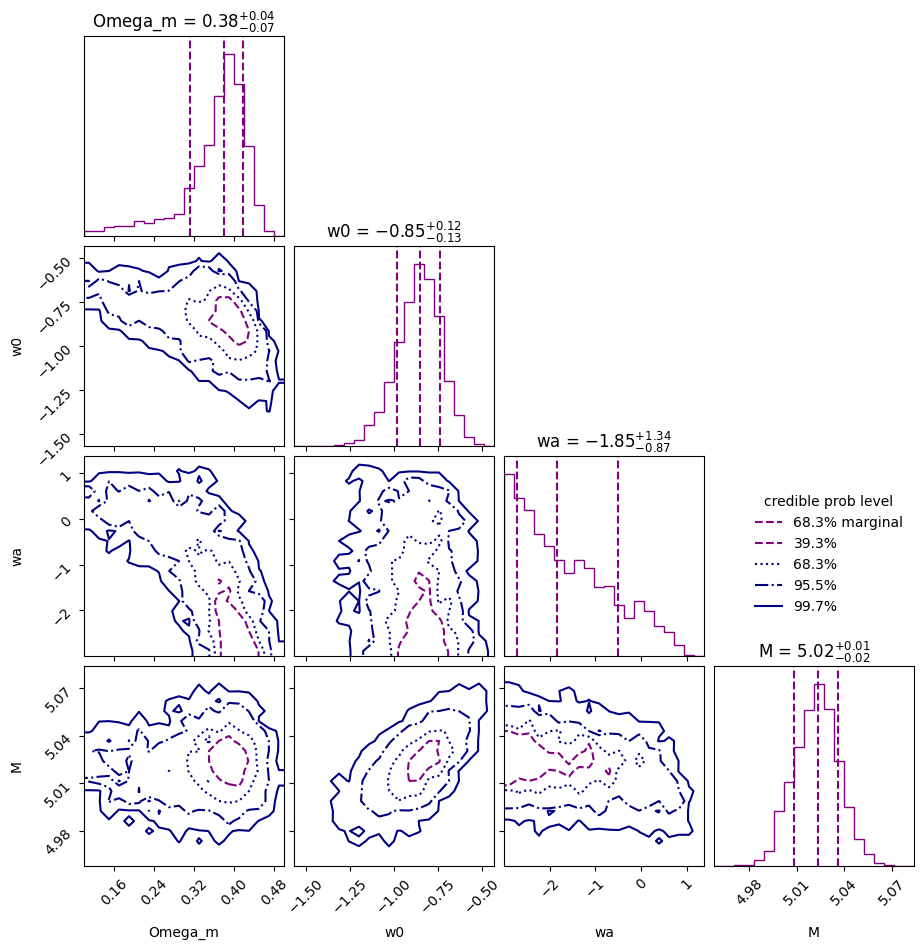

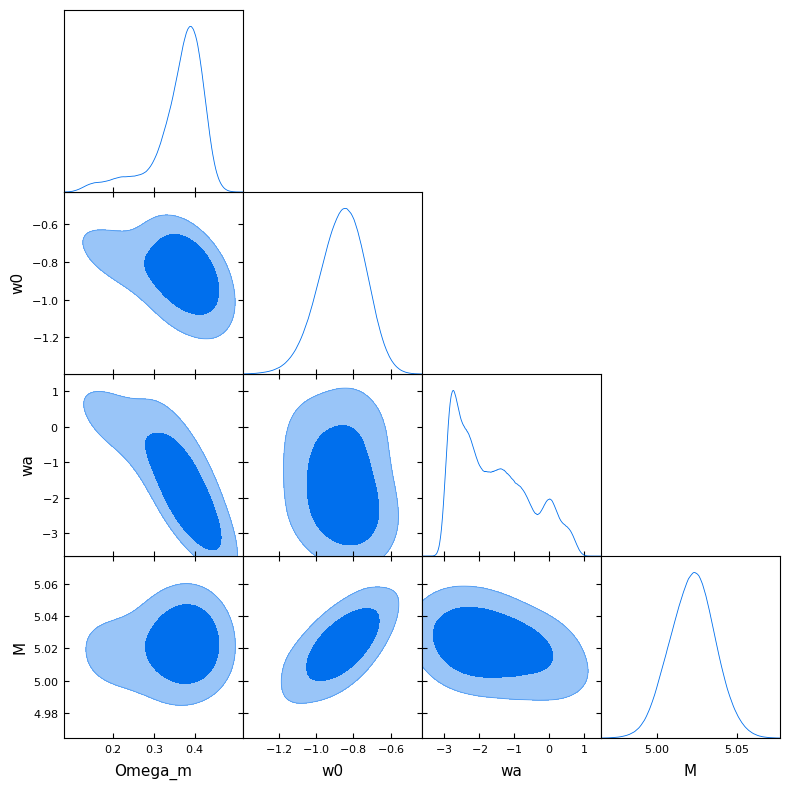

In [ ]:
with open(f'{fit_dir}/Flat_w0waCDM_{prior}{"_marg" if marginalize_M else ""}_result.pkl', 'rb') as f:
    Flat_w0waCDM_result = pickle.load(f)
cornerplot(Flat_w0waCDM_result);
smooth_plot(Flat_w0waCDM_result)


## Crossmatch

### Match LSC Bricks

In [48]:
import numpy as np
from astropy import table as ast

# match bricks
bricks = ast.Table.read('./data/survey-bricks.fits', 
                   format='fits',
                   hdu=1)

def find_bricks_for_coordinates(ra_list, dec_list, bricks_table):
    """
    Find brick names and IDs for given RA and DEC coordinates.
    """
    brick_names = []
    brick_ids = []

    def match_bricks(ra, dec, bricks_table):
        ra1 = bricks_table['RA1']
        ra2 = bricks_table['RA2']
        dec1 = bricks_table['DEC1']
        dec2 = bricks_table['DEC2']
        
        cross_zero = ra1 > ra2
        
        mask_cross = cross_zero & ((ra >= ra1) | (ra <= ra2)) & (dec >= dec1) & (dec <= dec2)
        mask_normal = (~cross_zero) & (ra >= ra1) & (ra <= ra2) & (dec >= dec1) & (dec <= dec2)
        mask = mask_cross | mask_normal
        
        if np.any(mask):
            matching_bricks = bricks_table[mask]
            return matching_bricks
        else:
            return None
    
    for ra, dec in zip(ra_list, dec_list):
        brick = match_bricks(ra, dec, bricks_table)
        if brick is not None and len(brick) > 0:
            brick_names.append(brick[0]['BRICKNAME'])
            brick_ids.append(brick[0]['BRICKID'])
        else:
            brick_names.append(None)
            brick_ids.append(None)
    
    return brick_names, brick_ids

ra_list = SN_sample['RA']
dec_list = SN_sample['DEC']

SN_sample['BRICKNAME'], SN_sample['BRICKID'] = find_bricks_for_coordinates(ra_list, dec_list, bricks)

# match sky
sky_region = np.where(SN_sample['DEC'] > 32.375, 'north', 'south')
SN_sample['SKY'] = sky_region


### Find the Nearest Galaxy for a SN
Find the nearest galaxy for a SN. The host galaxy requires further filtering. The search radius is a large 20.0 arcsec.

In [49]:
# find the nearest galaxy for a SNe
import requests
import os
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")


def download_brick(SN_id, save_path, overwrite=False, dr=10):
    """
    Download tractor brick file for given SN id.

    Parameters:
        SN_id: Index of the supernova in SN_sample table (corresponds to row number as well as 'ID' column)
        save_path: Path to save the downloaded brick file
        overwrite: Whether to overwrite existing file
        dr: Data release number (9 or 10)

    Returns:
        True if download successful or file already exists, False otherwise
    """
    if os.path.exists(save_path) & (not overwrite):
        print(f"→ {os.path.basename(save_path)} already exists")
        return True

    url = f"https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr{dr}/{SN_sample['SKY'][SN_id]}/tractor/{SN_sample['BRICKNAME'][SN_id][:3]}/tractor-{SN_sample['BRICKNAME'][SN_id]}.fits"
    try:
        resp = requests.get(url, stream=True, timeout=30)
        resp.raise_for_status()

        with open(save_path, "wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"✓ {os.path.basename(save_path)} found for dr {dr} SN id {SN_id}")
        resp.close()
        return True

    except Exception as e:
        if "resp" in locals():
            resp.close()
        print(f"✗ {os.path.basename(save_path)} - {e}")
        return False


def find_nearest_object_in_brick(
    sn_ra,
    sn_dec,
    tractor_file_path,
    search_radius_arcsec=5.0,
    clear_cache=False,
    include_types=["REX", "SER", "DEV", "EXP"],
):
    """
    Find the nearest object in the tractor brick file within a given search radius.

    Parameters:
        sn_ra: Right Ascension of the supernova (degrees)
        sn_dec: Declination of the supernova (degrees)
        tractor_file_path: Path to the tractor brick FITS file
        search_radius_arcsec: Search radius in arcseconds
        clear_cache: Whether to delete the tractor file after processing
        include_types: List of object types to include (e.g., ["REX", "SER", "DEV", "EXP"])

    Returns:
        Astropy Table with the nearest object's data and distance, or None if not found
    """
    try:
        with fits.open(tractor_file_path, memmap=False) as hdul:
            data = hdul[1].data
    except Exception as e:
        print(f"Fail to open the tractor file: {e}")
        return None

    if clear_cache:
        os.remove(tractor_file_path)

    brick_ra = data["ra"]
    brick_dec = data["dec"]

    sn_coord = SkyCoord(ra=sn_ra * u.degree, dec=sn_dec * u.degree, frame="icrs")
    brick_coords = SkyCoord(
        ra=brick_ra * u.degree, dec=brick_dec * u.degree, frame="icrs"
    )

    # Compute angular separations
    separations = sn_coord.separation(brick_coords)

    # Search within the specified radius
    within_radius = separations.arcsecond <= search_radius_arcsec
    indices_within = np.where(within_radius)[0]

    if len(indices_within) == 0:
        # print(f"Found nothing withn {search_radius_arcsec} arcsec")
        return None

    # Sort indices by separation
    sorted_indices = indices_within[np.argsort(separations[indices_within].arcsecond)]

    # Find the nearest object of the desired types
    selected_idx = None
    selected_separation = None
    excluded_count = 0

    for idx in sorted_indices:
        current_separation = separations[idx].arcsecond
        obj_type = data[idx]["type"]

        # If it's a string type, strip whitespace
        if isinstance(obj_type, str):
            obj_type = obj_type.strip()

        # Check if the object type is in the included types
        if not (obj_type in include_types):
            excluded_count += 1
            continue

        selected_idx = idx
        selected_separation = current_separation
        break

    if selected_idx is None:
        print(f"No suitable object found within {search_radius_arcsec} arcsec")
        return None

    # Extract selected object's data
    obj_data = data[selected_idx]

    # Create result table
    result = ast.Table()
    for name in obj_data.array.names:
        result[name] = [obj_data.field(name)]
    result["dist"] = selected_separation
    result["excluded_count"] = excluded_count
    if not excluded_count == 0:
        print(f"Exclude {excluded_count} nearer objects")

    return result


def find_nearest_galaxy(
    SN_id,
    tractor_dir="tractor_data",
    host_galaxy_save_dir="host_galaxy",
    drs=[10, 9],
    overwrite=False,
    clear_cache=False,
    search_radius_arcsec=15.0,
):
    """
    Find and save the host galaxy for a given supernova.

    Parameters:
        SN_id: Index of the supernova in SN_sample table (corresponds to row number as well as 'ID' column)
        tractor_dir: Directory to save tractor brick files
        host_galaxy_save_dir: Directory to save host galaxy files
        drs: List of data release numbers to try (e.g., [10, 9])
        overwrite: Whether to overwrite existing host galaxy files
        clear_cache: Whether to delete tractor files after processing
        search_radius_arcsec: Search radius in arcseconds

    Returns:
        Astropy Table with the host galaxy data, or None if not found
    """
    if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
        return ast.Table.read(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits")
    nearest_obj = None
    for dr in drs:
        os.makedirs(f"{tractor_dir}/dr{dr}", exist_ok=True)  # exist_ok=True
        tractor_file_path = (
            f"{tractor_dir}/dr{dr}/tractor-{SN_sample['BRICKNAME'][SN_id]}.fits"
        )
        if not download_brick(
            SN_id=SN_id, save_path=tractor_file_path, overwrite=overwrite, dr=dr
        ):
            print("download failed")
            continue

        current_nearest_obj = find_nearest_object_in_brick(
            sn_ra=SN_sample["RA"][SN_id],
            sn_dec=SN_sample["DEC"][SN_id],
            tractor_file_path=tractor_file_path,
            search_radius_arcsec=search_radius_arcsec,
            clear_cache=clear_cache,
            include_types=["REX", "SER", "DEV", "EXP"],
        )

        if current_nearest_obj is None:
            continue

        if not (current_nearest_obj["type"][0] in ["REX", "SER", "DEV", "EXP"]):
            print(f"nearest not galaxy but {current_nearest_obj['type'][0]}")
            continue

        if (nearest_obj is None) or (
            nearest_obj["dist"][0] > current_nearest_obj["dist"][0]
        ):
            nearest_obj = current_nearest_obj
            nearest_obj["dr"] = [dr]

    if not (nearest_obj is None):
        nearest_obj["ID"] = [SN_id]
        nearest_obj = nearest_obj[
            ["ID"] + [col for col in nearest_obj.colnames if col != "ID"]
        ]
        nearest_obj.write(
            f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits", overwrite=True
        )

    return nearest_obj


def count_success(host_galaxy_save_dir="host_galaxy"):
    """
    Count how many host galaxy files have been successfully saved.
    """
    success_cnt = 0
    for SN_id in range(num_samples):
        if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
            success_cnt += 1
    print(f"success: {success_cnt}/{num_samples}")


def read_host_galaxy(SN_id, host_galaxy_save_dir="host_galaxy"):
    """
    Read the host galaxy data for a given supernova.

    Parameters:
        SN_id: Index of the supernova in SN_sample table (corresponds to 'ID' column)
        host_galaxy_save_dir: Directory where host galaxy files are saved

    Returns:
        Astropy Table with the host galaxy data, or None if not found
    """
    if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
        return ast.Table.read(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits")
    else:
        return None

In [50]:
# Set save directory and search radius
host_galaxy_save_dir = "host_galaxy"
os.makedirs(host_galaxy_save_dir, exist_ok=True)
search_radius_arcsec = 20.0 # 

In [ ]:
# Find the nearest galaxy for each SN in parallel (Needless to run this cell again)
from concurrent.futures import ThreadPoolExecutor

os.makedirs(host_galaxy_save_dir, exist_ok=True)
with ThreadPoolExecutor(max_workers=6) as executor:
    results = list(
        executor.map(
            lambda SN_id: find_nearest_galaxy(
                SN_id=SN_id,
                tractor_dir="tractor_data",
                host_galaxy_save_dir=host_galaxy_save_dir,
                overwrite=True,
                clear_cache=True,  # False to save files
                search_radius_arcsec=search_radius_arcsec,
            ),
            range(num_samples),
        )
    )

count_success(host_galaxy_save_dir=host_galaxy_save_dir)

In [ ]:
# Unparallel version. Do it again to ensure all are processed. (Needless to run this cell again)
os.makedirs(host_galaxy_save_dir, exist_ok=True)
for SN_id in tqdm(range(num_samples)):
    host_galaxy = find_nearest_galaxy(
        SN_id,
        tractor_dir="tractor_data",
        host_galaxy_save_dir=host_galaxy_save_dir,
        overwrite=True,
        clear_cache=True,
    )

count_success(host_galaxy_save_dir=host_galaxy_save_dir)

In [ ]:
# TODO: SIMBAD cross-match to verify host galaxies failure cases
SN_sample[0]

### Find Host Galaxy for a SN
We set a maximum distance 1.0 arcsec between the SN and its host galaxy.

In [52]:
# Filter valid host galaxies
max_dist_arcsec = 1.0
valid_SN_ids = []
valid_host_galaxies = []
for SN_id in tqdm(range(num_samples)):
    host_galaxy = read_host_galaxy(SN_id, host_galaxy_save_dir=host_galaxy_save_dir)
    if host_galaxy is None:
        continue
    # Filter by distance and type
    if (host_galaxy['dist'][0] <= max_dist_arcsec) and (host_galaxy['type'][0] in ['REX', 'SER', 'DEV', 'EXP']):
        valid_SN_ids.append(SN_id)
        valid_host_galaxies.append(host_galaxy)

# Numbers of valid host galaxies
print(f'{len(valid_SN_ids)}/{num_samples} SNe have valid host galaxies within {max_dist_arcsec} arcsec')

  0%|          | 0/1820 [00:00<?, ?it/s]

1196/1820 SNe have valid host galaxies within 1.0 arcsec


In [ ]:
# Check one
valid_host_galaxies[0] # ID column corresponds to ID in SN_sample, dist is the angular distance between the SN and galaxy in arcsec, type is the galaxy type

In [ ]:
# You can continue with further analysis using valid_host_galaxies